# ISIMIP3b: analysis of projected climate changes on glacier level

In [117]:
# path to isimip3b files that are available under https://cluster.klima.uni-bremen.de/~lschuster/isimip3b/: this might need to be changed if used on another computer
path = 'isimip3b/'


In [118]:
import xarray as xr
import numpy as np
from oggm import utils
import matplotlib.pyplot as plt
import pandas as pd
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
#import xesmf as xe
import warnings
import progressbar
from scipy import stats
import seaborn as sns
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

## some preprocessing to get the glacier gridpoints and their area

In [119]:
ds_inv = xr.open_dataset('orog_W5E5v1.0.nc')
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

# get the dataset where coordinates of glaciers are stored
frgi = 'rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)

nx, ny = ds_inv.dims['lon'], ds_inv.dims['lat']
# Nearest neighbor lookup
cenlon_for_bins = np.where(odf['CenLon'] < -0.125, odf['CenLon']+360, odf['CenLon']) # just make them into 0-> 360 scheme
lon_bins = np.linspace(0, 360, nx) # np.linspace(-0.125, 359.75+0.125, nx)
lat_bins = np.linspace(90, -90, ny)  #  np.linspace(90+0.125, -90-0.125, ny)
odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1

# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of W5E5 gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

# this is the mask that we need to remove all non-glacierized gridpoints
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area'] # 1
ds_inv['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))

ds_inv['glacier_area'] = (('lat', 'lon'), mask)
ds_inv['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

reg = np.full((ny, nx), np.NaN)
reg[mdf['lat_id'], mdf['lon_id']] = mdf['O1Region'].astype(int)
ds_inv['rgi_region'] = (('lat', 'lon'), reg)


# Weight
weight = np.cos(np.deg2rad(ds_inv.lat.astype(np.float64))).clip(0)
weight =  ds_inv.orog * 0. + weight

ds_inv['weight'] = (('lat', 'lon'), weight / weight.sum())

Total number of glaciers: 216502 and number of W5E5 gridpoints with glaciers in them: 4713


In [120]:
print('total glacier area: {} km2'.format(np.nansum(mask)) )

total glacier area: 746092.8810000002 km2


In [121]:
# this should be one
print(ds_inv['weight_glacier'].sum())

<xarray.DataArray 'weight_glacier' ()>
array(1.)


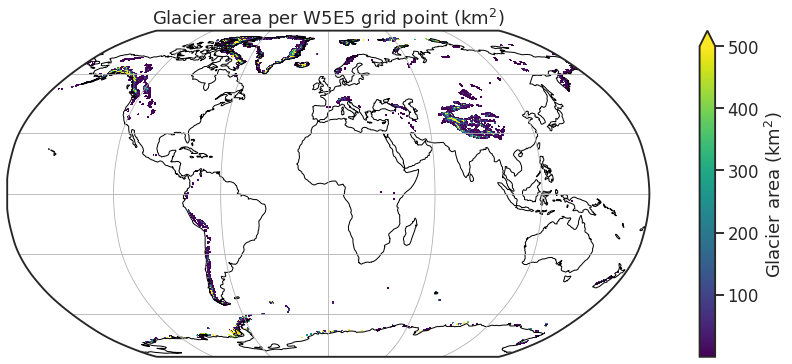

In [122]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ds_inv['glacier_area'].plot(ax=ax, transform=ccrs.PlateCarree(), vmax=500, 
                            cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per W5E5 grid point (km$^{2}$)');

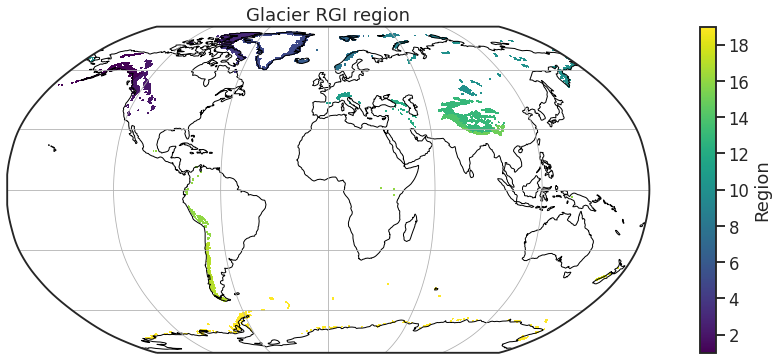

In [123]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ds_inv['rgi_region'].plot(ax=ax, transform=ccrs.PlateCarree(), 
                            cbar_kwargs={'label':'Region'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier RGI region');

## Global climate time series of only glacier regions (weighted by glacier area)

**first get the annual global mean time series for each scenario and ensemble**

In [ ]:
ds_inv.coords['lon'] = np.where(ds_inv.lon.values > 180, ds_inv.lon.values - 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_neg_pos'

dict_global_pr_mean_g= {}
dict_global_tas_mean_g= {}
dict_global_tas_daily_std_g = {}

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']

for gcm in gcms:
    if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
        ensemble = 'r1i1p1f1'
    elif gcm == 'ukesm1-0-ll':
        ensemble = 'r1i1p1f2'
    for scenario in scenarios:
        print(gcm, ensemble, scenario)

        if scenario == 'historical':
            ybegin = 1850
            yend = 2014
        else:
            ybegin = 2015
            yend = 2100    

        typ = 'prAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_pr = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        typ = 'tasAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_tas = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
        path_output_tas_std = 'isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)


        ds_pr_monthly = xr.open_dataset(path_output_pr)
        ds_tas_monthly = xr.open_dataset(path_output_tas)
        ds_tas_daily_std = xr.open_dataset(path_output_tas_std)
        ds_tas_daily_var = np.square(ds_tas_daily_std.tasAdjust_std)


        # get the global means for every month:
        global_pr_mean_g = (ds_pr_monthly.prAdjust * ds_inv.weight_glacier).sum(dim=['lon','lat']).resample(time='1Y').mean() *60*60*24  # from kg /m2 /s to  mm/day
        global_tas_mean_g = (ds_tas_monthly.tasAdjust* ds_inv.weight_glacier).sum(dim=['lon','lat']).resample(time='1Y').mean() - 273.15  # from K to °C
        # !!! can not simply sum up standard deviations!!# 
        #! I am not totall ysure about the daily standard deviation stuff ... 
        # I think we can NOT assume independence inbetween the standard deviations of different grid points ... 
        # it would be better to take the real daily values and get than global daily values by the weighting and then compute the standard deviations from the global daily Temp. values to check that !!!
        #global_tas_daily_std_g = np.sqrt(np.square(ds_tas_daily_std.tasAdjust_std* ds_inv.weight_glacier).sum(dim=['lon','lat'])).resample(time='1Y').mean() #- 273.15  # from K to °C
        global_tas_daily_std_g = np.sqrt(((ds_tas_daily_var* ds_inv.weight_glacier).sum(dim=['lon','lat'])).resample(time='1Y').mean()) #- 273.15  # from K to °C

        print('global glacier precipitation mean: {} mm/day \nglobal glacier temperature mean: {} °C'.format(global_pr_mean_g.mean().values.round(2), global_tas_mean_g.mean().values.round(2)))

        dict_global_pr_mean_g['{}_{}'.format(gcm, scenario)] = global_pr_mean_g
        dict_global_tas_mean_g['{}_{}'.format(gcm, scenario)] = global_tas_mean_g
        dict_global_tas_daily_std_g['{}_{}'.format(gcm, scenario)] = global_tas_daily_std_g





gfdl-esm4 r1i1p1f1 historical
global glacier precipitation mean: 1.98 mm/day 
global glacier temperature mean: -9.52 °C
gfdl-esm4 r1i1p1f1 ssp126
global glacier precipitation mean: 2.1 mm/day 
global glacier temperature mean: -7.81 °C
gfdl-esm4 r1i1p1f1 ssp370
global glacier precipitation mean: 2.16 mm/day 
global glacier temperature mean: -6.6 °C
gfdl-esm4 r1i1p1f1 ssp585
global glacier precipitation mean: 2.18 mm/day 
global glacier temperature mean: -6.32 °C
ipsl-cm6a-lr r1i1p1f1 historical
global glacier precipitation mean: 1.92 mm/day 
global glacier temperature mean: -10.41 °C
ipsl-cm6a-lr r1i1p1f1 ssp126
global glacier precipitation mean: 2.13 mm/day 
global glacier temperature mean: -7.0 °C
ipsl-cm6a-lr r1i1p1f1 ssp370
global glacier precipitation mean: 2.25 mm/day 
global glacier temperature mean: -5.42 °C
ipsl-cm6a-lr r1i1p1f1 ssp585
global glacier precipitation mean: 2.33 mm/day 
global glacier temperature mean: -4.56 °C
mpi-esm1-2-hr r1i1p1f1 historical
global glacier preci

In [ ]:
plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,28))

lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        # ax1 = plt.subplot(2,1,1)
        ax1.plot(yr, dict_global_pr_mean_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax1.set_ylabel(r'global glacier mean precipitation (mm day$^{-1}$)')
        ax1.set_xlabel('year')
        if ls == '-':
            legend1 = ax1.legend(loc=2, title = 'scenario')
        # ax2.subplot(2,1,2)
        ax2.plot(yr, dict_global_tas_mean_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls = ls, lw=3)
        ax2.set_ylabel('global glacier mean temperature (°C)')
        ax2.set_xlabel('year')
        if ls == '-':
            legend12 = ax2.legend(loc=2, title = 'scenario')
        ###
        ax3.plot(yr, dict_global_tas_daily_std_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls = ls, lw=3)
        ax3.set_ylabel('global glacier mean daily temperature std (°C)')
        ax3.set_xlabel('year')
        if ls == '-':
            legend13 = ax3.legend(loc=3, title = 'scenario')
        
lines = ax1.get_lines()
legend2 = ax1.legend(lines[::4], gcms , loc=2, bbox_to_anchor=(0.2,1), title='GCM')
ax1.add_artist(legend1)

lines = ax2.get_lines()
legend22 = ax2.legend(lines[::4], gcms , loc=2, bbox_to_anchor=(0.2,1), title='GCM')
ax2.add_artist(legend12)

lines = ax3.get_lines()
legend23 = ax3.legend(lines[::4], gcms , loc=3, bbox_to_anchor=(0.2,0), title='GCM')
ax3.add_artist(legend13)
plt.tight_layout()
ax1.grid()
ax2.grid()
ax3.grid()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_mean_time_series.pdf');

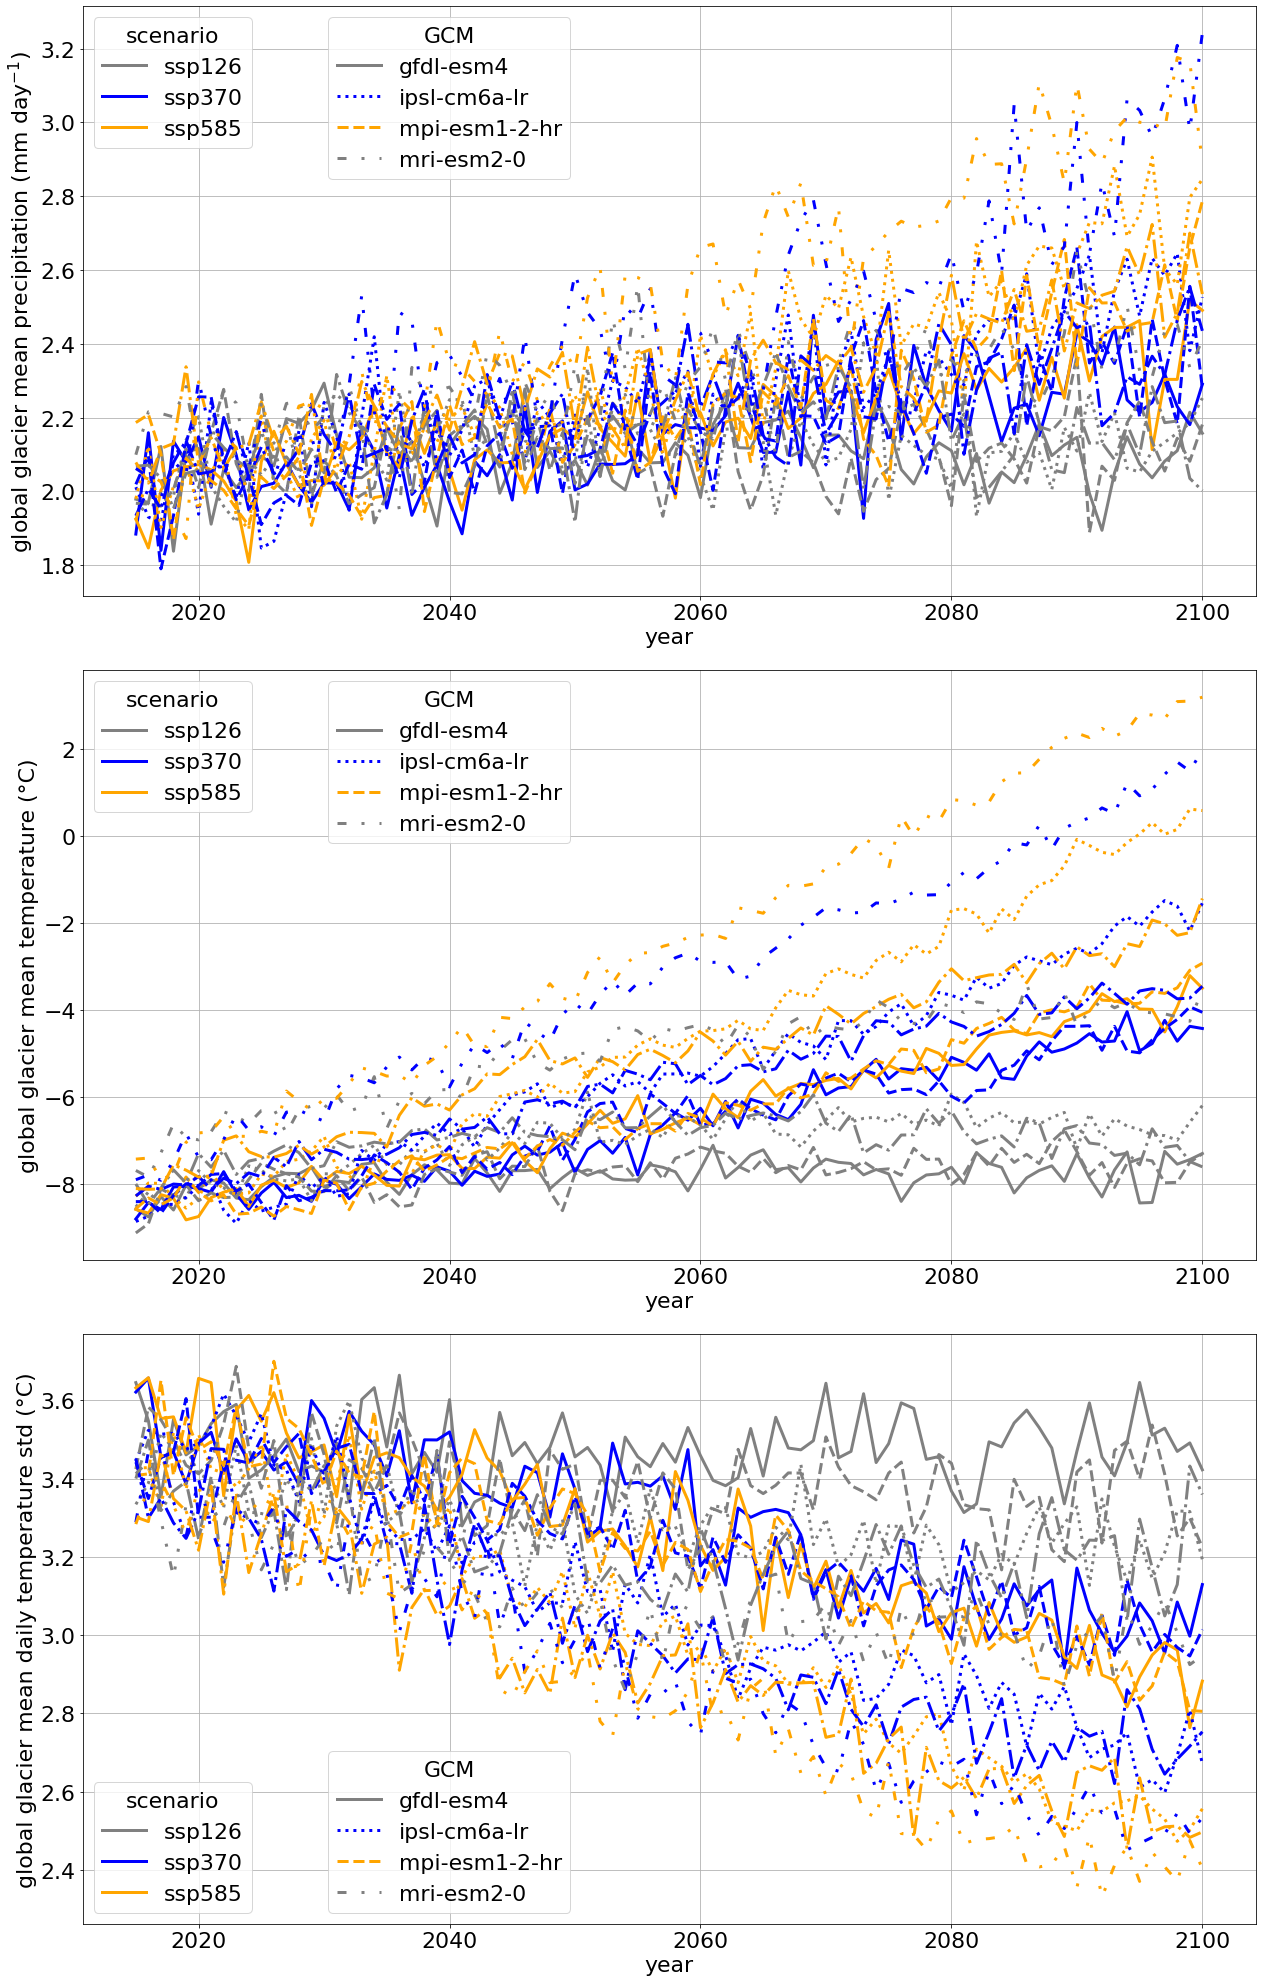

In [45]:
plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,28))

lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        # ax1 = plt.subplot(2,1,1)
        ax1.plot(yr, dict_global_pr_mean_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax1.set_ylabel(r'global glacier mean precipitation (mm day$^{-1}$)')
        ax1.set_xlabel('year')
        if ls == '-':
            legend1 = ax1.legend(loc=2, title = 'scenario')
        # ax2.subplot(2,1,2)
        ax2.plot(yr, dict_global_tas_mean_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls = ls, lw=3)
        ax2.set_ylabel('global glacier mean temperature (°C)')
        ax2.set_xlabel('year')
        if ls == '-':
            legend12 = ax2.legend(loc=2, title = 'scenario')
        ###
        ax3.plot(yr, dict_global_tas_daily_std_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls = ls, lw=3)
        ax3.set_ylabel('global glacier mean daily temperature std (°C)')
        ax3.set_xlabel('year')
        if ls == '-':
            legend13 = ax3.legend(loc=3, title = 'scenario')
        
lines = ax1.get_lines()
legend2 = ax1.legend(lines[::4], gcms , loc=2, bbox_to_anchor=(0.2,1), title='GCM')
ax1.add_artist(legend1)

lines = ax2.get_lines()
legend22 = ax2.legend(lines[::4], gcms , loc=2, bbox_to_anchor=(0.2,1), title='GCM')
ax2.add_artist(legend12)

lines = ax3.get_lines()
legend23 = ax3.legend(lines[::4], gcms , loc=3, bbox_to_anchor=(0.2,0), title='GCM')
ax3.add_artist(legend13)
plt.tight_layout()
ax1.grid()
ax2.grid()
ax3.grid()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_mean_time_series.pdf');

# ISIMIP3b average Temperature change at glacier locations for each region separately

In [33]:
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
typs = ['tasAdjust']
scenarios = ['ssp126', 'ssp370', 'ssp585']
tdf_d = {}
taf_d = {}
for scenario in scenarios:
    tdf = pd.DataFrame(dtype=float)
    taf = pd.DataFrame(dtype=float)

    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'

            # for the ssp:
        ybegin = 2015
        yend = 2100
        for typ in typs:
            folder_output = 'isimip3b_{}_monthly'.format(typ)

            path = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
            path_h = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, 'historical', typ, 1850, 2014)

            ds_gcm_t2m_hist = xr.open_dataset(path_h).tasAdjust-273.15
            ds_gcm_t2m = xr.open_dataset(path).tasAdjust-273.15
            ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                         ds_gcm_t2m.lon.values + 360,
                                         ds_gcm_t2m.lon.values)
            ds_gcm_t2m['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                         ds_gcm_t2m.lon.values + 360,
                                         ds_gcm_t2m.lon.values)

            # could also look at the seasonal cycle, but here I look at the annual means ...
            mean = (ds_gcm_t2m.groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])
            mean_hist = (ds_gcm_t2m_hist.groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])


            
            # amount of warming for each grid point 
            t2m_dT = ds_gcm_t2m.sel(time=slice('2086','2100')).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice('2000', '2014')).mean(dim='time')
            # ... divided by GMT warming 
            t2m_dT_per_dT = t2m_dT / (mean.sel(year=slice(2086, 2100)).mean()-mean_hist.sel(year=slice(2000,2014)).mean())

            # Check (should be one)
            tdf.loc['GMT', gcm] = float((t2m_dT_per_dT * ds_inv.weight).sum(dim=['lon','lat']))

            # these should be the same ... 
            taf.loc['GMT', gcm] = float((t2m_dT * ds_inv.weight).sum(dim=['lon','lat']))
            taf.loc['GMT_mean_diff', gcm] = (mean.sel(year=slice(2086, 2100)).mean()-mean_hist.sel(year=slice(2000,2014)).mean())
            tdf.loc['GMT_mean_diff', gcm] = (mean.sel(year=slice(2086, 2100)).mean()-mean_hist.sel(year=slice(2000,2014)).mean())

            # All glaciers (weighted by area)
            # in weight_glacier: the area of each glacier is already inside
            tdf.loc['All', gcm] = float((t2m_dT_per_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))
            taf.loc['All', gcm] = float((t2m_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))

            for rgi_reg in range(1, 20):
                weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
                weight_reg = weight_reg / weight_reg.sum()

                tdf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_per_dT * weight_reg).sum(dim=['lon','lat']))
                taf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT * weight_reg).sum(dim=['lon','lat']))

            tdf_d[scenario] = tdf
            taf_d[scenario] = taf

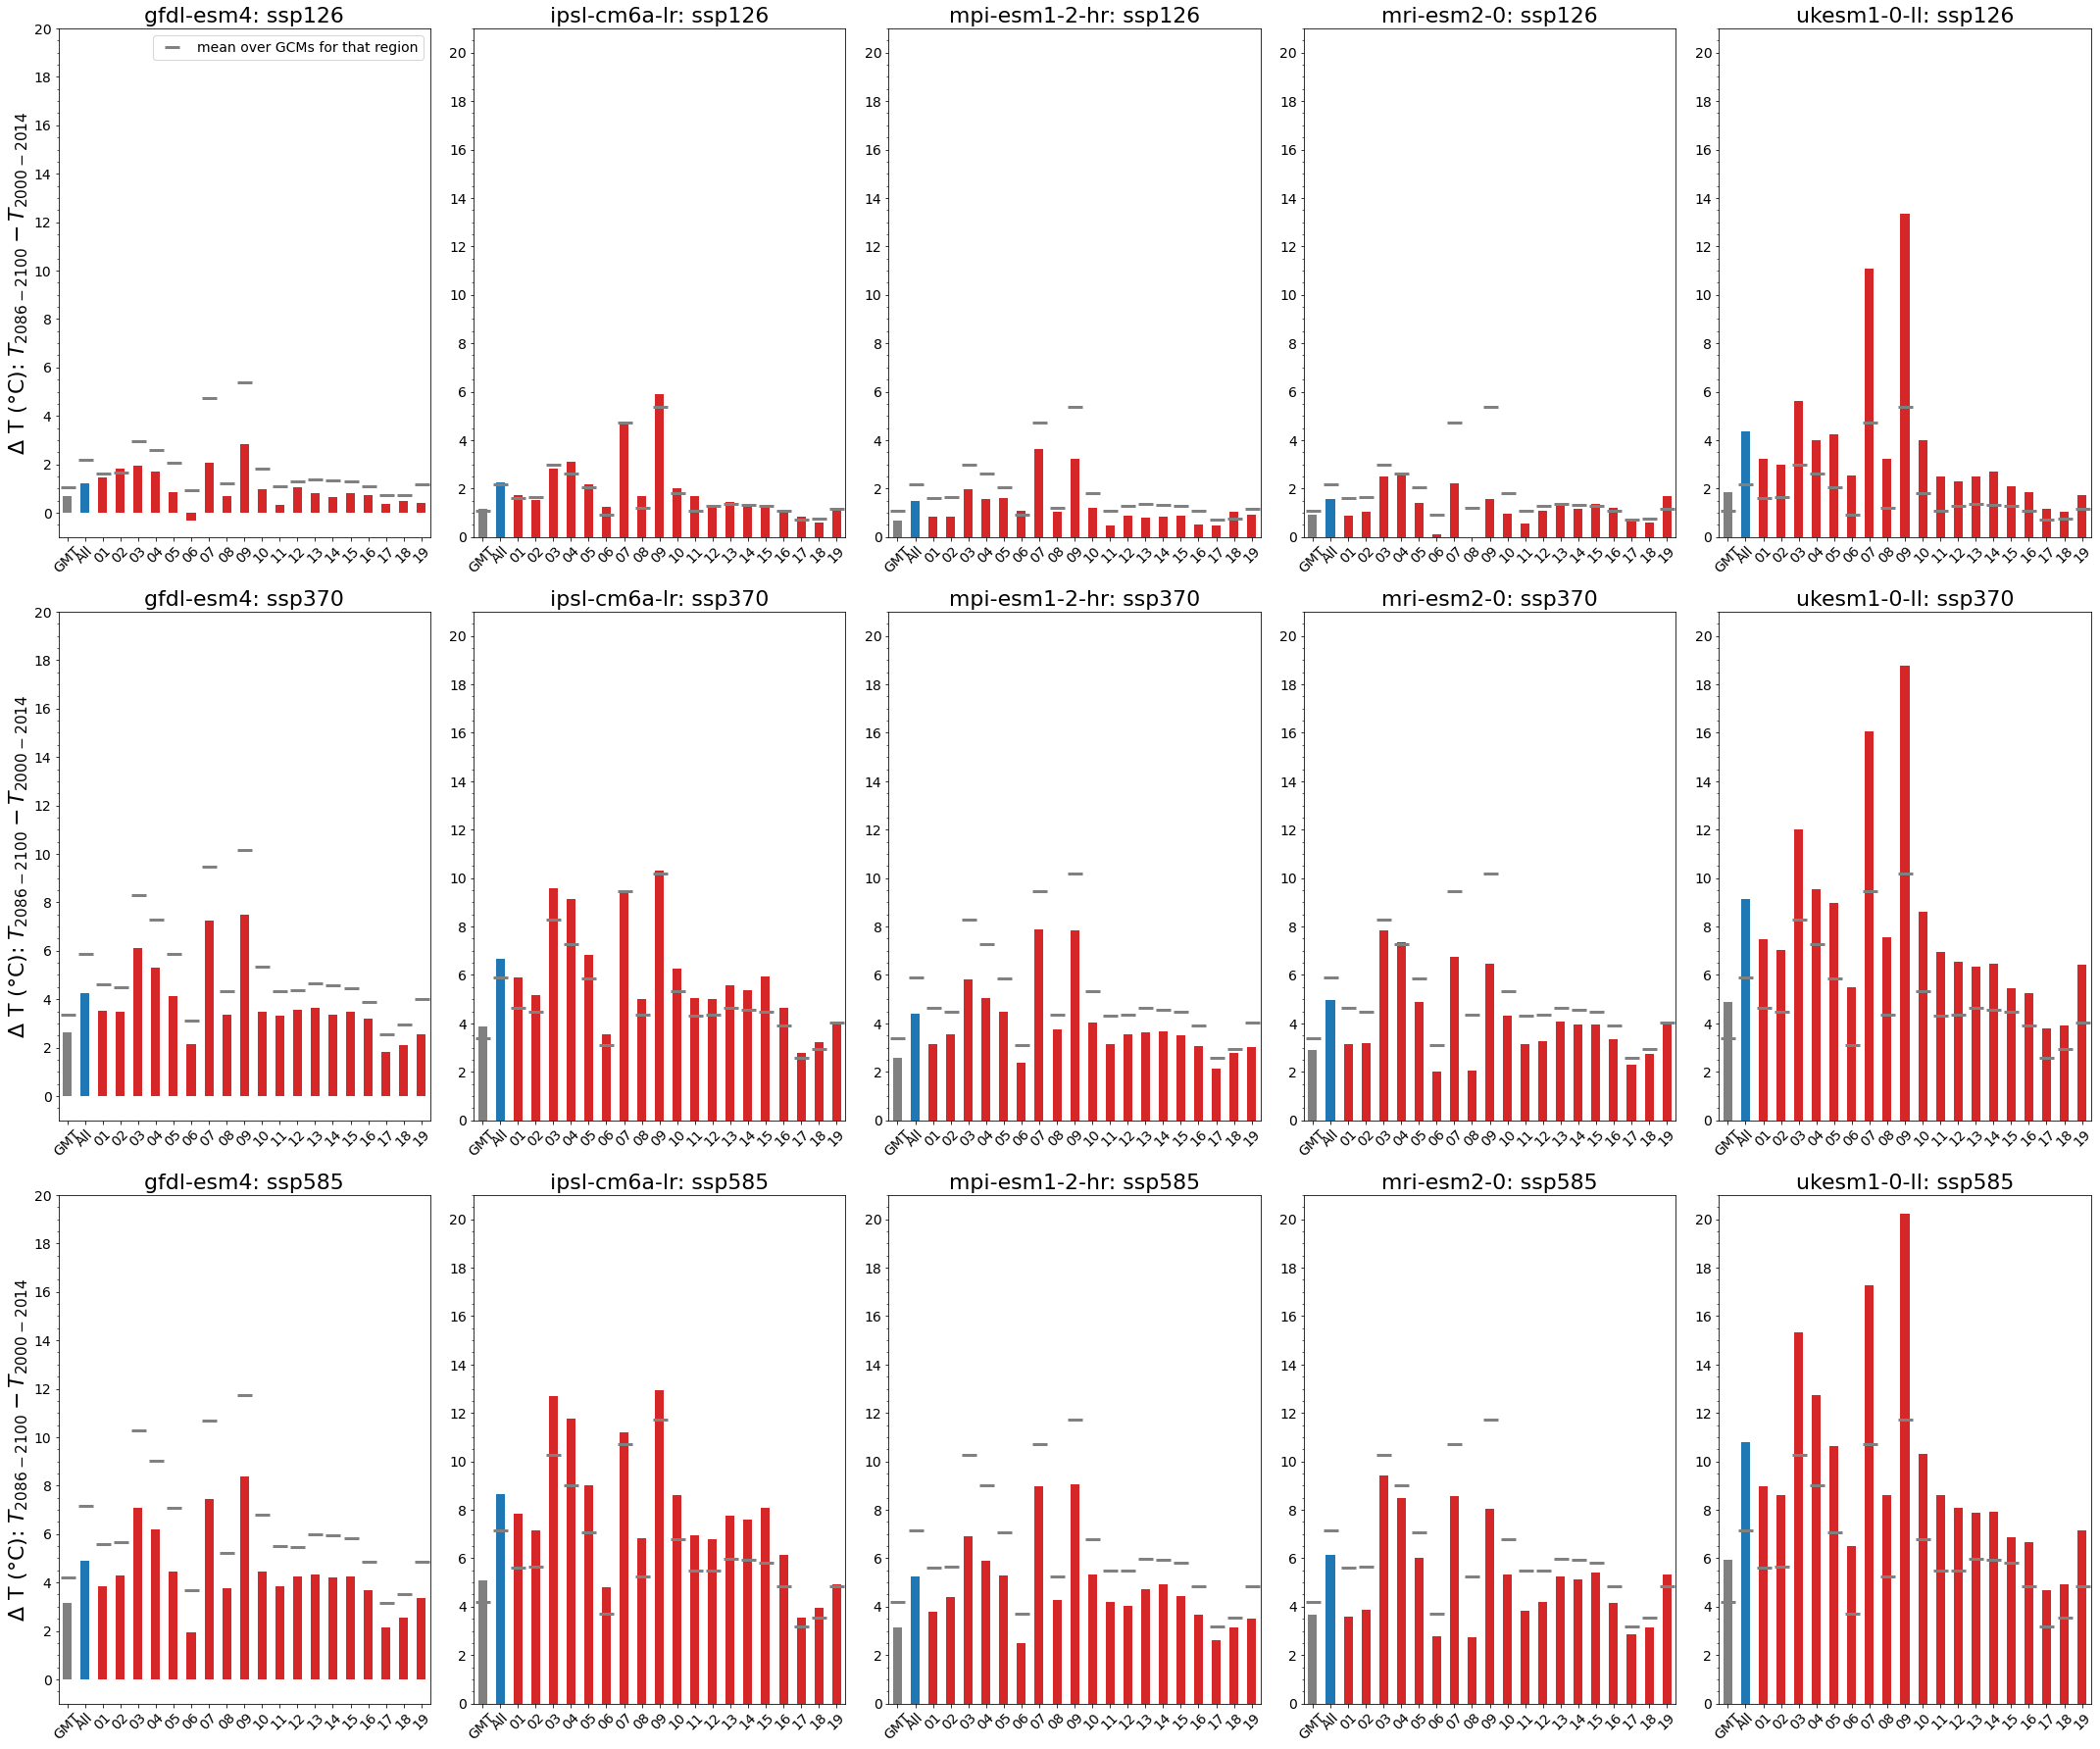

In [43]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(30, 25))

j=0
for scenario in scenarios:
    for gcm in gcms:

        #tdf_d[scenario].loc['frac_mean_GMT'] = tdf_d[scenario].loc['GMT_mean_diff']/tdf_d[scenario].loc['GMT_mean_diff'].mean()
        plt.subplot(3,5,j+1)
        ax = plt.gca()
        #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
        plt.plot(taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
                 taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
                label='mean over GCMs for that region')
        if gcm==gcms[0]:
            plt.ylabel('$\Delta$ T (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=22)
        if scenario == scenarios[0]:
            plt.ylim(-1, 15)
        else:
            plt.ylim(0,21)
        plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
        plt.minorticks_on() # (np.arange(0,19))
        plt.yticks(np.arange(0,22,2))
        ax.tick_params(axis='x',which='minor',bottom=False)
        if j==0:
            plt.legend(fontsize=22)
        taf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);

        j+=1
#plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
plt.tight_layout()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT.pdf')

we can recognize that:
- for all scenarios and gcms, glaciers will experience more warming
- however, the warming is very different for each region 
    - strongest warming in RGI 3,4, 7, 9
    - smallest warming in RGI 5, 17, 18
        - even some cooling in case of RGI 5 and RGI 7 for SSP126 for some ensembles
- ukesm has the largest temperature variations in between the regions

**same but as mean over GCMs with std of GCMs**

(mean corresponds to the grey lines that were visible in the plot above)

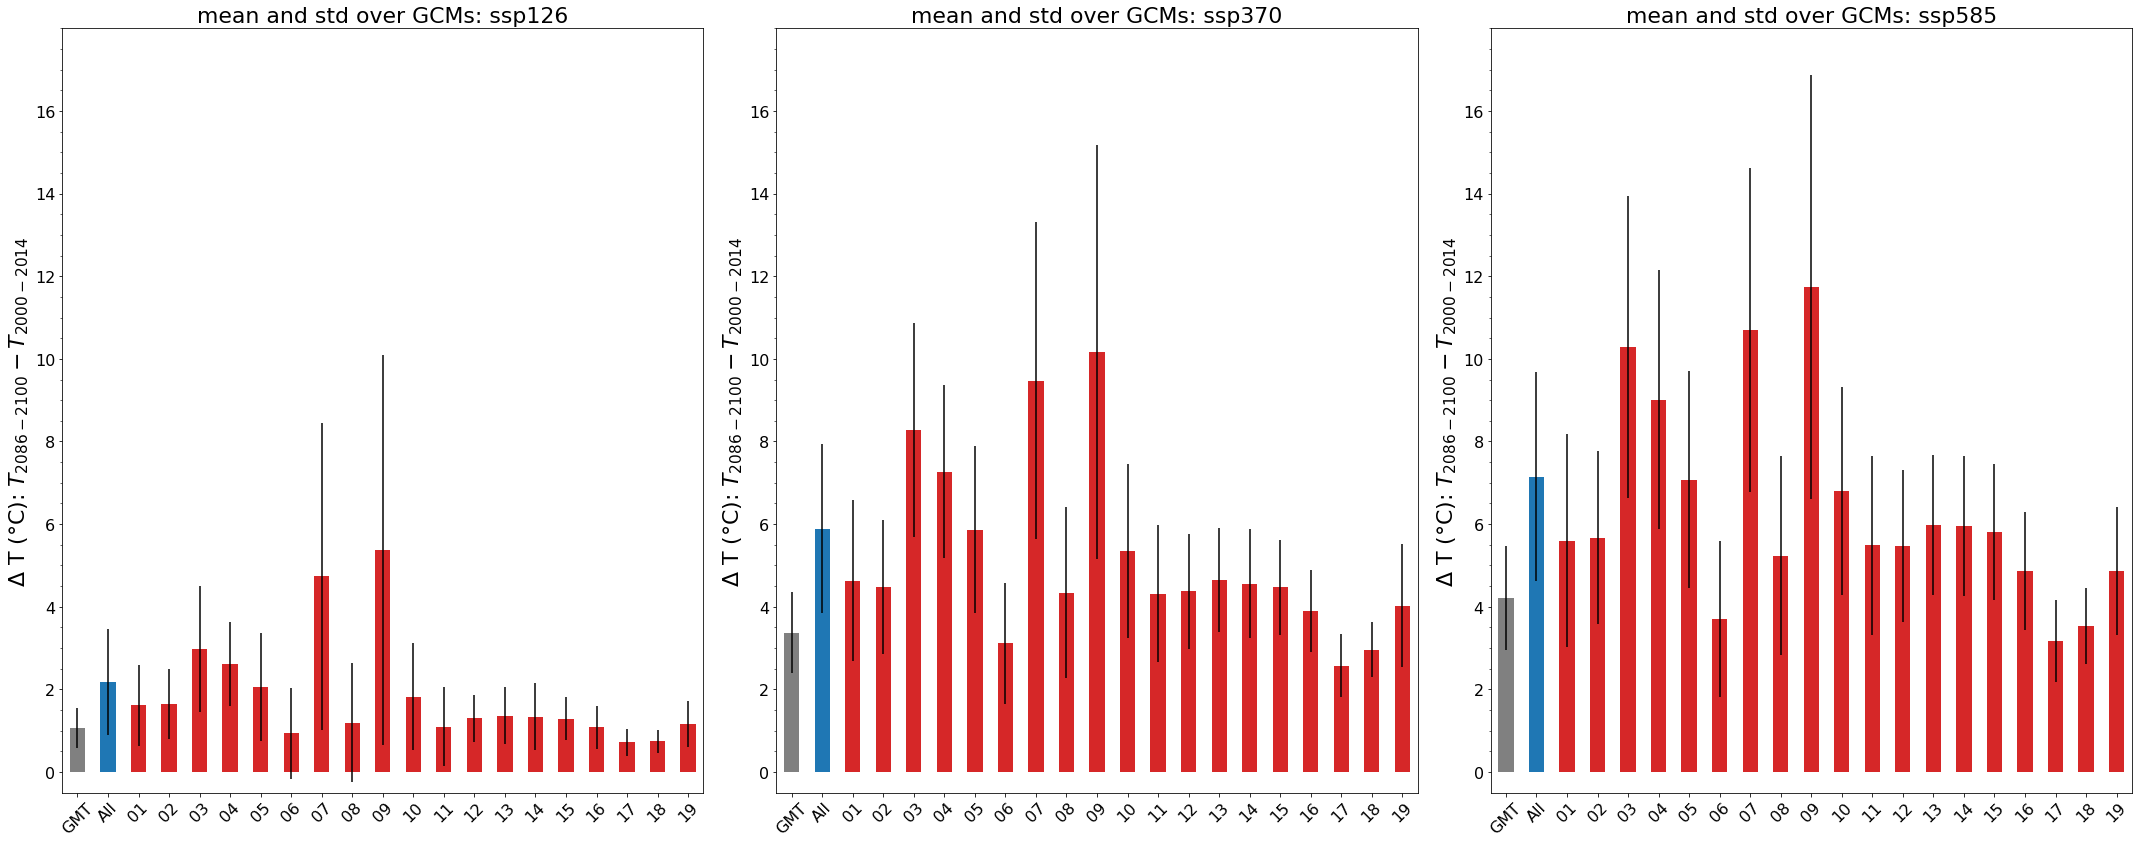

In [42]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(30, 12))

j=0
for scenario in scenarios:
        #for gcm in gcms:

        #tdf_d[scenario].loc['frac_mean_GMT'] = tdf_d[scenario].loc['GMT_mean_diff']/tdf_d[scenario].loc['GMT_mean_diff'].mean()
        plt.subplot(1,3,j+1)
        ax = plt.gca()
        #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
        #plt.plot(taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
        #         taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
        #        label='mean over GCMs for that region')
        #if gcm==gcms[0]:
        plt.ylabel('$\Delta$ T (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=22)
        plt.ylim(-0.5, 18)
        plt.title('mean and std over GCMs: {}'.format(scenario), fontsize=22)
        plt.minorticks_on() # (np.arange(0,19))
        plt.yticks(np.arange(0,18,2))
        ax.tick_params(axis='x',which='minor',bottom=False)
        #if j==0:
        #    plt.legend(fontsize=22)
        yerr = taf_d[scenario].drop('GMT_mean_diff').std(axis=1)
        taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey'], yerr=yerr);
                                                               #label='mean and std over GCMs');

        j+=1
#plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
plt.tight_layout()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_mean_std.pdf')



### gridpoint temperature warming per GMT warming

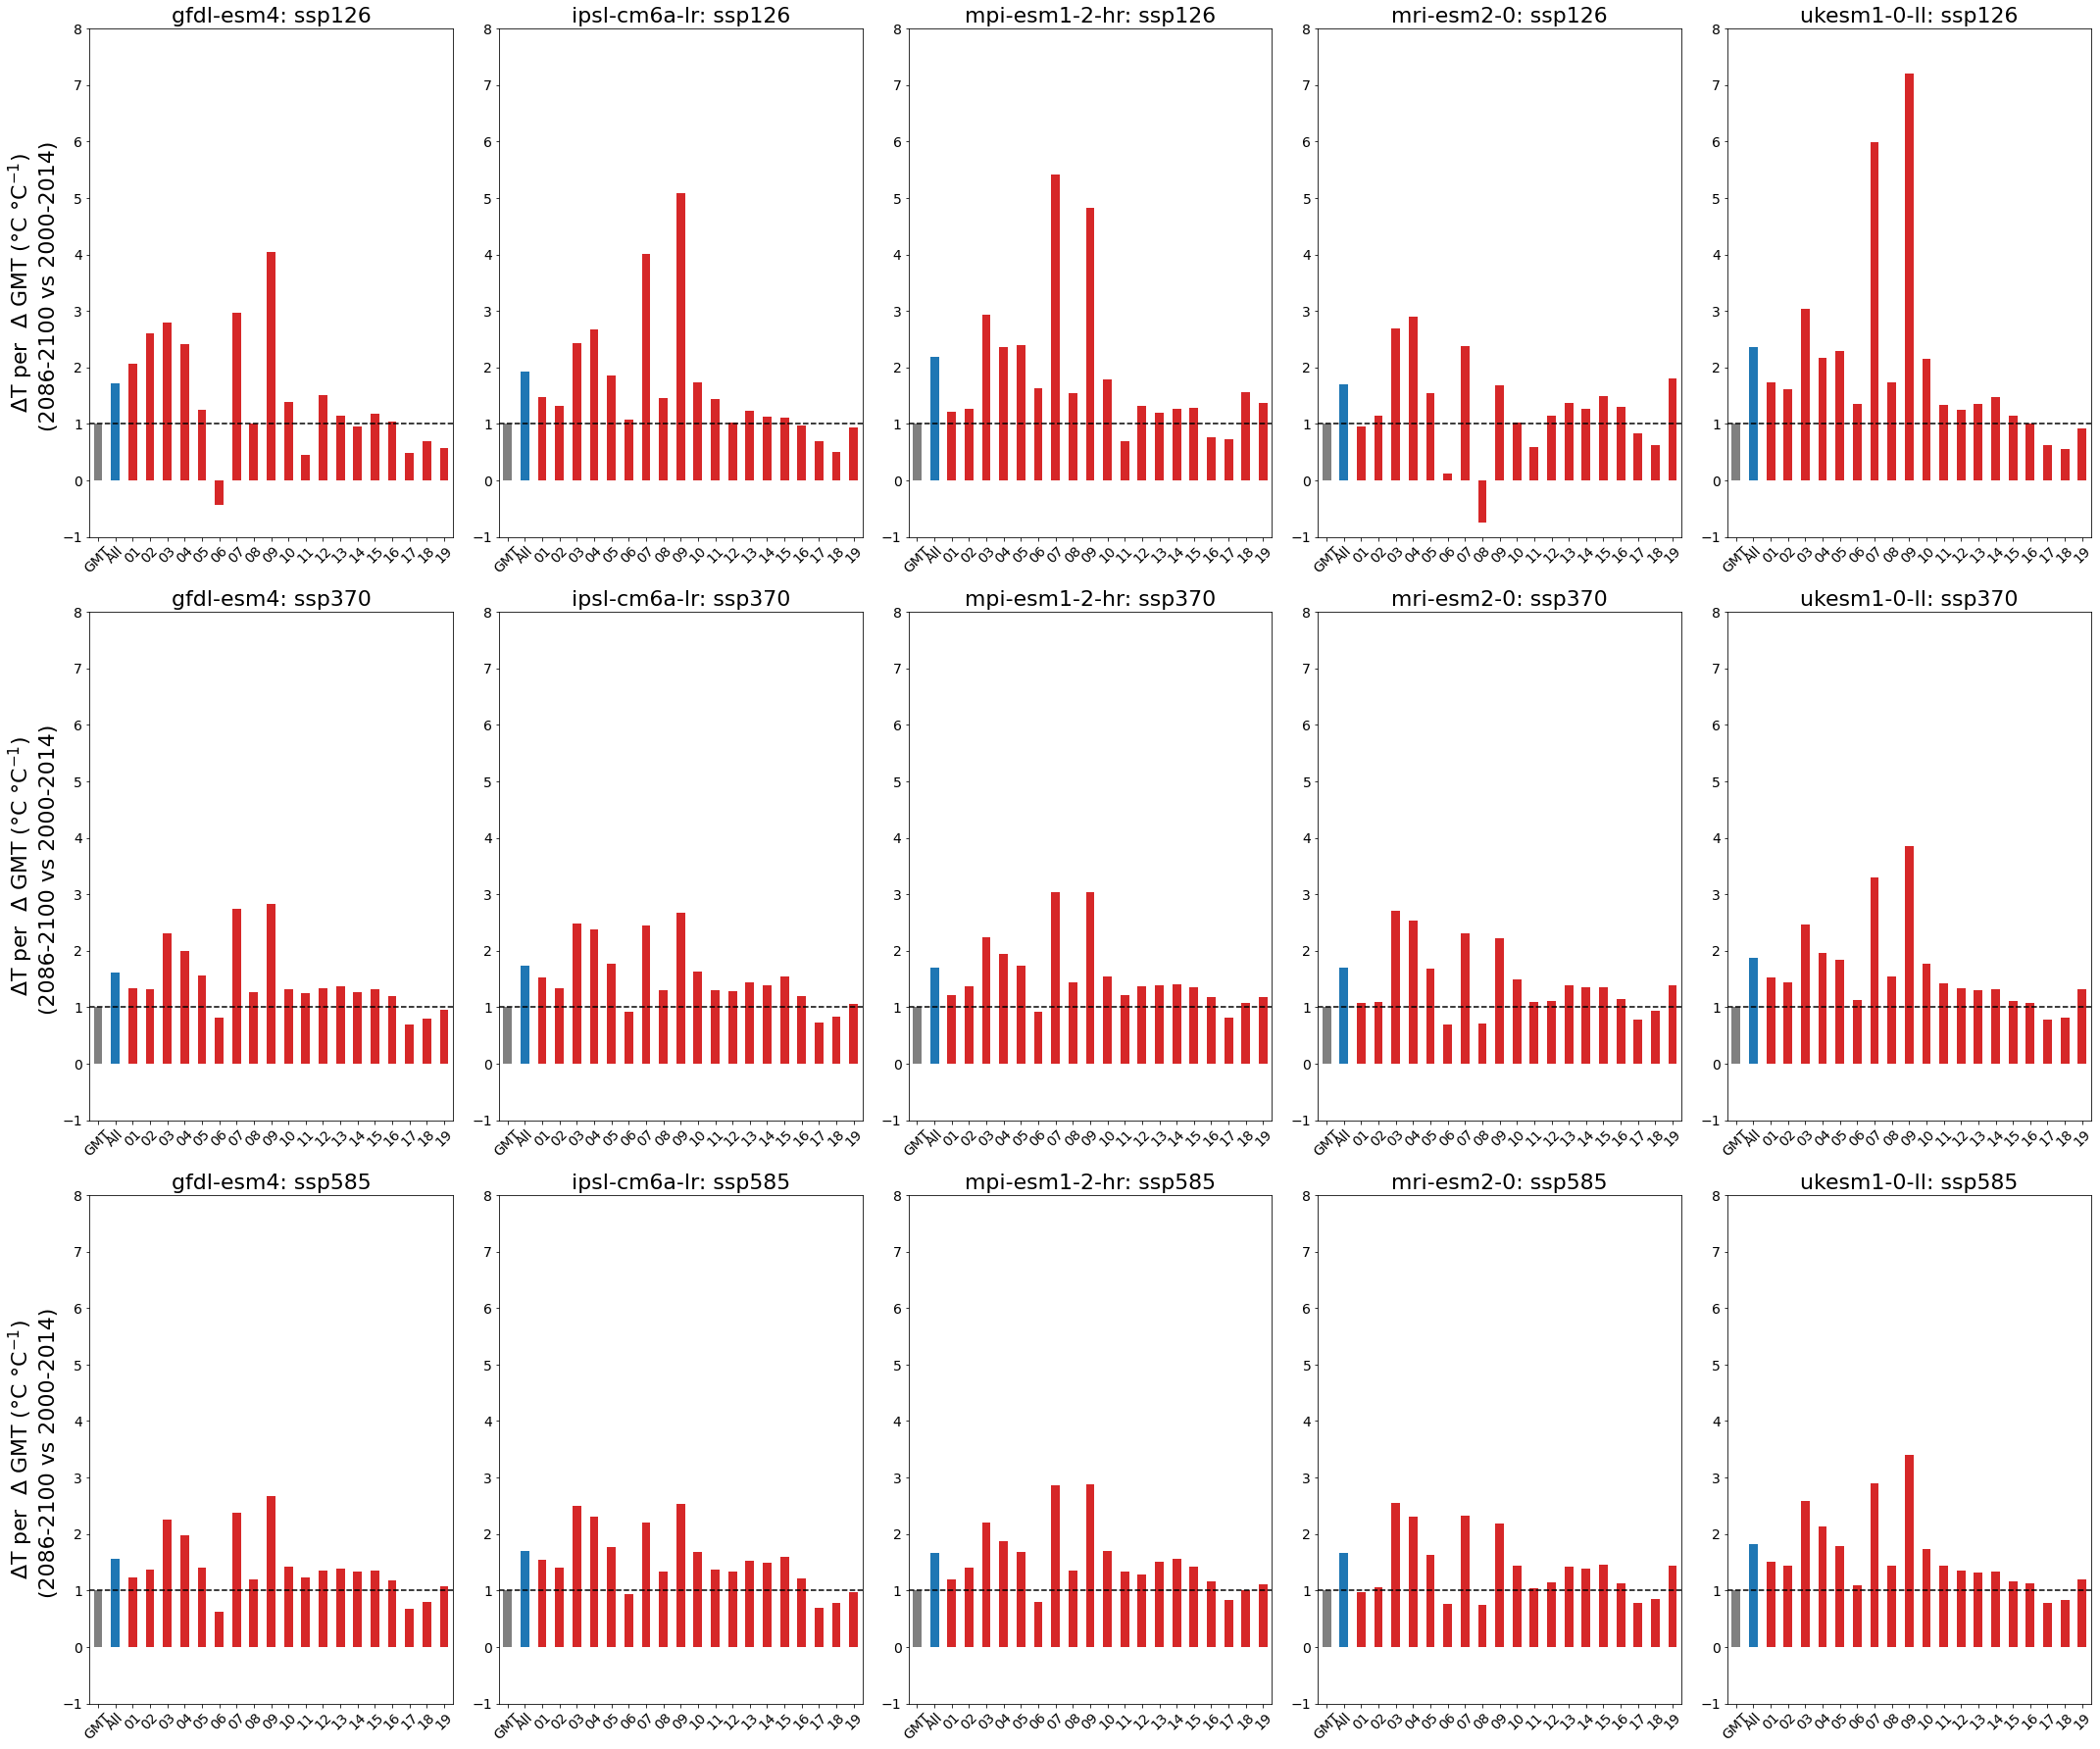

In [46]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(30, 25))


j=0
for scenario in scenarios:
    for gcm in gcms:

        plt.subplot(3,5,j+1)
        ax = plt.gca()
        plt.axhline([1], linestyle='--', color='k')
        tdf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);
        if gcm == gcms[0]:
            plt.ylabel('$\Delta$T per  $\Delta$ GMT (°C °C$^{-1}$)\n(2086-2100 vs 2000-2014) ', fontsize=22)
        plt.ylim(-1, 8)
        plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
        j+=1
plt.tight_layout()
#plt.suptitle(f'ISIMIP3b average T change at glacier locations per degree global warming(°C per GMT °C) 2086-2100 vs 2000-2014')

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_per_deltaGMT.pdf')

- "1" means here that warming in this region is same as the global mean temperature warming for that scenario and that GCM
    - so it only shows the relative changes and is difficult to compare!

# temperature changes of different time periods compared to reference time period (1995-2014)

In [124]:
# 20 years before 2015 (starting with 2015, data depends on ssp!)
ref_time = 1995 #slice(int(1995),int(2014),1)
# 
#exp_times = []
exp_times = [1851, 1901, 1951, 2021, 2041, 2061, 2081]
#    exp_time = slice(int(k), int(k+20-1))
#    exp_times.append(exp_time)

In [125]:
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
typs = ['tasAdjust']
scenarios = ['ssp126', 'ssp370', 'ssp585']

tdf_e = {}
taf_e = {}
# this has to be repeated for each experiment:
# it would be better to repeat the experiment for each typ (in the inner loop, like that we would not need to repeat)
for exp_time in exp_times:
    tdf_d = {}
    taf_d = {}
    for scenario in scenarios:
        tdf = pd.DataFrame(dtype=float)
        taf = pd.DataFrame(dtype=float)

        for gcm in gcms:
            if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
                ensemble = 'r1i1p1f1'
            elif gcm == 'ukesm1-0-ll':
                ensemble = 'r1i1p1f2'

                # for the ssp:
            ybegin = 2015
            yend = 2100
            for typ in typs: #only tasAdjust ...
                folder_output = 'isimip3b_{}_monthly'.format(typ)
                
                path = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
                path_h = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, 'historical', typ, 1850, 2014)

                ds_gcm_t2m_hist = xr.open_dataset(path_h).tasAdjust-273.15
                ds_gcm_t2m = xr.open_dataset(path).tasAdjust-273.15
                ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                             ds_gcm_t2m.lon.values + 360,
                                             ds_gcm_t2m.lon.values)
                ds_gcm_t2m['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                             ds_gcm_t2m.lon.values + 360,
                                             ds_gcm_t2m.lon.values)
                
                # could also look at the seasonal cycle, but here I look at the annual means ...
                if exp_time<2015:
                    # in that case the experiment period is also in the historic time!
                    # and actually it is equal for all scenarios !!!!
                    # amount of warming for each grid point 
                    #print(hist)
                    t2m_dT = ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                            str(exp_time+19)) ).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice(str(ref_time),
                                                                                                                                  str(ref_time+19))).mean(dim='time')
                    # ... divided by GMT warming 
                    mean_ref = (ds_gcm_t2m_hist.sel(time=slice(str(ref_time),
                                                               str(ref_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])
                    mean_exp = (ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                               str(exp_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    t2m_dT_per_dT = t2m_dT / (mean_exp.mean()-mean_ref.mean())
                else:

                    # amount of warming for each grid point 
                    t2m_dT = ds_gcm_t2m.sel(time=slice(str(exp_time), str(exp_time+19))).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice(str(ref_time), str(ref_time+19))).mean(dim='time')
                    # ... divided by GMT warming 
                    mean_exp = (ds_gcm_t2m.sel(time=slice(str(exp_time), str(exp_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    mean_ref = (ds_gcm_t2m_hist.sel(time=slice(str(ref_time), str(ref_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    t2m_dT_per_dT = t2m_dT / (mean_exp.mean()-mean_ref.mean())

                # Check (should be one)
                tdf.loc['GMT', gcm] = float((t2m_dT_per_dT * ds_inv.weight).sum(dim=['lon','lat']))

                # these should be the same ... 
                taf.loc['GMT', gcm] = float((t2m_dT * ds_inv.weight).sum(dim=['lon','lat']))
                taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())
                tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())

                # All glaciers (weighted by area)
                # in weight_glacier: the area of each glacier is already inside
                tdf.loc['All', gcm] = float((t2m_dT_per_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                taf.loc['All', gcm] = float((t2m_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))

                for rgi_reg in range(1, 20):
                    weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
                    weight_reg = weight_reg / weight_reg.sum()

                    tdf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_per_dT * weight_reg).sum(dim=['lon','lat']))
                    taf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT * weight_reg).sum(dim=['lon','lat']))

                tdf_d[scenario] = tdf
                taf_d[scenario] = taf

                ds_gcm_t2m_hist.close()
                ds_gcm_t2m.close()
    tdf_e[exp_time] = tdf_d
    taf_e[exp_time] = taf_d

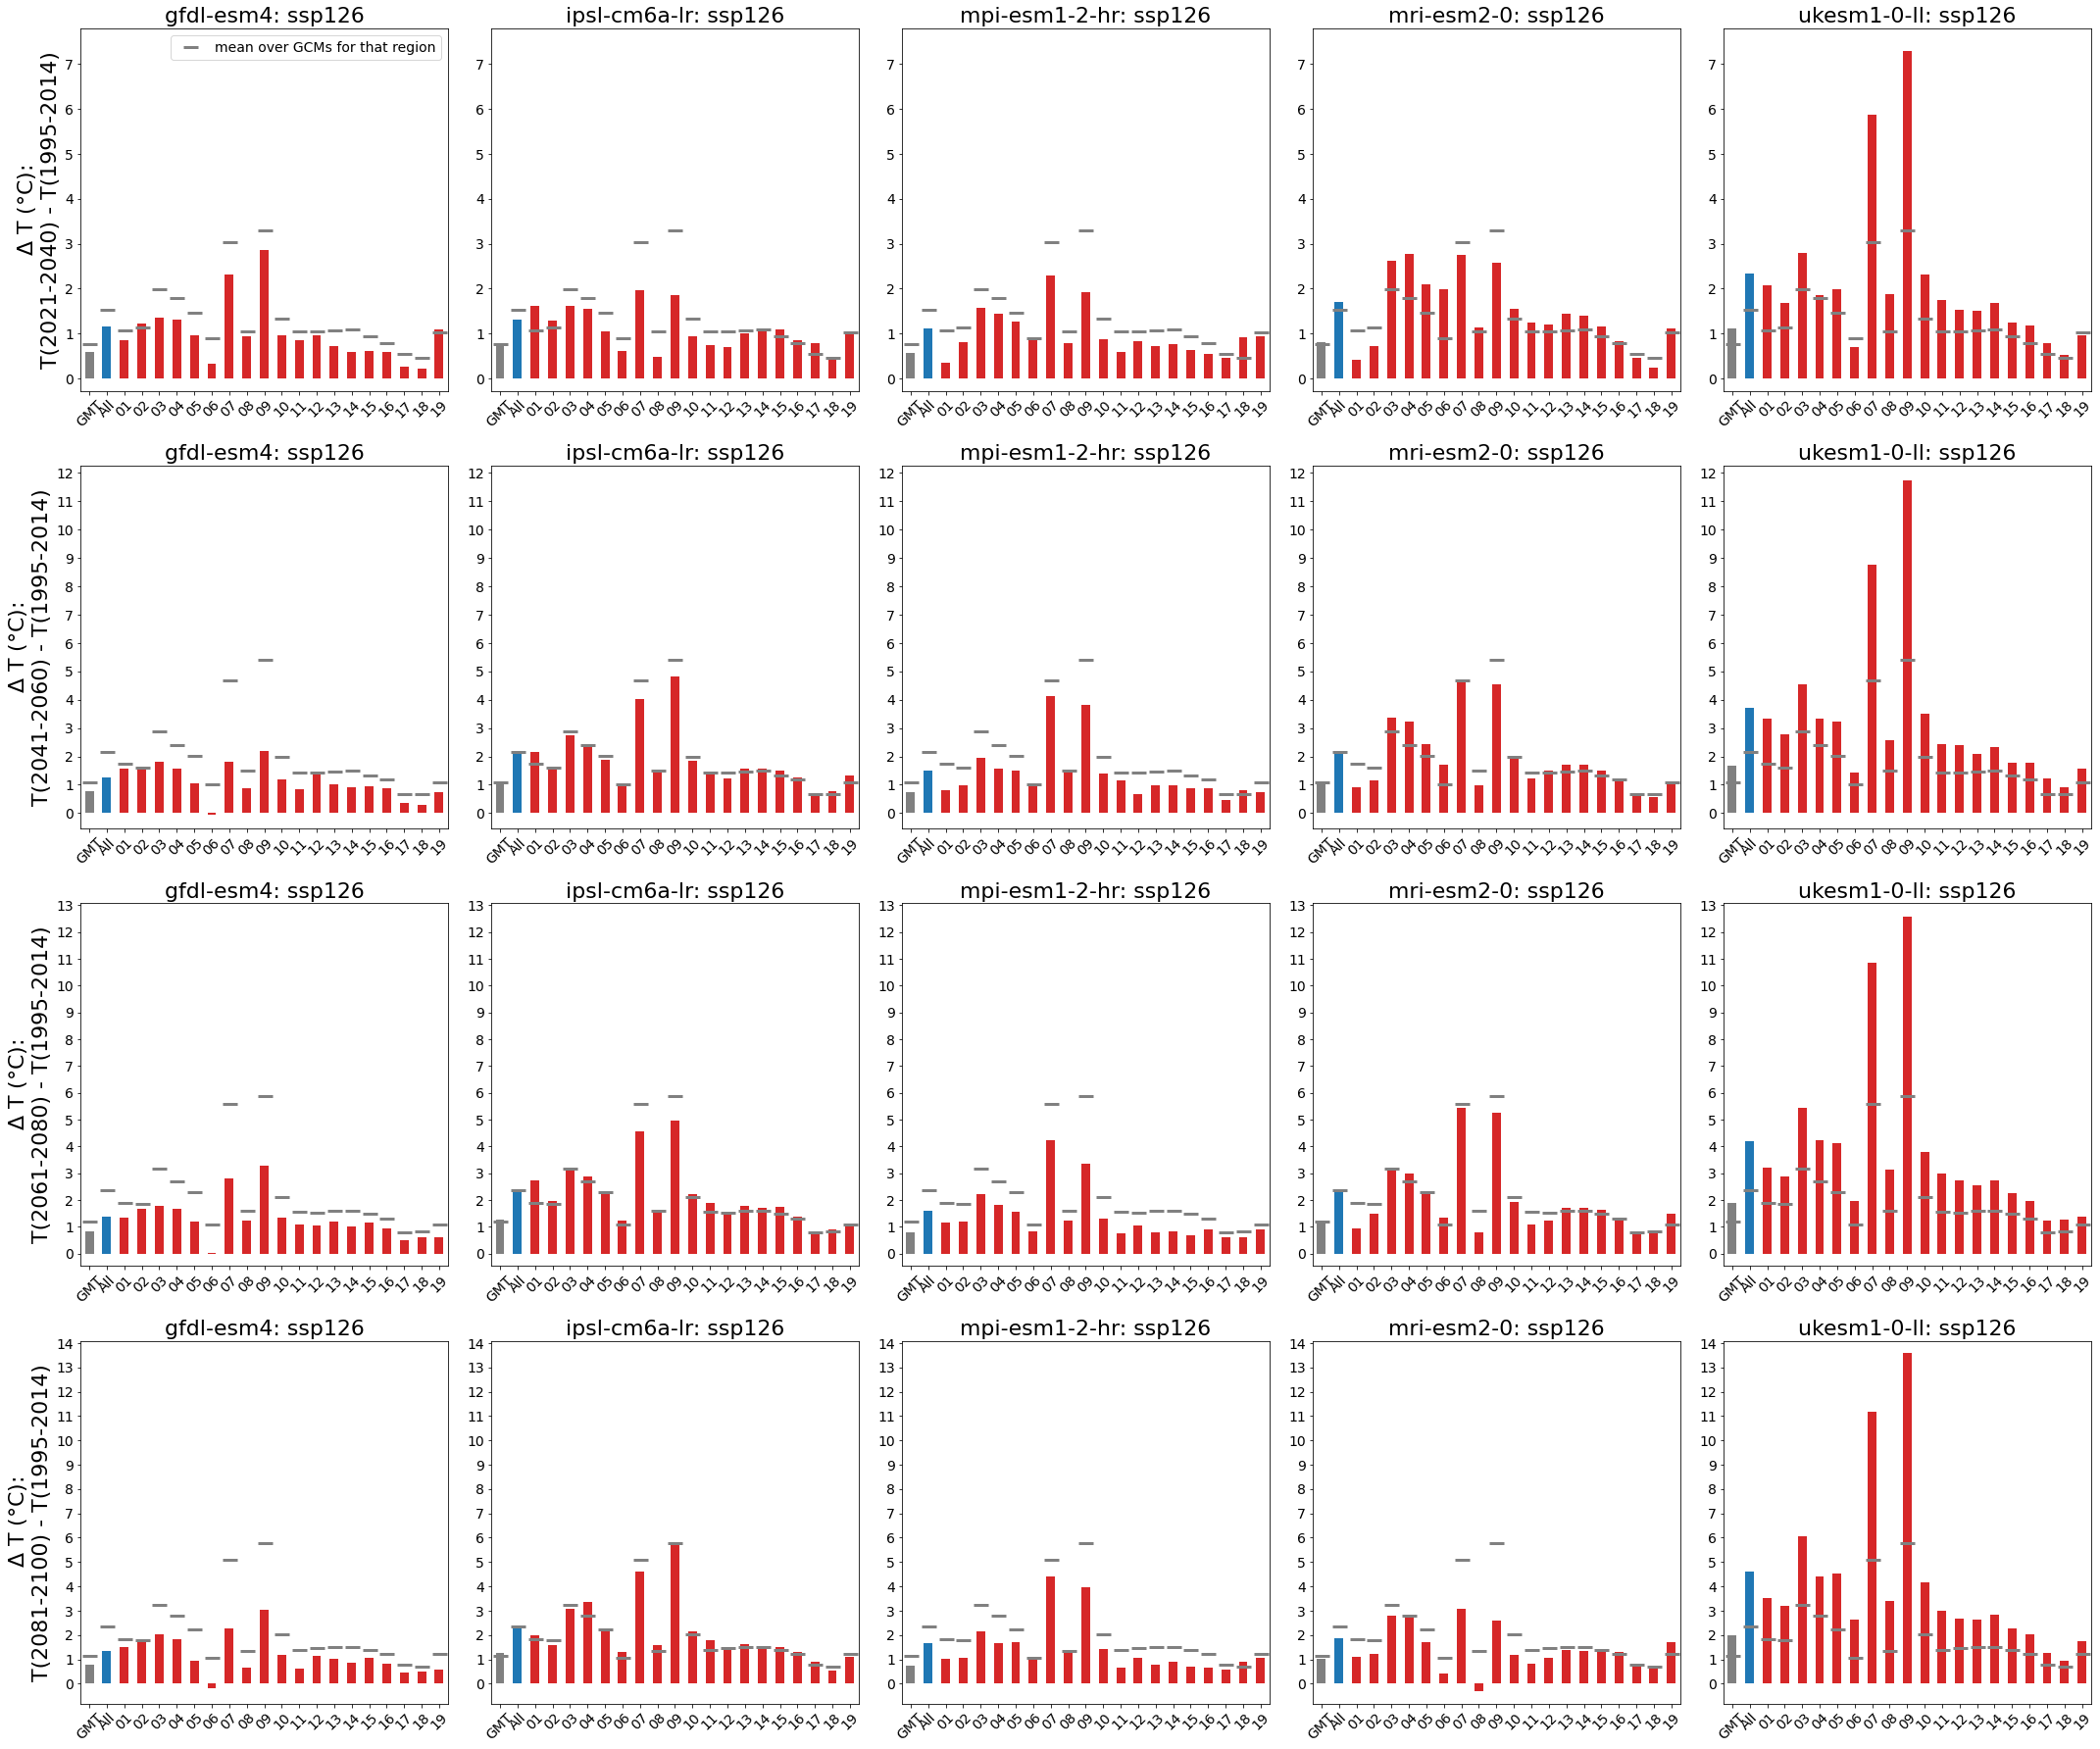

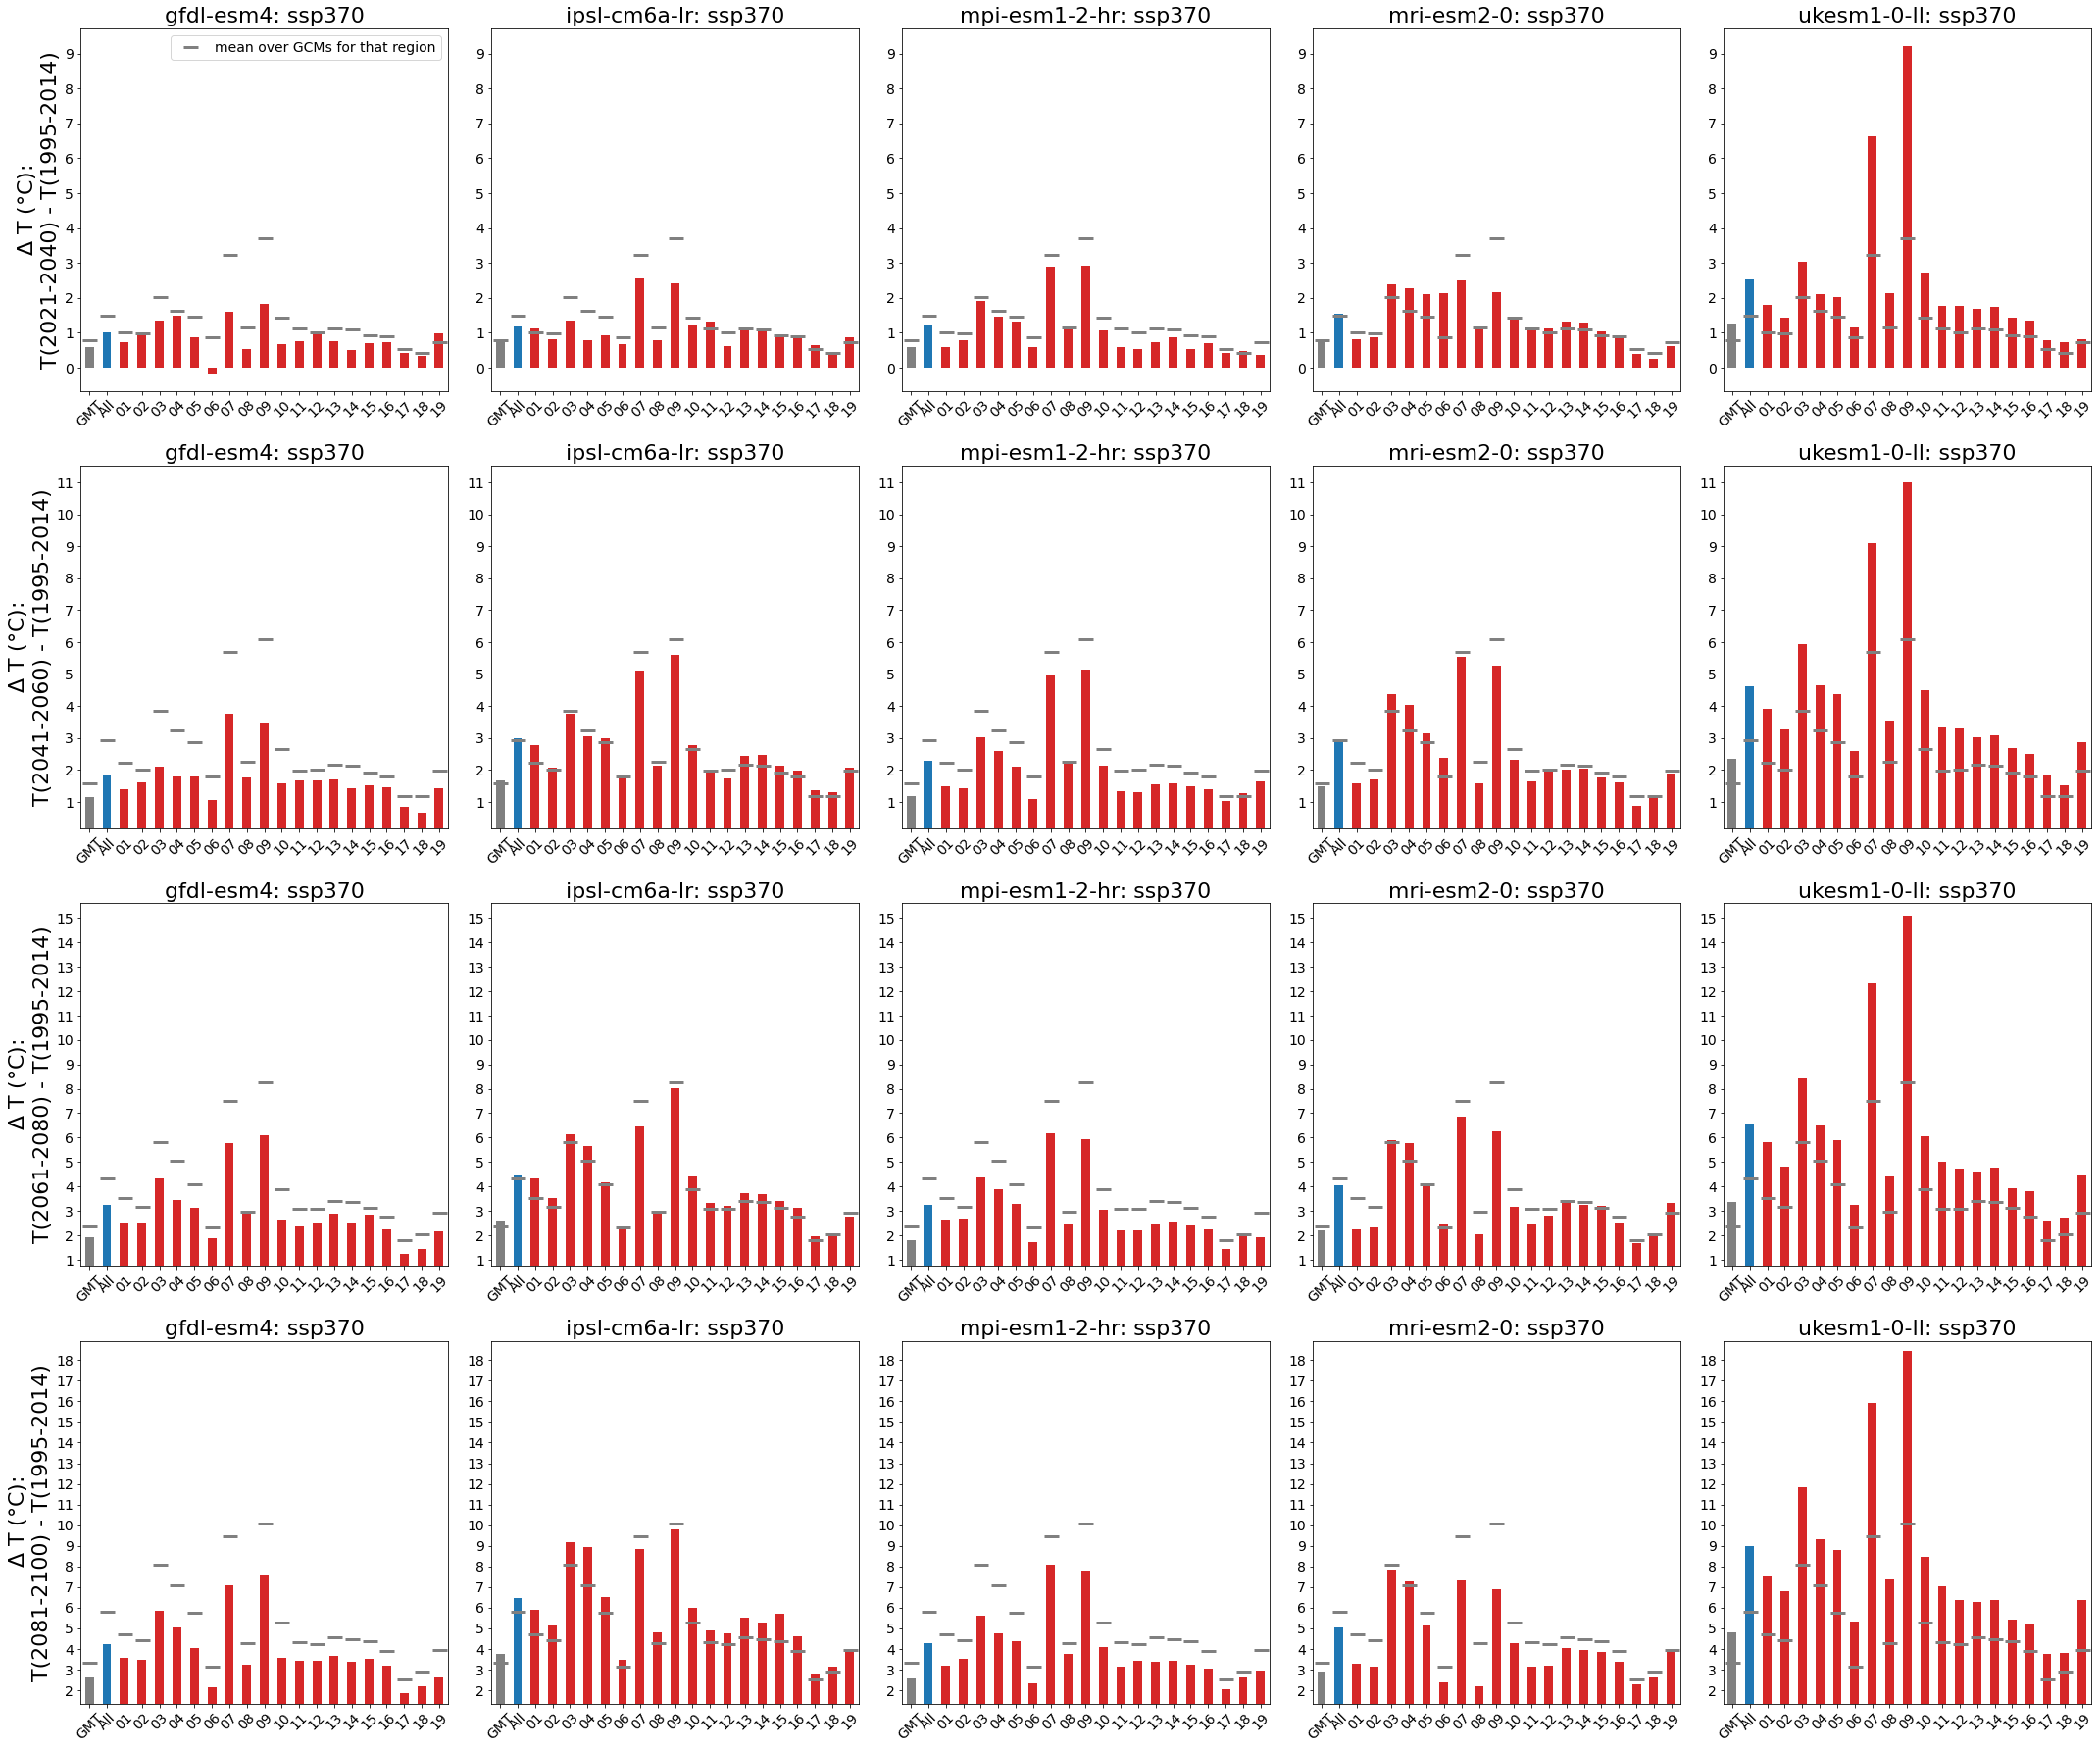

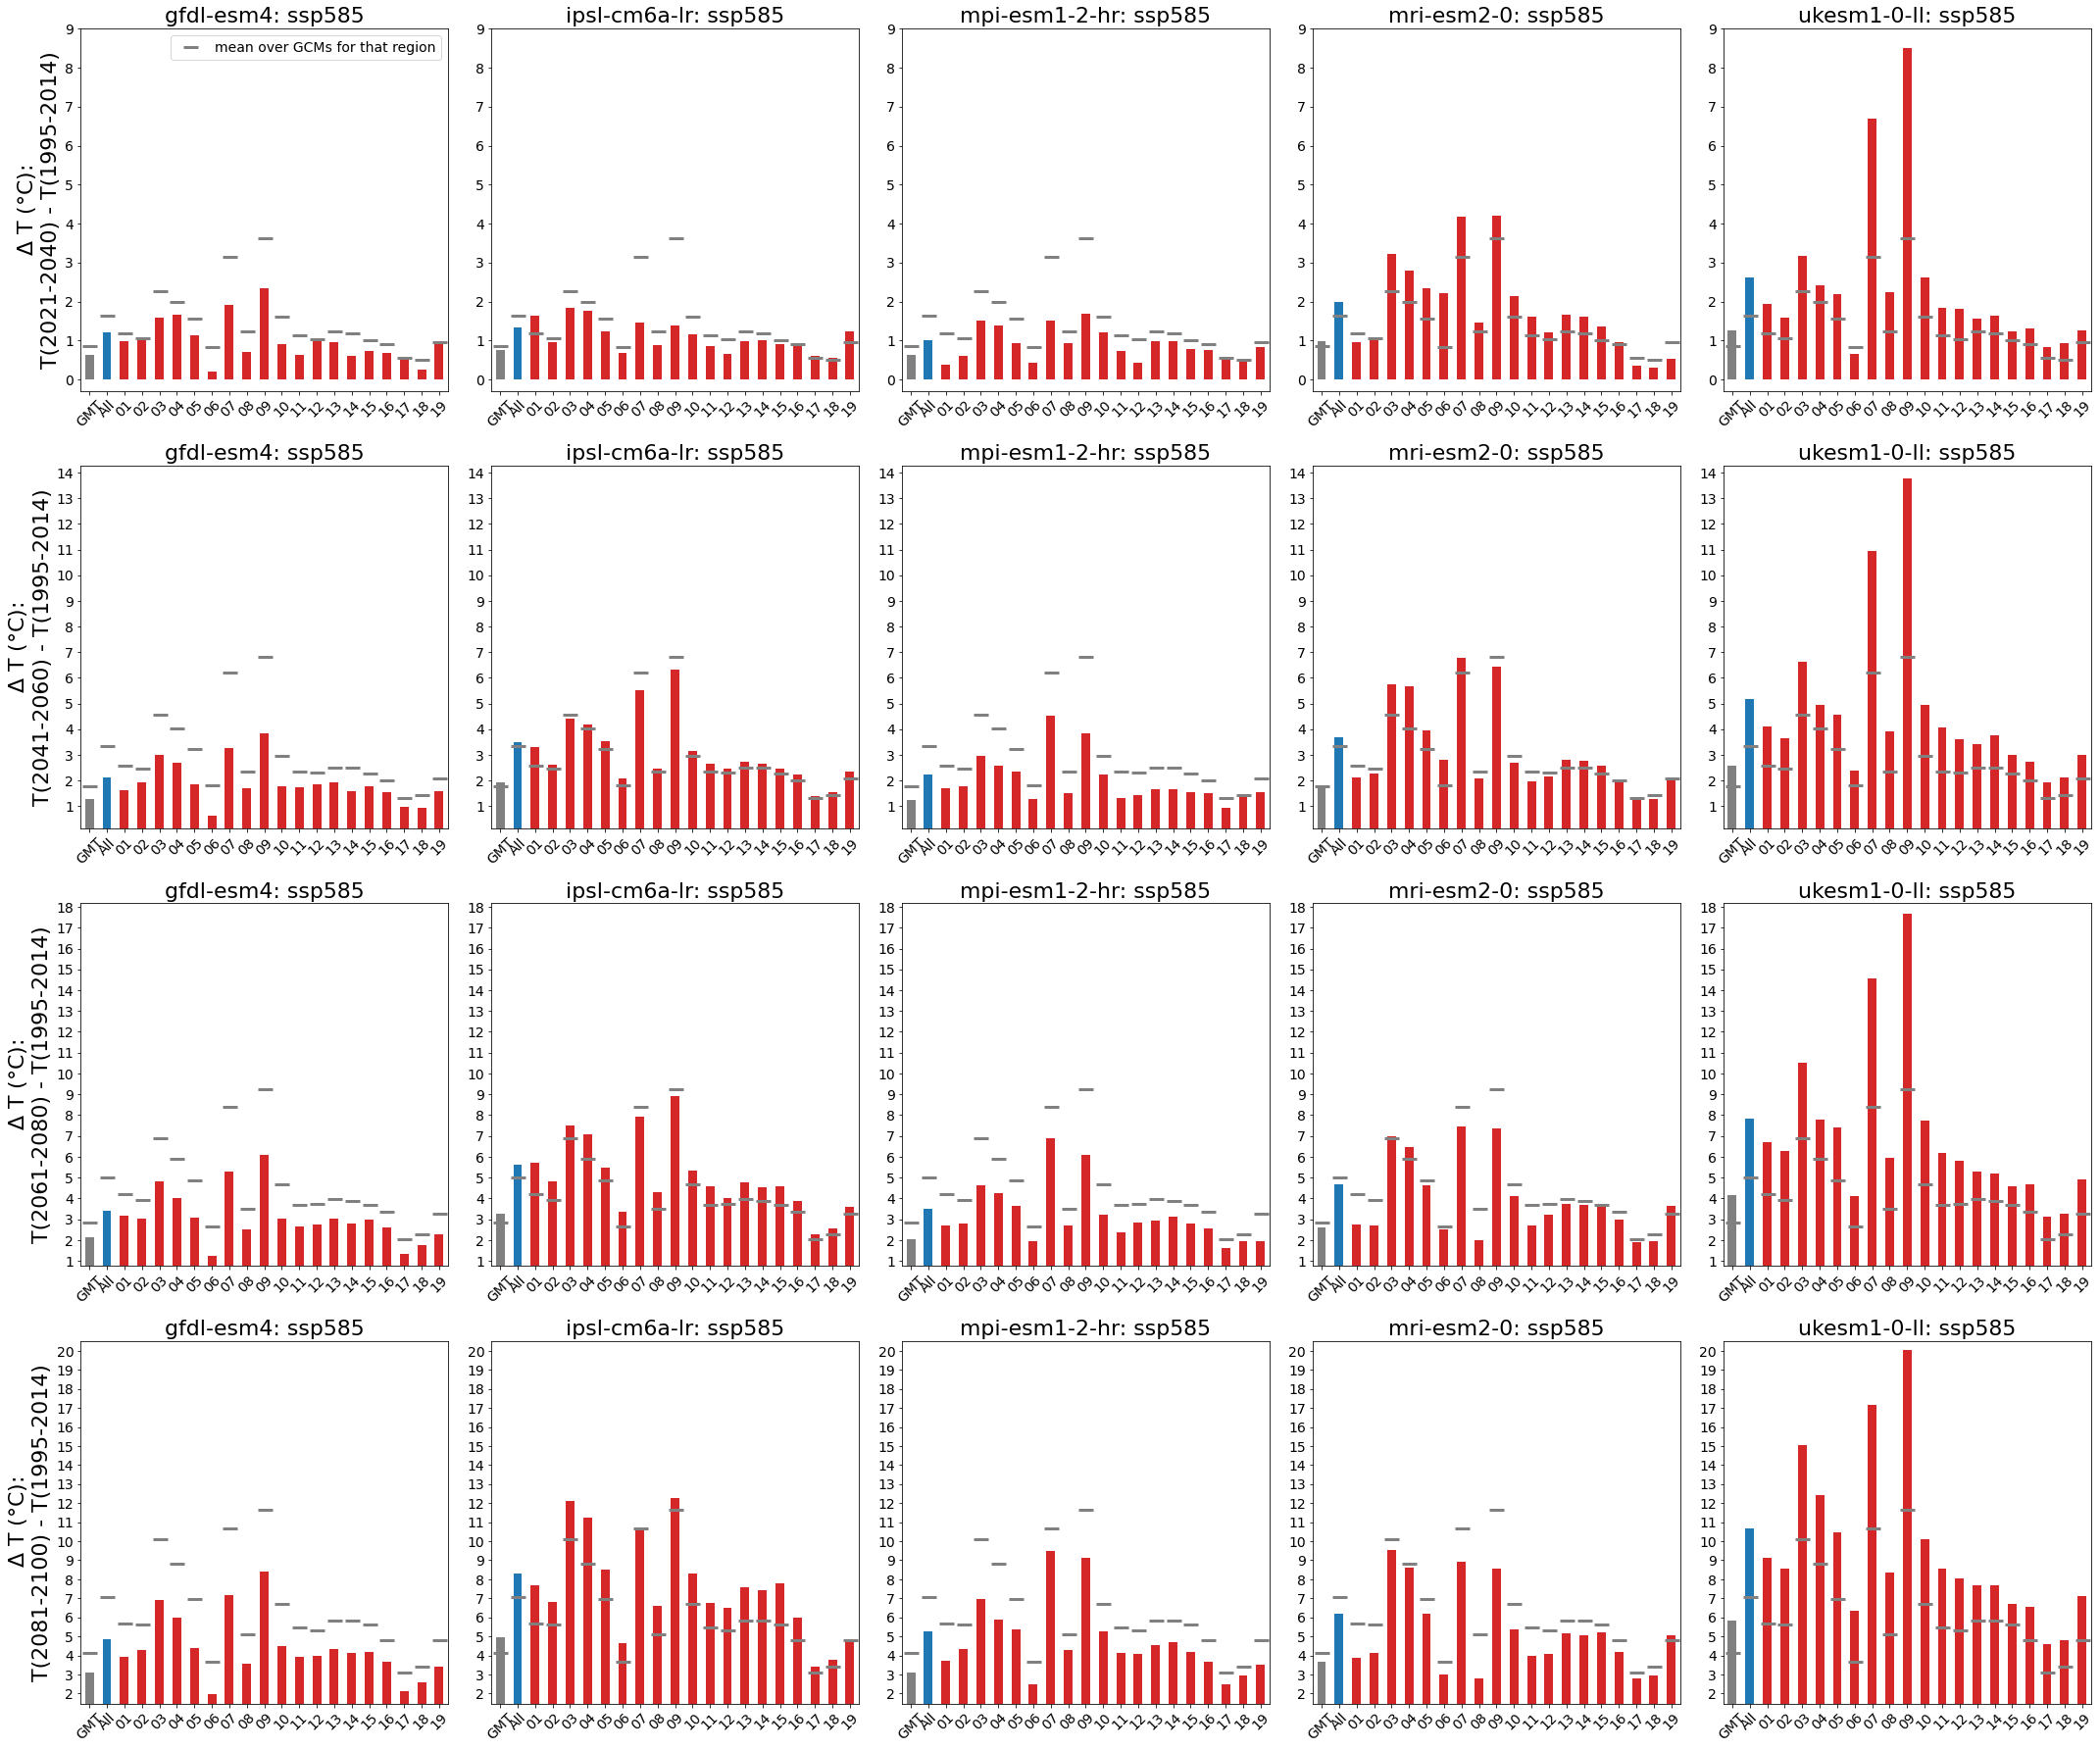

In [153]:
plt.rcParams.update({'font.size': 14})
scenario = 'ssp126'

for scenario in scenarios:
    plt.figure(figsize=(30, 25))

    j=0
    for exp_time in exp_times[3:]:
        taf_d = taf_e[exp_time]
        for gcm in gcms:

            #tdf_d[scenario].loc['frac_mean_GMT'] = tdf_d[scenario].loc['GMT_mean_diff']/tdf_d[scenario].loc['GMT_mean_diff'].mean()
            plt.subplot(4,5,j+1)
            ax = plt.gca()
            #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
            plt.plot(taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
                     taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
                    label='mean over GCMs for that region')
            if gcm==gcms[0]:
                plt.ylabel('$\Delta$ T (°C):\nT({}-{}) - T(1995-2014)'.format(exp_time, exp_time+19), fontsize=22)
            plt.yticks(np.arange(-14,22,1))
            maxi = taf_d[scenario].max().max() +0.5
            mini = taf_d[scenario].min().min() -0.5
            plt.ylim(mini, maxi)
            #if exp_time == 2021:
            #    plt.ylim(-1, 8)
            #elif exp_time ==2041:
            #    plt.ylim(-1, 12)
            #elif exp_time >=2061:
            #    plt.ylim(-1, 14)
            #plt.ylim(-1, 15)
            #else:
            #    plt.ylim(0,21)
            plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
            #plt.minorticks_on() # (np.arange(0,19))
            ax.tick_params(axis='x',which='minor',bottom=False)
            if j==0:
                plt.legend(fontsize=22)
            taf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);

            j+=1
    #plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
    plt.tight_layout()

    plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_expfuture-ref_{}.pdf'.format(scenario))

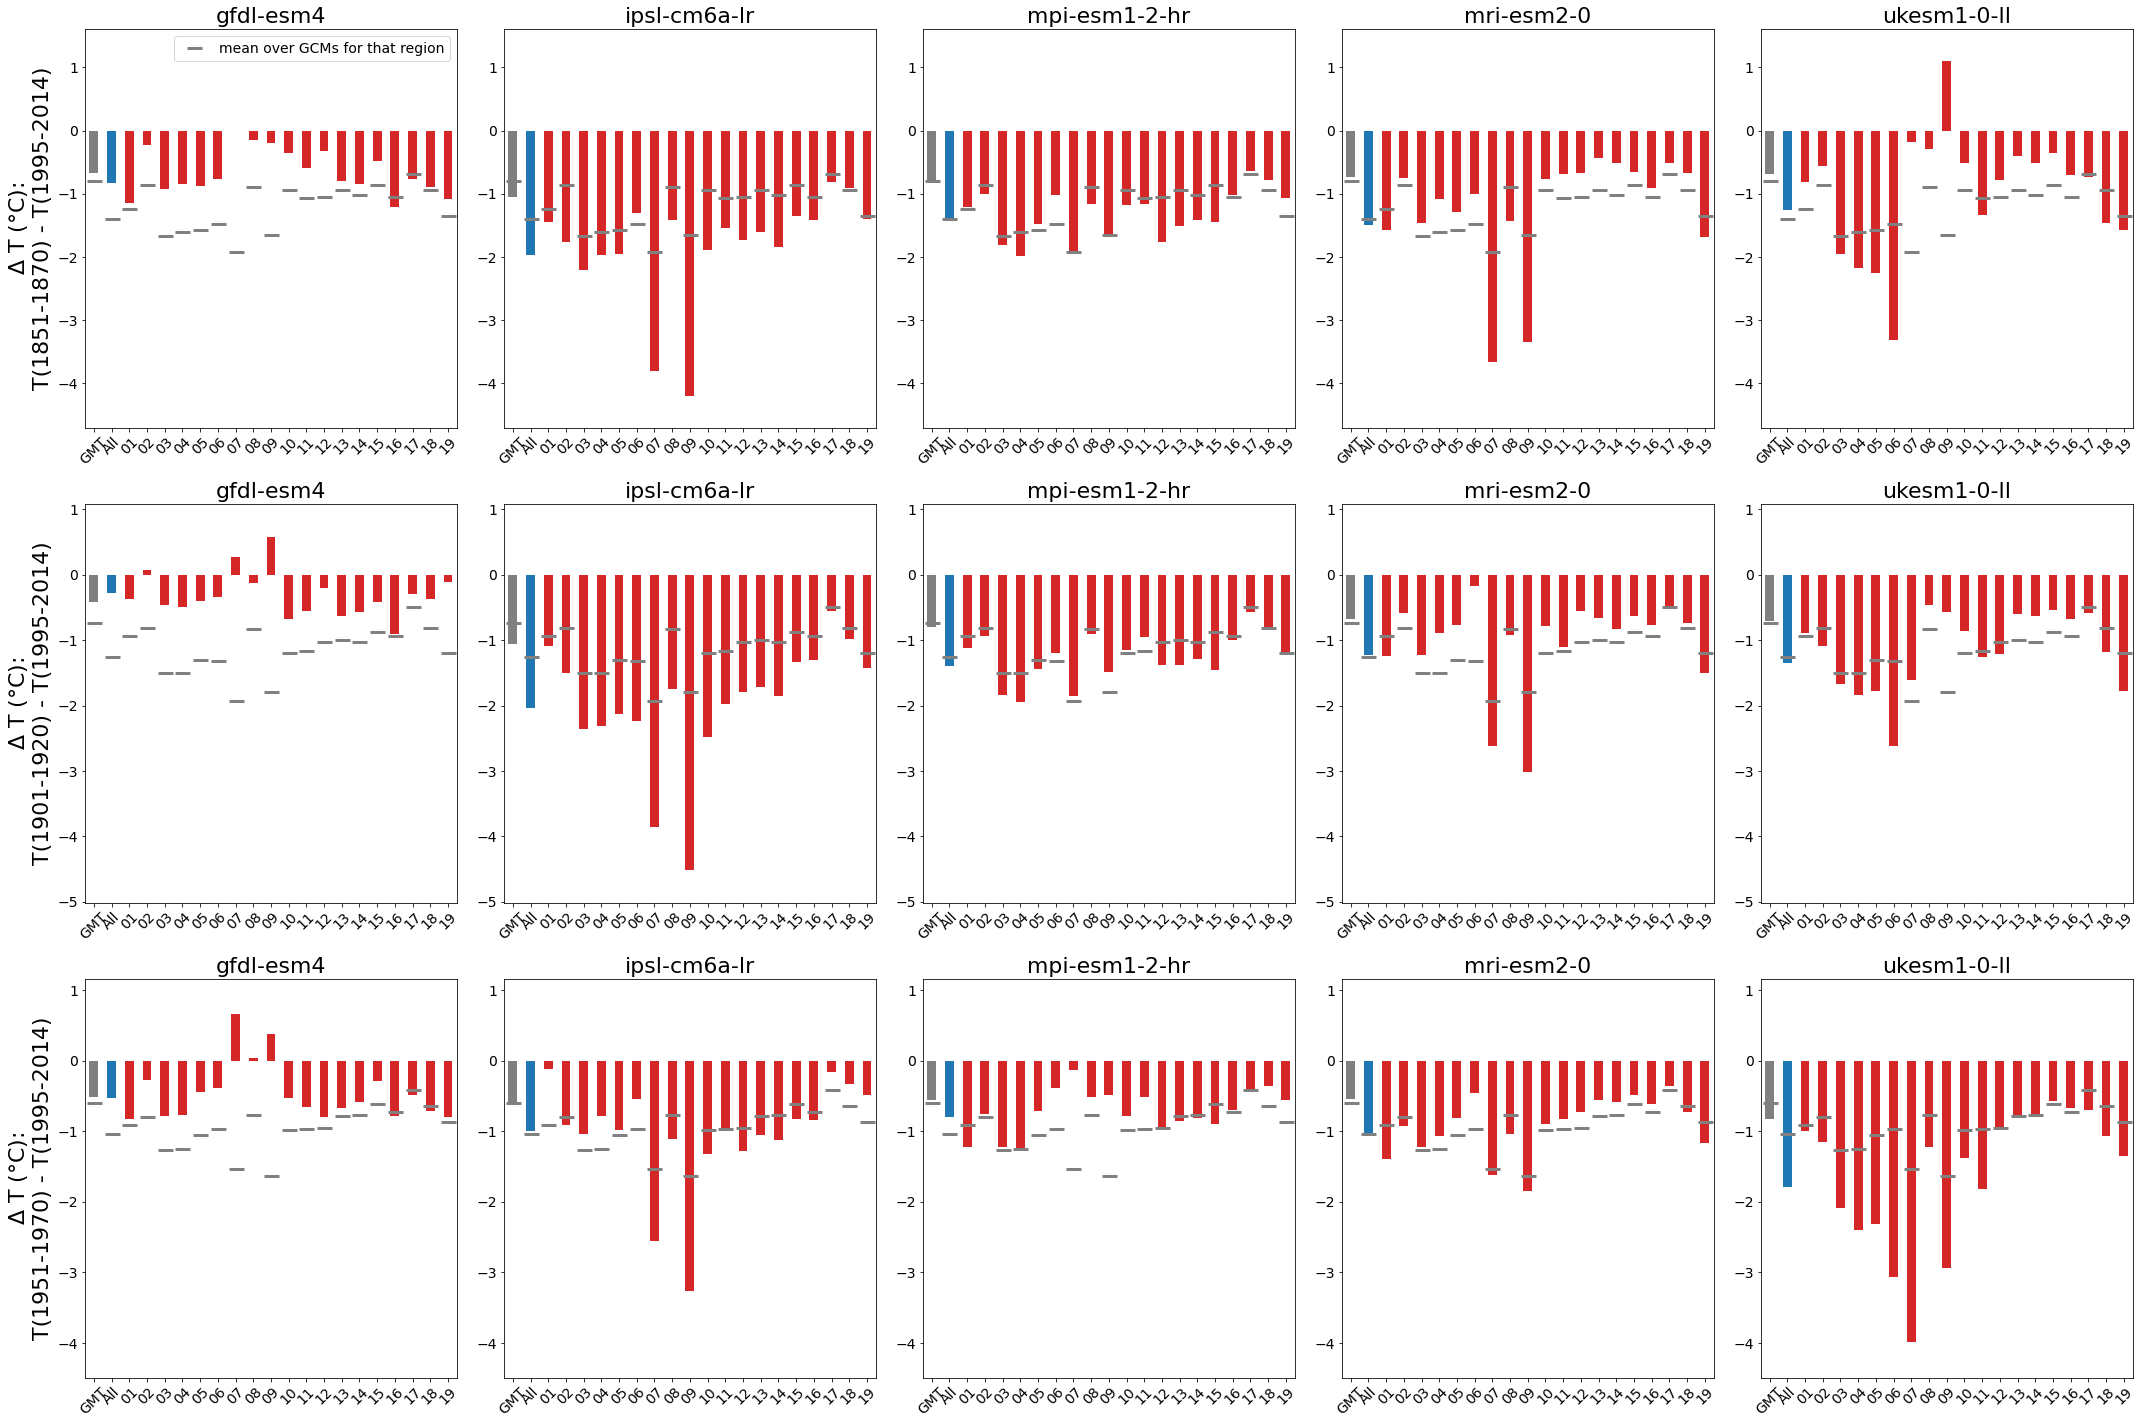

In [158]:
plt.rcParams.update({'font.size': 14})
scenario = 'ssp126'

#for scenardata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACF4AAAb4CAYAAAC8hIXiAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/Il7ecAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOzdd5xcVf3/8dcnJtSQBRGkGzSUIEgLRYoERCwYAUFFRAiiqChWRCw/BRQEQRQVRRQEFUUBASOCYklsiBRRhIQviqAiiAWC9Pb5/XHuJpPNzO7M7uzebPb1fDzmsdnbzpmZzbzn3vnMOZGZSJIkSZIkSZIkSZIkqXPj6u6AJEmSJEmSJEmSJEnSaGXhhSRJkiRJkiRJkiRJ0iBZeCFJkiRJkiRJkiRJkjRIFl5IkiRJkiRJkiRJkiQNkoUXkiRJkiRJkiRJkiRJg2ThhSRJkiRJkiRJkiRJ0iBZeKGlXkTsFRG/ioj7IyKr2xZt7De92nZ2n+WTq+W3D1OXR4WI2DQiHq0eiz/W3Z+REBGzG/6Gmt2u6Gff7SPi2xHx94h4LCIeiIjfRcRHImKlFvvcPkB7ZwzfvZXGjob/a5NraHupyZSI2C4izouIv1X58O+I+G1EnDSCfciIyJFqb0nV8B6mv9v2LfZdPiKOjohrI+J/VWb9IyK+GxG7tNhnZhvtrTG891oSQEQcU/2fO6buvoyUiNgoIt4ZEd+IiHkR8VT1GOw3hGNOiIgXRsSnqtfD+6vXwzsj4sKImD6EY5tVbRhKtkTEKhFxQkTcGBEPVu9L7oiIr7e6FtDwf6fV7ZFhvcPSGNfwf/6cuvsyEiJiXETsEBEfj4hfR8S9EfF4RPwzIn4QEXt3oY2XRMSPIuK/EfFQRPwxIj4UEct24S4s8YZyTa167GZFxN3V8zI/In4TEe+KiGVa7DNQZh09fPdW0lh5jx0RK0bE6yLiM1E+83qwuu/f79LxN6rOq/7R8B76ixGx5iCP1zTfYym6HtqfhvvZ323/Fvs+LSLeWj3P91V5dE9EXN7qfUIM4Xqgumd83R2QhlNEbAlcWP36U+Cu6t//radHS4eIGA+cC0youy81+SFwd5PlNzbbOCLeAHwFiGqbXwOTgB2BY4HXRcROmfmvFu1dBDzQZPlVHfZbkoZFRHwEOAZ4Crga+CWwKrAJ8F7g/bV1bmz7J9CqKHCxzImIHmAOsDnwP+BXwP3AVGAfYJ+IeFdmntbimH+mPPfNPNxBvyWpE28F3tnlY+4CXFn9+27g58CDlFzbF9g3Ij6WmR/pcrtaXEfZEhHrAb8A1gP+DfwMeATYAjgQ2D8i9s/Mi1oc8/fADU2WP95RryWpf8+mvNeGco3yt8C91fKXAi+tPqR6Q2Z2/EFiRBwFnAQ8Ccyujr0L8HHg5RHxwsx8aIj3YbTo6JpalOLVj1a//pby+D0D2BnYDnh1ROyWma0K8s5tsbzpNUNJ6tAGwDeG48BRvmxzObA8cD3lHGhz4C2U85+dMvP/hqPtMeBBFn5O2ddf+i6oPn+7HNgdeJRyPvRvyvuElwAviYjPZOa7Wxyzo+uB6i4LL7S025vyd35CZn6o5r4sTT4IbAWcDryt5r7U4cTMnN3OhhGxMvA5StHFIZl5TsO6VYEfUy4CfpjWF4yPzMzbB91bSQN5IaWQ7M66OzIaRcRbKEVkNwL7NZ6ERURQLk6pHvMyc2YH27+fclJ9PfCizFxQqBoRh1KKCE+OiPMz859N9v9lh+1J6r7PA+dTLsqMFX8ETgauBa4DzqJ8uDQUT1E+qDktM3/RuCIiXgOcB/y/iPhZZv5siG2pf51my4mUoosfAK/q/WAxIsYBH6F8mPaliPheZjYrprgkM48ZWpclDcLFwG+A+XV3ZIQk5QtiJwNXZuaTvSuqD74uA2ZSPvT6aicHjohplNfCh4DdMvPqavnE6rgvAI4HWn1Ys7Rp+5paRGwM/D9Ksd2emXllw7rJlMK+51OKPj/d7BieD0kaZv8Dzmbhuc+WwJBHxY6IFSnnkcsDR2Tm5xvWnUL5UtW3ImLaYAoCxb87zIc3UIou/grsnJl/7V0RES8Gvg+8KyK+npnXN9m/0+uB6iKnGtHSbt3q56219mIpEhGbU4oEvkvrKj0ttB2wAvB/jUUXAJn5H+CT1a/PH+F+Sapk5p8zc16Li+/qR1VAdjLlot7L+1a+Z/GbWjqnwdi1+nlKY9EFQGaeBfwfpUhp65HumKT2ZOa/q0wbM4UXmfmVzDwqM7+TmX/u0jF/mpn79S26qNZ9Gzin+vXAbrSnrurNso83fps7M58CPkYZJWNVyrcFJS0hMnN+lV93Dbz16Fedg74wM69oLLqo1s2hFE7A4HLmaMqXf07qLbqojvsAcAiluPDw6otCWtQulM9LftZYdAFQFW98ofrVa3iSalHlx6GZ+cXM/C1lNIRuOARYg/L69/k+695PGYVuK8qoTBp+vec0ZzQWXQBk5g8pxZsAThuyBLLwQqNGRGwREZdGmZvwwYi4rprCYbE5vKKan5USGABfbZjD6Jw+x927mifpgShzKl4ZLeYw79L9WDEijoqIa6LMFfxwRNxU9Xlik+2fFhFviTLn4/wocwv/MyKujzLn8Gp9tl/wWFRzaF1bPV53R8RZvdtHxHIRcWxE/F9EPBIRf42I4yOi5fQh1bpzKJWVh3fzcWnS1rYRcUGUeZR751P8U0R8MyJ267PtclHmo7++eh4fjYi7IuKqKPNlLtew7YL5wyJifLXf3Oox+GdEnFsNT9st7b75GTMXx6UlTSyc+3Vyn+Wzq+XTI2LXiPhxlRMPRMQvI+IVLY63cpR5xW+KMpfuIxHx9+p4H+hy31eMiCOr17v7qky5rXr9fFmr+xkRMyLiF1UO/SfKfPXrV9uNi4h3R5kX/aEqP06PiJWadGEmMBG4sO+JwAD9Xi0i3hkRV0TEX6rHaH6UeXPfFhFPG8rj0qS9xvu+d0T8rHouM1rM9d7BsdvOoGr7TvLtnKqPM6O8D7okIv5dPc/XRcQhdJeZJQ1CDMP778H+/4/qPCjKMNmDuS9Tqz73vjbfW+Vfq8xbKyI+X72OPVLlxl+r1/fD+my7YH7fiFglIj5bbftwlPfjb2nY9rkR8Z0o788fjojfRvlmz5Lid9XPdYZykIh4TZUXD0TE/yLiJxGxU4ttG//ODo2Iq6sczxjih2fR4XuXiNgjIi6LMsfw41HO0edFxNkRsVWfbQf1fmoIBsqy3usGZpnUxAhk2vOivBe+OyKejIh3NbS12DW7Dvq9bkScFhG3VLlxf5RrfTMjIpps3/brXiycL312db8/VuVe77nXh6M6f6n6cVaU9/qPRDmnGkzxxKByJiKWYeGHYuf1XZ+Zt1Gm2FgGeFnf9YPVYS4M9rFfMSJOrB7zRyPibxHxuShfBugWz4ekGkXDdft+tlnkc6A2jrlslOstGeXzlWc0rBu1n9MMg72rn82y40nKaBiN2y1xBvH8bBTls6A7qm3/F+X64cURsW+fbRecZ0fE+hHxjerYj1R/M++NMj1It5hHo5hTjWhUiPJBxGXAcsA8ypyrawBnRsTUJrvcQJlTbyfgOZR5E/9UrVswP2wsnPMQ4NfAHcBmlIqxz3X5bhAR6wA/pMwN/C/Kyc4jwDaUIU/3iYjpmXlvw25nAQdTvpnTO5fTM6r79R7gAprP034S8C7KXO1XADtQhiiaFhE7Vv2YWq3/E6Wq+4PAasBhfY9X+TBlWoyDM/OfLR77vv3ofSO0awfTc7yI8nxPoJxs/qr69zrAfpT55n9abTuu2nY3ypCUc6qfzwQ2Aj5EGXL57iZNfRt4OWW+xt9THqODKHNkvSAzb2nRxX0iYh9gWeAflErQxb4NV7mO8pxtGBEzm0w1clT165dbPiDwhmrboAwv9cPM/F0/20vqrn2AtwM3UebXexawI3BpRLw3M0/t3TAiVqC8Zm0C3EOZTuhBYM1q2fbAJ7rRqYh4FuW1fCPKnLW/pLz+rUu52LYaZZjtvg6nDBH4S0o+bEOZr377KKManUG5CDcbuI0yFO3hwBSg74dee1Q/f1GdlL6GMsxhUqYeuaBPpvV6MfAZ4O+UUal+Q8n151NGCnpRROwzDMMXvpfyXP6W8lyuS/nGF7FwLt85mTm9nYN1mkGd5Fsf2wFfpEyHcyWwOiW3z46ILTPzHS26+MyI+CiwNuXv8Ebg0mrEpWauqI57ZET8sM9UI28ANqz6fW2L/adExMer/t1PmbLke9W366Sl3jC9/x7s///B9H9/yjnUMpTM+37Vt52BF0bExzLzIw3br0l5r7sG5TzqCsoForUpeTcZOLNJUytTzoMmUbJoVUrWfDEieijDqv+oOubPKCMTbANcFmVO9Z936z4PQe9oCYP+ZnZEHEfJiV9SsuF5lDzZqTonbDX3/OcoufwrynO0IVUxQZQPLA8Gzm13aNlO37tExEzKsPdPAVdTnqeJlEydSRkdqdlwt22/n+qj02y5Angz8OGIaJxqJCjDx69Q7X9Pi/23qv4vrwL8t7qPl2XmYy22l5ZKw5RpO1LONe6knGusRBk5b6h93ZUyVUlP1ZcrKK9L21Ner3ajXOvp3X6w52zLULL4uVX/b6Xk18eAtaMMxf6r6j79gpKHOwFfj4jMzMU+zOrHYHNmI8rr3H/7GQXqGspzsSXwzd6FUb6I0DvP/PodTM8xkzZzYYiP/U+ATSnnS9dT/ubeDrw4InZuMRUidHZN7WfAY8CuEfGiPlONPIsyxchTlGH+Wz0e76WcOz9J+Yb4ZX1HhpQ0MqIUJ19Ceb24GHhdZj5crRvtn9N025bVz2tarL+mz3bDpiFX7sjMyR3s2vbzExGbUfJoJcrnjbMo51RrU65ZLk+ZerKv9SnXxB6hvBeYBEwHTqGcx+1bjbTX14pRigsnU86Z51HOSf7e4r5cUd2Xt0TEeU2mGtmV8rlUs+u+0Pn1QHVTZnrztkTfKCcM/6C88B0LRMO6HSijL2T5c15s33OqdTObrNsSeIIyb9+MPuve13tMYHafdZOr5bd3eD+CUtyRlKKO5RvWLQ98vVp3TsPyZ1XL/go8s8kxtwBW77Ost993A1Mblq9CeUHv/TDsF0BPn2M9TjmBeFaLx+tx4AcNy6ZXx/tjP/e7tz/TO3isflrt89om61YFtm74/QXVttcBKzZ5zHcEVmjy/CXwT2CThnXLNDwPv23S9uyGffvefgms2+L+vLTh7/QPlIKPy6tldwGHttjv9n7auwRYpe7/n968LQ23hv9rk/ssb/w/f2SfdTOq18QngOc1LD+o2v77wPg++zyNMsdu47Le16TbO+zzOMrFpqavB5QThxe2uJ8PATs1LF+u4b7eSMmKtRvWrwf8p1q/c59j9ubzkZQLbH1fq+6lzI3bt/9Tge2aLF+T8sF+Aq8ZxHPZ6v1A731/vFl/qm2OoUnuD9BepxnUdr5Vy85peCxPA57WsG47ygdQCbysz37TmzwXvbcHKfN1Nrs/y1V/u1kd+3JKZt1IuXB4GbBGk/1m9tPef4H9hvv/sTdvdd4a/t679v57CP//e1/LjunwPjyPcgHof8BL+6x7LuV8JCnF1L3LP1ItO4OGc7Rq3bLAC/osa3ytuABYrmHdS6vl/6O8Zr+3z74nV+t/0sZ9mV1tOyyvPZRCk/uqNmYMYv/ex+A/LHpeM45SqJLAlf3sdx+wbYtj9/7dnNNBfzp973Jbtf0OTY61Dg3nV32ej7bfTzX5e2k7WygXV6+utvsX5SLqhZQPSB+jnO+t1GS/Y/pp72/ALsPx9+TN25J2a/i7H65M+zgwrkm7vf/nz+mwv2tWrwlPUD6gaLxmuC4Lzy1mNizv9HVvekP/+97vzavXlieBmynF5Y2Z/bZqvz91cJ9WaHitbfq+vZ99X1Ht97t+tnl3tc2FfZZPbrifkztos+1cGOJjfwuLnqeuRCncSOA7Tdq+vZ/X9UtocU2N8mHoY9V2V1O+5f1jyvuk22iR/f209RTly1bLNdvPmzdvC2+0cY2s9//WQMspn6vcVC3/LA3Zwyj/nKZPGzN7X1eH8LhPauhrT4tter9k9e8Oj93bv3P6LG/5XDfs0/LvoMk+HT0/lAK6BD7QZNuJwPP7LDum4TG6kEXPZTegfLEsgcNb3M9mt8eA4+lzLt3wN/rlartHKIWf51O+SJaUopGNmuw3vZ/2Wl4P9NbdW+0d8OZtoBsL35TfQvOTs5N6XzyarDuHPidYDevOavai37D+2mr97D7LW4bCAPej92LiVS3ux4qUQoDHqd78UyosE7ikg3Z6X0gPa7LuXdW6J2kI+4b1l1brD+qzfBlKwcD9NBQX0F7hxbzq1vTiYIt9et8UrdzGtq+qtv1Mm8duDLu3N1m/MuXbygns2GfdxygnYBtQ3oStB+zPwpPMW+jzwVvDvltSqvz7Bt6FwFYt9vk85dvjz6Z8GPYcSpXrP6t9f97sb8mbN2+d3Ri48OKaFvudW63/csOy3sK9d7XZ9mAzZe9qv7/QcILY5v08oZ/jJbBHk/WnVes+0mf5Iyw8WbiNUhU+ifLt294Pjx6mz4cwA/TzRdV+FwziuWz1fqD3vp/Zz75vr/Lqax2012kGtZ1v1fbnVNv/HVi2yfpjq/VX9lm+JXAq5Rt2z6ScNG5JOWl7strnjS3aHE95b/VUn7z6O6XAZkKTfV5MychtKAUkPZRvq32Xhe87Xtzp8+nN22i5Nfw/6eb778H+/z+mWn5Mh/fh29V+b22xfr9q/UUNy06vlu3dZhszq+3vB57RZP0N1fpfN1n39Grdo81eh/psO7vatuuFF9VrZO+HPD8e4t9Ls3ORZ7Lw4tqEFvt9sJ9jf4KSZZ/ooD+dvnd5ELi3g+P3Ph9tv5+qlg86Wyjn1r3/hxpv82idf68HjqZ8iDqJUsCxa0P/H6RPcYg3b0vjjeHNtLk0FCX02aY3I87psL+91wRParF+WrX+uoZlnb7uTR/gfl/CwnOzZfqsG8/CIvb12myv9/G6iSbvAQbY94Bq31/2s82bqm1+2Gf52iy8hrd2B222nQtDeOwTeHmT9VMoRTdP0ufLUAzhmhrwQsoHpY0Z8iTwFWBKi32+QSkoXK9qbyPKKLe9xbLf6OS59OZtLN7oUuEF5frHPyjXNd7bZNtR+zlNk+1mVtsNpfBirYa+jm+xzQbV+kc7PHZv/85p97mmjJQ3jzaK7hv26ej5oXyxKIEt2tz+GBaeE6zeZP0h1fpb+yxfE/gSsHv1OC9PGb3pRMq5bQIf76fdd7OwGLD39l/gOJoXkw/6eqC37t1q74A3bwPdWFggcVyL9Zv3E7jnVOtmNln3p2rd7i2O2xt+s/ssbxkKA9yPz1X7HdnPNr0v+HtUv69EeYP+OGV4qWe10U7vC/BiJ3SUaTUSuK3FvqdU64/us/zj1fK39Fk+vVresvBikM/5V6vj/oDybeGmJ+bVts+hnGT9jzLk7mIVjS2ev6TFB1+Uk6UEPtRmf3sowwc2fX6Bt1QB+SPKNxR7h1x8R/X8PkyTDzr7aW89yrfIE79F7M3bkG8MXHjxrhb77U6fN9UNr4t3AQe2ep1p2H6wmXIGA7w57+d+vqDJuk1ZWECx2GsupSghgTP6LO998/84zSute4fqO7fJuvGUqUo+ShlG/6uU3L6o2uf3g3guW70f6L3vL+ny306nGdR2vlXbn0M/hR2UC41Z5UjTk+Mm+xxR7fMf+lzIpZwQ/oZSgPj2Kqt6h2nu/aDxyoH63eeYn2IY3it487Yk3WBY3n8P6v8/gyi8oIy0MJ9yYXK1FtusVh33Hw3LDq6W3UIp4GtagNyw/cxq+5+2WH9htf4jLdb/u1q/2Mg7fbabzfAVXnylOvZfB+pHG38vk1us/2+z+9mw38Zdvk/T6ey9y8+q7b9GuYi32De0Wjwf72qxfrH3U230uWW2ABtTCt57788alPO13SgjVCVwdoePUe/f5qAvaHvzNlpuw5xpJ/bTbm9GnNNhf2+s9pvWYn1Q3qs/SfXt1EG87vVuP9D9bvrawsIvdm3fxv35f9W29wHPHcTzN+jCiyH8zbSdC0N47O/tZ5tfVtu8rs3+9ntNjVL09xRlGpbnUUYgeTblPdZjlPOoLTp4fLainC+3/Dv15s1budGFwgvgJdXr/iPAq1scY9R+TtNku5ksZYUXg7wPHT0/lGuRSbkG9iIGKHRk4Xn2JS3WL8vCwoa2ihcpxXpZZctafdZNoowO9ShlpMlnV3m0OWXki6R8cWGx4ot+2mt5PdBbd2/jkZZ8a1c/72ixvtXygaxT/fxLi/W3d3Kwai7HZ/RZ/O/MPLL697OrnydHxMkDHG41gMz8XzWn+tmUYYeOj4g7KdWYlwHnZ+YjLY7RbH6oB/pZ17h+ud4FEbE18H7KBbMvDdDvbvkAJUReWt0eiohrKUO0fz0zb+vdMDP/HBHvprwZOR04PSJuowwXdilwcWY+2aSN+zLzvhbt3179XKfF+kVk5vyIOI3yjfCXVX0BoJqn7YuUiwF7Zubj1aoHgM9GxL+B84AzImKDFn3t295fI+KrlIrHl1EuBEoaPgPlxILXisycHRGfpIwM8HUgI2Ie5WLQRZn5w3YabCNTnlX9nNfO8froLx/ubvE6tFg+VP5H+RbyLzLzlib7nUE5mdy1cWFEbEj5ZtjUfvo5qc8+5zTZZl5mntjPMfoa7HuGpgaRQW3nWx+t/gb/SrkouBzl28Ct5jVudDrlpO0ZlGLAnzesO7da9trMPL9h+W8i4mWUD6x2p4xG9tU22oJSvPlO4LkRsV42zEspLYW68v67jyH//4+IjSnf5O/rksy8pNq/9zX3nohodSiozlMqX6cU0B1AmTP5yYj4I+V15fzM/HWLYwz0WPS3flVaP1ZtayNnm+1zGnAo5RuwL8zMu4d43Favh/dThh9udT+7nWWdvnc5nHIR8PXVbX5E/JZSoPe1Zo9Lpe33U21omi0RMZ5SwDmFMnrhVQ37/DQiXkSZCuCQiPh6Zv6szfaOA/YFXhQRExrO6aSl2XBkWkevXxHxDBqurzT4ZWZ+pfp377W2awbILygZcucQztmGkl8wQH5FxHsorzcPUKb9uqnJNkdTCswWkZkz+7S1Yj9NTax+/q+//nSg7VwYwmN/ez/t304pam/3Gl7La2oR8Trgw8AVmXlAw263AcdERO+w8KcBu7TZ3vURMYvyDe6XUQpxJA2fWZQv+rwmM7/TYptR+TnNYEXE3pRC+b5OzMx5DW1ByY/5TbZdLDsiYifgjU22/Upm/nJQnR2kQTw/JwM7U0Y4+hHwaETcAMyhjFB0Y4ummp7TZOajEXEX5bPMdYA72+jzrIj4HaVocXdKAWOvTwF7UqZCabzu+Xtg/4hYhXIufiSliKQd/V0PVBdZeKHRJFssf2pEe9Hafiz8IKzXHZQXPyhzFUJ58b59gGMtOBnNzAsj4sfAXpS55Hes2tqP8qZ/58z8W98DZGZ/j0snj9kMymvFM4Gf9TmRXbn6uX5EzK7+/cbM/FMHx19MZt4dEdMole0votzn7Sj3/8MR8ebMPLth+89FxAWUNxA7VbcDq9sNEbFLZt4/lD61offDz7X7LJ9Z/bygxQW6Cyjf/lif8qbv1iG2J6lmmfn+iDiD8rq9E+U17E3AmyLiR5QirCcGOMxAmdIqE9vRrXyAcsLxdFp/mNK7fI0+yy+kFF18D/gkZdjh+Zn5ZFWUcQvl22mNDm5y/DmU4fna9XAH27alkwzqNN+GQ2Y+FRG3Uk60FmRIRKxd9ekxmhT0ZeZjEXEhZXSU3Wmz8CIz742IeyijaaxN6w8apVGvi++/u20Nmr+G3k4pgus9T3mSMvJbW6r7+7qI+ASlyG7H6nYEcEREnJ2ZhzbZdaDHYiQeq4FydhER8SnKaHX/ohRdtHrP3vZxB/h7aSkzhyPL2n7vkplzq2KeF1NGkdiRUmD5IuCjEbFvZl7R7T726W+rbNkO2ITyzcGrmuz334i4nHKOtjvlW9rt6D33WoaSn3cNvvfS6DBMmdbp69dEmucXlBGIYGGGfZvy7eb+PNr7j0Gesw1bfkXEEZQPWR6mTKmx2GtY5SU0/8B/ZvXz9urnev00t26fbYek01zo0vnyUA10De+bLfY7j/KB3k4RsWxmPtpiu3bbk9SBiBjXxmZfo0wV/vGIuKrZ5yaM3s9pBmsLmufpOZQvNN0fEfdSir+fRZlyvq9m2TGlxXFnUwrqRlQnz09mPgTsHhHbUbJ1R+D5lPOJoyLio5l53Ah0ex6l8KLx+tzTKIWMUHKnmW9SCi92p83Ci1bXA9V9Fl5oNPhH9bPvBaxekwd53DspH3RPpkwTMaTjZuZA2/eG7gWZeXqHx76P8i3UcwEi4jmUeZl2pcxneUDLnbtnKq2/mbwCC0/8JrbYpiPVG5KfVjciYkXKsOcnUr5RfGFjMUVVQX9GdSMiNqdUz29B+YbfB/s0sXJE9GRmswrOydXPASsTG6xa/Xygz/Lek91m7ZCZj0fEg5Qilqd3oT1J3Td5gOWLvVZk5l+Az1S33irwb1HeFL8BOLO/BtvIlN4PGDYaYLvhdj2wNQtfk/rq/dbvgteq6qLcZsA9wCubjLAxpdmBMnPAr7DVpZMM6jTfKpNbNL0eZYqARyhDBbarWYb05tWD/VzovK/62XZeVSeMPU3ak9SeyS2Wt/3/PzNns3gxW6N/Uz7oWR54e2Z29H81M/8I/BEWXAx9GeVC0Bsi4tuZ+aNOjjcS2sjZBapv5r6H8jjvnpk3d+O4S5pO3rtUBeXfr25U37j6KGUUirNofiFvcoume5e3fe7VT7b0e+5Vua/6OZhzr77tSRpGmXk7/ecXlGttU4CPNRshYoDjD+mcrVsi4m3AZymZ/orMnNNq28ycPsDh5lEy/ekR8ZzMbHa9c9vq5+8G0d1W/eooFwbx2E/up/nedcN+DY+FGTKOch2vnREH+2tP0qIeq362+nyh1edDjd5IeR18G/DziHhhk9FFR/vnNB3JzGMoU2X053rK6A/b0LzwYrHsyMxzKMUbS4xOn5/MvBq4utp2mWr9lymFGt/OxUf3ndys3WrfNatfh5pHq1OmLoGB86iTc5pW7anL2qkQk+rWO+TNq1tUNb52kMftPZF5XYv1rZYP1uXVz1cN9UDVidPx1a+bD/V4A7R1TGZGsxsLh46/qWH5DcPUjwcz8yTK8FvLMcCHjZn5e8rQf9D6MVrsOY6IHso39qBUZ7br1dXPa/os7y0c2r7ZTtUHkCtXv97eTkNRhh3Zr0V7krpvoJyYPdABqiH2zql+7cbrdu8QrAdGxJCHHRyC71Y/nx8RKzRZv3v1s3E41d6Tgn80KbqA7ufviGszg3q3bSff9qtO4vrqfax+1e63wqqikA0po6Y0Pi+9ebVKNepIM8+vfrYa4aSZl1MKNP/H4KbGkca6rv3/b6Xa/8e97Q3xWE9l5vcp0y3BMJ+rDLeIOBF4H2Uu+BdlZrOLkEulTt67ZOa9lMfpKWCtiFityWZDfj/VoFW29GbZxhGxcot9e8/LOsmy3nO9WzKzW0PzS+qObl5r6/Y524Ai4i3A5ymjceydmT8eYJd+ZeZjLHxMml3zejblPf1jlKHXh0WbudC4/UCP/cpRpj5cRPWB2vaUc5u2hkwf4Jpav9fwWHg+9AClcLWd9pZn4XVGr+FJ/fsX5fVp1RavG4u9DvSVxdspU0lMphRf9L3OMio/pxlmvedvzbLjacD+1a8Xj1iPuqCT5yczH6uKSX5DKfx8XpPN9qimQuvrtZTP2/+cma2mj1lERKxBme4EFs2H/7BwlK6B8qjtc5p+rgeqyyy80GhwAaWCeGPgQ9Ew10U1FNDbBnnc0yknAK/v++Y9ynzt0wZ53FYuocyNvktEnBERi1WjRcQaEfGmht+3jIjXVG/S+5pR/ezqHL/dFhHzqtu2A2+9YJ8jI2LdJsunUSoHn6KqTI2I3SLiZVHm823c9mksfDPW6jH6SEQsGMUjIiZQPijrAa7LhrnIImJ6ROzS+PdXLV+h+hbc3sATwOf6tNE7XPv+EXFgn33XoMw7BvCzzPxnw7q9ImKrJo/BqpSKza0o8z8P65D0kgDYpsqFBarcOJAyLPvnG5bvExEv6FsoWL2O9xYhdON1+1LgBspJ5HlV0VhjeytFxAu70M5Afkh5s746cFr1Otrbh50p8+bCoq+Nt1JexzeNiBc0HiwiDmHwBZVDEhFvr/LqawNvvWCfjjKok3zrYx3gxMa/q4jYhvINbFhY5NG77h1VXvRt5/kszKVvZ+aCodIz8w4WnnidHRHP7LPvwSz84On8huUrRMRbI2Kxb6RExJ6UbwoAnJ7Np9yS1L+O/v8PwXHA45TX8v2bvOeNiNg2IvZoWHZQP+9Xey8ELdHnKv2JiI8D76d8m+hFmdm1bwYPl4j4RJVln+hgn7bfu1Sv+e9pcSF8T8o1pvtZ+A2sRp28nxpstlxF+dBseeCsiJjUsN+4iPgw5eLlE8BFDevWi4gDImLZhmP1/t2/Huh9PD/d5H5JqtfJlNedD0bE2/q+LweIiOdGxCsbfh+pc7Z+Vdf/vkD5cGWfzPzhALu060TKhyrvb7wWV72mnk15rf5C9a3gxv6s3XANr60hyDvNhSE+9p+KiN5vE/feny9Qpgy4ODP/2rBusNfUes+V3h0Ru/fZdwplZBIo35J/smHd66JJ8Xp17vddYC3Kl61G1QeW0kir3tf9ovr12MZzkigj47Q99UNmHgUcSxlxZ05EbNaw+hLG4Oc0A/gqcDewa5SRmBqdCDyHMtrF5X137LYqK+ZFxE862Kej5yciDo/FC3J6CxSf23f7BitQRqtdtmGf5wAfq37te33uTc0yNSI2oUy/vDxwVWb+pnddVUQ5q/r1s9XxG/fdA3hX9ev5fdZ1fD1Q3edUI1riZeaD1cWOWZRwfW1E3ECZq/gFlDe976ZcKOzkuNdVF15OAL4fEb+mvJhuRnlx/SxlHt9u3Y+nImJv4AfAm4EDIuL3lA9YlqNUm21CGXq990LSsygvng9FxPXVtstQ5n16NuUbPh/pVh+HSW+ANfsmdCsfBk6OiLnAXMpJ6LrADpSTthOrYd2hVB5+GphfPUZ3VW1tR/kQ627KMFJ9/ZXyBuuGiPgpZdimHap2/g0c1Gf7Lap27qqet/8Cz6yWr1r18dC+Q1tm5mUR8RXKMGdfj4gPADdT5kzbjjJ02j8o81k22hV4Z0TcThm6+X7KhfctgElVf/fNzHuaP4SSuuizwCkRMRO4iTL86I7VuqP6jPSzC2U41X9FxO8o1fo9lNeXp1O+lfmloXaoypRXAj8CXgm8KCJ+SXltWJfyWnEt0PZJyiD7kRHxWsqJ8Rspld/XUV4ft6NcBDs5M2c17POviPgCZXqNn0XEHMpr9WbAppQPNz4wnP1u4RmUzLp7oA0bdJpBneRbozOAw4EZEXEtsBrlb2085aLprD7bH0e5MHkDpfo9gA2q/gbwK8p7kb4Opcx3vyNwa0T8lvIt7+eycLqxT2Zm47fJlqFc8Dy1z3uVqZSiWSgXG5f09yvSkqrT//+DkpnXRsRBlA8gvkUp9riZ8p53NUqurE55TeudOuSVwLkRcSelGPA+yvvinYEVKdkw7B8wVB+sfKFh0SbVzxMi4sjehZnZ6ttCzY75CuBD1a9/Ao6IRWtRes3LzBM76/GwWpOSZWsOtGGDTt67LAN8CvhkRNzIwmLK51C+uJDA+1sU2nXyfmpQ2ZKZj1XHv5Ty97lLRFxDGW56C2D9qr/v6jP8/tMp8yefUbX3D2AlSv6tX23z+cwc8ns4Sd2VmX+rrrVdSCng+lBE3ES5trYy5RxjXeDbLBytb0TO2foTEVtUbQTl/fprIuI1TTb9d2Ye2WR5S5l5TUQcTcnsX1fXvO6j3O/VKUOqf6jJrhNYeA1vQpP1zXSaC4N97K+inFv+X3V/HquOtRpl+ui+HxIO9pramZSCkZcCV1aZ8CfKNejtq/t7E3BUn/1eBXwjIm6hnOc9TPmSxJaUa77/APbKzEeRNJCPUM4n3gpMr17Tn0WZ5vYEynWVtmTmMVGm+P4k5frTHpl5/Wj/nCYiLmbh+/3ewrcdI+I3DZt9LDPbHtkoMx+IiP0phRWfj/LFqFspo0RMpXxe8trMzCHfgYH1UPKokxF+O31+DqMUUNxGyYkHKK/1O1X7nZ+Zv23SztcpOfHniPgV5Zxh16qvsyhf9m70NuBLDRn5BCUjt6Cc089j4ZecGvV+MXwj4KaIuJry5fQp1X2Cct7+jT77DfZ6oLrIwguNCpl5ZUTsQJmLamfKm9dbKBchL6e8ELU1xFuf436ielN8JOUFazPKB1UvopwodK3womrv71GqzQ+lvKBuRvlw5j+UuZ8+xaIXJ39D+fBpF8oFpq0pJxd/q7b9XPUN1aXN2yjPwTRKcC1P+TBrFuUCc+M80bMoJ9MvoATPDpSg/CvlQvUXM/NfTdpIynNwNPB6SjjfTwmr/1fNJdpoTnW8aZS/ladTin1up4Tc5zLz/5rdmcx8U0RcTnnet6aMjvEo5eTw+8Cpmdl3bu5LKCeDW1H+RlahzPf5J8o3zD+XmZ3MFyZp8C6mvNZ8kPLmejzwa0pBwSV9tj2H8n91J0oRwTMoF7n+RHmtOKtbQ1Rn5l+qD5uOAPal5OPTKB/2f59SrT7sMvNPEfE8ysW7V1Aeo4eAn1I+pPhek93eSZkz8q2UeSIfpxTDvY9y0lFH4cVgdJpBneRbo6spJ/vHAi+u9ruR8qHUWU22P57y9/BcygWDFSgfnl5J+Tv8erNpXjLzDxGxKeWb9C+hfGN9Gcp7rO9V9+eKPrs9BHyc8jxuRDkpX4ZyEfV7wLmZ+V0kDVan//8HLTPPrz6kfgfltWqXatXdlMKKy1j4LRko5yO3U177plHer/6bMj/wOcB5IzTSzSTK++W+NhjCMRu/9TaN1qMhzqF8A2w0O4f237s8QHURnHKx8MWUD+fuBL4JfLaaJ7mZTt5PDTpbqmsHm1OybLeqr+MoFyrPB05r/EZZ5W+Ub81vQ8nzbat97qZ8WHtmZv60xf2SVLPM/FlEPJdyXrQn5QPyCZT/w7dRMvOChl3OYYTO2fqxMuUDECjX+zZusd0dlGuWHcnMT0bEH4D3Ul7blqM8Fp8FTuliAUCnuXAOg3vsH6M8t8dSzn3XomTC6cAxmdn3mvAlDOKaWmY+HhEvB2ZShtvfvLo9CPyeUrzz2cx8qM+u51bbbEE5D+tp2Kf3XO/eJvdLUh+Z+esoI7geQ/n/+yxKwdNBmXle9UXaTo53ckQ8RBmJ9acR8dLMvGqUf06zJeVxabQyi54T9TvFUzOZOScitqQUKLyQ8pj8k1IQd+wSPkpCp8/PhynTQG1HOZ+dRLmvcyjn3xfR3G2UXD2Bcq7RUy07G/hMZj7VZ/vPUYr5NqM8phMpn0H9mpIpZ2bmw30bqf4+t6CMbDGD8pwvT8nMK4GvZua3mvRvUNcD1V0xMgVK0vCpRsP4GvD9zJwx0PYa2yJiMqXa747MnFxvbyQtySJiNuUN+66ZObve3mgsiohzgIOBQ6p5JiWNEf7/19LC91OSpMGKiOmUEfnmZOb0WjsjSRqzIuIY4KOUApRj6u2NlnTjBt5Eql9ErB4Rfav4iIjtKd9MgVI1LUmSJEmSJEmSJEnSiLHwoo+IWCkiPhMRd0TEwxHx64jYpu5+iecBt0fEjRHxvYi4sJqr6SrKPPJfz8xWw/9I0qhiFkmS6mYWSZLqZhZJkupmFkmSOmHhxeK+QpmP7mDKvDs/An4cEWvX2ivNA75I+ZvdCdiLMo/VT4GDKM+XJC0tzCJJUt3MIklS3cwiSVLdzCJJUtsiM+vuwxIjIpYH/gfsm5mXNiy/Drg8Mz9cW+ckSWOCWSRJqptZJEmqm1kkSaqbWSRJ6pQjXixqPPA04JE+yx+mjLIgSdJwM4skSXUziyRJdTOLJEl1M4skSR1xxIs+IuLXwJPA/sDdwGuBc4E/ZeZGfbY9DDgMYMUVV9x64403HuHeSpKG03XXXffvzFxtpNs1iyRJvcwiSVLdzCJJUt3MIklS3drJIgsv+oiI5wBnAy+gBOr1wP8BW2fm1Fb7TZs2La+99tqR6aQkaURExHWZOa2Gds0iSRJgFkmS6mcWSZLqZhZJkurWThY51UgfmfnnzNwFmAism5nbAhOA2+rtmSRprDCLJEl1M4skSXUziyRJdTOLJEmdsPCihcx8MDPviohVgBcDl9bdJ0nS2GIWSZLqZhZJkupmFkmS6mYWSZLaMb7uDixpIuLFlIKUecAU4OTq31+ts1+SpLHDLJIk1c0skiTVzSySJNXNLJIkdcIRLxbXA3yeEp5fA34JvDgzH6+1V5KkscQskiTVzSySJNXNLJIk1c0skiS1zREv+sjM7wDfqbsfkqSxyyySJNXNLJIk1c0skiTVzSySJHXCwguNWvfffz/33HMPjz9ucamkzk2YMIHVV1+dSZMm1d0VSZIkSZIkSZIkjWIWXgxRRMwAZkyZMqXurowp999/P//85z9Ze+21WX755YmIurskaRTJTB5++GHuvPNOgFFffGEWSZLqZhZJkupmFkmS6mYWSdLYNq7uDox2mTkrMw/r6empuytjyj333MPaa6/NCiusYNGFpI5FBCussAJrr70299xzT93dGTKzSJJUN7NIklQ3s0iSVDezSJLGNgsvNCo9/vjjLL/88nV3Q9Iot/zyyztdkSRJkiRJkiRJkobEwguNWo50IWmofB2RJEmSJEmSJEnSUFl4IUmSJEmSJEmSJEmSNEgWXkjSMLr00kvZYIMNGD9+PDNnzhz29m6//XYigmuvvXbY2xpuxxxzDJtuumnd3ZAkSZIkSZIkSZL6ZeGFpFHltttu441vfCPPetazWHbZZVlrrbXYddddOffcc3nssccW2Xb27Nm8/OUv5xnPeAbLL788G2+8MUcccQS33377gvURwaRJk3jooYcW2Xfu3LlEBBHBv//970H399BDD2Xffffljjvu4LTTThv0cZqZOXMmL3/5y7t6zJE4druOPPJI5syZU2sfJEmSJEmSJEmSpIFYeCFpifP44483XX7ttdey5ZZb8sc//pHPfe5z3Hjjjfz85z/n8MMP59xzz+Waa65ZsO2XvvQlXvjCF7LqqqtywQUXMHfuXM466yyeeuopPv7xjy9y3JVXXpkLLrhgkWVnnXUW66233pDux3333cd//vMfXvziF7P22mvT09MzqOP0LShZknWzrxMnTmTVVVft2vEkSZIkSZIkSZKk4WDhxRBFxIyIOHP+/Pl1d0WjwPTp03nrW9/Ke9/7Xp7+9Kez2mqrcdppp/Hoo4/ytre9jZVXXpn11luPr3/964vsd+edd7L//vuzyiqrsMoqq7Dnnnty6623Llj/5z//mb322os11liDFVdcka222orvf//7ixxj8uTJfPzjH+fNb34zkyZNYp111uHkk08esM9f+tKXmDJlCsssswxTpkzhy1/+8oJ1BxxwAPvuu+8i2z/11FOsu+66nHrqqQBkJp/85Cd5znOew/LLL89mm23GN77xjQXb906N8a1vfYvddtuN5Zdfni996UuL9SMzOfjgg9lggw349a9/zSte8Qo23HBDpkyZwqte9Sp++tOfssMOOwDw97//nXe84x287W1v49xzz2XXXXdl8uTJ7Ljjjpx++umccsopixx75syZnH322Qt+f/zxx/n617++2NQgjz/+OO94xztYa621WHbZZVl33XU5+uijmz5us2fPZpVVVgFgt912IyKYPXs2AN/97nfZbLPNFhzj+OOPJzMX7Dt58mSOOeYY3vCGN7Dyyivzute9brHjH3PMMZx77rlcdtllC0bm6D0+wB133MGLXvQiVlhhBTbZZBOuvPLKBeuefPJJDj30UNZff32WX355NthgAz75yU/y1FNPtXXsvo/dy1/+ck466STWWWcd1llnHWDgv1mAT3ziEzzzmc9k4sSJHHTQQRx77LFMnjx5kfvYONXIU089xcc+9jHWXXddll12WTbbbDMuvfTSBet7/5Yuuuiilvd9aWUWSZLqZhZJkupmFkmS6mYWSdLYZuHFEGXmrMw8bLDfZNfYc95557HSSitx9dVXc/TRR/Oud72Lvffemw033JBrr72Wgw8+mDe+8Y3cddddADz00EPsuuuuLLfccsyZM4errrqKNddck913333B9BgPPPAAL33pS7nyyiv5/e9/z7777ssrX/lK5s2bt0jbn/70p9lss824/vrref/7389RRx3FVVdd1bKvF198MW9/+9t517vexR//+Efe+c53cvjhhzNr1iwADjzwQC677DIa30jOmTOHu+66i9e+9rUAfPjDH+ass87i9NNP5+abb+YDH/gAb37zm7nssssWaesDH/gAhx9+ODfffDN77733Yn254YYbuPnmmznyyCMZN675S1dEAHDBBRfw2GOPtSyKWHnllRf5/cADD+S3v/0tf/7znwH4/ve/z8SJE5k+ffoi2332s5/l4osv5vzzz+fWW2/l29/+NhtttFHTNnbYYQduuukmAC666CLuuusudthhB6677jpe9apX8cpXvpIbb7yRE088kU984hN8/vOfX2T/U089lY033phrr72WE044YbHjH3nkkbz61a9m991356677lpw/F4f+tCHeMc73sHvf/97ttlmG/bff38eeOABoBQwrL322nznO99h7ty5HH/88Zxwwgl89atfbevYfc2ZM4c//OEPXHHFFfzkJz9p62/2/PPP59hjj+X444/n+uuvZ+rUqQuKdVo57bTTOPnkkznppJO48cYb2WeffXjlK1/JDTfcsMh2/d33pZVZJEmqm1kkSaqbWSRJqptZJElj2/i6OyCNlNmzZzNnzpxB7bvLLrss9iH8YD33uc/lmGOOAeA973kPJ554IhMmTOCd73wnAB/5yEc46aST+NWvfsV+++3H+eefT2by1a9+dUFhwZe+9CVWX311vv/97/PqV7+azTffnM0333xBGx/60IeYNWsWF154IR/+8IcXLN9jjz14+9vfDsARRxzBZz/7WX7yk5/w/Oc/v2lfTznlFF7/+tcv2GfDDTfkuuuu46STTmLGjBnsscce9PT0cOGFF3LooYcCpbBkt912Y8011+TBBx/k1FNP5Uc/+hE777wzAOuvvz6//e1vOf3009lzzz0XtHXEEUew3377tXzc/u///g9gkUKH+fPns/baay/4/YMf/CAf/OAHufXWW5k0aRJrrbVWf0/FAk9/+tN5xStewdlnn83xxx/PWWedxSGHHLLg8e51xx13sOGGG7LzzjsTEay33notCxKWWWYZVl999QXHX2ONNYBSULHLLrtw7LHHLnhMb731Vk466SSOOOKIBfvvsssuHHXUUS37PHHiRJZffnmWXXbZBcdu9O53v5sZM2YAcMIJJ/C1r32NG264gZ122okJEyZw3HHHLdh28uTJXH/99XzrW9/i0EMPHfDYfS233HKcffbZLLvssgCcffbZA/7NnnbaacycOZM3vvGNQCm8+dnPfrbgeW7mlFNO4cgjj+SAAw4A4LjjjuPnP/85p5xyyiKjqPR33yVJkiRJkiRJkqRuc8QLaYQ973nPW/DviGD11Vdns802W7BswoQJrLLKKtxzzz0AXHfddfzlL39hpZVWYuLEiUycOJGenh7uvffeBSM0PPjggxx11FFssskmrLLKKkycOJFrr72Wv/71ry3bBlhrrbUWtNPM3Llz2XHHHRdZttNOO3HzzTcDMH78eF7zmtdw3nnnAfDoo49y0UUXceCBBwJw880388gjj/CSl7xkQd8nTpzIF7/4xQV97zVt2rSBH7w+VlppJW644QZuuOEG1lprLR577DGARabtaNehhx7K1772Nf72t79x5ZVXLjbNCJRpNW644QY23HBD3va2t3HZZZctmJ6jXa0e0zvvvJP7779/wbLBPB6NGp/r3gKUxuf6jDPOYNq0aay22mpMnDiRT3/604v9vbRr0003XVB0Ae39zc6bN49tt912keNst912Ldu4//77+cc//tHv32Ovge67JEmSJEmSJEmS1E2OeCGNsAkTJizye0Q0Xdb7gf5TTz3FFltswfnnn7/YsZ7+9KcDZWqIK664glNOOYUNNtiAFVZYgYMOOmhBIUJ/bXdaONC7X68DDzyQ5z//+dx5551cffXVPPbYY7zyla9c0HeAWbNmsd566/XblxVXXLHfNjfccEOgfGC/5ZZbAjBu3DimTJkClBEmGrft/aC+3VEvdt99d8aNG8dBBx3EbrvtxjrrrMOf/vSnRbbZaqutuP322/nhD3/IT37yEw4++GA233xzrrzyypbTn3Si8XEd6PEYSOPj23vc3ufj29/+Nu9617s45ZRT2GGHHZg0aRKnn346F1988aDa6tvXdv5mu6nvyCT93XdJkiRJkiRJktS5uRtPHXCbqfPmjkBPpCWThRcaM6ZPn9616UJG0lZbbcW3vvUtnvGMZ7Dyyis33eaXv/wlBx10EPvuuy8AjzzyCH/+858XFCsM1tSpU/nVr361YBqR3rY22WSTBb9vu+22TJkyhW9961tcddVV7LXXXkycOBGATTbZhGWXXZY77riD3XbbbUh92WKLLZg6dSqf/OQnefWrX83Tnva0ltvut99+HH300Zx44ol89rOfXWz9fffdt9hjOW7cOGbOnMlxxx3HBRdc0PLYK620Evvttx/77bcfM2fOZPvtt+dPf/pT249172Pa6Je//CXrrLMOK620UlvH6LXMMsvw5JNPdrRPb3vbbbfdgilkgMVGIBnssaG9v9mNN96Ya665hje84Q0Llv32t79teczeqWN+9atf8cIXvnCR+9L49yhJkiRJkiRJkiSNNAsvpCXc6173Ok455RT22msvjjvuONZbbz3+9re/cemll/KWt7yFDTbYgA033JCLL76YvfbaiwkTJnDsscfyyCOPDLnt973vfbzqVa9i6623Zo899uCKK67gvPPO47vf/e5iffzKV77C7bffvsi6lVZaiSOPPJIjjzySzOQFL3gBDzzwAL/5zW8YN24chx12WNt9iQjOOeccdt99d57//OfzoQ99iKlTp/Lkk0/yq1/9ir///e8LijHWXXddPv3pT/P2t7+d+fPnc8ghh7D++uvzj3/8g29+85s88sgjfPnLX16sjQ9/+MMcccQRLUdlOPXUU1lzzTXZYostmDBhAt/85jeZNGkS66yzTtv3473vfS/bbLMNxxxzDAcccADXXHMNn/rUpzjhhBPaPkavyZMnc/nll3PLLbew6qqr0tPT09Z+G264Ieeccw6XX345U6ZM4fzzz2fOnDmsssoq/R677yglrbTzN/vOd76TQw45hG222Yadd96Ziy++mKuvvnqRPvT1vve9j4985CNssMEGbL311nzjG9/gF7/4Bddff31b/ZIkSZIkSZIkSZKGw9DHxpc0rFZYYQV+/vOf8+xnP5tXvepVbLzxxhx88MHce++9Cz6kPvXUU1l99dXZeeedeelLX8r222/PzjvvPOS29957bz73uc/x6U9/mk022YTTTjuNL3zhC8yYMWOR7Q488EBuueUWenp62GOPPRZZ97GPfYxjjjmGU045hec+97m86EUv4qKLLmL99dfvuD/bbrst119/PZttthlHHHEEm266Kdtvvz3nnnsuxx9/PEcdddSCbQ8//HCuvPJK/vWvf7Hvvvuy0UYbMXPmTKAUWDQzYcIEnvGMZ7ScNmSllVbi5JNPZtttt2Wrrbbihhtu4PLLL2eFFVZo+z5stdVWXHDBBVx00UVsuummHH300Rx99NGLjD7Rrje96U1MnTqVadOmsdpqqy02kkYrb37zm3n1q1/NAQccwDbbbMPtt9/Oe9/73q4cG9r7m91///35f//v/3H00Uez5ZZb8sc//pG3vOUtLLfcci2P+453vIP3ve99HHXUUWy66aZcfPHFXHTRRWy++eZt902SJEmSJEmSJEnqtsjMuvswqkXEDGDGlClT3nTrrbfW3Z0xY+7cuUydOvBcUpJGj3322YcnnniCWbNmjWi7/b2eRMR1mTltRDs0CGaRJC29zCJJUt3MIklS3cwiackwd+OBP5ebOm/uCPREGnntZJEjXgxRZs7KzMPaHeJfkgQPPfQQn/rUp7jpppu45ZZbOOGEE7j00kt5wxveUHfXRiWzSJJUN7NIklQ3s0iSVDezSJLGtvF1d2AwImISsDuwG7Al8ExgZeBe4B7geuBnwI8z8/6auilJaiEiuPzyyznhhBN4+OGH2WCDDfjGN77BPvvsU3fXJEmSJEmSJEmSpI6MqsKLiNgUOAI4AFgBiD6bPB14DvB84HDgoYg4D/h8Zv5xJPsqSWpt+eWX58c//nHd3ZAkSZIkSZIkSZKGbFQUXkTEM4ETgIMp06P8E/g+cBVwM/Bf4H5gErAqsAml+GI6cBjwxog4B/hQZv5zhLsvSZIkSZIkSZIkSZKWUqOi8AK4FVgRuBg4G7giM5/qZ/srgdMi4mnAS4E3AIcA+1GmJNFSIDOJ6DvoiSS1LzPr7oIkSZIkSZIkSZJGuXF1d6BNPwW2yMz9MvMHAxRdLJCZT2bm9zPzlcCWwOzh7KRGzoQJE3j44Yfr7oakUe7hhx9mwoQJdXdDkiRJkiRJkiRJo9ioKLzIzL0z88YhHuMPmbl3l7qkmq2++urceeedPPTQQ35jXVLHMpOHHnqIO++8k9VXX73u7kiSJEmSJEmSJGkUGy1TjSyxImIGMGPKlCl1d2VMmTRpEgD/+Mc/ePzxx2vujaTRaMKECTzzmc9c8HoymplFkqS6mUWSpLqZRZKkuplFkjS2LVWFFxGxAjA+M+8fqTYzcxYwa9q0aW8aqTZVTJo0aan4wFSShsoskiTVzSySJNXNLJIk1c0skqSxbVRMNdKBy4D/1t0JSZIkSZIkSZIkSZI0NixthRcAUXcHJEmSJEmSJEmSJEnS2DAqphqJiO+1uelmTbbPzNyrzXaeBhwDHAisCdwFnAcck5lPtN1hSZIGySySJNXNLJIk1c0skiTVzSySJHVqVBReAC8HkvZHs3h5w7+zg3beD7wNOBi4EXgecC7wKPCxDo4jSdJgmUWSpLqZRZKkuplFkqS6mUWSpI6MlsILKAUUZwC/7Webo4ENgTcMso0dgFmZOav6/fZq9IztBnk8SZI6ZRZJkupmFkmS6mYWSZLqZhZJkjoyru4OtOklwD+Aw4DnAudn5rl9b8DdAE2Wt+uXwK4RsTFARGwC7Ab8oKv3RpKk1swiSVLdzCJJUt3MIklS3cwiSVJHRsWIF5n5o4jYFPgMcCTwioh4Y2b+sstNnQSsBNwcEU9SHp/jM/MLzTaOiMMoxSCst956Xe6KJGmMMoskSXUziyRJdTOLJEl1M4skSR0ZLSNekJn3Z+YbgD2BicDsiPh8RKzYxWZeAxwEHABsVf378Ig4tEWfzszMaZk5bbXVVutiNyRJY5hZJEmqm1kkSaqbWSRJqptZJEnqyKgY8aJRZl4eEc8FPgscDuwZEW/OzB914fAnA6dk5vnV7zdGxLOADwBndeH4kiQNxCySJNXNLJIk1c0skiTVzSySJHVk1Ix40Sgz52fmwcBewLLA5RHxVWDSEA+9AvBkn2VPMkofJ0nSqGQWSZLqZhZJkupmFkmS6mYWSZI6MupGvGiUmbMi4hfA54GDexcP4ZCzgKMj4i/ATcCWwHuArw2po5Iktc8skiTVzSySJNXNLJIk1c0skiR1ZFQXXgBk5n3AgRFxAbD3EA93BPAx4AvA6sBdwJeB44Z4XEmS2mUWSZLqZhZJkupmFkmS6mYWSZI6MuoLL3pl5qXApUM8xv+Ad1U3SZJGnFkkSaqbWSRJqptZJEmqm1kkSeqUc1FJkiRJkiRJkiRJkiQN0lJdeBERW0TEC4a5jRkRceb8+fOHsxlJkloyiyRJdTOLJEl1M4skSXUziyRpbFuqCy+ALwI/Hc4GMnNWZh7W09MznM1IktSSWSRJqptZJEmqm1kkSaqbWSRJY9vSXngBEHV3QJIkSZIkSZIkSZIkLZ3GQuGFJEmSJEmSJEmSJEnSsBhfdwfaERGfHeSuk7vZD0mSJEmSJEmSJEmSpEajovACeDuQDG7akOxyXyRJkiRJkiRJkiRJkoDRU3jxGDABOB54ooP93gisNSw9kiRJkiRJkiRJkiRJY95oKbz4A7A1cEFm/qHdnSLiJVh4IUmSJEmSJEmSJEmShsm4ujvQpmurn1vV2osmImJGRJw5f/78ursiSRqjzCJJUt3MIklS3cwiSVLdzCJJGttGS+HFNUAA0zrcL6rbsMnMWZl5WE9Pz3A2I0lSS2aRJKluZpEkqW5mkSSpbmaRJI1to2Wqke8B+wD/7GSnzNx+eLojSZIkSZIkSZIkSZI0SgovMvM/wKV190OSJEmSJEmSJEmSJKnRaJlqRJIkSZIkSZIkSZIkaYlj4YUkSZIkSZIkSZIkSdIgjYqpRhpFxCTgZcCWwPrAStWq/wG3A78DLsvM+2vpoCRJkiRJkiRJkiRJGjNGTeFFRCwHHA8cDizTu7jPZln9fCwiTgc+nJmPjFAXJUmSJEmSJEmSJEnSGDMqCi8iYhngJ8D2lOKKXwPXAH8FHqg2mwisC2wLPB94N/D8iJiemY8PY99mADOmTJkyXE1IktQvs0iSVDezSJJUN7NIklQ3s0iSxrZxdXegTUdSiil+AWyQmTtn5nsy8zOZ+ZXq9pnMfG9m7gxsWG27PfDe4exYZs7KzMN6enqGsxlJkloyiyRJdTOLJEl1M4skSXUziyRpbBsthRevBe4BXpaZfxlo48y8DdgT+BfwumHumyRJkiRJkiRJkiRJGqNGS+HFs4E5mflQuztk5oPAnGpfSZIkSZIkSZIkSZKkrhsthRePAKsMYr+Vq30lSZIkSZIkSZIkSZK6brQUXlwHTI+Iae3uEBHbALsB1w5bryRJkiRJkiRJkiRJ0pg2WgovTgXGAz+LiA9FxPqtNoyI9SPiw8BPKffvUyPUR0mSJEmSJEmSJEmSNMaMr7sD7cjMKyLiaOATwHHAcRHxX+CvwIPVZisC6wFPb9j1/Zn5oxHtrCRJkiRJkiRJkiRJGjNGy4gXZOYngW2Bi4GHgVWBLYGdqtuW1bJHqm22y8xThrtfETEjIs6cP3/+cDclSVJTZpEkqW5mkSSpbmaRJKluZpEkjW2jpvACIDOvy8z9gFWA5wF7Aa+rbnsBmwMrZ+Z+mXntCPVpVmYe1tPTMxLNSZK0GLNIklQ3s0iSVDezSJJUN7NIksa2UTHVSF+Z+Tjwx+omSZIkSZIkSZIkSZJUi1E14sVwi4jbIyKb3C6ru2+SpLHBLJIk1c0skiTVzSySJNXNLJIkdWpUjngxjLYBntbw+5rAdcB36umOJGkMMoskSXUziyRJdTOLJEl1M4skSR0ZVYUXEXEwcCCwDnAXcCHw5WrqkWbbnwy8MjOf087xM/NfffY/FLgfg1SSNELMIklS3cwiSVLdzCJJUt3MIklSp0ZN4UVEnAXMBKJatBGwC/CWiHh1Zs5rstszgMmDbC+AQ4FvZObDgzmGJElDYRZJkupmFkmS6mYWSZLqZhZJktoxru4OtCMi9gIOAR4C/h/wcuA9wO3ApsCvImLbLjf7ImB94MtdPq4kSe0yiyRJdTOLJEl1M4skSXUziyRJAxoVhRfAYUACL8vM4zPzB5n5GUrRxdeAVYAfRcROXWzzTcA1mfn7VhtExGERcW1EXPuvf/2r1WaSJA2WWSRJqptZJEmqm1kkSaqbWSRJGtBoKbzYmhJqv2hcmJkPZ+ZM4KPAJOCKiNh1qI1FxOrAXgxQvZiZZ2bmtMycttpqqw21WUmSFjCLJEl1M4skSXUziyRJdTOLJEntGi2FF08Hbmu1MjM/BhwJrAB8PyJ2H2J7M4FHgW8N8TiSJA3WTMwiSVK9ZmIWSZLqNROzSJJUr5mYRZKkNoyWwosHKNOJtJSZpwLvBJYHLo2IFw+moYgI4I3A+Zn5wGCOIUnSUJhFkqS6mUWSpLqZRZKkuplFkqROjK+7A22aC0yLiMjMbLVRZn4uIp4CPgdcDPxlEG1NBzYADhxMRyVJ6oLpmEWSpHpNxyySJNVrOmaRJKle0zGLJEltGi2FFz8Dtgd2B67sb8PMPD0ingROBzbutKHM/BkQg+mkJEndYBZJkupmFkmS6mYWSZLqZhZJkjoxWqYauYwSbke1s3FmngG8ZVh7JEmSJEmSJEmSJEmSxrzRMuLFbyjDObWcZqSvzPxyRPwWWHm4OiVJkiRJkiRJkiRJksa2UTHiRRZ/zszbOtzv95k5Z7j6BRARMyLizPnz5w9nM5IktWQWSZLqZhZJkupmFkmS6mYWSdLYNioKL5ZkmTkrMw/r6empuyuSpDHKLJIk1c0skiTVzSySJNXNLJKksW2pKbyIiK9GxBN190OSJEmSJEmSJEmSJI0dS03hRSXq7oAkSZIkSZIkSZIkSRo7xtfdAUmSJEmSJEmSJEnSQnM3njrgNlPnzR2Bnkhqx9I24oUkSZIkSZIkSZIkSdKIsfBCkiRJkiRJkiRJkiRpkJamwot5wM/r7oQkSZIkSZIkSZIkSRo7lprCi8w8KTN3Hel2I2JGRJw5f/78kW5akiTALJIk1c8skiTVzSySJNXNLJKksW2pKbyoS2bOyszDenp66u6KJGmMMoskSXUziyRJdTOLJEl1M4skaWwbX3cHuiUi1gHWBh4A5mXmkzV3SZIkSZIkSZIkSZIkLeVGxYgXEbF6RKzUYt2LIuIPwB3Ar4E/AP+JiI9HxNNGsp+SJEmSJEmSJEmSJGlsGRWFF8BdwGf6LoyIfYEfAJsCTwF3Aw8Dk4APAN8auS5KkiRJkiRJkiRJkqSxZrQUXkR1W7ggYkXgTMp9OBVYLTPXphRd7AP8G9g3IvYa4b5KkiRJkiRJkiRJkqQxYrQUXjTzCmAV4OLMPDIz7wPIzKcy81LgDZRijYPr66IkSZIkSZIkSZIkSVqajebCi62ABD7ZbGVmXgbMA7YZyU5JkiRJkiRJkiRJkqSxYzQXXkyqfs7tZ5u5wGrD2YmImBERZ86fP384m5EkqSWzSJJUN7NIklQ3s0iSVDezSJLGttFceHFP9XN8P9s8Vt2GTWbOyszDenp6hrMZSZJaMoskSXUziyRJdTOLJEl1M4skaWzrr2hhSbNTRJzd8PuU6uezgeta7LMu8O9h7ZUkSZIkSZIkSZIkSRqzRlPhxRQWFls0egVNCi8iYkVgK2DOMPdLkiRJkiRJkiRJkiSNUaOl8OKQftbd1WL564HlgN92vzuSJEmSJEmSJEmSJEmjpPAiM88dxG7nAt8CHupydyRJkiRJkiRJkiRJkoBRUngxGJn5MPBw3f2QJEmSJEmSJEmSJElLr3F1d0CSJEmSJEmSJEmSJGm0GnUjXkTEisDLgK2B9YFJwFPAf4EbgSsz83cj2J8ZwIwpU6aMVJOSJC3CLJIk1c0skiTVzSySJNXNLJKksW3UjHgREeMj4mPAP4HzgfcB+wF7AC8BXgd8Arg2In4REc8diX5l5qzMPKynp2ckmpMkaTFmkSSpbmaRJKluZpEkqW5mkSSNbaNixIuIGAd8H3gREMC9wL+BZwHLAI8BZwM9wI7V7ZqIeEVm/riWTkuSJEmSJEmSJEmSpKXeaBnx4nDKyBY3ANtk5qqZuRGwIvAW4Algama+LjMnA6+lFGNcEBHP7KShiFgzIs6NiH9FxCMRcXNE7NLNOyNJUn/MIklS3cwiSVLdzCJJUt3MIklSJ0bFiBfAQcB84OWZeVfvwsx8EjgzIsYDn4uIl2XmDzLz2xHxEHAp8F7gqHYaiYiVgV8BvwT2BP4FPBu4p5t3RpKkVswiSVLdzCJJUt3MIklS3cwiSVKnRkvhxcbArxuLLvq4CPg8sCvwAyhzaUXELZRAbKvwotrursw8qGHZXwbXZUmSBsUskiTVzSySJNXNLJIk1c0skiR1ZLRMNTKOMp1IK09WPyf2Wf4H4FkdtLM3cHVEfDsi7omIGyLi7RERHRxDkqSh2BuzSJJUr70xiyRJ9dobs0iSVK+9MYskSR0YLYUXtwLbR8QqLdbvWf38a5/l44GnOmjn2cDhwG3Ai4HTgBOBt3VwDEmShsIskiTVzSySJNXNLJIk1c0skiR1ZLRMNfId4HjguxFxaGbe1rsiIvYBPgMk8L0++z0LaDU9STPjgGsz8wPV77+LiA0oQfr5vhtHxGHAYQDrrbdeB81IktSSWSRJqptZJEmqm1kkSaqbWSRJ6shoGfHiM5RpQ3YB5kXErRFxVUT8E7gQ6AHOyMybeneIiDWALYCrO2jnLuDmPsvmAk1TMjPPzMxpmTlttdVW66AZSZJaMoskSXUziyRJdTOLJEl1M4skSR0ZFYUXmfkwsCulyOJpwHOA7YDVgIeBjwFH9NltGeBQ4JMdNPUrYKM+yzYE7ui815IkDYpZJEmqm1kkSaqbWSRJqptZJEnqyGiZaoTMvBd4dUSsCUwDJgL3AFdn5gNNtv8rcG6HzXwa+HVEfAj4NrAl8A7gg0PpuyRJHTCLJEl1M4skSXUziyRJdTOLJEkdGTWFF70y8y5g1jAd+5qI2Bs4Afh/wF+rn18YjvYkSerLLJIk1c0skiTVzSySJNXNLJIkdWrUFV4Mt8y8DLis7n5IksYus0iSVDezSJJUN7NIklQ3s0iS1IlRV3gRESsCLwO2BtYHJgFPAf8FbgSuzMzf1ddDSZIkSZIkSZIkSZI0VoyawouIGA98FHg3sHyzTYAEPhERvwbekpk3jUC/ZgAzpkyZMtxNSZLUlFkkSaqbWSRJqptZJEmqm1kkSWPbuLo70I6IGAd8H/ggsAJwH/An4HFKwcXjwBnA+cDfgB2BayJi9+HuW2bOyszDenp6hrspSZKaMoskSXUziyRJdTOLJEl1M4skaWwbFYUXwOHAHsANwDaZuWpmbgSsCLwFeAKYmpmvy8zJwGuBx4ALIuKZ9XRZkiRJkiRJkiRJkiQt7UZL4cVBwHzg5Zl5Xe/CzHwyM88EjgJeEBEvq5Z/G3g90AO8t4b+SpIkSZIkSZIkSZKkMWC0FF5sDFydmXe1WH8RZcqRXXsXZOYs4BZgz+HvniRJkiRJkiRJkiRJGotGS+HFOMp0Iq08Wf2c2Gf5H4BnDUuPJEmSJEmSJEmSJEnSmDdaCi9uBbaPiFVarO8d1eKvfZaPB54atl5JkiRJkiRJkiRJkqQxbbQUXnwHeDrw3Yh4duOKiNgH+AyQwPf67PcsoNX0JJIkSZIkSZIkSZIkSUMyWgovPkOZNmQXYF5E3BoRV0XEP4ELgR7gjMy8qXeHiFgD2AK4ejg7FhEzIuLM+fPnD2czkiS1ZBZJkupmFkmS6mYWSZLqZhZJ0tg2KgovMvNhYFdKkcXTgOcA2wGrAQ8DHwOO6LPbMsChwCeHuW+zMvOwnp6e4WxGkqSWzCJJUt3MIklS3cwiSVLdzCJJGtvG192BdmXmvcCrI2JNYBowEbgHuDozH2iy/V+Bc0e2l5IkSZIkSZIkSZIkaSwZNYUXvTLzLmBW3f2QJEmSJEmSJEmSJEkaFVONSJIkSZIkSZIkSZIkLYmW6sKLiNgiIl5Qdz8kSZIkSZIkSZIkSdLSadimGomI26p//ikz92iy/krgOUBm5nOGqRtfBLZhFE6pIkmSJEmSJEmSJEmSlnzDWZAwufr5SIv161Tb5DD2ASCG+fiSJEmSJEmSJEmSJGmMGs7Ci0Oqn/NbrP8A0DOM7Y+IiJgBzJgyZUrdXZEkjVFmkSSpbmaRJKluZpEkqW5mkSSNbcNWeJGZ5w6w/pJ2jxURnx1kNyYPcr+2ZeYsYNa0adPeNNxtSZLUjFkkSaqbWSRJqptZJEmqm1kkSWPbcI540U1vp0xJMphpQ4Z7KhNJkiRJkiRJkiRJkjRGjZbCi8eACcDxwBMd7PdGYK1h6ZEkSZIkSZIkSZIkSRrzRkvhxR+ArYELMvMP7e4UES/BwgtJkiRJkiRJkiRJkjRMhq3wIiJWBXYFtgSeCawM3AvcA1wPzM7M/7R5uGsphRdbUYowJEmSJEmSJEmSJEmSatfVwouIGA+8CjgceD4Q1a2vBDIifg18AbgwM/ubQuQa4C3ANOCcTrrUon1JkiRJkiRJkiRJkqQh61rhRUS8HjiBMrVHAP8ErgJuBv4L3A9MAlYFNqEUZuwE7Ah8MiI+mJnfaHH47wH7VMdsW2Zu3/k9kSRJkiRJkiRJkiRJak9XCi8i4mrKaBT/BD4FnJuZN7Wx36bATOAA4NyIeHuzYolqSpJLu9HXbouIGcCMKVOm1N0VSdIYZRZJkupmFkmS6mYWSZLqZhZJ0tg2rkvHWRd4B/CszDyqnaILgMz8Y2YeCTwLeCewXpf6M2Iyc1ZmHtbT01N3VyRJY5RZJEmqm1kkSaqbWSRJqptZJEljW7emGnlOZj482J0z83Hg8xFxVpf6I0mSJEmSJEmSJEmSNOy6MuLFUIou2jlOROzRjeN36ziSJEmSJEmSJEmSJEnQvalGiIh1I+J5EfHMNrZdo9p2nTYPf0VE/DQidhlk36ZHxM+AywfY7piIyD63uwfTpiRJg2EWSZLqZhZJkupmFkmS6mYWSZI61ZWpRiJiInAdMAHYuo1dVgDmAA9FxJQ2Rsz4APAh4KcR8Wfga8BPgOsy87Em/VkGmAbsDrweeDbwAHB0G327BZje8PuTbewjSVI3mUWSpLqZRZKkuplFkqS6mUWSpLZ1pfACeB3wDOCozLxtoI0z87aI+BhwCvBa4OwBtj8pIs4FjgMOrH4eCzweEX8B/gPcD0wCVgXWpxSBBPAwcCZwTGb+s4378kRmWrUoSaqTWSRJqptZJEmqm1kkSaqbWSRJalu3phqZATwKfLGDfc6o9tm7nY0z8+7MPAxYB3g/8BtKYcVGwA7AS6qfG1W7/AJ4D7B2Zr61zaILgGdHxD8i4i8RcX5EPLvdOyRJUpeYRZKkuplFkqS6mUWSpLqZRZKktnVrxIvNgWsy88F2d8jMhyLit8AWnTSUmf8FTgZOjojlgecCqwM9wH3APcBNmflIJ8etXA3MBOZVx/ww8OuIeG5m/qfvxhFxGHAYwHrrrTeI5iRJWoxZJEmqm1kkSaqbWSRJqptZJEnqSLcKL1ajjDDRqTuBbQfbaGY+DFw72P2bHO/yxt8j4jfAbcDBwKlNtj+TMo0J06ZNy271Q5I0dplFkqS6mUWSpLqZRZKkuplFkqROdWuqkceBZQax3zLAEwNtFBE/jYijBnH8IcnMB4CbgA1Gum1JksAskiTVzyySJNXNLJIk1c0skiQNpFuFF3cDGw9iv42Bf7ax3fRBHn9IImK5qt27RrptSZLALJIk1c8skiTVzSySJNXNLJIkDaRbhRe/AaZGxHPb3SEiNgU2Aa7qUh+GLCJOiYhdImL9iNgOuBBYETi35q5JksYIs0iSVDezSJJUN7NIklQ3s0iS1KluFV58CwjgjIgYcMqRiJgAnAFkte+SYh1Kf24Bvgs8CmyfmXfU2itJ0lhiFkmS6mYWSZLqZhZJkupmFkmSOjK+GwfJzB9ExM+BnYHZEfGWzPxDs20jYnPgi8B2wC8z8wfd6EM3ZOb+dfdBkjS2mUWSpLqZRZKkuplFkqS6mUWSpE51pfCi8irg18D2wO8i4kbgGuCeav3qwDbAZpTRMW4DXt3F9iVJkiRJkiRJkiRJkkZU1wovMvNfETENOB3YH3hedcuGzQJ4CjgfeHtm3ttBEwdHxMGD61p2s8BkERExA5gxZcqU4WpCkqR+mUWSpLqZRZKkuplFkqS6mUWSNLaN6+bBMnN+Zh4IbAi8C/g68MPq9o1q2UaZ+boOiy6gFG0M5tbV+9hXZs7KzMN6enqGsxlJkloyiyRJdTOLJEl1M4skSXUziyRpbBuWkSAy8zbgs10+7IXA+7p8TEmSJEmSJEmSJEmSpEEbtik4hsEDmXlH3Z2QJEmSJEmSJEmSJEnqNazTcEiSJEmSJEmSJEmSJC3NulZ4ERGbRMRPIuLBiLgpIg7q1rElSZIkSZIkSZIkSZKWRF2ZaiQieoArgSeADwEvAL4aEU9m5nndaEOSJEmSJEmSJEmSJGlJ060RL94CrAHsn5mfycxXAvOA93fp+H8F/t2lY0mSJEmSJEmSJEmSJHVFtwov1q1+/q5h2Y3A5G4cPDMnZ+ZR3ThWt0XEjIg4c/78+XV3RZI0RplFkqS6mUWSpLqZRZKkuplFkjS2davw4ubq5wsAImICsC1wa5eOv8TKzFmZeVhPT0/dXZEkjVFmkSSpbmaRJKluZpEkqW5mkSSNbd0qvPgqcBtwfkScCvycMtrFcV06viRJkiRJkiRJkiRJ0hKnK4UXmfkwsD3wHWA3YD6wZ2Ze2o3jS5IkSZIkSZIkSZIkLYnGd+tAmfkf4C3dOp4kSZIkSZIkSZIkSdKSrltTjUiSJEmSJEmSJEmSJI05Fl5IkiRJkiRJkiRJkiQNkoUXkiRJkiRJkiRJkiRJg9SVwouIOCEieoZ4jJ6IOGEI+381Ip4YSh8G2e6MiDhz/vz5I920JEmAWSRJqp9ZJEmqm1kkSaqbWSRJY1u3Rrx4P3BbRHw0ItbrZMeIWC8ijgFuA44aYj9iiPt3LDNnZeZhPT1DqjuRJGnQzCJJUt3MIklS3cwiSVLdzCJJGtu6VXixI/Bn4KOUAowfR8QHImJ6RDwzIsYDRMT46vddI+KDEfFTSsHFR4BbgR261B9JkiRJkiRJkiRJkqRhN74bB8nM3wDbRsQBwLuA3YBdG7eJiEeBZRsXVT9/A5yWmd/uRl8kSZIkSZIkSZIkSZJGSlcKL3pl5jeBb0bENGBvYDqwBbACsFy12YPA9cDPgEsy84Zu9kGSJEmSJEmSJEmSJGmkdLXwoldmXgtc2/t7RKwA9AD3ZebDw9EmMA/4+TAdW5IkSZIkSZIkSZIkaTHjRqKRzHwoM+8axqILMvOkzNx14C0lSZIkSZIkSZIkSZK6Y0QKLyRJkiRJkiRJkiRJkpZGwzLVyFgSETOAGVOmTKm7K5KkMcoskiTVzSySJNXNLNLSbu7GUwfcZuq8uSPQE0mtmEWSNLY54sUQZeaszDysp6en7q5IksYos0iSVDezSJJUN7NI3TZ346kD3iSpkVkkSWObhReSJEmSJEmSJEmSJEmDZOGFJEmSJEmSJEmSJEnSIFl40Y+I+EBEZER8vu6+SJLGJrNIklQ3s0iSVDezSJJUN7NIkjSQrhReRMTZEfGGbhxrSRER2wOHAX+ouy+SpLHJLJIk1c0skiTVzSySJNXNLJIktaNbI17MBHbq0rFqFxE9wHnAG4B7a+6OJGkMMoskSXUziyRJdTOLJEl1M4skSe0a9VONRMQyEbFORGwaEWtHxDJdOOyZwIWZ+bMuHEuSpMEwiyRJdTOLJEl1M4skSXUziyRJbRlfdwcGIyJeCOwF7AZMbbL+ZuBnwKWZ+ZMOj/0mYApwYBvbHkYZXor11luvk2YkSWrJLJIk1c0skiTVzSySJNXNLJIkdWLUjHgREU+LiMMjYh7wI+DtwCZAAA8Cd1U/A3hutf5HETE3It4aEU9ro42NgBOAAzLz8YG2z8wzM3NaZk5bbbXVBn3fJEnqZRZJkupmFkmS6mYWSZLqZhZJkjo1KgovImJP4I/A54FnAd8F3gpsASybmZMyc53MnAQsC2wJHA5cAqxf7XdjRLxsgKaeDzwDuCkinoiIJ4BdgMOr35ft+p2TJGlRZpEkqW5mkSSpbmaRJKluZpEkqSPdnGpkv4iYPoj9MjOfM8A2s4C/A+8AzsvMe/s52OPA76vbGRGxCvB64KjqOP2NfHEJcG2fZV8FbqVUNj42QD8lSRqqSzCLJEn1ugSzSJJUr0swiyRJ9boEs0iS1IFuFl5MrG6dyja2eQ/wxcx8tOODlyKNz0bElyijZPS37X3AfY3LIuJB4L+Z+cdO25YkqVNmkSSpbmaRJKluZpEkqW5mkSSpU90svLgCOKmLx1sgMz/ThWM8Cgz5OJIkSZIkSZIkSZIkSb26WXhxd2bO6eLxlgiZOb3uPkiSxjazSJJUN7NIklQ3s0iSVDezSJLUn3F1d0CSJEmSJEmSJEmSJGm0GnWFFxHxkog4IyKujoh7IuLh6nZPRPw2Ir4UES8Zwf7MiIgz58+fP1JNSpK0CLNIklQ3s0iSVDezSJJUN7NIksa2UVN4ERFTIuIa4DLgMGAb4BnAstXtGcA04E3AZRFxTURMGe5+ZeaszDysp6dnuJuSJKkps0iSVDezSJJUN7NIklQ3s0iSxrbxdXegHRGxBvArYDXgz8D5wDXAX4EHqs0mAusC2wL7A1sDv4yIzTPznyPeaUmSJEmSJEmSJEmStNTrSuFFZg73yBkfoRRdnAIcnZlPtdjuBmBWRHwUOAl4b7Xv24a5f5IkSZIkSZIkSZIkaQwaLVONvAyYm5lH9VN0sUBmPpWZ7wPmAnsOe+8kSZIkSZIkSZIkSdKYNFoKL9YAfj+I/X4PPLPLfZEkSZIkSZIkSZIkSQK6NNXICPgPsMEg9tsAuLfLfZHGhNmzZzNnzpxB7bvLLrswffr07nZIkjTmmEWSpDqZQ5Kkui2SRa/df+Adjj12wT/NIklSN5hFUvtGy4gXPwO2ioi3trtDRBwObA38ZNh6JUmSJEmSJEmSJEmSxrTRUnhxHPAI8PmIuDIiDomITSNipYgYV91WqpYdEhE/Bj4HPFTtO2wiYkZEnDl//vzhbEaSpJbMIklS3cwiSVLdzCJJUt3MIkka2yIz6+5DWyJiF+B84JnAQJ0O4G5g/8z8+XD3DWDatGl57bXXjkRTkqQREhHXZea0uvvRLrNIkpY+ZpEkqW5mkcaquRtPHXCbqfPmjkBPiiWtP9JIMos0Vi1pr/1LWn+kkdROFtU24kUUe0bERe1sn5lzgOcA7wB+CtxLKbBovN1XrXsHsMFIFV1IkiRJkiRJkiRJkqSxafxINxgRGwBvAF4PrNnJvpn5EPD56kZErARMrFY/kJn/62JXJUmSJEmSJEmSJEmS+jUihRcRsQLwGkrBxQ69i6ufg57rpCq0sNhCkiRJkiRJkiRJkiTVYlinGomIHSPiLOBu4CvAjpRCiyuBA4DfdLm9Z0fE87p5TEmSJEmSJEmSJEmSpFa6PuJFRKwBHAwcAmzAwpEtbgHOBb6Wmf+otn1zl5s/C9iZGqZQkSRJkiRJkiRJkiRJY09XChQi4mnAKyhTibwYeBql4GI+8G3gnMzs6ugW/XVnhNqRJEmSJEmSJEmSJEljXLdGhvgH8AxK0cNTlKlEzgEuzsxHh3rwiPhDm5uu32T7zMzNh9qHViJiBjBjypQpw9WEJEn9MoskSXUziyRJdTOLJEl1M4skaWwb16XjrFb9/DuwS2a+JDPP70bRRWVT4LnVz/5uK1KKP/ouHzaZOSszD+vp6RnOZiRJaskskiTVzSySJNXNLJIk1c0skqSxrVsjXvwdWKe6zYmIn1NGvLgwMx/qwvEfp0xfcjpwUT/bfQZ4HrBbF9qUJEmSJEmSJEmSJEnqV7cKL54FvAg4FHgFMB3YBfh8RFwEnJuZs4dw/K2Bc4G3AWsAb8vMf/XdKCLuA8jMOUNoS5IkSZIkSZIkSZIkqS1dmWokix9l5muAtYB3An8AJgIHAz+JiNsi4qMRsf4gjv9HYFvgWGAv4OaIeF03+i5JkiRJkiRJkiRJkjRYXSm8aJSZ92bm5zJzS2AryvQg9wKTgY8Af4qI2RFxCLB8B8d9MjOPoxRg/B34WkTMioi1u30fJEmSJEmSJEmSJEmS2tH1wotGmXlDZh5BGQXjtcCPgQReAHwF2GYQx/x9td/HgRcDN0XEm7rWaUmSJEmSJEmSJEmSpDaNH4lGMvMx4NvAtyNiHeAQyhQkz6YUYnR6vCeAj0bEJcC5wBkRsT+wetc6LUmSJEmSJElLsbkbTx1wm6nz5o5ATyRJkqTRbVhHvGgmM/+emR/LzCnAC4HzhnCs3wFbA58AdgYGPlPosoiYERFnzp8/f6SbliQJMIskSfUziyRJdTOLJEl1M4skaWyLzI4HnFgiRcRWwAyAzDx2pNufNm1aXnvttSPdrJYis2fPZs6cOYPad5dddmH69Ond7ZAkIuK6zJxWdz/aZRZpqMwiacljFmmsMYukJY9ZtHRzxIvFLalZ5HOlscwsWrr5+rY4s0ha8rSTRSMy1chIyMzrgevr7ockSZIkSZIkSZIkSRo7RnyqkSVZRLwtIv4QEfdXt6siYs+6+yVJGjvMIklS3cwiSVLdzCJJUt3MIklSp0bdiBcRsTGwN7AlsD6wUrXqf8DtwO+AizNz3iAO/3fg/cCtlKKUg4FLImLrzPzD0Hou9W/69OkOiysJzCLVyCySVDGLVBuzSFLFLFJterPI4dSlMc8sUm3MIml0GjWFFxHxDOBLlKILgGiy2TRgX+DjEXEx8JbM/He7bWTmpX0WfSgi3go8HzBIJUnDziySJNXNLJIk1c0skiTVzSySJHVqVBReRMQk4FfABsD9wCzgGuCvwAPVZhOBdYFtgRnAK4FNI2KbzPzfINp8GvCq6ri/Hup9kCSpU2aRJKluZpEkqW5mkSSpbmaRJKkdo6LwAvgQpejifODNAxVSRMRKwJnAa4APAh9ot6GI2Ay4CliOUtSxT2beOMh+S5LUMbNIklQ3s0iSVDezSJJUN7NIktSJcXV3oE37AHcAB7YzekW1zYHVPvt22NYtwBbAdsAXgXMjYtNmG0bEYRFxbURc+69//avDZiRJaskskiTVzSySJNXNLJIk1c0skiS1bbQUXqwL/CYzn2p3h8x8EvhNtW/bMvOxzPxTZl6XmR8AbgDe3WLbMzNzWmZOW2211TppRpKklswiSVLdzCJJUt3MIklS3cwiSVInRkvhxf3A2oPYb61q36EYByw7xGNIkjQUZpEkqW5mkSSpbmaRJKluZpEkqaXxdXegTb8GXhERL8/M77ezQ0TMAHYCLm23kYg4EbgM+BuwEnAAMB3Ys9MOS5I0GGaRJKluZpEkqW5mkSSpbmaRJKlTo6Xw4kTg5cDFEXEO8E3gmsx8oHGjiJgIbAO8DjgYeBL4RAftrAF8o/o5H/gD8NLM/OFQ74AkSW0yiyRJdTOLJEl1M4skSXUziyRJHRkVhReZeXVEHAR8BTgUeANARNwHPFhttiKwcvXvAB4GDs3MazpoZ2Z3eixJ0uCYRZKkuplFkqS6mUWSpLqZRZKkTo2ruwPtysxvARsCpwK3UYorVgHWqW6rVMtuq7bZKDPPr6e3kiRJkiRJkiRJkiRpLBgVI170ysw7gSOBIyNiJWAyMLFa/QBwR2beX1P3JEmSJEmSJEmSJEnSGDOqCi8aZeb/gBvr7kdEzABmTJkype6uSJLGKLNIklQ3s0iSVDezqF5zN5464DZT580dgZ5IUn3MIkka20bNVCNLqsyclZmH9fT01N0VSdIYZRZJkupmFkmS6mYWSZLqZhZJ0thm4YUkSZIkSZIkSZIkSdIgjZrCi4hYJiI+GhG3RsTDEXFbRHwyIp7ezz5fjYgnRrKfkiRJkiRJkiRJkiRp7BgVhRcREcD3gI8AzwGWBSYD7wVujIgX9Lf7sHdQkiRJkiRJkiRJkiSNSaOi8AI4GNgDuBt4PbApsA9wNbAm8MOIeEV93ZMkSZIkSZIkSZIkSWPRaCm8OAh4AtgjM8/LzJsz89LM3AE4DlgGuCAiXlVrLyVJkiRJkiRJkiRJ0pgyvu4OtGlz4KrMvKnvisw8JiJuA84CzouICZn5zRHvoSRJkiRJkiRJkjQMJh992YDb3H7iniPQE2lo5m48dcBtps6bOwI9kbprtIx4sRLw91YrM/NrwAHVr+dGxEEj0isgImZExJnz588fqSYlSVqEWSRJqptZJEmqm1kkSaqbWSRJY9toKby4D3hmfxtk5gXA/sBTwNkR8YYR6BeZOSszD+vp6RmJ5iRJWoxZJEmqm1kkSaqbWSRJqptZJElj22gpvPgjsE1ETOhvo8z8LvAa4EngTGC3EeibJEmSJEmSJEmSJEkao0ZL4cWPgYnAjIE2zMxLgP2AJ4B1hrdbkiRJkiRJkiRJkiRpLBsthRc/AAI4up2NM3MW8Erg8eHslCRJkiRJkiRJkiRJGtvG192BdmTmDQNNM9Jknx9ExLrACsPULUmSJEmSJEmSJEmSNMaNisILgMx8chD7/Gs4+iJJkiRJkiRJkiRJkgSjqPBiIBHxdGBiZv617r5IkiRJkiRJkiRJGhlzN5464DZT580dgZ5IGqvG1d2BLvoUcNtINxoRMyLizPnz549005IkAWaRJKl+ZpEkqW5mkSSpbmaRJI1tS1PhBUCMdIOZOSszD+vp6RnppiVJAswiSVL9zCJJUt3MIklS3cwiSRrblpqpRiQND4fnkiRJkiRJ0kgY6DqU16AkSZK0pFraRryQJEmSJEmSJEmSJEkaMY54oRE1e/Zs5syZM6h9d9llF6ZPn97dDkmSxhRzSJJUN7NIklS3RbLotfsPvMOxxy74p1kkSeoGs0jS0mhpKrz4Zd0dkCRJkiRJkiRJkiRJY8tSU3iRmWcBZ9XdD0mSJEmSJEmSJElaEszdeOqA20ydN3cEeiIt3ZaawguNDtOnT3cIKElSbcwhSVLdzCJJUt0as2hp/CBmabxPkrS0WdqzSNLYtFQXXkTEFsCkzPz5MLYxA5gxZcqU4WpCkqR+mUWSpLqZRZKkuplFkqS6mUVLh4EKQSwCkdTKuLo7MMy+CPx0OBvIzFmZeVhPT89wNiNJUktmkSSpbmaRJKluZpEkqW5mkSSNbUv1iBeVqLsDkiRJkiRJkiTVzSH9JUmShsfSPuJFRyLiAxFxTUTcHxH/iohZEbFp3f2SJI0dZpEkqW5mkSSpbmaRJKluZpEkqVOjYsSLiPjsIHed3OH204EvANdQRso4DvhxRGySmf8dZB8kSerEdMwiSVK9pmMWSZLqNR2zSJJUr+mYRZKkDoyKwgvg7UAyuGlDsu0NM1/c+HtEvB6YD+wIzBpE25IkdcQskiTVzSySJNXNLJIk1c0skiR1arQUXjwGTACOB57oYL83AmsNod2VKNOx3DuEY0iSNBRmkSSpbmaRJKluZpEkqW5mkSSpX6Ol8OIPwNbABZn5h3Z3ioiXMLTCi9OAG4CrhnAMddns2bOZM2fOoPbdZZddmD59enc7JEnDyyxaAplFksYYs2gJZBZJGmPMoiXQIln02v0H3uHYYxf80yySNAqZRUsgs0jSkmS0FF5cSym82IpShDHsIuJUYCdgp8x8ssU2hwGHAay33noj0S1J0hhiFkmS6mYWSZLqtqRk0eSjLxtwm9tP3HNY2pYk1WtJySJJ0pJtXN0daNM1QADTOtwvqltnO0V8GngtsFtm3tZqu8w8MzOnZea01VZbrdNmJElqySySJNXNLJIk1c0skiTVzSySJLVrtIx48T1gH+CfneyUmdt32lBEnAa8Btg1M+d1ur+G3/Tp0x3+SdJSzSxa8plFkpZ2ZtGSzyyStLQzi5Z8jVk0d+OpA24/dd7cYe6RJHXX0ppFS9NrtlkkaUkyKgovMvM/wKXD3U5EnA68HtgbuDci1qhWPZCZDwx3+xL45kAa68wiSVLdzCJJUt3MIklS3cwiSVKnRstUIyPlcGAl4CfAXQ23I+vslCRpTDGLJEl1M4skSXUziyRJdTOLJEkdGRUjXoyUzIy6+yBJGtvMIklS3cwiSVLdzCJJUt3MIklSpyy8kCRJY5JTO0mSJEmSJEnS6DTQ9V2v7WqkjZrCi4hYBvgAcCCwDmVIpwuBEzPzvy32+Srw+swcNfdTkiRJkiRJkiRJkjS8/HKeumlc3R1oR0QE8D3gI8BzgGWBycB7gRsj4gX97T7MfZsREWfOnz9/OJuRJKkls0iSVDezSJJUN7NIklQ3s0iSxrZRUXgBHAzsAdwNvB7YFNgHuBpYE/hhRLyijo5l5qzMPKynp6eO5iVJMotqNnfjqQPeJGlpZxZJkupmFkmS6mYWSdLYNloKLw4CngD2yMzzMvPmzLw0M3cAjgOWAS6IiFfV2ktJkiRJkiRJkiRJkjSmjJbCi82BqzLzpr4rMvMY4BDKfTkvIg4Y4b5JkiRJkiRJkiRJkqQxanzdHWjTSsDfW63MzK9FxMPAecC5ETE+M782Yr2TJEmSJElLrXamDps6b+4I9ESSJEmSJC2JRkvhxX3AM/vbIDMviIgngW8BZ0fEaLlvTc2ePZs5c+YMat9ddtmF6dOnd7dDSygvfknS8DGLJEl1M4skSXXrzaJDlv//7N13mGRlmffx701GkEYBQYRh0HERTIDDYmZQMc8a1xwwjXmNa14BI8ZXxYCYMK26JnQEs4A5gGFBAVcFURREkSEIinC/fzxPMTU1Vd1V1dV9qrq+n+s6V3ef8JynQp/fOafuOmfueY844pQN/jaLpMXhOWItdWaRJE2GSSlOOB04ICI2z8yres2UmZ+JiIcCnwCOAc5brA5K2pgnyiW180SImmAWSZKaZhZJkpq2QRY9/GFzL3DEEdf+ahZJkkbBLOqP59An26QUXnwNOAhYDXxmthkz87iIeDDwSWC3he5YRKwGVq9YsWKhVyVJUldmkSSpaWaRJKlpZpG0uJbiB0NL8TFpcZlFkjTdJqXw4gTgVcCLmKPwAiAz10bEA+u8my9kxzJzLbB25cqVTxplu6tWrVrS1VvjsBPrt44kLRVm0eQyiyQtFWbR5DKLJC0VC51Fy190/JzznnPkfUa56qkx0Ddg2779CmaRpPEybVk0Dp/zjIpZJGkUJqLwIjN/GhEDFVBk5gkRsTtwnQXqlqQ5eKJcktQ0s0iS1DSzSJLUtPYsWkoflEqSJsdSz6Kl+Jg0uIkovADIzKuHWObCheiLJEmSJEmSJEmSJEkSTFDhhTRqfutIktQ0s0iSpts4fCNmXLNoHJ4bSdLiGOQbsG77JUkLwSySNAoTV3gREdsB9wb2A/YErlsnXQqcA/wEOD4zL2mkg5IkSZIkSZIkSZIkaWpMTOFFRGwFvBp4GrBFa3THbFl//iMi3gG8LDOvXKQuSpIkLQl+y1iSJEmSRsPjK0mSpOkwEYUXEbEF8HXgtpTiiu8CPwLOBS6rs20L7A78K3A74DnA7SJiVWZeteidliRJkiRJkiRJkiRJS95EFF4Az6cUU3wTeFxmnj3bzBFxY+D9wJ2A5wFHLlTHImI1sHrFihULtQpJkmZlFkmSmmYWSZKaZhZJkppmFknSdJuUwouHA38C7p2Zf5tr5sz8TUTcB/g18EgWsPAiM9cCa1euXPmkhVqHJEmzMYu01HlpXmn8mUXNcjspSWaRJKl5ZpEkTbdJKby4MfCFfoouWjLz8og4GbjvwnVLkiRJkiRJkiSpsChWkqTpNCmFF1cC1xtiue3rspIkaR6Wv+j4Waefc+R9FqknkiRJkiRJkiRJ42VSCi9OBVZFxMrMPKWfBSLiAOAuwDcWtGeSJEmSJEmSJEmSJC0hXsVpMJs03YE+vZlSJHJiRLw0IvbsNWNE7BkRL6MUXGwCvGmR+ihJkiRJkiRJkiRJkqbMRFzxIjO/FBEvAl4LvAJ4RURcBJwLXF5n2wZYBly/bdEXZuZXFrWzUsNOOukkTj755KGWPeigg1i1atVoO7QE+RxL0uzcTi48n2NJmp3byYXncyxJs7t2O/nwh8098xFHbPCn28n++BxrUhzR8f7r5rDDDluEnmiabLC/PuB20m1k/8yiybOQV/GYiMILgMx8fUR8HXgxcE9ghzp0ugL4InBkv7clkSRJapqXbZOWNv/HJUmSJEmStBg8D9WMiSm8AMjMU4EHR8TmwF7AnsC2dfJlwDnAmZl51WL1KSJWA6tXrFixYOtY/qLjZ51+zpH36TnNb6BI48v/T43KYmTRfFj1K40vs0ijMjFZNATf6xolT35tzP9PjYpZJE2ecclFz1toVCYmi3yvS2PH/8+lYaIKL1pqYcXpdWi6L2uBtStXrnxS032RAFatWuUGdoH5HGvcmEUaN24nF57PscaNWaRx43Zy4fkca9yYRRo3re3kuBQXLEU+xxo3ZpHGSfv+utvJhWMWqd1EFl5Imi5+K0SSNArzOQAyiyRJTTOLJElN2yCLBvxGrlkkSRqFgbLIK0NokVl4scT5DZT+WImmJvj/qWlh1a80vswiTQvf69L48v9T08L3ujS+PG+haeF7XRpf/n8uDZs03YFBRMRjI+KrEXFGRHwjIp4WEZvPMv8bIuLXA67jzhHx+Yg4LyIyIg6dd8clSRqAWSRJappZJElqmlkkSWqaWSRJGsTEXPEiIt4HHApEHbUXcBDwlIh4SGae2WWxHYHlA65qW+B04EN1EF7SVM3yWyGaQmZRF2aRmmQWaQqZRV2YRWqSWaQpZBZ1YRapSe1Z5DdyNSXMog7eckhNGySLzCEttokovIiI+wGPAy4HjgR+AvwL8EzgFsB3IuJemfnD+a4rM08ATqjrPXa+7UkaH56c0KQwi6SlyyzSpDCLpKXLLNKkMIukpevaLBrwQ1swi7S4zCJp6TKLtBAmovACWAMkcO/M/FYdd0JEvBt4F/AY4CsRcd/M/HZTnZSkJnjiVJLUNLNIktQkc0iS1DSvAiBJappZ1LxJKby4DfCjtqILADLzCuDQiPg1cATwpYhYnZknLkanImINpSiEZcuWLcYqG9O6dI+XkJOk8TKNWSRp9NzH03wsRhYtf9Hxc85zzpH3WZB1tzOLJGk8TeNxkftvkjRepiWLvOWQJPU2KYUX1we+0WtiZr4yIi4H3gh8ISLul5lfW+hOZeYxwDEAK1euzIVe33wYgJI7hdNovt98mwSTlEWSRv+hrXk2/uZ76cpJYBZJk2Vcs8hMWzgeF8ERHRnb6bDDDluYjknqygKi6WMWSRo3ZtH0WYxzdJNSeHEZcL3ZZsjMN0fEVcBbgc9FxAMXpWeSpta4BLLfvNS0GZf/PUnrmUWSpCaZQ5okHs9IS9NCfOHL7YUkaRB++bh5k1J4cQawMiIiM3tWCmbmURFxDXAU8Fng7MXqoCRNMu+JLElqmlkkNW8pnphZio9JC8cskiQ1bYMsGvAbuWaRJGkUxjWLJuH4flIKL04EbgvcDfjqbDNm5jsi4mrgHcDNBl1RRGwLrKh/bgIsi4h9gYsy89xB25NUTMIGUUvPpF4uzCySNKkmbXu7GMwiSVLTJvWKIGaRJC0dZpEkqWmLcY5uUgovjgdeAryAOQovADLz6Fp8cfQQ61pJKfRoOaIOHwQOnWthvx0hSRoBs0hLwqR90CxpA2aRJKlpi5ZFR3S5h7NZJEnCLJIkDWBSCi++D9wU6HmbkU6Z+Z6I+CGw/SArysyTgBhkGU03TyprKZjUqvOlyizSoMyixWVBycLwPpTjxSzSoMwiLQUeF40Xs0iDujaLBrwkNphFGh8eF40Xs0iD8rhIS4FZNLyJKLzIzAR+PcRyP1uA7kiSJEmSJEkTxZOmkiRJkpow17HIUjkOmYjCi3EWEauB1StWlNt8+e0ISdJiM4skSU0ziyRJTZstizov397psMMOW+DeSZKmQa8smiuHwCySpKVgIgovImLvzJx3qcuo2mmXmWuBtStXrnzSKNvV5PCksqSmmUUyiyQ1zSySWaRx4VUdppdZpFYWuR2Q1BSzSB4XSdNtIgovgNMi4kPAKzPz7EEXjog9gZcDjwI2H3XnJEkaV1bUS5IkSYPzg1tJkiRJ0iAmpfDiPcATgcdExInAB4GvZ+Yfey0QEbsCdwMeCxwEJHDMIvRVkhrhiUFJkiRpOrjvL0mSJEnSeJmIwovMfGpEHA28gVJMcReAiPgdcAbwF+ASYDtgB2AfYLe6eABfBl6QmactctelxngiTpIkSZIkSZIkSZIW3kQUXgBk5s+Au0fEPsDTgX8DltWhm3OB44B3ZeZZi9JJSVoCLNqRJttc/8P+/0qSJEmSJEmSNFoTU3jRkpm/oBRePD0iVgD7AjcAZoCLgT8BP87Ms5vqoyRJkjQXi2QkSZIkSZKWHr/cKE2niSu8aJeZvwJ+1XQ/ejniiCPmnOewww5bhJ5IS4c7LJIkSZPF4yJJkiRJkiQtdRNReBER7we+nZnvb7ovnSJiNbB6xYoVTXdF0oSymETzZRZJUndm7OKZtizyvSVJ42faskiSNH7MIkmabhNReAEcWn+OXeFFZq4F1q5cufJJTfdFkpp20kkncfLJJw+17EEHHcSqVatG26EpYRZJ0nobZNHDHzb3Am1XYzCLhmcWSdJ6Hhc1wyySpPXMomaYRZK03kDn6DquljqpWTQphReSJEmS1AivbiBJkiRJkiRpNhZeSJLGjlX5kqSmeeUMSVLTPC6SJDVt1FlkUbskaVDXZtGA5+dg8Y+LLLyQJI3MqlWrrg0xD6QkSU0wiyRJTTOLJElNa88iSZKaMMhx0VI5Jtqk6Q5IkiRJkiRJkiRJkiRNqkm64sWDI2LVEMtlZt5kxH2RJC0gq/IlSU3z28qSpKZN4zfEJEnjxXN0kqSmtbJoEs7PTVLhxbZ1GFSOuiOSJEmSJGljk3AiRIWvlSRJkiRJozNJhRdfAl7XdCc6RcRqYPWKFSua7ookaUqZRZKkpplFkqSmmUWSpKaZRZI03Sap8OL8zDy56U50ysy1wNqVK1c+qem+SJKmk1kkSWrapGSR3/CXpKVrUrJIkrR0mUWSNN0mqfBCkiRJkiRJkiRJfbL4WJKkxbFJ0x2QJEmSJEmSJEmSJEmaVF7xQpIkSZIkSZIkSV151QxJkubmFS8kSZIkSZIkSZIkSZKGNBFXvMhMC0QkaUpZUS9JkiRJkiRJkqRxZkGDJEmSJEmSJEmSJEnSkCbiihfjLCJWA6tXrFjRdFc0BvxmvqQmmEWSpKaZRZKkpplFkqSmmUWSNN284sU8ZebazFwzMzPTdFckSVPKLJIkNc0skiQ1zSySJDXNLJKk6WbhhSRJkiRJkiRJkiRJ0pAsvJAkSZIkSZIkSZIkSRqShRddRMTTIuLsiLgyIk6NiDs13SdJ0nQxiyRJTTOLJElNM4skSU0ziyRJ/bLwokNEPBR4K/AaYD/gu8AXI2JZox2TJE0Ns0iS1DSzSJLUNLNIktQ0s0iSNAgLLzb2XODYzHxPZp6Rmc8E/gg8teF+SZKmh1kkSWqaWSRJappZJElqmlkkSeqbhRdtImIL4DbAVzomfQW4/eL3SJI0bcwiSVLTzCJJUtPMIklS08wiSdKgIjOb7sPYiIhdgfOAgzLzm23jXw48MjP36ph/DbAGYNmyZbf57W9/u5jdlSQtsIg4NTNXLvI6zSJJ0rXMIklS08wiSVLTzCJJUtP6ySKveDEPmXlMZq7MzJU77bRT092RJE0hs0iS1DSzSJLUNLNIktQ0s0iSZOHFhv4MXA3s3DF+Z+D8xe+OJGkKmUWSpKaZRZKkpplFkqSmmUWSpIFYeNEmM/8BnAoc0jHpEOC7i98jSdK0MYskSU0ziyRJTTOLJElNM4skSYParOkOjKE3Ax+OiB8C3wGeAuwKHN1oryRJ08QskiQ1zSySJDXNLJIkNc0skiT1zcKLDpn5iYjYAXgZcEPgdODemfnbZnsmSZoWZpEkqWlmkSSpaWaRJKlpZpEkaRAWXnSRme8E3tl0PyRJ08sskiQ1zSySJDXNLJIkNc0skiT1a5OmOyBJkiRJkiRJkiRJkjSpLLyYp4hYHRHHrFu3rumuSJKmlFkkSWqaWSRJappZJElqmlkkSdPNwot5ysy1mblmZmam6a5IkqaUWSRJappZJElqmlkkSWqaWSRJ083CC0mSJEmSJEmSJEmSpCFZeCFJkiRJkiRJkiRJkjSkyMym+7AkRMSFwG/nmG1H4M8jWJ3tTEZfbGdy+mI7k9OXxW5nj8zcaQTrWhRmke9125novtjO5PRlsdsxi6arnXHqi+1MTl9sZ3L6MqntmEXT1c449cV2JqcvtjM5fZnUdsyiyWhnnPpiO5PTF9tZnHbGqS+T2s6cWWThxSKKiFMyc6XtLFw749QX25mcvtjO5PRlHNuZNOP2/I1TO+PUF9tZnHbGqS+2Mzl9Gcd2Js24PX/j1M449cV2JqcvtjM5fVnK7UyacXv+xqmdceqL7UxOX2xncvqylNuZNOP2/Plen652xqkvtrM47YxTX5ZyO95qRJIkSZIkSZIkSZIkaUgWXkiSJEmSJEmSJEmSJA3JwovFdYztLHg749QX21n4NmxncdoZp76MYzuTZtyev3FqZ5z6YjuL08449cV2Fr6NpdzOpBm352+c2hmnvtjOwrdhO4vTzjj1ZSm3M2nG7fkbp3bGqS+2s/Bt2M7itDNOfVnK7UyacXv+fK9PVzvj1BfbWZx2xqkvS7adyMxRtCNJkiRJkiRJkiRJkjR1vOKFJEmSJEmSJEmSJEnSkCy8kCRJkiRJkiRJkiRJGpKFF2MgInaNiBv3Oe+NI2Lzhe6TioiIpvsAEBH+r0paUGbR+DKLJE0Ls2h8mUWSpsEgOVTnN4sWybjkEJhFkhaWx0TjyyyS1A//ORsWEfsBpwI362PehwNnAneLiM0Wum+DGlXwzKedUT0vEXF9gMzMebZzg4jYZp5t7Ak8MSI2Hadwh/Ha2dDkGOX7xvfgaJhFo21nnLJoFDlU2zGLtKSYRePHLBptO2bR4hq3/mgymEXjZZAcqvObRXMvO+/nZZzOz9V2zCItKWbReFlKx0RgFnVpxyySulhqWWThRYMiYl/g28B/Z+YJc82fmR+r8x/DPAJ1VFWQEbFjRNwyIg6u/cthKu0i4kYRcfeIeHxEbFHbGfifIyL2Al5bfw6tvi5fj4gD5tnOLYHvAE+IiC3n0cYvgMMoT/Gwz81NIuKFEfHOiLhvRGw3ZH92jYgDahtDPaY52m98ozgfEbHJqHbmImLnEbSzV0TcYQTt3DQiHjHs+6atnRmY94n7bSNih1Zfhv2f6NH2RL//hmUWXdvOksuiUeRQWztm0YRYilk0qhyqbZlFY8gsurYds2j2dqYii5bCdsAsmrMts2jMDJpDYBb10c68s2gUOVTbMYsGb3vitwNm0ZxtmUVjpqljorpus6h3G/tiFs3Wjlk0i3HKolHkUG3HLJpLZjo0MFCqFv8KHFb/3nSWee8A7NL291eBPwL3BDYbcL23AL4F3Gqe/b8lcAqlqvKvwMlt02LAds6iVHJeDvwE2HLAvgSwNfBD4BrKzsbyIftza+DvwOu6rWfA1/ci4E3ArkM+x7euz8nHgN8AL5jHa/Un4Djg58CvgDsO0c6tgLPr8/yH+vsaYMch2toLeDPwceBFwP6DPs/AzsCy+byPazt7Ai8A3gk8DthkyHb+BXgrcAJwOHCDIdu5cX29XwPcaB6Pa9/6/nnmPJ+fWwEXAkcDu82jnb2ALwO3HeR17mjj5rWNM4GvAA+fR19eC3wYeD6w76Dvv6UyYBa1t7OksogR5FBbX8yi3m2YRbO3sy/zzCJGlENtr7lZNGYDZlF7O2ZR774suSxiBDlU5zWLZm9nX8yi2foy9VnEADlUp5tFs7cxkixijM7PtfXHLOrdjlk0ezv7YhbN1hezqKFjorq8WdS7HbNo9nbMotnbGZssYsw+K2p73ZdkFs3rDegw9Bvq1sC6utF/S9v4TTvmC2Blne+w9n9MhghUYDnwy9re2cAthuz/XvWf6zXAbShhfzZw1IDt3Ky280pgWd2g/RlYPWS/XgO8F/gb8AlgxYDL37wue0Tb878TsNeA7UTdKH+g/r0JcFfgKcB+/QQP60P0VfXvzwNfHOI5uSGlAvLwVkBQdlqeO2A7uwH/B7y8thnAp4ErgP/HADsMwD7AxcAXgI9SQv5b7X2aa2MG7F3XfcJ8NvCUnYzf143zicA/gVcM2c4FwCcpofP3YdqpbT2l/o/+pPV8d7y35tzQt71/3jjsc1Pb2b3+b79+lnnm3PFo6881wH8O2Zd9KDuobwEeA3wJ+Cxt278+n5t9KDv//wO8Czi3/k88ZZB2lsKAWdRqZ8llESPIobb3iFnUuw2zqL/3z9BZxIhyqKM/ZtEYDZhFrXbMotnfI0suixhBDtV5zKL+3j9mUfd2pj6L6DOH2t53ZlH/7Q2dRYzR+bm294lZ1Lsds6i/949Z1L0ds6ihY6K63HLMol7LmkWzt2MWzd3OWGQRY/ZZUUeflmQWDf0kOww31I3ppXXj8wTg18C726Z3O7h7NnAV8DKGDFRgK+AVwGeA29U34XkMGKbAtpSQekfH+NcCXx6gne3rRvDNHeO/BDyJUlV0C+A6fbTVCoij6kZoH+BK4CPAdpTqtOVztLEDJSh+1jbuWODHlHD/AXAwsHk//QFOBh5X/z65Lv/nuo6PAzeeZfkVdYPzqrZxh9Rx9x3w9boDpWrxX9rGfbg+Vx+tz/WcVYDAPSiVizu1ngPKjt6F9Tk6HNiqj3Y2Bz4IvLdt3HLgPbWdl7WN77oxo1Qufru+V84HjmeIMKXsvP0SeF3be+ghlI31PgO0syclcF7TNu4wyg7V5h3z9rOh3xf4APBiSqXo4cD1B+jPTev7v7UTtjnwAOAZwEMZoLKSsm05oa2d1wJr6//WM/p5XJQQ/Rtl+/NCyjZv0JP/W1O2XW9pG3d3yg7mDYHt+uzLtvV987q2cTeq/5vnAy8Z9H00qQNmUWv+7VmCWcQ8c6guYxalWUTDWcQIcqhON4vGcMAsas2/PWZRrzaWZBYxghyq08yi2Zc3i3q3YxblcDlUxz8bs2i2tuaVRYzR+bm6jFlkFplFG7ZhFo1woKFjojq/WdR7ebNo7nbMot7tjE0WMWafFdXpSz6LBr6/koYXETtRKmWOzsznUCrA3kK5B9fRAJl5dURsWuffpI57C/A8yhtxTUTcoI4/BDid8k836328MvNK4Azgk5n5PeBRddkvR8QtBnwolwP/2zHuB8DyiLhOP/cEy8yLKVVsn2qNi4iXUar9Hk7Z0fg6cP86rZ976XyFcgmYXwB3BB5U+/lsmP29npl/oVSx/S0iXhURPwRuALwNeBhwGWUDcuu5+pOZ11ACZiYiDqds2B4K7ELZaO8KPGOW1+tK4KmZ+bK6rk0oz+/XgYdFxFYD3FvoepTg+Ze63AtqX5KyM/Nk4EURsc0c7exB2QG4MDOvquO2Bb4HnEa5hNQN5upMXfaG1NcjIiIzz6EEz7eB1RHxyDpv9mhmP0rV2YuBu1AC/d0Rsdtc62+pz+nDKRv112bmNfU5/QllZ7ev+27V/9WHAF+kBE3LbpRA/G5EHBMR95/jMW3QLHCHzHwtpRryCcDjIuK4iDhyjv5sRgnNv1FeF4DPUZ7fZ1N2ot4XEQf18/goFcrXr79/ETiQUhG7DfC0iHj7bI8rIm4DfBP4f5n5cuCnlPfdLer0fjPo78COlOrXloOB/Snb1LUR8frZ+lJdQ9lxPq2uf+vMPA/4BmV7eJ+IuFeffZpYZtEG/bmYJZhFI8ghMIvMovHIonnlUO2PWTSGzKIN+nMxZlEvSzKLRpRDYBbN1h+zyCya1aA5VJcxixYhi8bs/ByYRWaRWdTJLBqRJo+J6vxmUe++mEVm0cRn0YhzCMyi/uUQ1RoOgw+UN88OwIH172gb/wzKP/TRrK+k2rT+bL8syn/UN0JnNeNXKBuWf6OjmpGyQeh6DyzKBvbLlErGm9dxm1M2VNfp0s4W9fc92sa3Hsf9gV90LHMjOi4tU9vZqNINuBPlXlKrW+umbARO7dH3zdi4OuzelGq9LevfxwNXUyqWut77qLazddvfrwT+Qgn5nTvmPZWyIzJnf4A3Uv5ZPww8uWPew+pj3Xau16rj9f9P4BJqNWbrue/Rly3a/j6eEu5fo4T0PdumvRD4Xftr2uM134VSpfcxyr2p7kTZoXphnX4mbRWIPfq1aX1/vb++tttQQqP1nt+jvpc/P0c7OwKr2v6+BeUSVMcDu7eNn/WyRsCdKSHaOf7XwD3m+p9um3934HZtf7+McgmqV1H+t38InNTrPdijza+35qdU815GueTcPftY9qbAu4Ef1df2+PqabUq5xNWZwKfnaKP1f30XSsg8vr42rT5tCzyHUnl62x5tbFP73Vml/Lm63BZzPZbW60ipRP5SXfY/gCMpOwyPo1RatkL6AXO0cwPK9u6FbeN3o2w3HgP8DHhPv6/TJA6YRe3tLKks6uwLQ+RQr9cKs6hbO2bR7MvOK4sYQQ7V+cyiMRwwi9rbMYumLIsYUQ7Vec2i2Zc1i3q3M9VZRJ851PZ8bdq2rFnUve/zziLG6Pxcr9cKs6hbW2bR7MuaRb3bMYsaOCZqtYFZZBaZRd3aWXJZxJh8VlTnm5osGmhmh+EGyj2ufga8hHrPpvqi9grUfSiX9tkH2KajrWfTPVB/WP9Jtmkbtw/lMk/folyy5+Htb6r6cxfWX0ZqX8o9bH4EbN+jnfd3tLNZ/Xl/4Iy28W+g3APpOn32Zzn1kkptbT6fUrm3Rcdz0N7OB4BH1OfzesBX6jzvp2xIHksJn+PpuERSRzsfpt4rjHI5pYe2vT6t/nwI+EKX17fzcd2XshE5ub5Wr+6Y/06UoN1plsfU/ty0wmwbSpXVMfQO0fZ2PkLd8FLuSXZ/4BRKELUe0+0ol7S62RyP6dGUSxCdRrnf0UW03ROqzrdRKLU/f21/H0QJmud0eT8eWJ+zfWdro8v77+asD9PdgC2ApwKH9NlOtP3+K9ou0VWft1v22c4OlEvDte+s7F0f073nem7axn8beEj9/b2UED2fUrXZdaew4++btN6vXV7bu9X+3LKPdvai3NPsdOBrHdN2re+DJ3R7DK3/67bfWwcID6bslN2r/bXvoy8HUi4391FKNfbj26bdAPgtXS791KWdp9fHfyzwakrF6jEdfduhV78mecAs6qc/y5nALOrymAbOoR6PySyapY0u7z+zaMO/B86iLm3MK4da/9dtv5tFDQ+YRf30Zzlm0ZLLIkaQQ93a6fL+M4s2/Nss6t3OVGYRA+ZQHbcP8HbKfefNogXIIsbo/FyPx2QWzdJOl/efWbTh32ZR73bMokU8JqrjzSKzyCzqr52JzaIuz/FYfFbU+r9u+33JZtHIg8Nhoxcx6pv6GuA7lMqfHdqmdQbqWZRqs2sol2l5D3BoR5vPrdP/iw0/vG8Pin+hXGblI5R7/nyHUuHz/rZ5Wm/snesb9Jr6pjpgkHbqfPcAflV/fw2luujAPtr5wCxv+PcA72PD6sBe7bybsvH8POWf/3xgZV3mjpT7m91ojnZOp+NeZB39+ThwZOu1m6OdYygh9S1KoN+DuqND2cn4NrWKsc/XajNKFdrbKDtm1+vSv27t/Jz1G4nbUna42r+t8QbKjtj1Zmnnu5Sdq/cB16VsYG/TNv+WlEsLPa39uWlr6wjgph19fR6luvQpHeNvzsb3GNuojY51tF6LfShhupaysf0HcJMB2tmMcm+oXwJ3rONeTQn+PQZop1WBG5QdvFtSKmBv3eX16myndT+0oyiXpHobZSd3T+BFlP+rF3S8hr2e42WU6r7NO56n+9b3wQ3m6k/b/FcBF7BhpeamlMrGB3TMv1m356Vt3DZ1/R+Z5X+tV1+uU9f7HeCh7c9b7cszuvx/dj7Hm1J2sH9Ied++oG3aMyjVlXPeW23SBsyiJZtFs7TRdw4N8FqZRWbRgmXRLG0MlEOd/8eYRWMzYBaZRVOaRYwgh2bZnphFs7TT2h5gFplF69+Lg+bQf1P+982iBcqiHm00cn5ugNfKLDKLzCKzaDGzaN7HRG2vwcWYRWAWmUX9tTNxWTTLc9zIZ0Wd/8dMSRY1HjbTMFDuffPz+s90Fr0DdYZStfc7yj26Dq7/NBcDn6Rs1Lau8z6BsjF6bZd/iqBctuZTHW/AZ1E29J/omH9zSpXaX4B9hmmHcumqH1BC9O/A/gO08z9suCHanHIZpz/RVoE1RztnUEL0XZSKzAPq9NYGZ6s+2/kFpXKvW3/+2PEPOVs7/1tfs1tS7ln0e0oAfp5S+XXrIV+rG1F2eJ7TMX62dn5OqdLcnrIB+x7l/fWe+prfeo52tqFUz54BfLRjvdelvAcvoFagtk1bwfodw7eyYTXbdSiX+7mGchmgfwV2qm39mnrprtna6Hz89eet67x/YcP34JztUEJvS0oF44GUndXLqDtkfTymTdr70jb+VcD32XDHd9b+sL7K7g8d6/9PNnwPztVOtyB7HeUyYjMDtPMw1l+G7WGUS1QdWfu3R9t8XQOwbXrr//HRdX137jLPbM/xpvX9+D3Ktub6lEtZvaL25cYDPKat2PhSbUdR/m+36vbcTfqAWbTksmiONvrKoSFfK7Oo+/+YWTRkFvXRRl85VOc1i8Z4wCwyi6YsixhBDvWzPWnvd/1pFnV5XjrGmUU5fVnE4Dn0Y8q3iP8Ts2jkWTRHG4t6fm7I18os6v5/ZhaZRWbRLAOLfEzU1q5ZtOF73ywyi5ZUFvXRxqJ+VlTnncosajxolvpQX/jrUaraHkWpiPo9vQN1O+BelA3ubeu4HSn3qbmKskF+KWWj+B+UDcYOXdb7AeA7HeOuA6yhVMe9pm38MylVWvsP0c5r67gH1zfsRUO285o67uD6Rv49sN8A7TyZElofoe2+TW3zdG7c+u3P3SgVcX8coj8/od7HCngiZQPzAjauyuq3L0GpsPt/dFwSqI92/reu/+aU+0F9l7IDs8+A7bS/5rei7Lic1/maUzZ276XsoD2Zcn+vd9ARPJQN6h/rcGb7695PGx3r3JJy+c9L2XCHcNB2fky5xNbf2TDEBm1nb8pO2DrgVn20s0fbPPvX13nf1nPVpf1+nuP2ncJbUEJ9HW2Xjur3cQF3re+b8yk7VWfS9j9Bnzs9dd5bAufQcamnAfrykLqesyg7Ked09GXQ52bv+nxfQpfLai2FAbNo0O3txGTRHH3pK4cG7ItZZBYN+hzPmkX9PibmyKE6j1k0xgNm0aDbW7Ood18mIosYQQ71205HH80is2jY52ZJZxHD5dD1KJcAN4sWKIsG6MuCn58bsD9mkVnEIP3BLDKLcugsmvcxUZ/bE7No7r6YRbO/5mZRQ1nU53O8aJ8V1XmmNotGGhwOG7yI23WM+0/KJWlaFWK/pUeg1r+PpARKq2rxY/XN+w5KBdI1lCqnjSrp689nUioKb9ExfTvgTZTLpuxUx61m42KAQdqZAW5MCbLOexsN0s4ulOqow4G9BmxnBngzpbJpp/Zp8+zPivpadN77qJ/+vIkSqNcdQV/aLznXWXXVb19+yPpLWG3BxvdCG6Q/16vjHgTs2eWxbV3fnw+vf9+f9RuzPTvmXQ7cmXKJrRv12cbyLus8gFL1ecAAfVneNt+mlIq4iyk7lp3v5b77Ux/Tpymhc+sh+9N+ebFu1YiD9ueLlArRfefRzvUp/xO3ot6DsI4faCejLvMeyv2xtmT9e2+QvtyBcmDx5C7TBmnnupT3/Emdz82kD5hFw7YzEVnUZ19mzaEh+mIWmUWDPMfd+rNRFg3YRtccqtPMojEcMIuGbccs6t2XickiRpBDfbSz0TYOs2iu/phFU5RFjCCH6jizaLB25syiIfqyYOfnhuiPWWQWdT5es8gs6jnQ4DFR+3sWs6jba2MWmUU922GCsmiIvizYZ0V12lRn0UjCw2GDF2Ufygb0w8DqjmlfAZ5cfz+KUnXzrM43ZZ1+P8q9nbasb9DzgZvXaTsDj6FL9Vnb8jehVBN9ENi+Y9oNKWH8gD4eTz/t3J+yM7DNPNv5t/r3pvNs534jelyj6s/928Z12zlfzMf0wEVsZ5uOvx9YN2bvbG3MKPfJWjZkG3vUcZtQq1bpci+zAdrZlFIxfI/W/9o8+rML5b5Zuw3Rzp5t7Wz0QeKQ/bkBJVC7PtcDPD/Leyw/SHC1QnP/bu312ZfNmOWDhCGem816vXcmdcAsmk87E5VF/T43beM2yqEGHpNZ1LudqcyiAZ6b5bP0wywaswGzaD7tmEVLJIvm2A4sr+NmzaE+2tmjjjOL5u6PWTRFWcSIcqjOYxYN3879RvCYFuX83Kge0wDtmEW92zGLZn9uls/SD7NojAbG5JiozmcWjUdf7t82ziwyi/ppp68sGqAvC/pZUZ0+1Vk01EIOPV+4oFyO5xpKBdgV9UVrXULo1cAn2+Z/M+VSJU+j+2XKTqptnUfbpWcG6M/BwJXA0cAubeN3pFweZ9WI2jl4zPozce2MU19G2U5dZlPWbzwfxPoN7E0pFZGfplTAdd3R6LONz1IrfufRlzcDnwGuM4LH9Fna7p89z+dm3PrT9bWi/+C68Vz9GOC1mvV9M8r3ziQNmEXj0p9Fa2ec+jKO7dRlzKL5PTeL0p/5vk6YRWMzYBaNS38WrZ1x6suYtjPvHOqzHbPILFrQ986kDIw4h+o8J2EWLUg749SXJd6OWTT/58csMov6HhizY6Lahlk0AX1Z4u2YRfN/fmbtzyL3xSzqto75LOzQ9UWbAb4MHA+8GHgR8B1KMB5JCceHt83/WmBFRxutF/0elEtO/Xv7+AH7s5qyQfwc5R5JtwReR6mK3OjeVrbTXDvj1JdRttN671J3GCkb2IsplzK6ij4v1zNHG/stZl/sz6zL97VzQB/bs3F7biZpwCyaunbGqS/j2E7rvTvfbcqotiej6MtS7c+IXiezaAwGzKKpa2ec+jKm7YzV9sT+LGxfMIsaHxhBDrWet/rTLFrAdsapL0u8nbHantifhe0LZlHjA2N2TFSXG7ft0ti0M059WeLtjNX2ZCn2Z8z6MnVZNK+FHa59kXYDHku5D9f1gB2A71Pur3W/Os8LgHdRwvTufba7MyVMj5xn//YHTgTOrW+eM4d589jOwrczTn0ZZTtt7bU2sF8B/kLHfcEWqw3bWdh2GFEAjtNjmoQBs2jq2xmnvoxjO23tmUUT0M5828AsamTALJr6dsapL+PYTm1rrLYntrNwbWAWLfrAAuVQXc4sWuB2xqkvS7md2tZYbU9sZ+HawCxa9IExPyaqbY3Vdmmc2hmnvizldmpbY7U9WYrtjEtfmLIsmncD0z4ANwd+BhwLvKrtzbN93QD9GLhb2/w3HbD9R1IuQ3XbefZzO8p9e25Bj3tW2s54tDNOfRllO7WtTSmX/bmG4S+JNu82bGfRXqtRBeDYPKZxHcwi2xnHvoxjO7Uts2gC2hlhX8yiRRrMItsZx76MaTtjtT2xnUXpi1m0CMNC51Bdxixa4HbGqS9LvJ2x2p7YzqL0xSxahGGhs2hUOVTbGrft0ti0M059WeLtjNX2ZCm2M059qe1MRRZthoYWEfsA36JcFuX1mXlpHf9QypvmPsAXgCMj4hXAFzLz/yIisr6qfTiJUhF53nz6mpmXUO4RNi+2s/DtjFNfRtlOm58D+2fm/zbchu0sfDubRMQbgLtRKhdPb7Avo25nbJhFtjOufRnHdtqYRZPRzijaMIsWgVlkO+Pal3Fspxq37YntLGwbZtECW6QcArNowdsZp74s5Xaqcdue2M7CtmEWLbBJOiaC8dsujVM749SXpdxONW7bk6XYzjj1ZSqyKPrfpqtdRFwP+CxwemY+o238Cyn34joVeAnlnl1fALaiVM58JjOvGXBdW2XmlaPqu9SkIU5sLEgbtrPw7UTEpsChwKmZ+dMm+zLqdsaFWSQNxyyajHZG1IZZtMDMImlw47Y9sZ0Fb8MsWkCLmUO1XbNIS8K4bU9sZ8HbMIsWkMdE0nDGbXuyFNsZs75MRRZZeDGkiLgZsBZ4MnBSZl4TEU8EjgKeBdwD2IlySalvUSoRLwAemJmXNdNrSVpcS+kgahyZRZI0N7NoYZlFkjQ3s2jhmEOS1B+zaOGYRZLUn2nIIgsvhhQRjwA+CGzRepNExK7Anpn5nYjYC3gdsDdwCHAZsF1mntNQlyVJS4xZJElqmlkkSWqSOSRJappZJElq2aTpDkyw3wL/BB7QGpGZf6hBuklmnkW5vNQ6YJPMvMgglSSNmFkkSWqaWSRJapI5JElqmlkkSQIsvJiP3wKXAI+NiD3aJ7Tdl+sWwO+Aixa5b5Kk6WAWSZKaZhZJkppkDkmSmmYWSZIACy+Glpm/B54G3BN4ZUTs05oWETMR8XrgCcDLM/OShropSVrCzCJJUtPMIklSk8whSVLTzCJJUkvUW05pCBGxKfBE4O3Ar4HvAVcBuwL7AffNzJ8010NJ0lJnFkmSmmYWSZKaZA5JkppmFkmSwMKLkYiIA4H/BG4CXAp8C/hAZv6q0Y5JkqaGWSRJappZJElqkjkkSWqaWSRJ083CixGJiE0z8+qm+yFJml5mkSSpaWaRJKlJ5pAkqWlmkSRNr02a7sASck3rl4iIJjsiSZpaZpEkqWlmkSSpSeaQJKlpZpEkTSmveCFJkiRJkiRJkiRJkjQkr3ghSZIkSZIkSZIkSZI0JAsvJEmSJEmSJEmSJEmShmThhSRJkiRJkiRJkiRJ0pAsvJAkSZIkSZIkSZIkSRqShReSJEmSJEmSJEmSJElDsvBCkiRJkiRJkiRJkiRpSBZeSJIkSZIkSZIkSZIkDcnCC0mSJEmSJEmSJEmSpCFZeCFJkiRJkiRJkiRJkjQkCy8kSZIkSZIkSZIkSZKGZOGFJEmSJEmSJEmSJEnSkCy8kCRJkiRJkiRJkiRJGpKFF5IkSZIkSZIkSZIkSUOy8EKSJEmSJEmSJEmSJGlIFl5IkiRJkiRJkiRJkiQNycILSZIkSZIkSZIkSZKkIVl4oSUvIu4XEd+JiEsiIuuwbx/LrarzntQxfnkdf84CdXkiRMQtIuLv9bk4ven+LIaIOKntPdRt+NIsy942Ij4REb+PiH9ExGUR8ZOIeHlEXLfHMufMsb6jF+7RStOj7X9teQPrXjKZEhEHRsRHI+J3NR/+HBE/jIjXLWIfMiJysdY3rtr2YWYbbttj2a0j4kURcUpEXFoz6w8R8ZmIOKjHMof2sb5dFvZRSwKIiMPr/9zhTfdlsUTEXhHxrIj4SEScGRHX1OfgwfNoc/OIuGtEvKluDy+p28PzIuJTEbFqHm2bVX2YT7ZExPUi4jURcVpEXF73S34bER/udS6g7X+n13Dlgj5gacq1/c8f23RfFkNEbBIRt4+IV0XEdyPirxFxVURcEBEnRMT9R7COe0bEVyLiooj4W0ScHhEvjYgtR/AQxt58zqnV525tRJxfX5d1EfH9iHh2RGzRY5m5MutFC/doJU3LPnZEbBMRj4yIt0T5zOvy+ti/MKL296rHVX9o24d+V0TccMj2uuZ7LKHzobNpe5yzDQ/rseymEfHU+jpfXPPoTxHxxV77CTGP84Eanc2a7oC0kCJiP+BT9c9vAH+sv1/UTI+WhojYDPggsHnTfWnIl4Hzu4w/rdvMEfF44L1A1Hm+C2wH3AE4AnhkRNwxMy/ssb5PA5d1Gf+9AfstSQsiIl4OHA5cA/wA+DawA7AP8DzghY11brpdAPQqCtwocyJiBjgZuDVwKfAd4BJgb+ABwAMi4tmZ+dYebf6a8tp3c8UA/ZakQTwVeNaI2zwI+Gr9/Xzgm8DllFx7EPCgiHhlZr58xOvVxgbKlohYBnwLWAb8GTgRuBLYF3gU8LCIeFhmfrpHmz8Dftpl/FUD9VqSZndjyr42lHOUPwT+WsffC7hX/ZDq8Zk58AeJEfEC4HXA1cBJte2DgFcB942Iu2bm3+b5GCbFQOfUohSvHlb//CHl+dsRuBNwIPCQiLhLZvYqyPtgj/FdzxlK0oBuCnxkIRqO8mWbLwJbAz+mHAPdGngK5fjnjpn5y4VY9xS4nPWfU3Y6u3NE/fzti8DdgL9Tjof+TNlPuCdwz4h4S2Y+p0ebA50P1GhZeKGl7v6U9/lrMvOlDfdlKXkJsD/wDuDpDfelCUdm5kn9zBgR2wNHUYouHpeZx7ZN2wH4GuUk4MvofcL4+Zl5ztC9lTSXu1IKyc5ruiOTKCKeQikiOw14cPtBWEQE5eSUmnFmZh46wPwvpBxU/xg4JDOvLVSNiCdQigjfEBEfz8wLuiz/7QHXJ2n03g58nHJSZlqcDrwBOAU4FXgf5cOl+biG8kHNWzPzW+0TIuKhwEeB/4qIEzPzxHmuS7MbNFuOpBRdnAD8e+uDxYjYBHg55cO0d0fE5zOzWzHFcZl5+Py6LGkInwW+D6xruiOLJClfEHsD8NXMvLo1oX7wdTxwKOVDrw8M0nBErKRsC/8G3CUzf1DHb1vbvTPwaqDXhzVLTd/n1CLiZsB/UYrt7pOZX22btpxS2Hc7StHn/+vWhsdDkhbYpcD7WX/ssx8w76tiR8Q2lOPIrYFnZubb26a9kfKlqo9FxMphCgLFnwfMh8dTii7OBe6Umee2JkTEPYAvAM+OiA9n5o+7LD/o+UCNkLca0VK3e/35f432YgmJiFtTigQ+Q+8qPa13IHAd4JftRRcAmfkX4PX1z9stcr8kVZn568w8s8fJd82iFpC9gXJS776dle9ZfL+RzmkYB9efb2wvugDIzPcBv6QUKd1msTsmqT+Z+eeaaVNTeJGZ783MF2Tm/2Tmr0fU5jcy88GdRRd12ieAY+ufjxrF+jRSrSx7Vfu3uTPzGuCVlKtk7ED5tqCkMZGZ62p+/XHuuSdfPQa9a2Z+qb3ook47mVI4AcPlzIsoX/55XavoorZ7GfA4SnHh0+oXhbShgyifl5zYXnQBUIs33ln/9ByepEbU/HhCZr4rM39IuRrCKDwO2IWy/Xt7x7QXUq5Ctz/lqkxaeK1jmqPbiy4AMvPLlOJNAG8bMoYsvNDEiIh9I+JzUe5NeHlEnFpv4bDRPbyi3p+VEhgAH2i7h9GxHe3ev94n6bIo91T8avS4h/mIHsc2EfGCiPhRlHsFXxERP6993rbL/JtGxFOi3PNxXZR7C18QET+Ocs/hnTrmv/a5qPfQOqU+X+dHxPta80fEVhFxRET8MiKujIhzI+LVEdHz9iF12rGUysqnjfJ56bKuf42IT0a5j3Lrfoq/ioj/joi7dMy7VZT70f+4vo5/j4g/RsT3otwvc6u2ea+9f1hEbFaXO6M+BxdExAfr5WlHpd+dn6k5OS6Nm1h/79flHeNPquNXRcTBEfG1mhOXRcS3I+LferS3fZT7iv88yr10r4yI39f2Xjzivm8TEc+v27uLa6b8pm4/793rcUbE6oj4Vs2hv0S5X/2edb5NIuI5Ue6L/reaH++IiOt26cKhwLbApzoPBObo904R8ayI+FJEnF2fo3VR7pv79IjYdD7PS5f1tT/2+0fEifW1zOhxr/cB2u47g+r8g+TbsbWPh0bZDzouIv5cX+dTI+JxjJaZJQ0hFmD/e9j//6jHQVEukz3MY9m79rm1bf5rzb9embdrRLy9bseurLlxbt2+r+mY99r7+0bE9SLibXXeK6Lsjz+lbd6bR8T/RNk/vyIifhjlmz3j4if1527zaSQiHlrz4rKIuDQivh4Rd+wxb/v77AkR8YOa4xnz/PAsBtx3iYi7R8TxUe4xfFWUY/QzI+L9EbF/x7xD7U/Nw1xZ1jpvYJZJXSxCpt0qyr7w+RFxdUQ8u21dG52zG6Dfu0fEWyPirJobl0Q513doRESX+fve7sX6+6WfVB/3K2vutY69Xhb1+KX2431R9vWvjHJMNUzxxFA5ExFbsP5DsY92Ts/M31BusbEFcO/O6cMaMBeGfe63iYgj63P+94j4XUQcFeXLAKPi8ZDUoGg7bz/LPBt8DtRHm1tGOd+SUT5f2bFt2sR+TrMA7l9/dsuOqylXw2ifb+wM8frsFeWzoN/WeS+Ncv7wsxHxoI55rz3Ojog9I+Ijte0r63vmeVFuDzIq5tEE81YjmghRPog4HtgKOJNyz9VdgGMiYu8ui/yUck+9OwI3odw38Vd12rX3h4319zwE+C7wW+CWlIqxo0b8MIiI3YAvU+4NfCHlYOdK4ADKJU8fEBGrMvOvbYu9D3gs5Zs5rXs57Vgf13OBT9L9Pu2vA55NuVf7l4DbUy5RtDIi7lD7sXed/itKVfdLgJ2ANZ3tVS+j3BbjsZl5QY/nvrMfrR2hgwe4PcchlNd7c8rB5nfq77sBD6bcb/4bdd5N6rx3oVyS8uT6c2dgL+CllEsun99lVZ8A7ku5X+PPKM/RYyj3yLpzZp7Vo4sPiIgHAFsCf6BUgm70bbjqVMpr9i8RcWiXW428oP75np5PCDy+zhuUy0t9OTN/Msv8kkbrAcAzgJ9T7q+3B3AH4HMR8bzMfHNrxoi4DmWbtQ/wJ8rthC4HbljH3RZ47Sg6FRF7ULble1HuWfttyvZvd8rJtp0ol9nu9DTKJQK/TcmHAyj3q79tlKsaHU05CXcS8BvKpWifBqwAOj/0unv9+a16UPpQymUOk3LrkU92ZFrLPYC3AL+nXJXq+5Rcvx3lSkGHRMQDFuDyhc+jvJY/pLyWu1O+8UWsv5fvyZm5qp/GBs2gQfKtw4HAuyi3w/kqcANKbr8/IvbLzP/o0cWdI+Iw4EaU9+FpwOfqFZe6+VJt9/kR8eWOW408HviX2u9Teiy/IiJeVft3CeWWJZ+v366TlrwF2v8e9v9/mP4/jHIMtQUl875Q+3Yn4K4R8crMfHnb/Dek7OvuQjmO+hLlBNGNKHm3HDimy6q2pxwHbUfJoh0oWfOuiJihXFb9K7XNEylXJjgAOD7KPdW/OarHPA+tqyUM/c3siHgFJSe+TcmGW1Hy5I71mLDXveePouTydyiv0b9QiwmifGD5WOCD/V5adtB9l4g4lHLZ+2uAH1Bep20pmXoo5epI3S532/f+VIdBs+VLwJOBl0VE+61GgnL5+OvU5f/UY/n96//y9YCL6mM8PjP/0WN+aUlaoEy7A+VY4zzKscZ1KVfOm29fD6bcqmSm9uVLlO3SbSnbq7tQzvW05h/2mG0LShbfvPb//yj59UrgRlEuxf6d+pi+RcnDOwIfjojMzI0+zJrFsDmzF2U7d9EsV4H6EeW12A/479bIKF9EaN1nfs8Bbs9xKH3mwjyf+68Dt6AcL/2Y8p57BnCPiLhTj1shwmDn1E4E/gEcHBGHdNxqZA/KLUauoVzmv9fz8TzKsfPVlG+IH995ZUhJiyNKcfJxlO3FZ4FHZuYVddqkf04zavvVnz/qMf1HHfMtmLZc+W1mLh9g0b5fn4i4JSWPrkv5vHEt5ZjqRpRzlltTbj3ZaU/KObErKfsC2wGrgDdSjuMeVK+012mbKMWFyynHzGdSjkl+3+OxfKk+lqdExEe73GrkYMrnUt3O+8Lg5wM1Spnp4DDWA+WA4Q+UDd8RQLRNuz3l6gtZ3s4bLXtsnXZol2n7Af+k3Ldvdce0/2y1CZzUMW15HX/OgI8jKMUdSSnq2Lpt2tbAh+u0Y9vG71HHnQvs3KXNfYEbdIxr9ft8YO+28dejbNBbH4Z9C5jpaOsqygHEHj2er6uAE9rGrartnT7L4271Z9UAz9U36jIP7zJtB+A2bX/fuc57KrBNl+f8DsB1urx+CVwA7NM2bYu21+GHXdZ9UtuyncO3gd17PJ57tb1P/5dS8PHFOu6PwBN6LHfOLOs7Drhe0/+fDg5LYWj7X1veMb79f/75HdNW123iP4FbtY1/TJ3/C8BmHctsSrnHbvu41jbpnAH7vAnlZFPX7QHlwOGuPR7n34A7to3fqu2xnkbJihu1TV8G/KVOv1NHm618fj7lBFvntuqvlHvjdvZ/b+DALuNvSPlgP4GHDvFa9tofaD32q7r1p85zOF1yf471DZpBfedbHXds23P5VmDTtmkHUj6ASuDeHcut6vJatIbLKffr7PZ4tqrv3axtf5GSWadRThweD+zSZblDZ1nfRcCDF/r/2MGhyaHt/T6y/e95/P+3tmWHD/gYbkU5AXQpcK+OaTenHI8kpZi6Nf7lddzRtB2j1WlbAnfuGNe+rfgksFXbtHvV8ZdSttnP61j2DXX61/t4LCfVeRdk20MpNLm4rmP1EMu3noO/sOFxzSaUQpUEvjrLchcD/9qj7db75tgB+jPovstv6vy379LWbrQdX3W8Hn3vT3V5v/SdLZSTqz+o811IOYn6KcoHpP+gHO9dt8tyh8+yvt8BBy3E+8nBYdyGtvf9QmXaq4BNuqy39T9/7ID9vWHdJvyT8gFF+znD3Vl/bHFo2/hBt3ur2vrf+bhvXbctVwO/oBSXt2f20+tyvxrgMV2nbVvbdb99lmX/rS73k1nmeU6d51Md45e3Pc7lA6yz71yY53N/Fhsep16XUriRwP90Wfc5s2zXj6PHOTXKh6H/qPP9gPIt769R9pN+Q4/sn2Vd11C+bLVVt+UcHBzWD/Rxjqz1vzXXeMrnKj+v499GW/Yw4Z/TdKzj0NZ2dR7P+3ZtfZ3pMU/rS1Z/HrDtVv+O7Rjf87VuW6bn+6DLMgO9PpQCugRe3GXebYHbdYw7vO05+hQbHsvelPLFsgSe1uNxdhv+AbyajmPptvfoe+p8V1IKPz9O+SJZUopG9uqy3KpZ1tfzfKDDaIfGO+DgMNfA+p3ys+h+cPa61sajy7Rj6TjAapv2vm4b/bbpp9TpJ3WM7xkKczyO1snE7/V4HNtQCgGuou78UyosEzhugPW0NqRrukx7dp12NW1h3zb9c3X6YzrGb0EpGLiEtuIC+iu8OLMOXU8O9limtVO0fR/z/nud9y19tt0eds/oMn17yreVE7hDx7RXUg7AbkrZCVsGPIz1B5ln0fHBW9uy+1Gq/DsD71PA/j2WeTvl2+M3pnwYdhNKlesFddlvdnsvOTg4DDYwd+HFj3os98E6/T1t41qFe8/uc93DZsr963Jn03aA2OfjfM0s7SVw9y7T31qnvbxj/JWsP1j4DaUqfDvKt29bHx5dQceHMHP085C63CeHeC177Q+0Hvsxsyz7jJpXHxpgfYNmUN/5Vuc/ts7/e2DLLtOPqNO/2jF+P+DNlG/Y7Uw5aNyPctB2dV3miT3WuRll3+qajrz6PaXAZvMuy9yDkpEHUApIZijfVvsM6/c77jHo6+ngMClD2//JKPe/h/3/P7yOP3zAx/CJutxTe0x/cJ3+6bZx76jj7t/nOg6t818C7Nhl+k/r9O92mXb9Ou3v3bZDHfOeVOcdeeFF3Ua2PuT52jzfL92ORXZm/cm1zXss95JZ2n4tJcteO0B/Bt13uRz46wDtt16Pvven6vihs4VybN36H2ofzqR3/j0aeBHlQ9TtKAUcB7f1/3I6ikMcHJbiwMJm2hm0FSV0zNPKiGMH7G/rnODrekxfWaef2jZu0O3eqjke93GsPzbbomPaZqwvYl/W5/paz9fP6bIPMMeyj6jLfnuWeZ5U5/lyx/gbsf4c3o0GWGffuTCP5z6B+3aZvoJSdHM1HV+GYh7n1IC7Uj4obc+Qq4H3Ait6LPMRSkHhsrq+vShXuW0Vy35kkNfSwWEaB0ZUeEE5//EHynmN53WZd2I/p+ky36F1vvkUXuza1tfNesxz0zr97wO23erfsf2+1pQr5Z1JH0X3bcsM9PpQvliUwL59zn84648JbtBl+uPq9P/rGH9D4N3A3erzvDXl6k1HUo5tE3jVLOt9DuuLAVvDRcAr6F5MPvT5QIfRDY13wMFhroH1BRKv6DH91rME7rF12qFdpv2qTrtbj3Zb4XdSx/ieoTDH4ziqLvf8WeZpbfDvXv++LmUH/SrK5aX26GM9rQ3wRgd0lNtqJPCbHsu+sU5/Ucf4V9XxT+kYv6qO71l4MeRr/oHa7gmUbwt3PTCv896EcpB1KeWSuxtVNPZ4/ZIeH3xRDpYSeGmf/Z2hXD6w6+sLPKUG5Fco31BsXXLxP+rrewVdPuicZX3LKN8iT/wWsYPDvAfmLrx4do/l7kbHTnXbdvGPwKN6bWfa5h82U45mjp3zWR7nnbtMuwXrCyg22uZSihISOLpjfGvn/yq6V1q3LtX3wS7TNqPcquQwymX0P0DJ7U/XZX42xGvZa3+g9djvOeL3zqAZ1He+1fmPZZbCDsqJxqw50vXguMsyz6zL/IWOE7mUA8LvUwoQn1GzqnWZ5tYHjV+dq98dbb6JBdhXcHAYpwEWZP97qP9/hii8oFxpYR3lxOROPebZqbb7h7Zxj63jzqIU8HUtQG6b/9A6/zd6TP9Unf7yHtP/XKdvdOWdjvlOYuEKL95b2z53rn708X5Z3mP6Rd0eZ9tyNxvxY1rFYPsuJ9b5P0Q5ibfRN7R6vB7P7jF9o/2pPvrcM1uAm1EK3luPZxfK8dpdKFeoSuD9Az5Hrffm0Ce0HRwmZVjgTDtylvW2MuLYAft7Wl1uZY/pQdlXv5r67dQhtnut+ed63F23Laz/Ytdt+3g8/1XnvRi4+RCv39CFF/N4z/SdC/N47v86yzzfrvM8ss/+znpOjVL0dw3lNiy3olyB5MaUfax/UI6j9h3g+dmfcrzc833q4OBQBkZQeAHcs273rwQe0qONif2cpst8h7LECi+GfAwDvT6Uc5FJOQd2CHMUOrL+OPu4HtO3ZH1hQ1/Fi5RivazZsmvHtO0oV4f6O+VKkzeueXRrypUvkvLFhY2KL2ZZX8/zgQ6jHTZDGn83qj9/22N6r/Fz2a3+PLvH9HMGaazey3HHjtF/zszn199vXH++ISLeMEdzOwFk5qX1nurvp1x26NURcR6lGvN44OOZeWWPNrrdH+qyWaa1T9+qNSIibgO8kHLC7N1z9HtUXkwJkXvV4W8RcQrlEu0fzszftGbMzF9HxHMoOyPvAN4REb+hXC7sc8BnM/PqLuu4ODMv7rH+c+rP3XpM30BmrouIt1K+EX7v2hcA6n3a3kU5GXCfzLyqTroMeFtE/Bn4KHB0RNy0R18713duRHyAUvF4b8qJQEkLZ66cuHZbkZknRcTrKVcG+DCQEXEm5WTQpzPzy/2ssI9M2aP+PLOf9jrMlg/n99gObZQP1aWUbyF/KzPP6rLc0ZSDyYPbR0bEv1C+Gbb3LP3crmOZY7vMc2ZmHjlLG52G3WfoaogM6jvfOvR6D55LOSm4FeXbwL3ua9zuHZSDth0pxYDfbJv2wTru4Zn58bbx34+Ie1M+sLob5WpkH+hjXVCKN58F3DwilmXbfSmlJWgk+98d5v3/HxE3o3yTv9NxmXlcXb61zf1TRPRqCupxSvVhSgHdIyj3TL46Ik6nbFc+npnf7dHGXM/FbNN3oPdz1bc+crbbMm8FnkD5BuxdM/P8ebbba3t4CeXyw70e56izbNB9l6dRTgI+ug7rIuKHlAK9D3V7Xqq+96f60DVbImIzSgHnCsrVC7/Xtsw3IuIQyq0AHhcRH87ME/tc3yuABwGHRMTmbcd00lK2EJk20PYrInak7fxKm29n5nvr761zbT+aI7+gZMh58zhmm09+wRz5FRHPpWxvLqPc9uvnXeZ5EaXAbAOZeWjHuraZZVXb1p+XztafAfSdC/N47s+ZZf3nUIra+z2H1/OcWkQ8EngZ8KXMfETbYr8BDo+I1mXh3woc1Of6fhwRaynf4L43pRBH0sJZS/miz0Mz8396zDORn9MMKyLuTymU73RkZp7Zti4o+bGuy7wbZUdE3BF4Ypd535uZ3x6qs0Ma4vV5A3AnyhWOvgL8PSJ+CpxMuULRaT1W1fWYJjP/HhF/pHyWuRtwXh99XhsRP6EULd6NUsDY8ibgPpRbobSf9/wZ8LCIuB7lWPz5lCKSfsx2PlAjZOGFJkn2GH/Novaitwez/oOwlt9SNn5Q7lUIZeN9zhxtXXswmpmfioivAfej3Ev+DnVdD6bs9N8pM3/X2UBmzva8DPKcraZsK3YGTuw4kN2+/twzIk6qvz8xM381QPsbyczzI2IlpbL9EMpjPpDy+F8WEU/OzPe3zX9URHySsgNxxzo8qg4/jYiDMvOS+fSpD60PP2/UMf7Q+vOTPU7QfZLy7Y89KTt9/zfP9UlqWGa+MCKOpmy370jZhj0JeFJEfIVShPXPOZqZK1N6ZWI/RpUPUA44rk/vD1Na43fpGP8pStHF54HXUy47vC4zr65FGWdRvp3W7rFd2j+Zcnm+fl0xwLx9GSSDBs23hZCZ10TE/1EOtK7NkIi4Ue3TP+hS0JeZ/4iIT1GujnI3+iy8yMy/RsSfKFfTuBG9P2iUJt4I979HbRe6b0PPoRTBtY5TrqZc+a0v9fE+MiJeSymyu0Mdngk8MyLen5lP6LLoXM/FYjxXc+XsBiLiTZSr1V1IKbrotc/ed7tzvF96ysyFyLK+910y84xazHMPylUk7kApsDwEOCwiHpSZXxp1Hzv62ytbDgT2oXxz8HtdlrsoIr5IOUa7G+Vb2v1oHXttQcnPPw7fe2kyLFCmDbr92pbu+QXlCkSwPsM+Qfl282z+3vplyGO2BcuviHgm5UOWKyi31NhoG1bdk+4f+B9af55Tfy6bZXW7d8w7L4PmwoiOl+drrnN4/91juY9SPtC7Y0RsmZl/7zFfv+uTNICI2KSP2T5EuVX4qyLie90+N2FyP6cZ1r50z9NjKV9ouiQi/kop/t6Dcsv5Tt2yY0WPdk+iFNQtqkFen8z8G3C3iDiQkq13AG5HOZ54QUQclpmvWIRun0kpvGg/P7cppZARSu5089+Uwou70WfhRa/zgRo9Cy80Cf5Qf3aewGpZPmS751E+6F5OuU3EvNrNzLnmb4XuJzPzHQO2fTHlW6gfBIiIm1Duy3Qw5X6Wj+i58OjsTe9vJl+H9Qd+2/aYZyB1h+QbdSAitqFc9vxIyjeKP9VeTFEr6I+uAxFxa0r1/L6Ub/i9pGMV20fETGZ2q+BcXn/OWZnYZof687KO8a2D3W7rITOviojLKUUs1x/B+iSN3vI5xm+0rcjMs4G31KFVBf4xyk7x44FjZlthH5nS+oBhrznmW2g/Bm7D+m1Sp9a3fq/dVtWTcrcE/gQ8sMsVNlZ0aygz5/wKW1MGyaBB861a3mPVyyi3CLiScqnAfnXLkFZeXT7Lic6L68++86oeMM50WZ+k/izvMb7v///MPImNi9na/ZnyQc/WwDMyc6D/1cw8HTgdrj0Zem/KiaDHR8QnMvMrg7S3GPrI2WvVb+Y+l/I83y0zfzGKdsfNIPsutaD8C3WgfuPqMMpVKN5H9xN5y3usujW+72OvWbJl1mOv6uL6c5hjr871SVpAmXkOs+cXlHNtK4BXdrtCxBztz+uYbVQi4unA2yiZ/m+ZeXKveTNz1RzNnUnJ9OtHxE0ys9v5zn+tP38yRHd79WugXBjiuV8+y+pb0xb8HB7rM2QTynm8fq44ONv6JG3oH/Vnr88Xen0+1O6JlO3g04FvRsRdu1xddNI/pxlIZh5OuVXGbH5MufrDAXQvvNgoOzLzWErxxtgY9PXJzB8AP6jzblGnv4dSqPGJ3Pjqvsu7rbcue8P653zz6AaUW5fA3Hk0yDFNr/VpxPqpEJOa1rrkzUN6VDU+fMh2Wwcyj+wxvdf4YX2x/vz3+TZUD5xeXf+89Xzbm2Ndh2dmdBtYf+n4n7eN/+kC9ePyzHwd5fJbWzHHh42Z+TPKpf+g93O00WscETOUb+xBqc7s10Pqzx91jG8VDt2220L1A8jt65/n9LOiKJcdeXCP9Ukavbly4qS5GqiX2Du2/jmK7XbrEqyPioh5X3ZwHj5Tf94uIq7TZfrd6s/2y6m2Dgr+0KXoAkafv4uuzwxqzdtPvj24HsR1aj1X3+n3W2G1KORfKFdNaX9dWnl1vXrVkW5uV3/2usJJN/elFGheynC3xpGm3cj+/3upy3+ttb55tnVNZn6BcrslWOBjlYUWEUcC/0m5F/whmdntJOSSNMi+S2b+lfI8XQPsGhE7dZlt3vtTbXplSyvLbhYR2/dYtnVcNkiWtY71zsrMUV2aX9JojPJc26iP2eYUEU8B3k65Gsf9M/Nrcywyq8z8B+ufk27nvG5M2af/B+XS6wuiz1xon3+u5377KLc+3ED9QO22lGObvi6ZPsc5tVnP4bH+eOgySuFqP+vbmvXnGT2HJ83uQsr2aYce242NtgOdsngG5VYSyynFF53nWSbyc5oF1jp+65YdmwIPq39+dtF6NAKDvD6Z+Y9aTPJ9SuHnrbrMdvd6K7ROD6d83v7rzOx1+5gNRMQulNudwIb58BfWX6Vrrjzq+5hmlvOBGjELLzQJPkmpIL4Z8NJou9dFvRTQ04ds9x2UA4BHd+68R7lf+8oh2+3lOMq90Q+KiKMjYqNqtIjYJSKe1Pb3fhHx0LqT3ml1/TnSe/yOWkScWYd/nXvua5d5fkTs3mX8Skrl4DXUytSIuEtE3DvK/Xzb592U9TtjvZ6jl0fEtVfxiIjNKR+UzQCnZtu9yCJiVUQc1P7+q+OvU78Fd3/gn8BRHetoXa79YRHxqI5ld6HcdwzgxMy8oG3a/SJi/y7PwQ6Uis39Kfd/XtBL0ksC4ICaC9equfEoymXZ3942/gERcefOQsG6HW8VIYxiu/054KeUg8iP1qKx9vVdNyLuOoL1zOXLlJ31GwBvrdvRVh/uRLlvLmy4bfw/ynb8FhFx5/bGIuJxDF9QOS8R8YyaVx+ae+5rlxkogwbJtw67AUe2v68i4gDKN7BhfZFHa9p/1LzoXM/tWJ9Ln8jMay+Vnpm/Zf2B1/sjYueOZR/L+g+ePt42/joR8dSI2OgbKRFxH8o3BQDekd1vuSVpdgP9/8/DK4CrKNvyh3XZ542I+NeIuHvbuMfMsr/aOhE01scqs4mIVwEvpHyb6JDMHNk3gxdKRLy2ZtlrB1im732Xus1/bo8T4fehnGO6hPXfwGo3yP7UsNnyPcqHZlsD74uI7dqW2yQiXkY5eflP4NNt05ZFxCMiYsu2tlrv+0cDrefz/3V5XJKa9QbKduclEfH0zv1ygIi4eUQ8sO3vxTpmm1U9//dOyocrD8jML8+xSL+OpHyo8sL2c3F1m/p+yrb6nfVbwe39uVHbOby+LkE+aC7M87l/U0S0vk3cejzvpNwy4LOZeW7btGHPqbWOlZ4TEXfrWHYF5cokUL4lf3XbtEdGl+L1euz3GWBXypetJuoDS2mx1f26b9U/j2g/JolyZZy+b/2QmS8AjqBccefkiLhl2+TjmMLPaebwAeB84OAoV2JqdyRwE8rVLr7YueCo1aw4MyK+PsAyA70+EfG02Lggp1WgePPO+dtch3K12i3blrkJ8Mr6Z+f5uSd1y9SI2Idy++Wtge9l5vdb02oR5dr659tq++3L3h14dv3z4x3TBj4fqNHzViMae5l5eT3ZsZYSrg+PiJ9S7lV8Z8pO73MoJwoHaffUeuLlNcAXIuK7lI3pLSkb17dR7uM7qsdxTUTcHzgBeDLwiIj4GeUDlq0o1Wb7UC693jqRtAdl4/m3iPhxnXcLyn2fbkz5hs/LR9XHBdIKsG7fhO7lZcAbIuIM4AzKQejuwO0pB21H1su6Q6k8/H/Auvoc/bGu60DKh1jnUy4j1elcyg7WTyPiG5TLNt2+rufPwGM65t+3rueP9XW7CNi5jt+h9vEJnZe2zMzjI+K9lMucfTgiXgz8gnLPtAMpl077A+V+lu0OBp4VEedQLt18CeXE+77AdrW/D8rMP3V/CiWN0NuAN0bEocDPKZcfvUOd9oKOK/0cRLmc6oUR8RNKtf4MZftyfcq3Mt893w7VTHkg8BXggcAhEfFtyrZhd8q24hSg74OUIfuREfFwyoHxEymV36dSto8HUk6CvSEz17Ytc2FEvJNye40TI+Jkyrb6lsAtKB9uvHgh+93DjpTMOn+uGdsMmkGD5Fu7o4GnAasj4hRgJ8p7bTPKSdO1HfO/gnJi8qeU6vcAblr7G8B3KPsinZ5Aud/9HYD/i4gfUr7lfXPW327s9ZnZ/m2yLSgnPN/csa+yN6VoFsrJxnHfX5HG1aD//0PJzFMi4jGUDyA+Rin2+AVln3cnSq7cgLJNa9065IHAByPiPEox4MWU/eI7AdtQsmHBP2CoH6y8s23UPvXnayLi+a2Rmdnr20Ld2vw34KX1z18Bz4wNa1FazszMIwfr8YK6ISXLbjjXjG0G2XfZAngT8PqIOI31xZQ3oXxxIYEX9ii0G2R/aqhsycx/1PY/R3l/HhQRP6JcbnpfYM/a32d3XH7/+pT7Jx9d1/cH4LqU/NuzzvP2zJz3Ppyk0crM39VzbZ+iFHC9NCJ+Tjm3tj3lGGN34BOsv1rfohyzzSYi9q3rCMr++kMj4qFdZv1zZj6/y/ieMvNHEfEiSmZ/t57zupjyuG9AuaT6S7ssujnrz+Ft3mV6N4PmwrDP/fcox5a/rI/nH7WtnSi3j+78kHDYc2rHUApG7gV8tWbCryjnoG9bH+/PgRd0LPfvwEci4izKcd4VlC9J7Ec55/sH4H6Z+XckzeXllOOJpwKr6jZ9D8ptbl9DOa/Sl8w8PMotvl9POf9098z88aR/ThMRn2X9/n6r8O0OEfH9ttlemZl9X9koMy+LiIdRCiveHuWLUf9HuUrE3pTPSx6emTnvBzC3GUoeDXKF30FfnzWUAorfUHLiMsq2/o51uY9n5g+7rOfDlJz4dUR8h3LMcHDt61rKl73bPR14d1tG/pOSkftSjunPZP2XnNq1vhi+F/DziPgB5cvpK+pjgnLc/pGO5YY9H6gRsvBCEyEzvxoRt6fci+pOlJ3XsygnIb9I2RD1dYm3jnZfW3eKn0/ZYN2S8kHVIZQDhZEVXtT1/T5KtfkTKBvUW1I+nPkL5d5Pb2LDk5Pfp3z4dBDlBNNtKAcXv6vzHlW/obrUPJ3yGqykBNfWlA+z1lJOMLffJ3ot5WD6zpTguT0lKM+lnKh+V2Ze2GUdSXkNXgQ8mhLOl1DC6r/qvUTbnVzbW0l5r1yfUuxzDiXkjsrMX3Z7MJn5pIj4IuV1vw3l6hh/pxwcfgF4c2Z23pv7OMrB4P6U98j1KPf7/BXlG+ZHZeYg9wuTNLzPUrY1L6HsXG8GfJdSUHBcx7zHUv5X70gpItiRcpLrV5RtxftGdYnqzDy7ftj0TOBBlHzclPJh/xco1eoLLjN/FRG3opy8+zfKc/Q34BuUDyk+32WxZ1HuGflUyn0ir6IUw/0n5aCjicKLYQyaQYPkW7sfUA72jwDuUZc7jfKh1Pu6zP9qyvvh5pQTBtehfHj6Vcr78MPdbvOSmf8bEbegfJP+npRvrG9B2cf6fH08X+pY7G/Aqyiv416Ug/ItKCdRPw98MDM/g6RhDfr/P7TM/Hj9kPo/KNuqg+qk8ymFFcez/lsyUI5HzqFs+1ZS9lf/TLk/8LHARxfpSjfbUfaXO910Hm22f+ttJb2vhngy5Rtgk+xY+t93uYx6EpxysvAelA/nzgP+G3hbvU9yN4PsTw2dLfXcwa0pWXaX2tdNKCcqPw68tf0bZdXvKN+aP4CS5/9alzmf8mHtMZn5jR6PS1LDMvPEiLg55bjoPpQPyDen/A//hpKZn2xb5FgW6ZhtFttTPgCBcr7vZj3m+y3lnOVAMvP1EfG/wPMo27atKM/F24A3jrAAYNBcOJbhnvt/UF7bIyjHvrtSMuEdwOGZ2XlO+DiGOKeWmVdFxH2BQymX2791HS4HfkYp3nlbZv6tY9EP1nn2pRyHzbQt0zrW+2uXxyWpQ2Z+N8oVXA+n/P/uQSl4ekxmfrR+kXaQ9t4QEX+jXIn1GxFxr8z83oR/TrMf5Xlptz0bHhPNeounbjLz5IjYj1KgcFfKc3IBpSDuiDG/SsKgr8/LKLeBOpByPLsd5bGeTDn+/jTd/YaSq6+hHGvM1HHvB96Smdd0zH8UpZjvlpTndFvKZ1DfpWTKMZl5RedK6vtzX8qVLVZTXvOtKZn5VeADmfmxLv0b6nygRisWp0BJWjj1ahgfAr6Qmavnml/TLSKWU6r9fpuZy5vtjaRxFhEnUXbYD87Mk5rtjaZRRBwLPBZ4XL3PpKQp4f+/lgr3pyRJw4qIVZQr8p2cmasa7YwkaWpFxOHAYZQClMOb7Y3G3SZzzyI1LyJuEBGdVXxExG0p30yBUjUtSZIkSZIkSZIkSdKi8VYjmhS3otxb73TK1Qr+Qbk3U+t+Rh/OzF6X/5EkSZIkSZIkSZIkaUFYeKFJcSbwLsolSu8IXJdyL6RvUK508ZHGeiZJkiRJkiRJkiRJmlqRmU33QZIkSZIkSZIkSZIkaSJt0nQHJEmSJEmSJEmSJEmSJpW3GhmRHXfcMZcvX950NyRJI3Tqqaf+OTN3arof/TKLJGnpMYskSU0ziyRJTTOLJElN6yeLLLwYkeXLl3PKKac03Q1J0ghFxG+b7sMgzCJJWnrMIklS08wiSVLTzCJJUtP6ySJvNTJPEbE6Io5Zt25d012RJE0ps0iS1DSzSJLUNLNIktQ0s0iSpttUFV5ExJ0j4vMRcV5EZEQcOsu8767zPH+2NjNzbWaumZmZGXl/JUlLj1kkSWqaWSRJappZJElqmlkkSRq1qSq8ALYFTgeeBVzRa6aIeDDwr8AfFqlfkqTpYRZJkppmFkmSmmYWSZKaZhZJkkZqqgovMvOEzHxJZn4KuKbbPBGxB/BW4BHAVYvZP0nS0mcWSZKaZhZJkppmFkmSmmYWSZJGbaoKL+YSEZsBHwNelZlnNN0fSdL0MYskSU0ziyRJTTOLJElNM4skSYOy8GJDRwB/zsx39TNzRKyJiFMi4pQLL7xwgbsmSZoSZpEkqWlmkSSpaWaRJKlpZpEkaSAWXlQRsQo4FHhCv8tk5jGZuTIzV+60004L1DNJ0rQwiyRJTTOLJElNM4skSU0ziyRJw7DwYr1VwA2BP0bEPyPin8AewOsi4veN9kySNC1WYRZJkpq1CrNIktSsVZhFkqRmrcIskiQNaLOmOzBG3gl8qmPclyn38HrP4ndHkjSFzCJJUtPMIklS08wiSVLTzCJJ0sCmqvAiIrYFVtQ/NwGWRcS+wEWZeS7wp475rwLOz8yzFrWjkqQlyyySJDXNLJIkNc0skiQ1zSySJI3atN1qZCXwkzpsDRxRf3/FsA1GxOqIOGbdunWj6aEkaakziyRJTTOLJElNM4skSU0ziyRJIxWZ2XQfloSVK1fmKaec0nQ3JEkjFBGnZubKpvvRL7NIkpYes0iS1DSzSJLUNLNIGg9n3GzvOefZ+8wzFqEn0uLrJ4um7YoXkiRJkiRJkiRJkiRJI2PhhSRJkiRJkiRJkiRJ0pAsvJAkSZIkSZIkSZIkSRqShReSJEmSJEmSJEmSJElDsvBiniJidUQcs27duqa7IkmaUmaRJKlpZpEkqWlmkSSpaWaRJE03Cy/mKTPXZuaamZmZprsiSZpSZpEkqWlmkSSpaWaRJKlpZpEkTTcLLyRJkiRJkiRJkiRJkoZk4YUkSZIkSZIkSZIkSdKQLLyQJEmSJEmSJEmSJEkakoUX8xQRqyPimHXr1jXdFUnSlDKLJElNM4skSU0ziyRJTTOLJGm6WXgxT5m5NjPXzMzMNN0VSdKUMoskSU0ziyRJTTOLJElNM4skabpZeCFJkiRJkiRJkiRJkjSkzZruQC8RsT9wF2A/YGdge+CvwJ+AHwMnZuaPG+ugJEmSJEmSJEmSJEmaemNVeBEROwJPAp4M7N4a3WXWh9X5fwccDbw3M/+8KJ2UJEmSJEmSJEmSJEmqxqLwIiK2BF5Qh22Aq4AfAt8DfgFcBFwCbAfsAOwD3I5yNYzXAC+NiNcBb8zMKxe576uB1StWrFjM1UqSdC2zSJLUNLNIktQ0s0iS1DSzSJKm2yZNd6D6JXAEcBbwDGCXzLxdZj43M9+bmZ/JzK/Vn+/JzOdk5m2BXYD/qMu/AjhztpVExJ0j4vMRcV5EZEQc2jH9lRFxZkRcHhF/jYivR8TtZ2szM9dm5pqZmZnhH70kaWqYRZKkpplFkqSmmUWSpKaZRZKkURuXwouLgNWZuTIz35mZf+1nocz8a2a+PTNvA/xbbWc22wKnA88Crugy/Szg6cAtgTsCZwNfioid+3wckiTNxSySJDXNLJIkNc0skiQ1zSySJI3UWNxqJDP3G0EbXwC+MMc8JwAnAETEsV2mf6T974h4LvAEYF/gy/PtoyRJZpEkqWlmkSSpaWaRJKlpZpEkadTG5YoXYycitgDWAJcAP222N5KkaWQWSZKaZhZJkppmFkmSmmYWSZL6YeFFh4i4b0RcBlwJPAc4JDMv6DHvmog4JSJOufDCCxe1n5KkpcsskiQ1zSySJDXNLJIkNc0skiQNYqIKLyJibUT8ZYFXcyLlUlG3B74E/E9E3LDbjJl5TGauzMyVO+200wJ3S5I0RcwiSVLTzCJJUtPMIklS08wiSVLfJqrwAtgW2H4hV5CZl2fmrzLz+5n5BOAq4IkLuU5JktqZRZKkpplFkqSmmUWSpKaZRZKkQWzWdAcAIuJtfc560y7zZ2Y+a/S9utYmwJYL2L4kSXMxiyRJTTOLJElNM4skSU0ziyRJPY1F4QXwDCCB6GPerPO3/91X4UVEbAusqH9uAiyLiH2Bi4CLgRcAa4E/AjsBTwd2A/6nn/YlSZqLWSRJappZJElqmlkkSWqaWSRJGrVxKbyAUkDxQeC3s8xzKLAMOGLIdayk3JOr5Yg6fBB4GnBz4PHADsBfgB8Bd87M/x1yfZIkdTKLJElNM4skSU0ziyRJTTOLJEkjNS6FF08B3gA8GHhRZr6z20wRsQpYlplDFV5k5knMflWNBwzaZkSsBlavWLFiznklSTKLJElNM4skSU0ziyRJTTOLJEmjtknTHQDIzGOAWwE/BI6KiJMi4iYNd6svmbk2M9fMzMw03RVJ0pQyiyRJTTOLJElNM4skSU0ziyRpuo1F4QVAZv42M+8GPAPYH/jfiHh+RMxWcShJkiRJkiRJkiRJktSYsSm8aMnMdwG3plz94vXA9yLi5s32SpIkSZIkSZIkSZIkaWNjV3gBkJlnZ+bBwLOAWwCnRsRhwBbN9kySJEmSJEmSJEmSJGm9sSy8aMnMoyhXv/gBcBhwu2Z7tLGIWB0Rx6xbt67prkiSppRZJElqmlkkSWqaWSRJappZJEnTbawLLwAy89eZeRDwHOBk4JsNd2kDmbk2M9fMzMw03RVJ0pQyiyRJTTOLJElNM4skSU0ziyRpum3WdAf6lZlvBd7adD8kSZIkSZIkSZIkSZJaxv6KF5IkSZIkSZIkSZIkSeNqogsvImLniFjWdD8kSZIkSZIkSZIkSdJ0mujCC+A44DdNdiAiVkfEMevWrWuyG5KkKWYWSZKaZhZJkppmFkmSmmYWSdJ0m/TCC4BocuWZuTYz18zMzDTZDUnSFDOLJElNM4skSU0ziyRJTTOLJGm6LYXCC0mSJEmSJEmSJEmSpEZs1nQHACLiuUMuesORdkSSJEmSJEmSJEmSJGkAY1F4AbwRyCGWiyGXkyRJkiRJkiRJkiRJmrdxKby4mnLbk48A1wyw3H2AHRakR32KiNXA6hUrVjTZDUnSFDOLJElNM4skSU0ziyRJTTOLJGm6bdJ0B6pf1J+vyczH9TsAvx5kJRFx54j4fEScFxEZEYe2Tds8Il4XEf8bEZdHxB8j4r8jYtlsbWbm2sxcMzMzM/CDliRNH7NIktQ0s0iS1DSzSJLUNLNIkjRq41J48aP68zYLvJ5tgdOBZwFXdEy7DrA/8Or6837A7sCXImJcrgwiSZp8ZpEkqWlmkSSpaWaRJKlpZpEkaaTGJSBOAR4PrAT+e4DlYpCVZOYJwAkAEXFsx7R1wCEbNB7xZODnwN7AaYOsS5KkbswiSVLTzCJJUtPMIklS08wiSdKojUvhxReALYGzB1zu/nW5hbJd/fnXBVyHJEmzMYskSU0ziyRJTTOLJElNM4skSbMai8KLzPw98NYhljt/AboDQERsAbwJWFv7122eNcAagGXLZr21lyRJAzOLJElNM4skSU0ziyRJTTOLJEn92KTpDoyjeo+ujwDbA4/rNV9mHpOZKzNz5U477bRY3ZMkTQGzSJLUNLNIktQ0s0iS1DSzSJLUr7G44sU4qSH6MeCWwKrM/EvDXZIkTRmzSJLUNLNIktQ0s0iS1DSzSJI0iLEsvIiI2wL7AXsC162jLwXOAX6Smd9boPVuDnwcuAUlRBfsViaSJHVjFkmSmmYWSZKaZhZJkppmFkmSBjVWhRcR8UzgRcAu7aPrz2yb74/AkcA7MjPpU0RsC6yof24CLIuIfYGLgD8AnwQOAFYDGRGtfqzLzCsGfkCSJHUwiyRJTTOLJElNM4skSU0ziyRJo7ZJ0x0AiOJTwFuAG1JC7XPAUcBr6nAUcBxwHrAr8FZK8A1iJfCTOmwNHFF/fwWwG3C/2vapwB/bhocO+9gkSepgFkmSmmYWSZKaZhZJkppmFkmSRmpcrnjxVOCBwBnAUzPzm7PNHBEHAe8EHhART8nMo/tZSWaexPoraHRtur/ubtCX1cDqFStWzDmvJElmkSSpaWaRJKlpZpEkqWlmkSRp1MbiihfA44BLKPfJmrXoAiAzTwYOBi4FnrDAfZurL2szc83MzEyT3ZAkTTGzSJLUNLNIktQ0s0iS1DSzSJKm27gUXtwM+HpmXtjvApn5J+DrdVlJkiRJkiRJkiRJkqRFNy6FF1cDmw+x3OZ1WUmSJEmSJEmSJEmSpEU3LoUXpwF3jYgb97tARNwEuFtdVpIkSZIkSZIkSZIkadGNS+HFu4CtgW9GxCMjYsteM0bElhHxKOCbwJbAOxapj736szoijlm3bl2T3ZAkTTGzSJLUNLNIktQ0s0iS1DSzSJKm21gUXmTmf1OKL3YFPgRcHBGnRMSnI+JDdfh0RJwCXAx8ELgh8K7M/HhjHQcyc21mrpmZmWmyG5KkKWYWSZKaZhZJkppmFkmSmmYWSdJ026zpDrRk5tMj4hvAi4H924Zufgy8NjM/vVj9kyRJkiRJkiRJkiRJ6jQ2hRcAtZDi0xFxI2A/YE9g2zr5MuAc4CeZ+ftmeihJkiRJkiRJkiRJkrTeWBVetGTmecB5TfdDkiRJkiRJkiRJkiRpNps03YFJFxGrI+KYdevWNd0VSdKUMoskSU0ziyRJTTOLJElNM4skabpZeDFPmbk2M9fMzMw03RVJ0pQyiyRJTTOLJElNM4skSU0ziyRpuo1V4UVEHBQR74mIL0bE+yPi3nPM/8KI+MZi9U+SJEmSJEmSJEmSJKndZk13oCUiDgf+q/Vn/fnYiPga8OjM/FOXxW4GHLQI3ZMkSZIkSZIkSZIkSdrIWFzxIiIOAl4OXAO8H3gG8DbgEuAQ4AcRcePmeihJkiRJkiRJkiRJkrSxsSi8oBRaJPCIzHxSZr4zM59NuaLFN4A9gG9GxF4N9rGriFgdEcesW7eu6a5IkqaUWSRJappZJElqmlkkSWqaWSRJ021cCi9uB5yemZ9sH5mZFwD3oFwFY1fgpIi4+bAriYg7R8TnI+K8iMiIOLRj+gMj4ssRcWGdvmquNjNzbWaumZmZGbZbkqQpYhZJkppmFkmSmmYWSZKaZhZJkkZtXAovdgJ+0W1CZl6dmU8EjgJ2Br4REbcacj3bAqcDzwKu6DJ9G+C7wHOHbF+SpLmYRZKkpplFkqSmmUWSpKaZRZKkkdqs6Q5UV1JCrKfMfFZE/BN4DvD1iLj7oCvJzBOAEwAi4tgu0z9cp+04aNuSJPXDLJIkNc0skiQ1zSySJDXNLJIkjdq4FF78ErjNXDNl5vMi4mrg+cDXgF8tdMckSZIkSZIkSZIkSZJ6GZdbjXwT2CUibj/XjJn5AuD1wPWAlQvdMUmSJEmSJEmSJEmSpF7GpfDieCCAZ/czc2a+CHhNXaYxEbEmIk6JiFMuvPDCJrsiSZpSZpEkqWlmkSSpaWaRJKlpZpEkaVxuNfJN4BDgmn4XyMyXRcQPgOsvWK/m7sMxwDEAK1euzKb6IUmaXmaRJKlpZpEkqWlmkSSpaWaRFsIZN9t7znn2PvOMReiJpH6MReFFZv4T+PoQy61dgO5IkiRJkiRJkiRJkiT1ZSwKLxZLRGwLrKh/bgIsi4h9gYsy89yIuD6wDNi+zrMiIi4Gzs/M8xe5u5KkJcgskiQ1zSySJDXNLJIkNc0skiSN2iZNd6BfEfGGiPj1PJtZCfykDlsDR9TfX1Gn/1v9+8T693vq30+Z53olSWoxiyRJTTOLJElNM4skSU0ziyRJIzVJV7zYEVg+nwYy8yQgZpl+LHDsIG1GxGpg9YoVK+acV5Iks0iS1DSzSJLUNLNIktQ0s0iSNGoTc8WLcZWZazNzzczMTNNdkSRNKbNIktQ0s0iS1DSzSJLUNLNIkqabhReSJEmSJEmSJEmSJElDsvBCkiRJkiRJkiRJkiRpSJNUePEX4NymOyFJkiRJkiRJkiRJktQyMYUXmfn8zNyz6X50iojVEXHMunXrmu6KJGlKmUWSpKaZRZKkpplFkqSmmUWSNN0mpvBiXGXm2sxcMzMz03RXJElTyiySJDXNLJIkNc0skiQ1zSySpOk2MYUXEbFpROwcEds03RdJkiRJkiRJkiRJkiSYgMKLiLhFRHweuAz4A3BJRPw8Ip7YcNckSZIkSZIkSZIkSdKUG4vCi4j4W0Qc3WX8nYHvAfcBtgSiDnsD746ItyxmPyVJkiRJkiRJkiRJktqNReEFsBWwRfuIiNgc+AiwDfAZ4NaU4otdgecAVwLPjIiDFrerG4qI1RFxzLp165rshiRpiplFkqSmmUWSpKaZRZKkpplFkjTdxqXwopv7ALsBJ2Xmv2fmaZl5VWaen5lvBZ5CufrFmiY7mZlrM3PNzMxMk92QJE0xs0iS1DSzSJLUNLNIktQ0s0iSpts4F14cCCRwRLeJmflh4GzgdovZKUmSJEmSJEmSJEmSpJZxLry4fv152izz/BzYZRH6IkmSJEmSJEmSJEmStJFxLrz4a/35j1nmuRS4ZhH6IkmSJEmSJEmSJEmStJHNmu5Am30j4uVtf+9df+5J76te7Ar8ZUF7JUmSJEmSJEmSJEmS1MM4XfFiX+DwOhwGrK7j79Vt5ojYAtgf+FW/K4iIO0fE5yPivIjIiDi0Y3pExOER8YeIuCIiToqIm8/R5uqIOGbdunX9dkOSNMXMIklS08wiSVLTzCJJUtPMIknSqI1L4cURHcMr2n7+occyDwKuC/xogPVsC5wOPAu4osv0FwDPA54JHAD8CfhqRFy3V4OZuTYz18zMzAzQDUnSFDOLJElNM4skSU0ziyRJTTOLJEkjNRa3GsnMI4ZY7NvAfsDvBljPCcAJABFxbPu0iAjg2cCRmfnpOu6xlDB9BPDuIfooSdIGzCJJUtPMIklS08wiSVLTzCJJ0qiNyxUvBpaZv8vMn2XmRSNqck9gF+Arbeu4AvgmcPsRrUOSpNmYRZKkpplFkqSmmUWSpKaZRZKkgU1s4cUC2KX+vKBj/AVt0yRJWkhmkSSpaWaRJKlpZpEkqWlmkSRpYGNxq5FOEXEAcBtKVeF2wDXARcBpwImZeWGD3btWRKwB1gAsW7as4d5IkqaRWSRJappZJElqmlkkSWqaWSRJGqsrXkTEEyLiHOD7wDuA51OC6inAS4CPAb+PiA9HxM4jXv359Wdnuzu3TdtAZh6TmSszc+VOO+004u5IkqaQWSRJappZJElqmlkkSWqaWSRJGtjYFF5ExPuBY4BlQABX1Z+t3z9HKcj4J/BI4LSIuNUIu3A2JTAPaevTVsCdgO+OcD2SJPViFkmSmmYWSZKaZhZJkppmFkmSBjYWtxqJiEcBhwK/pVzl4iuZeWlE7AY8rY77e2beISK2BZ4OvAL4YkTcLDMv7XM92wIr6p+bAMsiYl/gosw8NyLeArwkIs4Efgm8DLgM+O/RPFJJ0rQziyRJTTOLJElNM4skSU0ziyRJozYuV7x4EnAFcM/M/HSrkCIzf5+ZLwFeCTwkIu6cmZdl5usoBRk3BJ49wHpWAj+pw9bAEfX3V9Tprwf+H+U2J6fU9u/eb2GHJEl9MIskSU0ziyRJTTOLJElNM4skSSM1Fle8AG4J/CAzz+ox/VhK6N0T+CZAZr4vIv4LeCClMGNOmXkS5dYlvaYncHgd+hIRq4HVK1asmHNeSZLMIklS08wiSVLTzCJJUtPMIknSqI3LFS+2AtbNMr1VQXj9jvGnADdekB71KTPXZuaamZmZJrshSZpiZpEkqWlmkSSpaWaRJKlpZpEkTbdxKbw4BzgwIrbqMX1V/fnHjvFXA5suUJ8kSZIkSZIkSZIkSZJmNS6FF58DdgGOjYgNSgEjYn/g7UACX+pYbnfggkXpoSRJkiRJkiRJkiRJUofNmu5A9Xrg4cC/A3ePiFOBP1NuI3IbSoHIZzPzB60FImL7Ou1zi95bSZIkSZIkSZIkSZIkxuSKF5n5V+Bg4BRge+CuwEOBA4AAPgw8umOxGwCvAY5atI52ERGrI+KYdevWNdkNSdIUM4skSU0ziyRJTTOLJElNM4skabqNReEFQGaenZkHArcHngW8FHgScNPMfGxm/q1j/l9m5hGZ+a0Gutvej7WZuWZmZmbumSVJWgBmkSSpaWaRJKlpZpEkqWlmkSRNt3G51ci1MvP7wPeb7ockSZIkSZIkSZIkSdJcxuaKF5IkSZIkSZIkSZIkSZNm7K54ARARBwC3AfYEtgOuAS4CTgNOzMwLG+yeJEmSJEmSJEmSJEkSMGaFFxHxBOC/gN1nme2fEfE/wPMz84LF6ZkkSZIkSZIkSZIkSdLGxuZWIxHxfuAYYBkQwFX1Z+v3zwHfB/4JPBI4LSJu1Uxv14uI1RFxzLp165ruiiRpSplFkqSmmUWSpKaZRZKkpplFkjTdxqLwIiIeBRwKnAv8OzCTmVtRijCOpPTz75l5B2Bn4MXADPDFiLhuI52uMnNtZq6ZmZlpshuSpClmFkmSmmYWSZKaZhZJkppmFknSdBuLwgvgScAVwD0z89OZeSlAZv4+M18CvBJ4SETcOTMvy8zXAU8Dbgg8u6lOS5IkSZIkSZIkSZKk6TYuhRe3BH6QmWf1mH4s5ZYj92yNyMz3Ua6Q8cAF750kSZIkSZIkSZIkSVIX41J4sRUw202vLq0/r98x/hTgxgvSI0mSJEmSJEmSJEmSpDmMS+HFOcCBEbFVj+mr6s8/doy/Gth0gfrUl4hYHRHHrFs3W92IJEkLxyySJDXNLJIkNc0skiQ1zSySpOk2LoUXnwN2AY6NiJn2CRGxP/B2IIEvdSy3O3DBKDsSEdeNiLdExG8j4oqI+G5EHNBr/sxcm5lrZmZmes0iSdJAzCJJUtPMIklS08wiSVLTzCJJ0iDGpfDi9cC5wL8DZ0fEVyPiYxHxA+CHwK7AcZn5g9YCEbE9cBvg1BH35b3APYDHArcEvgJ8LSJuNOL1SJLUi1kkSWqaWSRJappZJElqmlkkSerbWBReZOZfgYOBU4DtgbsCDwUOAAL4MPDojsVuALwGOGpU/YiIrYEHAS/KzJMy81eZeTjwK+Cpo1qPJEm9mEWSpKaZRZKkpplFkqSmmUWSpEFt1nQHWjLzbODAiLgtpeBiW+BPwImZ+Zsu8/8SOGLE3dgM2BS4smP8FcAdR7wuSZK6MYskSU0ziyRJTTOLJElNM4skSQMZm8KLlsz8PvD9htZ9aUR8D3hZRJwOnA88HLgdpYpxAxGxBlgDsGzZssXsqiRpiTKLJElNM4skSU0ziyRJTTOLJEmDGotbjYyZRwPXAL8H/g78B/CxOm4DmXlMZq7MzJU77bTT4vZSkrSUmUWSpKaZRZKkpplFkqSmmUWSpL5NdOFFROwcESMtHczMX2fmQZRbneyemf8KbA5sdLsTSZIWglkkSWqaWSRJappZJElqmlkkSRrEUIUXEfGbOnylx/Sv1um/nl/35nQcCxRwmXl5Zv4xIq4H3AP43EKsR5KkXswiSVLTzCJJUtPMIklS08wiSVI/NhtyueX155U9pu9W58kh2x9EjLSxiHtQClLOBFYAb6i/f2CU65EkqRezSJLUNLNIktQ0s0iS1DSzSJI0iGELLx5Xf67rMf3FwMyQbTdtBngtpXjkIuDTwEsz86puM0fEamD1ihUrFq+HkqSlziySJDXNLJIkNc0skiQ1zSySJPUtMhfjohRzdCLiuUMu+h+U+2ptOsr+DGPlypV5yimnNN0NSdIIRcSpmbmy6X70yyySpKXHLJIkNc0skiQ1zSzStDrjZnvPOc/eZ56xCD0pxq0/0mLqJ4uGveLFqL2R4W5LEkMuJ0mSJEmSJEmSJEmSNG/jUnhxNeU+WR8BrhlgufsAOyxIjyRJkiRJkiRJkiRJkuYwLoUXvwBuAbwmM8/qd6GI+B4WXkiSJEmSJEmSJEmSpIYMVXgRETsABwP7ATsD2wN/Bf4E/Bg4KTP/MkCTP6IUXtwG6LvwYhxExGpg9YoVK5ruiiRpSplFkqSmmUWSpKaZRZKkpplFkjTdNul3xojYLCIeHhHfAi4APgG8GHg88EDgCfXv/wEuiIhvRsTDIqKf4o5TgABWDtj/GHD+kcvMtZm5ZmZmpumuSJKmlFkkSWqaWSRJappZJElqmlkkSdOtryteRMSjgdcAu1KKHS4Avke5RchFwCXAdpTbfuwD3A64I3AH4PUR8ZLM/Mgsq/gCsCVw9oD9v39dTpIkSZIkSZIkSZIkadHNWXgRET+gXIniAuBNwAcz8+d9LHcL4FDgEcAHI+IZmXnbbvNm5u+Btw7Q79Zy5w+6jCRJkiRJkiRJkiRJ0qj0c6uR3YH/APbIzBf0U3QBkJmnZ+bzgT2AZwHLhu+mJEmSJEmSJEmSJEnS+OnnViM3ycwrhl1BZl4FvD0i3jdsG5IkSZIkSZIkSZIkSeNozitezKfoot92ImLvUaxjVO0MuM7VEXHMunXrFnvVkiQBZpEkqXlmkSSpaWaRJKlpZpEkTbd+bjVCROweEbeKiJ37mHeXOu9uA/TjtIh4f0TsOcAy7evcMyI+APzvMMvPR2auzcw1MzMzi71qSZIAs0iS1DyzSJLUNLNIktQ0s0iSptuchRcRsS1wKnAysE0fbV6nzvuDiNi6z368B3g08H8R8dWIeFRE3HCOfu0aEY+JiK8D/wc8Cjimz/VJkiRJkiRJkiRJkiTN22Z9zPNIYEfgBZn5m7lmzszfRMQrgTcCDwfe38cyT42Io4E3AHcD7gIQEb8DzgD+AlwCbAfsAOwDtK6oEcCXa/9O6+PxSJIkSZIkSZIkSZIkjUQ/hRergb8D7xqg3aOBVwP3p4/CC4DM/Blw94jYB3g68G/Asjp0cy5wHPCuzDxrgL5JkiRJkiRJkiRJkiSNRD+FF7cGfpSZl/fbaGb+LSJ+COw7aIcy8xeUwounR8SK2sYNgBngYuBPwI8z8+xB214IEbEaWL1ixYqmuyJJmlJmkSSpaWaRJKlpZpEkqWlmkSRNt036mGcn4PdDtH1eXXZomfmrzPxUZr4zM1+bme/KzE8vVNFFRGwaEa+MiLMj4sr681UR0bNAJTPXZuaamZmZheiSJGnKmEWSpKaZRZKkpplFkqSmmUWSpEH1c8WLq4Athmh7C+Cf/cwYEe8Hvp2Zfd2WZAG9kHK1jccCpwG3Aj5IudXKKxvslyRpephFkqSmmUWSpKaZRZKkpplFkqSB9FN4cT5wsyHavhlwQZ/zHlp/Nl14cXtgbWaurX+fExGfBw5ssE+SpOliFkmSmmYWSZKaZhZJkppmFkmSBtLPrUa+D+wdETfvt9GIuAWwD/C9YTvWkG8DB0fEzQAiYh/gLsAJjfZKkjRNzCJJUtPMIklS08wiSVLTzCJJ0kD6ueLFx4BHAkdHxF0z8x+zzRwRmwNHA1mXnSSvA64L/CIirqY8P6/OzHd2mzki1gBrAJYtW7ZonZQkLWlmkSSpaWaRJKlpZpEkqWlmkSRpIHNe8SIzTwC+Sbms0kkRcate80bErYGTgdsB367LTpKHAo8BHgHsX39/WkQ8odvMmXlMZq7MzJU77bTTInZTkrSEmUWSpKaZRZKkpplFkqSmmUWSpIH0c8ULgH8HvgvcFvhJRJwG/Aj4U51+A+AA4JZAAL8BHjLari6KNwBvzMyP179Pi4g9gBcD72uuW5KkKWIWSZKaZhZJkppmFkmSmmYWSZIG0lfhRWZeGBErgXcADwNuVYdsmy2Aa4CPA8/IzL8O2JcHR8SqAZep3cubDLFcN9cBru4YdzV9XBlEkqQRMYskSU0ziyRJTTOLJElNM4skSQPp94oXZOY64FER8XLgvsBtgNb1ki4ETgWOz8xfD9mXbeswqJx7lr6tBV4UEWcDPwf2A54LfGiE65AkaTZmkSSpaWaRJKlpZpEkqWlmkSRpIH0XXrRk5m+Aty1AX74EvG4B2h3EM4FXAu+k3D7lj8B7gFf0WiAiVgOrV6xYsSgdlCQteWaRJKlpZpEkqWlmkSSpaWaRJGkgkTnKC0YM2YmIa4BjM/PxTfdlWCtXrsxTTjml6W5IkkYoIk7NzJVN96NfZpEkLT1mkSSpaWaRJKlpZpGm1Rk323vOefY+84xF6Ekxbv2RFlM/WeS9qCRJkiRJkiRJkiRJkobUV+FFROwTEV+PiMsj4ucR8ZiF7pgkSZIkSZIkSdL/Z+++wySp6v2Pv78kSTIgoJhw0UWCoqCDoqK7KGZXMdwrqFcxrV7DVX9yzVfAiPGqGLirEsxZdMWs7CoYCGYFEwImFEQWQRSE7++PU8329nZPh+mZqpl+v56nnpmucOp0dXd9qqpPn5IkSWq6zfrNEBFTwFeAfwEvBe4FnBAR12bmB+e4fpIkSZIkSZIkSZIkSY01SI8XTwd2AQ7NzLdk5iOAc4EXzmnNJEmSJEmSJEmSJEmSGm6Qhhe3rP5+v23cj4El46pEZm6SmU8aV3nzKSJWRMSqdevW1V0VSdKEMoskSXUziyRJdTOLJEl1M4skabIN0vDiZ9XfewFExObAXYBfzlWlFpLMXJ2ZK6empuquiiRpQplFkqS6mUWSpLqZRZKkuplFkjTZBml4cQJwHvCRiHgz8A1KbxevmMN6SZIkSZIkSZIkSZIkNV7fhheZeRVwAPAx4N7AOuDBmfmZOa6bJEmSJEmSJEmSJElSo202yEyZ+Rfg6XNcF0mSJEmSJEmSJEmSpAVlkFuNaAYRsSIiVq1bt67uqkiSJpRZJEmqm1kkSaqbWSRJqptZJEmTzYYXs5SZqzNz5dTUVN1VkSRNKLNIklQ3s0iSVDezSJJUN7NIkiabDS8kSZIkSZIkSZIkSZJG1LfhRUS8JiJm1TwvIqYi4jWzLOMNEfHr2ZQhSZIkSZIkSZIkSZI0ToP0ePFC4LyIODIidh2m8IjYNSKOAs4DXjBC/drtBCyZZRmSJEmSJEmSJEmSJEljM0jDi3sAvwaOpDTA+GpEvDgilkfETSJiM4CI2Kx6fFBEvCQivk5pcPFy4JfA3efqSdQpIlZExKp169bVXRVJ0oQyiyRJdTOLJEl1M4skSXUziyRpsvVteJGZ38nMuwCPA74H3Bt4FfA14A/APyPi78A/q8dfraYvB84ADsvMAzLzjDl5BmMUEedHRHYZTum1TGauzsyVU1OzuhuLJEmAWSRJqp9ZJEmqm1kkSaqbWSRJGtZmg86YmR8CPhQR08AhlIYV+wJbA1tWs11JaZxxKnByZv5gfFWdF/sDm7Y9vilwNvCxeqojSZpAZpEkqW5mkSSpbmaRJKluZpEkaSgDN7xoycyzgLNajyNia2AKuCwzrxpj3Tr9BbhwDssnMy9ufxwRTwYuxyCVJM0Ts0iSVDezSJJUN7NIklQ3s0iSNKy+txrpJzP/npl/nONGF2TmEZm521yuo11EBPBk4ANz/dwkSerGLJIk1c0skiTVzSySJNXNLJIkDWLWDS8WsfsCuwHv7jVDRKyMiLMi4qyLL76412ySJI3KLJIk1c0skiTVzSySJNXNLJIk9WXDi96eCpyZmT/sNUNmrsrM6cyc3nnnneexapKkCWEWSZLqZhZJkupmFkmS6mYWSZL6suFFFxFxY+BhzNB6UZKkuWQWSZLqZhZJkupmFkmS6mYWSZIGZcOL7g4H/gl8uOZ6SJIm1+GYRZKkeh2OWSRJqtfhmEWSpHodjlkkSRrAZnVXoGkiIoCnAB/JzCvqro9UlzVr1rB27dqRll22bBnLly8fb4WkCWIWSYVZJNXHLJLMIaluZpFkFkl1M4ukjiw67ND+Cxx99PX/mkWaNDa82NhyYHfgcTXXQ5I0uZZjFkmS6rUcs0iSVK/lmEWSpHotxyySJA2ob8OLiDgeOC0zj5+H+tQuM08FYtD5I2IFsGLp0qVzVylJ0kQxiyRJdTOLJEl1M4tUt3P23KvvPHude8481ERSXcwiSdIwIjNnniHiOuDEzHzS/FRpYZqens6zzjqr7mpIksYoIs7OzOm66zEos0iSFh+zSJJUN7NIk8qGF1JzmEWaVE3LoqbVR5pPg2TRJvNVmdmKiG3rroMkSZIkSZIkSZIkSVK7vrcaqUNELAUeCtwb2A/YGdg0Iv4FXAJ8DzgV+Gxm/qq2ikqSJEmSJEmSJEmSpInWqIYXEfEg4DnAfSj3zeq8d9bmwE2BBwMPAl4fEV8F3pqZX5jPukqSJEmSJEmSJEkanbevkLRYNOJWIxGxT0R8DVgN3Bf4PvB64BDgtsBOwBbV3z2AhwNvAH4I3A/4XER8NSJuX0PdV0TEqnXr1s33qiVJAswiSVL9zCJJUt3MIklS3cwiSZpsgza8eFREnDfC8OsBy/8+cBfgf4HbZ+b+mfnizPxsZv4qMy/NzH9Vf3+ZmZ/JzBdl5p2BfYC3AgdU5cyrzFydmSunpqbme9WSJAFmkSSpfmaRJKluZpEkqW5mkSRNtkFvNbJtNQwrB5zv7cBrMvPPQ68g86fA/4uI1wEvHnZ5SZIkSZIkSZIkSZKkUQ3a8OKLwOvmqhKZ+dwxlPEnYNblSJIkSZIkSZIkSZIkDWrQhhcXZebaOa2JJEmSJEmSJEnayDl77tV3nr3OPWceaiJJkqRuNqm7AgtdRKyIiFXr1q2ruyqSpAllFkmS6mYWSZLqZhZJkupmFknSZGtcw4uI2DMiXhQRH42IMyLinGo4IyI+FhEvjog9665nS2auzsyVU1NTdVdFkjShzCJJUt3MIklS3cwiSVLdzCJJmmyD3mpkzkXETsD/AYe0RnWZbRp4JPCqiPg08PTMvGR+aihJkqQ62KWuJEmSJEmSJKnJGtHwIiK2A04HdgcuB1YDZwIXAldUs20L3BK4C7ACeARw+4jYPzP/Nu+VliRJkiRJkiRJkiRJE69vw4vMnI/bkbyU0ujiI8DT+jWkiIgbAquARwMvAV485zWU5tiaNWtYu3btSMsuW7aM5cuXj7dCkqSJYxZJkupmFkmS6nZ9Fh12aP+Zjz56g4dmkSRpHMwiaWGaj0YVg3g4cAHwuEF6r6jmeVy1zCPnuG4ziogVEbFq3bp1dVZDkjTBzCJJUt3MIklS3cwiSVLdzCJJmmxNaXhxS+A7mXndoAtk5rXAd6plxyYibhoRJ0XExRHxj4j4WUQshlyaKgABAABJREFUm6EeqzNz5dTU1DirIUmaYGaRJKluZpEkqW5mkSSpbmaRJGkYfW81Mk8uB24+wnI3q5Ydi4jYHjgdOA14MHAxcGvgz+Nah9TL8uXL7f5JklmkWplFksAsUr3MIklgFqlerSw6Z8+9+s6717nnzEONJNXBLFKdzCJpYWpKw4tvAQ+NiIdk5ucGWSAiVgAHAp8ZYz1eAPwxMx/fNu43YyxfkqR+zCJJUt3MIklS3cwiSVLdzCJJ0lCacquRY4DrgE9HxLsj4qCI2LZzpojYtpr2HuBTwLXAa8dYj0OA70bERyPizxHxg4h4VkTEGNchSdJMDsEskiTV6xDMIklSvQ7BLJIk1esQzCJJ0hAa0fAiM78LPB64Gngy8FVgXUT8JSIurIa/AOuqaU+q5n18Zp45xqrcGngGcB5wf+CtlEYhz+w2c0SsjIizIuKsiy++eIzVkCRNMLNIklQ3s0iSVDezSJJUN7NIkjSUOWl4EcWDI+KTgy6TmR8Gbgu8mRJkAewA3KIadqjGnVfNs0dmfmTMVd8E+F5mvjgzv5+ZJwBvo0eQZuaqzJzOzOmdd955zFWRJE0os0iSVDezSJJUN7NIklQ3s0iSNJSxNryIiN0j4rXAb4HPUrpiGlhm/j4zj8jM3YEp4I7AParhjsD2mbl7Nc/vxln3yh+Bn3WMOwfYdQ7WJUlSN2aRJKluZpEkqW5mkSSpbmaRJGkom822gIjYGng05fYfd2+Nrv7mqOVm5t+AH8+udkM7HdijY9xtgQvmuR6SpMllFkmS6mYWSZLqZhZJkupmFkmShjJyjxcRcY+IeC9wEfAeSq8UCXwFeAzwnbHUcH79L3BARLw0IpZGxL8B/wW8o+Z6SZImh1kkSaqbWSRJqptZJEmqm1kkSRrKUD1eRMQuwBOAJwK7s75ni58DJwHvy8w/VPM+bRwVjIidKPfMOgjYBbgCOBN4V2b+aBzraMnMMyPiEOA1wP8AF1Z/3znO9UiS1ItZJEmqm1kkSaqbWSRJqptZJEkaVt+GFxGxKfBQyq1E7g9sSmlwsQ74KHBiZs6qd4uIeD7wNOAxmXlW2/j9gc8BO7G+kQfAnYAnR8RzMvNds1l3p8w8BThl0PkjYgWwYunSpeOshiRpgplFkqS6mUWSpLqZRZKkuplFkqRhDNLjxR9Y3/DhOsqtRE4EPp2Z/xxTPR4GTAFnt0ZExJbAp4GdgR8Bq4DfVHW5L+V2Jm+LiB9m5rfGVI+hZeZqYPX09PRT66qDJGmymUWSpLqZRZKkuplFozlnz736zrPXuefMQ00kaeEziyRpsg3S8GJnIIHfAYdl5ulzUI/bAj/OzGwb9yjgZsBngEd0THt/RHwW+BjwfKC2hheSJEmSJEmSJEmSJGlyDdLw4nfALaphbUR8g9LjxScy8+9jqscOwEUd4+5EafDx0o5GFwBk5ici4mzgwDHVQZIkSZIkSZI0JHvOkCRJ0qTbZIB5bgU8APg4cA2wHDgBuCgiToiI5WOox1+Am3aM27L6e/4My51PuUWJJEmSJEmSJEmSJEnSvOvb8CKLL2fmoym3/ngO8CNgW+AJwNci4ryIODIidhuxHt8F7hYRN2kb97Pq7x1mWG4f4M8jrnMsImJFRKxat25dndWQJE0ws0iSVDezSJJUN7NIklQ3s0iSJtsgPV5cLzP/mpnHZuZ+lFuBvAP4K7AEeDnwq4hYExFPBLYaoujjKD1cfCAitqnGfQi4FDg2IrbvXCAijgR2B740zHMYt8xcnZkrp6bseEOSVA+zSJJUN7NIklQ3s0iSVDezSJIm22ajLpiZPwCeHRHPBx4OPAm4D3Av4J5DlvWliHgP8BTgnOr/04D/Ad4KnBcRnwJ+A+wIHETpCeMK4FWjPgdJkiRtzPszS5IkSZIkSZI0uJEbXrRk5tXAR4GPRsQtgCdSbkFyayCHKOpplB4ung8c2TFtqiq3JYDfAf+WmReMWHVJkiRJkiRJkiRJkqRZGepWI/1k5u8y85WZuZTS+8UHh1g2M/NFlJ4s3gn8spoUbcOlwFeB/wRum5nfHWf9JUmSJEmSJEmSJEmShjHrHi96ycxTgVNHWO4c4NkAEbEFsAOlgcjfMvOKsVZyDCJiBbBi6dKldVdFkjShzCJJUt3MIklS3cwiSVLdzCJJmmxj7fFi3DLz6sz8U2b+sYmNLgAyc3Vmrpyamqq7KpKkCWUWSZLqZhZJkupmFkmS6mYWSdJka3TDC0mSJEmSJEmSJEmSpCabs1uNjCoi9gQOAfYDdgNuWE36G3A+8H3g05l5bh31kyRJkiRJkiRJkiRJamlMw4uI2An4P0qjC4DoMts08EjgVRHxaeDpmXnJ/NRQkiRJkiRJkiRJkiRpQ41oeBER2wGnA7sDlwOrgTOBC4Erqtm2BW4J3AVYATwCuH1E7J+Zf5v3SlciYgWwYunSpXVVQZI04cwiSVLdzCJJUt3MIklS3cwiSZpsjWh4AbyU0ujiI8DT+jWkiIgbAquARwMvAV48jkpExFHAkR2j/5SZu/RaJjNXA6unp6efOo46SJImm1kkSaqbWSRJqptZJEmqWxOzaMmLTuk7z/nHPHguVi1JGkBTGl48HLgAeFxmXtdv5sz8W0Q8DjiAcuuRsTS8qPwcWN72+Noxli1J0iDMIklS3cwiSVLdzCJJUt3MIknSwJrS8OKWwMmDNLpoycxrI+I7wCFjrsu/MvOiMZcpSdIwzCJJUt3MIklS3cwiSVLdzCJJ0sA2qbsClcuBm4+w3M2qZcfp1hHxh4j4TUR8JCJuPebyJUnqxyySJNXNLJIk1c0skiTVzSySJA2sKQ0vvgXcIyIeMugCEbECOBA4fYz1+C5wOPAA4KnALsC3ImLHMa5DkqSZmEWSpLqZRZKkuplFkqS6mUWSpKE05VYjxwAPAT4dEScCHwLOzMwr2meKiG2B/YHHAk+g3E/rteOqRGZ+oWN93wHOq9b15s75I2IlsBJg1113HVc1JEkTzCySJNXNLJIk1c0skiTVzSySJA2rEQ0vMvO7EfF44D3Ak4EnAUTEZcCV1WzbANtX/wdwFfDkzDxzDut1RUT8FNi9x/RVwCqA6enpnKt6SJIml1kkSaqbWSRJqptZJEmqm1nUfOfsuVffefY695x5qIn68bXSYtWUW42QmR8GbktpKXgepXHFDsAtqmGHatx51Tx7ZOZH5rJOEbElsCfwx7lcjyRJvZhFkqS6mUWSpLqZRZKkuplFkqR+GtHjRUtm/h44AjgiIm4ILAG2rSZfAVyQmZfP1foj4o3AauBC4MbA/1B62jhprtYpSVI7s0iSVDezSJJUN7NIklQ3s0iSNKxGNbxol5l/A348z6u9BfBhYCfgYuA7wAGZecE810OSNLnMIklS3cwiSVLdzCJJUt3MIknSUBrb8KIOmXnosMtExApgxdKlS+egRpKkSWMWSZLqZhZJkupmFkmS6mYWSZKGtUndFVjoMnN1Zq6cmpqquyqSpAllFkmS6mYWSZLqZhZJkupmFknSZGtMw4uI2CIijoyIX0bEVRFxXkS8PiJuNMMyJ0TEv+aznpIkSZIkSZIkSZIkSS2NaHgREQF8Fng5cBvgBsAS4PnAjyPiXjMtPucVlCRJkiRJkiRJkiRJ6qIRDS+AJwD3Ay4C/gO4PfBw4LvATYEvRcRD66ueJEmSJEmSJEmSJEnSxjaruwKVxwP/Au6XmT+txv0M+ExEHAX8D/DxiHhcZn68pjp2FRErgBVLly6tuyoLwpo1a1i7du1Iyy5btozly5ePt0KStAiYRYMzhyRpbphFgzOLJGlumEWD2yCLDju0/wJHH339v2aRJPVmFg3OLJK0GDWlx4s7At9ua3Rxvcw8Cngipa4fjIjHzHPdZpSZqzNz5dTUVN1VkSRNKLNIklQ3s0iSVDezSJJUN7NocThnz71mHCSpl6b0eHFD4He9Jmbm+yLiKuCDwEkRsVlmvm/eaidJkiRJkubNIBc09zr3nHmoiSRJkiRJUn9NaXhxGXCTmWbIzI9HxLXAh4HjI6IpddcQli9fbhdQkqTamEOSpLqZRZKkurVnkQ3dJEl1MIskLUZNudXIT4D9I2LzmWbKzE8BjwauBVYB956HukmSJEmSJEmSJEmSJHXVlF4jvgosA1YAn5ppxsw8OSIeBXwcuMU81G1GEbECWLF06dK6qyJJmlBm0WhsTS9J42MWSZLqZhZJkupmFknSZGtKjxefBwJ40SAzZ+Zq4BHANXNZqUHrkpkrp6am6q6KJGlCmUWSpLqZRZKkuplFkqS6mUWSNNka0eNFZv6g321Guizz+Yi4JbD1HFVLkiRJkiRJkiRJkiRpRo1oeAGQmdeOsMzFc1EXSZIkSZIkSZIkSZKkQTTlViN9RcSNImLXuushSZIkSZIkSZIkSZLUsmAaXgBvAs6ruxKSJEmSJEmSJEmSJEktC6nhBUDM68oiXhwRGRFvn2GeFRGxat26dfNZNUnShDCLmu+cPffqO0jSQmYWSZLqZhZJkupmFkmS+lloDS/mTUQcAKwEfjTTfJm5OjNXTk1NzU/FJEkTwyySJNXNLJIk1c0skiTVzSySJA1is7or0EQRMQV8EHgScGTN1ZEkTSCzSJJUN7NIklQ3s0iSVLfFmEWD9M6617nnzENNJGlxseFFd6uAT2TmqRGxKIJ0MVmzZg1r164dadlly5axfPny8VZIkuaGWdRgG2TRYYf2X+Doo6//1yyStICYRQ3meZGkCWEWNZjnRZImhFnUYGbRZOvXiMgGRJpvC6nhxWnzsZKIeCqwFHjcfKxPkqROZpEkqW5mkSSpbmaRJKluZpEkaRgLpuFFZr4XeO9criMi9gBeAxyYmdcMMP9Kyn292HXXXeeyapKkCWEWSZLqZhZJkupmFkmS6mYWSZKGtWAaXsyTuwE7AT+NiNa4TYF7RcTTgW0y85+tCZm5itLNFNPT0znPdZ1Yy5cvt/snSYuZWbQAtGeR98WUtAiZRQuA50WSFjmzaAGYi/MiuwyX1CBm0QLgNTpJTbKgG15ExL7Adpn5jTEVeTJwVse4E4BfUlo2Xj2m9UiS1MvJmEWSpHqdjFkkSarXyZhFkqR6nYxZpEXCRinS/FjQDS+AdwH7M6bnkZmXAZe1j4uIK4FLM/Mn41iHJEkzMYskSXUziyRJdTOLJEl1M4skScNa6A0vAKL/LJJGZUtISZIkSZPO8yJJkiRJkjSTxdDwYk5l5vKZpkfECmDF0qVL56dCkqSJYxZJkupmFkmS6mYWSZLqZhZJkmbSiIYXEfG2ERddMs56jCIzVwOrp6enn1p3XSRJk8kskiTVzSySJNXNLJIk1c0skjRb9ra4sDWi4QXwLCAZ7bYhOea6SJIkSZIkSZIkSZIkDaQpDS+uBjYHXg38a4jlngLcbE5qJEmSJEmSJEnAkhed0nee84958DzURJIkSVITNaXhxY+AOwMfz8wfDbpQRDwAG15IkiRJkiRJkiRJ88ZbIkjShprS8OIsSsOLO1EaYSwYEbECWLF06dK6qyJJmlBmkSSpbmaRJKluZpEkqW5mkbTw2IBI47RJ3RWonAkEMD3kclENtcnM1Zm5cmpqqs5qSJImmFkkSaqbWSRJqptZJEmqm1kkSZOtKT1efBZ4OPCnYRbKzAPmpjqSJEnzy9bVkiRJkiRJkiQtTI1oeJGZfwE+U3c9JElSd0tedMqM088/5sHzVBNJkiRJkiRJkqRmacqtRiRJkiRJkiRJkiRJkhacRvR4MaiI2BrYLDMvr7sukiRJkiRJkiRJkqTJ5m2kBQus4QVwCnBPGlTviFgBrFi6dOlYy12zZg1r164dadlly5axfPnysdZHktRc85FFT9xq5nmPPvqsDR6bRZI0WTwvkiTVba6zqN85EXheJEmTziySpMm2EG81EnVXoF1mrs7MlVNTU3VXRZI0ocwiSVLdzCJJUt3MIklS3cwiSZpsjeg5IiI+O+Cs+3SZPzPzYeOvlSRJGie7W5MkSZIkSZIkSYtRIxpeAA8BksF7s3hI2/85/urUb/ny5Xb/NMea2m2xX0xKaor2LFryolNmnPf8Yx48DzVafDbIosMO7b/A0Udf/69dRUqaBJ4Xzb2mnhdJUlO0sqjfORF4XjSqoc6L2s6JwCySNBnMorlnFkkah6Y0vIDSgOI44IwZ5nkRcFvgSfNSI0mSJEmSJEmSJEmSpBk0peHFA4D3ACuBK4H/ycx/ds4UEYcDt83Mk+a3er1FxApgxdKlS+uuiiRpQplFkqS6mUWSpLqZRZKkuplFkjTZGtHwIjO/HBG3B94CHAE8NCKekpmnzWc9IuKZwNOAJdWonwKvysye/Tdl5mpg9fT09FPnvoYaJ7stltREZtFkac8ibzU199zG0mDMosnieZGkJjKLJssw50Uer0uaL2bRZDGLJI3DJnVXoCUzL8/MJwEPBrYF1kTE2yNim3msxu+AFwJ3AqaBrwMnR8Qd5rEOkqTJZhZJkupmFkmS6mYWSZLqZhZJkobSmIYXLZn5BeB2wAeBZwA/iYj7zdO6P5OZX8jMX2XmLzLzpcDfgLvNx/olSTKLJEl1M4skSXUziyRJdTOLJEnDalzDC4DMXJeZTwAeBtwA+EJEnABsN191iIhNI+JQSu8b35qv9UqS1GIWSZLqZhZJkupmFkmS6mYWSZIGsVndFZhJZq6OiG8Cbwee0Bo9l+uMiH2AbwNbAlcAD8/MH/eYdyWwEmDXXXedy2otOt5jfTKsWbOGtWvXjrTssmXLvNe0JpZZJI3PBll02KH9Fzj66Ov/NYs0ycwiaXw8L5JGYxZJ42MWSaMxi6Tx8Rrd/PJ72N7mcts0uuEFQGZeBjwuIj4OHDIPq/w5sC8wBTwKOCkilmfmT7rUbRWwCmB6enpOG4RIkiaKWSRJqptZNA+8ECJJMzKLJEl1M4skSQNrfMOLlsz8DPCZeVjP1cCvqodnR8T+wPOAJ8/1uiVJArNIklQ/s0iSVDezSJJUN7NIkjSMBdPwokabADeouxLSQrR8+XK7f5LGwyySRtSeRf6yXJoVs0gakedF0tiYRdKIzCJpbMwiaUReo9MkaFzDi4jYDngQsB+wG3DDatLfgPOB7wOnZOblc7DuY4BTgN9W630MsBx48LjXJUlSN2aRJKluZpEkqW5mkSSpbmaRJGlYjWl4ERFbAq8GngFs0RrdMVvrvlhXR8Q7gJdl5j/GWI1dgA9Uf9cBPwIemJlfmqHeK4AVS5cuHWM1JEkTzCySJNXNLJIk1c0s0sj8Fe3k8TXXHDGLJElDaUTDi4jYAvgacAClccW3gDOBC4Erqtm2BW4J3AW4G+U+WneLiOWZec046pGZh4+wzGpg9fT09FPHUQdJ0mQziyRJdTOLJEl1M4sk1cEGHGpnFkmShtWIhhfAEZTGFN8AnpiZv5lp5oi4NXA8cE/g+cAxc15DSZIkqWG8MChJkiRJkiRpLnjtcThNaXhxGPBn4EGZ+fd+M2fmeRHxYODXwGOx4cXE8gMvSZIkSZIkSYPxeqokSdLcaErDi1sDnxuk0UVLZl4ZEWuBh8xdtSRJkqQNLcYLlYvxOUmSJEmSJEnSfGlKw4t/ADuMsNz21bK1iYgVwIqlS5fWWY2e1qxZw9q1a0dadtmyZSxfvny8FZIkjd2CyaLDDu0/89FHb/CwWxb5BbEkNc+CyaIReF4kSQuDWSRJqtuCyaIxXaOTJG2oKQ0vzgaWR8R0Zp41yAIRsT9wb+Drc1qzPjJzNbB6enr6qXXWQ5I0ucwiSVLdzKJ62ShRkswiSc3hsdnk6pVFR3c0YujmyCOPnKtqSZLmSVMaXrwZOBg4NSKOAT6Umb/pNmNE7AY8FnghsAnwpnmrpSQxvl+p+GsXSdKoxvUrFX/tIkkaledFkqS6eV4kSaqbWaR2jWh4kZlfjIgXAa8FXgG8IiIuBS4Erqxm2wbYFbhR26IvzMwvz2tlF5jly5eP5cPmhRBJ0qhaWTTbX3x48ClJGpXnRZKkuplFkqS6jeMa3QY5NOQ1OnNI0mLXiIYXAJn5+oj4GvBi4AHAjtXQ6SrgC8Axg96WRJIkSfPP7lVn1m/7LMRt42suSZIkSZIkaRI1puEFQGaeDTwqIjYH9gB2A7atJl8BnA+cm5nX1FNDSRrfr1TGVY4kafKMqyeZcZUjSZo8nhdJkurmeZEkqW5mkdo1quFFS9Ww4ifV0GgRsQJYsXTp0rqrMqe8ELJwLMYuJxfjc5LGadKyyIPP5luMt4WxK01pZpOWRWq+xXgOsRifkzROZpGaZjHutxfjc5LGaRKyqD2HvEbXWxO2zWK9ljXU81og1x21eDSy4cVCkpmrgdXT09NPrbsukmbmyaEWK7NIWjg8OZxcTbjoMpfMosVhsb9PVXhepMXKLJIWDrNIi5VZJC0ci/GHY6qfDS8kaYHzZFWSVDdPViVJdfKcSJJUt8X6y3JJ0sJhFtWvUQ0vIuIJwOOAWwB/BD4BvLu69Ui3+d8APCIzbzN/tZSabTF2ObkYn5MkLWaL8bYwdqUpSQvLYjyHWIzPSdLoPCZtvsW4316Mz0mSFqvFei1rmOe1UJ6TFo/GNLyIiPcChwNRjdoDWAY8PSL+PTPP7bLYTsCSeamgpAXPk0NJUt08ORzMYrogoPFY8qJT+s5z/jEPnoeaSLPThP2b50WSpLqZRZKkui3GH46pfo1oeBERDwOeCFwJHAN8H7gt8Gzg9sDpEfHAzDyjvlp2FxErgBVLly6tuyqSJpQnqzKLJNXNk1WZRZLq5DmRwCySVK/F+styDccsklQns6h+m9RdgcpKIIEHZearM/PzmfkWSqOL9wE7AF+OiAPnshIR8eKIODMiLo+IiyNidUTcfqZlMnN1Zq6cmpqay6pJkiaEWSRJqptZJEmqm1kkTYZz9tyr7yDVxSySJA2rET1eAHcGzszMb7aPzMyrgMMj4tfA0cAXI2JFZp46R/VYDrwTOJNyy5NXAF+NiL0z89I5Wmdf/brVtUtdSepuzZo1rF27dqRlly1bNubaDGw5DcwiSdJors+iww7tP/PRR2/w0CySJI2D50XN4q8PJU0is0iSNFuzPY6ej2t0TWl4cSPg670mZuYrI+JK4I3A5yLiYZn51XFXIjPv3/44Iv4DWAfcA1g97vVJktTJLNJs9TsA9SKupH7MIklS3cwiLSY2tpEWJrNIkjSspjS8uIJyO5GeMvPNEXEN8FbgMxHxiHmo1w0pt2P56zysS5JqM9tW595PeU6ZRZImwgZZNGTLc7NozplFkiaC50WNZhZJmghmUaOZRZImgtfoRteUhhfnANMREZmZvWbKzGMj4jrgWODTwG/muF5vBX4AfLvbxIhYCawE2HXXXee4KpKkYS1fvnwxhLxZJEkLWCuLFvgvHc0iSVrAPC+SJNXN8yJJUt3mI4ua0vDiVOAA4GDgKzPNmJnviIhrgXcAe85VhSLizcCBwIGZeW2PuqwCVgFMT0/3bDAiSdIozCJJUt3MIklS3cwiqZkW+Bfo0lDMIknSIJrS8OIU4CXAC+jT8AIgM4+rGl8cNxeViYj/BQ4FDsrM8+ZiHQuVB9TSeovp87BIfgG1qIwri45u6+arlyOPPHLU4iVpbNqzaDFl7ELmeZGkSeN5UfOYRZImjedFzWMWSZo0c5FF/cpZLHnWlIYX3wF2BwZuBZiZ746IM4Dtx1mRiHgr8GhKiJ47zrIlSRqEWSRJqptZJEmqm1kkSaqbWSRJGkYjGl5kZgK/HmG5H46zHhHxDuA/gEOAv0bELtWkKzLzinGuS80ymxZba9asYe3atSOtd9myZf6apia2GFdTmUUaxQZZdNihM8/c0QuKWSSpk1mkUXheJGmczCKN4vos6ndOBJ4XSerLLNIozCJpsjWi4UWDPKP6+7WO8UcDR3VbICJWACuWLl0KeLFJkjRr855F7bcjMYskSXheJEmqn1kkSarbvGZR5+2CzSJJWnga0fAiIvbKzFn/tHy25WRmjLDMamD19PT0U0ddrzQJ7GFi7rmNFwezSJJUN7OoP4+7JGlumUWSpLqZRZKkYTWi4QXw44h4H/DKzPzNsAtHxG7Ay4HHAZuPu3LSTJYvX27L03nkRW5J2lh7FvXbT7qPlCTNBc+LJEl1a2WR144kSXUxi6TJ1pSGF+8GngI8PiJOBU4CvpaZf+y1QETcDDgYeAKwDEhg1TzUdUZebFJTGOzS5GrPos5uCrs58sgj57hGkqRJ09TzIo+RJWlyDHNe5DmRJGkutLLI63OSNBka0fAiM/8zIo4D3kBpTHFvgIj4LXAO8BfgcmA7YEdgb+AW1eIBfAl4QWb+eJ6rLkmSJEmSNLHG1aDJhlGSJEmSpIWsEQ0vADLzh8D9ImJv4JnAQ4Fdq6GbC4GTgXdl5s/npZILmBcwJEmSJEmSJEmSJEkav8Y0vGjJzJ9RGl48MyKWAvsCNwamgMuAPwPfy8zf1FXHdhGxAlixdOnSuqsiaYGyYdTcW+zb2CySJNXNLJIk1c0skiTVzSySpMnWuIYX7TLzV8Cv6q7HTDJzNbB6enr6qXXXRZLGYbE3UliMzCJJmltmY39mkaSmcJ/d22LfNmaRJKluZpEkTbZGNLyIiOOB0zLz+LrrIkmSJEmSFofF/kWz5o7vHUmSJEnSMBrR8AI4vPprwwtJEmvWrGHt2rUjLbts2TKWL18+3gpJkibOBll02KH9Fzj66Ov/NYskSePgeZEkqW5mkSSpbtdn0ZDX52D+s6gpDS8kSZIkSZI0T+zRQZIkSZKk8bHhxSxFxApgxdKlS+uuiiRpQplFktSdXyrOH7NIklQ3s0iSVDezSJImmw0vZikzVwOrp6enn1p3XSSpbuPqfnD58uV2RTgEs0iS1hvXLULas8gGHP2ZRZK03lycF/XLoknPITCLJKmd1+jqYRZJ0npDXaOb4RYhrSxaCNfnbHghSZIkSZK0gCyEC06SJEmSJE2SJjW8eFRELB9huczM24y5LmNxdEfrnG6OPPLIeaiJJEmSJElzzwYBkiRJi4/HeJIk9dekhhfbVsOwctwVkSSNxu4HJUl18xYhzWODdEmTxvMiSVLdPC+SJNVtEm+d2KSGF18EXld3JYYVESuAFUuXLq27KpKkCWUWSZLqZhZJkupmFkmS6mYWSdJk26TuCrS5KDPXjjKMsxIRca+I+GxE/D4iMiIOn2n+zFydmSunpqbGWQ1J0gQziyRJdTOLJEl1M4skSXUziyRJw2hSw4um2Bb4CfAc4Kqa6yJJmkxmkSSpbmaRJKluZpEkqW5mkSRpYE261UgjZObngc8DRMSJ9dZGkjSJzCJJUt3MIklS3cwiSVLdzCJJ0jDs8UKSJEmSJEmSJEmSJGlENryYhYhYGRFnRcRZF198cd3VkSRNILNIklQ3s0iSVDezSJJUN7NIktSIW41k5oJsAJKZq4BVANPT01lzdSSpUc7Zc6++8+x17jnzUJPFzSySJNXNLJIk1c0skiTVzSySJDWi4YUkSb3YgEOSJEnSQuX5jCRJkiRNhgXZ04QkSZIkSZIkSZIkSVIT2ONFh4jYFlhaPdwE2DUi9gUuzcwLa6uYJGlimEWSpLqZRZKkuplFkqS6mUWSpGHY48XGpoHvV8NWwNHV/6+os1KSpIliFkmS6mYWSZLqZhZJkupmFkmSBmaPFx0ycw0Qg84fESuAFUuXLu07ryRJgzCLJEl1M4skSXUziyRJdTOLJEnDsMeLWcrM1Zm5cmpqqu6qSJImlFkkSaqbWSRJqptZJEmqm1kkSZPNhheSJEmSJEmSJEmSJEkjsuGFJEmSJEmSJEmSJEnSiDaruwLSYnLOnnv1nWevc8+Zh5pIkiRJkiRJkiRJkuaDPV7MUkSsiIhV69atq7sqkqQJZRZJkupmFkmS6mYWSZLqZhZJ0mSz4cUsZebqzFw5NTVVd1UkSRPKLJIk1c0skiTVzSySJNXNLJKkyWbDC0mSJEmSJEmSJEmSpBHZ8EKSJEmSJEmSJEmSJGlENryQJEmSJEmSJEmSJEkakQ0vZikiVkTEqnXr1tVdFUnShDKLJEl1M4skSXUziyRJdTOLJGmy2fBiljJzdWaunJqaqrsqkqQJZRZJkupmFkmS6mYWSZLqZhZJ0mSz4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF7MUESsiYtW6devqrookaUKZRZKkuplFkqS6mUWSpLqZRZI02Wx4MUuZuTozV05NTdVdFUnShDKLJEl1M4skSXUziyRJdTOLJGmyRWbWXYdFISIuBi7oM9tOwCVjWJ3lLIy6WM7CqYvlLJy6zHc5t8rMncewrnlhFvlet5wFXRfLWTh1me9yzKLJKqdJdbGchVMXy1k4dVmo5ZhFk1VOk+piOQunLpazcOqyUMsxixZGOU2qi+UsnLpYzvyU06S6LNRy+maRDS/mUUSclZnTljN35TSpLpazcOpiOQunLk0sZ6Fp2vZrUjlNqovlzE85TaqL5SycujSxnIWmaduvSeU0qS6Ws3DqYjkLpy6LuZyFpmnbr0nlNKkulrNw6mI5C6cui7mchaZp28/3+mSV06S6WM78lNOkuizmcrzViCRJkiRJkiRJkiRJ0ohseCFJkiRJkiRJkiRJkjQiG17Mr1WWM+flNKkuljP3ZVjO/JTTpLo0sZyFpmnbr0nlNKkuljM/5TSpLpYz92Us5nIWmqZtvyaV06S6WM7cl2E581NOk+qymMtZaJq2/ZpUTpPqYjlzX4blzE85TarLYi5noWna9vO9PlnlNKkuljM/5TSpLou2nMjMcZQjSZIkSZIkSZIkSZI0cezxQpIkSZIkSZIkSZIkaUQ2vJAkSZIkSZIkSZIkSRqRDS8aICJuFhG3rrsekqTJZRZJkupmFkmS6mQOSZLqZhZJ0sJmw4uaRcR+wNnAngPOf+uI2Hxua6WWiIi66wAQEX5WtWg05XOl9cyiZmvKZ8Ys0mLSlM+V1jOLmq0pnxmzSItJUz5XKobNoWoZs2ieNOnzYhZpMWnSZ0ueEzVdkz4vZpEWkyZ9tsbBD2eNImJf4DTgQ5n5+QHmPww4Fzg4Ijab4+oNbVwfjtmUM67tEhE3AsjMnGU5N46IbWZZxm7AUyJi06btgJpWHzVbREzB7D9XHWX6Hpwls2j85TQpi8aRQ1U5ZpEWBbOomcyi8ZdjFs2vptVHzWYWNc+wOVQtYxb1X3bW26VJ1+eqcswiLQpmUfMstnMiMIu6lGMWSW0WaxbZ8KImEbEncCrw+sx8fkRs2m+ZzPwwJXxXMYtAHVcryIjYKSL2iYiDqvrlKC3tIuLmEXG/iHhSRGxRlTP0hyMi9gBeW/0dWXWQ87WI2H+W5ewDnA48OSJuMIsyfgYcSdnEo26b20TECyPinRHxkIjYbsT63Cwi9q/KGOk59Sm/9p3ibETEJuM6mIuIm4yhnD0i4h5jKGf3iHjMqO+bVl2Aj0XEAdXjkV7riNg2InZs1WXUz0SPshf0+28UZtEG5Sy6LBpHDrWVYxYtEIsxi8aRQ626YBY1jlm0QTlm0czlTEQWLYb9gFk0c10wixpllBwCs2iAcmadRePIoaocs2j4shf8fsAsmrkumEWNUuc5UbV+s6h3GftiFs1Ujlk0gyZl0ThyqCrHLOonMx3meQDuCKwDrgPe0jZ+0x7z3wPYpe3xV4A/Ag8ANhty3bcHvgncYZbPYR/gLEqryr8Ca9umxZDl/JzShdaVwPeBGwxZlwC2As6otukqYMmI9bkj8E/gdd3WM0Q5ewKXAm8CbjaL98mVwIeB84AXzOK1+jNwMvBT4FfAgSOUcwfgN9V2/kP1/0pgpxHK2gN4M/AR4EXAnYbdzsBNgF1n8z6uytkNeAHwTuCJwCYjlnNb4K3A54GjgBuPWM6tq9f7NcDNZ/G89q3eP8+e5fa5A3AxcBxwixHLaL2XrwP+exZ1uR3wpWq/82XgsBHL2QN4LfB+4Ahg32Hff4thwCzqLGdRZRFjyKG2uphFvcswi2YuZ19mmUWMIYeqcsyiBg6YRZ3lmEW967Losogx5FA1r1k0czn7YhbN9B6c6CxiyByqpplFM5cxliyiQdfn2upjFvUuxyyauZx9MYtmeg+aRTWdE1XLm0UzvzZmUe9yzKKZy2lMFtGg74qqchZ1Fs3qDegw0gu4H/A34H+BJwO/Bv6vbfqmbf8HMF29+Y5s/2AyQqACS4BfVOX9Brj9iM9hj+rD9RrgzpSw/w1w7JDl7FmV80pg12qHdgmwYsR6vQZ4D/B34KPA0iGXv1217NFt239nYI8hy4lqp3xC9XgT4D7A06vXv2/wtO14XlU9/izwhRG2yU0pLSCPagUE5aDl/w1Zzi2AXwIvr8oM4JPAVdV7eeADBmBv4DLgc8AHKSH/zfY69duZAXtV6/78LHfw+wC/q3bOpwL/Al4xYjl/Aj5OCZ1/jlJOVdbTq8/o91vbu+O91XdH3/b+eeOo26Yq55bVZ/v1M8wz44FHVZe/A68AXkjZ5w312Wx731wKvAV4PPBF4NO07f8G3DZ7Uw7+Pwa8C7iw+kw8fZhyFvqAWdRezqLLIsaQQ9VyZtHMZZhFg71/Rs4ixpBDbXUxixo2YBa1l2MW9S5nUWYRY8ihah6zaLD3j1nUvZyJziKGyKG2951ZNHh5I2cRDbo+Vy1nFs1cjlk02PvHLOpejllU0zlRtdwSzKJey5pFM5djFvUvpxFZRIO+K2qrz6LOopE3ssPwQ7Vjvg54Q/V4e+DZ1RvruLb5Ok/ungtcA7yMEQMV2LJ6I38KuFv1Jvw9Q4YpsC0lpN7RMf61wJeGKGf7aif45o7xXwSeSmlVdHtg6wHKagXEsdVOaG/gH8AHgO0ordOW9CljR0pQ/LBt3InA9yjh/l3gIGDzQeoDrAWeWD1eWy1/SbWOjwC3nmH5pdX75FVt4+5bjXvIkK/XPSitFm/bNu791bb6YLWt+7YCBO5Pabm4c2sbUA70Lq620VHAlgOUszlwEvCetnFLgHdX5bysbXzXnRml5eJp1XvlIuAURghTysHbL4DXtb2H/p2ys957iHJ2owTOa9rGHUk5oNq8Y95BdvT7AicAL6a0FD0KuNEQ9dm9ev+3DsI2Bx4OPAt4NEO0rKTsWz7fVs5rgdXVZ+tZA7xWd6a02H512/voL8Ahrc/KgPXYirLvekvbuPtRDjBvCmw3yDam7L++SFsrZeDmlM/mRcBLhn0fLcQBs6h9/u1ZhFnELHOoWsYsSrOImrOIWeZQNc0sauCAWdQ+//aYRb3KWJRZxBhyqJpmFs28vFnUu5yJzyJGzKFq3HMxi2Yqa1ZZRIOuz1XLmEVmkVm0YTlm0ZgGajwnquY3i3ovbxb1L8cs6l1OY7KIBn1XVE2biCwaegGH0QZKcOwI3LX9xa7GP4sugdr+JgP+i7Ijnc2J3WFUXa0AO1FabQ0VptUb8XjgaR3jD6F0AbV1585jhrKeAdy97fHLKAcNXwfOobQIe0z79upRTmsnuKK1DSk7+auA86ud0YzhVS3zduDbwKsoofF54HDgYOBr1baa7lefavonKAdBR1XbeQmwGfAU4BuUrpO6vl6U1oJPa39+lAOCr1B2Ylv2W3/bsg+pdhIPqZZ7AXA18DZKAJ1F2eFv06eclcAlHeOWU3ZkJ1XbeKBunChd/hzf8Tm4WVWn7wKP7bP8A4APUVqE7l29T4YK02qbvhD4ArB9qy6UILqAAbtWo3xOX1htwxu2jX838C3gTEpXZocMUbf9gF9U/78c+C3wfErXX8f0WXYzSvdVlwKPrsZ9HvgBpcuwqylhuGzAurwU+E71/1cpn83XUVoO/gx4+wzLbgNcwcYHy5+hHDhtMeTr9Q3gqLZxr6W0Pv0D5YC1Z0vLtmW2rl6Tx1WPt6r+fqx6fqcDDxy0XgtxwCzqVtaizCJmkUPV8mbRzMubRb2XHVsWMYscqpYxixo4YBZ1K8ss6r78os0iZplD1fxmUe9lzaKZy5noLGKEHGpt/7ZxZtEM79Pq78hZREOuz1XLm0Uzl2EW9V7WLJq5HLOo5nOian6zqHcZZtHM5ZhF3ctpTBbRoO+KqmUmJouGmtlhtIHS1dIPgZdQdR1UvTEGCdT2blF6BeqXKd2fPJSOHXT14ep6DyxKS7BWmN6uGrd59UHeuks5W1T/36ptfOs5HAL8rGOZm9PRQqkqZ6OWbsA9qw/7ita6qw/c2T3qvhkbtw57EKW13g2qx6cA11JaLHW991FVzlZtj19JaWH1OeAmHfOeDXx8kPoAbwR+TGkt2HnQcWT1XLft91p1vP7/DVxO1RqTHmHa/lq1bYeLqx3FP4AHtE17IWVHfauZygF2obTS+zDl3lT3pHRP9MJq+rm0tUDsUa9Nq/fX8dVruw0lvFoHQreq3suf7VPOTsDytse3p3RBdQpwy7bx/W6BcS/gtV3G/xq4f7/Pddv8twTu1vb4ZZQuqF5F+VyfAazp9R7sUebXWvNTWvNeQWkJ+IABlt0d+D9KYPy22i63rbb/PtVr9ck+ZbQ+1/emBOiTqtemVadtgedRAvGAGcpZ0v76V38fVb2XHjjg69Q6kPxi9b75L+AYSndUT6QcWL2ccsDw8D7l3Jiyv3th2/hbUPYbj6fsp9896Ou00AbMos5yFlUWddaFEXKo12uFWdStHLNo5mVnlUWMKYeqeZe0v/7VX7OopgGzqLMcs2jCsogx5VA1r1k087JmUe9yJjaLGDKH2j6brdfNLOpe91lnEQ26PtfrtcIs6laWWTTzsmZR73LMohrOiarpZpFZZBZ1L2fRZREN+q6omndJ+3ug+rvosmiomR2GH6qdxfsoIXh69QbcsW1aZ6D+nNLK6FjKPa226SjvuXQP1DOqD8k2beP2pnTz9E1KK7PD2t9U1d9dWN+N1L6Ue9icSdWqq0s5x3eUs1n19xDgnLbxb6DcA2nrAeuzhKqVYVuZR1BatW3RsQ3ayzkBeEz1IdkB+HI1z/GUHckTKOFzCh0t7DrKeT/VvcIo3Sk9uu21adXnfcDnurzGnc/rIZSgWFu9Vq/umP+elKDdeYbn1L5tWmG2DfATSou4XiHaXs4HqHa8lHuSHUJpsbhT23O6G6VLqz37PKf/oHRB9GPK/Y4upe2eUNV8G4VS+/Zre7yMEjTP6/J+vGu1zfadqYwu77/bsT5MbwFsAfwncN8By4m2/39FWxdd1XbbZ8BydqTcw6z9YGWv6jk9qN+2aRt/GvDv1f/voYToRZTupLoeFHY8vk3r/drltT24qs8+A5SzB6WV4E+Ar3ZMu1n1PnhyrzK6vU+r9/G5wAe6PfcZ6nJXSovMD1JaOD+pbdqNKS1PN+r6qUs5z6ye/4nAqyn3UVxVTWuF/I70CfiFNmAWLeos6vKchs6hHs/JLJqhjC7vP7Now8dDZ1GXMobOoc5yur1PMYtqGTCLzKIN55+oLGIMOdStnC7vP7Now8dmUe9yJi6LGC2HPkjZD5hFc5hFNOj6XI/nZBbNUE6X959ZtOFjs6h3OWbRPJ4TVePNIrPILBqsnAWbRV22cW3fFXWW0+19yiLMorEGh0PPN8SdKS1kzqaEZa9AnaJ07XNF9UL/jNIFzeEd5f2/avr/sOGX9+1BcVvgMsrO9ChKkP+Aqtueap5Wi6KbVG/Q66o31f7DlFPNd3/gV9X/r6G0LrrrAOWcMMMb/t3Ae9mwdWCvcv6PsvP8LOXDfxHru3o6kNLF1s37lPMTOu5F1lGfj1B13dP2mvUqZxUlpL5JCfT7Ux3oUA4yTqNqxTjga7UZpRXa2yitrHboUr9u5fyU9TuJAyg7sE3blnkD5UBshxnKaXWB9F7ghpQd7J3b5r8BpQumZ7Rvm7ayjgZ276jr8ymtS5/eMf52bHyPsY3K6FhH67XYmxKmqyk726uB2wxRzmaUe0P9AjiwGvdqSvDfaohyWi1wg3KAtw/ls3/HLq9XZzmt+6EdS7l/2NsoB7m7AS+ifK5e0PEa9trGu1Ja923esZ0eUr0PbtyvPm3zX0Ppoqu9peamlJaND+9XRpd9zn9QWtXeq8d8veqydbXe06m6x2ptt6ouz+ry+ezcxptSDrDPoLxvX9A27VmUlpkDdc220AbMopnKOaFtngWVRTOUMXAODfFamUVm0Zxl0QxlDJxDM5XTZZ9jFtUwYBbNVM4JbfOYRYsoixhDDs2wPzGLZiintT/ALDKL1j+3YXLoiGo7nIlZBHOURT3KqOX63BCvlVlkFplFZtF8ZdFYzonaXoPLMIvALDKLBitnwWXRDNt43r8rmqmcLvucRZVFtQfNYh+qF20Hys71cdUH83f0DtTtKN35/DdwUPWhuQz4OGWn1rrHzJMpO6PXdvlQBKXbmk90vAGfQ9nRf7Rj/s0prdT+Auw9SjmUrqu+SwnRfwJ3GqKcj7HhjmhzSjdOf6atBVafcs6hhOi7KC0y929t/+rvlgOW8zNKy71u9fljxwdypnJ+VL1m+1DuNfQ7SgB+ltLy644jvlY3pxzwPK9j/Ezl/JTSSnN7yk7028ArKAcqf6FtB9+jnG0orWfPAT7Ysd4bUt6Df6LjvmjAUsrO8jrKvaSWdNTt5dW0Y4C7ADtXZf2aquuumcrofP7V3ztW8/6FDd+DfcuhhN4NKC0Y70o5WL2C6oBsgOe0SXtd2sa/CvgOGx74zlgf1rey+0PH+v+bDd+D/crp1oLwdZRuxKaGKOdQ1nfDdiili6pjqvrdapjXqpp3H8r99Lq1OJxpG29avR+/TdnX3IjSldUr6Lg33wDPaUs27qrtWMrnduD74i2UAbNokHIWXBb1KWOgHBrxtTKLun/OzKIRs2iAMvrm0DCvVTWvWTTPA2bRIOWYRYssixhDDg2yP2mvd/XXLOqyXTrGmUU5WVnEaDm0A6X7YrNoDrKoTxnzen1uxNfKLOr+WTOLzCKzqPf2nvdzorYyzaI0izCLBi6HBZZFA5Qxb98VDfNaVfMuqiyqPWwW41C90Nt1jPtvSsuo1o7qAnoH6j0pO9wDqsc7UU70rqHskF9K2Sn+F2WHsWOXOpwAnN4xbmtgJaV13Gvaxj+b0krrTiOU89pq3KOqN+ylI5bzmmrcQdUb+XfAfkOU8zRKaH2Atvs2tc3TuXMbtD4HU1rE/XGE+nyf6j5WwFMoLalewMatsgatS1Ba2P0vHV0CDVDOj6r1345yP6hvUQ5g9h6ynPbX/A6UA5ffd77mlM/AeygHaE+j3N/rHXQED6Ul2x+r4dz2132QMjrWeQPg7ZRWuHsPU5eOcr5H6WLrn2wYYsOWsxflIGwdcIcByrlV2zx3ql7nfVvbqsd+pt82bj8ovD1l37OOtq6jBn1ewH2q981FlIOqc0d9rapl3k3ppukGrN/3DVqXf6fsb35OOUg5n7bP5wjbZq9qe19Ol261FuqAWTQRWdSnLgPl0JB1MYvMomG38YxZNOhzYoYcGmXbVMuYRXM8YBaZRROcRYwhhwYtp6OOZpFZNOq2WXRZxCxzqHpsFs1hFg1Rlzm/Pjdkfcwis6hzX2MWmUW9tm/t50QD7k/Mov51MYtmfs3NopqyaMBtPC/fFY2ybaplFk0WjT1IJn2gdF/zfdruA9U27cvA06r/j61e/OcAO3Up5xhKoLRaLX64evO+g9IC6TpKK6eNWtJXf59NaVF4+47p2wFvonSbsnM1bgUbNwYYppwp4NaUIOu8t9Ew5exCaR11FLDHkOVMAW+mtGzauX3aLOuztHotOu99NEh93lS9F244hrq0dznX2epq0LqcwfourLZg43uhDVOfHapxjwR26/Lctqren4dVjw9h/c5st455lwD3onSxdfMBy1jSZZ37U1p97j9EXZa0zbcppUXcZZQDy8738sD1qZ7TJymhc8cR69PevVi31ojD1ucLlBai+86inBtRPhN3oG2/NWQZrffZnbpMG6ace1BOLJ42y3JuSHnPr+ncNgt5wCxa9Fk0YF1mzKER6mIWmUXDbONu9dkoi4Yso2sOjVCOWTQPA2aRWTThWcQYcmiAcjbYn1TTzSKzaJRyFl0WMaYcquYxi4Yrp28WjVCXObs+N0J9zCKzqPP5mkVmUa99S63nRB2vs1k0u21jFplFjc2iEeoyZ98VjVDOosuiWQWHw0Yf5KC0CruOsiO6Cngn61uyvRr4eNv8b6a0mHkGG7dQehjl3k43oLTEuQi4XTXtJsDj6dL6rG3521C6TTkJ2L5j2k2rOj58gOc0SDmHVM99m1mW89Dq8aazLOdhY3pe46rPIe3vkZqf0yPmsZxtOh4/grIzeyfVzoxyn6xdRyzjVtW4TahardLlXmZDlLMppcXw/VuftVnUZxfKfbNuMUI5u7WVs9EXiSPW58aUQO26rYfYPkvGUJdb9ypjiHI2Y4YvEkbYNpv1eu8sxAGzaKKyaNBt0/7+aMBzMot6lzORWTTEtlkyprqYRXM8YBaZRV22Tfv7owHPaV6yqPO9wAg5NEA5t6rGmUX962MWTUgWMcYcqqabRaOX87AxPKd5uT43ruc0RDlmUe9yzKKZt82SMdXFLJrDgQadE1XzmUXNqMsh7e+RuXpOQ5RjFvUuZ0Fl0RB1mfPvioasz6LLopEWcpjxxZsCvgScArwYeBFwOqV1zDHVTuiwtvlfCyztUdaaav7f09b1zBB1OQj4B3AcsEvb+J0o3eMsH1M5BzWsPguunCbVZZzlVMtsyvpWa49kfUuy3SktIj9J6eqn64HGgGV8mqrF7yzq8mbgU8DWY3hOn6bt/tmz3DZNq89sX6tPUroi61nGEK/VjHUZ53tnoQ2YRU2oz7yV06S6NLGcahmzaHbbZl7qM47XaZjnNMtyzKL+7wmzqP76zFs5TapLQ8uZr/2bWWQWzel7ZyENjDGHqulrMIvmpJwm1WWRl2MWzX77mEVm0VADDTonqsowixZAXRZ5OWbR7LfPjPWZ57qYRd3WMZuFHa5/oW4BPIFyH64dgB0p95H5KlXLM8r9mt5FCcf79Smv9aLfn3Kvr39rHz9k3VZQdoifodwjaR/gdZRWkRvd28py6iunSXUZZzmt9y5VS11KS7LLKF0ZXcOA3fX0KWO/+ayL9WnEc5r3bdP0AbNoostpUl2aWE7rvTvbfcq49ifjqMtirc881aVp5ZhFM2y36q9ZtADKaVJdGlpOo/Yn1qf2ujStnEWRRYw5h1rbrfprFs1hOU2qyyIvp1H7E+tTe12aVo5Z1GObVX9nnUPVck3bLzWmnCbVZZGX06j9yWKsT5PqsgDLmXUWzWphhwS4HfBD4ETgVW0v1vbAqZTWXge3zb/7EGXfhBKmx8yyjneq6nJh9eY5d5Q3j+XMfTlNqss4y2krr3Wg+GXgL3TcF2y+yrAcX6vZlNPEAbPIchpWlyaW01ae+7cFUE6T6tLEcpo4YBZZTsPq0sRyqrIatT+xnIVRlyaW07SBOcyhan6zaI7LaVJdFnM5VVmN2p9YzsKoSxPLadrAAjgnqspq1H6pSeU0qS6LuZyqrEbtTxZjOU2qy2IuZ6Nyx1HIpA7A3sClwCuBG7aNfzRwMKV7lK8DZwEPZX3QDtwaEXgs5f5fB8yyrttR7ttze2Any2luOU2qyzjLqcralNLtz3WM3iXarMuwHF+r2ZTTtMEsspym1qWJ5VRluX9bAOU0qS5NLKdpg1lkOU2tS0PLadT+xHIWRl2aWE6ThvnIoWp+s2iOy2lSXRZ5OY3an1jOwqhLE8tp0jAfWTSuHKrKatp+qTHlNKkui7ycRu1PFmM5TarLYi6nc9gMjSQidgDeCXwoM/+nbfwLKffiOht4CfAQ4HOU+3dtERGfyszrhljVGkpXVL+fTX0z83Lg8tmUYTnzU06T6jLOctr8FLhTZv6o5jIsZ37KaVJdxllOI5hFltPkujSxnDbu3xZGOU2qSxPLaQSzyHKaXJcmllNp2v7EchZGXZpYTu3mMYfALJrzcppUl8VcTqVp+xPLWRh1aWI5tVto50TQvP1Sk8ppUl0WczmVpu1PFmM5TarLYi7neq1uNDSkiNgTWA08DViTmddFxFOAY4HnUO65tTOlS6lvUgLxT8AjMvOKIde1ZWb+Y5z1l+oSEZGz3PGMowzLmZ9ymlSXcZbTFGaRNBr3bwujnCbVpYnlNIVZJA2vafsTy1kYdWliOU0wnzlUrc8s0qLQtP2J5SyMujSxnCbwnEgaTdP2J4uxnCbVZTGXs0GZiyTb5l1EPAY4Cdii9aJExM2A3TLz9IjYA3gdsBdwX+AKYLvMPL+mKkuSFhmzSJJUN7NIklQnc0iSVDezSJLUskndFVjALgD+BTy8NSIz/1AF6SaZ+XPg08A6yv26LjVIJUljZhZJkupmFkmS6mQOSZLqZhZJkgAbXszGBZT7GD0hIm7VPiHX35fr9sBvgUvnuW6SpMlgFkmS6mYWSZLqZA5JkupmFkmSABtejCwzfwc8A3gA8MqI2Ls1LSKmIuL1wJOBl2fm5TVVU5K0iJlFkqS6mUWSpDqZQ5KkuplFkqSWqG45pRFExKbAU4C3A78Gvg1cA9wM2A94SGZ+v74aSpIWO7NIklQ3s0iSVCdzSJJUN7NIkgQ2vBiLiLgr8N/AbYC/Ad8ETsjMX9VaMUnSxDCLJEl1M4skSXUyhyRJdTOLJGmy2fBiTCJi08y8tu56SJIml1kkSaqbWSRJqpM5JEmqm1kkSZNrk7orsIhc1/onIqLOikiSJpZZJEmqm1kkSaqTOSRJqptZJEkTyh4vJEmSJEmSJEmSJEmSRmSPF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUWvYh4WEScHhGXR0RWw74DLLe8mndNx/gl1fjz56jKC0JE3D4i/llti5/UXZ/5EBFr2t5D3YYvzrDsARHx0Yj4XURcHRFXRMT3I+LlEXHDHsuc32d9x83ds5UmR9tnbUkN6140mRIRd42ID0bEb6t8uCQizoiI181jHTIicr7W11RtxzAzDQf0WHariHhRRJwVEX+rMusPEfGpiFjWY5nDB1jfLnP7rCUBRMRR1WfuqLrrMl8iYo+IeE5EfCAizo2I66pt8KhZlLl5RNwnIt5U7Q8vr/aHv4+IT0TE8lmUbVYNYDbZEhE7RMRrIuLHEXFldVxyQUS8v9e1gLbPTq/hH3P6hKUJ1/aZP7HuusyHiNgkIu4eEa+KiG9FxF8j4pqI+FNEfD4iDhnDOh4QEV+OiEsj4u8R8ZOIeGlE3GAMT6HxZnNNrdp2qyPioup1WRcR34mI50bEFj2W6ZdZL5q7ZytpUo6xI2KbiHhsRLwlyndeV1bP/XNjKn+P6rzqD23H0O+KiJuOWF7XfI9FdD10Jm3Pc6bh0B7LbhoR/1m9zpdVefTniPhCr+OEmMX1QI3PZnVXQJpLEbEf8Inq4deBP1b/X1pPjRaHiNgMOAnYvO661ORLwEVdxv+428wR8STgPUBU83wL2A64B3A08NiIODAzL+6xvk8CV3QZ/+0h6y1JcyIiXg4cBVwHfBc4DdgR2Bt4PvDC2io32f4E9GoUuFHmRMQUsBa4I/A34HTgcmAv4OHAwyPiuZn51h5l/pry2ndz1RD1lqRh/CfwnDGXuQz4SvX/RcA3gCspufZI4JER8crMfPmY16uNDZUtEbEr8E1gV+AS4FTgH8C+wOOAQyPi0Mz8ZI8yfwj8oMv4a4aqtSTN7NaUY20o1yjPAP5ajX8g8MDqS6onZebQXyRGxAuA1wHXAmuqspcBrwIeEhH3ycy/z/I5LBRDXVOL0nj1yOrhGZTttxNwT+CuwL9HxL0zs1eDvJN6jO96zVCShrQ78IG5KDjKj22+AGwFfI9yDnRH4OmU858DM/MXc7HuCXAl67+n7PSbzhHV929fAA4G/kk5H7qEcpzwAOABEfGWzHxejzKHuh6o8bLhhRa7Qyjv89dk5ktrrsti8hLgTsA7gGfWXJc6HJOZawaZMSK2B46lNLp4Ymae2DZtR+CrlIuAL6P3BeMjMvP8kWsrqZ/7UBqS/b7uiixEEfF0SiOyHwOPaj8Ji4igXJxSPc7NzMOHmP+FlJPq7wH3zczrG6pGxJMpjQjfEBEfycw/dVn+tCHXJ2n83g58hHJRZlL8BHgDcBZwNvBeypdLs3Ed5Yuat2bmN9snRMSjgQ8C/xMRp2bmqbNcl2Y2bLYcQ2l08Xng31pfLEbEJsDLKV+m/V9EfDYzuzWmODkzj5pdlSWN4NPAd4B1dVdkniTlB2JvAL6Smde2JlRffJ0CHE750uuEYQqOiGnKvvDvwL0z87vV+G2rcu8FvBro9WXNYjPwNbWI2BP4H0pjuwdn5lfapi2hNOy7G6XR5/92K8PzIUlz7G/A8aw/99kPmHWv2BGxDeU8civg2Zn59rZpb6T8qOrDETE9SoNAccmQ+fAkSqOLC4F7ZuaFrQkRcX/gc8BzI+L9mfm9LssPez1QY+StRrTY3bL6+8taa7GIRMQdKY0EPkXvVnpa767A1sAv2htdAGTmX4DXVw/vNs/1klTJzF9n5rk9Lr5rBlUDsjdQLuo9pLPlexbfqaVyGsVB1d83tje6AMjM9wK/oDRSuvN8V0zSYDLzkirTJqbhRWa+JzNfkJkfy8xfj6nMr2fmozobXVTTPgqcWD183DjWp7FqZdmr2n/NnZnXAa+k9JKxI+XXgpIaIjPXVfn1x/5zL3zVOeh9MvOL7Y0uqmlrKQ0nYLSceRHlxz+vazW6qMq9AngipXHhM6ofCmlDyyjfl5za3ugCoGq88c7qodfwJNWiyo8nZ+a7MvMMSm8I4/BEYBfK/u/tHdNeSOmF7k6UXpk091rnNMe1N7oAyMwvURpvAnjbkAay4YUWjIjYNyI+E+XehFdGxNnVLRw2uodXVPdnpQQGwAlt9zA6saPcQ6r7JF0R5Z6KX4ke9zAf0/PYJiJeEBFnRrlX8FUR8dOqztt2mX/TiHh6lHs+rotyb+E/RcT3otxzeOeO+a/fFtU9tM6qttdFEfHe1vwRsWVEHB0Rv4iIf0TEhRHx6ojoefuQatqJlJaVzxjndumyrrtExMej3Ee5dT/FX0XEhyLi3h3zbhnlfvTfq17Hf0bEHyPi21Hul7ll27zX3z8sIjarljun2gZ/ioiTqu5px2XQg5+JuTguNU2sv/frko7xa6rxyyPioIj4apUTV0TEaRHx0B7lbR/lvuI/jXIv3X9ExO+q8l485rpvExFHVPu7y6pMOa/afz6o1/OMiBUR8c0qh/4S5X71u1XzbRIRz4tyX/S/V/nxjoi4YZcqHA5sC3yi80SgT713jojnRMQXI+I31TZaF+W+uc+MiE1ns126rK/9uR8SEadWr2VGj3u9D1H2wBlUzT9Mvp1Y1fHwKMdBJ0fEJdXrfHZEPJHxMrOkEcQcHH+P+vmP6jwoSjfZozyXvao6t/bNf63yr1fm3Swi3l7tx/5R5caF1f59Zce819/fNyJ2iIi3VfNeFeV4/Olt894uIj4W5fj8qog4I8ove5ri+9XfW8ymkIh4dJUXV0TE3yLiaxFxYI95299nT46I71Y5njHLL89iyGOXiLhfRJwS5R7D10Q5Rz83Io6PiDt1zDvS8dQs9Muy1nUDs0zqYh4y7Q5RjoUviohrI+K5beva6JrdEPW+ZUS8NSJ+XuXG5VGu9R0eEdFl/oH3e7H+fulrquf9yir3WudeL4vq/KWqx3ujHOv/I8o51SiNJ0bKmYjYgvVfin2wc3pmnke5xcYWwIM6p49qyFwYddtvExHHVNv8nxHx24g4NsqPAcbF8yGpRtF23X6GeTb4HmiAMm8Q5XpLRvl+Zae2aQv2e5o5cEj1t1t2XEvpDaN9vsYZ4fXZI8p3QRdU8/4tyvXDT0fEIzvmvf48OyJ2i4gPVGX/o3rPPD/K7UHGxTxawLzViBaEKF9EnAJsCZxLuefqLsCqiNiryyI/oNxT70DgNpT7Jv6qmnb9/WFj/T0PAb4FXADsQ2kxduyYnwYRcQvgS5R7A19MOdn5B7A/pcvTh0fE8sz8a9ti7wWeQPllTuteTjtVz+v/AR+n+33aXwc8l3Kv9i8Cd6d0UTQdEfeo6rFXNf1XlFbdLwF2BlZ2lld5GeW2GE/IzD/12Pad9WgdCB00xO057kt5vTennGyeXv1/C+BRlPvNf72ad5Nq3ntTuqRcW/29CbAH8FJKl8sXdVnVR4GHUO7X+EPKNno85R5Z98rMn/eo4sMj4uHADYA/UFqCbvRruMrZlNfsthFxeJdbjbygevjunhsEnlTNG5Tupb6Umd+fYX5J4/Vw4FnATyn317sVcA/gMxHx/Mx8c2vGiNiass/aG/gz5XZCVwI3rcYdALx2HJWKiFtR9uV7UO5Zexpl/3dLysW2nSndbHd6BqWLwNMo+bA/5X71B0Tp1eg4ykW4NcB5lK5onwEsBTq/9Lpf9feb1UnpoyndHCbl1iMf78i0lvsDbwF+R+mV6juUXL8bpaeg+0bEw+eg+8LnU17LMyiv5S0pv/gi1t/Ld21mLh+ksGEzaJh863BX4F2U2+F8BbgxJbePj4j9MvO/elTxJhFxJHBzyvvwx8Bnqh6XuvliVe4REfGljluNPAm4bVXvs3osvzQiXlXV73LKLUs+W/26Tlr05uj4e9TP/yj1P5RyDrUFJfM+V9XtnsB9IuKVmfnytvlvSjnW3YVyHvVFygWim1PybgmwqsuqtqecB21HyaIdKVnzroiYonSr/uWqzFMpPRPsD5wS5Z7q3xjXc56FVm8JI/8yOyJeQcmJ0yjZcAdKnhxYnRP2uvf8sZRcPp3yGt2WqjFBlC8snwCcNGjXssMeu0TE4ZRu768Dvkt5nbalZOrhlN6RunV3O/DxVIdhs+WLwNOAl0VE+61GgtJ9/NbV8n/usfydqs/yDsCl1XM8JTOv7jG/tCjNUabdg3Ku8XvKucYNKT3nzbauB1FuVTJV1eWLlP3SAZT91b0p13pa8496zrYFJYtvV9X/l5T8eiVw8yhdsZ9ePadvUvLwQOD9EZGZudGXWTMYNWf2oOznLp2hF6gzKa/FfsCHWiOj/BChdZ/53Ya4PcfhDJgLs9z2XwNuTzlf+h7lPfcs4P4Rcc8et0KE4a6pnQpcDRwUEfftuNXIrSi3GLmO0s1/r+3xfMq587WUX4if0tkzpKT5EaVx8smU/cWngcdm5lXVtIX+Pc247Vf9PbPH9DM75pszbblyQWYuGWLRgV+fiNiHkkc3pHzfuJpyTnVzyjXLrSi3nuy0G+Wa2D8oxwLbAcuBN1LO4x5Z9bTXaZsojQuXUM6Zz6Wck/yux3P5YvVcnh4RH+xyq5GDKN9LdbvuC8NfD9Q4ZaaDQ6MHygnDHyg7vqOBaJt2d0rvC1nezhste2I17fAu0/YD/kW5b9+Kjmn/3SoTWNMxbUk1/vwhn0dQGnckpVHHVm3TtgLeX007sW38rapxFwI36VLmvsCNO8a16n0RsFfb+B0oO/TWl2HfBKY6yrqGcgJxqx7b6xrg823jllfl/WSG592qz/IhttXXq2UO6zJtR+DObY/vVc17NrBNl21+D2DrLq9fAn8C9m6btkXb63BGl3WvaVu2czgNuGWP5/PAtvfpjygNPr5Qjfsj8OQey50/w/pOBnao+/Pp4LAYhrbP2pKO8e2f+SM6pq2o9on/Au7QNv7x1fyfAzbrWGZTyj1228e19knnD1nnTSgXm7ruDygnDvfp8Tz/DhzYNn7Ltuf6Y0pW3Lxt+q7AX6rp9+wos5XPR1AusHXuq/5KuTduZ/33Au7aZfxNKV/sJ/DoEV7LXscDred+Tbf6VPMcRZfc77O+YTNo4Hyrxp3Yti3fCmzaNu2ulC+gEnhQx3LLu7wWreFKyv06uz2fLav3blZlf4GSWT+mXDg8Bdily3KHz7C+S4FHzfXn2MGhzqHt/T624+9ZfP5b+7KjhnwOd6BcAPob8MCOabejnI8kpTF1a/zLq3HH0XaOVk27AXCvjnHt+4qPA1u2TXtgNf5vlH328zuWfUM1/WsDPJc11bxzsu+hNDS5rFrHihGWb22Dv7Dhec0mlIYqCXxlhuUuA+7So+zW++bEIeoz7LHLedX8d+9S1i1oO7/qeD0GPp7q8n4ZOFsoF1e/W813MeUi6icoX5BeTTnfu2GX5Y6aYX2/BZbNxfvJwaFpQ9v7fq4y7VXAJl3W2/rMnzhkfW9a7RP+RfmCov2a4S1Zf25xeNv4Yfd7y9vq3/m871jtW64FfkZpXN6e2c+slvvVEM9p67Z9bdfj9hmWfWi13PdnmOd51Tyf6Bi/pO15LhlinQPnwiy3/c/Z8Dz1hpSGGwl8rMu6z59hv34yPa6pUb4Mvbqa77uUX3l/lXKcdB49sn+GdV1H+bHVlt2Wc3BwWD8wwDWy1mer33jK9yo/rca/jbbsYYF/T9OxjsNb+9VZbPft2uo61WOe1o+sLhmy7Fb9TuwY3/O1blum5/ugyzJDvT6UBnQJvLjLvNsCd+sYd1TbNvoEG57L7k75YVkCz+jxPLsNVwOvpuNcuu09+u5qvn9QGn5+hPJDsqQ0Gtmjy3LLZ1hfz+uBDuMdaq+Ag0O/gfUH5T+n+8nZ61o7jy7TTqTjBKtt2nu77fTbpp9VTV/TMb5nKPR5Hq2Lid/u8Ty2oTQEuIbq4J/SwjKBk4dYT2tHurLLtOdW066lLezbpn+mmv74jvFbUBoMXE5b4wIGa3hxbjV0vTjYY5nWQdH2A8z7b9W8bxmw7Pawe1aX6dtTfq2cwD06pr2ScgK2O+UgbFfgUNafZP6cji/e2pbdj9LKvzPwPgHcqccyb6f8evzWlC/DbkNp5fqnatlvdHsvOTg4DDfQv+HFmT2WO6ma/u62ca2Ge88dcN2jZsoh1XK/oe0EccDn+ZoZykvgfl2mv7Wa9vKO8f9g/cnCeZRW4dtRfn3b+vLoKjq+hOlTz/tWy318hNey1/FA67mvmmHZZ1V59b4h1jdsBg2cb9X8J1bz/w64QZfpR1fTv9Ixfj/gzZRf2N2EctK4H+Wk7dpqmaf0WOdmlGOr6zry6neUBjabd1nm/pSM3J/SgGSK8mu1T7H+uOP+w76eDg4LZWj7nIzz+HvUz/9R1fijhnwOH62W+88e0x9VTf9k27h3VOMOGXAdh1fzXw7s1GX6D6rp3+oy7UbVtH922w91zLummnfsDS+qfWTrS56vzvL90u1c5Casv7i2eY/lXjJD2a+lZNlrh6jPsMcuVwJ/HaL81usx8PFUNX7kbKGcW7c+Q+3DufTOv/8AXkT5EnU7SgOOg9rqfyUdjUMcHBbjwNxm2jm0NUromKeVEScOWd/WNcHX9Zg+XU0/u23csPu95X2e98msPzfbomPaZqxvxL7rgOtrba+f0uUYoM+yj6mWPW2GeZ5azfOljvE3Z/01vJsPsc6Bc2EW2z6Bh3SZvpTS6OZaOn4MxSyuqQH3oXxR2p4h1wLvAZb2WOYDlAaFu1br24PSy22rsewHhnktHRwmcWBMDS8o1z/+QLmu8fwu8y7Y72m6zHd4Nd9sGl7crK2um/WYZ/dq+j+HLLtVvxMHfa0pPeWdywCN7tuWGer1ofywKIF9B5z/KNafE9y4y/QnVtN/2TH+psD/AQdX23krSu9Nx1DObRN41QzrfR7rGwO2hkuBV9C9MfnI1wMdxjfUXgEHh34D6xtIvKLH9DvOELgnVtMO7zLtV9W0g3uU2wq/NR3je4ZCn+dxbLXcETPM09rh3696fEPKAfo1lO6lbjXAelo74I1O6Ci31UjgvB7LvrGa/qKO8a+qxj+9Y/zyanzPhhcjvuYnVOV+nvJr4a4n5tW8t6GcZP2N0uXuRi0ae7x+SY8vvignSwm8dMD6TlG6D+z6+gJPrwLyy5RfKLa6XPyv6vW9ii5fdM6wvl0pvyJP/BWxg8OsB/o3vHhuj+UOpuOgum2/+Efgcb32M23zj5opx9Hn4HyG53mvLtNuz/oGFBvtcymNEhI4rmN86+D/Grq3tG511XdSl2mbUW5VciSlG/0TKLn9yWqZH47wWvY6Hmg99weM+b0zbAYNnG/V/CcyQ8MOyoXGrHKk68lxl2WeXS3zFzou5FJOCL9DaYD4rCqrWt00t75o/Eq/eneU+Sbm4FjBwaFJA8zJ8fdIn39GaHhB6WlhHeXC5M495tm5KvcPbeOeUI37OaUBX9cGyG3zH17N//Ue0z9RTX95j+mXVNM36nmnY741zF3Di/dUZV/Yrx4DvF+W9Jh+abfn2bbcnmN+TssZ7tjl1Gr+91Eu4m30C60er8dze0zf6HhqgDr3zBZgT0qD99bz2YVyvnZvSg9VCRw/5DZqvTdHvqDt4LBQhjnOtGNmWG8rI04csr4/rpab7jE9KMfq11L9OnWE/V5r/n7Pu+u+hfU/7DpggOfzP9W8lwG3G+H1G7nhxSzeMwPnwiy2/V9nmOe0ap7HDljfGa+pURr9XUe5DcsdKD2Q3JpyjHU15Txq3yG2z50o58s936cODg5lYAwNL4AHVPv9fwD/3qOMBfs9TZf5DmeRNbwY8TkM9fpQrkUm5RrYfenT0JH159kn95h+A9Y3bBio8SKlsV5W2XKzjmnbUXqH+ielp8lbV3l0R0rPF0n54cJGjS9mWF/P64EO4x02Q2q+m1d/L+gxvdf4fm5R/f1Nj+nnD1NYdS/HnTpGX5KZR1T/37r6+4aIeEOf4nYGyMy/VfdUP57S7dCrI+L3lNaYpwAfycx/9Cij2/2hrphhWvv0LVsjIuLOwAspF8z+r0+9x+XFlBB5YDX8PSLOonTR/v7MPK81Y2b+OiKeRzkYeQfwjog4j9Jd2GeAT2fmtV3WcVlmXtZj/edXf2/RY/oGMnNdRLyV8ovwB1V1AaC6T9u7KBcDHpyZ11STrgDeFhGXAB8EjouI3XvUtXN9F0bECZQWjw+iXAiUNHf65cT1+4rMXBMRr6f0DPB+ICPiXMrFoE9m5pcGWeEAmXKr6u+5g5TXYaZ8uKjHfmijfKj8jfIr5G9m5s+7LHcc5WTyoPaREXFbyi/D9pqhntt1LHNil3nOzcxjZiij06jHDF2NkEED51uHXu/BCykXBbek/Bq4132N272DctK2E6Ux4Dfapp1UjTssMz/SNv47EfEgyhdWB1N6IzthgHVBabz5HOB2EbFrtt2XUlqExnL83WHWn/+I2JPyS/5OJ2fmydXyrX3unyOiV1FQnadU3k9pQPcYyj2Tr42In1D2Kx/JzG/1KKPftphp+o703lYDGyBnuy3zVuDJlF/A3iczL5plub32h5dTuh/u9TzHnWXDHrs8g3IR8D+qYV1EnEFpoPe+btulMvDx1AC6ZktEbEZpwLmU0nvht9uW+XpE3JdyK4AnRsT7M/PUAdf3CuCRwH0jYvO2czppMZuLTBtq/xURO9F2faXNaZn5nur/1rW2M/vkF5QM+f0sztlmk1/QJ78i4v9R9jdXUG779dMu87yI0sBsA5l5eMe6tplhVdtWf/82U32GMHAuzGLbnz/D+s+nNGof9Bpez2tqEfFY4GXAFzPzMW2LnQccFRGtbuHfCiwbcH3fi4jVlF9wP4jSEEfS3FlN+aHPozPzYz3mWZDf04wqIg6hNJTvdExmntu2Lij5sa7LvBtlR0QcCDyly7zvyczTRqrsiEZ4fd4A3JPSw9GXgX9GxA+AtZQein7cY1Vdz2ky858R8UfKd5m3AH4/QJ1XR8T3KY0WD6Y0YGx5E/Bgyq1Q2q97/hA4NCJ2oJyLH0FpRDKIma4HaoxseKGFJHuMv25ea9Hbo1j/RVjLBZSdH5R7FULZeZ/fp6zrT0Yz8xMR8VXgYZR7yd+jWtejKAf998zM33YWkJkzbZdhttkKyr7iJsCpHSey21d/d4uINdX/T8nMXw1R/kYy86KImKa0bL8v5TnflfL8XxYRT8vM49vmPzYiPk45gDiwGh5XDT+IiGWZefls6jSA1pefN+8Yf3j19+M9LtB9nPLrj90oB32/nOX6JNUsM18YEcdR9tsHUvZhTwWeGhFfpjTC+lefYvplSq9MHMS48gHKCceN6P1lSmv8Lh3jP0FpdPFZ4PWUbofXZea1VaOMn1N+ndbuCV3KX0vpnm9QVw0x70CGyaBh820uZOZ1EfFLyonW9RkSETev6nQ1XRr0ZebVEfEJSu8oBzNgw4vM/GtE/JnSm8bN6f1Fo7TgjfH4e9x2ofs+9HxKI7jWecq1lJ7fBlI938dGxGspjezuUQ3PBp4dEcdn5pO7LNpvW8zHtuqXsxuIiDdRequ7mNLootcx+8Dl9nm/9JSZc5FlAx+7ZOY5VWOe+1N6kbgHpYHlfYEjI+KRmfnFcdexo769suWuwN6UXw5+u8tyl0bEFyjnaAdTfqU9iNa51xaU/Pzj6LWXFoY5yrRh91/b0j2/oPRABOsz7KOUXzfP5J+tf0Y8Z5uz/IqIZ1O+ZLmKckuNjfZhlQfQ/Qv/w6u/51d/d51hdbfsmHdWhs2FMZ0vz1a/a3gf6rHcBylf6B0YETfIzH/2mG/Q9UkaQkRsMsBs76PcKvxVEfHtbt+bsHC/pxnVvnTP0xMpP2i6PCL+Smn8fSvKLec7dcuOpT3KXUNpUDevhnl9MvPvwMERcVdKtt4DuBvlfOIFEXFkZr5iHqp9LqXhRfv1uU0pDRmh5E43H6I0vDiYARte9LoeqPGz4YUWgj9UfzsvYLUsGbHc31O+6F5CuU3ErMrNzH7zt0L345n5jiHLvozyK9STACLiNpT7Mh1EuZ/lY3ouPD570fuXyVuz/sRv2x7zDKU6IPl6NRAR21C6PT+G8oviT7Q3pqha0B9XDUTEHSmt5/el/MLvJR2r2D4ipjKzWwvOJdXfvi0T2+xY/b2iY3zrZLfbesjMayLiSkojlhuNYX2Sxm9Jn/Eb7Ssy8zfAW6qh1Qr8w5SD4icBq2Za4QCZ0vqCYY8+88217wF3Zv0+qVPrV7/X76uqi3L7AH8GHtGlh42l3QrKzL4/YavLMBk0bL5VlvRY9a6UWwT8g9JV4KC6ZUgrr66c4ULnZdXfgfOqOmGc6rI+SYNZ0mP8wJ//zFzDxo3Z2l1C+aJnK+BZmTnUZzUzfwL8BK6/GPogyoWgJ0XERzPzy8OUNx8GyNnrVb/M/X+U7XxwZv5sHOU2zTDHLlWD8s9VA9Uvro6k9ELxXrpfyFvSY9Wt8QOfe82QLTOee1Uuq/6Ocu7VuT5Jcygzz2fm/IJyrW0p8MpuPUT0KX9W52zjEhHPBN5GyfSHZubaXvNm5vI+xZ1LyfQbRcRtMrPb9c67VH+/P0J1e9VrqFwYYdsvmWH1rWlzfg2P9RmyCeU63iA9Ds60Pkkburr62+v7hV7fD7V7CmU/+EzgGxFxny69iy7072mGkplHUW6VMZPvUXp/2J/uDS82yo7MPJHSeKMxhn19MvO7wHerebeopr+b0lDjo7lx775Luq23Wvam1cPZ5tGNKbcugf55NMw5Ta/1acwGaSEm1a3V5c2/92jVeNiI5bZOZB7bY3qv8aP6QvX332ZbUHXi9Orq4R1nW16fdR2VmdFtYH3X8T9tG/+DOarHlZn5Okr3W1vS58vGzPwhpes/6L2NNnqNI2KK8os9KK0zB/Xv1d8zO8a3Gg4d0G2h6gvI7auH5w+yoijdjjyqx/okjV+/nFjTr4Cqi70Tq4fj2G+3umB9XETMutvBWfhU9fduEbF1l+kHV3/bu1NtnRT8oUujCxh//s67ATOoNe8g+fao6iSuU2tbnT7or8KqRiG3pfSa0v66tPJqh6rXkW7uVv3t1cNJNw+hNND8G6PdGkeadGP7/PdSLf/V1vpmWdZ1mfk5yu2WYI7PVeZaRBwD/DflXvD3zcxuFyEXpWGOXTLzr5TtdB1ws4jYuctssz6eatMrW1pZtmdEbN9j2dZ52TBZ1jrX+3lmjqtrfknjMc5rbeM+Z+srIp4OvJ3SG8chmfnVPovMKDOvZv026XbN69aUY/qrKV2vz4kBc6F9/n7bfvsotz7cQPWF2gGUc5uBukzvc01txmt4rD8fuoLScHWQ9W3F+uuMXsOTZnYxZf+0Y4/9xkb7gU5ZPItyK4kllMYXnddZFuT3NHOsdf7WLTs2BQ6tHn563mo0BsO8Ppl5ddWY5DuUhp936DLb/apboXU6jPJ9+68zs9ftYzYQEbtQbncCG+bDX1jfS1e/PBr4nGaG64EaMxteaCH4OKUF8Z7AS6PtXhdVV0DPHLHcd1BOAP6j8+A9yv3ap0cst5eTKfdGXxYRx0XERq3RImKXiHhq2+P9IuLR1UF6pxXV37He43fcIuLcarhL/7mvX+aIiLhll/HTlJaD11G1TI2Ie0fEg6Lcz7d93k1ZfzDWaxu9PCKu78UjIjanfFE2BZydbfcii4jlEbGs/f1Xjd+6+hXcIcC/gGM71tHqrv3QiHhcx7K7UO47BnBqZv6pbdrDIuJOXbbBjpQWm3ei3P95TruklwTA/lUuXK/KjcdRumV/e9v4h0fEvTobClb78VYjhHHstz8D/IByEvnBqtFY+/puGBH3GcN6+vkS5WD9xsBbq/1oqw73pNw3FzbcN/6Ssh+/fUTcq72wiHgiozeonJWIeFaVV+/rP/f1ywyVQcPkW4dbAMe0v68iYn/KL7BhfSOP1rT/qvKicz13Y30ufTQzr+8qPTMvYP2J1/ERcZOOZZ/A+i+ePtI2fuuI+M+I2OgXKRHxYMovBQDekd1vuSVpZkN9/mfhFcA1lH35oV2OeSMi7hIR92sb9/gZjldbF4Iafa4yk4h4FfBCyq+J7puZY/tl8FyJiNdWWfbaIZYZ+Nil2uf/vx4Xwh9MucZ0Oet/gdVumOOpUbPl25QvzbYC3hsR27Utt0lEvIxy8fJfwCfbpu0aEY+JiBu0ldV63/8H0Nqe/9vleUmq1xso+52XRMQzO4/LASLidhHxiLbH83XONqPq+t87KV+uPDwzv9RnkUEdQ/lS5YXt1+KqferxlH31O6tfBbfX5+Zt1/AG6oJ82FyY5bZ/U0S0fk3cej7vpNwy4NOZeWHbtFGvqbXOlZ4XEQd3LLuU0jMJlF/JX9s27bHRpfF6de73KeBmlB9bLagvLKX5Vh3XfbN6eHT7OUmUnnEGvvVDZr4AOJrS487aiNinbfLJTOD3NH2cAFwEHBSlJ6Z2xwC3ofR28YXOBcetyopzI+JrQywz1OsTEc+IjRvktBoo3q5z/jZbU3qrvUHbMrcBXlk97Lw+99RumRoRe1Nuv7wV8O3M/E5rWtWIcnX18G1V+e3L3g94bvXwIx3Thr4eqPHzViNqvMy8srrYsZoSrodFxA8o9yq+F+Wg93mUC4XDlHt2deHlNcDnIuJblJ3pPpSd69so9/Ed1/O4LiIOAT4PPA14TET8kPIFy5aU1mZ7U7peb11IuhVl5/n3iPheNe8WlPs+3ZryC5+Xj6uOc6QVYN1+Cd3Ly4A3RMQ5wDmUk9BbAnennLQdU3XrDqXl4f8C66pt9MdqXXelfIl1EaUbqU4XUg6wfhARX6d023T3aj2XAI/vmH/faj1/rF63S4GbVON3rOr45M6uLTPzlIh4D6Wbs/dHxIuBn1HumXZXStdpf6Dcz7LdQcBzIuJ8StfNl1MuvO8LbFfV95GZ+efum1DSGL0NeGNEHA78lNL96D2qaS/o6OlnGaU71Ysj4vuU1vpTlP3LjSi/yvy/2VaoypRHAF8GHgHcNyJOo+wbbknZV5wFDHySMmI9MiIOo5wYP4XS8vtsyv7xrpSLYG/IzNVty1wcEe+k3F7j1IhYS9lX7wPcnvLlxovnst497ETJrIv6zdhm2AwaJt/aHQc8A1gREWcBO1Pea5tRLpqu7pj/FZQLkz+gtH4PYPeqvgGcTjkW6fRkyv3u7wH8MiLOoPzK+3asv93Y6zOz/ddkW1AueL6541hlL0qjWSgXG5t+vCI11bCf/5Fk5lkR8XjKFxAfpjT2+BnlmHdnSq7cmLJPa9065BHASRHxe0pjwMsox8X3BLahZMOcf8FQfbHyzrZRe1d/XxMRR7RGZmavXwt1K/OhwEurh78Cnh0btkVpOTczjxmuxnPqppQsu2m/GdsMc+yyBfAm4PUR8WPWN6a8DeWHCwm8sEdDu2GOp0bKlsy8uir/M5T357KIOJPS3fS+wG5VfZ/b0f3+jSj3Tz6uWt8fgBtS8m+3ap63Z+asj+EkjVdm/ra61vYJSgOul0bETynX1rannGPcEvgo63vrm5dztplExL7VOoJyvP7oiHh0l1kvycwjuozvKTPPjIgXUTL7W9U1r8soz/vGlC7VX9pl0c1Zfw1v8y7Tuxk2F0bd9t+mnFv+ono+V1dl7Uy5fXTnl4SjXlNbRWkw8kDgK1Um/IpyDfqA6vn+FHhBx3L/BnwgIn5OOc+7ivIjif0o13z/ADwsM/+JpH5eTjmf+E9gebVPvxXlNrevoVxXGUhmHhXlFt+vp1x/ul9mfm+hf08TEZ9m/fF+q+HbPSLiO22zvTIzB+7ZKDOviIhDKQ0r3h7lh1G/pPQSsRfl+5LDMjNn/QT6m6Lk0TA9/A77+qykNKA4j5ITV1D29QdWy30kM8/osp73U3Li1xFxOuWc4aCqrqspP/Zu90zg/9oy8l+UjNyXck5/Lut/5NSu9cPwPYCfRsR3KT9OX1o9Jyjn7R/oWG7U64EaIxteaEHIzK9ExN0p96K6J+Xg9eeUi5BfoOyIBuriraPc11YHxUdQdlj7UL6oui/lRGFsDS+q9f0uSmvzJ1N2qPtQvpz5C+XeT29iw4uT36F8+bSMcoHpzpSTi99W8x5b/UJ1sXkm5TWYpgTXVpQvs1ZTLjC33yd6NeVk+l6U4Lk7JSgvpFyofldmXtxlHUl5DV4E/AclnC+nhNX/VPcSbbe2Km+a8l65EaWxz/mUkDs2M3/R7clk5lMj4guU1/3OlN4x/kk5Ofwc8ObM7Lw398mUk8E7Ud4jO1Du9/kryi/Mj83MYe4XJml0n6bsa15CObjeDPgWpUHByR3znkj5rB5IaUSwE+Ui168o+4r3jquL6sz8TfVl07OBR1LycVPKl/2fo7RWn3OZ+auIuAPl4t1DKdvo78DXKV9SfLbLYs+h3DPyPyn3ibyG0hjuvyknHXU0vBjFsBk0TL61+y7lZP9o4P7Vcj+mfCn13i7zv5ryfrgd5YLB1pQvT79CeR++v9ttXjLzRxFxe8ov6R9A+cX6FpRjrM9Wz+eLHYv9HXgV5XXcg3JSvgXlIupngZMy81NIGtWwn/+RZeZHqi+p/4uyr1pWTbqI0rDiFNb/SgbK+cj5lH3fNOV49RLK/YFPBD44Tz3dbEc5Xu60+yzKbP/V2zS9e0NcS/kF2EJ2IoMfu1xBdRGccrHw/pQv534PfAh4W3Wf5G6GOZ4aOVuqawd3pGTZvau6bkK5UPkR4K3tvyir/Jbyq/n9KXl+l2qZiyhf1q7KzK/3eF6SapaZp0bE7SjnRQ+mfEG+OeUzfB4lMz/etsiJzNM52wy2p3wBAuV635495ruAcs1yKJn5+oj4EfB8yr5tS8q2eBvwxjE2ABg2F05ktG1/NeW1PZpy7nszSia8AzgqMzuvCZ/MCNfUMvOaiHgIcDilu/07VsOVwA8pjXfelpl/71j0pGqefSnnYVNty7TO9f7a5XlJ6pCZ34rSg+tRlM/vrSgNnh6fmR+sfkg7THlviIi/U3pi/XpEPDAzv73Av6fZj7Jd2m3PhudEM97iqZvMXBsR+1EaKNyHsk3+RGkQd3TDe0kY9vV5GeU2UHelnM9uR3muaynn35+ku/MoufoayrnGVDXueOAtmXldx/zHUhrz7UPZpttSvoP6FiVTVmXmVZ0rqd6f+1J6tlhBec23omTmV4ATMvPDXeo30vVAjVfMTwMlae5UvWG8D/hcZq7oN78mW0QsobT2uyAzl9RbG0lNFhFrKAfsB2Xmmnpro0kUEScCTwCeWN1nUtKE8POvxcLjKUnSqCJiOaVHvrWZubzWykiSJlZEHAUcSWmAclS9tVHTbdJ/Fql+EXHjiOhsxUdEHED5ZQqUVtOSJEmSJEmSJEmSJM0bbzWiheIOlHvr/YTSW8HVlHszte5n9P7M7NX9jyRJkiRJkiRJkiRJc8KGF1oozgXeRemi9EDghpR7IX2d0tPFB2qrmSRJkiRJkiRJkiRpYkVm1l0HSZIkSZIkSZIkSZKkBWmieryIiHsBRwB3Bm4GPDEzT2ybvi3wWuDhwI7AhcBxmfm//creaaedcsmSJXNQa0lSXc4+++xLMnPncZZpFkmShmEWSZLqZhZJkupmFkmS6jZIFk1UwwtgW+AnwPuqodObgYOB/wB+A9wLeHdEXJKZ75+p4CVLlnDWWWeNubqSpDpFxAVzUKxZJEkamFkkSaqbWSRJqptZJEmq2yBZNFENLzLz88DnASLixC6z3B14f2aeWj0+PyKeDNwVmDFIJUkahFkkSaqbWSRJqptZJEmqm1kkSRq3TequQMOcBqyIiFsCRMTdgX2BL9ZZKUnSRDGLJEl1M4skSXUziyRJdTOLJElDseHFhv4L+CFwYURcA6wFXpiZn+s2c0SsjIizIuKsiy++eD7rKUlavMwiSVLdzCJJUt3MIklS3cwiSdJQbHixoWdTuo96KHBn4HnAGyPiAd1mzsxVmTmdmdM777zzPFZTkrSImUWSpLqZRZKkuplFkqS6mUWSpKFsVncFmiIitgJeC/xbZq6uRv8oIvYFjsDuoyRJc8wskiTVzSySJNXNLJIk1c0skiSNwh4v1tu8Gq7tGH8tbidJ0vwwiyRJdTOLJEl1M4skSXUziyRJQ5uoHi8iYltgafVwE2DXqoXipZl5YUSsBY6JiCuAC4BlwOOBF8xQ5gpgxdKlS3vNIknS9cwiSVLdzCJJUt3MIklS3cwiSdK4RWbWXYd5ExHLgVO7TDopMw+PiF0o3UfdD7gRJUzfA7wp+2yo6enpPOuss8ZbYUlSrSLi7MycHnOZyzGLJEkDMoskSXUziyRJdTOLJEl1GySLJqrHi8xcA8QM0y8CnjhvFZIkTRyzSJJUN7NIklQ3s0iSVDezSJI0bhPV8EKSJEmSJEmSJEmSNJxz9tyr7zx7nXvOPNREaqZN6q6AJEmSJEmSJEmSJEnSQmXDi1mKiBURsWrdunV1V0WSNKHMIklS3cwiSVLdzCJJUt3MIkmabDa8mKXMXJ2ZK6empuquiiRpQplFkqS6mUWSpLqZRZKkuplFkjTZbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF7PkPbskSXUziyRJdTOLJEl1M4skSXUziyRpstnwYpa8Z5ckqW5mkSSpbmaRJKluZpEkqW5mkSRNNhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOaqIYXEXGviPhsRPw+IjIiDu+Ynj2Gd8xQpvfskiQNzCySJNXNLJIk1c0skiTVzSySJI3bRDW8ALYFfgI8B7iqy/SbdgwrqvEf61Wg9+ySJA3JLJIk1c0skiTVzSySJNXNLJIkjdVmdVdgPmXm54HPA0TEiV2mX9T+OCIeBvwiM9fOSwUlSYueWSRJqptZJEmqm1kkSaqbWSRJGrdJ6/FiYBGxLXAo8O666yJJmkxmkSSpbmaRJKluZpEkqW5mkSRpEDa86O0xwBbASb1miIiVEXFWRJx18cUXz1/NJEmTwiySJNXNLJIk1c0skiTVzSySJPXVyIYXEXGniDgiIj4YEV+twuor1ePnR8Sd5qEaTwU+k5k9EzIzV2XmdGZO77zzzvNQJUnShDGLJEl1M4skSXUziyRJdTOLJEl9bVZ3BVoiYidKeD0NuGVrdJdZD63m/y1wHPCezLxkzHXZF5gGXjLOciVJGpRZJEmqm1kkSaqbWSRJqptZJEkaVO0NLyLiBsALqmEb4BrgDODbwM+AS4HLge2AHYG9gbsB+wGvAV4aEa8D3piZ/xhTtVYCvwG+OqbyJEkallkkSaqbWSRJqptZJEmqm1kkSRpI7Q0vgF9Qerj4HnA88OHM/Gu/hSJiB+CxwBOBVwBPAZb0WWZbYGn1cBNg16q14qWZeWE1z9ZVua/PzBzh+UiS1JNZJEmqm1kkSaqbWSRJqptZJEkat03qrgClR4sV1b2v3jlIowuAzPxrZr49M+8MPLQqp59p4PvVsBVwdPX/K9rmeTSl540TBqlHRKyIiFXr1q0bZHZJkswiSVLdzCJJUt3MIklS3cwiSdJYhY30xmN6ejrPOuusuqshSRqjiDg7M6frrsegzCJJWnzMIklS3cwiSVLdzCKpGc7Zc6++8+x17jnzUBNp/g2SRU3o8UKSJEmSJEmSJEmSJGlBsuGFJEmSJEmSJEmSJEnSiBZMw4uIWB0Rf6m7Hp28Z5ckqW5mkSSpbmaRJKluZpEkqW5mkSRNtgXT8ALYFti+7kp0yszVmblyamqq7qpIkiaUWSRJqptZJEmqm1kkSaqbWSRJk22zuisQEW8bcNbdu8yfmfmc8ddKkiRJkiRJkiRJkiSpv9obXgDPAhKIAebNav72xza8kCRJkiRJkiRJkiRJtWhCwwsoDShOAi6YYZ7DgV2Bo+ejQoOKiBXAiqVLl9ZdFUnShDKLJEl1M4skSXUziyRJdTOLJGmybVJ3BYCnA1cCjwIuzsyjuw3A+QBdxtfKe3ZJkupmFkmS6mYWSZLqZhZJkupmFknSZKu94UVmrgLuAJwBHBsRayLiNjVXS5IkSZIkSZIkSZIkqa/aG14AZOYFmXkw8CzgTsCPIuKIiIiaqyZJkiRJkiRJkiRJktRTIxpetGTmu4A7Unq/eD3w7Yi43bjKj4h7RcRnI+L3EZERcXiXeW4bEZ+KiMsi4u8R8b2I2GuGMldExKp169aNq5qSpEXMLJIk1c0skiTVzSySJNXNLJIkjVujGl4AZOZvMvMg4DnA7YGzI+JIYIsxFL8t8JOq7Ks6J0bEbsDpwG+Ae1frfxlwxQz19Z5dkqRhmEWSpLqZRZKkuplFkqS6mUWSpLHarO4K9JKZx0bE54HjgSNbo2dZ5ueBzwNExIldZnk18OXMfH7buPNms05JktqZRZKkuplFkqS6mUWSpLqZRZKkcWtcjxftMvPXmbkMeB6wFvjGXK0rIjYBVgA/i4gvRsTFEXFmRDx6rtYpSVI7s0iSVDezSJJUN7NIklQ3s0iSNIpGN7xoycy3ZuZB1S1I5sqNKV1LvQT4MnBf4MPAByPiwXO4XkmSWswiSVLdzCJJUt3MIklS3cwiSdLQGnurkRq0GqF8JjPfXP3/g4iYBp4FnNK5QESsBFYC7LrrrvNSSUnSomYWSZLqZhZJkupmFkmS6mYWSZKGtiB6vOgmIm4SEeNMr0uAfwE/6xh/DtB1PZm5KjOnM3N65513HmNVJEkTyiySJNXNLJIk1c0skiTVzSySJA1twTa8AE4GzhtXYZl5NXAmsEfHpNsCF4xrPZIk9WIWSZLqZhZJkupmFkmS6mYWSZJGsdBvNRJDzRyxLbC0ergJsGtE7AtcmpkXAq8HPhYR3wS+DhwEHAocMq4KS5Imm1kkSaqbWSRJqptZJEmqm1kkSRq3hdzjxSimge9Xw1bA0dX/rwDIzJMp9+A6Avgx8Gzg8Zm50f26WiJiRUSsWrdu3dzWXJK0WJhFkqS6mUWSpLqZRZKkuplFkqSxisystwLx/9m77zDJyjLv4997AEEBWwQUFUfQdpnBhNpm12nMK86KaQUjio55ja95BQwIZte4gwKu2dU1jCBGZoyog+gKDhgAEQVE0SEIinC/f5zTUNN0dYWuqud01/dzXXX19Klz7rq7qvr8qqqfeZ54cZ+H/jtwy8zcapD99Gtqaio3btxYug1J0gBFxMmZOVW6j26ZRZK09JhFkqTSzCJJUmlmkdQMm1as7LjPytM3jaATafS6yaImLDXyVqCf0R/R53GSJEmSJEmSJEmSJEkD0YSBF1dRLXnyUeDqHo7bD9h5KB1JkiRJkiRJkiRJkiR1oQkDL34O3B44PDPP6PagiPg+DRh4ERGrgdWTk5OlW5EkjSmzSJJUmlkkSSrNLJIklWYWSdJ4W1a6AeBH9de7Fu2iT5m5LjPXTExMlG5FkjSmzCJJUmlmkSSpNLNIklSaWSRJ460JAy82AgFM9XhcDKEXSZIkSZIkSZIkSZKkrjVhqZEvAdsCZ/V43P71cZIkSZIkSZIkSZIkSUUUn/EiM8/NzHdl5hd7PO78zPzNsPrqVkSsjoi1mzdvLt2KJGlMmUWSpNLMIklSaWaRJKk0s0iSxlvxgReLnWt2SZJKM4skSaWZRZKk0swiSVJpZpEkjTcHXkiSJEmSJEmSJEmSJPVp69INzBYR9wTuDOwJ7FhvvgQ4GzglM79fqDVJkiRJkiRJkiRJkqQtNGbGi4h4fkT8Dvgu8B7gJcAz68tLgHcD34mIcyPieRERfdzG/SLiixHxu4jIiDho1vXH1ttbLyct+IeTJKlmFkmSSjOLJEmlmUWSpNLMIknSoBWf8aIeQPE/wCOBAH4H/Ag4B7i03m0H4JbA3YDdgXcB08Bjery5HYBTgf+uL3P5OvCklu//3qH/1cDqycnJHluRJI0ps0iSVJpZJEkqzSySJJVmFkmSBqr4wAvg2cCjgE3AszPzW/PtHBGrgPcBj4yIZ2XmB7q9ocw8Hji+rnNsm93+lpnn91BzHbBuamrqGd0eI0kaX2aRJKk0s0iSVJpZJEkqzSySJA1aE5YaeSpwMTDdadAFQGZuAPYFLgEOHkI/942IP0TELyLiqIi4yRBuQ5Kk+ZhFkqTSzCJJUmlmkSSpNLNIktS1Jgy8WAF8IzMv7PaAzPwD8I362EE6AXgy8ADgJcDdgW9GxLYDvh1JktoxiyRJpZlFkqTSzCJJUmlmkSSpJ01YauQqYJs+jtumPnZgMvOTLd/+LCJOBn4D7Af87+z9I2INsAZg+fLlg2xFkjSmzCJJUmlmkSSpNLNIklSaWSRJ6lUTZrz4GfCAiLh1twdExG2AB9bHDk1m/h44F7htm+vXZuZUZk7tuuuuw2xFkjSmzCJJUmlmkSSpNLNIklSaWSRJ6qQJAy/eD1wf+FZEPGG+aZoiYtuIeCLwLWBb4L3DbCwidgFuAZw3zNuRJKkds0iSVJpZJEkqzSySJJVmFkmSOim+1Ehmfjwi7gM8G/hv4IMRcRrVlE2X1bttD9wKuB1wPSCA982a6qmjiNgBmKy/XQYsj4h9gIvqy6HAZ6mCcw/gTcAfgM/199NJkrQls0iSVJpZJEkqzSySJJVmFkmSBq0JM16Qmc8FHgucQjWTxV2ARwJPrC+PrLdtW+/z2Mx8Xh83NVUffwrVLBuH1f9+HXAVcAfgC8AvgA8DZwD3ysxL2hWMiNURsXbz5s19tCNJGkNmkSSpNLNIklSaWSRJKs0skiQNVGRm6R62EBG3AO4M7AnsUG++FDgbOCUzzy3U2rympqZy48aNpduQJA1QRJycmVOl++iWWSRJS49ZJEkqzSySJJVmFknNsGnFyo77rDx90wg6kUavmywqvtTIbJn5O+B3pfuQJEmSJEmSJEmSJEnqpBFLjUiSJEmSJEmSJEmSJC1GDrxYINfskiSVZhZJkkoziyRJpZlFkqTSzCJJGm+NGXgREasi4qiI+HJEHB0RD+uw/8sj4puj6q+dzFyXmWsmJiZKtyJJGlNmkSSpNLNIklSaWSRJKs0s0qBtWrGy40VSc2xdugGAiDgU+I+Zb+uvT4mIrwNPysw/zHHYCmDVCNqTJEmSJEmSJEmSJEmaU/EZLyJiFfBa4GrgaOB5wH8CFwMPAn4QEbcu16EkSZIkSZIkSZIkSdLcmjDjxfOABB6fmf8zszEi3gR8DLg/8K2IeEBmnlGoR0mSJEmSJEmSJEmSpOsoPuMFcC/g1NZBFwCZeQHwEKpZMG4OrI+I2xXob14RsToi1m7evLl0K5KkMWUWSZJKM4skSaWZRZKk0swiSRpvTRh4sSvw87muyMyrMvPpwLuBmwLfjIg7jrK5TjJzXWaumZiYKN2KJGlMmUWSpNLMIklSaWaRJKk0s0iSxlsTBl5cAWw/3w6Z+QLgHVSDNL4REXceRWOSJEmSJEmSJEmSJEnz2bp0A8AvgLt22ikzXxIRVwEvBb4O/GrYjUmSJEmSJEmSJEmSJM2nCTNefAvYLSLu3WnHzHwZ8GZgJ2Cq1xuKiPtFxBcj4ncRkRFx0Dz7/le9z0s71HTNLklS18wiSVJpZpEkqTSzSJJUmlkkSRq0Jgy8OA4I4IXd7JyZrwAOr4/p1Q7AqcALgMvb7RQRjwHuDvy+i35cs0uS1AuzSJJUmlkkSSrNLJIklWYWSZIGqglLjXwLeBBwdbcHZOZrIuIHwI17uaHMPB44HiAijp1rn4i4FfAu4IHAl3upL0lSJ2aRJKk0s0iSVJpZJEkqzSySJA1a8YEXmfkP4Bt9HLdu0L1ExNbAJ4A3ZOamiH4m1ZAkqX9mkSSpNLNIklSaWSRJKs0skiT1qglLjTTJYcAfM/P93ewcEWsiYmNEbLzwwguH3JokaUyYRZKk0swiSVJpZpEkqTSzSJLUk0Ux8CIi3hIRvx7ybUwDBwEHd3tMZq7NzKnMnNp1112H1JkkaVyYRZKk0swiSVJpZpEkqTSzSJLUj0Ux8ALYBdhjyLcxDdwMOC8i/hER/wBuBRwZEecO+bYlSQKzSJJU3jRmkSSprGnMIklSWdOYRZKkHm1duoEGeR/wmVnbvkK1htdRo29HkjSGzCJJUmlmkSSpNLNIklSaWSRJ6tlYDbyIiB2AyfrbZcDyiNgHuCgzzwH+MGv/K4HzM/OMeWquBlZPTk6220WSpGuYRZKk0swiSVJpZpEkqTSzSJI0aItlqZFBmQJOqS/XBw6r//26fgtm5rrMXDMxMTGYDiVJS51ZJEkqzSySJJVmFkmSSjOLJEkDtVhmvPgTcM5Ci2TmeiB62H+Phd6mJEmtzCJJUmlmkSSpNLNIklSaWSRJGrRFMeNFZr40M/cs3YckSZIkSZIkSZIkSVKrRTHwQpIkSZIkSZIkSZIkqYkWxcCLiNgqIm4aEduX7mW2iFgdEWs3b95cuhVJ0pgyiyRJpZlFkqTSzCJJUmlmkSSNt0YPvIiI20fEF4FLgd8DF0fEaRHx9MKtXSMz12XmmomJidKtSJLGlFkkSSrNLJIklWYWSZJKM4skabwVH3gREX+NiA/Msf1+wPeB/YBtgagvK4H/ioh3jrJPSZIkSZIkSZIkSZKk2YoPvAC2A67XuiEitgE+CmwP/C9wJ6rBFzcHXgRcATw/IlaNtlVJkiRJkiRJkiRJkqRrNWHgxVz2A3YH1mfmYzPzZ5l5ZWaen5nvAp5FNfvFmqJd4ppdkqTyzCJJUmlmkSSpNLNIklSaWSRJ462pAy/uASRw2FxXZuZHgLOAe42yqTa9uGaXJKkos0iSVJpZJEkqzSySJJVmFknSeGvqwIsb119/Ns8+pwG7jaAXSZIkSZIkSZIkSZKkOTV14MWf669/n2efS4CrR9CLJEmSJEmSJEmSJEnSnJoy8GKfiHjtzAVYWW/fc55jbg78qZcbiYj7RcQXI+J3EZERcdCs618fEadHxGUR8eeI+EZE3LtDTdfskiR1zSySJJVmFkmSSjOLJEmlmUWSpEFrzMAL4ND6cgiwut7+L3PtHBHXA+4C/KrH29kBOBV4AXD5HNefATwXuANwX+As4ISIuGm7gq7ZJUnqkVkkSSrNLJIklWYWSZJKM4skSQO1dekGgMPmue73bbY/GtgR+FEvN5SZxwPHA0TEsXNc/9HW7yPixcDBVANDvtLLbUmSNBezSJJUmlkkSSrNLJIklWYWSZIGrfjAi8ycb+BFO98B7gz8dsDtXKOeVWMNcDHwk2HdjiRJ7ZhFkqTSzCJJUmlmkSSpNLNIktSN4gMv+pGZv2VIgy4i4uHAJ4EbAOcBD8rMC9rsu4YqbFm+fPkw2pEkjSGzSJJUmlkkSSrNLJIklWYWSZJ6sax0Aw10ItVUUfcGTgA+HRE3m2vHzFybmVOZObXrrruOsEVJ0hJnFkmSSjOLJEmlmUWSpNLMIklS1xo38CIi7hYRz4qIIyPi/RHx3oh4fUT8W0QMPa0y87LM/FVmnpSZBwNXAk8f9u1KkjTDLJIklWYWSZJKM4skSaWZRZKkXjRmqZGIOBj4D+CW8+z2j4j4NPDSdtM5DcEyYNsR3ZYkSXMxiyRJpZlFkqTSzCJJUmlmkSSprUYMvIiIo4GnAFFv+jtwvZZ/Hw/clGpKpycAD4mIB2bm//V4OzsAk/W3y4DlEbEPcBHwF+BlwDqqtbp2BZ4L7A58ep6aq4HVk5OT7XaRJOkaZpEkqTSzSJJUmlkkSSrNLJIkDVrxpUYi4onAQcA5wGOBiczcDlgOHEHV498y8z5Ugy9eCUwAX46IHXu8uSnglPpyfeCw+t+vA/4B3A74HPBLqkDdGbjffAM8MnNdZq6ZmJjosRVJ0pgyiyRJpZlFkqTSzCJJUmlmkSRpoJow48UzgMuBh2bmGTMbM/Nc4FURcTlwaES8PzO/BRwZEX8EjgJeCLy+2xvKzPVcO6vGXB7Ze/uSJHXPLJIklWYWSZJKM4skSaWZRZKkQSs+4wVwB+AHrYMuZjmWKvweOrMhMz9ENUPGo4benSRJkiRJkiRJkiRJUhtNGHixHbB5nusvqb/eeNb2jcCth9KRJEmSJEmSJEmSJElSF5ow8OJs4B4RsV2b66frr+fN2n4VsNWQeupaRKyOiLWbN883dkSSpOExiyRJpZlFkqTSzCJJUmlmkSSNtyYMvPgCsBtwbERMtF4REXcB3gMkcMKs424JXDCSDueRmesyc83ExETnnSVJGgKzSJJUmlkkSSrNLJIklWYWSdJ427p0A8CbgQOBxwIPjoiTgT9SLSNyV6rBIZ/LzB/MHBARN6qv+8LIu5UkSZIkSZIkSZIkSaoVH3iRmX+OiH2BTwJ3Ax7QejXwEeDZsw67CXA48M2RNClJkiRJkiRJkiRJkjSH4gMvADLzLOAeEXFPqsEXOwB/AE7MzDPn2P8XwGGj7XJuEbEaWD05OVm6FUnSmDKLJEmlmUWSpNLMIklSaWaRJI23ZaUbaJWZJ2XmuzPzTZn5obkGXTSNa3ZJkkoziyRJpZlFkqTSzCJJUmlmkSSNt0YNvJAkSZIkSZIkSZIkSVpMGrHUSKuIuBtwV2BP4IbA1cBFwM+olh65sGB7kiRJkiRJkiRJkiRJ12jMjBcRcXBEnA2cBLwXeCmwBngW8CrgE8C5EfGRiLhpn7dxv4j4YkT8LiIyIg5quW6biDgyIv4vIi6LiPMi4uMRsbxDzdURsXbz5s39tCRJGjNmkSSpNLNIklSaWSRJKs0skiQNWiMGXkTE0cBaYDkQwJX115l/f4FqQMY/gCcAP4uIO/ZxUzsApwIvAC6fdd0NgLsAb6y/PgK4JXBCRLSdGcQ1uyRJPTKLJEmlmUWSpNLMIklSaWaRJGmgii81EhFPBA4CfkM1y8VXM/OSiNgdeE697W+ZeZ+I2AF4LvA64MsRsSIzL+n2tjLzeOD4+naPnXXdZuBBs3p7JnAasJJqqRNJkhbELJIklWYWSZJKM4skSaWZRZKkQWvCjBfPoBpN+NDM/OzMQIrMPDczXwW8Hvi3iLhfZl6amUdSDci4GfDCIfd2w/rrn4d8O5IktWMWSZJKM4skSaWZRZKk0swiSdK8mjDw4g7ADzLzjDbXH0u15MhDZzZk5oeAc4BHDaupiLge8DZgXWae22afNRGxMSI2XnjhhcNqRZI0pswiSVJpZpEkqTSzSJJUmlkkSepGEwZebAdsnuf6maVEbjxr+0bg1sNoqF6j66PAjYCnttsvM9dm5lRmTu26667DaEWSNKbMIklSaWaRJKk0s0iSVJpZJEnq1talGwDOBu4REdtl5hVzXD9dfz1v1vargK0G3Uwdop+gmoljOjP/NOjbkCRpPmaRJKk0s0iSVJpZJEkqzSySJPWiCTNefAHYDTg2IiZar4iIuwDvARI4YdZxtwQuGGQjEbEN8CngjsC+mXn+IOtLktSJWSRJKs0skiSVZhZJkkoziyRJvWrCjBdvBg4EHgs8OCJOBv5ItYzIXakGh3wuM38wc0BE3Ki+7gu93FBE7ABM1t8uA5ZHxD7ARcDvgf8B7gasBjIidqv33ZyZl/fzw0mS1MoskiSVZhZJkkoziyRJpZlFkqRBKz7jRWb+GdgX2Ei1RtYDgMdRBVoAHwGeNOuwmwCHA+/u8eamgFPqy/WBw+p/vw7YHXgEcHPgZKqlTWYuj2tXMCJWR8TazZs399iKJGlMmUWSpNLMIklSaWaRJKk0s0iSNFCRmaV7uEZE3JNqwMUOwB+AEzPzzLJddWdqaio3btxYug1J0gBFxMmZOVW6j26ZRZK09JhFkqTSzCJJUmlmkcbVphUrO+6z8vRNI+ik0rR+pFHqJouasNTINTLzJOCk0n1IkiRJkiRJkiRJkiR1o/hSI5IkSZIkSZIkSZIkSYvVoh14ERE3jYjlDejDNbskSUWZRZKk0swiSVJpZpEkqTSzSJLGW18DLyLizPry1TbXf62+/tcLa29enwfOHGL9rmTmusxcMzExUboVSdKYMoskSaWZRZKk0swiSVJpZpEkjbet+zxuj/rrFW2u373eJ/us360Ycn1JkiRJkiRJkiRJkqS2+h148dT6a7v5kl4JOKRPkiRJkiRJkiRJkiQtaX0NvMjMD3e4/vPd1oqIF/fTA3CzPo8bqIhYDayenJws3YokaUyZRZKk0swiSVJpZpEkqTSzSJLGW78zXgzSW+lvSZLo87iBysx1wLqpqalnlO5FkjSezCJJUmlmkSSpNLNIklSaWSRJ460JAy+uApYBHwWu7uG4/YCdh9KRJEmSJEmSJEmSJElSF5ow8OLnwO2BwzPzjG4Piojv48ALSZIkSZIkSZIkSZJU0LJ+DoqInSPiMRHxxoj4YER8JiKOqr9/dET0MiDiR/XXu/bTSy8i4n4R8cWI+F1EZEQcNOv6R0XEVyLiwvr66S5qro6ItZs3bx5S15KkpcQskiSVZhZJkkoziyRJpZlFkqRB63rgRURsHREHRsS3gQuATwGvBJ4GPAo4uP7+08AFEfGtiDggIjrNqrERCGCqx96jx/0BdgBOBV4AXD7H9dsD3wNe3G3BzFyXmWsmJib6aEeSNIbMIklSaWaRJKk0s0iSVJpZJEkaqK6WGomIJwGHAzenGvBwAfB9qmVCLgIuBm5ItfTH3sC9gPsC9wHeHBGvysyPtin/JWBb4Kwee9+/Pq5rmXk8cDxARBw7x/Ufqa/bpcdeJEnqilkkSSrNLJIklWYWSZJKM4skSYPWceBFRPyAajaKC4C3AR/OzNO6OO72wEHA44EPR8TzMvOes/fLzHOBd/XYN5l5fq/HSJIkSZIkSZIkSZIkDVI3S43cEvh34FaZ+bJuBl0AZOapmflS4FZUUzUt779NSZIkSZIkSZIkSZKk5ulm4MVtMvO9mXllPzeQmVdm5nuA2/RzfJNFxJqI2BgRGy+88MLS7UiSxpBZJEkqzSySJJVmFkmSSjOLJEkdB15k5uWDuKF2dSJi5SDqD6pOLzJzbWZOZebUrrvuOuqblyTJLJIkFWcWSZJKM4skSaWZRZKkbma8ICJuGRF3jIibdrHvbvW+u3fZw88i4uiI2LPL/Wff3p4RcQzwf/0cL0mSJEmSJEmSJEmS1K+tO+0QETsAJwPbAHftouYNgA3AXyNisosZM44Cng48OSJOBD4MfCMzz5unp5sDDwSeAqwCEljb5c8yWX+7DFgeEfsAF2XmORFxY2A5cKN6n8mI+Atwfmae36m+JEmdmEWSpNLMIklSaWaRJKk0s0iSNGjdzHjxBGAX4I2ZeWannet9Xg/cDDiwi/2fDUwB3wQeQDXw4tyIODsivhwRH42I99VfvxwRvwF+CxwD7At8DbhLZj63i59lCjilvlwfOKz+9+vq6/+1/v7E+vuj6u+f1a5gRKyOiLWbN2/u4uYlSTKLJEnFmUWSpNLMIklSaWaRJGmgIjPn3yHiS1QDInbJzMu6KhpxA+BPwNcy81+7biZib+C5VIF2i3l2PQf4PPD+zDyj2/rDNDU1lRs3bizdhiRpgCLi5MycKt1Ht8wiSVp6zCJJUmlmkSSpNLNI42rTipUd91l5+qYRdFJpWj/SKHWTRR2XGgHuBPyo20EXAJn514j4IbBPt8fUx/2cauDFcyNisj7+JsAE8BfgD8CPM/OsXupKkiRJkiRJkiRJkiQNQzcDL3YFvt1H7d8Bd+/jOAAy81fAr/o9XpIkSZIkSZIkSZIkadiWdbHPlcD1+qh9PeAfnXaKiKMj4ml91G8E1+ySJJVmFkmSSjOLJEmlmUWSpNLMIkkab90MvDgfWNFH7RXABV3sdxBw3z7qN0JmrsvMNRMTE6VbkSSNKbNIklSaWSRJKs0skiSVZhZJ0njrZqmRk4DHR8TtMvO0bopGxO2BvYGPLaQ5SZIkSZIkSZIkSUvTphUrO+6z8vRNI+hEkhammxkvPgEE8IGI6LjkSERsA3wAyPpYSZIkSZIkSZIkSZKkJanjwIvMPB74FnBvYH1E3LHdvhFxJ2ADcC/gO/WxS5prdkmSSjOLJEmlmUWSpNLMIklSaWaRJI23bma8AHgscCZwT+CUiPhJRBwVEW+sL0dFxE+AH9f7nAX821A6bhjX7JIklWYWSZJKM4skSaWZRZKk0swiSRpvW3ezU2ZeGBFTwHuBA4A71pds2S2Aq4FPAs/LzD/30MdjImK6h/1bWsvb9HGcJEmSJEmSJEmSJEnSgnU18AIgMzcDT4yI1wIPB+4K7FpffSFwMnBcZv66jz52qC+9ys67SJIkSZIkSZIkSZIkDUfXAy9mZOaZwH8OuI8TgCMHXFOSJEmSJEmSJEmSJGmolpVuoHZ+Zm7o59LLjUTE/SLiixHxu4jIiDho1vUREYdGxO8j4vKIWB8Rt+tQc3VErN28eXMfP7YkadyYRZKk0swiSVJpZpEkqTSzSJI0aE0ZeDEqOwCnAi8ALp/j+pcBLwGeD9wN+APwtYjYsV3BzFyXmWsmJiaG0K4kaQkyiyRJpZlFkqTSzCJJUmlmkSRpoLoaeBERe0fENyLisog4LSKePOzGhiEzj8/MV2XmZ4CrW6+LiABeCByRmZ/NzFOBpwA7Ao8febOSpCXJLJIklWYWSZJKM4skSaWZRZKkQes48CIiJoCvAZPAq4EzgGMi4glD7m3U9gR2A746syEzLwe+Bdy7VFOSpLFiFkmSSjOLJEmlmUWSpNLMIklSz7qZ8eJZVAFzQGa+MzMfBZwOvHyonY3ebvXXC2Ztv6Dlui1ExJqI2BgRGy+88MKhNidJGgtmkSSpNLNIklSaWSRJKs0skiT1rJuBF7esv57Ssu1nwB6DaCAzl2Xm0wZRa9Qyc21mTmXm1K677lq6HUnSGDKLJEmlmUWSpNLMIklSaWaRJKmbgRc/r7/eDyAitgHuDvxyWE0Vcn799aaztt+05TpJkobJLJIklWYWSZJKM4skSaWZRZKknnUz8OIY4EzgkxHxdqo1rPYAXjfEvko4iyowHzSzISK2A/4Z+F6ppiRJY8UskiSVZhZJkkoziyRJpZlFkqSebd1ph8y8PCLuCbwRuD9V2OyXmV8ednODFhE7AJP1t8uA5RGxD3BRZp4TEe8EXhURpwO/AF4DXAp8fJ6aq4HVk5OT7XaRJOkaZpEkqTSzSJJUmlkkSSrNLJIkDVo3M16QmX/KzGdl5j6Z+dDFOOiiNgWcUl+uDxxW/3tm9o43A+8A3gtsBG4GPDgzL2lXMDPXZeaaiYmJYfYtSVo6zCJJUmlmkSSpNLNIklSaWSRJGqiOM14sJZm5Hoh5rk/g0PoiSdLAmUWSpNLMIklSaWaRJKk0s0iSNGhdzXghSZIkSZIkSZIkSZKk63LgxQJFxOqIWLt58+bSrUiSxpRZJEkqzSySJJVmFkmSSjOLJGm8dRx4ERGHR8SCFqSKiImIOHwBx78lIn69kB6GxTW7JEmlmUWSpNLMIklSaWaRJKk0s0iSxls3M168HDgzIg6JiOW9FI+I5RFxKHAm8LI++puxC7DHAo6XJEmSJEmSJEmSJEkauG4GXtwH+DVwCNUAjK9HxCsjYjoibhoRWwNExNb19/tGxKsi4ptUAy5eC/wSuPewfghJkiRJkiRJkiRJkqQStu60Q2aeBNw9Ih4PvBC4P7Bv6z4R8Tdg29ZN9deTgHdl5qcG0q0kSZIkSZIkSZIkSVKDdDPjBQCZ+fHMvDtwd+BNwPeBy6kGWWxXf/0r8B3gdcBdMvPeS33QRUSsjoi1mzdvLt2KJGlMmUWSpNLMIklSaWaRJKk0s0iSxlvXAy9mZObGzHxNZt43M3cAdgBuAWyfmTtm5qrMPDQzfzLAPv8EnDPAegOTmesyc83ExETpViRJY8oskiSVZhZJkkoziyRJpZlFkjTeOi410klm/pVqpouhycyXAi8d5m1I2tL69evZsGFDX8euWrWK6enpwTYkSRo7ZpEkqSRzSJJUmlkkSSptiyw68IDOBxx22DX/NIs0bnqe8UKSJEmSJEmSJEmSJEkVB17MEhE7RsQ7I+I3EXF5RHwvIu42z/6u2SVJGiizSJJUmlkkSSrNLJIklWYWSZJ6EZlZuodGiYhPAXcEng2cCzwReBGwd2b+rt1xU1NTuXHjxtE0KUkaiYg4OTOnCtyuWSRJAswiSVJ5ZpEkqTSzaGnbtGJlx31Wnr5pBJ00T9Pum6b1I41SN1nkjBctIuL6wKOBV2Tm+sz8VWYeCvyKKlglSRoqs0iSVJpZJEkqzSySJJVmFkmSeuXAiy1tDWwFXDFr++XAfUffjiRpDJlFkqTSzCJJUmlmkSSpNLNIktQTB160yMxLgO8Dr4mIW0TEVhHxROBewM1m7x8RayJiY0RsvPDCC0fdriRpCTKLJEmlmUWSpNLMIklSaWaRJKlXHQdeRMTREfG0UTTTEE8CrqZar+tvwL8Dn6i3bSEz12bmVGZO7brrrqPtUpK0lJlFkqTSzCJJUmlmkSSpNLNIktS1rbvY56D669FD7KMxMvPXwKqI2B64YWaeFxGfAs4s3JokaUyYRdKWNq1Y2XGfladvGkEn0vgwiyRJpZlFkqTSzCJJUi8WxVIjEbHDqG8zMy+rQ3Qn4CHAF0bdgyRpvJlFkqTSzCJJUmlmkSSpNLNIktSNbma8GKmImAT+Fbg/cGdgV2CriPgH8Efgx8CJwBcz81dDuP2HUA1IOR2YBN5S//uYNvuvBlZPTk4OuhVJ0pgyiyRJpZlFkqTSzCJJUmlmkSSpF42Z8SIiHhYRX6EKrbcADwNuRjU4JIBt6u/3q68/PSJOiIh/GXArE8B76j7+G/gO8JDMvHKunTNzXWaumZiYGHAbkqQxZhZJkkoziyRJpZlFkqTSzCJJUteKz3gREXcA3glMUw2wOBn4OvB94OfARcDFwA2BnYG9gXsBDwIeDDwoIk4EXpiZpy60n8z8NPDphdaRJKlfZpEkqTSzSJJUmlkkSSrNLJIk9aLbgRePiYjpPupnZt6mwz6nAJcD7wCOzsyft9nvovryS6r1s14REbcDDgbW1HW26aNHSZIkSZIkSZIkSZKkvnQ78GKH+tKr7GKf9wCHZ+Yfei6eeRrw4og4Enhlr8dLkiRJkiRJkiRJkiQtRLcDL04AjhxGA5n5wgHUuABYcJ1+RMRqYPXk5GSJm5ckySySJBVnFkmSSjOLJEmlmUWSNN6Wdbnf+Zm5oZ/LULtvgMxcl5lrJiYmSrciSRpTZpEkqTSzSJJUmlkkSSrNLJKk8dbtwAtJkiRJkiRJkiRJkiTN0u1SIyMRESuA/YE7A3sCO9ZXXQKcDZwCfC4zTy/RnzRM69evZ8OG/iaJWbVqFdPT04NtSJI0dswiSVJpZpEkqTSzSJJU2jVZdOABnXc+7LAtvjWLpHIaMfAiInYB/otq0AVAzLHbFPBo4A0R8TngWZn5x9F02J5rdkmSSjOLJEmlmUWSpNLMIklSaWaRJI234kuNRMQNge8Cj6Sa2eLjwAuBRwEPri+PAl5QX3dJ/f13ImLHOUqOlGt2SZJKM4skSaWZRZKk0swiSVJpZpEkjbeOM15k5rAHZ7wauC3wSeCZmXnJfDvXgy3WAo8DXgW8csj9SSMxPT3t9E+SpKLMIklSaWaRJKk0s0iSVNpMFm1asbLjvitP3zSCjiR1o/iMF1QzXfwGeGKnQRcA9T5PrI959JB7kyRJkiRJkiRJkiRJaqsJAy9uCZyUmVd3e0BmXgWcVB87MBGxVUS8PiLOiogr6q9viIi2M4NExOqIWLt58+ZBtiJJGlNmkSSpNLNIklSaWSRJKs0skiT1qgkDLy4GbtHHcTevjx2klwPPBf4dWAG8oP6+7XImrtklSRows0iSVJpZJEkqzSySJJVmFkmSetJ2ZN4IfQ/414h4eGZ+qZsDImI1cF/gCwPu5d7AusxcV39/dkR8EbjHgG9HkqR2zCJJUmlmkSSpNLNIklSaWSRJ6kkTZrw4Arga+FxEHBUR+0bEDrN3iogd6us+CPwvcBXwpgH38h1g34hYUd/m3sD9geMHfDuSJLVjFkmSSjOLJEmlmUWSpNLMIklST4rPeJGZP4iIJwMfBA4GngYQEX8BLqt32x64Uf3vAC4HDs7MHw24nSOBHYGfR8RVVPfPGzPzfXPtHBFrgDUAy5cvH3ArkqQxZRZJkkoziyRJpZlFkqTSzCJJUk+GMuNFVPaLiM92s39mfgL4J+DtwJlUgyt2AnavLzvV286s99krMz85hNYfBzwZeDxwl/rfz4mIg9v0vTYzpzJzatdddx1CO5KkMWQWSZJKM4skSaWZRZKk0swiSVJPBjrjRUTclmrGiicBN+vl2Mz8HfBS4KURsSOwBzCz5MilwG8y8+LBdTuntwBvbRnU8bOIuBXwSuBDQ75tSZLALFIDbFqxsuM+K0/fNIJOJBViFkmSSjOLJEmlmUWSpJ4seOBFRNyAauTf04B7z2yuv2Y/NTPzEuBnC+2tDzcArpq17SqGNDOIJElzMIskSaWZRZKk0swiSVJpZpEkqSd9D7yIiPtQDbZ4LLA91WCLq4GvA8cC/w7cY+EtjtQ64BURcRZwGnBn4MXAfxftSpI0TswiSVJpZpEkqTSzSJJUWuOyaI9XHNdxn7OP2G8EnUiS5tLTwIuI2A14CvBU4LZcO7PFGcCHgf/OzN/X+z6zx9q7AncF/piZG1u2B9XaWQ8EbgycBXwyM7/TS/0uPR94PfA+4CbAecBRwOvm6Xs1sHpycnII7UiSxpBZJEkqzSySJJVmFkmSSjOLFhmXzpVUWseBFxGxFfCvVLNbPATYimrAxWbgU8CxmXnSQpqIiOdTrZe1Tf39j4H9gIuA46gGXUTLIc+OiCMz81ULud3Z6iVOXlhfuj1mHbBuamrqGYPsRZI0nswiSVJpZpEkqTSzSJJUmlkkDY+DZLRUdTPjxe+BXbh2KZGvUS0l8rnM/NtCG4iI+wHvqr/9Rf31rsAHgfXAg4BTgc8AfwHuTbW8ycsj4sTM/NpCe5AkSZIkSZIkSZIkSepHNwMvdgUSOBc4MDO/O+AeXlDXf3pmHgMQEU8D1gL7AF8H9svMK+v9/zMivgwcAzybaiCIJEmSJEmSJEmSJEnSyC3rYp9zqWa72B3YEBHfjIgnR8QNBtTDPYFTZwZdAGTm0cDPgVsAr2kZdDFz/YeBTcA9BtRD3yJidUSs3bx5c+lWJEljyiySJJVmFkmSSjOLJEmlmUWSNN66GXhxK+ChwP8AVwLTVLNNnB8Rx0TE9AJ72IVqEMVsP6+/ntrmuNPqY4vKzHWZuWZiYqJ0K5KkMWUWSZJKM4skSaWZRZKk0swiSRpvHZcaycwEvgp8NSJ2Ap4IPA24E/AU4MkR8Rvgw8B/Z+ZZPfbwN+CGc2yf2bYT8Nc5rt8J+HuPtyVJkgTAphUrO+6z8vS5xoZKkiRJkiRJkiRdq+PAi1aZ+Wfg3cC7I2If4GDgQGAP4LXAayPi21SDMK7fZdkzgHtHxERmbgaoB3jcB0jgX4H3tx4QETcB7g6c2Uv/kiRJkiRJkiR14mB9SZIk9aKngRetMvMnwPMj4iXAI6lmwXgAcD/gn3so9VngcOBrEfG2ettLgR2AtwCHR8Qfgc9m5tURMQkcXV9/Qr/9D0pErAZWT05Olm5FkjSmzCJJUmlmkSSpNLNIklSaWbQ0dBp456A7Se30PfBiRmb+HfgU8KmI2B14KtUSJLemmrGik3cCBwBTwMfrbQF8CXg1MA18Evh7RFxGtcRIAH8C3r7Q/hcqM9cB66ampp5RuhdJ0ngyiyRJpZlFkqTSzCItdc7AITWfWSRJ423ZIItl5rmZ+frMnKSa/eJjXRxzBdUsGUcAPwC+BbwSeGxmXgXsD3wD2Ba4MdWgi43A/TPzgkH2L0mSJEmSJEmSJEmS1IsFz3jRTmaeCJzY5b4XA69qc935wIMj4ubAcuD3mXnOwBqVJEmSJEmSJEmSJEnq00BnvBimzPx9Zp40zEEXEXF2ROQcl+PmOWZ1RKzdvHnzsNqSJI0Rs0iSVJpZJEkqzSySJJVmFkmSerVoBl6MyN2Am7Vc7gIk8Ol2B2TmusxcMzExMZoOJUlLnVkkSSrNLJIklWYWSZJKM4skST0Z2lIj/YiIGwIPA+4M7AnsWF91CXA2cApwXL00ycBl5oWz+jkYuJh5glSSpEEyiyRJpZlFkqTSzCJJUmlmkSSpV40YeBER2wFvBJ4DXG9m86zdsv7694h4L/CazLxiiD0FcDDw0cy8fFi3I0lSO2bR4rBpxcqO+6w8fdMIOpGkwTOLJEmlmUWSpNLMIklSN4oPvIiI6wHfAO5JNbjie8CPgHOAS+vddgBuCdwduBfwIuBeETGdmVcOqbUHUc26cdSQ6kuS1IlZJEkqzSySJJVmFkmSSjOLJEkdFR94AbyUajDFt4CnZuZZ8+0cEbcGjgb+GXgJcMSQ+noG8KPM/Ok8vawB1gAsX758SG1IksaYWSRJKs0skiSVZhYNkTP4SVJXzCJJUkdNGHhxIPAH4GGZ+ddOO2fmmRGxH/Br4AkMYeBFRNwEeATw3A69rAXWAkxNTeV8+6qyfv16NmzY0Nexq1atYnp6erANSVJDmUXDsUUOHXhA5wMOO+yaf5pDksaNWTQcvieSpO6ZRcPh+yJJ6p5ZNBxmkaSlqAkDL24NfKmbQRczMvOyiNgAPHxIPR0E/A34xJDqS5LUyUGYRZKksg7CLFIh/g9sSbWDMIskSWUdhFkkSerCstINAFcAO/Vx3I3qYwcqIgJ4OvDJzLx00PUlSerELJIklWYWSZJKM4skSaWZRZKkXjRhxouTgemImMrMjd0cEBF3A+4PfHMI/UwDtwWe2GUvq4HVk5OTQ2hl6ZmennYKKEnqbBqzaChac8j/SStJ85rGLBoK3xNJUtemMYuGwvdFktS1acyioTCLJC1FTZjx4u1UA0BOjIhXR8Se7XaMiD0j4jVUAy6WAW8bdDOZeWJmRmb+sMv912XmmomJiUG3IkkaU2aRJKk0s0iSVJpZJEkqzSySJPWi+IwXmXlCRLwCeBPwOuB1EXERcA5wWb3b9sBy4MYth748M7860mYlSZIkSZIkSZKkRcoZJiRpOIoPvADIzDdHxDeAVwIPBXauL7NdDnwZOKLbZUkkSZIkSZIkSZIkSZKGpREDLwAy82TgMRGxDbAXsCewQ331pcDZwOmZeWWZDufmml2SpNLMIklSaWaRJKk0s0iSVJpZJEnjbVnpBmbLzCsz89R6LaxP1Jd1mfmzpg26ANfskiSVZxZJkkoziyRJpZlFkqTSzCJJGm+NG3ghSZIkSZIkSZIkSZK0WDRmqRFJkiRJkiRJ0uKzacXKjvusPH3TCDqRJEmSymjMjBcR8ZSI+FpEbIqIb0bEcyJim3n2f0tE/HqUPbbpY3VErN28eXPpViRJY8oskiSVZhZJkkoziyRJpZlFkjTeGjHwIiI+BBwNPADYC5gG3g2cHBEr2hy2C7DHKPqbj2t2SZJKM4skSaWZRZKk0swiSVJpZpEkjbfiAy8i4hHAU4G/Av8BPBx4MXA2cHvguxFx92INSpIkSZIkSZIkSZIktbF16QaANUACD8vMb9fbjo+I/wLeDzwZ+GpEPDwzv1OqSUmSJEmSJEmSJEmwacXKjvusPH3TCDqRpGYoPuMFcFfgRy2DLgDIzMsz8yDgEOCGwAkRsW+B/iRJkiRJkiRJkiRJkubUhIEXNwbObHdlZr4eeClwA+BLEfHAYTYTETeLiA9HxIURcUVE/DwiVs2z/+qIWLt58+ZhtiVJGiNmkSSpNLNIklSaWSRJKs0skppt04qV816kUWvCwItLgZ3m2yEz3w68ALg+8IWIeMgwGomIGwHfBQLYD1gJPB/4wzy9rcvMNRMTE8NoSZI0ZswiSVJpZpEkqTSzSJJUmlkkSerV1qUbADYBUxERmZntdsrMd0fE1cC7gc8BZw2hl5cB52Xmk1u2DeN2pEXDddqkkTOLJEmlmUXSLL4vkkbOLJIklWYWSZJ60oQZL06kWm6k4xIimfle4DnAtsCKIfSyP/CDiPhURPwhIn4SEc+LiBjCbUmSNJf9MYskSWXtj1kkSSprf8wiSVJZ+2MWSZJ60ISBF8dRTdX0sm52zswPAM8aUi+3phrYcSbwEOBdwBHAc+faOSLWRMTGiNh44YUXDqklSdKYMYskSaWZRZKk0swiSVJpZpEkqSdNWGrkJOC2QNtlRmbLzKMi4ofAjQbcyzJgY2a+sv7+lIi4LVWQvmeOPtYCawGmpqa67l8Ls379ejZs2NDXsatWrWJ6enqwDUnSYJlFi8AWWXTgAZ0POOywa/5pFklaBMyiRcD3RZKWOLNoEfB9kaQlzixaBMyi7rh0ojQaxWe8yMqvM/PMHo/7aWb29ylTe+cBP5+1bROwfMC3I0lSO2aRJKk0s0iSVJpZJEkqzSySJPWk+MCLhvkusNesbf8E/KZAL5Kk8WQWSZJKM4skSaWZRZKk0swiSVJPmrDUSEcRcQzwpMwcdr/vAL4XEa8GPgXcGfh34FXz9LYaWD05OTnk1jRjenp6bKZ/kjSWzKJFoDWLnKpP0hJkFi0Cvi+StMSZRYuA74skLXFm0SJgFmmhfN5okBbTjBcx7BvIzB8B+wP/BpwKvBH4D+B98xyzLjPXTExMDLs9SdIYMIskSaWZRZKk0swiSVJpZpEkqVeLYsaLUcrM44DjSvchSRpfSzWLHD0sSYvHUs0iSdLiYRZJkkoziyRJvVhMM15IkiRJkiRJkiRJkiQ1ijNeLJBrdkmSShtFFu3xivkH9599xH5Du21JUvP5vkiSVJpZJEkqzSySpPG2WGa8OB34Vukm5uKaXZKk0swiSVJpZpEkqTSzSJJUmlkkSeNtUQy8yMwjM3Pf0n1IkiRJkiRJkiRJkiS1cqkRSZKkBti0YmXHfVaevmkEnUiSJEmSJEmSpF4sihkv5hIRN42I5aX7kCRJkiRJkiRJkiRJ42vRDrwAPg+cWbqJiFgdEWs3b95cuhVJ0pgyiyRJpZlFkqTSzCJJUmlmkSSNt8U88AIgSjeQmesyc83ExETpViRJY8oskrqzacXKjhdJ/TGLJEmlmUWSpNLMIkkab1uXbkDSlrr5o8/K0zeNoBNJkiRJkiRJkiRJ8/Fve4IGDLyIiBf3eejNBtqIJEmSJEmSJEmSJElSj4oPvADeCmQfx0Wfx7UvGHEocMiszRdk5m7zHLMaWD05OTnIViRJY8oskiSVZhZJkkoziyRJpZlFkkpw5ozFrQkDL64ClgEfBa7u4bj9gJ2H0M8ZwHTL91fNt3NmrgPWTU1NPWMIvUiSxpNZJEkqzSySJJVmFkmSSjOLJElda8LAi58DtwcOz8wzuj0oIr7PcAZe/CMzzx9CXUmSumUWSZJKM4skSaWZRZKk0swiSVLXmjDw4kdUAy/uSjV6sLRbR8Tvgb8BPwBelZlnjrqJ9evXs2HDhr6OXbVqFdPT04NtSJI0So3Loqdef/59Dzts4xbfm0WStOg1Lot6ZRZJ0qJnFkmSSmtUFnX6fA78jE6SSlpWugFgIxDAVI/HxRB6+QFwEPBQ4BnAbsD3ImLOmTUiYk1EbIyIjRdeeOEQ2pEkjSGzSJJUmlkkSSrNLJIklWYWSZJ60oQZL74EbAuc1eNx+9fHDUxmfrn1+4g4CTgTeArw9jn2XwusBZiamspB9iJJGk9mkSSpNLNIklSaWSRJKs0skiT1qvjAi8w8F3hXH8cNfV2tzLw0Ik4Dbjvs25ptenra6Z+GzKkiJS0GTcmiPV5x3Lz7nn3EfiPoaOnZIosOPKDzAYcdds0/zSJJo9KULNJw+L5I0mJgFi1tZpGkxaAJWdTp8znwM7p+9fQZXcvnc2AWSYvNphUrO+6z8vRNfdVuwlIjjRUR2wErgPNK9yJJGk9mkSSpNLNIklSaWSRJKs0skiR1UnzGiyaJiLcC64BzgJsA/wFsD3x4nmNWA6snJydH0uNSMczRRJK0mJlFnZkhkjRcZpEkqTSzSJJUmlkkSepVowdeRMQ2wOOBfYHdgEuBjcAxmXnBEG5yd+ATwC7AhcBJwD0z8zftDsjMdcC6qampZwyhHw2RU0VKaiizaIy0ZpEDStQPnzcaErNojPi+SFJDmUVjxCyS1FBm0Rjp5TM6P2eR1E7xgRcR8RTgCcDLMvMnLdtvA3wJ+CcgWg55JPDKiHhSZn5xkL1kZheLq0vqlmt0Sr0zi6TB6mmNTthinU6zSOPKLJIGy/dFUu/MImmwzCKpd2aRNFh+RqdxUHzgBdWgi7sBp81siIitgC8CewHnAx8FzqIaWfgA4H7AJyPibpl52nUqSpIkSZIkSdKA7PGK4zruc/YR+42gE0mSJGk0nG23N00YeHE74KeZeWXLtkcAK4HvAg/NzMtarnt9RLwIeBvwcuDJI+tUkiRJkqQB8QMMSZK25PTukiRJWqyaMPBiZ2D9rG33AhJ44axBFwBk5jsi4mDg/sNvb34RsRpYPTk5WboVqXFco1MaDbNIaq+XNTqhuw9y/UNpe94348ssktrzfZE0GmaR1J5ZJI2GWSS1N4zP6NSe93EZy0o3AGwGbjxr2w711/ke8Z9TLT1SVGauy8w1ExMTpVuRJI0ps0jSQm1asbLjRZqPWSRJKs0skiSVZhZJ0nhrwsCLnwD3iYgbtmw7s/4637DA2wIXDaspSZIkSZIkSZIkSZKkTpow8OIYqhku3h8RUW/7OHA58OaIuM5yKBFxEHAnYMOompQkSZIkSZIkSZIkSZqt+MCLzPwkcDxwILAxIp4MbAs8F9gX2BQRr4mIJ0TEv0fEF4APAVcCh5fqe0ZErI6ItZs3by7diiRpTJlFkqTSzCJJUmlmkSSpNLNIksZb8YEXtUcDnwbuTDUDxi+Bo4GtgVsDhwH/DbwDWA1cBjwuM39WpNsWrtklSSrNLJIklWYWSZJKM4skSaWZRZI03q6zjEcJmfk34ICIOAZ4HtVMFzeYY9dfAv8LvCszzx9hi5IkSerRphUrO+6z8vRNI+hEkiRJkiRJkqThacTAixmZ+RXgKxGxDLgNcGOqWTkuAc7OzEtL9rcYrV+/ng0bNvR17KpVq5ienh5sQ5KksXNNFh14QOedDztsi2/NIknSICz190UOdJOk5lvqWSRJaj4/o5Ok4WrKUiNbyMyrM/OXmfmDzPx+Zp5aYtBFRLwyIjIi3jPPPq7ZJUkaGrNIklSaWSRJKs0skiSVZhZJkjpp1IwXTRIR9wTWAP83336ZuQ5YNzU19YyRNCZJGhtmkSSpNLNIklSaWSRJKm2hWXTYrNkj5nLIIYcspEVJUgM0auBFRNwQeBhwZ2BPYMf6qkuAs4FTgOMy8+Ih9zEBfAx4GrCo0256etrpnyRpEVqKWeQ06JK0uCzFLJIkLS5mkTR4vjeXerMUs8jzwPB5H0vjqRFLjUTEdhHxNuACqgB7KfAY4CH15THAS4CPAhdExFsjYrshtrQW+ExmnjjE25AkaT5mkSSpNLNIklSaWSRJKs0skiR1pfiMFxFxPeAbwD2BBL4H/Ag4B7i03m0H4JbA3YF7AS8C7hUR05l55YD7eQYwCTyxi33XUE0vxfLlywfZhrrkqEGVsH79ejZs2NDXsatWrfJ/uKgjs0gaD51ex8z3GuaaLDrwgM43NGtKU7NI3TCLJHXi+yINm1kkqROzSMNmFknqxM/o1Kr4wAuq2S3uBXwLeGpmnjXfzhFxa+Bo4J+pZsE4YlCNRMRewOHAfbsZ0JGZa6lGOzI1NZWD6qOJfBErSaNhFrXni1hJGg2zqD3fF0nSaJhF7ZlFkjQaZtHctsihHj+jM4ckLXVNGHhxIPAH4GGZ+ddOO2fmmRGxH/Br4AkMcOAF1QCQXYDTImJm21bA/SLiWcD2mfm3Ad6epDHmhyVqwyySNDIOaFIbZpGkkfF9kdowiySNjFmkNswiSSPjZ3RLQxMGXtwa+FI3gy5mZOZlEbEBePiAe/k8sHHWtmOAX1KNbPz7gG9P0iI0PT1tiGmYPo9ZJKmDmSxaqsuuLdWfaxH5PGaRpA58X6Qh+zxmkaQOzCIN2ecxiyR1sNQ/o1NvmjDw4gpgpz6Ou1F97MBk5l+Av7Rui4jLgIsy89RB3tZi44tYSRoNs6g9X8RK0miYRe35vkiSRsMsas8skqTRMIvm1ppDfkYnSVtqwsCLk4HpiJjKzNmjB+cUEXcD7g98c6idddfLamD15ORk6VYkddC0aQP9sESDYhZJi0dPa6GOYNpABzRpUMwiafHwfZGWKrNIWjzMIi1VZpG0eDRtaQ8/o1samjDw4u3AA4ETI+II4OOZedZcO0bEnsATgJcDy4C3Dbu5zJzucP06YN3U1NQzht2LNK6a9masabx/lj6zSCqvpwETsMUbsnE41zbtzaoGzyySyvN1f3veN+PBLJLKa+r5tgl/pGrqfaPBMouk8pr2n5qaxM8vyys+8CIzT4iIVwBvAl4HvC4iLgLOAS6rd9seWA7cuOXQl2fmV0farCRJkiRJkiRJWnKaMIBDkiQtXsUHXgBk5psj4hvAK4GHAjvXl9kuB74MHNHtsiSSNMNpAyVJpfWyFqof6EkaNf/YMB58XyRJKs0sGl++3pTUFC7toWFoxMALgMw8GXhMRGwD7AXsCexQX30pcDZwemZeWabDublmlzR8vhmbn/ePzCJp+HoZMAHj94bMN6udLfX7xiyShs/X/e153wjMImkUPN+253tGgVkkjYL/qak9s6i8xgy8mFEPrDi1vjSea3apaVxPUBo/ZpGa5pos6nEtQTCLpMXKLFLT+L5IGj9mkZrGLJLGj1mkJtkih3r8jM4ckvrTuIEXkiRJkiS12uMVx3Xc5+wj9htBJ5IkSZIkSdJ1LSvdgCRJkiRJkiRJkiRJ0mLVmBkvIuIpwBOB3YHzgM8AR9VLj8y1/1uAR2XmbUbX5Zx9DH3Nrk7/u8v/2aVWrrWofjj95eLm+pFqmpksci1B9cIpMBc3s0hN4/si9cP3RYubWaSmMYvUD7NocTOL1CStOeRndOqFn9H1rxEzXkTEh4CjgQcAewHTwLuBkyNiRZvDdgH2GEV/88nMdZm5ZmJionQrkqQxZRap1aYVK+e9SNIwmEWSpNLMIklSaWaRJI234jNeRMQjgKcClwFHAKcA/wQ8H7g98N2I+JfM/GG5LiVJi9FC/5eAJEkLdU0W9fg/BMAskiQNhu+LJEml+b5IklTaKLKo+MALYA2QwMMy89v1tuMj4r+A9wNPBr4aEQ/PzO+UalKSljKnv1y6Dpv1AmEuhxxyyAg6kaT5OQWmJKk03xdJkkoziyRJpTX1M7om9dJOEwZe3BX4UcugCwAy83LgoIj4NXAYcEJErM7ME4fVSEQ8F3gm1y5hchrwhsw8bp5jXLNLkjQwZpEkqTSzSBqexfBBkdQEZpE0HsxFNZlZJEnqVRMGXtwY+Ga7KzPz9RFxGfBW4EsR8YjM/PqQejkXeDnwS2AZ8BTg8xFx18z8vzb9rQPWTU1NPWNIPQ2EL2IljaNF+r8ElmwWSdI4msmiRfZ63CySpCXE90WSpNJ8XyRJKm0UWdSEgReXAjvNt0Nmvj0irgTeBXwhIh41jEYy8wuzNr06Ip4N3AuYM0glSRoks0iSVJpZJKmERfaHGA2ZWSRJKs0skqTB6fR+b6m812vCwItNwFRERGZmu50y890RcTXwbuBzwFnDbCoitgIeC+wAfG+Yt6Xy/IBHUhOZRZKk0swiSVJpZpEkqTSzSJLUjSYMvDgRuCfwQOBr8+2Yme+NiKuA9wIrhtFMRNwB+D6wHdVsHI/MzJ8N47YWIwcoqF9L8bmzFH8mNYNZJEkqzSySJJVmFkmSSjOLJEm9aMLAi+OAVwEvo8PAC4DM/EA9+OIDQ+rnDGAfYAJ4DPDhiJjOzFNn7xgRa4A1AMuXLx9SO5LUHQeCLClmkSSpNLNIklSaWSRprPlZXyOYRZKkrjVh4MVJwG2BtsuMzJaZR0XED4EbDbqZzPw78Kv625Mj4m7Ai4CD59h3LbAWYGpqquv+JUmaj1kkSSrNLJLULf8opGExiyRJpZlFkqReFB94kZkJ/LqP4346hHbmsgzYttud169fz4YNG/q6oVWrVjE9Pd3XsZKkJW2oWXTYYYdd82+zSJLUhu+LJEmlmUWSpNKGlkWtn8+BWSRJi1HxgRdNEhFHUC198ltgR+DxwDSwX8G2JEljxCySJJVmFknjwZkq1GRmkSSpNLNIktSr4gMvImJlZi74nfyA6uwGfLT+uhn4P+BfMvMr89zuamD15OTkAm9a0rjyA0/NYhZJkkozizrw9ZvUXP5+LhlmkSSpNLNIktST4gMvgJ9FxH8Dr8/Ms3o9OCL2BF4LPBHYZiGNZOZBfRyzDlg3NTX1DIDp6Wmnf5IWAT+MU1MNOotmT1M4l0MOOaTXm5QkLWG+L5IklbaUs8jPIyRpcRhkFvn5nCSNhyYMvDgKeDrw5Ig4Efgw8I3MPK/dARFxc+CBwFOAVUACa0fQq3QdrhkqSSptiyw68ID5d3bNUEljzD92DU9T3xf5mEtaqjy/XVdTs2ip8jkoSdd1TRZ1+nwO/IxOWoKKD7zIzGdHxAeAt1ANprg/QET8FtgE/Am4GLghsDOwN7B7fXgAXwFelpk/G3HrkgrwTZ0kSZIkSZIkSZKkJik+8AIgM38KPDgi9gaeC/wrsLy+zOUc4PPA+zPzjJE02YZrdklaahzcsviYRZKk0swiSVJp82VRpynend5dkjQIvi+SpPHWiIEXMzLz51QDL54bEZPAPsBNgAngL8AfgB9n5lmlepxt9ppdGj9NXTNU0vgwi9SaRZ0GTzlwSuqdgxI7M4vk+yItNZ77Fx+zSGaRpNLMIs1kka8lpfHUqIEXrTLzV8CvSvchLVYGuyRJkiRJksaNn4lJkiSphGWlG4iIoyPiaaX7kCRJkiRJkiRJkiRJ6lXxgRfAQcB9SzfRr4hYHRFrN2/eXLoVSdKYMoskSaWZRZKk0swiSVJpZpEkjbcmDLxY1DJzXWaumZiYKN2KJGlMmUWSpNLMImm0Nq1Y2fEijRuzSJJUmlkkSeNt69INSJI02/r169mwYUNfx65atYrp6enBNiRJGjtbZNGBB3Q+4LDDrvmnWSRJGgTfF0mSSjOLJEmlXZNFPX4+B6PPIgdeSJKWvG7+x9/K0zeNoBNJ0ih5/pckSZIkSZI0Ci41IkmSJEmSJEmSJEmS1KemzHjxmIiY7uO4zMzbDKqJiHgl8ChgL+BvwEnAKzPz1HmOWQ2snpycHFQbkjT2pqenx3YqQrNIkpqhNYvGbeYMs0iSmsH3RWaRJJVmFplFklTaTBYths/nmjLwYof60qsccB/TwPuAHwEBvA74ekTsnZkXzdlA5jpg3dTU1DNmX3fYrHVk5nLIIYcspF9J0tIzzQCzSJKkPkxjFkmSyprGLJIklTWNWSRJ6kFTBl6cABxZuonMfEjr9xHxJGAzcB9gXZGmJGkRWb9+PRs2bOjr2FWrVo3tCPpWZpEkLcwWWXTgAZ0PaBksbRZVzCJJWhjfFy2cWSRJC2MWLZxZJEkL09NndLMmM1isWdSUgRfnZ2Z/rwKGa0dgGfDn0o1IksaWWSRJKm1BWeRMgJKkAfB9kSSpNLNIkjSvpgy8aKp3AT8Bvj/XlRGxBlgDsHz58tF1JUkaJ2aRJKk0s0iSVJpZpEVrMaxHLqkrZpEkaV4OvGgjIt4O3Be4b2ZeNdc+mbkWWAswNTWVI2xPkhppenp6UU7/1FRmkST1rjWL/JB74cwi9crfO2k474s6/W5183u1WH8/zSJJ6t2gs2ixZsigmEWS1LtePqNbKhniwIs5RMQ7gAOAfTPzzNL9SJLGj1kkSSrNLJIklWYWSdLCjfugiYUyiyRJ3XLgxSwR8S7gcVQhenrpfiRJ48cskiSVZhZJkkoziyRJpZlFkqReFB94kZnLSvcwIyLeCzwJ2B/4c0TsVl91aWZe2uaY1cDqycnJ0TQpSVrSzCJJUmlmkSSpNLNIklSaWSRJ6lVjBj00xHOAHYFvAOe1XF7a7oDMXJeZayYmJkbToSSNmU0rVna8LDFmkSSpNLNIklSaWSRJKs0skiT1pPiMF02SmVG6B0nSeDOLJEmlmUWSpNLMIklSaWaRJKlXznghSZIkSZIkSZIkSZLUJ2e8WCDX7JIklWYWSZJKM4skaW7dLI248vRNI+hk6TOLJEmlmUWSNN6c8WKBXLNLklSaWSRJKs0skiSVZhZJkkoziyRpvDnwQpIkSZIkSZIkSZIkqU8OvJAkSZIkSZIkSZIkSeqTAy8kSZIkSZIkSZIkSZL65MCLBYqI1RGxdvPmzaVbkSSNKbNIklSaWSRJKs0skiSVZhZJ0nhz4MUCZea6zFwzMTFRuhVJapRNK1Z2vGgwzCJJUmlmkSSpNLNIklSaWSRJ482BF5IkSZIkSZIkSZIkSX3aunQD0lLSzf/gX3n6phF0IkmSJEmSJEmSJEkaBWe8mCUi7hcRX4yI30VERsRBHfZ3zS5J0kCZRZKk0swiSVJpZpEkqTSzSJLUCwdeXNcOwKnAC4DLO+3sml2SpCEwiyRJpZlFkqTSzCJJUmlmkSSpay41MktmHg8cDxARx5btRpI0jswiSVJpZpEkqTSzSJJUmlkkSeqFM15IkiRJkiRJkiRJkiT1yYEXCxARayJiY0RsvPDCC0u3I0kaQ2aRJKk0s0iSVJpZJEkqzSySJDnwYgEyc21mTmXm1K677lq6HUnSGDKLJEmlmUWSpNLMIklSaWaRJMmBF5IkSZIkSZIkSZIkSX1y4IUkSZIkSZIkSZIkSVKfti7dQNNExA7AZP3tMmB5ROwDXJSZ58yx/2pg9eTk5OyrJEnqi1kkSSrNLJIklWYWSZJKM4skSb2IzCzdQ6NExDRw4hxXfTgzD5rnuAuB33Qovwvwx357s86i68U6i6cX6yyeXkZd51aZOfJFGc2iYnWa1It1RlOnSb1YZ/H0Muo6ZtF41WlSL9ZZPL1YZ/H0sljrmEXjVadJvVhn8fRincXTy2KtYxYtjjpN6sU6i6cX64ymTpN6Wax1OmaRAy9GKCI2ZuaUdYZXp0m9WGfx9GKdxdNLE+ssNk27/5pUp0m9WGc0dZrUi3UWTy9NrLPYNO3+a1KdJvVincXTi3UWTy9Luc5i07T7r0l1mtSLdRZPL9ZZPL0s5TqLTdPuP5/r41WnSb1YZzR1mtTLUq6zbKEFJEmSJEmSJEmSJEmSxpUDLyRJkiRJkiRJkiRJkvrkwIvRWmudoddpUi/WGX4N64ymTpN6aWKdxaZp91+T6jSpF+uMpk6TerHO8Gss5TqLTdPuvybVaVIv1hl+DeuMpk6TelnKdRabpt1/TarTpF6sM/wa1hlNnSb1spTrLDZNu/98ro9XnSb1Yp3R1GlSL0u2TmTmIOpIkiRJkiRJkiRJkiSNHWe8kCRJkiRJkiRJkiRJ6pMDLyRJkiRJkiRJkiRJkvrkwAtJkiRJkiRJkiRJkqQ+OfCiASLi5hFx6y73vXVEbDPsnlSJiCjdA0BE+LuqJaMpv1faklnUXE35nTGLtJQ05fdKWzKLmqspvzNmkZaSpvxe6Vq95FC9v1k0Ik36fTGLtJQ06XdLFd8TNVeTfl/MIi0lTfrdGgR/OQuLiDsDJwMrutj3QOB04IERsfWwe+vVoH45FlJnUPdLRNwYIDNzgXVuEhHbL7DGnsDTI2Krpp2AmtaPmi0iJmDhv1ezavocHACzaLB1mpRFg8ihuo5ZpCXBLGous2iwdcyi0WpaP2o2s6iZesmhen+zqPOxC75fmvT5XF3HLNKSYBY101J6TwRm0Rx1zCKpxVLNIgdeFBQR+wDfAT6emcd32j8zP1Hvv5YFBOqgRkFGxC4RcYeI2LfuL/sZaRcRt4iIB0fE0yLienWdnn85ImIv4E31177Vj8s3IuJuC6xzB+C7wMERse0CavwcOITqLu73vrlNRLw8It4XEQ+PiBv22c/NI+JudY2+fqYO9YufFBciIpYN6sVcRNx0AHX2ioj7DKDObSPi8f0+b2Z6AT4dEfesv+/rsY6IHSJi55le+v2daFN7UT//+mUWXVNnyWXRIHKopY5ZtEgsxSwaRA7N9IJZ1Ehm0TV1zKL564xFFi2F84BZNH8vmEWN02sOgVnURZ0FZ9EgcqiuYxb1XnvRnwfMovl7wSxqnFLvierbNova19gHs2i+OmbRPJqURYPIobqOWdRJZnopcKEatfhn4JD6+63m2fc+wG4t338NOA94KLB1j7d7e+DbwB0X2P8dgI1Uoyr/DGxouS56rHMG1UjOy4BTgG177CWA6wM/BK6merGxR5/93An4G3DkXLfT4+N7EfA24OZ93sd3qu+TTwBnAi9bwGP1B+DzwGnAr4D79lHnjsBZ9f38+/rfa4Bd+qi1F/B24JPAK4C79Ho/AzcFli/keVzX2RN4GfA+4KnAsj7r/BPwLuB44FDgJn3WuXX9eB8O3GIBP9c+9fPn+Qu8f+4IXAh8ANi9zxozz+Wrgf+3gF5uB3ylPu98FTiwzzp7AW8CPgK8FNin1+ffUrlgFrXWWVJZxAByqKUXs6h9DbNo/jr7sMAsYgA5VNcxixp6wSxqrWMWte9lyWURA8ihel+zaP46+2AWzfccHPssooccqq83i+avMZAsokGfz7X0Yxa1r2MWzV9nH8yi+Z6DZlGh90T18WZR+zpm0fx1zKL56zQmi2jQ34rqOks6ixb0BPTS95PhTsDm+kn1zpbtW83aL4Cper9DWn8x6SNQgT2AX9T1zgJu32f/e9W/XIcDd6UK+7OAd/dYZ0Vd5/XA8vqE9kdgdZ99HQ58EPgr8Clgssfjb1cfe1jL/b8rsFePdaI+KR9Tf78MeADwLODO3QRPy4nnDfX3XwS+3Md9cjOqEZCHzgQE1YuWF/dYZ3fgl8Br65oBfBa4HHgHPbxgAPYG/gJ8CfgYVch/u7WnTiczYGV928cv8AR/B+Dc+uR8IvAP4HV91rkA+B+q0PlbP3XqWs+qf0dPmbm/Zz23Op7oW54/b+33vqnr3LL+3X7zPPvM+8Kj7uWvwOuAlwO/7vV3s+V5cxHwTuDJwAnA52g5/3V53+xN9eL/08D7gXPq34ln9VJnKVwwi2bqLLksYgA51PIcMYva1zCLunv+9J1FDCCHWnoxixp4wSyaqWMWzf8cWXJZxAByqN7HLOru+WMWzV1n7LOILnOo5XlnFnVfr+8sokGfz7U8T8yi9nXMou6eP2bR3HXMokLvierj9sAsanesWTR/HbOoc51GZBEN+ltRSz9LOov6vpO99HepT6aX1Cefg+sn1X+1XD/Xm7sXAlcCr6HPQAW2q5/I/wvcq34S/o4ewxTYgSqk3jtr+5uAr/RQ50b1SfDts7afADyDalTR7YEbdFFrJiDeXZ+E9gauAD4K3JBqdNoeHWrsTBUUP23ZdizwY6pw/wGwL7BNN/0AG4Cn1t9vqI//Y30bnwRuPc/xk/WJ9A0t2x5Ub3t4j4/XfahGLf5Ty7aP1PfVx+r7uuMoQOAhVCMXd525D6he6F1Y30eHAtt1UWcb4MPAB1u27QEcVdd5Tcv2OU9mVCMXv1M/V84HjqOPMKV68fYL4MiW59C/UZ2s9+6hzp5UgXN4y7ZDqF5QbTNr325O9PsAxwCvpBopeihw4x76uW39/J95EbYN8EjgecDj6GFkJdW55fiWOm8C1tW/W8/r4rG6K9Ubhze2PI/+BOw/87vSZR/Xpzp3vbNl24OpXmDeDLhhN/cx1fnrBFpGKQO3oPrdPB94Va/Po8V6wSya2f9GLMEsYoE5VB9jFqVZROEsYoE5VF9nFjX0glk0s/+NMIva1ViSWcQAcqi+ziya/3izqH0dsyj7y6F6+wsxi+artaAsokGfz9XHmEVmkVm0ZR2zaIAXCr0nqvc3i9ofbxZ1rmMWta/TmCyiQX8rqq8biyzq+QAv/V/qk9DVwFvq728EPJ8qUD/Qst9W9ddlLdv+vT52IW/sDqSeagXYhWrUVk9hWj8RjwaeOWv7/lRTQN1g9sljnlrPAe7d8v1rqF40fBPYRDUi7PH1dfP9csycBFfP3I9UJ/nLgbPrk9G84VUf8x7g+8AbqELjeOAg4IHAN+r7aqpTP/X1n6F6EXRofT/vAWwNPB34FtXUSXM+XlSjBZ/Z+vNRvSD4GtVJbLtOt99y7MPrk8TD6+NeBvwd+E+qANpIdcLfvkOdNcAfZ22bpjqRfbi+j7uaxolqyp+jW+9H4OZ1Tz8AntDh+IcCH6d6Ybp3/TzpKUzr+/TlwJeBG830QhVEv6HLqdWAreo67wN2bNl+FPA94EdUU5nt30NvdwZ+Uf/7tcBvgZdQTf11RIdjt6aavuoi4HH1tuOBn1BNGfZ3qjBc1WUvrwZOqv/9darfzSOpRg7+HHjPPMduD1zKdV8sf4HqhdP1eny8vgUc2rLtTVSjT39P9YK17UjLlmNuUD8mT6y/v3799dP1z/dd4F+67WuxXjCLZtdaklnEAnKoPt4smv94s6j9sQPLIhaQQ/UxZlFDL5hFs2uZRXMfv2SziAXmUL2/WdT+WLNo/jpjn0X0mEMz93/Lv82ieZ6n9de+s4iGfD5XH28WzV/DLGp/rFk0fx2zqPB7onp/s6h9DbNo/jpm0dx1GpNFNOhvRfUxY5NFPe3spf8LVXDuDNyj/j5atj+POlC5NhRmArV1WpR2gfpVqulP/pVZJ+j6l2vONbCoRoLNhOnt6m3b1L/IN5ijzvXqf9+qZfvMz7E/8PNZx9yCWSOU6jrXGekG/HP9y7565rbrX7iT2/S+NdcdHfYwqtF629bfHwdcRTViac61j+o612/5/vVUI6y+BNx01r4nA//TTT/AW4GfUY0WnP2i45D6Z92h02M16/H/f8DF1KMxaROmrY9Vy/1wYX2iuAJ4aMt1L6c6Ud9qvjrAblSj9D5BtTbVP1NNT/Ty+vrTaRmB2Kavrern19H1Y7s9VXjNPOdvVT+Xv9ihzi7AdMv3t6eaguo44JYt2zstgXE/4E1zbP818JBOv9Mt+98SuFfL96+hmoLqDVS/2z8E1rd7Drap+Y2Z/alG815KNRLwoV0ce1vgv6gC47f1/fJP9f1/h/qx+myHGjO/1/enCtCn1Y/NTE87AC+iCsR7zlNnj9bHv/76mPq59C9dPk4zLyRPqJ83/w4cQTUd1VOpXli9luoFwyM71LkJ1fnu5S3bd6c6bzwZ+ClwVLeP02K8YBa11llSWTS7F/rIoXaPFWbRXHXMovmPXVAWMaAcqvfdo/Xxr7+aRQUvmEWtdcyiMcsiBpRD9b5m0fzHmkXt64x1FtFlDrXcX62DL8yiuXtfcBbRoM/n2j1WmEVz1TKL5j/WLGpfxywq8J5opgZmkVlkFs1VZ8llEQ36W1G97x6tz4H665LLop529tLfhWqNq58Cr6Jes6l+UNsF6t5UU/vszayRZVQj4+YK1B/WvyTbt2zbm2qap29TjTI7sPVJVX/djWunkdqHag2bH1GP6pqjztGz6mxdf90f2NSy/S1UayDdoMt+9qAeZdhS86VUo9quN+s+aK1zDPD4+v7cCfhqvc/RVCeSp1CFz3HMGmE3q85HqNcKo5pO6XEtj89MP/8NfGmOx3f2z/VwqqDYUD9Wb5y1/z9TBe2u8/xMrffNTJhtD5xKNSKuXYi21vko9YmXak2y/alGLO7S8jPdi2pKqxUdfqYnUU1B9DOq9Y4uomVNqHq/64RS6/3X8v0qqqB50RzPx3vU99k+89WY4/l3O64N092B6wHPBh7UZZ1o+fevaJmiq77f7tBlnZ2ppoZrfbGysv6ZHtbpvmnZ/h3g3+p/f5AqRM+nmk5qzheFs76/zczzdY7H9oF1P3foos5eVKMETwW+Puu6m9fPg4Pb1ZjreVo/j08HPjrXzz5PL/egGpH5MaoRzk9rue4mVCNPrzP10xx1nlv//McCb6Sazm9tfd1MyO9Mh4BfjBfMom762YNFmEVz/Ew951Cbn8ksmqfGHM8/s2jL73vOojlq9JxDs+vM9TzFLCp2wSzqpp89MIuWXBYxgByaq84czz+zaMvvzaL2dcYyi+gxh+pte1P9r9cVmEVDySIa9Plcm5/JLJqnzhzPP7Noy+/NovZ1zKIRvieqt5tFZpFZ1F2dRZtFc9zHxf5WNLvOXM9TlmAWDTQ0vMz5ZIj6SX011bQkLwJ2brludqCeQTXa7Gqq6VmOAg6aVfPF9fX/wZZ/vG8Nin8C/kJ1Mj20vu2fUE/bU+8zM6LopvUT9Or6SXW3XurU+z0E+FX978OpRhfdo4s6x8zzhD8K+BBbjg5sV+e/qE6eX6T65T+fa6d6ui/VFFu36FDnVGatRTarn09ST93T8ri1q7OWKqS+TRXoD6F+oUP1IuM71KMYu3ystqYahfafVC/Mdpqjv7nqnMa1J4l7Up3AWv+3xluoXojtNE+dmSmQPgTsSHWCvWvL/ttSTcH0nNb7pqXWYcBtZ/X6EqrRpc+atf12XHeNsevUmHUbM4/F3lRhuo7qZPt34DY91Nmaam2oXwD3rbe9kSr4b9VDnZkRuEH1Au8OVCNg7zTH4zW7zsx6aO+mWj/sP6le5O4JvILq9+plsx7DdvfxcqrRfdvMup8eXj8PbtKpn5b9r6Saoqt1pOZWVCMbH9mpxhznnCdRnefu12a/dr3coL7d71JPjzVzv9W9PG+O38/Z9/FWVC+wf0j1vH1Zy3XPoxqZ2dXUbIvpglm0ZLNonhpd51APj5VZZBYNLYvmqdF1Ds1XZ45zjlk04gtmkVk0plnEAHJonvOJWTRPnZnzAWaRWXTtc7HXHPo41e++WTSkLGpTo8jncz08VmaRWWQWmUWjzKIFvydqeQz+glkEZpFZ1F2dRZdF89zHI/9b0Xx15jjnLKksKh4243AB7kp1gjiZKizbBeoE1ai93wKvA/atf2n+AvwP1UltZo2Zg6lORm+a45ciqKat+cysJ+ALqE70n5q1/zZUo9T+BOzdTx2qqat+QBWifwPu0kOdT7PliWgbqmmc/kDLCKwOdTZRhej7qUZk3q2+fuYXd7su6/ycauTeXP2cN+sXcr46/1c/ZnegWmvoXKoA/CLVyK879flY3YLqBc+LZm2fr85pVKM0b0R1Ev0+1fPrqPoxv1OHOttTjZ7dBHxs1u3uSPUcvIBZ66IBk1z7wvBdbDmN0A2opvu5mmoaoLtTrWv3JqrRvDftVGP2z19/vVO975/Y8jnYsQ5V6G1LNYLxHlQvVi+lfkHWxc+0rLWXlu1vAE5iyxe+8/bDtaPsfj/r9v8fWz4HO9WZawThkVTTiE30UOcArp2G7QCqKaqOqPu7VS+PVb3vHajW05trxOF89/FW9fPx+1TnmhtTTWX1OmatzdfFz7Qd152q7d1Uv7ddr4u3mC6YRUsuizrU6CqH+nyszKK5f8fMoj6zqIsaHXOol8eq3tcsKnDBLDKLxiyLGEAOdXM+ae27/moWzXG/zNpmFuX4ZRG959CPqf4X8f/DLBp4FnWoMdLP5/p8rMyiuX/PzCKzyCya58KI3xO11DWL0izCLOq6Dossi7qoMbK/FfXyWNX7LqksKh40S/1SP/A7UY1qeyLViKhzaR+oNwT+heqEe8962y5U69RcSXVCfjXVSfHfqU4YO89xu8cA35217QbAGqrRcYe3bH8+1Situ/RR5031tsfUT9iL+qxzeL1t3/qJfC5w5x7qPJMqtD5Ky7pNLfvMPrl1288DqUbEnddHP6dQr2MFPJ1qJNXLuO6orG57CaoRdu9g1pRAXdT5v/r2b0e1HtT3qF7A7N1jndbH/I5UL1x+N/sxpzrZfZDqBdozqdb3ei+zgodqJNt59eX01se9mxqzbnNbquk/L2HLF4S91vkx1RRbf2PLEOu1zkqqF2GbgTt2UedWLfvcpX6c95m5r+ao38193Pqi8PZUob6Zlqmjuv25gAfUz5vzqV5Und7vY1UfcxTVNE3bcu35r9te/o3qfHMG1YuUs2n5/ezjvllZ398XM8e0WkvhglnU6/l20WRRh166yqEeezGLzKJe7+N5s6jbn4l5cqif+6Y+xiwa4QWzqNfzrVnUvpdFkUUMIIe6rTOrR7PILOr3vlnSWUR/ObQT1RTgZtGQsqiHXob++VyP/ZhFZhG99INZZBZl31m04PdEXZ5PzKLOvZhF8z/mZlGhLOryPh7J34r6uW/qY5ZMFg0tRMb5Uj+IN5y17f9RTUkzM0LsN7QJ1Pr7I6gCZWbU4ifqJ+97qUYgXU01yuk6I+nrr8+nGlF4+1nX3xB4G9W0KbvW21Zz3cEAvdSZAG5NFWSz1zbqpc5uVKOjDgX26rHOBPB2qpFNu7Zet8B+JuvHYvbaR9308zaqQN1xAL20Tjk3e9RVt738kGunsLoe110LrZd+dqq3PRrYc46f7fr18/PA+vv9ufZktuesffcA7kc1xdYtuqyxxxy3eTeqUZ9366GXPVr224pqRNxfqF5Yzn4ud91P/TN9lip07tRnP63Ti801GrHXfr5MNUJ0nwXUuTHV78Qdqdcg7KPGzPPsLnNc10ud+1C9sXjmAuvsSPWcXz/7vlnsF8yifussiizqspd5c6iPXswis6iX+3iufq6TRT3WmDOH+qhjFo3oglnUbx2zqH0viyaLGEAOdVFni/NJfb1ZZBb1U2dJZhEDyKF6m1nUW52OWdRHL0P7fK6Pfswis2j2z2sWmUVtLxR8TzTrcTaLFnbfmEVmUWOzqI9ehva3oj7qLLksGkh4eNniQdmb6gT6EWD1rOu+Cjyz/ve7qUbdvGD2k7K+/hFUazttSzUS53zgdvV1NwWezByjz1qOvw3VtCkfBm4067qbUYXxI7v4ebqpsz/Vi4HtF1jnX+vvt1pgnUcM6OcaVD/7t2yb68X5KH+mR42wzvazvn9UfTJ738zJjGqdrOV91rhVvW0Z9ahV5ljLrIc6W1GNGH7IzO/aAvrZjWrdrN37qLNnS53r/CGxz35uQhWoc97XPdw/ewygl1u3q9FDna2Z5w8Jfdw3W7d77izWC2bRQuosqizq9r5p2XadHCrwM5lF7euMZRb1cN/sMaBezKIRXDCLFlLHLFoiWdThPLBHvW3eHOqizq3qbWZR537MojHKIgaUQ/U+ZlH/dR4xgJ9pJJ/PDepn6qGOWdS+jlk0/32zx4B6MYuGfKEh74nq/cyiZvSyf8s2s8gs6qZOV1nUQy9D/1tRj/0suSzq6yAvbR+4oJqO52qqEWCX1w/azBRCbwT+p2X/t1NNVfIc5p6mbH1d63e0TD3TQz/7AlcAHwB2a9m+C9X0ONMDqrNvw/pZdHWa1Msg69THbMW1o9YezbUjyW5LNSLys1Qjf+d8odFljc9Rj/hdQC9vB/4XuMEAfqbP0bJ+9gLvm6b1s9DH6rNUU5G1rdHDYzVvL4N87iymC2ZRU/oZWZ0m9dLEOvUxZtHC7puR9DOIx6mXn2mBdcyi+X9ms6gZ/YysTpN6aWidUZ3fzCKzaKjPncVyYcA5VO+zHrNoKHWa1MsSr2MWLfz+MYvMoq4vNOw9UV3DLFoEvSzxOmbRwu+fefsZcS9m0Vy3sZCDvcz5oE0AXwGOA14JvAL4LlUwHkEVjge27P8mYHJWjZkH/SFUU049tnV7j/2spjohfoFqjaQ7AEdSjYq8ztpW1ilXp0m9DLLOzHOX+gUj1Uiyv1BNZXQlXU7X06HGnUfZi/004mca+X2zmC6YRWNXp0m9NLHOzHN3oeeUQZ1PBtHLUu1nRL00rY5ZlGbRUqjTpF4aWqdR5xP7Kd5L0+osuSxiADk0c7/VX82iIdZpUi9LvE6jzif2U7yXptUxi4b8nqg+rmnnpcbUaVIvS7xOo84nS7GfJvWyCOssOIsWdLCXax6k3YGnUK3DtROwM3AS1fpaj6j3eRnwfqowfXCXdW9KFaZHLLC/uwAnAufUT57T+3nyWGf4dZrUyyDrtNSbeaH4VeBPzFoXbFQ1rONjtZA6Tb1gFo19nSb10sQ6LfU8vy2COk3qpYl1mnrBLBr7Ok3qpYl16lqNOp9YZ3H00sQ6TbwwpByqjzOLhlynSb0s5Tp1rUadT6yzOHppYp0mXmj4e6K6VqPOS02q06RelnKdulajzidLsU6TelnKda5TdxBFxvkC3A74KXAs8AauHSVzo/oE9GPggS3737bH+k+gmobqngvs84ZU6/bcnjZrVlqnGXWa1Msg69S1tqKa9udq+p8SbcE1rONjtZA6TbyYRdZpYi9NrFPX8vy2COo0qZcm1mnixSyyThN7aWidRp1PrLM4emlinaZdhp1D9TFm0ZDrNKmXJV6nUecT6yyOXppYp2mXYWfRoHKortW081Jj6jSplyVep1Hnk6VYp0m9LOU6sy9bo75FxN7At6nWf3lzZl5Sb38c1eiY/YAvAUdExOuAL2XmLyMisn5Uu7CeakTk7xbSa2ZeTLVG2IJYZ/h1mtTLIOu0OA24S2b+X+Ea1hlNnSb1Msg6jWEWWaepvTSxTgvPb4ujTpN6aWKdxjCLrNPUXppYp9a084l1FkcvTazTCCPKITCLhl6nSb0s5Tq1pp1PrLM4emlinUZYTO+JoHnnpSbVaVIvS7lOrWnnk6VYp0m9LOU614juz+lqFRE7AZ8DTs3M57VsfznVWlwnA6+iWrPrS8B2VCNn/jczr+7xtrbLzCsG1btUUh8fbAylhnVGU6dJvQyyTlOYRVJ/PL8tjjpN6qWJdZrCLJJ617TziXUWRy9NrNMEo8yhuq5ZpCWhaecT6yyOXppYpwl8TyT1p2nnk6VYp0m9LOU6rZYNstiYuSlwC+B/I2IZQEQ8HTgUeBbVGkf/AdyXajTj9sAa4Aa93pBBqqVkECexQZ0IrTP8Ok3qZZB1GsQskvrg+W1x1GlSL02s0yBmkdSjpp1PrLM4emlinYYYWQ6BWaSlo2nnE+ssjl6aWKchfE8k9aFp55OlWKdJvSzlOq2c8aJPEfF44MPA9WYemIi4ObBnZn43IvYCjgRWAg8CLgVumJlnF2pZkrTEmEWSpNLMIklSSeaQJKk0s0iSNMMZL/r3G+AfwCNnNmTm7+sgXZaZZ1BNL7UZWJaZFxmkkqQBM4skSaWZRZKkkswhSVJpZpEkCXDgxUL8BrgYeEpE3Kr1irx2Xa7bA78FLhpxb5Kk8WAWSZJKM4skSSWZQ5Kk0swiSRLgwIu+Zea5wHOAhwKvj4i9Z66LiImIeDNwMPDazLy4UJuSpCXMLJIklWYWSZJKMockSaWZRZKkGVEvOaU+RMRWwNOB9wC/Br4PXAncHLgz8PDMPKVch5Kkpc4skiSVZhZJkkoyhyRJpZlFkiRw4MVARMQ9gP8H3Aa4BPg2cExm/qpoY5KksWEWSZJKM4skSSWZQ5Kk0swiSRpvDrwYkIjYKjOvKt2HJGl8mUWSpNLMIklSSeaQJKk0s0iSxtey0g0sIVfP/CMiomQjkqSxZRZJkkoziyRJJZlDkqTSzCJJGlPOeCFJkiRJkiRJkiRJktQnZ7yQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDryQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDryQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDryQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDrzQkhcRj4iI70bExRGR9WWfLo6brvddP2v7HvX2s4fU8qIQEbePiL/V98WppfsZhYhY3/IcmutywjzH3jMiPhUR50bE3yPi0og4JSJeGxE7tjnm7A6394Hh/bTS+Gj5XdujwG0vmUyJiHtExMci4rd1PvwxIn4YEUeOsIeMiBzV7TVVy2uY+S73bHPs9SPiFRGxMSIuqTPr9xHxvxGxqs0xB3Vxe7sN96eWBBARh9a/c4eW7mVUImKviHhBRHw0Ik6PiKvr++AxC6i5TUQ8ICLeVp8PL67Ph7+LiM9ExPQCaptVXVhItkTEThFxeET8LCIuq1+X/CYiPtLus4CW3512lyuG+gNLY67ld/7Y0r2MQkQsi4h7R8QbIuJ7EfHniLgyIi6IiOMjYv8B3MZDI+KrEXFRRPw1Ik6NiFdHxLYD+BEabyGfqdX33bqIOL9+XDZHxEkR8cKIuF6bYzpl1iuG99NKGpfX2BGxfUQ8ISLeGdXfvC6rf/YvDaj+XvX7qt+3vIZ+f0TcrM96c+Z7LKHPQ+fT8nPOdzmgzbFbRcSz68f5L3Ue/SEivtzudUIs4PNADc7WpRuQhiki7gx8pv72m8B59b8vKtPR0hARWwMfBrYp3UshXwHOn2P7z+baOSKeBnwQiHqf7wE3BO4DHAY8ISLum5kXtrm9zwKXzrH9+z32LUlDERGvBQ4FrgZ+AHwH2BnYG3gJ8PJizY23C4B2gwKvkzkRMQFsAO4EXAJ8F7gYWAk8EnhkRLwwM9/VpuavqR77uVzeQ9+S1ItnAy8YcM1VwNfqf58PfAu4jCrXHg08OiJen5mvHfDt6rp6ypaIWA58G1gO/BE4EbgC2Ad4InBARByQmZ9tU/OnwE/m2H5lT11L0vxuTfVaG6rPKH8I/Lne/i/Av9R/pHpaZvb8h8SIeBlwJHAVsL6uvQp4A/DwiHhAZv51gT/DYtHTZ2pRDV49pP72h1T33y7APwP3AP4tIu6fme0G5H24zfY5PzOUpB7dFvjoMApH9Z9tvgxcH/gx1XugOwHPonr/c9/M/MUwbnsMXMa1f6ec7azZG+q/v30ZeCDwN6r3Q3+kep3wUOChEfHOzHxRm5o9fR6owXLghZa6/ame54dn5qsL97KUvAq4C/Be4LmFeynhiMxc382OEXEj4N1Ugy6empnHtly3M/B1qg8BX0P7D4xfmpln992tpE4eQDWQ7HelG1mMIuJZVIPIfgY8pvVNWEQE1YdTKuP0zDyoh/1fTvWm+sfAgzLzmoGqEXEw1SDCt0TEJzPzgjmO/06Ptydp8N4DfJLqQ5lxcSrwFmAjcDLwIao/Li3E1VR/qHlXZn679YqIeBzwMeA/IuLEzDxxgbel+fWaLUdQDbo4HnjszB8WI2IZ8FqqP6b9V0R8MTPnGkzx+cw8dGEtS+rD54CTgM2lGxmRpPoPYm8BvpaZV81cUf/h6zjgIKo/eh3TS+GImKI6F/4VuH9m/qDevkNd937AG4F2f6xZarr+TC0iVgD/QTXYbr/M/FrLdXtQDey7F9Wgz3fMVcP3Q5KG7BLgaK5973NnYMGzYkfE9lTvI68PPD8z39Ny3Vup/lPVJyJiqp8BgeKPPebD06gGXZwD/HNmnjNzRUQ8BPgS8MKI+Ehm/niO43v9PFAD5FIjWupuWX/9ZdEulpCIuBPVIIH/pf0oPV3rHsANgF+0DroAyMw/AW+uv73XiPuSVMvMX2fm6W0+fNc86gFkb6H6UO/hs0e+Z+WkIs2pH/vWX9/aOugCIDM/BPyCapDSXUfdmKTuZOYf60wbm4EXmfnBzHxZZn46M389oJrfzMzHzB50UV/3KeDY+tsnDuL2NFAzWfaG1v/NnZlXA6+nmiVjZ6r/LSipITJzc51f53Xee/Gr34M+IDNPaB10UV+3gWrgBPSXM6+g+s8/R84MuqjrXgo8lWpw4XPq/yikLa2i+nvJia2DLgDqwRvvq7/1MzxJRdT5cXBmvj8zf0g1G8IgPBXYjer8955Z172caha6u1DNyqThm3lP84HWQRcAmfkVqsGbAC4b0kAOvNCiERH7RMQXolqb8LKIOLlewuE6a3hFvT4rVWAAHNOyhtGxs+ruX6+TdGlUayp+LdqsYT6gn2P7iHhZRPwoqrWCL4+I0+qed5hj/60i4llRrfm4Oaq1hS+IiB9HtebwrrP2v+a+qNfQ2ljfX+dHxIdm9o+I7SLisIj4RURcERHnRMQbI6Lt8iH1dcdSjax8ziDvlzlu6+4R8T9RraM8s57iryLi4xFx/1n7bhfVevQ/rh/Hv0XEeRHx/ajWy9yuZd9r1g+LiK3r4zbV98EFEfHhenraQen2xc/YfDguNU1cu/brHrO2r6+3T0fEvhHx9TonLo2I70TEv7apd6Oo1hU/Laq1dK+IiHPreq8ccO/bR8RL6/PdX+pMObM+fz6s3c8ZEasj4tt1Dv0pqvXq96z3WxYRL4pqXfS/1vnx3ojYcY4WDgJ2AD4z+41Ah753jYgXRMQJEXFWfR9tjmrd3OdGxFYLuV/muL3Wn33/iDixfiwz2qz13kPtrjOo3r+XfDu27vGgqF4HfT4i/lg/zidHxFMZLDNL6kMM4fV3v7//Ub8Pimqa7H5+lpV1zzPn5j/X+dcu824eEe+pz2NX1LlxTn1+XzNr32vW942InSLiP+t9L4/q9fizWva9XUR8OqrX55dHxA+j+p89TXFK/XX3hRSJiMfVeXFpRFwSEd+IiPu22bf1eXZwRPygzvGMBf7xLHp87RIRD46I46JaY/jKqN6jnx4RR0fEXWbt29frqQXolGUznxuYZdIcRpBpd4zqtfD5EXFVRLyw5bau85ldD33fMiLeFRFn1LlxcVSf9R0UETHH/l2f9+La9dLX1z/36+vcm3nv9Zqo37/UfXwoqtf6V0T1nqqfwRN95UxEXI9r/yj2sdnXZ+aZVEtsXA942Ozr+9VjLvR7328fEUfU9/nfIuK3EfHuqP4zwKD4fkgqKFo+t59nny3+DtRFzW2j+rwlo/r7yi4t1y3av9MMwf7117my4yqq2TBa92ucPh6fvaL6W9Bv6n0vierzw89FxKNn7XvN++yI2DMiPlrXvqJ+zrwkquVBBsU8WsRcakSLQlR/iDgO2A44nWrN1d2AtRGxco5DfkK1pt59gdtQrZv4q/q6a9aHjWvXPAT4HvAb4A5UI8bePeAfg4jYHfgK1drAF1K92bkCuBvVlKePjIjpzPxzy2EfAp5C9T9zZtZy2qX+uV4M/A9zr9N+JPBCqrXaTwDuTTVF0VRE3KfuY2V9/a+oRnW/CtgVWDO7Xu01VMtiPCUzL2hz38/uY+aF0L49LM/xIKrHexuqN5vfrf+9O/AYqvXmv1nvu6ze9/5UU1JuqL/eFNgLeDXVlMvnz3FTnwIeTrVe40+p7qMnU62Rdb/MPOP/s3fnYXJVdf7H398IKAjELe7GqFGJK2qruJHGEXXEuI2O4hq3jOuooz/3kcUN13Ff4gY67joiEXRcIHFchzBuaOKoiIwKgiJRFlm/vz/ObVIUVV1V3VV9qrver+e5T6fvPffeU92d+tS99a1zunTx4RHxcOCqwO8plaBX+jRc4yTK7+xWEbG+w1QjL26+/UDXHwg8pWkblOGl/jMzfzBLe0nD9XDgOcBPKfPr3RS4F/DFiHhhZr51pmFE7EF5zroNcCZlOqHzgBs06/YDXj+MTkXETSnP5bemzFn7Lcrz300oN9tWUIbZbvcsyhCB36Lkw10p89XvF2VUo/dRbsJtBk6hDEX7LGA10P6m1/2br//VXJQ+mjLMYVKmHvlsW6bNeADwNuC3lFGpvkfJ9XtQRgo6MCIePoLhC19I+V3+N+V3eRPKJ76InXP5bsnM6X4ONmgGDZJvbe4OvJcyHc7XgOtScvvDEXGnzPznLl28XkQcAtyI8nf4E+CLzYhLnXylOe6LIuI/26YaeQpwq6bfW7vsvzoiXtP07y+UKUuOaT5dJy15I3r9Pdf//3Pp/2Mo11C7UTLvS03f7gP8XUS8OjNf1dL+BpTXutenXEd9hXKD6EaUvFsFbOxwqmtQroP2pmTRtSlZ896IWE4ZVv2rzTFPoIxMcFfg2Chzqn9zWI95HmZGS5jzJ7Mj4nBKTnyLkg13oOTJvZtrwm5zz7+TksvfpvyObkVTTBDlDcsnAUf1O7TsoK9dImI9Zdj7y4DvU35Pe1IydT1ldKROw932/XqqzaDZ8hXgn4BXRkTrVCNBGT5+j2b/M7vsf+fm//I1gbObx3hsZl7Upb20JI0o0+5Fudb4HeVaYy/KyHnz7esBlKlKljd9+QrleWk/yvPVfSn3embaz/WabTdKFt+26f8vKPn1auBGUYZi/3bzmP6Lkof3Bj4WEZmZV3ozaxZzzZlbU57nzp5lFKgTKb+LOwGfmFkZ5YMIM/PM32yA6TnW02cuzPNn/w3gdpTrpf+h/M09B3hARNyny1SIMNg9tROAi4ADIuLAtqlGbkqZYuQyyjD/3X4eL6RcO19K+YT4se0jQ0paGFGKk4+mPF98AXhcZl7QbFvs79MM252aryd22X5iW7uRacmV32TmqgF27fv3ExG3p+TRXpT3GzdRrqluRLlnuTtl6sl2N6PcE/sb5bXA3sA08GbKddw/NCPttbt6lOLCVZRr5u2Ua5LfdnksX2keyzMi4uMdpho5gPK+VKf7vjD4/UANU2a6uIz1Qrlg+D3lie8wIFq23ZMy+kKWP+cr7Xtks219h213Ai6hzNu3rm3b/5s5JrC5bduqZv2pAz6OoBR3JKWoY/eWbbsDH2u2Hdmy/qbNutOA63U45r7AddvWzfT7DGBNy/prUp7QZ94M+y9geduxLqZcQNy0y8/rYuC4lnXTzfFOnuVxz/RneoCf1fHNPgd32HZt4C4t3+/ftD0JuHqHn/m9gD06/P4S+ANwm5Ztu7X8Hv67w7k3t+zbvnwLuEmXx/P3LX+nP6YUfHy5WXc68NQu+506y/mOBq5Z+/+ni8tSWFr+r61qW9/6f/5FbdvWNc+JlwB3aFn/xKb9l4Bd2va5CmWO3dZ1M89Jpw7Y52WUm00dnw8oFw5/1+Vxng/cu2X91Voe608oWXGjlu0rgT812+/TdsyZfH4R5QZb+3PVnylz47b3fw1w9w7rb0B5Yz+BR8/hd9nt9cDMY7+4U3+aNofSIfd7nG/QDOo735p1R7b8LN8OXKVl290pb0Al8KC2/aY7/C5mlvMo83V2ejxXa/52szn2lymZ9RPKjcNjget32G/9LOc7G3jkqP8fu7jUXFr+3of2+nse//9nnssOHfAx3IFyA+ivwN+3bbst5XokKcXUM+tf1ax7Hy3XaM22qwL7t61rfa74LHC1lm1/36z/K+U5+4Vt+76p2f6NPh7L5qbtSJ57KIUm5zTnWDeH/Wd+Bn/iitc1yyiFKgl8bZb9zgHu1uXYM383Rw7Qn0Ffu5zStL9nh2PdmJbrq7bfR9+vpzr8vfSdLZSbq99v2p1FuYn6OcobpBdRrvf26rDfobOc7/+AtaP4e3JxGbel5e9+VJn2GmBZh/PO/J8/csD+3qB5TriE8gZF6z3Dm7Dz2mJ9y/pBn/emW/rf/rjv2Dy3XAr8jFJc3prZz272++UAj2mPlufajq/bZ9n3Ic1+P5ilzQuaNp9rW7+q5XGuGuCcfefCPH/2P+eK16l7UQo3EvhMh3OfOsvz+tF0uadGeTP0oqbd9ymf8v465XXSKXTJ/lnOdRnlw1ZX67Sfi4vLzoU+7pHN/N/qtZ7yvspPm/XvoCV7WOTv07SdY/3M8+o8fu57t/R1eZc2Mx+y+uOAx57p35Ft67v+rlv26fp30GGfgX4/lAK6BF7Woe2ewD3a1h3a8jP6HFe8lr0l5YNlCTyry+PstFwEvJa2a+mWv9EPNO3+Rin8/BTlg2RJKRq5dYf9pmc5X9f7gS7DXap3wMWl18LOF+U/p/PF2Rtmnjw6bDuStguslm0f6vSk37J9a7N9c9v6rqHQ43HM3Ez8bpfHcXVKIcDFNC/+KRWWCRw9wHlmnkg3dNj2/GbbpbSEfcv2Lzbbn9i2fjdKwcBfaCkuoL/Ci+3N0vHmYJd9Zl4UXaOPto9q2r6tz2O3ht1zOmy/BuXTygncq23bqykXYLekvAhbCTyGnReZP6ftjbeWfe9EqfJvD7zPAXfuss+7KJ8evznlzbBbUKpc/9Ds+81Of0suLi6DLfQuvDixy35HNds/0LJupnDv+X2ee66Z8rBmv1/TcoHY5+N83SzHS+D+Hba/vdn2qrb1f2PnxcIplKrwvSmfvp158+gC2t6E6dHPA5v9PjuH32W31wMzj33jLPs+p8mrjw5wvkEzqO98a9of2bT/LXDVDtsPa7Z/rW39nYC3Uj5hdz3KReOdKBdtlzb7PK3LOXehvLa6rC2vfkspsNm1wz4PoGTkXSkFJMspn1b7D3a+7njAoL9PF5fFsrT8Pxnm6++5/v8/tFl/6ICP4dPNfs/ssv2RzfbPt6x7d7PuYX2eY33T/i/AdTps/2Gz/Tsdtl2r2XZhp+ehtrabm7ZDL7xoniNn3uT5+jz/Xjpdi1yPnTfXdu2y38tnOfbrKVn2+gH6M+hrl/OAPw9w/JnfR9+vp5r1c84WyrX1zP+h1mU73fPvCcBLKW+i7k0p4Digpf/n0VYc4uKyFBdGm2nbaClKaGszkxFHDtjfmXuCb+iyfarZflLLukGf96Z7PO6j2Xlttlvbtl3YWcS+ss/zzfy8fkqH1wA99n1ss++3Zmnz9KbNf7atvxE77+HdaIBz9p0L8/jZJ/DgDttXU4puLqXtw1DM454a8HeUN0pbM+RS4IPA6i77/DuloHBlc75bU0a5nSmW/fdBfpcuLpO4MKTCC8r9j99T7mu8sEPbRfs+TYd265t28ym8uGFLX3fp0uaWzfYLBzz2TP+O7Pd3TRkpbzt9FN237DPQ74fywaIE9u2z/aHsvCa4boftT262/6Jt/Q2A9wP3a37Ou1NGbzqCcm2bwGtmOe8L2FkMOLOcDRxO52LyOd8PdBneUr0DLi69FnYWSBzeZfsdZwncI5tt6zts+2Wz7X5djjsTfpvb1ncNhR6P453Nfi+apc3ME/79m+/3orxAv5gyvNRN+zjPzBPwlS7oKNNqJHBKl33f3Gx/adv61zTrn9G2frpZ37XwYo6/8480xz2O8mnhjhfmTdtbUC6y/koZcvdKFY1dfn9Jlze+KBdLCbyiz/4upwwf2PH3CzyjCcivUj6hODPk4j83v98L6PBG5yznW0n5FHnip4hdXOa90Lvw4vld9rsfbS+qW54XTwce3+15pqX9XDPlffR4cT7L49y/w7bbsbOA4krPuZSihATe17Z+5sX/xXSutJ4Zqu+oDtt2oUxVcghlGP2PUHL7880+P5rD77Lb64GZx/7AIf/tDJpBfedb0/5IZinsoNxozCZHOl4cd9jnuc0+f6LtRi7lgvB7lALE5zRZNTNM88wbjV/r1e+2Y76FEbxWcHEZpwVG8vp7Tv//mUPhBWWkhR2UG5MrurRZ0Rz39y3rntSs+zmlgK9jAXJL+/VN++O7bP9cs/1VXbb/sdl+pZF32tptZnSFFx9sjn1ar3708feyqsv2szs9zpb99hnyY5pmsNcuJzTtP0q5iXelT2h1+X08v8v2K72e6qPPXbMF2IdS8D7zeK5PuV67L2WEqgQ+PODPaOZvc843tF1cFssy4kw7YpbzzmTEkQP29yfNflNdtgfltfqlNJ9OncPz3kz7Xo+743MLOz/YtV8fj+dfm7bnALedw+9vzoUX8/ib6TsX5vGz//Msbb7VtHlcn/2d9Z4apejvMso0LHegjEByc8prrIso11H7DvDzuTPlernr36mLi0tZGELhBfDA5nn/b8A/djnGon2fpkO79Syxwos5PoaBfj+Ue5FJuQd2ID0KHdl5nX10l+1XZWdhQ1/Fi5RivWyy5YZt2/amjA51IWWkyZs3eXRHysgXSfngwpWKL2Y5X9f7gS7DXXZBGn83ar7+psv2but7uXHz9dddtp86yMGauRyv07b6j5n5oubfN2++viki3tTjcCsAMvOvzZzqH6YMO/TaiPgdpRrzWOBTmfm3LsfoND/UubNsa91+tZkVEXEX4CWUG2bv79HvYXkZJUT+vlnOj4itlCHaP5aZp8w0zMxfRcQLKC9G3g28OyJOoQwX9kXgC5l5aYdznJOZ53Q5/6nN1xt32X4FmbkjIt5O+UT4g5q+ANDM0/Zeys2AgzLz4mbTucA7IuKPwMeB90XELbv0tf18p0XERygVjw+i3AiUNDq9cuLy54rM3BwRb6SMDPAxICNiO+Vm0Ocz8z/7OWEfmXLT5uv2fo7XZrZ8OKPL89CV8qHxV8qnkP8rM3/eYb/3US4mD2hdGRG3onwybM0s/dy7bZ8jO7TZnplHzHKMdnN9zdDRHDKo73xr0+1v8DTKTcGrUT4N3G1e41bvply0XYdSDPjNlm1HNesOzsxPtaz/XkQ8iCdB/8EAAIx3SURBVPKG1f0oo5F9pI9zQSnefB5w24hYmS3zUkpL0FBef7eZ9///iNiH8kn+dkdn5tHN/jPPuWdGRLdDQXOd0vgYpYDusZQ5ky+NiJMpzyufyszvdDlGr5/FbNuvTfefVd/6yNlO+7wdeCrlE7B/l5lnzPO43Z4P/0IZfrjb4xx2lg362uVZlJuAT2iWHRHx35QCvY92+rk0+n491YeO2RIRu1AKOFdTRi/8bss+x0fEgZSpAJ4cER/LzBP6PN/hwD8AB0bEri3XdNJSNopMG+j5KyKuQ8v9lRbfyswPNv+eudd2Yo/8gpIhv5vHNdt88gt65FdE/Avl+eZcyrRfP+3Q5qWUArMryMz1bee6+iyn2rP5+tfZ+jOAvnNhHj/7U2c5/6mUovZ+7+F1vacWEY8DXgl8JTMf27LbKcChETEzLPzbgbV9nu9/ImIT5RPcD6IU4kganU2UD/o8OjM/06XNonyfZq4i4mGUQvl2R2Tm9pZzQcmPHR3aXik7IuLewNM6tP1gZn5rTp2dozn8ft4E3IcywtFXgQsj4ofAFsoIRT/pcqqO1zSZeWFEnE55L/PGwO/66POmiPgBpWjxfpQCxhlvAQ6iTIXSet/zR8BjIuKalGvxF1GKSPox2/1ADZGFF1pMssv6yxa0F909kp1vhM34DeXJD8pchVCevE/tcazLL0Yz83MR8XXgoZS55O/VnOuRlBf998nM/2s/QGbO9nMZ5Ge2jvJccT3ghLYL2Ws0X28WEZubfz8tM385wPGvJDPPiIgpSmX7gZTHfHfK439lRPxTZn64pf07I+KzlBcQ926WxzfLDyNibWb+ZT596sPMm583alu/vvn62S436D5L+fTHzSgv+n4xz/NJqiwzXxIR76M8b9+b8hz2dODpEfFVShHWJT0O0ytTumViP4aVD1AuOK5F9zdTZtZfv2395yhFF8cAb6QMO7wjMy9tijJ+Tvl0WqsndTj+FsrwfP26YIC2fRkkgwbNt1HIzMsi4heUC63LMyQibtT06SI6FPRl5kUR8TnK6Cj3o8/Ci8z8c0ScSRlN40Z0f6NRWvSG+Pp72K5P5+fQUylFcDPXKZdSRn7rS/N4HxcRr6cU2d2rWZ4LPDciPpyZT+2wa6+fxUL8rHrl7BVExFsoo9WdRSm66Paave/j9vh76SozR5Flfb92ycxtTTHPAyijSNyLUmB5IHBIRPxDZn5l2H1s62+3bLk7cBvKJwe/22G/syPiy5RrtPtRPqXdj5lrr90o+Xn63HsvLQ4jyrRBn7/2pHN+QRmBCHZm2Kcpn26ezYUz/5jjNdvI8isinkt5k+UCypQaV3oOazyQzm/4r2++ntp8XTnL6W7S1nZeBs2FIV0vz1eve3if6LLfxylv6N07Iq6amRd2adfv+SQNICKW9dHso5Spwl8TEd/t9L4Ji/d9mrnal855eiTlA01/iYg/U4q/b0qZcr5dp+xY3eW4mykFdQtqkN9PZp4P3C8i7k7J1nsB96BcT7w4Ig7JzMMXoNvbKYUXrffnrkIpZISSO518glJ4cT/6LLzodj9Qw2fhhRaD3zdf229gzVg1x+P+jvJG9yrKNBHzOm5m9mo/E7qfzcx3D3jscyifQj0KICJuQZmX6QDKfJaP7brz8Kyh+yeT92Dnhd+eXdoMpHlBcnyzEBFXpwx7fgTlE8Wfay2maCro39csRMQdKdXz+1I+4ffytlNcIyKWZ2anCs5VzdeelYktrt18Pbdt/czFbqfzkJkXR8R5lCKWaw3hfJKGb1WP9Vd6rsjMXwNva5aZKvBPUl4UPwXYONsJ+8iUmTcYbt2j3aj9D3AXdj4ntZv51O/lz1XNTbnbA2cCj+gwwsbqTgfKzJ4fYatlkAwaNN8aq7qceiVlioC/UYYK7FenDJnJq/NmudF5TvO177xqLhiXdzifpP6s6rK+7///mbmZKxeztfoj5Y2e3YHnZOZA/1cz82TgZLj8ZuiDKDeCnhIRn87Mrw5yvIXQR85ervlk7r9Qfs73y8yfDeO442aQ1y5NQfmXmoXmE1eHUEah+BCdb+St6nLqmfV9X3vNki2zXns1zmm+zuXaq/18kkYoM09l9vyCcq9tNfDqTiNE9Dj+vK7ZhiUing28g5LpD8nMLd3aZuZ0j8Ntp2T6tSLiFpnZ6X7n3ZqvP5hDd7v1a6BcmMPPftUsp5/ZNvJ7eOzMkGWU+3j9jDg42/kkXdFFzddu7y90e3+o1dMoz4PPBr4ZEX/XYXTRxf4+zUAy81DKVBmz+R/K6A93pXPhxZWyIzOPpBRvjI1Bfz+Z+X3g+03b3ZrtH6AUanw6rzy676pO5232vUHz7Xzz6LqUqUugdx4Nck3T7Xwasn4qxKTaZoa8+ccuVY0Hz/G4Mxcyj+uyvdv6ufpy8/VR8z1Qc+H02ubbO873eD3OdWhmRqeFnUPH/7Rl/Q9H1I/zMvMNlOG3rkaPNxsz80eUof+g+8/oSr/jiFhO+cQelOrMfv1j8/XEtvUzhUP7ddqpeQPyGs23p/ZzoijDjjyyy/kkDV+vnNjc6wDNEHtHNt8O43l7ZgjWx0fEvIcdnIf/aL7eIyL26LD9fs3X1uFUZy4Kft+h6AKGn78Lrs8MmmnbT749srmIazfzs/p2v58Ka4pCbkUZNaX19zKTV9dsRh3p5B7N124jnHTyYEqB5l+Z29Q40qQb2v//bpr9vz5zvnke67LM/BJluiUY8bXKqEXEEcD/o8wFf2BmdroJuSQN8tolM/9M+TldBtwwIlZ0aDbv11MtumXLTJbtExHX6LLvzHXZIFk2c63388wc1tD8koZjmPfahn3N1lNEPAN4F2U0jodl5td77DKrzLyInT+TTve8bk55TX8RZej1kegzF1rb9/rZXyPK1IdX0Lyhth/l2qavIdN73FOb9R4eO6+HzqUUrvZzvt3ZeZ/Re3jS7M6iPD9du8vzxpWeB9pl8RzKVBKrKMUX7fdZFuX7NCM2c/3WKTuuAjym+fYLC9ajIRjk95OZFzXFJN+jFH7eoUOz+zdTobU7mPJ++68ys9v0MVcQEdenTHcCV8yHP7FzlK5eedT3Nc0s9wM1ZBZeaDH4LKWCeB/gFdEy10UzFNCz53jcd1MuAJ7Q/uI9ynztU3M8bjdHU+ZGXxsR74uIK1WjRcT1I+LpLd/fKSIe3bxIb7eu+TrUOX6HLSK2N8vdere+fJ8XRcRNOqyfolQOXkZTmRoR942IB0WZz7e17VXY+WKs28/oVRFx+SgeEbEr5Y2y5cBJ2TIXWURMR8Ta1r+/Zv0ezafgHgZcAryz7Rwzw7U/JiIe37bv9SnzjgGckJl/aNn20Ii4c4efwbUpFZt3psz/PNIh6SUBcNcmFy7X5MbjKcOyv6tl/cMjYv/2QsHmeXymCGEYz9tfBH5IuYj8eFM01nq+vSLi74Zwnl7+k/Ji/brA25vn0Zk+3Icyby5c8bnxF5Tn8dtFxP6tB4uIJzP3gsp5iYjnNHn10d6tL99noAwaJN/a3Bg4ovXvKiLuSvkENuws8pjZ9s9NXrSf5x7szKVPZ+blQ6Vn5m/YeeH14Yi4Xtu+T2LnG0+falm/R0Q8MyKu9ImUiDiI8kkBgHdn5ym3JM1uoP//83A4cDHlufwxHV7zRkTcLSLu37LuibO8Xp25ETTW1yqziYjXAC+hfJrowMwc2ieDRyUiXt9k2esH2Kfv1y7Nc/6/dLkRfhDlHtNf2PkJrFaDvJ6aa7Z8l/Km2e7AhyJi75b9lkXEKyk3Ly8BPt+ybWVEPDYirtpyrJm/+ycAMz/Pf+vwuCTV9SbK887LI+LZ7a/LASLithHxiJbvF+qabVbN/b/3UN5ceXhm/mePXfp1BOVNlZe03otrnlM/THmufk/zqeDW/tyo5R5eX0OQD5oL8/zZvyUiZj5NPPN43kOZMuALmXlay7a53lObuVZ6QUTcr23f1ZSRSaB8Sv7Slm2Piw7F6821338AN6R82GpRvWEpLbTmdd1/Nd8e1npNEmVknL6nfsjMFwOHUUbc2RIRt2/ZfDQT+D5NDx8BzgAOiDISU6sjgFtQRrv4cvuOw9ZkxfaI+MYA+wz0+4mIZ8WVC3JmChRv296+xR6U0Wqv2rLPLYBXN9+23597eqdMjYjbUKZf3h34bmZ+b2ZbU0S5qfn2Hc3xW/e9P/D85ttPtW0b+H6ghs+pRjT2MvO85mbHJkq4HhwRP6TMVbw/5UXvCyg3Cgc57knNjZfXAV+KiO9QnkxvT3lyfQdlHt9hPY7LIuJhwHHAPwGPjYgfUd5guRql2uw2lKHXZ24k3ZTy5Hl+RPxP03Y3yrxPN6d8wudVw+rjiMwEWKdPQnfzSuBNEbEN2Ea5CL0JcE/KRdsRzbDuUCoP/w3Y0fyMTm/OdXfKm1hnUIaRanca5QXWDyPieMqwTfdszvNH4Ilt7fdtznN683s7G7hes/7aTR+f2j60ZWYeGxEfpAxz9rGIeBnwM8qcaXenDJ32e8p8lq0OAJ4XEadShm7+C+XG+77A3k1//yEzz+z8I5Q0RO8A3hwR64GfUoYfvVez7cVtI/2spQynelZE/IBSrb+c8vxyLcqnMt8/3w41mfII4KvAI4ADI+JblOeGm1CeK7YCfV+kzLEfGREHUy6Mn0ap/D6J8vx4d8pNsDdl5qaWfc6KiPdQptc4ISK2UJ6rbw/cjvLmxstG2e8urkPJrDN6NWwxaAYNkm+t3gc8C1gXEVuBFZS/tV0oN003tbU/nHJj8oeU6vcAbtn0N4BvU16LtHsqZb77ewG/iIj/pnzK+7bsnG7sjZnZ+mmy3Sg3PN/a9lplDaVoFsrNxnF/vSKNq0H//89JZm6NiCdS3oD4JKXY42eU17wrKLlyXcpz2szUIY8AjoqI31GKAc+hvC6+D3B1SjaM/A2G5o2V97Ssuk3z9XUR8aKZlZnZ7dNCnY75EOAVzbe/BJ4bV6xFmbE9M48YrMcjdQNKlt2gV8MWg7x22Q14C/DGiPgJO4spb0H54EICL+lSaDfI66k5ZUtmXtQc/4uUv8+1EXEiZbjpfYGbNf19ftvw+9eizJ/8vuZ8vwf2ouTfzZo278rMeb+GkzRcmfl/zb22z1EKuF4RET+l3Fu7BuUa4ybAp9k5Wt+CXLPNJiL2bc4RlNfrj46IR3do+sfMfFGH9V1l5okR8VJKZn+nued1DuVxX5cypPorOuy6Kzvv4e3aYXsng+bCXH/236VcW/5v83guao61gjJ9dPubhHO9p7aRUjDy98DXmkz4JeUe9H7N4/0p8OK2/R4F/HtE/JxynXcB5UMSd6Lc8/098NDMvBBJvbyKcj3xTGC6eU6/KWWa29dR7qv0JTMPjTLF9xsp95/un5n/s9jfp4mIL7Dz9f5M4du9IuJ7Lc1enZl9j2yUmedGxGMohRXvivLBqF9QRolYQ3m/5ODMzHk/gN6WU/JokBF+B/39bKAUUJxCyYlzKc/19272+1Rm/neH83yMkhO/iohvU64ZDmj6uonyYe9Wzwbe35KRl1Aycl/KNf12dn7IqdXMB8NvDfw0Ir5P+XD66uYxQblu//e2/eZ6P1BDZOGFFoXM/FpE3JMyF9V9KC9ef065CfllyhNRX0O8tR339c2L4hdRnrBuT3mj6kDKhcLQCi+a8/02SrX5UylPqLenvDnzJ8rcT2/hijcnv0d582kt5QbTXSgXF//XtH1n8wnVpebZlN/BFCW4dqe8mbWJcoO5dZ7oTZSL6f0pwXNPSlCeRrlR/d7MPKvDOZLyO3gp8ARKOP+FElb/2swl2mpLc7wpyt/KtSjFPqdSQu6dmfm/nR5MZj49Ir5M+b3fhTI6xoWUi8MvAW/NzPa5uY+mXAzemfI3ck3KfJ+/pHzC/J2ZOch8YZLm7guU55qXU15c7wJ8h1JQcHRb2yMp/1fvTSkiuA7lJtcvKc8VHxrWENWZ+evmzabnAv9AycerUN7s/xKlWn3kMvOXEXEHys27h1B+RucDx1PepDimw27Po8wZ+UzKPJEXU4rh/h/loqNG4cVcDJpBg+Rbq+9TLvYPAx7Q7PcTyptSH+rQ/rWUv4fbUm4Y7EF58/RrlL/Dj3Wa5iUzfxwRt6N8kv6BlE+s70Z5jXVM83i+0rbb+cBrKL/HW1Muynej3EQ9BjgqM/8DSXM16P//OcvMTzVvUv8z5blqbbPpDEphxbHs/JQMlOuRUynPfVOU16t/pMwPfCTw8QUa6WZvyuvldrecxzFbP/U2RffRELdQPgG2mB1J/69dzqW5CU65WfgAyptzvwM+AbyjmSe5k0FeT805W5p7B3ekZNl9m74uo9yo/BTw9tZPlDX+j/Kp+btS8vxuzT5nUN6s3ZiZx3d5XJIqy8wTIuK2lOuigyhvkO9K+T98CiUzP9uyy5Es0DXbLK5BeQMEyv2+fbq0+w3lnuVAMvONEfFj4IWU57arUX4W7wDePMQCgEFz4Ujm9rO/iPK7PYxy7XtDSia8Gzg0M9vvCR/NHO6pZebFEfFgYD1luP07Nst5wI8oxTvvyMzz23Y9qmmzL+U6bHnLPjPXen/u8LgktcnM70QZwfVQyv/fm1IKnp6YmR9vPkg7yPHeFBHnU0ZiPT4i/j4zv7vI36e5E+Xn0uoaXPGaaNYpnjrJzC0RcSdKgcLfUX4mf6AUxB025qMkDPr7eSVlGqi7U65n96Y81i2U6+/P09kplFx9HeVaY3mz7sPA2zLzsrb276QU892e8jPdk/Ie1HcombIxMy9oP0nz97kvZWSLdZTf+e6UzPwa8JHM/GSH/s3pfqCGKxamQEkanWY0jI8CX8rMdb3aa7JFxCpKtd9vMnNV3d5IGmcRsZnygv2AzNxctzeaRBFxJPAk4MnNPJOSJoT//7VU+HpKkjRXETFNGZFvS2ZOV+2MJGliRcShwCGUApRD6/ZG425Z7yZSfRFx3Yhor+IjIvajfDIFStW0JEmSJEmSJEmSJEkLxqlGtFjcgTK33smU0QouoszNNDOf0ccys9vwP5IkSZIkSZIkSZIkjYSFF1ostgPvpQxRem9gL8pcSMdTRrr492o9kyRJkiRJkiRJkiRNrMjM2n2QJEmSJEmSJEmSJElalJbV7oAkSZIkSZIkSZIkSdJi5VQjQ3Kd61wnV61aVbsbkqQhOumkk/6YmStq96NfZpEkLT1mkSSpNrNIklSbWSRJqq2fLLLwYkhWrVrF1q1ba3dDkjREEfGb2n0YhFkkSUuPWSRJqs0skiTVZhZJkmrrJ4ucamSeImJdRGzcsWNH7a5IkiaUWSRJqs0skiTVZhZJkmoziyRpsll4MU+ZuSkzNyxfvrx2VyRJE8oskiTVZhZJkmoziyRJtZlFkjTZLLyQJEmSJEmSJEmSJEmaIwsvJEmSJEmSJEmSJEmS5miiCi8i4mURcWJE/CUizoqITRFxu7Y2ERGHRsTvI+KCiNgcEbed5ZjO2SVJ6ptZJEmqzSySJNU0ihxq9jGLJEl9MYskSaMwUYUXwDTwHuCewH2BS4CvR8S1Wtq8GHgh8FzgrsCZwNciYq9OB3TOLknSgKYxiyRJdU1jFkmS6plmyDkEZpEkaSDTmEWSpCHbpXYHFlJmPqD1+4h4ArADuBewKSICeD5wRGZ+vmnzJEqgPhZ4/4J2WJK05JhFkqTazCJJUk3mkCSpNrNIkjQKE1V40cFelFE//tx8fzPg+sBXZxpk5gUR8U1K5aNhKkkaNrNIklSbWSRJqskckiTVZhZJfdi2z5qebdZs37YAPZHG06RNNdLu7cAPge8231+/+fqHtnZ/aNl2uYjYEBFbI2LrWWedNbJOSpKWNLNIklSbWSRJqmleOQRmkSRp3swiSdK8TWzhRUS8Fbg38A+ZeelcjpGZGzNzKjOnVqxYMdwOSpKWPLNIklSbWSRJqmkYOQRmkSRp7swiSdKwTGThRUT8G3AwcN/MPKVl0xnN1+u17XK9lm2SJM2bWSRJqs0skiTVZA5JkmoziyRJwzRxhRcR8XZ2Bun2ts2/poTmgS3trwbcB/jOgnVSkrSkmUWSpNrMIklSTeaQJKk2s0iSNGy71O7AQoqIdwNPAB4G/DkiZubiOjczz83MjIi3AS+PiO3A/wKvBM4FPtHlmOuAdatXrx519yVJS4BZJEmqzSySJNU0ihxqjmsWSZL6YhZJkkZh0ka8eBawF/AN4PSW5UUtbd4I/BvwbmArcAPg/pn5104HzMxNmblh+fLlo+y3JGnpMIskSbWZRZKkmoaeQ2AWSZIGYhZJkoZuoka8yMzoo00ChzaLJElDZRZJkmoziyRJNZlDkqTazCJJ0ihM2ogXkiRJkiRJkiRJkiRJQ2PhxTxFxLqI2Lhjx47aXZEkTSizSJJUm1kkSarNLJIk1WYWSdJks/BinpyzS5JUm1kkSarNLJIk1WYWSZJqM4skabJZeCFJkiRJkiRJkiRJkjRHFl5IkiRJkiRJkiRJkiTNkYUX8+ScXZKk2swiSVJtZpEkqTazSJJUm1kkSZPNwot5cs4uSVJtZpEkqTazSJJUm1kkSarNLJKkyWbhhSRJkiRJkiRJkiRJ0hxNVOFFROwfEcdExO8iIiNifdv260XEkRHx+4g4PyK+EhG37HFMh46SJPXNLJIk1WYWSZJqM4skSbWZRZKkYRu7wouI2DsiHhER74qIb0fELyPijxHxi+b7dzbb957D4fcETgaeB1zQdt4AjgZuCTwMuBPwG+DrEXH1bgd06ChJ0oDMIklSbWaRJKk2s0iSVJtZJEkaql1qd2BGRNwOeC7wWGAPINqaXAu4BXAP4FnA+RHxceBdmXlyP+fIzOOA45rzHdm2+ZbAfsC+mfmjps0zgTOAg4EPDv6oJEm6IrNIklSbWSRJqs0skiTVZhZJkoat+ogXzXBNHwJ+CDwdOBf4DPB84P7AFHCr5usDgBcAnwXOAzYAP4yID0bE9ebZlas2X/82syIzLwMuBO49z2NLktQPs0iSVJtZJEmqzSySJNVmFkmSBla98AL4BbCeMmzTg4EbZebBmfmOzPx6Zv5PZv6y+fq1zHx7Zj4GuBHwEOAY4MnAz+fZj+3AacDrIuJaEbFbRLwEuDFwg047RMSGiNgaEVvPOuuseZ5ekiSzSJJUnVkkSarNLJIk1WYWSZIGNg6FF8dThmt6ZGYe11QN9pSZl2bmlzLzEZT5tTbPpxOZeTHwCMp0Jn8CzgcOAL4MdOxTZm7MzKnMnFqxYsV8Ti9JklkkSarOLJIk1WYWSZJqM4skSXOxS+0OZObDhnCMHwPDOM5JwL4RsRzYLTPPiojvA1vne2xJkvphFkmSajOLJEm1mUWSpNrMIknSoMZhxIuxk5k7mhC9JTAFfLF2nyRJk8UskiTVZhZJkmoziyRJtZlFkqR+VR/xol8RsQewS2b+ZR7H2BNY3Xy7DFgZEfsCZ2fmaRHxKOCPwG+A2wNvB47OzK/Ocsx1wLrVq1d3ayJJ0uXMIklSbWaRJKk2s0iSVJtZJEkatsU04sWxwNnzPMYU8INm2R04rPn34c32GwAfBbYD7wA+Bhw82wEzc1Nmbli+fPk8uyZJmhBmkSSpNrNIklSbWSRJqs0skiQN1aIZ8aIR89k5MzfPdozMfAclQCVJGgmzSJJUm1kkSarNLJIk1WYWSZKGrXrhRUQc02fT23don5n50OH3SpIkSZIkSZIkSZIkqbfqhRfAg4Gk/9EsHtzy7xx+dwbjnF2SpNrMIklSbWaRJKk2s0iSVJtZJEmTbVntDjQSeC/w5FmWnzftWtc9pUZnWzlnlySpNrNIklSbWSRJqs0skiTVZhZJ0mQbhxEvHgh8ENgAnAf8a2Ze2N4oItYDt8rMoxa2e5IkSZIkSZIkSZIkSZ1VH/EiM78K3A74GPAi4EcRce+6vZIkSZIkSZIkSZIkSeqteuEFQGb+JTOfAhwE7Alsjoh3RcTVK3etp4hYFxEbd+zYUbsrkqQJZRZJkmoziyRJtZlFkqTazCJJmmxjUXgxIzO/DNwW+DjwLODkiLh/3V7Nzjm7JEm1mUWSpNrMIklSbWaRJKk2s0iSJttYFV4AZOaOzHwS8FDgqsCXI+IjwN51eyZJkiRJkiRJkiRJknRFY1d4MSMzNwG3AT4JPAm403yPGRH7R8QxEfG7iMiIWN+2fc+IeGdE/DYiLoiIn0fEC+Z7XkmSZphFkqTazCJJUm1mkSSpNrNIkjRsY1t4AZCZ52Tm44GHA0cBH53nIfcETgaeB1zQYftbgYOAJwBrgNcCR0TEE7od0Dm7JEkDMoskSbWZRZKk2swiSVJtZpEkaajGuvBiRmZ+MTOfnJlPnudxjsvMl2fm54DLOjS5J/CxzDwhM0/NzI8C3wPuPssxnbNLktQ3s0iSVJtZJEmqzSySJNVmFkmShm1RFF4soG8B6yLiJgARcU9gX+ArNTslSZooZpEkqTazSJJUm1kkSarNLJIkDWSX2h2Yq4jYF9g7M785xMP+M/B+4LSIuKRZ99zM/NIQzyFJ0mzMIklSbWaRJKk2s0iSVJtZJEkayKItvADeC9yV4T6G51KGj3oI8Btgf+DNEXFqZl6pijEiNgAbAFauXDnEbkiSJphZJEmqzSySJNVmFkmSajOLJEkDWcyFFwAxtANF7A68HnhUZm5qVv+4GVnjRXQYPiozNwIbAaampnJYfZEkTSazSJJUm1kkSarNLJIk1WYWSZLmYlntDoyRXZvl0rb1l+LPSZK0MMwiSVJtZpEkqTazSJJUm1kkSRpY9REvIuIdc9x11RzOtSewuvl2GbCyqVA8OzNPi4gtwBERcS5l6Ki1wBOBF8+xj5IkXYFZJEmqzSySJNVmFkmSajOLJEnDVr3wAngOkMxt2pBBh2uaAk5o+f6wZjkKWA88hjJ81MeBa1HC9F+Bd3U7YESsA9atXr26WxNJklqZRZKk2swiSVJtZpEkqTazSJI0VJFZd6qpiPgbZcim1wGXDLDr04AbZuZVRtKxAU1NTeXWrVtrd0OSNEQRcVJmTtXuR7/MIklaeswiSVJtZpEkqTazSBoP2/ZZ07PNmu3bFqAn0sLrJ4vGYcSLHwN3AT6bmT/ud6eIeCBww5H1SpIkSZIkSZIkSZIkqYdltTsAzJT93blqL+YoItZFxMYdO3bU7ookaUKZRZKk2swiSVJtZpEkqTazSJIm2zgUXpwIBGU+rUFEs1SVmZsyc8Py5ctrd0WSNKHMIklSbWaRJKk2s0iSVJtZJEmTbRymGjkGeDjwh0F2ysz9RtMdSZIkSZIkSZIkSZKk/lQvvMjMPwFfrN0PSZIkSZIkSZIkSZKkQY3DVCOLmnN2SZJqM4skSbWZRZKk2swiSVJtZpEkTTYLL+bJObskSbWZRZKk2swiSVJtZpEkqTazSJImW/WpRlpFxN7Ag4A7ATcD9mo2/RU4FfgBcGxm/qVKByVJkiRJkiRJkiRJklqMReFFRFwNeC3wLGC3mdVtzbL5elFEvBt4ZWb+bYG6KEmSJEmSJEmSJEmSdCXVpxqJiN2AbwDPB3YFvgO8HfgXYEOz/AvwtmbbrsALgG9ExK4Dnmv/iDgmIn4XERkR69u2Z5fl3bMc0zm7JEl9M4skSbWZRZKk2swiSVJtZpEkadjGYcSLFwH3AL4JPDkzfz1b44i4OfBh4D7AC4EjBjjXnsDJwEebpd0N2r6fAjYBn+l2wMzcBGyampp6+gD9kCRNLrNIklSbWSRJqs0skiTVZhZp7G3bZ03PNmu2b1uAnkjqxzgUXhwMnAk8KDPP79U4M0+JiIOAXwGPY4DCi8w8DjgOICKO7LD9jNbvI+KhwP9m5pZ+zyFJ0mzMIklSbWaRJKk2s0iSVJtZJEkatupTjQA3B7b0U3QxIzPPA7Y0+45EROwJPAb4wKjOIUnSbMwiSVJtZpEkqTazSJJUm1kkSerHOBRe/A245hz2u0az76g8FtgNOKpbg4jYEBFbI2LrWWedNcKuSJImlFkkSarNLJIk1WYWSZJqM4skST2NQ+HFScB0REz1u0NE3BW4L7B1ZL2CpwNfzMyuCZmZGzNzKjOnVqxYMcKuSJImlFkkSarNLJIk1WYWSZJqM4skST2NQ+HFW4FdgBMi4hURcbNuDSPiZhHxSuB4St/fMooORcS+wBQOGyVJqsQskiTVZhZJkmoziyRJtZlFkqR+7VK7A5n5lYh4KfB64HDg8Ig4GzgNOK9pdnVgJXCtll1fkplfHVG3NgC/Br4+ouNLktSLWSRJqs0skiTVZhZJkmoziyRJfaleeAGQmW+MiG8ALwMeCFy7WdpdAHwZOCIzB55mJCL2BFY33y4DVjbVimdn5mlNmz2AxwFvzMzs45jrgHWrV6/u1VSSJLNIklSdWSRJqs0skiTVZhZJkoZtHKYaASAzT8rMRwLXBO4APJQSaI9r/n1H4BqZ+ci5FF00poAfNMvuwGHNvw9vafNoyggbH+mz35syc8Py5cvn2CVJ0oQxiyRJtZlFkqTazCJJUm1mkSRpqMZixItWmXkxcHKzDPvYm4Ho0eYj9BmikiQNyiySJNVmFkmSajOLJEm1mUWSpGEbmxEvJEmSJEmSJEmSJEmSFhsLL+YpItZFxMYdO3bU7ookaUKZRZKk2swiSVJtZpEkqTazSJIm29gUXkTEkyLiaxGxLSKOj4hnRcSus7R/U0T8aiH72IlzdkmSajOLJEm1mUWSpNrMIklSbWaRJE22XWp3ACAiPgSsZ+d8WrcG1gLPiIh/zMztHXa7DrBqQTooSZIkSZIkSZIkSZLUQfURLyLiocCTgfOBfwUeDPwLcCpwO+DbEXG3ah2UJEmSJEmSJEmSJEnqonrhBbABSOBBmfnazDwuM99GKbr4KHBN4KsRce+KfezKObskSbWZRZKk2swiSVJtZpEkqTazSJIm2zgUXtwFODEz/6t1ZWZekJnrgUOAvYGvRMQBFfo3K+fskiTVZhZJkmoziyRJtZlFkqTazCJJmmzjUHhxLeCUbhsz89XAi4A9gC9FxP0WqmOSJEmSJEmSJEmSJEmzGYfCi3Mp04l0lZlvBZ4H7A58MSIeMJcTRcT+EXFMRPwuIjIi1ndoc6uI+I+IOCcizo+I/4mINXM5nyRJ7cwiSVJtZpEkqTazSJJUm1kkSRq2cSi82AZMRUTM1igz3wk8l1J88QXgbnM4157AyZQijgvaN0bEzYBvA78G7gvcDnglpTikI+fskiQNyCySJNVmFkmSajOLJEm1mUWSpKGKzKzbgYjXAC8DHpiZX+uj/TOAd898n5lXmeN5zwWek5lHtqz7RDlkPm7Q401NTeXWrVvn0hVJ0piKiJMyc2qExzeLJEmzMoskSbWZRZKk2swiTapt+/QeYGXN9m0L0JNi3PojLaR+smgcRrw4Fgjgxf00zsz3Ac8YdiciYhmwDvhZRHwlIs6KiBMj4tHDPpckSZ2YRZKk2swiSVJtZpEkqTazSJI0F+NQePE94JbAP/W7Q2Z+ALgzZXinYbkuZWiplwNfBQ4EPgl8PCIOGuJ5JEnqxiySJNVmFkmSajOLJEm1mUWSpIHtUrsDWeY6+dUc9vvRkLsyU4Tyxcx8a/PvH0bEFPAcysgcVxARG4ANACtXrhxydyRJE8gskiTVZhZJkmoziyRJtZlFkqSBjcOIF+Pij8AlwM/a1m8DOqZkZm7MzKnMnFqxYsWo+ydJWvrMIklSbWaRJKk2s0iSVJtZJEka2KIovIiIj0TEJaM8R2ZeBJwI3Lpt062A34zy3JIkgVkkSarPLJIk1WYWSZJqM4skSXNRfaqRAcS8DxCxJ7C6+XYZsDIi9gXOzszTgDcCn4mI/wKOBw4AHgM8bJZjrgPWrV69ulsTSZIuZxZJkmoziyRJtZlFkqTazCJJ0rAtihEvhmgK+EGz7A4c1vz7cIDMPJoyB9eLgJ8AzwWemJlXmq9rRmZuyswNy5cvH23PJUlLhVkkSarNLJIk1WYWSZJqM4skSUO1mEa8mLfM3EyPkTMy80jgyAXojiRpAplFkqTazCJJUm1mkSSpNrNIkjRskzbihSRJkiRJkiRJkiRJ0tAslsKL7cA3a3eik4hYFxEbd+zYUbsrkqQJZRZJkmoziyRJtZlFkqTazCJJmmyLovAiM9+QmQfU7kcnztklSarNLJIk1WYWSZJqM4skSbWZRZI02RZF4YUkSZIkSZIkSZIkSdI42qV2B/oRETcGbgScC2zPzEsrd0mSJEmSJEmSJEmSJKn+iBcRcd2I2KvLtgMj4sfAb4DvAD8G/hQRr4mIqyxkP7txzi5JUm1mkSSpNrNIklSbWSRJqs0skqTJVr3wAjgdeFv7yoj4B+A44HbAZcAZwAXA3sDLgE8uXBe7c84uSVJtZpEkqTazSJJUm1kkSarNLJKkyTYOhRfRLDtXRFwd2Ejp31uBFZl5I0rRxcOBPwL/EBEPXeC+SpIkSZIkSZIkSZIkXW4cCi86eQhwTeALmfmizDwHIDMvy8wvAk+hFGs8qV4XJUmSJEmSJEmSJEnSpBvXwos7Awm8sdPGzDwW2A7cdZCDRsT+EXFMRPwuIjIi1rdtP7JZ37p8r8cxnbNLktQ3s0iSVJtZJEmqzSySJNVmFkmShm1cCy/2br5um6XNNmDFgMfdEzgZeB5wQZc2Xwdu0LI8aLYDOmeXJGlAZpEkqTazSJJUm1kkSarNLJIkDdUutTvQxZnN19n6d1Gz9C0zjwOOg1Kt2KXZhZl5xiDHlSSpX2aRJKk2s0iSVJtZJEmqzSySJA3buBRe3DsiPtzy/erm682Bk7rscxPgjyPqy5nAOcAW4BWZeebsu0iSNFRmkSSpNrNIklSbWSRJqs0sWgDb9lnTs82a7bMNkC9J42FcCi9Ws7PYotVD6FB4ERFXB+5MCbph+grwH8CvgVXAa4DjI+IumXlhh35sADYArFy5cshdkSRNKLNIklSbWSRJqs0skiTVZhZJkgYyDoUXT55l2+ld1j8BuBrw38PsSGZ+quXbn0TEScBvgIMoAdvefiOwEWBqaiqH2RdJ0mQyiyRJtZlFkqTazCJJUm1mkSRpUNULLzLzqDnsdhTwSeD8IXfnCjLz9xHxW+CWozyPJEndmEWSpNrMIklSbWaRJKk2s0iS1Ev1wou5yMwLgAtGfZ6IuA5wI7qPvCFJ0kiZRZKk2swiSVJtZpEkqTazSJLUy6IsvJiriNgTWN18uwxYGRH7Amc3y6HA5ynBuQp4PXAm8IVZjrkOWLd69epuTSRJupxZJEmqzSySJNVmFkmSajOLJEnDtqx2B1pFxNUj4lERcUREfDoivhwRx0bExyLixRFxp3meYgr4QbPsDhzW/Ptw4FLg9sAXgf+lTGfyc+AemfnXbgfMzE2ZuWH58uXz7JokaUKYRZKk2swiSVJtZpEkqTazSJI0VGMx4kVE7AIcAryAEnBXagIk8PqI+A7wjMz86aDnyczNzbG6ecCgx5QkaRBmkSSpNrNIklSbWSRJqs0skiQNW/XCi4hYBnwJOJAScn8G/gjcFNgNuAj4MLAcuFeznBgRD8nMr1fptCRJkiRJkiRJkiRJEuMx1cizgPsDPwTumpnXzsxbA1cHngFcAqzJzMdl5irgYEoxxmcj4np1urxTRKyLiI07duyo3RVJ0oQyiyRJtZlFkqTazCJJUm1mkSRNtnEovHgisAN4cGaeNLMyMy/NzI3Ai4H9I+JBzfpPA0+gjIDxwgr9vQLn7JIk1WYWSZJqM4skSbWZRZKk2swiSZps41B4sQ/w/cw8vcv2z1OmIDlgZkVmbgJ+Dhw0+u5JkiRJkiRJkiRJkiR1Ng6FF8so04l0c2nzdc+29T8GbjqSHkmSJEmSJEmSJEmSJPVhHAovfgHsFxHX7LJ9ZlSL09rW7wJcNrJe9ck5uyRJtZlFkqTazCJJUm1mkSSpNrNIkibbOBRefAa4FvAfEXHz1g0R8XDgbUACx7Ttd1Og2/QkC8Y5uyRJtZlFkqTazCJJUm1mkSSpNrNIkibbLrU7QCmseDSwFtgeEb8B/gjcHLgOEMB7M/OnMztExPWBfYFPLHRnJUmSJEmSJEmSJEmSZlQf8SIzLwAOAD4HXAW4BXB3YAVwAfBq4Lltu+0GPBV44yDnioj9I+KYiPhdRGRErJ+l7fubNi/qcUyHjpIk9c0skiTVZhZJkmoziyRJtZlFkqRhq154AZCZf87MfwRuDDwUeBxwIHD9zDwkMy9ra39aZh6VmScPeKo9gZOB51GKOjqKiEcCdwN+30ffHTpKkjQIs0iSVJtZJEmqzSySJNVmFkmShmocphq5XGaeDmwa4fGPA44DiIgjO7WJiJsCbwfuB3x5VH2RJE0ms0iSVJtZJEmqzSySJNVmFkmShm0sRrwYFxGxC/BJ4DWZua12fyRJk8cskiTVZhZJkmoziyRJtZlFkqRBjdWIFxFxdeBBwF2AmwF7A5cBZwM/Ab6WmT8YYRcOA/6Yme/tp3FEbAA2AKxcuXKE3ZIkTRCzSJJUm1kkSarNLJIk1WYWSZIGMhaFF03l4CHAC4DdOzUBEnh9RHwHeEZm/nTIfZgG1gP79rtPZm4ENgJMTU3lMPsjSZo8ZpEkqTazSJJUm1kkSarNLJIkzUX1qUYiYhnwJeDlwB7AOcAvgYspBRcXA+8DPgX8H3Av4MSIuN+QuzIN3AA4PSIuiYhLgJsCb4iI3w75XJIkdTKNWSRJqmsas0iSVNc0ZpEkqa5pzCJJ0oDGYcSLZwH3B34AbMjMkwAi4irAU4G3Amsy84Bm/aOB9wOfjYh9MvMPQ+rHe4DPta37T8ocXh8Y0jkkSZqNWSRJqs0skiTVZhZJkmoziyRJAxuHwosnAjuAB2fm6TMrM/NSYGMzDck7I+JBmXlcZn46Is4Hvgi8EHhxvyeKiD2B1c23y4CVEbEvcHZmngac2db+YuCMzPz5LMdcB6xbvXp1tyaSJF3OLJIk1WYWSZJqM4skSbWZRZKkYas+1QiwD/D91qKLNp+nTDlywMyKzNwE/Bw4aMBzTVFG1vgBsDtwWPPvwwc8zuUyc1Nmbli+fPlcDyFJmixmkSSpNrNIklSbWSRJqs0skiQN1TiMeLEMuGSW7Zc2X/dsW/9jBiy8yMzNlCKOftuvGuT4kiT1YhZJkmoziyRJtZlFkqTazCJJ0rCNw4gXvwD2i4hrdtk+U1xxWtv6XYDLRtYrSZIkSZIkSZIkSZKkHsah8OIzwLWA/4iIm7duiIiHA28DEjimbb+bAt2mJ1kwEbEuIjbu2LGjdlckSRPKLJIk1WYWSZJqM4skSbWZRZI02cah8OJtlGlD1gLbI+IXEfHdiPgD8DlgOfC+zPzpzA4RcX1gX+D7C9/dK3LOLklSbWaRJKk2s0iSVJtZJEmqzSySpMlWvfAiMy8ADqAUWVwFuAVwd2AFcAHwauC5bbvtBjwVeOPC9VSSJEmSJEmSJEmSJOmKdqndAYDM/DPwjxFxA2AK2BM4E/h+Zp7bof1pwFEL20tJkiRJkiRJkiRJkqQrGovCixmZeTqwqXY/BhER64B1q1evrt0VSdKEMoskSbWZRZKk2swiSVJtZpEkTbbqU40sds7ZJUmqzSySJNVmFkmSajOLJEm1mUWSNNnmVHgREac0y1e7bP9as/1X8+verH3YNyL2H9XxJUmSJEmSJEmSJEmSepnriBermuXGXbbfuKXNqLwXOH6QHSJi/4g4JiJ+FxEZEevbtr86IrZHxHkR8eeI+EZE3HOYnZYkTTazSJJUm1kkSarNLJIk1WYWSZKGba6FF09ulpd32f6yZvtT5nj8fsWA7fcETgaeB1zQYfvPgWcDtwfuDfwa+EpEXK9rByLWRcTGHTt2DNgVSdKEMoskSbWZRZKk2swiSVJtZpEkaagiM2v3YU4i4rvA3TLzKnPc/1zgOZl55Cxt9gZ2AA/MzP+c7XhTU1O5devWuXRFkjSmIuKkzJwa4fHNIknSrMwiSVJtZpEkqTazaGnbts+anm3WbN+2AD0ZP+P2sxm3/kgLqZ8s2mWhOtNNRLxjjruuGmY/2kXEbsAG4C/AD0d5LkmSOjGLJEm1mUWSpNrMIklSbWaRJKkf1QsvgOcAyeDThtDsN1QR8WDgU8AewOnAgZn5h2GfR5KkbswiSVJtZpEkqTazSJJUm1kkSRrEOBReXATsCrwWuGSA/Z4G3HAE/TkB2Be4DvB04DMRcY/MPL29YURsoFQ5snLlyhF0RZI0ocwiSVJtZpEkqTazSJJUm1kkSerbnAovIuLawAHAnYDrAdcA/gycCfwPsDkz/9Tn4X4M3AX4bGb+eIA+PJARFF5k5nnAL5vlexHxC0qRx6s7tN0IbIQyZ9ew+yJJmkxmkSSpNrNIklSbWSRJqs0skiQNou/Ci4jYBXgU8CzgHpSpQTpND5JARsR3gPcAn8vM2Uay2EopvLgzpQhj3CwDrlq7E5KkiWYWSZJqM4skSbWZRZKk2swiSVJXfRVeRMQTgNdRRpgI4A/Ad4GfAWcDfwH2Bq4N3IZSmHFv4F7AGyPi5Zn5710OfyLwDGAKOHKAvncr/JjtcewJrG6+XQasjIh9m8dwDvBiYBNlrq4VwLOBGwOfGeQ8kiR1YxZJkmoziyRJtZlFkqTazCJJ0rD1LLyIiO9TiiL+ALwFOCozf9rHfrcD1gOPBY6KiOdk5n4dmh4DPLw5ft+6HKuXKcqcXDMOa5ajKCN53BZ4CqWA5E+UopD9Z5sCJSLWAetWr17drYkkSa3MIklSbWaRJKk2s0iSVJtZJEkaqsicfaqpiPg98FpgY2ZePPAJInYF/gl4eWbecE69XASmpqZy69attbshSRqiiDgpM6dq96NfZpEkLT1mkSSpNrNIklSbWbS0bdtnTc82a7ZvW4CejJ9x+9mMW3+khdRPFvUz1cgtMvOCuXaiKdZ4V0R8aK7HkCRJkiRJkiRJkiRJGkfLejWYT9HFKI4jSZIkSZIkSZIkSZI0LnoWXgBExE0i4g4Rcb0+2l6/aXvjPo99/37aLdRx5nDedRGxcceOHTVOL0mSWSRJqs4skiTVZhZJkmoziyRpsvUsvIiIPYGTgC3A1fs45h5N2+9HxO59tP9KRBwfEWv7aNupf9MRcQLw5bnsP1+ZuSkzNyxfvrzG6SVJMoskSdWZRZKk2swiSVJtZpEkTbZ+Rrx4HHAd4LWZeUqvxk2bVwM3AA7u4/gvA6aA4yPifyPilRFxj4jYrVPjiNgtIu4ZEa+KiF8A3wDuDLy0j3NJkiRJkiRJkiRJkiQNzS59tFkHXAi8d4Djvg94LfAw4MOzNczMN0TEUcDhwOObr4cBF0fEr4E/AX8B9gauDdwM2BUI4AJgI3BoZv5hgP4NTUSsA9atXr26xuklSTKLJEnVmUWSpNrMIklSbWZRXdv2WdOzzZrt2xagJ5ImVT8jXtwRODEzz+v3oJl5PvDfwL59tj8jMzcANwZeAnyPUlhxa+CewAObr7dudvkv4F+AG2XmM2sVXYBDR0mS6jOLJEm1mUWSpNrMIklSbWaRJE22fka8WEEpdBjU74C7DbJDZp4NvAl4U0TsDtwWuC6wHDgHOBP4aWb+bQ79kSRJkiRJkiRJkiRJGqp+Ci8uBnabw7F3Ay6Zw34AZOYFwNa57i9JkqSlwaEiJUmSJEmSJEnjrJ+pRs4A9pnDsfcBek4BEhHHR8SL53D8gUXE/hFxTET8LiIyIta3bNs1It4QET+OiPMi4vSI+ERErOxxzHURsXHHjh0j778kafEziyRJtZlFkqTazCJJUm1mkSRp2PopvPgesCYibtvvQSPidsBtgO/20XyauRV2zMWewMnA84AL2rbtAdwZeG3z9aHATYCvRETXkUGcs0uSNCCzSJJUm1kkSarNLJIk1WYWSZKGqp+pRj4JPA54X0T8XWZeNFvjiNgVeB+Qzb5jIzOPA44DiIgj27btAA5sXRcR/wT8FFgD/GRheilJWsrMovHh9BWSJpVZJEmqzSySJNVmFkmShq3niBdN+HwTuCewOSLu0K1tRNwR2ALcA/hWs+9itnfz9c9VeyFJmmRmkSSpNrNIklSbWSRJqs0skiTNqp8RLwAeBXwH2A/4QUT8BDgROLPZfl3grsDtgQBOAf5xuF1dWBGxG/AWYFNm/rZLmw3ABoCVK2ed2kuSpIGZRZKk2swiSVJtZpEkqTazSJLUj54jXgBk5lnAFPAJyhQidwCeCry0WZ7SrJuZXuSumfmHUXR4ITRzdP07cA3gyd3aZebGzJzKzKkVK1YsVPckSRPALJIk1WYWSZJqM4skSbWZRZKkfvU74sXMnFaPj4hXAQ8G7gLMpMdZwEnAsZn5qzn040kR8aQ57JeZ2fdj6EcTop+kjN4xnZl/GubxJUnqxSySJNVmFkmSajOLJEm1mUWSpEEMXLSQmacA7xhyP2KB9+t8sIhdgU8Bt6OE6BnDPL4kSb2YRZKk2swiSVJtZpEkqTazSJI0qKGOFjEPnwP+36hPEhF7Aqubb5cBKyNiX+Bs4PfAZ4G7AuuAjIjrN213ZOYFXY65Dli3evXqTpslSboCs0iSVJtZJEmqzSySJNVmFkmShm1Z7Q40zs3M38xlGfA8U8APmmV34LDm34cDNwYeCtyQMm3K6S3Lo7sdMDM3ZeaG5cuXD/ygJUkTySySJNVmFkmSajOLJEm1mUWSpKHqa8SLiLgN8E5gP+BU4A2Z+dER9mskMnMzs09PMtSpS6TFbPPmzWzZsmVO+65du5bp6enhdkhaIswiqX+XZ9HBj+nd+LDDrvCtWSR1ZxZJ/fGaSBods0jqj1kkjY5ZJPXnClk04D06s0iTpmfhRUQsB74GXAK8Atgf+EhEXJqZHx9x/yRJkiRJkiRJkiRJksZWP1ONPAO4PvCYzHxbZj4C2A68ZKQ9WyQiYl1EbNyxY0ftrkiSJpRZJEmqzSySJNVmFkmSajOLJGmyRWbO3iDiXcAzgatn5t+adZ8CHpSZe8+7AxGnAp/JzBfP91g1TU1N5datW2t3Q5I0RBFxUmZO1e5Hv8yiwWzbZ03PNmu2b1uAnqgXf1eaZGaRJKk2s0iSVJtZtLQN677PUrx/NG6Padz6Iy2kfrKo51QjwM+ar/sDX42IXYG7Ab+YZ/8AyMxVwziOJEmSJEmSJEmSJEnSQutnqpGPAKcAn4qItwLfBFYBh4+wX5IkSZIkSZIkSZIkSWOvZ+FFZl4A7Ad8BrgvsAM4KDO/OOK+LQrO2SVJqs0skiTVZhZJkmoziyRJtZlFkjTZ+hnxgsz8U2Y+IzP3zcwHZuaXR92xxSIzN2XmhuXLl9fuiiRpQplFkqTazCJJUm1mkSSpNrNIkiZbX4UXkiRJkiRJkiRJkiRJurKJKryIiP0j4piI+F1EZESsb9v+iIj4z4g4q9k+XaWjkqQlyyxaerbts6bnIknjxCySJNVmFkmSajOLJEnDNlGFF8CewMnA84ALOmy/OvAd4F/6PaBzdkmSBmQWSZJqM4skSbWZRZKk2swiSdJQ9Sy8iIjXRcS8JqSKiOUR8br5HGMYMvO4zHx5Zn4OuKzD9o9l5mHAlwc4pnN2SZL6ZhZJkmoziyRJtZlFkqTazCJJ0rD1M+LFS4BTIuKQiFg5yMEjYmVEHAqcArx4Dv2bOc5HIuKSue4vSZIkSZIkSZIkSZI0Cv0UXtwL+BVwCKUA4+sR8bKImI6I60XELgARsUvz/QER8fKIOJ5ScPEq4BfAPefZ15jn/pIkSZIkSZIkSZIkSUO1S68Gmfk94G4R8Vjg+cB9gQNa20TEhcBVW1c1X78HvD0zPz2U3o6ZiNgAbABYuXKgwUAkSRoKs0iSVJtZJEmqzSySJNVmFkmS+hnxAoDM/ERm3g24G/B64LvABZQii6s1X88HvgUcDtw5M++5VIsuADJzY2ZOZebUihUrandHkjSBzCJJUm1mkSSpNrNIklSbWSRJ6jniRbvM3Apsnfk+IvYAlgPnZOYFQ+ybJEmSJEmSJEmSJEnSWBu48KJdZp5PGelilLYD35zvQSJiT2B18+0yYGVE7AucnZmnRcS1gJXANZo2qyPiHOCMzDxjvueXJMkskiTVZhZJkmoziyRJtZlFkqRh63uqkZoy8w2ZecAQDjUF/KBZdgcOa/59eLP9Ic33JzTff6D5/hndDhgR6yJi444dO4bQPUnSBDCLJEm1mUWSpNrMIklSbWaRJGmoIjNr92FJmJqayq1bt/ZuKHWxefNmtmzZMqd9165dy/T09HA7JImIOCkzp2r3o19m0WC27bOmZ5s127ct2HHGwbhm0VL6GUuDMos0acY1i6RJZhZp0phF0vgxi5Y279Fd2bhm0VL6GUuD6ieL5j3ViCRJkiRJkiRJkqTRWfXSY3u2OfWIgxagJ5KkThbFVCPjzKGjJEm1mUWSpNrMIklSbWaRJKk2s0iSJpsjXsxTZm4CNk1NTT29dl+0uE1PTzsUoaQ5MYs0LDNZ5LCBkgZlFmlYvC6SNFdmkYbFLJI0V2aRhsV7dNLi5IgXkiRJkiRJkiRJkiRJc9RzxIuI+DDwrcz88AL0R5IkSZIkSZIkSZIWXK9RJhxhQlI3/Yx4sR6494j7sWg5Z5ckqTazSJJUm1kkSarNLJIk1WYWSdJkc6qRecrMTZm5Yfny5bW7IkmaUGaRJKk2s0iSVJtZJEmqzSySpMnWc6qRmiJiN+C6wDWAPwNnZeZFVTslSZIkSZIkSZIkSZLUGLvCi4j4O+ChwH2BK02kFBE/A04AvpiZ31jg7kmSJEmSJEmSJEmSJF1uLKYaiYirRMSzImI78FXgOcBtgADOA05vvgZw22b7VyNiW0Q8MyKu0ud59o+IYyLidxGREbG+bXtExKER8fuIuCAiNkfEbXsc0zm7JEl9M4skSbWZRZKk2swiSVJtZpEkadj6HfHikRExPYfjZ2beYrYGEXEQ8Gbg1sCFwH8AXwe+C2zLzItb2u5KKci4B3AgcBDwLuC5EfGizDyuR3/2BE4GPtos7V4MvBBYD/wceBXwtYi4dWb+tcsD3ARsmpqaenqPcwvYvHkzW7ZsmdO+a9euZXp6ergdkqSFZxZVdIUcOvgxvXc47LDL/2kOSVpCzKKKvCaSJMAsqsoskiTALKrKe3SSlqJ+Cy/2bJZBZR9tNgG/Bf4Z+Hhm/rnrwUoRxo+a5X0RcU3gCZQA3ATMOvJFU5hxHEBEHNm6LSICeD5wRGZ+vln3JOBM4LHA+/t4LJIkzcoskiTVZhZJkmoziyRJtZlFUj3b9lnTs82a7dsWoCfScPVbePEV4A0j6sO/AO/NzAsH3bEp0nhHRLwfeOY8+3Ez4PqUqU5mjn9BRHwTuCcGqSRp9MwiSVJtZpEkqTazSJJUm1kkSRpYv4UXZ2Tm3Maf6yEz3zaEY1wIzPc412++/qFt/R+AG3XaISI2ABsAVq5cOc/TT4bp6WmHgJKk7syiEWvNISurJakjs2jEvCaSpJ7MohEziySpJ7NoxLxHJ2kpWla7A4tZZm7MzKnMnFqxYkXt7kiSJpBZJEmqzSySJNVmFkmSajOLJEkWXux0RvP1em3rr9eyTZKkUTKLJEm1mUWSpNrMIklSbWaRJGlgY1V4EREPjIj3RcT3I+LMiLigWc6MiP+OiPdHxANHdPpfUwLzwJb+XA24D/CdEZ1TkqRWZpEkqTazSJJUm1kkSarNLJIkDWyX2h0AiIjVwCeBOwPRoclVgesAU8DTIuJ/gIMz85cDnmdPYHXz7TJgZUTsC5ydmadFxNuAl0fEduB/gVcC5wKfmOWY64B1q1ev7tZEkqTLmUWSpNrMIklSbWaRJKk2s0iSNGw9R7zIzGWZ+ZRRdSAirg98G7gLcArwWuBhlCKMWzXLnYGHNttOadp+KyLah3nqZQr4QbPsDhzW/PvwZvsbgX8D3g1sBW4A3D8z/9rtgJm5KTM3LF++fMCuSJImlFkkSarNLJIk1WYWSZJqM4skSUM1DiNevApYAbwZeGlmXtal3Q+BTRFxCPAG4IXNvs/u90SZuZnOI2rMbE/g0GaRJGnozCJJUm1mkSSpNrNIklSbWSRJGraeI14sgAcB2zLzxbMUXVwuMy/LzP8HbAMOGnnvJEmSJEmSJEmSJEmSuhiHwovrAz+aw34/AgadamToImJdRGzcsWNH7a5IkiaUWSRJqs0skiTVZhZJkmoziyRpso1D4cWfgFvOYb9bAn8ecl8G5pxdkqTazCJJUm1mkSSpNrNobrbts6bnIknqj1kkSZNtl9odAE4ADo6IZ2bme/vZISKeBdwF+PhIeyZJkiRJkhZcP2/0rdm+bQF6IkmSJEmS1Ns4jHhxOPA34F0R8bWIeHJE3C4i9oqIZc2yV7PuyRHxdeCdwPnNvpIkSZIkSZIkSZIkSVWMpPAiioMi4vO92mbm/wIPAs4E/g74IPAj4Bzg4mY5p1n3QeC+wB+AB2XmL0bR/0E4Z5ckqTazSJJUm1kkSarNLJIk1WYWSdJkG2rhRUTcMiJeD/wfcAzwsH72y8wtwC2AfwaOB/4MRNtyTrPtn4FbZuY3h9n3uXLOLklSbWaRJKk2s0iSVJtZJEmqzSySpMm2y3wPEBF7AI8GngLcc2Z18zX7PU5mng+8q1mIiL2APZvN52bmX+fbV0mSJEmSJEmSJEmSpGGa84gXEXGviPgQcAZlCpB7UQotvgY8FvjefDqWmX/NzNObZcGKLiJir4h4W0T8JiIuiIjvRMRdF+r8kiSZRZKk2swiSVJtZpEkqTazSJI0iIEKLyLi+hHxkojYDnwTeDJlVIr/BV4OrMzMB2bmp4ALh97bhfFB4AHAk4DbA18Fvh4RN+rU2Dm7JEkjYBZJkmoziyRJtZlFkqTazCJJUt96TjUSEVcBHkKZSuQBwFUoU4nsAD4NHJmZ8xrdouVc+wAPA+4E3AzYq9n0V+BU4AfAFzJz+zDO1+H8uwP/APxDZm5uVh8aEeuAZwKvbN8nMzcBm6ampp4+ij5JkiaLWSRJqs0skq5s2z5rerZZs33bAvREmgxmkSSptqWcRb62laTR6Fl4AfweuA6l2OIyylQiR1IKIIYyqkVEXAd4P6XoguZc7aYoIfeaiPgC8IzM/OMwzt9iF0phyd/a1l8A3HvI55IkqROzSJJUm1kkSarNLJIk1WYWSZIG0k/hxQoggd8CB2fmt4fZgYjYG/g2cEvgL8Am4ETgNODcptmewE2AuwHrgEcAt4uIu2bmX4fVl8z8a0R8F3hlRJwMnAEcDNwD+GWHvm8ANgCsXLlyWN2QJE0ws0iSVJtZJEmqzSySJNVmFkmSBrWsjza/pYxAcWNgS0QcHxFPjIg9htSHV1CKLj4F3CQzn5CZ78jMozPz681ydGa+MzOfQCnA+DRwK+DlQ+pDqydQRvb4LXAh8M/AJ5t1V5CZGzNzKjOnVqxYMYKuSJImlFkkSarNLJIk1WYWSZJqM4skSX3rZ8SLmwIHAk8FHgJMA2uBd0XE54GjWua3mouHA78BHp+ZVwqrdk2V4eOB/ShTj7xsHufudPxfAWsj4urA3pl5ekR8GjhlmOeRJKkbs0iSVJtZJEmqzSxSbdv2WdOzzZrt2xagJ5JqMYskSYPoWXiRmQl8FfhqRFwTeDzwFOCOwJOAJ0bEb4CjgI9m5q8H7MNNgKP7Kbpo6dOlEfE94GEDnqtvmXkecF7zmB8AvHhU59JgNm/ezJYtW+a079q1a5menh5uhyRpRMyi8XWFLDr4Mb13OOywy/9pFklaTMyi8eV1kaRJYRaNL7NI0qQwi8aX9+gkjZN+phq5XGb+uZny407AnYF3A38GVgGvAn4ZEZsj4snA7n0e9i/AjQbpR+OGzb5DFREPiIi/j4ibRcSBwAnAduAjXdqvi4iNO3bsGHZXJEkTyiySJNVmFkmSajOLJEm1mUWSpEEMVHjRKjN/mJnPpRRAHAx8HUhgf+CDwF37PNR3gHtFxIP7PXdErAPuDXx7oE73ZznwLkp4fhT4FvCAzLy4U+PM3JSZG5YvXz6CrkiSJpRZJEmqzSySJNVmFkmSajOLJEl96znVSC+ZeRHwaeDTEXFj4MmUKUhuTinE6OUI4MHAFyLiSOATwImZeW5ro4jYk1LM8bjm+JcCr59v/9tl5meAzwz7uBqe6elph3+StKSZReOvNYuc91fSUmQWjT+viyQtdWbR+DOLJC11ZtH48x6dpHEy78KLVpn5W+DVwKsj4gBKEUavfb4fEU+kjJLxVOApABFxDnBe0+zqwDWafwdwAfDUzDxxmP2XJEmSJEmSJEmSJEkaxFALL1pl5gmU+a76afvJiPgm8ALgocAtgGs2S6tfAV8E3tYUeVTXTHuybvXq1bW7IkmaUGaRJKk2s0iSVJtZVJefMpYks0iSJt3ICi8GlZm/A14EvCgi9gJWAXs2m88FfpOZf6nUva4ycxOwaWpq6um1+yJJmkxmkSSpNrNIklSbWaSlzuIWafxNWhb5vKTaev0N+venhTY2hRetMvOvwE9q90OSJGmheLEqSZIkSZIkSdLitKx2ByRJkiRJkiRJkiRJkharsRzxoh8RsS+wd2Z+s3I/nLNLS5qfwJbGn1kkSarNLJIk1WYWSZJqM4skabIt5hEv3gscX7sTmbkpMzcsX768dlckSRPKLJIk1WYWSZJqM4skSbWZRRpX2/ZZ03ORNH+LdsSLRtTugCRJk2DVS4+ddfupRxy0QD2R5s5RnCRJkiRJkiRJo7CYR7yQJEmSJEmSJEmSJEmqqvqIFxHxjjnuumqY/QCIiKsAhwKPB24AnA58HDg0My/pso9zdkmShsYskiTVZhZJkmoziyRJtZlFkqRBVS+8AJ4DJHObNiSH3JeXAM8GngT8BLgDcBRwIfDqjh3I3ARsmpqaevqQ+yJJmkxmkSSpNrNIklSbWSRJqs0skiQNZBwKLy4CdgVeC3SsEuziacANh9yXewKbmnAEODUijgHuPuTzSJLUjVkkSarNLJIk1WYWSZJqM4skSQMZh8KLHwN3AT6bmT/ud6eIeCDDL7z4FvCsiNgnM7dHxG2A+wKvH/J5JEnqxiySJNVmFkmSajOLJEm1mUXSBNi2z5qebdZs37YAPdFSMA6FF1sphRd3phRh1PQGYC/gZxFxKeXn89rMfE+nxhGxAdgAsHLlygXrpCRpSTOLJEm1mUWSpNrMIklSbWaRJGkgy2p3ADgRCGBqwP2iWYbp0cATgcdSCkGeSKlofGqnxpm5MTOnMnNqxYoVQ+6KJGlCmUWSpNrMIklSbWaRJKk2s0iSNJBxGPHiGODhwB8G2Skz9xtBX94EvDkzP9V8/5OIuCnwMuBDIzifJEntzCJJUm1mkSSpNrNIklSbWSRJGkj1wovM/BPwxdr9aOwBXNq27lLGY2QQSdJkMIskSbWZRZKk2swiSVJtZpEkaSDVCy/GzCbgpRHxa+CnwJ2AfwE+2m2HiFgHrFu9evXC9FCStNSZRZIWrW37rOnZZs32bQvQE82TWSRJqs0skiTVZhZJkgZiZd4VPRf4HPAeYBvwFuADwCu67ZCZmzJzw/Llyxemh5Kkpc4skiTVZhZJkmoziyRJtZlFkqSBOOJFi8z8K/D8ZpEkacEt5Szyk/CStDgs5SySJC0OZpEkqTazSNIghnXv23voi9tYjHgREbtFxCER8YuIuCAiTomIN0bEtWbZ5yMRcclC9lOSJEmSJEmSJEmSJKlV9REvIiKAY4ADgWhWrwJeCDwuIg7OzG922330PZydc3ZJkmozi6TJZRW8xoVZJEmqzSySJNVmFknSZBuHES+eBNwfOAN4AnA74OHA94EbAP8ZEQ+p173ZOWeXJKk2s0iSVJtZJEmqzSySJNVmFknSZBuHwosnApcA98/Mj2fmzzLzi5l5T+BwYDfgsxHxqKq9lCRJkiRJkiRJkiRJalN9qhHgjsB3M/On7Rsy89CIOAX4EPDxiNg1Mz+x4D2UJEmSljCnLJEkSZIkSZKkuRuHES/2An7bbWNmfhR4bPPtURHxxAXpVZ8iYl1EbNyxY0ftrkiSJpRZJEmqzSySJNVmFkmSajOLJGmyjUPhxTnA9WZrkJmfBR4DXAZ8OCKesgD96otzdkmSajOLJEm1mUWSpNrMIklSbWaRJE22cSi8OBm4a0TsOlujzPwP4NHApcBG4L4L0DdJkiRJkiRJkiRJkqSuxqHw4uvAnsC6Xg0z82jgkcAlwI2H3ZGIODUissNy7Cz7OHSUJGlozCJJUm1mkSSpNrNIklSbWSRJGtQ4FF4cBwTw0n4aZ+Ym4BHAxSPoy12BG7QsdwYS+Mxs/XHoKA3Ttn3W9FwkLWlmkSSpNrNIklSbWSRJqs0skiQNZJfaHcjMH/aaZqTDPsdFxE2APYbcl7Nav4+IpwJ/YZYgHZXNmzezZcuWOe27du1apqenh9shSdKCGNcsevLus7c97LCtV/jeLJKkxWtcs2hQZpEkLV5mkSSptnHMol7358B7dJLUSz8fcF+zfducjl298AIgMy+dwz5n9W41dxERwFOBf8/MC0Z5LkmSOjGLJEm1mUWSpNrMIklSbWaRJKkfY1F40UtEXAvYMzNPW8DTHgjcDPhAtwYRsQHYALBy5coF6paGxU8sSFoEzKIl7gpZdPBjeu9w2GGX/9MskrRAzKIlzusiSYuAWbTEmUWSFgGzaIkb6B5dy/05MIsk7bQoCi+AtwBPYGH7+3TgxMz8UbcGmbkR2AgwNTWVwzz59PS0T9SSpLHJolUvPXbWtqcecdAwTy1JGh9jk0VL0SiHt5SkJcQskiTVNhZZ1Ov+HHiPTpJqWiyFFwCxYCeKuC7wUODZC3XOSeMNRkmanVkkSarNLJIk1WYWSZJqM4skSf1aTIUXC2k9cCHwycr90Aj5iQVJY249ZtGS15pFFiVKGkPrMYuWPK+LJI259ZhFS55ZJGnMrccsWvIGuUfn/TlJ3Vh40SYiAnga8KnMPLeP9uuAdatXrx553yRJk8Esmp0FCpI0emaRJKk2s0iSVJtZJEkahIUXVzYN3BJ4fD+NM3MTsGlqaurpo+yUtBht3ryZLVu2zGnftWvX+mkHTbJpzCJpKK6QRQc/pvcOhx12+T+7ZZHFP5oQ05hF0lB4XSTN2TRmkTQUZpE0Z9OYRdJQjOIenTRuFkvhxbcW6kSZeQIQC3U+SZLamUWSpNrMIklSbWaRJKk2s0jSYuUHx+pYFIUXmfkh4EO1+yFJkiRJkiRJkiRJktRqURRejDPn7JK6m56edvgnaQGYRRpX41BZ3ZpF49Afaakyi6TuvC6SFoZZJHVnFkkLwyySuvMenSbBstodmKuI2Dci9q/dj8zclJkbli9fXrsrkqQJZRZJkmoziyRJtZlFkqTazCJJS822fdb0XLTTYh7x4r3AXVncj0GSJEkTqteFiZX9kiRJkiRJkrQ4LNoRLxpRuwOSJEmSJEmSJEmSJGlyLfbCi+oiYl1EbNyxY0ftrkiSJpRZJEmqzSySJNVmFkmSajOLJGmyVZ+mIyLeMcddVw2zH3OVmZuATVNTU0+v3RdJ0mQyiyRJtZlFkqTazCJJUm1mkWb0ml4WnGJWWoqqF14AzwGSuU0bkkPuiyRJkiRJkiRJkiRJUt/GofDiImBX4LXAJQPs9zTghsPuTETcADgCeBCwF3AK8MzM3DLsc0mS1IlZJEmqzSySJNVmFkmSajOLJEmDGIfCix8DdwE+m5k/7neniHggQy68iIhrAN8GvgUcBJwF3Bw4c5Z91gHrVq9ePcyuSJImlFkkSarNLJIk1TaOWbTqpcf2bHPqEQeN5NyTpNfQ7A7LLmmhjGMWSZLG27LaHQC2Nl/vXLUXxYuB0zPziZn535n568z8RmZ2fUWfmZsyc8Py5csXsJuSpCXMLJIk1WYWSZJqM4skSbWZRZKkgYxD4cWJQABTA+4XzTJMDwO+HxGfjogzI+KHEfGciBj2eSRJ6uZhmEWSpLoehlkkSarrYZhFkqS6HoZZJEkawDgUXhwDPBz490F2ysz9MnPY/b858CzKPF0PAN5Omb/r2UM+jyRJ3ZhFkqTazCJJUm1mkSSpNrNIkjSQXWp3IDP/BHyxdj8ay4Ctmfmy5vsfRMQtKUH6rvbGEbEB2ACwcuXKBeukduo17yM496OkRccskjTxfI1XnVkkSarNLJIk1WYWSZIGMg4jXoyT04Gfta3bBnRMyczcmJlTmTm1YsWKkXdOkjQRzCJJUm1mkSSpNrNIklSbWSRJGkj1ES/GzLeBW7etuxXwmwp9kTSmNm/ezJYtW+a079q1a5menh7qcbTkmEWSero8Qw5+TO/Ghx12hW87ZtE8j6MlxyxaZBwlRjV4XaQRM4sk9WQWacTMIkk9eY9Orcam8CIiVgB3Af6YmVtb1gfwROB+wLWAXwOfysxvjaAb/wZ8JyJeAXwauBPwz8DLR3AuSZI6MYskSbWZRZKk2swiSVJtQ8uiw9reJO3kkEMOGfSwkqQxMxZTjUTEc4H/A44Fvh8RJ0bEdSNiF+ArwIeBxwF/DzwL2BIRrxt2PzLzROBhwD8CJwOvBf4VeM8sfV8XERt37Ngx7O5IkiaQWSRJqs0skiTVZhZJkmoziyRJg6o+4kVE7A+8vfn2f5uvdwE+CGwGDqSE2ueAc4B7Ao8CXhIRJ2Tm14bZn8w8llIA0m/7TcCmqamppw+zH8PiMGnS8E1PTw/l/8awjqOlZ8lmkcOkSUMzkyHznV5gWMfR0rNks2gOzCKpM6+LNGpm0U5mkdSZWaRRW7JZ5D06aWi8R6dW1QsvgOcBCTwtMz8CEBFPATYC+wJfBw7KzIub9u+IiC8DHwGeCQy18EKdeXEojS//f2pSeHEojS//f2pS+LpLGk/+39Qk8e9dGk/+39SkuMLf+oD3APxbl0bL/5/1jcNUI/sBJ88UXQBk5oeBnwE3Al7ZUnQxs/0oYBtw94XsaCcOHSVJqs0skiTVZhZJkmoziyRJtZlFkjTZxmHEi+sA/9Vh/c+A21KmGenkp8BDR9Wpfo370FEOkyZJS99iySKHSZOkpWuxZJEkaekyiyRJtS2WLPIenSSNxjgUXlwI7N1h/cy6awLnd9h+TeCiUXVKV+TFoWpyqL7Z+f9Tk8KLQ9XkUH2z8/+nJoWvu1ST10Xd+X9Tk8S/d9VkFnXn/01Nita/de8BqIaB7tFN2HS3/v+sbxymGvk5cM+IWD6zIiKuCdwLSOAh7TtExHWBuwGnLFQnJUmSJEmSJEmSJEmS2o1D4cXnKaNbfC0iHh0Rjwa+CuwJvBl4XUQ8KiKWAUTEauBzzfavVOrz5ZyzS5JUm1kkSarNLJIk1WYWSZJqM4skabKNw1QjbwMeA0wBn2jWBfAl4BXANPAp4KKIOI8yxUgAfwLeusB9vZJxn7NLWgqGNVSfwyFqqTKLpNEb1lB9DoeopcosWhocinS8eV0kzc4skvozn7w3i6TZmUXS6A1yj26269fLs2jAKYXBLFJ31Ue8yMy/AfsDRwDfB74JvAx4VGZeCjwM+AZwVeBalKKLrcB9M/MPNfosSZIkSZIkSZIkSZIE4zHiBZn5F+DlXbadAdw/Im4IrAR+n5mnLWT/JEmSJEn1rHrpsT3bnHrEQQvQE2l+HFVEkiRJkqSlaSwKL/qRmb8Hfj/Kc0TEocAhbav/kJnXn2WfdcC61atXj7JrkoZgWMMhSqNkFklL27CGQ5RGySySljavi7QYmEXS0rbUs8hCy6XBLJKWtpks8jlbw7RoCi8W0M+B6ZbvL52tsXN2adw4R6K0JJhFWtScI1FaEswiLWpeF0lLglmkRc0sWji+aaYRMou0aF0hhwa8R2cOSXMzVoUXEbE38CDgTsDNgL2aTX8FTgV+ABzbTE0yKpc005tIklSLWSRJqs0skiTVZhZJkmoziyRJfRuLwouIuBrwWuBZwG4zq9uaZfP1ooh4N/DKzPzbCLpz84j4PXAh8H3g5Zl5ygjOI0lSN2aRJKk2s0iSVJtZJGlBOXLG6C3Cn7FZJEnqW/XCi4jYDfgGsB+luOI7wInAacC5TbM9gZsAdwPuAbwAuEdETGfmxUPszveB9cB24LrAK4HvRMRtM/NPHfq+AdgAsHLlyiF2Q5q7pT5HojQBzCItes6RKC16ZpEWPa+LpEXPLNKiZxZJi55ZpEWtNYe8RyctjOqFF8CLKMUU3wSenJm/nq1xRNwc+DBwH+CFwBHD6khmfrntXN8DTgGeBLy1Q/uNwEaAqampbN8uSdKghp1Fh7XMzdfNIYccMsfeSpKWIq+LJEm1mUWSpNrMIknSoJbV7gBwMHAm8KBeRRcAzTBOBwFnAY8bZccy81zgp8AtR3keSZK6MYskSbWZRZKk2swiSVJtZpEkqZdxGPHi5sCXMvP8fnfIzPMiYgvw4NF1CyLiasA+wAmjPE8vq1567KzbTz3ioAXqiaSlavPmzWzZsmVO+65du3Zsh86c7+MaB+OSRZI0ald4zj74Mb13aBnRxywaLbNI0qTwuujKzCJJWlhLPosGvNYDs0iSFtqSv0c3wiwah8KLvwHXnMN+12j2HZqIeDOwCTiNMmfXvwJXB46aZZ91wLrVq1cPsyuSpAllFkmSajOLJEm1mUWSpNrMIkkaL9v2WdOzzZrt2xagJ92Nw1QjJwHTETHV7w4RcVfgvsDWIfflxsAngZ8D/wFcCOyXmb/ptkNmbsrMDcuXLx9yVyRJE8oskiTVZhZJkmoziyRJtZlFkqSBjMOIF28F7gecEBFHAJ/IzF93ahgRNwMeB7yEUjTylmF2JDP7GFtEkpae6enpsR3+aT4W4+MyiyRNqtbn7MVQwd6vmce1mB6TWSSphnF4nlyM1w/9WIyPyyySNKkW43N2P7wukqTFw3t0c39M1QsvMvMrEfFS4PXA4cDhEXE2Zfim85pmVwdWAtdq2fUlmfnVBe2sJEnSmOv1wnGxvBCWJEmSJEmSJGmxqF54AZCZb4yIbwAvAx4IXLtZ2l0AfBk4IjOHPc3InDhnlySpNrNIklSbWSRJqs0skiTVZhZJUmeT8mHBsSi8AMjMk4BHRsSuwK2BmwF7NpvPBU4FtmfmxXV62FlmbgI2TU1NPb12XyRJk8kskiTVZhZJk2spDT2rxc0skiTVZhZJ0mQbm8KLGU1hxcnNImmJ8GacJEmSJEmSJEmSpKVoWe0OSJIkSZIkSZIkSZIkLVZjN+LFYuOcXUuDozFIWszMIklSbWaRJKk2s0iSVJtZJEmTbWwKLyLiScDjgRsDpwOfAz7QTD3Sqf2bgEdk5i0WrpdX5pxd0uSyYEfjwiySJNU2aVnk60BJGj+TlkWSpPFjFknSZBuLwouI+BCwHohm1a2BtcAzIuIfM3N7h92uA6xakA7qct5glCRJkiQtFl7DSpIkSZKkhbCsdgci4qHAk4HzgX8FHgz8C3AqcDvg2xFxt0p9e1lEZES8q8b5JUkyiyRJtZlFkqTazCJJUm1mkSSpl3EY8WIDkMCDMvO/mnXHRcT7gfcCTwS+GhEPzsxvLVSnImK/pm8/7tHuCnN2bd68mS1btszpnGvXrmV6enpO+0qSn+ZbehYqiw477LDL/20WSZJaeV0kabHxumjpMYskTSozbXwsRBa13p8Ds0iSFqNxKLy4C3BiS9EFAJl5AbA+In4FHAZ8JSLWZeYJo+5QRCwHPg48BThktrbO2SVpvryIUidmkSSpNrNIGl9eQ2hSmEXd+TwgSQvDLJIk9WscCi+uBRzfbWNmvjoizgPeDHwpIh6amV8fcZ82Ap/LzBMiYtYglSRpRMwiSVJtZpG0hPmmrRYJs0hawswiLRJmkSSpL+NQeHEucM3ZGmTmWyPiYuDtwBcj4hGj6kxEPB1YDTx+LvtPT087/JMkaV6GmUXtwxR2csghXjNKkq7I6yJJUm1mkSSptmFlkffnJGkyjEPhxTZgKiIiM7Nbo8x8Z0RcBrwT+ALw62F3JCJuDbwOuHdmXtxH+w2Ueb1YuXLlsLsjaYSsqNe4MoskSbWZRZKk2swiafx5b01LnVkkSRrUOBRenADsB9wP+NpsDTPz3RFxKfBuYJ8R9OUewHWAn0bEzLqrAPtHxDOAq2fmhS392UgZZoqpqamuRSPjwBfCWir8W9YEWLJZJElaNMwiSVJtZpEkqTazSJI0kHEovDgWeDnwYnoUXgBk5vua4ov3jaAvRwNb29Z9BPgFpbLxohGcU5KkVkdjFkmS6joas0iSVNfRLNEs8gMlkrRoHM0SzSJJ0miMQ+HF94BbAn1XAGbmByLiv4FrDLMjmXkOcE7ruog4Dzg7M0/utE9ErAPWrV69ephdkSRNKLNIklSbWSRJqs0skiTVZhZJkgZVvfAiMxP41Rz2+9EIujOwzNwEbJqamnp67b5IkiaTWSRJo+UnU3sziyRJtZlFkqTazCJJmmzVCy/GXWZO1+6DxtvmzZvZsmXLnPZdu3Yt09PTw+2QpCXHLFIvV8iigx8ze+PDDrvCt2aRpH4slSyyiGZ0vC6SNGpLJYs0OmaRpFEzi9TL5VnU6/4ceI9OWoKqF15ExJrMnPedrWEdR5ImnW9ISJIkSZp0XhctLYe1vbHR7pBDDlmgnkiSJElaqpbV7gDwk4j4cETcbC47R8TNIuIjwI+H3K9+z78uIjbu2LGjxuklSTKLJEnVmUWSpNrMIklSbWaRJE226iNeAB8AngY8MSJOAI4CvpGZp3fbISJuCNwPeBKwFkhg4wL09Uqcs0vT09NjOfyTn86RJodZpNYs6vX873O/pFEwizSu10WSJodZJLNIUm1mkWayyPdnpMlUvfAiM58ZEe8D3kQpprgvQET8H7AN+BPwF2Bv4NrAbYAbN7sH8J/w/9u783hJqvru458zMyyyDcgqKAyKIgMjAw4PGlGGREUjo5gYFRN3BaNoYiLgFsGNReO+g0F9XKPiBrhFn0BccMNdAcW4KxFFBn3iGk7+OKeZmp7eqrpv1+nuz/v1qted2931u7+uqj7f7nvPVHFqjPFrU25dkiRJkiRJmgn+AUCSJEmSlk7rEy8AYoxfAe4ZQlgNPAG4L7BvXnr5AfA+4DUxxqum0qQkaWouueQSLr300kbrHn300f4PF0nS2DbLohMePHyFyrXjzSJJ0iT4uUiS1DazSJLUtpuyqObv52D6WVTExIuOGOM3SRMvnhBCOABYC+wBrASuB34GfDHG+N22euwWQtgAbDjggAPabkWS1Me8/88us0iSepv38b8kZpEkqW1mkSSpbWaRJC22ZW030E+M8eoY47tjjK+OMZ4VY3xNjPGCkiZdQLpmV4zxxJUrV7bdiiRpQZlFkqS2mUWSpLaZRZKktplFkrTYWj/jRQjhfOCTMcbz2+5FklSG9evXeypCSVKrqlnkmTMkSW3wc5EkqW1mkSSpbZ0smoXfz5VwxotHAEe13YQkSZIkSZIkSZIkSVJdJUy8KEYI4QkhhK+GEG7Iy2UhhPsMWWdDCOHcjRs3TqtNSdIcM4skSW0ziyRJbTOLJEltM4skSXW1fqmRwvwIOA34NmlSysOB94UQ7hhj/GqvFWKMFwIXrlu37rHTa1OSynTJJZdw6aWXNlr36KOP9tSFiVkkSWPYLItOePDwFZ797Jv+aRbdxCySpDH4uWgizCJJGoNZNBFmkSSNodbv6Cq/n4PZzSInXlTEGN/fddMzQgh/C9wZ6Bmkgzy76yDp5fTTT69bVpI0xyadRZIk1eXnIklS2/xcJElqm1kkSarLiRd9hBCWA38F7AB8uuV2JEkLyCySJLXNLJIktc0skiS1zSySJI2ilIkXDwghrG+wXowx3maSjYQQ1gCXAdsCvwbuH2P8Wp/HngicCLDvvvtOsg1Jmknr16+fydM/lcYskqTmqll0xe0PGvr4g668Yok7mk1mkSQ15+eiyTCL1JTvASWzaFLMIklqrs7v6OblvVkpEy92yEtdcdKNAFcBa4GVwAOAN4UQ1scYv77FD4/xXOBcgHXr1i1FL5KkxWQWSZLaZhZJUkEW5ReVXcwiSSrEAk9oMoskSSMrZeLFh4Fz2m4CIMb4e+Dq/O3lIYQjgCcDj26vK0nSIjGLJEltM4skSW0ziyRJbTOLJEl1lDLx4poY46VtN9HHMmCbtpuQJC00s0iS1DazSJLUNrNIktQ2s0iS1FcpEy+KEEI4G7gY+CGwI/AQYD1wnwHrbAA2HHDAAdNoUZI058wiSVLbzCJJUtvMIs2TBb5EgwrhMdiMWSRJqmtZ2w0UZi/gLaTrdn0cOAK4d4zxQ/1WiDFeGGM8ceXKlVNqUZI058wiSVLbzCJJUtvMIklS28wiSVItnvGiIsb4iLZ7kCQtNrNIktQ2s0iS1DazSJLUNrNIklSXZ7yQJEmSJEmSJEmSJElqqPUzXsQYZ3ryh9fskqSl5XUohzOLJEltM4skSW0ziyRJbTOLJGmxzfSkhxJ4zS5JUtvMIklS28wiSVLbzCJJUtvMIklabK2f8UKSJEmSJM0Hz1Ymbc7XhCRJkiQtBs94IUmSJEmSJEmSJEmS1JATL8YUQtgQQjh348aNbbciSVpQZpEkqW1mkSSpbWaRJKltZpEkLTYnXozJa3ZJktpmFkmS2mYWSZLaZhZJktpmFknSYnPihSRJkiRJkiRJkiRJUkNOvKgIITwthPD5EMINIYRrQwgXhhAOabsvSdLiMIskSW0ziyRJbTOLJEltM4skSXU58WJz64FXA38C/CnwR+BjIYSb91vBa3ZJkiZsPWaRJKld6zGLJEntWo9ZJElq13rMIklSDSvabqAkMcZjq9+HEB4KbATuAlzYZ50LgQvXrVv32KXvUJJmxxW3P2joYw668oopdDJbzCJJUtvMIklS28wiSVLbzCJJUl2e8WKwHUnb6JdtNyJJWlhmkSSpbWaRJKltZpEkqW1mkSRpICdeDPYy4MvAZb3uDCGcGEL4QgjhC9dee+1UG5MkLQyzSJLUNrNIktQ2s0iS1DazSJI0kJca6SOE8GLgKOCoGOP/9HpMjPFc4FyAdevWxSm2p0J5aQVJk2QWSZLaZhZJktpmFkmS2mYWSZJG4cSLHkIILwEeDBwTY/zPtvuRJC0es0iS1DazSJLUNrNIktQ2s0iSNConXnQJIbwMeBApRK9sux9J0uIxiyRJbTOLJEltM4skSW0ziyRJdSxru4GShBBeBTwSeAjwyxDCXnnZYcA6G0II527cuHFqfUqS5pdZJElqm1kkSWqbWSRJaptZJEmqy4kXm3s8sCPwceCnleUp/VaIMV4YYzxx5cqV0+lQkjTvzCJJUtvMIklS28wiSVLbzCJJUi1eaqQixhja7kGStNjMIklS28wiSVLbzCJJUtvMIklSXZ7xQpIkSZIkSZIkSZIkqSEnXozJa3ZJktpmFkmS2mYWSZLaZhZJktpmFknSYnPixZi8ZpckqW1mkSSpbWaRJKltZpEkqW1mkSQtNideSJIkSZIkSZIkSZIkNRRijG33MBdCCNcC3x/ysN2An0/gx1lnNnqxzuz0Yp3Z6WXadfaLMe4+gZ81FWaRx7p1ZroX68xOL9OuYxYtVp2SerHO7PRindnpZVbrmEWLVaekXqwzO71YZ3Z6mdU6ZtFs1CmpF+vMTi/WmU6dknqZ1TpDs8iJF1MUQvhCjHGddZauTkm9WGd2erHO7PRSYp1ZU9r2K6lOSb1YZzp1SurFOrPTS4l1Zk1p26+kOiX1Yp3Z6cU6s9PLPNeZNaVtv5LqlNSLdWanF+vMTi/zXGfWlLb9PNYXq05JvVhnOnVK6mWe63ipEUmSJEmSJEmSJEmSpIaceCFJkiRJkiRJkiRJktSQEy+m61zrLHmdknqxztLXsM506pTUS4l1Zk1p26+kOiX1Yp3p1CmpF+ssfY15rjNrStt+JdUpqRfrLH0N60ynTkm9zHOdWVPa9iupTkm9WGfpa1hnOnVK6mWe68ya0rafx/pi1SmpF+tMp05JvcxtnRBjnEQdSZIkSZIkSZIkSZKkheMZLyRJkiRJkiRJkiRJkhpy4oUkSZIkSZIkSZIkSVJDTrwoQAhh7xDCrUd87K1DCFstdU9KQgih7R4AQgi+VjU3SnldaXNmUblKec2YRZonpbyutDmzqFylvGbMIs2TUl5X2qRODuXHm0VTUtLrxSzSPCnptaXEz0TlKun1YhZpnpT02poEX5wtCyEcBlwO3H6Ex54AXAncPYSwYql7q2tSL45x6kxqu4QQbg4QY4xj1tkjhLD9mDX2Bx4TQlhe2gBUWj8qWwhhJYz/uuqq6TE4AWbRZOuUlEWTyKFcxyzSXDCLymUWTbaOWTRdpfWjsplFZaqTQ/nxZtHwdcfeLiX9fi7XMYs0F8yiMs3TZyIwi3rUMYukinnNIidetCiEsBb4JPC2GOMHhz0+xvj2/PhzGSNQJzULMoSwWwhhTQjhmNxfbDLTLoSwTwjhniGER4UQts51ar84QggHAmflr43l/fLxEMIRY9ZZA3wKeHQIYZsxanwTOJ20iZtum9uEEE4LIbw6hHBcCGGnhv3sHUI4Itdo9JyG1G99UBxHCGHZpN7MhRD2nECdA0MId5lAnduGEB7S9Ljp9AK8M4Rwp/x9o30dQtghhLBrp5emr4k+tWf6+GvKLLqpztxl0SRyqFLHLJoR85hFk8ihTi+YRUUyi26qYxYNrrMQWTQP44BZNLgXzKLi1M0hMItGqDN2Fk0ih3Ids6h+7ZkfB8yiwb1gFhWnrc9E+WebRf1rrMUsGlTHLBqgpCyaRA7lOmbRMDFGlxYW0qzFXwKn5++XD3jsXYC9Kt//G/BT4F7Aipo/9xDgE8Adxux/DfAF0qzKXwKXVu4LNetcRZrJ+f+BLwHb1OwlADcDPgfcSHqzsaphP4cCvwPO6fVzau7f64AXAXs33MaH5m3yduA/gVPH2Fc/A94HfAO4GjiqQZ07AN/N2/kn+d8nArs1qHUg8GLgHcBTgcPrbmdgT2DfcY7jXGd/4FTg1cAjgWUN69wOeBnwQeAMYI+GdW6d9/eZwD5jPK+1+fh54pjb5w7AtcBrgVs2rNE5lm8EThmjl4OBj+Rx56PACQ3rHAicBbwZeAqwtu7xNy8LZlG1zlxlERPIoUovZlH/GmbR4DprGTOLmEAO5TpmUaELZlG1jlnUv5e5yyImkEP5sWbR4DprMYsGHYMLn0XUyKF8v1k0uMZEsoiCfj9X6ccs6l/HLBpcZy1m0aBj0Cxq6TNRXt8s6l/HLBpcxywaXKeYLKKgvxXlOnOdRWMdgC6ND4ZDgY35oHpp5fblXY8LwLr8uNOrL0waBCqwCvhWrvdd4JCG/R+YX1xnAnckhf13gVfUrHP7XOe5wL55QPs5sKFhX2cCrwf+G/hX4ICa6x+c1312ZfvvDhxYs07Ig/Ib8vfLgD8DHgccNkrwVAae5+XvPwB8qME2uQVpBuQZnYAgvWn5h5p1bgl8G3hWrhmAC4DfAC+hxhsGYDVwPXAR8FZSyH+i2tOwwQw4KP/sD445wK8BfpQH538H/gg8p2Gd/wLeRQqd3zWpk2s9Lr9Gv9TZ3l3H1tCBvnL8/HPTbZPr3Cq/tl8w4DED33jkXv4beA5wGvCduq/NynFzHfBS4GHAh4H3Uhn/Rtw2q0lv/t8JvAb4QX5NPK5OnXlYMIs6deYui5hADlWOEbOofw2zaLTjp3EWMYEcqvRiFhW4YBZ16phFg4+RucsiJpBD+TFm0WjHj1nUu87CZxEj5lDluDOLRq/XOIso6PdzlePELOpfxywa7fgxi3rXMYta+kyU11uFWdRvXbNocB2zaHidIrKIgv5WVOlnrrOo8UZ2abbkwfRXefB5dD6oXle5v9eHu78H/gA8k4aBCmybD+T3AHfOB+GPqRmmwA6kkHpV1+1nAR+pUWfnPAi+uOv2DwOPJc0qOgTYboRanYB4RR6EVgO/Bd4C7ESanbZqSI1dSUHxlcptbwS+SAr3zwLHAFuN0g9wKfDI/P2lef2f55/xDuDWA9Y/IA+kz6vcdo9823E199ddSLMWb1e57c15W701b+uhswCBY0kzF3fvbAPSG71r8zY6A9h2hDpbAW8CXl+5bRVwXq7zzMrtPQcz0szFT+Zj5RrgYhqEKenN27eAcyrH0ANJg/XqGnX2JwXOmZXbTie9odqq67GjDPRrgTcATyPNFD0DuHmNfm6bj//Om7CtgPsDJwMPosbMStLY8sFKnbOAC/Nr6+QR9tUdSR8cnl85jn4BHN95rYzYx81IY9dLK7fdk/QG8xbATqNsY9L49WEqs5SBfUivzWuAp9c9jmZ1wSzqPH5n5jCLGDOH8jpmUTSLaDmLGDOH8n1mUaELZlHn8TtjFvWrMZdZxARyKN9nFg1e3yzqX8csis1yKN/+95hFg2qNlUUU9Pu5vI5ZZBaZRZvXMYsmuNDSZ6L8eLOo//pm0fA6ZlH/OsVkEQX9rSjftxBZVHsFl+ZLHoRuBF6Yv98ZeCIpUF9bedzy/HVZ5bYn5XXH+WB3AvlUK8BupFlbtcI0H4jnAyd13X486RRQ23UPHgNqPR74k8r3zyS9afh/wBWkGWEPyfcNenF0BsENne1IGuR/A3wvD0YDwyuv80rgMuB5pND4IPAI4O7Ax/O2Wjesn3z/u0lvgs7I23kVsAJ4DPAfpFMn9dxfpNmCJ1WfH+kNwb+RBrFth/38yrrH5UHiuLzeqcDvgZeTAugLpAF/+yF1TgR+3nXbetJA9qa8jUc6jRPplD/nV7cjsHfu6bPAXw9Z/17A20hvTFfn46RWmOZtehrwIWDnTi+kIPo+I55aDVie67wa2LFy+3nAp4HPk05ldnyN3g4DvpX//Szgh8A/kk79dfaQdVeQTl91HfCgfNsHgS+TThn2e1IYHj1iL88APpP//THSa/Mc0szBbwKvHLDu9sCv2fLN8vtJb5y2rrm//gM4o3LbWaTZpz8hvWHtO9Oyss52eZ/8Tf7+ZvnrO/Pz+xRw71H7mtUFs6i71lxmEWPkUF7fLBq8vlnUf92JZRFj5FBexywqdMEs6q5lFvVef26ziDFzKD/eLOq/rlk0uM7CZxE1c6iz/Sv/NosGHKf5a+MsopDfz+X1zaLBNcyi/uuaRYPrmEUtfybKjzeL+tcwiwbXMYt61ykmiyjob0V5nYXJoloPdmm+kIJzV+DI/H2o3H4yOVDZFAqdQK2eFqVfoH6UdPqT+9I1QOcXV89rYJFmgnXC9OB821b5hbxdjzpb53/vV7m98zyOB77Ztc4+dM1QynW2mOkG3DW/2Dd0fnZ+wV3ep/cVbDk77M9Js/W2yd9fDPwPacZSz2sf5To3q3z/XNIMq4uAPbseeznwrlH6Af4Z+BpptmD3m47T83PdYdi+6tr/pwA3kGdj0idMq/uqsh2uzQPFb4F7Ve47jTRQ7zeoDrAXaZbe20nXpror6fREp+X7r6QyA7FPX8vz8XV+3rfbk8Krc8zvl4/lDwypsxuwvvL9IaRTUF0M3Kpy+7BLYNwNOKvH7d8Bjh32mq48/lbAnSvfP5N0CqrnkV7bnwMu6XcM9qn58c7jSbN5f02aCXivEda9LfA6UmD8MG+X2+XtvybvqwuG1Oi8rv+UFKCPyvum09MOwJNJgXinAXVWVfd//vqAfCzde8T91Hkj+eF83DwJOJt0OqpHkt5YPYv0huH+Q+rsQRrvTqvcfkvSuPEw4CvAeaPup1lcMIuqdeYqi7p7oUEO9dtXmEW96phFg9cdK4uYUA7lx66q7v/81SxqccEsqtYxixYsi5hQDuXHmkWD1zWL+tdZ6CxixByqbK/q5AuzqHfvY2cRBf1+rt++wizqVcssGryuWdS/jlnUwmeiTg3MIrPILOpVZ+6yiIL+VpQfu6p6DOSvc5dFtR7s0mwhXePqK8DTyddsyju1X6CuJp3aZzVdM8tIM+N6Bern8otk+8ptq0mnefoEaZbZCdWDKn/di02nkVpLuobN58mzunrUOb+rzor89XjgisrtLyRdA2m7EftZRZ5lWKn5FNKstq27tkG1zhuAh+TtuQvw0fyY80kDycNJ4XMxXTPsuuq8mXytMNLplB5U2T+dfv4vcFGP/dv9vI4jBcWleV89v+vxdyUF7e4DnlN123TCbHvg66QZcf1CtFrnLeSBl3RNsuNJMxZ3qzynO5NOaXX7Ic/poaRTEH2NdL2j66hcEyo/botQqm6/yvdHk4LmyT2OxyPzNls7qEaP4+9gNoXpLYGtgb8F7jFinVD599VUTtGVt9uaEevsSjo1XPXNykH5Of35sG1Tuf2TwAPzv19PCtFrSKeT6vmmsOv723SO1x779u65nzUj1DmQNEvw68DHuu7bOx8Hj+5Xo9dxmo/jK4G39HruA3o5kjQj862kGc6Pqty3B2nm6RanfupR5wn5+b8ReD7pdH7n5vs6Ib8rQwJ+FhfMolH6WcUMZlGP51Q7h/o8J7NoQI0ex59ZtPn3tbOoR43aOdRdp9dxilnU2oJZNEo/qzCL5i6LmEAO9arT4/gzizb/3izqX2chs4iaOZRvW036X6+3xyxakiyioN/P9XlOZtGAOj2OP7No8+/Nov51zKIpfibKt5tFZpFZNFqdmc2iHtu4tb8VddfpdZwyh1k00dBw6XkwhHxQ30g6LcmTgV0r93UH6lWk2WY3kk7Pch7wiK6a/5Dv/yc2/+N9NShuB1xPGkzPyD/7y+TT9uTHdGYU7ZkP0BvzQXVEnTr5cccCV+d/n0maXXTkCHXeMOCAPw/4FzafHdivzutIg+cHSC/+a9h0qqejSKfY2mdIna/TdS2yrn7eQT51T2W/9atzLimkPkEK9GPJb3RIbzI+SZ7FOOK+WkGahfZy0huzXXr016vON9g0SNyJNIBV/7fGC0lvxHYZUKdzCqR/AXYkDbB3rDx+G9IpmB5f3TaVWs8GbtvV6z+SZpc+ruv2g9nyGmNb1Oj6GZ19sZoUpheSBtvfA7epUWcF6dpQ3wKOyrc9nxT8+9Wo05mBG0hv8NaQZsAe2mN/ddfpXA/tFaTrh72c9CZ3f+CppNfVqV37sN823pc0u2+rru10XD4O9hjWT+XxfyCdoqs6U3M5aWbj/YfV6DHmPJQ0zt2tz+P69bJd/rmfIp8eq7Pdci8n93h9dm/j5aQ32J8jHbenVu47mTQzc6RTs83Sglk0t1k0oMbIOVRjX5lFZtGSZdGAGiPn0KA6PcYcs2jKC2aRWbSgWcQEcmjAeGIWDajTGQ8wi8yiTcdi3Rx6G+m1bxYtURb1qdHK7+dq7CuzyCwyi8yiaWbR2J+JKvvgeswiMIvMotHqzFwWDdjGU/9b0aA6Pcacucqi1sNmERbgjqQB4nJSWPYL1JWkWXs/BJ4DHJNfNNcD7yINap1rzDyaNBid1eNFEUinrXl31wH4d6SB/l+7Hr8VaZbaL4DVTeqQTl31WVKI/g44vEadd7L5QLQV6TROP6MyA2tInStIIfoa0ozMI/L9nRfutiPW+SZp5l6vfn7a9YIcVOereZ+tIV1r6EekAPwAaebXoQ331T6kNzxP7rp9UJ1vkGZp7kwaRC8jHV/n5X1+6JA625Nmz14BvLXr5+5IOgb/i67rogEHsOmN4cvY/DRC25FO93Mj6TRA/4d0XbuzSLN59xxWo/v556+H5sf+gs2PwaF1SKG3DWkG45GkN6u/Jr8hG+E5Lav2Urn9ecBn2PyN78B+2DTL7iddP/8UNj8Gh9XpNYPwHNJpxFbWqPNgNp2G7cGkU1Sdnfvbr86+yo9dQ7qeXq8Zh4O28fJ8PF5GGmtuTjqV1XPoujbfCM9pW7Y8VdsrSK/bka+LN0sLZtHcZdGQGiPlUMN9ZRb1fo2ZRQ2zaIQaQ3Oozr7KjzWLWlgwi8yiBcsiJpBDo4wn1b7zV7Oox3bpus0siouXRdTPoS+S/hfxKZhFE8+iITWm+vu5hvvKLOr9OjOLzCKzaMDClD8TVeqaRdEswiwauQ4zlkUj1Jja34rq7Kv82LnKotaDZt6XvON3Ic1q+xvSjKgf0T9QdwLuTRpw75Rv2410nZo/kAbkZ5AGxSeRBoxde/zcNwCf6rptO+BE0uy4Myu3P5E0S+vwBnXOyrc9IB+w1zWsc2a+7Zh8IP8IOKxGnZNIofUWKtdtqjyme3AbtZ+7k2bE/bRBP18iX8cKeAxpJtWpbDkra9ReAmmG3UvoOiXQCHW+mn/+waTrQX2a9AZmdc061X1+B9Iblx9373PSYPd60hu0k0jX93oVXcFDmsn207xcWd3vo9To+pnbkE7/+Ss2f0NYt84XSafY+h2bh1jdOgeR3oRtBO4wQp39Ko85PO/ntZ1t1aP+KNu4+qbwEFKob6Ry6qhRnxfwZ/m4uYb0purKpvsqr3Me6TRN27Bp/Bu1lweSxpurSG9Svkfl9dlg2xyUt/cN9Dit1jwsmEV1x9uZyaIhvYyUQzV7MYvMorrbeGAWjfqcGJBDTbZNXscsmuKCWVR3vDWL+vcyE1nEBHJo1DpdPZpFZlHTbTPXWUSzHNqFdApws2iJsqhGL0v++7ma/ZhFZhF1+sEsMoti4ywa+zPRiOOJWTS8F7No8D43i1rKohG38VT+VtRk2+R15iaLlixEFnnJO3GnrttOIZ2SpjND7Pv0CdT8/dmkQOnMWnx7PnhfRZqBdCNpltMWM+nz1yeSZhQe0nX/TsCLSKdN2T3ftoEtJwPUqbMSuDUpyLqvbVSnzl6k2VFnAAfWrLMSeDFpZtPu1fvG7OeAvC+6r300Sj8vIgXqjhPopXrKue5ZV6P28jk2ncJqa7a8FlqdfnbJt/0lsH+P53azfHyekL8/nk2D2f5dj10F3I10iq19RqyxqsfPPII06/OIGr2sqjxuOWlG3PWkN5bdx/LI/eTndAEpdA5t2E/19GK9ZiPW7edDpBmia8eoc3PSa+IO5GsQNqjROc4O73FfnTp3IX2wOGnMOjuSjvlLurfNrC+YRU3rzEQWjdjLwBxq0ItZZBbV2ca9+tkii2rW6JlDDeqYRVNaMIua1jGL+vcyM1nEBHJohDqbjSf5frPILGpSZy6ziAnkUL7NLKpXZ2gWNehlyX4/16Afs8gs6n6+ZpFZ1Hehxc9EXfvZLBpv25hFZlGxWdSglyX7W1GDOnOXRRMJD5fNdspq0gD6ZmBD130fBU7K/34FadbN33UflPn++5Gu7bQNaSbONcDB+b49gYfRY/ZZZf3bkE6b8iZg5677bkEK4/uP8HxGqXM86c3A9mPWuW/+fvmYde43oec1qX6Or9zW6835NJ/TX0yxzvZd3/9FHsxe3RnMSNfJ2rdhjf3ybcvIs1bpcS2zGnWWk2YMH9t5rY3Rz16k62bdskGd/St1tvhDYsN+9iAFas9tXWP7rJpAL7fuV6NGnRUM+ENCg22zot+xM6sLZtE4dWYqi0bdNpXbtsihFp6TWdS/zkJmUY1ts2pCvZhFU1gwi8apYxbNSRYNGQdW5dsG5tAIdfbLt5lFw/sxixYoi5hQDuXHmEXN69xvAs9pKr+fm9RzqlHHLOpfxywavG1WTagXs2iJFwr5TJQfZxaV0cvxldvMIrNolDojZVGNXpb8b0U1+5m7LGq0kkvfHRdIp+O5kTQD7Dd5p3VOIfR84F2Vx7+YdKqSx9P7NGWX5Fo/pnLqmRr9HAP8FngtsFfl9t1Ip8dZP6E6xxTWz8zVKamXSdbJ6yxn06y1v2TTTLLbkmZEXkCa+dvzjcaINd5LnvE7Ri8vBt4DbDeB5/ReKtfPHnPblNbPuPvqAtKpyPrWqLGvBvYyyWNnlhbMolL6mVqdknopsU5exywab9tMpZ9J7Kc6z2nMOmbR4OdsFpXRz9TqlNRLoXWmNb6ZRWbRkh47s7Iw4RzKj7kEs2hJ6pTUy5zXMYvG3z5mkVk08kJhn4lyDbNoBnqZ8zpm0fjbZ2A/U+7FLOr1M8ZZ2aXnTlsJfAS4GHga8FTgU6RgPJsUjidUHn8WcEBXjc5OP5Z0yqm/qt5es58NpAHx/aRrJK0BziHNitzi2lbWaa9OSb1Msk7n2CW/YSTNJLuedCqjPzDi6XqG1Dhsmr3YTxHPaerbZpYWzKKFq1NSLyXW6Ry7444pkxpPJtHLvPYzpV5Kq2MWRbNoHuqU1EuhdYoaT+yn9V5KqzN3WcQEcqiz3fJXs2gJ65TUy5zXKWo8sZ/Weymtjlm0xJ+J8nqljUvF1CmplzmvU9R4Mo/9lNTLDNYZO4vGWtnlpp10S+DhpOtw7QLsCnyGdH2t++XHnAq8hhSm9xyx7p6kMD17zP4OB/4d+EE+eK5scvBYZ+nrlNTLJOtU6nXeKH4U+AVd1wWbVg3ruK/GqVPqglm08HVK6qXEOpV6jm8zUKekXkqsU+qCWbTwdUrqpcQ6uVZR44l1ZqOXEuuUuLBEOZTXM4uWuE5JvcxznVyrqPHEOrPRS4l1Slwo/DNRrlXUuFRSnZJ6mec6uVZR48k81impl3mus0XdSRRZ5AU4GPgK8EbgeWyaJbNzHoC+CNy98vjb1qz/16TTUN1pzD53Il235xD6XLPSOmXUKamXSdbJtZaTTvtzI81PiTZ2Deu4r8apU+JiFlmnxF5KrJNrOb7NQJ2SeimxTomLWWSdEnsptE5R44l1ZqOXEuuUtix1DuV1zKIlrlNSL3Nep6jxxDqz0UuJdUpbljqLJpVDuVZp41IxdUrqZc7rFDWezGOdknqZ5zrdywrUWAhhNfAJ0vVfXhBj/FW+/UGk2TH3AS4Czg4hPAe4KMb47RBCiHmvjuAS0ozIH4/Ta4zxBtI1wsZinaWvU1Ivk6xT8Q3g8BjjV1uuYZ3p1Cmpl0nWKYZZZJ1SeymxToXj22zUKamXEusUwyyyTqm9lFgnK208sc5s9FJinSJMKYfALFryOiX1Ms91stLGE+vMRi8l1inCLH0mgvLGpZLqlNTLPNfJShtP5rFOSb3Mc52bhNHHdFWFEHYB3gt8PcZ4cuX200jX4roceDrpml0XAduSZs68J8Z4Y82ftW2M8beT6l1qU4NfbCxJDetMp05JvUyyTinMIqkZx7fZqFNSLyXWKYVZJNVX2nhindnopcQ6JZhmDuW6ZpHmQmnjiXVmo5cS65TAz0RSM6WNJ/NYp6Re5rlO1bJJFlswewL7AO8JISwDCCE8BjgDeBzpGkf/BBxFms24PXAisF3dH2SQap5MYhCb1EBonaWvU1Ivk6xTELNIasDxbTbqlNRLiXUKYhZJNZU2nlhnNnopsU4hppZDYBZpfpQ2nlhnNnopsU4h/EwkNVDaeDKPdUrqZZ7rVHnGi4ZCCA8B3gRs3dkxIYS9gf1jjJ8KIRwInAMcBNwD+DWwU4zxey21LEmaM2aRJKltZpEkqU3mkCSpbWaRJKnDM140933gj8D9OzfEGH+Sg3RZjPEq0umlNgLLYozXGaSSpAkziyRJbTOLJEltMockSW0ziyRJgBMvxvF94Abg4SGE/ap3xE3X5ToE+CFw3ZR7kyQtBrNIktQ2s0iS1CZzSJLUNrNIkgQ48aKxGOOPgMcD9wKeG0JY3bkvhLAyhPAC4NHAs2KMN7TUpiRpjplFkqS2mUWSpDaZQ5KktplFkqSOkC85pQZCCMuBxwCvBL4DXAb8AdgbOAw4Lsb4pfY6lCTNO7NIktQ2s0iS1CZzSJLUNrNIkgROvJiIEMKRwCnAbYBfAZ8A3hBjvLrVxiRJC8MskiS1zSySJLXJHJIktc0skqTF5sSLCQkhLI8x/k/bfUiSFpdZJElqm1kkSWqTOSRJaptZJEmLa1nbDcyRGzv/CCGENhuRJC0ss0iS1DazSJLUJnNIktQ2s0iSFpRnvJAkSZIkSZIkSZIkSWrIM15IkiRJkiRJkiRJkiQ15MQLSZIkSZIkSZIkSZKkhpx4IUmSJEmSJEmSJEmS1JATLyRJkiRJkiRJkiRJkhpy4oUkSZIkSZIkSZIkSVJDTryQJEmSJEmSJEmSJElqyIkXkiRJkiRJkiRJkiRJDTnxQpIkSZIkSZIkSZIkqaH/BfU/ro1XsJtuAAAAAElFTkSuQmCCio in scenarios:
plt.figure(figsize=(30, 20))

j=0
for exp_time in exp_times[:3]:
        taf_d = taf_e[exp_time]
        for gcm in gcms:

            #tdf_d[scenario].loc['frac_mean_GMT'] = tdf_d[scenario].loc['GMT_mean_diff']/tdf_d[scenario].loc['GMT_mean_diff'].mean()
            plt.subplot(3,5,j+1)
            ax = plt.gca()
            #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
            plt.plot(taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
                     taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
                    label='mean over GCMs for that region')
            if gcm==gcms[0]:
                plt.ylabel('$\Delta$ T (°C):\nT({}-{}) - T(1995-2014)'.format(exp_time, exp_time+19), fontsize=22)
            plt.yticks(np.arange(-14,22,1))
            maxi = taf_d[scenario].max().max() +0.5
            mini = taf_d[scenario].min().min() -0.5
            plt.ylim(mini, maxi)
            #if exp_time == 2021:
            #    plt.ylim(-1, 8)
            #elif exp_time ==2041:
            #    plt.ylim(-1, 12)
            #elif exp_time >=2061:
            #    plt.ylim(-1, 14)
            #plt.ylim(-1, 15)
            #else:
            #    plt.ylim(0,21)
            plt.title('{}'.format(gcm),
                      fontsize=22)
            #plt.minorticks_on() # (np.arange(0,19))
            ax.tick_params(axis='x',which='minor',bottom=False)
            if j==0:
                plt.legend(fontsize=22)
            taf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);

            j+=1
    #plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
plt.tight_layout()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_exppast-ref.pdf')

## mean over all GCMs

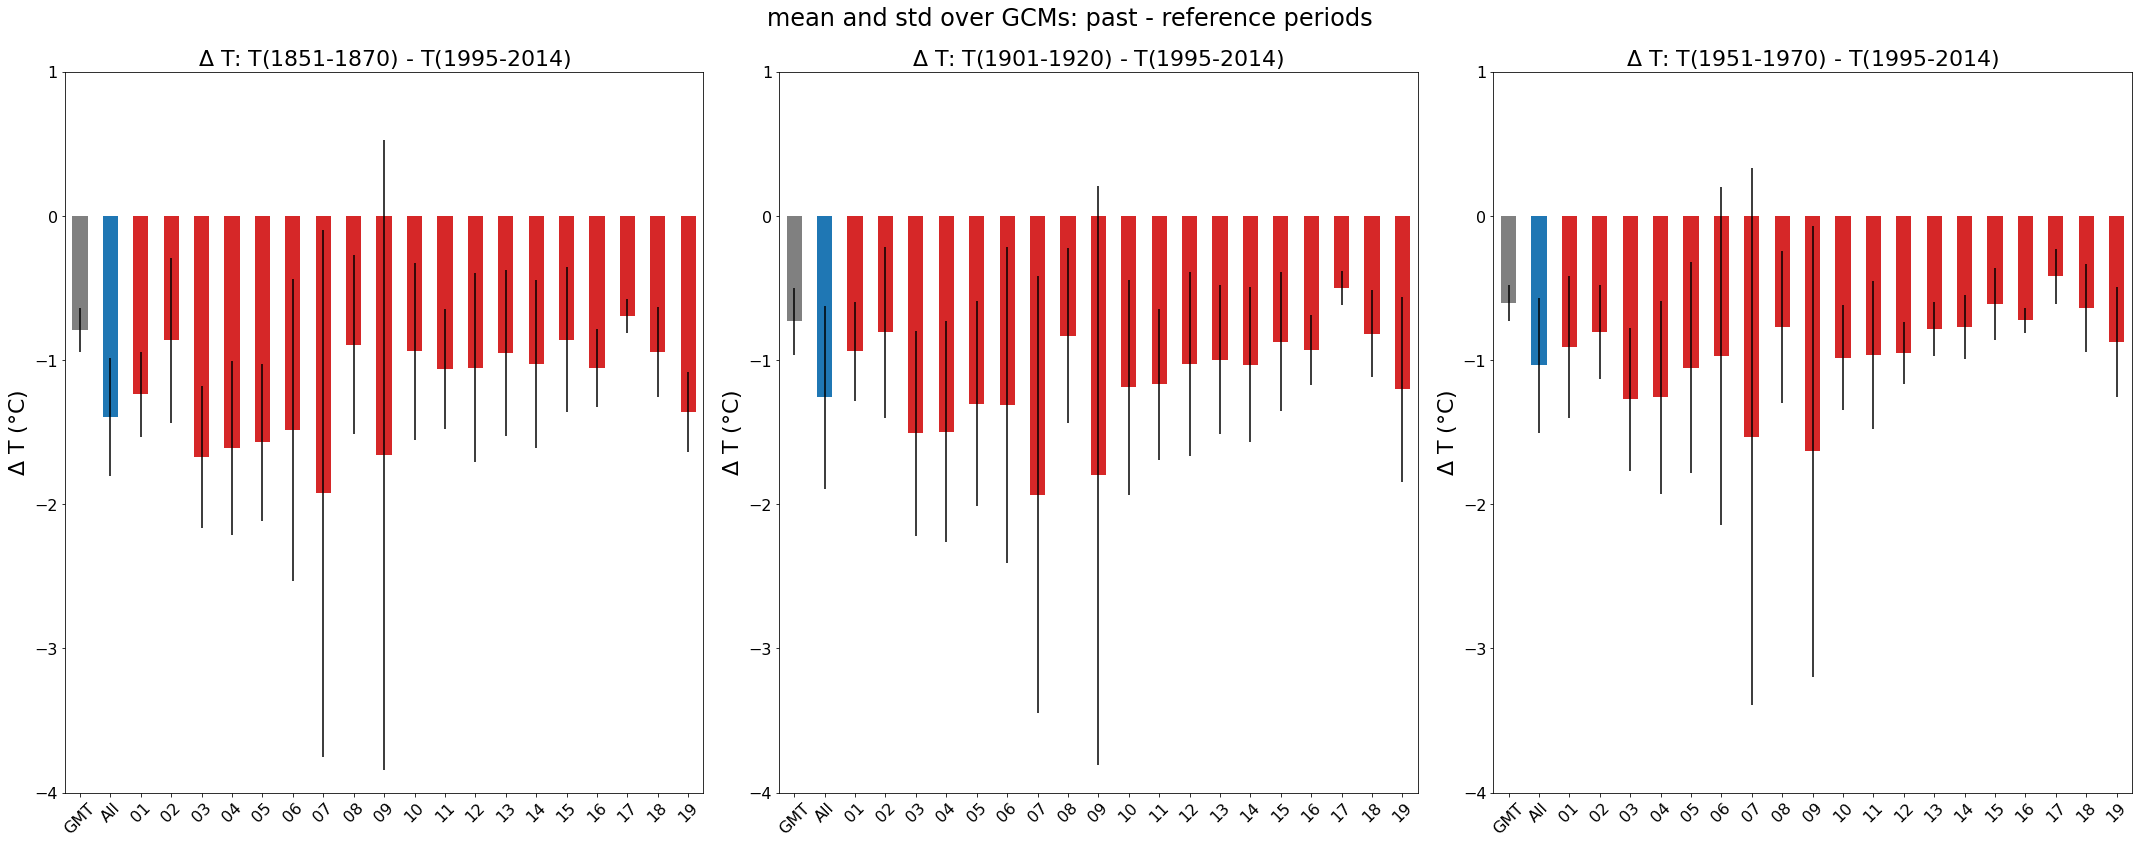

In [151]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(30, 12))

j=0
#for scenario in scenarios:
# for the past: every scenario is same ... 
plt.suptitle('mean and std over GCMs: past - reference periods',
                  fontsize=24)
for exp_time in exp_times[:3]:
        taf_d = taf_e[exp_time]
        #for gcm in gcms:

        #tdf_d[scenario].loc['frac_mean_GMT'] = tdf_d[scenario].loc['GMT_mean_diff']/tdf_d[scenario].loc['GMT_mean_diff'].mean()
        plt.subplot(1,3,j+1)
        ax = plt.gca()
        #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
        #plt.plot(taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
        #         taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
        #        label='mean over GCMs for that region')
        #if gcm==gcms[0]:
        #if gcm==gcms[0]:
        plt.ylabel('$\Delta$ T (°C)', fontsize=22)
        plt.title('$\Delta$ T: T({}-{}) - T(1995-2014)'.format(exp_time, exp_time+19), fontsize=22)
        #plt.ylabel('$\Delta$ T (°C):\nT({}-{}) - T(1995-2014)'.format(exp_time, exp_time+19), fontsize=22)
        #plt.ylabel('$\Delta$ T (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=22)
        #plt.ylim(-0.5, 18)
        plt.yticks(np.arange(-14,22,1))
        #maxi = taf_d[scenario].max().max() +0.5
        #mini = taf_d[scenario].min().min() -0.5
        plt.ylim(-4, 1)
        #plt.minorticks_on() # (np.arange(0,19))
        ax.tick_params(axis='x',which='minor',bottom=False)
        #if j==0:
        #    plt.legend(fontsize=22)
        yerr = taf_d[scenario].drop('GMT_mean_diff').std(axis=1)
        taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey'], yerr=yerr);
                                                               #label='mean and std over GCMs');

        j+=1
#plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
plt.tight_layout()
plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_expfuture-ref_mean_std.pdf')
# plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_mean_std.pdf')



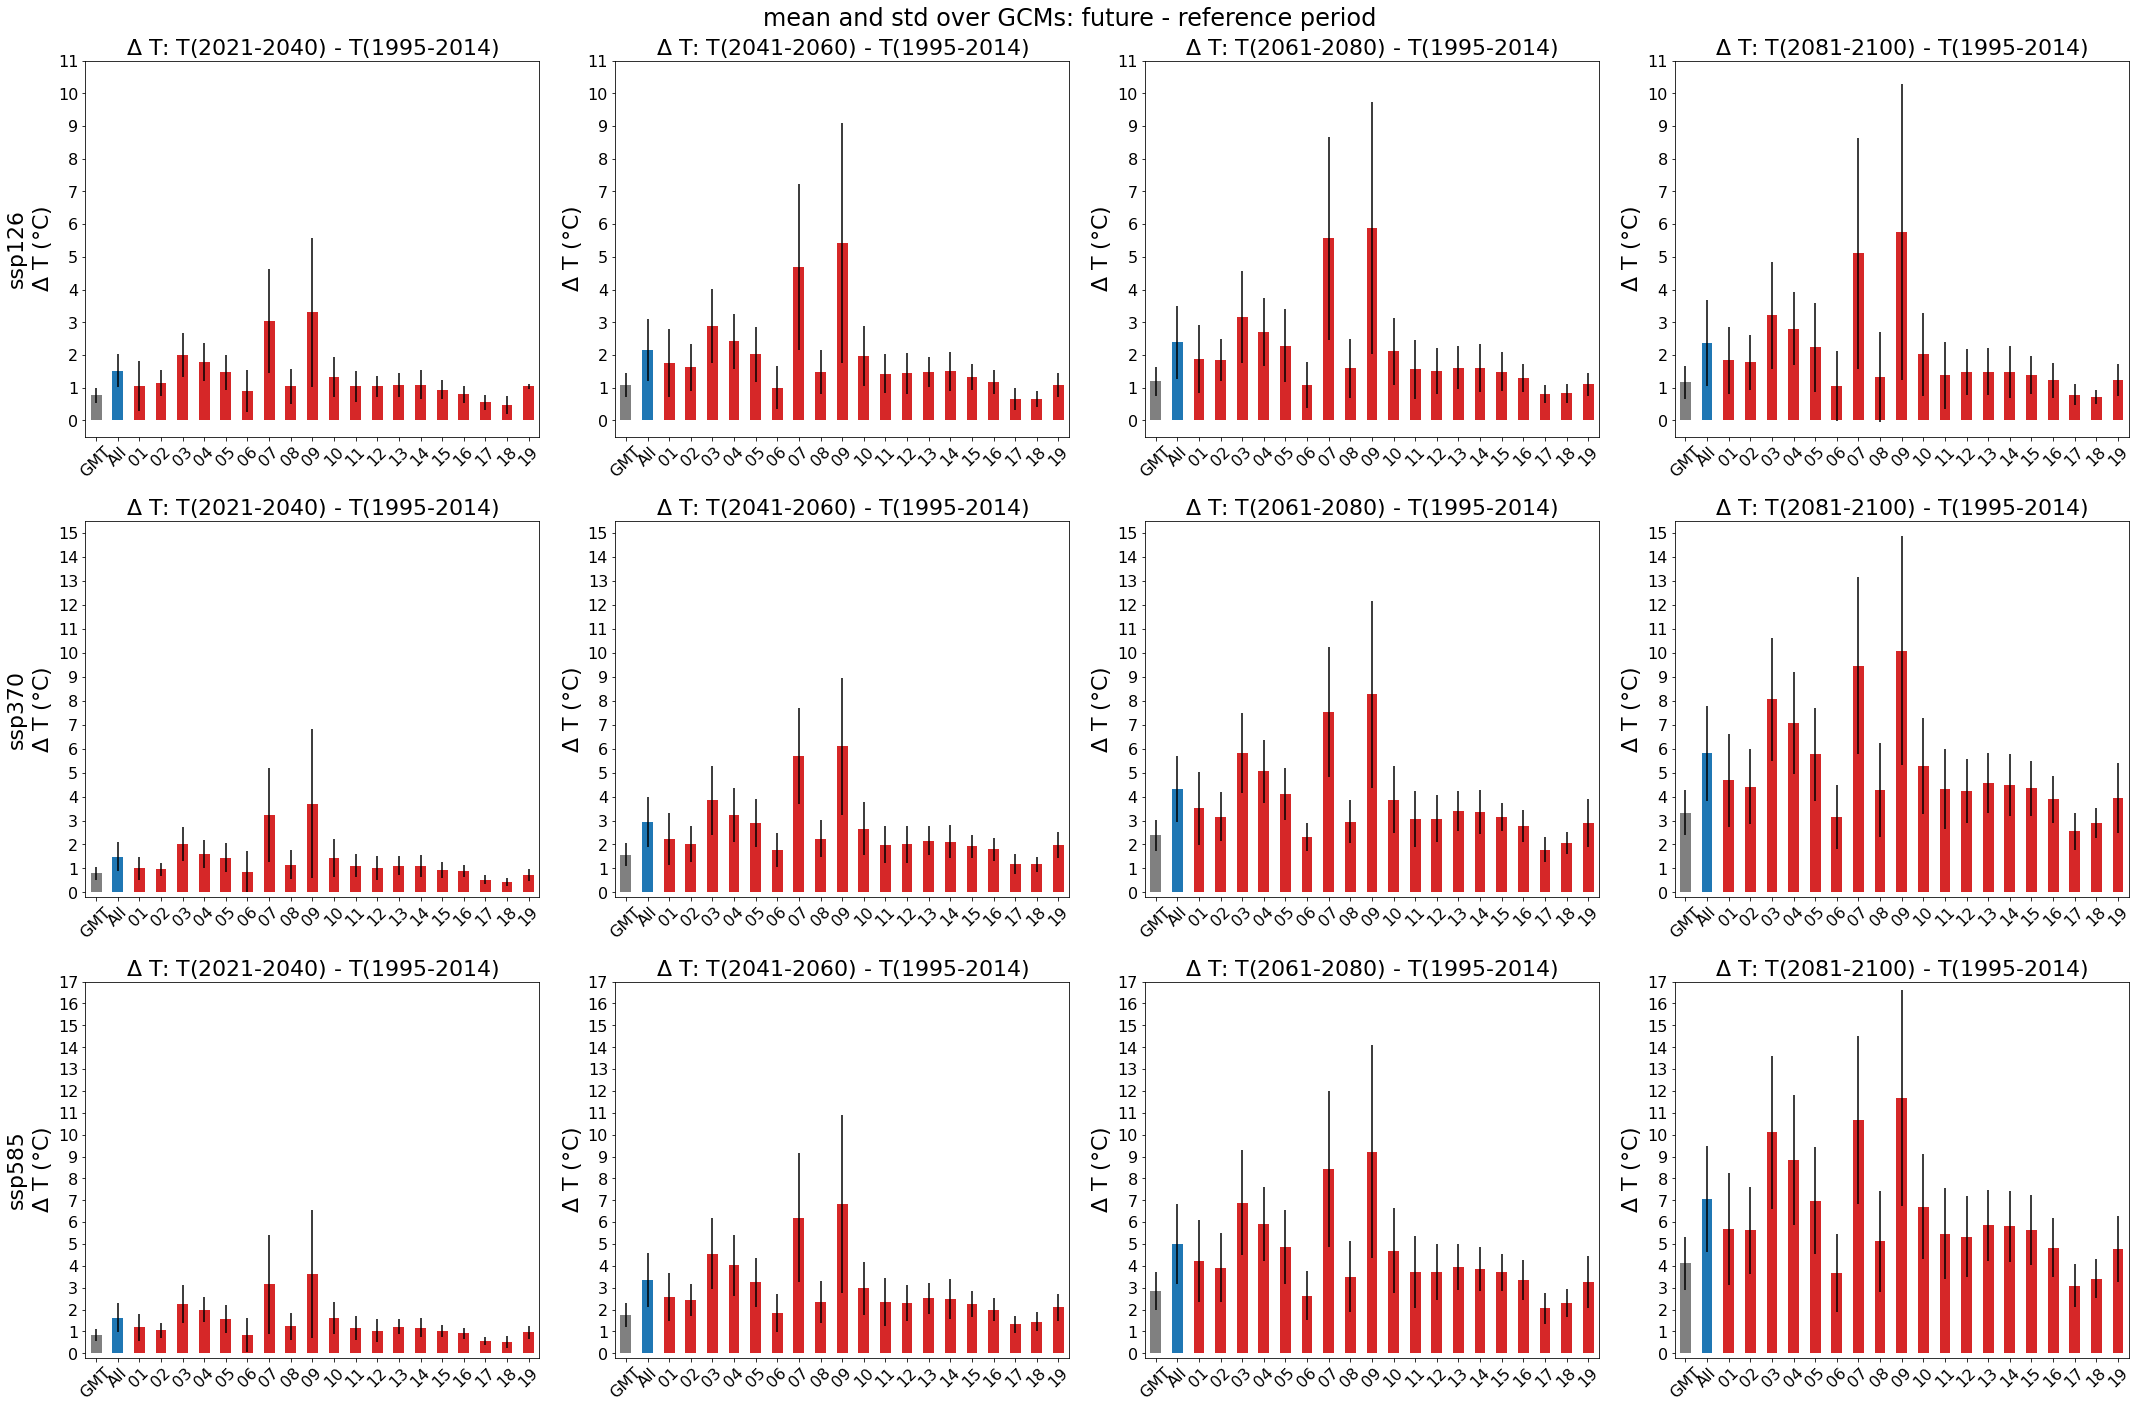

In [160]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(30, 20))

j=0
#for scenario in scenarios:
# for the past: every scenario is same ... 
plt.suptitle('mean and std over GCMs: future - reference period',
                  fontsize=24)
for scenario in scenarios:
    for exp_time in exp_times[3:]:
            taf_d = taf_e[exp_time]
            #for gcm in gcms:

            #tdf_d[scenario].loc['frac_mean_GMT'] = tdf_d[scenario].loc['GMT_mean_diff']/tdf_d[scenario].loc['GMT_mean_diff'].mean()
            plt.subplot(3,4,j+1)
            ax = plt.gca()
            #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
            #plt.plot(taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
            #         taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
            #        label='mean over GCMs for that region')
            #if gcm==gcms[0]:
            if exp_time == exp_times[3]:
                plt.ylabel('{}\n$\Delta$ T (°C)'.format(scenario), fontsize=22)
            else:
                plt.ylabel('$\Delta$ T (°C)'.format(scenario), fontsize=22)

            plt.title('$\Delta$ T: T({}-{}) - T(1995-2014)'.format(exp_time, exp_time+19), fontsize=22)
            #plt.ylabel('$\Delta$ T (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=22)
            #plt.ylim(-0.5, 18)
            plt.yticks(np.arange(-14,22,1))
            #maxi = taf_d[scenario].max().max() +0.5
            #mini = taf_d[scenario].min().min() -0.5
            #plt.ylim(-4, 1)
            if scenario == 'ssp126':
                plt.ylim(-0.5, 11)
            elif scenario =='ssp370':
                plt.ylim(-0.2, 15.5)
            else:
                plt.ylim(-0.2, 17)
            #plt.minorticks_on() # (np.arange(0,19))
            ax.tick_params(axis='x',which='minor',bottom=False)
            #if j==0:
            #    plt.legend(fontsize=22)
            yerr = taf_d[scenario].drop('GMT_mean_diff').std(axis=1)
            taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).plot(ax=ax, kind='bar', rot=45,
                                                                    color=['grey', 'C0'] + ['C3'] * 19+ ['grey'], yerr=yerr);
                                                                   #label='mean and std over GCMs');

            j+=1
#plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
plt.tight_layout()
plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_expfuture-ref_mean_std.pdf')
# plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_mean_std.pdf')



## gridpoint temperature warming per GMT warming for each experimental period

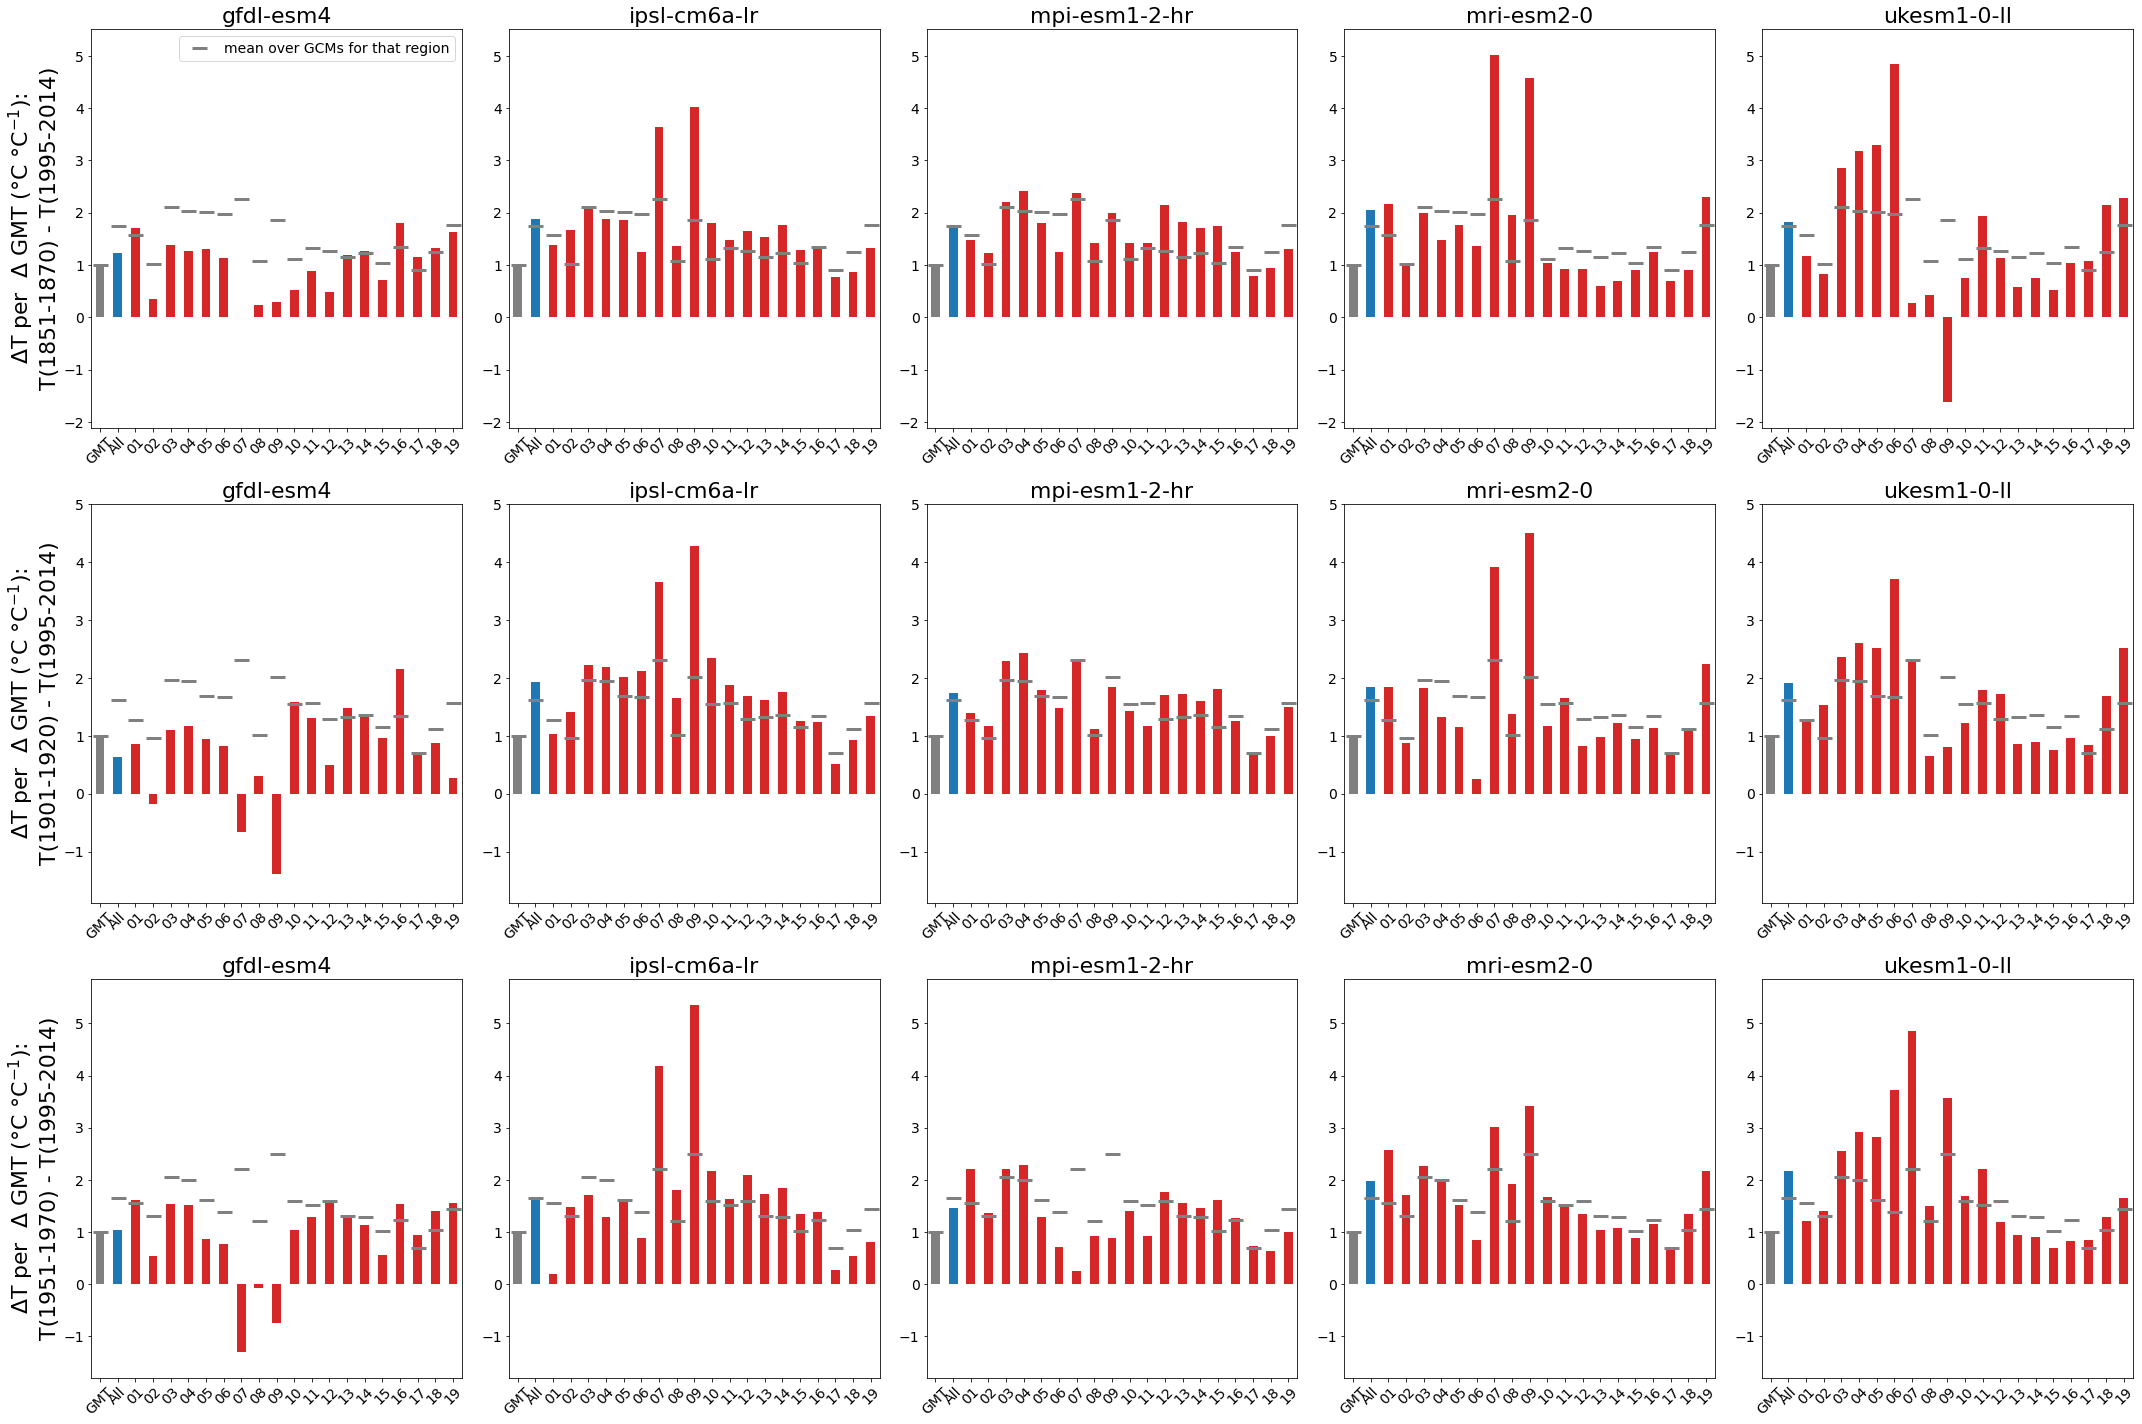

In [157]:
plt.rcParams.update({'font.size': 14})
scenario = 'ssp126'

#for scenardata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACF4AAAb4CAYAAAC8hIXiAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/Il7ecAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOzdd5xcVf3/8dcnJtSQBRGkGzSUIEgLRYoERCwYAUFFRAiiqChWRCw/BRQEQRQVRRQEFUUBASOCYklsiBRRhIQviqAiiAWC9Pb5/XHuJpPNzO7M7uzebPb1fDzmsdnbzpmZzbzn3vnMOZGZSJIkSZIkSZIkSZIkqXPj6u6AJEmSJEmSJEmSJEnSaGXhhSRJkiRJkiRJkiRJ0iBZeCFJkiRJkiRJkiRJkjRIFl5IkiRJkiRJkiRJkiQNkoUXkiRJkiRJkiRJkiRJg2ThhSRJkiRJkiRJkiRJ0iBZeKGlXkTsFRG/ioj7IyKr2xZt7De92nZ2n+WTq+W3D1OXR4WI2DQiHq0eiz/W3Z+REBGzG/6Gmt2u6Gff7SPi2xHx94h4LCIeiIjfRcRHImKlFvvcPkB7ZwzfvZXGjob/a5NraHupyZSI2C4izouIv1X58O+I+G1EnDSCfciIyJFqb0nV8B6mv9v2LfZdPiKOjohrI+J/VWb9IyK+GxG7tNhnZhvtrTG891oSQEQcU/2fO6buvoyUiNgoIt4ZEd+IiHkR8VT1GOw3hGNOiIgXRsSnqtfD+6vXwzsj4sKImD6EY5tVbRhKtkTEKhFxQkTcGBEPVu9L7oiIr7e6FtDwf6fV7ZFhvcPSGNfwf/6cuvsyEiJiXETsEBEfj4hfR8S9EfF4RPwzIn4QEXt3oY2XRMSPIuK/EfFQRPwxIj4UEct24S4s8YZyTa167GZFxN3V8zI/In4TEe+KiGVa7DNQZh09fPdW0lh5jx0RK0bE6yLiM1E+83qwuu/f79LxN6rOq/7R8B76ixGx5iCP1zTfYym6HtqfhvvZ323/Fvs+LSLeWj3P91V5dE9EXN7qfUIM4Xqgumd83R2QhlNEbAlcWP36U+Cu6t//radHS4eIGA+cC0youy81+SFwd5PlNzbbOCLeAHwFiGqbXwOTgB2BY4HXRcROmfmvFu1dBDzQZPlVHfZbkoZFRHwEOAZ4Crga+CWwKrAJ8F7g/bV1bmz7J9CqKHCxzImIHmAOsDnwP+BXwP3AVGAfYJ+IeFdmntbimH+mPPfNPNxBvyWpE28F3tnlY+4CXFn9+27g58CDlFzbF9g3Ij6WmR/pcrtaXEfZEhHrAb8A1gP+DfwMeATYAjgQ2D8i9s/Mi1oc8/fADU2WP95RryWpf8+mvNeGco3yt8C91fKXAi+tPqR6Q2Z2/EFiRBwFnAQ8Ccyujr0L8HHg5RHxwsx8aIj3YbTo6JpalOLVj1a//pby+D0D2BnYDnh1ROyWma0K8s5tsbzpNUNJ6tAGwDeG48BRvmxzObA8cD3lHGhz4C2U85+dMvP/hqPtMeBBFn5O2ddf+i6oPn+7HNgdeJRyPvRvyvuElwAviYjPZOa7Wxyzo+uB6i4LL7S025vyd35CZn6o5r4sTT4IbAWcDryt5r7U4cTMnN3OhhGxMvA5StHFIZl5TsO6VYEfUy4CfpjWF4yPzMzbB91bSQN5IaWQ7M66OzIaRcRbKEVkNwL7NZ6ERURQLk6pHvMyc2YH27+fclJ9PfCizFxQqBoRh1KKCE+OiPMz859N9v9lh+1J6r7PA+dTLsqMFX8ETgauBa4DzqJ8uDQUT1E+qDktM3/RuCIiXgOcB/y/iPhZZv5siG2pf51my4mUoosfAK/q/WAxIsYBH6F8mPaliPheZjYrprgkM48ZWpclDcLFwG+A+XV3ZIQk5QtiJwNXZuaTvSuqD74uA2ZSPvT6aicHjohplNfCh4DdMvPqavnE6rgvAI4HWn1Ys7Rp+5paRGwM/D9Ksd2emXllw7rJlMK+51OKPj/d7BieD0kaZv8Dzmbhuc+WwJBHxY6IFSnnkcsDR2Tm5xvWnUL5UtW3ImLaYAoCxb87zIc3UIou/grsnJl/7V0RES8Gvg+8KyK+npnXN9m/0+uB6iKnGtHSbt3q56219mIpEhGbU4oEvkvrKj0ttB2wAvB/jUUXAJn5H+CT1a/PH+F+Sapk5p8zc16Li+/qR1VAdjLlot7L+1a+Z/GbWjqnwdi1+nlKY9EFQGaeBfwfpUhp65HumKT2ZOa/q0wbM4UXmfmVzDwqM7+TmX/u0jF/mpn79S26qNZ9Gzin+vXAbrSnrurNso83fps7M58CPkYZJWNVyrcFJS0hMnN+lV93Dbz16Fedg74wM69oLLqo1s2hFE7A4HLmaMqXf07qLbqojvsAcAiluPDw6otCWtQulM9LftZYdAFQFW98ofrVa3iSalHlx6GZ+cXM/C1lNIRuOARYg/L69/k+695PGYVuK8qoTBp+vec0ZzQWXQBk5g8pxZsAThuyBLLwQqNGRGwREZdGmZvwwYi4rprCYbE5vKKan5USGABfbZjD6Jw+x927mifpgShzKl4ZLeYw79L9WDEijoqIa6LMFfxwRNxU9Xlik+2fFhFviTLn4/wocwv/MyKujzLn8Gp9tl/wWFRzaF1bPV53R8RZvdtHxHIRcWxE/F9EPBIRf42I4yOi5fQh1bpzKJWVh3fzcWnS1rYRcUGUeZR751P8U0R8MyJ267PtclHmo7++eh4fjYi7IuKqKPNlLtew7YL5wyJifLXf3Oox+GdEnFsNT9st7b75GTMXx6UlTSyc+3Vyn+Wzq+XTI2LXiPhxlRMPRMQvI+IVLY63cpR5xW+KMpfuIxHx9+p4H+hy31eMiCOr17v7qky5rXr9fFmr+xkRMyLiF1UO/SfKfPXrV9uNi4h3R5kX/aEqP06PiJWadGEmMBG4sO+JwAD9Xi0i3hkRV0TEX6rHaH6UeXPfFhFPG8rj0qS9xvu+d0T8rHouM1rM9d7BsdvOoGr7TvLtnKqPM6O8D7okIv5dPc/XRcQhdJeZJQ1CDMP778H+/4/qPCjKMNmDuS9Tqz73vjbfW+Vfq8xbKyI+X72OPVLlxl+r1/fD+my7YH7fiFglIj5bbftwlPfjb2nY9rkR8Z0o788fjojfRvlmz5Lid9XPdYZykIh4TZUXD0TE/yLiJxGxU4ttG//ODo2Iq6sczxjih2fR4XuXiNgjIi6LMsfw41HO0edFxNkRsVWfbQf1fmoIBsqy3usGZpnUxAhk2vOivBe+OyKejIh3NbS12DW7Dvq9bkScFhG3VLlxf5RrfTMjIpps3/brXiycL312db8/VuVe77nXh6M6f6n6cVaU9/qPRDmnGkzxxKByJiKWYeGHYuf1XZ+Zt1Gm2FgGeFnf9YPVYS4M9rFfMSJOrB7zRyPibxHxuShfBugWz4ekGkXDdft+tlnkc6A2jrlslOstGeXzlWc0rBu1n9MMg72rn82y40nKaBiN2y1xBvH8bBTls6A7qm3/F+X64cURsW+fbRecZ0fE+hHxjerYj1R/M++NMj1It5hHo5hTjWhUiPJBxGXAcsA8ypyrawBnRsTUJrvcQJlTbyfgOZR5E/9UrVswP2wsnPMQ4NfAHcBmlIqxz3X5bhAR6wA/pMwN/C/Kyc4jwDaUIU/3iYjpmXlvw25nAQdTvpnTO5fTM6r79R7gAprP034S8C7KXO1XADtQhiiaFhE7Vv2YWq3/E6Wq+4PAasBhfY9X+TBlWoyDM/OfLR77vv3ofSO0awfTc7yI8nxPoJxs/qr69zrAfpT55n9abTuu2nY3ypCUc6qfzwQ2Aj5EGXL57iZNfRt4OWW+xt9THqODKHNkvSAzb2nRxX0iYh9gWeAflErQxb4NV7mO8pxtGBEzm0w1clT165dbPiDwhmrboAwv9cPM/F0/20vqrn2AtwM3UebXexawI3BpRLw3M0/t3TAiVqC8Zm0C3EOZTuhBYM1q2fbAJ7rRqYh4FuW1fCPKnLW/pLz+rUu52LYaZZjtvg6nDBH4S0o+bEOZr377KKManUG5CDcbuI0yFO3hwBSg74dee1Q/f1GdlL6GMsxhUqYeuaBPpvV6MfAZ4O+UUal+Q8n151NGCnpRROwzDMMXvpfyXP6W8lyuS/nGF7FwLt85mTm9nYN1mkGd5Fsf2wFfpEyHcyWwOiW3z46ILTPzHS26+MyI+CiwNuXv8Ebg0mrEpWauqI57ZET8sM9UI28ANqz6fW2L/adExMer/t1PmbLke9W366Sl3jC9/x7s///B9H9/yjnUMpTM+37Vt52BF0bExzLzIw3br0l5r7sG5TzqCsoForUpeTcZOLNJUytTzoMmUbJoVUrWfDEieijDqv+oOubPKCMTbANcFmVO9Z936z4PQe9oCYP+ZnZEHEfJiV9SsuF5lDzZqTonbDX3/OcoufwrynO0IVUxQZQPLA8Gzm13aNlO37tExEzKsPdPAVdTnqeJlEydSRkdqdlwt22/n+qj02y5Angz8OGIaJxqJCjDx69Q7X9Pi/23qv4vrwL8t7qPl2XmYy22l5ZKw5RpO1LONe6knGusRBk5b6h93ZUyVUlP1ZcrKK9L21Ner3ajXOvp3X6w52zLULL4uVX/b6Xk18eAtaMMxf6r6j79gpKHOwFfj4jMzMU+zOrHYHNmI8rr3H/7GQXqGspzsSXwzd6FUb6I0DvP/PodTM8xkzZzYYiP/U+ATSnnS9dT/ubeDrw4InZuMRUidHZN7WfAY8CuEfGiPlONPIsyxchTlGH+Wz0e76WcOz9J+Yb4ZX1HhpQ0MqIUJ19Ceb24GHhdZj5crRvtn9N025bVz2tarL+mz3bDpiFX7sjMyR3s2vbzExGbUfJoJcrnjbMo51RrU65ZLk+ZerKv9SnXxB6hvBeYBEwHTqGcx+1bjbTX14pRigsnU86Z51HOSf7e4r5cUd2Xt0TEeU2mGtmV8rlUs+u+0Pn1QHVTZnrztkTfKCcM/6C88B0LRMO6HSijL2T5c15s33OqdTObrNsSeIIyb9+MPuve13tMYHafdZOr5bd3eD+CUtyRlKKO5RvWLQ98vVp3TsPyZ1XL/go8s8kxtwBW77Ost993A1Mblq9CeUHv/TDsF0BPn2M9TjmBeFaLx+tx4AcNy6ZXx/tjP/e7tz/TO3isflrt89om61YFtm74/QXVttcBKzZ5zHcEVmjy/CXwT2CThnXLNDwPv23S9uyGffvefgms2+L+vLTh7/QPlIKPy6tldwGHttjv9n7auwRYpe7/n968LQ23hv9rk/ssb/w/f2SfdTOq18QngOc1LD+o2v77wPg++zyNMsdu47Le16TbO+zzOMrFpqavB5QThxe2uJ8PATs1LF+u4b7eSMmKtRvWrwf8p1q/c59j9ubzkZQLbH1fq+6lzI3bt/9Tge2aLF+T8sF+Aq8ZxHPZ6v1A731/vFl/qm2OoUnuD9BepxnUdr5Vy85peCxPA57WsG47ygdQCbysz37TmzwXvbcHKfN1Nrs/y1V/u1kd+3JKZt1IuXB4GbBGk/1m9tPef4H9hvv/sTdvdd4a/t679v57CP//e1/LjunwPjyPcgHof8BL+6x7LuV8JCnF1L3LP1ItO4OGc7Rq3bLAC/osa3ytuABYrmHdS6vl/6O8Zr+3z74nV+t/0sZ9mV1tOyyvPZRCk/uqNmYMYv/ex+A/LHpeM45SqJLAlf3sdx+wbYtj9/7dnNNBfzp973Jbtf0OTY61Dg3nV32ej7bfTzX5e2k7WygXV6+utvsX5SLqhZQPSB+jnO+t1GS/Y/pp72/ALsPx9+TN25J2a/i7H65M+zgwrkm7vf/nz+mwv2tWrwlPUD6gaLxmuC4Lzy1mNizv9HVvekP/+97vzavXlieBmynF5Y2Z/bZqvz91cJ9WaHitbfq+vZ99X1Ht97t+tnl3tc2FfZZPbrifkztos+1cGOJjfwuLnqeuRCncSOA7Tdq+vZ/X9UtocU2N8mHoY9V2V1O+5f1jyvuk22iR/f209RTly1bLNdvPmzdvC2+0cY2s9//WQMspn6vcVC3/LA3Zwyj/nKZPGzN7X1eH8LhPauhrT4tter9k9e8Oj93bv3P6LG/5XDfs0/LvoMk+HT0/lAK6BD7QZNuJwPP7LDum4TG6kEXPZTegfLEsgcNb3M9mt8eA4+lzLt3wN/rlartHKIWf51O+SJaUopGNmuw3vZ/2Wl4P9NbdW+0d8OZtoBsL35TfQvOTs5N6XzyarDuHPidYDevOavai37D+2mr97D7LW4bCAPej92LiVS3ux4qUQoDHqd78UyosE7ikg3Z6X0gPa7LuXdW6J2kI+4b1l1brD+qzfBlKwcD9NBQX0F7hxbzq1vTiYIt9et8UrdzGtq+qtv1Mm8duDLu3N1m/MuXbygns2GfdxygnYBtQ3oStB+zPwpPMW+jzwVvDvltSqvz7Bt6FwFYt9vk85dvjz6Z8GPYcSpXrP6t9f97sb8mbN2+d3Ri48OKaFvudW63/csOy3sK9d7XZ9mAzZe9qv7/QcILY5v08oZ/jJbBHk/WnVes+0mf5Iyw8WbiNUhU+ifLt294Pjx6mz4cwA/TzRdV+FwziuWz1fqD3vp/Zz75vr/Lqax2012kGtZ1v1fbnVNv/HVi2yfpjq/VX9lm+JXAq5Rt2z6ScNG5JOWl7strnjS3aHE95b/VUn7z6O6XAZkKTfV5MychtKAUkPZRvq32Xhe87Xtzp8+nN22i5Nfw/6eb778H+/z+mWn5Mh/fh29V+b22xfr9q/UUNy06vlu3dZhszq+3vB57RZP0N1fpfN1n39Grdo81eh/psO7vatuuFF9VrZO+HPD8e4t9Ls3ORZ7Lw4tqEFvt9sJ9jf4KSZZ/ooD+dvnd5ELi3g+P3Ph9tv5+qlg86Wyjn1r3/hxpv82idf68HjqZ8iDqJUsCxa0P/H6RPcYg3b0vjjeHNtLk0FCX02aY3I87psL+91wRParF+WrX+uoZlnb7uTR/gfl/CwnOzZfqsG8/CIvb12myv9/G6iSbvAQbY94Bq31/2s82bqm1+2Gf52iy8hrd2B222nQtDeOwTeHmT9VMoRTdP0ufLUAzhmhrwQsoHpY0Z8iTwFWBKi32+QSkoXK9qbyPKKLe9xbLf6OS59OZtLN7oUuEF5frHPyjXNd7bZNtR+zlNk+1mVtsNpfBirYa+jm+xzQbV+kc7PHZv/85p97mmjJQ3jzaK7hv26ej5oXyxKIEt2tz+GBaeE6zeZP0h1fpb+yxfE/gSsHv1OC9PGb3pRMq5bQIf76fdd7OwGLD39l/gOJoXkw/6eqC37t1q74A3bwPdWFggcVyL9Zv3E7jnVOtmNln3p2rd7i2O2xt+s/ssbxkKA9yPz1X7HdnPNr0v+HtUv69EeYP+OGV4qWe10U7vC/BiJ3SUaTUSuK3FvqdU64/us/zj1fK39Fk+vVresvBikM/5V6vj/oDybeGmJ+bVts+hnGT9jzLk7mIVjS2ev6TFB1+Uk6UEPtRmf3sowwc2fX6Bt1QB+SPKNxR7h1x8R/X8PkyTDzr7aW89yrfIE79F7M3bkG8MXHjxrhb77U6fN9UNr4t3AQe2ep1p2H6wmXIGA7w57+d+vqDJuk1ZWECx2GsupSghgTP6LO998/84zSute4fqO7fJuvGUqUo+ShlG/6uU3L6o2uf3g3guW70f6L3vL+ny306nGdR2vlXbn0M/hR2UC41Z5UjTk+Mm+xxR7fMf+lzIpZwQ/oZSgPj2Kqt6h2nu/aDxyoH63eeYn2IY3it487Yk3WBY3n8P6v8/gyi8oIy0MJ9yYXK1FtusVh33Hw3LDq6W3UIp4GtagNyw/cxq+5+2WH9htf4jLdb/u1q/2Mg7fbabzfAVXnylOvZfB+pHG38vk1us/2+z+9mw38Zdvk/T6ey9y8+q7b9GuYi32De0Wjwf72qxfrH3U230uWW2ABtTCt57788alPO13SgjVCVwdoePUe/f5qAvaHvzNlpuw5xpJ/bTbm9GnNNhf2+s9pvWYn1Q3qs/SfXt1EG87vVuP9D9bvrawsIvdm3fxv35f9W29wHPHcTzN+jCiyH8zbSdC0N47O/tZ5tfVtu8rs3+9ntNjVL09xRlGpbnUUYgeTblPdZjlPOoLTp4fLainC+3/Dv15s1budGFwgvgJdXr/iPAq1scY9R+TtNku5ksZYUXg7wPHT0/lGuRSbkG9iIGKHRk4Xn2JS3WL8vCwoa2ihcpxXpZZctafdZNoowO9ShlpMlnV3m0OWXki6R8cWGx4ot+2mt5PdBbd2/jkZZ8a1c/72ixvtXygaxT/fxLi/W3d3Kwai7HZ/RZ/O/MPLL697OrnydHxMkDHG41gMz8XzWn+tmUYYeOj4g7KdWYlwHnZ+YjLY7RbH6oB/pZ17h+ud4FEbE18H7KBbMvDdDvbvkAJUReWt0eiohrKUO0fz0zb+vdMDP/HBHvprwZOR04PSJuowwXdilwcWY+2aSN+zLzvhbt3179XKfF+kVk5vyIOI3yjfCXVX0BoJqn7YuUiwF7Zubj1aoHgM9GxL+B84AzImKDFn3t295fI+KrlIrHl1EuBEoaPgPlxILXisycHRGfpIwM8HUgI2Ie5WLQRZn5w3YabCNTnlX9nNfO8froLx/ubvE6tFg+VP5H+RbyLzLzlib7nUE5mdy1cWFEbEj5ZtjUfvo5qc8+5zTZZl5mntjPMfoa7HuGpgaRQW3nWx+t/gb/SrkouBzl28Ct5jVudDrlpO0ZlGLAnzesO7da9trMPL9h+W8i4mWUD6x2p4xG9tU22oJSvPlO4LkRsV42zEspLYW68v67jyH//4+IjSnf5O/rksy8pNq/9zX3nohodSiozlMqX6cU0B1AmTP5yYj4I+V15fzM/HWLYwz0WPS3flVaP1ZtayNnm+1zGnAo5RuwL8zMu4d43Favh/dThh9udT+7nWWdvnc5nHIR8PXVbX5E/JZSoPe1Zo9Lpe33U21omi0RMZ5SwDmFMnrhVQ37/DQiXkSZCuCQiPh6Zv6szfaOA/YFXhQRExrO6aSl2XBkWkevXxHxDBqurzT4ZWZ+pfp377W2awbILygZcucQztmGkl8wQH5FxHsorzcPUKb9uqnJNkdTCswWkZkz+7S1Yj9NTax+/q+//nSg7VwYwmN/ez/t304pam/3Gl7La2oR8Trgw8AVmXlAw263AcdERO+w8KcBu7TZ3vURMYvyDe6XUQpxJA2fWZQv+rwmM7/TYptR+TnNYEXE3pRC+b5OzMx5DW1ByY/5TbZdLDsiYifgjU22/Upm/nJQnR2kQTw/JwM7U0Y4+hHwaETcAMyhjFB0Y4ummp7TZOajEXEX5bPMdYA72+jzrIj4HaVocXdKAWOvTwF7UqZCabzu+Xtg/4hYhXIufiSliKQd/V0PVBdZeKHRJFssf2pEe9Hafiz8IKzXHZQXPyhzFUJ58b59gGMtOBnNzAsj4sfAXpS55Hes2tqP8qZ/58z8W98DZGZ/j0snj9kMymvFM4Gf9TmRXbn6uX5EzK7+/cbM/FMHx19MZt4dEdMole0votzn7Sj3/8MR8ebMPLth+89FxAWUNxA7VbcDq9sNEbFLZt4/lD61offDz7X7LJ9Z/bygxQW6Cyjf/lif8qbv1iG2J6lmmfn+iDiD8rq9E+U17E3AmyLiR5QirCcGOMxAmdIqE9vRrXyAcsLxdFp/mNK7fI0+yy+kFF18D/gkZdjh+Zn5ZFWUcQvl22mNDm5y/DmU4fna9XAH27alkwzqNN+GQ2Y+FRG3Uk60FmRIRKxd9ekxmhT0ZeZjEXEhZXSU3Wmz8CIz742IeyijaaxN6w8apVGvi++/u20Nmr+G3k4pgus9T3mSMvJbW6r7+7qI+ASlyG7H6nYEcEREnJ2ZhzbZdaDHYiQeq4FydhER8SnKaHX/ohRdtHrP3vZxB/h7aSkzhyPL2n7vkplzq2KeF1NGkdiRUmD5IuCjEbFvZl7R7T726W+rbNkO2ITyzcGrmuz334i4nHKOtjvlW9rt6D33WoaSn3cNvvfS6DBMmdbp69dEmucXlBGIYGGGfZvy7eb+PNr7j0Gesw1bfkXEEZQPWR6mTKmx2GtY5SU0/8B/ZvXz9urnev00t26fbYek01zo0vnyUA10De+bLfY7j/KB3k4RsWxmPtpiu3bbk9SBiBjXxmZfo0wV/vGIuKrZ5yaM3s9pBmsLmufpOZQvNN0fEfdSir+fRZlyvq9m2TGlxXFnUwrqRlQnz09mPgTsHhHbUbJ1R+D5lPOJoyLio5l53Ah0ex6l8KLx+tzTKIWMUHKnmW9SCi92p83Ci1bXA9V9Fl5oNPhH9bPvBaxekwd53DspH3RPpkwTMaTjZuZA2/eG7gWZeXqHx76P8i3UcwEi4jmUeZl2pcxneUDLnbtnKq2/mbwCC0/8JrbYpiPVG5KfVjciYkXKsOcnUr5RfGFjMUVVQX9GdSMiNqdUz29B+YbfB/s0sXJE9GRmswrOydXPASsTG6xa/Xygz/Lek91m7ZCZj0fEg5Qilqd3oT1J3Td5gOWLvVZk5l+Az1S33irwb1HeFL8BOLO/BtvIlN4PGDYaYLvhdj2wNQtfk/rq/dbvgteq6qLcZsA9wCubjLAxpdmBMnPAr7DVpZMM6jTfKpNbNL0eZYqARyhDBbarWYb05tWD/VzovK/62XZeVSeMPU3ak9SeyS2Wt/3/PzNns3gxW6N/Uz7oWR54e2Z29H81M/8I/BEWXAx9GeVC0Bsi4tuZ+aNOjjcS2sjZBapv5r6H8jjvnpk3d+O4S5pO3rtUBeXfr25U37j6KGUUirNofiFvcoume5e3fe7VT7b0e+5Vua/6OZhzr77tSRpGmXk7/ecXlGttU4CPNRshYoDjD+mcrVsi4m3AZymZ/orMnNNq28ycPsDh5lEy/ekR8ZzMbHa9c9vq5+8G0d1W/eooFwbx2E/up/nedcN+DY+FGTKOch2vnREH+2tP0qIeq362+nyh1edDjd5IeR18G/DziHhhk9FFR/vnNB3JzGMoU2X053rK6A/b0LzwYrHsyMxzKMUbS4xOn5/MvBq4utp2mWr9lymFGt/OxUf3ndys3WrfNatfh5pHq1OmLoGB86iTc5pW7anL2qkQk+rWO+TNq1tUNb52kMftPZF5XYv1rZYP1uXVz1cN9UDVidPx1a+bD/V4A7R1TGZGsxsLh46/qWH5DcPUjwcz8yTK8FvLMcCHjZn5e8rQf9D6MVrsOY6IHso39qBUZ7br1dXPa/os7y0c2r7ZTtUHkCtXv97eTkNRhh3Zr0V7krpvoJyYPdABqiH2zql+7cbrdu8QrAdGxJCHHRyC71Y/nx8RKzRZv3v1s3E41d6Tgn80KbqA7ufviGszg3q3bSff9qtO4vrqfax+1e63wqqikA0po6Y0Pi+9ebVKNepIM8+vfrYa4aSZl1MKNP/H4KbGkca6rv3/b6Xa/8e97Q3xWE9l5vcp0y3BMJ+rDLeIOBF4H2Uu+BdlZrOLkEulTt67ZOa9lMfpKWCtiFityWZDfj/VoFW29GbZxhGxcot9e8/LOsmy3nO9WzKzW0PzS+qObl5r6/Y524Ai4i3A5ymjceydmT8eYJd+ZeZjLHxMml3zejblPf1jlKHXh0WbudC4/UCP/cpRpj5cRPWB2vaUc5u2hkwf4Jpav9fwWHg+9AClcLWd9pZn4XVGr+FJ/fsX5fVp1RavG4u9DvSVxdspU0lMphRf9L3OMio/pxlmvedvzbLjacD+1a8Xj1iPuqCT5yczH6uKSX5DKfx8XpPN9qimQuvrtZTP2/+cma2mj1lERKxBme4EFs2H/7BwlK6B8qjtc5p+rgeqyyy80GhwAaWCeGPgQ9Ew10U1FNDbBnnc0yknAK/v++Y9ynzt0wZ53FYuocyNvktEnBERi1WjRcQaEfGmht+3jIjXVG/S+5pR/ezqHL/dFhHzqtu2A2+9YJ8jI2LdJsunUSoHn6KqTI2I3SLiZVHm823c9mksfDPW6jH6SEQsGMUjIiZQPijrAa7LhrnIImJ6ROzS+PdXLV+h+hbc3sATwOf6tNE7XPv+EXFgn33XoMw7BvCzzPxnw7q9ImKrJo/BqpSKza0o8z8P65D0kgDYpsqFBarcOJAyLPvnG5bvExEv6FsoWL2O9xYhdON1+1LgBspJ5HlV0VhjeytFxAu70M5Afkh5s746cFr1Otrbh50p8+bCoq+Nt1JexzeNiBc0HiwiDmHwBZVDEhFvr/LqawNvvWCfjjKok3zrYx3gxMa/q4jYhvINbFhY5NG77h1VXvRt5/kszKVvZ+aCodIz8w4WnnidHRHP7LPvwSz84On8huUrRMRbI2Kxb6RExJ6UbwoAnJ7Np9yS1L+O/v8PwXHA45TX8v2bvOeNiNg2IvZoWHZQP+9Xey8ELdHnKv2JiI8D76d8m+hFmdm1bwYPl4j4RJVln+hgn7bfu1Sv+e9pcSF8T8o1pvtZ+A2sRp28nxpstlxF+dBseeCsiJjUsN+4iPgw5eLlE8BFDevWi4gDImLZhmP1/t2/Huh9PD/d5H5JqtfJlNedD0bE2/q+LweIiOdGxCsbfh+pc7Z+Vdf/vkD5cGWfzPzhALu060TKhyrvb7wWV72mnk15rf5C9a3gxv6s3XANr60hyDvNhSE+9p+KiN5vE/feny9Qpgy4ODP/2rBusNfUes+V3h0Ru/fZdwplZBIo35J/smHd66JJ8Xp17vddYC3Kl61G1QeW0kir3tf9ovr12MZzkigj47Q99UNmHgUcSxlxZ05EbNaw+hLG4Oc0A/gqcDewa5SRmBqdCDyHMtrF5X137LYqK+ZFxE862Kej5yciDo/FC3J6CxSf23f7BitQRqtdtmGf5wAfq37te33uTc0yNSI2oUy/vDxwVWb+pnddVUQ5q/r1s9XxG/fdA3hX9ev5fdZ1fD1Q3edUI1riZeaD1cWOWZRwfW1E3ECZq/gFlDe976ZcKOzkuNdVF15OAL4fEb+mvJhuRnlx/SxlHt9u3Y+nImJv4AfAm4EDIuL3lA9YlqNUm21CGXq990LSsygvng9FxPXVtstQ5n16NuUbPh/pVh+HSW+ANfsmdCsfBk6OiLnAXMpJ6LrADpSTthOrYd2hVB5+GphfPUZ3VW1tR/kQ627KMFJ9/ZXyBuuGiPgpZdimHap2/g0c1Gf7Lap27qqet/8Cz6yWr1r18dC+Q1tm5mUR8RXKMGdfj4gPADdT5kzbjjJ02j8o81k22hV4Z0TcThm6+X7KhfctgElVf/fNzHuaP4SSuuizwCkRMRO4iTL86I7VuqP6jPSzC2U41X9FxO8o1fo9lNeXp1O+lfmloXaoypRXAj8CXgm8KCJ+SXltWJfyWnEt0PZJyiD7kRHxWsqJ8Rspld/XUV4ft6NcBDs5M2c17POviPgCZXqNn0XEHMpr9WbAppQPNz4wnP1u4RmUzLp7oA0bdJpBneRbozOAw4EZEXEtsBrlb2085aLprD7bH0e5MHkDpfo9gA2q/gbwK8p7kb4Opcx3vyNwa0T8lvIt7+eycLqxT2Zm47fJlqFc8Dy1z3uVqZSiWSgXG5f09yvSkqrT//+DkpnXRsRBlA8gvkUp9riZ8p53NUqurE55TeudOuSVwLkRcSelGPA+yvvinYEVKdkw7B8wVB+sfKFh0SbVzxMi4sjehZnZ6ttCzY75CuBD1a9/Ao6IRWtRes3LzBM76/GwWpOSZWsOtGGDTt67LAN8CvhkRNzIwmLK51C+uJDA+1sU2nXyfmpQ2ZKZj1XHv5Ty97lLRFxDGW56C2D9qr/v6jP8/tMp8yefUbX3D2AlSv6tX23z+cwc8ns4Sd2VmX+rrrVdSCng+lBE3ES5trYy5RxjXeDbLBytb0TO2foTEVtUbQTl/fprIuI1TTb9d2Ye2WR5S5l5TUQcTcnsX1fXvO6j3O/VKUOqf6jJrhNYeA1vQpP1zXSaC4N97K+inFv+X3V/HquOtRpl+ui+HxIO9pramZSCkZcCV1aZ8CfKNejtq/t7E3BUn/1eBXwjIm6hnOc9TPmSxJaUa77/APbKzEeRNJCPUM4n3gpMr17Tn0WZ5vYEynWVtmTmMVGm+P4k5frTHpl5/Wj/nCYiLmbh+/3ewrcdI+I3DZt9LDPbHtkoMx+IiP0phRWfj/LFqFspo0RMpXxe8trMzCHfgYH1UPKokxF+O31+DqMUUNxGyYkHKK/1O1X7nZ+Zv23SztcpOfHniPgV5Zxh16qvsyhf9m70NuBLDRn5BCUjt6Cc089j4ZecGvV+MXwj4KaIuJry5fQp1X2Cct7+jT77DfZ6oLrIwguNCpl5ZUTsQJmLamfKm9dbKBchL6e8ELU1xFuf436ielN8JOUFazPKB1UvopwodK3womrv71GqzQ+lvKBuRvlw5j+UuZ8+xaIXJ39D+fBpF8oFpq0pJxd/q7b9XPUN1aXN2yjPwTRKcC1P+TBrFuUCc+M80bMoJ9MvoATPDpSg/CvlQvUXM/NfTdpIynNwNPB6SjjfTwmr/1fNJdpoTnW8aZS/ladTin1up4Tc5zLz/5rdmcx8U0RcTnnet6aMjvEo5eTw+8Cpmdl3bu5LKCeDW1H+RlahzPf5J8o3zD+XmZ3MFyZp8C6mvNZ8kPLmejzwa0pBwSV9tj2H8n91J0oRwTMoF7n+RHmtOKtbQ1Rn5l+qD5uOAPal5OPTKB/2f59SrT7sMvNPEfE8ysW7V1Aeo4eAn1I+pPhek93eSZkz8q2UeSIfpxTDvY9y0lFH4cVgdJpBneRbo6spJ/vHAi+u9ruR8qHUWU22P57y9/BcygWDFSgfnl5J+Tv8erNpXjLzDxGxKeWb9C+hfGN9Gcp7rO9V9+eKPrs9BHyc8jxuRDkpX4ZyEfV7wLmZ+V0kDVan//8HLTPPrz6kfgfltWqXatXdlMKKy1j4LRko5yO3U177plHer/6bMj/wOcB5IzTSzSTK++W+NhjCMRu/9TaN1qMhzqF8A2w0O4f237s8QHURnHKx8MWUD+fuBL4JfLaaJ7mZTt5PDTpbqmsHm1OybLeqr+MoFyrPB05r/EZZ5W+Ub81vQ8nzbat97qZ8WHtmZv60xf2SVLPM/FlEPJdyXrQn5QPyCZT/w7dRMvOChl3OYYTO2fqxMuUDECjX+zZusd0dlGuWHcnMT0bEH4D3Ul7blqM8Fp8FTuliAUCnuXAOg3vsH6M8t8dSzn3XomTC6cAxmdn3mvAlDOKaWmY+HhEvB2ZShtvfvLo9CPyeUrzz2cx8qM+u51bbbEE5D+tp2Kf3XO/eJvdLUh+Z+esoI7geQ/n/+yxKwdNBmXle9UXaTo53ckQ8RBmJ9acR8dLMvGqUf06zJeVxabQyi54T9TvFUzOZOScitqQUKLyQ8pj8k1IQd+wSPkpCp8/PhynTQG1HOZ+dRLmvcyjn3xfR3G2UXD2Bcq7RUy07G/hMZj7VZ/vPUYr5NqM8phMpn0H9mpIpZ2bmw30bqf4+t6CMbDGD8pwvT8nMK4GvZua3mvRvUNcD1V0xMgVK0vCpRsP4GvD9zJwx0PYa2yJiMqXa747MnFxvbyQtySJiNuUN+66ZObve3mgsiohzgIOBQ6p5JiWNEf7/19LC91OSpMGKiOmUEfnmZOb0WjsjSRqzIuIY4KOUApRj6u2NlnTjBt5Eql9ErB4Rfav4iIjtKd9MgVI1LUmSJEmSJEmSJEnSiLHwoo+IWCkiPhMRd0TEwxHx64jYpu5+iecBt0fEjRHxvYi4sJqr6SrKPPJfz8xWw/9I0qhiFkmS6mYWSZLqZhZJkupmFkmSOmHhxeK+QpmP7mDKvDs/An4cEWvX2ivNA75I+ZvdCdiLMo/VT4GDKM+XJC0tzCJJUt3MIklS3cwiSVLdzCJJUtsiM+vuwxIjIpYH/gfsm5mXNiy/Drg8Mz9cW+ckSWOCWSRJqptZJEmqm1kkSaqbWSRJ6pQjXixqPPA04JE+yx+mjLIgSdJwM4skSXUziyRJdTOLJEl1M4skSR1xxIs+IuLXwJPA/sDdwGuBc4E/ZeZGfbY9DDgMYMUVV9x64403HuHeSpKG03XXXffvzFxtpNs1iyRJvcwiSVLdzCJJUt3MIklS3drJIgsv+oiI5wBnAy+gBOr1wP8BW2fm1Fb7TZs2La+99tqR6aQkaURExHWZOa2Gds0iSRJgFkmS6mcWSZLqZhZJkurWThY51UgfmfnnzNwFmAism5nbAhOA2+rtmSRprDCLJEl1M4skSXUziyRJdTOLJEmdsPCihcx8MDPviohVgBcDl9bdJ0nS2GIWSZLqZhZJkupmFkmS6mYWSZLaMb7uDixpIuLFlIKUecAU4OTq31+ts1+SpLHDLJIk1c0skiTVzSySJNXNLJIkdcIRLxbXA3yeEp5fA34JvDgzH6+1V5KkscQskiTVzSySJNXNLJIk1c0skiS1zREv+sjM7wDfqbsfkqSxyyySJNXNLJIk1c0skiTVzSySJHXCwguNWvfffz/33HMPjz9ucamkzk2YMIHVV1+dSZMm1d0VSZIkSZIkSZIkjWIWXgxRRMwAZkyZMqXurowp999/P//85z9Ze+21WX755YmIurskaRTJTB5++GHuvPNOgFFffGEWSZLqZhZJkupmFkmS6mYWSdLYNq7uDox2mTkrMw/r6empuytjyj333MPaa6/NCiusYNGFpI5FBCussAJrr70299xzT93dGTKzSJJUN7NIklQ3s0iSVDezSJLGNgsvNCo9/vjjLL/88nV3Q9Iot/zyyztdkSRJkiRJkiRJkobEwguNWo50IWmofB2RJEmSJEmSJEnSUFl4IUmSJEmSJEmSJEmSNEgWXkjSMLr00kvZYIMNGD9+PDNnzhz29m6//XYigmuvvXbY2xpuxxxzDJtuumnd3ZAkSZIkSZIkSZL6ZeGFpFHltttu441vfCPPetazWHbZZVlrrbXYddddOffcc3nssccW2Xb27Nm8/OUv5xnPeAbLL788G2+8MUcccQS33377gvURwaRJk3jooYcW2Xfu3LlEBBHBv//970H399BDD2Xffffljjvu4LTTThv0cZqZOXMmL3/5y7t6zJE4druOPPJI5syZU2sfJEmSJEmSJEmSpIFYeCFpifP44483XX7ttdey5ZZb8sc//pHPfe5z3Hjjjfz85z/n8MMP59xzz+Waa65ZsO2XvvQlXvjCF7LqqqtywQUXMHfuXM466yyeeuopPv7xjy9y3JVXXpkLLrhgkWVnnXUW66233pDux3333cd//vMfXvziF7P22mvT09MzqOP0LShZknWzrxMnTmTVVVft2vEkSZIkSZIkSZKk4WDhxRBFxIyIOHP+/Pl1d0WjwPTp03nrW9/Ke9/7Xp7+9Kez2mqrcdppp/Hoo4/ytre9jZVXXpn11luPr3/964vsd+edd7L//vuzyiqrsMoqq7Dnnnty6623Llj/5z//mb322os11liDFVdcka222orvf//7ixxj8uTJfPzjH+fNb34zkyZNYp111uHkk08esM9f+tKXmDJlCsssswxTpkzhy1/+8oJ1BxxwAPvuu+8i2z/11FOsu+66nHrqqQBkJp/85Cd5znOew/LLL89mm23GN77xjQXb906N8a1vfYvddtuN5Zdfni996UuL9SMzOfjgg9lggw349a9/zSte8Qo23HBDpkyZwqte9Sp++tOfssMOOwDw97//nXe84x287W1v49xzz2XXXXdl8uTJ7Ljjjpx++umccsopixx75syZnH322Qt+f/zxx/n617++2NQgjz/+OO94xztYa621WHbZZVl33XU5+uijmz5us2fPZpVVVgFgt912IyKYPXs2AN/97nfZbLPNFhzj+OOPJzMX7Dt58mSOOeYY3vCGN7Dyyivzute9brHjH3PMMZx77rlcdtllC0bm6D0+wB133MGLXvQiVlhhBTbZZBOuvPLKBeuefPJJDj30UNZff32WX355NthgAz75yU/y1FNPtXXsvo/dy1/+ck466STWWWcd1llnHWDgv1mAT3ziEzzzmc9k4sSJHHTQQRx77LFMnjx5kfvYONXIU089xcc+9jHWXXddll12WTbbbDMuvfTSBet7/5Yuuuiilvd9aWUWSZLqZhZJkupmFkmS6mYWSdLYZuHFEGXmrMw8bLDfZNfYc95557HSSitx9dVXc/TRR/Oud72Lvffemw033JBrr72Wgw8+mDe+8Y3cddddADz00EPsuuuuLLfccsyZM4errrqKNddck913333B9BgPPPAAL33pS7nyyiv5/e9/z7777ssrX/lK5s2bt0jbn/70p9lss824/vrref/7389RRx3FVVdd1bKvF198MW9/+9t517vexR//+Efe+c53cvjhhzNr1iwADjzwQC677DIa30jOmTOHu+66i9e+9rUAfPjDH+ass87i9NNP5+abb+YDH/gAb37zm7nssssWaesDH/gAhx9+ODfffDN77733Yn254YYbuPnmmznyyCMZN675S1dEAHDBBRfw2GOPtSyKWHnllRf5/cADD+S3v/0tf/7znwH4/ve/z8SJE5k+ffoi2332s5/l4osv5vzzz+fWW2/l29/+NhtttFHTNnbYYQduuukmAC666CLuuusudthhB6677jpe9apX8cpXvpIbb7yRE088kU984hN8/vOfX2T/U089lY033phrr72WE044YbHjH3nkkbz61a9m991356677lpw/F4f+tCHeMc73sHvf/97ttlmG/bff38eeOABoBQwrL322nznO99h7ty5HH/88Zxwwgl89atfbevYfc2ZM4c//OEPXHHFFfzkJz9p62/2/PPP59hjj+X444/n+uuvZ+rUqQuKdVo57bTTOPnkkznppJO48cYb2WeffXjlK1/JDTfcsMh2/d33pZVZJEmqm1kkSaqbWSRJqptZJElj2/i6OyCNlNmzZzNnzpxB7bvLLrss9iH8YD33uc/lmGOOAeA973kPJ554IhMmTOCd73wnAB/5yEc46aST+NWvfsV+++3H+eefT2by1a9+dUFhwZe+9CVWX311vv/97/PqV7+azTffnM0333xBGx/60IeYNWsWF154IR/+8IcXLN9jjz14+9vfDsARRxzBZz/7WX7yk5/w/Oc/v2lfTznlFF7/+tcv2GfDDTfkuuuu46STTmLGjBnsscce9PT0cOGFF3LooYcCpbBkt912Y8011+TBBx/k1FNP5Uc/+hE777wzAOuvvz6//e1vOf3009lzzz0XtHXEEUew3377tXzc/u///g9gkUKH+fPns/baay/4/YMf/CAf/OAHufXWW5k0aRJrrbVWf0/FAk9/+tN5xStewdlnn83xxx/PWWedxSGHHLLg8e51xx13sOGGG7LzzjsTEay33notCxKWWWYZVl999QXHX2ONNYBSULHLLrtw7LHHLnhMb731Vk466SSOOOKIBfvvsssuHHXUUS37PHHiRJZffnmWXXbZBcdu9O53v5sZM2YAcMIJJ/C1r32NG264gZ122okJEyZw3HHHLdh28uTJXH/99XzrW9/i0EMPHfDYfS233HKcffbZLLvssgCcffbZA/7NnnbaacycOZM3vvGNQCm8+dnPfrbgeW7mlFNO4cgjj+SAAw4A4LjjjuPnP/85p5xyyiKjqPR33yVJkiRJkiRJkqRuc8QLaYQ973nPW/DviGD11Vdns802W7BswoQJrLLKKtxzzz0AXHfddfzlL39hpZVWYuLEiUycOJGenh7uvffeBSM0PPjggxx11FFssskmrLLKKkycOJFrr72Wv/71ry3bBlhrrbUWtNPM3Llz2XHHHRdZttNOO3HzzTcDMH78eF7zmtdw3nnnAfDoo49y0UUXceCBBwJw880388gjj/CSl7xkQd8nTpzIF7/4xQV97zVt2rSBH7w+VlppJW644QZuuOEG1lprLR577DGARabtaNehhx7K1772Nf72t79x5ZVXLjbNCJRpNW644QY23HBD3va2t3HZZZctmJ6jXa0e0zvvvJP7779/wbLBPB6NGp/r3gKUxuf6jDPOYNq0aay22mpMnDiRT3/604v9vbRr0003XVB0Ae39zc6bN49tt912keNst912Ldu4//77+cc//tHv32Ovge67JEmSJEmSJEmS1E2OeCGNsAkTJizye0Q0Xdb7gf5TTz3FFltswfnnn7/YsZ7+9KcDZWqIK664glNOOYUNNtiAFVZYgYMOOmhBIUJ/bXdaONC7X68DDzyQ5z//+dx5551cffXVPPbYY7zyla9c0HeAWbNmsd566/XblxVXXLHfNjfccEOgfGC/5ZZbAjBu3DimTJkClBEmGrft/aC+3VEvdt99d8aNG8dBBx3EbrvtxjrrrMOf/vSnRbbZaqutuP322/nhD3/IT37yEw4++GA233xzrrzyypbTn3Si8XEd6PEYSOPj23vc3ufj29/+Nu9617s45ZRT2GGHHZg0aRKnn346F1988aDa6tvXdv5mu6nvyCT93XdJkiRJkiRJktS5uRtPHXCbqfPmjkBPpCWThRcaM6ZPn9616UJG0lZbbcW3vvUtnvGMZ7Dyyis33eaXv/wlBx10EPvuuy8AjzzyCH/+858XFCsM1tSpU/nVr361YBqR3rY22WSTBb9vu+22TJkyhW9961tcddVV7LXXXkycOBGATTbZhGWXXZY77riD3XbbbUh92WKLLZg6dSqf/OQnefWrX83Tnva0ltvut99+HH300Zx44ol89rOfXWz9fffdt9hjOW7cOGbOnMlxxx3HBRdc0PLYK620Evvttx/77bcfM2fOZPvtt+dPf/pT249172Pa6Je//CXrrLMOK620UlvH6LXMMsvw5JNPdrRPb3vbbbfdgilkgMVGIBnssaG9v9mNN96Ya665hje84Q0Llv32t79teczeqWN+9atf8cIXvnCR+9L49yhJkiRJkiRJkiSNNAsvpCXc6173Ok455RT22msvjjvuONZbbz3+9re/cemll/KWt7yFDTbYgA033JCLL76YvfbaiwkTJnDsscfyyCOPDLnt973vfbzqVa9i6623Zo899uCKK67gvPPO47vf/e5iffzKV77C7bffvsi6lVZaiSOPPJIjjzySzOQFL3gBDzzwAL/5zW8YN24chx12WNt9iQjOOeccdt99d57//OfzoQ99iKlTp/Lkk0/yq1/9ir///e8LijHWXXddPv3pT/P2t7+d+fPnc8ghh7D++uvzj3/8g29+85s88sgjfPnLX16sjQ9/+MMcccQRLUdlOPXUU1lzzTXZYostmDBhAt/85jeZNGkS66yzTtv3473vfS/bbLMNxxxzDAcccADXXHMNn/rUpzjhhBPaPkavyZMnc/nll3PLLbew6qqr0tPT09Z+G264Ieeccw6XX345U6ZM4fzzz2fOnDmsssoq/R677yglrbTzN/vOd76TQw45hG222Yadd96Ziy++mKuvvnqRPvT1vve9j4985CNssMEGbL311nzjG9/gF7/4Bddff31b/ZIkSZIkSZIkSZKGw9DHxpc0rFZYYQV+/vOf8+xnP5tXvepVbLzxxhx88MHce++9Cz6kPvXUU1l99dXZeeedeelLX8r222/PzjvvPOS29957bz73uc/x6U9/mk022YTTTjuNL3zhC8yYMWOR7Q488EBuueUWenp62GOPPRZZ97GPfYxjjjmGU045hec+97m86EUv4qKLLmL99dfvuD/bbrst119/PZttthlHHHEEm266Kdtvvz3nnnsuxx9/PEcdddSCbQ8//HCuvPJK/vWvf7Hvvvuy0UYbMXPmTKAUWDQzYcIEnvGMZ7ScNmSllVbi5JNPZtttt2Wrrbbihhtu4PLLL2eFFVZo+z5stdVWXHDBBVx00UVsuummHH300Rx99NGLjD7Rrje96U1MnTqVadOmsdpqqy02kkYrb37zm3n1q1/NAQccwDbbbMPtt9/Oe9/73q4cG9r7m91///35f//v/3H00Uez5ZZb8sc//pG3vOUtLLfcci2P+453vIP3ve99HHXUUWy66aZcfPHFXHTRRWy++eZt902SJEmSJEmSJEnqtsjMuvswqkXEDGDGlClT3nTrrbfW3Z0xY+7cuUydOvBcUpJGj3322YcnnniCWbNmjWi7/b2eRMR1mTltRDs0CGaRJC29zCJJUt3MIklS3cwiackwd+OBP5ebOm/uCPREGnntZJEjXgxRZs7KzMPaHeJfkgQPPfQQn/rUp7jpppu45ZZbOOGEE7j00kt5wxveUHfXRiWzSJJUN7NIklQ3s0iSVDezSJLGtvF1d2AwImISsDuwG7Al8ExgZeBe4B7geuBnwI8z8/6auilJaiEiuPzyyznhhBN4+OGH2WCDDfjGN77BPvvsU3fXJEmSJEmSJEmSpI6MqsKLiNgUOAI4AFgBiD6bPB14DvB84HDgoYg4D/h8Zv5xJPsqSWpt+eWX58c//nHd3ZAkSZIkSZIkSZKGbFQUXkTEM4ETgIMp06P8E/g+cBVwM/Bf4H5gErAqsAml+GI6cBjwxog4B/hQZv5zhLsvSZIkSZIkSZIkSZKWUqOi8AK4FVgRuBg4G7giM5/qZ/srgdMi4mnAS4E3AIcA+1GmJNFSIDOJ6DvoiSS1LzPr7oIkSZIkSZIkSZJGuXF1d6BNPwW2yMz9MvMHAxRdLJCZT2bm9zPzlcCWwOzh7KRGzoQJE3j44Yfr7oakUe7hhx9mwoQJdXdDkiRJkiRJkiRJo9ioKLzIzL0z88YhHuMPmbl3l7qkmq2++urceeedPPTQQ35jXVLHMpOHHnqIO++8k9VXX73u7kiSJEmSJEmSJGkUGy1TjSyxImIGMGPKlCl1d2VMmTRpEgD/+Mc/ePzxx2vujaTRaMKECTzzmc9c8HoymplFkqS6mUWSpLqZRZKkuplFkjS2LVWFFxGxAjA+M+8fqTYzcxYwa9q0aW8aqTZVTJo0aan4wFSShsoskiTVzSySJNXNLJIk1c0skqSxbVRMNdKBy4D/1t0JSZIkSZIkSZIkSZI0NixthRcAUXcHJEmSJEmSJEmSJEnS2DAqphqJiO+1uelmTbbPzNyrzXaeBhwDHAisCdwFnAcck5lPtN1hSZIGySySJNXNLJIk1c0skiTVzSySJHVqVBReAC8HkvZHs3h5w7+zg3beD7wNOBi4EXgecC7wKPCxDo4jSdJgmUWSpLqZRZKkuplFkqS6mUWSpI6MlsILKAUUZwC/7Webo4ENgTcMso0dgFmZOav6/fZq9IztBnk8SZI6ZRZJkupmFkmS6mYWSZLqZhZJkjoyru4OtOklwD+Aw4DnAudn5rl9b8DdAE2Wt+uXwK4RsTFARGwC7Ab8oKv3RpKk1swiSVLdzCJJUt3MIklS3cwiSVJHRsWIF5n5o4jYFPgMcCTwioh4Y2b+sstNnQSsBNwcEU9SHp/jM/MLzTaOiMMoxSCst956Xe6KJGmMMoskSXUziyRJdTOLJEl1M4skSR0ZLSNekJn3Z+YbgD2BicDsiPh8RKzYxWZeAxwEHABsVf378Ig4tEWfzszMaZk5bbXVVutiNyRJY5hZJEmqm1kkSaqbWSRJqptZJEnqyKgY8aJRZl4eEc8FPgscDuwZEW/OzB914fAnA6dk5vnV7zdGxLOADwBndeH4kiQNxCySJNXNLJIk1c0skiTVzSySJHVk1Ix40Sgz52fmwcBewLLA5RHxVWDSEA+9AvBkn2VPMkofJ0nSqGQWSZLqZhZJkupmFkmS6mYWSZI6MupGvGiUmbMi4hfA54GDexcP4ZCzgKMj4i/ATcCWwHuArw2po5Iktc8skiTVzSySJNXNLJIk1c0skiR1ZFQXXgBk5n3AgRFxAbD3EA93BPAx4AvA6sBdwJeB44Z4XEmS2mUWSZLqZhZJkupmFkmS6mYWSZI6MuoLL3pl5qXApUM8xv+Ad1U3SZJGnFkkSaqbWSRJqptZJEmqm1kkSeqUc1FJkiRJkiRJkiRJkiQN0lJdeBERW0TEC4a5jRkRceb8+fOHsxlJkloyiyRJdTOLJEl1M4skSXUziyRpbFuqCy+ALwI/Hc4GMnNWZh7W09MznM1IktSSWSRJqptZJEmqm1kkSaqbWSRJY9vSXngBEHV3QJIkSZIkSZIkSZIkLZ3GQuGFJEmSJEmSJEmSJEnSsBhfdwfaERGfHeSuk7vZD0mSJEmSJEmSJEmSpEajovACeDuQDG7akOxyXyRJkiRJkiRJkiRJkoDRU3jxGDABOB54ooP93gisNSw9kiRJkiRJkiRJkiRJY95oKbz4A7A1cEFm/qHdnSLiJVh4IUmSJEmSJEmSJEmShsm4ujvQpmurn1vV2osmImJGRJw5f/78ursiSRqjzCJJUt3MIklS3cwiSVLdzCJJGttGS+HFNUAA0zrcL6rbsMnMWZl5WE9Pz3A2I0lSS2aRJKluZpEkqW5mkSSpbmaRJI1to2Wqke8B+wD/7GSnzNx+eLojSZIkSZIkSZIkSZI0SgovMvM/wKV190OSJEmSJEmSJEmSJKnRaJlqRJIkSZIkSZIkSZIkaYlj4YUkSZIkSZIkSZIkSdIgjYqpRhpFxCTgZcCWwPrAStWq/wG3A78DLsvM+2vpoCRJkiRJkiRJkiRJGjNGTeFFRCwHHA8cDizTu7jPZln9fCwiTgc+nJmPjFAXJUmSJEmSJEmSJEnSGDMqCi8iYhngJ8D2lOKKXwPXAH8FHqg2mwisC2wLPB94N/D8iJiemY8PY99mADOmTJkyXE1IktQvs0iSVDezSJJUN7NIklQ3s0iSxrZxdXegTUdSiil+AWyQmTtn5nsy8zOZ+ZXq9pnMfG9m7gxsWG27PfDe4exYZs7KzMN6enqGsxlJkloyiyRJdTOLJEl1M4skSXUziyRpbBsthRevBe4BXpaZfxlo48y8DdgT+BfwumHumyRJkiRJkiRJkiRJGqNGS+HFs4E5mflQuztk5oPAnGpfSZIkSZIkSZIkSZKkrhsthRePAKsMYr+Vq30lSZIkSZIkSZIkSZK6brQUXlwHTI+Iae3uEBHbALsB1w5bryRJkiRJkiRJkiRJ0pg2WgovTgXGAz+LiA9FxPqtNoyI9SPiw8BPKffvUyPUR0mSJEmSJEmSJEmSNMaMr7sD7cjMKyLiaOATwHHAcRHxX+CvwIPVZisC6wFPb9j1/Zn5oxHtrCRJkiRJkiRJkiRJGjNGy4gXZOYngW2Bi4GHgVWBLYGdqtuW1bJHqm22y8xThrtfETEjIs6cP3/+cDclSVJTZpEkqW5mkSSpbmaRJKluZpEkjW2jpvACIDOvy8z9gFWA5wF7Aa+rbnsBmwMrZ+Z+mXntCPVpVmYe1tPTMxLNSZK0GLNIklQ3s0iSVDezSJJUN7NIksa2UTHVSF+Z+Tjwx+omSZIkSZIkSZIkSZJUi1E14sVwi4jbIyKb3C6ru2+SpLHBLJIk1c0skiTVzSySJNXNLJIkdWpUjngxjLYBntbw+5rAdcB36umOJGkMMoskSXUziyRJdTOLJEl1M4skSR0ZVYUXEXEwcCCwDnAXcCHw5WrqkWbbnwy8MjOf087xM/NfffY/FLgfg1SSNELMIklS3cwiSVLdzCJJUt3MIklSp0ZN4UVEnAXMBKJatBGwC/CWiHh1Zs5rstszgMmDbC+AQ4FvZObDgzmGJElDYRZJkupmFkmS6mYWSZLqZhZJktoxru4OtCMi9gIOAR4C/h/wcuA9wO3ApsCvImLbLjf7ImB94MtdPq4kSe0yiyRJdTOLJEl1M4skSXUziyRJAxoVhRfAYUACL8vM4zPzB5n5GUrRxdeAVYAfRcROXWzzTcA1mfn7VhtExGERcW1EXPuvf/2r1WaSJA2WWSRJqptZJEmqm1kkSaqbWSRJGtBoKbzYmhJqv2hcmJkPZ+ZM4KPAJOCKiNh1qI1FxOrAXgxQvZiZZ2bmtMycttpqqw21WUmSFjCLJEl1M4skSXUziyRJdTOLJEntGi2FF08Hbmu1MjM/BhwJrAB8PyJ2H2J7M4FHgW8N8TiSJA3WTMwiSVK9ZmIWSZLqNROzSJJUr5mYRZKkNoyWwosHKNOJtJSZpwLvBJYHLo2IFw+moYgI4I3A+Zn5wGCOIUnSUJhFkqS6mUWSpLqZRZKkuplFkqROjK+7A22aC0yLiMjMbLVRZn4uIp4CPgdcDPxlEG1NBzYADhxMRyVJ6oLpmEWSpHpNxyySJNVrOmaRJKle0zGLJEltGi2FFz8Dtgd2B67sb8PMPD0ingROBzbutKHM/BkQg+mkJEndYBZJkupmFkmS6mYWSZLqZhZJkjoxWqYauYwSbke1s3FmngG8ZVh7JEmSJEmSJEmSJEmSxrzRMuLFbyjDObWcZqSvzPxyRPwWWHm4OiVJkiRJkiRJkiRJksa2UTHiRRZ/zszbOtzv95k5Z7j6BRARMyLizPnz5w9nM5IktWQWSZLqZhZJkupmFkmS6mYWSdLYNioKL5ZkmTkrMw/r6empuyuSpDHKLJIk1c0skiTVzSySJNXNLJKksW2pKbyIiK9GxBN190OSJEmSJEmSJEmSJI0dS03hRSXq7oAkSZIkSZIkSZIkSRo7xtfdAUmSJEmSJEmSJEnSQnM3njrgNlPnzR2Bnkhqx9I24oUkSZIkSZIkSZIkSdKIsfBCkiRJkiRJkiRJkiRpkJamwot5wM/r7oQkSZIkSZIkSZIkSRo7lprCi8w8KTN3Hel2I2JGRJw5f/78kW5akiTALJIk1c8skiTVzSySJNXNLJKksW2pKbyoS2bOyszDenp66u6KJGmMMoskSXUziyRJdTOLJEl1M4skaWwbX3cHuiUi1gHWBh4A5mXmkzV3SZIkSZIkSZIkSZIkLeVGxYgXEbF6RKzUYt2LIuIPwB3Ar4E/AP+JiI9HxNNGsp+SJEmSJEmSJEmSJGlsGRWFF8BdwGf6LoyIfYEfAJsCTwF3Aw8Dk4APAN8auS5KkiRJkiRJkiRJkqSxZrQUXkR1W7ggYkXgTMp9OBVYLTPXphRd7AP8G9g3IvYa4b5KkiRJkiRJkiRJkqQxYrQUXjTzCmAV4OLMPDIz7wPIzKcy81LgDZRijYPr66IkSZIkSZIkSZIkSVqajebCi62ABD7ZbGVmXgbMA7YZyU5JkiRJkiRJkiRJkqSxYzQXXkyqfs7tZ5u5wGrD2YmImBERZ86fP384m5EkqSWzSJJUN7NIklQ3s0iSVDezSJLGttFceHFP9XN8P9s8Vt2GTWbOyszDenp6hrMZSZJaMoskSXUziyRJdTOLJEl1M4skaWzrr2hhSbNTRJzd8PuU6uezgeta7LMu8O9h7ZUkSZIkSZIkSZIkSRqzRlPhxRQWFls0egVNCi8iYkVgK2DOMPdLkiRJkiRJkiRJkiSNUaOl8OKQftbd1WL564HlgN92vzuSJEmSJEmSJEmSJEmjpPAiM88dxG7nAt8CHupydyRJkiRJkiRJkiRJkoBRUngxGJn5MPBw3f2QJEmSJEmSJEmSJElLr3F1d0CSJEmSJEmSJEmSJGm0GnUjXkTEisDLgK2B9YFJwFPAf4EbgSsz83cj2J8ZwIwpU6aMVJOSJC3CLJIk1c0skiTVzSySJNXNLJKksW3UjHgREeMj4mPAP4HzgfcB+wF7AC8BXgd8Arg2In4REc8diX5l5qzMPKynp2ckmpMkaTFmkSSpbmaRJKluZpEkqW5mkSSNbaNixIuIGAd8H3gREMC9wL+BZwHLAI8BZwM9wI7V7ZqIeEVm/riWTkuSJEmSJEmSJEmSpKXeaBnx4nDKyBY3ANtk5qqZuRGwIvAW4Algama+LjMnA6+lFGNcEBHP7KShiFgzIs6NiH9FxCMRcXNE7NLNOyNJUn/MIklS3cwiSVLdzCJJUt3MIklSJ0bFiBfAQcB84OWZeVfvwsx8EjgzIsYDn4uIl2XmDzLz2xHxEHAp8F7gqHYaiYiVgV8BvwT2BP4FPBu4p5t3RpKkVswiSVLdzCJJUt3MIklS3cwiSVKnRkvhxcbArxuLLvq4CPg8sCvwAyhzaUXELZRAbKvwotrursw8qGHZXwbXZUmSBsUskiTVzSySJNXNLJIk1c0skiR1ZLRMNTKOMp1IK09WPyf2Wf4H4FkdtLM3cHVEfDsi7omIGyLi7RERHRxDkqSh2BuzSJJUr70xiyRJ9dobs0iSVK+9MYskSR0YLYUXtwLbR8QqLdbvWf38a5/l44GnOmjn2cDhwG3Ai4HTgBOBt3VwDEmShsIskiTVzSySJNXNLJIk1c0skiR1ZLRMNfId4HjguxFxaGbe1rsiIvYBPgMk8L0++z0LaDU9STPjgGsz8wPV77+LiA0oQfr5vhtHxGHAYQDrrbdeB81IktSSWSRJqptZJEmqm1kkSaqbWSRJ6shoGfHiM5RpQ3YB5kXErRFxVUT8E7gQ6AHOyMybeneIiDWALYCrO2jnLuDmPsvmAk1TMjPPzMxpmTlttdVW66AZSZJaMoskSXUziyRJdTOLJEl1M4skSR0ZFYUXmfkwsCulyOJpwHOA7YDVgIeBjwFH9NltGeBQ4JMdNPUrYKM+yzYE7ui815IkDYpZJEmqm1kkSaqbWSRJqptZJEnqyGiZaoTMvBd4dUSsCUwDJgL3AFdn5gNNtv8rcG6HzXwa+HVEfAj4NrAl8A7gg0PpuyRJHTCLJEl1M4skSXUziyRJdTOLJEkdGTWFF70y8y5g1jAd+5qI2Bs4Afh/wF+rn18YjvYkSerLLJIk1c0skiTVzSySJNXNLJIkdWrUFV4Mt8y8DLis7n5IksYus0iSVDezSJJUN7NIklQ3s0iS1IlRV3gRESsCLwO2BtYHJgFPAf8FbgSuzMzf1ddDSZIkSZIkSZIkSZI0VoyawouIGA98FHg3sHyzTYAEPhERvwbekpk3jUC/ZgAzpkyZMtxNSZLUlFkkSaqbWSRJqptZJEmqm1kkSWPbuLo70I6IGAd8H/ggsAJwH/An4HFKwcXjwBnA+cDfgB2BayJi9+HuW2bOyszDenp6hrspSZKaMoskSXUziyRJdTOLJEl1M4skaWwbFYUXwOHAHsANwDaZuWpmbgSsCLwFeAKYmpmvy8zJwGuBx4ALIuKZ9XRZkiRJkiRJkiRJkiQt7UZL4cVBwHzg5Zl5Xe/CzHwyM88EjgJeEBEvq5Z/G3g90AO8t4b+SpIkSZIkSZIkSZKkMWC0FF5sDFydmXe1WH8RZcqRXXsXZOYs4BZgz+HvniRJkiRJkiRJkiRJGotGS+HFOMp0Iq08Wf2c2Gf5H4BnDUuPJEmSJEmSJEmSJEnSmDdaCi9uBbaPiFVarO8d1eKvfZaPB54atl5JkiRJkiRJkiRJkqQxbbQUXnwHeDrw3Yh4duOKiNgH+AyQwPf67PcsoNX0JJIkSZIkSZIkSZIkSUMyWgovPkOZNmQXYF5E3BoRV0XEP4ELgR7gjMy8qXeHiFgD2AK4ejg7FhEzIuLM+fPnD2czkiS1ZBZJkupmFkmS6mYWSZLqZhZJ0tg2KgovMvNhYFdKkcXTgOcA2wGrAQ8DHwOO6LPbMsChwCeHuW+zMvOwnp6e4WxGkqSWzCJJUt3MIklS3cwiSVLdzCJJGtvG192BdmXmvcCrI2JNYBowEbgHuDozH2iy/V+Bc0e2l5IkSZIkSZIkSZIkaSwZNYUXvTLzLmBW3f2QJEmSJEmSJEmSJEkaFVONSJIkSZIkSZIkSZIkLYmW6sKLiNgiIl5Qdz8kSZIkSZIkSZIkSdLSadimGomI26p//ikz92iy/krgOUBm5nOGqRtfBLZhFE6pIkmSJEmSJEmSJEmSlnzDWZAwufr5SIv161Tb5DD2ASCG+fiSJEmSJEmSJEmSJGmMGs7Ci0Oqn/NbrP8A0DOM7Y+IiJgBzJgyZUrdXZEkjVFmkSSpbmaRJKluZpEkqW5mkSSNbcNWeJGZ5w6w/pJ2jxURnx1kNyYPcr+2ZeYsYNa0adPeNNxtSZLUjFkkSaqbWSRJqptZJEmqm1kkSWPbcI540U1vp0xJMphpQ4Z7KhNJkiRJkiRJkiRJkjRGjZbCi8eACcDxwBMd7PdGYK1h6ZEkSZIkSZIkSZIkSRrzRkvhxR+ArYELMvMP7e4UES/BwgtJkiRJkiRJkiRJkjRMhq3wIiJWBXYFtgSeCawM3AvcA1wPzM7M/7R5uGsphRdbUYowJEmSJEmSJEmSJEmSatfVwouIGA+8CjgceD4Q1a2vBDIifg18AbgwM/ubQuQa4C3ANOCcTrrUon1JkiRJkiRJkiRJkqQh61rhRUS8HjiBMrVHAP8ErgJuBv4L3A9MAlYFNqEUZuwE7Ah8MiI+mJnfaHH47wH7VMdsW2Zu3/k9kSRJkiRJkiRJkiRJak9XCi8i4mrKaBT/BD4FnJuZN7Wx36bATOAA4NyIeHuzYolqSpJLu9HXbouIGcCMKVOm1N0VSdIYZRZJkupmFkmS6mYWSZLqZhZJ0tg2rkvHWRd4B/CszDyqnaILgMz8Y2YeCTwLeCewXpf6M2Iyc1ZmHtbT01N3VyRJY5RZJEmqm1kkSaqbWSRJqptZJEljW7emGnlOZj482J0z83Hg8xFxVpf6I0mSJEmSJEmSJEmSNOy6MuLFUIou2jlOROzRjeN36ziSJEmSJEmSJEmSJEnQvalGiIh1I+J5EfHMNrZdo9p2nTYPf0VE/DQidhlk36ZHxM+AywfY7piIyD63uwfTpiRJg2EWSZLqZhZJkupmFkmS6mYWSZI61ZWpRiJiInAdMAHYuo1dVgDmAA9FxJQ2Rsz4APAh4KcR8Wfga8BPgOsy87Em/VkGmAbsDrweeDbwAHB0G327BZje8PuTbewjSVI3mUWSpLqZRZKkuplFkqS6mUWSpLZ1pfACeB3wDOCozLxtoI0z87aI+BhwCvBa4OwBtj8pIs4FjgMOrH4eCzweEX8B/gPcD0wCVgXWpxSBBPAwcCZwTGb+s4378kRmWrUoSaqTWSRJqptZJEmqm1kkSaqbWSRJalu3phqZATwKfLGDfc6o9tm7nY0z8+7MPAxYB3g/8BtKYcVGwA7AS6qfG1W7/AJ4D7B2Zr61zaILgGdHxD8i4i8RcX5EPLvdOyRJUpeYRZKkuplFkqS6mUWSpLqZRZKktnVrxIvNgWsy88F2d8jMhyLit8AWnTSUmf8FTgZOjojlgecCqwM9wH3APcBNmflIJ8etXA3MBOZVx/ww8OuIeG5m/qfvxhFxGHAYwHrrrTeI5iRJWoxZJEmqm1kkSaqbWSRJqptZJEnqSLcKL1ajjDDRqTuBbQfbaGY+DFw72P2bHO/yxt8j4jfAbcDBwKlNtj+TMo0J06ZNy271Q5I0dplFkqS6mUWSpLqZRZKkuplFkqROdWuqkceBZQax3zLAEwNtFBE/jYijBnH8IcnMB4CbgA1Gum1JksAskiTVzyySJNXNLJIk1c0skiQNpFuFF3cDGw9iv42Bf7ax3fRBHn9IImK5qt27RrptSZLALJIk1c8skiTVzSySJNXNLJIkDaRbhRe/AaZGxHPb3SEiNgU2Aa7qUh+GLCJOiYhdImL9iNgOuBBYETi35q5JksYIs0iSVDezSJJUN7NIklQ3s0iS1KluFV58CwjgjIgYcMqRiJgAnAFkte+SYh1Kf24Bvgs8CmyfmXfU2itJ0lhiFkmS6mYWSZLqZhZJkupmFkmSOjK+GwfJzB9ExM+BnYHZEfGWzPxDs20jYnPgi8B2wC8z8wfd6EM3ZOb+dfdBkjS2mUWSpLqZRZKkuplFkqS6mUWSpE51pfCi8irg18D2wO8i4kbgGuCeav3qwDbAZpTRMW4DXt3F9iVJkiRJkiRJkiRJkkZU1wovMvNfETENOB3YH3hedcuGzQJ4CjgfeHtm3ttBEwdHxMGD61p2s8BkERExA5gxZcqU4WpCkqR+mUWSpLqZRZKkuplFkqS6mUWSNLaN6+bBMnN+Zh4IbAi8C/g68MPq9o1q2UaZ+boOiy6gFG0M5tbV+9hXZs7KzMN6enqGsxlJkloyiyRJdTOLJEl1M4skSXUziyRpbBuWkSAy8zbgs10+7IXA+7p8TEmSJEmSJEmSJEmSpEEbtik4hsEDmXlH3Z2QJEmSJEmSJEmSJEnqNazTcEiSJEmSJEmSJEmSJC3NulZ4ERGbRMRPIuLBiLgpIg7q1rElSZIkSZIkSZIkSZKWRF2ZaiQieoArgSeADwEvAL4aEU9m5nndaEOSJEmSJEmSJEmSJGlJ060RL94CrAHsn5mfycxXAvOA93fp+H8F/t2lY0mSJEmSJEmSJEmSJHVFtwov1q1+/q5h2Y3A5G4cPDMnZ+ZR3ThWt0XEjIg4c/78+XV3RZI0RplFkqS6mUWSpLqZRZKkuplFkjS2davw4ubq5wsAImICsC1wa5eOv8TKzFmZeVhPT0/dXZEkjVFmkSSpbmaRJKluZpEkqW5mkSSNbd0qvPgqcBtwfkScCvycMtrFcV06viRJkiRJkiRJkiRJ0hKnK4UXmfkwsD3wHWA3YD6wZ2Ze2o3jS5IkSZIkSZIkSZIkLYnGd+tAmfkf4C3dOp4kSZIkSZIkSZIkSdKSrltTjUiSJEmSJEmSJEmSJI05Fl5IkiRJkiRJkiRJkiQNkoUXkiRJkiRJkiRJkiRJg9SVwouIOCEieoZ4jJ6IOGEI+381Ip4YSh8G2e6MiDhz/vz5I920JEmAWSRJqp9ZJEmqm1kkSaqbWSRJY1u3Rrx4P3BbRHw0ItbrZMeIWC8ijgFuA44aYj9iiPt3LDNnZeZhPT1DqjuRJGnQzCJJUt3MIklS3cwiSVLdzCJJGtu6VXixI/Bn4KOUAowfR8QHImJ6RDwzIsYDRMT46vddI+KDEfFTSsHFR4BbgR261B9JkiRJkiRJkiRJkqRhN74bB8nM3wDbRsQBwLuA3YBdG7eJiEeBZRsXVT9/A5yWmd/uRl8kSZIkSZIkSZIkSZJGSlcKL3pl5jeBb0bENGBvYDqwBbACsFy12YPA9cDPgEsy84Zu9kGSJEmSJEmSJEmSJGmkdLXwoldmXgtc2/t7RKwA9AD3ZebDw9EmMA/4+TAdW5IkSZIkSZIkSZIkaTHjRqKRzHwoM+8axqILMvOkzNx14C0lSZIkSZIkSZIkSZK6Y0QKLyRJkiRJkiRJkiRJkpZGwzLVyFgSETOAGVOmTKm7K5KkMcoskiTVzSySJNXNLNLSbu7GUwfcZuq8uSPQE0mtmEWSNLY54sUQZeaszDysp6en7q5IksYos0iSVDezSJJUN7NI3TZ346kD3iSpkVkkSWObhReSJEmSJEmSJEmSJEmDZOGFJEmSJEmSJEmSJEnSIFl40Y+I+EBEZER8vu6+SJLGJrNIklQ3s0iSVDezSJJUN7NIkjSQrhReRMTZEfGGbhxrSRER2wOHAX+ouy+SpLHJLJIk1c0skiTVzSySJNXNLJIktaNbI17MBHbq0rFqFxE9wHnAG4B7a+6OJGkMMoskSXUziyRJdTOLJEl1M4skSe0a9VONRMQyEbFORGwaEWtHxDJdOOyZwIWZ+bMuHEuSpMEwiyRJdTOLJEl1M4skSXUziyRJbRlfdwcGIyJeCOwF7AZMbbL+ZuBnwKWZ+ZMOj/0mYApwYBvbHkYZXor11luvk2YkSWrJLJIk1c0skiTVzSySJNXNLJIkdWLUjHgREU+LiMMjYh7wI+DtwCZAAA8Cd1U/A3hutf5HETE3It4aEU9ro42NgBOAAzLz8YG2z8wzM3NaZk5bbbXVBn3fJEnqZRZJkupmFkmS6mYWSZLqZhZJkjo1KgovImJP4I/A54FnAd8F3gpsASybmZMyc53MnAQsC2wJHA5cAqxf7XdjRLxsgKaeDzwDuCkinoiIJ4BdgMOr35ft+p2TJGlRZpEkqW5mkSSpbmaRJKluZpEkqSPdnGpkv4iYPoj9MjOfM8A2s4C/A+8AzsvMe/s52OPA76vbGRGxCvB64KjqOP2NfHEJcG2fZV8FbqVUNj42QD8lSRqqSzCLJEn1ugSzSJJUr0swiyRJ9boEs0iS1IFuFl5MrG6dyja2eQ/wxcx8tOODlyKNz0bElyijZPS37X3AfY3LIuJB4L+Z+cdO25YkqVNmkSSpbmaRJKluZpEkqW5mkSSpU90svLgCOKmLx1sgMz/ThWM8Cgz5OJIkSZIkSZIkSZIkSb26WXhxd2bO6eLxlgiZOb3uPkiSxjazSJJUN7NIklQ3s0iSVDezSJLUn3F1d0CSJEmSJEmSJEmSJGm0GnWFFxHxkog4IyKujoh7IuLh6nZPRPw2Ir4UES8Zwf7MiIgz58+fP1JNSpK0CLNIklQ3s0iSVDezSJJUN7NIksa2UVN4ERFTIuIa4DLgMGAb4BnAstXtGcA04E3AZRFxTURMGe5+ZeaszDysp6dnuJuSJKkps0iSVDezSJJUN7NIklQ3s0iSxrbxdXegHRGxBvArYDXgz8D5wDXAX4EHqs0mAusC2wL7A1sDv4yIzTPznyPeaUmSJEmSJEmSJEmStNTrSuFFZg73yBkfoRRdnAIcnZlPtdjuBmBWRHwUOAl4b7Xv24a5f5IkSZIkSZIkSZIkaQwaLVONvAyYm5lH9VN0sUBmPpWZ7wPmAnsOe+8kSZIkSZIkSZIkSdKYNFoKL9YAfj+I/X4PPLPLfZEkSZIkSZIkSZIkSQK6NNXICPgPsMEg9tsAuLfLfZHGhNmzZzNnzpxB7bvLLrswffr07nZIkjTmmEWSpDqZQ5Kkui2SRa/df+Adjj12wT/NIklSN5hFUvtGy4gXPwO2ioi3trtDRBwObA38ZNh6JUmSJEmSJEmSJEmSxrTRUnhxHPAI8PmIuDIiDomITSNipYgYV91WqpYdEhE/Bj4HPFTtO2wiYkZEnDl//vzhbEaSpJbMIklS3cwiSVLdzCJJUt3MIkka2yIz6+5DWyJiF+B84JnAQJ0O4G5g/8z8+XD3DWDatGl57bXXjkRTkqQREhHXZea0uvvRLrNIkpY+ZpEkqW5mkcaquRtPHXCbqfPmjkBPiiWtP9JIMos0Vi1pr/1LWn+kkdROFtU24kUUe0bERe1sn5lzgOcA7wB+CtxLKbBovN1XrXsHsMFIFV1IkiRJkiRJkiRJkqSxafxINxgRGwBvAF4PrNnJvpn5EPD56kZErARMrFY/kJn/62JXJUmSJEmSJEmSJEmS+jUihRcRsQLwGkrBxQ69i6ufg57rpCq0sNhCkiRJkiRJkiRJkiTVYlinGomIHSPiLOBu4CvAjpRCiyuBA4DfdLm9Z0fE87p5TEmSJEmSJEmSJEmSpFa6PuJFRKwBHAwcAmzAwpEtbgHOBb6Wmf+otn1zl5s/C9iZGqZQkSRJkiRJkiRJkiRJY09XChQi4mnAKyhTibwYeBql4GI+8G3gnMzs6ugW/XVnhNqRJEmSJEmSJEmSJEljXLdGhvgH8AxK0cNTlKlEzgEuzsxHh3rwiPhDm5uu32T7zMzNh9qHViJiBjBjypQpw9WEJEn9MoskSXUziyRJdTOLJEl1M4skaWwb16XjrFb9/DuwS2a+JDPP70bRRWVT4LnVz/5uK1KKP/ouHzaZOSszD+vp6RnOZiRJaskskiTVzSySJNXNLJIk1c0skqSxrVsjXvwdWKe6zYmIn1NGvLgwMx/qwvEfp0xfcjpwUT/bfQZ4HrBbF9qUJEmSJEmSJEmSJEnqV7cKL54FvAg4FHgFMB3YBfh8RFwEnJuZs4dw/K2Bc4G3AWsAb8vMf/XdKCLuA8jMOUNoS5IkSZIkSZIkSZIkqS1dmWokix9l5muAtYB3An8AJgIHAz+JiNsi4qMRsf4gjv9HYFvgWGAv4OaIeF03+i5JkiRJkiRJkiRJkjRYXSm8aJSZ92bm5zJzS2AryvQg9wKTgY8Af4qI2RFxCLB8B8d9MjOPoxRg/B34WkTMioi1u30fJEmSJEmSJEmSJEmS2tH1wotGmXlDZh5BGQXjtcCPgQReAHwF2GYQx/x9td/HgRcDN0XEm7rWaUmSJEmSJEmSJEmSpDaNH4lGMvMx4NvAtyNiHeAQyhQkz6YUYnR6vCeAj0bEJcC5wBkRsT+wetc6LUmSJEmSJElLsbkbTx1wm6nz5o5ATyRJkqTRbVhHvGgmM/+emR/LzCnAC4HzhnCs3wFbA58AdgYGPlPosoiYERFnzp8/f6SbliQJMIskSfUziyRJdTOLJEl1M4skaWyLzI4HnFgiRcRWwAyAzDx2pNufNm1aXnvttSPdrJYis2fPZs6cOYPad5dddmH69Ond7ZAkIuK6zJxWdz/aZRZpqMwiacljFmmsMYukJY9ZtHRzxIvFLalZ5HOlscwsWrr5+rY4s0ha8rSTRSMy1chIyMzrgevr7ockSZIkSZIkSZIkSRo7RnyqkSVZRLwtIv4QEfdXt6siYs+6+yVJGjvMIklS3cwiSVLdzCJJUt3MIklSp0bdiBcRsTGwN7AlsD6wUrXqf8DtwO+AizNz3iAO/3fg/cCtlKKUg4FLImLrzPzD0Hou9W/69OkOiysJzCLVyCySVDGLVBuzSFLFLFJterPI4dSlMc8sUm3MIml0GjWFFxHxDOBLlKILgGiy2TRgX+DjEXEx8JbM/He7bWTmpX0WfSgi3go8HzBIJUnDziySJNXNLJIk1c0skiTVzSySJHVqVBReRMQk4FfABsD9wCzgGuCvwAPVZhOBdYFtgRnAK4FNI2KbzPzfINp8GvCq6ri/Hup9kCSpU2aRJKluZpEkqW5mkSSpbmaRJKkdo6LwAvgQpejifODNAxVSRMRKwJnAa4APAh9ot6GI2Ay4CliOUtSxT2beOMh+S5LUMbNIklQ3s0iSVDezSJJUN7NIktSJcXV3oE37AHcAB7YzekW1zYHVPvt22NYtwBbAdsAXgXMjYtNmG0bEYRFxbURc+69//avDZiRJaskskiTVzSySJNXNLJIk1c0skiS1bbQUXqwL/CYzn2p3h8x8EvhNtW/bMvOxzPxTZl6XmR8AbgDe3WLbMzNzWmZOW2211TppRpKklswiSVLdzCJJUt3MIklS3cwiSVInRkvhxf3A2oPYb61q36EYByw7xGNIkjQUZpEkqW5mkSSpbmaRJKluZpEkqaXxdXegTb8GXhERL8/M77ezQ0TMAHYCLm23kYg4EbgM+BuwEnAAMB3Ys9MOS5I0GGaRJKluZpEkqW5mkSSpbmaRJKlTo6Xw4kTg5cDFEXEO8E3gmsx8oHGjiJgIbAO8DjgYeBL4RAftrAF8o/o5H/gD8NLM/OFQ74AkSW0yiyRJdTOLJEl1M4skSXUziyRJHRkVhReZeXVEHAR8BTgUeANARNwHPFhttiKwcvXvAB4GDs3MazpoZ2Z3eixJ0uCYRZKkuplFkqS6mUWSpLqZRZKkTo2ruwPtysxvARsCpwK3UYorVgHWqW6rVMtuq7bZKDPPr6e3kiRJkiRJkiRJkiRpLBgVI170ysw7gSOBIyNiJWAyMLFa/QBwR2beX1P3JEmSJEmSJEmSJEnSGDOqCi8aZeb/gBvr7kdEzABmTJkype6uSJLGKLNIklQ3s0iSVDezqF5zN5464DZT580dgZ5IUn3MIkka20bNVCNLqsyclZmH9fT01N0VSdIYZRZJkupmFkmS6mYWSZLqZhZJ0thm4YUkSZIkSZIkSZIkSdIgjZrCi4hYJiI+GhG3RsTDEXFbRHwyIp7ezz5fjYgnRrKfkiRJkiRJkiRJkiRp7BgVhRcREcD3gI8AzwGWBSYD7wVujIgX9Lf7sHdQkiRJkiRJkiRJkiSNSaOi8AI4GNgDuBt4PbApsA9wNbAm8MOIeEV93ZMkSZIkSZIkSZIkSWPRaCm8OAh4AtgjM8/LzJsz89LM3AE4DlgGuCAiXlVrLyVJkiRJkiRJkiRJ0pgyvu4OtGlz4KrMvKnvisw8JiJuA84CzouICZn5zRHvoSRJkiRJkiRJkjQMJh992YDb3H7iniPQE2lo5m48dcBtps6bOwI9kbprtIx4sRLw91YrM/NrwAHVr+dGxEEj0isgImZExJnz588fqSYlSVqEWSRJqptZJEmqm1kkSaqbWSRJY9toKby4D3hmfxtk5gXA/sBTwNkR8YYR6BeZOSszD+vp6RmJ5iRJWoxZJEmqm1kkSaqbWSRJqptZJElj22gpvPgjsE1ETOhvo8z8LvAa4EngTGC3EeibJEmSJEmSJEmSJEkao0ZL4cWPgYnAjIE2zMxLgP2AJ4B1hrdbkiRJkiRJkiRJkiRpLBsthRc/AAI4up2NM3MW8Erg8eHslCRJkiRJkiRJkiRJGtvG192BdmTmDQNNM9Jknx9ExLrACsPULUmSJEmSJEmSJEmSNMaNisILgMx8chD7/Gs4+iJJkiRJkiRJkiRJkgSjqPBiIBHxdGBiZv617r5IkiRJkiRJkiRJGhlzN5464DZT580dgZ5IGqvG1d2BLvoUcNtINxoRMyLizPnz549005IkAWaRJKl+ZpEkqW5mkSSpbmaRJI1tS1PhBUCMdIOZOSszD+vp6RnppiVJAswiSVL9zCJJUt3MIklS3cwiSRrblpqpRiQND4fnkiRJkiRJ0kgY6DqU16AkSZK0pFraRryQJEmSJEmSJEmSJEkaMY54oRE1e/Zs5syZM6h9d9llF6ZPn97dDkmSxhRzSJJUN7NIklS3RbLotfsPvMOxxy74p1kkSeoGs0jS0mhpKrz4Zd0dkCRJkiRJkiRJkiRJY8tSU3iRmWcBZ9XdD0mSJEmSJEmSJElaEszdeOqA20ydN3cEeiIt3ZaawguNDtOnT3cIKElSbcwhSVLdzCJJUt0as2hp/CBmabxPkrS0WdqzSNLYtFQXXkTEFsCkzPz5MLYxA5gxZcqU4WpCkqR+mUWSpLqZRZKkuplFkqS6mUVLh4EKQSwCkdTKuLo7MMy+CPx0OBvIzFmZeVhPT89wNiNJUktmkSSpbmaRJKluZpEkqW5mkSSNbUv1iBeVqLsDkiRJkiRJkiTVzSH9JUmShsfSPuJFRyLiAxFxTUTcHxH/iohZEbFp3f2SJI0dZpEkqW5mkSSpbmaRJKluZpEkqVOjYsSLiPjsIHed3OH204EvANdQRso4DvhxRGySmf8dZB8kSerEdMwiSVK9pmMWSZLqNR2zSJJUr+mYRZKkDoyKwgvg7UAyuGlDsu0NM1/c+HtEvB6YD+wIzBpE25IkdcQskiTVzSySJNXNLJIk1c0skiR1arQUXjwGTACOB57oYL83AmsNod2VKNOx3DuEY0iSNBRmkSSpbmaRJKluZpEkqW5mkSSpX6Ol8OIPwNbABZn5h3Z3ioiXMLTCi9OAG4CrhnAMddns2bOZM2fOoPbdZZddmD59enc7JEnDyyxaAplFksYYs2gJZBZJGmPMoiXQIln02v0H3uHYYxf80yySNAqZRUsgs0jSkmS0FF5cSym82IpShDHsIuJUYCdgp8x8ssU2hwGHAay33noj0S1J0hhiFkmS6mYWSZLqtqRk0eSjLxtwm9tP3HNY2pYk1WtJySJJ0pJtXN0daNM1QADTOtwvqltnO0V8GngtsFtm3tZqu8w8MzOnZea01VZbrdNmJElqySySJNXNLJIk1c0skiTVzSySJLVrtIx48T1gH+CfneyUmdt32lBEnAa8Btg1M+d1ur+G3/Tp0x3+SdJSzSxa8plFkpZ2ZtGSzyyStLQzi5Z8jVk0d+OpA24/dd7cYe6RJHXX0ppFS9NrtlkkaUkyKgovMvM/wKXD3U5EnA68HtgbuDci1qhWPZCZDwx3+xL45kAa68wiSVLdzCJJUt3MIklS3cwiSVKnRstUIyPlcGAl4CfAXQ23I+vslCRpTDGLJEl1M4skSXUziyRJdTOLJEkdGRUjXoyUzIy6+yBJGtvMIklS3cwiSVLdzCJJUt3MIklSpyy8kCRJY5JTO0mSJEmSJEnS6DTQ9V2v7WqkjZrCi4hYBvgAcCCwDmVIpwuBEzPzvy32+Srw+swcNfdTkiRJkiRJkiRJkjS8/HKeumlc3R1oR0QE8D3gI8BzgGWBycB7gRsj4gX97T7MfZsREWfOnz9/OJuRJKkls0iSVDezSJJUN7NIklQ3s0iSxrZRUXgBHAzsAdwNvB7YFNgHuBpYE/hhRLyijo5l5qzMPKynp6eO5iVJMotqNnfjqQPeJGlpZxZJkupmFkmS6mYWSdLYNloKLw4CngD2yMzzMvPmzLw0M3cAjgOWAS6IiFfV2ktJkiRJkiRJkiRJkjSmjJbCi82BqzLzpr4rMvMY4BDKfTkvIg4Y4b5JkiRJkiRJkiRJkqQxanzdHWjTSsDfW63MzK9FxMPAecC5ETE+M782Yr2TJEmSJElLrXamDps6b+4I9ESSJEmSJC2JRkvhxX3AM/vbIDMviIgngW8BZ0fEaLlvTc2ePZs5c+YMat9ddtmF6dOnd7dDSygvfknS8DGLJEl1M4skSXXrzaJDlv//7N13mGRlmffx701GkEYBQYRh0HERTIDDYmZQMc8a1xwwjXmNa14BI8ZXxYCYMK26JnQEs4A5gGFBAVcFURREkSEIinC/fzxPMTU1Vd1V1dV9qrq+n+s6V3ef8JynQp/fOafuOmfueY844pQN/jaLpMXhOWItdWaRJE2GSSlOOB04ICI2z8yres2UmZ+JiIcCnwCOAc5brA5K2pgnyiW180SImmAWSZKaZhZJkpq2QRY9/GFzL3DEEdf+ahZJkkbBLOqP59An26QUXnwNOAhYDXxmthkz87iIeDDwSWC3he5YRKwGVq9YsWKhVyVJUldmkSSpaWaRJKlpZpG0uJbiB0NL8TFpcZlFkjTdJqXw4gTgVcCLmKPwAiAz10bEA+u8my9kxzJzLbB25cqVTxplu6tWrVrS1VvjsBPrt44kLRVm0eQyiyQtFWbR5DKLJC0VC51Fy190/JzznnPkfUa56qkx0Ddg2779CmaRpPEybVk0Dp/zjIpZJGkUJqLwIjN/GhEDFVBk5gkRsTtwnQXqlqQ5eKJcktQ0s0iS1DSzSJLUtPYsWkoflEqSJsdSz6Kl+Jg0uIkovADIzKuHWObCheiLJEmSJEmSJEmSJEkSTFDhhTRqfutIktQ0s0iSpts4fCNmXLNoHJ4bSdLiGOQbsG77JUkLwSySNAoTV3gREdsB9wb2A/YErlsnXQqcA/wEOD4zL2mkg5IkSZIkSZIkSZIkaWpMTOFFRGwFvBp4GrBFa3THbFl//iMi3gG8LDOvXKQuSpIkLQl+y1iSJEmSRsPjK0mSpOkwEYUXEbEF8HXgtpTiiu8CPwLOBS6rs20L7A78K3A74DnA7SJiVWZeteidliRJkiRJkiRJkiRJS95EFF4Az6cUU3wTeFxmnj3bzBFxY+D9wJ2A5wFHLlTHImI1sHrFihULtQpJkmZlFkmSmmYWSZKaZhZJkppmFknSdJuUwouHA38C7p2Zf5tr5sz8TUTcB/g18EgWsPAiM9cCa1euXPmkhVqHJEmzMYu01HlpXmn8mUXNcjspSWaRJKl5ZpEkTbdJKby4MfCFfoouWjLz8og4GbjvwnVLkiRJkiRJkiSpsChWkqTpNCmFF1cC1xtiue3rspIkaR6Wv+j4Waefc+R9FqknkiRJkiRJkiRJ42VSCi9OBVZFxMrMPKWfBSLiAOAuwDcWtGeSJEmSJEmSJEmSJC0hXsVpMJs03YE+vZlSJHJiRLw0IvbsNWNE7BkRL6MUXGwCvGmR+ihJkiRJkiRJkiRJkqbMRFzxIjO/FBEvAl4LvAJ4RURcBJwLXF5n2wZYBly/bdEXZuZXFrWzUsNOOukkTj755KGWPeigg1i1atVoO7QE+RxL0uzcTi48n2NJmp3byYXncyxJs7t2O/nwh8098xFHbPCn28n++BxrUhzR8f7r5rDDDluEnmiabLC/PuB20m1k/8yiybOQV/GYiMILgMx8fUR8HXgxcE9ghzp0ugL4InBkv7clkSRJapqXbZOWNv/HJUmSJEmStBg8D9WMiSm8AMjMU4EHR8TmwF7AnsC2dfJlwDnAmZl51WL1KSJWA6tXrFixYOtY/qLjZ51+zpH36TnNb6BI48v/T43KYmTRfFj1K40vs0ijMjFZNATf6xolT35tzP9PjYpZJE2ecclFz1toVCYmi3yvS2PH/8+lYaIKL1pqYcXpdWi6L2uBtStXrnxS032RAFatWuUGdoH5HGvcmEUaN24nF57PscaNWaRx43Zy4fkca9yYRRo3re3kuBQXLEU+xxo3ZpHGSfv+utvJhWMWqd1EFl5Imi5+K0SSNArzOQAyiyRJTTOLJElN2yCLBvxGrlkkSRqFgbLIK0NokVl4scT5DZT+WImmJvj/qWlh1a80vswiTQvf69L48v9T08L3ujS+PG+haeF7XRpf/n8uDZs03YFBRMRjI+KrEXFGRHwjIp4WEZvPMv8bIuLXA67jzhHx+Yg4LyIyIg6dd8clSRqAWSRJappZJElqmlkkSWqaWSRJGsTEXPEiIt4HHApEHbUXcBDwlIh4SGae2WWxHYHlA65qW+B04EN1EF7SVM3yWyGaQmZRF2aRmmQWaQqZRV2YRWqSWaQpZBZ1YRapSe1Z5DdyNSXMog7eckhNGySLzCEttokovIiI+wGPAy4HjgR+AvwL8EzgFsB3IuJemfnD+a4rM08ATqjrPXa+7UkaH56c0KQwi6SlyyzSpDCLpKXLLNKkMIukpevaLBrwQ1swi7S4zCJp6TKLtBAmovACWAMkcO/M/FYdd0JEvBt4F/AY4CsRcd/M/HZTnZSkJnjiVJLUNLNIktQkc0iS1DSvAiBJappZ1LxJKby4DfCjtqILADLzCuDQiPg1cATwpYhYnZknLkanImINpSiEZcuWLcYqG9O6dI+XkJOk8TKNWSRp9NzH03wsRhYtf9Hxc85zzpH3WZB1tzOLJGk8TeNxkftvkjRepiWLvOWQJPU2KYUX1we+0WtiZr4yIi4H3gh8ISLul5lfW+hOZeYxwDEAK1euzIVe33wYgJI7hdNovt98mwSTlEWSRv+hrXk2/uZ76cpJYBZJk2Vcs8hMWzgeF8ERHRnb6bDDDluYjknqygKi6WMWSRo3ZtH0WYxzdJNSeHEZcL3ZZsjMN0fEVcBbgc9FxAMXpWeSpta4BLLfvNS0GZf/PUnrmUWSpCaZQ5okHs9IS9NCfOHL7YUkaRB++bh5k1J4cQawMiIiM3tWCmbmURFxDXAU8Fng7MXqoCRNMu+JLElqmlkkNW8pnphZio9JC8cskiQ1bYMsGvAbuWaRJGkUxjWLJuH4flIKL04EbgvcDfjqbDNm5jsi4mrgHcDNBl1RRGwLrKh/bgIsi4h9gYsy89xB25NUTMIGUUvPpF4uzCySNKkmbXu7GMwiSVLTJvWKIGaRJC0dZpEkqWmLcY5uUgovjgdeAryAOQovADLz6Fp8cfQQ61pJKfRoOaIOHwQOnWthvx0hSRoBs0hLwqR90CxpA2aRJKlpi5ZFR3S5h7NZJEnCLJIkDWBSCi++D9wU6HmbkU6Z+Z6I+CGw/SArysyTgBhkGU03TyprKZjUqvOlyizSoMyixWVBycLwPpTjxSzSoMwiLQUeF40Xs0iDujaLBrwkNphFGh8eF40Xs0iD8rhIS4FZNLyJKLzIzAR+PcRyP1uA7kiSJEmSJEkTxZOmkiRJkpow17HIUjkOmYjCi3EWEauB1StWlNt8+e0ISdJiM4skSU0ziyRJTZstizov397psMMOW+DeSZKmQa8smiuHwCySpKVgIgovImLvzJx3qcuo2mmXmWuBtStXrnzSKNvV5PCksqSmmUUyiyQ1zSySWaRx4VUdppdZpFYWuR2Q1BSzSB4XSdNtIgovgNMi4kPAKzPz7EEXjog9gZcDjwI2H3XnJEkaV1bUS5IkSYPzg1tJkiRJ0iAmpfDiPcATgcdExInAB4GvZ+Yfey0QEbsCdwMeCxwEJHDMIvRVkhrhiUFJkiRpOrjvL0mSJEnSeJmIwovMfGpEHA28gVJMcReAiPgdcAbwF+ASYDtgB2AfYLe6eABfBl6QmactctelxngiTpIkSZIkSZIkSZIW3kQUXgBk5s+Au0fEPsDTgX8DltWhm3OB44B3ZeZZi9JJSVoCLNqRJttc/8P+/0qSJEmSJEmSNFoTU3jRkpm/oBRePD0iVgD7AjcAZoCLgT8BP87Ms5vqoyRJkjQXi2QkSZIkSZKWHr/cKE2niSu8aJeZvwJ+1XQ/ejniiCPmnOewww5bhJ5IS4c7LJIkSZPF4yJJkiRJkiQtdRNReBER7we+nZnvb7ovnSJiNbB6xYoVTXdF0oSymETzZRZJUndm7OKZtizyvSVJ42faskiSNH7MIkmabhNReAEcWn+OXeFFZq4F1q5cufJJTfdFkpp20kkncfLJJw+17EEHHcSqVatG26EpYRZJ0nobZNHDHzb3Am1XYzCLhmcWSdJ6Hhc1wyySpPXMomaYRZK03kDn6DquljqpWTQphReSJEmS1AivbiBJkiRJkiRpNhZeSJLGjlX5kqSmeeUMSVLTPC6SJDVt1FlkUbskaVDXZtGA5+dg8Y+LLLyQJI3MqlWrrg0xD6QkSU0wiyRJTTOLJElNa88iSZKaMMhx0VI5Jtqk6Q5IkiRJkiRJkiRJkiRNqkm64sWDI2LVEMtlZt5kxH2RJC0gq/IlSU3z28qSpKZN4zfEJEnjxXN0kqSmtbJoEs7PTVLhxbZ1GFSOuiOSJEmSJGljk3AiRIWvlSRJkiRJozNJhRdfAl7XdCc6RcRqYPWKFSua7ookaUqZRZKkpplFkqSmmUWSpKaZRZI03Sap8OL8zDy56U50ysy1wNqVK1c+qem+SJKmk1kkSWrapGSR3/CXpKVrUrJIkrR0mUWSNN0mqfBCkiRJkiRJkiRJfbL4WJKkxbFJ0x2QJEmSJEmSJEmSJEmaVF7xQpIkSZIkSZIkSV151QxJkubmFS8kSZIkSZIkSZIkSZKGNBFXvMhMC0QkaUpZUS9JkiRJkiRJkqRxZkGDJEmSJEmSJEmSJEnSkCbiihfjLCJWA6tXrFjRdFc0BvxmvqQmmEWSpKaZRZKkpplFkqSmmUWSNN284sU8ZebazFwzMzPTdFckSVPKLJIkNc0skiQ1zSySJDXNLJKk6WbhhSRJkiRJkiRJkiRJ0pAsvJAkSZIkSZIkSZIkSRqShRddRMTTIuLsiLgyIk6NiDs13SdJ0nQxiyRJTTOLJElNM4skSU0ziyRJ/bLwokNEPBR4K/AaYD/gu8AXI2JZox2TJE0Ns0iS1DSzSJLUNLNIktQ0s0iSNAgLLzb2XODYzHxPZp6Rmc8E/gg8teF+SZKmh1kkSWqaWSRJappZJElqmlkkSeqbhRdtImIL4DbAVzomfQW4/eL3SJI0bcwiSVLTzCJJUtPMIklS08wiSdKgIjOb7sPYiIhdgfOAgzLzm23jXw48MjP36ph/DbAGYNmyZbf57W9/u5jdlSQtsIg4NTNXLvI6zSJJ0rXMIklS08wiSVLTzCJJUtP6ySKveDEPmXlMZq7MzJU77bRT092RJE0hs0iS1DSzSJLUNLNIktQ0s0iSZOHFhv4MXA3s3DF+Z+D8xe+OJGkKmUWSpKaZRZKkpplFkqSmmUWSpIFYeNEmM/8BnAoc0jHpEOC7i98jSdK0MYskSU0ziyRJTTOLJElNM4skSYParOkOjKE3Ax+OiB8C3wGeAuwKHN1oryRJ08QskiQ1zSySJDXNLJIkNc0skiT1zcKLDpn5iYjYAXgZcEPgdODemfnbZnsmSZoWZpEkqWlmkSSpaWaRJKlpZpEkaRAWXnSRme8E3tl0PyRJ08sskiQ1zSySJDXNLJIkNc0skiT1a5OmOyBJkiRJkiRJkiRJkjSpLLyYp4hYHRHHrFu3rumuSJKmlFkkSWqaWSRJappZJElqmlkkSdPNwot5ysy1mblmZmam6a5IkqaUWSRJappZJElqmlkkSWqaWSRJ083CC0mSJEmSJEmSJEmSpCFZeCFJkiRJkiRJkiRJkjSkyMym+7AkRMSFwG/nmG1H4M8jWJ3tTEZfbGdy+mI7k9OXxW5nj8zcaQTrWhRmke9125novtjO5PRlsdsxi6arnXHqi+1MTl9sZ3L6MqntmEXT1c449cV2JqcvtjM5fZnUdsyiyWhnnPpiO5PTF9tZnHbGqS+T2s6cWWThxSKKiFMyc6XtLFw749QX25mcvtjO5PRlHNuZNOP2/I1TO+PUF9tZnHbGqS+2Mzl9Gcd2Js24PX/j1M449cV2JqcvtjM5fVnK7UyacXv+xqmdceqL7UxOX2xncvqylNuZNOP2/Plen652xqkvtrM47YxTX5ZyO95qRJIkSZIkSZIkSZIkaUgWXkiSJEmSJEmSJEmSJA3JwovFdYztLHg749QX21n4NmxncdoZp76MYzuTZtyev3FqZ5z6YjuL08449cV2Fr6NpdzOpBm352+c2hmnvtjOwrdhO4vTzjj1ZSm3M2nG7fkbp3bGqS+2s/Bt2M7itDNOfVnK7UyacXv+fK9PVzvj1BfbWZx2xqkvS7adyMxRtCNJkiRJkiRJkiRJkjR1vOKFJEmSJEmSJEmSJEnSkCy8kCRJkiRJkiRJkiRJGpKFF2MgInaNiBv3Oe+NI2Lzhe6TioiIpvsAEBH+r0paUGbR+DKLJE0Ls2h8mUWSpsEgOVTnN4sWybjkEJhFkhaWx0TjyyyS1A//ORsWEfsBpwI362PehwNnAneLiM0Wum+DGlXwzKedUT0vEXF9gMzMebZzg4jYZp5t7Ak8MSI2Hadwh/Ha2dDkGOX7xvfgaJhFo21nnLJoFDlU2zGLtKSYRePHLBptO2bR4hq3/mgymEXjZZAcqvObRXMvO+/nZZzOz9V2zCItKWbReFlKx0RgFnVpxyySulhqWWThRYMiYl/g28B/Z+YJc82fmR+r8x/DPAJ1VFWQEbFjRNwyIg6u/cthKu0i4kYRcfeIeHxEbFHbGfifIyL2Al5bfw6tvi5fj4gD5tnOLYHvAE+IiC3n0cYvgMMoT/Gwz81NIuKFEfHOiLhvRGw3ZH92jYgDahtDPaY52m98ozgfEbHJqHbmImLnEbSzV0TcYQTt3DQiHjHs+6atnRmY94n7bSNih1Zfhv2f6NH2RL//hmUWXdvOksuiUeRQWztm0YRYilk0qhyqbZlFY8gsurYds2j2dqYii5bCdsAsmrMts2jMDJpDYBb10c68s2gUOVTbMYsGb3vitwNm0ZxtmUVjpqljorpus6h3G/tiFs3Wjlk0i3HKolHkUG3HLJpLZjo0MFCqFv8KHFb/3nSWee8A7NL291eBPwL3BDYbcL23AL4F3Gqe/b8lcAqlqvKvwMlt02LAds6iVHJeDvwE2HLAvgSwNfBD4BrKzsbyIftza+DvwOu6rWfA1/ci4E3ArkM+x7euz8nHgN8AL5jHa/Un4Djg58CvgDsO0c6tgLPr8/yH+vsaYMch2toLeDPwceBFwP6DPs/AzsCy+byPazt7Ai8A3gk8DthkyHb+BXgrcAJwOHCDIdu5cX29XwPcaB6Pa9/6/nnmPJ+fWwEXAkcDu82jnb2ALwO3HeR17mjj5rWNM4GvAA+fR19eC3wYeD6w76Dvv6UyYBa1t7OksogR5FBbX8yi3m2YRbO3sy/zzCJGlENtr7lZNGYDZlF7O2ZR774suSxiBDlU5zWLZm9nX8yi2foy9VnEADlUp5tFs7cxkixijM7PtfXHLOrdjlk0ezv7YhbN1hezqKFjorq8WdS7HbNo9nbMotnbGZssYsw+K2p73ZdkFs3rDegw9Bvq1sC6utF/S9v4TTvmC2Blne+w9n9MhghUYDnwy9re2cAthuz/XvWf6zXAbShhfzZw1IDt3Ky280pgWd2g/RlYPWS/XgO8F/gb8AlgxYDL37wue0Tb878TsNeA7UTdKH+g/r0JcFfgKcB+/QQP60P0VfXvzwNfHOI5uSGlAvLwVkBQdlqeO2A7uwH/B7y8thnAp4ErgP/HADsMwD7AxcAXgI9SQv5b7X2aa2MG7F3XfcJ8NvCUnYzf143zicA/gVcM2c4FwCcpofP3YdqpbT2l/o/+pPV8d7y35tzQt71/3jjsc1Pb2b3+b79+lnnm3PFo6881wH8O2Zd9KDuobwEeA3wJ+Cxt278+n5t9KDv//wO8Czi3/k88ZZB2lsKAWdRqZ8llESPIobb3iFnUuw2zqL/3z9BZxIhyqKM/ZtEYDZhFrXbMotnfI0suixhBDtV5zKL+3j9mUfd2pj6L6DOH2t53ZlH/7Q2dRYzR+bm294lZ1Lsds6i/949Z1L0ds6ihY6K63HLMol7LmkWzt2MWzd3OWGQRY/ZZUUeflmQWDf0kOww31I3ppXXj8wTg18C726Z3O7h7NnAV8DKGDFRgK+AVwGeA29U34XkMGKbAtpSQekfH+NcCXx6gne3rRvDNHeO/BDyJUlV0C+A6fbTVCoij6kZoH+BK4CPAdpTqtOVztLEDJSh+1jbuWODHlHD/AXAwsHk//QFOBh5X/z65Lv/nuo6PAzeeZfkVdYPzqrZxh9Rx9x3w9boDpWrxX9rGfbg+Vx+tz/WcVYDAPSiVizu1ngPKjt6F9Tk6HNiqj3Y2Bz4IvLdt3HLgPbWdl7WN77oxo1Qufru+V84HjmeIMKXsvP0SeF3be+ghlI31PgO0syclcF7TNu4wyg7V5h3z9rOh3xf4APBiSqXo4cD1B+jPTev7v7UTtjnwAOAZwEMZoLKSsm05oa2d1wJr6//WM/p5XJQQ/Rtl+/NCyjZv0JP/W1O2XW9pG3d3yg7mDYHt+uzLtvV987q2cTeq/5vnAy8Z9H00qQNmUWv+7VmCWcQ8c6guYxalWUTDWcQIcqhON4vGcMAsas2/PWZRrzaWZBYxghyq08yi2Zc3i3q3YxblcDlUxz8bs2i2tuaVRYzR+bm6jFlkFplFG7ZhFo1woKFjojq/WdR7ebNo7nbMot7tjE0WMWafFdXpSz6LBr6/koYXETtRKmWOzsznUCrA3kK5B9fRAJl5dURsWuffpI57C/A8yhtxTUTcoI4/BDid8k836328MvNK4Azgk5n5PeBRddkvR8QtBnwolwP/2zHuB8DyiLhOP/cEy8yLKVVsn2qNi4iXUar9Hk7Z0fg6cP86rZ976XyFcgmYXwB3BB5U+/lsmP29npl/oVSx/S0iXhURPwRuALwNeBhwGWUDcuu5+pOZ11ACZiYiDqds2B4K7ELZaO8KPGOW1+tK4KmZ+bK6rk0oz+/XgYdFxFYD3FvoepTg+Ze63AtqX5KyM/Nk4EURsc0c7exB2QG4MDOvquO2Bb4HnEa5hNQN5upMXfaG1NcjIiIzz6EEz7eB1RHxyDpv9mhmP0rV2YuBu1AC/d0Rsdtc62+pz+nDKRv112bmNfU5/QllZ7ev+27V/9WHAF+kBE3LbpRA/G5EHBMR95/jMW3QLHCHzHwtpRryCcDjIuK4iDhyjv5sRgnNv1FeF4DPUZ7fZ1N2ot4XEQf18/goFcrXr79/ETiQUhG7DfC0iHj7bI8rIm4DfBP4f5n5cuCnlPfdLer0fjPo78COlOrXloOB/Snb1LUR8frZ+lJdQ9lxPq2uf+vMPA/4BmV7eJ+IuFeffZpYZtEG/bmYJZhFI8ghMIvMovHIonnlUO2PWTSGzKIN+nMxZlEvSzKLRpRDYBbN1h+zyCya1aA5VJcxixYhi8bs/ByYRWaRWdTJLBqRJo+J6vxmUe++mEVm0cRn0YhzCMyi/uUQ1RoOgw+UN88OwIH172gb/wzKP/TRrK+k2rT+bL8syn/UN0JnNeNXKBuWf6OjmpGyQeh6DyzKBvbLlErGm9dxm1M2VNfp0s4W9fc92sa3Hsf9gV90LHMjOi4tU9vZqNINuBPlXlKrW+umbARO7dH3zdi4OuzelGq9LevfxwNXUyqWut77qLazddvfrwT+Qgn5nTvmPZWyIzJnf4A3Uv5ZPww8uWPew+pj3Xau16rj9f9P4BJqNWbrue/Rly3a/j6eEu5fo4T0PdumvRD4Xftr2uM134VSpfcxyr2p7kTZoXphnX4mbRWIPfq1aX1/vb++tttQQqP1nt+jvpc/P0c7OwKr2v6+BeUSVMcDu7eNn/WyRsCdKSHaOf7XwD3m+p9um3934HZtf7+McgmqV1H+t38InNTrPdijza+35qdU815GueTcPftY9qbAu4Ef1df2+PqabUq5xNWZwKfnaKP1f30XSsg8vr42rT5tCzyHUnl62x5tbFP73Vml/Lm63BZzPZbW60ipRP5SXfY/gCMpOwyPo1RatkL6AXO0cwPK9u6FbeN3o2w3HgP8DHhPv6/TJA6YRe3tLKks6uwLQ+RQr9cKs6hbO2bR7MvOK4sYQQ7V+cyiMRwwi9rbMYumLIsYUQ7Vec2i2Zc1i3q3M9VZRJ851PZ8bdq2rFnUve/zziLG6Pxcr9cKs6hbW2bR7MuaRb3bMYsaOCZqtYFZZBaZRd3aWXJZxJh8VlTnm5osGmhmh+EGyj2ufga8hHrPpvqi9grUfSiX9tkH2KajrWfTPVB/WP9Jtmkbtw/lMk/folyy5+Htb6r6cxfWX0ZqX8o9bH4EbN+jnfd3tLNZ/Xl/4Iy28W+g3APpOn32Zzn1kkptbT6fUrm3Rcdz0N7OB4BH1OfzesBX6jzvp2xIHksJn+PpuERSRzsfpt4rjHI5pYe2vT6t/nwI+EKX17fzcd2XshE5ub5Wr+6Y/06UoN1plsfU/ty0wmwbSpXVMfQO0fZ2PkLd8FLuSXZ/4BRKELUe0+0ol7S62RyP6dGUSxCdRrnf0UW03ROqzrdRKLU/f21/H0QJmud0eT8eWJ+zfWdro8v77+asD9PdgC2ApwKH9NlOtP3+K9ou0VWft1v22c4OlEvDte+s7F0f073nem7axn8beEj9/b2UED2fUrXZdaew4++btN6vXV7bu9X+3LKPdvai3NPsdOBrHdN2re+DJ3R7DK3/67bfWwcID6bslN2r/bXvoy8HUi4391FKNfbj26bdAPgtXS791KWdp9fHfyzwakrF6jEdfduhV78mecAs6qc/y5nALOrymAbOoR6PySyapY0u7z+zaMO/B86iLm3MK4da/9dtv5tFDQ+YRf30Zzlm0ZLLIkaQQ93a6fL+M4s2/Nss6t3OVGYRA+ZQHbcP8HbKfefNogXIIsbo/FyPx2QWzdJOl/efWbTh32ZR73bMokU8JqrjzSKzyCzqr52JzaIuz/FYfFbU+r9u+33JZtHIg8Nhoxcx6pv6GuA7lMqfHdqmdQbqWZRqs2sol2l5D3BoR5vPrdP/iw0/vG8Pin+hXGblI5R7/nyHUuHz/rZ5Wm/snesb9Jr6pjpgkHbqfPcAflV/fw2luujAPtr5wCxv+PcA72PD6sBe7bybsvH8POWf/3xgZV3mjpT7m91ojnZOp+NeZB39+ThwZOu1m6OdYygh9S1KoN+DuqND2cn4NrWKsc/XajNKFdrbKDtm1+vSv27t/Jz1G4nbUna42r+t8QbKjtj1Zmnnu5Sdq/cB16VsYG/TNv+WlEsLPa39uWlr6wjgph19fR6luvQpHeNvzsb3GNuojY51tF6LfShhupaysf0HcJMB2tmMcm+oXwJ3rONeTQn+PQZop1WBG5QdvFtSKmBv3eX16myndT+0oyiXpHobZSd3T+BFlP+rF3S8hr2e42WU6r7NO56n+9b3wQ3m6k/b/FcBF7BhpeamlMrGB3TMv1m356Vt3DZ1/R+Z5X+tV1+uU9f7HeCh7c9b7cszuvx/dj7Hm1J2sH9Ied++oG3aMyjVlXPeW23SBsyiJZtFs7TRdw4N8FqZRWbRgmXRLG0MlEOd/8eYRWMzYBaZRVOaRYwgh2bZnphFs7TT2h5gFplF69+Lg+bQf1P+982iBcqiHm00cn5ugNfKLDKLzCKzaDGzaN7HRG2vwcWYRWAWmUX9tTNxWTTLc9zIZ0Wd/8dMSRY1HjbTMFDuffPz+s90Fr0DdYZStfc7yj26Dq7/NBcDn6Rs1Lau8z6BsjF6bZd/iqBctuZTHW/AZ1E29J/omH9zSpXaX4B9hmmHcumqH1BC9O/A/gO08z9suCHanHIZpz/RVoE1RztnUEL0XZSKzAPq9NYGZ6s+2/kFpXKvW3/+2PEPOVs7/1tfs1tS7ln0e0oAfp5S+XXrIV+rG1F2eJ7TMX62dn5OqdLcnrIB+x7l/fWe+prfeo52tqFUz54BfLRjvdelvAcvoFagtk1bwfodw7eyYTXbdSiX+7mGchmgfwV2qm39mnrprtna6Hz89eet67x/YcP34JztUEJvS0oF44GUndXLqDtkfTymTdr70jb+VcD32XDHd9b+sL7K7g8d6/9PNnwPztVOtyB7HeUyYjMDtPMw1l+G7WGUS1QdWfu3R9t8XQOwbXrr//HRdX137jLPbM/xpvX9+D3Ktub6lEtZvaL25cYDPKat2PhSbUdR/m+36vbcTfqAWbTksmiONvrKoSFfK7Oo+/+YWTRkFvXRRl85VOc1i8Z4wCwyi6YsixhBDvWzPWnvd/1pFnV5XjrGmUU5fVnE4Dn0Y8q3iP8Ts2jkWTRHG4t6fm7I18os6v5/ZhaZRWbRLAOLfEzU1q5ZtOF73ywyi5ZUFvXRxqJ+VlTnncosajxolvpQX/jrUaraHkWpiPo9vQN1O+BelA3ubeu4HSn3qbmKskF+KWWj+B+UDcYOXdb7AeA7HeOuA6yhVMe9pm38MylVWvsP0c5r67gH1zfsRUO285o67uD6Rv49sN8A7TyZElofoe2+TW3zdG7c+u3P3SgVcX8coj8/od7HCngiZQPzAjauyuq3L0GpsPt/dFwSqI92/reu/+aU+0F9l7IDs8+A7bS/5rei7Lic1/maUzZ276XsoD2Zcn+vd9ARPJQN6h/rcGb7695PGx3r3JJy+c9L2XCHcNB2fky5xNbf2TDEBm1nb8pO2DrgVn20s0fbPPvX13nf1nPVpf1+nuP2ncJbUEJ9HW2Xjur3cQF3re+b8yk7VWfS9j9Bnzs9dd5bAufQcamnAfrykLqesyg7Ked09GXQ52bv+nxfQpfLai2FAbNo0O3txGTRHH3pK4cG7ItZZBYN+hzPmkX9PibmyKE6j1k0xgNm0aDbW7Ood18mIosYQQ71205HH80is2jY52ZJZxHD5dD1KJcAN4sWKIsG6MuCn58bsD9mkVnEIP3BLDKLcugsmvcxUZ/bE7No7r6YRbO/5mZRQ1nU53O8aJ8V1XmmNotGGhwOG7yI23WM+0/KJWlaFWK/pUeg1r+PpARKq2rxY/XN+w5KBdI1lCqnjSrp689nUioKb9ExfTvgTZTLpuxUx61m42KAQdqZAW5MCbLOexsN0s4ulOqow4G9BmxnBngzpbJpp/Zp8+zPivpadN77qJ/+vIkSqNcdQV/aLznXWXXVb19+yPpLWG3BxvdCG6Q/16vjHgTs2eWxbV3fnw+vf9+f9RuzPTvmXQ7cmXKJrRv12cbyLus8gFL1ecAAfVneNt+mlIq4iyk7lp3v5b77Ux/Tpymhc+sh+9N+ebFu1YiD9ueLlArRfefRzvUp/xO3ot6DsI4faCejLvMeyv2xtmT9e2+QvtyBcmDx5C7TBmnnupT3/Emdz82kD5hFw7YzEVnUZ19mzaEh+mIWmUWDPMfd+rNRFg3YRtccqtPMojEcMIuGbccs6t2XickiRpBDfbSz0TYOs2iu/phFU5RFjCCH6jizaLB25syiIfqyYOfnhuiPWWQWdT5es8gs6jnQ4DFR+3sWs6jba2MWmUU922GCsmiIvizYZ0V12lRn0UjCw2GDF2Ufygb0w8DqjmlfAZ5cfz+KUnXzrM43ZZ1+P8q9nbasb9DzgZvXaTsDj6FL9Vnb8jehVBN9ENi+Y9oNKWH8gD4eTz/t3J+yM7DNPNv5t/r3pvNs534jelyj6s/928Z12zlfzMf0wEVsZ5uOvx9YN2bvbG3MKPfJWjZkG3vUcZtQq1bpci+zAdrZlFIxfI/W/9o8+rML5b5Zuw3Rzp5t7Wz0QeKQ/bkBJVC7PtcDPD/Leyw/SHC1QnP/bu312ZfNmOWDhCGem816vXcmdcAsmk87E5VF/T43beM2yqEGHpNZ1LudqcyiAZ6b5bP0wywaswGzaD7tmEVLJIvm2A4sr+NmzaE+2tmjjjOL5u6PWTRFWcSIcqjOYxYN3879RvCYFuX83Kge0wDtmEW92zGLZn9uls/SD7NojAbG5JiozmcWjUdf7t82ziwyi/ppp68sGqAvC/pZUZ0+1Vk01EIOPV+4oFyO5xpKBdgV9UVrXULo1cAn2+Z/M+VSJU+j+2XKTqptnUfbpWcG6M/BwJXA0cAubeN3pFweZ9WI2jl4zPozce2MU19G2U5dZlPWbzwfxPoN7E0pFZGfplTAdd3R6LONz1IrfufRlzcDnwGuM4LH9Fna7p89z+dm3PrT9bWi/+C68Vz9GOC1mvV9M8r3ziQNmEXj0p9Fa2ec+jKO7dRlzKL5PTeL0p/5vk6YRWMzYBaNS38WrZ1x6suYtjPvHOqzHbPILFrQ986kDIw4h+o8J2EWLUg749SXJd6OWTT/58csMov6HhizY6Lahlk0AX1Z4u2YRfN/fmbtzyL3xSzqto75LOzQ9UWbAb4MHA+8GHgR8B1KMB5JCceHt83/WmBFRxutF/0elEtO/Xv7+AH7s5qyQfwc5R5JtwReR6mK3OjeVrbTXDvj1JdRttN671J3GCkb2IsplzK6ij4v1zNHG/stZl/sz6zL97VzQB/bs3F7biZpwCyaunbGqS/j2E7rvTvfbcqotiej6MtS7c+IXiezaAwGzKKpa2ec+jKm7YzV9sT+LGxfMIsaHxhBDrWet/rTLFrAdsapL0u8nbHantifhe0LZlHjA2N2TFSXG7ft0ti0M059WeLtjNX2ZCn2Z8z6MnVZNK+FHa59kXYDHku5D9f1gB2A71Pur3W/Os8LgHdRwvTufba7MyVMj5xn//YHTgTOrW+eM4d589jOwrczTn0ZZTtt7bU2sF8B/kLHfcEWqw3bWdh2GFEAjtNjmoQBs2jq2xmnvoxjO23tmUUT0M5828AsamTALJr6dsapL+PYTm1rrLYntrNwbWAWLfrAAuVQXc4sWuB2xqkvS7md2tZYbU9sZ+HawCxa9IExPyaqbY3Vdmmc2hmnvizldmpbY7U9WYrtjEtfmLIsmncD0z4ANwd+BhwLvKrtzbN93QD9GLhb2/w3HbD9R1IuQ3XbefZzO8p9e25Bj3tW2s54tDNOfRllO7WtTSmX/bmG4S+JNu82bGfRXqtRBeDYPKZxHcwi2xnHvoxjO7Uts2gC2hlhX8yiRRrMItsZx76MaTtjtT2xnUXpi1m0CMNC51Bdxixa4HbGqS9LvJ2x2p7YzqL0xSxahGGhs2hUOVTbGrft0ti0M059WeLtjNX2ZCm2M059qe1MRRZthoYWEfsA36JcFuX1mXlpHf9QypvmPsAXgCMj4hXAFzLz/yIisr6qfTiJUhF53nz6mpmXUO4RNi+2s/DtjFNfRtlOm58D+2fm/zbchu0sfDubRMQbgLtRKhdPb7Avo25nbJhFtjOufRnHdtqYRZPRzijaMIsWgVlkO+Pal3Fspxq37YntLGwbZtECW6QcArNowdsZp74s5Xaqcdue2M7CtmEWLbBJOiaC8dsujVM749SXpdxONW7bk6XYzjj1ZSqyKPrfpqtdRFwP+CxwemY+o238Cyn34joVeAnlnl1fALaiVM58JjOvGXBdW2XmlaPqu9SkIU5sLEgbtrPw7UTEpsChwKmZ+dMm+zLqdsaFWSQNxyyajHZG1IZZtMDMImlw47Y9sZ0Fb8MsWkCLmUO1XbNIS8K4bU9sZ8HbMIsWkMdE0nDGbXuyFNsZs75MRRZZeDGkiLgZsBZ4MnBSZl4TEU8EjgKeBdwD2IlySalvUSoRLwAemJmXNdNrSVpcS+kgahyZRZI0N7NoYZlFkjQ3s2jhmEOS1B+zaOGYRZLUn2nIIgsvhhQRjwA+CGzRepNExK7Anpn5nYjYC3gdsDdwCHAZsF1mntNQlyVJS4xZJElqmlkkSWqSOSRJappZJElq2aTpDkyw3wL/BB7QGpGZf6hBuklmnkW5vNQ6YJPMvMgglSSNmFkkSWqaWSRJapI5JElqmlkkSQIsvJiP3wKXAI+NiD3aJ7Tdl+sWwO+Aixa5b5Kk6WAWSZKaZhZJkppkDkmSmmYWSZIACy+Glpm/B54G3BN4ZUTs05oWETMR8XrgCcDLM/OShropSVrCzCJJUtPMIklSk8whSVLTzCJJUkvUW05pCBGxKfBE4O3Ar4HvAVcBuwL7AffNzJ8010NJ0lJnFkmSmmYWSZKaZA5JkppmFkmSwMKLkYiIA4H/BG4CXAp8C/hAZv6q0Y5JkqaGWSRJappZJElqkjkkSWqaWSRJ083CixGJiE0z8+qm+yFJml5mkSSpaWaRJKlJ5pAkqWlmkSRNr02a7sASck3rl4iIJjsiSZpaZpEkqWlmkSSpSeaQJKlpZpEkTSmveCFJkiRJkiRJkiRJkjQkr3ghSZIkSZIkSZIkSZI0JAsvJEmSJEmSJEmSJEmShmThhSRJkiRJkiRJkiRJ0pAsvJAkSZIkSZIkSZIkSRqShReSJEmSJEmSJEmSJElDsvBCkiRJkiRJkiRJkiRpSBZeSJIkSZIkSZIkSZIkDcnCC0mSJEmSJEmSJEmSpCFZeCFJkiRJkiRJkiRJkjQkCy8kSZIkSZIkSZIkSZKGZOGFJEmSJEmSJEmSJEnSkCy8kCRJkiRJkiRJkiRJGpKFF5IkSZIkSZIkSZIkSUOy8EKSJEmSJEmSJEmSJGlIFl5IkiRJkiRJkiRJkiQNycILSZIkSZIkSZIkSZKkIVl4oSUvIu4XEd+JiEsiIuuwbx/LrarzntQxfnkdf84CdXkiRMQtIuLv9bk4ven+LIaIOKntPdRt+NIsy942Ij4REb+PiH9ExGUR8ZOIeHlEXLfHMufMsb6jF+7RStOj7X9teQPrXjKZEhEHRsRHI+J3NR/+HBE/jIjXLWIfMiJysdY3rtr2YWYbbttj2a0j4kURcUpEXFoz6w8R8ZmIOKjHMof2sb5dFvZRSwKIiMPr/9zhTfdlsUTEXhHxrIj4SEScGRHX1OfgwfNoc/OIuGtEvKluDy+p28PzIuJTEbFqHm2bVX2YT7ZExPUi4jURcVpEXF73S34bER/udS6g7X+n13Dlgj5gacq1/c8f23RfFkNEbBIRt4+IV0XEdyPirxFxVURcEBEnRMT9R7COe0bEVyLiooj4W0ScHhEvjYgtR/AQxt58zqnV525tRJxfX5d1EfH9iHh2RGzRY5m5MutFC/doJU3LPnZEbBMRj4yIt0T5zOvy+ti/MKL296rHVX9o24d+V0TccMj2uuZ7LKHzobNpe5yzDQ/rseymEfHU+jpfXPPoTxHxxV77CTGP84Eanc2a7oC0kCJiP+BT9c9vAH+sv1/UTI+WhojYDPggsHnTfWnIl4Hzu4w/rdvMEfF44L1A1Hm+C2wH3AE4AnhkRNwxMy/ssb5PA5d1Gf+9AfstSQsiIl4OHA5cA/wA+DawA7AP8DzghY11brpdAPQqCtwocyJiBjgZuDVwKfAd4BJgb+ABwAMi4tmZ+dYebf6a8tp3c8UA/ZakQTwVeNaI2zwI+Gr9/Xzgm8DllFx7EPCgiHhlZr58xOvVxgbKlohYBnwLWAb8GTgRuBLYF3gU8LCIeFhmfrpHmz8Dftpl/FUD9VqSZndjyr42lHOUPwT+WsffC7hX/ZDq8Zk58AeJEfEC4HXA1cBJte2DgFcB942Iu2bm3+b5GCbFQOfUohSvHlb//CHl+dsRuBNwIPCQiLhLZvYqyPtgj/FdzxlK0oBuCnxkIRqO8mWbLwJbAz+mHAPdGngK5fjnjpn5y4VY9xS4nPWfU3Y6u3NE/fzti8DdgL9Tjof+TNlPuCdwz4h4S2Y+p0ebA50P1GhZeKGl7v6U9/lrMvOlDfdlKXkJsD/wDuDpDfelCUdm5kn9zBgR2wNHUYouHpeZx7ZN2wH4GuUk4MvofcL4+Zl5ztC9lTSXu1IKyc5ruiOTKCKeQikiOw14cPtBWEQE5eSUmnFmZh46wPwvpBxU/xg4JDOvLVSNiCdQigjfEBEfz8wLuiz/7QHXJ2n03g58nHJSZlqcDrwBOAU4FXgf5cOl+biG8kHNWzPzW+0TIuKhwEeB/4qIEzPzxHmuS7MbNFuOpBRdnAD8e+uDxYjYBHg55cO0d0fE5zOzWzHFcZl5+Py6LGkInwW+D6xruiOLJClfEHsD8NXMvLo1oX7wdTxwKOVDrw8M0nBErKRsC/8G3CUzf1DHb1vbvTPwaqDXhzVLTd/n1CLiZsB/UYrt7pOZX22btpxS2Hc7StHn/+vWhsdDkhbYpcD7WX/ssx8w76tiR8Q2lOPIrYFnZubb26a9kfKlqo9FxMphCgLFnwfMh8dTii7OBe6Umee2JkTEPYAvAM+OiA9n5o+7LD/o+UCNkLca0VK3e/35f432YgmJiFtTigQ+Q+8qPa13IHAd4JftRRcAmfkX4PX1z9stcr8kVZn568w8s8fJd82iFpC9gXJS776dle9ZfL+RzmkYB9efb2wvugDIzPcBv6QUKd1msTsmqT+Z+eeaaVNTeJGZ783MF2Tm/2Tmr0fU5jcy88GdRRd12ieAY+ufjxrF+jRSrSx7Vfu3uTPzGuCVlKtk7ED5tqCkMZGZ62p+/XHuuSdfPQa9a2Z+qb3ook47mVI4AcPlzIsoX/55XavoorZ7GfA4SnHh0+oXhbShgyifl5zYXnQBUIs33ln/9ByepEbU/HhCZr4rM39IuRrCKDwO2IWy/Xt7x7QXUq5Ctz/lqkxaeK1jmqPbiy4AMvPLlOJNAG8bMoYsvNDEiIh9I+JzUe5NeHlEnFpv4bDRPbyi3p+VEhgAH2i7h9GxHe3ev94n6bIo91T8avS4h/mIHsc2EfGCiPhRlHsFXxERP6993rbL/JtGxFOi3PNxXZR7C18QET+Ocs/hnTrmv/a5qPfQOqU+X+dHxPta80fEVhFxRET8MiKujIhzI+LVEdHz9iF12rGUysqnjfJ56bKuf42IT0a5j3Lrfoq/ioj/joi7dMy7VZT70f+4vo5/j4g/RsT3otwvc6u2ea+9f1hEbFaXO6M+BxdExAfr5WlHpd+dn6k5OS6Nm1h/79flHeNPquNXRcTBEfG1mhOXRcS3I+LferS3fZT7iv88yr10r4yI39f2Xjzivm8TEc+v27uLa6b8pm4/793rcUbE6oj4Vs2hv0S5X/2edb5NIuI5Ue6L/reaH++IiOt26cKhwLbApzoPBObo904R8ayI+FJEnF2fo3VR7pv79IjYdD7PS5f1tT/2+0fEifW1zOhxr/cB2u47g+r8g+TbsbWPh0bZDzouIv5cX+dTI+JxjJaZJQ0hFmD/e9j//6jHQVEukz3MY9m79rm1bf5rzb9embdrRLy9bseurLlxbt2+r+mY99r7+0bE9SLibXXeK6Lsjz+lbd6bR8T/RNk/vyIifhjlmz3j4if1527zaSQiHlrz4rKIuDQivh4Rd+wxb/v77AkR8YOa4xnz/PAsBtx3iYi7R8TxUe4xfFWUY/QzI+L9EbF/x7xD7U/Nw1xZ1jpvYJZJXSxCpt0qyr7w+RFxdUQ8u21dG52zG6Dfu0fEWyPirJobl0Q513doRESX+fve7sX6+6WfVB/3K2vutY69Xhb1+KX2431R9vWvjHJMNUzxxFA5ExFbsP5DsY92Ts/M31BusbEFcO/O6cMaMBeGfe63iYgj63P+94j4XUQcFeXLAKPi8ZDUoGg7bz/LPBt8DtRHm1tGOd+SUT5f2bFt2sR+TrMA7l9/dsuOqylXw2ifb+wM8frsFeWzoN/WeS+Ncv7wsxHxoI55rz3Ojog9I+Ijte0r63vmeVFuDzIq5tEE81YjmghRPog4HtgKOJNyz9VdgGMiYu8ui/yUck+9OwI3odw38Vd12rX3h4319zwE+C7wW+CWlIqxo0b8MIiI3YAvU+4NfCHlYOdK4ADKJU8fEBGrMvOvbYu9D3gs5Zs5rXs57Vgf13OBT9L9Pu2vA55NuVf7l4DbUy5RtDIi7lD7sXed/itKVfdLgJ2ANZ3tVS+j3BbjsZl5QY/nvrMfrR2hgwe4PcchlNd7c8rB5nfq77sBD6bcb/4bdd5N6rx3oVyS8uT6c2dgL+CllEsun99lVZ8A7ku5X+PPKM/RYyj3yLpzZp7Vo4sPiIgHAFsCf6BUgm70bbjqVMpr9i8RcWiXW428oP75np5PCDy+zhuUy0t9OTN/Msv8kkbrAcAzgJ9T7q+3B3AH4HMR8bzMfHNrxoi4DmWbtQ/wJ8rthC4HbljH3RZ47Sg6FRF7ULble1HuWfttyvZvd8rJtp0ol9nu9DTKJQK/TcmHAyj3q79tlKsaHU05CXcS8BvKpWifBqwAOj/0unv9+a16UPpQymUOk3LrkU92ZFrLPYC3AL+nXJXq+5Rcvx3lSkGHRMQDFuDyhc+jvJY/pLyWu1O+8UWsv5fvyZm5qp/GBs2gQfKtw4HAuyi3w/kqcANKbr8/IvbLzP/o0cWdI+Iw4EaU9+FpwOfqFZe6+VJt9/kR8eWOW408HviX2u9Teiy/IiJeVft3CeWWJZ+v366TlrwF2v8e9v9/mP4/jHIMtQUl875Q+3Yn4K4R8crMfHnb/Dek7OvuQjmO+hLlBNGNKHm3HDimy6q2pxwHbUfJoh0oWfOuiJihXFb9K7XNEylXJjgAOD7KPdW/OarHPA+tqyUM/c3siHgFJSe+TcmGW1Hy5I71mLDXveePouTydyiv0b9QiwmifGD5WOCD/V5adtB9l4g4lHLZ+2uAH1Bep20pmXoo5epI3S532/f+VIdBs+VLwJOBl0VE+61GgnL5+OvU5f/UY/n96//y9YCL6mM8PjP/0WN+aUlaoEy7A+VY4zzKscZ1KVfOm29fD6bcqmSm9uVLlO3SbSnbq7tQzvW05h/2mG0LShbfvPb//yj59UrgRlEuxf6d+pi+RcnDOwIfjojMzI0+zJrFsDmzF2U7d9EsV4H6EeW12A/479bIKF9EaN1nfs8Bbs9xKH3mwjyf+68Dt6AcL/2Y8p57BnCPiLhTj1shwmDn1E4E/gEcHBGHdNxqZA/KLUauoVzmv9fz8TzKsfPVlG+IH995ZUhJiyNKcfJxlO3FZ4FHZuYVddqkf04zavvVnz/qMf1HHfMtmLZc+W1mLh9g0b5fn4i4JSWPrkv5vHEt5ZjqRpRzlltTbj3ZaU/KObErKfsC2wGrgDdSjuMeVK+012mbKMWFyynHzGdSjkl+3+OxfKk+lqdExEe73GrkYMrnUt3O+8Lg5wM1Spnp4DDWA+WA4Q+UDd8RQLRNuz3l6gtZ3s4bLXtsnXZol2n7Af+k3Ldvdce0/2y1CZzUMW15HX/OgI8jKMUdSSnq2Lpt2tbAh+u0Y9vG71HHnQvs3KXNfYEbdIxr9ft8YO+28dejbNBbH4Z9C5jpaOsqygHEHj2er6uAE9rGrartnT7L4271Z9UAz9U36jIP7zJtB+A2bX/fuc57KrBNl+f8DsB1urx+CVwA7NM2bYu21+GHXdZ9UtuyncO3gd17PJ57tb1P/5dS8PHFOu6PwBN6LHfOLOs7Drhe0/+fDg5LYWj7X1veMb79f/75HdNW123iP4FbtY1/TJ3/C8BmHctsSrnHbvu41jbpnAH7vAnlZFPX7QHlwOGuPR7n34A7to3fqu2xnkbJihu1TV8G/KVOv1NHm618fj7lBFvntuqvlHvjdvZ/b+DALuNvSPlgP4GHDvFa9tofaD32q7r1p85zOF1yf471DZpBfedbHXds23P5VmDTtmkHUj6ASuDeHcut6vJatIbLKffr7PZ4tqrv3axtf5GSWadRThweD+zSZblDZ1nfRcCDF/r/2MGhyaHt/T6y/e95/P+3tmWHD/gYbkU5AXQpcK+OaTenHI8kpZi6Nf7lddzRtB2j1WlbAnfuGNe+rfgksFXbtHvV8ZdSttnP61j2DXX61/t4LCfVeRdk20MpNLm4rmP1EMu3noO/sOFxzSaUQpUEvjrLchcD/9qj7db75tgB+jPovstv6vy379LWbrQdX3W8Hn3vT3V5v/SdLZSTqz+o811IOYn6KcoHpP+gHO9dt8tyh8+yvt8BBy3E+8nBYdyGtvf9QmXaq4BNuqy39T9/7ID9vWHdJvyT8gFF+znD3Vl/bHFo2/hBt3ur2vrf+bhvXbctVwO/oBSXt2f20+tyvxrgMV2nbVvbdb99lmX/rS73k1nmeU6d51Md45e3Pc7lA6yz71yY53N/Fhsep16XUriRwP90Wfc5s2zXj6PHOTXKh6H/qPP9gPIt769R9pN+Q4/sn2Vd11C+bLVVt+UcHBzWD/Rxjqz1vzXXeMrnKj+v499GW/Yw4Z/TdKzj0NZ2dR7P+3ZtfZ3pMU/rS1Z/HrDtVv+O7Rjf87VuW6bn+6DLMgO9PpQCugRe3GXebYHbdYw7vO05+hQbHsvelPLFsgSe1uNxdhv+AbyajmPptvfoe+p8V1IKPz9O+SJZUopG9uqy3KpZ1tfzfKDDaIfGO+DgMNfA+p3ys+h+cPa61sajy7Rj6TjAapv2vm4b/bbpp9TpJ3WM7xkKczyO1snE7/V4HNtQCgGuou78UyosEzhugPW0NqRrukx7dp12NW1h3zb9c3X6YzrGb0EpGLiEtuIC+iu8OLMOXU8O9limtVO0fR/z/nud9y19tt0eds/oMn17yreVE7hDx7RXUg7AbkrZCVsGPIz1B5ln0fHBW9uy+1Gq/DsD71PA/j2WeTvl2+M3pnwYdhNKlesFddlvdnsvOTg4DDYwd+HFj3os98E6/T1t41qFe8/uc93DZsr963Jn03aA2OfjfM0s7SVw9y7T31qnvbxj/JWsP1j4DaUqfDvKt29bHx5dQceHMHP085C63CeHeC177Q+0Hvsxsyz7jJpXHxpgfYNmUN/5Vuc/ts7/e2DLLtOPqNO/2jF+P+DNlG/Y7Uw5aNyPctB2dV3miT3WuRll3+qajrz6PaXAZvMuy9yDkpEHUApIZijfVvsM6/c77jHo6+ngMClD2//JKPe/h/3/P7yOP3zAx/CJutxTe0x/cJ3+6bZx76jj7t/nOg6t818C7Nhl+k/r9O92mXb9Ou3v3bZDHfOeVOcdeeFF3Ua2PuT52jzfL92ORXZm/cm1zXss95JZ2n4tJcteO0B/Bt13uRz46wDtt16Pvven6vihs4VybN36H2ofzqR3/j0aeBHlQ9TtKAUcB7f1/3I6ikMcHJbiwMJm2hm0FSV0zNPKiGMH7G/rnODrekxfWaef2jZu0O3eqjke93GsPzbbomPaZqwvYl/W5/paz9fP6bIPMMeyj6jLfnuWeZ5U5/lyx/gbsf4c3o0GWGffuTCP5z6B+3aZvoJSdHM1HV+GYh7n1IC7Uj4obc+Qq4H3Ait6LPMRSkHhsrq+vShXuW0Vy35kkNfSwWEaB0ZUeEE5//EHynmN53WZd2I/p+ky36F1vvkUXuza1tfNesxz0zr97wO23erfsf2+1pQr5Z1JH0X3bcsM9PpQvliUwL59zn84648JbtBl+uPq9P/rGH9D4N3A3erzvDXl6k1HUo5tE3jVLOt9DuuLAVvDRcAr6F5MPvT5QIfRDY13wMFhroH1BRKv6DH91rME7rF12qFdpv2qTrtbj3Zb4XdSx/ieoTDH4ziqLvf8WeZpbfDvXv++LmUH/SrK5aX26GM9rQ3wRgd0lNtqJPCbHsu+sU5/Ucf4V9XxT+kYv6qO71l4MeRr/oHa7gmUbwt3PTCv896EcpB1KeWSuxtVNPZ4/ZIeH3xRDpYSeGmf/Z2hXD6w6+sLPKUG5Fco31BsXXLxP+rrewVdPuicZX3LKN8iT/wWsYPDvAfmLrx4do/l7kbHTnXbdvGPwKN6bWfa5h82U45mjp3zWR7nnbtMuwXrCyg22uZSihISOLpjfGvn/yq6V1q3LtX3wS7TNqPcquQwymX0P0DJ7U/XZX42xGvZa3+g9djvOeL3zqAZ1He+1fmPZZbCDsqJxqw50vXguMsyz6zL/IWOE7mUA8LvUwoQn1GzqnWZ5tYHjV+dq98dbb6JBdhXcHAYpwEWZP97qP9/hii8oFxpYR3lxOROPebZqbb7h7Zxj63jzqIU8HUtQG6b/9A6/zd6TP9Unf7yHtP/XKdvdOWdjvlOYuEKL95b2z53rn708X5Z3mP6Rd0eZ9tyNxvxY1rFYPsuJ9b5P0Q5ibfRN7R6vB7P7jF9o/2pPvrcM1uAm1EK3luPZxfK8dpdKFeoSuD9Az5Hrffm0Ce0HRwmZVjgTDtylvW2MuLYAft7Wl1uZY/pQdlXv5r67dQhtnut+ed63F23Laz/Ytdt+3g8/1XnvRi4+RCv39CFF/N4z/SdC/N47v86yzzfrvM8ss/+znpOjVL0dw3lNiy3olyB5MaUfax/UI6j9h3g+dmfcrzc833q4OBQBkZQeAHcs273rwQe0qONif2cpst8h7LECi+GfAwDvT6Uc5FJOQd2CHMUOrL+OPu4HtO3ZH1hQ1/Fi5RivazZsmvHtO0oV4f6O+VKkzeueXRrypUvkvLFhY2KL2ZZX8/zgQ6jHTZDGn83qj9/22N6r/Fz2a3+PLvH9HMGaazey3HHjtF/zszn199vXH++ISLeMEdzOwFk5qX1nurvp1x26NURcR6lGvN44OOZeWWPNrrdH+qyWaa1T9+qNSIibgO8kHLC7N1z9HtUXkwJkXvV4W8RcQrlEu0fzszftGbMzF9HxHMoOyPvAN4REb+hXC7sc8BnM/PqLuu4ODMv7rH+c+rP3XpM30BmrouIt1K+EX7v2hcA6n3a3kU5GXCfzLyqTroMeFtE/Bn4KHB0RNy0R18713duRHyAUvF4b8qJQEkLZ66cuHZbkZknRcTrKVcG+DCQEXEm5WTQpzPzy/2ssI9M2aP+PLOf9jrMlg/n99gObZQP1aWUbyF/KzPP6rLc0ZSDyYPbR0bEv1C+Gbb3LP3crmOZY7vMc2ZmHjlLG52G3WfoaogM6jvfOvR6D55LOSm4FeXbwL3ua9zuHZSDth0pxYDfbJv2wTru4Zn58bbx34+Ie1M+sLob5WpkH+hjXVCKN58F3DwilmXbfSmlJWgk+98d5v3/HxE3o3yTv9NxmXlcXb61zf1TRPRqCupxSvVhSgHdIyj3TL46Ik6nbFc+npnf7dHGXM/FbNN3oPdz1bc+crbbMm8FnkD5BuxdM/P8ebbba3t4CeXyw70e56izbNB9l6dRTgI+ug7rIuKHlAK9D3V7Xqq+96f60DVbImIzSgHnCsrVC7/Xtsw3IuIQyq0AHhcRH87ME/tc3yuABwGHRMTmbcd00lK2EJk20PYrInak7fxKm29n5nvr761zbT+aI7+gZMh58zhmm09+wRz5FRHPpWxvLqPc9uvnXeZ5EaXAbAOZeWjHuraZZVXb1p+XztafAfSdC/N47s+ZZf3nUIra+z2H1/OcWkQ8EngZ8KXMfETbYr8BDo+I1mXh3woc1Of6fhwRaynf4L43pRBH0sJZS/miz0Mz8396zDORn9MMKyLuTymU73RkZp7Zti4o+bGuy7wbZUdE3BF4Ypd535uZ3x6qs0Ma4vV5A3AnyhWOvgL8PSJ+CpxMuULRaT1W1fWYJjP/HhF/pHyWuRtwXh99XhsRP6EULd6NUsDY8ibgPpRbobSf9/wZ8LCIuB7lWPz5lCKSfsx2PlAjZOGFJkn2GH/Novaitwez/oOwlt9SNn5Q7lUIZeN9zhxtXXswmpmfioivAfej3Ev+DnVdD6bs9N8pM3/X2UBmzva8DPKcraZsK3YGTuw4kN2+/twzIk6qvz8xM381QPsbyczzI2IlpbL9EMpjPpDy+F8WEU/OzPe3zX9URHySsgNxxzo8qg4/jYiDMvOS+fSpD60PP2/UMf7Q+vOTPU7QfZLy7Y89KTt9/zfP9UlqWGa+MCKOpmy370jZhj0JeFJEfIVShPXPOZqZK1N6ZWI/RpUPUA44rk/vD1Na43fpGP8pStHF54HXUy47vC4zr65FGWdRvp3W7rFd2j+Zcnm+fl0xwLx9GSSDBs23hZCZ10TE/1EOtK7NkIi4Ue3TP+hS0JeZ/4iIT1GujnI3+iy8yMy/RsSfKFfTuBG9P2iUJt4I979HbRe6b0PPoRTBtY5TrqZc+a0v9fE+MiJeSymyu0Mdngk8MyLen5lP6LLoXM/FYjxXc+XsBiLiTZSr1V1IKbrotc/ed7tzvF96ysyFyLK+910y84xazHMPylUk7kApsDwEOCwiHpSZXxp1Hzv62ytbDgT2oXxz8HtdlrsoIr5IOUa7G+Vb2v1oHXttQcnPPw7fe2kyLFCmDbr92pbu+QXlCkSwPsM+Qfl282z+3vplyGO2BcuviHgm5UOWKyi31NhoG1bdk+4f+B9af55Tfy6bZXW7d8w7L4PmwoiOl+drrnN4/91juY9SPtC7Y0RsmZl/7zFfv+uTNICI2KSP2T5EuVX4qyLie90+N2FyP6cZ1r50z9NjKV9ouiQi/kop/t6Dcsv5Tt2yY0WPdk+iFNQtqkFen8z8G3C3iDiQkq13AG5HOZ54QUQclpmvWIRun0kpvGg/P7cppZARSu5089+Uwou70WfhRa/zgRo9Cy80Cf5Qf3aewGpZPmS751E+6F5OuU3EvNrNzLnmb4XuJzPzHQO2fTHlW6gfBIiIm1Duy3Qw5X6Wj+i58OjsTe9vJl+H9Qd+2/aYZyB1h+QbdSAitqFc9vxIyjeKP9VeTFEr6I+uAxFxa0r1/L6Ub/i9pGMV20fETGZ2q+BcXn/OWZnYZof687KO8a2D3W7rITOviojLKUUs1x/B+iSN3vI5xm+0rcjMs4G31KFVBf4xyk7x44FjZlthH5nS+oBhrznmW2g/Bm7D+m1Sp9a3fq/dVtWTcrcE/gQ8sMsVNlZ0aygz5/wKW1MGyaBB861a3mPVyyi3CLiScqnAfnXLkFZeXT7Lic6L68++86oeMM50WZ+k/izvMb7v///MPImNi9na/ZnyQc/WwDMyc6D/1cw8HTgdrj0Zem/KiaDHR8QnMvMrg7S3GPrI2WvVb+Y+l/I83y0zfzGKdsfNIPsutaD8C3WgfuPqMMpVKN5H9xN5y3usujW+72OvWbJl1mOv6uL6c5hjr871SVpAmXkOs+cXlHNtK4BXdrtCxBztz+uYbVQi4unA2yiZ/m+ZeXKveTNz1RzNnUnJ9OtHxE0ys9v5zn+tP38yRHd79WugXBjiuV8+y+pb0xb8HB7rM2QTynm8fq44ONv6JG3oH/Vnr88Xen0+1O6JlO3g04FvRsRdu1xddNI/pxlIZh5OuVXGbH5MufrDAXQvvNgoOzLzWErxxtgY9PXJzB8AP6jzblGnv4dSqPGJ3Pjqvsu7rbcue8P653zz6AaUW5fA3Hk0yDFNr/VpxPqpEJOa1rrkzUN6VDU+fMh2Wwcyj+wxvdf4YX2x/vz3+TZUD5xeXf+89Xzbm2Ndh2dmdBtYf+n4n7eN/+kC9ePyzHwd5fJbWzHHh42Z+TPKpf+g93O00WscETOUb+xBqc7s10Pqzx91jG8VDt2220L1A8jt65/n9LOiKJcdeXCP9Ukavbly4qS5GqiX2Du2/jmK7XbrEqyPioh5X3ZwHj5Tf94uIq7TZfrd6s/2y6m2Dgr+0KXoAkafv4uuzwxqzdtPvj24HsR1aj1X3+n3W2G1KORfKFdNaX9dWnl1vXrVkW5uV3/2usJJN/elFGheynC3xpGm3cj+/3upy3+ttb55tnVNZn6BcrslWOBjlYUWEUcC/0m5F/whmdntJOSSNMi+S2b+lfI8XQPsGhE7dZlt3vtTbXplSyvLbhYR2/dYtnVcNkiWtY71zsrMUV2aX9JojPJc26iP2eYUEU8B3k65Gsf9M/Nrcywyq8z8B+ufk27nvG5M2af/B+XS6wuiz1xon3+u5377KLc+3ED9QO22lGObvi6ZPsc5tVnP4bH+eOgySuFqP+vbmvXnGT2HJ83uQsr2aYce242NtgOdsngG5VYSyynFF53nWSbyc5oF1jp+65YdmwIPq39+dtF6NAKDvD6Z+Y9aTPJ9SuHnrbrMdvd6K7ROD6d83v7rzOx1+5gNRMQulNudwIb58BfWX6Vrrjzq+5hmlvOBGjELLzQJPkmpIL4Z8NJou9dFvRTQ04ds9x2UA4BHd+68R7lf+8oh2+3lOMq90Q+KiKMjYqNqtIjYJSKe1Pb3fhHx0LqT3ml1/TnSe/yOWkScWYd/nXvua5d5fkTs3mX8Skrl4DXUytSIuEtE3DvK/Xzb592U9TtjvZ6jl0fEtVfxiIjNKR+UzQCnZtu9yCJiVUQc1P7+q+OvU78Fd3/gn8BRHetoXa79YRHxqI5ld6HcdwzgxMy8oG3a/SJi/y7PwQ6Uis39Kfd/XtBL0ksC4ICaC9equfEoymXZ3942/gERcefOQsG6HW8VIYxiu/054KeUg8iP1qKx9vVdNyLuOoL1zOXLlJ31GwBvrdvRVh/uRLlvLmy4bfw/ynb8FhFx5/bGIuJxDF9QOS8R8YyaVx+ae+5rlxkogwbJtw67AUe2v68i4gDKN7BhfZFHa9p/1LzoXM/tWJ9Ln8jMay+Vnpm/Zf2B1/sjYueOZR/L+g+ePt42/joR8dSI2OgbKRFxH8o3BQDekd1vuSVpdgP9/8/DK4CrKNvyh3XZ542I+NeIuHvbuMfMsr/aOhE01scqs4mIVwEvpHyb6JDMHNk3gxdKRLy2ZtlrB1im732Xus1/bo8T4fehnGO6hPXfwGo3yP7UsNnyPcqHZlsD74uI7dqW2yQiXkY5eflP4NNt05ZFxCMiYsu2tlrv+0cDrefz/3V5XJKa9QbKduclEfH0zv1ygIi4eUQ8sO3vxTpmm1U9//dOyocrD8jML8+xSL+OpHyo8sL2c3F1m/p+yrb6nfVbwe39uVHbOby+LkE+aC7M87l/U0S0vk3cejzvpNwy4LOZeW7btGHPqbWOlZ4TEXfrWHYF5cokUL4lf3XbtEdGl+L1euz3GWBXypetJuoDS2mx1f26b9U/j2g/JolyZZy+b/2QmS8AjqBccefkiLhl2+TjmMLPaebwAeB84OAoV2JqdyRwE8rVLr7YueCo1aw4MyK+PsAyA70+EfG02Lggp1WgePPO+dtch3K12i3blrkJ8Mr6Z+f5uSd1y9SI2Idy++Wtge9l5vdb02oR5dr659tq++3L3h14dv3z4x3TBj4fqNHzViMae5l5eT3ZsZYSrg+PiJ9S7lV8Z8pO73MoJwoHaffUeuLlNcAXIuK7lI3pLSkb17dR7uM7qsdxTUTcHzgBeDLwiIj4GeUDlq0o1Wb7UC693jqRtAdl4/m3iPhxnXcLyn2fbkz5hs/LR9XHBdIKsG7fhO7lZcAbIuIM4AzKQejuwO0pB21H1su6Q6k8/H/Auvoc/bGu60DKh1jnUy4j1elcyg7WTyPiG5TLNt2+rufPwGM65t+3rueP9XW7CNi5jt+h9vEJnZe2zMzjI+K9lMucfTgiXgz8gnLPtAMpl077A+V+lu0OBp4VEedQLt18CeXE+77AdrW/D8rMP3V/CiWN0NuAN0bEocDPKZcfvUOd9oKOK/0cRLmc6oUR8RNKtf4MZftyfcq3Mt893w7VTHkg8BXggcAhEfFtyrZhd8q24hSg74OUIfuREfFwyoHxEymV36dSto8HUk6CvSEz17Ytc2FEvJNye40TI+Jkyrb6lsAtKB9uvHgh+93DjpTMOn+uGdsMmkGD5Fu7o4GnAasj4hRgJ8p7bTPKSdO1HfO/gnJi8qeU6vcAblr7G8B3KPsinZ5Aud/9HYD/i4gfUr7lfXPW327s9ZnZ/m2yLSgnPN/csa+yN6VoFsrJxnHfX5HG1aD//0PJzFMi4jGUDyA+Rin2+AVln3cnSq7cgLJNa9065IHAByPiPEox4MWU/eI7AdtQsmHBP2CoH6y8s23UPvXnayLi+a2Rmdnr20Ld2vw34KX1z18Bz4wNa1FazszMIwfr8YK6ISXLbjjXjG0G2XfZAngT8PqIOI31xZQ3oXxxIYEX9ii0G2R/aqhsycx/1PY/R3l/HhQRP6JcbnpfYM/a32d3XH7/+pT7Jx9d1/cH4LqU/NuzzvP2zJz3Ppyk0crM39VzbZ+iFHC9NCJ+Tjm3tj3lGGN34BOsv1rfohyzzSYi9q3rCMr++kMj4qFdZv1zZj6/y/ieMvNHEfEiSmZ/t57zupjyuG9AuaT6S7ssujnrz+Ft3mV6N4PmwrDP/fcox5a/rI/nH7WtnSi3j+78kHDYc2rHUApG7gV8tWbCryjnoG9bH+/PgRd0LPfvwEci4izKcd4VlC9J7Ec55/sH4H6Z+XckzeXllOOJpwKr6jZ9D8ptbl9DOa/Sl8w8PMotvl9POf9098z88aR/ThMRn2X9/n6r8O0OEfH9ttlemZl9X9koMy+LiIdRCiveHuWLUf9HuUrE3pTPSx6emTnvBzC3GUoeDXKF30FfnzWUAorfUHLiMsq2/o51uY9n5g+7rOfDlJz4dUR8h3LMcHDt61rKl73bPR14d1tG/pOSkftSjunPZP2XnNq1vhi+F/DziPgB5cvpK+pjgnLc/pGO5YY9H6gRsvBCEyEzvxoRt6fci+pOlJ3XsygnIb9I2RD1dYm3jnZfW3eKn0/ZYN2S8kHVIZQDhZEVXtT1/T5KtfkTKBvUW1I+nPkL5d5Pb2LDk5Pfp3z4dBDlBNNtKAcXv6vzHlW/obrUPJ3yGqykBNfWlA+z1lJOMLffJ3ot5WD6zpTguT0lKM+lnKh+V2Ze2GUdSXkNXgQ8mhLOl1DC6r/qvUTbnVzbW0l5r1yfUuxzDiXkjsrMX3Z7MJn5pIj4IuV1vw3l6hh/pxwcfgF4c2Z23pv7OMrB4P6U98j1KPf7/BXlG+ZHZeYg9wuTNLzPUrY1L6HsXG8GfJdSUHBcx7zHUv5X70gpItiRcpLrV5RtxftGdYnqzDy7ftj0TOBBlHzclPJh/xco1eoLLjN/FRG3opy8+zfKc/Q34BuUDyk+32WxZ1HuGflUyn0ir6IUw/0n5aCjicKLYQyaQYPkW7sfUA72jwDuUZc7jfKh1Pu6zP9qyvvh5pQTBtehfHj6Vcr78MPdbvOSmf8bEbegfJP+npRvrG9B2cf6fH08X+pY7G/Aqyiv416Ug/ItKCdRPw98MDM/g6RhDfr/P7TM/Hj9kPo/KNuqg+qk8ymFFcez/lsyUI5HzqFs+1ZS9lf/TLk/8LHARxfpSjfbUfaXO910Hm22f+ttJb2vhngy5Rtgk+xY+t93uYx6EpxysvAelA/nzgP+G3hbvU9yN4PsTw2dLfXcwa0pWXaX2tdNKCcqPw68tf0bZdXvKN+aP4CS5/9alzmf8mHtMZn5jR6PS1LDMvPEiLg55bjoPpQPyDen/A//hpKZn2xb5FgW6ZhtFttTPgCBcr7vZj3m+y3lnOVAMvP1EfG/wPMo27atKM/F24A3jrAAYNBcOJbhnvt/UF7bIyjHvrtSMuEdwOGZ2XlO+DiGOKeWmVdFxH2BQymX2791HS4HfkYp3nlbZv6tY9EP1nn2pRyHzbQt0zrW+2uXxyWpQ2Z+N8oVXA+n/P/uQSl4ekxmfrR+kXaQ9t4QEX+jXIn1GxFxr8z83oR/TrMf5Xlptz0bHhPNeounbjLz5IjYj1KgcFfKc3IBpSDuiDG/SsKgr8/LKLeBOpByPLsd5bGeTDn+/jTd/YaSq6+hHGvM1HHvB96Smdd0zH8UpZjvlpTndFvKZ1DfpWTKMZl5RedK6vtzX8qVLVZTXvOtKZn5VeADmfmxLv0b6nygRisWp0BJWjj1ahgfAr6Qmavnml/TLSKWU6r9fpuZy5vtjaRxFhEnUXbYD87Mk5rtjaZRRBwLPBZ4XL3PpKQp4f+/lgr3pyRJw4qIVZQr8p2cmasa7YwkaWpFxOHAYZQClMOb7Y3G3SZzzyI1LyJuEBGdVXxExG0p30yBUjUtSZIkSZIkSZIkSdKi8VYjmhS3otxb73TK1Qr+Qbk3U+t+Rh/OzF6X/5EkSZIkSZIkSZIkaUFYeKFJcSbwLsolSu8IXJdyL6RvUK508ZHGeiZJkiRJkiRJkiRJmlqRmU33QZIkSZIkSZIkSZIkaSJt0nQHJEmSJEmSJEmSJEmSJpW3GhmRHXfcMZcvX950NyRJI3Tqqaf+OTN3arof/TKLJGnpMYskSU0ziyRJTTOLJElN6yeLLLwYkeXLl3PKKac03Q1J0ghFxG+b7sMgzCJJWnrMIklS08wiSVLTzCJJUtP6ySJvNTJPEbE6Io5Zt25d012RJE0ps0iS1DSzSJLUNLNIktQ0s0iSpttUFV5ExJ0j4vMRcV5EZEQcOsu8767zPH+2NjNzbWaumZmZGXl/JUlLj1kkSWqaWSRJappZJElqmlkkSRq1qSq8ALYFTgeeBVzRa6aIeDDwr8AfFqlfkqTpYRZJkppmFkmSmmYWSZKaZhZJkkZqqgovMvOEzHxJZn4KuKbbPBGxB/BW4BHAVYvZP0nS0mcWSZKaZhZJkppmFkmSmmYWSZJGbaoKL+YSEZsBHwNelZlnNN0fSdL0MYskSU0ziyRJTTOLJElNM4skSYOy8GJDRwB/zsx39TNzRKyJiFMi4pQLL7xwgbsmSZoSZpEkqWlmkSSpaWaRJKlpZpEkaSAWXlQRsQo4FHhCv8tk5jGZuTIzV+60004L1DNJ0rQwiyRJTTOLJElNM4skSU0ziyRJw7DwYr1VwA2BP0bEPyPin8AewOsi4veN9kySNC1WYRZJkpq1CrNIktSsVZhFkqRmrcIskiQNaLOmOzBG3gl8qmPclyn38HrP4ndHkjSFzCJJUtPMIklS08wiSVLTzCJJ0sCmqvAiIrYFVtQ/NwGWRcS+wEWZeS7wp475rwLOz8yzFrWjkqQlyyySJDXNLJIkNc0skiQ1zSySJI3atN1qZCXwkzpsDRxRf3/FsA1GxOqIOGbdunWj6aEkaakziyRJTTOLJElNM4skSU0ziyRJIxWZ2XQfloSVK1fmKaec0nQ3JEkjFBGnZubKpvvRL7NIkpYes0iS1DSzSJLUNLNIGg9n3GzvOefZ+8wzFqEn0uLrJ4um7YoXkiRJkiRJkiRJkiRJI2PhhSRJkiRJkiRJkiRJ0pAsvJAkSZIkSZIkSZIkSRqShReSJEmSJEmSJEmSJElDsvBiniJidUQcs27duqa7IkmaUmaRJKlpZpEkqWlmkSSpaWaRJE03Cy/mKTPXZuaamZmZprsiSZpSZpEkqWlmkSSpaWaRJKlpZpEkTTcLLyRJkiRJkiRJkiRJkoZk4YUkSZIkSZIkSZIkSdKQLLyQJEmSJEmSJEmSJEkakoUX8xQRqyPimHXr1jXdFUnSlDKLJElNM4skSU0ziyRJTTOLJGm6WXgxT5m5NjPXzMzMNN0VSdKUMoskSU0ziyRJTTOLJElNM4skabpZeCFJkiRJkiRJkiRJkjSkzZruQC8RsT9wF2A/YGdge+CvwJ+AHwMnZuaPG+ugJEmSJEmSJEmSJEmaemNVeBEROwJPAp4M7N4a3WXWh9X5fwccDbw3M/+8KJ2UJEmSJEmSJEmSJEmqxqLwIiK2BF5Qh22Aq4AfAt8DfgFcBFwCbAfsAOwD3I5yNYzXAC+NiNcBb8zMKxe576uB1StWrFjM1UqSdC2zSJLUNLNIktQ0s0iS1DSzSJKm2yZNd6D6JXAEcBbwDGCXzLxdZj43M9+bmZ/JzK/Vn+/JzOdk5m2BXYD/qMu/AjhztpVExJ0j4vMRcV5EZEQc2jH9lRFxZkRcHhF/jYivR8TtZ2szM9dm5pqZmZnhH70kaWqYRZKkpplFkqSmmUWSpKaZRZKkURuXwouLgNWZuTIz35mZf+1nocz8a2a+PTNvA/xbbWc22wKnA88Crugy/Szg6cAtgTsCZwNfioid+3wckiTNxSySJDXNLJIkNc0skiQ1zSySJI3UWNxqJDP3G0EbXwC+MMc8JwAnAETEsV2mf6T974h4LvAEYF/gy/PtoyRJZpEkqWlmkSSpaWaRJKlpZpEkadTG5YoXYycitgDWAJcAP222N5KkaWQWSZKaZhZJkppmFkmSmmYWSZL6YeFFh4i4b0RcBlwJPAc4JDMv6DHvmog4JSJOufDCCxe1n5KkpcsskiQ1zSySJDXNLJIkNc0skiQNYqIKLyJibUT8ZYFXcyLlUlG3B74E/E9E3LDbjJl5TGauzMyVO+200wJ3S5I0RcwiSVLTzCJJUtPMIklS08wiSVLfJqrwAtgW2H4hV5CZl2fmrzLz+5n5BOAq4IkLuU5JktqZRZKkpplFkqSmmUWSpKaZRZKkQWzWdAcAIuJtfc560y7zZ2Y+a/S9utYmwJYL2L4kSXMxiyRJTTOLJElNM4skSU0ziyRJPY1F4QXwDCCB6GPerPO3/91X4UVEbAusqH9uAiyLiH2Bi4CLgRcAa4E/AjsBTwd2A/6nn/YlSZqLWSRJappZJElqmlkkSWqaWSRJGrVxKbyAUkDxQeC3s8xzKLAMOGLIdayk3JOr5Yg6fBB4GnBz4PHADsBfgB8Bd87M/x1yfZIkdTKLJElNM4skSU0ziyRJTTOLJEkjNS6FF08B3gA8GHhRZr6z20wRsQpYlplDFV5k5knMflWNBwzaZkSsBlavWLFiznklSTKLJElNM4skSU0ziyRJTTOLJEmjtknTHQDIzGOAWwE/BI6KiJMi4iYNd6svmbk2M9fMzMw03RVJ0pQyiyRJTTOLJElNM4skSU0ziyRpuo1F4QVAZv42M+8GPAPYH/jfiHh+RMxWcShJkiRJkiRJkiRJktSYsSm8aMnMdwG3plz94vXA9yLi5s32SpIkSZIkSZIkSZIkaWNjV3gBkJlnZ+bBwLOAWwCnRsRhwBbN9kySJEmSJEmSJEmSJGm9sSy8aMnMoyhXv/gBcBhwu2Z7tLGIWB0Rx6xbt67prkiSppRZJElqmlkkSWqaWSRJappZJEnTbawLLwAy89eZeRDwHOBk4JsNd2kDmbk2M9fMzMw03RVJ0pQyiyRJTTOLJElNM4skSU0ziyRpum3WdAf6lZlvBd7adD8kSZIkSZIkSZIkSZJaxv6KF5IkSZIkSZIkSZIkSeNqogsvImLniFjWdD8kSZIkSZIkSZIkSdJ0mujCC+A44DdNdiAiVkfEMevWrWuyG5KkKWYWSZKaZhZJkppmFkmSmmYWSdJ0m/TCC4BocuWZuTYz18zMzDTZDUnSFDOLJElNM4skSU0ziyRJTTOLJGm6LYXCC0mSJEmSJEmSJEmSpEZs1nQHACLiuUMuesORdkSSJEmSJEmSJEmSJGkAY1F4AbwRyCGWiyGXkyRJkiRJkiRJkiRJmrdxKby4mnLbk48A1wyw3H2AHRakR32KiNXA6hUrVjTZDUnSFDOLJElNM4skSU0ziyRJTTOLJGm6bdJ0B6pf1J+vyczH9TsAvx5kJRFx54j4fEScFxEZEYe2Tds8Il4XEf8bEZdHxB8j4r8jYtlsbWbm2sxcMzMzM/CDliRNH7NIktQ0s0iS1DSzSJLUNLNIkjRq41J48aP68zYLvJ5tgdOBZwFXdEy7DrA/8Or6837A7sCXImJcrgwiSZp8ZpEkqWlmkSSpaWaRJKlpZpEkaaTGJSBOAR4PrAT+e4DlYpCVZOYJwAkAEXFsx7R1wCEbNB7xZODnwN7AaYOsS5KkbswiSVLTzCJJUtPMIklS08wiSdKojUvhxReALYGzB1zu/nW5hbJd/fnXBVyHJEmzMYskSU0ziyRJTTOLJElNM4skSbMai8KLzPw98NYhljt/AboDQERsAbwJWFv7122eNcAagGXLZr21lyRJAzOLJElNM4skSU0ziyRJTTOLJEn92KTpDoyjeo+ujwDbA4/rNV9mHpOZKzNz5U477bRY3ZMkTQGzSJLUNLNIktQ0s0iS1DSzSJLUr7G44sU4qSH6MeCWwKrM/EvDXZIkTRmzSJLUNLNIktQ0s0iS1DSzSJI0iLEsvIiI2wL7AXsC162jLwXOAX6Smd9boPVuDnwcuAUlRBfsViaSJHVjFkmSmmYWSZKaZhZJkppmFkmSBjVWhRcR8UzgRcAu7aPrz2yb74/AkcA7MjPpU0RsC6yof24CLIuIfYGLgD8AnwQOAFYDGRGtfqzLzCsGfkCSJHUwiyRJTTOLJElNM4skSU0ziyRJo7ZJ0x0AiOJTwFuAG1JC7XPAUcBr6nAUcBxwHrAr8FZK8A1iJfCTOmwNHFF/fwWwG3C/2vapwB/bhocO+9gkSepgFkmSmmYWSZKaZhZJkppmFkmSRmpcrnjxVOCBwBnAUzPzm7PNHBEHAe8EHhART8nMo/tZSWaexPoraHRtur/ubtCX1cDqFStWzDmvJElmkSSpaWaRJKlpZpEkqWlmkSRp1MbiihfA44BLKPfJmrXoAiAzTwYOBi4FnrDAfZurL2szc83MzEyT3ZAkTTGzSJLUNLNIktQ0s0iS1DSzSJKm27gUXtwM+HpmXtjvApn5J+DrdVlJkiRJkiRJkiRJkqRFNy6FF1cDmw+x3OZ1WUmSJEmSJEmSJEmSpEU3LoUXpwF3jYgb97tARNwEuFtdVpIkSZIkSZIkSZIkadGNS+HFu4CtgW9GxCMjYsteM0bElhHxKOCbwJbAOxapj736szoijlm3bl2T3ZAkTTGzSJLUNLNIktQ0s0iS1DSzSJKm21gUXmTmf1OKL3YFPgRcHBGnRMSnI+JDdfh0RJwCXAx8ELgh8K7M/HhjHQcyc21mrpmZmWmyG5KkKWYWSZKaZhZJkppmFkmSmmYWSdJ026zpDrRk5tMj4hvAi4H924Zufgy8NjM/vVj9kyRJkiRJkiRJkiRJ6jQ2hRcAtZDi0xFxI2A/YE9g2zr5MuAc4CeZ+ftmeihJkiRJkiRJkiRJkrTeWBVetGTmecB5TfdDkiRJkiRJkiRJkiRpNps03YFJFxGrI+KYdevWNd0VSdKUMoskSU0ziyRJTTOLJElNM4skabpZeDFPmbk2M9fMzMw03RVJ0pQyiyRJTTOLJElNM4skSU0ziyRpuo1V4UVEHBQR74mIL0bE+yPi3nPM/8KI+MZi9U+SJEmSJEmSJEmSJKndZk13oCUiDgf+q/Vn/fnYiPga8OjM/FOXxW4GHLQI3ZMkSZIkSZIkSZIkSdrIWFzxIiIOAl4OXAO8H3gG8DbgEuAQ4AcRcePmeihJkiRJkiRJkiRJkrSxsSi8oBRaJPCIzHxSZr4zM59NuaLFN4A9gG9GxF4N9rGriFgdEcesW7eu6a5IkqaUWSRJappZJElqmlkkSWqaWSRJ021cCi9uB5yemZ9sH5mZFwD3oFwFY1fgpIi4+bAriYg7R8TnI+K8iMiIOLRj+gMj4ssRcWGdvmquNjNzbWaumZmZGbZbkqQpYhZJkppmFkmSmmYWSZKaZhZJkkZtXAovdgJ+0W1CZl6dmU8EjgJ2Br4REbcacj3bAqcDzwKu6DJ9G+C7wHOHbF+SpLmYRZKkpplFkqSmmUWSpKaZRZKkkdqs6Q5UV1JCrKfMfFZE/BN4DvD1iLj7oCvJzBOAEwAi4tgu0z9cp+04aNuSJPXDLJIkNc0skiQ1zSySJDXNLJIkjdq4FF78ErjNXDNl5vMi4mrg+cDXgF8tdMckSZIkSZIkSZIkSZJ6GZdbjXwT2CUibj/XjJn5AuD1wPWAlQvdMUmSJEmSJEmSJEmSpF7GpfDieCCAZ/czc2a+CHhNXaYxEbEmIk6JiFMuvPDCJrsiSZpSZpEkqWlmkSSpaWaRJKlpZpEkaVxuNfJN4BDgmn4XyMyXRcQPgOsvWK/m7sMxwDEAK1euzKb6IUmaXmaRJKlpZpEkqWlmkSSpaWaRFsIZN9t7znn2PvOMReiJpH6MReFFZv4T+PoQy61dgO5IkiRJkiRJkiRJkiT1ZSwKLxZLRGwLrKh/bgIsi4h9gYsy89yIuD6wDNi+zrMiIi4Gzs/M8xe5u5KkJcgskiQ1zSySJDXNLJIkNc0skiSN2iZNd6BfEfGGiPj1PJtZCfykDlsDR9TfX1Gn/1v9+8T693vq30+Z53olSWoxiyRJTTOLJElNM4skSU0ziyRJIzVJV7zYEVg+nwYy8yQgZpl+LHDsIG1GxGpg9YoVK+acV5Iks0iS1DSzSJLUNLNIktQ0s0iSNGoTc8WLcZWZazNzzczMTNNdkSRNKbNIktQ0s0iS1DSzSJLUNLNIkqabhReSJEmSJEmSJEmSJElDsvBCkiRJkiRJkiRJkiRpSJNUePEX4NymOyFJkiRJkiRJkiRJktQyMYUXmfn8zNyz6X50iojVEXHMunXrmu6KJGlKmUWSpKaZRZKkpplFkqSmmUWSNN0mpvBiXGXm2sxcMzMz03RXJElTyiySJDXNLJIkNc0skiQ1zSySpOk2MYUXEbFpROwcEds03RdJkiRJkiRJkiRJkiSYgMKLiLhFRHweuAz4A3BJRPw8Ip7YcNckSZIkSZIkSZIkSdKUG4vCi4j4W0Qc3WX8nYHvAfcBtgSiDnsD746ItyxmPyVJkiRJkiRJkiRJktqNReEFsBWwRfuIiNgc+AiwDfAZ4NaU4otdgecAVwLPjIiDFrerG4qI1RFxzLp165rshiRpiplFkqSmmUWSpKaZRZKkpplFkjTdxqXwopv7ALsBJ2Xmv2fmaZl5VWaen5lvBZ5CufrFmiY7mZlrM3PNzMxMk92QJE0xs0iS1DSzSJLUNLNIktQ0s0iSpts4F14cCCRwRLeJmflh4GzgdovZKUmSJEmSJEmSJEmSpJZxLry4fv152izz/BzYZRH6IkmSJEmSJEmSJEmStJFxLrz4a/35j1nmuRS4ZhH6IkmSJEmSJEmSJEmStJHNmu5Am30j4uVtf+9df+5J76te7Ar8ZUF7JUmSJEmSJEmSJEmS1MM4XfFiX+DwOhwGrK7j79Vt5ojYAtgf+FW/K4iIO0fE5yPivIjIiDi0Y3pExOER8YeIuCIiToqIm8/R5uqIOGbdunX9dkOSNMXMIklS08wiSVLTzCJJUtPMIknSqI1L4cURHcMr2n7+occyDwKuC/xogPVsC5wOPAu4osv0FwDPA54JHAD8CfhqRFy3V4OZuTYz18zMzAzQDUnSFDOLJElNM4skSU0ziyRJTTOLJEkjNRa3GsnMI4ZY7NvAfsDvBljPCcAJABFxbPu0iAjg2cCRmfnpOu6xlDB9BPDuIfooSdIGzCJJUtPMIklS08wiSVLTzCJJ0qiNyxUvBpaZv8vMn2XmRSNqck9gF+Arbeu4AvgmcPsRrUOSpNmYRZKkpplFkqSmmUWSpKaZRZKkgU1s4cUC2KX+vKBj/AVt0yRJWkhmkSSpaWaRJKlpZpEkqWlmkSRpYGNxq5FOEXEAcBtKVeF2wDXARcBpwImZeWGD3btWRKwB1gAsW7as4d5IkqaRWSRJappZJElqmlkkSWqaWSRJGqsrXkTEEyLiHOD7wDuA51OC6inAS4CPAb+PiA9HxM4jXv359Wdnuzu3TdtAZh6TmSszc+VOO+004u5IkqaQWSRJappZJElqmlkkSWqaWSRJGtjYFF5ExPuBY4BlQABX1Z+t3z9HKcj4J/BI4LSIuNUIu3A2JTAPaevTVsCdgO+OcD2SJPViFkmSmmYWSZKaZhZJkppmFkmSBjYWtxqJiEcBhwK/pVzl4iuZeWlE7AY8rY77e2beISK2BZ4OvAL4YkTcLDMv7XM92wIr6p+bAMsiYl/gosw8NyLeArwkIs4Efgm8DLgM+O/RPFJJ0rQziyRJTTOLJElNM4skSU0ziyRJozYuV7x4EnAFcM/M/HSrkCIzf5+ZLwFeCTwkIu6cmZdl5usoBRk3BJ49wHpWAj+pw9bAEfX3V9Tprwf+H+U2J6fU9u/eb2GHJEl9MIskSU0ziyRJTTOLJElNM4skSSM1Fle8AG4J/CAzz+ox/VhK6N0T+CZAZr4vIv4LeCClMGNOmXkS5dYlvaYncHgd+hIRq4HVK1asmHNeSZLMIklS08wiSVLTzCJJUtPMIknSqI3LFS+2AtbNMr1VQXj9jvGnADdekB71KTPXZuaamZmZJrshSZpiZpEkqWlmkSSpaWaRJKlpZpEkTbdxKbw4BzgwIrbqMX1V/fnHjvFXA5suUJ8kSZIkSZIkSZIkSZJmNS6FF58DdgGOjYgNSgEjYn/g7UACX+pYbnfggkXpoSRJkiRJkiRJkiRJUofNmu5A9Xrg4cC/A3ePiFOBP1NuI3IbSoHIZzPzB60FImL7Ou1zi95bSZIkSZIkSZIkSZIkxuSKF5n5V+Bg4BRge+CuwEOBA4AAPgw8umOxGwCvAY5atI52ERGrI+KYdevWNdkNSdIUM4skSU0ziyRJTTOLJElNM4skabqNReEFQGaenZkHArcHngW8FHgScNPMfGxm/q1j/l9m5hGZ+a0Gutvej7WZuWZmZmbumSVJWgBmkSSpaWaRJKlpZpEkqWlmkSRNt3G51ci1MvP7wPeb7ockSZIkSZIkSZIkSdJcxuaKF5IkSZIkSZIkSZIkSZNm7K54ARARBwC3AfYEtgOuAS4CTgNOzMwLG+yeJEmSJEmSJEmSJEkSMGaFFxHxBOC/gN1nme2fEfE/wPMz84LF6ZkkSZIkSZIkSZIkSdLGxuZWIxHxfuAYYBkQwFX1Z+v3zwHfB/4JPBI4LSJu1Uxv14uI1RFxzLp165ruiiRpSplFkqSmmUWSpKaZRZKkpplFkjTdxqLwIiIeBRwKnAv8OzCTmVtRijCOpPTz75l5B2Bn4MXADPDFiLhuI52uMnNtZq6ZmZlpshuSpClmFkmSmmYWSZKaZhZJkppmFknSdBuLwgvgScAVwD0z89OZeSlAZv4+M18CvBJ4SETcOTMvy8zXAU8Dbgg8u6lOS5IkSZIkSZIkSZKk6TYuhRe3BH6QmWf1mH4s5ZYj92yNyMz3Ua6Q8cAF750kSZIkSZIkSZIkSVIX41J4sRUw202vLq0/r98x/hTgxgvSI0mSJEmSJEmSJEmSpDmMS+HFOcCBEbFVj+mr6s8/doy/Gth0gfrUl4hYHRHHrFs3W92IJEkLxyySJDXNLJIkNc0skiQ1zSySpOk2LoUXnwN2AY6NiJn2CRGxP/B2IIEvdSy3O3DBKDsSEdeNiLdExG8j4oqI+G5EHNBr/sxcm5lrZmZmes0iSdJAzCJJUtPMIklS08wiSVLTzCJJ0iDGpfDi9cC5wL8DZ0fEVyPiYxHxA+CHwK7AcZn5g9YCEbE9cBvg1BH35b3APYDHArcEvgJ8LSJuNOL1SJLUi1kkSWqaWSRJappZJElqmlkkSerbWBReZOZfgYOBU4DtgbsCDwUOAAL4MPDojsVuALwGOGpU/YiIrYEHAS/KzJMy81eZeTjwK+Cpo1qPJEm9mEWSpKaZRZKkpplFkqSmmUWSpEFt1nQHWjLzbODAiLgtpeBiW+BPwImZ+Zsu8/8SOGLE3dgM2BS4smP8FcAdR7wuSZK6MYskSU0ziyRJTTOLJElNM4skSQMZm8KLlsz8PvD9htZ9aUR8D3hZRJwOnA88HLgdpYpxAxGxBlgDsGzZssXsqiRpiTKLJElNM4skSU0ziyRJTTOLJEmDGotbjYyZRwPXAL8H/g78B/CxOm4DmXlMZq7MzJU77bTT4vZSkrSUmUWSpKaZRZKkpplFkqSmmUWSpL5NdOFFROwcESMtHczMX2fmQZRbneyemf8KbA5sdLsTSZIWglkkSWqaWSRJappZJElqmlkkSRrEUIUXEfGbOnylx/Sv1um/nl/35nQcCxRwmXl5Zv4xIq4H3AP43EKsR5KkXswiSVLTzCJJUtPMIklS08wiSVI/NhtyueX155U9pu9W58kh2x9EjLSxiHtQClLOBFYAb6i/f2CU65EkqRezSJLUNLNIktQ0s0iS1DSzSJI0iGELLx5Xf67rMf3FwMyQbTdtBngtpXjkIuDTwEsz86puM0fEamD1ihUrFq+HkqSlziySJDXNLJIkNc0skiQ1zSySJPUtMhfjohRzdCLiuUMu+h+U+2ptOsr+DGPlypV5yimnNN0NSdIIRcSpmbmy6X70yyySpKXHLJIkNc0skiQ1zSzStDrjZnvPOc/eZ56xCD0pxq0/0mLqJ4uGveLFqL2R4W5LEkMuJ0mSJEmSJEmSJEmSNG/jUnhxNeU+WR8BrhlgufsAOyxIjyRJkiRJkiRJkiRJkuYwLoUXvwBuAbwmM8/qd6GI+B4WXkiSJEmSJEmSJEmSpIYMVXgRETsABwP7ATsD2wN/Bf4E/Bg4KTP/MkCTP6IUXtwG6LvwYhxExGpg9YoVK5ruiiRpSplFkqSmmUWSpKaZRZKkpplFkjTdNul3xojYLCIeHhHfAi4APgG8GHg88EDgCfXv/wEuiIhvRsTDIqKf4o5TgABWDtj/GHD+kcvMtZm5ZmZmpumuSJKmlFkkSWqaWSRJappZJElqmlkkSdOtryteRMSjgdcAu1KKHS4Avke5RchFwCXAdpTbfuwD3A64I3AH4PUR8ZLM/Mgsq/gCsCVw9oD9v39dTpIkSZIkSZIkSZIkadHNWXgRET+gXIniAuBNwAcz8+d9LHcL4FDgEcAHI+IZmXnbbvNm5u+Btw7Q79Zy5w+6jCRJkiRJkiRJkiRJ0qj0c6uR3YH/APbIzBf0U3QBkJmnZ+bzgT2AZwHLhu+mJEmSJEmSJEmSJEnS+OnnViM3ycwrhl1BZl4FvD0i3jdsG5IkSZIkSZIkSZIkSeNozitezKfoot92ImLvUaxjVO0MuM7VEXHMunXrFnvVkiQBZpEkqXlmkSSpaWaRJKlpZpEkTbd+bjVCROweEbeKiJ37mHeXOu9uA/TjtIh4f0TsOcAy7evcMyI+APzvMMvPR2auzcw1MzMzi71qSZIAs0iS1DyzSJLUNLNIktQ0s0iSptuchRcRsS1wKnAysE0fbV6nzvuDiNi6z368B3g08H8R8dWIeFRE3HCOfu0aEY+JiK8D/wc8Cjimz/VJkiRJkiRJkiRJkiTN22Z9zPNIYEfgBZn5m7lmzszfRMQrgTcCDwfe38cyT42Io4E3AHcD7gIQEb8DzgD+AlwCbAfsAOwDtK6oEcCXa/9O6+PxSJIkSZIkSZIkSZIkjUQ/hRergb8D7xqg3aOBVwP3p4/CC4DM/Blw94jYB3g68G/Asjp0cy5wHPCuzDxrgL5JkiRJkiRJkiRJkiSNRD+FF7cGfpSZl/fbaGb+LSJ+COw7aIcy8xeUwounR8SK2sYNgBngYuBPwI8z8+xB214IEbEaWL1ixYqmuyJJmlJmkSSpaWaRJKlpZpEkqWlmkSRNt036mGcn4PdDtH1eXXZomfmrzPxUZr4zM1+bme/KzE8vVNFFRGwaEa+MiLMj4sr681UR0bNAJTPXZuaamZmZheiSJGnKmEWSpKaZRZKkpplFkqSmmUWSpEH1c8WLq4Athmh7C+Cf/cwYEe8Hvp2Zfd2WZAG9kHK1jccCpwG3Aj5IudXKKxvslyRpephFkqSmmUWSpKaZRZKkpplFkqSB9FN4cT5wsyHavhlwQZ/zHlp/Nl14cXtgbWaurX+fExGfBw5ssE+SpOliFkmSmmYWSZKaZhZJkppmFkmSBtLPrUa+D+wdETfvt9GIuAWwD/C9YTvWkG8DB0fEzQAiYh/gLsAJjfZKkjRNzCJJUtPMIklS08wiSVLTzCJJ0kD6ueLFx4BHAkdHxF0z8x+zzRwRmwNHA1mXnSSvA64L/CIirqY8P6/OzHd2mzki1gBrAJYtW7ZonZQkLWlmkSSpaWaRJKlpZpEkqWlmkSRpIHNe8SIzTwC+Sbms0kkRcate80bErYGTgdsB367LTpKHAo8BHgHsX39/WkQ8odvMmXlMZq7MzJU77bTTInZTkrSEmUWSpKaZRZKkpplFkqSmmUWSpIH0c8ULgH8HvgvcFvhJRJwG/Aj4U51+A+AA4JZAAL8BHjLari6KNwBvzMyP179Pi4g9gBcD72uuW5KkKWIWSZKaZhZJkppmFkmSmmYWSZIG0lfhRWZeGBErgXcADwNuVYdsmy2Aa4CPA8/IzL8O2JcHR8SqAZep3cubDLFcN9cBru4YdzV9XBlEkqQRMYskSU0ziyRJTTOLJElNM4skSQPp94oXZOY64FER8XLgvsBtgNb1ki4ETgWOz8xfD9mXbeswqJx7lr6tBV4UEWcDPwf2A54LfGiE65AkaTZmkSSpaWaRJKlpZpEkqWlmkSRpIH0XXrRk5m+Aty1AX74EvG4B2h3EM4FXAu+k3D7lj8B7gFf0WiAiVgOrV6xYsSgdlCQteWaRJKlpZpEkqWlmkSSpaWaRJGkgkTnKC0YM2YmIa4BjM/PxTfdlWCtXrsxTTjml6W5IkkYoIk7NzJVN96NfZpEkLT1mkSSpaWaRJKlpZpGm1Rk323vOefY+84xF6Ekxbv2RFlM/WeS9qCRJkiRJkiRJkiRJkobUV+FFROwTEV+PiMsj4ucR8ZiF7pgkSZIkSZIkSdL/Z+++wySp6v2Pv78kSTIgoJhw0UWCoqCDoqK7KGZXMdwrqFcxrV7DVX9yzVfAiPGqGLirEsxZdMWs7CoYCGYFEwImFEQWQRSE7++PU8329nZPh+mZqpl+v56nnpmucOp0dXd9qqpPn5IkSWq6zfrNEBFTwFeAfwEvBe4FnBAR12bmB+e4fpIkSZIkSZIkSZIkSY01SI8XTwd2AQ7NzLdk5iOAc4EXzmnNJEmSJEmSJEmSJEmSGm6Qhhe3rP5+v23cj4El46pEZm6SmU8aV3nzKSJWRMSqdevW1V0VSdKEMoskSXUziyRJdTOLJEl1M4skabIN0vDiZ9XfewFExObAXYBfzlWlFpLMXJ2ZK6empuquiiRpQplFkqS6mUWSpLqZRZKkuplFkjTZBml4cQJwHvCRiHgz8A1KbxevmMN6SZIkSZIkSZIkSZIkNV7fhheZeRVwAPAx4N7AOuDBmfmZOa6bJEmSJEmSJEmSJElSo202yEyZ+Rfg6XNcF0mSJEmSJEmSJEmSpAVlkFuNaAYRsSIiVq1bt67uqkiSJpRZJEmqm1kkSaqbWSRJqptZJEmTzYYXs5SZqzNz5dTUVN1VkSRNKLNIklQ3s0iSVDezSJJUN7NIkiabDS8kSZIkSZIkSZIkSZJG1LfhRUS8JiJm1TwvIqYi4jWzLOMNEfHr2ZQhSZIkSZIkSZIkSZI0ToP0ePFC4LyIODIidh2m8IjYNSKOAs4DXjBC/drtBCyZZRmSJEmSJEmSJEmSJEljM0jDi3sAvwaOpDTA+GpEvDgilkfETSJiM4CI2Kx6fFBEvCQivk5pcPFy4JfA3efqSdQpIlZExKp169bVXRVJ0oQyiyRJdTOLJEl1M4skSXUziyRpsvVteJGZ38nMuwCPA74H3Bt4FfA14A/APyPi78A/q8dfraYvB84ADsvMAzLzjDl5BmMUEedHRHYZTum1TGauzsyVU1OzuhuLJEmAWSRJqp9ZJEmqm1kkSaqbWSRJGtZmg86YmR8CPhQR08AhlIYV+wJbA1tWs11JaZxxKnByZv5gfFWdF/sDm7Y9vilwNvCxeqojSZpAZpEkqW5mkSSpbmaRJKluZpEkaSgDN7xoycyzgLNajyNia2AKuCwzrxpj3Tr9BbhwDssnMy9ufxwRTwYuxyCVJM0Ts0iSVDezSJJUN7NIklQ3s0iSNKy+txrpJzP/npl/nONGF2TmEZm521yuo11EBPBk4ANz/dwkSerGLJIk1c0skiTVzSySJNXNLJIkDWLWDS8WsfsCuwHv7jVDRKyMiLMi4qyLL76412ySJI3KLJIk1c0skiTVzSySJNXNLJIk9WXDi96eCpyZmT/sNUNmrsrM6cyc3nnnneexapKkCWEWSZLqZhZJkupmFkmS6mYWSZL6suFFFxFxY+BhzNB6UZKkuWQWSZLqZhZJkupmFkmS6mYWSZIGZcOL7g4H/gl8uOZ6SJIm1+GYRZKkeh2OWSRJqtfhmEWSpHodjlkkSRrAZnVXoGkiIoCnAB/JzCvqro9UlzVr1rB27dqRll22bBnLly8fb4WkCWIWSYVZJNXHLJLMIaluZpFkFkl1M4ukjiw67ND+Cxx99PX/mkWaNDa82NhyYHfgcTXXQ5I0uZZjFkmS6rUcs0iSVK/lmEWSpHotxyySJA2ob8OLiDgeOC0zj5+H+tQuM08FYtD5I2IFsGLp0qVzVylJ0kQxiyRJdTOLJEl1M4tUt3P23KvvPHude8481ERSXcwiSdIwIjNnniHiOuDEzHzS/FRpYZqens6zzjqr7mpIksYoIs7OzOm66zEos0iSFh+zSJJUN7NIk8qGF1JzmEWaVE3LoqbVR5pPg2TRJvNVmdmKiG3rroMkSZIkSZIkSZIkSVK7vrcaqUNELAUeCtwb2A/YGdg0Iv4FXAJ8DzgV+Gxm/qq2ikqSJEmSJEmSJEmSpInWqIYXEfEg4DnAfSj3zeq8d9bmwE2BBwMPAl4fEV8F3pqZX5jPukqSJEmSJEmSJEkanbevkLRYNOJWIxGxT0R8DVgN3Bf4PvB64BDgtsBOwBbV3z2AhwNvAH4I3A/4XER8NSJuX0PdV0TEqnXr1s33qiVJAswiSVL9zCJJUt3MIklS3cwiSZpsgza8eFREnDfC8OsBy/8+cBfgf4HbZ+b+mfnizPxsZv4qMy/NzH9Vf3+ZmZ/JzBdl5p2BfYC3AgdU5cyrzFydmSunpqbme9WSJAFmkSSpfmaRJKluZpEkqW5mkSRNtkFvNbJtNQwrB5zv7cBrMvPPQ68g86fA/4uI1wEvHnZ5SZIkSZIkSZIkSZKkUQ3a8OKLwOvmqhKZ+dwxlPEnYNblSJIkSZIkSZIkSZIkDWrQhhcXZebaOa2JJEmSJEmSJEnayDl77tV3nr3OPWceaiJJkqRuNqm7AgtdRKyIiFXr1q2ruyqSpAllFkmS6mYWSZLqZhZJkupmFknSZGtcw4uI2DMiXhQRH42IMyLinGo4IyI+FhEvjog9665nS2auzsyVU1NTdVdFkjShzCJJUt3MIklS3cwiSVLdzCJJmmyD3mpkzkXETsD/AYe0RnWZbRp4JPCqiPg08PTMvGR+aihJkqQ62KWuJEmSJEmSJKnJGtHwIiK2A04HdgcuB1YDZwIXAldUs20L3BK4C7ACeARw+4jYPzP/Nu+VliRJkiRJkiRJkiRJE69vw4vMnI/bkbyU0ujiI8DT+jWkiIgbAquARwMvAV485zWU5tiaNWtYu3btSMsuW7aM5cuXj7dCkqSJYxZJkupmFkmS6nZ9Fh12aP+Zjz56g4dmkSRpHMwiaWGaj0YVg3g4cAHwuEF6r6jmeVy1zCPnuG4ziogVEbFq3bp1dVZDkjTBzCJJUt3MIklS3cwiSVLdzCJJmmxNaXhxS+A7mXndoAtk5rXAd6plxyYibhoRJ0XExRHxj4j4WUQshlyaKgABAABJREFUm6EeqzNz5dTU1DirIUmaYGaRJKluZpEkqW5mkSSpbmaRJGkYfW81Mk8uB24+wnI3q5Ydi4jYHjgdOA14MHAxcGvgz+Nah9TL8uXL7f5JklmkWplFksAsUr3MIklgFqlerSw6Z8+9+s6717nnzEONJNXBLFKdzCJpYWpKw4tvAQ+NiIdk5ucGWSAiVgAHAp8ZYz1eAPwxMx/fNu43YyxfkqR+zCJJUt3MIklS3cwiSVLdzCJJ0lCacquRY4DrgE9HxLsj4qCI2LZzpojYtpr2HuBTwLXAa8dYj0OA70bERyPizxHxg4h4VkTEGNchSdJMDsEskiTV6xDMIklSvQ7BLJIk1esQzCJJ0hAa0fAiM78LPB64Gngy8FVgXUT8JSIurIa/AOuqaU+q5n18Zp45xqrcGngGcB5wf+CtlEYhz+w2c0SsjIizIuKsiy++eIzVkCRNMLNIklQ3s0iSVDezSJJUN7NIkjSUOWl4EcWDI+KTgy6TmR8Gbgu8mRJkAewA3KIadqjGnVfNs0dmfmTMVd8E+F5mvjgzv5+ZJwBvo0eQZuaqzJzOzOmdd955zFWRJE0os0iSVDezSJJUN7NIklQ3s0iSNJSxNryIiN0j4rXAb4HPUrpiGlhm/j4zj8jM3YEp4I7AParhjsD2mbl7Nc/vxln3yh+Bn3WMOwfYdQ7WJUlSN2aRJKluZpEkqW5mkSSpbmaRJGkom822gIjYGng05fYfd2+Nrv7mqOVm5t+AH8+udkM7HdijY9xtgQvmuR6SpMllFkmS6mYWSZLqZhZJkupmFkmShjJyjxcRcY+IeC9wEfAeSq8UCXwFeAzwnbHUcH79L3BARLw0IpZGxL8B/wW8o+Z6SZImh1kkSaqbWSRJqptZJEmqm1kkSRrKUD1eRMQuwBOAJwK7s75ni58DJwHvy8w/VPM+bRwVjIidKPfMOgjYBbgCOBN4V2b+aBzraMnMMyPiEOA1wP8AF1Z/3znO9UiS1ItZJEmqm1kkSaqbWSRJqptZJEkaVt+GFxGxKfBQyq1E7g9sSmlwsQ74KHBiZs6qd4uIeD7wNOAxmXlW2/j9gc8BO7G+kQfAnYAnR8RzMvNds1l3p8w8BThl0PkjYgWwYunSpeOshiRpgplFkqS6mUWSpLqZRZKkuplFkqRhDNLjxR9Y3/DhOsqtRE4EPp2Z/xxTPR4GTAFnt0ZExJbAp4GdgR8Bq4DfVHW5L+V2Jm+LiB9m5rfGVI+hZeZqYPX09PRT66qDJGmymUWSpLqZRZKkuplFozlnz736zrPXuefMQ00kaeEziyRpsg3S8GJnIIHfAYdl5ulzUI/bAj/OzGwb9yjgZsBngEd0THt/RHwW+BjwfKC2hheSJEmSJEmSJEmSJGlyDdLw4nfALaphbUR8g9LjxScy8+9jqscOwEUd4+5EafDx0o5GFwBk5ici4mzgwDHVQZIkSZIkSZI0JHvOkCRJ0qTbZIB5bgU8APg4cA2wHDgBuCgiToiI5WOox1+Am3aM27L6e/4My51PuUWJJEmSJEmSJEmSJEnSvOvb8CKLL2fmoym3/ngO8CNgW+AJwNci4ryIODIidhuxHt8F7hYRN2kb97Pq7x1mWG4f4M8jrnMsImJFRKxat25dndWQJE0ws0iSVDezSJJUN7NIklQ3s0iSJtsgPV5cLzP/mpnHZuZ+lFuBvAP4K7AEeDnwq4hYExFPBLYaoujjKD1cfCAitqnGfQi4FDg2IrbvXCAijgR2B740zHMYt8xcnZkrp6bseEOSVA+zSJJUN7NIklQ3s0iSVDezSJIm22ajLpiZPwCeHRHPBx4OPAm4D3Av4J5DlvWliHgP8BTgnOr/04D/Ad4KnBcRnwJ+A+wIHETpCeMK4FWjPgdJkiRtzPszS5IkSZIkSZI0uJEbXrRk5tXAR4GPRsQtgCdSbkFyayCHKOpplB4ung8c2TFtqiq3JYDfAf+WmReMWHVJkiRJkiRJkiRJkqRZGepWI/1k5u8y85WZuZTS+8UHh1g2M/NFlJ4s3gn8spoUbcOlwFeB/wRum5nfHWf9JUmSJEmSJEmSJEmShjHrHi96ycxTgVNHWO4c4NkAEbEFsAOlgcjfMvOKsVZyDCJiBbBi6dKldVdFkjShzCJJUt3MIklS3cwiSVLdzCJJmmxj7fFi3DLz6sz8U2b+sYmNLgAyc3Vmrpyamqq7KpKkCWUWSZLqZhZJkupmFkmS6mYWSdJka3TDC0mSJEmSJEmSJEmSpCabs1uNjCoi9gQOAfYDdgNuWE36G3A+8H3g05l5bh31kyRJkiRJkiRJkiRJamlMw4uI2An4P0qjC4DoMts08EjgVRHxaeDpmXnJ/NRQkiRJkiRJkiRJkiRpQ41oeBER2wGnA7sDlwOrgTOBC4Erqtm2BW4J3AVYATwCuH1E7J+Zf5v3SlciYgWwYunSpXVVQZI04cwiSVLdzCJJUt3MIklS3cwiSZpsjWh4AbyU0ujiI8DT+jWkiIgbAquARwMvAV48jkpExFHAkR2j/5SZu/RaJjNXA6unp6efOo46SJImm1kkSaqbWSRJqptZJEmqWxOzaMmLTuk7z/nHPHguVi1JGkBTGl48HLgAeFxmXtdv5sz8W0Q8DjiAcuuRsTS8qPwcWN72+Noxli1J0iDMIklS3cwiSVLdzCJJUt3MIknSwJrS8OKWwMmDNLpoycxrI+I7wCFjrsu/MvOiMZcpSdIwzCJJUt3MIklS3cwiSVLdzCJJ0sA2qbsClcuBm4+w3M2qZcfp1hHxh4j4TUR8JCJuPebyJUnqxyySJNXNLJIk1c0skiTVzSySJA2sKQ0vvgXcIyIeMugCEbECOBA4fYz1+C5wOPAA4KnALsC3ImLHMa5DkqSZmEWSpLqZRZKkuplFkqS6mUWSpKE05VYjxwAPAT4dEScCHwLOzMwr2meKiG2B/YHHAk+g3E/rteOqRGZ+oWN93wHOq9b15s75I2IlsBJg1113HVc1JEkTzCySJNXNLJIk1c0skiTVzSySJA2rEQ0vMvO7EfF44D3Ak4EnAUTEZcCV1WzbANtX/wdwFfDkzDxzDut1RUT8FNi9x/RVwCqA6enpnKt6SJIml1kkSaqbWSRJqptZJEmqm1nUfOfsuVffefY695x5qIn68bXSYtWUW42QmR8GbktpKXgepXHFDsAtqmGHatx51Tx7ZOZH5rJOEbElsCfwx7lcjyRJvZhFkqS6mUWSpLqZRZKkuplFkqR+GtHjRUtm/h44AjgiIm4ILAG2rSZfAVyQmZfP1foj4o3AauBC4MbA/1B62jhprtYpSVI7s0iSVDezSJJUN7NIklQ3s0iSNKxGNbxol5l/A348z6u9BfBhYCfgYuA7wAGZecE810OSNLnMIklS3cwiSVLdzCJJUt3MIknSUBrb8KIOmXnosMtExApgxdKlS+egRpKkSWMWSZLqZhZJkupmFkmS6mYWSZKGtUndFVjoMnN1Zq6cmpqquyqSpAllFkmS6mYWSZLqZhZJkupmFknSZGtMw4uI2CIijoyIX0bEVRFxXkS8PiJuNMMyJ0TEv+aznpIkSZIkSZIkSZIkSS2NaHgREQF8Fng5cBvgBsAS4PnAjyPiXjMtPucVlCRJkiRJkiRJkiRJ6qIRDS+AJwD3Ay4C/gO4PfBw4LvATYEvRcRD66ueJEmSJEmSJEmSJEnSxjaruwKVxwP/Au6XmT+txv0M+ExEHAX8D/DxiHhcZn68pjp2FRErgBVLly6tuyoLwpo1a1i7du1Iyy5btozly5ePt0KStAiYRYMzhyRpbphFgzOLJGlumEWD2yCLDju0/wJHH339v2aRJPVmFg3OLJK0GDWlx4s7At9ua3Rxvcw8Cngipa4fjIjHzHPdZpSZqzNz5dTUVN1VkSRNKLNIklQ3s0iSVDezSJJUN7NocThnz71mHCSpl6b0eHFD4He9Jmbm+yLiKuCDwEkRsVlmvm/eaidJkiRJkubNIBc09zr3nHmoiSRJkiRJUn9NaXhxGXCTmWbIzI9HxLXAh4HjI6IpddcQli9fbhdQkqTamEOSpLqZRZKkurVnkQ3dJEl1MIskLUZNudXIT4D9I2LzmWbKzE8BjwauBVYB956HukmSJEmSJEmSJEmSJHXVlF4jvgosA1YAn5ppxsw8OSIeBXwcuMU81G1GEbECWLF06dK6qyJJmlBm0WhsTS9J42MWSZLqZhZJkupmFknSZGtKjxefBwJ40SAzZ+Zq4BHANXNZqUHrkpkrp6am6q6KJGlCmUWSpLqZRZKkuplFkqS6mUWSNNka0eNFZv6g321Guizz+Yi4JbD1HFVLkiRJkiRJkiRJkiRpRo1oeAGQmdeOsMzFc1EXSZIkSZIkSZIkSZKkQTTlViN9RcSNImLXuushSZIkSZIkSZIkSZLUsmAaXgBvAs6ruxKSJEmSJEmSJEmSJEktC6nhBUDM68oiXhwRGRFvn2GeFRGxat26dfNZNUnShDCLmu+cPffqO0jSQmYWSZLqZhZJkupmFkmS+lloDS/mTUQcAKwEfjTTfJm5OjNXTk1NzU/FJEkTwyySJNXNLJIk1c0skiTVzSySJA1is7or0EQRMQV8EHgScGTN1ZEkTSCzSJJUN7NIklQ3s0iSVLfFmEWD9M6617nnzENNJGlxseFFd6uAT2TmqRGxKIJ0MVmzZg1r164dadlly5axfPny8VZIkuaGWdRgG2TRYYf2X+Doo6//1yyStICYRQ3meZGkCWEWNZjnRZImhFnUYGbRZOvXiMgGRJpvC6nhxWnzsZKIeCqwFHjcfKxPkqROZpEkqW5mkSSpbmaRJKluZpEkaRgLpuFFZr4XeO9criMi9gBeAxyYmdcMMP9Kyn292HXXXeeyapKkCWEWSZLqZhZJkupmFkmS6mYWSZKGtWAaXsyTuwE7AT+NiNa4TYF7RcTTgW0y85+tCZm5itLNFNPT0znPdZ1Yy5cvt/snSYuZWbQAtGeR98WUtAiZRQuA50WSFjmzaAGYi/MiuwyX1CBm0QLgNTpJTbKgG15ExL7Adpn5jTEVeTJwVse4E4BfUlo2Xj2m9UiS1MvJmEWSpHqdjFkkSarXyZhFkqR6nYxZpEXCRinS/FjQDS+AdwH7M6bnkZmXAZe1j4uIK4FLM/Mn41iHJEkzMYskSXUziyRJdTOLJEl1M4skScNa6A0vAKL/LJJGZUtISZIkSZPO8yJJkiRJkjSTxdDwYk5l5vKZpkfECmDF0qVL56dCkqSJYxZJkupmFkmS6mYWSZLqZhZJkmbSiIYXEfG2ERddMs56jCIzVwOrp6enn1p3XSRJk8kskiTVzSySJNXNLJIk1c0skjRb9ra4sDWi4QXwLCAZ7bYhOea6SJIkSZIkSZIkSZIkDaQpDS+uBjYHXg38a4jlngLcbE5qJEmSJEmSJEnAkhed0nee84958DzURJIkSVITNaXhxY+AOwMfz8wfDbpQRDwAG15IkiRJkiRJkiRJ88ZbIkjShprS8OIsSsOLO1EaYSwYEbECWLF06dK6qyJJmlBmkSSpbmaRJKluZpEkqW5mkbTw2IBI47RJ3RWonAkEMD3kclENtcnM1Zm5cmpqqs5qSJImmFkkSaqbWSRJqptZJEmqm1kkSZOtKT1efBZ4OPCnYRbKzAPmpjqSJEnzy9bVkiRJkiRJkiQtTI1oeJGZfwE+U3c9JElSd0tedMqM088/5sHzVBNJkiRJkiRJkqRmacqtRiRJkiRJkiRJkiRJkhacRvR4MaiI2BrYLDMvr7sukiRJkiRJkiRJkqTJ5m2kBQus4QVwCnBPGlTviFgBrFi6dOlYy12zZg1r164dadlly5axfPnysdZHktRc85FFT9xq5nmPPvqsDR6bRZI0WTwvkiTVba6zqN85EXheJEmTziySpMm2EG81EnVXoF1mrs7MlVNTU3VXRZI0ocwiSVLdzCJJUt3MIklS3cwiSZpsjeg5IiI+O+Cs+3SZPzPzYeOvlSRJGie7W5MkSZIkSZIkSYtRIxpeAA8BksF7s3hI2/85/urUb/ny5Xb/NMea2m2xX0xKaor2LFryolNmnPf8Yx48DzVafDbIosMO7b/A0Udf/69dRUqaBJ4Xzb2mnhdJUlO0sqjfORF4XjSqoc6L2s6JwCySNBnMorlnFkkah6Y0vIDSgOI44IwZ5nkRcFvgSfNSI0mSJEmSJEmSJEmSpBk0peHFA4D3ACuBK4H/ycx/ds4UEYcDt83Mk+a3er1FxApgxdKlS+uuiiRpQplFkqS6mUWSpLqZRZKkuplFkjTZGtHwIjO/HBG3B94CHAE8NCKekpmnzWc9IuKZwNOAJdWonwKvysye/Tdl5mpg9fT09FPnvoYaJ7stltREZtFkac8ibzU199zG0mDMosnieZGkJjKLJssw50Uer0uaL2bRZDGLJI3DJnVXoCUzL8/MJwEPBrYF1kTE2yNim3msxu+AFwJ3AqaBrwMnR8Qd5rEOkqTJZhZJkupmFkmS6mYWSZLqZhZJkobSmIYXLZn5BeB2wAeBZwA/iYj7zdO6P5OZX8jMX2XmLzLzpcDfgLvNx/olSTKLJEl1M4skSXUziyRJdTOLJEnDalzDC4DMXJeZTwAeBtwA+EJEnABsN191iIhNI+JQSu8b35qv9UqS1GIWSZLqZhZJkupmFkmS6mYWSZIGsVndFZhJZq6OiG8Cbwee0Bo9l+uMiH2AbwNbAlcAD8/MH/eYdyWwEmDXXXedy2otOt5jfTKsWbOGtWvXjrTssmXLvNe0JpZZJI3PBll02KH9Fzj66Ov/NYs0ycwiaXw8L5JGYxZJ42MWSaMxi6Tx8Rrd/PJ72N7mcts0uuEFQGZeBjwuIj4OHDIPq/w5sC8wBTwKOCkilmfmT7rUbRWwCmB6enpOG4RIkiaKWSRJqptZNA+8ECJJMzKLJEl1M4skSQNrfMOLlsz8DPCZeVjP1cCvqodnR8T+wPOAJ8/1uiVJArNIklQ/s0iSVDezSJJUN7NIkjSMBdPwokabADeouxLSQrR8+XK7f5LGwyySRtSeRf6yXJoVs0gakedF0tiYRdKIzCJpbMwiaUReo9MkaFzDi4jYDngQsB+wG3DDatLfgPOB7wOnZOblc7DuY4BTgN9W630MsBx48LjXJUlSN2aRJKluZpEkqW5mkSSpbmaRJGlYjWl4ERFbAq8GngFs0RrdMVvrvlhXR8Q7gJdl5j/GWI1dgA9Uf9cBPwIemJlfmqHeK4AVS5cuHWM1JEkTzCySJNXNLJIk1c0s0sj8Fe3k8TXXHDGLJElDaUTDi4jYAvgacAClccW3gDOBC4Erqtm2BW4J3AW4G+U+WneLiOWZec046pGZh4+wzGpg9fT09FPHUQdJ0mQziyRJdTOLJEl1M4sk1cEGHGpnFkmShtWIhhfAEZTGFN8AnpiZv5lp5oi4NXA8cE/g+cAxc15DSZIkqWG8MChJkiRJkiRpLnjtcThNaXhxGPBn4EGZ+fd+M2fmeRHxYODXwGOx4cXE8gMvSZIkSZIkSYPxeqokSdLcaErDi1sDnxuk0UVLZl4ZEWuBh8xdtSRJkqQNLcYLlYvxOUmSJEmSJEnSfGlKw4t/ADuMsNz21bK1iYgVwIqlS5fWWY2e1qxZw9q1a0dadtmyZSxfvny8FZIkjd2CyaLDDu0/89FHb/CwWxb5BbEkNc+CyaIReF4kSQuDWSRJqtuCyaIxXaOTJG2oKQ0vzgaWR8R0Zp41yAIRsT9wb+Drc1qzPjJzNbB6enr6qXXWQ5I0ucwiSVLdzKJ62ShRkswiSc3hsdnk6pVFR3c0YujmyCOPnKtqSZLmSVMaXrwZOBg4NSKOAT6Umb/pNmNE7AY8FnghsAnwpnmrpSQxvl+p+GsXSdKoxvUrFX/tIkkaledFkqS6eV4kSaqbWaR2jWh4kZlfjIgXAa8FXgG8IiIuBS4Erqxm2wbYFbhR26IvzMwvz2tlF5jly5eP5cPmhRBJ0qhaWTTbX3x48ClJGpXnRZKkuplFkqS6jeMa3QY5NOQ1OnNI0mLXiIYXAJn5+oj4GvBi4AHAjtXQ6SrgC8Axg96WRJIkSfPP7lVn1m/7LMRt42suSZIkSZIkaRI1puEFQGaeDTwqIjYH9gB2A7atJl8BnA+cm5nX1FNDSRrfr1TGVY4kafKMqyeZcZUjSZo8nhdJkurmeZEkqW5mkdo1quFFS9Ww4ifV0GgRsQJYsXTp0rqrMqe8ELJwLMYuJxfjc5LGadKyyIPP5luMt4WxK01pZpOWRWq+xXgOsRifkzROZpGaZjHutxfjc5LGaRKyqD2HvEbXWxO2zWK9ljXU81og1x21eDSy4cVCkpmrgdXT09NPrbsukmbmyaEWK7NIWjg8OZxcTbjoMpfMosVhsb9PVXhepMXKLJIWDrNIi5VZJC0ci/GHY6qfDS8kaYHzZFWSVDdPViVJdfKcSJJUt8X6y3JJ0sJhFtWvUQ0vIuIJwOOAWwB/BD4BvLu69Ui3+d8APCIzbzN/tZSabTF2ObkYn5MkLWaL8bYwdqUpSQvLYjyHWIzPSdLoPCZtvsW4316Mz0mSFqvFei1rmOe1UJ6TFo/GNLyIiPcChwNRjdoDWAY8PSL+PTPP7bLYTsCSeamgpAXPk0NJUt08ORzMYrogoPFY8qJT+s5z/jEPnoeaSLPThP2b50WSpLqZRZKkui3GH46pfo1oeBERDwOeCFwJHAN8H7gt8Gzg9sDpEfHAzDyjvlp2FxErgBVLly6tuyqSJpQnqzKLJNXNk1WZRZLq5DmRwCySVK/F+styDccsklQns6h+m9RdgcpKIIEHZearM/PzmfkWSqOL9wE7AF+OiAPnshIR8eKIODMiLo+IiyNidUTcfqZlMnN1Zq6cmpqay6pJkiaEWSRJqptZJEmqm1kkTYZz9tyr7yDVxSySJA2rET1eAHcGzszMb7aPzMyrgMMj4tfA0cAXI2JFZp46R/VYDrwTOJNyy5NXAF+NiL0z89I5Wmdf/brVtUtdSepuzZo1rF27dqRlly1bNubaDGw5DcwiSdJors+iww7tP/PRR2/w0CySJI2D50XN4q8PJU0is0iSNFuzPY6ej2t0TWl4cSPg670mZuYrI+JK4I3A5yLiYZn51XFXIjPv3/44Iv4DWAfcA1g97vVJktTJLNJs9TsA9SKupH7MIklS3cwiLSY2tpEWJrNIkjSspjS8uIJyO5GeMvPNEXEN8FbgMxHxiHmo1w0pt2P56zysS5JqM9tW595PeU6ZRZImwgZZNGTLc7NozplFkiaC50WNZhZJmghmUaOZRZImgtfoRteUhhfnANMREZmZvWbKzGMj4jrgWODTwG/muF5vBX4AfLvbxIhYCawE2HXXXee4KpKkYS1fvnwxhLxZJEkLWCuLFvgvHc0iSVrAPC+SJNXN8yJJUt3mI4ua0vDiVOAA4GDgKzPNmJnviIhrgXcAe85VhSLizcCBwIGZeW2PuqwCVgFMT0/3bDAiSdIozCJJUt3MIklS3cwiqZkW+Bfo0lDMIknSIJrS8OIU4CXAC+jT8AIgM4+rGl8cNxeViYj/BQ4FDsrM8+ZiHQuVB9TSeovp87BIfgG1qIwri45u6+arlyOPPHLU4iVpbNqzaDFl7ELmeZGkSeN5UfOYRZImjedFzWMWSZo0c5FF/cpZLHnWlIYX3wF2BwZuBZiZ746IM4Dtx1mRiHgr8GhKiJ47zrIlSRqEWSRJqptZJEmqm1kkSaqbWSRJGkYjGl5kZgK/HmG5H46zHhHxDuA/gEOAv0bELtWkKzLzinGuS80ymxZba9asYe3atSOtd9myZf6apia2GFdTmUUaxQZZdNihM8/c0QuKWSSpk1mkUXheJGmczCKN4vos6ndOBJ4XSerLLNIozCJpsjWi4UWDPKP6+7WO8UcDR3VbICJWACuWLl0KeLFJkjRr855F7bcjMYskSXheJEmqn1kkSarbvGZR5+2CzSJJWnga0fAiIvbKzFn/tHy25WRmjLDMamD19PT0U0ddrzQJ7GFi7rmNFwezSJJUN7OoP4+7JGlumUWSpLqZRZKkYTWi4QXw44h4H/DKzPzNsAtHxG7Ay4HHAZuPu3LSTJYvX27L03nkRW5J2lh7FvXbT7qPlCTNBc+LJEl1a2WR144kSXUxi6TJ1pSGF+8GngI8PiJOBU4CvpaZf+y1QETcDDgYeAKwDEhg1TzUdUZebFJTGOzS5GrPos5uCrs58sgj57hGkqRJ09TzIo+RJWlyDHNe5DmRJGkutLLI63OSNBka0fAiM/8zIo4D3kBpTHFvgIj4LXAO8BfgcmA7YEdgb+AW1eIBfAl4QWb+eJ6rLkmSJEmSNLHG1aDJhlGSJEmSpIWsEQ0vADLzh8D9ImJv4JnAQ4Fdq6GbC4GTgXdl5s/npZILmBcwJEmSJEmSJEmSJEkav8Y0vGjJzJ9RGl48MyKWAvsCNwamgMuAPwPfy8zf1FXHdhGxAlixdOnSuqsiaYGyYdTcW+zb2CySJNXNLJIk1c0skiTVzSySpMnWuIYX7TLzV8Cv6q7HTDJzNbB6enr6qXXXRZLGYbE3UliMzCJJmltmY39mkaSmcJ/d22LfNmaRJKluZpEkTbZGNLyIiOOB0zLz+LrrIkmSJEmSFofF/kWz5o7vHUmSJEnSMBrR8AI4vPprwwtJEmvWrGHt2rUjLbts2TKWL18+3gpJkibOBll02KH9Fzj66Ov/NYskSePgeZEkqW5mkSSpbtdn0ZDX52D+s6gpDS8kSZIkSZI0T+zRQZIkSZKk8bHhxSxFxApgxdKlS+uuiiRpQplFktSdXyrOH7NIklQ3s0iSVDezSJImmw0vZikzVwOrp6enn1p3XSSpbuPqfnD58uV2RTgEs0iS1hvXLULas8gGHP2ZRZK03lycF/XLoknPITCLJKmd1+jqYRZJ0npDXaOb4RYhrSxaCNfnbHghSZIkSZK0gCyEC06SJEmSJE2SJjW8eFRELB9huczM24y5LmNxdEfrnG6OPPLIeaiJJEmSJElzzwYBkiRJi4/HeJIk9dekhhfbVsOwctwVkSSNxu4HJUl18xYhzWODdEmTxvMiSVLdPC+SJNVtEm+d2KSGF18EXld3JYYVESuAFUuXLq27KpKkCWUWSZLqZhZJkupmFkmS6mYWSdJk26TuCrS5KDPXjjKMsxIRca+I+GxE/D4iMiIOn2n+zFydmSunpqbGWQ1J0gQziyRJdTOLJEl1M4skSXUziyRJw2hSw4um2Bb4CfAc4Kqa6yJJmkxmkSSpbmaRJKluZpEkqW5mkSRpYE261UgjZObngc8DRMSJ9dZGkjSJzCJJUt3MIklS3cwiSVLdzCJJ0jDs8UKSJEmSJEmSJEmSJGlENryYhYhYGRFnRcRZF198cd3VkSRNILNIklQ3s0iSVDezSJJUN7NIktSIW41k5oJsAJKZq4BVANPT01lzdSSpUc7Zc6++8+x17jnzUJPFzSySJNXNLJIk1c0skiTVzSySJDWi4YUkSb3YgEOSJEnSQuX5jCRJkiRNhgXZ04QkSZIkSZIkSZIkSVIT2ONFh4jYFlhaPdwE2DUi9gUuzcwLa6uYJGlimEWSpLqZRZKkuplFkqS6mUWSpGHY48XGpoHvV8NWwNHV/6+os1KSpIliFkmS6mYWSZLqZhZJkupmFkmSBmaPFx0ycw0Qg84fESuAFUuXLu07ryRJgzCLJEl1M4skSXUziyRJdTOLJEnDsMeLWcrM1Zm5cmpqqu6qSJImlFkkSaqbWSRJqptZJEmqm1kkSZPNhheSJEmSJEmSJEmSJEkjsuGFJEmSJEmSJEmSJEnSiDaruwLSYnLOnnv1nWevc8+Zh5pIkiRJkiRJkiRJkuaDPV7MUkSsiIhV69atq7sqkqQJZRZJkupmFkmS6mYWSZLqZhZJ0mSz4cUsZebqzFw5NTVVd1UkSRPKLJIk1c0skiTVzSySJNXNLJKkyWbDC0mSJEmSJEmSJEmSpBHZ8EKSJEmSJEmSJEmSJGlENryQJEmSJEmSJEmSJEkakQ0vZikiVkTEqnXr1tVdFUnShDKLJEl1M4skSXUziyRJdTOLJGmy2fBiljJzdWaunJqaqrsqkqQJZRZJkupmFkmS6mYWSZLqZhZJ0mSz4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF7MUESsiYtW6devqrookaUKZRZKkuplFkqS6mUWSpLqZRZI02Wx4MUuZuTozV05NTdVdFUnShDKLJEl1M4skSXUziyRJdTOLJGmyRWbWXYdFISIuBi7oM9tOwCVjWJ3lLIy6WM7CqYvlLJy6zHc5t8rMncewrnlhFvlet5wFXRfLWTh1me9yzKLJKqdJdbGchVMXy1k4dVmo5ZhFk1VOk+piOQunLpazcOqyUMsxixZGOU2qi+UsnLpYzvyU06S6LNRy+maRDS/mUUSclZnTljN35TSpLpazcOpiOQunLk0sZ6Fp2vZrUjlNqovlzE85TaqL5SycujSxnIWmaduvSeU0qS6Ws3DqYjkLpy6LuZyFpmnbr0nlNKkulrNw6mI5C6cui7mchaZp28/3+mSV06S6WM78lNOkuizmcrzViCRJkiRJkiRJkiRJ0ohseCFJkiRJkiRJkiRJkjQiG17Mr1WWM+flNKkuljP3ZVjO/JTTpLo0sZyFpmnbr0nlNKkuljM/5TSpLpYz92Us5nIWmqZtvyaV06S6WM7cl2E581NOk+qymMtZaJq2/ZpUTpPqYjlzX4blzE85TarLYi5noWna9vO9PlnlNKkuljM/5TSpLou2nMjMcZQjSZIkSZIkSZIkSZI0cezxQpIkSZIkSZIkSZIkaUQ2vJAkSZIkSZIkSZIkSRqRDS8aICJuFhG3rrsekqTJZRZJkupmFkmS6mQOSZLqZhZJ0sJmw4uaRcR+wNnAngPOf+uI2Hxua6WWiIi66wAQEX5WtWg05XOl9cyiZmvKZ8Ys0mLSlM+V1jOLmq0pnxmzSItJUz5XKobNoWoZs2ieNOnzYhZpMWnSZ0ueEzVdkz4vZpEWkyZ9tsbBD2eNImJf4DTgQ5n5+QHmPww4Fzg4Ijab4+oNbVwfjtmUM67tEhE3AsjMnGU5N46IbWZZxm7AUyJi06btgJpWHzVbREzB7D9XHWX6Hpwls2j85TQpi8aRQ1U5ZpEWBbOomcyi8ZdjFs2vptVHzWYWNc+wOVQtYxb1X3bW26VJ1+eqcswiLQpmUfMstnMiMIu6lGMWSW0WaxbZ8KImEbEncCrw+sx8fkRs2m+ZzPwwJXxXMYtAHVcryIjYKSL2iYiDqvrlKC3tIuLmEXG/iHhSRGxRlTP0hyMi9gBeW/0dWXWQ87WI2H+W5ewDnA48OSJuMIsyfgYcSdnEo26b20TECyPinRHxkIjYbsT63Cwi9q/KGOk59Sm/9p3ibETEJuM6mIuIm4yhnD0i4h5jKGf3iHjMqO+bVl2Aj0XEAdXjkV7riNg2InZs1WXUz0SPshf0+28UZtEG5Sy6LBpHDrWVYxYtEIsxi8aRQ626YBY1jlm0QTlm0czlTEQWLYb9gFk0c10wixpllBwCs2iAcmadRePIoaocs2j4shf8fsAsmrkumEWNUuc5UbV+s6h3GftiFs1Ujlk0gyZl0ThyqCrHLOonMx3meQDuCKwDrgPe0jZ+0x7z3wPYpe3xV4A/Ag8ANhty3bcHvgncYZbPYR/gLEqryr8Ca9umxZDl/JzShdaVwPeBGwxZlwC2As6otukqYMmI9bkj8E/gdd3WM0Q5ewKXAm8CbjaL98mVwIeB84AXzOK1+jNwMvBT4FfAgSOUcwfgN9V2/kP1/0pgpxHK2gN4M/AR4EXAnYbdzsBNgF1n8z6uytkNeAHwTuCJwCYjlnNb4K3A54GjgBuPWM6tq9f7NcDNZ/G89q3eP8+e5fa5A3AxcBxwixHLaL2XrwP+exZ1uR3wpWq/82XgsBHL2QN4LfB+4Ahg32Hff4thwCzqLGdRZRFjyKG2uphFvcswi2YuZ19mmUWMIYeqcsyiBg6YRZ3lmEW967Losogx5FA1r1k0czn7YhbN9B6c6CxiyByqpplFM5cxliyiQdfn2upjFvUuxyyauZx9MYtmeg+aRTWdE1XLm0UzvzZmUe9yzKKZy2lMFtGg74qqchZ1Fs3qDegw0gu4H/A34H+BJwO/Bv6vbfqmbf8HMF29+Y5s/2AyQqACS4BfVOX9Brj9iM9hj+rD9RrgzpSw/w1w7JDl7FmV80pg12qHdgmwYsR6vQZ4D/B34KPA0iGXv1217NFt239nYI8hy4lqp3xC9XgT4D7A06vXv2/wtO14XlU9/izwhRG2yU0pLSCPagUE5aDl/w1Zzi2AXwIvr8oM4JPAVdV7eeADBmBv4DLgc8AHKSH/zfY69duZAXtV6/78LHfw+wC/q3bOpwL/Al4xYjl/Aj5OCZ1/jlJOVdbTq8/o91vbu+O91XdH3/b+eeOo26Yq55bVZ/v1M8wz44FHVZe/A68AXkjZ5w312Wx731wKvAV4PPBF4NO07f8G3DZ7Uw7+Pwa8C7iw+kw8fZhyFvqAWdRezqLLIsaQQ9VyZtHMZZhFg71/Rs4ixpBDbXUxixo2YBa1l2MW9S5nUWYRY8ihah6zaLD3j1nUvZyJziKGyKG2951ZNHh5I2cRDbo+Vy1nFs1cjlk02PvHLOpejllU0zlRtdwSzKJey5pFM5djFvUvpxFZRIO+K2qrz6LOopE3ssPwQ7Vjvg54Q/V4e+DZ1RvruLb5Ok/ungtcA7yMEQMV2LJ6I38KuFv1Jvw9Q4YpsC0lpN7RMf61wJeGKGf7aif45o7xXwSeSmlVdHtg6wHKagXEsdVOaG/gH8AHgO0ordOW9CljR0pQ/LBt3InA9yjh/l3gIGDzQeoDrAWeWD1eWy1/SbWOjwC3nmH5pdX75FVt4+5bjXvIkK/XPSitFm/bNu791bb6YLWt+7YCBO5Pabm4c2sbUA70Lq620VHAlgOUszlwEvCetnFLgHdX5bysbXzXnRml5eJp1XvlIuAURghTysHbL4DXtb2H/p2ys957iHJ2owTOa9rGHUk5oNq8Y95BdvT7AicAL6a0FD0KuNEQ9dm9ev+3DsI2Bx4OPAt4NEO0rKTsWz7fVs5rgdXVZ+tZA7xWd6a02H512/voL8Ahrc/KgPXYirLvekvbuPtRDjBvCmw3yDam7L++SFsrZeDmlM/mRcBLhn0fLcQBs6h9/u1ZhFnELHOoWsYsSrOImrOIWeZQNc0sauCAWdQ+//aYRb3KWJRZxBhyqJpmFs28vFnUu5yJzyJGzKFq3HMxi2Yqa1ZZRIOuz1XLmEVmkVm0YTlm0ZgGajwnquY3i3ovbxb1L8cs6l1OY7KIBn1XVE2biCwaegGH0QZKcOwI3LX9xa7GP4sugdr+JgP+i7Ijnc2J3WFUXa0AO1FabQ0VptUb8XjgaR3jD6F0AbV1585jhrKeAdy97fHLKAcNXwfOobQIe0z79upRTmsnuKK1DSk7+auA86ud0YzhVS3zduDbwKsoofF54HDgYOBr1baa7lefavonKAdBR1XbeQmwGfAU4BuUrpO6vl6U1oJPa39+lAOCr1B2Ylv2W3/bsg+pdhIPqZZ7AXA18DZKAJ1F2eFv06eclcAlHeOWU3ZkJ1XbeKBunChd/hzf8Tm4WVWn7wKP7bP8A4APUVqE7l29T4YK02qbvhD4ArB9qy6UILqAAbtWo3xOX1htwxu2jX838C3gTEpXZocMUbf9gF9U/78c+C3wfErXX8f0WXYzSvdVlwKPrsZ9HvgBpcuwqylhuGzAurwU+E71/1cpn83XUVoO/gx4+wzLbgNcwcYHy5+hHDhtMeTr9Q3gqLZxr6W0Pv0D5YC1Z0vLtmW2rl6Tx1WPt6r+fqx6fqcDDxy0XgtxwCzqVtaizCJmkUPV8mbRzMubRb2XHVsWMYscqpYxixo4YBZ1K8ss6r78os0iZplD1fxmUe9lzaKZy5noLGKEHGpt/7ZxZtEM79Pq78hZREOuz1XLm0Uzl2EW9V7WLJq5HLOo5nOian6zqHcZZtHM5ZhF3ctpTBbRoO+KqmUmJouGmtlhtIHS1dIPgZdQdR1UvTEGCdT2blF6BeqXKd2fPJSOHXT14ep6DyxKS7BWmN6uGrd59UHeuks5W1T/36ptfOs5HAL8rGOZm9PRQqkqZ6OWbsA9qw/7ita6qw/c2T3qvhkbtw57EKW13g2qx6cA11JaLHW991FVzlZtj19JaWH1OeAmHfOeDXx8kPoAbwR+TGkt2HnQcWT1XLft91p1vP7/DVxO1RqTHmHa/lq1bYeLqx3FP4AHtE17IWVHfauZygF2obTS+zDl3lT3pHRP9MJq+rm0tUDsUa9Nq/fX8dVruw0lvFoHQreq3suf7VPOTsDytse3p3RBdQpwy7bx/W6BcS/gtV3G/xq4f7/Pddv8twTu1vb4ZZQuqF5F+VyfAazp9R7sUebXWvNTWvNeQWkJ+IABlt0d+D9KYPy22i63rbb/PtVr9ck+ZbQ+1/emBOiTqtemVadtgedRAvGAGcpZ0v76V38fVb2XHjjg69Q6kPxi9b75L+AYSndUT6QcWL2ccsDw8D7l3Jiyv3th2/hbUPYbj6fsp9896Ou00AbMos5yFlUWddaFEXKo12uFWdStHLNo5mVnlUWMKYeqeZe0v/7VX7OopgGzqLMcs2jCsogx5VA1r1k087JmUe9yJjaLGDKH2j6brdfNLOpe91lnEQ26PtfrtcIs6laWWTTzsmZR73LMohrOiarpZpFZZBZ1L2fRZREN+q6omndJ+3ug+rvosmiomR2GH6qdxfsoIXh69QbcsW1aZ6D+nNLK6FjKPa226SjvuXQP1DOqD8k2beP2pnTz9E1KK7PD2t9U1d9dWN+N1L6Ue9icSdWqq0s5x3eUs1n19xDgnLbxb6DcA2nrAeuzhKqVYVuZR1BatW3RsQ3ayzkBeEz1IdkB+HI1z/GUHckTKOFzCh0t7DrKeT/VvcIo3Sk9uu21adXnfcDnurzGnc/rIZSgWFu9Vq/umP+elKDdeYbn1L5tWmG2DfATSou4XiHaXs4HqHa8lHuSHUJpsbhT23O6G6VLqz37PKf/oHRB9GPK/Y4upe2eUNV8G4VS+/Zre7yMEjTP6/J+vGu1zfadqYwu77/bsT5MbwFsAfwncN8By4m2/39FWxdd1XbbZ8BydqTcw6z9YGWv6jk9qN+2aRt/GvDv1f/voYToRZTupLoeFHY8vk3r/drltT24qs8+A5SzB6WV4E+Ar3ZMu1n1PnhyrzK6vU+r9/G5wAe6PfcZ6nJXSovMD1JaOD+pbdqNKS1PN+r6qUs5z6ye/4nAqyn3UVxVTWuF/I70CfiFNmAWLeos6vKchs6hHs/JLJqhjC7vP7Now8dDZ1GXMobOoc5yur1PMYtqGTCLzKIN55+oLGIMOdStnC7vP7Now8dmUe9yJi6LGC2HPkjZD5hFc5hFNOj6XI/nZBbNUE6X959ZtOFjs6h3OWbRPJ4TVePNIrPILBqsnAWbRV22cW3fFXWW0+19yiLMorEGh0PPN8SdKS1kzqaEZa9AnaJ07XNF9UL/jNIFzeEd5f2/avr/sOGX9+1BcVvgMsrO9ChKkP+Aqtueap5Wi6KbVG/Q66o31f7DlFPNd3/gV9X/r6G0LrrrAOWcMMMb/t3Ae9mwdWCvcv6PsvP8LOXDfxHru3o6kNLF1s37lPMTOu5F1lGfj1B13dP2mvUqZxUlpL5JCfT7Ux3oUA4yTqNqxTjga7UZpRXa2yitrHboUr9u5fyU9TuJAyg7sE3blnkD5UBshxnKaXWB9F7ghpQd7J3b5r8BpQumZ7Rvm7ayjgZ276jr8ymtS5/eMf52bHyPsY3K6FhH67XYmxKmqyk726uB2wxRzmaUe0P9AjiwGvdqSvDfaohyWi1wg3KAtw/ls3/HLq9XZzmt+6EdS7l/2NsoB7m7AS+ifK5e0PEa9trGu1Ja923esZ0eUr0PbtyvPm3zX0Ppoqu9peamlJaND+9XRpd9zn9QWtXeq8d8veqydbXe06m6x2ptt6ouz+ry+ezcxptSDrDPoLxvX9A27VmUlpkDdc220AbMopnKOaFtngWVRTOUMXAODfFamUVm0Zxl0QxlDJxDM5XTZZ9jFtUwYBbNVM4JbfOYRYsoixhDDs2wPzGLZiintT/ALDKL1j+3YXLoiGo7nIlZBHOURT3KqOX63BCvlVlkFplFZtF8ZdFYzonaXoPLMIvALDKLBitnwWXRDNt43r8rmqmcLvucRZVFtQfNYh+qF20Hys71cdUH83f0DtTtKN35/DdwUPWhuQz4OGWn1rrHzJMpO6PXdvlQBKXbmk90vAGfQ9nRf7Rj/s0prdT+Auw9SjmUrqu+SwnRfwJ3GqKcj7HhjmhzSjdOf6atBVafcs6hhOi7KC0y929t/+rvlgOW8zNKy71u9fljxwdypnJ+VL1m+1DuNfQ7SgB+ltLy644jvlY3pxzwPK9j/Ezl/JTSSnN7yk7028ArKAcqf6FtB9+jnG0orWfPAT7Ysd4bUt6Df6LjvmjAUsrO8jrKvaSWdNTt5dW0Y4C7ADtXZf2aquuumcrofP7V3ztW8/6FDd+DfcuhhN4NKC0Y70o5WL2C6oBsgOe0SXtd2sa/CvgOGx74zlgf1rey+0PH+v+bDd+D/crp1oLwdZRuxKaGKOdQ1nfDdiili6pjqvrdapjXqpp3H8r99Lq1OJxpG29avR+/TdnX3IjSldUr6Lg33wDPaUs27qrtWMrnduD74i2UAbNokHIWXBb1KWOgHBrxtTKLun/OzKIRs2iAMvrm0DCvVTWvWTTPA2bRIOWYRYssixhDDg2yP2mvd/XXLOqyXTrGmUU5WVnEaDm0A6X7YrNoDrKoTxnzen1uxNfKLOr+WTOLzCKzqPf2nvdzorYyzaI0izCLBi6HBZZFA5Qxb98VDfNaVfMuqiyqPWwW41C90Nt1jPtvSsuo1o7qAnoH6j0pO9wDqsc7UU70rqHskF9K2Sn+F2WHsWOXOpwAnN4xbmtgJaV13Gvaxj+b0krrTiOU89pq3KOqN+ylI5bzmmrcQdUb+XfAfkOU8zRKaH2Atvs2tc3TuXMbtD4HU1rE/XGE+nyf6j5WwFMoLalewMatsgatS1Ba2P0vHV0CDVDOj6r1345yP6hvUQ5g9h6ynPbX/A6UA5ffd77mlM/AeygHaE+j3N/rHXQED6Ul2x+r4dz2132QMjrWeQPg7ZRWuHsPU5eOcr5H6WLrn2wYYsOWsxflIGwdcIcByrlV2zx3ql7nfVvbqsd+pt82bj8ovD1l37OOtq6jBn1ewH2q981FlIOqc0d9rapl3k3ppukGrN/3DVqXf6fsb35OOUg5n7bP5wjbZq9qe19Ol261FuqAWTQRWdSnLgPl0JB1MYvMomG38YxZNOhzYoYcGmXbVMuYRXM8YBaZRROcRYwhhwYtp6OOZpFZNOq2WXRZxCxzqHpsFs1hFg1Rlzm/Pjdkfcwis6hzX2MWmUW9tm/t50QD7k/Mov51MYtmfs3NopqyaMBtPC/fFY2ybaplFk0WjT1IJn2gdF/zfdruA9U27cvA06r/j61e/OcAO3Up5xhKoLRaLX64evO+g9IC6TpKK6eNWtJXf59NaVF4+47p2wFvonSbsnM1bgUbNwYYppwp4NaUIOu8t9Ew5exCaR11FLDHkOVMAW+mtGzauX3aLOuztHotOu99NEh93lS9F244hrq0dznX2epq0LqcwfourLZg43uhDVOfHapxjwR26/Lctqren4dVjw9h/c5st455lwD3onSxdfMBy1jSZZ37U1p97j9EXZa0zbcppUXcZZQDy8738sD1qZ7TJymhc8cR69PevVi31ojD1ucLlBai+86inBtRPhN3oG2/NWQZrffZnbpMG6ace1BOLJ42y3JuSHnPr+ncNgt5wCxa9Fk0YF1mzKER6mIWmUXDbONu9dkoi4Yso2sOjVCOWTQPA2aRWTThWcQYcmiAcjbYn1TTzSKzaJRyFl0WMaYcquYxi4Yrp28WjVCXObs+N0J9zCKzqPP5mkVmUa99S63nRB2vs1k0u21jFplFjc2iEeoyZ98VjVDOosuiWQWHw0Yf5KC0CruOsiO6Cngn61uyvRr4eNv8b6a0mHkGG7dQehjl3k43oLTEuQi4XTXtJsDj6dL6rG3521C6TTkJ2L5j2k2rOj58gOc0SDmHVM99m1mW89Dq8aazLOdhY3pe46rPIe3vkZqf0yPmsZxtOh4/grIzeyfVzoxyn6xdRyzjVtW4TahardLlXmZDlLMppcXw/VuftVnUZxfKfbNuMUI5u7WVs9EXiSPW58aUQO26rYfYPkvGUJdb9ypjiHI2Y4YvEkbYNpv1eu8sxAGzaKKyaNBt0/7+aMBzMot6lzORWTTEtlkyprqYRXM8YBaZRV22Tfv7owHPaV6yqPO9wAg5NEA5t6rGmUX962MWTUgWMcYcqqabRaOX87AxPKd5uT43ruc0RDlmUe9yzKKZt82SMdXFLJrDgQadE1XzmUXNqMsh7e+RuXpOQ5RjFvUuZ0Fl0RB1mfPvioasz6LLopEWcpjxxZsCvgScArwYeBFwOqV1zDHVTuiwtvlfCyztUdaaav7f09b1zBB1OQj4B3AcsEvb+J0o3eMsH1M5BzWsPguunCbVZZzlVMtsyvpWa49kfUuy3SktIj9J6eqn64HGgGV8mqrF7yzq8mbgU8DWY3hOn6bt/tmz3DZNq89sX6tPUroi61nGEK/VjHUZ53tnoQ2YRU2oz7yV06S6NLGcahmzaHbbZl7qM47XaZjnNMtyzKL+7wmzqP76zFs5TapLQ8uZr/2bWWQWzel7ZyENjDGHqulrMIvmpJwm1WWRl2MWzX77mEVm0VADDTonqsowixZAXRZ5OWbR7LfPjPWZ57qYRd3WMZuFHa5/oW4BPIFyH64dgB0p95H5KlXLM8r9mt5FCcf79Smv9aLfn3Kvr39rHz9k3VZQdoifodwjaR/gdZRWkRvd28py6iunSXUZZzmt9y5VS11KS7LLKF0ZXcOA3fX0KWO/+ayL9WnEc5r3bdP0AbNoostpUl2aWE7rvTvbfcq49ifjqMtirc881aVp5ZhFM2y36q9ZtADKaVJdGlpOo/Yn1qf2ujStnEWRRYw5h1rbrfprFs1hOU2qyyIvp1H7E+tTe12aVo5Z1GObVX9nnUPVck3bLzWmnCbVZZGX06j9yWKsT5PqsgDLmXUWzWphhwS4HfBD4ETgVW0v1vbAqZTWXge3zb/7EGXfhBKmx8yyjneq6nJh9eY5d5Q3j+XMfTlNqss4y2krr3Wg+GXgL3TcF2y+yrAcX6vZlNPEAbPIchpWlyaW01ae+7cFUE6T6tLEcpo4YBZZTsPq0sRyqrIatT+xnIVRlyaW07SBOcyhan6zaI7LaVJdFnM5VVmN2p9YzsKoSxPLadrAAjgnqspq1H6pSeU0qS6LuZyqrEbtTxZjOU2qy2IuZ6Nyx1HIpA7A3sClwCuBG7aNfzRwMKV7lK8DZwEPZX3QDtwaEXgs5f5fB8yyrttR7ttze2Any2luOU2qyzjLqcralNLtz3WM3iXarMuwHF+r2ZTTtMEsspym1qWJ5VRluX9bAOU0qS5NLKdpg1lkOU2tS0PLadT+xHIWRl2aWE6ThvnIoWp+s2iOy2lSXRZ5OY3an1jOwqhLE8tp0jAfWTSuHKrKatp+qTHlNKkui7ycRu1PFmM5TarLYi6nc9gMjSQidgDeCXwoM/+nbfwLKffiOht4CfAQ4HOU+3dtERGfyszrhljVGkpXVL+fTX0z83Lg8tmUYTnzU06T6jLOctr8FLhTZv6o5jIsZ37KaVJdxllOI5hFltPkujSxnDbu3xZGOU2qSxPLaQSzyHKaXJcmllNp2v7EchZGXZpYTu3mMYfALJrzcppUl8VcTqVp+xPLWRh1aWI5tVto50TQvP1Sk8ppUl0WczmVpu1PFmM5TarLYi7neq1uNDSkiNgTWA08DViTmddFxFOAY4HnUO65tTOlS6lvUgLxT8AjMvOKIde1ZWb+Y5z1l+oSEZGz3PGMowzLmZ9ymlSXcZbTFGaRNBr3bwujnCbVpYnlNIVZJA2vafsTy1kYdWliOU0wnzlUrc8s0qLQtP2J5SyMujSxnCbwnEgaTdP2J4uxnCbVZTGXs0GZiyTb5l1EPAY4Cdii9aJExM2A3TLz9IjYA3gdsBdwX+AKYLvMPL+mKkuSFhmzSJJUN7NIklQnc0iSVDezSJLUskndFVjALgD+BTy8NSIz/1AF6SaZ+XPg08A6yv26LjVIJUljZhZJkupmFkmS6mQOSZLqZhZJkgAbXszGBZT7GD0hIm7VPiHX35fr9sBvgUvnuW6SpMlgFkmS6mYWSZLqZA5JkupmFkmSABtejCwzfwc8A3gA8MqI2Ls1LSKmIuL1wJOBl2fm5TVVU5K0iJlFkqS6mUWSpDqZQ5KkuplFkqSWqG45pRFExKbAU4C3A78Gvg1cA9wM2A94SGZ+v74aSpIWO7NIklQ3s0iSVCdzSJJUN7NIkgQ2vBiLiLgr8N/AbYC/Ad8ETsjMX9VaMUnSxDCLJEl1M4skSXUyhyRJdTOLJGmy2fBiTCJi08y8tu56SJIml1kkSaqbWSRJqpM5JEmqm1kkSZNrk7orsIhc1/onIqLOikiSJpZZJEmqm1kkSaqTOSRJqptZJEkTyh4vJEmSJEmSJEmSJEmSRmSPF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUWvYh4WEScHhGXR0RWw74DLLe8mndNx/gl1fjz56jKC0JE3D4i/llti5/UXZ/5EBFr2t5D3YYvzrDsARHx0Yj4XURcHRFXRMT3I+LlEXHDHsuc32d9x83ds5UmR9tnbUkN6140mRIRd42ID0bEb6t8uCQizoiI181jHTIicr7W11RtxzAzDQf0WHariHhRRJwVEX+rMusPEfGpiFjWY5nDB1jfLnP7rCUBRMRR1WfuqLrrMl8iYo+IeE5EfCAizo2I66pt8KhZlLl5RNwnIt5U7Q8vr/aHv4+IT0TE8lmUbVYNYDbZEhE7RMRrIuLHEXFldVxyQUS8v9e1gLbPTq/hH3P6hKUJ1/aZP7HuusyHiNgkIu4eEa+KiG9FxF8j4pqI+FNEfD4iDhnDOh4QEV+OiEsj4u8R8ZOIeGlE3GAMT6HxZnNNrdp2qyPioup1WRcR34mI50bEFj2W6ZdZL5q7ZytpUo6xI2KbiHhsRLwlyndeV1bP/XNjKn+P6rzqD23H0O+KiJuOWF7XfI9FdD10Jm3Pc6bh0B7LbhoR/1m9zpdVefTniPhCr+OEmMX1QI3PZnVXQJpLEbEf8Inq4deBP1b/X1pPjRaHiNgMOAnYvO661ORLwEVdxv+428wR8STgPUBU83wL2A64B3A08NiIODAzL+6xvk8CV3QZ/+0h6y1JcyIiXg4cBVwHfBc4DdgR2Bt4PvDC2io32f4E9GoUuFHmRMQUsBa4I/A34HTgcmAv4OHAwyPiuZn51h5l/pry2ndz1RD1lqRh/CfwnDGXuQz4SvX/RcA3gCspufZI4JER8crMfPmY16uNDZUtEbEr8E1gV+AS4FTgH8C+wOOAQyPi0Mz8ZI8yfwj8oMv4a4aqtSTN7NaUY20o1yjPAP5ajX8g8MDqS6onZebQXyRGxAuA1wHXAmuqspcBrwIeEhH3ycy/z/I5LBRDXVOL0nj1yOrhGZTttxNwT+CuwL9HxL0zs1eDvJN6jO96zVCShrQ78IG5KDjKj22+AGwFfI9yDnRH4OmU858DM/MXc7HuCXAl67+n7PSbzhHV929fAA4G/kk5H7qEcpzwAOABEfGWzHxejzKHuh6o8bLhhRa7Qyjv89dk5ktrrsti8hLgTsA7gGfWXJc6HJOZawaZMSK2B46lNLp4Ymae2DZtR+CrlIuAL6P3BeMjMvP8kWsrqZ/7UBqS/b7uiixEEfF0SiOyHwOPaj8Ji4igXJxSPc7NzMOHmP+FlJPq7wH3zczrG6pGxJMpjQjfEBEfycw/dVn+tCHXJ2n83g58hHJRZlL8BHgDcBZwNvBeypdLs3Ed5Yuat2bmN9snRMSjgQ8C/xMRp2bmqbNcl2Y2bLYcQ2l08Xng31pfLEbEJsDLKV+m/V9EfDYzuzWmODkzj5pdlSWN4NPAd4B1dVdkniTlB2JvAL6Smde2JlRffJ0CHE750uuEYQqOiGnKvvDvwL0z87vV+G2rcu8FvBro9WXNYjPwNbWI2BP4H0pjuwdn5lfapi2hNOy7G6XR5/92K8PzIUlz7G/A8aw/99kPmHWv2BGxDeU8civg2Zn59rZpb6T8qOrDETE9SoNAccmQ+fAkSqOLC4F7ZuaFrQkRcX/gc8BzI+L9mfm9LssPez1QY+StRrTY3bL6+8taa7GIRMQdKY0EPkXvVnpa767A1sAv2htdAGTmX4DXVw/vNs/1klTJzF9n5rk9Lr5rBlUDsjdQLuo9pLPlexbfqaVyGsVB1d83tje6AMjM9wK/oDRSuvN8V0zSYDLzkirTJqbhRWa+JzNfkJkfy8xfj6nMr2fmozobXVTTPgqcWD183DjWp7FqZdmr2n/NnZnXAa+k9JKxI+XXgpIaIjPXVfn1x/5zL3zVOeh9MvOL7Y0uqmlrKQ0nYLSceRHlxz+vazW6qMq9AngipXHhM6ofCmlDyyjfl5za3ugCoGq88c7qodfwJNWiyo8nZ+a7MvMMSm8I4/BEYBfK/u/tHdNeSOmF7k6UXpk091rnNMe1N7oAyMwvURpvAnjbkAay4YUWjIjYNyI+E+XehFdGxNnVLRw2uodXVPdnpQQGwAlt9zA6saPcQ6r7JF0R5Z6KX4ke9zAf0/PYJiJeEBFnRrlX8FUR8dOqztt2mX/TiHh6lHs+rotyb+E/RcT3otxzeOeO+a/fFtU9tM6qttdFEfHe1vwRsWVEHB0Rv4iIf0TEhRHx6ojoefuQatqJlJaVzxjndumyrrtExMej3Ee5dT/FX0XEhyLi3h3zbhnlfvTfq17Hf0bEHyPi21Hul7ll27zX3z8sIjarljun2gZ/ioiTqu5px2XQg5+JuTguNU2sv/frko7xa6rxyyPioIj4apUTV0TEaRHx0B7lbR/lvuI/jXIv3X9ExO+q8l485rpvExFHVPu7y6pMOa/afz6o1/OMiBUR8c0qh/4S5X71u1XzbRIRz4tyX/S/V/nxjoi4YZcqHA5sC3yi80SgT713jojnRMQXI+I31TZaF+W+uc+MiE1ns126rK/9uR8SEadWr2VGj3u9D1H2wBlUzT9Mvp1Y1fHwKMdBJ0fEJdXrfHZEPJHxMrOkEcQcHH+P+vmP6jwoSjfZozyXvao6t/bNf63yr1fm3Swi3l7tx/5R5caF1f59Zce819/fNyJ2iIi3VfNeFeV4/Olt894uIj4W5fj8qog4I8ove5ri+9XfW8ymkIh4dJUXV0TE3yLiaxFxYI95299nT46I71Y5njHLL89iyGOXiLhfRJwS5R7D10Q5Rz83Io6PiDt1zDvS8dQs9Muy1nUDs0zqYh4y7Q5RjoUviohrI+K5beva6JrdEPW+ZUS8NSJ+XuXG5VGu9R0eEdFl/oH3e7H+fulrquf9yir3WudeL4vq/KWqx3ujHOv/I8o51SiNJ0bKmYjYgvVfin2wc3pmnke5xcYWwIM6p49qyFwYddtvExHHVNv8nxHx24g4NsqPAcbF8yGpRtF23X6GeTb4HmiAMm8Q5XpLRvl+Zae2aQv2e5o5cEj1t1t2XEvpDaN9vsYZ4fXZI8p3QRdU8/4tyvXDT0fEIzvmvf48OyJ2i4gPVGX/o3rPPD/K7UHGxTxawLzViBaEKF9EnAJsCZxLuefqLsCqiNiryyI/oNxT70DgNpT7Jv6qmnb9/WFj/T0PAb4FXADsQ2kxduyYnwYRcQvgS5R7A19MOdn5B7A/pcvTh0fE8sz8a9ti7wWeQPllTuteTjtVz+v/AR+n+33aXwc8l3Kv9i8Cd6d0UTQdEfeo6rFXNf1XlFbdLwF2BlZ2lld5GeW2GE/IzD/12Pad9WgdCB00xO057kt5vTennGyeXv1/C+BRlPvNf72ad5Nq3ntTuqRcW/29CbAH8FJKl8sXdVnVR4GHUO7X+EPKNno85R5Z98rMn/eo4sMj4uHADYA/UFqCbvRruMrZlNfsthFxeJdbjbygevjunhsEnlTNG5Tupb6Umd+fYX5J4/Vw4FnATyn317sVcA/gMxHx/Mx8c2vGiNiass/aG/gz5XZCVwI3rcYdALx2HJWKiFtR9uV7UO5Zexpl/3dLysW2nSndbHd6BqWLwNMo+bA/5X71B0Tp1eg4ykW4NcB5lK5onwEsBTq/9Lpf9feb1UnpoyndHCbl1iMf78i0lvsDbwF+R+mV6juUXL8bpaeg+0bEw+eg+8LnU17LMyiv5S0pv/gi1t/Ld21mLh+ksGEzaJh863BX4F2U2+F8BbgxJbePj4j9MvO/elTxJhFxJHBzyvvwx8Bnqh6XuvliVe4REfGljluNPAm4bVXvs3osvzQiXlXV73LKLUs+W/26Tlr05uj4e9TP/yj1P5RyDrUFJfM+V9XtnsB9IuKVmfnytvlvSjnW3YVyHvVFygWim1PybgmwqsuqtqecB21HyaIdKVnzroiYonSr/uWqzFMpPRPsD5wS5Z7q3xjXc56FVm8JI/8yOyJeQcmJ0yjZcAdKnhxYnRP2uvf8sZRcPp3yGt2WqjFBlC8snwCcNGjXssMeu0TE4ZRu768Dvkt5nbalZOrhlN6RunV3O/DxVIdhs+WLwNOAl0VE+61GgtJ9/NbV8n/usfydqs/yDsCl1XM8JTOv7jG/tCjNUabdg3Ku8XvKucYNKT3nzbauB1FuVTJV1eWLlP3SAZT91b0p13pa8496zrYFJYtvV9X/l5T8eiVw8yhdsZ9ePadvUvLwQOD9EZGZudGXWTMYNWf2oOznLp2hF6gzKa/FfsCHWiOj/BChdZ/53Ya4PcfhDJgLs9z2XwNuTzlf+h7lPfcs4P4Rcc8et0KE4a6pnQpcDRwUEfftuNXIrSi3GLmO0s1/r+3xfMq587WUX4if0tkzpKT5EaVx8smU/cWngcdm5lXVtIX+Pc247Vf9PbPH9DM75pszbblyQWYuGWLRgV+fiNiHkkc3pHzfuJpyTnVzyjXLrSi3nuy0G+Wa2D8oxwLbAcuBN1LO4x5Z9bTXaZsojQuXUM6Zz6Wck/yux3P5YvVcnh4RH+xyq5GDKN9LdbvuC8NfD9Q4ZaaDQ6MHygnDHyg7vqOBaJt2d0rvC1nezhste2I17fAu0/YD/kW5b9+Kjmn/3SoTWNMxbUk1/vwhn0dQGnckpVHHVm3TtgLeX007sW38rapxFwI36VLmvsCNO8a16n0RsFfb+B0oO/TWl2HfBKY6yrqGcgJxqx7b6xrg823jllfl/WSG592qz/IhttXXq2UO6zJtR+DObY/vVc17NrBNl21+D2DrLq9fAn8C9m6btkXb63BGl3WvaVu2czgNuGWP5/PAtvfpjygNPr5Qjfsj8OQey50/w/pOBnao+/Pp4LAYhrbP2pKO8e2f+SM6pq2o9on/Au7QNv7x1fyfAzbrWGZTyj1228e19knnD1nnTSgXm7ruDygnDvfp8Tz/DhzYNn7Ltuf6Y0pW3Lxt+q7AX6rp9+wos5XPR1AusHXuq/5KuTduZ/33Au7aZfxNKV/sJ/DoEV7LXscDred+Tbf6VPMcRZfc77O+YTNo4Hyrxp3Yti3fCmzaNu2ulC+gEnhQx3LLu7wWreFKyv06uz2fLav3blZlf4GSWT+mXDg8Bdily3KHz7C+S4FHzfXn2MGhzqHt/T624+9ZfP5b+7KjhnwOd6BcAPob8MCOabejnI8kpTF1a/zLq3HH0XaOVk27AXCvjnHt+4qPA1u2TXtgNf5vlH328zuWfUM1/WsDPJc11bxzsu+hNDS5rFrHihGWb22Dv7Dhec0mlIYqCXxlhuUuA+7So+zW++bEIeoz7LHLedX8d+9S1i1oO7/qeD0GPp7q8n4ZOFsoF1e/W813MeUi6icoX5BeTTnfu2GX5Y6aYX2/BZbNxfvJwaFpQ9v7fq4y7VXAJl3W2/rMnzhkfW9a7RP+RfmCov2a4S1Zf25xeNv4Yfd7y9vq3/m871jtW64FfkZpXN6e2c+slvvVEM9p67Z9bdfj9hmWfWi13PdnmOd51Tyf6Bi/pO15LhlinQPnwiy3/c/Z8Dz1hpSGGwl8rMu6z59hv34yPa6pUb4Mvbqa77uUX3l/lXKcdB49sn+GdV1H+bHVlt2Wc3BwWD8wwDWy1mer33jK9yo/rca/jbbsYYF/T9OxjsNb+9VZbPft2uo61WOe1o+sLhmy7Fb9TuwY3/O1blum5/ugyzJDvT6UBnQJvLjLvNsCd+sYd1TbNvoEG57L7k75YVkCz+jxPLsNVwOvpuNcuu09+u5qvn9QGn5+hPJDsqQ0Gtmjy3LLZ1hfz+uBDuMdaq+Ag0O/gfUH5T+n+8nZ61o7jy7TTqTjBKtt2nu77fTbpp9VTV/TMb5nKPR5Hq2Lid/u8Ty2oTQEuIbq4J/SwjKBk4dYT2tHurLLtOdW066lLezbpn+mmv74jvFbUBoMXE5b4wIGa3hxbjV0vTjYY5nWQdH2A8z7b9W8bxmw7Pawe1aX6dtTfq2cwD06pr2ScgK2O+UgbFfgUNafZP6cji/e2pbdj9LKvzPwPgHcqccyb6f8evzWlC/DbkNp5fqnatlvdHsvOTg4DDfQv+HFmT2WO6ma/u62ca2Ge88dcN2jZsoh1XK/oe0EccDn+ZoZykvgfl2mv7Wa9vKO8f9g/cnCeZRW4dtRfn3b+vLoKjq+hOlTz/tWy318hNey1/FA67mvmmHZZ1V59b4h1jdsBg2cb9X8J1bz/w64QZfpR1fTv9Ixfj/gzZRf2N2EctK4H+Wk7dpqmaf0WOdmlGOr6zry6neUBjabd1nm/pSM3J/SgGSK8mu1T7H+uOP+w76eDg4LZWj7nIzz+HvUz/9R1fijhnwOH62W+88e0x9VTf9k27h3VOMOGXAdh1fzXw7s1GX6D6rp3+oy7UbVtH922w91zLummnfsDS+qfWTrS56vzvL90u1c5Casv7i2eY/lXjJD2a+lZNlrh6jPsMcuVwJ/HaL81usx8PFUNX7kbKGcW7c+Q+3DufTOv/8AXkT5EnU7SgOOg9rqfyUdjUMcHBbjwNxm2jm0NUromKeVEScOWd/WNcHX9Zg+XU0/u23csPu95X2e98msPzfbomPaZqxvxL7rgOtrba+f0uUYoM+yj6mWPW2GeZ5azfOljvE3Z/01vJsPsc6Bc2EW2z6Bh3SZvpTS6OZaOn4MxSyuqQH3oXxR2p4h1wLvAZb2WOYDlAaFu1br24PSy22rsewHhnktHRwmcWBMDS8o1z/+QLmu8fwu8y7Y72m6zHd4Nd9sGl7crK2um/WYZ/dq+j+HLLtVvxMHfa0pPeWdywCN7tuWGer1ofywKIF9B5z/KNafE9y4y/QnVtN/2TH+psD/AQdX23krSu9Nx1DObRN41QzrfR7rGwO2hkuBV9C9MfnI1wMdxjfUXgEHh34D6xtIvKLH9DvOELgnVtMO7zLtV9W0g3uU2wq/NR3je4ZCn+dxbLXcETPM09rh3696fEPKAfo1lO6lbjXAelo74I1O6Ci31UjgvB7LvrGa/qKO8a+qxj+9Y/zyanzPhhcjvuYnVOV+nvJr4a4n5tW8t6GcZP2N0uXuRi0ae7x+SY8vvignSwm8dMD6TlG6D+z6+gJPrwLyy5RfKLa6XPyv6vW9ii5fdM6wvl0pvyJP/BWxg8OsB/o3vHhuj+UOpuOgum2/+Efgcb32M23zj5opx9Hn4HyG53mvLtNuz/oGFBvtcymNEhI4rmN86+D/Grq3tG511XdSl2mbUW5VciSlG/0TKLn9yWqZH47wWvY6Hmg99weM+b0zbAYNnG/V/CcyQ8MOyoXGrHKk68lxl2WeXS3zFzou5FJOCL9DaYD4rCqrWt00t75o/Eq/eneU+Sbm4FjBwaFJA8zJ8fdIn39GaHhB6WlhHeXC5M495tm5KvcPbeOeUI37OaUBX9cGyG3zH17N//Ue0z9RTX95j+mXVNM36nmnY741zF3Di/dUZV/Yrx4DvF+W9Jh+abfn2bbcnmN+TssZ7tjl1Gr+91Eu4m30C60er8dze0zf6HhqgDr3zBZgT0qD99bz2YVyvnZvSg9VCRw/5DZqvTdHvqDt4LBQhjnOtGNmWG8rI04csr4/rpab7jE9KMfq11L9OnWE/V5r/n7Pu+u+hfU/7DpggOfzP9W8lwG3G+H1G7nhxSzeMwPnwiy2/V9nmOe0ap7HDljfGa+pURr9XUe5DcsdKD2Q3JpyjHU15Txq3yG2z50o58s936cODg5lYAwNL4AHVPv9fwD/3qOMBfs9TZf5DmeRNbwY8TkM9fpQrkUm5RrYfenT0JH159kn95h+A9Y3bBio8SKlsV5W2XKzjmnbUXqH+ielp8lbV3l0R0rPF0n54cJGjS9mWF/P64EO4x02Q2q+m1d/L+gxvdf4fm5R/f1Nj+nnD1NYdS/HnTpGX5KZR1T/37r6+4aIeEOf4nYGyMy/VfdUP57S7dCrI+L3lNaYpwAfycx/9Cij2/2hrphhWvv0LVsjIuLOwAspF8z+r0+9x+XFlBB5YDX8PSLOonTR/v7MPK81Y2b+OiKeRzkYeQfwjog4j9Jd2GeAT2fmtV3WcVlmXtZj/edXf2/RY/oGMnNdRLyV8ovwB1V1AaC6T9u7KBcDHpyZ11STrgDeFhGXAB8EjouI3XvUtXN9F0bECZQWjw+iXAiUNHf65cT1+4rMXBMRr6f0DPB+ICPiXMrFoE9m5pcGWeEAmXKr6u+5g5TXYaZ8uKjHfmijfKj8jfIr5G9m5s+7LHcc5WTyoPaREXFbyi/D9pqhntt1LHNil3nOzcxjZiij06jHDF2NkEED51uHXu/BCykXBbek/Bq4132N272DctK2E6Ux4Dfapp1UjTssMz/SNv47EfEgyhdWB1N6IzthgHVBabz5HOB2EbFrtt2XUlqExnL83WHWn/+I2JPyS/5OJ2fmydXyrX3unyOiV1FQnadU3k9pQPcYyj2Tr42In1D2Kx/JzG/1KKPftphp+o703lYDGyBnuy3zVuDJlF/A3iczL5plub32h5dTuh/u9TzHnWXDHrs8g3IR8D+qYV1EnEFpoPe+btulMvDx1AC6ZktEbEZpwLmU0nvht9uW+XpE3JdyK4AnRsT7M/PUAdf3CuCRwH0jYvO2czppMZuLTBtq/xURO9F2faXNaZn5nur/1rW2M/vkF5QM+f0sztlmk1/QJ78i4v9R9jdXUG779dMu87yI0sBsA5l5eMe6tplhVdtWf/82U32GMHAuzGLbnz/D+s+nNGof9Bpez2tqEfFY4GXAFzPzMW2LnQccFRGtbuHfCiwbcH3fi4jVlF9wP4jSEEfS3FlN+aHPozPzYz3mWZDf04wqIg6hNJTvdExmntu2Lij5sa7LvBtlR0QcCDyly7zvyczTRqrsiEZ4fd4A3JPSw9GXgX9GxA+AtZQein7cY1Vdz2ky858R8UfKd5m3AH4/QJ1XR8T3KY0WD6Y0YGx5E/Bgyq1Q2q97/hA4NCJ2oJyLH0FpRDKIma4HaoxseKGFJHuMv25ea9Hbo1j/RVjLBZSdH5R7FULZeZ/fp6zrT0Yz8xMR8VXgYZR7yd+jWtejKAf998zM33YWkJkzbZdhttkKyr7iJsCpHSey21d/d4uINdX/T8nMXw1R/kYy86KImKa0bL8v5TnflfL8XxYRT8vM49vmPzYiPk45gDiwGh5XDT+IiGWZefls6jSA1pefN+8Yf3j19+M9LtB9nPLrj90oB32/nOX6JNUsM18YEcdR9tsHUvZhTwWeGhFfpjTC+lefYvplSq9MHMS48gHKCceN6P1lSmv8Lh3jP0FpdPFZ4PWUbofXZea1VaOMn1N+ndbuCV3KX0vpnm9QVw0x70CGyaBh820uZOZ1EfFLyonW9RkSETev6nQ1XRr0ZebVEfEJSu8oBzNgw4vM/GtE/JnSm8bN6f1Fo7TgjfH4e9x2ofs+9HxKI7jWecq1lJ7fBlI938dGxGspjezuUQ3PBp4dEcdn5pO7LNpvW8zHtuqXsxuIiDdRequ7mNLootcx+8Dl9nm/9JSZc5FlAx+7ZOY5VWOe+1N6kbgHpYHlfYEjI+KRmfnFcdexo769suWuwN6UXw5+u8tyl0bEFyjnaAdTfqU9iNa51xaU/Pzj6LWXFoY5yrRh91/b0j2/oPRABOsz7KOUXzfP5J+tf0Y8Z5uz/IqIZ1O+ZLmKckuNjfZhlQfQ/Qv/w6u/51d/d51hdbfsmHdWhs2FMZ0vz1a/a3gf6rHcBylf6B0YETfIzH/2mG/Q9UkaQkRsMsBs76PcKvxVEfHtbt+bsHC/pxnVvnTP0xMpP2i6PCL+Smn8fSvKLec7dcuOpT3KXUNpUDevhnl9MvPvwMERcVdKtt4DuBvlfOIFEXFkZr5iHqp9LqXhRfv1uU0pDRmh5E43H6I0vDiYARte9LoeqPGz4YUWgj9UfzsvYLUsGbHc31O+6F5CuU3ErMrNzH7zt0L345n5jiHLvozyK9STACLiNpT7Mh1EuZ/lY3ouPD570fuXyVuz/sRv2x7zDKU6IPl6NRAR21C6PT+G8oviT7Q3pqha0B9XDUTEHSmt5/el/MLvJR2r2D4ipjKzWwvOJdXfvi0T2+xY/b2iY3zrZLfbesjMayLiSkojlhuNYX2Sxm9Jn/Eb7Ssy8zfAW6qh1Qr8w5SD4icBq2Za4QCZ0vqCYY8+88217wF3Zv0+qVPrV7/X76uqi3L7AH8GHtGlh42l3QrKzL4/YavLMBk0bL5VlvRY9a6UWwT8g9JV4KC6ZUgrr66c4ULnZdXfgfOqOmGc6rI+SYNZ0mP8wJ//zFzDxo3Z2l1C+aJnK+BZmTnUZzUzfwL8BK6/GPogyoWgJ0XERzPzy8OUNx8GyNnrVb/M/X+U7XxwZv5sHOU2zTDHLlWD8s9VA9Uvro6k9ELxXrpfyFvSY9Wt8QOfe82QLTOee1Uuq/6Ocu7VuT5Jcygzz2fm/IJyrW0p8MpuPUT0KX9W52zjEhHPBN5GyfSHZubaXvNm5vI+xZ1LyfQbRcRtMrPb9c67VH+/P0J1e9VrqFwYYdsvmWH1rWlzfg2P9RmyCeU63iA9Ds60Pkkburr62+v7hV7fD7V7CmU/+EzgGxFxny69iy7072mGkplHUW6VMZPvUXp/2J/uDS82yo7MPJHSeKMxhn19MvO7wHerebeopr+b0lDjo7lx775Luq23Wvam1cPZ5tGNKbcugf55NMw5Ta/1acwGaSEm1a3V5c2/92jVeNiI5bZOZB7bY3qv8aP6QvX332ZbUHXi9Orq4R1nW16fdR2VmdFtYH3X8T9tG/+DOarHlZn5Okr3W1vS58vGzPwhpes/6L2NNnqNI2KK8os9KK0zB/Xv1d8zO8a3Gg4d0G2h6gvI7auH5w+yoijdjjyqx/okjV+/nFjTr4Cqi70Tq4fj2G+3umB9XETMutvBWfhU9fduEbF1l+kHV3/bu1NtnRT8oUujCxh//s67ATOoNe8g+fao6iSuU2tbnT7or8KqRiG3pfSa0v66tPJqh6rXkW7uVv3t1cNJNw+hNND8G6PdGkeadGP7/PdSLf/V1vpmWdZ1mfk5yu2WYI7PVeZaRBwD/DflXvD3zcxuFyEXpWGOXTLzr5TtdB1ws4jYuctssz6eatMrW1pZtmdEbN9j2dZ52TBZ1jrX+3lmjqtrfknjMc5rbeM+Z+srIp4OvJ3SG8chmfnVPovMKDOvZv026XbN69aUY/qrKV2vz4kBc6F9/n7bfvsotz7cQPWF2gGUc5uBukzvc01txmt4rD8fuoLScHWQ9W3F+uuMXsOTZnYxZf+0Y4/9xkb7gU5ZPItyK4kllMYXnddZFuT3NHOsdf7WLTs2BQ6tHn563mo0BsO8Ppl5ddWY5DuUhp936DLb/apboXU6jPJ9+68zs9ftYzYQEbtQbncCG+bDX1jfS1e/PBr4nGaG64EaMxteaCH4OKUF8Z7AS6PtXhdVV0DPHLHcd1BOAP6j8+A9yv3ap0cst5eTKfdGXxYRx0XERq3RImKXiHhq2+P9IuLR1UF6pxXV37He43fcIuLcarhL/7mvX+aIiLhll/HTlJaD11G1TI2Ie0fEg6Lcz7d93k1ZfzDWaxu9PCKu78UjIjanfFE2BZydbfcii4jlEbGs/f1Xjd+6+hXcIcC/gGM71tHqrv3QiHhcx7K7UO47BnBqZv6pbdrDIuJOXbbBjpQWm3ei3P95TruklwTA/lUuXK/KjcdRumV/e9v4h0fEvTobClb78VYjhHHstz8D/IByEvnBqtFY+/puGBH3GcN6+vkS5WD9xsBbq/1oqw73pNw3FzbcN/6Ssh+/fUTcq72wiHgiozeonJWIeFaVV+/rP/f1ywyVQcPkW4dbAMe0v68iYn/KL7BhfSOP1rT/qvKicz13Y30ufTQzr+8qPTMvYP2J1/ERcZOOZZ/A+i+ePtI2fuuI+M+I2OgXKRHxYMovBQDekd1vuSVpZkN9/mfhFcA1lH35oV2OeSMi7hIR92sb9/gZjldbF4Iafa4yk4h4FfBCyq+J7puZY/tl8FyJiNdWWfbaIZYZ+Nil2uf/vx4Xwh9MucZ0Oet/gdVumOOpUbPl25QvzbYC3hsR27Utt0lEvIxy8fJfwCfbpu0aEY+JiBu0ldV63/8H0Nqe/9vleUmq1xso+52XRMQzO4/LASLidhHxiLbH83XONqPq+t87KV+uPDwzv9RnkUEdQ/lS5YXt1+KqferxlH31O6tfBbfX5+Zt1/AG6oJ82FyY5bZ/U0S0fk3cej7vpNwy4NOZeWHbtFGvqbXOlZ4XEQd3LLuU0jMJlF/JX9s27bHRpfF6de73KeBmlB9bLagvLKX5Vh3XfbN6eHT7OUmUnnEGvvVDZr4AOJrS487aiNinbfLJTOD3NH2cAFwEHBSlJ6Z2xwC3ofR28YXOBcetyopzI+JrQywz1OsTEc+IjRvktBoo3q5z/jZbU3qrvUHbMrcBXlk97Lw+99RumRoRe1Nuv7wV8O3M/E5rWtWIcnX18G1V+e3L3g94bvXwIx3Thr4eqPHzViNqvMy8srrYsZoSrodFxA8o9yq+F+Wg93mUC4XDlHt2deHlNcDnIuJblJ3pPpSd69so9/Ed1/O4LiIOAT4PPA14TET8kPIFy5aU1mZ7U7peb11IuhVl5/n3iPheNe8WlPs+3ZryC5+Xj6uOc6QVYN1+Cd3Ly4A3RMQ5wDmUk9BbAnennLQdU3XrDqXl4f8C66pt9MdqXXelfIl1EaUbqU4XUg6wfhARX6d023T3aj2XAI/vmH/faj1/rF63S4GbVON3rOr45M6uLTPzlIh4D6Wbs/dHxIuBn1HumXZXStdpf6Dcz7LdQcBzIuJ8StfNl1MuvO8LbFfV95GZ+efum1DSGL0NeGNEHA78lNL96D2qaS/o6OlnGaU71Ysj4vuU1vpTlP3LjSi/yvy/2VaoypRHAF8GHgHcNyJOo+wbbknZV5wFDHySMmI9MiIOo5wYP4XS8vtsyv7xrpSLYG/IzNVty1wcEe+k3F7j1IhYS9lX7wPcnvLlxovnst497ETJrIv6zdhm2AwaJt/aHQc8A1gREWcBO1Pea5tRLpqu7pj/FZQLkz+gtH4PYPeqvgGcTjkW6fRkyv3u7wH8MiLOoPzK+3asv93Y6zOz/ddkW1AueL6541hlL0qjWSgXG5t+vCI11bCf/5Fk5lkR8XjKFxAfpjT2+BnlmHdnSq7cmLJPa9065BHASRHxe0pjwMsox8X3BLahZMOcf8FQfbHyzrZRe1d/XxMRR7RGZmavXwt1K/OhwEurh78Cnh0btkVpOTczjxmuxnPqppQsu2m/GdsMc+yyBfAm4PUR8WPWN6a8DeWHCwm8sEdDu2GOp0bKlsy8uir/M5T357KIOJPS3fS+wG5VfZ/b0f3+jSj3Tz6uWt8fgBtS8m+3ap63Z+asj+EkjVdm/ra61vYJSgOul0bETynX1rannGPcEvgo63vrm5dztplExL7VOoJyvP7oiHh0l1kvycwjuozvKTPPjIgXUTL7W9U1r8soz/vGlC7VX9pl0c1Zfw1v8y7Tuxk2F0bd9t+mnFv+ono+V1dl7Uy5fXTnl4SjXlNbRWkw8kDgK1Um/IpyDfqA6vn+FHhBx3L/BnwgIn5OOc+7ivIjif0o13z/ADwsM/+JpH5eTjmf+E9gebVPvxXlNrevoVxXGUhmHhXlFt+vp1x/ul9mfm+hf08TEZ9m/fF+q+HbPSLiO22zvTIzB+7ZKDOviIhDKQ0r3h7lh1G/pPQSsRfl+5LDMjNn/QT6m6Lk0TA9/A77+qykNKA4j5ITV1D29QdWy30kM8/osp73U3Li1xFxOuWc4aCqrqspP/Zu90zg/9oy8l+UjNyXck5/Lut/5NSu9cPwPYCfRsR3KT9OX1o9Jyjn7R/oWG7U64EaIxteaEHIzK9ExN0p96K6J+Xg9eeUi5BfoOyIBuriraPc11YHxUdQdlj7UL6oui/lRGFsDS+q9f0uSmvzJ1N2qPtQvpz5C+XeT29iw4uT36F8+bSMcoHpzpSTi99W8x5b/UJ1sXkm5TWYpgTXVpQvs1ZTLjC33yd6NeVk+l6U4Lk7JSgvpFyofldmXtxlHUl5DV4E/AclnC+nhNX/VPcSbbe2Km+a8l65EaWxz/mUkDs2M3/R7clk5lMj4guU1/3OlN4x/kk5Ofwc8ObM7Lw398mUk8E7Ud4jO1Du9/kryi/Mj83MYe4XJml0n6bsa15CObjeDPgWpUHByR3znkj5rB5IaUSwE+Ui168o+4r3jquL6sz8TfVl07OBR1LycVPKl/2fo7RWn3OZ+auIuAPl4t1DKdvo78DXKV9SfLbLYs+h3DPyPyn3ibyG0hjuvyknHXU0vBjFsBk0TL61+y7lZP9o4P7Vcj+mfCn13i7zv5ryfrgd5YLB1pQvT79CeR++v9ttXjLzRxFxe8ov6R9A+cX6FpRjrM9Wz+eLHYv9HXgV5XXcg3JSvgXlIupngZMy81NIGtWwn/+RZeZHqi+p/4uyr1pWTbqI0rDiFNb/SgbK+cj5lH3fNOV49RLK/YFPBD44Tz3dbEc5Xu60+yzKbP/V2zS9e0NcS/kF2EJ2IoMfu1xBdRGccrHw/pQv534PfAh4W3Wf5G6GOZ4aOVuqawd3pGTZvau6bkK5UPkR4K3tvyir/Jbyq/n9KXl+l2qZiyhf1q7KzK/3eF6SapaZp0bE7SjnRQ+mfEG+OeUzfB4lMz/etsiJzNM52wy2p3wBAuV635495ruAcs1yKJn5+oj4EfB8yr5tS8q2eBvwxjE2ABg2F05ktG1/NeW1PZpy7nszSia8AzgqMzuvCZ/MCNfUMvOaiHgIcDilu/07VsOVwA8pjXfelpl/71j0pGqefSnnYVNty7TO9f7a5XlJ6pCZ34rSg+tRlM/vrSgNnh6fmR+sfkg7THlviIi/U3pi/XpEPDAzv73Av6fZj7Jd2m3PhudEM97iqZvMXBsR+1EaKNyHsk3+RGkQd3TDe0kY9vV5GeU2UHelnM9uR3muaynn35+ku/MoufoayrnGVDXueOAtmXldx/zHUhrz7UPZpttSvoP6FiVTVmXmVZ0rqd6f+1J6tlhBec23omTmV4ATMvPDXeo30vVAjVfMTwMlae5UvWG8D/hcZq7oN78mW0QsobT2uyAzl9RbG0lNFhFrKAfsB2Xmmnpro0kUEScCTwCeWN1nUtKE8POvxcLjKUnSqCJiOaVHvrWZubzWykiSJlZEHAUcSWmAclS9tVHTbdJ/Fql+EXHjiOhsxUdEHED5ZQqUVtOSJEmSJEmSJEmSJM0bbzWiheIOlHvr/YTSW8HVlHszte5n9P7M7NX9jyRJkiRJkiRJkiRJc8KGF1oozgXeRemi9EDghpR7IX2d0tPFB2qrmSRJkiRJkiRJkiRpYkVm1l0HSZIkSZIkSZIkSZKkBWmieryIiHsBRwB3Bm4GPDEzT2ybvi3wWuDhwI7AhcBxmfm//creaaedcsmSJXNQa0lSXc4+++xLMnPncZZpFkmShmEWSZLqZhZJkupmFkmS6jZIFk1UwwtgW+AnwPuqodObgYOB/wB+A9wLeHdEXJKZ75+p4CVLlnDWWWeNubqSpDpFxAVzUKxZJEkamFkkSaqbWSRJqptZJEmq2yBZNFENLzLz88DnASLixC6z3B14f2aeWj0+PyKeDNwVmDFIJUkahFkkSaqbWSRJqptZJEmqm1kkSRq3TequQMOcBqyIiFsCRMTdgX2BL9ZZKUnSRDGLJEl1M4skSXUziyRJdTOLJElDseHFhv4L+CFwYURcA6wFXpiZn+s2c0SsjIizIuKsiy++eD7rKUlavMwiSVLdzCJJUt3MIklS3cwiSdJQbHixoWdTuo96KHBn4HnAGyPiAd1mzsxVmTmdmdM777zzPFZTkrSImUWSpLqZRZKkuplFkqS6mUWSpKFsVncFmiIitgJeC/xbZq6uRv8oIvYFjsDuoyRJc8wskiTVzSySJNXNLJIk1c0skiSNwh4v1tu8Gq7tGH8tbidJ0vwwiyRJdTOLJEl1M4skSXUziyRJQ5uoHi8iYltgafVwE2DXqoXipZl5YUSsBY6JiCuAC4BlwOOBF8xQ5gpgxdKlS3vNIknS9cwiSVLdzCJJUt3MIklS3cwiSdK4RWbWXYd5ExHLgVO7TDopMw+PiF0o3UfdD7gRJUzfA7wp+2yo6enpPOuss8ZbYUlSrSLi7MycHnOZyzGLJEkDMoskSXUziyRJdTOLJEl1GySLJqrHi8xcA8QM0y8CnjhvFZIkTRyzSJJUN7NIklQ3s0iSVDezSJI0bhPV8EKSJEmSJEmSJEmSNJxz9tyr7zx7nXvOPNREaqZN6q6AJEmSJEmSJEmSJEnSQmXDi1mKiBURsWrdunV1V0WSNKHMIklS3cwiSVLdzCJJUt3MIkmabDa8mKXMXJ2ZK6empuquiiRpQplFkqS6mUWSpLqZRZKkuplFkjTZbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF7PkPbskSXUziyRJdTOLJEl1M4skSXUziyRpstnwYpa8Z5ckqW5mkSSpbmaRJKluZpEkqW5mkSRNNhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOaqIYXEXGviPhsRPw+IjIiDu+Ynj2Gd8xQpvfskiQNzCySJNXNLJIk1c0skiTVzSySJI3bRDW8ALYFfgI8B7iqy/SbdgwrqvEf61Wg9+ySJA3JLJIk1c0skiTVzSySJNXNLJIkjdVmdVdgPmXm54HPA0TEiV2mX9T+OCIeBvwiM9fOSwUlSYueWSRJqptZJEmqm1kkSaqbWSRJGrdJ6/FiYBGxLXAo8O666yJJmkxmkSSpbmaRJKluZpEkqW5mkSRpEDa86O0xwBbASb1miIiVEXFWRJx18cUXz1/NJEmTwiySJNXNLJIk1c0skiTVzSySJPXVyIYXEXGniDgiIj4YEV+twuor1ePnR8Sd5qEaTwU+k5k9EzIzV2XmdGZO77zzzvNQJUnShDGLJEl1M4skSXUziyRJdTOLJEl9bVZ3BVoiYidKeD0NuGVrdJdZD63m/y1wHPCezLxkzHXZF5gGXjLOciVJGpRZJEmqm1kkSaqbWSRJqptZJEkaVO0NLyLiBsALqmEb4BrgDODbwM+AS4HLge2AHYG9gbsB+wGvAV4aEa8D3piZ/xhTtVYCvwG+OqbyJEkallkkSaqbWSRJqptZJEmqm1kkSRpI7Q0vgF9Qerj4HnA88OHM/Gu/hSJiB+CxwBOBVwBPAZb0WWZbYGn1cBNg16q14qWZeWE1z9ZVua/PzBzh+UiS1JNZJEmqm1kkSaqbWSRJqptZJEkat03qrgClR4sV1b2v3jlIowuAzPxrZr49M+8MPLQqp59p4PvVsBVwdPX/K9rmeTSl540TBqlHRKyIiFXr1q0bZHZJkswiSVLdzCJJUt3MIklS3cwiSdJYhY30xmN6ejrPOuusuqshSRqjiDg7M6frrsegzCJJWnzMIklS3cwiSVLdzCKpGc7Zc6++8+x17jnzUBNp/g2SRU3o8UKSJEmSJEmSJEmSJGlBsuGFJEmSJEmSJEmSJEnSiBZMw4uIWB0Rf6m7Hp28Z5ckqW5mkSSpbmaRJKluZpEkqW5mkSRNtgXT8ALYFti+7kp0yszVmblyamqq7qpIkiaUWSRJqptZJEmqm1kkSaqbWSRJk22zuisQEW8bcNbdu8yfmfmc8ddKkiRJkiRJkiRJkiSpv9obXgDPAhKIAebNav72xza8kCRJkiRJkiRJkiRJtWhCwwsoDShOAi6YYZ7DgV2Bo+ejQoOKiBXAiqVLl9ZdFUnShDKLJEl1M4skSXUziyRJdTOLJGmybVJ3BYCnA1cCjwIuzsyjuw3A+QBdxtfKe3ZJkupmFkmS6mYWSZLqZhZJkupmFknSZKu94UVmrgLuAJwBHBsRayLiNjVXS5IkSZIkSZIkSZIkqa/aG14AZOYFmXkw8CzgTsCPIuKIiIiaqyZJkiRJkiRJkiRJktRTIxpetGTmu4A7Unq/eD3w7Yi43bjKj4h7RcRnI+L3EZERcXiXeW4bEZ+KiMsi4u8R8b2I2GuGMldExKp169aNq5qSpEXMLJIk1c0skiTVzSySJNXNLJIkjVujGl4AZOZvMvMg4DnA7YGzI+JIYIsxFL8t8JOq7Ks6J0bEbsDpwG+Ae1frfxlwxQz19Z5dkqRhmEWSpLqZRZKkuplFkqS6mUWSpLHarO4K9JKZx0bE54HjgSNbo2dZ5ueBzwNExIldZnk18OXMfH7buPNms05JktqZRZKkuplFkqS6mUWSpLqZRZKkcWtcjxftMvPXmbkMeB6wFvjGXK0rIjYBVgA/i4gvRsTFEXFmRDx6rtYpSVI7s0iSVDezSJJUN7NIklQ3s0iSNIpGN7xoycy3ZuZB1S1I5sqNKV1LvQT4MnBf4MPAByPiwXO4XkmSWswiSVLdzCJJUt3MIklS3cwiSdLQGnurkRq0GqF8JjPfXP3/g4iYBp4FnNK5QESsBFYC7LrrrvNSSUnSomYWSZLqZhZJkupmFkmS6mYWSZKGtiB6vOgmIm4SEeNMr0uAfwE/6xh/DtB1PZm5KjOnM3N65513HmNVJEkTyiySJNXNLJIk1c0skiTVzSySJA1twTa8AE4GzhtXYZl5NXAmsEfHpNsCF4xrPZIk9WIWSZLqZhZJkupmFkmS6mYWSZJGsdBvNRJDzRyxLbC0ergJsGtE7AtcmpkXAq8HPhYR3wS+DhwEHAocMq4KS5Imm1kkSaqbWSRJqptZJEmqm1kkSRq3hdzjxSimge9Xw1bA0dX/rwDIzJMp9+A6Avgx8Gzg8Zm50f26WiJiRUSsWrdu3dzWXJK0WJhFkqS6mUWSpLqZRZKkuplFkqSxisystwLx/9m77zDJyjLv4997AEEBWwQUFUfQdpnBhNpm12nMK86KaQUjio55ja95BQwIZte4gwKu2dU1jCBGZoyog+gKDhgAEQVE0SEIinC/f5zTUNN0dYWuqud01/dzXXX19Klz7rq7qvr8qqqfeZ54cZ+H/jtwy8zcapD99Gtqaio3btxYug1J0gBFxMmZOVW6j26ZRZK09JhFkqTSzCJJUmlmkdQMm1as7LjPytM3jaATafS6yaImLDXyVqCf0R/R53GSJEmSJEmSJEmSJEkD0YSBF1dRLXnyUeDqHo7bD9h5KB1JkiRJkiRJkiRJkiR1oQkDL34O3B44PDPP6PagiPg+DRh4ERGrgdWTk5OlW5EkjSmzSJJUmlkkSSrNLJIklWYWSdJ4W1a6AeBH9de7Fu2iT5m5LjPXTExMlG5FkjSmzCJJUmlmkSSpNLNIklSaWSRJ460JAy82AgFM9XhcDKEXSZIkSZIkSZIkSZKkrjVhqZEvAdsCZ/V43P71cZIkSZIkSZIkSZIkSUUUn/EiM8/NzHdl5hd7PO78zPzNsPrqVkSsjoi1mzdvLt2KJGlMmUWSpNLMIklSaWaRJKk0s0iSxlvxgReLnWt2SZJKM4skSaWZRZKk0swiSVJpZpEkjTcHXkiSJEmSJEmSJEmSJPVp69INzBYR9wTuDOwJ7FhvvgQ4GzglM79fqDVJkiRJkiRJkiRJkqQtNGbGi4h4fkT8Dvgu8B7gJcAz68tLgHcD34mIcyPieRERfdzG/SLiixHxu4jIiDho1vXH1ttbLyct+IeTJKlmFkmSSjOLJEmlmUWSpNLMIknSoBWf8aIeQPE/wCOBAH4H/Ag4B7i03m0H4JbA3YDdgXcB08Bjery5HYBTgf+uL3P5OvCklu//3qH/1cDqycnJHluRJI0ps0iSVJpZJEkqzSySJJVmFkmSBqr4wAvg2cCjgE3AszPzW/PtHBGrgPcBj4yIZ2XmB7q9ocw8Hji+rnNsm93+lpnn91BzHbBuamrqGd0eI0kaX2aRJKk0s0iSVJpZJEkqzSySJA1aE5YaeSpwMTDdadAFQGZuAPYFLgEOHkI/942IP0TELyLiqIi4yRBuQ5Kk+ZhFkqTSzCJJUmlmkSSpNLNIktS1Jgy8WAF8IzMv7PaAzPwD8I362EE6AXgy8ADgJcDdgW9GxLYDvh1JktoxiyRJpZlFkqTSzCJJUmlmkSSpJ01YauQqYJs+jtumPnZgMvOTLd/+LCJOBn4D7Af87+z9I2INsAZg+fLlg2xFkjSmzCJJUmlmkSSpNLNIklSaWSRJ6lUTZrz4GfCAiLh1twdExG2AB9bHDk1m/h44F7htm+vXZuZUZk7tuuuuw2xFkjSmzCJJUmlmkSSpNLNIklSaWSRJ6qQJAy/eD1wf+FZEPGG+aZoiYtuIeCLwLWBb4L3DbCwidgFuAZw3zNuRJKkds0iSVJpZJEkqzSySJJVmFkmSOim+1Ehmfjwi7gM8G/hv4IMRcRrVlE2X1bttD9wKuB1wPSCA982a6qmjiNgBmKy/XQYsj4h9gIvqy6HAZ6mCcw/gTcAfgM/199NJkrQls0iSVJpZJEkqzSySJJVmFkmSBq0JM16Qmc8FHgucQjWTxV2ARwJPrC+PrLdtW+/z2Mx8Xh83NVUffwrVLBuH1f9+HXAVcAfgC8AvgA8DZwD3ysxL2hWMiNURsXbz5s19tCNJGkNmkSSpNLNIklSaWSRJKs0skiQNVGRm6R62EBG3AO4M7AnsUG++FDgbOCUzzy3U2rympqZy48aNpduQJA1QRJycmVOl++iWWSRJS49ZJEkqzSySJJVmFknNsGnFyo77rDx90wg6kUavmywqvtTIbJn5O+B3pfuQJEmSJEmSJEmSJEnqpBFLjUiSJEmSJEmSJEmSJC1GDrxYINfskiSVZhZJkkoziyRJpZlFkqTSzCJJGm+NGXgREasi4qiI+HJEHB0RD+uw/8sj4puj6q+dzFyXmWsmJiZKtyJJGlNmkSSpNLNIklSaWSRJKs0s0qBtWrGy40VSc2xdugGAiDgU+I+Zb+uvT4mIrwNPysw/zHHYCmDVCNqTJEmSJEmSJEmSJEmaU/EZLyJiFfBa4GrgaOB5wH8CFwMPAn4QEbcu16EkSZIkSZIkSZIkSdLcmjDjxfOABB6fmf8zszEi3gR8DLg/8K2IeEBmnlGoR0mSJEmSJEmSJEmSpOsoPuMFcC/g1NZBFwCZeQHwEKpZMG4OrI+I2xXob14RsToi1m7evLl0K5KkMWUWSZJKM4skSaWZRZKk0swiSRpvTRh4sSvw87muyMyrMvPpwLuBmwLfjIg7jrK5TjJzXWaumZiYKN2KJGlMmUWSpNLMIklSaWaRJKk0s0iSxlsTBl5cAWw/3w6Z+QLgHVSDNL4REXceRWOSJEmSJEmSJEmSJEnz2bp0A8AvgLt22ikzXxIRVwEvBb4O/GrYjUmSJEmSJEmSJEmSJM2nCTNefAvYLSLu3WnHzHwZ8GZgJ2Cq1xuKiPtFxBcj4ncRkRFx0Dz7/le9z0s71HTNLklS18wiSVJpZpEkqTSzSJJUmlkkSRq0Jgy8OA4I4IXd7JyZrwAOr4/p1Q7AqcALgMvb7RQRjwHuDvy+i35cs0uS1AuzSJJUmlkkSSrNLJIklWYWSZIGqglLjXwLeBBwdbcHZOZrIuIHwI17uaHMPB44HiAijp1rn4i4FfAu4IHAl3upL0lSJ2aRJKk0s0iSVJpZJEkqzSySJA1a8YEXmfkP4Bt9HLdu0L1ExNbAJ4A3ZOamiH4m1ZAkqX9mkSSpNLNIklSaWSRJKs0skiT1qglLjTTJYcAfM/P93ewcEWsiYmNEbLzwwguH3JokaUyYRZKk0swiSVJpZpEkqTSzSJLUk0Ux8CIi3hIRvx7ybUwDBwEHd3tMZq7NzKnMnNp1112H1JkkaVyYRZKk0swiSVJpZpEkqTSzSJLUj0Ux8ALYBdhjyLcxDdwMOC8i/hER/wBuBRwZEecO+bYlSQKzSJJU3jRmkSSprGnMIklSWdOYRZKkHm1duoEGeR/wmVnbvkK1htdRo29HkjSGzCJJUmlmkSSpNLNIklSaWSRJ6tlYDbyIiB2AyfrbZcDyiNgHuCgzzwH+MGv/K4HzM/OMeWquBlZPTk6220WSpGuYRZKk0swiSVJpZpEkqTSzSJI0aItlqZFBmQJOqS/XBw6r//26fgtm5rrMXDMxMTGYDiVJS51ZJEkqzSySJJVmFkmSSjOLJEkDtVhmvPgTcM5Ci2TmeiB62H+Phd6mJEmtzCJJUmlmkSSpNLNIklSaWSRJGrRFMeNFZr40M/cs3YckSZIkSZIkSZIkSVKrRTHwQpIkSZIkSZIkSZIkqYkWxcCLiNgqIm4aEduX7mW2iFgdEWs3b95cuhVJ0pgyiyRJpZlFkqTSzCJJUmlmkSSNt0YPvIiI20fEF4FLgd8DF0fEaRHx9MKtXSMz12XmmomJidKtSJLGlFkkSSrNLJIklWYWSZJKM4skabwVH3gREX+NiA/Msf1+wPeB/YBtgagvK4H/ioh3jrJPSZIkSZIkSZIkSZKk2YoPvAC2A67XuiEitgE+CmwP/C9wJ6rBFzcHXgRcATw/IlaNtlVJkiRJkiRJkiRJkqRrNWHgxVz2A3YH1mfmYzPzZ5l5ZWaen5nvAp5FNfvFmqJd4ppdkqTyzCJJUmlmkSSpNLNIklSaWSRJ462pAy/uASRw2FxXZuZHgLOAe42yqTa9uGaXJKkos0iSVJpZJEkqzSySJJVmFknSeGvqwIsb119/Ns8+pwG7jaAXSZIkSZIkSZIkSZKkOTV14MWf669/n2efS4CrR9CLJEmSJEmSJEmSJEnSnJoy8GKfiHjtzAVYWW/fc55jbg78qZcbiYj7RcQXI+J3EZERcdCs618fEadHxGUR8eeI+EZE3LtDTdfskiR1zSySJJVmFkmSSjOLJEmlmUWSpEFrzMAL4ND6cgiwut7+L3PtHBHXA+4C/KrH29kBOBV4AXD5HNefATwXuANwX+As4ISIuGm7gq7ZJUnqkVkkSSrNLJIklWYWSZJKM4skSQO1dekGgMPmue73bbY/GtgR+FEvN5SZxwPHA0TEsXNc/9HW7yPixcDBVANDvtLLbUmSNBezSJJUmlkkSSrNLJIklWYWSZIGrfjAi8ycb+BFO98B7gz8dsDtXKOeVWMNcDHwk2HdjiRJ7ZhFkqTSzCJJUmlmkSSpNLNIktSN4gMv+pGZv2VIgy4i4uHAJ4EbAOcBD8rMC9rsu4YqbFm+fPkw2pEkjSGzSJJUmlkkSSrNLJIklWYWSZJ6sax0Aw10ItVUUfcGTgA+HRE3m2vHzFybmVOZObXrrruOsEVJ0hJnFkmSSjOLJEmlmUWSpNLMIklS1xo38CIi7hYRz4qIIyPi/RHx3oh4fUT8W0QMPa0y87LM/FVmnpSZBwNXAk8f9u1KkjTDLJIklWYWSZJKM4skSaWZRZKkXjRmqZGIOBj4D+CW8+z2j4j4NPDSdtM5DcEyYNsR3ZYkSXMxiyRJpZlFkqTSzCJJUmlmkSSprUYMvIiIo4GnAFFv+jtwvZZ/Hw/clGpKpycAD4mIB2bm//V4OzsAk/W3y4DlEbEPcBHwF+BlwDqqtbp2BZ4L7A58ep6aq4HVk5OT7XaRJOkaZpEkqTSzSJJUmlkkSSrNLJIkDVrxpUYi4onAQcA5wGOBiczcDlgOHEHV498y8z5Ugy9eCUwAX46IHXu8uSnglPpyfeCw+t+vA/4B3A74HPBLqkDdGbjffAM8MnNdZq6ZmJjosRVJ0pgyiyRJpZlFkqTSzCJJUmlmkSRpoJow48UzgMuBh2bmGTMbM/Nc4FURcTlwaES8PzO/BRwZEX8EjgJeCLy+2xvKzPVcO6vGXB7Ze/uSJHXPLJIklWYWSZJKM4skSaWZRZKkQSs+4wVwB+AHrYMuZjmWKvweOrMhMz9ENUPGo4benSRJkiRJkiRJkiRJUhtNGHixHbB5nusvqb/eeNb2jcCth9KRJEmSJEmSJEmSJElSF5ow8OJs4B4RsV2b66frr+fN2n4VsNWQeupaRKyOiLWbN883dkSSpOExiyRJpZlFkqTSzCJJUmlmkSSNtyYMvPgCsBtwbERMtF4REXcB3gMkcMKs424JXDCSDueRmesyc83ExETnnSVJGgKzSJJUmlkkSSrNLJIklWYWSdJ427p0A8CbgQOBxwIPjoiTgT9SLSNyV6rBIZ/LzB/MHBARN6qv+8LIu5UkSZIkSZIkSZIkSaoVH3iRmX+OiH2BTwJ3Ax7QejXwEeDZsw67CXA48M2RNClJkiRJkiRJkiRJkjSH4gMvADLzLOAeEXFPqsEXOwB/AE7MzDPn2P8XwGGj7XJuEbEaWD05OVm6FUnSmDKLJEmlmUWSpNLMIklSaWaRJI23ZaUbaJWZJ2XmuzPzTZn5obkGXTSNa3ZJkkoziyRJpZlFkqTSzCJJUmlmkSSNt0YNvJAkSZIkSZIkSZIkSVpMGrHUSKuIuBtwV2BP4IbA1cBFwM+olh65sGB7kiRJkiRJkiRJkiRJ12jMjBcRcXBEnA2cBLwXeCmwBngW8CrgE8C5EfGRiLhpn7dxv4j4YkT8LiIyIg5quW6biDgyIv4vIi6LiPMi4uMRsbxDzdURsXbz5s39tCRJGjNmkSSpNLNIklSaWSRJKs0skiQNWiMGXkTE0cBaYDkQwJX115l/f4FqQMY/gCcAP4uIO/ZxUzsApwIvAC6fdd0NgLsAb6y/PgK4JXBCRLSdGcQ1uyRJPTKLJEmlmUWSpNLMIklSaWaRJGmgii81EhFPBA4CfkM1y8VXM/OSiNgdeE697W+ZeZ+I2AF4LvA64MsRsSIzL+n2tjLzeOD4+naPnXXdZuBBs3p7JnAasJJqqRNJkhbELJIklWYWSZJKM4skSaWZRZKkQWvCjBfPoBpN+NDM/OzMQIrMPDczXwW8Hvi3iLhfZl6amUdSDci4GfDCIfd2w/rrn4d8O5IktWMWSZJKM4skSaWZRZKk0swiSdK8mjDw4g7ADzLzjDbXH0u15MhDZzZk5oeAc4BHDaupiLge8DZgXWae22afNRGxMSI2XnjhhcNqRZI0pswiSVJpZpEkqTSzSJJUmlkkSepGEwZebAdsnuf6maVEbjxr+0bg1sNoqF6j66PAjYCnttsvM9dm5lRmTu26667DaEWSNKbMIklSaWaRJKk0s0iSVJpZJEnq1talGwDOBu4REdtl5hVzXD9dfz1v1vargK0G3Uwdop+gmoljOjP/NOjbkCRpPmaRJKk0s0iSVJpZJEkqzSySJPWiCTNefAHYDTg2IiZar4iIuwDvARI4YdZxtwQuGGQjEbEN8CngjsC+mXn+IOtLktSJWSRJKs0skiSVZhZJkkoziyRJvWrCjBdvBg4EHgs8OCJOBv5ItYzIXakGh3wuM38wc0BE3Ki+7gu93FBE7ABM1t8uA5ZHxD7ARcDvgf8B7gasBjIidqv33ZyZl/fzw0mS1MoskiSVZhZJkkoziyRJpZlFkqRBKz7jRWb+GdgX2Ei1RtYDgMdRBVoAHwGeNOuwmwCHA+/u8eamgFPqy/WBw+p/vw7YHXgEcHPgZKqlTWYuj2tXMCJWR8TazZs399iKJGlMmUWSpNLMIklSaWaRJKk0s0iSNFCRmaV7uEZE3JNqwMUOwB+AEzPzzLJddWdqaio3btxYug1J0gBFxMmZOVW6j26ZRZK09JhFkqTSzCJJUmlmkcbVphUrO+6z8vRNI+ik0rR+pFHqJouasNTINTLzJOCk0n1IkiRJkiRJkiRJkiR1o/hSI5IkSZIkSZIkSZIkSYvVoh14ERE3jYjlDejDNbskSUWZRZKk0swiSVJpZpEkqTSzSJLGW18DLyLizPry1TbXf62+/tcLa29enwfOHGL9rmTmusxcMzExUboVSdKYMoskSaWZRZKk0swiSVJpZpEkjbet+zxuj/rrFW2u373eJ/us360Ycn1JkiRJkiRJkiRJkqS2+h148dT6a7v5kl4JOKRPkiRJkiRJkiRJkiQtaX0NvMjMD3e4/vPd1oqIF/fTA3CzPo8bqIhYDayenJws3YokaUyZRZKk0swiSVJpZpEkqTSzSJLGW78zXgzSW+lvSZLo87iBysx1wLqpqalnlO5FkjSezCJJUmlmkSSpNLNIklSaWSRJ460JAy+uApYBHwWu7uG4/YCdh9KRJEmSJEmSJEmSJElSF5ow8OLnwO2BwzPzjG4Piojv48ALSZIkSZIkSZIkSZJU0LJ+DoqInSPiMRHxxoj4YER8JiKOqr9/dET0MiDiR/XXu/bTSy8i4n4R8cWI+F1EZEQcNOv6R0XEVyLiwvr66S5qro6ItZs3bx5S15KkpcQskiSVZhZJkkoziyRJpZlFkqRB63rgRURsHREHRsS3gQuATwGvBJ4GPAo4uP7+08AFEfGtiDggIjrNqrERCGCqx96jx/0BdgBOBV4AXD7H9dsD3wNe3G3BzFyXmWsmJib6aEeSNIbMIklSaWaRJKk0s0iSVJpZJEkaqK6WGomIJwGHAzenGvBwAfB9qmVCLgIuBm5ItfTH3sC9gPsC9wHeHBGvysyPtin/JWBb4Kwee9+/Pq5rmXk8cDxARBw7x/Ufqa/bpcdeJEnqilkkSSrNLJIklWYWSZJKM4skSYPWceBFRPyAajaKC4C3AR/OzNO6OO72wEHA44EPR8TzMvOes/fLzHOBd/XYN5l5fq/HSJIkSZIkSZIkSZIkDVI3S43cEvh34FaZ+bJuBl0AZOapmflS4FZUUzUt779NSZIkSZIkSZIkSZKk5ulm4MVtMvO9mXllPzeQmVdm5nuA2/RzfJNFxJqI2BgRGy+88MLS7UiSxpBZJEkqzSySJJVmFkmSSjOLJEkdB15k5uWDuKF2dSJi5SDqD6pOLzJzbWZOZebUrrvuOuqblyTJLJIkFWcWSZJKM4skSaWZRZKkbma8ICJuGRF3jIibdrHvbvW+u3fZw88i4uiI2LPL/Wff3p4RcQzwf/0cL0mSJEmSJEmSJEmS1K+tO+0QETsAJwPbAHftouYNgA3AXyNisosZM44Cng48OSJOBD4MfCMzz5unp5sDDwSeAqwCEljb5c8yWX+7DFgeEfsAF2XmORFxY2A5cKN6n8mI+Atwfmae36m+JEmdmEWSpNLMIklSaWaRJKk0s0iSNGjdzHjxBGAX4I2ZeWannet9Xg/cDDiwi/2fDUwB3wQeQDXw4tyIODsivhwRH42I99VfvxwRvwF+CxwD7At8DbhLZj63i59lCjilvlwfOKz+9+vq6/+1/v7E+vuj6u+f1a5gRKyOiLWbN2/u4uYlSTKLJEnFmUWSpNLMIklSaWaRJGmgIjPn3yHiS1QDInbJzMu6KhpxA+BPwNcy81+7biZib+C5VIF2i3l2PQf4PPD+zDyj2/rDNDU1lRs3bizdhiRpgCLi5MycKt1Ht8wiSVp6zCJJUmlmkSSpNLNI42rTipUd91l5+qYRdFJpWj/SKHWTRR2XGgHuBPyo20EXAJn514j4IbBPt8fUx/2cauDFcyNisj7+JsAE8BfgD8CPM/OsXupKkiRJkiRJkiRJkiQNQzcDL3YFvt1H7d8Bd+/jOAAy81fAr/o9XpIkSZIkSZIkSZIkadiWdbHPlcD1+qh9PeAfnXaKiKMj4ml91G8E1+ySJJVmFkmSSjOLJEmlmUWSpNLMIkkab90MvDgfWNFH7RXABV3sdxBw3z7qN0JmrsvMNRMTE6VbkSSNKbNIklSaWSRJKs0skiSVZhZJ0njrZqmRk4DHR8TtMvO0bopGxO2BvYGPLaQ5SZIkSZIkSZIkSUvTphUrO+6z8vRNI+hEkhammxkvPgEE8IGI6LjkSERsA3wAyPpYSZIkSZIkSZIkSZKkJanjwIvMPB74FnBvYH1E3LHdvhFxJ2ADcC/gO/WxS5prdkmSSjOLJEmlmUWSpNLMIklSaWaRJI23bma8AHgscCZwT+CUiPhJRBwVEW+sL0dFxE+AH9f7nAX821A6bhjX7JIklWYWSZJKM4skSaWZRZKk0swiSRpvW3ezU2ZeGBFTwHuBA4A71pds2S2Aq4FPAs/LzD/30MdjImK6h/1bWsvb9HGcJEmSJEmSJEmSJEnSgnU18AIgMzcDT4yI1wIPB+4K7FpffSFwMnBcZv66jz52qC+9ys67SJIkSZIkSZIkSZIkDUfXAy9mZOaZwH8OuI8TgCMHXFOSJEmSJEmSJEmSJGmolpVuoHZ+Zm7o59LLjUTE/SLiixHxu4jIiDho1vUREYdGxO8j4vKIWB8Rt+tQc3VErN28eXMfP7YkadyYRZKk0swiSVJpZpEkqTSzSJI0aE0ZeDEqOwCnAi8ALp/j+pcBLwGeD9wN+APwtYjYsV3BzFyXmWsmJiaG0K4kaQkyiyRJpZlFkqTSzCJJUmlmkSRpoLoaeBERe0fENyLisog4LSKePOzGhiEzj8/MV2XmZ4CrW6+LiABeCByRmZ/NzFOBpwA7Ao8febOSpCXJLJIklWYWSZJKM4skSaWZRZKkQes48CIiJoCvAZPAq4EzgGMi4glD7m3U9gR2A746syEzLwe+Bdy7VFOSpLFiFkmSSjOLJEmlmUWSpNLMIklSz7qZ8eJZVAFzQGa+MzMfBZwOvHyonY3ebvXXC2Ztv6Dlui1ExJqI2BgRGy+88MKhNidJGgtmkSSpNLNIklSaWSRJKs0skiT1rJuBF7esv57Ssu1nwB6DaCAzl2Xm0wZRa9Qyc21mTmXm1K677lq6HUnSGDKLJEmlmUWSpNLMIklSaWaRJKmbgRc/r7/eDyAitgHuDvxyWE0Vcn799aaztt+05TpJkobJLJIklWYWSZJKM4skSaWZRZKknnUz8OIY4EzgkxHxdqo1rPYAXjfEvko4iyowHzSzISK2A/4Z+F6ppiRJY8UskiSVZhZJkkoziyRJpZlFkqSebd1ph8y8PCLuCbwRuD9V2OyXmV8ednODFhE7AJP1t8uA5RGxD3BRZp4TEe8EXhURpwO/AF4DXAp8fJ6aq4HVk5OT7XaRJOkaZpEkqTSzSJJUmlkkSSrNLJIkDVo3M16QmX/KzGdl5j6Z+dDFOOiiNgWcUl+uDxxW/3tm9o43A+8A3gtsBG4GPDgzL2lXMDPXZeaaiYmJYfYtSVo6zCJJUmlmkSSpNLNIklSaWSRJGqiOM14sJZm5Hoh5rk/g0PoiSdLAmUWSpNLMIklSaWaRJKk0s0iSNGhdzXghSZIkSZIkSZIkSZKk63LgxQJFxOqIWLt58+bSrUiSxpRZJEkqzSySJJVmFkmSSjOLJGm8dRx4ERGHR8SCFqSKiImIOHwBx78lIn69kB6GxTW7JEmlmUWSpNLMIklSaWaRJKk0s0iSxls3M168HDgzIg6JiOW9FI+I5RFxKHAm8LI++puxC7DHAo6XJEmSJEmSJEmSJEkauG4GXtwH+DVwCNUAjK9HxCsjYjoibhoRWwNExNb19/tGxKsi4ptUAy5eC/wSuPewfghJkiRJkiRJkiRJkqQStu60Q2aeBNw9Ih4PvBC4P7Bv6z4R8Tdg29ZN9deTgHdl5qcG0q0kSZIkSZIkSZIkSVKDdDPjBQCZ+fHMvDtwd+BNwPeBy6kGWWxXf/0r8B3gdcBdMvPeS33QRUSsjoi1mzdvLt2KJGlMmUWSpNLMIklSaWaRJKk0s0iSxlvXAy9mZObGzHxNZt43M3cAdgBuAWyfmTtm5qrMPDQzfzLAPv8EnDPAegOTmesyc83ExETpViRJY8oskiSVZhZJkkoziyRJpZlFkjTeOi410klm/pVqpouhycyXAi8d5m1I2tL69evZsGFDX8euWrWK6enpwTYkSRo7ZpEkqSRzSJJUmlkkSSptiyw68IDOBxx22DX/NIs0bnqe8UKSJEmSJEmSJEmSJEkVB17MEhE7RsQ7I+I3EXF5RHwvIu42z/6u2SVJGiizSJJUmlkkSSrNLJIklWYWSZJ6EZlZuodGiYhPAXcEng2cCzwReBGwd2b+rt1xU1NTuXHjxtE0KUkaiYg4OTOnCtyuWSRJAswiSVJ5ZpEkqTSzaGnbtGJlx31Wnr5pBJ00T9Pum6b1I41SN1nkjBctIuL6wKOBV2Tm+sz8VWYeCvyKKlglSRoqs0iSVJpZJEkqzSySJJVmFkmSeuXAiy1tDWwFXDFr++XAfUffjiRpDJlFkqTSzCJJUmlmkSSpNLNIktQTB160yMxLgO8Dr4mIW0TEVhHxROBewM1m7x8RayJiY0RsvPDCC0fdriRpCTKLJEmlmUWSpNLMIklSaWaRJKlXHQdeRMTREfG0UTTTEE8CrqZar+tvwL8Dn6i3bSEz12bmVGZO7brrrqPtUpK0lJlFkqTSzCJJUmlmkSSpNLNIktS1rbvY56D669FD7KMxMvPXwKqI2B64YWaeFxGfAs4s3JokaUyYRdKWNq1Y2XGfladvGkEn0vgwiyRJpZlFkqTSzCJJUi8WxVIjEbHDqG8zMy+rQ3Qn4CHAF0bdgyRpvJlFkqTSzCJJUmlmkSSpNLNIktSNbma8GKmImAT+Fbg/cGdgV2CriPgH8Efgx8CJwBcz81dDuP2HUA1IOR2YBN5S//uYNvuvBlZPTk4OuhVJ0pgyiyRJpZlFkqTSzCJJUmlmkSSpF42Z8SIiHhYRX6EKrbcADwNuRjU4JIBt6u/3q68/PSJOiIh/GXArE8B76j7+G/gO8JDMvHKunTNzXWaumZiYGHAbkqQxZhZJkkoziyRJpZlFkqTSzCJJUteKz3gREXcA3glMUw2wOBn4OvB94OfARcDFwA2BnYG9gXsBDwIeDDwoIk4EXpiZpy60n8z8NPDphdaRJKlfZpEkqTSzSJJUmlkkSSrNLJIk9aLbgRePiYjpPupnZt6mwz6nAJcD7wCOzsyft9nvovryS6r1s14REbcDDgbW1HW26aNHSZIkSZIkSZIkSZKkvnQ78GKH+tKr7GKf9wCHZ+Yfei6eeRrw4og4Enhlr8dLkiRJkiRJkiRJkiQtRLcDL04AjhxGA5n5wgHUuABYcJ1+RMRqYPXk5GSJm5ckySySJBVnFkmSSjOLJEmlmUWSNN6Wdbnf+Zm5oZ/LULtvgMxcl5lrJiYmSrciSRpTZpEkqTSzSJJUmlkkSSrNLJKk8dbtwAtJkiRJkiRJkiRJkiTN0u1SIyMRESuA/YE7A3sCO9ZXXQKcDZwCfC4zTy/RnzRM69evZ8OG/iaJWbVqFdPT04NtSJI0dswiSVJpZpEkqTSzSJJU2jVZdOABnXc+7LAtvjWLpHIaMfAiInYB/otq0AVAzLHbFPBo4A0R8TngWZn5x9F02J5rdkmSSjOLJEmlmUWSpNLMIklSaWaRJI234kuNRMQNge8Cj6Sa2eLjwAuBRwEPri+PAl5QX3dJ/f13ImLHOUqOlGt2SZJKM4skSaWZRZKk0swiSVJpZpEkjbeOM15k5rAHZ7wauC3wSeCZmXnJfDvXgy3WAo8DXgW8csj9SSMxPT3t9E+SpKLMIklSaWaRJKk0s0iSVNpMFm1asbLjvitP3zSCjiR1o/iMF1QzXfwGeGKnQRcA9T5PrI959JB7kyRJkiRJkiRJkiRJaqsJAy9uCZyUmVd3e0BmXgWcVB87MBGxVUS8PiLOiogr6q9viIi2M4NExOqIWLt58+ZBtiJJGlNmkSSpNLNIklSaWSRJKs0skiT1qgkDLy4GbtHHcTevjx2klwPPBf4dWAG8oP6+7XImrtklSRows0iSVJpZJEkqzSySJJVmFkmSetJ2ZN4IfQ/414h4eGZ+qZsDImI1cF/gCwPu5d7AusxcV39/dkR8EbjHgG9HkqR2zCJJUmlmkSSpNLNIklSaWSRJ6kkTZrw4Arga+FxEHBUR+0bEDrN3iogd6us+CPwvcBXwpgH38h1g34hYUd/m3sD9geMHfDuSJLVjFkmSSjOLJEmlmUWSpNLMIklST4rPeJGZP4iIJwMfBA4GngYQEX8BLqt32x64Uf3vAC4HDs7MHw24nSOBHYGfR8RVVPfPGzPzfXPtHBFrgDUAy5cvH3ArkqQxZRZJkkoziyRJpZlFkqTSzCJJUk+GMuNFVPaLiM92s39mfgL4J+DtwJlUgyt2AnavLzvV286s99krMz85hNYfBzwZeDxwl/rfz4mIg9v0vTYzpzJzatdddx1CO5KkMWQWSZJKM4skSaWZRZKk0swiSVJPBjrjRUTclmrGiicBN+vl2Mz8HfBS4KURsSOwBzCz5MilwG8y8+LBdTuntwBvbRnU8bOIuBXwSuBDQ75tSZLALFIDbFqxsuM+K0/fNIJOJBViFkmSSjOLJEmlmUWSpJ4seOBFRNyAauTf04B7z2yuv2Y/NTPzEuBnC+2tDzcArpq17SqGNDOIJElzMIskSaWZRZKk0swiSVJpZpEkqSd9D7yIiPtQDbZ4LLA91WCLq4GvA8cC/w7cY+EtjtQ64BURcRZwGnBn4MXAfxftSpI0TswiSVJpZpEkqTSzSJJUWuOyaI9XHNdxn7OP2G8EnUiS5tLTwIuI2A14CvBU4LZcO7PFGcCHgf/OzN/X+z6zx9q7AncF/piZG1u2B9XaWQ8EbgycBXwyM7/TS/0uPR94PfA+4CbAecBRwOvm6Xs1sHpycnII7UiSxpBZJEkqzSySJJVmFkmSSjOLFhmXzpVUWseBFxGxFfCvVLNbPATYimrAxWbgU8CxmXnSQpqIiOdTrZe1Tf39j4H9gIuA46gGXUTLIc+OiCMz81ULud3Z6iVOXlhfuj1mHbBuamrqGYPsRZI0nswiSVJpZpEkqTSzSJJUmlkkDY+DZLRUdTPjxe+BXbh2KZGvUS0l8rnM/NtCG4iI+wHvqr/9Rf31rsAHgfXAg4BTgc8AfwHuTbW8ycsj4sTM/NpCe5AkSZIkSZIkSZIkSepHNwMvdgUSOBc4MDO/O+AeXlDXf3pmHgMQEU8D1gL7AF8H9svMK+v9/zMivgwcAzybaiCIJEmSJEmSJEmSJEnSyC3rYp9zqWa72B3YEBHfjIgnR8QNBtTDPYFTZwZdAGTm0cDPgVsAr2kZdDFz/YeBTcA9BtRD3yJidUSs3bx5c+lWJEljyiySJJVmFkmSSjOLJEmlmUWSNN66GXhxK+ChwP8AVwLTVLNNnB8Rx0TE9AJ72IVqEMVsP6+/ntrmuNPqY4vKzHWZuWZiYqJ0K5KkMWUWSZJKM4skSaWZRZKk0swiSRpvHZcaycwEvgp8NSJ2Ap4IPA24E/AU4MkR8Rvgw8B/Z+ZZPfbwN+CGc2yf2bYT8Nc5rt8J+HuPtyVJkgTAphUrO+6z8vS5xoZKkiRJkiRJkiRdq+PAi1aZ+Wfg3cC7I2If4GDgQGAP4LXAayPi21SDMK7fZdkzgHtHxERmbgaoB3jcB0jgX4H3tx4QETcB7g6c2Uv/kiRJkiRJkiR14mB9SZIk9aKngRetMvMnwPMj4iXAI6lmwXgAcD/gn3so9VngcOBrEfG2ettLgR2AtwCHR8Qfgc9m5tURMQkcXV9/Qr/9D0pErAZWT05Olm5FkjSmzCJJUmlmkSSpNLNIklSaWbQ0dBp456A7Se30PfBiRmb+HfgU8KmI2B14KtUSJLemmrGik3cCBwBTwMfrbQF8CXg1MA18Evh7RFxGtcRIAH8C3r7Q/hcqM9cB66ampp5RuhdJ0ngyiyRJpZlFkqTSzCItdc7AITWfWSRJ423ZIItl5rmZ+frMnKSa/eJjXRxzBdUsGUcAPwC+BbwSeGxmXgXsD3wD2Ba4MdWgi43A/TPzgkH2L0mSJEmSJEmSJEmS1IsFz3jRTmaeCJzY5b4XA69qc935wIMj4ubAcuD3mXnOwBqVJEmSJEmSJEmSJEnq00BnvBimzPx9Zp40zEEXEXF2ROQcl+PmOWZ1RKzdvHnzsNqSJI0Rs0iSVJpZJEkqzSySJJVmFkmSerVoBl6MyN2Am7Vc7gIk8Ol2B2TmusxcMzExMZoOJUlLnVkkSSrNLJIklWYWSZJKM4skST0Z2lIj/YiIGwIPA+4M7AnsWF91CXA2cApwXL00ycBl5oWz+jkYuJh5glSSpEEyiyRJpZlFkqTSzCJJUmlmkSSpV40YeBER2wFvBJ4DXG9m86zdsv7694h4L/CazLxiiD0FcDDw0cy8fFi3I0lSO2bR4rBpxcqO+6w8fdMIOpGkwTOLJEmlmUWSpNLMIklSN4oPvIiI6wHfAO5JNbjie8CPgHOAS+vddgBuCdwduBfwIuBeETGdmVcOqbUHUc26cdSQ6kuS1IlZJEkqzSySJJVmFkmSSjOLJEkdFR94AbyUajDFt4CnZuZZ8+0cEbcGjgb+GXgJcMSQ+noG8KPM/Ok8vawB1gAsX758SG1IksaYWSRJKs0skiSVZhYNkTP4SVJXzCJJUkdNGHhxIPAH4GGZ+ddOO2fmmRGxH/Br4AkMYeBFRNwEeATw3A69rAXWAkxNTeV8+6qyfv16NmzY0Nexq1atYnp6erANSVJDmUXDsUUOHXhA5wMOO+yaf5pDksaNWTQcvieSpO6ZRcPh+yJJ6p5ZNBxmkaSlqAkDL24NfKmbQRczMvOyiNgAPHxIPR0E/A34xJDqS5LUyUGYRZKksg7CLFIh/g9sSbWDMIskSWUdhFkkSerCstINAFcAO/Vx3I3qYwcqIgJ4OvDJzLx00PUlSerELJIklWYWSZJKM4skSaWZRZKkXjRhxouTgemImMrMjd0cEBF3A+4PfHMI/UwDtwWe2GUvq4HVk5OTQ2hl6ZmennYKKEnqbBqzaChac8j/SStJ85rGLBoK3xNJUtemMYuGwvdFktS1acyioTCLJC1FTZjx4u1UA0BOjIhXR8Se7XaMiD0j4jVUAy6WAW8bdDOZeWJmRmb+sMv912XmmomJiUG3IkkaU2aRJKk0s0iSVJpZJEkqzSySJPWi+IwXmXlCRLwCeBPwOuB1EXERcA5wWb3b9sBy4MYth748M7860mYlSZIkSZIkSZKkRcoZJiRpOIoPvADIzDdHxDeAVwIPBXauL7NdDnwZOKLbZUkkSZIkSZIkSZIkSZKGpREDLwAy82TgMRGxDbAXsCewQ331pcDZwOmZeWWZDufmml2SpNLMIklSaWaRJKk0s0iSVJpZJEnjbVnpBmbLzCsz89R6LaxP1Jd1mfmzpg26ANfskiSVZxZJkkoziyRJpZlFkqTSzCJJGm+NG3ghSZIkSZIkSZIkSZK0WDRmqRFJkiRJkiRJ0uKzacXKjvusPH3TCDqRJEmSymjMjBcR8ZSI+FpEbIqIb0bEcyJim3n2f0tE/HqUPbbpY3VErN28eXPpViRJY8oskiSVZhZJkkoziyRJpZlFkjTeGjHwIiI+BBwNPADYC5gG3g2cHBEr2hy2C7DHKPqbj2t2SZJKM4skSaWZRZKk0swiSVJpZpEkjbfiAy8i4hHAU4G/Av8BPBx4MXA2cHvguxFx92INSpIkSZIkSZIkSZIktbF16QaANUACD8vMb9fbjo+I/wLeDzwZ+GpEPDwzv1OqSUmSJEmSJEmSJEmwacXKjvusPH3TCDqRpGYoPuMFcFfgRy2DLgDIzMsz8yDgEOCGwAkRsW+B/iRJkiRJkiRJkiRJkubUhIEXNwbObHdlZr4eeClwA+BLEfHAYTYTETeLiA9HxIURcUVE/DwiVs2z/+qIWLt58+ZhtiVJGiNmkSSpNLNIklSaWSRJKs0skppt04qV816kUWvCwItLgZ3m2yEz3w68ALg+8IWIeMgwGomIGwHfBQLYD1gJPB/4wzy9rcvMNRMTE8NoSZI0ZswiSVJpZpEkqTSzSJJUmlkkSerV1qUbADYBUxERmZntdsrMd0fE1cC7gc8BZw2hl5cB52Xmk1u2DeN2pEXDddqkkTOLJEmlmUXSLL4vkkbOLJIklWYWSZJ60oQZL06kWm6k4xIimfle4DnAtsCKIfSyP/CDiPhURPwhIn4SEc+LiBjCbUmSNJf9MYskSWXtj1kkSSprf8wiSVJZ+2MWSZJ60ISBF8dRTdX0sm52zswPAM8aUi+3phrYcSbwEOBdwBHAc+faOSLWRMTGiNh44YUXDqklSdKYMYskSaWZRZKk0swiSVJpZpEkqSdNWGrkJOC2QNtlRmbLzKMi4ofAjQbcyzJgY2a+sv7+lIi4LVWQvmeOPtYCawGmpqa67l8Ls379ejZs2NDXsatWrWJ6enqwDUnSYJlFi8AWWXTgAZ0POOywa/5pFklaBMyiRcD3RZKWOLNoEfB9kaQlzixaBMyi7rh0ojQaxWe8yMqvM/PMHo/7aWb29ylTe+cBP5+1bROwfMC3I0lSO2aRJKk0s0iSVJpZJEkqzSySJPWk+MCLhvkusNesbf8E/KZAL5Kk8WQWSZJKM4skSaWZRZKk0swiSVJPmrDUSEcRcQzwpMwcdr/vAL4XEa8GPgXcGfh34FXz9LYaWD05OTnk1jRjenp6bKZ/kjSWzKJFoDWLnKpP0hJkFi0Cvi+StMSZRYuA74skLXFm0SJgFmmhfN5okBbTjBcx7BvIzB8B+wP/BpwKvBH4D+B98xyzLjPXTExMDLs9SdIYMIskSaWZRZKk0swiSVJpZpEkqVeLYsaLUcrM44DjSvchSRpfSzWLHD0sSYvHUs0iSdLiYRZJkkoziyRJvVhMM15IkiRJkiRJkiRJkiQ1ijNeLJBrdkmSShtFFu3xivkH9599xH5Du21JUvP5vkiSVJpZJEkqzSySpPG2WGa8OB34Vukm5uKaXZKk0swiSVJpZpEkqTSzSJJUmlkkSeNtUQy8yMwjM3Pf0n1IkiRJkiRJkiRJkiS1cqkRSZKkBti0YmXHfVaevmkEnUiSJEmSJEmSpF4sihkv5hIRN42I5aX7kCRJkiRJkiRJkiRJ42vRDrwAPg+cWbqJiFgdEWs3b95cuhVJ0pgyiyRJpZlFkqTSzCJJUmlmkSSNt8U88AIgSjeQmesyc83ExETpViRJY8oskrqzacXKjhdJ/TGLJEmlmUWSpNLMIkkab1uXbkDSlrr5o8/K0zeNoBNJkiRJkiRJkiRJ8/Fve4IGDLyIiBf3eejNBtqIJEmSJEmSJEmSJElSj4oPvADeCmQfx0Wfx7UvGHEocMiszRdk5m7zHLMaWD05OTnIViRJY8oskiSVZhZJkkoziyRJpZlFkkpw5ozFrQkDL64ClgEfBa7u4bj9gJ2H0M8ZwHTL91fNt3NmrgPWTU1NPWMIvUiSxpNZJEkqzSySJJVmFkmSSjOLJElda8LAi58DtwcOz8wzuj0oIr7PcAZe/CMzzx9CXUmSumUWSZJKM4skSaWZRZKk0swiSVLXmjDw4kdUAy/uSjV6sLRbR8Tvgb8BPwBelZlnjrqJ9evXs2HDhr6OXbVqFdPT04NtSJI0So3Loqdef/59Dzts4xbfm0WStOg1Lot6ZRZJ0qJnFkmSSmtUFnX6fA78jE6SSlpWugFgIxDAVI/HxRB6+QFwEPBQ4BnAbsD3ImLOmTUiYk1EbIyIjRdeeOEQ2pEkjSGzSJJUmlkkSSrNLJIklWYWSZJ60oQZL74EbAuc1eNx+9fHDUxmfrn1+4g4CTgTeArw9jn2XwusBZiamspB9iJJGk9mkSSpNLNIklSaWSRJKs0skiT1qvjAi8w8F3hXH8cNfV2tzLw0Ik4Dbjvs25ptenra6Z+GzKkiJS0GTcmiPV5x3Lz7nn3EfiPoaOnZIosOPKDzAYcdds0/zSJJo9KULNJw+L5I0mJgFi1tZpGkxaAJWdTp8znwM7p+9fQZXcvnc2AWSYvNphUrO+6z8vRNfdVuwlIjjRUR2wErgPNK9yJJGk9mkSSpNLNIklSaWSRJKs0skiR1UnzGiyaJiLcC64BzgJsA/wFsD3x4nmNWA6snJydH0uNSMczRRJK0mJlFnZkhkjRcZpEkqTSzSJJUmlkkSepVowdeRMQ2wOOBfYHdgEuBjcAxmXnBEG5yd+ATwC7AhcBJwD0z8zftDsjMdcC6qampZwyhHw2RU0VKaiizaIy0ZpEDStQPnzcaErNojPi+SFJDmUVjxCyS1FBm0Rjp5TM6P2eR1E7xgRcR8RTgCcDLMvMnLdtvA3wJ+CcgWg55JPDKiHhSZn5xkL1kZheLq0vqlmt0Sr0zi6TB6mmNTthinU6zSOPKLJIGy/dFUu/MImmwzCKpd2aRNFh+RqdxUHzgBdWgi7sBp81siIitgC8CewHnAx8FzqIaWfgA4H7AJyPibpl52nUqSpIkSZIkSdKA7PGK4zruc/YR+42gE0mSJGk0nG23N00YeHE74KeZeWXLtkcAK4HvAg/NzMtarnt9RLwIeBvwcuDJI+tUkiRJkqQB8QMMSZK25PTukiRJWqyaMPBiZ2D9rG33AhJ44axBFwBk5jsi4mDg/sNvb34RsRpYPTk5WboVqXFco1MaDbNIaq+XNTqhuw9y/UNpe94348ssktrzfZE0GmaR1J5ZJI2GWSS1N4zP6NSe93EZy0o3AGwGbjxr2w711/ke8Z9TLT1SVGauy8w1ExMTpVuRJI0ps0jSQm1asbLjRZqPWSRJKs0skiSVZhZJ0nhrwsCLnwD3iYgbtmw7s/4637DA2wIXDaspSZIkSZIkSZIkSZKkTpow8OIYqhku3h8RUW/7OHA58OaIuM5yKBFxEHAnYMOompQkSZIkSZIkSZIkSZqt+MCLzPwkcDxwILAxIp4MbAs8F9gX2BQRr4mIJ0TEv0fEF4APAVcCh5fqe0ZErI6ItZs3by7diiRpTJlFkqTSzCJJUmlmkSSpNLNIksZb8YEXtUcDnwbuTDUDxi+Bo4GtgVsDhwH/DbwDWA1cBjwuM39WpNsWrtklSSrNLJIklWYWSZJKM4skSaWZRZI03q6zjEcJmfk34ICIOAZ4HtVMFzeYY9dfAv8LvCszzx9hi5IkSerRphUrO+6z8vRNI+hEkiRJkiRJkqThacTAixmZ+RXgKxGxDLgNcGOqWTkuAc7OzEtL9rcYrV+/ng0bNvR17KpVq5ienh5sQ5KksXNNFh14QOedDztsi2/NIknSICz190UOdJOk5lvqWSRJaj4/o5Ok4WrKUiNbyMyrM/OXmfmDzPx+Zp5aYtBFRLwyIjIi3jPPPq7ZJUkaGrNIklSaWSRJKs0skiSVZhZJkjpp1IwXTRIR9wTWAP83336ZuQ5YNzU19YyRNCZJGhtmkSSpNLNIklSaWSRJKm2hWXTYrNkj5nLIIYcspEVJUgM0auBFRNwQeBhwZ2BPYMf6qkuAs4FTgOMy8+Ih9zEBfAx4GrCo0256etrpnyRpEVqKWeQ06JK0uCzFLJIkLS5mkTR4vjeXerMUs8jzwPB5H0vjqRFLjUTEdhHxNuACqgB7KfAY4CH15THAS4CPAhdExFsjYrshtrQW+ExmnjjE25AkaT5mkSSpNLNIklSaWSRJKs0skiR1pfiMFxFxPeAbwD2BBL4H/Ag4B7i03m0H4JbA3YF7AS8C7hUR05l55YD7eQYwCTyxi33XUE0vxfLlywfZhrrkqEGVsH79ejZs2NDXsatWrfJ/uKgjs0gaD51ex8z3GuaaLDrwgM43NGtKU7NI3TCLJHXi+yINm1kkqROzSMNmFknqxM/o1Kr4wAuq2S3uBXwLeGpmnjXfzhFxa+Bo4J+pZsE4YlCNRMRewOHAfbsZ0JGZa6lGOzI1NZWD6qOJfBErSaNhFrXni1hJGg2zqD3fF0nSaJhF7ZlFkjQaZtHctsihHj+jM4ckLXVNGHhxIPAH4GGZ+ddOO2fmmRGxH/Br4AkMcOAF1QCQXYDTImJm21bA/SLiWcD2mfm3Ad6epDHmhyVqwyySNDIOaFIbZpGkkfF9kdowiySNjFmkNswiSSPjZ3RLQxMGXtwa+FI3gy5mZOZlEbEBePiAe/k8sHHWtmOAX1KNbPz7gG9P0iI0PT1tiGmYPo9ZJKmDmSxaqsuuLdWfaxH5PGaRpA58X6Qh+zxmkaQOzCIN2ecxiyR1sNQ/o1NvmjDw4gpgpz6Ou1F97MBk5l+Av7Rui4jLgIsy89RB3tZi44tYSRoNs6g9X8RK0miYRe35vkiSRsMsas8skqTRMIvm1ppDfkYnSVtqwsCLk4HpiJjKzNmjB+cUEXcD7g98c6idddfLamD15ORk6VYkddC0aQP9sESDYhZJi0dPa6GOYNpABzRpUMwiafHwfZGWKrNIWjzMIi1VZpG0eDRtaQ8/o1samjDw4u3AA4ETI+II4OOZedZcO0bEnsATgJcDy4C3Dbu5zJzucP06YN3U1NQzht2LNK6a9masabx/lj6zSCqvpwETsMUbsnE41zbtzaoGzyySyvN1f3veN+PBLJLKa+r5tgl/pGrqfaPBMouk8pr2n5qaxM8vyys+8CIzT4iIVwBvAl4HvC4iLgLOAS6rd9seWA7cuOXQl2fmV0farCRJkiRJkiRJWnKaMIBDkiQtXsUHXgBk5psj4hvAK4GHAjvXl9kuB74MHNHtsiSSNMNpAyVJpfWyFqof6EkaNf/YMB58XyRJKs0sGl++3pTUFC7toWFoxMALgMw8GXhMRGwD7AXsCexQX30pcDZwemZeWabDublmlzR8vhmbn/ePzCJp+HoZMAHj94bMN6udLfX7xiyShs/X/e153wjMImkUPN+253tGgVkkjYL/qak9s6i8xgy8mFEPrDi1vjSea3apaVxPUBo/ZpGa5pos6nEtQTCLpMXKLFLT+L5IGj9mkZrGLJLGj1mkJtkih3r8jM4ckvrTuIEXkiRJkiS12uMVx3Xc5+wj9htBJ5IkSZIkSdJ1LSvdgCRJkiRJkiRJkiRJ0mLVmBkvIuIpwBOB3YHzgM8AR9VLj8y1/1uAR2XmbUbX5Zx9DH3Nrk7/u8v/2aVWrrWofjj95eLm+pFqmpksci1B9cIpMBc3s0hN4/si9cP3RYubWaSmMYvUD7NocTOL1CStOeRndOqFn9H1rxEzXkTEh4CjgQcAewHTwLuBkyNiRZvDdgH2GEV/88nMdZm5ZmJionQrkqQxZRap1aYVK+e9SNIwmEWSpNLMIklSaWaRJI234jNeRMQjgKcClwFHAKcA/wQ8H7g98N2I+JfM/GG5LiVJi9FC/5eAJEkLdU0W9fg/BMAskiQNhu+LJEml+b5IklTaKLKo+MALYA2QwMMy89v1tuMj4r+A9wNPBr4aEQ/PzO+UalKSljKnv1y6Dpv1AmEuhxxyyAg6kaT5OQWmJKk03xdJkkoziyRJpTX1M7om9dJOEwZe3BX4UcugCwAy83LgoIj4NXAYcEJErM7ME4fVSEQ8F3gm1y5hchrwhsw8bp5jXLNLkjQwZpEkqTSzSBqexfBBkdQEZpE0HsxFNZlZJEnqVRMGXtwY+Ga7KzPz9RFxGfBW4EsR8YjM/PqQejkXeDnwS2AZ8BTg8xFx18z8vzb9rQPWTU1NPWNIPQ2EL2IljaNF+r8ElmwWSdI4msmiRfZ63CySpCXE90WSpNJ8XyRJKm0UWdSEgReXAjvNt0Nmvj0irgTeBXwhIh41jEYy8wuzNr06Ip4N3AuYM0glSRoks0iSVJpZJKmERfaHGA2ZWSRJKs0skqTB6fR+b6m812vCwItNwFRERGZmu50y890RcTXwbuBzwFnDbCoitgIeC+wAfG+Yt6Xy/IBHUhOZRZKk0swiSVJpZpEkqTSzSJLUjSYMvDgRuCfwQOBr8+2Yme+NiKuA9wIrhtFMRNwB+D6wHdVsHI/MzJ8N47YWIwcoqF9L8bmzFH8mNYNZJEkqzSySJJVmFkmSSjOLJEm9aMLAi+OAVwEvo8PAC4DM/EA9+OIDQ+rnDGAfYAJ4DPDhiJjOzFNn7xgRa4A1AMuXLx9SO5LUHQeCLClmkSSpNLNIklSaWSRprPlZXyOYRZKkrjVh4MVJwG2BtsuMzJaZR0XED4EbDbqZzPw78Kv625Mj4m7Ai4CD59h3LbAWYGpqquv+JUmaj1kkSSrNLJLULf8opGExiyRJpZlFkqReFB94kZkJ/LqP4346hHbmsgzYttud169fz4YNG/q6oVWrVjE9Pd3XsZKkJW2oWXTYYYdd82+zSJLUhu+LJEmlmUWSpNKGlkWtn8+BWSRJi1HxgRdNEhFHUC198ltgR+DxwDSwX8G2JEljxCySJJVmFknjwZkq1GRmkSSpNLNIktSr4gMvImJlZi74nfyA6uwGfLT+uhn4P+BfMvMr89zuamD15OTkAm9a0rjyA0/NYhZJkkozizrw9ZvUXP5+LhlmkSSpNLNIktST4gMvgJ9FxH8Dr8/Ms3o9OCL2BF4LPBHYZiGNZOZBfRyzDlg3NTX1DIDp6Wmnf5IWAT+MU1MNOotmT1M4l0MOOaTXm5QkLWG+L5IklbaUs8jPIyRpcRhkFvn5nCSNhyYMvDgKeDrw5Ig4Efgw8I3MPK/dARFxc+CBwFOAVUACa0fQq3QdrhkqSSptiyw68ID5d3bNUEljzD92DU9T3xf5mEtaqjy/XVdTs2ip8jkoSdd1TRZ1+nwO/IxOWoKKD7zIzGdHxAeAt1ANprg/QET8FtgE/Am4GLghsDOwN7B7fXgAXwFelpk/G3HrkgrwTZ0kSZIkSZIkSZKkJik+8AIgM38KPDgi9gaeC/wrsLy+zOUc4PPA+zPzjJE02YZrdklaahzcsviYRZKk0swiSVJp82VRpynend5dkjQIvi+SpPHWiIEXMzLz51QDL54bEZPAPsBNgAngL8AfgB9n5lmlepxt9ppdGj9NXTNU0vgwi9SaRZ0GTzlwSuqdgxI7M4vk+yItNZ77Fx+zSGaRpNLMIs1kka8lpfHUqIEXrTLzV8CvSvchLVYGuyRJkiRJksaNn4lJkiSphGWlG4iIoyPiaaX7kCRJkiRJkiRJkiRJ6lXxgRfAQcB9SzfRr4hYHRFrN2/eXLoVSdKYMoskSaWZRZKk0swiSVJpZpEkjbcmDLxY1DJzXWaumZiYKN2KJGlMmUWSpNLMImm0Nq1Y2fEijRuzSJJUmlkkSeNt69INSJI02/r169mwYUNfx65atYrp6enBNiRJGjtbZNGBB3Q+4LDDrvmnWSRJGgTfF0mSSjOLJEmlXZNFPX4+B6PPIgdeSJKWvG7+x9/K0zeNoBNJ0ih5/pckSZIkSZI0Ci41IkmSJEmSJEmSJEmS1KemzHjxmIiY7uO4zMzbDKqJiHgl8ChgL+BvwEnAKzPz1HmOWQ2snpycHFQbkjT2pqenx3YqQrNIkpqhNYvGbeYMs0iSmsH3RWaRJJVmFplFklTaTBYths/nmjLwYof60qsccB/TwPuAHwEBvA74ekTsnZkXzdlA5jpg3dTU1DNmX3fYrHVk5nLIIYcspF9J0tIzzQCzSJKkPkxjFkmSyprGLJIklTWNWSRJ6kFTBl6cABxZuonMfEjr9xHxJGAzcB9gXZGmJGkRWb9+PRs2bOjr2FWrVo3tCPpWZpEkLcwWWXTgAZ0PaBksbRZVzCJJWhjfFy2cWSRJC2MWLZxZJEkL09NndLMmM1isWdSUgRfnZ2Z/rwKGa0dgGfDn0o1IksaWWSRJKm1BWeRMgJKkAfB9kSSpNLNIkjSvpgy8aKp3AT8Bvj/XlRGxBlgDsHz58tF1JUkaJ2aRJKk0s0iSVJpZpEVrMaxHLqkrZpEkaV4OvGgjIt4O3Be4b2ZeNdc+mbkWWAswNTWVI2xPkhppenp6UU7/1FRmkST1rjWL/JB74cwi9crfO2k474s6/W5183u1WH8/zSJJ6t2gs2ixZsigmEWS1LtePqNbKhniwIs5RMQ7gAOAfTPzzNL9SJLGj1kkSSrNLJIklWYWSdLCjfugiYUyiyRJ3XLgxSwR8S7gcVQhenrpfiRJ48cskiSVZhZJkkoziyRJpZlFkqReFB94kZnLSvcwIyLeCzwJ2B/4c0TsVl91aWZe2uaY1cDqycnJ0TQpSVrSzCJJUmlmkSSpNLNIklSaWSRJ6lVjBj00xHOAHYFvAOe1XF7a7oDMXJeZayYmJkbToSSNmU0rVna8LDFmkSSpNLNIklSaWSRJKs0skiT1pPiMF02SmVG6B0nSeDOLJEmlmUWSpNLMIklSaWaRJKlXznghSZIkSZIkSZIkSZLUJ2e8WCDX7JIklWYWSZJKM4skaW7dLI248vRNI+hk6TOLJEmlmUWSNN6c8WKBXLNLklSaWSRJKs0skiSVZhZJkkoziyRpvDnwQpIkSZIkSZIkSZIkqU8OvJAkSZIkSZIkSZIkSeqTAy8kSZIkSZIkSZIkSZL65MCLBYqI1RGxdvPmzaVbkSSNKbNIklSaWSRJKs0skiSVZhZJ0nhz4MUCZea6zFwzMTFRuhVJapRNK1Z2vGgwzCJJUmlmkSSpNLNIklSaWSRJ482BF5IkSZIkSZIkSZIkSX3aunQD0lLSzf/gX3n6phF0IkmSJEmSJEmSJEkaBWe8mCUi7hcRX4yI30VERsRBHfZ3zS5J0kCZRZKk0swiSVJpZpEkqTSzSJLUCwdeXNcOwKnAC4DLO+3sml2SpCEwiyRJpZlFkqTSzCJJUmlmkSSpay41MktmHg8cDxARx5btRpI0jswiSVJpZpEkqTSzSJJUmlkkSeqFM15IkiRJkiRJkiRJkiT1yYEXCxARayJiY0RsvPDCC0u3I0kaQ2aRJKk0s0iSVJpZJEkqzSySJDnwYgEyc21mTmXm1K677lq6HUnSGDKLJEmlmUWSpNLMIklSaWaRJMmBF5IkSZIkSZIkSZIkSX1y4IUkSZIkSZIkSZIkSVKfti7dQNNExA7AZP3tMmB5ROwDXJSZ58yx/2pg9eTk5OyrJEnqi1kkSSrNLJIklWYWSZJKM4skSb2IzCzdQ6NExDRw4hxXfTgzD5rnuAuB33Qovwvwx357s86i68U6i6cX6yyeXkZd51aZOfJFGc2iYnWa1It1RlOnSb1YZ/H0Muo6ZtF41WlSL9ZZPL1YZ/H0sljrmEXjVadJvVhn8fRincXTy2KtYxYtjjpN6sU6i6cX64ymTpN6Wax1OmaRAy9GKCI2ZuaUdYZXp0m9WGfx9GKdxdNLE+ssNk27/5pUp0m9WGc0dZrUi3UWTy9NrLPYNO3+a1KdJvVincXTi3UWTy9Luc5i07T7r0l1mtSLdRZPL9ZZPL0s5TqLTdPuP5/r41WnSb1YZzR1mtTLUq6zbKEFJEmSJEmSJEmSJEmSxpUDLyRJkiRJkiRJkiRJkvrkwIvRWmudoddpUi/WGX4N64ymTpN6aWKdxaZp91+T6jSpF+uMpk6TerHO8Gss5TqLTdPuvybVaVIv1hl+DeuMpk6TelnKdRabpt1/TarTpF6sM/wa1hlNnSb1spTrLDZNu/98ro9XnSb1Yp3R1GlSL0u2TmTmIOpIkiRJkiRJkiRJkiSNHWe8kCRJkiRJkiRJkiRJ6pMDLyRJkiRJkiRJkiRJkvrkwAtJkiRJkiRJkiRJkqQ+OfCiASLi5hFx6y73vXVEbDPsnlSJiCjdA0BE+LuqJaMpv1faklnUXE35nTGLtJQ05fdKWzKLmqspvzNmkZaSpvxe6Vq95FC9v1k0Ik36fTGLtJQ06XdLFd8TNVeTfl/MIi0lTfrdGgR/OQuLiDsDJwMrutj3QOB04IERsfWwe+vVoH45FlJnUPdLRNwYIDNzgXVuEhHbL7DGnsDTI2Krpp2AmtaPmi0iJmDhv1ezavocHACzaLB1mpRFg8ihuo5ZpCXBLGous2iwdcyi0WpaP2o2s6iZesmhen+zqPOxC75fmvT5XF3HLNKSYBY101J6TwRm0Rx1zCKpxVLNIgdeFBQR+wDfAT6emcd32j8zP1Hvv5YFBOqgRkFGxC4RcYeI2LfuL/sZaRcRt4iIB0fE0yLienWdnn85ImIv4E31177Vj8s3IuJuC6xzB+C7wMERse0CavwcOITqLu73vrlNRLw8It4XEQ+PiBv22c/NI+JudY2+fqYO9YufFBciIpYN6sVcRNx0AHX2ioj7DKDObSPi8f0+b2Z6AT4dEfesv+/rsY6IHSJi55le+v2daFN7UT//+mUWXVNnyWXRIHKopY5ZtEgsxSwaRA7N9IJZ1Ehm0TV1zKL564xFFi2F84BZNH8vmEWN02sOgVnURZ0FZ9EgcqiuYxb1XnvRnwfMovl7wSxqnFLvierbNova19gHs2i+OmbRPJqURYPIobqOWdRJZnopcKEatfhn4JD6+63m2fc+wG4t338NOA94KLB1j7d7e+DbwB0X2P8dgI1Uoyr/DGxouS56rHMG1UjOy4BTgG177CWA6wM/BK6merGxR5/93An4G3DkXLfT4+N7EfA24OZ93sd3qu+TTwBnAi9bwGP1B+DzwGnAr4D79lHnjsBZ9f38+/rfa4Bd+qi1F/B24JPAK4C79Ho/AzcFli/keVzX2RN4GfA+4KnAsj7r/BPwLuB44FDgJn3WuXX9eB8O3GIBP9c+9fPn+Qu8f+4IXAh8ANi9zxozz+Wrgf+3gF5uB3ylPu98FTiwzzp7AW8CPgK8FNin1+ffUrlgFrXWWVJZxAByqKUXs6h9DbNo/jr7sMAsYgA5VNcxixp6wSxqrWMWte9lyWURA8ihel+zaP46+2AWzfccHPssooccqq83i+avMZAsokGfz7X0Yxa1r2MWzV9nH8yi+Z6DZlGh90T18WZR+zpm0fx1zKL56zQmi2jQ34rqOks6ixb0BPTS95PhTsDm+kn1zpbtW83aL4Cper9DWn8x6SNQgT2AX9T1zgJu32f/e9W/XIcDd6UK+7OAd/dYZ0Vd5/XA8vqE9kdgdZ99HQ58EPgr8Clgssfjb1cfe1jL/b8rsFePdaI+KR9Tf78MeADwLODO3QRPy4nnDfX3XwS+3Md9cjOqEZCHzgQE1YuWF/dYZ3fgl8Br65oBfBa4HHgHPbxgAPYG/gJ8CfgYVch/u7WnTiczYGV928cv8AR/B+Dc+uR8IvAP4HV91rkA+B+q0PlbP3XqWs+qf0dPmbm/Zz23Op7oW54/b+33vqnr3LL+3X7zPPvM+8Kj7uWvwOuAlwO/7vV3s+V5cxHwTuDJwAnA52g5/3V53+xN9eL/08D7gXPq34ln9VJnKVwwi2bqLLksYgA51PIcMYva1zCLunv+9J1FDCCHWnoxixp4wSyaqWMWzf8cWXJZxAByqN7HLOru+WMWzV1n7LOILnOo5XlnFnVfr+8sokGfz7U8T8yi9nXMou6eP2bR3HXMokLvierj9sAsanesWTR/HbOoc51GZBEN+ltRSz9LOov6vpO99HepT6aX1Cefg+sn1X+1XD/Xm7sXAlcCr6HPQAW2q5/I/wvcq34S/o4ewxTYgSqk3jtr+5uAr/RQ50b1SfDts7afADyDalTR7YEbdFFrJiDeXZ+E9gauAD4K3JBqdNoeHWrsTBUUP23ZdizwY6pw/wGwL7BNN/0AG4Cn1t9vqI//Y30bnwRuPc/xk/WJ9A0t2x5Ub3t4j4/XfahGLf5Ty7aP1PfVx+r7uuMoQOAhVCMXd525D6he6F1Y30eHAtt1UWcb4MPAB1u27QEcVdd5Tcv2OU9mVCMXv1M/V84HjqOPMKV68fYL4MiW59C/UZ2s9+6hzp5UgXN4y7ZDqF5QbTNr325O9PsAxwCvpBopeihw4x76uW39/J95EbYN8EjgecDj6GFkJdW55fiWOm8C1tW/W8/r4rG6K9Ubhze2PI/+BOw/87vSZR/Xpzp3vbNl24OpXmDeDLhhN/cx1fnrBFpGKQO3oPrdPB94Va/Po8V6wSya2f9GLMEsYoE5VB9jFqVZROEsYoE5VF9nFjX0glk0s/+NMIva1ViSWcQAcqi+ziya/3izqH0dsyj7y6F6+wsxi+artaAsokGfz9XHmEVmkVm0ZR2zaIAXCr0nqvc3i9ofbxZ1rmMWta/TmCyiQX8rqq8biyzq+QAv/V/qk9DVwFvq728EPJ8qUD/Qst9W9ddlLdv+vT52IW/sDqSeagXYhWrUVk9hWj8RjwaeOWv7/lRTQN1g9sljnlrPAe7d8v1rqF40fBPYRDUi7PH1dfP9csycBFfP3I9UJ/nLgbPrk9G84VUf8x7g+8AbqELjeOAg4IHAN+r7aqpTP/X1n6F6EXRofT/vAWwNPB34FtXUSXM+XlSjBZ/Z+vNRvSD4GtVJbLtOt99y7MPrk8TD6+NeBvwd+E+qANpIdcLfvkOdNcAfZ22bpjqRfbi+j7uaxolqyp+jW+9H4OZ1Tz8AntDh+IcCH6d6Ybp3/TzpKUzr+/TlwJeBG830QhVEv6HLqdWAreo67wN2bNl+FPA94EdUU5nt30NvdwZ+Uf/7tcBvgZdQTf11RIdjt6aavuoi4HH1tuOBn1BNGfZ3qjBc1WUvrwZOqv/9darfzSOpRg7+HHjPPMduD1zKdV8sf4HqhdP1eny8vgUc2rLtTVSjT39P9YK17UjLlmNuUD8mT6y/v3799dP1z/dd4F+67WuxXjCLZtdaklnEAnKoPt4smv94s6j9sQPLIhaQQ/UxZlFDL5hFs2uZRXMfv2SziAXmUL2/WdT+WLNo/jpjn0X0mEMz93/Lv82ieZ6n9de+s4iGfD5XH28WzV/DLGp/rFk0fx2zqPB7onp/s6h9DbNo/jpm0dx1GpNFNOhvRfUxY5NFPe3spf8LVXDuDNyj/j5atj+POlC5NhRmArV1WpR2gfpVqulP/pVZJ+j6l2vONbCoRoLNhOnt6m3b1L/IN5ijzvXqf9+qZfvMz7E/8PNZx9yCWSOU6jrXGekG/HP9y7565rbrX7iT2/S+NdcdHfYwqtF629bfHwdcRTViac61j+o612/5/vVUI6y+BNx01r4nA//TTT/AW4GfUY0WnP2i45D6Z92h02M16/H/f8DF1KMxaROmrY9Vy/1wYX2iuAJ4aMt1L6c6Ud9qvjrAblSj9D5BtTbVP1NNT/Ty+vrTaRmB2Kavrern19H1Y7s9VXjNPOdvVT+Xv9ihzi7AdMv3t6eaguo44JYt2zstgXE/4E1zbP818JBOv9Mt+98SuFfL96+hmoLqDVS/2z8E1rd7Drap+Y2Z/alG815KNRLwoV0ce1vgv6gC47f1/fJP9f1/h/qx+myHGjO/1/enCtCn1Y/NTE87AC+iCsR7zlNnj9bHv/76mPq59C9dPk4zLyRPqJ83/w4cQTUd1VOpXli9luoFwyM71LkJ1fnu5S3bd6c6bzwZ+ClwVLeP02K8YBa11llSWTS7F/rIoXaPFWbRXHXMovmPXVAWMaAcqvfdo/Xxr7+aRQUvmEWtdcyiMcsiBpRD9b5m0fzHmkXt64x1FtFlDrXcX62DL8yiuXtfcBbRoM/n2j1WmEVz1TKL5j/WLGpfxywq8J5opgZmkVlkFs1VZ8llEQ36W1G97x6tz4H665LLop529tLfhWqNq58Cr6Jes6l+UNsF6t5UU/vszayRZVQj4+YK1B/WvyTbt2zbm2qap29TjTI7sPVJVX/djWunkdqHag2bH1GP6pqjztGz6mxdf90f2NSy/S1UayDdoMt+9qAeZdhS86VUo9quN+s+aK1zDPD4+v7cCfhqvc/RVCeSp1CFz3HMGmE3q85HqNcKo5pO6XEtj89MP/8NfGmOx3f2z/VwqqDYUD9Wb5y1/z9TBe2u8/xMrffNTJhtD5xKNSKuXYi21vko9YmXak2y/alGLO7S8jPdi2pKqxUdfqYnUU1B9DOq9Y4uomVNqHq/64RS6/3X8v0qqqB50RzPx3vU99k+89WY4/l3O64N092B6wHPBh7UZZ1o+fevaJmiq77f7tBlnZ2ppoZrfbGysv6ZHtbpvmnZ/h3g3+p/f5AqRM+nmk5qzheFs76/zczzdY7H9oF1P3foos5eVKMETwW+Puu6m9fPg4Pb1ZjreVo/j08HPjrXzz5PL/egGpH5MaoRzk9rue4mVCNPrzP10xx1nlv//McCb6Sazm9tfd1MyO9Mh4BfjBfMom762YNFmEVz/Ew951Cbn8ksmqfGHM8/s2jL73vOojlq9JxDs+vM9TzFLCp2wSzqpp89MIuWXBYxgByaq84czz+zaMvvzaL2dcYyi+gxh+pte1P9r9cVmEVDySIa9Plcm5/JLJqnzhzPP7Noy+/NovZ1zKIRvieqt5tFZpFZ1F2dRZtFc9zHxf5WNLvOXM9TlmAWDTQ0vMz5ZIj6SX011bQkLwJ2brludqCeQTXa7Gqq6VmOAg6aVfPF9fX/wZZ/vG8Nin8C/kJ1Mj20vu2fUE/bU+8zM6LopvUT9Or6SXW3XurU+z0E+FX978OpRhfdo4s6x8zzhD8K+BBbjg5sV+e/qE6eX6T65T+fa6d6ui/VFFu36FDnVGatRTarn09ST93T8ri1q7OWKqS+TRXoD6F+oUP1IuM71KMYu3ystqYahfafVC/Mdpqjv7nqnMa1J4l7Up3AWv+3xluoXojtNE+dmSmQPgTsSHWCvWvL/ttSTcH0nNb7pqXWYcBtZ/X6EqrRpc+atf12XHeNsevUmHUbM4/F3lRhuo7qZPt34DY91Nmaam2oXwD3rbe9kSr4b9VDnZkRuEH1Au8OVCNg7zTH4zW7zsx6aO+mWj/sP6le5O4JvILq9+plsx7DdvfxcqrRfdvMup8eXj8PbtKpn5b9r6Saoqt1pOZWVCMbH9mpxhznnCdRnefu12a/dr3coL7d71JPjzVzv9W9PG+O38/Z9/FWVC+wf0j1vH1Zy3XPoxqZ2dXUbIvpglm0ZLNonhpd51APj5VZZBYNLYvmqdF1Ds1XZ45zjlk04gtmkVk0plnEAHJonvOJWTRPnZnzAWaRWXTtc7HXHPo41e++WTSkLGpTo8jncz08VmaRWWQWmUWjzKIFvydqeQz+glkEZpFZ1F2dRZdF89zHI/9b0Xx15jjnLKksKh4243AB7kp1gjiZKizbBeoE1ai93wKvA/atf2n+AvwP1UltZo2Zg6lORm+a45ciqKat+cysJ+ALqE70n5q1/zZUo9T+BOzdTx2qqat+QBWifwPu0kOdT7PliWgbqmmc/kDLCKwOdTZRhej7qUZk3q2+fuYXd7su6/ycauTeXP2cN+sXcr46/1c/ZnegWmvoXKoA/CLVyK879flY3YLqBc+LZm2fr85pVKM0b0R1Ev0+1fPrqPoxv1OHOttTjZ7dBHxs1u3uSPUcvIBZ66IBk1z7wvBdbDmN0A2opvu5mmoaoLtTrWv3JqrRvDftVGP2z19/vVO975/Y8jnYsQ5V6G1LNYLxHlQvVi+lfkHWxc+0rLWXlu1vAE5iyxe+8/bDtaPsfj/r9v8fWz4HO9WZawThkVTTiE30UOcArp2G7QCqKaqOqPu7VS+PVb3vHajW05trxOF89/FW9fPx+1TnmhtTTWX1OmatzdfFz7Qd152q7d1Uv7ddr4u3mC6YRUsuizrU6CqH+nyszKK5f8fMoj6zqIsaHXOol8eq3tcsKnDBLDKLxiyLGEAOdXM+ae27/moWzXG/zNpmFuX4ZRG959CPqf4X8f/DLBp4FnWoMdLP5/p8rMyiuX/PzCKzyCya58KI3xO11DWL0izCLOq6Dossi7qoMbK/FfXyWNX7LqksKh40S/1SP/A7UY1qeyLViKhzaR+oNwT+heqEe8962y5U69RcSXVCfjXVSfHfqU4YO89xu8cA35217QbAGqrRcYe3bH8+1Situ/RR5031tsfUT9iL+qxzeL1t3/qJfC5w5x7qPJMqtD5Ky7pNLfvMPrl1288DqUbEnddHP6dQr2MFPJ1qJNXLuO6orG57CaoRdu9g1pRAXdT5v/r2b0e1HtT3qF7A7N1jndbH/I5UL1x+N/sxpzrZfZDqBdozqdb3ei+zgodqJNt59eX01se9mxqzbnNbquk/L2HLF4S91vkx1RRbf2PLEOu1zkqqF2GbgTt2UedWLfvcpX6c95m5r+ao38193Pqi8PZUob6Zlqmjuv25gAfUz5vzqV5Und7vY1UfcxTVNE3bcu35r9te/o3qfHMG1YuUs2n5/ezjvllZ398XM8e0WkvhglnU6/l20WRRh166yqEeezGLzKJe7+N5s6jbn4l5cqif+6Y+xiwa4QWzqNfzrVnUvpdFkUUMIIe6rTOrR7PILOr3vlnSWUR/ObQT1RTgZtGQsqiHXob++VyP/ZhFZhG99INZZBZl31m04PdEXZ5PzKLOvZhF8z/mZlGhLOryPh7J34r6uW/qY5ZMFg0tRMb5Uj+IN5y17f9RTUkzM0LsN7QJ1Pr7I6gCZWbU4ifqJ+97qUYgXU01yuk6I+nrr8+nGlF4+1nX3xB4G9W0KbvW21Zz3cEAvdSZAG5NFWSz1zbqpc5uVKOjDgX26rHOBPB2qpFNu7Zet8B+JuvHYvbaR9308zaqQN1xAL20Tjk3e9RVt738kGunsLoe110LrZd+dqq3PRrYc46f7fr18/PA+vv9ufZktuesffcA7kc1xdYtuqyxxxy3eTeqUZ9366GXPVr224pqRNxfqF5Yzn4ud91P/TN9lip07tRnP63Ti801GrHXfr5MNUJ0nwXUuTHV78Qdqdcg7KPGzPPsLnNc10ud+1C9sXjmAuvsSPWcXz/7vlnsF8yifussiizqspd5c6iPXswis6iX+3iufq6TRT3WmDOH+qhjFo3oglnUbx2zqH0viyaLGEAOdVFni/NJfb1ZZBb1U2dJZhEDyKF6m1nUW52OWdRHL0P7fK6Pfswis2j2z2sWmUVtLxR8TzTrcTaLFnbfmEVmUWOzqI9ehva3oj7qLLksGkh4eNniQdmb6gT6EWD1rOu+Cjyz/ve7qUbdvGD2k7K+/hFUazttSzUS53zgdvV1NwWezByjz1qOvw3VtCkfBm4067qbUYXxI7v4ebqpsz/Vi4HtF1jnX+vvt1pgnUcM6OcaVD/7t2yb68X5KH+mR42wzvazvn9UfTJ738zJjGqdrOV91rhVvW0Z9ahV5ljLrIc6W1GNGH7IzO/aAvrZjWrdrN37qLNnS53r/CGxz35uQhWoc97XPdw/ewygl1u3q9FDna2Z5w8Jfdw3W7d77izWC2bRQuosqizq9r5p2XadHCrwM5lF7euMZRb1cN/sMaBezKIRXDCLFlLHLFoiWdThPLBHvW3eHOqizq3qbWZR537MojHKIgaUQ/U+ZlH/dR4xgJ9pJJ/PDepn6qGOWdS+jlk0/32zx4B6MYuGfKEh74nq/cyiZvSyf8s2s8gs6qZOV1nUQy9D/1tRj/0suSzq6yAvbR+4oJqO52qqEWCX1w/azBRCbwT+p2X/t1NNVfIc5p6mbH1d63e0TD3TQz/7AlcAHwB2a9m+C9X0ONMDqrNvw/pZdHWa1Msg69THbMW1o9YezbUjyW5LNSLys1Qjf+d8odFljc9Rj/hdQC9vB/4XuMEAfqbP0bJ+9gLvm6b1s9DH6rNUU5G1rdHDYzVvL4N87iymC2ZRU/oZWZ0m9dLEOvUxZtHC7puR9DOIx6mXn2mBdcyi+X9ms6gZ/YysTpN6aWidUZ3fzCKzaKjPncVyYcA5VO+zHrNoKHWa1MsSr2MWLfz+MYvMoq4vNOw9UV3DLFoEvSzxOmbRwu+fefsZcS9m0Vy3sZCDvcz5oE0AXwGOA14JvAL4LlUwHkEVjge27P8mYHJWjZkH/SFUU049tnV7j/2spjohfoFqjaQ7AEdSjYq8ztpW1ilXp0m9DLLOzHOX+gUj1Uiyv1BNZXQlXU7X06HGnUfZi/004mca+X2zmC6YRWNXp0m9NLHOzHN3oeeUQZ1PBtHLUu1nRL00rY5ZlGbRUqjTpF4aWqdR5xP7Kd5L0+osuSxiADk0c7/VX82iIdZpUi9LvE6jzif2U7yXptUxi4b8nqg+rmnnpcbUaVIvS7xOo84nS7GfJvWyCOssOIsWdLCXax6k3YGnUK3DtROwM3AS1fpaj6j3eRnwfqowfXCXdW9KFaZHLLC/uwAnAufUT57T+3nyWGf4dZrUyyDrtNSbeaH4VeBPzFoXbFQ1rONjtZA6Tb1gFo19nSb10sQ6LfU8vy2COk3qpYl1mnrBLBr7Ok3qpYl16lqNOp9YZ3H00sQ6TbwwpByqjzOLhlynSb0s5Tp1rUadT6yzOHppYp0mXmj4e6K6VqPOS02q06RelnKdulajzidLsU6TelnKda5TdxBFxvkC3A74KXAs8AauHSVzo/oE9GPggS3737bH+k+gmobqngvs84ZU6/bcnjZrVlqnGXWa1Msg69S1tqKa9udq+p8SbcE1rONjtZA6TbyYRdZpYi9NrFPX8vy2COo0qZcm1mnixSyyThN7aWidRp1PrLM4emlinaZdhp1D9TFm0ZDrNKmXJV6nUecT6yyOXppYp2mXYWfRoHKortW081Jj6jSplyVep1Hnk6VYp0m9LOU6sy9bo75FxN7At6nWf3lzZl5Sb38c1eiY/YAvAUdExOuAL2XmLyMisn5Uu7CeakTk7xbSa2ZeTLVG2IJYZ/h1mtTLIOu0OA24S2b+X+Ea1hlNnSb1Msg6jWEWWaepvTSxTgvPb4ujTpN6aWKdxjCLrNPUXppYp9a084l1FkcvTazTCCPKITCLhl6nSb0s5Tq1pp1PrLM4emlinUZYTO+JoHnnpSbVaVIvS7lOrWnnk6VYp0m9LOU614juz+lqFRE7AZ8DTs3M57VsfznVWlwnA6+iWrPrS8B2VCNn/jczr+7xtrbLzCsG1btUUh8fbAylhnVGU6dJvQyyTlOYRVJ/PL8tjjpN6qWJdZrCLJJ617TziXUWRy9NrNMEo8yhuq5ZpCWhaecT6yyOXppYpwl8TyT1p2nnk6VYp0m9LOU6rZYNstiYuSlwC+B/I2IZQEQ8HTgUeBbVGkf/AdyXajTj9sAa4Aa93pBBqqVkECexQZ0IrTP8Ok3qZZB1GsQskvrg+W1x1GlSL02s0yBmkdSjpp1PrLM4emlinYYYWQ6BWaSlo2nnE+ssjl6aWKchfE8k9aFp55OlWKdJvSzlOq2c8aJPEfF44MPA9WYemIi4ObBnZn43IvYCjgRWAg8CLgVumJlnF2pZkrTEmEWSpNLMIklSSeaQJKk0s0iSNMMZL/r3G+AfwCNnNmTm7+sgXZaZZ1BNL7UZWJaZFxmkkqQBM4skSaWZRZKkkswhSVJpZpEkCXDgxUL8BrgYeEpE3Kr1irx2Xa7bA78FLhpxb5Kk8WAWSZJKM4skSSWZQ5Kk0swiSRLgwIu+Zea5wHOAhwKvj4i9Z66LiImIeDNwMPDazLy4UJuSpCXMLJIklWYWSZJKMockSaWZRZKkGVEvOaU+RMRWwNOB9wC/Br4PXAncHLgz8PDMPKVch5Kkpc4skiSVZhZJkkoyhyRJpZlFkiRw4MVARMQ9gP8H3Aa4BPg2cExm/qpoY5KksWEWSZJKM4skSSWZQ5Kk0swiSRpvDrwYkIjYKjOvKt2HJGl8mUWSpNLMIklSSeaQJKk0s0iSxtey0g0sIVfP/CMiomQjkqSxZRZJkkoziyRJJZlDkqTSzCJJGlPOeCFJkiRJkiRJkiRJktQnZ7yQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDryQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDryQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDryQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDrzQkhcRj4iI70bExRGR9WWfLo6brvddP2v7HvX2s4fU8qIQEbePiL/V98WppfsZhYhY3/IcmutywjzH3jMiPhUR50bE3yPi0og4JSJeGxE7tjnm7A6394Hh/bTS+Gj5XdujwG0vmUyJiHtExMci4rd1PvwxIn4YEUeOsIeMiBzV7TVVy2uY+S73bHPs9SPiFRGxMSIuqTPr9xHxvxGxqs0xB3Vxe7sN96eWBBARh9a/c4eW7mVUImKviHhBRHw0Ik6PiKvr++AxC6i5TUQ8ICLeVp8PL67Ph7+LiM9ExPQCaptVXVhItkTEThFxeET8LCIuq1+X/CYiPtLus4CW3512lyuG+gNLY67ld/7Y0r2MQkQsi4h7R8QbIuJ7EfHniLgyIi6IiOMjYv8B3MZDI+KrEXFRRPw1Ik6NiFdHxLYD+BEabyGfqdX33bqIOL9+XDZHxEkR8cKIuF6bYzpl1iuG99NKGpfX2BGxfUQ8ISLeGdXfvC6rf/YvDaj+XvX7qt+3vIZ+f0TcrM96c+Z7LKHPQ+fT8nPOdzmgzbFbRcSz68f5L3Ue/SEivtzudUIs4PNADc7WpRuQhiki7gx8pv72m8B59b8vKtPR0hARWwMfBrYp3UshXwHOn2P7z+baOSKeBnwQiHqf7wE3BO4DHAY8ISLum5kXtrm9zwKXzrH9+z32LUlDERGvBQ4FrgZ+AHwH2BnYG3gJ8PJizY23C4B2gwKvkzkRMQFsAO4EXAJ8F7gYWAk8EnhkRLwwM9/VpuavqR77uVzeQ9+S1ItnAy8YcM1VwNfqf58PfAu4jCrXHg08OiJen5mvHfDt6rp6ypaIWA58G1gO/BE4EbgC2Ad4InBARByQmZ9tU/OnwE/m2H5lT11L0vxuTfVaG6rPKH8I/Lne/i/Av9R/pHpaZvb8h8SIeBlwJHAVsL6uvQp4A/DwiHhAZv51gT/DYtHTZ2pRDV49pP72h1T33y7APwP3AP4tIu6fme0G5H24zfY5PzOUpB7dFvjoMApH9Z9tvgxcH/gx1XugOwHPonr/c9/M/MUwbnsMXMa1f6ec7azZG+q/v30ZeCDwN6r3Q3+kep3wUOChEfHOzHxRm5o9fR6owXLghZa6/ame54dn5qsL97KUvAq4C/Be4LmFeynhiMxc382OEXEj4N1Ugy6empnHtly3M/B1qg8BX0P7D4xfmpln992tpE4eQDWQ7HelG1mMIuJZVIPIfgY8pvVNWEQE1YdTKuP0zDyoh/1fTvWm+sfAgzLzmoGqEXEw1SDCt0TEJzPzgjmO/06Ptydp8N4DfJLqQ5lxcSrwFmAjcDLwIao/Li3E1VR/qHlXZn679YqIeBzwMeA/IuLEzDxxgbel+fWaLUdQDbo4HnjszB8WI2IZ8FqqP6b9V0R8MTPnGkzx+cw8dGEtS+rD54CTgM2lGxmRpPoPYm8BvpaZV81cUf/h6zjgIKo/eh3TS+GImKI6F/4VuH9m/qDevkNd937AG4F2f6xZarr+TC0iVgD/QTXYbr/M/FrLdXtQDey7F9Wgz3fMVcP3Q5KG7BLgaK5973NnYMGzYkfE9lTvI68PPD8z39Ny3Vup/lPVJyJiqp8BgeKPPebD06gGXZwD/HNmnjNzRUQ8BPgS8MKI+Ehm/niO43v9PFAD5FIjWupuWX/9ZdEulpCIuBPVIIH/pf0oPV3rHsANgF+0DroAyMw/AW+uv73XiPuSVMvMX2fm6W0+fNc86gFkb6H6UO/hs0e+Z+WkIs2pH/vWX9/aOugCIDM/BPyCapDSXUfdmKTuZOYf60wbm4EXmfnBzHxZZn46M389oJrfzMzHzB50UV/3KeDY+tsnDuL2NFAzWfaG1v/NnZlXA6+nmiVjZ6r/LSipITJzc51f53Xee/Gr34M+IDNPaB10UV+3gWrgBPSXM6+g+s8/R84MuqjrXgo8lWpw4XPq/yikLa2i+nvJia2DLgDqwRvvq7/1MzxJRdT5cXBmvj8zf0g1G8IgPBXYjer8955Z172caha6u1DNyqThm3lP84HWQRcAmfkVqsGbAC4b0kAOvNCiERH7RMQXolqb8LKIOLlewuE6a3hFvT4rVWAAHNOyhtGxs+ruX6+TdGlUayp+LdqsYT6gn2P7iHhZRPwoqrWCL4+I0+qed5hj/60i4llRrfm4Oaq1hS+IiB9HtebwrrP2v+a+qNfQ2ljfX+dHxIdm9o+I7SLisIj4RURcERHnRMQbI6Lt8iH1dcdSjax8ziDvlzlu6+4R8T9RraM8s57iryLi4xFx/1n7bhfVevQ/rh/Hv0XEeRHx/ajWy9yuZd9r1g+LiK3r4zbV98EFEfHhenraQen2xc/YfDguNU1cu/brHrO2r6+3T0fEvhHx9TonLo2I70TEv7apd6Oo1hU/Laq1dK+IiHPreq8ccO/bR8RL6/PdX+pMObM+fz6s3c8ZEasj4tt1Dv0pqvXq96z3WxYRL4pqXfS/1vnx3ojYcY4WDgJ2AD4z+41Ah753jYgXRMQJEXFWfR9tjmrd3OdGxFYLuV/muL3Wn33/iDixfiwz2qz13kPtrjOo3r+XfDu27vGgqF4HfT4i/lg/zidHxFMZLDNL6kMM4fV3v7//Ub8Pimqa7H5+lpV1zzPn5j/X+dcu824eEe+pz2NX1LlxTn1+XzNr32vW942InSLiP+t9L4/q9fizWva9XUR8OqrX55dHxA+j+p89TXFK/XX3hRSJiMfVeXFpRFwSEd+IiPu22bf1eXZwRPygzvGMBf7xLHp87RIRD46I46JaY/jKqN6jnx4RR0fEXWbt29frqQXolGUznxuYZdIcRpBpd4zqtfD5EXFVRLyw5bau85ldD33fMiLeFRFn1LlxcVSf9R0UETHH/l2f9+La9dLX1z/36+vcm3nv9Zqo37/UfXwoqtf6V0T1nqqfwRN95UxEXI9r/yj2sdnXZ+aZVEtsXA942Ozr+9VjLvR7328fEUfU9/nfIuK3EfHuqP4zwKD4fkgqKFo+t59nny3+DtRFzW2j+rwlo/r7yi4t1y3av9MMwf7117my4yqq2TBa92ucPh6fvaL6W9Bv6n0vierzw89FxKNn7XvN++yI2DMiPlrXvqJ+zrwkquVBBsU8WsRcakSLQlR/iDgO2A44nWrN1d2AtRGxco5DfkK1pt59gdtQrZv4q/q6a9aHjWvXPAT4HvAb4A5UI8bePeAfg4jYHfgK1drAF1K92bkCuBvVlKePjIjpzPxzy2EfAp5C9T9zZtZy2qX+uV4M/A9zr9N+JPBCqrXaTwDuTTVF0VRE3KfuY2V9/a+oRnW/CtgVWDO7Xu01VMtiPCUzL2hz38/uY+aF0L49LM/xIKrHexuqN5vfrf+9O/AYqvXmv1nvu6ze9/5UU1JuqL/eFNgLeDXVlMvnz3FTnwIeTrVe40+p7qMnU62Rdb/MPOP/s3fnYXJVdf7H398IKAjELe7GqFGJK2qruJHGEXXEuI2O4hq3jOuooz/3kcUN13Ff4gY67joiEXRcIHFchzBuaOKoiIwKgiJRFlm/vz/ObVIUVV1V3VV9qrver+e5T6fvPffeU92d+tS99a1zunTx4RHxcOCqwO8plaBX+jRc4yTK7+xWEbG+w1QjL26+/UDXHwg8pWkblOGl/jMzfzBLe0nD9XDgOcBPKfPr3RS4F/DFiHhhZr51pmFE7EF5zroNcCZlOqHzgBs06/YDXj+MTkXETSnP5bemzFn7Lcrz300oN9tWUIbZbvcsyhCB36Lkw10p89XvF2VUo/dRbsJtBk6hDEX7LGA10P6m1/2br//VXJQ+mjLMYVKmHvlsW6bNeADwNuC3lFGpvkfJ9XtQRgo6MCIePoLhC19I+V3+N+V3eRPKJ76InXP5bsnM6X4ONmgGDZJvbe4OvJcyHc7XgOtScvvDEXGnzPznLl28XkQcAtyI8nf4E+CLzYhLnXylOe6LIuI/26YaeQpwq6bfW7vsvzoiXtP07y+UKUuOaT5dJy15I3r9Pdf//3Pp/2Mo11C7UTLvS03f7gP8XUS8OjNf1dL+BpTXutenXEd9hXKD6EaUvFsFbOxwqmtQroP2pmTRtSlZ896IWE4ZVv2rzTFPoIxMcFfg2Chzqn9zWI95HmZGS5jzJ7Mj4nBKTnyLkg13oOTJvZtrwm5zz7+TksvfpvyObkVTTBDlDcsnAUf1O7TsoK9dImI9Zdj7y4DvU35Pe1IydT1ldKROw932/XqqzaDZ8hXgn4BXRkTrVCNBGT5+j2b/M7vsf+fm//I1gbObx3hsZl7Upb20JI0o0+5Fudb4HeVaYy/KyHnz7esBlKlKljd9+QrleWk/yvPVfSn3embaz/WabTdKFt+26f8vKPn1auBGUYZi/3bzmP6Lkof3Bj4WEZmZV3ozaxZzzZlbU57nzp5lFKgTKb+LOwGfmFkZ5YMIM/PM32yA6TnW02cuzPNn/w3gdpTrpf+h/M09B3hARNyny1SIMNg9tROAi4ADIuLAtqlGbkqZYuQyyjD/3X4eL6RcO19K+YT4se0jQ0paGFGKk4+mPF98AXhcZl7QbFvs79MM252aryd22X5iW7uRacmV32TmqgF27fv3ExG3p+TRXpT3GzdRrqluRLlnuTtl6sl2N6PcE/sb5bXA3sA08GbKddw/NCPttbt6lOLCVZRr5u2Ua5LfdnksX2keyzMi4uMdpho5gPK+VKf7vjD4/UANU2a6uIz1Qrlg+D3lie8wIFq23ZMy+kKWP+cr7Xtks219h213Ai6hzNu3rm3b/5s5JrC5bduqZv2pAz6OoBR3JKWoY/eWbbsDH2u2Hdmy/qbNutOA63U45r7AddvWzfT7DGBNy/prUp7QZ94M+y9geduxLqZcQNy0y8/rYuC4lnXTzfFOnuVxz/RneoCf1fHNPgd32HZt4C4t3+/ftD0JuHqHn/m9gD06/P4S+ANwm5Ztu7X8Hv67w7k3t+zbvnwLuEmXx/P3LX+nP6YUfHy5WXc68NQu+506y/mOBq5Z+/+ni8tSWFr+r61qW9/6f/5FbdvWNc+JlwB3aFn/xKb9l4Bd2va5CmWO3dZ1M89Jpw7Y52WUm00dnw8oFw5/1+Vxng/cu2X91Voe608oWXGjlu0rgT812+/TdsyZfH4R5QZb+3PVnylz47b3fw1w9w7rb0B5Yz+BR8/hd9nt9cDMY7+4U3+aNofSIfd7nG/QDOo735p1R7b8LN8OXKVl290pb0Al8KC2/aY7/C5mlvMo83V2ejxXa/52szn2lymZ9RPKjcNjget32G/9LOc7G3jkqP8fu7jUXFr+3of2+nse//9nnssOHfAx3IFyA+ivwN+3bbst5XokKcXUM+tf1ax7Hy3XaM22qwL7t61rfa74LHC1lm1/36z/K+U5+4Vt+76p2f6NPh7L5qbtSJ57KIUm5zTnWDeH/Wd+Bn/iitc1yyiFKgl8bZb9zgHu1uXYM383Rw7Qn0Ffu5zStL9nh2PdmJbrq7bfR9+vpzr8vfSdLZSbq99v2p1FuYn6OcobpBdRrvf26rDfobOc7/+AtaP4e3JxGbel5e9+VJn2GmBZh/PO/J8/csD+3qB5TriE8gZF6z3Dm7Dz2mJ9y/pBn/emW/rf/rjv2Dy3XAr8jFJc3prZz272++UAj2mPlufajq/bZ9n3Ic1+P5ilzQuaNp9rW7+q5XGuGuCcfefCPH/2P+eK16l7UQo3EvhMh3OfOsvz+tF0uadGeTP0oqbd9ymf8v465XXSKXTJ/lnOdRnlw1ZX67Sfi4vLzoU+7pHN/N/qtZ7yvspPm/XvoCV7WOTv07SdY/3M8+o8fu57t/R1eZc2Mx+y+uOAx57p35Ft67v+rlv26fp30GGfgX4/lAK6BF7Woe2ewD3a1h3a8jP6HFe8lr0l5YNlCTyry+PstFwEvJa2a+mWv9EPNO3+Rin8/BTlg2RJKRq5dYf9pmc5X9f7gS7DXap3wMWl18LOF+U/p/PF2Rtmnjw6bDuStguslm0f6vSk37J9a7N9c9v6rqHQ43HM3Ez8bpfHcXVKIcDFNC/+KRWWCRw9wHlmnkg3dNj2/GbbpbSEfcv2Lzbbn9i2fjdKwcBfaCkuoL/Ci+3N0vHmYJd9Zl4UXaOPto9q2r6tz2O3ht1zOmy/BuXTygncq23bqykXYLekvAhbCTyGnReZP6ftjbeWfe9EqfJvD7zPAXfuss+7KJ8evznlzbBbUKpc/9Ds+81Of0suLi6DLfQuvDixy35HNds/0LJupnDv+X2ee66Z8rBmv1/TcoHY5+N83SzHS+D+Hba/vdn2qrb1f2PnxcIplKrwvSmfvp158+gC2t6E6dHPA5v9PjuH32W31wMzj33jLPs+p8mrjw5wvkEzqO98a9of2bT/LXDVDtsPa7Z/rW39nYC3Uj5hdz3KReOdKBdtlzb7PK3LOXehvLa6rC2vfkspsNm1wz4PoGTkXSkFJMspn1b7D3a+7njAoL9PF5fFsrT8Pxnm6++5/v8/tFl/6ICP4dPNfs/ssv2RzfbPt6x7d7PuYX2eY33T/i/AdTps/2Gz/Tsdtl2r2XZhp+ehtrabm7ZDL7xoniNn3uT5+jz/Xjpdi1yPnTfXdu2y38tnOfbrKVn2+gH6M+hrl/OAPw9w/JnfR9+vp5r1c84WyrX1zP+h1mU73fPvCcBLKW+i7k0p4Digpf/n0VYc4uKyFBdGm2nbaClKaGszkxFHDtjfmXuCb+iyfarZflLLukGf96Z7PO6j2Xlttlvbtl3YWcS+ss/zzfy8fkqH1wA99n1ss++3Zmnz9KbNf7atvxE77+HdaIBz9p0L8/jZJ/DgDttXU4puLqXtw1DM454a8HeUN0pbM+RS4IPA6i77/DuloHBlc75bU0a5nSmW/fdBfpcuLpO4MKTCC8r9j99T7mu8sEPbRfs+TYd265t28ym8uGFLX3fp0uaWzfYLBzz2TP+O7Pd3TRkpbzt9FN237DPQ74fywaIE9u2z/aHsvCa4boftT262/6Jt/Q2A9wP3a37Ou1NGbzqCcm2bwGtmOe8L2FkMOLOcDRxO52LyOd8PdBneUr0DLi69FnYWSBzeZfsdZwncI5tt6zts+2Wz7X5djjsTfpvb1ncNhR6P453Nfi+apc3ME/79m+/3orxAv5gyvNRN+zjPzBPwlS7oKNNqJHBKl33f3Gx/adv61zTrn9G2frpZ37XwYo6/8480xz2O8mnhjhfmTdtbUC6y/koZcvdKFY1dfn9Jlze+KBdLCbyiz/4upwwf2PH3CzyjCcivUj6hODPk4j83v98L6PBG5yznW0n5FHnip4hdXOa90Lvw4vld9rsfbS+qW54XTwce3+15pqX9XDPlffR4cT7L49y/w7bbsbOA4krPuZSihATe17Z+5sX/xXSutJ4Zqu+oDtt2oUxVcghlGP2PUHL7880+P5rD77Lb64GZx/7AIf/tDJpBfedb0/5IZinsoNxozCZHOl4cd9jnuc0+f6LtRi7lgvB7lALE5zRZNTNM88wbjV/r1e+2Y76FEbxWcHEZpwVG8vp7Tv//mUPhBWWkhR2UG5MrurRZ0Rz39y3rntSs+zmlgK9jAXJL+/VN++O7bP9cs/1VXbb/sdl+pZF32tptZnSFFx9sjn1ar3708feyqsv2szs9zpb99hnyY5pmsNcuJzTtP0q5iXelT2h1+X08v8v2K72e6qPPXbMF2IdS8D7zeK5PuV67L2WEqgQ+PODPaOZvc843tF1cFssy4kw7YpbzzmTEkQP29yfNflNdtgfltfqlNJ9OncPz3kz7Xo+743MLOz/YtV8fj+dfm7bnALedw+9vzoUX8/ib6TsX5vGz//Msbb7VtHlcn/2d9Z4apejvMso0LHegjEByc8prrIso11H7DvDzuTPlernr36mLi0tZGELhBfDA5nn/b8A/djnGon2fpkO79Syxwos5PoaBfj+Ue5FJuQd2ID0KHdl5nX10l+1XZWdhQ1/Fi5RivWyy5YZt2/amjA51IWWkyZs3eXRHysgXSfngwpWKL2Y5X9f7gS7DXXZBGn83ar7+psv2but7uXHz9dddtp86yMGauRyv07b6j5n5oubfN2++viki3tTjcCsAMvOvzZzqH6YMO/TaiPgdpRrzWOBTmfm3LsfoND/UubNsa91+tZkVEXEX4CWUG2bv79HvYXkZJUT+vlnOj4itlCHaP5aZp8w0zMxfRcQLKC9G3g28OyJOoQwX9kXgC5l5aYdznJOZ53Q5/6nN1xt32X4FmbkjIt5O+UT4g5q+ANDM0/Zeys2AgzLz4mbTucA7IuKPwMeB90XELbv0tf18p0XERygVjw+i3AiUNDq9cuLy54rM3BwRb6SMDPAxICNiO+Vm0Ocz8z/7OWEfmXLT5uv2fo7XZrZ8OKPL89CV8qHxV8qnkP8rM3/eYb/3US4mD2hdGRG3onwybM0s/dy7bZ8jO7TZnplHzHKMdnN9zdDRHDKo73xr0+1v8DTKTcGrUT4N3G1e41bvply0XYdSDPjNlm1HNesOzsxPtaz/XkQ8iCdB/8EAAIx3SURBVPKG1f0oo5F9pI9zQSnefB5w24hYmS3zUkpL0FBef7eZ9///iNiH8kn+dkdn5tHN/jPPuWdGRLdDQXOd0vgYpYDusZQ5ky+NiJMpzyufyszvdDlGr5/FbNuvTfefVd/6yNlO+7wdeCrlE7B/l5lnzPO43Z4P/0IZfrjb4xx2lg362uVZlJuAT2iWHRHx35QCvY92+rk0+n491YeO2RIRu1AKOFdTRi/8bss+x0fEgZSpAJ4cER/LzBP6PN/hwD8AB0bEri3XdNJSNopMG+j5KyKuQ8v9lRbfyswPNv+eudd2Yo/8gpIhv5vHNdt88gt65FdE/Avl+eZcyrRfP+3Q5qWUArMryMz1bee6+iyn2rP5+tfZ+jOAvnNhHj/7U2c5/6mUovZ+7+F1vacWEY8DXgl8JTMf27LbKcChETEzLPzbgbV9nu9/ImIT5RPcD6IU4kganU2UD/o8OjM/06XNonyfZq4i4mGUQvl2R2Tm9pZzQcmPHR3aXik7IuLewNM6tP1gZn5rTp2dozn8ft4E3IcywtFXgQsj4ofAFsoIRT/pcqqO1zSZeWFEnE55L/PGwO/66POmiPgBpWjxfpQCxhlvAQ6iTIXSet/zR8BjIuKalGvxF1GKSPox2/1ADZGFF1pMssv6yxa0F909kp1vhM34DeXJD8pchVCevE/tcazLL0Yz83MR8XXgoZS55O/VnOuRlBf998nM/2s/QGbO9nMZ5Ge2jvJccT3ghLYL2Ws0X28WEZubfz8tM385wPGvJDPPiIgpSmX7gZTHfHfK439lRPxTZn64pf07I+KzlBcQ926WxzfLDyNibWb+ZT596sPMm583alu/vvn62S436D5L+fTHzSgv+n4xz/NJqiwzXxIR76M8b9+b8hz2dODpEfFVShHWJT0O0ytTumViP4aVD1AuOK5F9zdTZtZfv2395yhFF8cAb6QMO7wjMy9tijJ+Tvl0WqsndTj+FsrwfP26YIC2fRkkgwbNt1HIzMsi4heUC63LMyQibtT06SI6FPRl5kUR8TnK6Cj3o8/Ci8z8c0ScSRlN40Z0f6NRWvSG+Pp72K5P5+fQUylFcDPXKZdSRn7rS/N4HxcRr6cU2d2rWZ4LPDciPpyZT+2wa6+fxUL8rHrl7BVExFsoo9WdRSm66Paave/j9vh76SozR5Flfb92ycxtTTHPAyijSNyLUmB5IHBIRPxDZn5l2H1s62+3bLk7cBvKJwe/22G/syPiy5RrtPtRPqXdj5lrr90o+Xn63HsvLQ4jyrRBn7/2pHN+QRmBCHZm2Kcpn26ezYUz/5jjNdvI8isinkt5k+UCypQaV3oOazyQzm/4r2++ntp8XTnL6W7S1nZeBs2FIV0vz1eve3if6LLfxylv6N07Iq6amRd2adfv+SQNICKW9dHso5Spwl8TEd/t9L4Ji/d9mrnal855eiTlA01/iYg/U4q/b0qZcr5dp+xY3eW4mykFdQtqkN9PZp4P3C8i7k7J1nsB96BcT7w4Ig7JzMMXoNvbKYUXrffnrkIpZISSO518glJ4cT/6LLzodj9Qw2fhhRaD3zdf229gzVg1x+P+jvJG9yrKNBHzOm5m9mo/E7qfzcx3D3jscyifQj0KICJuQZmX6QDKfJaP7brz8Kyh+yeT92Dnhd+eXdoMpHlBcnyzEBFXpwx7fgTlE8Wfay2maCro39csRMQdKdXz+1I+4ffytlNcIyKWZ2anCs5VzdeelYktrt18Pbdt/czFbqfzkJkXR8R5lCKWaw3hfJKGb1WP9Vd6rsjMXwNva5aZKvBPUl4UPwXYONsJ+8iUmTcYbt2j3aj9D3AXdj4ntZv51O/lz1XNTbnbA2cCj+gwwsbqTgfKzJ4fYatlkAwaNN8aq7qceiVlioC/UYYK7FenDJnJq/NmudF5TvO177xqLhiXdzifpP6s6rK+7///mbmZKxeztfoj5Y2e3YHnZOZA/1cz82TgZLj8ZuiDKDeCnhIRn87Mrw5yvIXQR85ervlk7r9Qfs73y8yfDeO442aQ1y5NQfmXmoXmE1eHUEah+BCdb+St6nLqmfV9X3vNki2zXns1zmm+zuXaq/18kkYoM09l9vyCcq9tNfDqTiNE9Dj+vK7ZhiUing28g5LpD8nMLd3aZuZ0j8Ntp2T6tSLiFpnZ6X7n3ZqvP5hDd7v1a6BcmMPPftUsp5/ZNvJ7eOzMkGWU+3j9jDg42/kkXdFFzddu7y90e3+o1dMoz4PPBr4ZEX/XYXTRxf4+zUAy81DKVBmz+R/K6A93pXPhxZWyIzOPpBRvjI1Bfz+Z+X3g+03b3ZrtH6AUanw6rzy676pO5232vUHz7Xzz6LqUqUugdx4Nck3T7Xwasn4qxKTaZoa8+ccuVY0Hz/G4Mxcyj+uyvdv6ufpy8/VR8z1Qc+H02ubbO873eD3OdWhmRqeFnUPH/7Rl/Q9H1I/zMvMNlOG3rkaPNxsz80eUof+g+8/oSr/jiFhO+cQelOrMfv1j8/XEtvUzhUP7ddqpeQPyGs23p/ZzoijDjjyyy/kkDV+vnNjc6wDNEHtHNt8O43l7ZgjWx0fEvIcdnIf/aL7eIyL26LD9fs3X1uFUZy4Kft+h6AKGn78Lrs8MmmnbT749srmIazfzs/p2v58Ka4pCbkUZNaX19zKTV9dsRh3p5B7N124jnHTyYEqB5l+Z29Q40qQb2v//bpr9vz5zvnke67LM/BJluiUY8bXKqEXEEcD/o8wFf2BmdroJuSQN8tolM/9M+TldBtwwIlZ0aDbv11MtumXLTJbtExHX6LLvzHXZIFk2c63388wc1tD8koZjmPfahn3N1lNEPAN4F2U0jodl5td77DKrzLyInT+TTve8bk55TX8RZej1kegzF1rb9/rZXyPK1IdX0Lyhth/l2qavIdN73FOb9R4eO6+HzqUUrvZzvt3ZeZ/Re3jS7M6iPD9du8vzxpWeB9pl8RzKVBKrKMUX7fdZFuX7NCM2c/3WKTuuAjym+fYLC9ajIRjk95OZFzXFJN+jFH7eoUOz+zdTobU7mPJ++68ys9v0MVcQEdenTHcCV8yHP7FzlK5eedT3Nc0s9wM1ZBZeaDH4LKWCeB/gFdEy10UzFNCz53jcd1MuAJ7Q/uI9ynztU3M8bjdHU+ZGXxsR74uIK1WjRcT1I+LpLd/fKSIe3bxIb7eu+TrUOX6HLSK2N8vdere+fJ8XRcRNOqyfolQOXkZTmRoR942IB0WZz7e17VXY+WKs28/oVRFx+SgeEbEr5Y2y5cBJ2TIXWURMR8Ta1r+/Zv0ezafgHgZcAryz7Rwzw7U/JiIe37bv9SnzjgGckJl/aNn20Ii4c4efwbUpFZt3psz/PNIh6SUBcNcmFy7X5MbjKcOyv6tl/cMjYv/2QsHmeXymCGEYz9tfBH5IuYj8eFM01nq+vSLi74Zwnl7+k/Ji/brA25vn0Zk+3Icyby5c8bnxF5Tn8dtFxP6tB4uIJzP3gsp5iYjnNHn10d6tL99noAwaJN/a3Bg4ovXvKiLuSvkENuws8pjZ9s9NXrSf5x7szKVPZ+blQ6Vn5m/YeeH14Yi4Xtu+T2LnG0+falm/R0Q8MyKu9ImUiDiI8kkBgHdn5ym3JM1uoP//83A4cDHlufwxHV7zRkTcLSLu37LuibO8Xp25ETTW1yqziYjXAC+hfJrowMwc2ieDRyUiXt9k2esH2Kfv1y7Nc/6/dLkRfhDlHtNf2PkJrFaDvJ6aa7Z8l/Km2e7AhyJi75b9lkXEKyk3Ly8BPt+ybWVEPDYirtpyrJm/+ycAMz/Pf+vwuCTV9SbK887LI+LZ7a/LASLithHxiJbvF+qabVbN/b/3UN5ceXhm/mePXfp1BOVNlZe03otrnlM/THmufk/zqeDW/tyo5R5eX0OQD5oL8/zZvyUiZj5NPPN43kOZMuALmXlay7a53lObuVZ6QUTcr23f1ZSRSaB8Sv7Slm2Piw7F6821338AN6R82GpRvWEpLbTmdd1/Nd8e1npNEmVknL6nfsjMFwOHUUbc2RIRt2/ZfDQT+D5NDx8BzgAOiDISU6sjgFtQRrv4cvuOw9ZkxfaI+MYA+wz0+4mIZ8WVC3JmChRv296+xR6U0Wqv2rLPLYBXN9+23597eqdMjYjbUKZf3h34bmZ+b2ZbU0S5qfn2Hc3xW/e9P/D85ttPtW0b+H6ghs+pRjT2MvO85mbHJkq4HhwRP6TMVbw/5UXvCyg3Cgc57knNjZfXAV+KiO9QnkxvT3lyfQdlHt9hPY7LIuJhwHHAPwGPjYgfUd5guRql2uw2lKHXZ24k3ZTy5Hl+RPxP03Y3yrxPN6d8wudVw+rjiMwEWKdPQnfzSuBNEbEN2Ea5CL0JcE/KRdsRzbDuUCoP/w3Y0fyMTm/OdXfKm1hnUIaRanca5QXWDyPieMqwTfdszvNH4Ilt7fdtznN683s7G7hes/7aTR+f2j60ZWYeGxEfpAxz9rGIeBnwM8qcaXenDJ32e8p8lq0OAJ4XEadShm7+C+XG+77A3k1//yEzz+z8I5Q0RO8A3hwR64GfUoYfvVez7cVtI/2spQynelZE/IBSrb+c8vxyLcqnMt8/3w41mfII4KvAI4ADI+JblOeGm1CeK7YCfV+kzLEfGREHUy6Mn0ap/D6J8vx4d8pNsDdl5qaWfc6KiPdQptc4ISK2UJ6rbw/cjvLmxstG2e8urkPJrDN6NWwxaAYNkm+t3gc8C1gXEVuBFZS/tV0oN003tbU/nHJj8oeU6vcAbtn0N4BvU16LtHsqZb77ewG/iIj/pnzK+7bsnG7sjZnZ+mmy3Sg3PN/a9lplDaVoFsrNxnF/vSKNq0H//89JZm6NiCdS3oD4JKXY42eU17wrKLlyXcpz2szUIY8AjoqI31GKAc+hvC6+D3B1SjaM/A2G5o2V97Ssuk3z9XUR8aKZlZnZ7dNCnY75EOAVzbe/BJ4bV6xFmbE9M48YrMcjdQNKlt2gV8MWg7x22Q14C/DGiPgJO4spb0H54EICL+lSaDfI66k5ZUtmXtQc/4uUv8+1EXEiZbjpfYGbNf19ftvw+9eizJ/8vuZ8vwf2ouTfzZo278rMeb+GkzRcmfl/zb22z1EKuF4RET+l3Fu7BuUa4ybAp9k5Wt+CXLPNJiL2bc4RlNfrj46IR3do+sfMfFGH9V1l5okR8VJKZn+nued1DuVxX5cypPorOuy6Kzvv4e3aYXsng+bCXH/236VcW/5v83guao61gjJ9dPubhHO9p7aRUjDy98DXmkz4JeUe9H7N4/0p8OK2/R4F/HtE/JxynXcB5UMSd6Lc8/098NDMvBBJvbyKcj3xTGC6eU6/KWWa29dR7qv0JTMPjTLF9xsp95/un5n/s9jfp4mIL7Dz9f5M4du9IuJ7Lc1enZl9j2yUmedGxGMohRXvivLBqF9QRolYQ3m/5ODMzHk/gN6WU/JokBF+B/39bKAUUJxCyYlzKc/19272+1Rm/neH83yMkhO/iohvU64ZDmj6uonyYe9Wzwbe35KRl1Aycl/KNf12dn7IqdXMB8NvDfw0Ir5P+XD66uYxQblu//e2/eZ6P1BDZOGFFoXM/FpE3JMyF9V9KC9ef065CfllyhNRX0O8tR339c2L4hdRnrBuT3mj6kDKhcLQCi+a8/02SrX5UylPqLenvDnzJ8rcT2/hijcnv0d582kt5QbTXSgXF//XtH1n8wnVpebZlN/BFCW4dqe8mbWJcoO5dZ7oTZSL6f0pwXNPSlCeRrlR/d7MPKvDOZLyO3gp8ARKOP+FElb/2swl2mpLc7wpyt/KtSjFPqdSQu6dmfm/nR5MZj49Ir5M+b3fhTI6xoWUi8MvAW/NzPa5uY+mXAzemfI3ck3KfJ+/pHzC/J2ZOch8YZLm7guU55qXU15c7wJ8h1JQcHRb2yMp/1fvTSkiuA7lJtcvKc8VHxrWENWZ+evmzabnAv9AycerUN7s/xKlWn3kMvOXEXEHys27h1B+RucDx1PepDimw27Po8wZ+UzKPJEXU4rh/h/loqNG4cVcDJpBg+Rbq+9TLvYPAx7Q7PcTyptSH+rQ/rWUv4fbUm4Y7EF58/RrlL/Dj3Wa5iUzfxwRt6N8kv6BlE+s70Z5jXVM83i+0rbb+cBrKL/HW1Muynej3EQ9BjgqM/8DSXM16P//OcvMTzVvUv8z5blqbbPpDEphxbHs/JQMlOuRUynPfVOU16t/pMwPfCTw8QUa6WZvyuvldrecxzFbP/U2RffRELdQPgG2mB1J/69dzqW5CU65WfgAyptzvwM+AbyjmSe5k0FeT805W5p7B3ekZNl9m74uo9yo/BTw9tZPlDX+j/Kp+btS8vxuzT5nUN6s3ZiZx3d5XJIqy8wTIuK2lOuigyhvkO9K+T98CiUzP9uyy5Es0DXbLK5BeQMEyv2+fbq0+w3lnuVAMvONEfFj4IWU57arUX4W7wDePMQCgEFz4Ujm9rO/iPK7PYxy7XtDSia8Gzg0M9vvCR/NHO6pZebFEfFgYD1luP07Nst5wI8oxTvvyMzz23Y9qmmzL+U6bHnLPjPXen/u8LgktcnM70QZwfVQyv/fm1IKnp6YmR9vPkg7yPHeFBHnU0ZiPT4i/j4zv7vI36e5E+Xn0uoaXPGaaNYpnjrJzC0RcSdKgcLfUX4mf6AUxB025qMkDPr7eSVlGqi7U65n96Y81i2U6+/P09kplFx9HeVaY3mz7sPA2zLzsrb276QU892e8jPdk/Ie1HcombIxMy9oP0nz97kvZWSLdZTf+e6UzPwa8JHM/GSH/s3pfqCGKxamQEkanWY0jI8CX8rMdb3aa7JFxCpKtd9vMnNV3d5IGmcRsZnygv2AzNxctzeaRBFxJPAk4MnNPJOSJoT//7VU+HpKkjRXETFNGZFvS2ZOV+2MJGliRcShwCGUApRD6/ZG425Z7yZSfRFx3Yhor+IjIvajfDIFStW0JEmSJEmSJEmSJEkLxqlGtFjcgTK33smU0QouoszNNDOf0ccys9vwP5IkSZIkSZIkSZIkjYSFF1ostgPvpQxRem9gL8pcSMdTRrr492o9kyRJkiRJkiRJkiRNrMjM2n2QJEmSJEmSJEmSJElalJbV7oAkSZIkSZIkSZIkSdJi5VQjQ3Kd61wnV61aVbsbkqQhOumkk/6YmStq96NfZpEkLT1mkSSpNrNIklSbWSRJqq2fLLLwYkhWrVrF1q1ba3dDkjREEfGb2n0YhFkkSUuPWSRJqs0skiTVZhZJkmrrJ4ucamSeImJdRGzcsWNH7a5IkiaUWSRJqs0skiTVZhZJkmoziyRpsll4MU+ZuSkzNyxfvrx2VyRJE8oskiTVZhZJkmoziyRJtZlFkjTZLLyQJEmSJEmSJEmSJEmaIwsvJEmSJEmSJEmSJEmS5miiCi8i4mURcWJE/CUizoqITRFxu7Y2ERGHRsTvI+KCiNgcEbed5ZjO2SVJ6ptZJEmqzSySJNU0ihxq9jGLJEl9MYskSaMwUYUXwDTwHuCewH2BS4CvR8S1Wtq8GHgh8FzgrsCZwNciYq9OB3TOLknSgKYxiyRJdU1jFkmS6plmyDkEZpEkaSDTmEWSpCHbpXYHFlJmPqD1+4h4ArADuBewKSICeD5wRGZ+vmnzJEqgPhZ4/4J2WJK05JhFkqTazCJJUk3mkCSpNrNIkjQKE1V40cFelFE//tx8fzPg+sBXZxpk5gUR8U1K5aNhKkkaNrNIklSbWSRJqskckiTVZhZJfdi2z5qebdZs37YAPZHG06RNNdLu7cAPge8231+/+fqHtnZ/aNl2uYjYEBFbI2LrWWedNbJOSpKWNLNIklSbWSRJqmleOQRmkSRp3swiSdK8TWzhRUS8Fbg38A+ZeelcjpGZGzNzKjOnVqxYMdwOSpKWPLNIklSbWSRJqmkYOQRmkSRp7swiSdKwTGThRUT8G3AwcN/MPKVl0xnN1+u17XK9lm2SJM2bWSRJqs0skiTVZA5JkmoziyRJwzRxhRcR8XZ2Bun2ts2/poTmgS3trwbcB/jOgnVSkrSkmUWSpNrMIklSTeaQJKk2s0iSNGy71O7AQoqIdwNPAB4G/DkiZubiOjczz83MjIi3AS+PiO3A/wKvBM4FPtHlmOuAdatXrx519yVJS4BZJEmqzSySJNU0ihxqjmsWSZL6YhZJkkZh0ka8eBawF/AN4PSW5UUtbd4I/BvwbmArcAPg/pn5104HzMxNmblh+fLlo+y3JGnpMIskSbWZRZKkmoaeQ2AWSZIGYhZJkoZuoka8yMzoo00ChzaLJElDZRZJkmoziyRJNZlDkqTazCJJ0ihM2ogXkiRJkiRJkiRJkiRJQ2PhxTxFxLqI2Lhjx47aXZEkTSizSJJUm1kkSarNLJIk1WYWSdJks/BinpyzS5JUm1kkSarNLJIk1WYWSZJqM4skabJZeCFJkiRJkiRJkiRJkjRHFl5IkiRJkiRJkiRJkiTNkYUX8+ScXZKk2swiSVJtZpEkqTazSJJUm1kkSZPNwot5cs4uSVJtZpEkqTazSJJUm1kkSarNLJKkyWbhhSRJkiRJkiRJkiRJ0hxNVOFFROwfEcdExO8iIiNifdv260XEkRHx+4g4PyK+EhG37HFMh46SJPXNLJIk1WYWSZJqM4skSbWZRZKkYRu7wouI2DsiHhER74qIb0fELyPijxHxi+b7dzbb957D4fcETgaeB1zQdt4AjgZuCTwMuBPwG+DrEXH1bgd06ChJ0oDMIklSbWaRJKk2s0iSVJtZJEkaql1qd2BGRNwOeC7wWGAPINqaXAu4BXAP4FnA+RHxceBdmXlyP+fIzOOA45rzHdm2+ZbAfsC+mfmjps0zgTOAg4EPDv6oJEm6IrNIklSbWSRJqs0skiTVZhZJkoat+ogXzXBNHwJ+CDwdOBf4DPB84P7AFHCr5usDgBcAnwXOAzYAP4yID0bE9ebZlas2X/82syIzLwMuBO49z2NLktQPs0iSVJtZJEmqzSySJNVmFkmSBla98AL4BbCeMmzTg4EbZebBmfmOzPx6Zv5PZv6y+fq1zHx7Zj4GuBHwEOAY4MnAz+fZj+3AacDrIuJaEbFbRLwEuDFwg047RMSGiNgaEVvPOuuseZ5ekiSzSJJUnVkkSarNLJIk1WYWSZIGNg6FF8dThmt6ZGYe11QN9pSZl2bmlzLzEZT5tTbPpxOZeTHwCMp0Jn8CzgcOAL4MdOxTZm7MzKnMnFqxYsV8Ti9JklkkSarOLJIk1WYWSZJqM4skSXOxS+0OZObDhnCMHwPDOM5JwL4RsRzYLTPPiojvA1vne2xJkvphFkmSajOLJEm1mUWSpNrMIknSoMZhxIuxk5k7mhC9JTAFfLF2nyRJk8UskiTVZhZJkmoziyRJtZlFkqR+VR/xol8RsQewS2b+ZR7H2BNY3Xy7DFgZEfsCZ2fmaRHxKOCPwG+A2wNvB47OzK/Ocsx1wLrVq1d3ayJJ0uXMIklSbWaRJKk2s0iSVJtZJEkatsU04sWxwNnzPMYU8INm2R04rPn34c32GwAfBbYD7wA+Bhw82wEzc1Nmbli+fPk8uyZJmhBmkSSpNrNIklSbWSRJqs0skiQN1aIZ8aIR89k5MzfPdozMfAclQCVJGgmzSJJUm1kkSarNLJIk1WYWSZKGrXrhRUQc02fT23don5n50OH3SpIkSZIkSZIkSZIkqbfqhRfAg4Gk/9EsHtzy7xx+dwbjnF2SpNrMIklSbWaRJKk2s0iSVJtZJEmTbVntDjQSeC/w5FmWnzftWtc9pUZnWzlnlySpNrNIklSbWSRJqs0skiTVZhZJ0mQbhxEvHgh8ENgAnAf8a2Ze2N4oItYDt8rMoxa2e5IkSZIkSZIkSZIkSZ1VH/EiM78K3A74GPAi4EcRce+6vZIkSZIkSZIkSZIkSeqteuEFQGb+JTOfAhwE7Alsjoh3RcTVK3etp4hYFxEbd+zYUbsrkqQJZRZJkmoziyRJtZlFkqTazCJJmmxjUXgxIzO/DNwW+DjwLODkiLh/3V7Nzjm7JEm1mUWSpNrMIklSbWaRJKk2s0iSJttYFV4AZOaOzHwS8FDgqsCXI+IjwN51eyZJkiRJkiRJkiRJknRFY1d4MSMzNwG3AT4JPAm403yPGRH7R8QxEfG7iMiIWN+2fc+IeGdE/DYiLoiIn0fEC+Z7XkmSZphFkqTazCJJUm1mkSSpNrNIkjRsY1t4AZCZ52Tm44GHA0cBH53nIfcETgaeB1zQYftbgYOAJwBrgNcCR0TEE7od0Dm7JEkDMoskSbWZRZKk2swiSVJtZpEkaajGuvBiRmZ+MTOfnJlPnudxjsvMl2fm54DLOjS5J/CxzDwhM0/NzI8C3wPuPssxnbNLktQ3s0iSVJtZJEmqzSySJNVmFkmShm1RFF4soG8B6yLiJgARcU9gX+ArNTslSZooZpEkqTazSJJUm1kkSarNLJIkDWSX2h2Yq4jYF9g7M785xMP+M/B+4LSIuKRZ99zM/NIQzyFJ0mzMIklSbWaRJKk2s0iSVJtZJEkayKItvADeC9yV4T6G51KGj3oI8Btgf+DNEXFqZl6pijEiNgAbAFauXDnEbkiSJphZJEmqzSySJNVmFkmSajOLJEkDWcyFFwAxtANF7A68HnhUZm5qVv+4GVnjRXQYPiozNwIbAaampnJYfZEkTSazSJJUm1kkSarNLJIk1WYWSZLmYlntDoyRXZvl0rb1l+LPSZK0MMwiSVJtZpEkqTazSJJUm1kkSRpY9REvIuIdc9x11RzOtSewuvl2GbCyqVA8OzNPi4gtwBERcS5l6Ki1wBOBF8+xj5IkXYFZJEmqzSySJNVmFkmSajOLJEnDVr3wAngOkMxt2pBBh2uaAk5o+f6wZjkKWA88hjJ81MeBa1HC9F+Bd3U7YESsA9atXr26WxNJklqZRZKk2swiSVJtZpEkqTazSJI0VJFZd6qpiPgbZcim1wGXDLDr04AbZuZVRtKxAU1NTeXWrVtrd0OSNEQRcVJmTtXuR7/MIklaeswiSVJtZpEkqTazSBoP2/ZZ07PNmu3bFqAn0sLrJ4vGYcSLHwN3AT6bmT/ud6eIeCBww5H1SpIkSZIkSZIkSZIkqYdltTsAzJT93blqL+YoItZFxMYdO3bU7ookaUKZRZKk2swiSVJtZpEkqTazSJIm2zgUXpwIBGU+rUFEs1SVmZsyc8Py5ctrd0WSNKHMIklSbWaRJKk2s0iSVJtZJEmTbRymGjkGeDjwh0F2ysz9RtMdSZIkSZIkSZIkSZKk/lQvvMjMPwFfrN0PSZIkSZIkSZIkSZKkQY3DVCOLmnN2SZJqM4skSbWZRZKk2swiSVJtZpEkTTYLL+bJObskSbWZRZKk2swiSVJtZpEkqTazSJImW/WpRlpFxN7Ag4A7ATcD9mo2/RU4FfgBcGxm/qVKByVJkiRJkiRJkiRJklqMReFFRFwNeC3wLGC3mdVtzbL5elFEvBt4ZWb+bYG6KEmSJEmSJEmSJEmSdCXVpxqJiN2AbwDPB3YFvgO8HfgXYEOz/AvwtmbbrsALgG9ExK4Dnmv/iDgmIn4XERkR69u2Z5fl3bMc0zm7JEl9M4skSbWZRZKk2swiSVJtZpEkadjGYcSLFwH3AL4JPDkzfz1b44i4OfBh4D7AC4EjBjjXnsDJwEebpd0N2r6fAjYBn+l2wMzcBGyampp6+gD9kCRNLrNIklSbWSRJqs0skiTVZhZp7G3bZ03PNmu2b1uAnkjqxzgUXhwMnAk8KDPP79U4M0+JiIOAXwGPY4DCi8w8DjgOICKO7LD9jNbvI+KhwP9m5pZ+zyFJ0mzMIklSbWaRJKk2s0iSVJtZJEkatupTjQA3B7b0U3QxIzPPA7Y0+45EROwJPAb4wKjOIUnSbMwiSVJtZpEkqTazSJJUm1kkSerHOBRe/A245hz2u0az76g8FtgNOKpbg4jYEBFbI2LrWWedNcKuSJImlFkkSarNLJIk1WYWSZJqM4skST2NQ+HFScB0REz1u0NE3BW4L7B1ZL2CpwNfzMyuCZmZGzNzKjOnVqxYMcKuSJImlFkkSarNLJIk1WYWSZJqM4skST2NQ+HFW4FdgBMi4hURcbNuDSPiZhHxSuB4St/fMooORcS+wBQOGyVJqsQskiTVZhZJkmoziyRJtZlFkqR+7VK7A5n5lYh4KfB64HDg8Ig4GzgNOK9pdnVgJXCtll1fkplfHVG3NgC/Br4+ouNLktSLWSRJqs0skiTVZhZJkmoziyRJfaleeAGQmW+MiG8ALwMeCFy7WdpdAHwZOCIzB55mJCL2BFY33y4DVjbVimdn5mlNmz2AxwFvzMzs45jrgHWrV6/u1VSSJLNIklSdWSRJqs0skiTVZhZJkoZtHKYaASAzT8rMRwLXBO4APJQSaI9r/n1H4BqZ+ci5FF00poAfNMvuwGHNvw9vafNoyggbH+mz35syc8Py5cvn2CVJ0oQxiyRJtZlFkqTazCJJUm1mkSRpqMZixItWmXkxcHKzDPvYm4Ho0eYj9BmikiQNyiySJNVmFkmSajOLJEm1mUWSpGEbmxEvJEmSJEmSJEmSJEmSFhsLL+YpItZFxMYdO3bU7ookaUKZRZKk2swiSVJtZpEkqTazSJIm29gUXkTEkyLiaxGxLSKOj4hnRcSus7R/U0T8aiH72IlzdkmSajOLJEm1mUWSpNrMIklSbWaRJE22XWp3ACAiPgSsZ+d8WrcG1gLPiIh/zMztHXa7DrBqQTooSZIkSZIkSZIkSZLUQfURLyLiocCTgfOBfwUeDPwLcCpwO+DbEXG3ah2UJEmSJEmSJEmSJEnqonrhBbABSOBBmfnazDwuM99GKbr4KHBN4KsRce+KfezKObskSbWZRZKk2swiSVJtZpEkqTazSJIm2zgUXtwFODEz/6t1ZWZekJnrgUOAvYGvRMQBFfo3K+fskiTVZhZJkmoziyRJtZlFkqTazCJJmmzjUHhxLeCUbhsz89XAi4A9gC9FxP0WqmOSJEmSJEmSJEmSJEmzGYfCi3Mp04l0lZlvBZ4H7A58MSIeMJcTRcT+EXFMRPwuIjIi1ndoc6uI+I+IOCcizo+I/4mINXM5nyRJ7cwiSVJtZpEkqTazSJJUm1kkSRq2cSi82AZMRUTM1igz3wk8l1J88QXgbnM4157AyZQijgvaN0bEzYBvA78G7gvcDnglpTikI+fskiQNyCySJNVmFkmSajOLJEm1mUWSpKGKzKzbgYjXAC8DHpiZX+uj/TOAd898n5lXmeN5zwWek5lHtqz7RDlkPm7Q401NTeXWrVvn0hVJ0piKiJMyc2qExzeLJEmzMoskSbWZRZKk2swiTapt+/QeYGXN9m0L0JNi3PojLaR+smgcRrw4Fgjgxf00zsz3Ac8YdiciYhmwDvhZRHwlIs6KiBMj4tHDPpckSZ2YRZKk2swiSVJtZpEkqTazSJI0F+NQePE94JbAP/W7Q2Z+ALgzZXinYbkuZWiplwNfBQ4EPgl8PCIOGuJ5JEnqxiySJNVmFkmSajOLJEm1mUWSpIHtUrsDWeY6+dUc9vvRkLsyU4Tyxcx8a/PvH0bEFPAcysgcVxARG4ANACtXrhxydyRJE8gskiTVZhZJkmoziyRJtZlFkqSBjcOIF+Pij8AlwM/a1m8DOqZkZm7MzKnMnFqxYsWo+ydJWvrMIklSbWaRJKk2s0iSVJtZJEka2KIovIiIj0TEJaM8R2ZeBJwI3Lpt062A34zy3JIkgVkkSarPLJIk1WYWSZJqM4skSXNRfaqRAcS8DxCxJ7C6+XYZsDIi9gXOzszTgDcCn4mI/wKOBw4AHgM8bJZjrgPWrV69ulsTSZIuZxZJkmoziyRJtZlFkqTazCJJ0rAtihEvhmgK+EGz7A4c1vz7cIDMPJoyB9eLgJ8AzwWemJlXmq9rRmZuyswNy5cvH23PJUlLhVkkSarNLJIk1WYWSZJqM4skSUO1mEa8mLfM3EyPkTMy80jgyAXojiRpAplFkqTazCJJUm1mkSSpNrNIkjRskzbihSRJkiRJkiRJkiRJ0tAslsKL7cA3a3eik4hYFxEbd+zYUbsrkqQJZRZJkmoziyRJtZlFkqTazCJJmmyLovAiM9+QmQfU7kcnztklSarNLJIk1WYWSZJqM4skSbWZRZI02RZF4YUkSZIkSZIkSZIkSdI42qV2B/oRETcGbgScC2zPzEsrd0mSJEmSJEmSJEmSJKn+iBcRcd2I2KvLtgMj4sfAb4DvAD8G/hQRr4mIqyxkP7txzi5JUm1mkSSpNrNIklSbWSRJqs0skqTJVr3wAjgdeFv7yoj4B+A44HbAZcAZwAXA3sDLgE8uXBe7c84uSVJtZpEkqTazSJJUm1kkSarNLJKkyTYOhRfRLDtXRFwd2Ejp31uBFZl5I0rRxcOBPwL/EBEPXeC+SpIkSZIkSZIkSZIkXW4cCi86eQhwTeALmfmizDwHIDMvy8wvAk+hFGs8qV4XJUmSJEmSJEmSJEnSpBvXwos7Awm8sdPGzDwW2A7cdZCDRsT+EXFMRPwuIjIi1rdtP7JZ37p8r8cxnbNLktQ3s0iSVJtZJEmqzSySJNVmFkmShm1cCy/2br5um6XNNmDFgMfdEzgZeB5wQZc2Xwdu0LI8aLYDOmeXJGlAZpEkqTazSJJUm1kkSarNLJIkDdUutTvQxZnN19n6d1Gz9C0zjwOOg1Kt2KXZhZl5xiDHlSSpX2aRJKk2s0iSVJtZJEmqzSySJA3buBRe3DsiPtzy/erm682Bk7rscxPgjyPqy5nAOcAW4BWZeebsu0iSNFRmkSSpNrNIklSbWSRJqs0sWgDb9lnTs82a7bMNkC9J42FcCi9Ws7PYotVD6FB4ERFXB+5MCbph+grwH8CvgVXAa4DjI+IumXlhh35sADYArFy5cshdkSRNKLNIklSbWSRJqs0skiTVZhZJkgYyDoUXT55l2+ld1j8BuBrw38PsSGZ+quXbn0TEScBvgIMoAdvefiOwEWBqaiqH2RdJ0mQyiyRJtZlFkqTazCJJUm1mkSRpUNULLzLzqDnsdhTwSeD8IXfnCjLz9xHxW+CWozyPJEndmEWSpNrMIklSbWaRJKk2s0iS1Ev1wou5yMwLgAtGfZ6IuA5wI7qPvCFJ0kiZRZKk2swiSVJtZpEkqTazSJLUy6IsvJiriNgTWN18uwxYGRH7Amc3y6HA5ynBuQp4PXAm8IVZjrkOWLd69epuTSRJupxZJEmqzSySJNVmFkmSajOLJEnDtqx2B1pFxNUj4lERcUREfDoivhwRx0bExyLixRFxp3meYgr4QbPsDhzW/Ptw4FLg9sAXgf+lTGfyc+AemfnXbgfMzE2ZuWH58uXz7JokaUKYRZKk2swiSVJtZpEkqTazSJI0VGMx4kVE7AIcAryAEnBXagIk8PqI+A7wjMz86aDnyczNzbG6ecCgx5QkaRBmkSSpNrNIklSbWSRJqs0skiQNW/XCi4hYBnwJOJAScn8G/gjcFNgNuAj4MLAcuFeznBgRD8nMr1fptCRJkiRJkiRJkiRJEuMx1cizgPsDPwTumpnXzsxbA1cHngFcAqzJzMdl5irgYEoxxmcj4np1urxTRKyLiI07duyo3RVJ0oQyiyRJtZlFkqTazCJJUm1mkSRNtnEovHgisAN4cGaeNLMyMy/NzI3Ai4H9I+JBzfpPA0+gjIDxwgr9vQLn7JIk1WYWSZJqM4skSbWZRZKk2swiSZps41B4sQ/w/cw8vcv2z1OmIDlgZkVmbgJ+Dhw0+u5JkiRJkiRJkiRJkiR1Ng6FF8so04l0c2nzdc+29T8GbjqSHkmSJEmSJEmSJEmSJPVhHAovfgHsFxHX7LJ9ZlSL09rW7wJcNrJe9ck5uyRJtZlFkqTazCJJUm1mkSSpNrNIkibbOBRefAa4FvAfEXHz1g0R8XDgbUACx7Ttd1Og2/QkC8Y5uyRJtZlFkqTazCJJUm1mkSSpNrNIkibbLrU7QCmseDSwFtgeEb8B/gjcHLgOEMB7M/OnMztExPWBfYFPLHRnJUmSJEmSJEmSJEmSZlQf8SIzLwAOAD4HXAW4BXB3YAVwAfBq4Lltu+0GPBV44yDnioj9I+KYiPhdRGRErJ+l7fubNi/qcUyHjpIk9c0skiTVZhZJkmoziyRJtZlFkqRhq154AZCZf87MfwRuDDwUeBxwIHD9zDwkMy9ra39aZh6VmScPeKo9gZOB51GKOjqKiEcCdwN+30ffHTpKkjQIs0iSVJtZJEmqzSySJNVmFkmShmocphq5XGaeDmwa4fGPA44DiIgjO7WJiJsCbwfuB3x5VH2RJE0ms0iSVJtZJEmqzSySJNVmFkmShm0sRrwYFxGxC/BJ4DWZua12fyRJk8cskiTVZhZJkmoziyRJtZlFkqRBjdWIFxFxdeBBwF2AmwF7A5cBZwM/Ab6WmT8YYRcOA/6Yme/tp3FEbAA2AKxcuXKE3ZIkTRCzSJJUm1kkSarNLJIk1WYWSZIGMhaFF03l4CHAC4DdOzUBEnh9RHwHeEZm/nTIfZgG1gP79rtPZm4ENgJMTU3lMPsjSZo8ZpEkqTazSJJUm1kkSarNLJIkzUX1qUYiYhnwJeDlwB7AOcAvgYspBRcXA+8DPgX8H3Av4MSIuN+QuzIN3AA4PSIuiYhLgJsCb4iI3w75XJIkdTKNWSRJqmsas0iSVNc0ZpEkqa5pzCJJ0oDGYcSLZwH3B34AbMjMkwAi4irAU4G3Amsy84Bm/aOB9wOfjYh9MvMPQ+rHe4DPta37T8ocXh8Y0jkkSZqNWSRJqs0skiTVZhZJkmoziyRJAxuHwosnAjuAB2fm6TMrM/NSYGMzDck7I+JBmXlcZn46Is4Hvgi8EHhxvyeKiD2B1c23y4CVEbEvcHZmngac2db+YuCMzPz5LMdcB6xbvXp1tyaSJF3OLJIk1WYWSZJqM4skSbWZRZKkYas+1QiwD/D91qKLNp+nTDlywMyKzNwE/Bw4aMBzTVFG1vgBsDtwWPPvwwc8zuUyc1Nmbli+fPlcDyFJmixmkSSpNrNIklSbWSRJqs0skiQN1TiMeLEMuGSW7Zc2X/dsW/9jBiy8yMzNlCKOftuvGuT4kiT1YhZJkmoziyRJtZlFkqTazCJJ0rCNw4gXvwD2i4hrdtk+U1xxWtv6XYDLRtYrSZIkSZIkSZIkSZKkHsah8OIzwLWA/4iIm7duiIiHA28DEjimbb+bAt2mJ1kwEbEuIjbu2LGjdlckSRPKLJIk1WYWSZJqM4skSbWZRZI02cah8OJtlGlD1gLbI+IXEfHdiPgD8DlgOfC+zPzpzA4RcX1gX+D7C9/dK3LOLklSbWaRJKk2s0iSVJtZJEmqzSySpMlWvfAiMy8ADqAUWVwFuAVwd2AFcAHwauC5bbvtBjwVeOPC9VSSJEmSJEmSJEmSJOmKdqndAYDM/DPwjxFxA2AK2BM4E/h+Zp7bof1pwFEL20tJkiRJkiRJkiRJkqQrGovCixmZeTqwqXY/BhER64B1q1evrt0VSdKEMoskSbWZRZKk2swiSVJtZpEkTbbqU40sds7ZJUmqzSySJNVmFkmSajOLJEm1mUWSNNnmVHgREac0y1e7bP9as/1X8+verH3YNyL2H9XxJUmSJEmSJEmSJEmSepnriBermuXGXbbfuKXNqLwXOH6QHSJi/4g4JiJ+FxEZEevbtr86IrZHxHkR8eeI+EZE3HOYnZYkTTazSJJUm1kkSarNLJIk1WYWSZKGba6FF09ulpd32f6yZvtT5nj8fsWA7fcETgaeB1zQYfvPgWcDtwfuDfwa+EpEXK9rByLWRcTGHTt2DNgVSdKEMoskSbWZRZKk2swiSVJtZpEkaagiM2v3YU4i4rvA3TLzKnPc/1zgOZl55Cxt9gZ2AA/MzP+c7XhTU1O5devWuXRFkjSmIuKkzJwa4fHNIknSrMwiSVJtZpEkqTazaGnbts+anm3WbN+2AD0ZP+P2sxm3/kgLqZ8s2mWhOtNNRLxjjruuGmY/2kXEbsAG4C/AD0d5LkmSOjGLJEm1mUWSpNrMIklSbWaRJKkf1QsvgOcAyeDThtDsN1QR8WDgU8AewOnAgZn5h2GfR5KkbswiSVJtZpEkqTazSJJUm1kkSRrEOBReXATsCrwWuGSA/Z4G3HAE/TkB2Be4DvB04DMRcY/MPL29YURsoFQ5snLlyhF0RZI0ocwiSVJtZpEkqTazSJJUm1kkSerbnAovIuLawAHAnYDrAdcA/gycCfwPsDkz/9Tn4X4M3AX4bGb+eIA+PJARFF5k5nnAL5vlexHxC0qRx6s7tN0IbIQyZ9ew+yJJmkxmkSSpNrNIklSbWSRJqs0skiQNou/Ci4jYBXgU8CzgHpSpQTpND5JARsR3gPcAn8vM2Uay2EopvLgzpQhj3CwDrlq7E5KkiWYWSZJqM4skSbWZRZKk2swiSVJXfRVeRMQTgNdRRpgI4A/Ad4GfAWcDfwH2Bq4N3IZSmHFv4F7AGyPi5Zn5710OfyLwDGAKOHKAvncr/JjtcewJrG6+XQasjIh9m8dwDvBiYBNlrq4VwLOBGwOfGeQ8kiR1YxZJkmoziyRJtZlFkqTazCJJ0rD1LLyIiO9TiiL+ALwFOCozf9rHfrcD1gOPBY6KiOdk5n4dmh4DPLw5ft+6HKuXKcqcXDMOa5ajKCN53BZ4CqWA5E+UopD9Z5sCJSLWAetWr17drYkkSa3MIklSbWaRJKk2s0iSVJtZJEkaqsicfaqpiPg98FpgY2ZePPAJInYF/gl4eWbecE69XASmpqZy69attbshSRqiiDgpM6dq96NfZpEkLT1mkSSpNrNIklSbWbS0bdtnTc82a7ZvW4CejJ9x+9mMW3+khdRPFvUz1cgtMvOCuXaiKdZ4V0R8aK7HkCRJkiRJkiRJkiRJGkfLejWYT9HFKI4jSZIkSZIkSZIkSZI0LnoWXgBExE0i4g4Rcb0+2l6/aXvjPo99/37aLdRx5nDedRGxcceOHTVOL0mSWSRJqs4skiTVZhZJkmoziyRpsvUsvIiIPYGTgC3A1fs45h5N2+9HxO59tP9KRBwfEWv7aNupf9MRcQLw5bnsP1+ZuSkzNyxfvrzG6SVJMoskSdWZRZKk2swiSVJtZpEkTbZ+Rrx4HHAd4LWZeUqvxk2bVwM3AA7u4/gvA6aA4yPifyPilRFxj4jYrVPjiNgtIu4ZEa+KiF8A3wDuDLy0j3NJkiRJkiRJkiRJkiQNzS59tFkHXAi8d4Djvg94LfAw4MOzNczMN0TEUcDhwOObr4cBF0fEr4E/AX8B9gauDdwM2BUI4AJgI3BoZv5hgP4NTUSsA9atXr26xuklSTKLJEnVmUWSpNrMIklSbWZRXdv2WdOzzZrt2xagJ5ImVT8jXtwRODEzz+v3oJl5PvDfwL59tj8jMzcANwZeAnyPUlhxa+CewAObr7dudvkv4F+AG2XmM2sVXYBDR0mS6jOLJEm1mUWSpNrMIklSbWaRJE22fka8WEEpdBjU74C7DbJDZp4NvAl4U0TsDtwWuC6wHDgHOBP4aWb+bQ79kSRJkiRJkiRJkiRJGqp+Ci8uBnabw7F3Ay6Zw34AZOYFwNa57i9JkqSlwaEiJUmSJEmSJEnjrJ+pRs4A9pnDsfcBek4BEhHHR8SL53D8gUXE/hFxTET8LiIyIta3bNs1It4QET+OiPMi4vSI+ERErOxxzHURsXHHjh0j778kafEziyRJtZlFkqTazCJJUm1mkSRp2PopvPgesCYibtvvQSPidsBtgO/20XyauRV2zMWewMnA84AL2rbtAdwZeG3z9aHATYCvRETXkUGcs0uSNCCzSJJUm1kkSarNLJIk1WYWSZKGqp+pRj4JPA54X0T8XWZeNFvjiNgVeB+Qzb5jIzOPA44DiIgj27btAA5sXRcR/wT8FFgD/GRheilJWsrMovHh9BWSJpVZJEmqzSySJNVmFkmShq3niBdN+HwTuCewOSLu0K1tRNwR2ALcA/hWs+9itnfz9c9VeyFJmmRmkSSpNrNIklSbWSRJqs0skiTNqp8RLwAeBXwH2A/4QUT8BDgROLPZfl3grsDtgQBOAf5xuF1dWBGxG/AWYFNm/rZLmw3ABoCVK2ed2kuSpIGZRZKk2swiSVJtZpEkqTazSJLUj54jXgBk5lnAFPAJyhQidwCeCry0WZ7SrJuZXuSumfmHUXR4ITRzdP07cA3gyd3aZebGzJzKzKkVK1YsVPckSRPALJIk1WYWSZJqM4skSbWZRZKkfvU74sXMnFaPj4hXAQ8G7gLMpMdZwEnAsZn5qzn040kR8aQ57JeZ2fdj6EcTop+kjN4xnZl/GubxJUnqxSySJNVmFkmSajOLJEm1mUWSpEEMXLSQmacA7xhyP2KB9+t8sIhdgU8Bt6OE6BnDPL4kSb2YRZKk2swiSVJtZpEkqTazSJI0qKGOFjEPnwP+36hPEhF7Aqubb5cBKyNiX+Bs4PfAZ4G7AuuAjIjrN213ZOYFXY65Dli3evXqTpslSboCs0iSVJtZJEmqzSySJNVmFkmShm1Z7Q40zs3M38xlGfA8U8APmmV34LDm34cDNwYeCtyQMm3K6S3Lo7sdMDM3ZeaG5cuXD/ygJUkTySySJNVmFkmSajOLJEm1mUWSpKHqa8SLiLgN8E5gP+BU4A2Z+dER9mskMnMzs09PMtSpS6TFbPPmzWzZsmVO+65du5bp6enhdkhaIswiqX+XZ9HBj+nd+LDDrvCtWSR1ZxZJ/fGaSBods0jqj1kkjY5ZJPXnClk04D06s0iTpmfhRUQsB74GXAK8Atgf+EhEXJqZHx9x/yRJkiRJkiRJkiRJksZWP1ONPAO4PvCYzHxbZj4C2A68ZKQ9WyQiYl1EbNyxY0ftrkiSJpRZJEmqzSySJNVmFkmSajOLJGmyRWbO3iDiXcAzgatn5t+adZ8CHpSZe8+7AxGnAp/JzBfP91g1TU1N5datW2t3Q5I0RBFxUmZO1e5Hv8yiwWzbZ03PNmu2b1uAnqgXf1eaZGaRJKk2s0iSVJtZtLQN677PUrx/NG6Padz6Iy2kfrKo51QjwM+ar/sDX42IXYG7Ab+YZ/8AyMxVwziOJEmSJEmSJEmSJEnSQutnqpGPAKcAn4qItwLfBFYBh4+wX5IkSZIkSZIkSZIkSWOvZ+FFZl4A7Ad8BrgvsAM4KDO/OOK+LQrO2SVJqs0skiTVZhZJkmoziyRJtZlFkjTZ+hnxgsz8U2Y+IzP3zcwHZuaXR92xxSIzN2XmhuXLl9fuiiRpQplFkqTazCJJUm1mkSSpNrNIkiZbX4UXkiRJkiRJkiRJkiRJurKJKryIiP0j4piI+F1EZESsb9v+iIj4z4g4q9k+XaWjkqQlyyxaerbts6bnIknjxCySJNVmFkmSajOLJEnDNlGFF8CewMnA84ALOmy/OvAd4F/6PaBzdkmSBmQWSZJqM4skSbWZRZKk2swiSdJQ9Sy8iIjXRcS8JqSKiOUR8br5HGMYMvO4zHx5Zn4OuKzD9o9l5mHAlwc4pnN2SZL6ZhZJkmoziyRJtZlFkqTazCJJ0rD1M+LFS4BTIuKQiFg5yMEjYmVEHAqcArx4Dv2bOc5HIuKSue4vSZIkSZIkSZIkSZI0Cv0UXtwL+BVwCKUA4+sR8bKImI6I60XELgARsUvz/QER8fKIOJ5ScPEq4BfAPefZ15jn/pIkSZIkSZIkSZIkSUO1S68Gmfk94G4R8Vjg+cB9gQNa20TEhcBVW1c1X78HvD0zPz2U3o6ZiNgAbABYuXKgwUAkSRoKs0iSVJtZJEmqzSySJNVmFkmS+hnxAoDM/ERm3g24G/B64LvABZQii6s1X88HvgUcDtw5M++5VIsuADJzY2ZOZebUihUrandHkjSBzCJJUm1mkSSpNrNIklSbWSRJ6jniRbvM3Apsnfk+IvYAlgPnZOYFQ+ybJEmSJEmSJEmSJEnSWBu48KJdZp5PGelilLYD35zvQSJiT2B18+0yYGVE7AucnZmnRcS1gJXANZo2qyPiHOCMzDxjvueXJMkskiTVZhZJkmoziyRJtZlFkqRh63uqkZoy8w2ZecAQDjUF/KBZdgcOa/59eLP9Ic33JzTff6D5/hndDhgR6yJi444dO4bQPUnSBDCLJEm1mUWSpNrMIklSbWaRJGmoIjNr92FJmJqayq1bt/ZuKHWxefNmtmzZMqd9165dy/T09HA7JImIOCkzp2r3o19m0WC27bOmZ5s127ct2HHGwbhm0VL6GUuDMos0acY1i6RJZhZp0phF0vgxi5Y279Fd2bhm0VL6GUuD6ieL5j3ViCRJkiRJkiRJkqTRWfXSY3u2OfWIgxagJ5KkThbFVCPjzKGjJEm1mUWSpNrMIklSbWaRJKk2s0iSJpsjXsxTZm4CNk1NTT29dl+0uE1PTzsUoaQ5MYs0LDNZ5LCBkgZlFmlYvC6SNFdmkYbFLJI0V2aRhsV7dNLi5IgXkiRJkiRJkiRJkiRJc9RzxIuI+DDwrcz88AL0R5IkSZIkSZIkSZIWXK9RJhxhQlI3/Yx4sR6494j7sWg5Z5ckqTazSJJUm1kkSarNLJIk1WYWSdJkc6qRecrMTZm5Yfny5bW7IkmaUGaRJKk2s0iSVJtZJEmqzSySpMnWc6qRmiJiN+C6wDWAPwNnZeZFVTslSZIkSZIkSZIkSZLUGLvCi4j4O+ChwH2BK02kFBE/A04AvpiZ31jg7kmSJEmSJEmSJEmSJF1uLKYaiYirRMSzImI78FXgOcBtgADOA05vvgZw22b7VyNiW0Q8MyKu0ud59o+IYyLidxGREbG+bXtExKER8fuIuCAiNkfEbXsc0zm7JEl9M4skSbWZRZKk2swiSVJtZpEkadj6HfHikRExPYfjZ2beYrYGEXEQ8Gbg1sCFwH8AXwe+C2zLzItb2u5KKci4B3AgcBDwLuC5EfGizDyuR3/2BE4GPtos7V4MvBBYD/wceBXwtYi4dWb+tcsD3ARsmpqaenqPcwvYvHkzW7ZsmdO+a9euZXp6ergdkqSFZxZVdIUcOvgxvXc47LDL/2kOSVpCzKKKvCaSJMAsqsoskiTALKrKe3SSlqJ+Cy/2bJZBZR9tNgG/Bf4Z+Hhm/rnrwUoRxo+a5X0RcU3gCZQA3ATMOvJFU5hxHEBEHNm6LSICeD5wRGZ+vln3JOBM4LHA+/t4LJIkzcoskiTVZhZJkmoziyRJtZlFUj3b9lnTs82a7dsWoCfScPVbePEV4A0j6sO/AO/NzAsH3bEp0nhHRLwfeOY8+3Ez4PqUqU5mjn9BRHwTuCcGqSRp9MwiSVJtZpEkqTazSJJUm1kkSRpYv4UXZ2Tm3Maf6yEz3zaEY1wIzPc412++/qFt/R+AG3XaISI2ABsAVq5cOc/TT4bp6WmHgJKk7syiEWvNISurJakjs2jEvCaSpJ7MohEziySpJ7NoxLxHJ2kpWla7A4tZZm7MzKnMnFqxYkXt7kiSJpBZJEmqzSySJNVmFkmSajOLJEkWXux0RvP1em3rr9eyTZKkUTKLJEm1mUWSpNrMIklSbWaRJGlgY1V4EREPjIj3RcT3I+LMiLigWc6MiP+OiPdHxANHdPpfUwLzwJb+XA24D/CdEZ1TkqRWZpEkqTazSJJUm1kkSarNLJIkDWyX2h0AiIjVwCeBOwPRoclVgesAU8DTIuJ/gIMz85cDnmdPYHXz7TJgZUTsC5ydmadFxNuAl0fEduB/gVcC5wKfmOWY64B1q1ev7tZEkqTLmUWSpNrMIklSbWaRJKk2s0iSNGw9R7zIzGWZ+ZRRdSAirg98G7gLcArwWuBhlCKMWzXLnYGHNttOadp+KyLah3nqZQr4QbPsDhzW/PvwZvsbgX8D3g1sBW4A3D8z/9rtgJm5KTM3LF++fMCuSJImlFkkSarNLJIk1WYWSZJqM4skSUM1DiNevApYAbwZeGlmXtal3Q+BTRFxCPAG4IXNvs/u90SZuZnOI2rMbE/g0GaRJGnozCJJUm1mkSSpNrNIklSbWSRJGraeI14sgAcB2zLzxbMUXVwuMy/LzP8HbAMOGnnvJEmSJEmSJEmSJEmSuhiHwovrAz+aw34/AgadamToImJdRGzcsWNH7a5IkiaUWSRJqs0skiTVZhZJkmoziyRpso1D4cWfgFvOYb9bAn8ecl8G5pxdkqTazCJJUm1mkSSpNrNobrbts6bnIknqj1kkSZNtl9odAE4ADo6IZ2bme/vZISKeBdwF+PhIeyZJkiRJkhZcP2/0rdm+bQF6IkmSJEmS1Ns4jHhxOPA34F0R8bWIeHJE3C4i9oqIZc2yV7PuyRHxdeCdwPnNvpIkSZIkSZIkSZIkSVWMpPAiioMi4vO92mbm/wIPAs4E/g74IPAj4Bzg4mY5p1n3QeC+wB+AB2XmL0bR/0E4Z5ckqTazSJJUm1kkSarNLJIk1WYWSdJkG2rhRUTcMiJeD/wfcAzwsH72y8wtwC2AfwaOB/4MRNtyTrPtn4FbZuY3h9n3uXLOLklSbWaRJKk2s0iSVJtZJEmqzSySpMm2y3wPEBF7AI8GngLcc2Z18zX7PU5mng+8q1mIiL2APZvN52bmX+fbV0mSJEmSJEmSJEmSpGGa84gXEXGviPgQcAZlCpB7UQotvgY8FvjefDqWmX/NzNObZcGKLiJir4h4W0T8JiIuiIjvRMRdF+r8kiSZRZKk2swiSVJtZpEkqTazSJI0iIEKLyLi+hHxkojYDnwTeDJlVIr/BV4OrMzMB2bmp4ALh97bhfFB4AHAk4DbA18Fvh4RN+rU2Dm7JEkjYBZJkmoziyRJtZlFkqTazCJJUt96TjUSEVcBHkKZSuQBwFUoU4nsAD4NHJmZ8xrdouVc+wAPA+4E3AzYq9n0V+BU4AfAFzJz+zDO1+H8uwP/APxDZm5uVh8aEeuAZwKvbN8nMzcBm6ampp4+ij5JkiaLWSRJqs0skq5s2z5rerZZs33bAvREmgxmkSSptqWcRb62laTR6Fl4AfweuA6l2OIyylQiR1IKIIYyqkVEXAd4P6XoguZc7aYoIfeaiPgC8IzM/OMwzt9iF0phyd/a1l8A3HvI55IkqROzSJJUm1kkSarNLJIk1WYWSZIG0k/hxQoggd8CB2fmt4fZgYjYG/g2cEvgL8Am4ETgNODcptmewE2AuwHrgEcAt4uIu2bmX4fVl8z8a0R8F3hlRJwMnAEcDNwD+GWHvm8ANgCsXLlyWN2QJE0ws0iSVJtZJEmqzSySJNVmFkmSBrWsjza/pYxAcWNgS0QcHxFPjIg9htSHV1CKLj4F3CQzn5CZ78jMozPz681ydGa+MzOfQCnA+DRwK+DlQ+pDqydQRvb4LXAh8M/AJ5t1V5CZGzNzKjOnVqxYMYKuSJImlFkkSarNLJIk1WYWSZJqM4skSX3rZ8SLmwIHAk8FHgJMA2uBd0XE54GjWua3mouHA78BHp+ZVwqrdk2V4eOB/ShTj7xsHufudPxfAWsj4urA3pl5ekR8GjhlmOeRJKkbs0iSVJtZJEmqzSxSbdv2WdOzzZrt2xagJ5JqMYskSYPoWXiRmQl8FfhqRFwTeDzwFOCOwJOAJ0bEb4CjgI9m5q8H7MNNgKP7Kbpo6dOlEfE94GEDnqtvmXkecF7zmB8AvHhU59JgNm/ezJYtW+a079q1a5menh5uhyRpRMyi8XWFLDr4Mb13OOywy/9pFklaTMyi8eV1kaRJYRaNL7NI0qQwi8aX9+gkjZN+phq5XGb+uZny407AnYF3A38GVgGvAn4ZEZsj4snA7n0e9i/AjQbpR+OGzb5DFREPiIi/j4ibRcSBwAnAduAjXdqvi4iNO3bsGHZXJEkTyiySJNVmFkmSajOLJEm1mUWSpEEMVHjRKjN/mJnPpRRAHAx8HUhgf+CDwF37PNR3gHtFxIP7PXdErAPuDXx7oE73ZznwLkp4fhT4FvCAzLy4U+PM3JSZG5YvXz6CrkiSJpRZJEmqzSySJNVmFkmSajOLJEl96znVSC+ZeRHwaeDTEXFj4MmUKUhuTinE6OUI4MHAFyLiSOATwImZeW5ro4jYk1LM8bjm+JcCr59v/9tl5meAzwz7uBqe6elph3+StKSZReOvNYuc91fSUmQWjT+viyQtdWbR+DOLJC11ZtH48x6dpHEy78KLVpn5W+DVwKsj4gBKEUavfb4fEU+kjJLxVOApABFxDnBe0+zqwDWafwdwAfDUzDxxmP2XJEmSJEmSJEmSJEkaxFALL1pl5gmU+a76afvJiPgm8ALgocAtgGs2S6tfAV8E3tYUeVTXTHuybvXq1bW7IkmaUGaRJKk2s0iSVJtZVJefMpYks0iSJt3ICi8GlZm/A14EvCgi9gJWAXs2m88FfpOZf6nUva4ycxOwaWpq6um1+yJJmkxmkSSpNrNIklSbWaSlzuIWafxNWhb5vKTaev0N+venhTY2hRetMvOvwE9q90OSJGmheLEqSZIkSZIkSdLitKx2ByRJkiRJkiRJkiRJkharsRzxoh8RsS+wd2Z+s3I/nLNLS5qfwJbGn1kkSarNLJIk1WYWSZJqM4skabIt5hEv3gscX7sTmbkpMzcsX768dlckSRPKLJIk1WYWSZJqM4skSbWZRRpX2/ZZ03ORNH+LdsSLRtTugCRJk2DVS4+ddfupRxy0QD2R5s5RnCRJkiRJkiRJo7CYR7yQJEmSJEmSJEmSJEmqqvqIFxHxjjnuumqY/QCIiKsAhwKPB24AnA58HDg0My/pso9zdkmShsYskiTVZhZJkmoziyRJtZlFkqRBVS+8AJ4DJHObNiSH3JeXAM8GngT8BLgDcBRwIfDqjh3I3ARsmpqaevqQ+yJJmkxmkSSpNrNIklSbWSRJqs0skiQNZBwKLy4CdgVeC3SsEuziacANh9yXewKbmnAEODUijgHuPuTzSJLUjVkkSarNLJIk1WYWSZJqM4skSQMZh8KLHwN3AT6bmT/ud6eIeCDDL7z4FvCsiNgnM7dHxG2A+wKvH/J5JEnqxiySJNVmFkmSajOLJEm1mUXSBNi2z5qebdZs37YAPdFSMA6FF1sphRd3phRh1PQGYC/gZxFxKeXn89rMfE+nxhGxAdgAsHLlygXrpCRpSTOLJEm1mUWSpNrMIklSbWaRJGkgy2p3ADgRCGBqwP2iWYbp0cATgcdSCkGeSKlofGqnxpm5MTOnMnNqxYoVQ+6KJGlCmUWSpNrMIklSbWaRJKk2s0iSNJBxGPHiGODhwB8G2Skz9xtBX94EvDkzP9V8/5OIuCnwMuBDIzifJEntzCJJUm1mkSSpNrNIklSbWSRJGkj1wovM/BPwxdr9aOwBXNq27lLGY2QQSdJkMIskSbWZRZKk2swiSVJtZpEkaSDVCy/GzCbgpRHxa+CnwJ2AfwE+2m2HiFgHrFu9evXC9FCStNSZRZIWrW37rOnZZs32bQvQE82TWSRJqs0skiTVZhZJkgZiZd4VPRf4HPAeYBvwFuADwCu67ZCZmzJzw/Llyxemh5Kkpc4skiTVZhZJkmoziyRJtZlFkqSBOOJFi8z8K/D8ZpEkacEt5Szyk/CStDgs5SySJC0OZpEkqTazSNIghnXv23voi9tYjHgREbtFxCER8YuIuCAiTomIN0bEtWbZ5yMRcclC9lOSJEmSJEmSJEmSJKlV9REvIiKAY4ADgWhWrwJeCDwuIg7OzG922330PZydc3ZJkmozi6TJZRW8xoVZJEmqzSySJNVmFknSZBuHES+eBNwfOAN4AnA74OHA94EbAP8ZEQ+p173ZOWeXJKk2s0iSVJtZJEmqzSySJNVmFknSZBuHwosnApcA98/Mj2fmzzLzi5l5T+BwYDfgsxHxqKq9lCRJkiRJkiRJkiRJalN9qhHgjsB3M/On7Rsy89CIOAX4EPDxiNg1Mz+x4D2UJEmSljCnLJEkSZIkSZKkuRuHES/2An7bbWNmfhR4bPPtURHxxAXpVZ8iYl1EbNyxY0ftrkiSJpRZJEmqzSySJNVmFkmSajOLJGmyjUPhxTnA9WZrkJmfBR4DXAZ8OCKesgD96otzdkmSajOLJEm1mUWSpNrMIklSbWaRJE22cSi8OBm4a0TsOlujzPwP4NHApcBG4L4L0DdJkiRJkiRJkiRJkqSuxqHw4uvAnsC6Xg0z82jgkcAlwI2H3ZGIODUissNy7Cz7OHSUJGlozCJJUm1mkSSpNrNIklSbWSRJGtQ4FF4cBwTw0n4aZ+Ym4BHAxSPoy12BG7QsdwYS+Mxs/XHoKA3Ttn3W9FwkLWlmkSSpNrNIklSbWSRJqs0skiQNZJfaHcjMH/aaZqTDPsdFxE2APYbcl7Nav4+IpwJ/YZYgHZXNmzezZcuWOe27du1apqenh9shSdKCGNcsevLus7c97LCtV/jeLJKkxWtcs2hQZpEkLV5mkSSptnHMol7358B7dJLUSz8fcF+zfducjl298AIgMy+dwz5n9W41dxERwFOBf8/MC0Z5LkmSOjGLJEm1mUWSpNrMIklSbWaRJKkfY1F40UtEXAvYMzNPW8DTHgjcDPhAtwYRsQHYALBy5coF6paGxU8sSFoEzKIl7gpZdPBjeu9w2GGX/9MskrRAzKIlzusiSYuAWbTEmUWSFgGzaIkb6B5dy/05MIsk7bQoCi+AtwBPYGH7+3TgxMz8UbcGmbkR2AgwNTWVwzz59PS0T9SSpLHJolUvPXbWtqcecdAwTy1JGh9jk0VL0SiHt5SkJcQskiTVNhZZ1Ov+HHiPTpJqWiyFFwCxYCeKuC7wUODZC3XOSeMNRkmanVkkSarNLJIk1WYWSZJqM4skSf1aTIUXC2k9cCHwycr90Aj5iQVJY249ZtGS15pFFiVKGkPrMYuWPK+LJI259ZhFS55ZJGnMrccsWvIGuUfn/TlJ3Vh40SYiAnga8KnMPLeP9uuAdatXrx553yRJk8Esmp0FCpI0emaRJKk2s0iSVJtZJEkahIUXVzYN3BJ4fD+NM3MTsGlqaurpo+yUtBht3ryZLVu2zGnftWvX+mkHTbJpzCJpKK6QRQc/pvcOhx12+T+7ZZHFP5oQ05hF0lB4XSTN2TRmkTQUZpE0Z9OYRdJQjOIenTRuFkvhxbcW6kSZeQIQC3U+SZLamUWSpNrMIklSbWaRJKk2s0jSYuUHx+pYFIUXmfkh4EO1+yFJkiRJkiRJkiRJktRqURRejDPn7JK6m56edvgnaQGYRRpX41BZ3ZpF49Afaakyi6TuvC6SFoZZJHVnFkkLwyySuvMenSbBstodmKuI2Dci9q/dj8zclJkbli9fXrsrkqQJZRZJkmoziyRJtZlFkqTazCJJS822fdb0XLTTYh7x4r3AXVncj0GSJEkTqteFiZX9kiRJkiRJkrQ4LNoRLxpRuwOSJEmSJEmSJEmSJGlyLfbCi+oiYl1EbNyxY0ftrkiSJpRZJEmqzSySJNVmFkmSajOLJGmyVZ+mIyLeMcddVw2zH3OVmZuATVNTU0+v3RdJ0mQyiyRJtZlFkqTazCJJUm1mkWb0ml4WnGJWWoqqF14AzwGSuU0bkkPuiyRJkiRJkiRJkiRJUt/GofDiImBX4LXAJQPs9zTghsPuTETcADgCeBCwF3AK8MzM3DLsc0mS1IlZJEmqzSySJNVmFkmSajOLJEmDGIfCix8DdwE+m5k/7neniHggQy68iIhrAN8GvgUcBJwF3Bw4c5Z91gHrVq9ePcyuSJImlFkkSarNLJIk1TaOWbTqpcf2bHPqEQeN5NyTpNfQ7A7LLmmhjGMWSZLG27LaHQC2Nl/vXLUXxYuB0zPziZn535n568z8RmZ2fUWfmZsyc8Py5csXsJuSpCXMLJIk1WYWSZJqM4skSbWZRZKkgYxD4cWJQABTA+4XzTJMDwO+HxGfjogzI+KHEfGciBj2eSRJ6uZhmEWSpLoehlkkSarrYZhFkqS6HoZZJEkawDgUXhwDPBz490F2ysz9MnPY/b858CzKPF0PAN5Omb/r2UM+jyRJ3ZhFkqTazCJJUm1mkSSpNrNIkjSQXWp3IDP/BHyxdj8ay4Ctmfmy5vsfRMQtKUH6rvbGEbEB2ACwcuXKBeukduo17yM496OkRccskjTxfI1XnVkkSarNLJIk1WYWSZIGMg4jXoyT04Gfta3bBnRMyczcmJlTmTm1YsWKkXdOkjQRzCJJUm1mkSSpNrNIklSbWSRJGkj1ES/GzLeBW7etuxXwmwp9kTSmNm/ezJYtW+a079q1a5menh7qcbTkmEWSero8Qw5+TO/Ghx12hW87ZtE8j6MlxyxaZBwlRjV4XaQRM4sk9WQWacTMIkk9eY9Orcam8CIiVgB3Af6YmVtb1gfwROB+wLWAXwOfysxvjaAb/wZ8JyJeAXwauBPwz8DLR3AuSZI6MYskSbWZRZKk2swiSVJtQ8uiw9reJO3kkEMOGfSwkqQxMxZTjUTEc4H/A44Fvh8RJ0bEdSNiF+ArwIeBxwF/DzwL2BIRrxt2PzLzROBhwD8CJwOvBf4VeM8sfV8XERt37Ngx7O5IkiaQWSRJqs0skiTVZhZJkmoziyRJg6o+4kVE7A+8vfn2f5uvdwE+CGwGDqSE2ueAc4B7Ao8CXhIRJ2Tm14bZn8w8llIA0m/7TcCmqamppw+zH8PiMGnS8E1PTw/l/8awjqOlZ8lmkcOkSUMzkyHznV5gWMfR0rNks2gOzCKpM6+LNGpm0U5mkdSZWaRRW7JZ5D06aWi8R6dW1QsvgOcBCTwtMz8CEBFPATYC+wJfBw7KzIub9u+IiC8DHwGeCQy18EKdeXEojS//f2pSeHEojS//f2pS+LpLGk/+39Qk8e9dGk/+39SkuMLf+oD3APxbl0bL/5/1jcNUI/sBJ88UXQBk5oeBnwE3Al7ZUnQxs/0oYBtw94XsaCcOHSVJqs0skiTVZhZJkmoziyRJtZlFkjTZxmHEi+sA/9Vh/c+A21KmGenkp8BDR9Wpfo370FEOkyZJS99iySKHSZOkpWuxZJEkaekyiyRJtS2WLPIenSSNxjgUXlwI7N1h/cy6awLnd9h+TeCiUXVKV+TFoWpyqL7Z+f9Tk8KLQ9XkUH2z8/+nJoWvu1ST10Xd+X9Tk8S/d9VkFnXn/01Nita/de8BqIaB7tFN2HS3/v+sbxymGvk5cM+IWD6zIiKuCdwLSOAh7TtExHWBuwGnLFQnJUmSJEmSJEmSJEmS2o1D4cXnKaNbfC0iHh0Rjwa+CuwJvBl4XUQ8KiKWAUTEauBzzfavVOrz5ZyzS5JUm1kkSarNLJIk1WYWSZJqM4skabKNw1QjbwMeA0wBn2jWBfAl4BXANPAp4KKIOI8yxUgAfwLeusB9vZJxn7NLWgqGNVSfwyFqqTKLpNEb1lB9DoeopcosWhocinS8eV0kzc4skvozn7w3i6TZmUXS6A1yj26269fLs2jAKYXBLFJ31Ue8yMy/AfsDRwDfB74JvAx4VGZeCjwM+AZwVeBalKKLrcB9M/MPNfosSZIkSZIkSZIkSZIE4zHiBZn5F+DlXbadAdw/Im4IrAR+n5mnLWT/JEmSJEn1rHrpsT3bnHrEQQvQE2l+HFVEkiRJkqSlaSwKL/qRmb8Hfj/Kc0TEocAhbav/kJnXn2WfdcC61atXj7JrkoZgWMMhSqNkFklL27CGQ5RGySySljavi7QYmEXS0rbUs8hCy6XBLJKWtpks8jlbw7RoCi8W0M+B6ZbvL52tsXN2adw4R6K0JJhFWtScI1FaEswiLWpeF0lLglmkRc0sWji+aaYRMou0aF0hhwa8R2cOSXMzVoUXEbE38CDgTsDNgL2aTX8FTgV+ABzbTE0yKpc005tIklSLWSRJqs0skiTVZhZJkmoziyRJfRuLwouIuBrwWuBZwG4zq9uaZfP1ooh4N/DKzPzbCLpz84j4PXAh8H3g5Zl5ygjOI0lSN2aRJKk2s0iSVJtZJGlBOXLG6C3Cn7FZJEnqW/XCi4jYDfgGsB+luOI7wInAacC5TbM9gZsAdwPuAbwAuEdETGfmxUPszveB9cB24LrAK4HvRMRtM/NPHfq+AdgAsHLlyiF2Q5q7pT5HojQBzCItes6RKC16ZpEWPa+LpEXPLNKiZxZJi55ZpEWtNYe8RyctjOqFF8CLKMUU3wSenJm/nq1xRNwc+DBwH+CFwBHD6khmfrntXN8DTgGeBLy1Q/uNwEaAqampbN8uSdKghp1Fh7XMzdfNIYccMsfeSpKWIq+LJEm1mUWSpNrMIknSoJbV7gBwMHAm8KBeRRcAzTBOBwFnAY8bZccy81zgp8AtR3keSZK6MYskSbWZRZKk2swiSVJtZpEkqZdxGPHi5sCXMvP8fnfIzPMiYgvw4NF1CyLiasA+wAmjPE8vq1567KzbTz3ioAXqiaSlavPmzWzZsmVO+65du3Zsh86c7+MaB+OSRZI0ald4zj74Mb13aBnRxywaLbNI0qTwuujKzCJJWlhLPosGvNYDs0iSFtqSv0c3wiwah8KLvwHXnMN+12j2HZqIeDOwCTiNMmfXvwJXB46aZZ91wLrVq1cPsyuSpAllFkmSajOLJEm1mUWSpNrMIkkaL9v2WdOzzZrt2xagJ92Nw1QjJwHTETHV7w4RcVfgvsDWIfflxsAngZ8D/wFcCOyXmb/ptkNmbsrMDcuXLx9yVyRJE8oskiTVZhZJkmoziyRJtZlFkqSBjMOIF28F7gecEBFHAJ/IzF93ahgRNwMeB7yEUjTylmF2JDP7GFtEkpae6enpsR3+aT4W4+MyiyRNqtbn7MVQwd6vmce1mB6TWSSphnF4nlyM1w/9WIyPyyySNKkW43N2P7wukqTFw3t0c39M1QsvMvMrEfFS4PXA4cDhEXE2Zfim85pmVwdWAtdq2fUlmfnVBe2sJEnSmOv1wnGxvBCWJEmSJEmSJGmxqF54AZCZb4yIbwAvAx4IXLtZ2l0AfBk4IjOHPc3InDhnlySpNrNIklSbWSRJqs0skiTVZhZJUmeT8mHBsSi8AMjMk4BHRsSuwK2BmwF7NpvPBU4FtmfmxXV62FlmbgI2TU1NPb12XyRJk8kskiTVZhZJk2spDT2rxc0skiTVZhZJ0mQbm8KLGU1hxcnNImmJ8GacJEmSJEmSJEmSpKVoWe0OSJIkSZIkSZIkSZIkLVZjN+LFYuOcXUuDozFIWszMIklSbWaRJKk2s0iSVJtZJEmTbWwKLyLiScDjgRsDpwOfAz7QTD3Sqf2bgEdk5i0WrpdX5pxd0uSyYEfjwiySJNU2aVnk60BJGj+TlkWSpPFjFknSZBuLwouI+BCwHohm1a2BtcAzIuIfM3N7h92uA6xakA7qct5glCRJkiQtFl7DSpIkSZKkhbCsdgci4qHAk4HzgX8FHgz8C3AqcDvg2xFxt0p9e1lEZES8q8b5JUkyiyRJtZlFkqTazCJJUm1mkSSpl3EY8WIDkMCDMvO/mnXHRcT7gfcCTwS+GhEPzsxvLVSnImK/pm8/7tHuCnN2bd68mS1btszpnGvXrmV6enpO+0qSn+ZbehYqiw477LDL/20WSZJaeV0kabHxumjpMYskTSozbXwsRBa13p8Ds0iSFqNxKLy4C3BiS9EFAJl5AbA+In4FHAZ8JSLWZeYJo+5QRCwHPg48BThktrbO2SVpvryIUidmkSSpNrNIGl9eQ2hSmEXd+TwgSQvDLJIk9WscCi+uBRzfbWNmvjoizgPeDHwpIh6amV8fcZ82Ap/LzBMiYtYglSRpRMwiSVJtZpG0hPmmrRYJs0hawswiLRJmkSSpL+NQeHEucM3ZGmTmWyPiYuDtwBcj4hGj6kxEPB1YDTx+LvtPT087/JMkaV6GmUXtwxR2csghXjNKkq7I6yJJUm1mkSSptmFlkffnJGkyjEPhxTZgKiIiM7Nbo8x8Z0RcBrwT+ALw62F3JCJuDbwOuHdmXtxH+w2Ueb1YuXLlsLsjaYSsqNe4MoskSbWZRZKk2swiafx5b01LnVkkSRrUOBRenADsB9wP+NpsDTPz3RFxKfBuYJ8R9OUewHWAn0bEzLqrAPtHxDOAq2fmhS392UgZZoqpqamuRSPjwBfCWir8W9YEWLJZJElaNMwiSVJtZpEkqTazSJI0kHEovDgWeDnwYnoUXgBk5vua4ov3jaAvRwNb29Z9BPgFpbLxohGcU5KkVkdjFkmS6joas0iSVNfRLNEs8gMlkrRoHM0SzSJJ0miMQ+HF94BbAn1XAGbmByLiv4FrDLMjmXkOcE7ruog4Dzg7M0/utE9ErAPWrV69ephdkSRNKLNIklSbWSRJqs0skiTVZhZJkgZVvfAiMxP41Rz2+9EIujOwzNwEbJqamnp67b5IkiaTWSRJo+UnU3sziyRJtZlFkqTazCJJmmzVCy/GXWZO1+6DxtvmzZvZsmXLnPZdu3Yt09PTw+2QpCXHLFIvV8iigx8ze+PDDrvCt2aRpH4slSyyiGZ0vC6SNGpLJYs0OmaRpFEzi9TL5VnU6/4ceI9OWoKqF15ExJrMnPedrWEdR5ImnW9ISJIkSZp0XhctLYe1vbHR7pBDDlmgnkiSJElaqpbV7gDwk4j4cETcbC47R8TNIuIjwI+H3K9+z78uIjbu2LGjxuklSTKLJEnVmUWSpNrMIklSbWaRJE226iNeAB8AngY8MSJOAI4CvpGZp3fbISJuCNwPeBKwFkhg4wL09Uqcs0vT09NjOfyTn86RJodZpNYs6vX873O/pFEwizSu10WSJodZJLNIUm1mkWayyPdnpMlUvfAiM58ZEe8D3kQpprgvQET8H7AN+BPwF2Bv4NrAbYAbN7sH8J/w/9u783hJqvru458zMyyyDcgqKAyKIgMjAw4PGlGGREUjo5gYFRN3BaNoYiLgFsGNReO+g0F9XKPiBrhFn0BccMNdAcW4KxFFBn3iGk7+OKeZmp7eqrpv1+nuz/v1qted2931u7+uqj7f7nvPVHFqjPFrU25dkiRJkiRJmgn+AUCSJEmSlk7rEy8AYoxfAe4ZQlgNPAG4L7BvXnr5AfA+4DUxxqum0qQkaWouueQSLr300kbrHn300f4PF0nS2DbLohMePHyFyrXjzSJJ0iT4uUiS1DazSJLUtpuyqObv52D6WVTExIuOGOM3SRMvnhBCOABYC+wBrASuB34GfDHG+N22euwWQtgAbDjggAPabkWS1Me8/88us0iSepv38b8kZpEkqW1mkSSpbWaRJC22ZW030E+M8eoY47tjjK+OMZ4VY3xNjPGCkiZdQLpmV4zxxJUrV7bdiiRpQZlFkqS2mUWSpLaZRZKktplFkrTYWj/jRQjhfOCTMcbz2+5FklSG9evXeypCSVKrqlnkmTMkSW3wc5EkqW1mkSSpbZ0smoXfz5VwxotHAEe13YQkSZIkSZIkSZIkSVJdJUy8KEYI4QkhhK+GEG7Iy2UhhPsMWWdDCOHcjRs3TqtNSdIcM4skSW0ziyRJbTOLJEltM4skSXW1fqmRwvwIOA34NmlSysOB94UQ7hhj/GqvFWKMFwIXrlu37rHTa1OSynTJJZdw6aWXNlr36KOP9tSFiVkkSWPYLItOePDwFZ797Jv+aRbdxCySpDH4uWgizCJJGoNZNBFmkSSNodbv6Cq/n4PZzSInXlTEGN/fddMzQgh/C9wZ6Bmkgzy76yDp5fTTT69bVpI0xyadRZIk1eXnIklS2/xcJElqm1kkSarLiRd9hBCWA38F7AB8uuV2JEkLyCySJLXNLJIktc0skiS1zSySJI2ilIkXDwghrG+wXowx3maSjYQQ1gCXAdsCvwbuH2P8Wp/HngicCLDvvvtOsg1Jmknr16+fydM/lcYskqTmqll0xe0PGvr4g668Yok7mk1mkSQ15+eiyTCL1JTvASWzaFLMIklqrs7v6OblvVkpEy92yEtdcdKNAFcBa4GVwAOAN4UQ1scYv77FD4/xXOBcgHXr1i1FL5KkxWQWSZLaZhZJUkEW5ReVXcwiSSrEAk9oMoskSSMrZeLFh4Fz2m4CIMb4e+Dq/O3lIYQjgCcDj26vK0nSIjGLJEltM4skSW0ziyRJbTOLJEl1lDLx4poY46VtN9HHMmCbtpuQJC00s0iS1DazSJLUNrNIktQ2s0iS1FcpEy+KEEI4G7gY+CGwI/AQYD1wnwHrbAA2HHDAAdNoUZI058wiSVLbzCJJUtvMIs2TBb5EgwrhMdiMWSRJqmtZ2w0UZi/gLaTrdn0cOAK4d4zxQ/1WiDFeGGM8ceXKlVNqUZI058wiSVLbzCJJUtvMIklS28wiSVItnvGiIsb4iLZ7kCQtNrNIktQ2s0iS1DazSJLUNrNIklSXZ7yQJEmSJEmSJEmSJElqqPUzXsQYZ3ryh9fskqSl5XUohzOLJEltM4skSW0ziyRJbTOLJGmxzfSkhxJ4zS5JUtvMIklS28wiSVLbzCJJUtvMIklabK2f8UKSJEmSJM0Hz1Ymbc7XhCRJkiQtBs94IUmSJEmSJEmSJEmS1JATL8YUQtgQQjh348aNbbciSVpQZpEkqW1mkSSpbWaRJKltZpEkLTYnXozJa3ZJktpmFkmS2mYWSZLaZhZJktpmFknSYnPihSRJkiRJkiRJkiRJUkNOvKgIITwthPD5EMINIYRrQwgXhhAOabsvSdLiMIskSW0ziyRJbTOLJEltM4skSXU58WJz64FXA38C/CnwR+BjIYSb91vBa3ZJkiZsPWaRJKld6zGLJEntWo9ZJElq13rMIklSDSvabqAkMcZjq9+HEB4KbATuAlzYZ50LgQvXrVv32KXvUJJmxxW3P2joYw668oopdDJbzCJJUtvMIklS28wiSVLbzCJJUl2e8WKwHUnb6JdtNyJJWlhmkSSpbWaRJKltZpEkqW1mkSRpICdeDPYy4MvAZb3uDCGcGEL4QgjhC9dee+1UG5MkLQyzSJLUNrNIktQ2s0iS1DazSJI0kJca6SOE8GLgKOCoGOP/9HpMjPFc4FyAdevWxSm2p0J5aQVJk2QWSZLaZhZJktpmFkmS2mYWSZJG4cSLHkIILwEeDBwTY/zPtvuRJC0es0iS1DazSJLUNrNIktQ2s0iSNConXnQJIbwMeBApRK9sux9J0uIxiyRJbTOLJEltM4skSW0ziyRJdSxru4GShBBeBTwSeAjwyxDCXnnZYcA6G0II527cuHFqfUqS5pdZJElqm1kkSWqbWSRJaptZJEmqy4kXm3s8sCPwceCnleUp/VaIMV4YYzxx5cqV0+lQkjTvzCJJUtvMIklS28wiSVLbzCJJUi1eaqQixhja7kGStNjMIklS28wiSVLbzCJJUtvMIklSXZ7xQpIkSZIkSZIkSZIkqSEnXozJa3ZJktpmFkmS2mYWSZLaZhZJktpmFknSYnPixZi8ZpckqW1mkSSpbWaRJKltZpEkqW1mkSQtNideSJIkSZIkSZIkSZIkNRRijG33MBdCCNcC3x/ysN2An0/gx1lnNnqxzuz0Yp3Z6WXadfaLMe4+gZ81FWaRx7p1ZroX68xOL9OuYxYtVp2SerHO7PRindnpZVbrmEWLVaekXqwzO71YZ3Z6mdU6ZtFs1CmpF+vMTi/WmU6dknqZ1TpDs8iJF1MUQvhCjHGddZauTkm9WGd2erHO7PRSYp1ZU9r2K6lOSb1YZzp1SurFOrPTS4l1Zk1p26+kOiX1Yp3Z6cU6s9PLPNeZNaVtv5LqlNSLdWanF+vMTi/zXGfWlLb9PNYXq05JvVhnOnVK6mWe63ipEUmSJEmSJEmSJEmSpIaceCFJkiRJkiRJkiRJktSQEy+m61zrLHmdknqxztLXsM506pTUS4l1Zk1p26+kOiX1Yp3p1CmpF+ssfY15rjNrStt+JdUpqRfrLH0N60ynTkm9zHOdWVPa9iupTkm9WGfpa1hnOnVK6mWe68ya0rafx/pi1SmpF+tMp05JvcxtnRBjnEQdSZIkSZIkSZIkSZKkheMZLyRJkiRJkiRJkiRJkhpy4oUkSZIkSZIkSZIkSVJDTrwoQAhh7xDCrUd87K1DCFstdU9KQgih7R4AQgi+VjU3SnldaXNmUblKec2YRZonpbyutDmzqFylvGbMIs2TUl5X2qRODuXHm0VTUtLrxSzSPCnptaXEz0TlKun1YhZpnpT02poEX5wtCyEcBlwO3H6Ex54AXAncPYSwYql7q2tSL45x6kxqu4QQbg4QY4xj1tkjhLD9mDX2Bx4TQlhe2gBUWj8qWwhhJYz/uuqq6TE4AWbRZOuUlEWTyKFcxyzSXDCLymUWTbaOWTRdpfWjsplFZaqTQ/nxZtHwdcfeLiX9fi7XMYs0F8yiMs3TZyIwi3rUMYukinnNIidetCiEsBb4JPC2GOMHhz0+xvj2/PhzGSNQJzULMoSwWwhhTQjhmNxfbDLTLoSwTwjhniGER4UQts51ar84QggHAmflr43l/fLxEMIRY9ZZA3wKeHQIYZsxanwTOJ20iZtum9uEEE4LIbw6hHBcCGGnhv3sHUI4Itdo9JyG1G99UBxHCGHZpN7MhRD2nECdA0MId5lAnduGEB7S9Ljp9AK8M4Rwp/x9o30dQtghhLBrp5emr4k+tWf6+GvKLLqpztxl0SRyqFLHLJoR85hFk8ihTi+YRUUyi26qYxYNrrMQWTQP44BZNLgXzKLi1M0hMItGqDN2Fk0ih3Ids6h+7ZkfB8yiwb1gFhWnrc9E+WebRf1rrMUsGlTHLBqgpCyaRA7lOmbRMDFGlxYW0qzFXwKn5++XD3jsXYC9Kt//G/BT4F7Aipo/9xDgE8Adxux/DfAF0qzKXwKXVu4LNetcRZrJ+f+BLwHb1OwlADcDPgfcSHqzsaphP4cCvwPO6fVzau7f64AXAXs33MaH5m3yduA/gVPH2Fc/A94HfAO4GjiqQZ07AN/N2/kn+d8nArs1qHUg8GLgHcBTgcPrbmdgT2DfcY7jXGd/4FTg1cAjgWUN69wOeBnwQeAMYI+GdW6d9/eZwD5jPK+1+fh54pjb5w7AtcBrgVs2rNE5lm8EThmjl4OBj+Rx56PACQ3rHAicBbwZeAqwtu7xNy8LZlG1zlxlERPIoUovZlH/GmbR4DprGTOLmEAO5TpmUaELZlG1jlnUv5e5yyImkEP5sWbR4DprMYsGHYMLn0XUyKF8v1k0uMZEsoiCfj9X6ccs6l/HLBpcZy1m0aBj0Cxq6TNRXt8s6l/HLBpcxywaXKeYLKKgvxXlOnOdRWMdgC6ND4ZDgY35oHpp5fblXY8LwLr8uNOrL0waBCqwCvhWrvdd4JCG/R+YX1xnAnckhf13gVfUrHP7XOe5wL55QPs5sKFhX2cCrwf+G/hX4ICa6x+c1312ZfvvDhxYs07Ig/Ib8vfLgD8DHgccNkrwVAae5+XvPwB8qME2uQVpBuQZnYAgvWn5h5p1bgl8G3hWrhmAC4DfAC+hxhsGYDVwPXAR8FZSyH+i2tOwwQw4KP/sD445wK8BfpQH538H/gg8p2Gd/wLeRQqd3zWpk2s9Lr9Gv9TZ3l3H1tCBvnL8/HPTbZPr3Cq/tl8w4DED33jkXv4beA5wGvCduq/NynFzHfBS4GHAh4H3Uhn/Rtw2q0lv/t8JvAb4QX5NPK5OnXlYMIs6deYui5hADlWOEbOofw2zaLTjp3EWMYEcqvRiFhW4YBZ16phFg4+RucsiJpBD+TFm0WjHj1nUu87CZxEj5lDluDOLRq/XOIso6PdzlePELOpfxywa7fgxi3rXMYta+kyU11uFWdRvXbNocB2zaHidIrKIgv5WVOlnrrOo8UZ2abbkwfRXefB5dD6oXle5v9eHu78H/gA8k4aBCmybD+T3AHfOB+GPqRmmwA6kkHpV1+1nAR+pUWfnPAi+uOv2DwOPJc0qOgTYboRanYB4RR6EVgO/Bd4C7ESanbZqSI1dSUHxlcptbwS+SAr3zwLHAFuN0g9wKfDI/P2lef2f55/xDuDWA9Y/IA+kz6vcdo9823E199ddSLMWb1e57c15W701b+uhswCBY0kzF3fvbAPSG71r8zY6A9h2hDpbAW8CXl+5bRVwXq7zzMrtPQcz0szFT+Zj5RrgYhqEKenN27eAcyrH0ANJg/XqGnX2JwXOmZXbTie9odqq67GjDPRrgTcATyPNFD0DuHmNfm6bj//Om7CtgPsDJwMPosbMStLY8sFKnbOAC/Nr6+QR9tUdSR8cnl85jn4BHN95rYzYx81IY9dLK7fdk/QG8xbATqNsY9L49WEqs5SBfUivzWuAp9c9jmZ1wSzqPH5n5jCLGDOH8jpmUTSLaDmLGDOH8n1mUaELZlHn8TtjFvWrMZdZxARyKN9nFg1e3yzqX8csis1yKN/+95hFg2qNlUUU9Pu5vI5ZZBaZRZvXMYsmuNDSZ6L8eLOo//pm0fA6ZlH/OsVkEQX9rSjftxBZVHsFl+ZLHoRuBF6Yv98ZeCIpUF9bedzy/HVZ5bYn5XXH+WB3AvlUK8BupFlbtcI0H4jnAyd13X486RRQ23UPHgNqPR74k8r3zyS9afh/wBWkGWEPyfcNenF0BsENne1IGuR/A3wvD0YDwyuv80rgMuB5pND4IPAI4O7Ax/O2Wjesn3z/u0lvgs7I23kVsAJ4DPAfpFMn9dxfpNmCJ1WfH+kNwb+RBrFth/38yrrH5UHiuLzeqcDvgZeTAugLpAF/+yF1TgR+3nXbetJA9qa8jUc6jRPplD/nV7cjsHfu6bPAXw9Z/17A20hvTFfn46RWmOZtehrwIWDnTi+kIPo+I55aDVie67wa2LFy+3nAp4HPk05ldnyN3g4DvpX//Szgh8A/kk79dfaQdVeQTl91HfCgfNsHgS+TThn2e1IYHj1iL88APpP//THSa/Mc0szBbwKvHLDu9sCv2fLN8vtJb5y2rrm//gM4o3LbWaTZpz8hvWHtO9Oyss52eZ/8Tf7+ZvnrO/Pz+xRw71H7mtUFs6i71lxmEWPkUF7fLBq8vlnUf92JZRFj5FBexywqdMEs6q5lFvVef26ziDFzKD/eLOq/rlk0uM7CZxE1c6iz/Sv/NosGHKf5a+MsopDfz+X1zaLBNcyi/uuaRYPrmEUtfybKjzeL+tcwiwbXMYt61ykmiyjob0V5nYXJoloPdmm+kIJzV+DI/H2o3H4yOVDZFAqdQK2eFqVfoH6UdPqT+9I1QOcXV89rYJFmgnXC9OB821b5hbxdjzpb53/vV7m98zyOB77Ztc4+dM1QynW2mOkG3DW/2Dd0fnZ+wV3ep/cVbDk77M9Js/W2yd9fDPwPacZSz2sf5To3q3z/XNIMq4uAPbseeznwrlH6Af4Z+BpptmD3m47T83PdYdi+6tr/pwA3kGdj0idMq/uqsh2uzQPFb4F7Ve47jTRQ7zeoDrAXaZbe20nXpror6fREp+X7r6QyA7FPX8vz8XV+3rfbk8Krc8zvl4/lDwypsxuwvvL9IaRTUF0M3Kpy+7BLYNwNOKvH7d8Bjh32mq48/lbAnSvfP5N0CqrnkV7bnwMu6XcM9qn58c7jSbN5f02aCXivEda9LfA6UmD8MG+X2+XtvybvqwuG1Oi8rv+UFKCPyvum09MOwJNJgXinAXVWVfd//vqAfCzde8T91Hkj+eF83DwJOJt0OqpHkt5YPYv0huH+Q+rsQRrvTqvcfkvSuPEw4CvAeaPup1lcMIuqdeYqi7p7oUEO9dtXmEW96phFg9cdK4uYUA7lx66q7v/81SxqccEsqtYxixYsi5hQDuXHmkWD1zWL+tdZ6CxixByqbK/q5AuzqHfvY2cRBf1+rt++wizqVcssGryuWdS/jlnUwmeiTg3MIrPILOpVZ+6yiIL+VpQfu6p6DOSvc5dFtR7s0mwhXePqK8DTyddsyju1X6CuJp3aZzVdM8tIM+N6Bern8otk+8ptq0mnefoEaZbZCdWDKn/di02nkVpLuobN58mzunrUOb+rzor89XjgisrtLyRdA2m7EftZRZ5lWKn5FNKstq27tkG1zhuAh+TtuQvw0fyY80kDycNJ4XMxXTPsuuq8mXytMNLplB5U2T+dfv4vcFGP/dv9vI4jBcWleV89v+vxdyUF7e4DnlN123TCbHvg66QZcf1CtFrnLeSBl3RNsuNJMxZ3qzynO5NOaXX7Ic/poaRTEH2NdL2j66hcEyo/botQqm6/yvdHk4LmyT2OxyPzNls7qEaP4+9gNoXpLYGtgb8F7jFinVD599VUTtGVt9uaEevsSjo1XPXNykH5Of35sG1Tuf2TwAPzv19PCtFrSKeT6vmmsOv723SO1x779u65nzUj1DmQNEvw68DHuu7bOx8Hj+5Xo9dxmo/jK4G39HruA3o5kjQj862kGc6Pqty3B2nm6RanfupR5wn5+b8ReD7pdH7n5vs6Ib8rQwJ+FhfMolH6WcUMZlGP51Q7h/o8J7NoQI0ex59ZtPn3tbOoR43aOdRdp9dxilnU2oJZNEo/qzCL5i6LmEAO9arT4/gzizb/3izqX2chs4iaOZRvW036X6+3xyxakiyioN/P9XlOZtGAOj2OP7No8+/Nov51zKIpfibKt5tFZpFZNFqdmc2iHtu4tb8VddfpdZwyh1k00dBw6XkwhHxQ30g6LcmTgV0r93UH6lWk2WY3kk7Pch7wiK6a/5Dv/yc2/+N9NShuB1xPGkzPyD/7y+TT9uTHdGYU7ZkP0BvzQXVEnTr5cccCV+d/n0maXXTkCHXeMOCAPw/4FzafHdivzutIg+cHSC/+a9h0qqejSKfY2mdIna/TdS2yrn7eQT51T2W/9atzLimkPkEK9GPJb3RIbzI+SZ7FOOK+WkGahfZy0huzXXr016vON9g0SNyJNIBV/7fGC0lvxHYZUKdzCqR/AXYkDbB3rDx+G9IpmB5f3TaVWs8GbtvV6z+SZpc+ruv2g9nyGmNb1Oj6GZ19sZoUpheSBtvfA7epUWcF6dpQ3wKOyrc9nxT8+9Wo05mBG0hv8NaQZsAe2mN/ddfpXA/tFaTrh72c9CZ3f+CppNfVqV37sN823pc0u2+rru10XD4O9hjWT+XxfyCdoqs6U3M5aWbj/YfV6DHmPJQ0zt2tz+P69bJd/rmfIp8eq7Pdci8n93h9dm/j5aQ32J8jHbenVu47mTQzc6RTs83Sglk0t1k0oMbIOVRjX5lFZtGSZdGAGiPn0KA6PcYcs2jKC2aRWbSgWcQEcmjAeGIWDajTGQ8wi8yiTcdi3Rx6G+m1bxYtURb1qdHK7+dq7CuzyCwyi8yiaWbR2J+JKvvgeswiMIvMotHqzFwWDdjGU/9b0aA6Pcacucqi1sNmERbgjqQB4nJSWPYL1JWkWXs/BJ4DHJNfNNcD7yINap1rzDyaNBid1eNFEUinrXl31wH4d6SB/l+7Hr8VaZbaL4DVTeqQTl31WVKI/g44vEadd7L5QLQV6TROP6MyA2tInStIIfoa0ozMI/L9nRfutiPW+SZp5l6vfn7a9YIcVOereZ+tIV1r6EekAPwAaebXoQ331T6kNzxP7rp9UJ1vkGZp7kwaRC8jHV/n5X1+6JA625Nmz14BvLXr5+5IOgb/i67rogEHsOmN4cvY/DRC25FO93Mj6TRA/4d0XbuzSLN59xxWo/v556+H5sf+gs2PwaF1SKG3DWkG45GkN6u/Jr8hG+E5Lav2Urn9ecBn2PyN78B+2DTL7iddP/8UNj8Gh9XpNYPwHNJpxFbWqPNgNp2G7cGkU1Sdnfvbr86+yo9dQ7qeXq8Zh4O28fJ8PF5GGmtuTjqV1XPoujbfCM9pW7Y8VdsrSK/bka+LN0sLZtHcZdGQGiPlUMN9ZRb1fo2ZRQ2zaIQaQ3Oozr7KjzWLWlgwi8yiBcsiJpBDo4wn1b7zV7Oox3bpus0siouXRdTPoS+S/hfxKZhFE8+iITWm+vu5hvvKLOr9OjOLzCKzaMDClD8TVeqaRdEswiwauQ4zlkUj1Jja34rq7Kv82LnKotaDZt6XvON3Ic1q+xvSjKgf0T9QdwLuTRpw75Rv2410nZo/kAbkZ5AGxSeRBoxde/zcNwCf6rptO+BE0uy4Myu3P5E0S+vwBnXOyrc9IB+w1zWsc2a+7Zh8IP8IOKxGnZNIofUWKtdtqjyme3AbtZ+7k2bE/bRBP18iX8cKeAxpJtWpbDkra9ReAmmG3UvoOiXQCHW+mn/+waTrQX2a9AZmdc061X1+B9Iblx9373PSYPd60hu0k0jX93oVXcFDmsn207xcWd3vo9To+pnbkE7/+Ss2f0NYt84XSafY+h2bh1jdOgeR3oRtBO4wQp39Ko85PO/ntZ1t1aP+KNu4+qbwEFKob6Ry6qhRnxfwZ/m4uYb0purKpvsqr3Me6TRN27Bp/Bu1lweSxpurSG9Svkfl9dlg2xyUt/cN9Dit1jwsmEV1x9uZyaIhvYyUQzV7MYvMorrbeGAWjfqcGJBDTbZNXscsmuKCWVR3vDWL+vcyE1nEBHJo1DpdPZpFZlHTbTPXWUSzHNqFdApws2iJsqhGL0v++7ma/ZhFZhF1+sEsMoti4ywa+zPRiOOJWTS8F7No8D43i1rKohG38VT+VtRk2+R15iaLlixEFnnJO3GnrttOIZ2SpjND7Pv0CdT8/dmkQOnMWnx7PnhfRZqBdCNpltMWM+nz1yeSZhQe0nX/TsCLSKdN2T3ftoEtJwPUqbMSuDUpyLqvbVSnzl6k2VFnAAfWrLMSeDFpZtPu1fvG7OeAvC+6r300Sj8vIgXqjhPopXrKue5ZV6P28jk2ncJqa7a8FlqdfnbJt/0lsH+P53azfHyekL8/nk2D2f5dj10F3I10iq19RqyxqsfPPII06/OIGr2sqjxuOWlG3PWkN5bdx/LI/eTndAEpdA5t2E/19GK9ZiPW7edDpBmia8eoc3PSa+IO5GsQNqjROc4O73FfnTp3IX2wOGnMOjuSjvlLurfNrC+YRU3rzEQWjdjLwBxq0ItZZBbV2ca9+tkii2rW6JlDDeqYRVNaMIua1jGL+vcyM1nEBHJohDqbjSf5frPILGpSZy6ziAnkUL7NLKpXZ2gWNehlyX4/16Afs8gs6n6+ZpFZ1Hehxc9EXfvZLBpv25hFZlGxWdSglyX7W1GDOnOXRRMJD5fNdspq0gD6ZmBD130fBU7K/34FadbN33UflPn++5Gu7bQNaSbONcDB+b49gYfRY/ZZZf3bkE6b8iZg5677bkEK4/uP8HxGqXM86c3A9mPWuW/+fvmYde43oec1qX6Or9zW6835NJ/TX0yxzvZd3/9FHsxe3RnMSNfJ2rdhjf3ybcvIs1bpcS2zGnWWk2YMH9t5rY3Rz16k62bdskGd/St1tvhDYsN+9iAFas9tXWP7rJpAL7fuV6NGnRUM+ENCg22zot+xM6sLZtE4dWYqi0bdNpXbtsihFp6TWdS/zkJmUY1ts2pCvZhFU1gwi8apYxbNSRYNGQdW5dsG5tAIdfbLt5lFw/sxixYoi5hQDuXHmEXN69xvAs9pKr+fm9RzqlHHLOpfxywavG1WTagXs2iJFwr5TJQfZxaV0cvxldvMIrNolDojZVGNXpb8b0U1+5m7LGq0kkvfHRdIp+O5kTQD7Dd5p3VOIfR84F2Vx7+YdKqSx9P7NGWX5Fo/pnLqmRr9HAP8FngtsFfl9t1Ip8dZP6E6xxTWz8zVKamXSdbJ6yxn06y1v2TTTLLbkmZEXkCa+dvzjcaINd5LnvE7Ri8vBt4DbDeB5/ReKtfPHnPblNbPuPvqAtKpyPrWqLGvBvYyyWNnlhbMolL6mVqdknopsU5exywab9tMpZ9J7Kc6z2nMOmbR4OdsFpXRz9TqlNRLoXWmNb6ZRWbRkh47s7Iw4RzKj7kEs2hJ6pTUy5zXMYvG3z5mkVk08kJhn4lyDbNoBnqZ8zpm0fjbZ2A/U+7FLOr1M8ZZ2aXnTlsJfAS4GHga8FTgU6RgPJsUjidUHn8WcEBXjc5OP5Z0yqm/qt5es58NpAHx/aRrJK0BziHNitzi2lbWaa9OSb1Msk7n2CW/YSTNJLuedCqjPzDi6XqG1Dhsmr3YTxHPaerbZpYWzKKFq1NSLyXW6Ry7444pkxpPJtHLvPYzpV5Kq2MWRbNoHuqU1EuhdYoaT+yn9V5KqzN3WcQEcqiz3fJXs2gJ65TUy5zXKWo8sZ/Weymtjlm0xJ+J8nqljUvF1CmplzmvU9R4Mo/9lNTLDNYZO4vGWtnlpp10S+DhpOtw7QLsCnyGdH2t++XHnAq8hhSm9xyx7p6kMD17zP4OB/4d+EE+eK5scvBYZ+nrlNTLJOtU6nXeKH4U+AVd1wWbVg3ruK/GqVPqglm08HVK6qXEOpV6jm8zUKekXkqsU+qCWbTwdUrqpcQ6uVZR44l1ZqOXEuuUuLBEOZTXM4uWuE5JvcxznVyrqPHEOrPRS4l1Slwo/DNRrlXUuFRSnZJ6mec6uVZR48k81impl3mus0XdSRRZ5AU4GPgK8EbgeWyaJbNzHoC+CNy98vjb1qz/16TTUN1pzD53Il235xD6XLPSOmXUKamXSdbJtZaTTvtzI81PiTZ2Deu4r8apU+JiFlmnxF5KrJNrOb7NQJ2SeimxTomLWWSdEnsptE5R44l1ZqOXEuuUtix1DuV1zKIlrlNSL3Nep6jxxDqz0UuJdUpbljqLJpVDuVZp41IxdUrqZc7rFDWezGOdknqZ5zrdywrUWAhhNfAJ0vVfXhBj/FW+/UGk2TH3AS4Czg4hPAe4KMb47RBCiHmvjuAS0ozIH4/Ta4zxBtI1wsZinaWvU1Ivk6xT8Q3g8BjjV1uuYZ3p1Cmpl0nWKYZZZJ1SeymxToXj22zUKamXEusUwyyyTqm9lFgnK208sc5s9FJinSJMKYfALFryOiX1Ms91stLGE+vMRi8l1inCLH0mgvLGpZLqlNTLPNfJShtP5rFOSb3Mc52bhNHHdFWFEHYB3gt8PcZ4cuX200jX4roceDrpml0XAduSZs68J8Z4Y82ftW2M8beT6l1qU4NfbCxJDetMp05JvUyyTinMIqkZx7fZqFNSLyXWKYVZJNVX2nhindnopcQ6JZhmDuW6ZpHmQmnjiXVmo5cS65TAz0RSM6WNJ/NYp6Re5rlO1bJJFlswewL7AO8JISwDCCE8BjgDeBzpGkf/BBxFms24PXAisF3dH2SQap5MYhCb1EBonaWvU1Ivk6xTELNIasDxbTbqlNRLiXUKYhZJNZU2nlhnNnopsU4hppZDYBZpfpQ2nlhnNnopsU4h/EwkNVDaeDKPdUrqZZ7rVHnGi4ZCCA8B3gRs3dkxIYS9gf1jjJ8KIRwInAMcBNwD+DWwU4zxey21LEmaM2aRJKltZpEkqU3mkCSpbWaRJKnDM140933gj8D9OzfEGH+Sg3RZjPEq0umlNgLLYozXGaSSpAkziyRJbTOLJEltMockSW0ziyRJgBMvxvF94Abg4SGE/ap3xE3X5ToE+CFw3ZR7kyQtBrNIktQ2s0iS1CZzSJLUNrNIkgQ48aKxGOOPgMcD9wKeG0JY3bkvhLAyhPAC4NHAs2KMN7TUpiRpjplFkqS2mUWSpDaZQ5KktplFkqSOkC85pQZCCMuBxwCvBL4DXAb8AdgbOAw4Lsb4pfY6lCTNO7NIktQ2s0iS1CZzSJLUNrNIkgROvJiIEMKRwCnAbYBfAZ8A3hBjvLrVxiRJC8MskiS1zSySJLXJHJIktc0skqTF5sSLCQkhLI8x/k/bfUiSFpdZJElqm1kkSWqTOSRJaptZJEmLa1nbDcyRGzv/CCGENhuRJC0ss0iS1DazSJLUJnNIktQ2s0iSFpRnvJAkSZIkSZIkSZIkSWrIM15IkiRJkiRJkiRJkiQ15MQLSZIkSZIkSZIkSZKkhpx4IUmSJEmSJEmSJEmS1JATLyRJkiRJkiRJkiRJkhpy4oUkSZIkSZIkSZIkSVJDTryQJEmSJEmSJEmSJElqyIkXkiRJkiRJkiRJkiRJDTnxQpIkSZIkSZIkSZIkqaH/BfU/ro1XsJtuAAAAAElFTkSuQmCCio in scenarios:
plt.figure(figsize=(30, 20))

j=0
for exp_time in exp_times[:3]:
        tdf_d = tdf_e[exp_time]
        for gcm in gcms:

            #tdf_d[scenario].loc['frac_mean_GMT'] = tdf_d[scenario].loc['GMT_mean_diff']/tdf_d[scenario].loc['GMT_mean_diff'].mean()
            plt.subplot(3,5,j+1)
            ax = plt.gca()
            #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
            plt.plot(tdf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
                     tdf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
                    label='mean over GCMs for that region')
            if gcm==gcms[0]:
                first_part = '$\Delta$T per  $\Delta$ GMT (°C °C$^{-1}$)'
                plt.ylabel('{}:\nT({}-{}) - T(1995-2014)'.format(first_part, exp_time, exp_time+19), fontsize=22)
            plt.yticks(np.arange(-14,22,1))
            maxi = tdf_d[scenario].max().max() +0.5
            mini = tdf_d[scenario].min().min() -0.5
            plt.ylim(mini, maxi)
            #if exp_time == 2021:
            #    plt.ylim(-1, 8)
            #elif exp_time ==2041:
            #    plt.ylim(-1, 12)
            #elif exp_time >=2061:
            #    plt.ylim(-1, 14)
            #plt.ylim(-1, 15)
            #else:
            #    plt.ylim(0,21)
            plt.title('{}'.format(gcm), fontsize=22)
            #plt.minorticks_on() # (np.arange(0,19))
            ax.tick_params(axis='x',which='minor',bottom=False)
            if j==0:
                plt.legend(fontsize=22)
            tdf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45,
                                                            color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);

            j+=1
    #plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
plt.tight_layout()
plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_per_deltaGMT_exppast-ref.pdf')
#plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_exppast-ref.pdf')

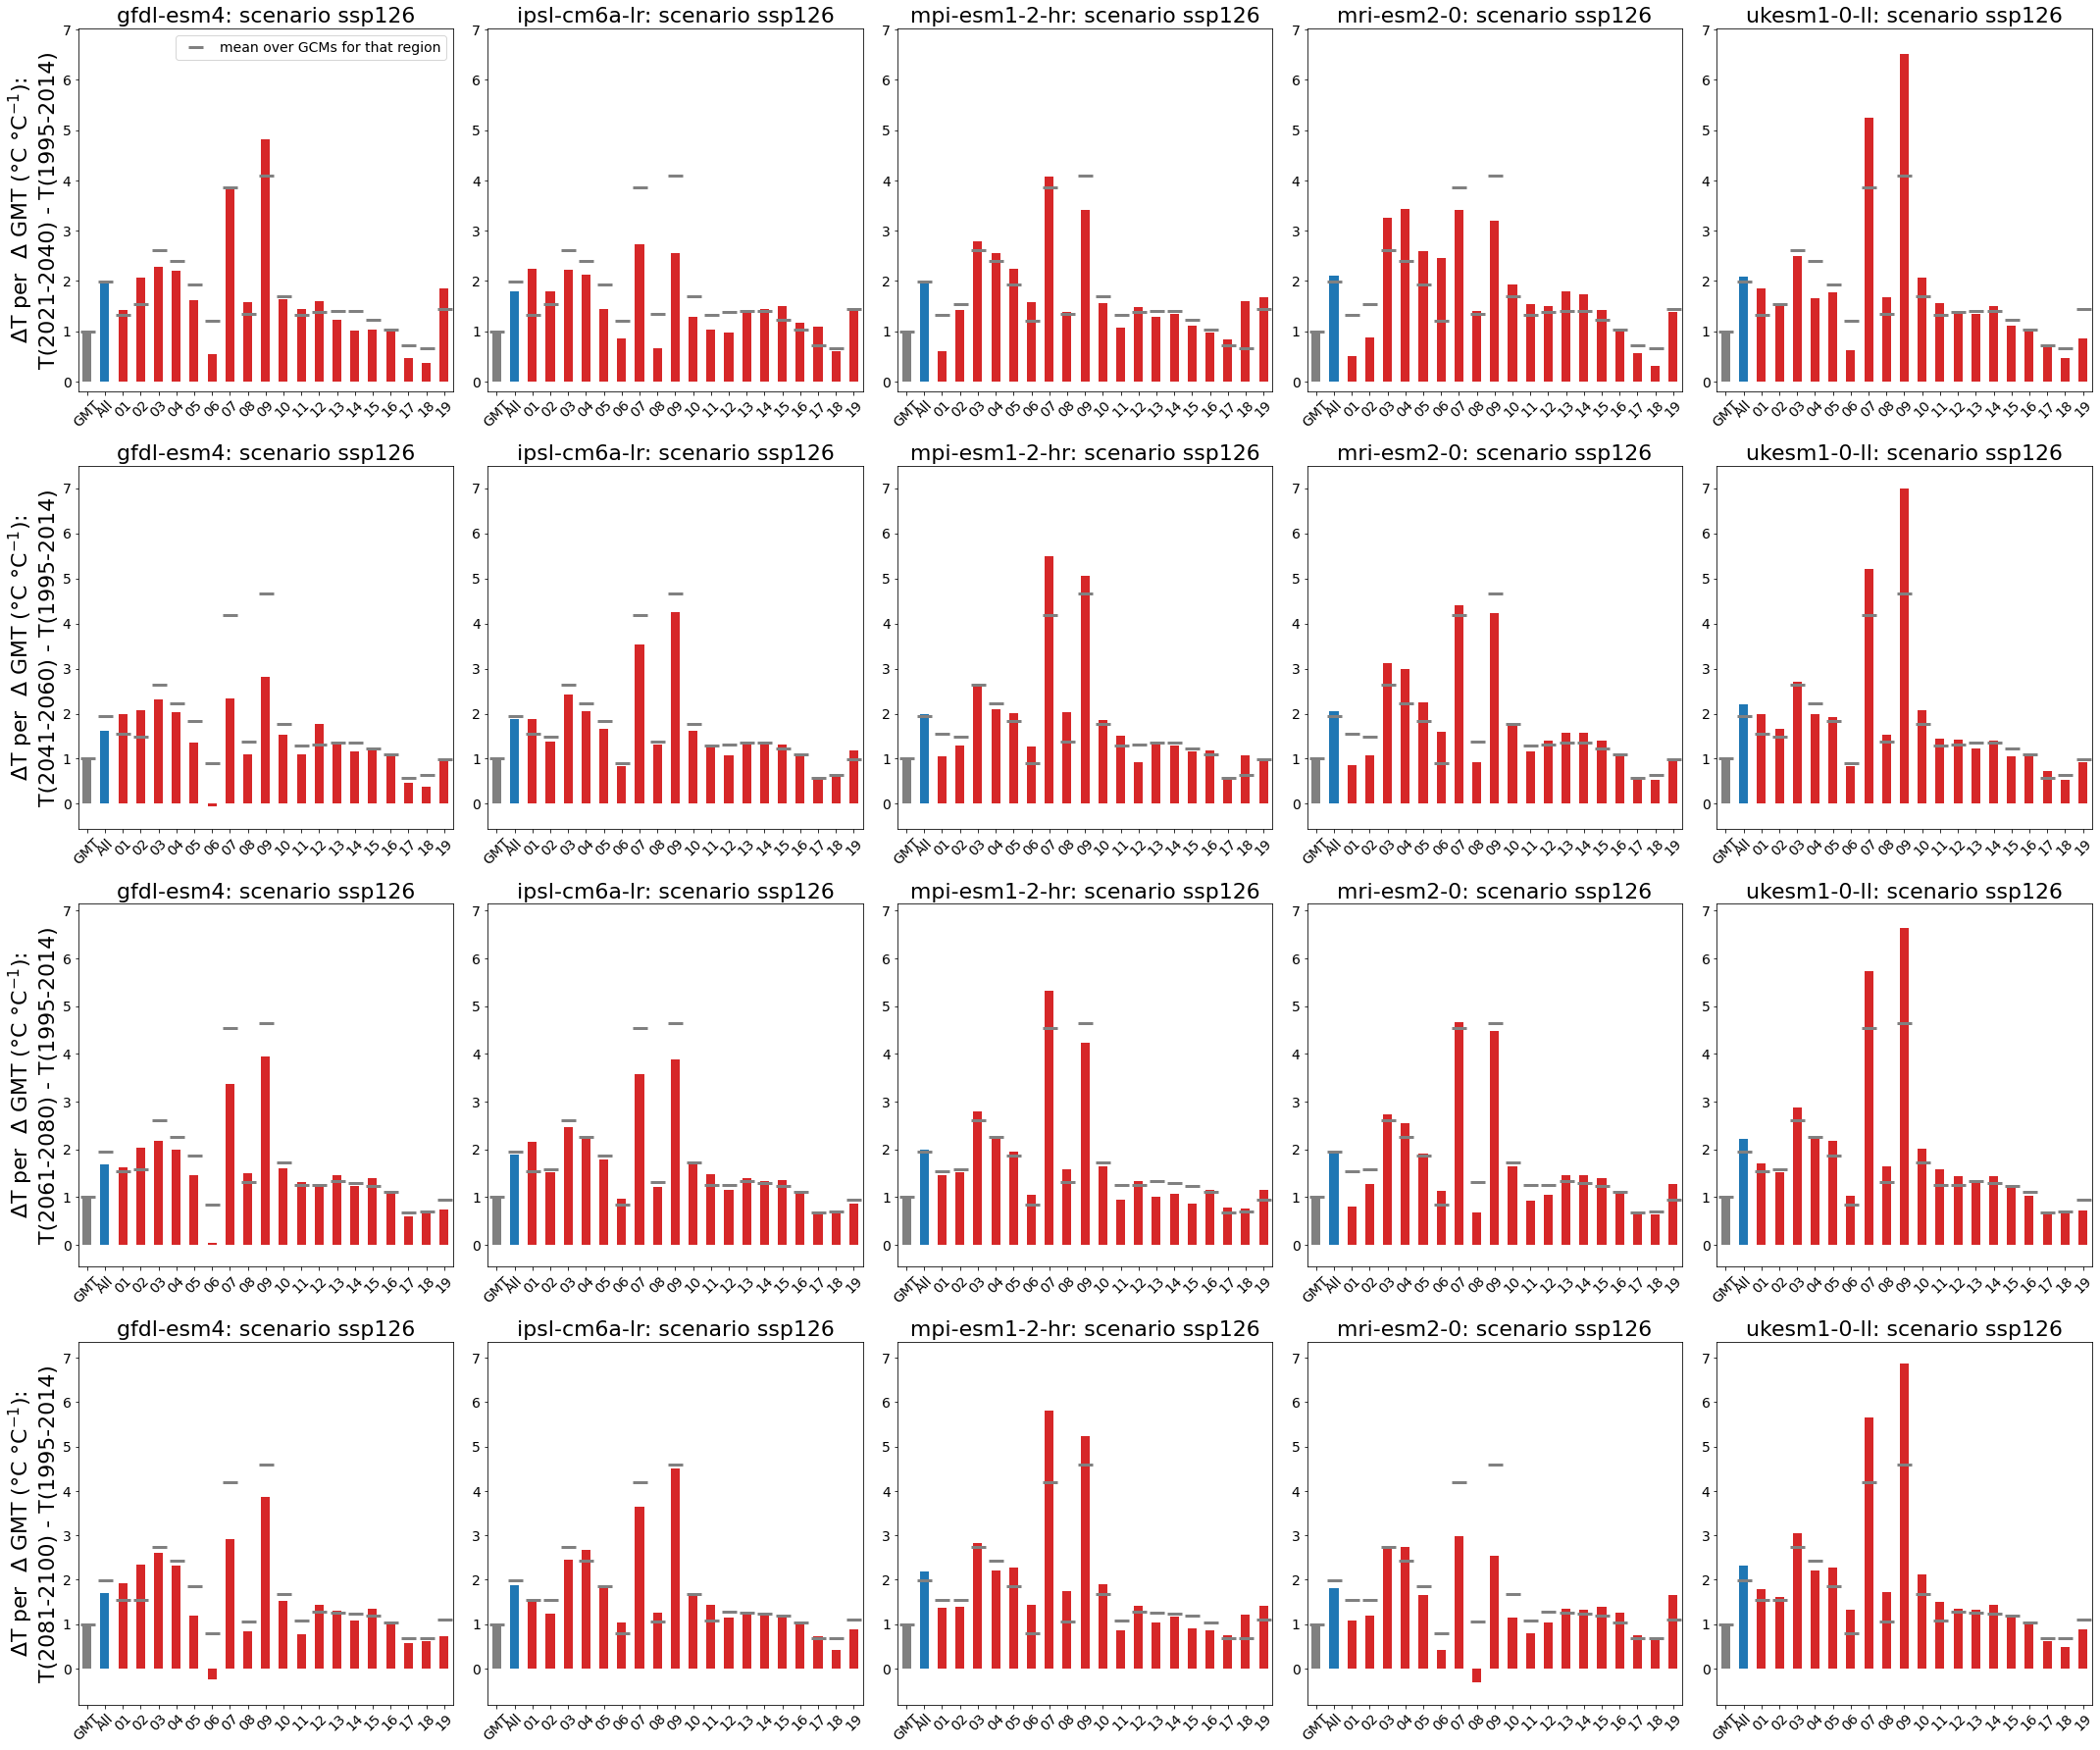

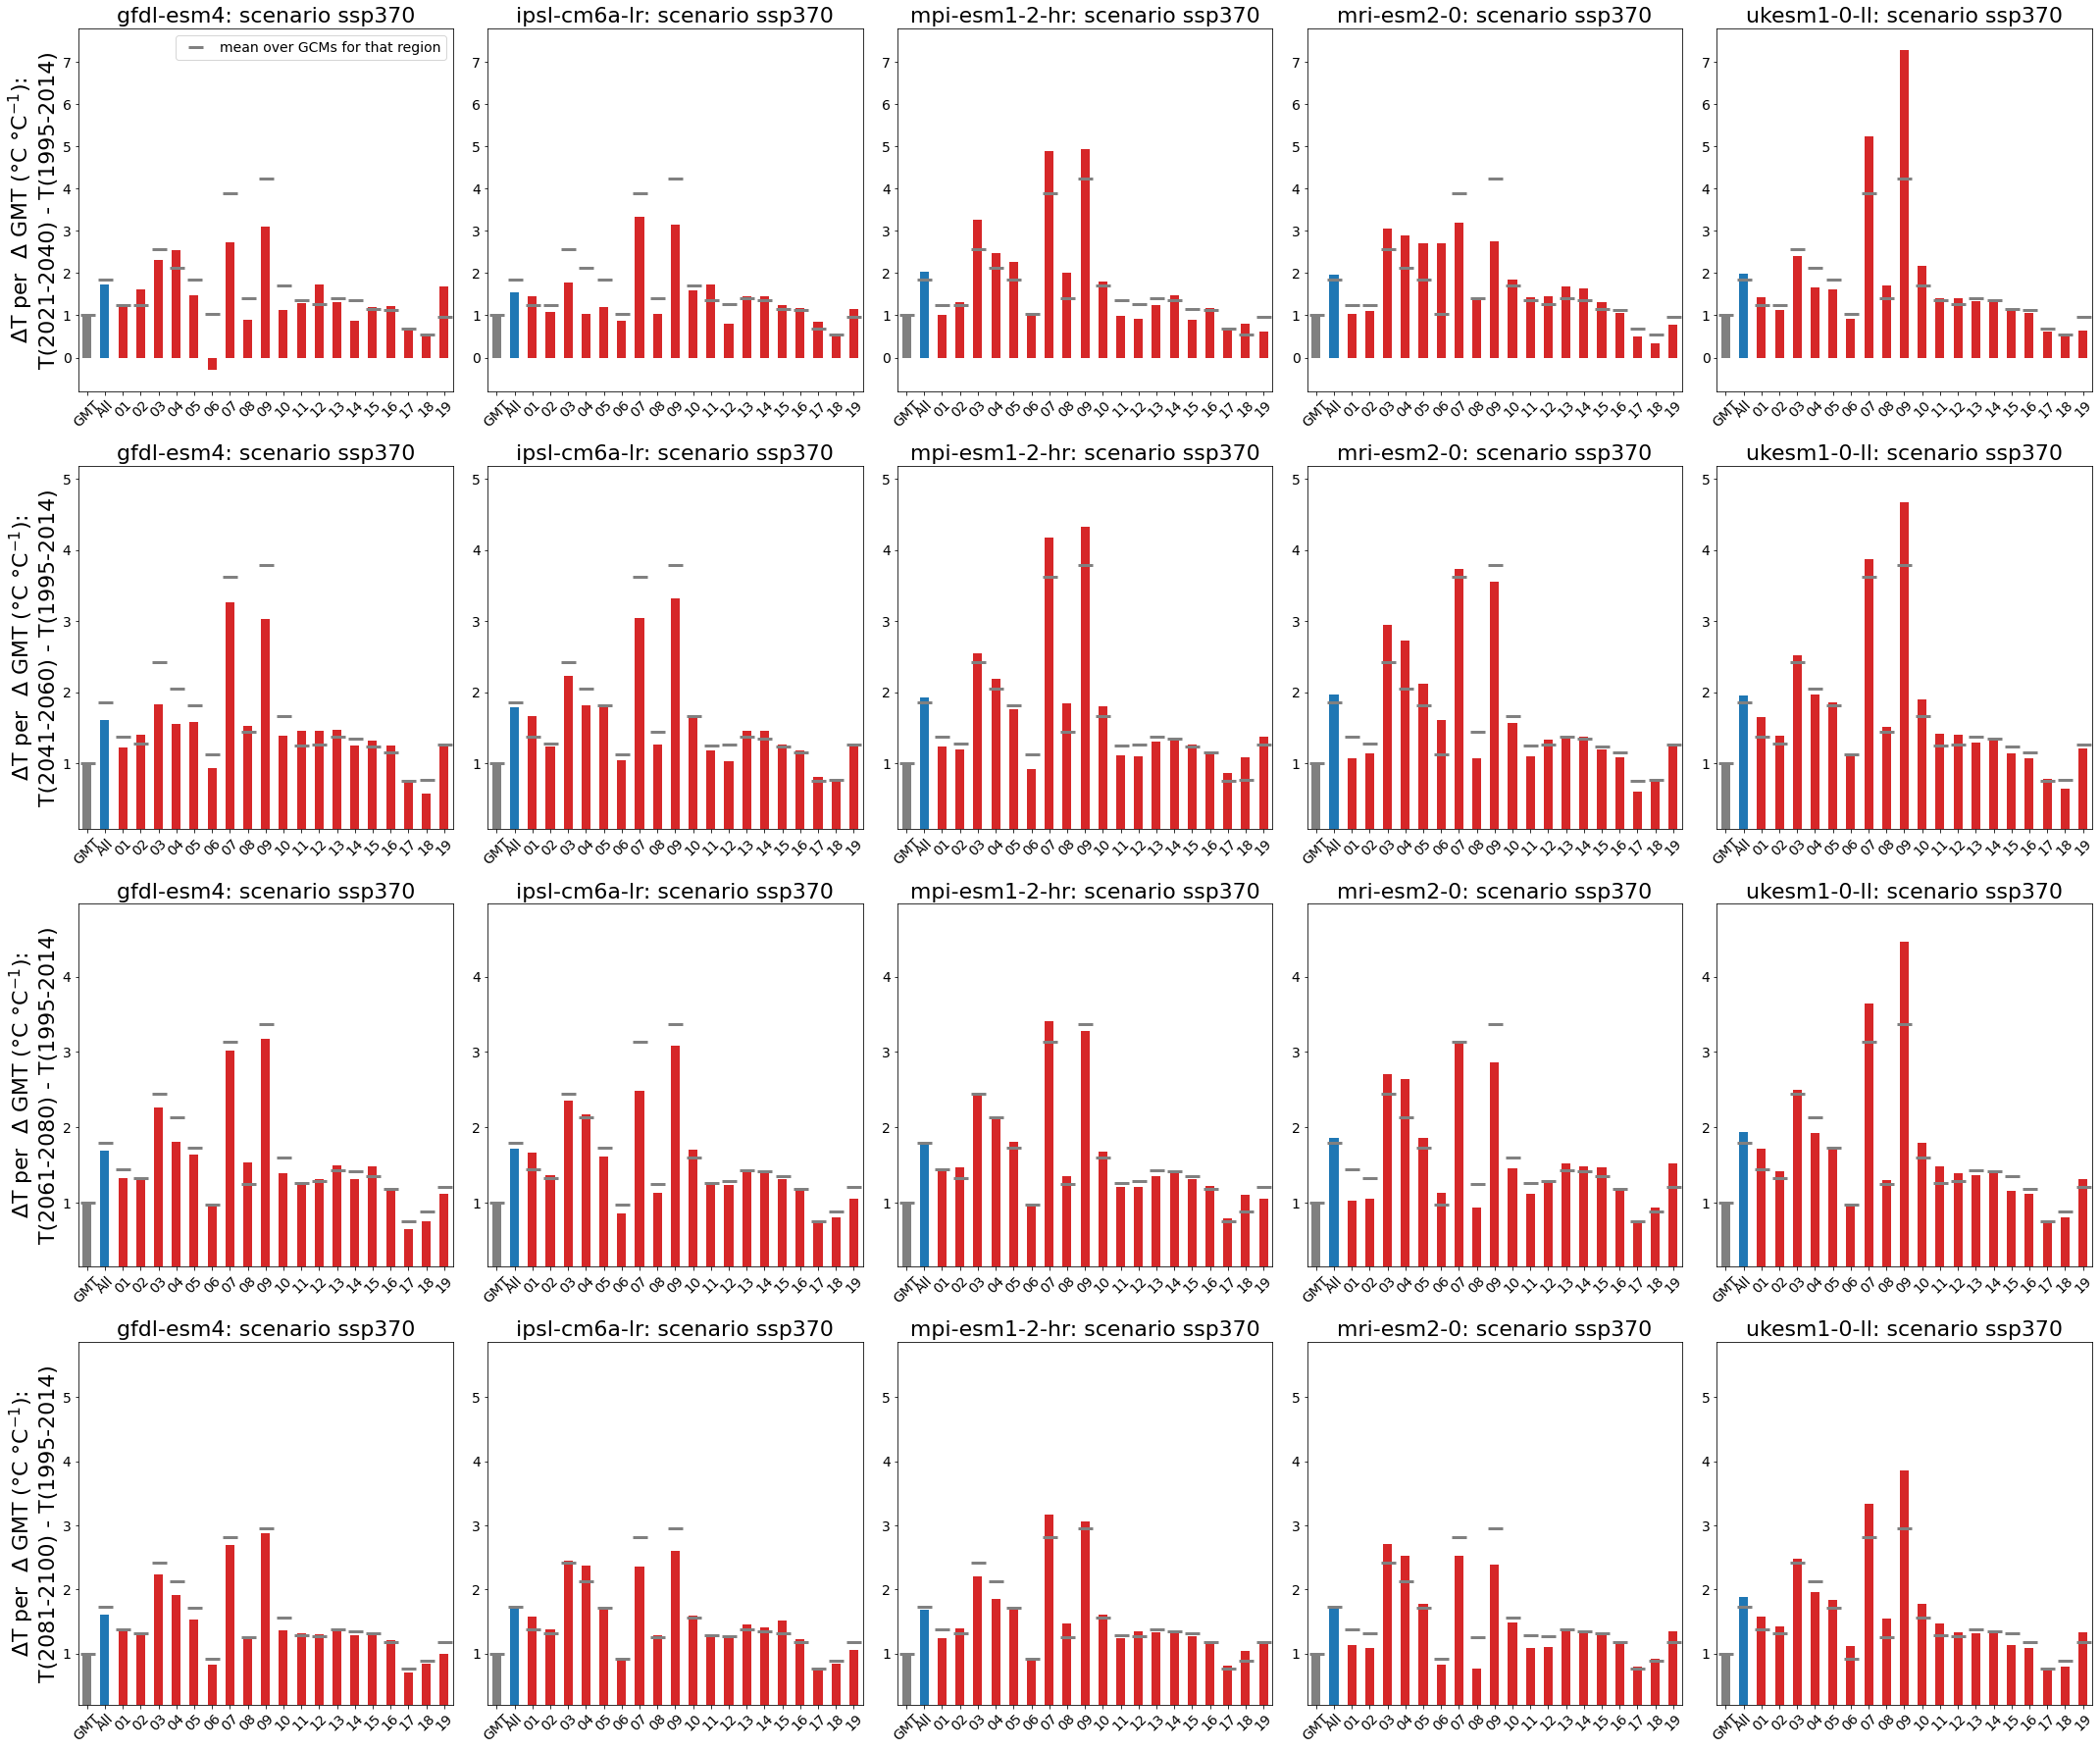

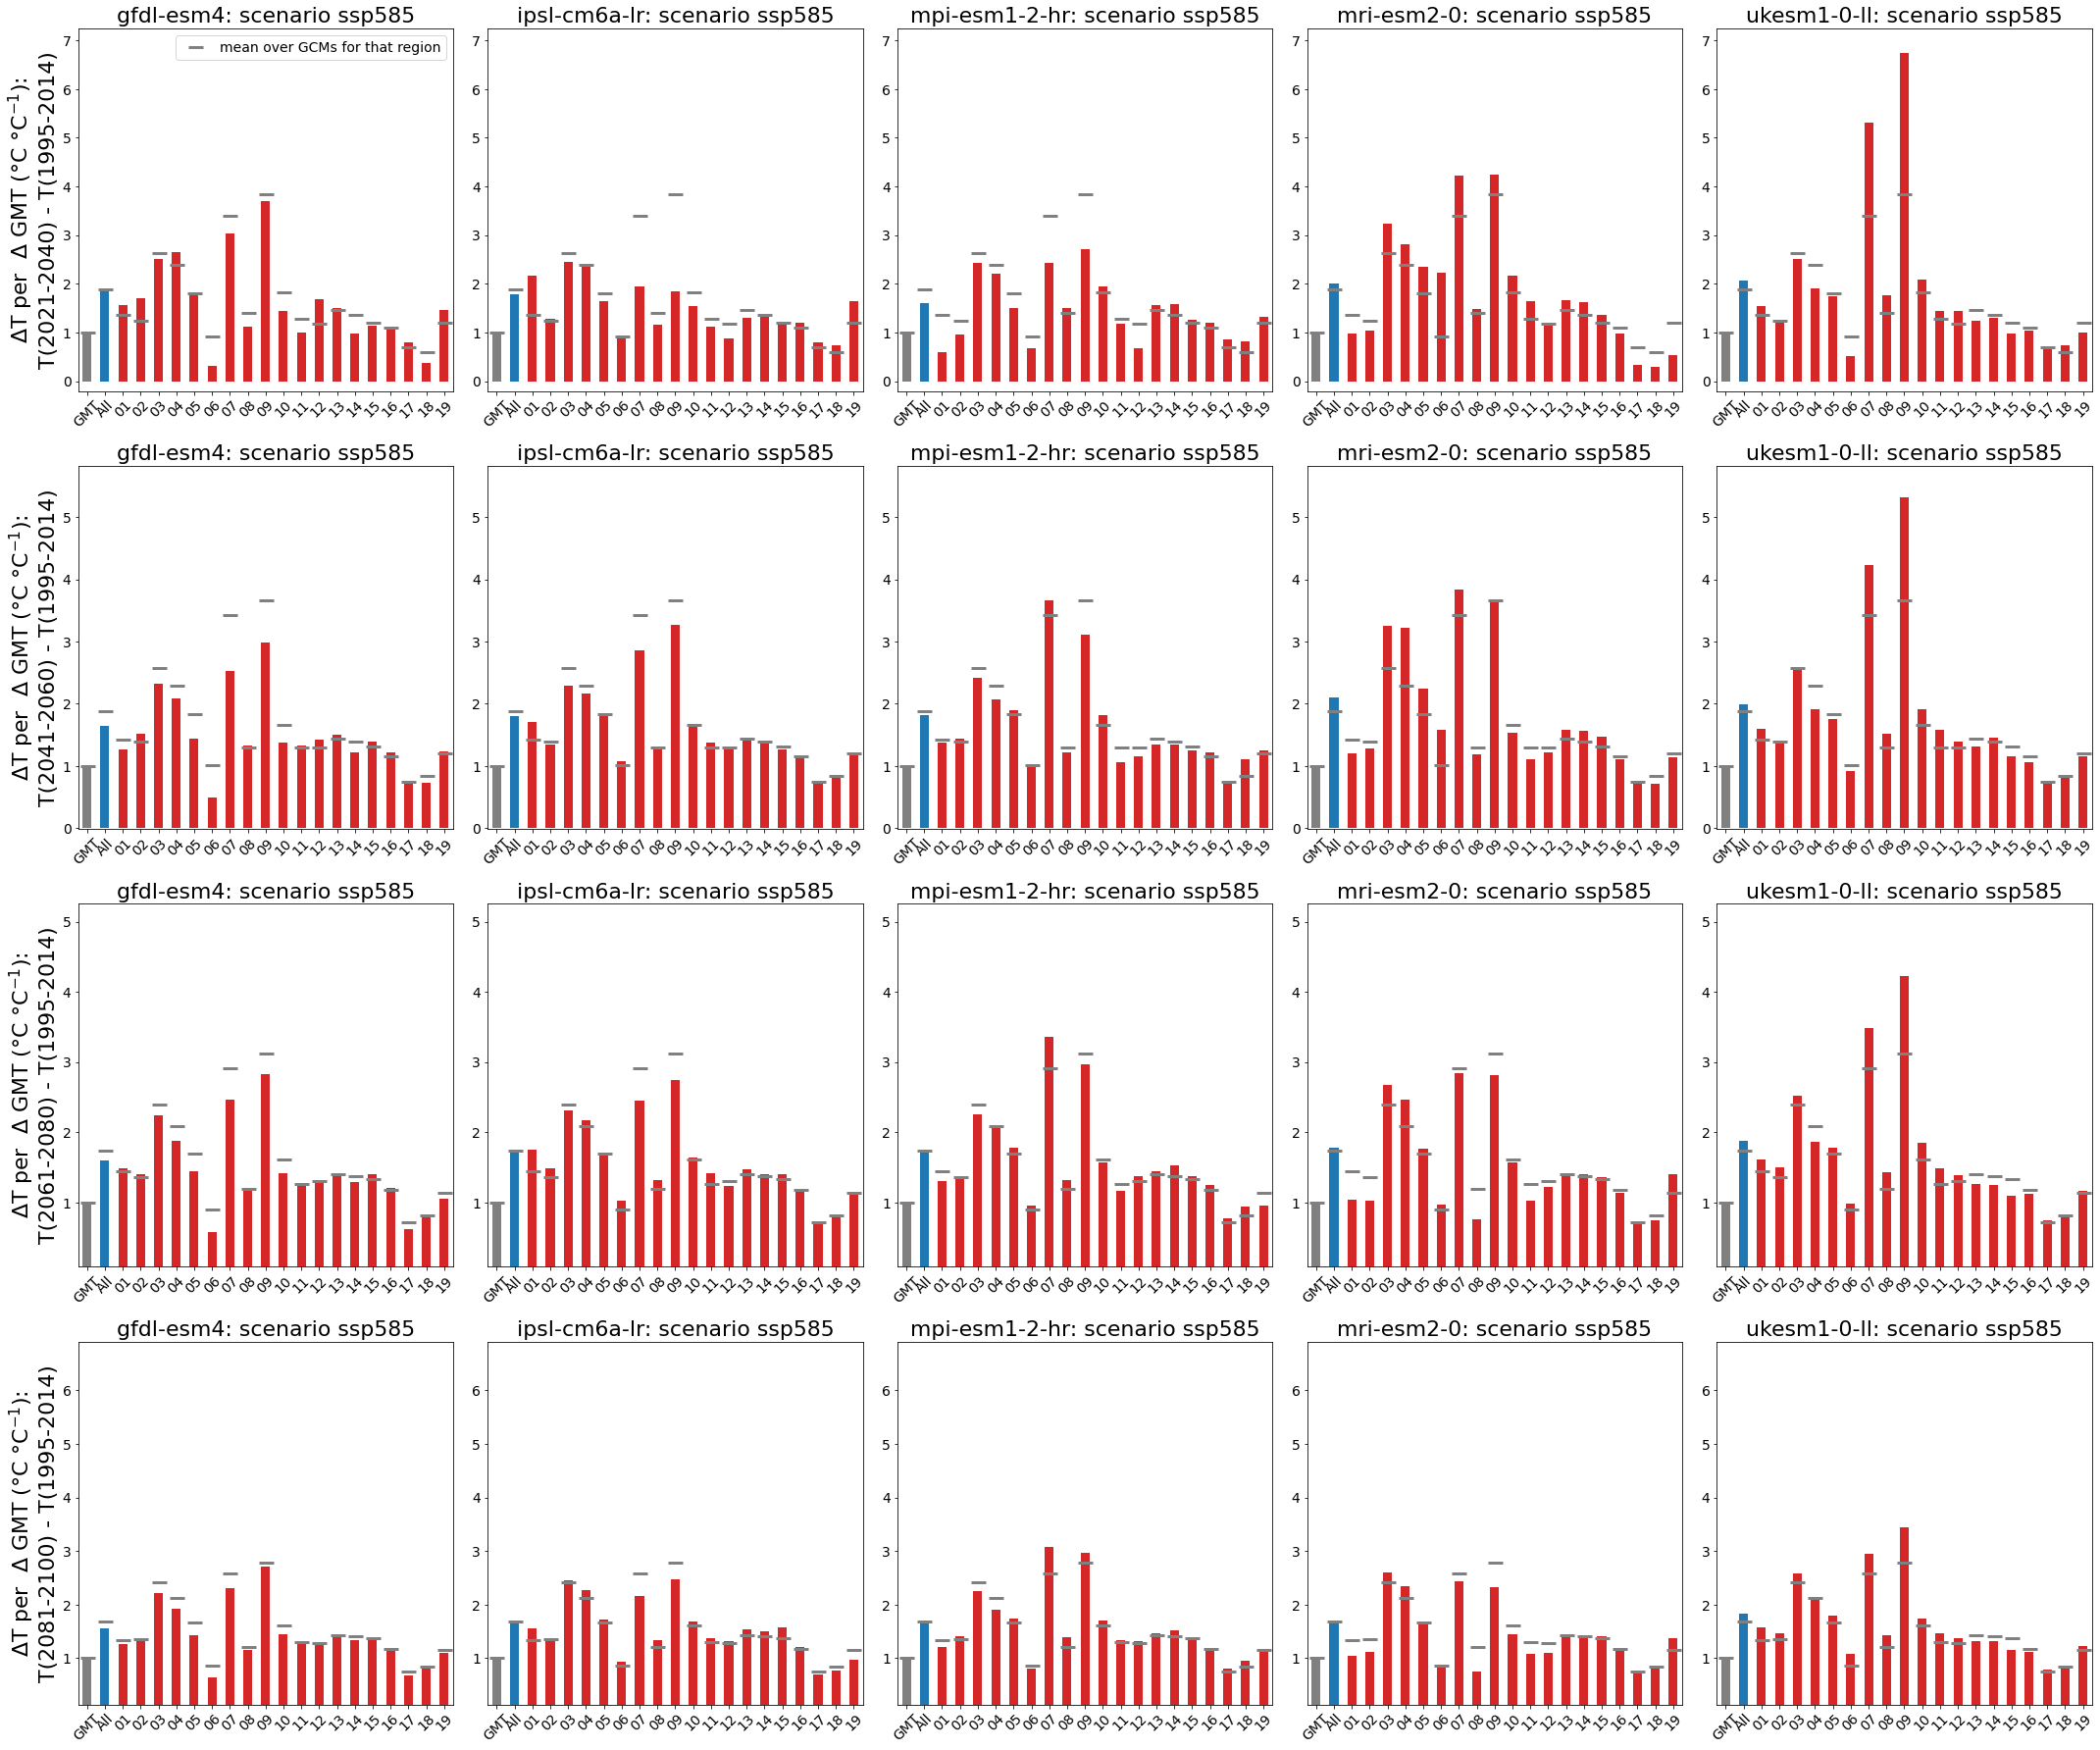

In [159]:
plt.rcParams.update({'font.size': 14})
scenario = 'ssp126'

#for scenardata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACF4AAAb4CAYAAAC8hIXiAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/Il7ecAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOzdd5xcVf3/8dcnJtSQBRGkGzSUIEgLRYoERCwYAUFFRAiiqChWRCw/BRQEQRQVRRQEFUUBASOCYklsiBRRhIQviqAiiAWC9Pb5/XHuJpPNzO7M7uzebPb1fDzmsdnbzpmZzbzn3vnMOZGZSJIkSZIkSZIkSZIkqXPj6u6AJEmSJEmSJEmSJEnSaGXhhSRJkiRJkiRJkiRJ0iBZeCFJkiRJkiRJkiRJkjRIFl5IkiRJkiRJkiRJkiQNkoUXkiRJkiRJkiRJkiRJg2ThhSRJkiRJkiRJkiRJ0iBZeKGlXkTsFRG/ioj7IyKr2xZt7De92nZ2n+WTq+W3D1OXR4WI2DQiHq0eiz/W3Z+REBGzG/6Gmt2u6Gff7SPi2xHx94h4LCIeiIjfRcRHImKlFvvcPkB7ZwzfvZXGjob/a5NraHupyZSI2C4izouIv1X58O+I+G1EnDSCfciIyJFqb0nV8B6mv9v2LfZdPiKOjohrI+J/VWb9IyK+GxG7tNhnZhvtrTG891oSQEQcU/2fO6buvoyUiNgoIt4ZEd+IiHkR8VT1GOw3hGNOiIgXRsSnqtfD+6vXwzsj4sKImD6EY5tVbRhKtkTEKhFxQkTcGBEPVu9L7oiIr7e6FtDwf6fV7ZFhvcPSGNfwf/6cuvsyEiJiXETsEBEfj4hfR8S9EfF4RPwzIn4QEXt3oY2XRMSPIuK/EfFQRPwxIj4UEct24S4s8YZyTa167GZFxN3V8zI/In4TEe+KiGVa7DNQZh09fPdW0lh5jx0RK0bE6yLiM1E+83qwuu/f79LxN6rOq/7R8B76ixGx5iCP1zTfYym6HtqfhvvZ323/Fvs+LSLeWj3P91V5dE9EXN7qfUIM4Xqgumd83R2QhlNEbAlcWP36U+Cu6t//radHS4eIGA+cC0youy81+SFwd5PlNzbbOCLeAHwFiGqbXwOTgB2BY4HXRcROmfmvFu1dBDzQZPlVHfZbkoZFRHwEOAZ4Crga+CWwKrAJ8F7g/bV1bmz7J9CqKHCxzImIHmAOsDnwP+BXwP3AVGAfYJ+IeFdmntbimH+mPPfNPNxBvyWpE28F3tnlY+4CXFn9+27g58CDlFzbF9g3Ij6WmR/pcrtaXEfZEhHrAb8A1gP+DfwMeATYAjgQ2D8i9s/Mi1oc8/fADU2WP95RryWpf8+mvNeGco3yt8C91fKXAi+tPqR6Q2Z2/EFiRBwFnAQ8Ccyujr0L8HHg5RHxwsx8aIj3YbTo6JpalOLVj1a//pby+D0D2BnYDnh1ROyWma0K8s5tsbzpNUNJ6tAGwDeG48BRvmxzObA8cD3lHGhz4C2U85+dMvP/hqPtMeBBFn5O2ddf+i6oPn+7HNgdeJRyPvRvyvuElwAviYjPZOa7Wxyzo+uB6i4LL7S025vyd35CZn6o5r4sTT4IbAWcDryt5r7U4cTMnN3OhhGxMvA5StHFIZl5TsO6VYEfUy4CfpjWF4yPzMzbB91bSQN5IaWQ7M66OzIaRcRbKEVkNwL7NZ6ERURQLk6pHvMyc2YH27+fclJ9PfCizFxQqBoRh1KKCE+OiPMz859N9v9lh+1J6r7PA+dTLsqMFX8ETgauBa4DzqJ8uDQUT1E+qDktM3/RuCIiXgOcB/y/iPhZZv5siG2pf51my4mUoosfAK/q/WAxIsYBH6F8mPaliPheZjYrprgkM48ZWpclDcLFwG+A+XV3ZIQk5QtiJwNXZuaTvSuqD74uA2ZSPvT6aicHjohplNfCh4DdMvPqavnE6rgvAI4HWn1Ys7Rp+5paRGwM/D9Ksd2emXllw7rJlMK+51OKPj/d7BieD0kaZv8Dzmbhuc+WwJBHxY6IFSnnkcsDR2Tm5xvWnUL5UtW3ImLaYAoCxb87zIc3UIou/grsnJl/7V0RES8Gvg+8KyK+npnXN9m/0+uB6iKnGtHSbt3q56219mIpEhGbU4oEvkvrKj0ttB2wAvB/jUUXAJn5H+CT1a/PH+F+Sapk5p8zc16Li+/qR1VAdjLlot7L+1a+Z/GbWjqnwdi1+nlKY9EFQGaeBfwfpUhp65HumKT2ZOa/q0wbM4UXmfmVzDwqM7+TmX/u0jF/mpn79S26qNZ9Gzin+vXAbrSnrurNso83fps7M58CPkYZJWNVyrcFJS0hMnN+lV93Dbz16Fedg74wM69oLLqo1s2hFE7A4HLmaMqXf07qLbqojvsAcAiluPDw6otCWtQulM9LftZYdAFQFW98ofrVa3iSalHlx6GZ+cXM/C1lNIRuOARYg/L69/k+695PGYVuK8qoTBp+vec0ZzQWXQBk5g8pxZsAThuyBLLwQqNGRGwREZdGmZvwwYi4rprCYbE5vKKan5USGABfbZjD6Jw+x927mifpgShzKl4ZLeYw79L9WDEijoqIa6LMFfxwRNxU9Xlik+2fFhFviTLn4/wocwv/MyKujzLn8Gp9tl/wWFRzaF1bPV53R8RZvdtHxHIRcWxE/F9EPBIRf42I4yOi5fQh1bpzKJWVh3fzcWnS1rYRcUGUeZR751P8U0R8MyJ267PtclHmo7++eh4fjYi7IuKqKPNlLtew7YL5wyJifLXf3Oox+GdEnFsNT9st7b75GTMXx6UlTSyc+3Vyn+Wzq+XTI2LXiPhxlRMPRMQvI+IVLY63cpR5xW+KMpfuIxHx9+p4H+hy31eMiCOr17v7qky5rXr9fFmr+xkRMyLiF1UO/SfKfPXrV9uNi4h3R5kX/aEqP06PiJWadGEmMBG4sO+JwAD9Xi0i3hkRV0TEX6rHaH6UeXPfFhFPG8rj0qS9xvu+d0T8rHouM1rM9d7BsdvOoGr7TvLtnKqPM6O8D7okIv5dPc/XRcQhdJeZJQ1CDMP778H+/4/qPCjKMNmDuS9Tqz73vjbfW+Vfq8xbKyI+X72OPVLlxl+r1/fD+my7YH7fiFglIj5bbftwlPfjb2nY9rkR8Z0o788fjojfRvlmz5Lid9XPdYZykIh4TZUXD0TE/yLiJxGxU4ttG//ODo2Iq6sczxjih2fR4XuXiNgjIi6LMsfw41HO0edFxNkRsVWfbQf1fmoIBsqy3usGZpnUxAhk2vOivBe+OyKejIh3NbS12DW7Dvq9bkScFhG3VLlxf5RrfTMjIpps3/brXiycL312db8/VuVe77nXh6M6f6n6cVaU9/qPRDmnGkzxxKByJiKWYeGHYuf1XZ+Zt1Gm2FgGeFnf9YPVYS4M9rFfMSJOrB7zRyPibxHxuShfBugWz4ekGkXDdft+tlnkc6A2jrlslOstGeXzlWc0rBu1n9MMg72rn82y40nKaBiN2y1xBvH8bBTls6A7qm3/F+X64cURsW+fbRecZ0fE+hHxjerYj1R/M++NMj1It5hHo5hTjWhUiPJBxGXAcsA8ypyrawBnRsTUJrvcQJlTbyfgOZR5E/9UrVswP2wsnPMQ4NfAHcBmlIqxz3X5bhAR6wA/pMwN/C/Kyc4jwDaUIU/3iYjpmXlvw25nAQdTvpnTO5fTM6r79R7gAprP034S8C7KXO1XADtQhiiaFhE7Vv2YWq3/E6Wq+4PAasBhfY9X+TBlWoyDM/OfLR77vv3ofSO0awfTc7yI8nxPoJxs/qr69zrAfpT55n9abTuu2nY3ypCUc6qfzwQ2Aj5EGXL57iZNfRt4OWW+xt9THqODKHNkvSAzb2nRxX0iYh9gWeAflErQxb4NV7mO8pxtGBEzm0w1clT165dbPiDwhmrboAwv9cPM/F0/20vqrn2AtwM3UebXexawI3BpRLw3M0/t3TAiVqC8Zm0C3EOZTuhBYM1q2fbAJ7rRqYh4FuW1fCPKnLW/pLz+rUu52LYaZZjtvg6nDBH4S0o+bEOZr377KKManUG5CDcbuI0yFO3hwBSg74dee1Q/f1GdlL6GMsxhUqYeuaBPpvV6MfAZ4O+UUal+Q8n151NGCnpRROwzDMMXvpfyXP6W8lyuS/nGF7FwLt85mTm9nYN1mkGd5Fsf2wFfpEyHcyWwOiW3z46ILTPzHS26+MyI+CiwNuXv8Ebg0mrEpWauqI57ZET8sM9UI28ANqz6fW2L/adExMer/t1PmbLke9W366Sl3jC9/x7s///B9H9/yjnUMpTM+37Vt52BF0bExzLzIw3br0l5r7sG5TzqCsoForUpeTcZOLNJUytTzoMmUbJoVUrWfDEieijDqv+oOubPKCMTbANcFmVO9Z936z4PQe9oCYP+ZnZEHEfJiV9SsuF5lDzZqTonbDX3/OcoufwrynO0IVUxQZQPLA8Gzm13aNlO37tExEzKsPdPAVdTnqeJlEydSRkdqdlwt22/n+qj02y5Angz8OGIaJxqJCjDx69Q7X9Pi/23qv4vrwL8t7qPl2XmYy22l5ZKw5RpO1LONe6knGusRBk5b6h93ZUyVUlP1ZcrKK9L21Ner3ajXOvp3X6w52zLULL4uVX/b6Xk18eAtaMMxf6r6j79gpKHOwFfj4jMzMU+zOrHYHNmI8rr3H/7GQXqGspzsSXwzd6FUb6I0DvP/PodTM8xkzZzYYiP/U+ATSnnS9dT/ubeDrw4InZuMRUidHZN7WfAY8CuEfGiPlONPIsyxchTlGH+Wz0e76WcOz9J+Yb4ZX1HhpQ0MqIUJ19Ceb24GHhdZj5crRvtn9N025bVz2tarL+mz3bDpiFX7sjMyR3s2vbzExGbUfJoJcrnjbMo51RrU65ZLk+ZerKv9SnXxB6hvBeYBEwHTqGcx+1bjbTX14pRigsnU86Z51HOSf7e4r5cUd2Xt0TEeU2mGtmV8rlUs+u+0Pn1QHVTZnrztkTfKCcM/6C88B0LRMO6HSijL2T5c15s33OqdTObrNsSeIIyb9+MPuve13tMYHafdZOr5bd3eD+CUtyRlKKO5RvWLQ98vVp3TsPyZ1XL/go8s8kxtwBW77Ost993A1Mblq9CeUHv/TDsF0BPn2M9TjmBeFaLx+tx4AcNy6ZXx/tjP/e7tz/TO3isflrt89om61YFtm74/QXVttcBKzZ5zHcEVmjy/CXwT2CThnXLNDwPv23S9uyGffvefgms2+L+vLTh7/QPlIKPy6tldwGHttjv9n7auwRYpe7/n968LQ23hv9rk/ssb/w/f2SfdTOq18QngOc1LD+o2v77wPg++zyNMsdu47Le16TbO+zzOMrFpqavB5QThxe2uJ8PATs1LF+u4b7eSMmKtRvWrwf8p1q/c59j9ubzkZQLbH1fq+6lzI3bt/9Tge2aLF+T8sF+Aq8ZxHPZ6v1A731/vFl/qm2OoUnuD9BepxnUdr5Vy85peCxPA57WsG47ygdQCbysz37TmzwXvbcHKfN1Nrs/y1V/u1kd+3JKZt1IuXB4GbBGk/1m9tPef4H9hvv/sTdvdd4a/t679v57CP//e1/LjunwPjyPcgHof8BL+6x7LuV8JCnF1L3LP1ItO4OGc7Rq3bLAC/osa3ytuABYrmHdS6vl/6O8Zr+3z74nV+t/0sZ9mV1tOyyvPZRCk/uqNmYMYv/ex+A/LHpeM45SqJLAlf3sdx+wbYtj9/7dnNNBfzp973Jbtf0OTY61Dg3nV32ej7bfTzX5e2k7WygXV6+utvsX5SLqhZQPSB+jnO+t1GS/Y/pp72/ALsPx9+TN25J2a/i7H65M+zgwrkm7vf/nz+mwv2tWrwlPUD6gaLxmuC4Lzy1mNizv9HVvekP/+97vzavXlieBmynF5Y2Z/bZqvz91cJ9WaHitbfq+vZ99X1Ht97t+tnl3tc2FfZZPbrifkztos+1cGOJjfwuLnqeuRCncSOA7Tdq+vZ/X9UtocU2N8mHoY9V2V1O+5f1jyvuk22iR/f209RTly1bLNdvPmzdvC2+0cY2s9//WQMspn6vcVC3/LA3Zwyj/nKZPGzN7X1eH8LhPauhrT4tter9k9e8Oj93bv3P6LG/5XDfs0/LvoMk+HT0/lAK6BD7QZNuJwPP7LDum4TG6kEXPZTegfLEsgcNb3M9mt8eA4+lzLt3wN/rlartHKIWf51O+SJaUopGNmuw3vZ/2Wl4P9NbdW+0d8OZtoBsL35TfQvOTs5N6XzyarDuHPidYDevOavai37D+2mr97D7LW4bCAPej92LiVS3ux4qUQoDHqd78UyosE7ikg3Z6X0gPa7LuXdW6J2kI+4b1l1brD+qzfBlKwcD9NBQX0F7hxbzq1vTiYIt9et8UrdzGtq+qtv1Mm8duDLu3N1m/MuXbygns2GfdxygnYBtQ3oStB+zPwpPMW+jzwVvDvltSqvz7Bt6FwFYt9vk85dvjz6Z8GPYcSpXrP6t9f97sb8mbN2+d3Ri48OKaFvudW63/csOy3sK9d7XZ9mAzZe9qv7/QcILY5v08oZ/jJbBHk/WnVes+0mf5Iyw8WbiNUhU+ifLt294Pjx6mz4cwA/TzRdV+FwziuWz1fqD3vp/Zz75vr/Lqax2012kGtZ1v1fbnVNv/HVi2yfpjq/VX9lm+JXAq5Rt2z6ScNG5JOWl7strnjS3aHE95b/VUn7z6O6XAZkKTfV5MychtKAUkPZRvq32Xhe87Xtzp8+nN22i5Nfw/6eb778H+/z+mWn5Mh/fh29V+b22xfr9q/UUNy06vlu3dZhszq+3vB57RZP0N1fpfN1n39Grdo81eh/psO7vatuuFF9VrZO+HPD8e4t9Ls3ORZ7Lw4tqEFvt9sJ9jf4KSZZ/ooD+dvnd5ELi3g+P3Ph9tv5+qlg86Wyjn1r3/hxpv82idf68HjqZ8iDqJUsCxa0P/H6RPcYg3b0vjjeHNtLk0FCX02aY3I87psL+91wRParF+WrX+uoZlnb7uTR/gfl/CwnOzZfqsG8/CIvb12myv9/G6iSbvAQbY94Bq31/2s82bqm1+2Gf52iy8hrd2B222nQtDeOwTeHmT9VMoRTdP0ufLUAzhmhrwQsoHpY0Z8iTwFWBKi32+QSkoXK9qbyPKKLe9xbLf6OS59OZtLN7oUuEF5frHPyjXNd7bZNtR+zlNk+1mVtsNpfBirYa+jm+xzQbV+kc7PHZv/85p97mmjJQ3jzaK7hv26ej5oXyxKIEt2tz+GBaeE6zeZP0h1fpb+yxfE/gSsHv1OC9PGb3pRMq5bQIf76fdd7OwGLD39l/gOJoXkw/6eqC37t1q74A3bwPdWFggcVyL9Zv3E7jnVOtmNln3p2rd7i2O2xt+s/ssbxkKA9yPz1X7HdnPNr0v+HtUv69EeYP+OGV4qWe10U7vC/BiJ3SUaTUSuK3FvqdU64/us/zj1fK39Fk+vVresvBikM/5V6vj/oDybeGmJ+bVts+hnGT9jzLk7mIVjS2ev6TFB1+Uk6UEPtRmf3sowwc2fX6Bt1QB+SPKNxR7h1x8R/X8PkyTDzr7aW89yrfIE79F7M3bkG8MXHjxrhb77U6fN9UNr4t3AQe2ep1p2H6wmXIGA7w57+d+vqDJuk1ZWECx2GsupSghgTP6LO998/84zSute4fqO7fJuvGUqUo+ShlG/6uU3L6o2uf3g3guW70f6L3vL+ny306nGdR2vlXbn0M/hR2UC41Z5UjTk+Mm+xxR7fMf+lzIpZwQ/oZSgPj2Kqt6h2nu/aDxyoH63eeYn2IY3it487Yk3WBY3n8P6v8/gyi8oIy0MJ9yYXK1FtusVh33Hw3LDq6W3UIp4GtagNyw/cxq+5+2WH9htf4jLdb/u1q/2Mg7fbabzfAVXnylOvZfB+pHG38vk1us/2+z+9mw38Zdvk/T6ey9y8+q7b9GuYi32De0Wjwf72qxfrH3U230uWW2ABtTCt57788alPO13SgjVCVwdoePUe/f5qAvaHvzNlpuw5xpJ/bTbm9GnNNhf2+s9pvWYn1Q3qs/SfXt1EG87vVuP9D9bvrawsIvdm3fxv35f9W29wHPHcTzN+jCiyH8zbSdC0N47O/tZ5tfVtu8rs3+9ntNjVL09xRlGpbnUUYgeTblPdZjlPOoLTp4fLainC+3/Dv15s1budGFwgvgJdXr/iPAq1scY9R+TtNku5ksZYUXg7wPHT0/lGuRSbkG9iIGKHRk4Xn2JS3WL8vCwoa2ihcpxXpZZctafdZNoowO9ShlpMlnV3m0OWXki6R8cWGx4ot+2mt5PdBbd2/jkZZ8a1c/72ixvtXygaxT/fxLi/W3d3Kwai7HZ/RZ/O/MPLL697OrnydHxMkDHG41gMz8XzWn+tmUYYeOj4g7KdWYlwHnZ+YjLY7RbH6oB/pZ17h+ud4FEbE18H7KBbMvDdDvbvkAJUReWt0eiohrKUO0fz0zb+vdMDP/HBHvprwZOR04PSJuowwXdilwcWY+2aSN+zLzvhbt3179XKfF+kVk5vyIOI3yjfCXVX0BoJqn7YuUiwF7Zubj1aoHgM9GxL+B84AzImKDFn3t295fI+KrlIrHl1EuBEoaPgPlxILXisycHRGfpIwM8HUgI2Ie5WLQRZn5w3YabCNTnlX9nNfO8froLx/ubvE6tFg+VP5H+RbyLzLzlib7nUE5mdy1cWFEbEj5ZtjUfvo5qc8+5zTZZl5mntjPMfoa7HuGpgaRQW3nWx+t/gb/SrkouBzl28Ct5jVudDrlpO0ZlGLAnzesO7da9trMPL9h+W8i4mWUD6x2p4xG9tU22oJSvPlO4LkRsV42zEspLYW68v67jyH//4+IjSnf5O/rksy8pNq/9zX3nohodSiozlMqX6cU0B1AmTP5yYj4I+V15fzM/HWLYwz0WPS3flVaP1ZtayNnm+1zGnAo5RuwL8zMu4d43Favh/dThh9udT+7nWWdvnc5nHIR8PXVbX5E/JZSoPe1Zo9Lpe33U21omi0RMZ5SwDmFMnrhVQ37/DQiXkSZCuCQiPh6Zv6szfaOA/YFXhQRExrO6aSl2XBkWkevXxHxDBqurzT4ZWZ+pfp377W2awbILygZcucQztmGkl8wQH5FxHsorzcPUKb9uqnJNkdTCswWkZkz+7S1Yj9NTax+/q+//nSg7VwYwmN/ez/t304pam/3Gl7La2oR8Trgw8AVmXlAw263AcdERO+w8KcBu7TZ3vURMYvyDe6XUQpxJA2fWZQv+rwmM7/TYptR+TnNYEXE3pRC+b5OzMx5DW1ByY/5TbZdLDsiYifgjU22/Upm/nJQnR2kQTw/JwM7U0Y4+hHwaETcAMyhjFB0Y4ummp7TZOajEXEX5bPMdYA72+jzrIj4HaVocXdKAWOvTwF7UqZCabzu+Xtg/4hYhXIufiSliKQd/V0PVBdZeKHRJFssf2pEe9Hafiz8IKzXHZQXPyhzFUJ58b59gGMtOBnNzAsj4sfAXpS55Hes2tqP8qZ/58z8W98DZGZ/j0snj9kMymvFM4Gf9TmRXbn6uX5EzK7+/cbM/FMHx19MZt4dEdMole0votzn7Sj3/8MR8ebMPLth+89FxAWUNxA7VbcDq9sNEbFLZt4/lD61offDz7X7LJ9Z/bygxQW6Cyjf/lif8qbv1iG2J6lmmfn+iDiD8rq9E+U17E3AmyLiR5QirCcGOMxAmdIqE9vRrXyAcsLxdFp/mNK7fI0+yy+kFF18D/gkZdjh+Zn5ZFWUcQvl22mNDm5y/DmU4fna9XAH27alkwzqNN+GQ2Y+FRG3Uk60FmRIRKxd9ekxmhT0ZeZjEXEhZXSU3Wmz8CIz742IeyijaaxN6w8apVGvi++/u20Nmr+G3k4pgus9T3mSMvJbW6r7+7qI+ASlyG7H6nYEcEREnJ2ZhzbZdaDHYiQeq4FydhER8SnKaHX/ohRdtHrP3vZxB/h7aSkzhyPL2n7vkplzq2KeF1NGkdiRUmD5IuCjEbFvZl7R7T726W+rbNkO2ITyzcGrmuz334i4nHKOtjvlW9rt6D33WoaSn3cNvvfS6DBMmdbp69dEmucXlBGIYGGGfZvy7eb+PNr7j0Gesw1bfkXEEZQPWR6mTKmx2GtY5SU0/8B/ZvXz9urnev00t26fbYek01zo0vnyUA10De+bLfY7j/KB3k4RsWxmPtpiu3bbk9SBiBjXxmZfo0wV/vGIuKrZ5yaM3s9pBmsLmufpOZQvNN0fEfdSir+fRZlyvq9m2TGlxXFnUwrqRlQnz09mPgTsHhHbUbJ1R+D5lPOJoyLio5l53Ah0ex6l8KLx+tzTKIWMUHKnmW9SCi92p83Ci1bXA9V9Fl5oNPhH9bPvBaxekwd53DspH3RPpkwTMaTjZuZA2/eG7gWZeXqHx76P8i3UcwEi4jmUeZl2pcxneUDLnbtnKq2/mbwCC0/8JrbYpiPVG5KfVjciYkXKsOcnUr5RfGFjMUVVQX9GdSMiNqdUz29B+YbfB/s0sXJE9GRmswrOydXPASsTG6xa/Xygz/Lek91m7ZCZj0fEg5Qilqd3oT1J3Td5gOWLvVZk5l+Az1S33irwb1HeFL8BOLO/BtvIlN4PGDYaYLvhdj2wNQtfk/rq/dbvgteq6qLcZsA9wCubjLAxpdmBMnPAr7DVpZMM6jTfKpNbNL0eZYqARyhDBbarWYb05tWD/VzovK/62XZeVSeMPU3ak9SeyS2Wt/3/PzNns3gxW6N/Uz7oWR54e2Z29H81M/8I/BEWXAx9GeVC0Bsi4tuZ+aNOjjcS2sjZBapv5r6H8jjvnpk3d+O4S5pO3rtUBeXfr25U37j6KGUUirNofiFvcoume5e3fe7VT7b0e+5Vua/6OZhzr77tSRpGmXk7/ecXlGttU4CPNRshYoDjD+mcrVsi4m3AZymZ/orMnNNq28ycPsDh5lEy/ekR8ZzMbHa9c9vq5+8G0d1W/eooFwbx2E/up/nedcN+DY+FGTKOch2vnREH+2tP0qIeq362+nyh1edDjd5IeR18G/DziHhhk9FFR/vnNB3JzGMoU2X053rK6A/b0LzwYrHsyMxzKMUbS4xOn5/MvBq4utp2mWr9lymFGt/OxUf3ndys3WrfNatfh5pHq1OmLoGB86iTc5pW7anL2qkQk+rWO+TNq1tUNb52kMftPZF5XYv1rZYP1uXVz1cN9UDVidPx1a+bD/V4A7R1TGZGsxsLh46/qWH5DcPUjwcz8yTK8FvLMcCHjZn5e8rQf9D6MVrsOY6IHso39qBUZ7br1dXPa/os7y0c2r7ZTtUHkCtXv97eTkNRhh3Zr0V7krpvoJyYPdABqiH2zql+7cbrdu8QrAdGxJCHHRyC71Y/nx8RKzRZv3v1s3E41d6Tgn80KbqA7ufviGszg3q3bSff9qtO4vrqfax+1e63wqqikA0po6Y0Pi+9ebVKNepIM8+vfrYa4aSZl1MKNP/H4KbGkca6rv3/b6Xa/8e97Q3xWE9l5vcp0y3BMJ+rDLeIOBF4H2Uu+BdlZrOLkEulTt67ZOa9lMfpKWCtiFityWZDfj/VoFW29GbZxhGxcot9e8/LOsmy3nO9WzKzW0PzS+qObl5r6/Y524Ai4i3A5ymjceydmT8eYJd+ZeZjLHxMml3zejblPf1jlKHXh0WbudC4/UCP/cpRpj5cRPWB2vaUc5u2hkwf4Jpav9fwWHg+9AClcLWd9pZn4XVGr+FJ/fsX5fVp1RavG4u9DvSVxdspU0lMphRf9L3OMio/pxlmvedvzbLjacD+1a8Xj1iPuqCT5yczH6uKSX5DKfx8XpPN9qimQuvrtZTP2/+cma2mj1lERKxBme4EFs2H/7BwlK6B8qjtc5p+rgeqyyy80GhwAaWCeGPgQ9Ew10U1FNDbBnnc0yknAK/v++Y9ynzt0wZ53FYuocyNvktEnBERi1WjRcQaEfGmht+3jIjXVG/S+5pR/ezqHL/dFhHzqtu2A2+9YJ8jI2LdJsunUSoHn6KqTI2I3SLiZVHm823c9mksfDPW6jH6SEQsGMUjIiZQPijrAa7LhrnIImJ6ROzS+PdXLV+h+hbc3sATwOf6tNE7XPv+EXFgn33XoMw7BvCzzPxnw7q9ImKrJo/BqpSKza0o8z8P65D0kgDYpsqFBarcOJAyLPvnG5bvExEv6FsoWL2O9xYhdON1+1LgBspJ5HlV0VhjeytFxAu70M5Afkh5s746cFr1Otrbh50p8+bCoq+Nt1JexzeNiBc0HiwiDmHwBZVDEhFvr/LqawNvvWCfjjKok3zrYx3gxMa/q4jYhvINbFhY5NG77h1VXvRt5/kszKVvZ+aCodIz8w4WnnidHRHP7LPvwSz84On8huUrRMRbI2Kxb6RExJ6UbwoAnJ7Np9yS1L+O/v8PwXHA45TX8v2bvOeNiNg2IvZoWHZQP+9Xey8ELdHnKv2JiI8D76d8m+hFmdm1bwYPl4j4RJVln+hgn7bfu1Sv+e9pcSF8T8o1pvtZ+A2sRp28nxpstlxF+dBseeCsiJjUsN+4iPgw5eLlE8BFDevWi4gDImLZhmP1/t2/Huh9PD/d5H5JqtfJlNedD0bE2/q+LweIiOdGxCsbfh+pc7Z+Vdf/vkD5cGWfzPzhALu060TKhyrvb7wWV72mnk15rf5C9a3gxv6s3XANr60hyDvNhSE+9p+KiN5vE/feny9Qpgy4ODP/2rBusNfUes+V3h0Ru/fZdwplZBIo35J/smHd66JJ8Xp17vddYC3Kl61G1QeW0kir3tf9ovr12MZzkigj47Q99UNmHgUcSxlxZ05EbNaw+hLG4Oc0A/gqcDewa5SRmBqdCDyHMtrF5X137LYqK+ZFxE862Kej5yciDo/FC3J6CxSf23f7BitQRqtdtmGf5wAfq37te33uTc0yNSI2oUy/vDxwVWb+pnddVUQ5q/r1s9XxG/fdA3hX9ev5fdZ1fD1Q3edUI1riZeaD1cWOWZRwfW1E3ECZq/gFlDe976ZcKOzkuNdVF15OAL4fEb+mvJhuRnlx/SxlHt9u3Y+nImJv4AfAm4EDIuL3lA9YlqNUm21CGXq990LSsygvng9FxPXVtstQ5n16NuUbPh/pVh+HSW+ANfsmdCsfBk6OiLnAXMpJ6LrADpSTthOrYd2hVB5+GphfPUZ3VW1tR/kQ627KMFJ9/ZXyBuuGiPgpZdimHap2/g0c1Gf7Lap27qqet/8Cz6yWr1r18dC+Q1tm5mUR8RXKMGdfj4gPADdT5kzbjjJ02j8o81k22hV4Z0TcThm6+X7KhfctgElVf/fNzHuaP4SSuuizwCkRMRO4iTL86I7VuqP6jPSzC2U41X9FxO8o1fo9lNeXp1O+lfmloXaoypRXAj8CXgm8KCJ+SXltWJfyWnEt0PZJyiD7kRHxWsqJ8Rspld/XUV4ft6NcBDs5M2c17POviPgCZXqNn0XEHMpr9WbAppQPNz4wnP1u4RmUzLp7oA0bdJpBneRbozOAw4EZEXEtsBrlb2085aLprD7bH0e5MHkDpfo9gA2q/gbwK8p7kb4Opcx3vyNwa0T8lvIt7+eycLqxT2Zm47fJlqFc8Dy1z3uVqZSiWSgXG5f09yvSkqrT//+DkpnXRsRBlA8gvkUp9riZ8p53NUqurE55TeudOuSVwLkRcSelGPA+yvvinYEVKdkw7B8wVB+sfKFh0SbVzxMi4sjehZnZ6ttCzY75CuBD1a9/Ao6IRWtRes3LzBM76/GwWpOSZWsOtGGDTt67LAN8CvhkRNzIwmLK51C+uJDA+1sU2nXyfmpQ2ZKZj1XHv5Ty97lLRFxDGW56C2D9qr/v6jP8/tMp8yefUbX3D2AlSv6tX23z+cwc8ns4Sd2VmX+rrrVdSCng+lBE3ES5trYy5RxjXeDbLBytb0TO2foTEVtUbQTl/fprIuI1TTb9d2Ye2WR5S5l5TUQcTcnsX1fXvO6j3O/VKUOqf6jJrhNYeA1vQpP1zXSaC4N97K+inFv+X3V/HquOtRpl+ui+HxIO9pramZSCkZcCV1aZ8CfKNejtq/t7E3BUn/1eBXwjIm6hnOc9TPmSxJaUa77/APbKzEeRNJCPUM4n3gpMr17Tn0WZ5vYEynWVtmTmMVGm+P4k5frTHpl5/Wj/nCYiLmbh+/3ewrcdI+I3DZt9LDPbHtkoMx+IiP0phRWfj/LFqFspo0RMpXxe8trMzCHfgYH1UPKokxF+O31+DqMUUNxGyYkHKK/1O1X7nZ+Zv23SztcpOfHniPgV5Zxh16qvsyhf9m70NuBLDRn5BCUjt6Cc089j4ZecGvV+MXwj4KaIuJry5fQp1X2Cct7+jT77DfZ6oLrIwguNCpl5ZUTsQJmLamfKm9dbKBchL6e8ELU1xFuf436ielN8JOUFazPKB1UvopwodK3womrv71GqzQ+lvKBuRvlw5j+UuZ8+xaIXJ39D+fBpF8oFpq0pJxd/q7b9XPUN1aXN2yjPwTRKcC1P+TBrFuUCc+M80bMoJ9MvoATPDpSg/CvlQvUXM/NfTdpIynNwNPB6SjjfTwmr/1fNJdpoTnW8aZS/ladTin1up4Tc5zLz/5rdmcx8U0RcTnnet6aMjvEo5eTw+8Cpmdl3bu5LKCeDW1H+RlahzPf5J8o3zD+XmZ3MFyZp8C6mvNZ8kPLmejzwa0pBwSV9tj2H8n91J0oRwTMoF7n+RHmtOKtbQ1Rn5l+qD5uOAPal5OPTKB/2f59SrT7sMvNPEfE8ysW7V1Aeo4eAn1I+pPhek93eSZkz8q2UeSIfpxTDvY9y0lFH4cVgdJpBneRbo6spJ/vHAi+u9ruR8qHUWU22P57y9/BcygWDFSgfnl5J+Tv8erNpXjLzDxGxKeWb9C+hfGN9Gcp7rO9V9+eKPrs9BHyc8jxuRDkpX4ZyEfV7wLmZ+V0kDVan//8HLTPPrz6kfgfltWqXatXdlMKKy1j4LRko5yO3U177plHer/6bMj/wOcB5IzTSzSTK++W+NhjCMRu/9TaN1qMhzqF8A2w0O4f237s8QHURnHKx8MWUD+fuBL4JfLaaJ7mZTt5PDTpbqmsHm1OybLeqr+MoFyrPB05r/EZZ5W+Ub81vQ8nzbat97qZ8WHtmZv60xf2SVLPM/FlEPJdyXrQn5QPyCZT/w7dRMvOChl3OYYTO2fqxMuUDECjX+zZusd0dlGuWHcnMT0bEH4D3Ul7blqM8Fp8FTuliAUCnuXAOg3vsH6M8t8dSzn3XomTC6cAxmdn3mvAlDOKaWmY+HhEvB2ZShtvfvLo9CPyeUrzz2cx8qM+u51bbbEE5D+tp2Kf3XO/eJvdLUh+Z+esoI7geQ/n/+yxKwdNBmXle9UXaTo53ckQ8RBmJ9acR8dLMvGqUf06zJeVxabQyi54T9TvFUzOZOScitqQUKLyQ8pj8k1IQd+wSPkpCp8/PhynTQG1HOZ+dRLmvcyjn3xfR3G2UXD2Bcq7RUy07G/hMZj7VZ/vPUYr5NqM8phMpn0H9mpIpZ2bmw30bqf4+t6CMbDGD8pwvT8nMK4GvZua3mvRvUNcD1V0xMgVK0vCpRsP4GvD9zJwx0PYa2yJiMqXa747MnFxvbyQtySJiNuUN+66ZObve3mgsiohzgIOBQ6p5JiWNEf7/19LC91OSpMGKiOmUEfnmZOb0WjsjSRqzIuIY4KOUApRj6u2NlnTjBt5Eql9ErB4Rfav4iIjtKd9MgVI1LUmSJEmSJEmSJEnSiLHwoo+IWCkiPhMRd0TEwxHx64jYpu5+iecBt0fEjRHxvYi4sJqr6SrKPPJfz8xWw/9I0qhiFkmS6mYWSZLqZhZJkupmFkmSOmHhxeK+QpmP7mDKvDs/An4cEWvX2ivNA75I+ZvdCdiLMo/VT4GDKM+XJC0tzCJJUt3MIklS3cwiSVLdzCJJUtsiM+vuwxIjIpYH/gfsm5mXNiy/Drg8Mz9cW+ckSWOCWSRJqptZJEmqm1kkSaqbWSRJ6pQjXixqPPA04JE+yx+mjLIgSdJwM4skSXUziyRJdTOLJEl1M4skSR1xxIs+IuLXwJPA/sDdwGuBc4E/ZeZGfbY9DDgMYMUVV9x64403HuHeSpKG03XXXffvzFxtpNs1iyRJvcwiSVLdzCJJUt3MIklS3drJIgsv+oiI5wBnAy+gBOr1wP8BW2fm1Fb7TZs2La+99tqR6aQkaURExHWZOa2Gds0iSRJgFkmS6mcWSZLqZhZJkurWThY51UgfmfnnzNwFmAism5nbAhOA2+rtmSRprDCLJEl1M4skSXUziyRJdTOLJEmdsPCihcx8MDPviohVgBcDl9bdJ0nS2GIWSZLqZhZJkupmFkmS6mYWSZLaMb7uDixpIuLFlIKUecAU4OTq31+ts1+SpLHDLJIk1c0skiTVzSySJNXNLJIkdcIRLxbXA3yeEp5fA34JvDgzH6+1V5KkscQskiTVzSySJNXNLJIk1c0skiS1zREv+sjM7wDfqbsfkqSxyyySJNXNLJIk1c0skiTVzSySJHXCwguNWvfffz/33HMPjz9ucamkzk2YMIHVV1+dSZMm1d0VSZIkSZIkSZIkjWIWXgxRRMwAZkyZMqXurowp999/P//85z9Ze+21WX755YmIurskaRTJTB5++GHuvPNOgFFffGEWSZLqZhZJkupmFkmS6mYWSdLYNq7uDox2mTkrMw/r6empuytjyj333MPaa6/NCiusYNGFpI5FBCussAJrr70299xzT93dGTKzSJJUN7NIklQ3s0iSVDezSJLGNgsvNCo9/vjjLL/88nV3Q9Iot/zyyztdkSRJkiRJkiRJkobEwguNWo50IWmofB2RJEmSJEmSJEnSUFl4IUmSJEmSJEmSJEmSNEgWXkjSMLr00kvZYIMNGD9+PDNnzhz29m6//XYigmuvvXbY2xpuxxxzDJtuumnd3ZAkSZIkSZIkSZL6ZeGFpFHltttu441vfCPPetazWHbZZVlrrbXYddddOffcc3nssccW2Xb27Nm8/OUv5xnPeAbLL788G2+8MUcccQS33377gvURwaRJk3jooYcW2Xfu3LlEBBHBv//970H399BDD2Xffffljjvu4LTTThv0cZqZOXMmL3/5y7t6zJE4druOPPJI5syZU2sfJEmSJEmSJEmSpIFYeCFpifP44483XX7ttdey5ZZb8sc//pHPfe5z3Hjjjfz85z/n8MMP59xzz+Waa65ZsO2XvvQlXvjCF7LqqqtywQUXMHfuXM466yyeeuopPv7xjy9y3JVXXpkLLrhgkWVnnXUW66233pDux3333cd//vMfXvziF7P22mvT09MzqOP0LShZknWzrxMnTmTVVVft2vEkSZIkSZIkSZKk4WDhxRBFxIyIOHP+/Pl1d0WjwPTp03nrW9/Ke9/7Xp7+9Kez2mqrcdppp/Hoo4/ytre9jZVXXpn11luPr3/964vsd+edd7L//vuzyiqrsMoqq7Dnnnty6623Llj/5z//mb322os11liDFVdcka222orvf//7ixxj8uTJfPzjH+fNb34zkyZNYp111uHkk08esM9f+tKXmDJlCsssswxTpkzhy1/+8oJ1BxxwAPvuu+8i2z/11FOsu+66nHrqqQBkJp/85Cd5znOew/LLL89mm23GN77xjQXb906N8a1vfYvddtuN5Zdfni996UuL9SMzOfjgg9lggw349a9/zSte8Qo23HBDpkyZwqte9Sp++tOfssMOOwDw97//nXe84x287W1v49xzz2XXXXdl8uTJ7Ljjjpx++umccsopixx75syZnH322Qt+f/zxx/n617++2NQgjz/+OO94xztYa621WHbZZVl33XU5+uijmz5us2fPZpVVVgFgt912IyKYPXs2AN/97nfZbLPNFhzj+OOPJzMX7Dt58mSOOeYY3vCGN7Dyyivzute9brHjH3PMMZx77rlcdtllC0bm6D0+wB133MGLXvQiVlhhBTbZZBOuvPLKBeuefPJJDj30UNZff32WX355NthgAz75yU/y1FNPtXXsvo/dy1/+ck466STWWWcd1llnHWDgv1mAT3ziEzzzmc9k4sSJHHTQQRx77LFMnjx5kfvYONXIU089xcc+9jHWXXddll12WTbbbDMuvfTSBet7/5Yuuuiilvd9aWUWSZLqZhZJkupmFkmS6mYWSdLYZuHFEGXmrMw8bLDfZNfYc95557HSSitx9dVXc/TRR/Oud72Lvffemw033JBrr72Wgw8+mDe+8Y3cddddADz00EPsuuuuLLfccsyZM4errrqKNddck913333B9BgPPPAAL33pS7nyyiv5/e9/z7777ssrX/lK5s2bt0jbn/70p9lss824/vrref/7389RRx3FVVdd1bKvF198MW9/+9t517vexR//+Efe+c53cvjhhzNr1iwADjzwQC677DIa30jOmTOHu+66i9e+9rUAfPjDH+ass87i9NNP5+abb+YDH/gAb37zm7nssssWaesDH/gAhx9+ODfffDN77733Yn254YYbuPnmmznyyCMZN675S1dEAHDBBRfw2GOPtSyKWHnllRf5/cADD+S3v/0tf/7znwH4/ve/z8SJE5k+ffoi2332s5/l4osv5vzzz+fWW2/l29/+NhtttFHTNnbYYQduuukmAC666CLuuusudthhB6677jpe9apX8cpXvpIbb7yRE088kU984hN8/vOfX2T/U089lY033phrr72WE044YbHjH3nkkbz61a9m991356677lpw/F4f+tCHeMc73sHvf/97ttlmG/bff38eeOABoBQwrL322nznO99h7ty5HH/88Zxwwgl89atfbevYfc2ZM4c//OEPXHHFFfzkJz9p62/2/PPP59hjj+X444/n+uuvZ+rUqQuKdVo57bTTOPnkkznppJO48cYb2WeffXjlK1/JDTfcsMh2/d33pZVZJEmqm1kkSaqbWSRJqptZJElj2/i6OyCNlNmzZzNnzpxB7bvLLrss9iH8YD33uc/lmGOOAeA973kPJ554IhMmTOCd73wnAB/5yEc46aST+NWvfsV+++3H+eefT2by1a9+dUFhwZe+9CVWX311vv/97/PqV7+azTffnM0333xBGx/60IeYNWsWF154IR/+8IcXLN9jjz14+9vfDsARRxzBZz/7WX7yk5/w/Oc/v2lfTznlFF7/+tcv2GfDDTfkuuuu46STTmLGjBnsscce9PT0cOGFF3LooYcCpbBkt912Y8011+TBBx/k1FNP5Uc/+hE777wzAOuvvz6//e1vOf3009lzzz0XtHXEEUew3377tXzc/u///g9gkUKH+fPns/baay/4/YMf/CAf/OAHufXWW5k0aRJrrbVWf0/FAk9/+tN5xStewdlnn83xxx/PWWedxSGHHLLg8e51xx13sOGGG7LzzjsTEay33notCxKWWWYZVl999QXHX2ONNYBSULHLLrtw7LHHLnhMb731Vk466SSOOOKIBfvvsssuHHXUUS37PHHiRJZffnmWXXbZBcdu9O53v5sZM2YAcMIJJ/C1r32NG264gZ122okJEyZw3HHHLdh28uTJXH/99XzrW9/i0EMPHfDYfS233HKcffbZLLvssgCcffbZA/7NnnbaacycOZM3vvGNQCm8+dnPfrbgeW7mlFNO4cgjj+SAAw4A4LjjjuPnP/85p5xyyiKjqPR33yVJkiRJkiRJkqRuc8QLaYQ973nPW/DviGD11Vdns802W7BswoQJrLLKKtxzzz0AXHfddfzlL39hpZVWYuLEiUycOJGenh7uvffeBSM0PPjggxx11FFssskmrLLKKkycOJFrr72Wv/71ry3bBlhrrbUWtNPM3Llz2XHHHRdZttNOO3HzzTcDMH78eF7zmtdw3nnnAfDoo49y0UUXceCBBwJw880388gjj/CSl7xkQd8nTpzIF7/4xQV97zVt2rSBH7w+VlppJW644QZuuOEG1lprLR577DGARabtaNehhx7K1772Nf72t79x5ZVXLjbNCJRpNW644QY23HBD3va2t3HZZZctmJ6jXa0e0zvvvJP7779/wbLBPB6NGp/r3gKUxuf6jDPOYNq0aay22mpMnDiRT3/604v9vbRr0003XVB0Ae39zc6bN49tt912keNst912Ldu4//77+cc//tHv32Ovge67JEmSJEmSJEmS1E2OeCGNsAkTJizye0Q0Xdb7gf5TTz3FFltswfnnn7/YsZ7+9KcDZWqIK664glNOOYUNNtiAFVZYgYMOOmhBIUJ/bXdaONC7X68DDzyQ5z//+dx5551cffXVPPbYY7zyla9c0HeAWbNmsd566/XblxVXXLHfNjfccEOgfGC/5ZZbAjBu3DimTJkClBEmGrft/aC+3VEvdt99d8aNG8dBBx3EbrvtxjrrrMOf/vSnRbbZaqutuP322/nhD3/IT37yEw4++GA233xzrrzyypbTn3Si8XEd6PEYSOPj23vc3ufj29/+Nu9617s45ZRT2GGHHZg0aRKnn346F1988aDa6tvXdv5mu6nvyCT93XdJkiRJkiRJktS5uRtPHXCbqfPmjkBPpCWThRcaM6ZPn9616UJG0lZbbcW3vvUtnvGMZ7Dyyis33eaXv/wlBx10EPvuuy8AjzzyCH/+858XFCsM1tSpU/nVr361YBqR3rY22WSTBb9vu+22TJkyhW9961tcddVV7LXXXkycOBGATTbZhGWXXZY77riD3XbbbUh92WKLLZg6dSqf/OQnefWrX83Tnva0ltvut99+HH300Zx44ol89rOfXWz9fffdt9hjOW7cOGbOnMlxxx3HBRdc0PLYK620Evvttx/77bcfM2fOZPvtt+dPf/pT249172Pa6Je//CXrrLMOK620UlvH6LXMMsvw5JNPdrRPb3vbbbfdgilkgMVGIBnssaG9v9mNN96Ya665hje84Q0Llv32t79teczeqWN+9atf8cIXvnCR+9L49yhJkiRJkiRJkiSNNAsvpCXc6173Ok455RT22msvjjvuONZbbz3+9re/cemll/KWt7yFDTbYgA033JCLL76YvfbaiwkTJnDsscfyyCOPDLnt973vfbzqVa9i6623Zo899uCKK67gvPPO47vf/e5iffzKV77C7bffvsi6lVZaiSOPPJIjjzySzOQFL3gBDzzwAL/5zW8YN24chx12WNt9iQjOOeccdt99d57//OfzoQ99iKlTp/Lkk0/yq1/9ir///e8LijHWXXddPv3pT/P2t7+d+fPnc8ghh7D++uvzj3/8g29+85s88sgjfPnLX16sjQ9/+MMcccQRLUdlOPXUU1lzzTXZYostmDBhAt/85jeZNGkS66yzTtv3473vfS/bbLMNxxxzDAcccADXXHMNn/rUpzjhhBPaPkavyZMnc/nll3PLLbew6qqr0tPT09Z+G264Ieeccw6XX345U6ZM4fzzz2fOnDmsssoq/R677yglrbTzN/vOd76TQw45hG222Yadd96Ziy++mKuvvnqRPvT1vve9j4985CNssMEGbL311nzjG9/gF7/4Bddff31b/ZIkSZIkSZIkSZKGw9DHxpc0rFZYYQV+/vOf8+xnP5tXvepVbLzxxhx88MHce++9Cz6kPvXUU1l99dXZeeedeelLX8r222/PzjvvPOS29957bz73uc/x6U9/mk022YTTTjuNL3zhC8yYMWOR7Q488EBuueUWenp62GOPPRZZ97GPfYxjjjmGU045hec+97m86EUv4qKLLmL99dfvuD/bbrst119/PZttthlHHHEEm266Kdtvvz3nnnsuxx9/PEcdddSCbQ8//HCuvPJK/vWvf7Hvvvuy0UYbMXPmTKAUWDQzYcIEnvGMZ7ScNmSllVbi5JNPZtttt2Wrrbbihhtu4PLLL2eFFVZo+z5stdVWXHDBBVx00UVsuummHH300Rx99NGLjD7Rrje96U1MnTqVadOmsdpqqy02kkYrb37zm3n1q1/NAQccwDbbbMPtt9/Oe9/73q4cG9r7m91///35f//v/3H00Uez5ZZb8sc//pG3vOUtLLfcci2P+453vIP3ve99HHXUUWy66aZcfPHFXHTRRWy++eZt902SJEmSJEmSJEnqtsjMuvswqkXEDGDGlClT3nTrrbfW3Z0xY+7cuUydOvBcUpJGj3322YcnnniCWbNmjWi7/b2eRMR1mTltRDs0CGaRJC29zCJJUt3MIklS3cwiackwd+OBP5ebOm/uCPREGnntZJEjXgxRZs7KzMPaHeJfkgQPPfQQn/rUp7jpppu45ZZbOOGEE7j00kt5wxveUHfXRiWzSJJUN7NIklQ3s0iSVDezSJLGtvF1d2AwImISsDuwG7Al8ExgZeBe4B7geuBnwI8z8/6auilJaiEiuPzyyznhhBN4+OGH2WCDDfjGN77BPvvsU3fXJEmSJEmSJEmSpI6MqsKLiNgUOAI4AFgBiD6bPB14DvB84HDgoYg4D/h8Zv5xJPsqSWpt+eWX58c//nHd3ZAkSZIkSZIkSZKGbFQUXkTEM4ETgIMp06P8E/g+cBVwM/Bf4H5gErAqsAml+GI6cBjwxog4B/hQZv5zhLsvSZIkSZIkSZIkSZKWUqOi8AK4FVgRuBg4G7giM5/qZ/srgdMi4mnAS4E3AIcA+1GmJNFSIDOJ6DvoiSS1LzPr7oIkSZIkSZIkSZJGuXF1d6BNPwW2yMz9MvMHAxRdLJCZT2bm9zPzlcCWwOzh7KRGzoQJE3j44Yfr7oakUe7hhx9mwoQJdXdDkiRJkiRJkiRJo9ioKLzIzL0z88YhHuMPmbl3l7qkmq2++urceeedPPTQQ35jXVLHMpOHHnqIO++8k9VXX73u7kiSJEmSJEmSJGkUGy1TjSyxImIGMGPKlCl1d2VMmTRpEgD/+Mc/ePzxx2vujaTRaMKECTzzmc9c8HoymplFkqS6mUWSpLqZRZKkuplFkjS2LVWFFxGxAjA+M+8fqTYzcxYwa9q0aW8aqTZVTJo0aan4wFSShsoskiTVzSySJNXNLJIk1c0skqSxbVRMNdKBy4D/1t0JSZIkSZIkSZIkSZI0NixthRcAUXcHJEmSJEmSJEmSJEnS2DAqphqJiO+1uelmTbbPzNyrzXaeBhwDHAisCdwFnAcck5lPtN1hSZIGySySJNXNLJIk1c0skiTVzSySJHVqVBReAC8HkvZHs3h5w7+zg3beD7wNOBi4EXgecC7wKPCxDo4jSdJgmUWSpLqZRZKkuplFkqS6mUWSpI6MlsILKAUUZwC/7Webo4ENgTcMso0dgFmZOav6/fZq9IztBnk8SZI6ZRZJkupmFkmS6mYWSZLqZhZJkjoyru4OtOklwD+Aw4DnAudn5rl9b8DdAE2Wt+uXwK4RsTFARGwC7Ab8oKv3RpKk1swiSVLdzCJJUt3MIklS3cwiSVJHRsWIF5n5o4jYFPgMcCTwioh4Y2b+sstNnQSsBNwcEU9SHp/jM/MLzTaOiMMoxSCst956Xe6KJGmMMoskSXUziyRJdTOLJEl1M4skSR0ZLSNekJn3Z+YbgD2BicDsiPh8RKzYxWZeAxwEHABsVf378Ig4tEWfzszMaZk5bbXVVutiNyRJY5hZJEmqm1kkSaqbWSRJqptZJEnqyKgY8aJRZl4eEc8FPgscDuwZEW/OzB914fAnA6dk5vnV7zdGxLOADwBndeH4kiQNxCySJNXNLJIk1c0skiTVzSySJHVk1Ix40Sgz52fmwcBewLLA5RHxVWDSEA+9AvBkn2VPMkofJ0nSqGQWSZLqZhZJkupmFkmS6mYWSZI6MupGvGiUmbMi4hfA54GDexcP4ZCzgKMj4i/ATcCWwHuArw2po5Iktc8skiTVzSySJNXNLJIk1c0skiR1ZFQXXgBk5n3AgRFxAbD3EA93BPAx4AvA6sBdwJeB44Z4XEmS2mUWSZLqZhZJkupmFkmS6mYWSZI6MuoLL3pl5qXApUM8xv+Ad1U3SZJGnFkkSaqbWSRJqptZJEmqm1kkSeqUc1FJkiRJkiRJkiRJkiQN0lJdeBERW0TEC4a5jRkRceb8+fOHsxlJkloyiyRJdTOLJEl1M4skSXUziyRpbFuqCy+ALwI/Hc4GMnNWZh7W09MznM1IktSSWSRJqptZJEmqm1kkSaqbWSRJY9vSXngBEHV3QJIkSZIkSZIkSZIkLZ3GQuGFJEmSJEmSJEmSJEnSsBhfdwfaERGfHeSuk7vZD0mSJEmSJEmSJEmSpEajovACeDuQDG7akOxyXyRJkiRJkiRJkiRJkoDRU3jxGDABOB54ooP93gisNSw9kiRJkiRJkiRJkiRJY95oKbz4A7A1cEFm/qHdnSLiJVh4IUmSJEmSJEmSJEmShsm4ujvQpmurn1vV2osmImJGRJw5f/78ursiSRqjzCJJUt3MIklS3cwiSVLdzCJJGttGS+HFNUAA0zrcL6rbsMnMWZl5WE9Pz3A2I0lSS2aRJKluZpEkqW5mkSSpbmaRJI1to2Wqke8B+wD/7GSnzNx+eLojSZIkSZIkSZIkSZI0SgovMvM/wKV190OSJEmSJEmSJEmSJKnRaJlqRJIkSZIkSZIkSZIkaYlj4YUkSZIkSZIkSZIkSdIgjYqpRhpFxCTgZcCWwPrAStWq/wG3A78DLsvM+2vpoCRJkiRJkiRJkiRJGjNGTeFFRCwHHA8cDizTu7jPZln9fCwiTgc+nJmPjFAXJUmSJEmSJEmSJEnSGDMqCi8iYhngJ8D2lOKKXwPXAH8FHqg2mwisC2wLPB94N/D8iJiemY8PY99mADOmTJkyXE1IktQvs0iSVDezSJJUN7NIklQ3s0iSxrZxdXegTUdSiil+AWyQmTtn5nsy8zOZ+ZXq9pnMfG9m7gxsWG27PfDe4exYZs7KzMN6enqGsxlJkloyiyRJdTOLJEl1M4skSXUziyRpbBsthRevBe4BXpaZfxlo48y8DdgT+BfwumHumyRJkiRJkiRJkiRJGqNGS+HFs4E5mflQuztk5oPAnGpfSZIkSZIkSZIkSZKkrhsthRePAKsMYr+Vq30lSZIkSZIkSZIkSZK6brQUXlwHTI+Iae3uEBHbALsB1w5bryRJkiRJkiRJkiRJ0pg2WgovTgXGAz+LiA9FxPqtNoyI9SPiw8BPKffvUyPUR0mSJEmSJEmSJEmSNMaMr7sD7cjMKyLiaOATwHHAcRHxX+CvwIPVZisC6wFPb9j1/Zn5oxHtrCRJkiRJkiRJkiRJGjNGy4gXZOYngW2Bi4GHgVWBLYGdqtuW1bJHqm22y8xThrtfETEjIs6cP3/+cDclSVJTZpEkqW5mkSSpbmaRJKluZpEkjW2jpvACIDOvy8z9gFWA5wF7Aa+rbnsBmwMrZ+Z+mXntCPVpVmYe1tPTMxLNSZK0GLNIklQ3s0iSVDezSJJUN7NIksa2UTHVSF+Z+Tjwx+omSZIkSZIkSZIkSZJUi1E14sVwi4jbIyKb3C6ru2+SpLHBLJIk1c0skiTVzSySJNXNLJIkdWpUjngxjLYBntbw+5rAdcB36umOJGkMMoskSXUziyRJdTOLJEl1M4skSR0ZVYUXEXEwcCCwDnAXcCHw5WrqkWbbnwy8MjOf087xM/NfffY/FLgfg1SSNELMIklS3cwiSVLdzCJJUt3MIklSp0ZN4UVEnAXMBKJatBGwC/CWiHh1Zs5rstszgMmDbC+AQ4FvZObDgzmGJElDYRZJkupmFkmS6mYWSZLqZhZJktoxru4OtCMi9gIOAR4C/h/wcuA9wO3ApsCvImLbLjf7ImB94MtdPq4kSe0yiyRJdTOLJEl1M4skSXUziyRJAxoVhRfAYUACL8vM4zPzB5n5GUrRxdeAVYAfRcROXWzzTcA1mfn7VhtExGERcW1EXPuvf/2r1WaSJA2WWSRJqptZJEmqm1kkSaqbWSRJGtBoKbzYmhJqv2hcmJkPZ+ZM4KPAJOCKiNh1qI1FxOrAXgxQvZiZZ2bmtMycttpqqw21WUmSFjCLJEl1M4skSXUziyRJdTOLJEntGi2FF08Hbmu1MjM/BhwJrAB8PyJ2H2J7M4FHgW8N8TiSJA3WTMwiSVK9ZmIWSZLqNROzSJJUr5mYRZKkNoyWwosHKNOJtJSZpwLvBJYHLo2IFw+moYgI4I3A+Zn5wGCOIUnSUJhFkqS6mUWSpLqZRZKkuplFkqROjK+7A22aC0yLiMjMbLVRZn4uIp4CPgdcDPxlEG1NBzYADhxMRyVJ6oLpmEWSpHpNxyySJNVrOmaRJKle0zGLJEltGi2FFz8Dtgd2B67sb8PMPD0ingROBzbutKHM/BkQg+mkJEndYBZJkupmFkmS6mYWSZLqZhZJkjoxWqYauYwSbke1s3FmngG8ZVh7JEmSJEmSJEmSJEmSxrzRMuLFbyjDObWcZqSvzPxyRPwWWHm4OiVJkiRJkiRJkiRJksa2UTHiRRZ/zszbOtzv95k5Z7j6BRARMyLizPnz5w9nM5IktWQWSZLqZhZJkupmFkmS6mYWSdLYNioKL5ZkmTkrMw/r6empuyuSpDHKLJIk1c0skiTVzSySJNXNLJKksW2pKbyIiK9GxBN190OSJEmSJEmSJEmSJI0dS03hRSXq7oAkSZIkSZIkSZIkSRo7xtfdAUmSJEmSJEmSJEnSQnM3njrgNlPnzR2Bnkhqx9I24oUkSZIkSZIkSZIkSdKIsfBCkiRJkiRJkiRJkiRpkJamwot5wM/r7oQkSZIkSZIkSZIkSRo7lprCi8w8KTN3Hel2I2JGRJw5f/78kW5akiTALJIk1c8skiTVzSySJNXNLJKksW2pKbyoS2bOyszDenp66u6KJGmMMoskSXUziyRJdTOLJEl1M4skaWwbX3cHuiUi1gHWBh4A5mXmkzV3SZIkSZIkSZIkSZIkLeVGxYgXEbF6RKzUYt2LIuIPwB3Ar4E/AP+JiI9HxNNGsp+SJEmSJEmSJEmSJGlsGRWFF8BdwGf6LoyIfYEfAJsCTwF3Aw8Dk4APAN8auS5KkiRJkiRJkiRJkqSxZrQUXkR1W7ggYkXgTMp9OBVYLTPXphRd7AP8G9g3IvYa4b5KkiRJkiRJkiRJkqQxYrQUXjTzCmAV4OLMPDIz7wPIzKcy81LgDZRijYPr66IkSZIkSZIkSZIkSVqajebCi62ABD7ZbGVmXgbMA7YZyU5JkiRJkiRJkiRJkqSxYzQXXkyqfs7tZ5u5wGrD2YmImBERZ86fP384m5EkqSWzSJJUN7NIklQ3s0iSVDezSJLGttFceHFP9XN8P9s8Vt2GTWbOyszDenp6hrMZSZJaMoskSXUziyRJdTOLJEl1M4skaWzrr2hhSbNTRJzd8PuU6uezgeta7LMu8O9h7ZUkSZIkSZIkSZIkSRqzRlPhxRQWFls0egVNCi8iYkVgK2DOMPdLkiRJkiRJkiRJkiSNUaOl8OKQftbd1WL564HlgN92vzuSJEmSJEmSJEmSJEmjpPAiM88dxG7nAt8CHupydyRJkiRJkiRJkiRJkoBRUngxGJn5MPBw3f2QJEmSJEmSJEmSJElLr3F1d0CSJEmSJEmSJEmSJGm0GnUjXkTEisDLgK2B9YFJwFPAf4EbgSsz83cj2J8ZwIwpU6aMVJOSJC3CLJIk1c0skiTVzSySJNXNLJKksW3UjHgREeMj4mPAP4HzgfcB+wF7AC8BXgd8Arg2In4REc8diX5l5qzMPKynp2ckmpMkaTFmkSSpbmaRJKluZpEkqW5mkSSNbaNixIuIGAd8H3gREMC9wL+BZwHLAI8BZwM9wI7V7ZqIeEVm/riWTkuSJEmSJEmSJEmSpKXeaBnx4nDKyBY3ANtk5qqZuRGwIvAW4Algama+LjMnA6+lFGNcEBHP7KShiFgzIs6NiH9FxCMRcXNE7NLNOyNJUn/MIklS3cwiSVLdzCJJUt3MIklSJ0bFiBfAQcB84OWZeVfvwsx8EjgzIsYDn4uIl2XmDzLz2xHxEHAp8F7gqHYaiYiVgV8BvwT2BP4FPBu4p5t3RpKkVswiSVLdzCJJUt3MIklS3cwiSVKnRkvhxcbArxuLLvq4CPg8sCvwAyhzaUXELZRAbKvwotrursw8qGHZXwbXZUmSBsUskiTVzSySJNXNLJIk1c0skiR1ZLRMNTKOMp1IK09WPyf2Wf4H4FkdtLM3cHVEfDsi7omIGyLi7RERHRxDkqSh2BuzSJJUr70xiyRJ9dobs0iSVK+9MYskSR0YLYUXtwLbR8QqLdbvWf38a5/l44GnOmjn2cDhwG3Ai4HTgBOBt3VwDEmShsIskiTVzSySJNXNLJIk1c0skiR1ZLRMNfId4HjguxFxaGbe1rsiIvYBPgMk8L0++z0LaDU9STPjgGsz8wPV77+LiA0oQfr5vhtHxGHAYQDrrbdeB81IktSSWSRJqptZJEmqm1kkSaqbWSRJ6shoGfHiM5RpQ3YB5kXErRFxVUT8E7gQ6AHOyMybeneIiDWALYCrO2jnLuDmPsvmAk1TMjPPzMxpmTlttdVW66AZSZJaMoskSXUziyRJdTOLJEl1M4skSR0ZFYUXmfkwsCulyOJpwHOA7YDVgIeBjwFH9NltGeBQ4JMdNPUrYKM+yzYE7ui815IkDYpZJEmqm1kkSaqbWSRJqptZJEnqyGiZaoTMvBd4dUSsCUwDJgL3AFdn5gNNtv8rcG6HzXwa+HVEfAj4NrAl8A7gg0PpuyRJHTCLJEl1M4skSXUziyRJdTOLJEkdGTWFF70y8y5g1jAd+5qI2Bs4Afh/wF+rn18YjvYkSerLLJIk1c0skiTVzSySJNXNLJIkdWrUFV4Mt8y8DLis7n5IksYus0iSVDezSJJUN7NIklQ3s0iS1IlRV3gRESsCLwO2BtYHJgFPAf8FbgSuzMzf1ddDSZIkSZIkSZIkSZI0VoyawouIGA98FHg3sHyzTYAEPhERvwbekpk3jUC/ZgAzpkyZMtxNSZLUlFkkSaqbWSRJqptZJEmqm1kkSWPbuLo70I6IGAd8H/ggsAJwH/An4HFKwcXjwBnA+cDfgB2BayJi9+HuW2bOyszDenp6hrspSZKaMoskSXUziyRJdTOLJEl1M4skaWwbFYUXwOHAHsANwDaZuWpmbgSsCLwFeAKYmpmvy8zJwGuBx4ALIuKZ9XRZkiRJkiRJkiRJkiQt7UZL4cVBwHzg5Zl5Xe/CzHwyM88EjgJeEBEvq5Z/G3g90AO8t4b+SpIkSZIkSZIkSZKkMWC0FF5sDFydmXe1WH8RZcqRXXsXZOYs4BZgz+HvniRJkiRJkiRJkiRJGotGS+HFOMp0Iq08Wf2c2Gf5H4BnDUuPJEmSJEmSJEmSJEnSmDdaCi9uBbaPiFVarO8d1eKvfZaPB54atl5JkiRJkiRJkiRJkqQxbbQUXnwHeDrw3Yh4duOKiNgH+AyQwPf67PcsoNX0JJIkSZIkSZIkSZIkSUMyWgovPkOZNmQXYF5E3BoRV0XEP4ELgR7gjMy8qXeHiFgD2AK4ejg7FhEzIuLM+fPnD2czkiS1ZBZJkupmFkmS6mYWSZLqZhZJ0tg2KgovMvNhYFdKkcXTgOcA2wGrAQ8DHwOO6LPbMsChwCeHuW+zMvOwnp6e4WxGkqSWzCJJUt3MIklS3cwiSVLdzCJJGtvG192BdmXmvcCrI2JNYBowEbgHuDozH2iy/V+Bc0e2l5IkSZIkSZIkSZIkaSwZNYUXvTLzLmBW3f2QJEmSJEmSJEmSJEkaFVONSJIkSZIkSZIkSZIkLYmW6sKLiNgiIl5Qdz8kSZIkSZIkSZIkSdLSadimGomI26p//ikz92iy/krgOUBm5nOGqRtfBLZhFE6pIkmSJEmSJEmSJEmSlnzDWZAwufr5SIv161Tb5DD2ASCG+fiSJEmSJEmSJEmSJGmMGs7Ci0Oqn/NbrP8A0DOM7Y+IiJgBzJgyZUrdXZEkjVFmkSSpbmaRJKluZpEkqW5mkSSNbcNWeJGZ5w6w/pJ2jxURnx1kNyYPcr+2ZeYsYNa0adPeNNxtSZLUjFkkSaqbWSRJqptZJEmqm1kkSWPbcI540U1vp0xJMphpQ4Z7KhNJkiRJkiRJkiRJkjRGjZbCi8eACcDxwBMd7PdGYK1h6ZEkSZIkSZIkSZIkSRrzRkvhxR+ArYELMvMP7e4UES/BwgtJkiRJkiRJkiRJkjRMhq3wIiJWBXYFtgSeCawM3AvcA1wPzM7M/7R5uGsphRdbUYowJEmSJEmSJEmSJEmSatfVwouIGA+8CjgceD4Q1a2vBDIifg18AbgwM/ubQuQa4C3ANOCcTrrUon1JkiRJkiRJkiRJkqQh61rhRUS8HjiBMrVHAP8ErgJuBv4L3A9MAlYFNqEUZuwE7Ah8MiI+mJnfaHH47wH7VMdsW2Zu3/k9kSRJkiRJkiRJkiRJak9XCi8i4mrKaBT/BD4FnJuZN7Wx36bATOAA4NyIeHuzYolqSpJLu9HXbouIGcCMKVOm1N0VSdIYZRZJkupmFkmS6mYWSZLqZhZJ0tg2rkvHWRd4B/CszDyqnaILgMz8Y2YeCTwLeCewXpf6M2Iyc1ZmHtbT01N3VyRJY5RZJEmqm1kkSaqbWSRJqptZJEljW7emGnlOZj482J0z83Hg8xFxVpf6I0mSJEmSJEmSJEmSNOy6MuLFUIou2jlOROzRjeN36ziSJEmSJEmSJEmSJEnQvalGiIh1I+J5EfHMNrZdo9p2nTYPf0VE/DQidhlk36ZHxM+AywfY7piIyD63uwfTpiRJg2EWSZLqZhZJkupmFkmS6mYWSZI61ZWpRiJiInAdMAHYuo1dVgDmAA9FxJQ2Rsz4APAh4KcR8Wfga8BPgOsy87Em/VkGmAbsDrweeDbwAHB0G327BZje8PuTbewjSVI3mUWSpLqZRZKkuplFkqS6mUWSpLZ1pfACeB3wDOCozLxtoI0z87aI+BhwCvBa4OwBtj8pIs4FjgMOrH4eCzweEX8B/gPcD0wCVgXWpxSBBPAwcCZwTGb+s4378kRmWrUoSaqTWSRJqptZJEmqm1kkSaqbWSRJalu3phqZATwKfLGDfc6o9tm7nY0z8+7MPAxYB3g/8BtKYcVGwA7AS6qfG1W7/AJ4D7B2Zr61zaILgGdHxD8i4i8RcX5EPLvdOyRJUpeYRZKkuplFkqS6mUWSpLqZRZKktnVrxIvNgWsy88F2d8jMhyLit8AWnTSUmf8FTgZOjojlgecCqwM9wH3APcBNmflIJ8etXA3MBOZVx/ww8OuIeG5m/qfvxhFxGHAYwHrrrTeI5iRJWoxZJEmqm1kkSaqbWSRJqptZJEnqSLcKL1ajjDDRqTuBbQfbaGY+DFw72P2bHO/yxt8j4jfAbcDBwKlNtj+TMo0J06ZNy271Q5I0dplFkqS6mUWSpLqZRZKkuplFkqROdWuqkceBZQax3zLAEwNtFBE/jYijBnH8IcnMB4CbgA1Gum1JksAskiTVzyySJNXNLJIk1c0skiQNpFuFF3cDGw9iv42Bf7ax3fRBHn9IImK5qt27RrptSZLALJIk1c8skiTVzSySJNXNLJIkDaRbhRe/AaZGxHPb3SEiNgU2Aa7qUh+GLCJOiYhdImL9iNgOuBBYETi35q5JksYIs0iSVDezSJJUN7NIklQ3s0iS1KluFV58CwjgjIgYcMqRiJgAnAFkte+SYh1Kf24Bvgs8CmyfmXfU2itJ0lhiFkmS6mYWSZLqZhZJkupmFkmSOjK+GwfJzB9ExM+BnYHZEfGWzPxDs20jYnPgi8B2wC8z8wfd6EM3ZOb+dfdBkjS2mUWSpLqZRZKkuplFkqS6mUWSpE51pfCi8irg18D2wO8i4kbgGuCeav3qwDbAZpTRMW4DXt3F9iVJkiRJkiRJkiRJkkZU1wovMvNfETENOB3YH3hedcuGzQJ4CjgfeHtm3ttBEwdHxMGD61p2s8BkERExA5gxZcqU4WpCkqR+mUWSpLqZRZKkuplFkqS6mUWSNLaN6+bBMnN+Zh4IbAi8C/g68MPq9o1q2UaZ+boOiy6gFG0M5tbV+9hXZs7KzMN6enqGsxlJkloyiyRJdTOLJEl1M4skSXUziyRpbBuWkSAy8zbgs10+7IXA+7p8TEmSJEmSJEmSJEmSpEEbtik4hsEDmXlH3Z2QJEmSJEmSJEmSJEnqNazTcEiSJEmSJEmSJEmSJC3NulZ4ERGbRMRPIuLBiLgpIg7q1rElSZIkSZIkSZIkSZKWRF2ZaiQieoArgSeADwEvAL4aEU9m5nndaEOSJEmSJEmSJEmSJGlJ060RL94CrAHsn5mfycxXAvOA93fp+H8F/t2lY0mSJEmSJEmSJEmSJHVFtwov1q1+/q5h2Y3A5G4cPDMnZ+ZR3ThWt0XEjIg4c/78+XV3RZI0RplFkqS6mUWSpLqZRZKkuplFkjS2davw4ubq5wsAImICsC1wa5eOv8TKzFmZeVhPT0/dXZEkjVFmkSSpbmaRJKluZpEkqW5mkSSNbd0qvPgqcBtwfkScCvycMtrFcV06viRJkiRJkiRJkiRJ0hKnK4UXmfkwsD3wHWA3YD6wZ2Ze2o3jS5IkSZIkSZIkSZIkLYnGd+tAmfkf4C3dOp4kSZIkSZIkSZIkSdKSrltTjUiSJEmSJEmSJEmSJI05Fl5IkiRJkiRJkiRJkiQNkoUXkiRJkiRJkiRJkiRJg9SVwouIOCEieoZ4jJ6IOGEI+381Ip4YSh8G2e6MiDhz/vz5I920JEmAWSRJqp9ZJEmqm1kkSaqbWSRJY1u3Rrx4P3BbRHw0ItbrZMeIWC8ijgFuA44aYj9iiPt3LDNnZeZhPT1DqjuRJGnQzCJJUt3MIklS3cwiSVLdzCJJGtu6VXixI/Bn4KOUAowfR8QHImJ6RDwzIsYDRMT46vddI+KDEfFTSsHFR4BbgR261B9JkiRJkiRJkiRJkqRhN74bB8nM3wDbRsQBwLuA3YBdG7eJiEeBZRsXVT9/A5yWmd/uRl8kSZIkSZIkSZIkSZJGSlcKL3pl5jeBb0bENGBvYDqwBbACsFy12YPA9cDPgEsy84Zu9kGSJEmSJEmSJEmSJGmkdLXwoldmXgtc2/t7RKwA9AD3ZebDw9EmMA/4+TAdW5IkSZIkSZIkSZIkaTHjRqKRzHwoM+8axqILMvOkzNx14C0lSZIkSZIkSZIkSZK6Y0QKLyRJkiRJkiRJkiRJkpZGwzLVyFgSETOAGVOmTKm7K5KkMcoskiTVzSySJNXNLNLSbu7GUwfcZuq8uSPQE0mtmEWSNLY54sUQZeaszDysp6en7q5IksYos0iSVDezSJJUN7NI3TZ346kD3iSpkVkkSWObhReSJEmSJEmSJEmSJEmDZOGFJEmSJEmSJEmSJEnSIFl40Y+I+EBEZER8vu6+SJLGJrNIklQ3s0iSVDezSJJUN7NIkjSQrhReRMTZEfGGbhxrSRER2wOHAX+ouy+SpLHJLJIk1c0skiTVzSySJNXNLJIktaNbI17MBHbq0rFqFxE9wHnAG4B7a+6OJGkMMoskSXUziyRJdTOLJEl1M4skSe0a9VONRMQyEbFORGwaEWtHxDJdOOyZwIWZ+bMuHEuSpMEwiyRJdTOLJEl1M4skSXUziyRJbRlfdwcGIyJeCOwF7AZMbbL+ZuBnwKWZ+ZMOj/0mYApwYBvbHkYZXor11luvk2YkSWrJLJIk1c0skiTVzSySJNXNLJIkdWLUjHgREU+LiMMjYh7wI+DtwCZAAA8Cd1U/A3hutf5HETE3It4aEU9ro42NgBOAAzLz8YG2z8wzM3NaZk5bbbXVBn3fJEnqZRZJkupmFkmS6mYWSZLqZhZJkjo1KgovImJP4I/A54FnAd8F3gpsASybmZMyc53MnAQsC2wJHA5cAqxf7XdjRLxsgKaeDzwDuCkinoiIJ4BdgMOr35ft+p2TJGlRZpEkqW5mkSSpbmaRJKluZpEkqSPdnGpkv4iYPoj9MjOfM8A2s4C/A+8AzsvMe/s52OPA76vbGRGxCvB64KjqOP2NfHEJcG2fZV8FbqVUNj42QD8lSRqqSzCLJEn1ugSzSJJUr0swiyRJ9boEs0iS1IFuFl5MrG6dyja2eQ/wxcx8tOODlyKNz0bElyijZPS37X3AfY3LIuJB4L+Z+cdO25YkqVNmkSSpbmaRJKluZpEkqW5mkSSpU90svLgCOKmLx1sgMz/ThWM8Cgz5OJIkSZIkSZIkSZIkSb26WXhxd2bO6eLxlgiZOb3uPkiSxjazSJJUN7NIklQ3s0iSVDezSJLUn3F1d0CSJEmSJEmSJEmSJGm0GnWFFxHxkog4IyKujoh7IuLh6nZPRPw2Ir4UES8Zwf7MiIgz58+fP1JNSpK0CLNIklQ3s0iSVDezSJJUN7NIksa2UVN4ERFTIuIa4DLgMGAb4BnAstXtGcA04E3AZRFxTURMGe5+ZeaszDysp6dnuJuSJKkps0iSVDezSJJUN7NIklQ3s0iSxrbxdXegHRGxBvArYDXgz8D5wDXAX4EHqs0mAusC2wL7A1sDv4yIzTPznyPeaUmSJEmSJEmSJEmStNTrSuFFZg73yBkfoRRdnAIcnZlPtdjuBmBWRHwUOAl4b7Xv24a5f5IkSZIkSZIkSZIkaQwaLVONvAyYm5lH9VN0sUBmPpWZ7wPmAnsOe+8kSZIkSZIkSZIkSdKYNFoKL9YAfj+I/X4PPLPLfZEkSZIkSZIkSZIkSQK6NNXICPgPsMEg9tsAuLfLfZHGhNmzZzNnzpxB7bvLLrswffr07nZIkjTmmEWSpDqZQ5Kkui2SRa/df+Adjj12wT/NIklSN5hFUvtGy4gXPwO2ioi3trtDRBwObA38ZNh6JUmSJEmSJEmSJEmSxrTRUnhxHPAI8PmIuDIiDomITSNipYgYV91WqpYdEhE/Bj4HPFTtO2wiYkZEnDl//vzhbEaSpJbMIklS3cwiSVLdzCJJUt3MIkka2yIz6+5DWyJiF+B84JnAQJ0O4G5g/8z8+XD3DWDatGl57bXXjkRTkqQREhHXZea0uvvRLrNIkpY+ZpEkqW5mkcaquRtPHXCbqfPmjkBPiiWtP9JIMos0Vi1pr/1LWn+kkdROFtU24kUUe0bERe1sn5lzgOcA7wB+CtxLKbBovN1XrXsHsMFIFV1IkiRJkiRJkiRJkqSxafxINxgRGwBvAF4PrNnJvpn5EPD56kZErARMrFY/kJn/62JXJUmSJEmSJEmSJEmS+jUihRcRsQLwGkrBxQ69i6ufg57rpCq0sNhCkiRJkiRJkiRJkiTVYlinGomIHSPiLOBu4CvAjpRCiyuBA4DfdLm9Z0fE87p5TEmSJEmSJEmSJEmSpFa6PuJFRKwBHAwcAmzAwpEtbgHOBb6Wmf+otn1zl5s/C9iZGqZQkSRJkiRJkiRJkiRJY09XChQi4mnAKyhTibwYeBql4GI+8G3gnMzs6ugW/XVnhNqRJEmSJEmSJEmSJEljXLdGhvgH8AxK0cNTlKlEzgEuzsxHh3rwiPhDm5uu32T7zMzNh9qHViJiBjBjypQpw9WEJEn9MoskSXUziyRJdTOLJEl1M4skaWwb16XjrFb9/DuwS2a+JDPP70bRRWVT4LnVz/5uK1KKP/ouHzaZOSszD+vp6RnOZiRJaskskiTVzSySJNXNLJIk1c0skqSxrVsjXvwdWKe6zYmIn1NGvLgwMx/qwvEfp0xfcjpwUT/bfQZ4HrBbF9qUJEmSJEmSJEmSJEnqV7cKL54FvAg4FHgFMB3YBfh8RFwEnJuZs4dw/K2Bc4G3AWsAb8vMf/XdKCLuA8jMOUNoS5IkSZIkSZIkSZIkqS1dmWokix9l5muAtYB3An8AJgIHAz+JiNsi4qMRsf4gjv9HYFvgWGAv4OaIeF03+i5JkiRJkiRJkiRJkjRYXSm8aJSZ92bm5zJzS2AryvQg9wKTgY8Af4qI2RFxCLB8B8d9MjOPoxRg/B34WkTMioi1u30fJEmSJEmSJEmSJEmS2tH1wotGmXlDZh5BGQXjtcCPgQReAHwF2GYQx/x9td/HgRcDN0XEm7rWaUmSJEmSJEmSJEmSpDaNH4lGMvMx4NvAtyNiHeAQyhQkz6YUYnR6vCeAj0bEJcC5wBkRsT+wetc6LUmSJEmSJElLsbkbTx1wm6nz5o5ATyRJkqTRbVhHvGgmM/+emR/LzCnAC4HzhnCs3wFbA58AdgYGPlPosoiYERFnzp8/f6SbliQJMIskSfUziyRJdTOLJEl1M4skaWyLzI4HnFgiRcRWwAyAzDx2pNufNm1aXnvttSPdrJYis2fPZs6cOYPad5dddmH69Ond7ZAkIuK6zJxWdz/aZRZpqMwiacljFmmsMYukJY9ZtHRzxIvFLalZ5HOlscwsWrr5+rY4s0ha8rSTRSMy1chIyMzrgevr7ockSZIkSZIkSZIkSRo7RnyqkSVZRLwtIv4QEfdXt6siYs+6+yVJGjvMIklS3cwiSVLdzCJJUt3MIklSp0bdiBcRsTGwN7AlsD6wUrXqf8DtwO+AizNz3iAO/3fg/cCtlKKUg4FLImLrzPzD0Hou9W/69OkOiysJzCLVyCySVDGLVBuzSFLFLFJterPI4dSlMc8sUm3MIml0GjWFFxHxDOBLlKILgGiy2TRgX+DjEXEx8JbM/He7bWTmpX0WfSgi3go8HzBIJUnDziySJNXNLJIk1c0skiTVzSySJHVqVBReRMQk4FfABsD9wCzgGuCvwAPVZhOBdYFtgRnAK4FNI2KbzPzfINp8GvCq6ri/Hup9kCSpU2aRJKluZpEkqW5mkSSpbmaRJKkdo6LwAvgQpejifODNAxVSRMRKwJnAa4APAh9ot6GI2Ay4CliOUtSxT2beOMh+S5LUMbNIklQ3s0iSVDezSJJUN7NIktSJcXV3oE37AHcAB7YzekW1zYHVPvt22NYtwBbAdsAXgXMjYtNmG0bEYRFxbURc+69//avDZiRJaskskiTVzSySJNXNLJIk1c0skiS1bbQUXqwL/CYzn2p3h8x8EvhNtW/bMvOxzPxTZl6XmR8AbgDe3WLbMzNzWmZOW2211TppRpKklswiSVLdzCJJUt3MIklS3cwiSVInRkvhxf3A2oPYb61q36EYByw7xGNIkjQUZpEkqW5mkSSpbmaRJKluZpEkqaXxdXegTb8GXhERL8/M77ezQ0TMAHYCLm23kYg4EbgM+BuwEnAAMB3Ys9MOS5I0GGaRJKluZpEkqW5mkSSpbmaRJKlTo6Xw4kTg5cDFEXEO8E3gmsx8oHGjiJgIbAO8DjgYeBL4RAftrAF8o/o5H/gD8NLM/OFQ74AkSW0yiyRJdTOLJEl1M4skSXUziyRJHRkVhReZeXVEHAR8BTgUeANARNwHPFhttiKwcvXvAB4GDs3MazpoZ2Z3eixJ0uCYRZKkuplFkqS6mUWSpLqZRZKkTo2ruwPtysxvARsCpwK3UYorVgHWqW6rVMtuq7bZKDPPr6e3kiRJkiRJkiRJkiRpLBgVI170ysw7gSOBIyNiJWAyMLFa/QBwR2beX1P3JEmSJEmSJEmSJEnSGDOqCi8aZeb/gBvr7kdEzABmTJkype6uSJLGKLNIklQ3s0iSVDezqF5zN5464DZT580dgZ5IUn3MIkka20bNVCNLqsyclZmH9fT01N0VSdIYZRZJkupmFkmS6mYWSZLqZhZJ0thm4YUkSZIkSZIkSZIkSdIgjZrCi4hYJiI+GhG3RsTDEXFbRHwyIp7ezz5fjYgnRrKfkiRJkiRJkiRJkiRp7BgVhRcREcD3gI8AzwGWBSYD7wVujIgX9Lf7sHdQkiRJkiRJkiRJkiSNSaOi8AI4GNgDuBt4PbApsA9wNbAm8MOIeEV93ZMkSZIkSZIkSZIkSWPRaCm8OAh4AtgjM8/LzJsz89LM3AE4DlgGuCAiXlVrLyVJkiRJkiRJkiRJ0pgyvu4OtGlz4KrMvKnvisw8JiJuA84CzouICZn5zRHvoSRJkiRJkiRJkjQMJh992YDb3H7iniPQE2lo5m48dcBtps6bOwI9kbprtIx4sRLw91YrM/NrwAHVr+dGxEEj0isgImZExJnz588fqSYlSVqEWSRJqptZJEmqm1kkSaqbWSRJY9toKby4D3hmfxtk5gXA/sBTwNkR8YYR6BeZOSszD+vp6RmJ5iRJWoxZJEmqm1kkSaqbWSRJqptZJElj22gpvPgjsE1ETOhvo8z8LvAa4EngTGC3EeibJEmSJEmSJEmSJEkao0ZL4cWPgYnAjIE2zMxLgP2AJ4B1hrdbkiRJkiRJkiRJkiRpLBsthRc/AAI4up2NM3MW8Erg8eHslCRJkiRJkiRJkiRJGtvG192BdmTmDQNNM9Jknx9ExLrACsPULUmSJEmSJEmSJEmSNMaNisILgMx8chD7/Gs4+iJJkiRJkiRJkiRJkgSjqPBiIBHxdGBiZv617r5IkiRJkiRJkiRJGhlzN5464DZT580dgZ5IGqvG1d2BLvoUcNtINxoRMyLizPnz549005IkAWaRJKl+ZpEkqW5mkSSpbmaRJI1tS1PhBUCMdIOZOSszD+vp6RnppiVJAswiSVL9zCJJUt3MIklS3cwiSRrblpqpRiQND4fnkiRJkiRJ0kgY6DqU16AkSZK0pFraRryQJEmSJEmSJEmSJEkaMY54oRE1e/Zs5syZM6h9d9llF6ZPn97dDkmSxhRzSJJUN7NIklS3RbLotfsPvMOxxy74p1kkSeoGs0jS0mhpKrz4Zd0dkCRJkiRJkiRJkiRJY8tSU3iRmWcBZ9XdD0mSJEmSJEmSJElaEszdeOqA20ydN3cEeiIt3ZaawguNDtOnT3cIKElSbcwhSVLdzCJJUt0as2hp/CBmabxPkrS0WdqzSNLYtFQXXkTEFsCkzPz5MLYxA5gxZcqU4WpCkqR+mUWSpLqZRZKkuplFkqS6mUVLh4EKQSwCkdTKuLo7MMy+CPx0OBvIzFmZeVhPT89wNiNJUktmkSSpbmaRJKluZpEkqW5mkSSNbUv1iBeVqLsDkiRJkiRJkiTVzSH9JUmShsfSPuJFRyLiAxFxTUTcHxH/iohZEbFp3f2SJI0dZpEkqW5mkSSpbmaRJKluZpEkqVOjYsSLiPjsIHed3OH204EvANdQRso4DvhxRGySmf8dZB8kSerEdMwiSVK9pmMWSZLqNR2zSJJUr+mYRZKkDoyKwgvg7UAyuGlDsu0NM1/c+HtEvB6YD+wIzBpE25IkdcQskiTVzSySJNXNLJIk1c0skiR1arQUXjwGTACOB57oYL83AmsNod2VKNOx3DuEY0iSNBRmkSSpbmaRJKluZpEkqW5mkSSpX6Ol8OIPwNbABZn5h3Z3ioiXMLTCi9OAG4CrhnAMddns2bOZM2fOoPbdZZddmD59enc7JEnDyyxaAplFksYYs2gJZBZJGmPMoiXQIln02v0H3uHYYxf80yySNAqZRUsgs0jSkmS0FF5cSym82IpShDHsIuJUYCdgp8x8ssU2hwGHAay33noj0S1J0hhiFkmS6mYWSZLqtqRk0eSjLxtwm9tP3HNY2pYk1WtJySJJ0pJtXN0daNM1QADTOtwvqltnO0V8GngtsFtm3tZqu8w8MzOnZea01VZbrdNmJElqySySJNXNLJIk1c0skiTVzSySJLVrtIx48T1gH+CfneyUmdt32lBEnAa8Btg1M+d1ur+G3/Tp0x3+SdJSzSxa8plFkpZ2ZtGSzyyStLQzi5Z8jVk0d+OpA24/dd7cYe6RJHXX0ppFS9NrtlkkaUkyKgovMvM/wKXD3U5EnA68HtgbuDci1qhWPZCZDwx3+xL45kAa68wiSVLdzCJJUt3MIklS3cwiSVKnRstUIyPlcGAl4CfAXQ23I+vslCRpTDGLJEl1M4skSXUziyRJdTOLJEkdGRUjXoyUzIy6+yBJGtvMIklS3cwiSVLdzCJJUt3MIklSpyy8kCRJY5JTO0mSJEmSJEnS6DTQ9V2v7WqkjZrCi4hYBvgAcCCwDmVIpwuBEzPzvy32+Srw+swcNfdTkiRJkiRJkiRJkjS8/HKeumlc3R1oR0QE8D3gI8BzgGWBycB7gRsj4gX97T7MfZsREWfOnz9/OJuRJKkls0iSVDezSJJUN7NIklQ3s0iSxrZRUXgBHAzsAdwNvB7YFNgHuBpYE/hhRLyijo5l5qzMPKynp6eO5iVJMotqNnfjqQPeJGlpZxZJkupmFkmS6mYWSdLYNloKLw4CngD2yMzzMvPmzLw0M3cAjgOWAS6IiFfV2ktJkiRJkiRJkiRJkjSmjJbCi82BqzLzpr4rMvMY4BDKfTkvIg4Y4b5JkiRJkiRJkiRJkqQxanzdHWjTSsDfW63MzK9FxMPAecC5ETE+M782Yr2TJEmSJElLrXamDps6b+4I9ESSJEmSJC2JRkvhxX3AM/vbIDMviIgngW8BZ0fEaLlvTc2ePZs5c+YMat9ddtmF6dOnd7dDSygvfknS8DGLJEl1M4skSXXrzaJDlv//7N13mGRlmffx701GkEYBQYRh0HERTIDDYmZQMc8a1xwwjXmNa14BI8ZXxYCYMK26JnQEs4A5gGFBAVcFURREkSEIinC/fzxPMTU1Vd1V1dV9qrq+n+s6V3ef8JynQp/fOafuOmfueY844pQN/jaLpMXhOWItdWaRJE2GSSlOOB04ICI2z8yres2UmZ+JiIcCnwCOAc5brA5K2pgnyiW180SImmAWSZKaZhZJkpq2QRY9/GFzL3DEEdf+ahZJkkbBLOqP59An26QUXnwNOAhYDXxmthkz87iIeDDwSWC3he5YRKwGVq9YsWKhVyVJUldmkSSpaWaRJKlpZpG0uJbiB0NL8TFpcZlFkjTdJqXw4gTgVcCLmKPwAiAz10bEA+u8my9kxzJzLbB25cqVTxplu6tWrVrS1VvjsBPrt44kLRVm0eQyiyQtFWbR5DKLJC0VC51Fy190/JzznnPkfUa56qkx0Ddg2779CmaRpPEybVk0Dp/zjIpZJGkUJqLwIjN/GhEDFVBk5gkRsTtwnQXqlqQ5eKJcktQ0s0iS1DSzSJLUtPYsWkoflEqSJsdSz6Kl+Jg0uIkovADIzKuHWObCheiLJEmSJEmSJEmSJEkSTFDhhTRqfutIktQ0s0iSpts4fCNmXLNoHJ4bSdLiGOQbsG77JUkLwSySNAoTV3gREdsB9wb2A/YErlsnXQqcA/wEOD4zL2mkg5IkSZIkSZIkSZIkaWpMTOFFRGwFvBp4GrBFa3THbFl//iMi3gG8LDOvXKQuSpIkLQl+y1iSJEmSRsPjK0mSpOkwEYUXEbEF8HXgtpTiiu8CPwLOBS6rs20L7A78K3A74DnA7SJiVWZeteidliRJkiRJkiRJkiRJS95EFF4Az6cUU3wTeFxmnj3bzBFxY+D9wJ2A5wFHLlTHImI1sHrFihULtQpJkmZlFkmSmmYWSZKaZhZJkppmFknSdJuUwouHA38C7p2Zf5tr5sz8TUTcB/g18EgWsPAiM9cCa1euXPmkhVqHJEmzMYu01HlpXmn8mUXNcjspSWaRJKl5ZpEkTbdJKby4MfCFfoouWjLz8og4GbjvwnVLkiRJkiRJkiSpsChWkqTpNCmFF1cC1xtiue3rspIkaR6Wv+j4Waefc+R9FqknkiRJkiRJkiRJ42VSCi9OBVZFxMrMPKWfBSLiAOAuwDcWtGeSJEmSJEmSJEmSJC0hXsVpMJs03YE+vZlSJHJiRLw0IvbsNWNE7BkRL6MUXGwCvGmR+ihJkiRJkiRJkiRJkqbMRFzxIjO/FBEvAl4LvAJ4RURcBJwLXF5n2wZYBly/bdEXZuZXFrWzUsNOOukkTj755KGWPeigg1i1atVoO7QE+RxL0uzcTi48n2NJmp3byYXncyxJs7t2O/nwh8098xFHbPCn28n++BxrUhzR8f7r5rDDDluEnmiabLC/PuB20m1k/8yiybOQV/GYiMILgMx8fUR8HXgxcE9ghzp0ugL4InBkv7clkSRJapqXbZOWNv/HJUmSJEmStBg8D9WMiSm8AMjMU4EHR8TmwF7AnsC2dfJlwDnAmZl51WL1KSJWA6tXrFixYOtY/qLjZ51+zpH36TnNb6BI48v/T43KYmTRfFj1K40vs0ijMjFZNATf6xolT35tzP9PjYpZJE2ecclFz1toVCYmi3yvS2PH/8+lYaIKL1pqYcXpdWi6L2uBtStXrnxS032RAFatWuUGdoH5HGvcmEUaN24nF57PscaNWaRx43Zy4fkca9yYRRo3re3kuBQXLEU+xxo3ZpHGSfv+utvJhWMWqd1EFl5Imi5+K0SSNArzOQAyiyRJTTOLJElN2yCLBvxGrlkkSRqFgbLIK0NokVl4scT5DZT+WImmJvj/qWlh1a80vswiTQvf69L48v9T08L3ujS+PG+haeF7XRpf/n8uDZs03YFBRMRjI+KrEXFGRHwjIp4WEZvPMv8bIuLXA67jzhHx+Yg4LyIyIg6dd8clSRqAWSRJappZJElqmlkkSWqaWSRJGsTEXPEiIt4HHApEHbUXcBDwlIh4SGae2WWxHYHlA65qW+B04EN1EF7SVM3yWyGaQmZRF2aRmmQWaQqZRV2YRWqSWaQpZBZ1YRapSe1Z5DdyNSXMog7eckhNGySLzCEttokovIiI+wGPAy4HjgR+AvwL8EzgFsB3IuJemfnD+a4rM08ATqjrPXa+7UkaH56c0KQwi6SlyyzSpDCLpKXLLNKkMIukpevaLBrwQ1swi7S4zCJp6TKLtBAmovACWAMkcO/M/FYdd0JEvBt4F/AY4CsRcd/M/HZTnZSkJnjiVJLUNLNIktQkc0iS1DSvAiBJappZ1LxJKby4DfCjtqILADLzCuDQiPg1cATwpYhYnZknLkanImINpSiEZcuWLcYqG9O6dI+XkJOk8TKNWSRp9NzH03wsRhYtf9Hxc85zzpH3WZB1tzOLJGk8TeNxkftvkjRepiWLvOWQJPU2KYUX1we+0WtiZr4yIi4H3gh8ISLul5lfW+hOZeYxwDEAK1euzIVe33wYgJI7hdNovt98mwSTlEWSRv+hrXk2/uZ76cpJYBZJk2Vcs8hMWzgeF8ERHRnb6bDDDluYjknqygKi6WMWSRo3ZtH0WYxzdJNSeHEZcL3ZZsjMN0fEVcBbgc9FxAMXpWeSpta4BLLfvNS0GZf/PUnrmUWSpCaZQ5okHs9IS9NCfOHL7YUkaRB++bh5k1J4cQawMiIiM3tWCmbmURFxDXAU8Fng7MXqoCRNMu+JLElqmlkkNW8pnphZio9JC8cskiQ1bYMsGvAbuWaRJGkUxjWLJuH4flIKL04EbgvcDfjqbDNm5jsi4mrgHcDNBl1RRGwLrKh/bgIsi4h9gYsy89xB25NUTMIGUUvPpF4uzCySNKkmbXu7GMwiSVLTJvWKIGaRJC0dZpEkqWmLcY5uUgovjgdeAryAOQovADLz6Fp8cfQQ61pJKfRoOaIOHwQOnWthvx0hSRoBs0hLwqR90CxpA2aRJKlpi5ZFR3S5h7NZJEnCLJIkDWBSCi++D9wU6HmbkU6Z+Z6I+CGw/SArysyTgBhkGU03TyprKZjUqvOlyizSoMyixWVBycLwPpTjxSzSoMwiLQUeF40Xs0iDujaLBrwkNphFGh8eF40Xs0iD8rhIS4FZNLyJKLzIzAR+PcRyP1uA7kiSJEmSJEkTxZOmkiRJkpow17HIUjkOmYjCi3EWEauB1StWlNt8+e0ISdJiM4skSU0ziyRJTZstizov397psMMOW+DeSZKmQa8smiuHwCySpKVgIgovImLvzJx3qcuo2mmXmWuBtStXrnzSKNvV5PCksqSmmUUyiyQ1zSySWaRx4VUdppdZpFYWuR2Q1BSzSB4XSdNtIgovgNMi4kPAKzPz7EEXjog9gZcDjwI2H3XnJEkaV1bUS5IkSYPzg1tJkiRJ0iAmpfDiPcATgcdExInAB4GvZ+Yfey0QEbsCdwMeCxwEJHDMIvRVkhrhiUFJkiRpOrjvL0mSJEnSeJmIwovMfGpEHA28gVJMcReAiPgdcAbwF+ASYDtgB2AfYLe6eABfBl6QmactctelxngiTpIkSZIkSZIkSZIW3kQUXgBk5s+Au0fEPsDTgX8DltWhm3OB44B3ZeZZi9JJSVoCLNqRJttc/8P+/0qSJEmSJEmSNFoTU3jRkpm/oBRePD0iVgD7AjcAZoCLgT8BP87Ms5vqoyRJkjQXi2QkSZIkSZKWHr/cKE2niSu8aJeZvwJ+1XQ/ejniiCPmnOewww5bhJ5IS4c7LJIkSZPF4yJJkiRJkiQtdRNReBER7we+nZnvb7ovnSJiNbB6xYoVTXdF0oSymETzZRZJUndm7OKZtizyvSVJ42faskiSNH7MIkmabhNReAEcWn+OXeFFZq4F1q5cufJJTfdFkpp20kkncfLJJw+17EEHHcSqVatG26EpYRZJ0nobZNHDHzb3Am1XYzCLhmcWSdJ6Hhc1wyySpPXMomaYRZK03kDn6DquljqpWTQphReSJEmS1AivbiBJkiRJkiRpNhZeSJLGjlX5kqSmeeUMSVLTPC6SJDVt1FlkUbskaVDXZtGA5+dg8Y+LLLyQJI3MqlWrrg0xD6QkSU0wiyRJTTOLJElNa88iSZKaMMhx0VI5Jtqk6Q5IkiRJkiRJkiRJkiRNqkm64sWDI2LVEMtlZt5kxH2RJC0gq/IlSU3z28qSpKZN4zfEJEnjxXN0kqSmtbJoEs7PTVLhxbZ1GFSOuiOSJEmSJGljk3AiRIWvlSRJkiRJozNJhRdfAl7XdCc6RcRqYPWKFSua7ookaUqZRZKkpplFkqSmmUWSpKaZRZI03Sap8OL8zDy56U50ysy1wNqVK1c+qem+SJKmk1kkSWrapGSR3/CXpKVrUrJIkrR0mUWSNN0mqfBCkiRJkiRJkiRJfbL4WJKkxbFJ0x2QJEmSJEmSJEmSJEmaVF7xQpIkSZIkSZIkSV151QxJkubmFS8kSZIkSZIkSZIkSZKGNBFXvMhMC0QkaUpZUS9JkiRJkiRJkqRxZkGDJEmSJEmSJEmSJEnSkCbiihfjLCJWA6tXrFjRdFc0BvxmvqQmmEWSpKaZRZKkpplFkqSmmUWSNN284sU8ZebazFwzMzPTdFckSVPKLJIkNc0skiQ1zSySJDXNLJKk6WbhhSRJkiRJkiRJkiRJ0pAsvJAkSZIkSZIkSZIkSRqShRddRMTTIuLsiLgyIk6NiDs13SdJ0nQxiyRJTTOLJElNM4skSU0ziyRJ/bLwokNEPBR4K/AaYD/gu8AXI2JZox2TJE0Ns0iS1DSzSJLUNLNIktQ0s0iSNAgLLzb2XODYzHxPZp6Rmc8E/gg8teF+SZKmh1kkSWqaWSRJappZJElqmlkkSeqbhRdtImIL4DbAVzomfQW4/eL3SJI0bcwiSVLTzCJJUtPMIklS08wiSdKgIjOb7sPYiIhdgfOAgzLzm23jXw48MjP36ph/DbAGYNmyZbf57W9/u5jdlSQtsIg4NTNXLvI6zSJJ0rXMIklS08wiSVLTzCJJUtP6ySKveDEPmXlMZq7MzJU77bRT092RJE0hs0iS1DSzSJLUNLNIktQ0s0iSZOHFhv4MXA3s3DF+Z+D8xe+OJGkKmUWSpKaZRZKkpplFkqSmmUWSpIFYeNEmM/8BnAoc0jHpEOC7i98jSdK0MYskSU0ziyRJTTOLJElNM4skSYParOkOjKE3Ax+OiB8C3wGeAuwKHN1oryRJ08QskiQ1zSySJDXNLJIkNc0skiT1zcKLDpn5iYjYAXgZcEPgdODemfnbZnsmSZoWZpEkqWlmkSSpaWaRJKlpZpEkaRAWXnSRme8E3tl0PyRJ08sskiQ1zSySJDXNLJIkNc0skiT1a5OmOyBJkiRJkiRJkiRJkjSpLLyYp4hYHRHHrFu3rumuSJKmlFkkSWqaWSRJappZJElqmlkkSdPNwot5ysy1mblmZmam6a5IkqaUWSRJappZJElqmlkkSWqaWSRJ083CC0mSJEmSJEmSJEmSpCFZeCFJkiRJkiRJkiRJkjSkyMym+7AkRMSFwG/nmG1H4M8jWJ3tTEZfbGdy+mI7k9OXxW5nj8zcaQTrWhRmke9125novtjO5PRlsdsxi6arnXHqi+1MTl9sZ3L6MqntmEXT1c449cV2JqcvtjM5fZnUdsyiyWhnnPpiO5PTF9tZnHbGqS+T2s6cWWThxSKKiFMyc6XtLFw749QX25mcvtjO5PRlHNuZNOP2/I1TO+PUF9tZnHbGqS+2Mzl9Gcd2Js24PX/j1M449cV2JqcvtjM5fVnK7UyacXv+xqmdceqL7UxOX2xncvqylNuZNOP2/Plen652xqkvtrM47YxTX5ZyO95qRJIkSZIkSZIkSZIkaUgWXkiSJEmSJEmSJEmSJA3JwovFdYztLHg749QX21n4NmxncdoZp76MYzuTZtyev3FqZ5z6YjuL08449cV2Fr6NpdzOpBm352+c2hmnvtjOwrdhO4vTzjj1ZSm3M2nG7fkbp3bGqS+2s/Bt2M7itDNOfVnK7UyacXv+fK9PVzvj1BfbWZx2xqkvS7adyMxRtCNJkiRJkiRJkiRJkjR1vOKFJEmSJEmSJEmSJEnSkCy8kCRJkiRJkiRJkiRJGpKFF2MgInaNiBv3Oe+NI2Lzhe6TioiIpvsAEBH+r0paUGbR+DKLJE0Ls2h8mUWSpsEgOVTnN4sWybjkEJhFkhaWx0TjyyyS1A//ORsWEfsBpwI362PehwNnAneLiM0Wum+DGlXwzKedUT0vEXF9gMzMebZzg4jYZp5t7Ak8MSI2Hadwh/Ha2dDkGOX7xvfgaJhFo21nnLJoFDlU2zGLtKSYRePHLBptO2bR4hq3/mgymEXjZZAcqvObRXMvO+/nZZzOz9V2zCItKWbReFlKx0RgFnVpxyySulhqWWThRYMiYl/g28B/Z+YJc82fmR+r8x/DPAJ1VFWQEbFjRNwyIg6u/cthKu0i4kYRcfeIeHxEbFHbGfifIyL2Al5bfw6tvi5fj4gD5tnOLYHvAE+IiC3n0cYvgMMoT/Gwz81NIuKFEfHOiLhvRGw3ZH92jYgDahtDPaY52m98ozgfEbHJqHbmImLnEbSzV0TcYQTt3DQiHjHs+6atnRmY94n7bSNih1Zfhv2f6NH2RL//hmUWXdvOksuiUeRQWztm0YRYilk0qhyqbZlFY8gsurYds2j2dqYii5bCdsAsmrMts2jMDJpDYBb10c68s2gUOVTbMYsGb3vitwNm0ZxtmUVjpqljorpus6h3G/tiFs3Wjlk0i3HKolHkUG3HLJpLZjo0MFCqFv8KHFb/3nSWee8A7NL291eBPwL3BDYbcL23AL4F3Gqe/b8lcAqlqvKvwMlt02LAds6iVHJeDvwE2HLAvgSwNfBD4BrKzsbyIftza+DvwOu6rWfA1/ci4E3ArkM+x7euz8nHgN8AL5jHa/Un4Djg58CvgDsO0c6tgLPr8/yH+vsaYMch2toLeDPwceBFwP6DPs/AzsCy+byPazt7Ai8A3gk8DthkyHb+BXgrcAJwOHCDIdu5cX29XwPcaB6Pa9/6/nnmPJ+fWwEXAkcDu82jnb2ALwO3HeR17mjj5rWNM4GvAA+fR19eC3wYeD6w76Dvv6UyYBa1t7OksogR5FBbX8yi3m2YRbO3sy/zzCJGlENtr7lZNGYDZlF7O2ZR774suSxiBDlU5zWLZm9nX8yi2foy9VnEADlUp5tFs7cxkixijM7PtfXHLOrdjlk0ezv7YhbN1hezqKFjorq8WdS7HbNo9nbMotnbGZssYsw+K2p73ZdkFs3rDegw9Bvq1sC6utF/S9v4TTvmC2Blne+w9n9MhghUYDnwy9re2cAthuz/XvWf6zXAbShhfzZw1IDt3Ky280pgWd2g/RlYPWS/XgO8F/gb8AlgxYDL37wue0Tb878TsNeA7UTdKH+g/r0JcFfgKcB+/QQP60P0VfXvzwNfHOI5uSGlAvLwVkBQdlqeO2A7uwH/B7y8thnAp4ErgP/HADsMwD7AxcAXgI9SQv5b7X2aa2MG7F3XfcJ8NvCUnYzf143zicA/gVcM2c4FwCcpofP3YdqpbT2l/o/+pPV8d7y35tzQt71/3jjsc1Pb2b3+b79+lnnm3PFo6881wH8O2Zd9KDuobwEeA3wJ+Cxt278+n5t9KDv//wO8Czi3/k88ZZB2lsKAWdRqZ8llESPIobb3iFnUuw2zqL/3z9BZxIhyqKM/ZtEYDZhFrXbMotnfI0suixhBDtV5zKL+3j9mUfd2pj6L6DOH2t53ZlH/7Q2dRYzR+bm294lZ1Lsds6i/949Z1L0ds6ihY6K63HLMol7LmkWzt2MWzd3OWGQRY/ZZUUeflmQWDf0kOww31I3ppXXj8wTg18C726Z3O7h7NnAV8DKGDFRgK+AVwGeA29U34XkMGKbAtpSQekfH+NcCXx6gne3rRvDNHeO/BDyJUlV0C+A6fbTVCoij6kZoH+BK4CPAdpTqtOVztLEDJSh+1jbuWODHlHD/AXAwsHk//QFOBh5X/z65Lv/nuo6PAzeeZfkVdYPzqrZxh9Rx9x3w9boDpWrxX9rGfbg+Vx+tz/WcVYDAPSiVizu1ngPKjt6F9Tk6HNiqj3Y2Bz4IvLdt3HLgPbWdl7WN77oxo1Qufru+V84HjmeIMKXsvP0SeF3be+ghlI31PgO0syclcF7TNu4wyg7V5h3z9rOh3xf4APBiSqXo4cD1B+jPTev7v7UTtjnwAOAZwEMZoLKSsm05oa2d1wJr6//WM/p5XJQQ/Rtl+/NCyjZv0JP/W1O2XW9pG3d3yg7mDYHt+uzLtvV987q2cTeq/5vnAy8Z9H00qQNmUWv+7VmCWcQ8c6guYxalWUTDWcQIcqhON4vGcMAsas2/PWZRrzaWZBYxghyq08yi2Zc3i3q3YxblcDlUxz8bs2i2tuaVRYzR+bm6jFlkFplFG7ZhFo1woKFjojq/WdR7ebNo7nbMot7tjE0WMWafFdXpSz6LBr6/koYXETtRKmWOzsznUCrA3kK5B9fRAJl5dURsWuffpI57C/A8yhtxTUTcoI4/BDid8k836328MvNK4Azgk5n5PeBRddkvR8QtBnwolwP/2zHuB8DyiLhOP/cEy8yLKVVsn2qNi4iXUar9Hk7Z0fg6cP86rZ976XyFcgmYXwB3BB5U+/lsmP29npl/oVSx/S0iXhURPwRuALwNeBhwGWUDcuu5+pOZ11ACZiYiDqds2B4K7ELZaO8KPGOW1+tK4KmZ+bK6rk0oz+/XgYdFxFYD3FvoepTg+Ze63AtqX5KyM/Nk4EURsc0c7exB2QG4MDOvquO2Bb4HnEa5hNQN5upMXfaG1NcjIiIzz6EEz7eB1RHxyDpv9mhmP0rV2YuBu1AC/d0Rsdtc62+pz+nDKRv112bmNfU5/QllZ7ev+27V/9WHAF+kBE3LbpRA/G5EHBMR95/jMW3QLHCHzHwtpRryCcDjIuK4iDhyjv5sRgnNv1FeF4DPUZ7fZ1N2ot4XEQf18/goFcrXr79/ETiQUhG7DfC0iHj7bI8rIm4DfBP4f5n5cuCnlPfdLer0fjPo78COlOrXloOB/Snb1LUR8frZ+lJdQ9lxPq2uf+vMPA/4BmV7eJ+IuFeffZpYZtEG/bmYJZhFI8ghMIvMovHIonnlUO2PWTSGzKIN+nMxZlEvSzKLRpRDYBbN1h+zyCya1aA5VJcxixYhi8bs/ByYRWaRWdTJLBqRJo+J6vxmUe++mEVm0cRn0YhzCMyi/uUQ1RoOgw+UN88OwIH172gb/wzKP/TRrK+k2rT+bL8syn/UN0JnNeNXKBuWf6OjmpGyQeh6DyzKBvbLlErGm9dxm1M2VNfp0s4W9fc92sa3Hsf9gV90LHMjOi4tU9vZqNINuBPlXlKrW+umbARO7dH3zdi4OuzelGq9LevfxwNXUyqWut77qLazddvfrwT+Qgn5nTvmPZWyIzJnf4A3Uv5ZPww8uWPew+pj3Xau16rj9f9P4BJqNWbrue/Rly3a/j6eEu5fo4T0PdumvRD4Xftr2uM134VSpfcxyr2p7kTZoXphnX4mbRWIPfq1aX1/vb++tttQQqP1nt+jvpc/P0c7OwKr2v6+BeUSVMcDu7eNn/WyRsCdKSHaOf7XwD3m+p9um3934HZtf7+McgmqV1H+t38InNTrPdijza+35qdU815GueTcPftY9qbAu4Ef1df2+PqabUq5xNWZwKfnaKP1f30XSsg8vr42rT5tCzyHUnl62x5tbFP73Vml/Lm63BZzPZbW60ipRP5SXfY/gCMpOwyPo1RatkL6AXO0cwPK9u6FbeN3o2w3HgP8DHhPv6/TJA6YRe3tLKks6uwLQ+RQr9cKs6hbO2bR7MvOK4sYQQ7V+cyiMRwwi9rbMYumLIsYUQ7Vec2i2Zc1i3q3M9VZRJ851PZ8bdq2rFnUve/zziLG6Pxcr9cKs6hbW2bR7MuaRb3bMYsaOCZqtYFZZBaZRd3aWXJZxJh8VlTnm5osGmhmh+EGyj2ufga8hHrPpvqi9grUfSiX9tkH2KajrWfTPVB/WP9Jtmkbtw/lMk/folyy5+Htb6r6cxfWX0ZqX8o9bH4EbN+jnfd3tLNZ/Xl/4Iy28W+g3APpOn32Zzn1kkptbT6fUrm3Rcdz0N7OB4BH1OfzesBX6jzvp2xIHksJn+PpuERSRzsfpt4rjHI5pYe2vT6t/nwI+EKX17fzcd2XshE5ub5Wr+6Y/06UoN1plsfU/ty0wmwbSpXVMfQO0fZ2PkLd8FLuSXZ/4BRKELUe0+0ol7S62RyP6dGUSxCdRrnf0UW03ROqzrdRKLU/f21/H0QJmud0eT8eWJ+zfWdro8v77+asD9PdgC2ApwKH9NlOtP3+K9ou0VWft1v22c4OlEvDte+s7F0f073nem7axn8beEj9/b2UED2fUrXZdaew4++btN6vXV7bu9X+3LKPdvai3NPsdOBrHdN2re+DJ3R7DK3/67bfWwcID6bslN2r/bXvoy8HUi4391FKNfbj26bdAPgtXS791KWdp9fHfyzwakrF6jEdfduhV78mecAs6qc/y5nALOrymAbOoR6PySyapY0u7z+zaMO/B86iLm3MK4da/9dtv5tFDQ+YRf30Zzlm0ZLLIkaQQ93a6fL+M4s2/Nss6t3OVGYRA+ZQHbcP8HbKfefNogXIIsbo/FyPx2QWzdJOl/efWbTh32ZR73bMokU8JqrjzSKzyCzqr52JzaIuz/FYfFbU+r9u+33JZtHIg8Nhoxcx6pv6GuA7lMqfHdqmdQbqWZRqs2sol2l5D3BoR5vPrdP/iw0/vG8Pin+hXGblI5R7/nyHUuHz/rZ5Wm/snesb9Jr6pjpgkHbqfPcAflV/fw2luujAPtr5wCxv+PcA72PD6sBe7bybsvH8POWf/3xgZV3mjpT7m91ojnZOp+NeZB39+ThwZOu1m6OdYygh9S1KoN+DuqND2cn4NrWKsc/XajNKFdrbKDtm1+vSv27t/Jz1G4nbUna42r+t8QbKjtj1Zmnnu5Sdq/cB16VsYG/TNv+WlEsLPa39uWlr6wjgph19fR6luvQpHeNvzsb3GNuojY51tF6LfShhupaysf0HcJMB2tmMcm+oXwJ3rONeTQn+PQZop1WBG5QdvFtSKmBv3eX16myndT+0oyiXpHobZSd3T+BFlP+rF3S8hr2e42WU6r7NO56n+9b3wQ3m6k/b/FcBF7BhpeamlMrGB3TMv1m356Vt3DZ1/R+Z5X+tV1+uU9f7HeCh7c9b7cszuvx/dj7Hm1J2sH9Ied++oG3aMyjVlXPeW23SBsyiJZtFs7TRdw4N8FqZRWbRgmXRLG0MlEOd/8eYRWMzYBaZRVOaRYwgh2bZnphFs7TT2h5gFplF69+Lg+bQf1P+982iBcqiHm00cn5ugNfKLDKLzCKzaDGzaN7HRG2vwcWYRWAWmUX9tTNxWTTLc9zIZ0Wd/8dMSRY1HjbTMFDuffPz+s90Fr0DdYZStfc7yj26Dq7/NBcDn6Rs1Lau8z6BsjF6bZd/iqBctuZTHW/AZ1E29J/omH9zSpXaX4B9hmmHcumqH1BC9O/A/gO08z9suCHanHIZpz/RVoE1RztnUEL0XZSKzAPq9NYGZ6s+2/kFpXKvW3/+2PEPOVs7/1tfs1tS7ln0e0oAfp5S+XXrIV+rG1F2eJ7TMX62dn5OqdLcnrIB+x7l/fWe+prfeo52tqFUz54BfLRjvdelvAcvoFagtk1bwfodw7eyYTXbdSiX+7mGchmgfwV2qm39mnrprtna6Hz89eet67x/YcP34JztUEJvS0oF44GUndXLqDtkfTymTdr70jb+VcD32XDHd9b+sL7K7g8d6/9PNnwPztVOtyB7HeUyYjMDtPMw1l+G7WGUS1QdWfu3R9t8XQOwbXrr//HRdX137jLPbM/xpvX9+D3Ktub6lEtZvaL25cYDPKat2PhSbUdR/m+36vbcTfqAWbTksmiONvrKoSFfK7Oo+/+YWTRkFvXRRl85VOc1i8Z4wCwyi6YsixhBDvWzPWnvd/1pFnV5XjrGmUU5fVnE4Dn0Y8q3iP8Ts2jkWTRHG4t6fm7I18os6v5/ZhaZRWbRLAOLfEzU1q5ZtOF73ywyi5ZUFvXRxqJ+VlTnncosajxolvpQX/jrUaraHkWpiPo9vQN1O+BelA3ubeu4HSn3qbmKskF+KWWj+B+UDcYOXdb7AeA7HeOuA6yhVMe9pm38MylVWvsP0c5r67gH1zfsRUO285o67uD6Rv49sN8A7TyZElofoe2+TW3zdG7c+u3P3SgVcX8coj8/od7HCngiZQPzAjauyuq3L0GpsPt/dFwSqI92/reu/+aU+0F9l7IDs8+A7bS/5rei7Lic1/maUzZ276XsoD2Zcn+vd9ARPJQN6h/rcGb7695PGx3r3JJy+c9L2XCHcNB2fky5xNbf2TDEBm1nb8pO2DrgVn20s0fbPPvX13nf1nPVpf1+nuP2ncJbUEJ9HW2Xjur3cQF3re+b8yk7VWfS9j9Bnzs9dd5bAufQcamnAfrykLqesyg7Ked09GXQ52bv+nxfQpfLai2FAbNo0O3txGTRHH3pK4cG7ItZZBYN+hzPmkX9PibmyKE6j1k0xgNm0aDbW7Ood18mIosYQQ71205HH80is2jY52ZJZxHD5dD1KJcAN4sWKIsG6MuCn58bsD9mkVnEIP3BLDKLcugsmvcxUZ/bE7No7r6YRbO/5mZRQ1nU53O8aJ8V1XmmNotGGhwOG7yI23WM+0/KJWlaFWK/pUeg1r+PpARKq2rxY/XN+w5KBdI1lCqnjSrp689nUioKb9ExfTvgTZTLpuxUx61m42KAQdqZAW5MCbLOexsN0s4ulOqow4G9BmxnBngzpbJpp/Zp8+zPivpadN77qJ/+vIkSqNcdQV/aLznXWXXVb19+yPpLWG3BxvdCG6Q/16vjHgTs2eWxbV3fnw+vf9+f9RuzPTvmXQ7cmXKJrRv12cbyLus8gFL1ecAAfVneNt+mlIq4iyk7lp3v5b77Ux/Tpymhc+sh+9N+ebFu1YiD9ueLlArRfefRzvUp/xO3ot6DsI4faCejLvMeyv2xtmT9e2+QvtyBcmDx5C7TBmnnupT3/Emdz82kD5hFw7YzEVnUZ19mzaEh+mIWmUWDPMfd+rNRFg3YRtccqtPMojEcMIuGbccs6t2XickiRpBDfbSz0TYOs2iu/phFU5RFjCCH6jizaLB25syiIfqyYOfnhuiPWWQWdT5es8gs6jnQ4DFR+3sWs6jba2MWmUU922GCsmiIvizYZ0V12lRn0UjCw2GDF2Ufygb0w8DqjmlfAZ5cfz+KUnXzrM43ZZ1+P8q9nbasb9DzgZvXaTsDj6FL9Vnb8jehVBN9ENi+Y9oNKWH8gD4eTz/t3J+yM7DNPNv5t/r3pvNs534jelyj6s/928Z12zlfzMf0wEVsZ5uOvx9YN2bvbG3MKPfJWjZkG3vUcZtQq1bpci+zAdrZlFIxfI/W/9o8+rML5b5Zuw3Rzp5t7Wz0QeKQ/bkBJVC7PtcDPD/Leyw/SHC1QnP/bu312ZfNmOWDhCGem816vXcmdcAsmk87E5VF/T43beM2yqEGHpNZ1LudqcyiAZ6b5bP0wywaswGzaD7tmEVLJIvm2A4sr+NmzaE+2tmjjjOL5u6PWTRFWcSIcqjOYxYN3879RvCYFuX83Kge0wDtmEW92zGLZn9uls/SD7NojAbG5JiozmcWjUdf7t82ziwyi/ppp68sGqAvC/pZUZ0+1Vk01EIOPV+4oFyO5xpKBdgV9UVrXULo1cAn2+Z/M+VSJU+j+2XKTqptnUfbpWcG6M/BwJXA0cAubeN3pFweZ9WI2jl4zPozce2MU19G2U5dZlPWbzwfxPoN7E0pFZGfplTAdd3R6LONz1IrfufRlzcDnwGuM4LH9Fna7p89z+dm3PrT9bWi/+C68Vz9GOC1mvV9M8r3ziQNmEXj0p9Fa2ec+jKO7dRlzKL5PTeL0p/5vk6YRWMzYBaNS38WrZ1x6suYtjPvHOqzHbPILFrQ986kDIw4h+o8J2EWLUg749SXJd6OWTT/58csMov6HhizY6Lahlk0AX1Z4u2YRfN/fmbtzyL3xSzqto75LOzQ9UWbAb4MHA+8GHgR8B1KMB5JCceHt83/WmBFRxutF/0elEtO/Xv7+AH7s5qyQfwc5R5JtwReR6mK3OjeVrbTXDvj1JdRttN671J3GCkb2IsplzK6ij4v1zNHG/stZl/sz6zL97VzQB/bs3F7biZpwCyaunbGqS/j2E7rvTvfbcqotiej6MtS7c+IXiezaAwGzKKpa2ec+jKm7YzV9sT+LGxfMIsaHxhBDrWet/rTLFrAdsapL0u8nbHantifhe0LZlHjA2N2TFSXG7ft0ti0M059WeLtjNX2ZCn2Z8z6MnVZNK+FHa59kXYDHku5D9f1gB2A71Pur3W/Os8LgHdRwvTufba7MyVMj5xn//YHTgTOrW+eM4d589jOwrczTn0ZZTtt7bU2sF8B/kLHfcEWqw3bWdh2GFEAjtNjmoQBs2jq2xmnvoxjO23tmUUT0M5828AsamTALJr6dsapL+PYTm1rrLYntrNwbWAWLfrAAuVQXc4sWuB2xqkvS7md2tZYbU9sZ+HawCxa9IExPyaqbY3Vdmmc2hmnvizldmpbY7U9WYrtjEtfmLIsmncD0z4ANwd+BhwLvKrtzbN93QD9GLhb2/w3HbD9R1IuQ3XbefZzO8p9e25Bj3tW2s54tDNOfRllO7WtTSmX/bmG4S+JNu82bGfRXqtRBeDYPKZxHcwi2xnHvoxjO7Uts2gC2hlhX8yiRRrMItsZx76MaTtjtT2xnUXpi1m0CMNC51Bdxixa4HbGqS9LvJ2x2p7YzqL0xSxahGGhs2hUOVTbGrft0ti0M059WeLtjNX2ZCm2M059qe1MRRZthoYWEfsA36JcFuX1mXlpHf9QypvmPsAXgCMj4hXAFzLz/yIisr6qfTiJUhF53nz6mpmXUO4RNi+2s/DtjFNfRtlOm58D+2fm/zbchu0sfDubRMQbgLtRKhdPb7Avo25nbJhFtjOufRnHdtqYRZPRzijaMIsWgVlkO+Pal3Fspxq37YntLGwbZtECW6QcArNowdsZp74s5Xaqcdue2M7CtmEWLbBJOiaC8dsujVM749SXpdxONW7bk6XYzjj1ZSqyKPrfpqtdRFwP+CxwemY+o238Cyn34joVeAnlnl1fALaiVM58JjOvGXBdW2XmlaPqu9SkIU5sLEgbtrPw7UTEpsChwKmZ+dMm+zLqdsaFWSQNxyyajHZG1IZZtMDMImlw47Y9sZ0Fb8MsWkCLmUO1XbNIS8K4bU9sZ8HbMIsWkMdE0nDGbXuyFNsZs75MRRZZeDGkiLgZsBZ4MnBSZl4TEU8EjgKeBdwD2IlySalvUSoRLwAemJmXNdNrSVpcS+kgahyZRZI0N7NoYZlFkjQ3s2jhmEOS1B+zaOGYRZLUn2nIIgsvhhQRjwA+CGzRepNExK7Anpn5nYjYC3gdsDdwCHAZsF1mntNQlyVJS4xZJElqmlkkSWqSOSRJappZJElq2aTpDkyw3wL/BB7QGpGZf6hBuklmnkW5vNQ6YJPMvMgglSSNmFkkSWqaWSRJapI5JElqmlkkSQIsvJiP3wKXAI+NiD3aJ7Tdl+sWwO+Aixa5b5Kk6WAWSZKaZhZJkppkDkmSmmYWSZIACy+Glpm/B54G3BN4ZUTs05oWETMR8XrgCcDLM/OShropSVrCzCJJUtPMIklSk8whSVLTzCJJUkvUW05pCBGxKfBE4O3Ar4HvAVcBuwL7AffNzJ8010NJ0lJnFkmSmmYWSZKaZA5JkppmFkmSwMKLkYiIA4H/BG4CXAp8C/hAZv6q0Y5JkqaGWSRJappZJElqkjkkSWqaWSRJ083CixGJiE0z8+qm+yFJml5mkSSpaWaRJKlJ5pAkqWlmkSRNr02a7sASck3rl4iIJjsiSZpaZpEkqWlmkSSpSeaQJKlpZpEkTSmveCFJkiRJkiRJkiRJkjQkr3ghSZIkSZIkSZIkSZI0JAsvJEmSJEmSJEmSJEmShmThhSRJkiRJkiRJkiRJ0pAsvJAkSZIkSZIkSZIkSRqShReSJEmSJEmSJEmSJElDsvBCkiRJkiRJkiRJkiRpSBZeSJIkSZIkSZIkSZIkDcnCC0mSJEmSJEmSJEmSpCFZeCFJkiRJkiRJkiRJkjQkCy8kSZIkSZIkSZIkSZKGZOGFJEmSJEmSJEmSJEnSkCy8kCRJkiRJkiRJkiRJGpKFF5IkSZIkSZIkSZIkSUOy8EKSJEmSJEmSJEmSJGlIFl5IkiRJkiRJkiRJkiQNycILSZIkSZIkSZIkSZKkIVl4oSUvIu4XEd+JiEsiIuuwbx/LrarzntQxfnkdf84CdXkiRMQtIuLv9bk4ven+LIaIOKntPdRt+NIsy942Ij4REb+PiH9ExGUR8ZOIeHlEXLfHMufMsb6jF+7RStOj7X9teQPrXjKZEhEHRsRHI+J3NR/+HBE/jIjXLWIfMiJysdY3rtr2YWYbbttj2a0j4kURcUpEXFoz6w8R8ZmIOKjHMof2sb5dFvZRSwKIiMPr/9zhTfdlsUTEXhHxrIj4SEScGRHX1OfgwfNoc/OIuGtEvKluDy+p28PzIuJTEbFqHm2bVX2YT7ZExPUi4jURcVpEXF73S34bER/udS6g7X+n13Dlgj5gacq1/c8f23RfFkNEbBIRt4+IV0XEdyPirxFxVURcEBEnRMT9R7COe0bEVyLiooj4W0ScHhEvjYgtR/AQxt58zqnV525tRJxfX5d1EfH9iHh2RGzRY5m5MutFC/doJU3LPnZEbBMRj4yIt0T5zOvy+ti/MKL296rHVX9o24d+V0TccMj2uuZ7LKHzobNpe5yzDQ/rseymEfHU+jpfXPPoTxHxxV77CTGP84Eanc2a7oC0kCJiP+BT9c9vAH+sv1/UTI+WhojYDPggsHnTfWnIl4Hzu4w/rdvMEfF44L1A1Hm+C2wH3AE4AnhkRNwxMy/ssb5PA5d1Gf+9AfstSQsiIl4OHA5cA/wA+DawA7AP8DzghY11brpdAPQqCtwocyJiBjgZuDVwKfAd4BJgb+ABwAMi4tmZ+dYebf6a8tp3c8UA/ZakQTwVeNaI2zwI+Gr9/Xzgm8DllFx7EPCgiHhlZr58xOvVxgbKlohYBnwLWAb8GTgRuBLYF3gU8LCIeFhmfrpHmz8Dftpl/FUD9VqSZndjyr42lHOUPwT+WsffC7hX/ZDq8Zk58AeJEfEC4HXA1cBJte2DgFcB942Iu2bm3+b5GCbFQOfUohSvHlb//CHl+dsRuBNwIPCQiLhLZvYqyPtgj/FdzxlK0oBuCnxkIRqO8mWbLwJbAz+mHAPdGngK5fjnjpn5y4VY9xS4nPWfU3Y6u3NE/fzti8DdgL9Tjof+TNlPuCdwz4h4S2Y+p0ebA50P1GhZeKGl7v6U9/lrMvOlDfdlKXkJsD/wDuDpDfelCUdm5kn9zBgR2wNHUYouHpeZx7ZN2wH4GuUk4MvofcL4+Zl5ztC9lTSXu1IKyc5ruiOTKCKeQikiOw14cPtBWEQE5eSUmnFmZh46wPwvpBxU/xg4JDOvLVSNiCdQigjfEBEfz8wLuiz/7QHXJ2n03g58nHJSZlqcDrwBOAU4FXgf5cOl+biG8kHNWzPzW+0TIuKhwEeB/4qIEzPzxHmuS7MbNFuOpBRdnAD8e+uDxYjYBHg55cO0d0fE5zOzWzHFcZl5+Py6LGkInwW+D6xruiOLJClfEHsD8NXMvLo1oX7wdTxwKOVDrw8M0nBErKRsC/8G3CUzf1DHb1vbvTPwaqDXhzVLTd/n1CLiZsB/UYrt7pOZX22btpxS2Hc7StHn/+vWhsdDkhbYpcD7WX/ssx8w76tiR8Q2lOPIrYFnZubb26a9kfKlqo9FxMphCgLFnwfMh8dTii7OBe6Umee2JkTEPYAvAM+OiA9n5o+7LD/o+UCNkLca0VK3e/35f432YgmJiFtTigQ+Q+8qPa13IHAd4JftRRcAmfkX4PX1z9stcr8kVZn568w8s8fJd82iFpC9gXJS776dle9ZfL+RzmkYB9efb2wvugDIzPcBv6QUKd1msTsmqT+Z+eeaaVNTeJGZ783MF2Tm/2Tmr0fU5jcy88GdRRd12ieAY+ufjxrF+jRSrSx7Vfu3uTPzGuCVlKtk7ED5tqCkMZGZ62p+/XHuuSdfPQa9a2Z+qb3ook47mVI4AcPlzIsoX/55XavoorZ7GfA4SnHh0+oXhbShgyifl5zYXnQBUIs33ln/9ByepEbU/HhCZr4rM39IuRrCKDwO2IWy/Xt7x7QXUq5Ctz/lqkxaeK1jmqPbiy4AMvPLlOJNAG8bMoYsvNDEiIh9I+JzUe5NeHlEnFpv4bDRPbyi3p+VEhgAH2i7h9GxHe3ev94n6bIo91T8avS4h/mIHsc2EfGCiPhRlHsFXxERP6993rbL/JtGxFOi3PNxXZR7C18QET+Ocs/hnTrmv/a5qPfQOqU+X+dHxPta80fEVhFxRET8MiKujIhzI+LVEdHz9iF12rGUysqnjfJ56bKuf42IT0a5j3Lrfoq/ioj/joi7dMy7VZT70f+4vo5/j4g/RsT3otwvc6u2ea+9f1hEbFaXO6M+BxdExAfr5WlHpd+dn6k5OS6Nm1h/79flHeNPquNXRcTBEfG1mhOXRcS3I+LferS3fZT7iv88yr10r4yI39f2Xjzivm8TEc+v27uLa6b8pm4/793rcUbE6oj4Vs2hv0S5X/2edb5NIuI5Ue6L/reaH++IiOt26cKhwLbApzoPBObo904R8ayI+FJEnF2fo3VR7pv79IjYdD7PS5f1tT/2+0fEifW1zOhxr/cB2u47g+r8g+TbsbWPh0bZDzouIv5cX+dTI+JxjJaZJQ0hFmD/e9j//6jHQVEukz3MY9m79rm1bf5rzb9embdrRLy9bseurLlxbt2+r+mY99r7+0bE9SLibXXeK6Lsjz+lbd6bR8T/RNk/vyIifhjlmz3j4if1527zaSQiHlrz4rKIuDQivh4Rd+wxb/v77AkR8YOa4xnz/PAsBtx3iYi7R8TxUe4xfFWUY/QzI+L9EbF/x7xD7U/Nw1xZ1jpvYJZJXSxCpt0qyr7w+RFxdUQ8u21dG52zG6Dfu0fEWyPirJobl0Q513doRESX+fve7sX6+6WfVB/3K2vutY69Xhb1+KX2431R9vWvjHJMNUzxxFA5ExFbsP5DsY92Ts/M31BusbEFcO/O6cMaMBeGfe63iYgj63P+94j4XUQcFeXLAKPi8ZDUoGg7bz/LPBt8DtRHm1tGOd+SUT5f2bFt2sR+TrMA7l9/dsuOqylXw2ifb+wM8frsFeWzoN/WeS+Ncv7wsxHxoI55rz3Ojog9I+Ijte0r63vmeVFuDzIq5tEE81YjmghRPog4HtgKOJNyz9VdgGMiYu8ui/yUck+9OwI3odw38Vd12rX3h4319zwE+C7wW+CWlIqxo0b8MIiI3YAvU+4NfCHlYOdK4ADKJU8fEBGrMvOvbYu9D3gs5Zs5rXs57Vgf13OBT9L9Pu2vA55NuVf7l4DbUy5RtDIi7lD7sXed/itKVfdLgJ2ANZ3tVS+j3BbjsZl5QY/nvrMfrR2hgwe4PcchlNd7c8rB5nfq77sBD6bcb/4bdd5N6rx3oVyS8uT6c2dgL+CllEsun99lVZ8A7ku5X+PPKM/RYyj3yLpzZp7Vo4sPiIgHAFsCf6BUgm70bbjqVMpr9i8RcWiXW428oP75np5PCDy+zhuUy0t9OTN/Msv8kkbrAcAzgJ9T7q+3B3AH4HMR8bzMfHNrxoi4DmWbtQ/wJ8rthC4HbljH3RZ47Sg6FRF7ULble1HuWfttyvZvd8rJtp0ol9nu9DTKJQK/TcmHAyj3q79tlKsaHU05CXcS8BvKpWifBqwAOj/0unv9+a16UPpQymUOk3LrkU92ZFrLPYC3AL+nXJXq+5Rcvx3lSkGHRMQDFuDyhc+jvJY/pLyWu1O+8UWsv5fvyZm5qp/GBs2gQfKtw4HAuyi3w/kqcANKbr8/IvbLzP/o0cWdI+Iw4EaU9+FpwOfqFZe6+VJt9/kR8eWOW408HviX2u9Teiy/IiJeVft3CeWWJZ+v366TlrwF2v8e9v9/mP4/jHIMtQUl875Q+3Yn4K4R8crMfHnb/Dek7OvuQjmO+hLlBNGNKHm3HDimy6q2pxwHbUfJoh0oWfOuiJihXFb9K7XNEylXJjgAOD7KPdW/OarHPA+tqyUM/c3siHgFJSe+TcmGW1Hy5I71mLDXveePouTydyiv0b9QiwmifGD5WOCD/V5adtB9l4g4lHLZ+2uAH1Bep20pmXoo5epI3S532/f+VIdBs+VLwJOBl0VE+61GgnL5+OvU5f/UY/n96//y9YCL6mM8PjP/0WN+aUlaoEy7A+VY4zzKscZ1KVfOm29fD6bcqmSm9uVLlO3SbSnbq7tQzvW05h/2mG0LShbfvPb//yj59UrgRlEuxf6d+pi+RcnDOwIfjojMzI0+zJrFsDmzF2U7d9EsV4H6EeW12A/479bIKF9EaN1nfs8Bbs9xKH3mwjyf+68Dt6AcL/2Y8p57BnCPiLhTj1shwmDn1E4E/gEcHBGHdNxqZA/KLUauoVzmv9fz8TzKsfPVlG+IH995ZUhJiyNKcfJxlO3FZ4FHZuYVddqkf04zavvVnz/qMf1HHfMtmLZc+W1mLh9g0b5fn4i4JSWPrkv5vHEt5ZjqRpRzlltTbj3ZaU/KObErKfsC2wGrgDdSjuMeVK+012mbKMWFyynHzGdSjkl+3+OxfKk+lqdExEe73GrkYMrnUt3O+8Lg5wM1Spnp4DDWA+WA4Q+UDd8RQLRNuz3l6gtZ3s4bLXtsnXZol2n7Af+k3Ldvdce0/2y1CZzUMW15HX/OgI8jKMUdSSnq2Lpt2tbAh+u0Y9vG71HHnQvs3KXNfYEbdIxr9ft8YO+28dejbNBbH4Z9C5jpaOsqygHEHj2er6uAE9rGrartnT7L4271Z9UAz9U36jIP7zJtB+A2bX/fuc57KrBNl+f8DsB1urx+CVwA7NM2bYu21+GHXdZ9UtuyncO3gd17PJ57tb1P/5dS8PHFOu6PwBN6LHfOLOs7Drhe0/+fDg5LYWj7X1veMb79f/75HdNW123iP4FbtY1/TJ3/C8BmHctsSrnHbvu41jbpnAH7vAnlZFPX7QHlwOGuPR7n34A7to3fqu2xnkbJihu1TV8G/KVOv1NHm618fj7lBFvntuqvlHvjdvZ/b+DALuNvSPlgP4GHDvFa9tofaD32q7r1p85zOF1yf471DZpBfedbHXds23P5VmDTtmkHUj6ASuDeHcut6vJatIbLKffr7PZ4tqrv3axtf5GSWadRThweD+zSZblDZ1nfRcCDF/r/2MGhyaHt/T6y/e95/P+3tmWHD/gYbkU5AXQpcK+OaTenHI8kpZi6Nf7lddzRtB2j1WlbAnfuGNe+rfgksFXbtHvV8ZdSttnP61j2DXX61/t4LCfVeRdk20MpNLm4rmP1EMu3noO/sOFxzSaUQpUEvjrLchcD/9qj7db75tgB+jPovstv6vy379LWbrQdX3W8Hn3vT3V5v/SdLZSTqz+o811IOYn6KcoHpP+gHO9dt8tyh8+yvt8BBy3E+8nBYdyGtvf9QmXaq4BNuqy39T9/7ID9vWHdJvyT8gFF+znD3Vl/bHFo2/hBt3ur2vrf+bhvXbctVwO/oBSXt2f20+tyvxrgMV2nbVvbdb99lmX/rS73k1nmeU6d51Md45e3Pc7lA6yz71yY53N/Fhsep16XUriRwP90Wfc5s2zXj6PHOTXKh6H/qPP9gPIt769R9pN+Q4/sn2Vd11C+bLVVt+UcHBzWD/Rxjqz1vzXXeMrnKj+v499GW/Yw4Z/TdKzj0NZ2dR7P+3ZtfZ3pMU/rS1Z/HrDtVv+O7Rjf87VuW6bn+6DLMgO9PpQCugRe3GXebYHbdYw7vO05+hQbHsvelPLFsgSe1uNxdhv+AbyajmPptvfoe+p8V1IKPz9O+SJZUopG9uqy3KpZ1tfzfKDDaIfGO+DgMNfA+p3ys+h+cPa61sajy7Rj6TjAapv2vm4b/bbpp9TpJ3WM7xkKczyO1snE7/V4HNtQCgGuou78UyosEzhugPW0NqRrukx7dp12NW1h3zb9c3X6YzrGb0EpGLiEtuIC+iu8OLMOXU8O9limtVO0fR/z/nud9y19tt0eds/oMn17yreVE7hDx7RXUg7AbkrZCVsGPIz1B5ln0fHBW9uy+1Gq/DsD71PA/j2WeTvl2+M3pnwYdhNKlesFddlvdnsvOTg4DDYwd+HFj3os98E6/T1t41qFe8/uc93DZsr963Jn03aA2OfjfM0s7SVw9y7T31qnvbxj/JWsP1j4DaUqfDvKt29bHx5dQceHMHP085C63CeHeC177Q+0Hvsxsyz7jJpXHxpgfYNmUN/5Vuc/ts7/e2DLLtOPqNO/2jF+P+DNlG/Y7Uw5aNyPctB2dV3miT3WuRll3+qajrz6PaXAZvMuy9yDkpEHUApIZijfVvsM6/c77jHo6+ngMClD2//JKPe/h/3/P7yOP3zAx/CJutxTe0x/cJ3+6bZx76jj7t/nOg6t818C7Nhl+k/r9O92mXb9Ou3v3bZDHfOeVOcdeeFF3Ua2PuT52jzfL92ORXZm/cm1zXss95JZ2n4tJcteO0B/Bt13uRz46wDtt16Pvven6vihs4VybN36H2ofzqR3/j0aeBHlQ9TtKAUcB7f1/3I6ikMcHJbiwMJm2hm0FSV0zNPKiGMH7G/rnODrekxfWaef2jZu0O3eqjke93GsPzbbomPaZqwvYl/W5/paz9fP6bIPMMeyj6jLfnuWeZ5U5/lyx/gbsf4c3o0GWGffuTCP5z6B+3aZvoJSdHM1HV+GYh7n1IC7Uj4obc+Qq4H3Ait6LPMRSkHhsrq+vShXuW0Vy35kkNfSwWEaB0ZUeEE5//EHynmN53WZd2I/p+ky36F1vvkUXuza1tfNesxz0zr97wO23erfsf2+1pQr5Z1JH0X3bcsM9PpQvliUwL59zn84648JbtBl+uPq9P/rGH9D4N3A3erzvDXl6k1HUo5tE3jVLOt9DuuLAVvDRcAr6F5MPvT5QIfRDY13wMFhroH1BRKv6DH91rME7rF12qFdpv2qTrtbj3Zb4XdSx/ieoTDH4ziqLvf8WeZpbfDvXv++LmUH/SrK5aX26GM9rQ3wRgd0lNtqJPCbHsu+sU5/Ucf4V9XxT+kYv6qO71l4MeRr/oHa7gmUbwt3PTCv896EcpB1KeWSuxtVNPZ4/ZIeH3xRDpYSeGmf/Z2hXD6w6+sLPKUG5Fco31BsXXLxP+rrewVdPuicZX3LKN8iT/wWsYPDvAfmLrx4do/l7kbHTnXbdvGPwKN6bWfa5h82U45mjp3zWR7nnbtMuwXrCyg22uZSihISOLpjfGvn/yq6V1q3LtX3wS7TNqPcquQwymX0P0DJ7U/XZX42xGvZa3+g9djvOeL3zqAZ1He+1fmPZZbCDsqJxqw50vXguMsyz6zL/IWOE7mUA8LvUwoQn1GzqnWZ5tYHjV+dq98dbb6JBdhXcHAYpwEWZP97qP9/hii8oFxpYR3lxOROPebZqbb7h7Zxj63jzqIU8HUtQG6b/9A6/zd6TP9Unf7yHtP/XKdvdOWdjvlOYuEKL95b2z53rn708X5Z3mP6Rd0eZ9tyNxvxY1rFYPsuJ9b5P0Q5ibfRN7R6vB7P7jF9o/2pPvrcM1uAm1EK3luPZxfK8dpdKFeoSuD9Az5Hrffm0Ce0HRwmZVjgTDtylvW2MuLYAft7Wl1uZY/pQdlXv5r67dQhtnut+ed63F23Laz/Ytdt+3g8/1XnvRi4+RCv39CFF/N4z/SdC/N47v86yzzfrvM8ss/+znpOjVL0dw3lNiy3olyB5MaUfax/UI6j9h3g+dmfcrzc833q4OBQBkZQeAHcs273rwQe0qONif2cpst8h7LECi+GfAwDvT6Uc5FJOQd2CHMUOrL+OPu4HtO3ZH1hQ1/Fi5RivazZsmvHtO0oV4f6O+VKkzeueXRrypUvkvLFhY2KL2ZZX8/zgQ6jHTZDGn83qj9/22N6r/Fz2a3+PLvH9HMGaazey3HHjtF/zszn199vXH++ISLeMEdzOwFk5qX1nurvp1x26NURcR6lGvN44OOZeWWPNrrdH+qyWaa1T9+qNSIibgO8kHLC7N1z9HtUXkwJkXvV4W8RcQrlEu0fzszftGbMzF9HxHMoOyPvAN4REb+hXC7sc8BnM/PqLuu4ODMv7rH+c+rP3XpM30BmrouIt1K+EX7v2hcA6n3a3kU5GXCfzLyqTroMeFtE/Bn4KHB0RNy0R18713duRHyAUvF4b8qJQEkLZ66cuHZbkZknRcTrKVcG+DCQEXEm5WTQpzPzy/2ssI9M2aP+PLOf9jrMlg/n99gObZQP1aWUbyF/KzPP6rLc0ZSDyYPbR0bEv1C+Gbb3LP3crmOZY7vMc2ZmHjlLG52G3WfoaogM6jvfOvR6D55LOSm4FeXbwL3ua9zuHZSDth0pxYDfbJv2wTru4Zn58bbx34+Ie1M+sLob5WpkH+hjXVCKN58F3DwilmXbfSmlJWgk+98d5v3/HxE3o3yTv9NxmXlcXb61zf1TRPRqCupxSvVhSgHdIyj3TL46Ik6nbFc+npnf7dHGXM/FbNN3oPdz1bc+crbbMm8FnkD5BuxdM/P8ebbba3t4CeXyw70e56izbNB9l6dRTgI+ug7rIuKHlAK9D3V7Xqq+96f60DVbImIzSgHnCsrVC7/Xtsw3IuIQyq0AHhcRH87ME/tc3yuABwGHRMTmbcd00lK2EJk20PYrInak7fxKm29n5nvr761zbT+aI7+gZMh58zhmm09+wRz5FRHPpWxvLqPc9uvnXeZ5EaXAbAOZeWjHuraZZVXb1p+XztafAfSdC/N47s+ZZf3nUIra+z2H1/OcWkQ8EngZ8KXMfETbYr8BDo+I1mXh3woc1Of6fhwRaynf4L43pRBH0sJZS/miz0Mz8396zDORn9MMKyLuTymU73RkZp7Zti4o+bGuy7wbZUdE3BF4Ypd535uZ3x6qs0Ma4vV5A3AnyhWOvgL8PSJ+CpxMuULRaT1W1fWYJjP/HhF/pHyWuRtwXh99XhsRP6EULd6NUsDY8ibgPpRbobSf9/wZ8LCIuB7lWPz5lCKSfsx2PlAjZOGFJkn2GH/Novaitwez/oOwlt9SNn5Q7lUIZeN9zhxtXXswmpmfioivAfej3Ev+DnVdD6bs9N8pM3/X2UBmzva8DPKcraZsK3YGTuw4kN2+/twzIk6qvz8xM381QPsbyczzI2IlpbL9EMpjPpDy+F8WEU/OzPe3zX9URHySsgNxxzo8qg4/jYiDMvOS+fSpD60PP2/UMf7Q+vOTPU7QfZLy7Y89KTt9/zfP9UlqWGa+MCKOpmy370jZhj0JeFJEfIVShPXPOZqZK1N6ZWI/RpUPUA44rk/vD1Na43fpGP8pStHF54HXUy47vC4zr65FGWdRvp3W7rFd2j+Zcnm+fl0xwLx9GSSDBs23hZCZ10TE/1EOtK7NkIi4Ue3TP+hS0JeZ/4iIT1GujnI3+iy8yMy/RsSfKFfTuBG9P2iUJt4I979HbRe6b0PPoRTBtY5TrqZc+a0v9fE+MiJeSymyu0Mdngk8MyLen5lP6LLoXM/FYjxXc+XsBiLiTZSr1V1IKbrotc/ed7tzvF96ysyFyLK+910y84xazHMPylUk7kApsDwEOCwiHpSZXxp1Hzv62ytbDgT2oXxz8HtdlrsoIr5IOUa7G+Vb2v1oHXttQcnPPw7fe2kyLFCmDbr92pbu+QXlCkSwPsM+Qfl282z+3vplyGO2BcuviHgm5UOWKyi31NhoG1bdk+4f+B9af55Tfy6bZXW7d8w7L4PmwoiOl+drrnN4/91juY9SPtC7Y0RsmZl/7zFfv+uTNICI2KSP2T5EuVX4qyLie90+N2FyP6cZ1r50z9NjKV9ouiQi/kop/t6Dcsv5Tt2yY0WPdk+iFNQtqkFen8z8G3C3iDiQkq13AG5HOZ54QUQclpmvWIRun0kpvGg/P7cppZARSu5089+Uwou70WfhRa/zgRo9Cy80Cf5Qf3aewGpZPmS751E+6F5OuU3EvNrNzLnmb4XuJzPzHQO2fTHlW6gfBIiIm1Duy3Qw5X6Wj+i58OjsTe9vJl+H9Qd+2/aYZyB1h+QbdSAitqFc9vxIyjeKP9VeTFEr6I+uAxFxa0r1/L6Ub/i9pGMV20fETGZ2q+BcXn/OWZnYZof687KO8a2D3W7rITOviojLKUUs1x/B+iSN3vI5xm+0rcjMs4G31KFVBf4xyk7x44FjZlthH5nS+oBhrznmW2g/Bm7D+m1Sp9a3fq/dVtWTcrcE/gQ8sMsVNlZ0aygz5/wKW1MGyaBB861a3mPVyyi3CLiScqnAfnXLkFZeXT7Lic6L68++86oeMM50WZ+k/izvMb7v///MPImNi9na/ZnyQc/WwDMyc6D/1cw8HTgdrj0Zem/KiaDHR8QnMvMrg7S3GPrI2WvVb+Y+l/I83y0zfzGKdsfNIPsutaD8C3WgfuPqMMpVKN5H9xN5y3usujW+72OvWbJl1mOv6uL6c5hjr871SVpAmXkOs+cXlHNtK4BXdrtCxBztz+uYbVQi4unA2yiZ/m+ZeXKveTNz1RzNnUnJ9OtHxE0ys9v5zn+tP38yRHd79WugXBjiuV8+y+pb0xb8HB7rM2QTynm8fq44ONv6JG3oH/Vnr88Xen0+1O6JlO3g04FvRsRdu1xddNI/pxlIZh5OuVXGbH5MufrDAXQvvNgoOzLzWErxxtgY9PXJzB8AP6jzblGnv4dSqPGJ3Pjqvsu7rbcue8P653zz6AaUW5fA3Hk0yDFNr/VpxPqpEJOa1rrkzUN6VDU+fMh2Wwcyj+wxvdf4YX2x/vz3+TZUD5xeXf+89Xzbm2Ndh2dmdBtYf+n4n7eN/+kC9ePyzHwd5fJbWzHHh42Z+TPKpf+g93O00WscETOUb+xBqc7s10Pqzx91jG8VDt2220L1A8jt65/n9LOiKJcdeXCP9Ukavbly4qS5GqiX2Du2/jmK7XbrEqyPioh5X3ZwHj5Tf94uIq7TZfrd6s/2y6m2Dgr+0KXoAkafv4uuzwxqzdtPvj24HsR1aj1X3+n3W2G1KORfKFdNaX9dWnl1vXrVkW5uV3/2usJJN/elFGheynC3xpGm3cj+/3upy3+ttb55tnVNZn6BcrslWOBjlYUWEUcC/0m5F/whmdntJOSSNMi+S2b+lfI8XQPsGhE7dZlt3vtTbXplSyvLbhYR2/dYtnVcNkiWtY71zsrMUV2aX9JojPJc26iP2eYUEU8B3k65Gsf9M/Nrcywyq8z8B+ufk27nvG5M2af/B+XS6wuiz1xon3+u5377KLc+3ED9QO22lGObvi6ZPsc5tVnP4bH+eOgySuFqP+vbmvXnGT2HJ83uQsr2aYce242NtgOdsngG5VYSyynFF53nWSbyc5oF1jp+65YdmwIPq39+dtF6NAKDvD6Z+Y9aTPJ9SuHnrbrMdvd6K7ROD6d83v7rzOx1+5gNRMQulNudwIb58BfWX6Vrrjzq+5hmlvOBGjELLzQJPkmpIL4Z8NJou9dFvRTQ04ds9x2UA4BHd+68R7lf+8oh2+3lOMq90Q+KiKMjYqNqtIjYJSKe1Pb3fhHx0LqT3ml1/TnSe/yOWkScWYd/nXvua5d5fkTs3mX8Skrl4DXUytSIuEtE3DvK/Xzb592U9TtjvZ6jl0fEtVfxiIjNKR+UzQCnZtu9yCJiVUQc1P7+q+OvU78Fd3/gn8BRHetoXa79YRHxqI5ld6HcdwzgxMy8oG3a/SJi/y7PwQ6Uis39Kfd/XtBL0ksC4ICaC9equfEoymXZ3942/gERcefOQsG6HW8VIYxiu/054KeUg8iP1qKx9vVdNyLuOoL1zOXLlJ31GwBvrdvRVh/uRLlvLmy4bfw/ynb8FhFx5/bGIuJxDF9QOS8R8YyaVx+ae+5rlxkogwbJtw67AUe2v68i4gDKN7BhfZFHa9p/1LzoXM/tWJ9Ln8jMay+Vnpm/Zf2B1/sjYueOZR/L+g+ePt42/joR8dSI2OgbKRFxH8o3BQDekd1vuSVpdgP9/8/DK4CrKNvyh3XZ542I+NeIuHvbuMfMsr/aOhE01scqs4mIVwEvpHyb6JDMHNk3gxdKRLy2ZtlrB1im732Xus1/bo8T4fehnGO6hPXfwGo3yP7UsNnyPcqHZlsD74uI7dqW2yQiXkY5eflP4NNt05ZFxCMiYsu2tlrv+0cDrefz/3V5XJKa9QbKduclEfH0zv1ygIi4eUQ8sO3vxTpmm1U9//dOyocrD8jML8+xSL+OpHyo8sL2c3F1m/p+yrb6nfVbwe39uVHbOby+LkE+aC7M87l/U0S0vk3cejzvpNwy4LOZeW7btGHPqbWOlZ4TEXfrWHYF5cokUL4lf3XbtEdGl+L1euz3GWBXypetJuoDS2mx1f26b9U/j2g/JolyZZy+b/2QmS8AjqBccefkiLhl2+TjmMLPaebwAeB84OAoV2JqdyRwE8rVLr7YueCo1aw4MyK+PsAyA70+EfG02Lggp1WgePPO+dtch3K12i3blrkJ8Mr6Z+f5uSd1y9SI2Idy++Wtge9l5vdb02oR5dr659tq++3L3h14dv3z4x3TBj4fqNHzViMae5l5eT3ZsZYSrg+PiJ9S7lV8Z8pO73MoJwoHaffUeuLlNcAXIuK7lI3pLSkb17dR7uM7qsdxTUTcHzgBeDLwiIj4GeUDlq0o1Wb7UC693jqRtAdl4/m3iPhxnXcLyn2fbkz5hs/LR9XHBdIKsG7fhO7lZcAbIuIM4AzKQejuwO0pB21H1su6Q6k8/H/Auvoc/bGu60DKh1jnUy4j1elcyg7WTyPiG5TLNt2+rufPwGM65t+3rueP9XW7CNi5jt+h9vEJnZe2zMzjI+K9lMucfTgiXgz8gnLPtAMpl077A+V+lu0OBp4VEedQLt18CeXE+77AdrW/D8rMP3V/CiWN0NuAN0bEocDPKZcfvUOd9oKOK/0cRLmc6oUR8RNKtf4MZftyfcq3Mt893w7VTHkg8BXggcAhEfFtyrZhd8q24hSg74OUIfuREfFwyoHxEymV36dSto8HUk6CvSEz17Ytc2FEvJNye40TI+Jkyrb6lsAtKB9uvHgh+93DjpTMOn+uGdsMmkGD5Fu7o4GnAasj4hRgJ8p7bTPKSdO1HfO/gnJi8qeU6vcAblr7G8B3KPsinZ5Aud/9HYD/i4gfUr7lfXPW327s9ZnZ/m2yLSgnPN/csa+yN6VoFsrJxnHfX5HG1aD//0PJzFMi4jGUDyA+Rin2+AVln3cnSq7cgLJNa9065IHAByPiPEox4MWU/eI7AdtQsmHBP2CoH6y8s23UPvXnayLi+a2Rmdnr20Ld2vw34KX1z18Bz4wNa1FazszMIwfr8YK6ISXLbjjXjG0G2XfZAngT8PqIOI31xZQ3oXxxIYEX9ii0G2R/aqhsycx/1PY/R3l/HhQRP6JcbnpfYM/a32d3XH7/+pT7Jx9d1/cH4LqU/NuzzvP2zJz3Ppyk0crM39VzbZ+iFHC9NCJ+Tjm3tj3lGGN34BOsv1rfohyzzSYi9q3rCMr++kMj4qFdZv1zZj6/y/ieMvNHEfEiSmZ/t57zupjyuG9AuaT6S7ssujnrz+Ft3mV6N4PmwrDP/fcox5a/rI/nH7WtnSi3j+78kHDYc2rHUApG7gV8tWbCryjnoG9bH+/PgRd0LPfvwEci4izKcd4VlC9J7Ec55/sH4H6Z+XckzeXllOOJpwKr6jZ9D8ptbl9DOa/Sl8w8PMotvl9POf9098z88aR/ThMRn2X9/n6r8O0OEfH9ttlemZl9X9koMy+LiIdRCiveHuWLUf9HuUrE3pTPSx6emTnvBzC3GUoeDXKF30FfnzWUAorfUHLiMsq2/o51uY9n5g+7rOfDlJz4dUR8h3LMcHDt61rKl73bPR14d1tG/pOSkftSjunPZP2XnNq1vhi+F/DziPgB5cvpK+pjgnLc/pGO5YY9H6gRsvBCEyEzvxoRt6fci+pOlJ3XsygnIb9I2RD1dYm3jnZfW3eKn0/ZYN2S8kHVIZQDhZEVXtT1/T5KtfkTKBvUW1I+nPkL5d5Pb2LDk5Pfp3z4dBDlBNNtKAcXv6vzHlW/obrUPJ3yGqykBNfWlA+z1lJOMLffJ3ot5WD6zpTguT0lKM+lnKh+V2Ze2GUdSXkNXgQ8mhLOl1DC6r/qvUTbnVzbW0l5r1yfUuxzDiXkjsrMX3Z7MJn5pIj4IuV1vw3l6hh/pxwcfgF4c2Z23pv7OMrB4P6U98j1KPf7/BXlG+ZHZeYg9wuTNLzPUrY1L6HsXG8GfJdSUHBcx7zHUv5X70gpItiRcpLrV5RtxftGdYnqzDy7ftj0TOBBlHzclPJh/xco1eoLLjN/FRG3opy8+zfKc/Q34BuUDyk+32WxZ1HuGflUyn0ir6IUw/0n5aCjicKLYQyaQYPkW7sfUA72jwDuUZc7jfKh1Pu6zP9qyvvh5pQTBtehfHj6Vcr78MPdbvOSmf8bEbegfJP+npRvrG9B2cf6fH08X+pY7G/Aqyiv416Ug/ItKCdRPw98MDM/g6RhDfr/P7TM/Hj9kPo/KNuqg+qk8ymFFcez/lsyUI5HzqFs+1ZS9lf/TLk/8LHARxfpSjfbUfaXO910Hm22f+ttJb2vhngy5Rtgk+xY+t93uYx6EpxysvAelA/nzgP+G3hbvU9yN4PsTw2dLfXcwa0pWXaX2tdNKCcqPw68tf0bZdXvKN+aP4CS5/9alzmf8mHtMZn5jR6PS1LDMvPEiLg55bjoPpQPyDen/A//hpKZn2xb5FgW6ZhtFttTPgCBcr7vZj3m+y3lnOVAMvP1EfG/wPMo27atKM/F24A3jrAAYNBcOJbhnvt/UF7bIyjHvrtSMuEdwOGZ2XlO+DiGOKeWmVdFxH2BQymX2791HS4HfkYp3nlbZv6tY9EP1nn2pRyHzbQt0zrW+2uXxyWpQ2Z+N8oVXA+n/P/uQSl4ekxmfrR+kXaQ9t4QEX+jXIn1GxFxr8z83oR/TrMf5Xlptz0bHhPNeounbjLz5IjYj1KgcFfKc3IBpSDuiDG/SsKgr8/LKLeBOpByPLsd5bGeTDn+/jTd/YaSq6+hHGvM1HHvB96Smdd0zH8UpZjvlpTndFvKZ1DfpWTKMZl5RedK6vtzX8qVLVZTXvOtKZn5VeADmfmxLv0b6nygRisWp0BJWjj1ahgfAr6Qmavnml/TLSKWU6r9fpuZy5vtjaRxFhEnUXbYD87Mk5rtjaZRRBwLPBZ4XL3PpKQp4f+/lgr3pyRJw4qIVZQr8p2cmasa7YwkaWpFxOHAYZQClMOb7Y3G3SZzzyI1LyJuEBGdVXxExG0p30yBUjUtSZIkSZIkSZIkSdKi8VYjmhS3otxb73TK1Qr+Qbk3U+t+Rh/OzF6X/5EkSZIkSZIkSZIkaUFYeKFJcSbwLsolSu8IXJdyL6RvUK508ZHGeiZJkiRJkiRJkiRJmlqRmU33QZIkSZIkSZIkSZIkaSJt0nQHJEmSJEmSJEmSJEmSJpW3GhmRHXfcMZcvX950NyRJI3Tqqaf+OTN3arof/TKLJGnpMYskSU0ziyRJTTOLJElN6yeLLLwYkeXLl3PKKac03Q1J0ghFxG+b7sMgzCJJWnrMIklS08wiSVLTzCJJUtP6ySJvNTJPEbE6Io5Zt25d012RJE0ps0iS1DSzSJLUNLNIktQ0s0iSpttUFV5ExJ0j4vMRcV5EZEQcOsu8767zPH+2NjNzbWaumZmZGXl/JUlLj1kkSWqaWSRJappZJElqmlkkSRq1qSq8ALYFTgeeBVzRa6aIeDDwr8AfFqlfkqTpYRZJkppmFkmSmmYWSZKaZhZJkkZqqgovMvOEzHxJZn4KuKbbPBGxB/BW4BHAVYvZP0nS0mcWSZKaZhZJkppmFkmSmmYWSZJGbaoKL+YSEZsBHwNelZlnNN0fSdL0MYskSU0ziyRJTTOLJElNM4skSYOy8GJDRwB/zsx39TNzRKyJiFMi4pQLL7xwgbsmSZoSZpEkqWlmkSSpaWaRJKlpZpEkaSAWXlQRsQo4FHhCv8tk5jGZuTIzV+60004L1DNJ0rQwiyRJTTOLJElNM4skSU0ziyRJw7DwYr1VwA2BP0bEPyPin8AewOsi4veN9kySNC1WYRZJkpq1CrNIktSsVZhFkqRmrcIskiQNaLOmOzBG3gl8qmPclyn38HrP4ndHkjSFzCJJUtPMIklS08wiSVLTzCJJ0sCmqvAiIrYFVtQ/NwGWRcS+wEWZeS7wp475rwLOz8yzFrWjkqQlyyySJDXNLJIkNc0skiQ1zSySJI3atN1qZCXwkzpsDRxRf3/FsA1GxOqIOGbdunWj6aEkaakziyRJTTOLJElNM4skSU0ziyRJIxWZ2XQfloSVK1fmKaec0nQ3JEkjFBGnZubKpvvRL7NIkpYes0iS1DSzSJLUNLNIGg9n3GzvOefZ+8wzFqEn0uLrJ4um7YoXkiRJkiRJkiRJkiRJI2PhhSRJkiRJkiRJkiRJ0pAsvJAkSZIkSZIkSZIkSRqShReSJEmSJEmSJEmSJElDsvBiniJidUQcs27duqa7IkmaUmaRJKlpZpEkqWlmkSSpaWaRJE03Cy/mKTPXZuaamZmZprsiSZpSZpEkqWlmkSSpaWaRJKlpZpEkTTcLLyRJkiRJkiRJkiRJkoZk4YUkSZIkSZIkSZIkSdKQLLyQJEmSJEmSJEmSJEkakoUX8xQRqyPimHXr1jXdFUnSlDKLJElNM4skSU0ziyRJTTOLJGm6WXgxT5m5NjPXzMzMNN0VSdKUMoskSU0ziyRJTTOLJElNM4skabpZeCFJkiRJkiRJkiRJkjSkzZruQC8RsT9wF2A/YGdge+CvwJ+AHwMnZuaPG+ugJEmSJEmSJEmSJEmaemNVeBEROwJPAp4M7N4a3WXWh9X5fwccDbw3M/+8KJ2UJEmSJEmSJEmSJEmqxqLwIiK2BF5Qh22Aq4AfAt8DfgFcBFwCbAfsAOwD3I5yNYzXAC+NiNcBb8zMKxe576uB1StWrFjM1UqSdC2zSJLUNLNIktQ0s0iS1DSzSJKm2yZNd6D6JXAEcBbwDGCXzLxdZj43M9+bmZ/JzK/Vn+/JzOdk5m2BXYD/qMu/AjhztpVExJ0j4vMRcV5EZEQc2jH9lRFxZkRcHhF/jYivR8TtZ2szM9dm5pqZmZnhH70kaWqYRZKkpplFkqSmmUWSpKaZRZKkURuXwouLgNWZuTIz35mZf+1nocz8a2a+PTNvA/xbbWc22wKnA88Crugy/Szg6cAtgTsCZwNfioid+3wckiTNxSySJDXNLJIkNc0skiQ1zSySJI3UWNxqJDP3G0EbXwC+MMc8JwAnAETEsV2mf6T974h4LvAEYF/gy/PtoyRJZpEkqWlmkSSpaWaRJKlpZpEkadTG5YoXYycitgDWAJcAP222N5KkaWQWSZKaZhZJkppmFkmSmmYWSZL6YeFFh4i4b0RcBlwJPAc4JDMv6DHvmog4JSJOufDCCxe1n5KkpcsskiQ1zSySJDXNLJIkNc0skiQNYqIKLyJibUT8ZYFXcyLlUlG3B74E/E9E3LDbjJl5TGauzMyVO+200wJ3S5I0RcwiSVLTzCJJUtPMIklS08wiSVLfJqrwAtgW2H4hV5CZl2fmrzLz+5n5BOAq4IkLuU5JktqZRZKkpplFkqSmmUWSpKaZRZKkQWzWdAcAIuJtfc560y7zZ2Y+a/S9utYmwJYL2L4kSXMxiyRJTTOLJElNM4skSU0ziyRJPY1F4QXwDCCB6GPerPO3/91X4UVEbAusqH9uAiyLiH2Bi4CLgRcAa4E/AjsBTwd2A/6nn/YlSZqLWSRJappZJElqmlkkSWqaWSRJGrVxKbyAUkDxQeC3s8xzKLAMOGLIdayk3JOr5Yg6fBB4GnBz4PHADsBfgB8Bd87M/x1yfZIkdTKLJElNM4skSU0ziyRJTTOLJEkjNS6FF08B3gA8GHhRZr6z20wRsQpYlplDFV5k5knMflWNBwzaZkSsBlavWLFiznklSTKLJElNM4skSU0ziyRJTTOLJEmjtknTHQDIzGOAWwE/BI6KiJMi4iYNd6svmbk2M9fMzMw03RVJ0pQyiyRJTTOLJElNM4skSU0ziyRpuo1F4QVAZv42M+8GPAPYH/jfiHh+RMxWcShJkiRJkiRJkiRJktSYsSm8aMnMdwG3plz94vXA9yLi5s32SpIkSZIkSZIkSZIkaWNjV3gBkJlnZ+bBwLOAWwCnRsRhwBbN9kySJEmSJEmSJEmSJGm9sSy8aMnMoyhXv/gBcBhwu2Z7tLGIWB0Rx6xbt67prkiSppRZJElqmlkkSWqaWSRJappZJEnTbawLLwAy89eZeRDwHOBk4JsNd2kDmbk2M9fMzMw03RVJ0pQyiyRJTTOLJElNM4skSU0ziyRpum3WdAf6lZlvBd7adD8kSZIkSZIkSZIkSZJaxv6KF5IkSZIkSZIkSZIkSeNqogsvImLniFjWdD8kSZIkSZIkSZIkSdJ0mujCC+A44DdNdiAiVkfEMevWrWuyG5KkKWYWSZKaZhZJkppmFkmSmmYWSdJ0m/TCC4BocuWZuTYz18zMzDTZDUnSFDOLJElNM4skSU0ziyRJTTOLJGm6LYXCC0mSJEmSJEmSJEmSpEZs1nQHACLiuUMuesORdkSSJEmSJEmSJEmSJGkAY1F4AbwRyCGWiyGXkyRJkiRJkiRJkiRJmrdxKby4mnLbk48A1wyw3H2AHRakR32KiNXA6hUrVjTZDUnSFDOLJElNM4skSU0ziyRJTTOLJGm6bdJ0B6pf1J+vyczH9TsAvx5kJRFx54j4fEScFxEZEYe2Tds8Il4XEf8bEZdHxB8j4r8jYtlsbWbm2sxcMzMzM/CDliRNH7NIktQ0s0iS1DSzSJLUNLNIkjRq41J48aP68zYLvJ5tgdOBZwFXdEy7DrA/8Or6837A7sCXImJcrgwiSZp8ZpEkqWlmkSSpaWaRJKlpZpEkaaTGJSBOAR4PrAT+e4DlYpCVZOYJwAkAEXFsx7R1wCEbNB7xZODnwN7AaYOsS5KkbswiSVLTzCJJUtPMIklS08wiSdKojUvhxReALYGzB1zu/nW5hbJd/fnXBVyHJEmzMYskSU0ziyRJTTOLJElNM4skSbMai8KLzPw98NYhljt/AboDQERsAbwJWFv7122eNcAagGXLZr21lyRJAzOLJElNM4skSU0ziyRJTTOLJEn92KTpDoyjeo+ujwDbA4/rNV9mHpOZKzNz5U477bRY3ZMkTQGzSJLUNLNIktQ0s0iS1DSzSJLUr7G44sU4qSH6MeCWwKrM/EvDXZIkTRmzSJLUNLNIktQ0s0iS1DSzSJI0iLEsvIiI2wL7AXsC162jLwXOAX6Smd9boPVuDnwcuAUlRBfsViaSJHVjFkmSmmYWSZKaZhZJkppmFkmSBjVWhRcR8UzgRcAu7aPrz2yb74/AkcA7MjPpU0RsC6yof24CLIuIfYGLgD8AnwQOAFYDGRGtfqzLzCsGfkCSJHUwiyRJTTOLJElNM4skSU0ziyRJo7ZJ0x0AiOJTwFuAG1JC7XPAUcBr6nAUcBxwHrAr8FZK8A1iJfCTOmwNHFF/fwWwG3C/2vapwB/bhocO+9gkSepgFkmSmmYWSZKaZhZJkppmFkmSRmpcrnjxVOCBwBnAUzPzm7PNHBEHAe8EHhART8nMo/tZSWaexPoraHRtur/ubtCX1cDqFStWzDmvJElmkSSpaWaRJKlpZpEkqWlmkSRp1MbiihfA44BLKPfJmrXoAiAzTwYOBi4FnrDAfZurL2szc83MzEyT3ZAkTTGzSJLUNLNIktQ0s0iS1DSzSJKm27gUXtwM+HpmXtjvApn5J+DrdVlJkiRJkiRJkiRJkqRFNy6FF1cDmw+x3OZ1WUmSJEmSJEmSJEmSpEU3LoUXpwF3jYgb97tARNwEuFtdVpIkSZIkSZIkSZIkadGNS+HFu4CtgW9GxCMjYsteM0bElhHxKOCbwJbAOxapj736szoijlm3bl2T3ZAkTTGzSJLUNLNIktQ0s0iS1DSzSJKm21gUXmTmf1OKL3YFPgRcHBGnRMSnI+JDdfh0RJwCXAx8ELgh8K7M/HhjHQcyc21mrpmZmWmyG5KkKWYWSZKaZhZJkppmFkmSmmYWSdJ026zpDrRk5tMj4hvAi4H924Zufgy8NjM/vVj9kyRJkiRJkiRJkiRJ6jQ2hRcAtZDi0xFxI2A/YE9g2zr5MuAc4CeZ+ftmeihJkiRJkiRJkiRJkrTeWBVetGTmecB5TfdDkiRJkiRJkiRJkiRpNps03YFJFxGrI+KYdevWNd0VSdKUMoskSU0ziyRJTTOLJElNM4skabpZeDFPmbk2M9fMzMw03RVJ0pQyiyRJTTOLJElNM4skSU0ziyRpuo1V4UVEHBQR74mIL0bE+yPi3nPM/8KI+MZi9U+SJEmSJEmSJEmSJKndZk13oCUiDgf+q/Vn/fnYiPga8OjM/FOXxW4GHLQI3ZMkSZIkSZIkSZIkSdrIWFzxIiIOAl4OXAO8H3gG8DbgEuAQ4AcRcePmeihJkiRJkiRJkiRJkrSxsSi8oBRaJPCIzHxSZr4zM59NuaLFN4A9gG9GxF4N9rGriFgdEcesW7eu6a5IkqaUWSRJappZJElqmlkkSWqaWSRJ021cCi9uB5yemZ9sH5mZFwD3oFwFY1fgpIi4+bAriYg7R8TnI+K8iMiIOLRj+gMj4ssRcWGdvmquNjNzbWaumZmZGbZbkqQpYhZJkppmFkmSmmYWSZKaZhZJkkZtXAovdgJ+0W1CZl6dmU8EjgJ2Br4REbcacj3bAqcDzwKu6DJ9G+C7wHOHbF+SpLmYRZKkpplFkqSmmUWSpKaZRZKkkdqs6Q5UV1JCrKfMfFZE/BN4DvD1iLj7oCvJzBOAEwAi4tgu0z9cp+04aNuSJPXDLJIkNc0skiQ1zSySJDXNLJIkjdq4FF78ErjNXDNl5vMi4mrg+cDXgF8tdMckSZIkSZIkSZIkSZJ6GZdbjXwT2CUibj/XjJn5AuD1wPWAlQvdMUmSJEmSJEmSJEmSpF7GpfDieCCAZ/czc2a+CHhNXaYxEbEmIk6JiFMuvPDCJrsiSZpSZpEkqWlmkSSpaWaRJKlpZpEkaVxuNfJN4BDgmn4XyMyXRcQPgOsvWK/m7sMxwDEAK1euzKb6IUmaXmaRJKlpZpEkqWlmkSSpaWaRFsIZN9t7znn2PvOMReiJpH6MReFFZv4T+PoQy61dgO5IkiRJkiRJkiRJkiT1ZSwKLxZLRGwLrKh/bgIsi4h9gYsy89yIuD6wDNi+zrMiIi4Gzs/M8xe5u5KkJcgskiQ1zSySJDXNLJIkNc0skiSN2iZNd6BfEfGGiPj1PJtZCfykDlsDR9TfX1Gn/1v9+8T693vq30+Z53olSWoxiyRJTTOLJElNM4skSU0ziyRJIzVJV7zYEVg+nwYy8yQgZpl+LHDsIG1GxGpg9YoVK+acV5Iks0iS1DSzSJLUNLNIktQ0s0iSNGoTc8WLcZWZazNzzczMTNNdkSRNKbNIktQ0s0iS1DSzSJLUNLNIkqabhReSJEmSJEmSJEmSJElDsvBCkiRJkiRJkiRJkiRpSJNUePEX4NymOyFJkiRJkiRJkiRJktQyMYUXmfn8zNyz6X50iojVEXHMunXrmu6KJGlKmUWSpKaZRZKkpplFkqSmmUWSNN0mpvBiXGXm2sxcMzMz03RXJElTyiySJDXNLJIkNc0skiQ1zSySpOk2MYUXEbFpROwcEds03RdJkiRJkiRJkiRJkiSYgMKLiLhFRHweuAz4A3BJRPw8Ip7YcNckSZIkSZIkSZIkSdKUG4vCi4j4W0Qc3WX8nYHvAfcBtgSiDnsD746ItyxmPyVJkiRJkiRJkiRJktqNReEFsBWwRfuIiNgc+AiwDfAZ4NaU4otdgecAVwLPjIiDFrerG4qI1RFxzLp165rshiRpiplFkqSmmUWSpKaZRZKkpplFkjTdxqXwopv7ALsBJ2Xmv2fmaZl5VWaen5lvBZ5CufrFmiY7mZlrM3PNzMxMk92QJE0xs0iS1DSzSJLUNLNIktQ0s0iSpts4F14cCCRwRLeJmflh4GzgdovZKUmSJEmSJEmSJEmSpJZxLry4fv152izz/BzYZRH6IkmSJEmSJEmSJEmStJFxLrz4a/35j1nmuRS4ZhH6IkmSJEmSJEmSJEmStJHNmu5Am30j4uVtf+9df+5J76te7Ar8ZUF7JUmSJEmSJEmSJEmS1MM4XfFiX+DwOhwGrK7j79Vt5ojYAtgf+FW/K4iIO0fE5yPivIjIiDi0Y3pExOER8YeIuCIiToqIm8/R5uqIOGbdunX9dkOSNMXMIklS08wiSVLTzCJJUtPMIknSqI1L4cURHcMr2n7+occyDwKuC/xogPVsC5wOPAu4osv0FwDPA54JHAD8CfhqRFy3V4OZuTYz18zMzAzQDUnSFDOLJElNM4skSU0ziyRJTTOLJEkjNRa3GsnMI4ZY7NvAfsDvBljPCcAJABFxbPu0iAjg2cCRmfnpOu6xlDB9BPDuIfooSdIGzCJJUtPMIklS08wiSVLTzCJJ0qiNyxUvBpaZv8vMn2XmRSNqck9gF+Arbeu4AvgmcPsRrUOSpNmYRZKkpplFkqSmmUWSpKaZRZKkgU1s4cUC2KX+vKBj/AVt0yRJWkhmkSSpaWaRJKlpZpEkqWlmkSRpYGNxq5FOEXEAcBtKVeF2wDXARcBpwImZeWGD3btWRKwB1gAsW7as4d5IkqaRWSRJappZJElqmlkkSWqaWSRJGqsrXkTEEyLiHOD7wDuA51OC6inAS4CPAb+PiA9HxM4jXv359Wdnuzu3TdtAZh6TmSszc+VOO+004u5IkqaQWSRJappZJElqmlkkSWqaWSRJGtjYFF5ExPuBY4BlQABX1Z+t3z9HKcj4J/BI4LSIuNUIu3A2JTAPaevTVsCdgO+OcD2SJPViFkmSmmYWSZKaZhZJkppmFkmSBjYWtxqJiEcBhwK/pVzl4iuZeWlE7AY8rY77e2beISK2BZ4OvAL4YkTcLDMv7XM92wIr6p+bAMsiYl/gosw8NyLeArwkIs4Efgm8DLgM+O/RPFJJ0rQziyRJTTOLJElNM4skSU0ziyRJozYuV7x4EnAFcM/M/HSrkCIzf5+ZLwFeCTwkIu6cmZdl5usoBRk3BJ49wHpWAj+pw9bAEfX3V9Tprwf+H+U2J6fU9u/eb2GHJEl9MIskSU0ziyRJTTOLJElNM4skSSM1Fle8AG4J/CAzz+ox/VhK6N0T+CZAZr4vIv4LeCClMGNOmXkS5dYlvaYncHgd+hIRq4HVK1asmHNeSZLMIklS08wiSVLTzCJJUtPMIknSqI3LFS+2AtbNMr1VQXj9jvGnADdekB71KTPXZuaamZmZJrshSZpiZpEkqWlmkSSpaWaRJKlpZpEkTbdxKbw4BzgwIrbqMX1V/fnHjvFXA5suUJ8kSZIkSZIkSZIkSZJmNS6FF58DdgGOjYgNSgEjYn/g7UACX+pYbnfggkXpoSRJkiRJkiRJkiRJUofNmu5A9Xrg4cC/A3ePiFOBP1NuI3IbSoHIZzPzB60FImL7Ou1zi95bSZIkSZIkSZIkSZIkxuSKF5n5V+Bg4BRge+CuwEOBA4AAPgw8umOxGwCvAY5atI52ERGrI+KYdevWNdkNSdIUM4skSU0ziyRJTTOLJElNM4skabqNReEFQGaenZkHArcHngW8FHgScNPMfGxm/q1j/l9m5hGZ+a0Gutvej7WZuWZmZmbumSVJWgBmkSSpaWaRJKlpZpEkqWlmkSRNt3G51ci1MvP7wPeb7ockSZIkSZIkSZIkSdJcxuaKF5IkSZIkSZIkSZIkSZNm7K54ARARBwC3AfYEtgOuAS4CTgNOzMwLG+yeJEmSJEmSJEmSJEkSMGaFFxHxBOC/gN1nme2fEfE/wPMz84LF6ZkkSZIkSZIkSZIkSdLGxuZWIxHxfuAYYBkQwFX1Z+v3zwHfB/4JPBI4LSJu1Uxv14uI1RFxzLp165ruiiRpSplFkqSmmUWSpKaZRZKkpplFkjTdxqLwIiIeBRwKnAv8OzCTmVtRijCOpPTz75l5B2Bn4MXADPDFiLhuI52uMnNtZq6ZmZlpshuSpClmFkmSmmYWSZKaZhZJkppmFknSdBuLwgvgScAVwD0z89OZeSlAZv4+M18CvBJ4SETcOTMvy8zXAU8Dbgg8u6lOS5IkSZIkSZIkSZKk6TYuhRe3BH6QmWf1mH4s5ZYj92yNyMz3Ua6Q8cAF750kSZIkSZIkSZIkSVIX41J4sRUw202vLq0/r98x/hTgxgvSI0mSJEmSJEmSJEmSpDmMS+HFOcCBEbFVj+mr6s8/doy/Gth0gfrUl4hYHRHHrFs3W92IJEkLxyySJDXNLJIkNc0skiQ1zSySpOk2LoUXnwN2AY6NiJn2CRGxP/B2IIEvdSy3O3DBKDsSEdeNiLdExG8j4oqI+G5EHNBr/sxcm5lrZmZmes0iSdJAzCJJUtPMIklS08wiSVLTzCJJ0iDGpfDi9cC5wL8DZ0fEVyPiYxHxA+CHwK7AcZn5g9YCEbE9cBvg1BH35b3APYDHArcEvgJ8LSJuNOL1SJLUi1kkSWqaWSRJappZJElqmlkkSerbWBReZOZfgYOBU4DtgbsCDwUOAAL4MPDojsVuALwGOGpU/YiIrYEHAS/KzJMy81eZeTjwK+Cpo1qPJEm9mEWSpKaZRZKkpplFkqSmmUWSpEFt1nQHWjLzbODAiLgtpeBiW+BPwImZ+Zsu8/8SOGLE3dgM2BS4smP8FcAdR7wuSZK6MYskSU0ziyRJTTOLJElNM4skSQMZm8KLlsz8PvD9htZ9aUR8D3hZRJwOnA88HLgdpYpxAxGxBlgDsGzZssXsqiRpiTKLJElNM4skSU0ziyRJTTOLJEmDGotbjYyZRwPXAL8H/g78B/CxOm4DmXlMZq7MzJU77bTT4vZSkrSUmUWSpKaZRZKkpplFkqSmmUWSpL5NdOFFROwcESMtHczMX2fmQZRbneyemf8KbA5sdLsTSZIWglkkSWqaWSRJappZJElqmlkkSRrEUIUXEfGbOnylx/Sv1um/nl/35nQcCxRwmXl5Zv4xIq4H3AP43EKsR5KkXswiSVLTzCJJUtPMIklS08wiSVI/NhtyueX155U9pu9W58kh2x9EjLSxiHtQClLOBFYAb6i/f2CU65EkqRezSJLUNLNIktQ0s0iS1DSzSJI0iGELLx5Xf67rMf3FwMyQbTdtBngtpXjkIuDTwEsz86puM0fEamD1ihUrFq+HkqSlziySJDXNLJIkNc0skiQ1zSySJPUtMhfjohRzdCLiuUMu+h+U+2ptOsr+DGPlypV5yimnNN0NSdIIRcSpmbmy6X70yyySpKXHLJIkNc0skiQ1zSzStDrjZnvPOc/eZ56xCD0pxq0/0mLqJ4uGveLFqL2R4W5LEkMuJ0mSJEmSJEmSJEmSNG/jUnhxNeU+WR8BrhlgufsAOyxIjyRJkiRJkiRJkiRJkuYwLoUXvwBuAbwmM8/qd6GI+B4WXkiSJEmSJEmSJEmSpIYMVXgRETsABwP7ATsD2wN/Bf4E/Bg4KTP/MkCTP6IUXtwG6LvwYhxExGpg9YoVK5ruiiRpSplFkqSmmUWSpKaZRZKkpplFkjTdNul3xojYLCIeHhHfAi4APgG8GHg88EDgCfXv/wEuiIhvRsTDIqKf4o5TgABWDtj/GHD+kcvMtZm5ZmZmpumuSJKmlFkkSWqaWSRJappZJElqmlkkSdOtryteRMSjgdcAu1KKHS4Avke5RchFwCXAdpTbfuwD3A64I3AH4PUR8ZLM/Mgsq/gCsCVw9oD9v39dTpIkSZIkSZIkSZIkadHNWXgRET+gXIniAuBNwAcz8+d9LHcL4FDgEcAHI+IZmXnbbvNm5u+Btw7Q79Zy5w+6jCRJkiRJkiRJkiRJ0qj0c6uR3YH/APbIzBf0U3QBkJmnZ+bzgT2AZwHLhu+mJEmSJEmSJEmSJEnS+OnnViM3ycwrhl1BZl4FvD0i3jdsG5IkSZIkSZIkSZIkSeNozitezKfoot92ImLvUaxjVO0MuM7VEXHMunXrFnvVkiQBZpEkqXlmkSSpaWaRJKlpZpEkTbd+bjVCROweEbeKiJ37mHeXOu9uA/TjtIh4f0TsOcAy7evcMyI+APzvMMvPR2auzcw1MzMzi71qSZIAs0iS1DyzSJLUNLNIktQ0s0iSptuchRcRsS1wKnAysE0fbV6nzvuDiNi6z368B3g08H8R8dWIeFRE3HCOfu0aEY+JiK8D/wc8Cjimz/VJkiRJkiRJkiRJkiTN22Z9zPNIYEfgBZn5m7lmzszfRMQrgTcCDwfe38cyT42Io4E3AHcD7gIQEb8DzgD+AlwCbAfsAOwDtK6oEcCXa/9O6+PxSJIkSZIkSZIkSZIkjUQ/hRergb8D7xqg3aOBVwP3p4/CC4DM/Blw94jYB3g68G/Asjp0cy5wHPCuzDxrgL5JkiRJkiRJkiRJkiSNRD+FF7cGfpSZl/fbaGb+LSJ+COw7aIcy8xeUwounR8SK2sYNgBngYuBPwI8z8+xB214IEbEaWL1ixYqmuyJJmlJmkSSpaWaRJKlpZpEkqWlmkSRNt036mGcn4PdDtH1eXXZomfmrzPxUZr4zM1+bme/KzE8vVNFFRGwaEa+MiLMj4sr681UR0bNAJTPXZuaamZmZheiSJGnKmEWSpKaZRZKkpplFkqSmmUWSpEH1c8WLq4Athmh7C+Cf/cwYEe8Hvp2Zfd2WZAG9kHK1jccCpwG3Aj5IudXKKxvslyRpephFkqSmmUWSpKaZRZKkpplFkqSB9FN4cT5wsyHavhlwQZ/zHlp/Nl14cXtgbWaurX+fExGfBw5ssE+SpOliFkmSmmYWSZKaZhZJkppmFkmSBtLPrUa+D+wdETfvt9GIuAWwD/C9YTvWkG8DB0fEzQAiYh/gLsAJjfZKkjRNzCJJUtPMIklS08wiSVLTzCJJ0kD6ueLFx4BHAkdHxF0z8x+zzRwRmwNHA1mXnSSvA64L/CIirqY8P6/OzHd2mzki1gBrAJYtW7ZonZQkLWlmkSSpaWaRJKlpZpEkqWlmkSRpIHNe8SIzTwC+Sbms0kkRcate80bErYGTgdsB367LTpKHAo8BHgHsX39/WkQ8odvMmXlMZq7MzJU77bTTInZTkrSEmUWSpKaZRZKkpplFkqSmmUWSpIH0c8ULgH8HvgvcFvhJRJwG/Aj4U51+A+AA4JZAAL8BHjLari6KNwBvzMyP179Pi4g9gBcD72uuW5KkKWIWSZKaZhZJkppmFkmSmmYWSZIG0lfhRWZeGBErgXcADwNuVYdsmy2Aa4CPA8/IzL8O2JcHR8SqAZep3cubDLFcN9cBru4YdzV9XBlEkqQRMYskSU0ziyRJTTOLJElNM4skSQPp94oXZOY64FER8XLgvsBtgNb1ki4ETgWOz8xfD9mXbeswqJx7lr6tBV4UEWcDPwf2A54LfGiE65AkaTZmkSSpaWaRJKlpZpEkqWlmkSRpIH0XXrRk5m+Aty1AX74EvG4B2h3EM4FXAu+k3D7lj8B7gFf0WiAiVgOrV6xYsSgdlCQteWaRJKlpZpEkqWlmkSSpaWaRJGkgkTnKC0YM2YmIa4BjM/PxTfdlWCtXrsxTTjml6W5IkkYoIk7NzJVN96NfZpEkLT1mkSSpaWaRJKlpZpGm1Rk323vOefY+84xF6Ekxbv2RFlM/WeS9qCRJkiRJkiRJkiRJkobUV+FFROwTEV+PiMsj4ucR8ZiF7pgkSZIkSZIkSdL/Z+++wySp6v2Pv78kSTIgoJhw0UWCoqCDoqK7KGZXMdwrqFcxrV7DVX9yzVfAiPGqGLirEsxZdMWs7CoYCGYFEwImFEQWQRSE7++PU8329nZPh+mZqpl+v56nnpmucOp0dXd9qqpPn5IkSWq6zfrNEBFTwFeAfwEvBe4FnBAR12bmB+e4fpIkSZIkSZIkSZIkSY01SI8XTwd2AQ7NzLdk5iOAc4EXzmnNJEmSJEmSJEmSJEmSGm6Qhhe3rP5+v23cj4El46pEZm6SmU8aV3nzKSJWRMSqdevW1V0VSdKEMoskSXUziyRJdTOLJEl1M4skabIN0vDiZ9XfewFExObAXYBfzlWlFpLMXJ2ZK6empuquiiRpQplFkqS6mUWSpLqZRZKkuplFkjTZBml4cQJwHvCRiHgz8A1KbxevmMN6SZIkSZIkSZIkSZIkNV7fhheZeRVwAPAx4N7AOuDBmfmZOa6bJEmSJEmSJEmSJElSo202yEyZ+Rfg6XNcF0mSJEmSJEmSJEmSpAVlkFuNaAYRsSIiVq1bt67uqkiSJpRZJEmqm1kkSaqbWSRJqptZJEmTzYYXs5SZqzNz5dTUVN1VkSRNKLNIklQ3s0iSVDezSJJUN7NIkiabDS8kSZIkSZIkSZIkSZJG1LfhRUS8JiJm1TwvIqYi4jWzLOMNEfHr2ZQhSZIkSZIkSZIkSZI0ToP0ePFC4LyIODIidh2m8IjYNSKOAs4DXjBC/drtBCyZZRmSJEmSJEmSJEmSJEljM0jDi3sAvwaOpDTA+GpEvDgilkfETSJiM4CI2Kx6fFBEvCQivk5pcPFy4JfA3efqSdQpIlZExKp169bVXRVJ0oQyiyRJdTOLJEl1M4skSXUziyRpsvVteJGZ38nMuwCPA74H3Bt4FfA14A/APyPi78A/q8dfraYvB84ADsvMAzLzjDl5BmMUEedHRHYZTum1TGauzsyVU1OzuhuLJEmAWSRJqp9ZJEmqm1kkSaqbWSRJGtZmg86YmR8CPhQR08AhlIYV+wJbA1tWs11JaZxxKnByZv5gfFWdF/sDm7Y9vilwNvCxeqojSZpAZpEkqW5mkSSpbmaRJKluZpEkaSgDN7xoycyzgLNajyNia2AKuCwzrxpj3Tr9BbhwDssnMy9ufxwRTwYuxyCVJM0Ts0iSVDezSJJUN7NIklQ3s0iSNKy+txrpJzP/npl/nONGF2TmEZm521yuo11EBPBk4ANz/dwkSerGLJIk1c0skiTVzSySJNXNLJIkDWLWDS8WsfsCuwHv7jVDRKyMiLMi4qyLL76412ySJI3KLJIk1c0skiTVzSySJNXNLJIk9WXDi96eCpyZmT/sNUNmrsrM6cyc3nnnneexapKkCWEWSZLqZhZJkupmFkmS6mYWSZL6suFFFxFxY+BhzNB6UZKkuWQWSZLqZhZJkupmFkmS6mYWSZIGZcOL7g4H/gl8uOZ6SJIm1+GYRZKkeh2OWSRJqtfhmEWSpHodjlkkSRrAZnVXoGkiIoCnAB/JzCvqro9UlzVr1rB27dqRll22bBnLly8fb4WkCWIWSYVZJNXHLJLMIaluZpFkFkl1M4ukjiw67ND+Cxx99PX/mkWaNDa82NhyYHfgcTXXQ5I0uZZjFkmS6rUcs0iSVK/lmEWSpHotxyySJA2ob8OLiDgeOC0zj5+H+tQuM08FYtD5I2IFsGLp0qVzVylJ0kQxiyRJdTOLJEl1M4tUt3P23KvvPHude8481ERSXcwiSdIwIjNnniHiOuDEzHzS/FRpYZqens6zzjqr7mpIksYoIs7OzOm66zEos0iSFh+zSJJUN7NIk8qGF1JzmEWaVE3LoqbVR5pPg2TRJvNVmdmKiG3rroMkSZIkSZIkSZIkSVK7vrcaqUNELAUeCtwb2A/YGdg0Iv4FXAJ8DzgV+Gxm/qq2ikqSJEmSJEmSJEmSpInWqIYXEfEg4DnAfSj3zeq8d9bmwE2BBwMPAl4fEV8F3pqZX5jPukqSJEmSJEmSJEkanbevkLRYNOJWIxGxT0R8DVgN3Bf4PvB64BDgtsBOwBbV3z2AhwNvAH4I3A/4XER8NSJuX0PdV0TEqnXr1s33qiVJAswiSVL9zCJJUt3MIklS3cwiSZpsgza8eFREnDfC8OsBy/8+cBfgf4HbZ+b+mfnizPxsZv4qMy/NzH9Vf3+ZmZ/JzBdl5p2BfYC3AgdU5cyrzFydmSunpqbme9WSJAFmkSSpfmaRJKluZpEkqW5mkSRNtkFvNbJtNQwrB5zv7cBrMvPPQ68g86fA/4uI1wEvHnZ5SZIkSZIkSZIkSZKkUQ3a8OKLwOvmqhKZ+dwxlPEnYNblSJIkSZIkSZIkSZIkDWrQhhcXZebaOa2JJEmSJEmSJEnayDl77tV3nr3OPWceaiJJkqRuNqm7AgtdRKyIiFXr1q2ruyqSpAllFkmS6mYWSZLqZhZJkupmFknSZGtcw4uI2DMiXhQRH42IMyLinGo4IyI+FhEvjog9665nS2auzsyVU1NTdVdFkjShzCJJUt3MIklS3cwiSVLdzCJJmmyD3mpkzkXETsD/AYe0RnWZbRp4JPCqiPg08PTMvGR+aihJkqQ62KWuJEmSJEmSJKnJGtHwIiK2A04HdgcuB1YDZwIXAldUs20L3BK4C7ACeARw+4jYPzP/Nu+VliRJkiRJkiRJkiRJE69vw4vMnI/bkbyU0ujiI8DT+jWkiIgbAquARwMvAV485zWU5tiaNWtYu3btSMsuW7aM5cuXj7dCkqSJYxZJkupmFkmS6nZ9Fh12aP+Zjz56g4dmkSRpHMwiaWGaj0YVg3g4cAHwuEF6r6jmeVy1zCPnuG4ziogVEbFq3bp1dVZDkjTBzCJJUt3MIklS3cwiSVLdzCJJmmxNaXhxS+A7mXndoAtk5rXAd6plxyYibhoRJ0XExRHxj4j4WUQshlyaKgABAABJREFUm6EeqzNz5dTU1DirIUmaYGaRJKluZpEkqW5mkSSpbmaRJGkYfW81Mk8uB24+wnI3q5Ydi4jYHjgdOA14MHAxcGvgz+Nah9TL8uXL7f5JklmkWplFksAsUr3MIklgFqlerSw6Z8+9+s6717nnzEONJNXBLFKdzCJpYWpKw4tvAQ+NiIdk5ucGWSAiVgAHAp8ZYz1eAPwxMx/fNu43YyxfkqR+zCJJUt3MIklS3cwiSVLdzCJJ0lCacquRY4DrgE9HxLsj4qCI2LZzpojYtpr2HuBTwLXAa8dYj0OA70bERyPizxHxg4h4VkTEGNchSdJMDsEskiTV6xDMIklSvQ7BLJIk1esQzCJJ0hAa0fAiM78LPB64Gngy8FVgXUT8JSIurIa/AOuqaU+q5n18Zp45xqrcGngGcB5wf+CtlEYhz+w2c0SsjIizIuKsiy++eIzVkCRNMLNIklQ3s0iSVDezSJJUN7NIkjSUOWl4EcWDI+KTgy6TmR8Gbgu8mRJkAewA3KIadqjGnVfNs0dmfmTMVd8E+F5mvjgzv5+ZJwBvo0eQZuaqzJzOzOmdd955zFWRJE0os0iSVDezSJJUN7NIklQ3s0iSNJSxNryIiN0j4rXAb4HPUrpiGlhm/j4zj8jM3YEp4I7AParhjsD2mbl7Nc/vxln3yh+Bn3WMOwfYdQ7WJUlSN2aRJKluZpEkqW5mkSSpbmaRJGkom822gIjYGng05fYfd2+Nrv7mqOVm5t+AH8+udkM7HdijY9xtgQvmuR6SpMllFkmS6mYWSZLqZhZJkupmFkmShjJyjxcRcY+IeC9wEfAeSq8UCXwFeAzwnbHUcH79L3BARLw0IpZGxL8B/wW8o+Z6SZImh1kkSaqbWSRJqptZJEmqm1kkSRrKUD1eRMQuwBOAJwK7s75ni58DJwHvy8w/VPM+bRwVjIidKPfMOgjYBbgCOBN4V2b+aBzraMnMMyPiEOA1wP8AF1Z/3znO9UiS1ItZJEmqm1kkSaqbWSRJqptZJEkaVt+GFxGxKfBQyq1E7g9sSmlwsQ74KHBiZs6qd4uIeD7wNOAxmXlW2/j9gc8BO7G+kQfAnYAnR8RzMvNds1l3p8w8BThl0PkjYgWwYunSpeOshiRpgplFkqS6mUWSpLqZRZKkuplFkqRhDNLjxR9Y3/DhOsqtRE4EPp2Z/xxTPR4GTAFnt0ZExJbAp4GdgR8Bq4DfVHW5L+V2Jm+LiB9m5rfGVI+hZeZqYPX09PRT66qDJGmymUWSpLqZRZKkuplFozlnz736zrPXuefMQ00kaeEziyRpsg3S8GJnIIHfAYdl5ulzUI/bAj/OzGwb9yjgZsBngEd0THt/RHwW+BjwfKC2hheSJEmSJEmSJEmSJGlyDdLw4nfALaphbUR8g9LjxScy8+9jqscOwEUd4+5EafDx0o5GFwBk5ici4mzgwDHVQZIkSZIkSZI0JHvOkCRJ0qTbZIB5bgU8APg4cA2wHDgBuCgiToiI5WOox1+Am3aM27L6e/4My51PuUWJJEmSJEmSJEmSJEnSvOvb8CKLL2fmoym3/ngO8CNgW+AJwNci4ryIODIidhuxHt8F7hYRN2kb97Pq7x1mWG4f4M8jrnMsImJFRKxat25dndWQJE0ws0iSVDezSJJUN7NIklQ3s0iSJtsgPV5cLzP/mpnHZuZ+lFuBvAP4K7AEeDnwq4hYExFPBLYaoujjKD1cfCAitqnGfQi4FDg2IrbvXCAijgR2B740zHMYt8xcnZkrp6bseEOSVA+zSJJUN7NIklQ3s0iSVDezSJIm22ajLpiZPwCeHRHPBx4OPAm4D3Av4J5DlvWliHgP8BTgnOr/04D/Ad4KnBcRnwJ+A+wIHETpCeMK4FWjPgdJkiRtzPszS5IkSZIkSZI0uJEbXrRk5tXAR4GPRsQtgCdSbkFyayCHKOpplB4ung8c2TFtqiq3JYDfAf+WmReMWHVJkiRJkiRJkiRJkqRZGepWI/1k5u8y85WZuZTS+8UHh1g2M/NFlJ4s3gn8spoUbcOlwFeB/wRum5nfHWf9JUmSJEmSJEmSJEmShjHrHi96ycxTgVNHWO4c4NkAEbEFsAOlgcjfMvOKsVZyDCJiBbBi6dKldVdFkjShzCJJUt3MIklS3cwiSVLdzCJJmmxj7fFi3DLz6sz8U2b+sYmNLgAyc3Vmrpyamqq7KpKkCWUWSZLqZhZJkupmFkmS6mYWSdJka3TDC0mSJEmSJEmSJEmSpCabs1uNjCoi9gQOAfYDdgNuWE36G3A+8H3g05l5bh31kyRJkiRJkiRJkiRJamlMw4uI2An4P0qjC4DoMts08EjgVRHxaeDpmXnJ/NRQkiRJkiRJkiRJkiRpQ41oeBER2wGnA7sDlwOrgTOBC4Erqtm2BW4J3AVYATwCuH1E7J+Zf5v3SlciYgWwYunSpXVVQZI04cwiSVLdzCJJUt3MIklS3cwiSZpsjWh4AbyU0ujiI8DT+jWkiIgbAquARwMvAV48jkpExFHAkR2j/5SZu/RaJjNXA6unp6efOo46SJImm1kkSaqbWSRJqptZJEmqWxOzaMmLTuk7z/nHPHguVi1JGkBTGl48HLgAeFxmXtdv5sz8W0Q8DjiAcuuRsTS8qPwcWN72+Noxli1J0iDMIklS3cwiSVLdzCJJUt3MIknSwJrS8OKWwMmDNLpoycxrI+I7wCFjrsu/MvOiMZcpSdIwzCJJUt3MIklS3cwiSVLdzCJJ0sA2qbsClcuBm4+w3M2qZcfp1hHxh4j4TUR8JCJuPebyJUnqxyySJNXNLJIk1c0skiTVzSySJA2sKQ0vvgXcIyIeMugCEbECOBA4fYz1+C5wOPAA4KnALsC3ImLHMa5DkqSZmEWSpLqZRZKkuplFkqS6mUWSpKE05VYjxwAPAT4dEScCHwLOzMwr2meKiG2B/YHHAk+g3E/rteOqRGZ+oWN93wHOq9b15s75I2IlsBJg1113HVc1JEkTzCySJNXNLJIk1c0skiTVzSySJA2rEQ0vMvO7EfF44D3Ak4EnAUTEZcCV1WzbANtX/wdwFfDkzDxzDut1RUT8FNi9x/RVwCqA6enpnKt6SJIml1kkSaqbWSRJqptZJEmqm1nUfOfsuVffefY695x5qIn68bXSYtWUW42QmR8GbktpKXgepXHFDsAtqmGHatx51Tx7ZOZH5rJOEbElsCfwx7lcjyRJvZhFkqS6mUWSpLqZRZKkuplFkqR+GtHjRUtm/h44AjgiIm4ILAG2rSZfAVyQmZfP1foj4o3AauBC4MbA/1B62jhprtYpSVI7s0iSVDezSJJUN7NIklQ3s0iSNKxGNbxol5l/A348z6u9BfBhYCfgYuA7wAGZecE810OSNLnMIklS3cwiSVLdzCJJUt3MIknSUBrb8KIOmXnosMtExApgxdKlS+egRpKkSWMWSZLqZhZJkupmFkmS6mYWSZKGtUndFVjoMnN1Zq6cmpqquyqSpAllFkmS6mYWSZLqZhZJkupmFknSZGtMw4uI2CIijoyIX0bEVRFxXkS8PiJuNMMyJ0TEv+aznpIkSZIkSZIkSZIkSS2NaHgREQF8Fng5cBvgBsAS4PnAjyPiXjMtPucVlCRJkiRJkiRJkiRJ6qIRDS+AJwD3Ay4C/gO4PfBw4LvATYEvRcRD66ueJEmSJEmSJEmSJEnSxjaruwKVxwP/Au6XmT+txv0M+ExEHAX8D/DxiHhcZn68pjp2FRErgBVLly6tuyoLwpo1a1i7du1Iyy5btozly5ePt0KStAiYRYMzhyRpbphFgzOLJGlumEWD2yCLDju0/wJHH339v2aRJPVmFg3OLJK0GDWlx4s7At9ua3Rxvcw8Cngipa4fjIjHzHPdZpSZqzNz5dTUVN1VkSRNKLNIklQ3s0iSVDezSJJUN7NocThnz71mHCSpl6b0eHFD4He9Jmbm+yLiKuCDwEkRsVlmvm/eaidJkiRJkubNIBc09zr3nHmoiSRJkiRJUn9NaXhxGXCTmWbIzI9HxLXAh4HjI6IpddcQli9fbhdQkqTamEOSpLqZRZKkurVnkQ3dJEl1MIskLUZNudXIT4D9I2LzmWbKzE8BjwauBVYB956HukmSJEmSJEmSJEmSJHXVlF4jvgosA1YAn5ppxsw8OSIeBXwcuMU81G1GEbECWLF06dK6qyJJmlBm0WhsTS9J42MWSZLqZhZJkupmFknSZGtKjxefBwJ40SAzZ+Zq4BHANXNZqUHrkpkrp6am6q6KJGlCmUWSpLqZRZKkuplFkqS6mUWSNNka0eNFZv6g321Guizz+Yi4JbD1HFVLkiRJkiRJkiRJkiRpRo1oeAGQmdeOsMzFc1EXSZIkSZIkSZIkSZKkQTTlViN9RcSNImLXuushSZIkSZIkSZIkSZLUsmAaXgBvAs6ruxKSJEmSJEmSJEmSJEktC6nhBUDM68oiXhwRGRFvn2GeFRGxat26dfNZNUnShDCLmu+cPffqO0jSQmYWSZLqZhZJkupmFkmS+lloDS/mTUQcAKwEfjTTfJm5OjNXTk1NzU/FJEkTwyySJNXNLJIk1c0skiTVzSySJA1is7or0EQRMQV8EHgScGTN1ZEkTSCzSJJUN7NIklQ3s0iSVLfFmEWD9M6617nnzENNJGlxseFFd6uAT2TmqRGxKIJ0MVmzZg1r164dadlly5axfPny8VZIkuaGWdRgG2TRYYf2X+Doo6//1yyStICYRQ3meZGkCWEWNZjnRZImhFnUYGbRZOvXiMgGRJpvC6nhxWnzsZKIeCqwFHjcfKxPkqROZpEkqW5mkSSpbmaRJKluZpEkaRgLpuFFZr4XeO9criMi9gBeAxyYmdcMMP9Kyn292HXXXeeyapKkCWEWSZLqZhZJkupmFkmS6mYWSZKGtWAaXsyTuwE7AT+NiNa4TYF7RcTTgW0y85+tCZm5itLNFNPT0znPdZ1Yy5cvt/snSYuZWbQAtGeR98WUtAiZRQuA50WSFjmzaAGYi/MiuwyX1CBm0QLgNTpJTbKgG15ExL7Adpn5jTEVeTJwVse4E4BfUlo2Xj2m9UiS1MvJmEWSpHqdjFkkSarXyZhFkqR6nYxZpEXCRinS/FjQDS+AdwH7M6bnkZmXAZe1j4uIK4FLM/Mn41iHJEkzMYskSXUziyRJdTOLJEl1M4skScNa6A0vAKL/LJJGZUtISZIkSZPO8yJJkiRJkjSTxdDwYk5l5vKZpkfECmDF0qVL56dCkqSJYxZJkupmFkmS6mYWSZLqZhZJkmbSiIYXEfG2ERddMs56jCIzVwOrp6enn1p3XSRJk8kskiTVzSySJNXNLJIk1c0skjRb9ra4sDWi4QXwLCAZ7bYhOea6SJIkSZIkSZIkSZIkDaQpDS+uBjYHXg38a4jlngLcbE5qJEmSJEmSJEnAkhed0nee84958DzURJIkSVITNaXhxY+AOwMfz8wfDbpQRDwAG15IkiRJkiRJkiRJ88ZbIkjShprS8OIsSsOLO1EaYSwYEbECWLF06dK6qyJJmlBmkSSpbmaRJKluZpEkqW5mkbTw2IBI47RJ3RWonAkEMD3kclENtcnM1Zm5cmpqqs5qSJImmFkkSaqbWSRJqptZJEmqm1kkSZOtKT1efBZ4OPCnYRbKzAPmpjqSJEnzy9bVkiRJkiRJkiQtTI1oeJGZfwE+U3c9JElSd0tedMqM088/5sHzVBNJkiRJkiRJkqRmacqtRiRJkiRJkiRJkiRJkhacRvR4MaiI2BrYLDMvr7sukiRJkiRJkiRJkqTJ5m2kBQus4QVwCnBPGlTviFgBrFi6dOlYy12zZg1r164dadlly5axfPnysdZHktRc85FFT9xq5nmPPvqsDR6bRZI0WTwvkiTVba6zqN85EXheJEmTziySpMm2EG81EnVXoF1mrs7MlVNTU3VXRZI0ocwiSVLdzCJJUt3MIklS3cwiSZpsjeg5IiI+O+Cs+3SZPzPzYeOvlSRJGie7W5MkSZIkSZIkSYtRIxpeAA8BksF7s3hI2/85/urUb/ny5Xb/NMea2m2xX0xKaor2LFryolNmnPf8Yx48DzVafDbIosMO7b/A0Udf/69dRUqaBJ4Xzb2mnhdJUlO0sqjfORF4XjSqoc6L2s6JwCySNBnMorlnFkkah6Y0vIDSgOI44IwZ5nkRcFvgSfNSI0mSJEmSJEmSJEmSpBk0peHFA4D3ACuBK4H/ycx/ds4UEYcDt83Mk+a3er1FxApgxdKlS+uuiiRpQplFkqS6mUWSpLqZRZKkuplFkjTZGtHwIjO/HBG3B94CHAE8NCKekpmnzWc9IuKZwNOAJdWonwKvysye/Tdl5mpg9fT09FPnvoYaJ7stltREZtFkac8ibzU199zG0mDMosnieZGkJjKLJssw50Uer0uaL2bRZDGLJI3DJnVXoCUzL8/MJwEPBrYF1kTE2yNim3msxu+AFwJ3AqaBrwMnR8Qd5rEOkqTJZhZJkupmFkmS6mYWSZLqZhZJkobSmIYXLZn5BeB2wAeBZwA/iYj7zdO6P5OZX8jMX2XmLzLzpcDfgLvNx/olSTKLJEl1M4skSXUziyRJdTOLJEnDalzDC4DMXJeZTwAeBtwA+EJEnABsN191iIhNI+JQSu8b35qv9UqS1GIWSZLqZhZJkupmFkmS6mYWSZIGsVndFZhJZq6OiG8Cbwee0Bo9l+uMiH2AbwNbAlcAD8/MH/eYdyWwEmDXXXedy2otOt5jfTKsWbOGtWvXjrTssmXLvNe0JpZZJI3PBll02KH9Fzj66Ov/NYs0ycwiaXw8L5JGYxZJ42MWSaMxi6Tx8Rrd/PJ72N7mcts0uuEFQGZeBjwuIj4OHDIPq/w5sC8wBTwKOCkilmfmT7rUbRWwCmB6enpOG4RIkiaKWSRJqptZNA+8ECJJMzKLJEl1M4skSQNrfMOLlsz8DPCZeVjP1cCvqodnR8T+wPOAJ8/1uiVJArNIklQ/s0iSVDezSJJUN7NIkjSMBdPwokabADeouxLSQrR8+XK7f5LGwyySRtSeRf6yXJoVs0gakedF0tiYRdKIzCJpbMwiaUReo9MkaFzDi4jYDngQsB+wG3DDatLfgPOB7wOnZOblc7DuY4BTgN9W630MsBx48LjXJUlSN2aRJKluZpEkqW5mkSSpbmaRJGlYjWl4ERFbAq8GngFs0RrdMVvrvlhXR8Q7gJdl5j/GWI1dgA9Uf9cBPwIemJlfmqHeK4AVS5cuHWM1JEkTzCySJNXNLJIk1c0s0sj8Fe3k8TXXHDGLJElDaUTDi4jYAvgacAClccW3gDOBC4Erqtm2BW4J3AW4G+U+WneLiOWZec046pGZh4+wzGpg9fT09FPHUQdJ0mQziyRJdTOLJEl1M4sk1cEGHGpnFkmShtWIhhfAEZTGFN8AnpiZv5lp5oi4NXA8cE/g+cAxc15DSZIkqWG8MChJkiRJkiRpLnjtcThNaXhxGPBn4EGZ+fd+M2fmeRHxYODXwGOx4cXE8gMvSZIkSZIkSYPxeqokSdLcaErDi1sDnxuk0UVLZl4ZEWuBh8xdtSRJkqQNLcYLlYvxOUmSJEmSJEnSfGlKw4t/ADuMsNz21bK1iYgVwIqlS5fWWY2e1qxZw9q1a0dadtmyZSxfvny8FZIkjd2CyaLDDu0/89FHb/CwWxb5BbEkNc+CyaIReF4kSQuDWSRJqtuCyaIxXaOTJG2oKQ0vzgaWR8R0Zp41yAIRsT9wb+Drc1qzPjJzNbB6enr6qXXWQ5I0ucwiSVLdzKJ62ShRkswiSc3hsdnk6pVFR3c0YujmyCOPnKtqSZLmSVMaXrwZOBg4NSKOAT6Umb/pNmNE7AY8FnghsAnwpnmrpSQxvl+p+GsXSdKoxvUrFX/tIkkaledFkqS6eV4kSaqbWaR2jWh4kZlfjIgXAa8FXgG8IiIuBS4Erqxm2wbYFbhR26IvzMwvz2tlF5jly5eP5cPmhRBJ0qhaWTTbX3x48ClJGpXnRZKkuplFkqS6jeMa3QY5NOQ1OnNI0mLXiIYXAJn5+oj4GvBi4AHAjtXQ6SrgC8Axg96WRJIkSfPP7lVn1m/7LMRt42suSZIkSZIkaRI1puEFQGaeDTwqIjYH9gB2A7atJl8BnA+cm5nX1FNDSRrfr1TGVY4kafKMqyeZcZUjSZo8nhdJkurmeZEkqW5mkdo1quFFS9Ww4ifV0GgRsQJYsXTp0rqrMqe8ELJwLMYuJxfjc5LGadKyyIPP5luMt4WxK01pZpOWRWq+xXgOsRifkzROZpGaZjHutxfjc5LGaRKyqD2HvEbXWxO2zWK9ljXU81og1x21eDSy4cVCkpmrgdXT09NPrbsukmbmyaEWK7NIWjg8OZxcTbjoMpfMosVhsb9PVXhepMXKLJIWDrNIi5VZJC0ci/GHY6qfDS8kaYHzZFWSVDdPViVJdfKcSJJUt8X6y3JJ0sJhFtWvUQ0vIuIJwOOAWwB/BD4BvLu69Ui3+d8APCIzbzN/tZSabTF2ObkYn5MkLWaL8bYwdqUpSQvLYjyHWIzPSdLoPCZtvsW4316Mz0mSFqvFei1rmOe1UJ6TFo/GNLyIiPcChwNRjdoDWAY8PSL+PTPP7bLYTsCSeamgpAXPk0NJUt08ORzMYrogoPFY8qJT+s5z/jEPnoeaSLPThP2b50WSpLqZRZKkui3GH46pfo1oeBERDwOeCFwJHAN8H7gt8Gzg9sDpEfHAzDyjvlp2FxErgBVLly6tuyqSJpQnqzKLJNXNk1WZRZLq5DmRwCySVK/F+styDccsklQns6h+m9RdgcpKIIEHZearM/PzmfkWSqOL9wE7AF+OiAPnshIR8eKIODMiLo+IiyNidUTcfqZlMnN1Zq6cmpqay6pJkiaEWSRJqptZJEmqm1kkTYZz9tyr7yDVxSySJA2rET1eAHcGzszMb7aPzMyrgMMj4tfA0cAXI2JFZp46R/VYDrwTOJNyy5NXAF+NiL0z89I5Wmdf/brVtUtdSepuzZo1rF27dqRlly1bNubaDGw5DcwiSdJors+iww7tP/PRR2/w0CySJI2D50XN4q8PJU0is0iSNFuzPY6ej2t0TWl4cSPg670mZuYrI+JK4I3A5yLiYZn51XFXIjPv3/44Iv4DWAfcA1g97vVJktTJLNJs9TsA9SKupH7MIklS3cwiLSY2tpEWJrNIkjSspjS8uIJyO5GeMvPNEXEN8FbgMxHxiHmo1w0pt2P56zysS5JqM9tW595PeU6ZRZImwgZZNGTLc7NozplFkiaC50WNZhZJmghmUaOZRZImgtfoRteUhhfnANMREZmZvWbKzGMj4jrgWODTwG/muF5vBX4AfLvbxIhYCawE2HXXXee4KpKkYS1fvnwxhLxZJEkLWCuLFvgvHc0iSVrAPC+SJNXN8yJJUt3mI4ua0vDiVOAA4GDgKzPNmJnviIhrgXcAe85VhSLizcCBwIGZeW2PuqwCVgFMT0/3bDAiSdIozCJJUt3MIklS3cwiqZkW+Bfo0lDMIknSIJrS8OIU4CXAC+jT8AIgM4+rGl8cNxeViYj/BQ4FDsrM8+ZiHQuVB9TSeovp87BIfgG1qIwri45u6+arlyOPPHLU4iVpbNqzaDFl7ELmeZGkSeN5UfOYRZImjedFzWMWSZo0c5FF/cpZLHnWlIYX3wF2BwZuBZiZ746IM4Dtx1mRiHgr8GhKiJ47zrIlSRqEWSRJqptZJEmqm1kkSaqbWSRJGkYjGl5kZgK/HmG5H46zHhHxDuA/gEOAv0bELtWkKzLzinGuS80ymxZba9asYe3atSOtd9myZf6apia2GFdTmUUaxQZZdNihM8/c0QuKWSSpk1mkUXheJGmczCKN4vos6ndOBJ4XSerLLNIozCJpsjWi4UWDPKP6+7WO8UcDR3VbICJWACuWLl0KeLFJkjRr855F7bcjMYskSXheJEmqn1kkSarbvGZR5+2CzSJJWnga0fAiIvbKzFn/tHy25WRmjLDMamD19PT0U0ddrzQJ7GFi7rmNFwezSJJUN7OoP4+7JGlumUWSpLqZRZKkYTWi4QXw44h4H/DKzPzNsAtHxG7Ay4HHAZuPu3LSTJYvX27L03nkRW5J2lh7FvXbT7qPlCTNBc+LJEl1a2WR144kSXUxi6TJ1pSGF+8GngI8PiJOBU4CvpaZf+y1QETcDDgYeAKwDEhg1TzUdUZebFJTGOzS5GrPos5uCrs58sgj57hGkqRJ09TzIo+RJWlyDHNe5DmRJGkutLLI63OSNBka0fAiM/8zIo4D3kBpTHFvgIj4LXAO8BfgcmA7YEdgb+AW1eIBfAl4QWb+eJ6rLkmSJEmSNLHG1aDJhlGSJEmSpIWsEQ0vADLzh8D9ImJv4JnAQ4Fdq6GbC4GTgXdl5s/npZILmBcwJEmSJEmSJEmSJEkav8Y0vGjJzJ9RGl48MyKWAvsCNwamgMuAPwPfy8zf1FXHdhGxAlixdOnSuqsiaYGyYdTcW+zb2CySJNXNLJIk1c0skiTVzSySpMnWuIYX7TLzV8Cv6q7HTDJzNbB6enr6qXXXRZLGYbE3UliMzCJJmltmY39mkaSmcJ/d22LfNmaRJKluZpEkTbZGNLyIiOOB0zLz+LrrIkmSJEmSFofF/kWz5o7vHUmSJEnSMBrR8AI4vPprwwtJEmvWrGHt2rUjLbts2TKWL18+3gpJkibOBll02KH9Fzj66Ov/NYskSePgeZEkqW5mkSSpbtdn0ZDX52D+s6gpDS8kSZIkSZI0T+zRQZIkSZKk8bHhxSxFxApgxdKlS+uuiiRpQplFktSdXyrOH7NIklQ3s0iSVDezSJImmw0vZikzVwOrp6enn1p3XSSpbuPqfnD58uV2RTgEs0iS1hvXLULas8gGHP2ZRZK03lycF/XLoknPITCLJKmd1+jqYRZJ0npDXaOb4RYhrSxaCNfnbHghSZIkSZK0gCyEC06SJEmSJE2SJjW8eFRELB9huczM24y5LmNxdEfrnG6OPPLIeaiJJEmSJElzzwYBkiRJi4/HeJIk9dekhhfbVsOwctwVkSSNxu4HJUl18xYhzWODdEmTxvMiSVLdPC+SJNVtEm+d2KSGF18EXld3JYYVESuAFUuXLq27KpKkCWUWSZLqZhZJkupmFkmS6mYWSdJk26TuCrS5KDPXjjKMsxIRca+I+GxE/D4iMiIOn2n+zFydmSunpqbGWQ1J0gQziyRJdTOLJEl1M4skSXUziyRJw2hSw4um2Bb4CfAc4Kqa6yJJmkxmkSSpbmaRJKluZpEkqW5mkSRpYE261UgjZObngc8DRMSJ9dZGkjSJzCJJUt3MIklS3cwiSVLdzCJJ0jDs8UKSJEmSJEmSJEmSJGlENryYhYhYGRFnRcRZF198cd3VkSRNILNIklQ3s0iSVDezSJJUN7NIktSIW41k5oJsAJKZq4BVANPT01lzdSSpUc7Zc6++8+x17jnzUJPFzSySJNXNLJIk1c0skiTVzSySJDWi4YUkSb3YgEOSJEnSQuX5jCRJkiRNhgXZ04QkSZIkSZIkSZIkSVIT2ONFh4jYFlhaPdwE2DUi9gUuzcwLa6uYJGlimEWSpLqZRZKkuplFkqS6mUWSpGHY48XGpoHvV8NWwNHV/6+os1KSpIliFkmS6mYWSZLqZhZJkupmFkmSBmaPFx0ycw0Qg84fESuAFUuXLu07ryRJgzCLJEl1M4skSXUziyRJdTOLJEnDsMeLWcrM1Zm5cmpqqu6qSJImlFkkSaqbWSRJqptZJEmqm1kkSZPNhheSJEmSJEmSJEmSJEkjsuGFJEmSJEmSJEmSJEnSiDaruwLSYnLOnnv1nWevc8+Zh5pIkiRJkiRJkiRJkuaDPV7MUkSsiIhV69atq7sqkqQJZRZJkupmFkmS6mYWSZLqZhZJ0mSz4cUsZebqzFw5NTVVd1UkSRPKLJIk1c0skiTVzSySJNXNLJKkyWbDC0mSJEmSJEmSJEmSpBHZ8EKSJEmSJEmSJEmSJGlENryQJEmSJEmSJEmSJEkakQ0vZikiVkTEqnXr1tVdFUnShDKLJEl1M4skSXUziyRJdTOLJGmy2fBiljJzdWaunJqaqrsqkqQJZRZJkupmFkmS6mYWSZLqZhZJ0mSz4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF7MUESsiYtW6devqrookaUKZRZKkuplFkqS6mUWSpLqZRZI02Wx4MUuZuTozV05NTdVdFUnShDKLJEl1M4skSXUziyRJdTOLJGmyRWbWXYdFISIuBi7oM9tOwCVjWJ3lLIy6WM7CqYvlLJy6zHc5t8rMncewrnlhFvlet5wFXRfLWTh1me9yzKLJKqdJdbGchVMXy1k4dVmo5ZhFk1VOk+piOQunLpazcOqyUMsxixZGOU2qi+UsnLpYzvyU06S6LNRy+maRDS/mUUSclZnTljN35TSpLpazcOpiOQunLk0sZ6Fp2vZrUjlNqovlzE85TaqL5SycujSxnIWmaduvSeU0qS6Ws3DqYjkLpy6LuZyFpmnbr0nlNKkulrNw6mI5C6cui7mchaZp28/3+mSV06S6WM78lNOkuizmcrzViCRJkiRJkiRJkiRJ0ohseCFJkiRJkiRJkiRJkjQiG17Mr1WWM+flNKkuljP3ZVjO/JTTpLo0sZyFpmnbr0nlNKkuljM/5TSpLpYz92Us5nIWmqZtvyaV06S6WM7cl2E581NOk+qymMtZaJq2/ZpUTpPqYjlzX4blzE85TarLYi5noWna9vO9PlnlNKkuljM/5TSpLou2nMjMcZQjSZIkSZIkSZIkSZI0cezxQpIkSZIkSZIkSZIkaUQ2vJAkSZIkSZIkSZIkSRqRDS8aICJuFhG3rrsekqTJZRZJkupmFkmS6mQOSZLqZhZJ0sJmw4uaRcR+wNnAngPOf+uI2Hxua6WWiIi66wAQEX5WtWg05XOl9cyiZmvKZ8Ys0mLSlM+V1jOLmq0pnxmzSItJUz5XKobNoWoZs2ieNOnzYhZpMWnSZ0ueEzVdkz4vZpEWkyZ9tsbBD2eNImJf4DTgQ5n5+QHmPww4Fzg4Ijab4+oNbVwfjtmUM67tEhE3AsjMnGU5N46IbWZZxm7AUyJi06btgJpWHzVbREzB7D9XHWX6Hpwls2j85TQpi8aRQ1U5ZpEWBbOomcyi8ZdjFs2vptVHzWYWNc+wOVQtYxb1X3bW26VJ1+eqcswiLQpmUfMstnMiMIu6lGMWSW0WaxbZ8KImEbEncCrw+sx8fkRs2m+ZzPwwJXxXMYtAHVcryIjYKSL2iYiDqvrlKC3tIuLmEXG/iHhSRGxRlTP0hyMi9gBeW/0dWXWQ87WI2H+W5ewDnA48OSJuMIsyfgYcSdnEo26b20TECyPinRHxkIjYbsT63Cwi9q/KGOk59Sm/9p3ibETEJuM6mIuIm4yhnD0i4h5jKGf3iHjMqO+bVl2Aj0XEAdXjkV7riNg2InZs1WXUz0SPshf0+28UZtEG5Sy6LBpHDrWVYxYtEIsxi8aRQ626YBY1jlm0QTlm0czlTEQWLYb9gFk0c10wixpllBwCs2iAcmadRePIoaocs2j4shf8fsAsmrkumEWNUuc5UbV+s6h3GftiFs1Ujlk0gyZl0ThyqCrHLOonMx3meQDuCKwDrgPe0jZ+0x7z3wPYpe3xV4A/Ag8ANhty3bcHvgncYZbPYR/gLEqryr8Ca9umxZDl/JzShdaVwPeBGwxZlwC2As6otukqYMmI9bkj8E/gdd3WM0Q5ewKXAm8CbjaL98mVwIeB84AXzOK1+jNwMvBT4FfAgSOUcwfgN9V2/kP1/0pgpxHK2gN4M/AR4EXAnYbdzsBNgF1n8z6uytkNeAHwTuCJwCYjlnNb4K3A54GjgBuPWM6tq9f7NcDNZ/G89q3eP8+e5fa5A3AxcBxwixHLaL2XrwP+exZ1uR3wpWq/82XgsBHL2QN4LfB+4Ahg32Hff4thwCzqLGdRZRFjyKG2uphFvcswi2YuZ19mmUWMIYeqcsyiBg6YRZ3lmEW967Losogx5FA1r1k0czn7YhbN9B6c6CxiyByqpplFM5cxliyiQdfn2upjFvUuxyyauZx9MYtmeg+aRTWdE1XLm0UzvzZmUe9yzKKZy2lMFtGg74qqchZ1Fs3qDegw0gu4H/A34H+BJwO/Bv6vbfqmbf8HMF29+Y5s/2AyQqACS4BfVOX9Brj9iM9hj+rD9RrgzpSw/w1w7JDl7FmV80pg12qHdgmwYsR6vQZ4D/B34KPA0iGXv1217NFt239nYI8hy4lqp3xC9XgT4D7A06vXv2/wtO14XlU9/izwhRG2yU0pLSCPagUE5aDl/w1Zzi2AXwIvr8oM4JPAVdV7eeADBmBv4DLgc8AHKSH/zfY69duZAXtV6/78LHfw+wC/q3bOpwL/Al4xYjl/Aj5OCZ1/jlJOVdbTq8/o91vbu+O91XdH3/b+eeOo26Yq55bVZ/v1M8wz44FHVZe/A68AXkjZ5w312Wx731wKvAV4PPBF4NO07f8G3DZ7Uw7+Pwa8C7iw+kw8fZhyFvqAWdRezqLLIsaQQ9VyZtHMZZhFg71/Rs4ixpBDbXUxixo2YBa1l2MW9S5nUWYRY8ihah6zaLD3j1nUvZyJziKGyKG2951ZNHh5I2cRDbo+Vy1nFs1cjlk02PvHLOpejllU0zlRtdwSzKJey5pFM5djFvUvpxFZRIO+K2qrz6LOopE3ssPwQ7Vjvg54Q/V4e+DZ1RvruLb5Ok/ungtcA7yMEQMV2LJ6I38KuFv1Jvw9Q4YpsC0lpN7RMf61wJeGKGf7aif45o7xXwSeSmlVdHtg6wHKagXEsdVOaG/gH8AHgO0ordOW9CljR0pQ/LBt3InA9yjh/l3gIGDzQeoDrAWeWD1eWy1/SbWOjwC3nmH5pdX75FVt4+5bjXvIkK/XPSitFm/bNu791bb6YLWt+7YCBO5Pabm4c2sbUA70Lq620VHAlgOUszlwEvCetnFLgHdX5bysbXzXnRml5eJp1XvlIuAURghTysHbL4DXtb2H/p2ys957iHJ2owTOa9rGHUk5oNq8Y95BdvT7AicAL6a0FD0KuNEQ9dm9ev+3DsI2Bx4OPAt4NEO0rKTsWz7fVs5rgdXVZ+tZA7xWd6a02H512/voL8Ahrc/KgPXYirLvekvbuPtRDjBvCmw3yDam7L++SFsrZeDmlM/mRcBLhn0fLcQBs6h9/u1ZhFnELHOoWsYsSrOImrOIWeZQNc0sauCAWdQ+//aYRb3KWJRZxBhyqJpmFs28vFnUu5yJzyJGzKFq3HMxi2Yqa1ZZRIOuz1XLmEVmkVm0YTlm0ZgGajwnquY3i3ovbxb1L8cs6l1OY7KIBn1XVE2biCwaegGH0QZKcOwI3LX9xa7GP4sugdr+JgP+i7Ijnc2J3WFUXa0AO1FabQ0VptUb8XjgaR3jD6F0AbV1585jhrKeAdy97fHLKAcNXwfOobQIe0z79upRTmsnuKK1DSk7+auA86ud0YzhVS3zduDbwKsoofF54HDgYOBr1baa7lefavonKAdBR1XbeQmwGfAU4BuUrpO6vl6U1oJPa39+lAOCr1B2Ylv2W3/bsg+pdhIPqZZ7AXA18DZKAJ1F2eFv06eclcAlHeOWU3ZkJ1XbeKBunChd/hzf8Tm4WVWn7wKP7bP8A4APUVqE7l29T4YK02qbvhD4ArB9qy6UILqAAbtWo3xOX1htwxu2jX838C3gTEpXZocMUbf9gF9U/78c+C3wfErXX8f0WXYzSvdVlwKPrsZ9HvgBpcuwqylhuGzAurwU+E71/1cpn83XUVoO/gx4+wzLbgNcwcYHy5+hHDhtMeTr9Q3gqLZxr6W0Pv0D5YC1Z0vLtmW2rl6Tx1WPt6r+fqx6fqcDDxy0XgtxwCzqVtaizCJmkUPV8mbRzMubRb2XHVsWMYscqpYxixo4YBZ1K8ss6r78os0iZplD1fxmUe9lzaKZy5noLGKEHGpt/7ZxZtEM79Pq78hZREOuz1XLm0Uzl2EW9V7WLJq5HLOo5nOian6zqHcZZtHM5ZhF3ctpTBbRoO+KqmUmJouGmtlhtIHS1dIPgZdQdR1UvTEGCdT2blF6BeqXKd2fPJSOHXT14ep6DyxKS7BWmN6uGrd59UHeuks5W1T/36ptfOs5HAL8rGOZm9PRQqkqZ6OWbsA9qw/7ita6qw/c2T3qvhkbtw57EKW13g2qx6cA11JaLHW991FVzlZtj19JaWH1OeAmHfOeDXx8kPoAbwR+TGkt2HnQcWT1XLft91p1vP7/DVxO1RqTHmHa/lq1bYeLqx3FP4AHtE17IWVHfauZygF2obTS+zDl3lT3pHRP9MJq+rm0tUDsUa9Nq/fX8dVruw0lvFoHQreq3suf7VPOTsDytse3p3RBdQpwy7bx/W6BcS/gtV3G/xq4f7/Pddv8twTu1vb4ZZQuqF5F+VyfAazp9R7sUebXWvNTWvNeQWkJ+IABlt0d+D9KYPy22i63rbb/PtVr9ck+ZbQ+1/emBOiTqtemVadtgedRAvGAGcpZ0v76V38fVb2XHjjg69Q6kPxi9b75L+AYSndUT6QcWL2ccsDw8D7l3Jiyv3th2/hbUPYbj6fsp9896Ou00AbMos5yFlUWddaFEXKo12uFWdStHLNo5mVnlUWMKYeqeZe0v/7VX7OopgGzqLMcs2jCsogx5VA1r1k087JmUe9yJjaLGDKH2j6brdfNLOpe91lnEQ26PtfrtcIs6laWWTTzsmZR73LMohrOiarpZpFZZBZ1L2fRZREN+q6omndJ+3ug+rvosmiomR2GH6qdxfsoIXh69QbcsW1aZ6D+nNLK6FjKPa226SjvuXQP1DOqD8k2beP2pnTz9E1KK7PD2t9U1d9dWN+N1L6Ue9icSdWqq0s5x3eUs1n19xDgnLbxb6DcA2nrAeuzhKqVYVuZR1BatW3RsQ3ayzkBeEz1IdkB+HI1z/GUHckTKOFzCh0t7DrKeT/VvcIo3Sk9uu21adXnfcDnurzGnc/rIZSgWFu9Vq/umP+elKDdeYbn1L5tWmG2DfATSou4XiHaXs4HqHa8lHuSHUJpsbhT23O6G6VLqz37PKf/oHRB9GPK/Y4upe2eUNV8G4VS+/Zre7yMEjTP6/J+vGu1zfadqYwu77/bsT5MbwFsAfwncN8By4m2/39FWxdd1XbbZ8BydqTcw6z9YGWv6jk9qN+2aRt/GvDv1f/voYToRZTupLoeFHY8vk3r/drltT24qs8+A5SzB6WV4E+Ar3ZMu1n1PnhyrzK6vU+r9/G5wAe6PfcZ6nJXSovMD1JaOD+pbdqNKS1PN+r6qUs5z6ye/4nAqyn3UVxVTWuF/I70CfiFNmAWLeos6vKchs6hHs/JLJqhjC7vP7Now8dDZ1GXMobOoc5yur1PMYtqGTCLzKIN55+oLGIMOdStnC7vP7Now8dmUe9yJi6LGC2HPkjZD5hFc5hFNOj6XI/nZBbNUE6X959ZtOFjs6h3OWbRPJ4TVePNIrPILBqsnAWbRV22cW3fFXWW0+19yiLMorEGh0PPN8SdKS1kzqaEZa9AnaJ07XNF9UL/jNIFzeEd5f2/avr/sOGX9+1BcVvgMsrO9ChKkP+Aqtueap5Wi6KbVG/Q66o31f7DlFPNd3/gV9X/r6G0LrrrAOWcMMMb/t3Ae9mwdWCvcv6PsvP8LOXDfxHru3o6kNLF1s37lPMTOu5F1lGfj1B13dP2mvUqZxUlpL5JCfT7Ux3oUA4yTqNqxTjga7UZpRXa2yitrHboUr9u5fyU9TuJAyg7sE3blnkD5UBshxnKaXWB9F7ghpQd7J3b5r8BpQumZ7Rvm7ayjgZ276jr8ymtS5/eMf52bHyPsY3K6FhH67XYmxKmqyk726uB2wxRzmaUe0P9AjiwGvdqSvDfaohyWi1wg3KAtw/ls3/HLq9XZzmt+6EdS7l/2NsoB7m7AS+ifK5e0PEa9trGu1Ja923esZ0eUr0PbtyvPm3zX0Ppoqu9peamlJaND+9XRpd9zn9QWtXeq8d8veqydbXe06m6x2ptt6ouz+ry+ezcxptSDrDPoLxvX9A27VmUlpkDdc220AbMopnKOaFtngWVRTOUMXAODfFamUVm0Zxl0QxlDJxDM5XTZZ9jFtUwYBbNVM4JbfOYRYsoixhDDs2wPzGLZiintT/ALDKL1j+3YXLoiGo7nIlZBHOURT3KqOX63BCvlVlkFplFZtF8ZdFYzonaXoPLMIvALDKLBitnwWXRDNt43r8rmqmcLvucRZVFtQfNYh+qF20Hys71cdUH83f0DtTtKN35/DdwUPWhuQz4OGWn1rrHzJMpO6PXdvlQBKXbmk90vAGfQ9nRf7Rj/s0prdT+Auw9SjmUrqu+SwnRfwJ3GqKcj7HhjmhzSjdOf6atBVafcs6hhOi7KC0y929t/+rvlgOW8zNKy71u9fljxwdypnJ+VL1m+1DuNfQ7SgB+ltLy644jvlY3pxzwPK9j/Ezl/JTSSnN7yk7028ArKAcqf6FtB9+jnG0orWfPAT7Ysd4bUt6Df6LjvmjAUsrO8jrKvaSWdNTt5dW0Y4C7ADtXZf2aquuumcrofP7V3ztW8/6FDd+DfcuhhN4NKC0Y70o5WL2C6oBsgOe0SXtd2sa/CvgOGx74zlgf1rey+0PH+v+bDd+D/crp1oLwdZRuxKaGKOdQ1nfDdiili6pjqvrdapjXqpp3H8r99Lq1OJxpG29avR+/TdnX3IjSldUr6Lg33wDPaUs27qrtWMrnduD74i2UAbNokHIWXBb1KWOgHBrxtTKLun/OzKIRs2iAMvrm0DCvVTWvWTTPA2bRIOWYRYssixhDDg2yP2mvd/XXLOqyXTrGmUU5WVnEaDm0A6X7YrNoDrKoTxnzen1uxNfKLOr+WTOLzCKzqPf2nvdzorYyzaI0izCLBi6HBZZFA5Qxb98VDfNaVfMuqiyqPWwW41C90Nt1jPtvSsuo1o7qAnoH6j0pO9wDqsc7UU70rqHskF9K2Sn+F2WHsWOXOpwAnN4xbmtgJaV13Gvaxj+b0krrTiOU89pq3KOqN+ylI5bzmmrcQdUb+XfAfkOU8zRKaH2Atvs2tc3TuXMbtD4HU1rE/XGE+nyf6j5WwFMoLalewMatsgatS1Ba2P0vHV0CDVDOj6r1345yP6hvUQ5g9h6ynPbX/A6UA5ffd77mlM/AeygHaE+j3N/rHXQED6Ul2x+r4dz2132QMjrWeQPg7ZRWuHsPU5eOcr5H6WLrn2wYYsOWsxflIGwdcIcByrlV2zx3ql7nfVvbqsd+pt82bj8ovD1l37OOtq6jBn1ewH2q981FlIOqc0d9rapl3k3ppukGrN/3DVqXf6fsb35OOUg5n7bP5wjbZq9qe19Ol261FuqAWTQRWdSnLgPl0JB1MYvMomG38YxZNOhzYoYcGmXbVMuYRXM8YBaZRROcRYwhhwYtp6OOZpFZNOq2WXRZxCxzqHpsFs1hFg1Rlzm/Pjdkfcwis6hzX2MWmUW9tm/t50QD7k/Mov51MYtmfs3NopqyaMBtPC/fFY2ybaplFk0WjT1IJn2gdF/zfdruA9U27cvA06r/j61e/OcAO3Up5xhKoLRaLX64evO+g9IC6TpKK6eNWtJXf59NaVF4+47p2wFvonSbsnM1bgUbNwYYppwp4NaUIOu8t9Ew5exCaR11FLDHkOVMAW+mtGzauX3aLOuztHotOu99NEh93lS9F244hrq0dznX2epq0LqcwfourLZg43uhDVOfHapxjwR26/Lctqren4dVjw9h/c5st455lwD3onSxdfMBy1jSZZ37U1p97j9EXZa0zbcppUXcZZQDy8738sD1qZ7TJymhc8cR69PevVi31ojD1ucLlBai+86inBtRPhN3oG2/NWQZrffZnbpMG6ace1BOLJ42y3JuSHnPr+ncNgt5wCxa9Fk0YF1mzKER6mIWmUXDbONu9dkoi4Yso2sOjVCOWTQPA2aRWTThWcQYcmiAcjbYn1TTzSKzaJRyFl0WMaYcquYxi4Yrp28WjVCXObs+N0J9zCKzqPP5mkVmUa99S63nRB2vs1k0u21jFplFjc2iEeoyZ98VjVDOosuiWQWHw0Yf5KC0CruOsiO6Cngn61uyvRr4eNv8b6a0mHkGG7dQehjl3k43oLTEuQi4XTXtJsDj6dL6rG3521C6TTkJ2L5j2k2rOj58gOc0SDmHVM99m1mW89Dq8aazLOdhY3pe46rPIe3vkZqf0yPmsZxtOh4/grIzeyfVzoxyn6xdRyzjVtW4TahardLlXmZDlLMppcXw/VuftVnUZxfKfbNuMUI5u7WVs9EXiSPW58aUQO26rYfYPkvGUJdb9ypjiHI2Y4YvEkbYNpv1eu8sxAGzaKKyaNBt0/7+aMBzMot6lzORWTTEtlkyprqYRXM8YBaZRV22Tfv7owHPaV6yqPO9wAg5NEA5t6rGmUX962MWTUgWMcYcqqabRaOX87AxPKd5uT43ruc0RDlmUe9yzKKZt82SMdXFLJrDgQadE1XzmUXNqMsh7e+RuXpOQ5RjFvUuZ0Fl0RB1mfPvioasz6LLopEWcpjxxZsCvgScArwYeBFwOqV1zDHVTuiwtvlfCyztUdaaav7f09b1zBB1OQj4B3AcsEvb+J0o3eMsH1M5BzWsPguunCbVZZzlVMtsyvpWa49kfUuy3SktIj9J6eqn64HGgGV8mqrF7yzq8mbgU8DWY3hOn6bt/tmz3DZNq89sX6tPUroi61nGEK/VjHUZ53tnoQ2YRU2oz7yV06S6NLGcahmzaHbbZl7qM47XaZjnNMtyzKL+7wmzqP76zFs5TapLQ8uZr/2bWWQWzel7ZyENjDGHqulrMIvmpJwm1WWRl2MWzX77mEVm0VADDTonqsowixZAXRZ5OWbR7LfPjPWZ57qYRd3WMZuFHa5/oW4BPIFyH64dgB0p95H5KlXLM8r9mt5FCcf79Smv9aLfn3Kvr39rHz9k3VZQdoifodwjaR/gdZRWkRvd28py6iunSXUZZzmt9y5VS11KS7LLKF0ZXcOA3fX0KWO/+ayL9WnEc5r3bdP0AbNoostpUl2aWE7rvTvbfcq49ifjqMtirc881aVp5ZhFM2y36q9ZtADKaVJdGlpOo/Yn1qf2ujStnEWRRYw5h1rbrfprFs1hOU2qyyIvp1H7E+tTe12aVo5Z1GObVX9nnUPVck3bLzWmnCbVZZGX06j9yWKsT5PqsgDLmXUWzWphhwS4HfBD4ETgVW0v1vbAqZTWXge3zb/7EGXfhBKmx8yyjneq6nJh9eY5d5Q3j+XMfTlNqss4y2krr3Wg+GXgL3TcF2y+yrAcX6vZlNPEAbPIchpWlyaW01ae+7cFUE6T6tLEcpo4YBZZTsPq0sRyqrIatT+xnIVRlyaW07SBOcyhan6zaI7LaVJdFnM5VVmN2p9YzsKoSxPLadrAAjgnqspq1H6pSeU0qS6LuZyqrEbtTxZjOU2qy2IuZ6Nyx1HIpA7A3sClwCuBG7aNfzRwMKV7lK8DZwEPZX3QDtwaEXgs5f5fB8yyrttR7ttze2Any2luOU2qyzjLqcralNLtz3WM3iXarMuwHF+r2ZTTtMEsspym1qWJ5VRluX9bAOU0qS5NLKdpg1lkOU2tS0PLadT+xHIWRl2aWE6ThvnIoWp+s2iOy2lSXRZ5OY3an1jOwqhLE8tp0jAfWTSuHKrKatp+qTHlNKkui7ycRu1PFmM5TarLYi6nc9gMjSQidgDeCXwoM/+nbfwLKffiOht4CfAQ4HOU+3dtERGfyszrhljVGkpXVL+fTX0z83Lg8tmUYTnzU06T6jLOctr8FLhTZv6o5jIsZ37KaVJdxllOI5hFltPkujSxnDbu3xZGOU2qSxPLaQSzyHKaXJcmllNp2v7EchZGXZpYTu3mMYfALJrzcppUl8VcTqVp+xPLWRh1aWI5tVto50TQvP1Sk8ppUl0WczmVpu1PFmM5TarLYi7neq1uNDSkiNgTWA08DViTmddFxFOAY4HnUO65tTOlS6lvUgLxT8AjMvOKIde1ZWb+Y5z1l+oSEZGz3PGMowzLmZ9ymlSXcZbTFGaRNBr3bwujnCbVpYnlNIVZJA2vafsTy1kYdWliOU0wnzlUrc8s0qLQtP2J5SyMujSxnCbwnEgaTdP2J4uxnCbVZTGXs0GZiyTb5l1EPAY4Cdii9aJExM2A3TLz9IjYA3gdsBdwX+AKYLvMPL+mKkuSFhmzSJJUN7NIklQnc0iSVDezSJLUskndFVjALgD+BTy8NSIz/1AF6SaZ+XPg08A6yv26LjVIJUljZhZJkupmFkmS6mQOSZLqZhZJkgAbXszGBZT7GD0hIm7VPiHX35fr9sBvgUvnuW6SpMlgFkmS6mYWSZLqZA5JkupmFkmSABtejCwzfwc8A3gA8MqI2Ls1LSKmIuL1wJOBl2fm5TVVU5K0iJlFkqS6mUWSpDqZQ5KkuplFkqSWqG45pRFExKbAU4C3A78Gvg1cA9wM2A94SGZ+v74aSpIWO7NIklQ3s0iSVCdzSJJUN7NIkgQ2vBiLiLgr8N/AbYC/Ad8ETsjMX9VaMUnSxDCLJEl1M4skSXUyhyRJdTOLJGmy2fBiTCJi08y8tu56SJIml1kkSaqbWSRJqpM5JEmqm1kkSZNrk7orsIhc1/onIqLOikiSJpZZJEmqm1kkSaqTOSRJqptZJEkTyh4vJEmSJEmSJEmSJEmSRmSPF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUkSZIkSZIkSZIkSdKIbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOy4YUWvYh4WEScHhGXR0RWw74DLLe8mndNx/gl1fjz56jKC0JE3D4i/llti5/UXZ/5EBFr2t5D3YYvzrDsARHx0Yj4XURcHRFXRMT3I+LlEXHDHsuc32d9x83ds5UmR9tnbUkN6140mRIRd42ID0bEb6t8uCQizoiI181jHTIicr7W11RtxzAzDQf0WHariHhRRJwVEX+rMusPEfGpiFjWY5nDB1jfLnP7rCUBRMRR1WfuqLrrMl8iYo+IeE5EfCAizo2I66pt8KhZlLl5RNwnIt5U7Q8vr/aHv4+IT0TE8lmUbVYNYDbZEhE7RMRrIuLHEXFldVxyQUS8v9e1gLbPTq/hH3P6hKUJ1/aZP7HuusyHiNgkIu4eEa+KiG9FxF8j4pqI+FNEfD4iDhnDOh4QEV+OiEsj4u8R8ZOIeGlE3GAMT6HxZnNNrdp2qyPioup1WRcR34mI50bEFj2W6ZdZL5q7ZytpUo6xI2KbiHhsRLwlyndeV1bP/XNjKn+P6rzqD23H0O+KiJuOWF7XfI9FdD10Jm3Pc6bh0B7LbhoR/1m9zpdVefTniPhCr+OEmMX1QI3PZnVXQJpLEbEf8Inq4deBP1b/X1pPjRaHiNgMOAnYvO661ORLwEVdxv+428wR8STgPUBU83wL2A64B3A08NiIODAzL+6xvk8CV3QZ/+0h6y1JcyIiXg4cBVwHfBc4DdgR2Bt4PvDC2io32f4E9GoUuFHmRMQUsBa4I/A34HTgcmAv4OHAwyPiuZn51h5l/pry2ndz1RD1lqRh/CfwnDGXuQz4SvX/RcA3gCspufZI4JER8crMfPmY16uNDZUtEbEr8E1gV+AS4FTgH8C+wOOAQyPi0Mz8ZI8yfwj8oMv4a4aqtSTN7NaUY20o1yjPAP5ajX8g8MDqS6onZebQXyRGxAuA1wHXAmuqspcBrwIeEhH3ycy/z/I5LBRDXVOL0nj1yOrhGZTttxNwT+CuwL9HxL0zs1eDvJN6jO96zVCShrQ78IG5KDjKj22+AGwFfI9yDnRH4OmU858DM/MXc7HuCXAl67+n7PSbzhHV929fAA4G/kk5H7qEcpzwAOABEfGWzHxejzKHuh6o8bLhhRa7Qyjv89dk5ktrrsti8hLgTsA7gGfWXJc6HJOZawaZMSK2B46lNLp4Ymae2DZtR+CrlIuAL6P3BeMjMvP8kWsrqZ/7UBqS/b7uiixEEfF0SiOyHwOPaj8Ji4igXJxSPc7NzMOHmP+FlJPq7wH3zczrG6pGxJMpjQjfEBEfycw/dVn+tCHXJ2n83g58hHJRZlL8BHgDcBZwNvBeypdLs3Ed5Yuat2bmN9snRMSjgQ8C/xMRp2bmqbNcl2Y2bLYcQ2l08Xng31pfLEbEJsDLKV+m/V9EfDYzuzWmODkzj5pdlSWN4NPAd4B1dVdkniTlB2JvAL6Smde2JlRffJ0CHE750uuEYQqOiGnKvvDvwL0z87vV+G2rcu8FvBro9WXNYjPwNbWI2BP4H0pjuwdn5lfapi2hNOy7G6XR5/92K8PzIUlz7G/A8aw/99kPmHWv2BGxDeU8civg2Zn59rZpb6T8qOrDETE9SoNAccmQ+fAkSqOLC4F7ZuaFrQkRcX/gc8BzI+L9mfm9LssPez1QY+StRrTY3bL6+8taa7GIRMQdKY0EPkXvVnpa767A1sAv2htdAGTmX4DXVw/vNs/1klTJzF9n5rk9Lr5rBlUDsjdQLuo9pLPlexbfqaVyGsVB1d83tje6AMjM9wK/oDRSuvN8V0zSYDLzkirTJqbhRWa+JzNfkJkfy8xfj6nMr2fmozobXVTTPgqcWD183DjWp7FqZdmr2n/NnZnXAa+k9JKxI+XXgpIaIjPXVfn1x/5zL3zVOeh9MvOL7Y0uqmlrKQ0nYLSceRHlxz+vazW6qMq9AngipXHhM6ofCmlDyyjfl5za3ugCoGq88c7qodfwJNWiyo8nZ+a7MvMMSm8I4/BEYBfK/u/tHdNeSOmF7k6UXpk091rnNMe1N7oAyMwvURpvAnjbkAay4YUWjIjYNyI+E+XehFdGxNnVLRw2uodXVPdnpQQGwAlt9zA6saPcQ6r7JF0R5Z6KX4ke9zAf0/PYJiJeEBFnRrlX8FUR8dOqztt2mX/TiHh6lHs+rotyb+E/RcT3otxzeOeO+a/fFtU9tM6qttdFEfHe1vwRsWVEHB0Rv4iIf0TEhRHx6ojoefuQatqJlJaVzxjndumyrrtExMej3Ee5dT/FX0XEhyLi3h3zbhnlfvTfq17Hf0bEHyPi21Hul7ll27zX3z8sIjarljun2gZ/ioiTqu5px2XQg5+JuTguNU2sv/frko7xa6rxyyPioIj4apUTV0TEaRHx0B7lbR/lvuI/jXIv3X9ExO+q8l485rpvExFHVPu7y6pMOa/afz6o1/OMiBUR8c0qh/4S5X71u1XzbRIRz4tyX/S/V/nxjoi4YZcqHA5sC3yi80SgT713jojnRMQXI+I31TZaF+W+uc+MiE1ns126rK/9uR8SEadWr2VGj3u9D1H2wBlUzT9Mvp1Y1fHwKMdBJ0fEJdXrfHZEPJHxMrOkEcQcHH+P+vmP6jwoSjfZozyXvao6t/bNf63yr1fm3Swi3l7tx/5R5caF1f59Zce819/fNyJ2iIi3VfNeFeV4/Olt894uIj4W5fj8qog4I8ove5ri+9XfW8ymkIh4dJUXV0TE3yLiaxFxYI95299nT46I71Y5njHLL89iyGOXiLhfRJwS5R7D10Q5Rz83Io6PiDt1zDvS8dQs9Muy1nUDs0zqYh4y7Q5RjoUviohrI+K5beva6JrdEPW+ZUS8NSJ+XuXG5VGu9R0eEdFl/oH3e7H+fulrquf9yir3WudeL4vq/KWqx3ujHOv/I8o51SiNJ0bKmYjYgvVfin2wc3pmnke5xcYWwIM6p49qyFwYddtvExHHVNv8nxHx24g4NsqPAcbF8yGpRtF23X6GeTb4HmiAMm8Q5XpLRvl+Zae2aQv2e5o5cEj1t1t2XEvpDaN9vsYZ4fXZI8p3QRdU8/4tyvXDT0fEIzvmvf48OyJ2i4gPVGX/o3rPPD/K7UHGxTxawLzViBaEKF9EnAJsCZxLuefqLsCqiNiryyI/oNxT70DgNpT7Jv6qmnb9/WFj/T0PAb4FXADsQ2kxduyYnwYRcQvgS5R7A19MOdn5B7A/pcvTh0fE8sz8a9ti7wWeQPllTuteTjtVz+v/AR+n+33aXwc8l3Kv9i8Cd6d0UTQdEfeo6rFXNf1XlFbdLwF2BlZ2lld5GeW2GE/IzD/12Pad9WgdCB00xO057kt5vTennGyeXv1/C+BRlPvNf72ad5Nq3ntTuqRcW/29CbAH8FJKl8sXdVnVR4GHUO7X+EPKNno85R5Z98rMn/eo4sMj4uHADYA/UFqCbvRruMrZlNfsthFxeJdbjbygevjunhsEnlTNG5Tupb6Umd+fYX5J4/Vw4FnATyn317sVcA/gMxHx/Mx8c2vGiNiass/aG/gz5XZCVwI3rcYdALx2HJWKiFtR9uV7UO5Zexpl/3dLysW2nSndbHd6BqWLwNMo+bA/5X71B0Tp1eg4ykW4NcB5lK5onwEsBTq/9Lpf9feb1UnpoyndHCbl1iMf78i0lvsDbwF+R+mV6juUXL8bpaeg+0bEw+eg+8LnU17LMyiv5S0pv/gi1t/Ld21mLh+ksGEzaJh863BX4F2U2+F8BbgxJbePj4j9MvO/elTxJhFxJHBzyvvwx8Bnqh6XuvliVe4REfGljluNPAm4bVXvs3osvzQiXlXV73LKLUs+W/26Tlr05uj4e9TP/yj1P5RyDrUFJfM+V9XtnsB9IuKVmfnytvlvSjnW3YVyHvVFygWim1PybgmwqsuqtqecB21HyaIdKVnzroiYonSr/uWqzFMpPRPsD5wS5Z7q3xjXc56FVm8JI/8yOyJeQcmJ0yjZcAdKnhxYnRP2uvf8sZRcPp3yGt2WqjFBlC8snwCcNGjXssMeu0TE4ZRu768Dvkt5nbalZOrhlN6RunV3O/DxVIdhs+WLwNOAl0VE+61GgtJ9/NbV8n/usfydqs/yDsCl1XM8JTOv7jG/tCjNUabdg3Ku8XvKucYNKT3nzbauB1FuVTJV1eWLlP3SAZT91b0p13pa8496zrYFJYtvV9X/l5T8eiVw8yhdsZ9ePadvUvLwQOD9EZGZudGXWTMYNWf2oOznLp2hF6gzKa/FfsCHWiOj/BChdZ/53Ya4PcfhDJgLs9z2XwNuTzlf+h7lPfcs4P4Rcc8et0KE4a6pnQpcDRwUEfftuNXIrSi3GLmO0s1/r+3xfMq587WUX4if0tkzpKT5EaVx8smU/cWngcdm5lXVtIX+Pc247Vf9PbPH9DM75pszbblyQWYuGWLRgV+fiNiHkkc3pHzfuJpyTnVzyjXLrSi3nuy0G+Wa2D8oxwLbAcuBN1LO4x5Z9bTXaZsojQuXUM6Zz6Wck/yux3P5YvVcnh4RH+xyq5GDKN9LdbvuC8NfD9Q4ZaaDQ6MHygnDHyg7vqOBaJt2d0rvC1nezhste2I17fAu0/YD/kW5b9+Kjmn/3SoTWNMxbUk1/vwhn0dQGnckpVHHVm3TtgLeX007sW38rapxFwI36VLmvsCNO8a16n0RsFfb+B0oO/TWl2HfBKY6yrqGcgJxqx7b6xrg823jllfl/WSG592qz/IhttXXq2UO6zJtR+DObY/vVc17NrBNl21+D2DrLq9fAn8C9m6btkXb63BGl3WvaVu2czgNuGWP5/PAtvfpjygNPr5Qjfsj8OQey50/w/pOBnao+/Pp4LAYhrbP2pKO8e2f+SM6pq2o9on/Au7QNv7x1fyfAzbrWGZTyj1228e19knnD1nnTSgXm7ruDygnDvfp8Tz/DhzYNn7Ltuf6Y0pW3Lxt+q7AX6rp9+wos5XPR1AusHXuq/5KuTduZ/33Au7aZfxNKV/sJ/DoEV7LXscDred+Tbf6VPMcRZfc77O+YTNo4Hyrxp3Yti3fCmzaNu2ulC+gEnhQx3LLu7wWreFKyv06uz2fLav3blZlf4GSWT+mXDg8Bdily3KHz7C+S4FHzfXn2MGhzqHt/T624+9ZfP5b+7KjhnwOd6BcAPob8MCOabejnI8kpTF1a/zLq3HH0XaOVk27AXCvjnHt+4qPA1u2TXtgNf5vlH328zuWfUM1/WsDPJc11bxzsu+hNDS5rFrHihGWb22Dv7Dhec0mlIYqCXxlhuUuA+7So+zW++bEIeoz7LHLedX8d+9S1i1oO7/qeD0GPp7q8n4ZOFsoF1e/W813MeUi6icoX5BeTTnfu2GX5Y6aYX2/BZbNxfvJwaFpQ9v7fq4y7VXAJl3W2/rMnzhkfW9a7RP+RfmCov2a4S1Zf25xeNv4Yfd7y9vq3/m871jtW64FfkZpXN6e2c+slvvVEM9p67Z9bdfj9hmWfWi13PdnmOd51Tyf6Bi/pO15LhlinQPnwiy3/c/Z8Dz1hpSGGwl8rMu6z59hv34yPa6pUb4Mvbqa77uUX3l/lXKcdB49sn+GdV1H+bHVlt2Wc3BwWD8wwDWy1mer33jK9yo/rca/jbbsYYF/T9OxjsNb+9VZbPft2uo61WOe1o+sLhmy7Fb9TuwY3/O1blum5/ugyzJDvT6UBnQJvLjLvNsCd+sYd1TbNvoEG57L7k75YVkCz+jxPLsNVwOvpuNcuu09+u5qvn9QGn5+hPJDsqQ0Gtmjy3LLZ1hfz+uBDuMdaq+Ag0O/gfUH5T+n+8nZ61o7jy7TTqTjBKtt2nu77fTbpp9VTV/TMb5nKPR5Hq2Lid/u8Ty2oTQEuIbq4J/SwjKBk4dYT2tHurLLtOdW066lLezbpn+mmv74jvFbUBoMXE5b4wIGa3hxbjV0vTjYY5nWQdH2A8z7b9W8bxmw7Pawe1aX6dtTfq2cwD06pr2ScgK2O+UgbFfgUNafZP6cji/e2pbdj9LKvzPwPgHcqccyb6f8evzWlC/DbkNp5fqnatlvdHsvOTg4DDfQv+HFmT2WO6ma/u62ca2Ge88dcN2jZsoh1XK/oe0EccDn+ZoZykvgfl2mv7Wa9vKO8f9g/cnCeZRW4dtRfn3b+vLoKjq+hOlTz/tWy318hNey1/FA67mvmmHZZ1V59b4h1jdsBg2cb9X8J1bz/w64QZfpR1fTv9Ixfj/gzZRf2N2EctK4H+Wk7dpqmaf0WOdmlGOr6zry6neUBjabd1nm/pSM3J/SgGSK8mu1T7H+uOP+w76eDg4LZWj7nIzz+HvUz/9R1fijhnwOH62W+88e0x9VTf9k27h3VOMOGXAdh1fzXw7s1GX6D6rp3+oy7UbVtH922w91zLummnfsDS+qfWTrS56vzvL90u1c5Casv7i2eY/lXjJD2a+lZNlrh6jPsMcuVwJ/HaL81usx8PFUNX7kbKGcW7c+Q+3DufTOv/8AXkT5EnU7SgOOg9rqfyUdjUMcHBbjwNxm2jm0NUromKeVEScOWd/WNcHX9Zg+XU0/u23csPu95X2e98msPzfbomPaZqxvxL7rgOtrba+f0uUYoM+yj6mWPW2GeZ5azfOljvE3Z/01vJsPsc6Bc2EW2z6Bh3SZvpTS6OZaOn4MxSyuqQH3oXxR2p4h1wLvAZb2WOYDlAaFu1br24PSy22rsewHhnktHRwmcWBMDS8o1z/+QLmu8fwu8y7Y72m6zHd4Nd9sGl7crK2um/WYZ/dq+j+HLLtVvxMHfa0pPeWdywCN7tuWGer1ofywKIF9B5z/KNafE9y4y/QnVtN/2TH+psD/AQdX23krSu9Nx1DObRN41QzrfR7rGwO2hkuBV9C9MfnI1wMdxjfUXgEHh34D6xtIvKLH9DvOELgnVtMO7zLtV9W0g3uU2wq/NR3je4ZCn+dxbLXcETPM09rh3696fEPKAfo1lO6lbjXAelo74I1O6Ci31UjgvB7LvrGa/qKO8a+qxj+9Y/zyanzPhhcjvuYnVOV+nvJr4a4n5tW8t6GcZP2N0uXuRi0ae7x+SY8vvignSwm8dMD6TlG6D+z6+gJPrwLyy5RfKLa6XPyv6vW9ii5fdM6wvl0pvyJP/BWxg8OsB/o3vHhuj+UOpuOgum2/+Efgcb32M23zj5opx9Hn4HyG53mvLtNuz/oGFBvtcymNEhI4rmN86+D/Grq3tG511XdSl2mbUW5VciSlG/0TKLn9yWqZH47wWvY6Hmg99weM+b0zbAYNnG/V/CcyQ8MOyoXGrHKk68lxl2WeXS3zFzou5FJOCL9DaYD4rCqrWt00t75o/Eq/eneU+Sbm4FjBwaFJA8zJ8fdIn39GaHhB6WlhHeXC5M495tm5KvcPbeOeUI37OaUBX9cGyG3zH17N//Ue0z9RTX95j+mXVNM36nmnY741zF3Di/dUZV/Yrx4DvF+W9Jh+abfn2bbcnmN+TssZ7tjl1Gr+91Eu4m30C60er8dze0zf6HhqgDr3zBZgT0qD99bz2YVyvnZvSg9VCRw/5DZqvTdHvqDt4LBQhjnOtGNmWG8rI04csr4/rpab7jE9KMfq11L9OnWE/V5r/n7Pu+u+hfU/7DpggOfzP9W8lwG3G+H1G7nhxSzeMwPnwiy2/V9nmOe0ap7HDljfGa+pURr9XUe5DcsdKD2Q3JpyjHU15Txq3yG2z50o58s936cODg5lYAwNL4AHVPv9fwD/3qOMBfs9TZf5DmeRNbwY8TkM9fpQrkUm5RrYfenT0JH159kn95h+A9Y3bBio8SKlsV5W2XKzjmnbUXqH+ielp8lbV3l0R0rPF0n54cJGjS9mWF/P64EO4x02Q2q+m1d/L+gxvdf4fm5R/f1Nj+nnD1NYdS/HnTpGX5KZR1T/37r6+4aIeEOf4nYGyMy/VfdUP57S7dCrI+L3lNaYpwAfycx/9Cij2/2hrphhWvv0LVsjIuLOwAspF8z+r0+9x+XFlBB5YDX8PSLOonTR/v7MPK81Y2b+OiKeRzkYeQfwjog4j9Jd2GeAT2fmtV3WcVlmXtZj/edXf2/RY/oGMnNdRLyV8ovwB1V1AaC6T9u7KBcDHpyZ11STrgDeFhGXAB8EjouI3XvUtXN9F0bECZQWjw+iXAiUNHf65cT1+4rMXBMRr6f0DPB+ICPiXMrFoE9m5pcGWeEAmXKr6u+5g5TXYaZ8uKjHfmijfKj8jfIr5G9m5s+7LHcc5WTyoPaREXFbyi/D9pqhntt1LHNil3nOzcxjZiij06jHDF2NkEED51uHXu/BCykXBbek/Bq4132N272DctK2E6Ux4Dfapp1UjTssMz/SNv47EfEgyhdWB1N6IzthgHVBabz5HOB2EbFrtt2XUlqExnL83WHWn/+I2JPyS/5OJ2fmydXyrX3unyOiV1FQnadU3k9pQPcYyj2Tr42In1D2Kx/JzG/1KKPftphp+o703lYDGyBnuy3zVuDJlF/A3iczL5plub32h5dTuh/u9TzHnWXDHrs8g3IR8D+qYV1EnEFpoPe+btulMvDx1AC6ZktEbEZpwLmU0nvht9uW+XpE3JdyK4AnRsT7M/PUAdf3CuCRwH0jYvO2czppMZuLTBtq/xURO9F2faXNaZn5nur/1rW2M/vkF5QM+f0sztlmk1/QJ78i4v9R9jdXUG779dMu87yI0sBsA5l5eMe6tplhVdtWf/82U32GMHAuzGLbnz/D+s+nNGof9Bpez2tqEfFY4GXAFzPzMW2LnQccFRGtbuHfCiwbcH3fi4jVlF9wP4jSEEfS3FlN+aHPozPzYz3mWZDf04wqIg6hNJTvdExmntu2Lij5sa7LvBtlR0QcCDyly7zvyczTRqrsiEZ4fd4A3JPSw9GXgX9GxA+AtZQein7cY1Vdz2ky858R8UfKd5m3AH4/QJ1XR8T3KY0WD6Y0YGx5E/Bgyq1Q2q97/hA4NCJ2oJyLH0FpRDKIma4HaoxseKGFJHuMv25ea9Hbo1j/RVjLBZSdH5R7FULZeZ/fp6zrT0Yz8xMR8VXgYZR7yd+jWtejKAf998zM33YWkJkzbZdhttkKyr7iJsCpHSey21d/d4uINdX/T8nMXw1R/kYy86KImKa0bL8v5TnflfL8XxYRT8vM49vmPzYiPk45gDiwGh5XDT+IiGWZefls6jSA1pefN+8Yf3j19+M9LtB9nPLrj90oB32/nOX6JNUsM18YEcdR9tsHUvZhTwWeGhFfpjTC+lefYvplSq9MHMS48gHKCceN6P1lSmv8Lh3jP0FpdPFZ4PWUbofXZea1VaOMn1N+ndbuCV3KX0vpnm9QVw0x70CGyaBh820uZOZ1EfFLyonW9RkSETev6nQ1XRr0ZebVEfEJSu8oBzNgw4vM/GtE/JnSm8bN6f1Fo7TgjfH4e9x2ofs+9HxKI7jWecq1lJ7fBlI938dGxGspjezuUQ3PBp4dEcdn5pO7LNpvW8zHtuqXsxuIiDdRequ7mNLootcx+8Dl9nm/9JSZc5FlAx+7ZOY5VWOe+1N6kbgHpYHlfYEjI+KRmfnFcdexo769suWuwN6UXw5+u8tyl0bEFyjnaAdTfqU9iNa51xaU/Pzj6LWXFoY5yrRh91/b0j2/oPRABOsz7KOUXzfP5J+tf0Y8Z5uz/IqIZ1O+ZLmKckuNjfZhlQfQ/Qv/w6u/51d/d51hdbfsmHdWhs2FMZ0vz1a/a3gf6rHcBylf6B0YETfIzH/2mG/Q9UkaQkRsMsBs76PcKvxVEfHtbt+bsHC/pxnVvnTP0xMpP2i6PCL+Smn8fSvKLec7dcuOpT3KXUNpUDevhnl9MvPvwMERcVdKtt4DuBvlfOIFEXFkZr5iHqp9LqXhRfv1uU0pDRmh5E43H6I0vDiYARte9LoeqPGz4YUWgj9UfzsvYLUsGbHc31O+6F5CuU3ErMrNzH7zt0L345n5jiHLvozyK9STACLiNpT7Mh1EuZ/lY3ouPD570fuXyVuz/sRv2x7zDKU6IPl6NRAR21C6PT+G8oviT7Q3pqha0B9XDUTEHSmt5/el/MLvJR2r2D4ipjKzWwvOJdXfvi0T2+xY/b2iY3zrZLfbesjMayLiSkojlhuNYX2Sxm9Jn/Eb7Ssy8zfAW6qh1Qr8w5SD4icBq2Za4QCZ0vqCYY8+88217wF3Zv0+qVPrV7/X76uqi3L7AH8GHtGlh42l3QrKzL4/YavLMBk0bL5VlvRY9a6UWwT8g9JV4KC6ZUgrr66c4ULnZdXfgfOqOmGc6rI+SYNZ0mP8wJ//zFzDxo3Z2l1C+aJnK+BZmTnUZzUzfwL8BK6/GPogyoWgJ0XERzPzy8OUNx8GyNnrVb/M/X+U7XxwZv5sHOU2zTDHLlWD8s9VA9Uvro6k9ELxXrpfyFvSY9Wt8QOfe82QLTOee1Uuq/6Ocu7VuT5Jcygzz2fm/IJyrW0p8MpuPUT0KX9W52zjEhHPBN5GyfSHZubaXvNm5vI+xZ1LyfQbRcRtMrPb9c67VH+/P0J1e9VrqFwYYdsvmWH1rWlzfg2P9RmyCeU63iA9Ds60Pkkburr62+v7hV7fD7V7CmU/+EzgGxFxny69iy7072mGkplHUW6VMZPvUXp/2J/uDS82yo7MPJHSeKMxhn19MvO7wHerebeopr+b0lDjo7lx775Luq23Wvam1cPZ5tGNKbcugf55NMw5Ta/1acwGaSEm1a3V5c2/92jVeNiI5bZOZB7bY3qv8aP6QvX332ZbUHXi9Orq4R1nW16fdR2VmdFtYH3X8T9tG/+DOarHlZn5Okr3W1vS58vGzPwhpes/6L2NNnqNI2KK8os9KK0zB/Xv1d8zO8a3Gg4d0G2h6gvI7auH5w+yoijdjjyqx/okjV+/nFjTr4Cqi70Tq4fj2G+3umB9XETMutvBWfhU9fduEbF1l+kHV3/bu1NtnRT8oUujCxh//s67ATOoNe8g+fao6iSuU2tbnT7or8KqRiG3pfSa0v66tPJqh6rXkW7uVv3t1cNJNw+hNND8G6PdGkeadGP7/PdSLf/V1vpmWdZ1mfk5yu2WYI7PVeZaRBwD/DflXvD3zcxuFyEXpWGOXTLzr5TtdB1ws4jYuctssz6eatMrW1pZtmdEbN9j2dZ52TBZ1jrX+3lmjqtrfknjMc5rbeM+Z+srIp4OvJ3SG8chmfnVPovMKDOvZv026XbN69aUY/qrKV2vz4kBc6F9/n7bfvsotz7cQPWF2gGUc5uBukzvc01txmt4rD8fuoLScHWQ9W3F+uuMXsOTZnYxZf+0Y4/9xkb7gU5ZPItyK4kllMYXnddZFuT3NHOsdf7WLTs2BQ6tHn563mo0BsO8Ppl5ddWY5DuUhp936DLb/apboXU6jPJ9+68zs9ftYzYQEbtQbncCG+bDX1jfS1e/PBr4nGaG64EaMxteaCH4OKUF8Z7AS6PtXhdVV0DPHLHcd1BOAP6j8+A9yv3ap0cst5eTKfdGXxYRx0XERq3RImKXiHhq2+P9IuLR1UF6pxXV37He43fcIuLcarhL/7mvX+aIiLhll/HTlJaD11G1TI2Ie0fEg6Lcz7d93k1ZfzDWaxu9PCKu78UjIjanfFE2BZydbfcii4jlEbGs/f1Xjd+6+hXcIcC/gGM71tHqrv3QiHhcx7K7UO47BnBqZv6pbdrDIuJOXbbBjpQWm3ei3P95TruklwTA/lUuXK/KjcdRumV/e9v4h0fEvTobClb78VYjhHHstz8D/IByEvnBqtFY+/puGBH3GcN6+vkS5WD9xsBbq/1oqw73pNw3FzbcN/6Ssh+/fUTcq72wiHgiozeonJWIeFaVV+/rP/f1ywyVQcPkW4dbAMe0v68iYn/KL7BhfSOP1rT/qvKicz13Y30ufTQzr+8qPTMvYP2J1/ERcZOOZZ/A+i+ePtI2fuuI+M+I2OgXKRHxYMovBQDekd1vuSVpZkN9/mfhFcA1lH35oV2OeSMi7hIR92sb9/gZjldbF4Iafa4yk4h4FfBCyq+J7puZY/tl8FyJiNdWWfbaIZYZ+Nil2uf/vx4Xwh9MucZ0Oet/gdVumOOpUbPl25QvzbYC3hsR27Utt0lEvIxy8fJfwCfbpu0aEY+JiBu0ldV63/8H0Nqe/9vleUmq1xso+52XRMQzO4/LASLidhHxiLbH83XONqPq+t87KV+uPDwzv9RnkUEdQ/lS5YXt1+KqferxlH31O6tfBbfX5+Zt1/AG6oJ82FyY5bZ/U0S0fk3cej7vpNwy4NOZeWHbtFGvqbXOlZ4XEQd3LLuU0jMJlF/JX9s27bHRpfF6de73KeBmlB9bLagvLKX5Vh3XfbN6eHT7OUmUnnEGvvVDZr4AOJrS487aiNinbfLJTOD3NH2cAFwEHBSlJ6Z2xwC3ofR28YXOBcetyopzI+JrQywz1OsTEc+IjRvktBoo3q5z/jZbU3qrvUHbMrcBXlk97Lw+99RumRoRe1Nuv7wV8O3M/E5rWtWIcnX18G1V+e3L3g94bvXwIx3Thr4eqPHzViNqvMy8srrYsZoSrodFxA8o9yq+F+Wg93mUC4XDlHt2deHlNcDnIuJblJ3pPpSd69so9/Ed1/O4LiIOAT4PPA14TET8kPIFy5aU1mZ7U7peb11IuhVl5/n3iPheNe8WlPs+3ZryC5+Xj6uOc6QVYN1+Cd3Ly4A3RMQ5wDmUk9BbAnennLQdU3XrDqXl4f8C66pt9MdqXXelfIl1EaUbqU4XUg6wfhARX6d023T3aj2XAI/vmH/faj1/rF63S4GbVON3rOr45M6uLTPzlIh4D6Wbs/dHxIuBn1HumXZXStdpf6Dcz7LdQcBzIuJ8StfNl1MuvO8LbFfV95GZ+efum1DSGL0NeGNEHA78lNL96D2qaS/o6OlnGaU71Ysj4vuU1vpTlP3LjSi/yvy/2VaoypRHAF8GHgHcNyJOo+wbbknZV5wFDHySMmI9MiIOo5wYP4XS8vtsyv7xrpSLYG/IzNVty1wcEe+k3F7j1IhYS9lX7wPcnvLlxovnst497ETJrIv6zdhm2AwaJt/aHQc8A1gREWcBO1Pea5tRLpqu7pj/FZQLkz+gtH4PYPeqvgGcTjkW6fRkyv3u7wH8MiLOoPzK+3asv93Y6zOz/ddkW1AueL6541hlL0qjWSgXG5t+vCI11bCf/5Fk5lkR8XjKFxAfpjT2+BnlmHdnSq7cmLJPa9065BHASRHxe0pjwMsox8X3BLahZMOcf8FQfbHyzrZRe1d/XxMRR7RGZmavXwt1K/OhwEurh78Cnh0btkVpOTczjxmuxnPqppQsu2m/GdsMc+yyBfAm4PUR8WPWN6a8DeWHCwm8sEdDu2GOp0bKlsy8uir/M5T357KIOJPS3fS+wG5VfZ/b0f3+jSj3Tz6uWt8fgBtS8m+3ap63Z+asj+EkjVdm/ra61vYJSgOul0bETynX1rannGPcEvgo63vrm5dztplExL7VOoJyvP7oiHh0l1kvycwjuozvKTPPjIgXUTL7W9U1r8soz/vGlC7VX9pl0c1Zfw1v8y7Tuxk2F0bd9t+mnFv+ono+V1dl7Uy5fXTnl4SjXlNbRWkw8kDgK1Um/IpyDfqA6vn+FHhBx3L/BnwgIn5OOc+7ivIjif0o13z/ADwsM/+JpH5eTjmf+E9gebVPvxXlNrevoVxXGUhmHhXlFt+vp1x/ul9mfm+hf08TEZ9m/fF+q+HbPSLiO22zvTIzB+7ZKDOviIhDKQ0r3h7lh1G/pPQSsRfl+5LDMjNn/QT6m6Lk0TA9/A77+qykNKA4j5ITV1D29QdWy30kM8/osp73U3Li1xFxOuWc4aCqrqspP/Zu90zg/9oy8l+UjNyXck5/Lut/5NSu9cPwPYCfRsR3KT9OX1o9Jyjn7R/oWG7U64EaIxteaEHIzK9ExN0p96K6J+Xg9eeUi5BfoOyIBuriraPc11YHxUdQdlj7UL6oui/lRGFsDS+q9f0uSmvzJ1N2qPtQvpz5C+XeT29iw4uT36F8+bSMcoHpzpSTi99W8x5b/UJ1sXkm5TWYpgTXVpQvs1ZTLjC33yd6NeVk+l6U4Lk7JSgvpFyofldmXtxlHUl5DV4E/AclnC+nhNX/VPcSbbe2Km+a8l65EaWxz/mUkDs2M3/R7clk5lMj4guU1/3OlN4x/kk5Ofwc8ObM7Lw398mUk8E7Ud4jO1Du9/kryi/Mj83MYe4XJml0n6bsa15CObjeDPgWpUHByR3znkj5rB5IaUSwE+Ui168o+4r3jquL6sz8TfVl07OBR1LycVPKl/2fo7RWn3OZ+auIuAPl4t1DKdvo78DXKV9SfLbLYs+h3DPyPyn3ibyG0hjuvyknHXU0vBjFsBk0TL61+y7lZP9o4P7Vcj+mfCn13i7zv5ryfrgd5YLB1pQvT79CeR++v9ttXjLzRxFxe8ov6R9A+cX6FpRjrM9Wz+eLHYv9HXgV5XXcg3JSvgXlIupngZMy81NIGtWwn/+RZeZHqi+p/4uyr1pWTbqI0rDiFNb/SgbK+cj5lH3fNOV49RLK/YFPBD44Tz3dbEc5Xu60+yzKbP/V2zS9e0NcS/kF2EJ2IoMfu1xBdRGccrHw/pQv534PfAh4W3Wf5G6GOZ4aOVuqawd3pGTZvau6bkK5UPkR4K3tvyir/Jbyq/n9KXl+l2qZiyhf1q7KzK/3eF6SapaZp0bE7SjnRQ+mfEG+OeUzfB4lMz/etsiJzNM52wy2p3wBAuV635495ruAcs1yKJn5+oj4EfB8yr5tS8q2eBvwxjE2ABg2F05ktG1/NeW1PZpy7nszSia8AzgqMzuvCZ/MCNfUMvOaiHgIcDilu/07VsOVwA8pjXfelpl/71j0pGqefSnnYVNty7TO9f7a5XlJ6pCZ34rSg+tRlM/vrSgNnh6fmR+sfkg7THlviIi/U3pi/XpEPDAzv73Av6fZj7Jd2m3PhudEM97iqZvMXBsR+1EaKNyHsk3+RGkQd3TDe0kY9vV5GeU2UHelnM9uR3muaynn35+ku/MoufoayrnGVDXueOAtmXldx/zHUhrz7UPZpttSvoP6FiVTVmXmVZ0rqd6f+1J6tlhBec23omTmV4ATMvPDXeo30vVAjVfMTwMlae5UvWG8D/hcZq7oN78mW0QsobT2uyAzl9RbG0lNFhFrKAfsB2Xmmnpro0kUEScCTwCeWN1nUtKE8POvxcLjKUnSqCJiOaVHvrWZubzWykiSJlZEHAUcSWmAclS9tVHTbdJ/Fql+EXHjiOhsxUdEHED5ZQqUVtOSJEmSJEmSJEmSJM0bbzWiheIOlHvr/YTSW8HVlHszte5n9P7M7NX9jyRJkiRJkiRJkiRJc8KGF1oozgXeRemi9EDghpR7IX2d0tPFB2qrmSRJkiRJkiRJkiRpYkVm1l0HSZIkSZIkSZIkSZKkBWmieryIiHsBRwB3Bm4GPDEzT2ybvi3wWuDhwI7AhcBxmfm//creaaedcsmSJXNQa0lSXc4+++xLMnPncZZpFkmShmEWSZLqZhZJkupmFkmS6jZIFk1UwwtgW+AnwPuqodObgYOB/wB+A9wLeHdEXJKZ75+p4CVLlnDWWWeNubqSpDpFxAVzUKxZJEkamFkkSaqbWSRJqptZJEmq2yBZNFENLzLz88DnASLixC6z3B14f2aeWj0+PyKeDNwVmDFIJUkahFkkSaqbWSRJqptZJEmqm1kkSRq3TequQMOcBqyIiFsCRMTdgX2BL9ZZKUnSRDGLJEl1M4skSXUziyRJdTOLJElDseHFhv4L+CFwYURcA6wFXpiZn+s2c0SsjIizIuKsiy++eD7rKUlavMwiSVLdzCJJUt3MIklS3cwiSdJQbHixoWdTuo96KHBn4HnAGyPiAd1mzsxVmTmdmdM777zzPFZTkrSImUWSpLqZRZKkuplFkqS6mUWSpKFsVncFmiIitgJeC/xbZq6uRv8oIvYFjsDuoyRJc8wskiTVzSySJNXNLJIk1c0skiSNwh4v1tu8Gq7tGH8tbidJ0vwwiyRJdTOLJEl1M4skSXUziyRJQ5uoHi8iYltgafVwE2DXqoXipZl5YUSsBY6JiCuAC4BlwOOBF8xQ5gpgxdKlS3vNIknS9cwiSVLdzCJJUt3MIklS3cwiSdK4RWbWXYd5ExHLgVO7TDopMw+PiF0o3UfdD7gRJUzfA7wp+2yo6enpPOuss8ZbYUlSrSLi7MycHnOZyzGLJEkDMoskSXUziyRJdTOLJEl1GySLJqrHi8xcA8QM0y8CnjhvFZIkTRyzSJJUN7NIklQ3s0iSVDezSJI0bhPV8EKSJEmSJEmSJEmSNJxz9tyr7zx7nXvOPNREaqZN6q6AJEmSJEmSJEmSJEnSQmXDi1mKiBURsWrdunV1V0WSNKHMIklS3cwiSVLdzCJJUt3MIkmabDa8mKXMXJ2ZK6empuquiiRpQplFkqS6mUWSpLqZRZKkuplFkjTZbHghSZIkSZIkSZIkSZI0IhteSJIkSZIkSZIkSZIkjciGF7PkPbskSXUziyRJdTOLJEl1M4skSXUziyRpstnwYpa8Z5ckqW5mkSSpbmaRJKluZpEkqW5mkSRNNhteSJIkSZIkSZIkSZIkjciGF5IkSZIkSZIkSZIkSSOaqIYXEXGviPhsRPw+IjIiDu+Ynj2Gd8xQpvfskiQNzCySJNXNLJIk1c0skiTVzSySJI3bRDW8ALYFfgI8B7iqy/SbdgwrqvEf61Wg9+ySJA3JLJIk1c0skiTVzSySJNXNLJIkjdVmdVdgPmXm54HPA0TEiV2mX9T+OCIeBvwiM9fOSwUlSYueWSRJqptZJEmqm1kkSaqbWSRJGrdJ6/FiYBGxLXAo8O666yJJmkxmkSSpbmaRJKluZpEkqW5mkSRpEDa86O0xwBbASb1miIiVEXFWRJx18cUXz1/NJEmTwiySJNXNLJIk1c0skiTVzSySJPXVyIYXEXGniDgiIj4YEV+twuor1ePnR8Sd5qEaTwU+k5k9EzIzV2XmdGZO77zzzvNQJUnShDGLJEl1M4skSXUziyRJdTOLJEl9bVZ3BVoiYidKeD0NuGVrdJdZD63m/y1wHPCezLxkzHXZF5gGXjLOciVJGpRZJEmqm1kkSaqbWSRJqptZJEkaVO0NLyLiBsALqmEb4BrgDODbwM+AS4HLge2AHYG9gbsB+wGvAV4aEa8D3piZ/xhTtVYCvwG+OqbyJEkallkkSaqbWSRJqptZJEmqm1kkSRpI7Q0vgF9Qerj4HnA88OHM/Gu/hSJiB+CxwBOBVwBPAZb0WWZbYGn1cBNg16q14qWZeWE1z9ZVua/PzBzh+UiS1JNZJEmqm1kkSaqbWSRJqptZJEkat03qrgClR4sV1b2v3jlIowuAzPxrZr49M+8MPLQqp59p4PvVsBVwdPX/K9rmeTSl540TBqlHRKyIiFXr1q0bZHZJkswiSVLdzCJJUt3MIklS3cwiSdJYhY30xmN6ejrPOuusuqshSRqjiDg7M6frrsegzCJJWnzMIklS3cwiSVLdzCKpGc7Zc6++8+x17jnzUBNp/g2SRU3o8UKSJEmSJEmSJEmSJGlBsuGFJEmSJEmSJEmSJEnSiBZMw4uIWB0Rf6m7Hp28Z5ckqW5mkSSpbmaRJKluZpEkqW5mkSRNtgXT8ALYFti+7kp0yszVmblyamqq7qpIkiaUWSRJqptZJEmqm1kkSaqbWSRJk22zuisQEW8bcNbdu8yfmfmc8ddKkiRJkiRJkiRJkiSpv9obXgDPAhKIAebNav72xza8kCRJkiRJkiRJkiRJtWhCwwsoDShOAi6YYZ7DgV2Bo+ejQoOKiBXAiqVLl9ZdFUnShDKLJEl1M4skSXUziyRJdTOLJGmybVJ3BYCnA1cCjwIuzsyjuw3A+QBdxtfKe3ZJkupmFkmS6mYWSZLqZhZJkupmFknSZKu94UVmrgLuAJwBHBsRayLiNjVXS5IkSZIkSZIkSZIkqa/aG14AZOYFmXkw8CzgTsCPIuKIiIiaqyZJkiRJkiRJkiRJktRTIxpetGTmu4A7Unq/eD3w7Yi43bjKj4h7RcRnI+L3EZERcXiXeW4bEZ+KiMsi4u8R8b2I2GuGMldExKp169aNq5qSpEXMLJIk1c0skiTVzSySJNXNLJIkjVujGl4AZOZvMvMg4DnA7YGzI+JIYIsxFL8t8JOq7Ks6J0bEbsDpwG+Ae1frfxlwxQz19Z5dkqRhmEWSpLqZRZKkuplFkqS6mUWSpLHarO4K9JKZx0bE54HjgSNbo2dZ5ueBzwNExIldZnk18OXMfH7buPNms05JktqZRZKkuplFkqS6mUWSpLqZRZKkcWtcjxftMvPXmbkMeB6wFvjGXK0rIjYBVgA/i4gvRsTFEXFmRDx6rtYpSVI7s0iSVDezSJJUN7NIklQ3s0iSNIpGN7xoycy3ZuZB1S1I5sqNKV1LvQT4MnBf4MPAByPiwXO4XkmSWswiSVLdzCJJUt3MIklS3cwiSdLQGnurkRq0GqF8JjPfXP3/g4iYBp4FnNK5QESsBFYC7LrrrvNSSUnSomYWSZLqZhZJkupmFkmS6mYWSZKGtiB6vOgmIm4SEeNMr0uAfwE/6xh/DtB1PZm5KjOnM3N65513HmNVJEkTyiySJNXNLJIk1c0skiTVzSySJA1twTa8AE4GzhtXYZl5NXAmsEfHpNsCF4xrPZIk9WIWSZLqZhZJkupmFkmS6mYWSZJGsdBvNRJDzRyxLbC0ergJsGtE7AtcmpkXAq8HPhYR3wS+DhwEHAocMq4KS5Imm1kkSaqbWSRJqptZJEmqm1kkSRq3hdzjxSimge9Xw1bA0dX/rwDIzJMp9+A6Avgx8Gzg8Zm50f26WiJiRUSsWrdu3dzWXJK0WJhFkqS6mUWSpLqZRZKkuplFkqSxisystwLx/9m77zDJyjLv4997AEEBWwQUFUfQdpnBhNpm12nMK86KaQUjio55ja95BQwIZte4gwKu2dU1jCBGZoyog+gKDhgAEQVE0SEIinC/f5zTUNN0dYWuqud01/dzXXX19Klz7rq7qvr8qqqfeZ54cZ+H/jtwy8zcapD99Gtqaio3btxYug1J0gBFxMmZOVW6j26ZRZK09JhFkqTSzCJJUmlmkdQMm1as7LjPytM3jaATafS6yaImLDXyVqCf0R/R53GSJEmSJEmSJEmSJEkD0YSBF1dRLXnyUeDqHo7bD9h5KB1JkiRJkiRJkiRJkiR1oQkDL34O3B44PDPP6PagiPg+DRh4ERGrgdWTk5OlW5EkjSmzSJJUmlkkSSrNLJIklWYWSdJ4W1a6AeBH9de7Fu2iT5m5LjPXTExMlG5FkjSmzCJJUmlmkSSpNLNIklSaWSRJ460JAy82AgFM9XhcDKEXSZIkSZIkSZIkSZKkrjVhqZEvAdsCZ/V43P71cZIkSZIkSZIkSZIkSUUUn/EiM8/NzHdl5hd7PO78zPzNsPrqVkSsjoi1mzdvLt2KJGlMmUWSpNLMIklSaWaRJKk0s0iSxlvxgReLnWt2SZJKM4skSaWZRZKk0swiSVJpZpEkjTcHXkiSJEmSJEmSJEmSJPVp69INzBYR9wTuDOwJ7FhvvgQ4GzglM79fqDVJkiRJkiRJkiRJkqQtNGbGi4h4fkT8Dvgu8B7gJcAz68tLgHcD34mIcyPieRERfdzG/SLiixHxu4jIiDho1vXH1ttbLyct+IeTJKlmFkmSSjOLJEmlmUWSpNLMIknSoBWf8aIeQPE/wCOBAH4H/Ag4B7i03m0H4JbA3YDdgXcB08Bjery5HYBTgf+uL3P5OvCklu//3qH/1cDqycnJHluRJI0ps0iSVJpZJEkqzSySJJVmFkmSBqr4wAvg2cCjgE3AszPzW/PtHBGrgPcBj4yIZ2XmB7q9ocw8Hji+rnNsm93+lpnn91BzHbBuamrqGd0eI0kaX2aRJKk0s0iSVJpZJEkqzSySJA1aE5YaeSpwMTDdadAFQGZuAPYFLgEOHkI/942IP0TELyLiqIi4yRBuQ5Kk+ZhFkqTSzCJJUmlmkSSpNLNIktS1Jgy8WAF8IzMv7PaAzPwD8I362EE6AXgy8ADgJcDdgW9GxLYDvh1JktoxiyRJpZlFkqTSzCJJUmlmkSSpJ01YauQqYJs+jtumPnZgMvOTLd/+LCJOBn4D7Af87+z9I2INsAZg+fLlg2xFkjSmzCJJUmlmkSSpNLNIklSaWSRJ6lUTZrz4GfCAiLh1twdExG2AB9bHDk1m/h44F7htm+vXZuZUZk7tuuuuw2xFkjSmzCJJUmlmkSSpNLNIklSaWSRJ6qQJAy/eD1wf+FZEPGG+aZoiYtuIeCLwLWBb4L3DbCwidgFuAZw3zNuRJKkds0iSVJpZJEkqzSySJJVmFkmSOim+1Ehmfjwi7gM8G/hv4IMRcRrVlE2X1bttD9wKuB1wPSCA982a6qmjiNgBmKy/XQYsj4h9gIvqy6HAZ6mCcw/gTcAfgM/199NJkrQls0iSVJpZJEkqzSySJJVmFkmSBq0JM16Qmc8FHgucQjWTxV2ARwJPrC+PrLdtW+/z2Mx8Xh83NVUffwrVLBuH1f9+HXAVcAfgC8AvgA8DZwD3ysxL2hWMiNURsXbz5s19tCNJGkNmkSSpNLNIklSaWSRJKs0skiQNVGRm6R62EBG3AO4M7AnsUG++FDgbOCUzzy3U2rympqZy48aNpduQJA1QRJycmVOl++iWWSRJS49ZJEkqzSySJJVmFknNsGnFyo77rDx90wg6kUavmywqvtTIbJn5O+B3pfuQJEmSJEmSJEmSJEnqpBFLjUiSJEmSJEmSJEmSJC1GDrxYINfskiSVZhZJkkoziyRJpZlFkqTSzCJJGm+NGXgREasi4qiI+HJEHB0RD+uw/8sj4puj6q+dzFyXmWsmJiZKtyJJGlNmkSSpNLNIklSaWSRJKs0s0qBtWrGy40VSc2xdugGAiDgU+I+Zb+uvT4mIrwNPysw/zHHYCmDVCNqTJEmSJEmSJEmSJEmaU/EZLyJiFfBa4GrgaOB5wH8CFwMPAn4QEbcu16EkSZIkSZIkSZIkSdLcmjDjxfOABB6fmf8zszEi3gR8DLg/8K2IeEBmnlGoR0mSJEmSJEmSJEmSpOsoPuMFcC/g1NZBFwCZeQHwEKpZMG4OrI+I2xXob14RsToi1m7evLl0K5KkMWUWSZJKM4skSaWZRZKk0swiSRpvTRh4sSvw87muyMyrMvPpwLuBmwLfjIg7jrK5TjJzXWaumZiYKN2KJGlMmUWSpNLMIklSaWaRJKk0s0iSxlsTBl5cAWw/3w6Z+QLgHVSDNL4REXceRWOSJEmSJEmSJEmSJEnz2bp0A8AvgLt22ikzXxIRVwEvBb4O/GrYjUmSJEmSJEmSJEmSJM2nCTNefAvYLSLu3WnHzHwZ8GZgJ2Cq1xuKiPtFxBcj4ncRkRFx0Dz7/le9z0s71HTNLklS18wiSVJpZpEkqTSzSJJUmlkkSRq0Jgy8OA4I4IXd7JyZrwAOr4/p1Q7AqcALgMvb7RQRjwHuDvy+i35cs0uS1AuzSJJUmlkkSSrNLJIklWYWSZIGqglLjXwLeBBwdbcHZOZrIuIHwI17uaHMPB44HiAijp1rn4i4FfAu4IHAl3upL0lSJ2aRJKk0s0iSVJpZJEkqzSySJA1a8YEXmfkP4Bt9HLdu0L1ExNbAJ4A3ZOamiH4m1ZAkqX9mkSSpNLNIklSaWSRJKs0skiT1qglLjTTJYcAfM/P93ewcEWsiYmNEbLzwwguH3JokaUyYRZKk0swiSVJpZpEkqTSzSJLUk0Ux8CIi3hIRvx7ybUwDBwEHd3tMZq7NzKnMnNp1112H1JkkaVyYRZKk0swiSVJpZpEkqTSzSJLUj0Ux8ALYBdhjyLcxDdwMOC8i/hER/wBuBRwZEecO+bYlSQKzSJJU3jRmkSSprGnMIklSWdOYRZKkHm1duoEGeR/wmVnbvkK1htdRo29HkjSGzCJJUmlmkSSpNLNIklSaWSRJ6tlYDbyIiB2AyfrbZcDyiNgHuCgzzwH+MGv/K4HzM/OMeWquBlZPTk6220WSpGuYRZKk0swiSVJpZpEkqTSzSJI0aItlqZFBmQJOqS/XBw6r//26fgtm5rrMXDMxMTGYDiVJS51ZJEkqzSySJJVmFkmSSjOLJEkDtVhmvPgTcM5Ci2TmeiB62H+Phd6mJEmtzCJJUmlmkSSpNLNIklSaWSRJGrRFMeNFZr40M/cs3YckSZIkSZIkSZIkSVKrRTHwQpIkSZIkSZIkSZIkqYkWxcCLiNgqIm4aEduX7mW2iFgdEWs3b95cuhVJ0pgyiyRJpZlFkqTSzCJJUmlmkSSNt0YPvIiI20fEF4FLgd8DF0fEaRHx9MKtXSMz12XmmomJidKtSJLGlFkkSSrNLJIklWYWSZJKM4skabwVH3gREX+NiA/Msf1+wPeB/YBtgagvK4H/ioh3jrJPSZIkSZIkSZIkSZKk2YoPvAC2A67XuiEitgE+CmwP/C9wJ6rBFzcHXgRcATw/IlaNtlVJkiRJkiRJkiRJkqRrNWHgxVz2A3YH1mfmYzPzZ5l5ZWaen5nvAp5FNfvFmqJd4ppdkqTyzCJJUmlmkSSpNLNIklSaWSRJ462pAy/uASRw2FxXZuZHgLOAe42yqTa9uGaXJKkos0iSVJpZJEkqzSySJJVmFknSeGvqwIsb119/Ns8+pwG7jaAXSZIkSZIkSZIkSZKkOTV14MWf669/n2efS4CrR9CLJEmSJEmSJEmSJEnSnJoy8GKfiHjtzAVYWW/fc55jbg78qZcbiYj7RcQXI+J3EZERcdCs618fEadHxGUR8eeI+EZE3LtDTdfskiR1zSySJJVmFkmSSjOLJEmlmUWSpEFrzMAL4ND6cgiwut7+L3PtHBHXA+4C/KrH29kBOBV4AXD5HNefATwXuANwX+As4ISIuGm7gq7ZJUnqkVkkSSrNLJIklWYWSZJKM4skSQO1dekGgMPmue73bbY/GtgR+FEvN5SZxwPHA0TEsXNc/9HW7yPixcDBVANDvtLLbUmSNBezSJJUmlkkSSrNLJIklWYWSZIGrfjAi8ycb+BFO98B7gz8dsDtXKOeVWMNcDHwk2HdjiRJ7ZhFkqTSzCJJUmlmkSSpNLNIktSN4gMv+pGZv2VIgy4i4uHAJ4EbAOcBD8rMC9rsu4YqbFm+fPkw2pEkjSGzSJJUmlkkSSrNLJIklWYWSZJ6sax0Aw10ItVUUfcGTgA+HRE3m2vHzFybmVOZObXrrruOsEVJ0hJnFkmSSjOLJEmlmUWSpNLMIklS1xo38CIi7hYRz4qIIyPi/RHx3oh4fUT8W0QMPa0y87LM/FVmnpSZBwNXAk8f9u1KkjTDLJIklWYWSZJKM4skSaWZRZKkXjRmqZGIOBj4D+CW8+z2j4j4NPDSdtM5DcEyYNsR3ZYkSXMxiyRJpZlFkqTSzCJJUmlmkSSprUYMvIiIo4GnAFFv+jtwvZZ/Hw/clGpKpycAD4mIB2bm//V4OzsAk/W3y4DlEbEPcBHwF+BlwDqqtbp2BZ4L7A58ep6aq4HVk5OT7XaRJOkaZpEkqTSzSJJUmlkkSSrNLJIkDVrxpUYi4onAQcA5wGOBiczcDlgOHEHV498y8z5Ugy9eCUwAX46IHXu8uSnglPpyfeCw+t+vA/4B3A74HPBLqkDdGbjffAM8MnNdZq6ZmJjosRVJ0pgyiyRJpZlFkqTSzCJJUmlmkSRpoJow48UzgMuBh2bmGTMbM/Nc4FURcTlwaES8PzO/BRwZEX8EjgJeCLy+2xvKzPVcO6vGXB7Ze/uSJHXPLJIklWYWSZJKM4skSaWZRZKkQSs+4wVwB+AHrYMuZjmWKvweOrMhMz9ENUPGo4benSRJkiRJkiRJkiRJUhtNGHixHbB5nusvqb/eeNb2jcCth9KRJEmSJEmSJEmSJElSF5ow8OJs4B4RsV2b66frr+fN2n4VsNWQeupaRKyOiLWbN883dkSSpOExiyRJpZlFkqTSzCJJUmlmkSSNtyYMvPgCsBtwbERMtF4REXcB3gMkcMKs424JXDCSDueRmesyc83ExETnnSVJGgKzSJJUmlkkSSrNLJIklWYWSdJ427p0A8CbgQOBxwIPjoiTgT9SLSNyV6rBIZ/LzB/MHBARN6qv+8LIu5UkSZIkSZIkSZIkSaoVH3iRmX+OiH2BTwJ3Ax7QejXwEeDZsw67CXA48M2RNClJkiRJkiRJkiRJkjSH4gMvADLzLOAeEXFPqsEXOwB/AE7MzDPn2P8XwGGj7XJuEbEaWD05OVm6FUnSmDKLJEmlmUWSpNLMIklSaWaRJI23ZaUbaJWZJ2XmuzPzTZn5obkGXTSNa3ZJkkoziyRJpZlFkqTSzCJJUmlmkSSNt0YNvJAkSZIkSZIkSZIkSVpMGrHUSKuIuBtwV2BP4IbA1cBFwM+olh65sGB7kiRJkiRJkiRJkiRJ12jMjBcRcXBEnA2cBLwXeCmwBngW8CrgE8C5EfGRiLhpn7dxv4j4YkT8LiIyIg5quW6biDgyIv4vIi6LiPMi4uMRsbxDzdURsXbz5s39tCRJGjNmkSSpNLNIklSaWSRJKs0skiQNWiMGXkTE0cBaYDkQwJX115l/f4FqQMY/gCcAP4uIO/ZxUzsApwIvAC6fdd0NgLsAb6y/PgK4JXBCRLSdGcQ1uyRJPTKLJEmlmUWSpNLMIklSaWaRJGmgii81EhFPBA4CfkM1y8VXM/OSiNgdeE697W+ZeZ+I2AF4LvA64MsRsSIzL+n2tjLzeOD4+naPnXXdZuBBs3p7JnAasJJqqRNJkhbELJIklWYWSZJKM4skSaWZRZKkQWvCjBfPoBpN+NDM/OzMQIrMPDczXwW8Hvi3iLhfZl6amUdSDci4GfDCIfd2w/rrn4d8O5IktWMWSZJKM4skSaWZRZKk0swiSdK8mjDw4g7ADzLzjDbXH0u15MhDZzZk5oeAc4BHDaupiLge8DZgXWae22afNRGxMSI2XnjhhcNqRZI0pswiSVJpZpEkqTSzSJJUmlkkSepGEwZebAdsnuf6maVEbjxr+0bg1sNoqF6j66PAjYCnttsvM9dm5lRmTu26667DaEWSNKbMIklSaWaRJKk0s0iSVJpZJEnq1talGwDOBu4REdtl5hVzXD9dfz1v1vargK0G3Uwdop+gmoljOjP/NOjbkCRpPmaRJKk0s0iSVJpZJEkqzSySJPWiCTNefAHYDTg2IiZar4iIuwDvARI4YdZxtwQuGGQjEbEN8CngjsC+mXn+IOtLktSJWSRJKs0skiSVZhZJkkoziyRJvWrCjBdvBg4EHgs8OCJOBv5ItYzIXakGh3wuM38wc0BE3Ki+7gu93FBE7ABM1t8uA5ZHxD7ARcDvgf8B7gasBjIidqv33ZyZl/fzw0mS1MoskiSVZhZJkkoziyRJpZlFkqRBKz7jRWb+GdgX2Ei1RtYDgMdRBVoAHwGeNOuwmwCHA+/u8eamgFPqy/WBw+p/vw7YHXgEcHPgZKqlTWYuj2tXMCJWR8TazZs399iKJGlMmUWSpNLMIklSaWaRJKk0s0iSNFCRmaV7uEZE3JNqwMUOwB+AEzPzzLJddWdqaio3btxYug1J0gBFxMmZOVW6j26ZRZK09JhFkqTSzCJJUmlmkcbVphUrO+6z8vRNI+ik0rR+pFHqJouasNTINTLzJOCk0n1IkiRJkiRJkiRJkiR1o/hSI5IkSZIkSZIkSZIkSYvVoh14ERE3jYjlDejDNbskSUWZRZKk0swiSVJpZpEkqTSzSJLGW18DLyLizPry1TbXf62+/tcLa29enwfOHGL9rmTmusxcMzExUboVSdKYMoskSaWZRZKk0swiSVJpZpEkjbet+zxuj/rrFW2u373eJ/us360Ycn1JkiRJkiRJkiRJkqS2+h148dT6a7v5kl4JOKRPkiRJkiRJkiRJkiQtaX0NvMjMD3e4/vPd1oqIF/fTA3CzPo8bqIhYDayenJws3YokaUyZRZKk0swiSVJpZpEkqTSzSJLGW78zXgzSW+lvSZLo87iBysx1wLqpqalnlO5FkjSezCJJUmlmkSSpNLNIklSaWSRJ460JAy+uApYBHwWu7uG4/YCdh9KRJEmSJEmSJEmSJElSF5ow8OLnwO2BwzPzjG4Piojv48ALSZIkSZIkSZIkSZJU0LJ+DoqInSPiMRHxxoj4YER8JiKOqr9/dET0MiDiR/XXu/bTSy8i4n4R8cWI+F1EZEQcNOv6R0XEVyLiwvr66S5qro6ItZs3bx5S15KkpcQskiSVZhZJkkoziyRJpZlFkqRB63rgRURsHREHRsS3gQuATwGvBJ4GPAo4uP7+08AFEfGtiDggIjrNqrERCGCqx96jx/0BdgBOBV4AXD7H9dsD3wNe3G3BzFyXmWsmJib6aEeSNIbMIklSaWaRJKk0s0iSVJpZJEkaqK6WGomIJwGHAzenGvBwAfB9qmVCLgIuBm5ItfTH3sC9gPsC9wHeHBGvysyPtin/JWBb4Kwee9+/Pq5rmXk8cDxARBw7x/Ufqa/bpcdeJEnqilkkSSrNLJIklWYWSZJKM4skSYPWceBFRPyAajaKC4C3AR/OzNO6OO72wEHA44EPR8TzMvOes/fLzHOBd/XYN5l5fq/HSJIkSZIkSZIkSZIkDVI3S43cEvh34FaZ+bJuBl0AZOapmflS4FZUUzUt779NSZIkSZIkSZIkSZKk5ulm4MVtMvO9mXllPzeQmVdm5nuA2/RzfJNFxJqI2BgRGy+88MLS7UiSxpBZJEkqzSySJJVmFkmSSjOLJEkdB15k5uWDuKF2dSJi5SDqD6pOLzJzbWZOZebUrrvuOuqblyTJLJIkFWcWSZJKM4skSaWZRZKkbma8ICJuGRF3jIibdrHvbvW+u3fZw88i4uiI2LPL/Wff3p4RcQzwf/0cL0mSJEmSJEmSJEmS1K+tO+0QETsAJwPbAHftouYNgA3AXyNisosZM44Cng48OSJOBD4MfCMzz5unp5sDDwSeAqwCEljb5c8yWX+7DFgeEfsAF2XmORFxY2A5cKN6n8mI+Atwfmae36m+JEmdmEWSpNLMIklSaWaRJKk0s0iSNGjdzHjxBGAX4I2ZeWannet9Xg/cDDiwi/2fDUwB3wQeQDXw4tyIODsivhwRH42I99VfvxwRvwF+CxwD7At8DbhLZj63i59lCjilvlwfOKz+9+vq6/+1/v7E+vuj6u+f1a5gRKyOiLWbN2/u4uYlSTKLJEnFmUWSpNLMIklSaWaRJGmgIjPn3yHiS1QDInbJzMu6KhpxA+BPwNcy81+7biZib+C5VIF2i3l2PQf4PPD+zDyj2/rDNDU1lRs3bizdhiRpgCLi5MycKt1Ht8wiSVp6zCJJUmlmkSSpNLNI42rTipUd91l5+qYRdFJpWj/SKHWTRR2XGgHuBPyo20EXAJn514j4IbBPt8fUx/2cauDFcyNisj7+JsAE8BfgD8CPM/OsXupKkiRJkiRJkiRJkiQNQzcDL3YFvt1H7d8Bd+/jOAAy81fAr/o9XpIkSZIkSZIkSZIkadiWdbHPlcD1+qh9PeAfnXaKiKMj4ml91G8E1+ySJJVmFkmSSjOLJEmlmUWSpNLMIkkab90MvDgfWNFH7RXABV3sdxBw3z7qN0JmrsvMNRMTE6VbkSSNKbNIklSaWSRJKs0skiSVZhZJ0njrZqmRk4DHR8TtMvO0bopGxO2BvYGPLaQ5SZIkSZIkSZIkSUvTphUrO+6z8vRNI+hEkhammxkvPgEE8IGI6LjkSERsA3wAyPpYSZIkSZIkSZIkSZKkJanjwIvMPB74FnBvYH1E3LHdvhFxJ2ADcC/gO/WxS5prdkmSSjOLJEmlmUWSpNLMIklSaWaRJI23bma8AHgscCZwT+CUiPhJRBwVEW+sL0dFxE+AH9f7nAX821A6bhjX7JIklWYWSZJKM4skSaWZRZKk0swiSRpvW3ezU2ZeGBFTwHuBA4A71pds2S2Aq4FPAs/LzD/30MdjImK6h/1bWsvb9HGcJEmSJEmSJEmSJEnSgnU18AIgMzcDT4yI1wIPB+4K7FpffSFwMnBcZv66jz52qC+9ys67SJIkSZIkSZIkSZIkDUfXAy9mZOaZwH8OuI8TgCMHXFOSJEmSJEmSJEmSJGmolpVuoHZ+Zm7o59LLjUTE/SLiixHxu4jIiDho1vUREYdGxO8j4vKIWB8Rt+tQc3VErN28eXMfP7YkadyYRZKk0swiSVJpZpEkqTSzSJI0aE0ZeDEqOwCnAi8ALp/j+pcBLwGeD9wN+APwtYjYsV3BzFyXmWsmJiaG0K4kaQkyiyRJpZlFkqTSzCJJUmlmkSRpoLoaeBERe0fENyLisog4LSKePOzGhiEzj8/MV2XmZ4CrW6+LiABeCByRmZ/NzFOBpwA7Ao8febOSpCXJLJIklWYWSZJKM4skSaWZRZKkQes48CIiJoCvAZPAq4EzgGMi4glD7m3U9gR2A746syEzLwe+Bdy7VFOSpLFiFkmSSjOLJEmlmUWSpNLMIklSz7qZ8eJZVAFzQGa+MzMfBZwOvHyonY3ebvXXC2Ztv6Dlui1ExJqI2BgRGy+88MKhNidJGgtmkSSpNLNIklSaWSRJKs0skiT1rJuBF7esv57Ssu1nwB6DaCAzl2Xm0wZRa9Qyc21mTmXm1K677lq6HUnSGDKLJEmlmUWSpNLMIklSaWaRJKmbgRc/r7/eDyAitgHuDvxyWE0Vcn799aaztt+05TpJkobJLJIklWYWSZJKM4skSaWZRZKknnUz8OIY4EzgkxHxdqo1rPYAXjfEvko4iyowHzSzISK2A/4Z+F6ppiRJY8UskiSVZhZJkkoziyRJpZlFkqSebd1ph8y8PCLuCbwRuD9V2OyXmV8ednODFhE7AJP1t8uA5RGxD3BRZp4TEe8EXhURpwO/AF4DXAp8fJ6aq4HVk5OT7XaRJOkaZpEkqTSzSJJUmlkkSSrNLJIkDVo3M16QmX/KzGdl5j6Z+dDFOOiiNgWcUl+uDxxW/3tm9o43A+8A3gtsBG4GPDgzL2lXMDPXZeaaiYmJYfYtSVo6zCJJUmlmkSSpNLNIklSaWSRJGqiOM14sJZm5Hoh5rk/g0PoiSdLAmUWSpNLMIklSaWaRJKk0s0iSNGhdzXghSZIkSZIkSZIkSZKk63LgxQJFxOqIWLt58+bSrUiSxpRZJEkqzSySJJVmFkmSSjOLJGm8dRx4ERGHR8SCFqSKiImIOHwBx78lIn69kB6GxTW7JEmlmUWSpNLMIklSaWaRJKk0s0iSxls3M168HDgzIg6JiOW9FI+I5RFxKHAm8LI++puxC7DHAo6XJEmSJEmSJEmSJEkauG4GXtwH+DVwCNUAjK9HxCsjYjoibhoRWwNExNb19/tGxKsi4ptUAy5eC/wSuPewfghJkiRJkiRJkiRJkqQStu60Q2aeBNw9Ih4PvBC4P7Bv6z4R8Tdg29ZN9deTgHdl5qcG0q0kSZIkSZIkSZIkSVKDdDPjBQCZ+fHMvDtwd+BNwPeBy6kGWWxXf/0r8B3gdcBdMvPeS33QRUSsjoi1mzdvLt2KJGlMmUWSpNLMIklSaWaRJKk0s0iSxlvXAy9mZObGzHxNZt43M3cAdgBuAWyfmTtm5qrMPDQzfzLAPv8EnDPAegOTmesyc83ExETpViRJY8oskiSVZhZJkkoziyRJpZlFkjTeOi410klm/pVqpouhycyXAi8d5m1I2tL69evZsGFDX8euWrWK6enpwTYkSRo7ZpEkqSRzSJJUmlkkSSptiyw68IDOBxx22DX/NIs0bnqe8UKSJEmSJEmSJEmSJEkVB17MEhE7RsQ7I+I3EXF5RHwvIu42z/6u2SVJGiizSJJUmlkkSSrNLJIklWYWSZJ6EZlZuodGiYhPAXcEng2cCzwReBGwd2b+rt1xU1NTuXHjxtE0KUkaiYg4OTOnCtyuWSRJAswiSVJ5ZpEkqTSzaGnbtGJlx31Wnr5pBJ00T9Pum6b1I41SN1nkjBctIuL6wKOBV2Tm+sz8VWYeCvyKKlglSRoqs0iSVJpZJEkqzSySJJVmFkmSeuXAiy1tDWwFXDFr++XAfUffjiRpDJlFkqTSzCJJUmlmkSSpNLNIktQTB160yMxLgO8Dr4mIW0TEVhHxROBewM1m7x8RayJiY0RsvPDCC0fdriRpCTKLJEmlmUWSpNLMIklSaWaRJKlXHQdeRMTREfG0UTTTEE8CrqZar+tvwL8Dn6i3bSEz12bmVGZO7brrrqPtUpK0lJlFkqTSzCJJUmlmkSSpNLNIktS1rbvY56D669FD7KMxMvPXwKqI2B64YWaeFxGfAs4s3JokaUyYRdKWNq1Y2XGfladvGkEn0vgwiyRJpZlFkqTSzCJJUi8WxVIjEbHDqG8zMy+rQ3Qn4CHAF0bdgyRpvJlFkqTSzCJJUmlmkSSpNLNIktSNbma8GKmImAT+Fbg/cGdgV2CriPgH8Efgx8CJwBcz81dDuP2HUA1IOR2YBN5S//uYNvuvBlZPTk4OuhVJ0pgyiyRJpZlFkqTSzCJJUmlmkSSpF42Z8SIiHhYRX6EKrbcADwNuRjU4JIBt6u/3q68/PSJOiIh/GXArE8B76j7+G/gO8JDMvHKunTNzXWaumZiYGHAbkqQxZhZJkkoziyRJpZlFkqTSzCJJUteKz3gREXcA3glMUw2wOBn4OvB94OfARcDFwA2BnYG9gXsBDwIeDDwoIk4EXpiZpy60n8z8NPDphdaRJKlfZpEkqTSzSJJUmlkkSSrNLJIk9aLbgRePiYjpPupnZt6mwz6nAJcD7wCOzsyft9nvovryS6r1s14REbcDDgbW1HW26aNHSZIkSZIkSZIkSZKkvnQ78GKH+tKr7GKf9wCHZ+Yfei6eeRrw4og4Enhlr8dLkiRJkiRJkiRJkiQtRLcDL04AjhxGA5n5wgHUuABYcJ1+RMRqYPXk5GSJm5ckySySJBVnFkmSSjOLJEmlmUWSNN6Wdbnf+Zm5oZ/LULtvgMxcl5lrJiYmSrciSRpTZpEkqTSzSJJUmlkkSSrNLJKk8dbtwAtJkiRJkiRJkiRJkiTN0u1SIyMRESuA/YE7A3sCO9ZXXQKcDZwCfC4zTy/RnzRM69evZ8OG/iaJWbVqFdPT04NtSJI0dswiSVJpZpEkqTSzSJJU2jVZdOABnXc+7LAtvjWLpHIaMfAiInYB/otq0AVAzLHbFPBo4A0R8TngWZn5x9F02J5rdkmSSjOLJEmlmUWSpNLMIklSaWaRJI234kuNRMQNge8Cj6Sa2eLjwAuBRwEPri+PAl5QX3dJ/f13ImLHOUqOlGt2SZJKM4skSaWZRZKk0swiSVJpZpEkjbeOM15k5rAHZ7wauC3wSeCZmXnJfDvXgy3WAo8DXgW8csj9SSMxPT3t9E+SpKLMIklSaWaRJKk0s0iSVNpMFm1asbLjvitP3zSCjiR1o/iMF1QzXfwGeGKnQRcA9T5PrI959JB7kyRJkiRJkiRJkiRJaqsJAy9uCZyUmVd3e0BmXgWcVB87MBGxVUS8PiLOiogr6q9viIi2M4NExOqIWLt58+ZBtiJJGlNmkSSpNLNIklSaWSRJKs0skiT1qgkDLy4GbtHHcTevjx2klwPPBf4dWAG8oP6+7XImrtklSRows0iSVJpZJEkqzSySJJVmFkmSetJ2ZN4IfQ/414h4eGZ+qZsDImI1cF/gCwPu5d7AusxcV39/dkR8EbjHgG9HkqR2zCJJUmlmkSSpNLNIklSaWSRJ6kkTZrw4Arga+FxEHBUR+0bEDrN3iogd6us+CPwvcBXwpgH38h1g34hYUd/m3sD9geMHfDuSJLVjFkmSSjOLJEmlmUWSpNLMIklST4rPeJGZP4iIJwMfBA4GngYQEX8BLqt32x64Uf3vAC4HDs7MHw24nSOBHYGfR8RVVPfPGzPzfXPtHBFrgDUAy5cvH3ArkqQxZRZJkkoziyRJpZlFkqTSzCJJUk+GMuNFVPaLiM92s39mfgL4J+DtwJlUgyt2AnavLzvV286s99krMz85hNYfBzwZeDxwl/rfz4mIg9v0vTYzpzJzatdddx1CO5KkMWQWSZJKM4skSaWZRZKk0swiSVJPBjrjRUTclmrGiicBN+vl2Mz8HfBS4KURsSOwBzCz5MilwG8y8+LBdTuntwBvbRnU8bOIuBXwSuBDQ75tSZLALFIDbFqxsuM+K0/fNIJOJBViFkmSSjOLJEmlmUWSpJ4seOBFRNyAauTf04B7z2yuv2Y/NTPzEuBnC+2tDzcArpq17SqGNDOIJElzMIskSaWZRZKk0swiSVJpZpEkqSd9D7yIiPtQDbZ4LLA91WCLq4GvA8cC/w7cY+EtjtQ64BURcRZwGnBn4MXAfxftSpI0TswiSVJpZpEkqTSzSJJUWuOyaI9XHNdxn7OP2G8EnUiS5tLTwIuI2A14CvBU4LZcO7PFGcCHgf/OzN/X+z6zx9q7AncF/piZG1u2B9XaWQ8EbgycBXwyM7/TS/0uPR94PfA+4CbAecBRwOvm6Xs1sHpycnII7UiSxpBZJEkqzSySJJVmFkmSSjOLFhmXzpVUWseBFxGxFfCvVLNbPATYimrAxWbgU8CxmXnSQpqIiOdTrZe1Tf39j4H9gIuA46gGXUTLIc+OiCMz81ULud3Z6iVOXlhfuj1mHbBuamrqGYPsRZI0nswiSVJpZpEkqTSzSJJUmlkkDY+DZLRUdTPjxe+BXbh2KZGvUS0l8rnM/NtCG4iI+wHvqr/9Rf31rsAHgfXAg4BTgc8AfwHuTbW8ycsj4sTM/NpCe5AkSZIkSZIkSZIkSepHNwMvdgUSOBc4MDO/O+AeXlDXf3pmHgMQEU8D1gL7AF8H9svMK+v9/zMivgwcAzybaiCIJEmSJEmSJEmSJEnSyC3rYp9zqWa72B3YEBHfjIgnR8QNBtTDPYFTZwZdAGTm0cDPgVsAr2kZdDFz/YeBTcA9BtRD3yJidUSs3bx5c+lWJEljyiySJJVmFkmSSjOLJEmlmUWSNN66GXhxK+ChwP8AVwLTVLNNnB8Rx0TE9AJ72IVqEMVsP6+/ntrmuNPqY4vKzHWZuWZiYqJ0K5KkMWUWSZJKM4skSaWZRZKk0swiSRpvHZcaycwEvgp8NSJ2Ap4IPA24E/AU4MkR8Rvgw8B/Z+ZZPfbwN+CGc2yf2bYT8Nc5rt8J+HuPtyVJkgTAphUrO+6z8vS5xoZKkiRJkiRJkiRdq+PAi1aZ+Wfg3cC7I2If4GDgQGAP4LXAayPi21SDMK7fZdkzgHtHxERmbgaoB3jcB0jgX4H3tx4QETcB7g6c2Uv/kiRJkiRJkiR14mB9SZIk9aKngRetMvMnwPMj4iXAI6lmwXgAcD/gn3so9VngcOBrEfG2ettLgR2AtwCHR8Qfgc9m5tURMQkcXV9/Qr/9D0pErAZWT05Olm5FkjSmzCJJUmlmkSSpNLNIklSaWbQ0dBp456A7Se30PfBiRmb+HfgU8KmI2B14KtUSJLemmrGik3cCBwBTwMfrbQF8CXg1MA18Evh7RFxGtcRIAH8C3r7Q/hcqM9cB66ampp5RuhdJ0ngyiyRJpZlFkqTSzCItdc7AITWfWSRJ423ZIItl5rmZ+frMnKSa/eJjXRxzBdUsGUcAPwC+BbwSeGxmXgXsD3wD2Ba4MdWgi43A/TPzgkH2L0mSJEmSJEmSJEmS1IsFz3jRTmaeCJzY5b4XA69qc935wIMj4ubAcuD3mXnOwBqVJEmSJEmSJEmSJEnq00BnvBimzPx9Zp40zEEXEXF2ROQcl+PmOWZ1RKzdvHnzsNqSJI0Rs0iSVJpZJEkqzSySJJVmFkmSerVoBl6MyN2Am7Vc7gIk8Ol2B2TmusxcMzExMZoOJUlLnVkkSSrNLJIklWYWSZJKM4skST0Z2lIj/YiIGwIPA+4M7AnsWF91CXA2cApwXL00ycBl5oWz+jkYuJh5glSSpEEyiyRJpZlFkqTSzCJJUmlmkSSpV40YeBER2wFvBJ4DXG9m86zdsv7694h4L/CazLxiiD0FcDDw0cy8fFi3I0lSO2bR4rBpxcqO+6w8fdMIOpGkwTOLJEmlmUWSpNLMIklSN4oPvIiI6wHfAO5JNbjie8CPgHOAS+vddgBuCdwduBfwIuBeETGdmVcOqbUHUc26cdSQ6kuS1IlZJEkqzSySJJVmFkmSSjOLJEkdFR94AbyUajDFt4CnZuZZ8+0cEbcGjgb+GXgJcMSQ+noG8KPM/Ok8vawB1gAsX758SG1IksaYWSRJKs0skiSVZhYNkTP4SVJXzCJJUkdNGHhxIPAH4GGZ+ddOO2fmmRGxH/Br4AkMYeBFRNwEeATw3A69rAXWAkxNTeV8+6qyfv16NmzY0Nexq1atYnp6erANSVJDmUXDsUUOHXhA5wMOO+yaf5pDksaNWTQcvieSpO6ZRcPh+yJJ6p5ZNBxmkaSlqAkDL24NfKmbQRczMvOyiNgAPHxIPR0E/A34xJDqS5LUyUGYRZKksg7CLFIh/g9sSbWDMIskSWUdhFkkSerCstINAFcAO/Vx3I3qYwcqIgJ4OvDJzLx00PUlSerELJIklWYWSZJKM4skSaWZRZKkXjRhxouTgemImMrMjd0cEBF3A+4PfHMI/UwDtwWe2GUvq4HVk5OTQ2hl6ZmennYKKEnqbBqzaChac8j/SStJ85rGLBoK3xNJUtemMYuGwvdFktS1acyioTCLJC1FTZjx4u1UA0BOjIhXR8Se7XaMiD0j4jVUAy6WAW8bdDOZeWJmRmb+sMv912XmmomJiUG3IkkaU2aRJKk0s0iSVJpZJEkqzSySJPWi+IwXmXlCRLwCeBPwOuB1EXERcA5wWb3b9sBy4MYth748M7860mYlSZIkSZIkSZKkRcoZJiRpOIoPvADIzDdHxDeAVwIPBXauL7NdDnwZOKLbZUkkSZIkSZIkSZIkSZKGpREDLwAy82TgMRGxDbAXsCewQ331pcDZwOmZeWWZDufmml2SpNLMIklSaWaRJKk0s0iSVJpZJEnjbVnpBmbLzCsz89R6LaxP1Jd1mfmzpg26ANfskiSVZxZJkkoziyRJpZlFkqTSzCJJGm+NG3ghSZIkSZIkSZIkSZK0WDRmqRFJkiRJkiRJ0uKzacXKjvusPH3TCDqRJEmSymjMjBcR8ZSI+FpEbIqIb0bEcyJim3n2f0tE/HqUPbbpY3VErN28eXPpViRJY8oskiSVZhZJkkoziyRJpZlFkjTeGjHwIiI+BBwNPADYC5gG3g2cHBEr2hy2C7DHKPqbj2t2SZJKM4skSaWZRZKk0swiSVJpZpEkjbfiAy8i4hHAU4G/Av8BPBx4MXA2cHvguxFx92INSpIkSZIkSZIkSZIktbF16QaANUACD8vMb9fbjo+I/wLeDzwZ+GpEPDwzv1OqSUmSJEmSJEmSJEmwacXKjvusPH3TCDqRpGYoPuMFcFfgRy2DLgDIzMsz8yDgEOCGwAkRsW+B/iRJkiRJkiRJkiRJkubUhIEXNwbObHdlZr4eeClwA+BLEfHAYTYTETeLiA9HxIURcUVE/DwiVs2z/+qIWLt58+ZhtiVJGiNmkSSpNLNIklSaWSRJKs0skppt04qV816kUWvCwItLgZ3m2yEz3w68ALg+8IWIeMgwGomIGwHfBQLYD1gJPB/4wzy9rcvMNRMTE8NoSZI0ZswiSVJpZpEkqTSzSJJUmlkkSerV1qUbADYBUxERmZntdsrMd0fE1cC7gc8BZw2hl5cB52Xmk1u2DeN2pEXDddqkkTOLJEmlmUXSLL4vkkbOLJIklWYWSZJ60oQZL06kWm6k4xIimfle4DnAtsCKIfSyP/CDiPhURPwhIn4SEc+LiBjCbUmSNJf9MYskSWXtj1kkSSprf8wiSVJZ+2MWSZJ60ISBF8dRTdX0sm52zswPAM8aUi+3phrYcSbwEOBdwBHAc+faOSLWRMTGiNh44YUXDqklSdKYMYskSaWZRZKk0swiSVJpZpEkqSdNWGrkJOC2QNtlRmbLzKMi4ofAjQbcyzJgY2a+sv7+lIi4LVWQvmeOPtYCawGmpqa67l8Ls379ejZs2NDXsatWrWJ6enqwDUnSYJlFi8AWWXTgAZ0POOywa/5pFklaBMyiRcD3RZKWOLNoEfB9kaQlzixaBMyi7rh0ojQaxWe8yMqvM/PMHo/7aWb29ylTe+cBP5+1bROwfMC3I0lSO2aRJKk0s0iSVJpZJEkqzSySJPWk+MCLhvkusNesbf8E/KZAL5Kk8WQWSZJKM4skSaWZRZKk0swiSVJPmrDUSEcRcQzwpMwcdr/vAL4XEa8GPgXcGfh34FXz9LYaWD05OTnk1jRjenp6bKZ/kjSWzKJFoDWLnKpP0hJkFi0Cvi+StMSZRYuA74skLXFm0SJgFmmhfN5okBbTjBcx7BvIzB8B+wP/BpwKvBH4D+B98xyzLjPXTExMDLs9SdIYMIskSaWZRZKk0swiSVJpZpEkqVeLYsaLUcrM44DjSvchSRpfSzWLHD0sSYvHUs0iSdLiYRZJkkoziyRJvVhMM15IkiRJkiRJkiRJkiQ1ijNeLJBrdkmSShtFFu3xivkH9599xH5Du21JUvP5vkiSVJpZJEkqzSySpPG2WGa8OB34Vukm5uKaXZKk0swiSVJpZpEkqTSzSJJUmlkkSeNtUQy8yMwjM3Pf0n1IkiRJkiRJkiRJkiS1cqkRSZKkBti0YmXHfVaevmkEnUiSJEmSJEmSpF4sihkv5hIRN42I5aX7kCRJkiRJkiRJkiRJ42vRDrwAPg+cWbqJiFgdEWs3b95cuhVJ0pgyiyRJpZlFkqTSzCJJUmlmkSSNt8U88AIgSjeQmesyc83ExETpViRJY8oskrqzacXKjhdJ/TGLJEmlmUWSpNLMIkkab1uXbkDSlrr5o8/K0zeNoBNJkiRJkiRJkiRJ8/Fve4IGDLyIiBf3eejNBtqIJEmSJEmSJEmSJElSj4oPvADeCmQfx0Wfx7UvGHEocMiszRdk5m7zHLMaWD05OTnIViRJY8oskiSVZhZJkkoziyRJpZlFkkpw5ozFrQkDL64ClgEfBa7u4bj9gJ2H0M8ZwHTL91fNt3NmrgPWTU1NPWMIvUiSxpNZJEkqzSySJJVmFkmSSjOLJElda8LAi58DtwcOz8wzuj0oIr7PcAZe/CMzzx9CXUmSumUWSZJKM4skSaWZRZKk0swiSVLXmjDw4kdUAy/uSjV6sLRbR8Tvgb8BPwBelZlnjrqJ9evXs2HDhr6OXbVqFdPT04NtSJI0So3Loqdef/59Dzts4xbfm0WStOg1Lot6ZRZJ0qJnFkmSSmtUFnX6fA78jE6SSlpWugFgIxDAVI/HxRB6+QFwEPBQ4BnAbsD3ImLOmTUiYk1EbIyIjRdeeOEQ2pEkjSGzSJJUmlkkSSrNLJIklWYWSZJ60oQZL74EbAuc1eNx+9fHDUxmfrn1+4g4CTgTeArw9jn2XwusBZiamspB9iJJGk9mkSSpNLNIklSaWSRJKs0skiT1qvjAi8w8F3hXH8cNfV2tzLw0Ik4Dbjvs25ptenra6Z+GzKkiJS0GTcmiPV5x3Lz7nn3EfiPoaOnZIosOPKDzAYcdds0/zSJJo9KULNJw+L5I0mJgFi1tZpGkxaAJWdTp8znwM7p+9fQZXcvnc2AWSYvNphUrO+6z8vRNfdVuwlIjjRUR2wErgPNK9yJJGk9mkSSpNLNIklSaWSRJKs0skiR1UnzGiyaJiLcC64BzgJsA/wFsD3x4nmNWA6snJydH0uNSMczRRJK0mJlFnZkhkjRcZpEkqTSzSJJUmlkkSepVowdeRMQ2wOOBfYHdgEuBjcAxmXnBEG5yd+ATwC7AhcBJwD0z8zftDsjMdcC6qampZwyhHw2RU0VKaiizaIy0ZpEDStQPnzcaErNojPi+SFJDmUVjxCyS1FBm0Rjp5TM6P2eR1E7xgRcR8RTgCcDLMvMnLdtvA3wJ+CcgWg55JPDKiHhSZn5xkL1kZheLq0vqlmt0Sr0zi6TB6mmNTthinU6zSOPKLJIGy/dFUu/MImmwzCKpd2aRNFh+RqdxUHzgBdWgi7sBp81siIitgC8CewHnAx8FzqIaWfgA4H7AJyPibpl52nUqSpIkSZIkSdKA7PGK4zruc/YR+42gE0mSJGk0nG23N00YeHE74KeZeWXLtkcAK4HvAg/NzMtarnt9RLwIeBvwcuDJI+tUkiRJkqQB8QMMSZK25PTukiRJWqyaMPBiZ2D9rG33AhJ44axBFwBk5jsi4mDg/sNvb34RsRpYPTk5WboVqXFco1MaDbNIaq+XNTqhuw9y/UNpe94348ssktrzfZE0GmaR1J5ZJI2GWSS1N4zP6NSe93EZy0o3AGwGbjxr2w711/ke8Z9TLT1SVGauy8w1ExMTpVuRJI0ps0jSQm1asbLjRZqPWSRJKs0skiSVZhZJ0nhrwsCLnwD3iYgbtmw7s/4637DA2wIXDaspSZIkSZIkSZIkSZKkTpow8OIYqhku3h8RUW/7OHA58OaIuM5yKBFxEHAnYMOompQkSZIkSZIkSZIkSZqt+MCLzPwkcDxwILAxIp4MbAs8F9gX2BQRr4mIJ0TEv0fEF4APAVcCh5fqe0ZErI6ItZs3by7diiRpTJlFkqTSzCJJUmlmkSSpNLNIksZb8YEXtUcDnwbuTDUDxi+Bo4GtgVsDhwH/DbwDWA1cBjwuM39WpNsWrtklSSrNLJIklWYWSZJKM4skSaWZRZI03q6zjEcJmfk34ICIOAZ4HtVMFzeYY9dfAv8LvCszzx9hi5IkSerRphUrO+6z8vRNI+hEkiRJkiRJkqThacTAixmZ+RXgKxGxDLgNcGOqWTkuAc7OzEtL9rcYrV+/ng0bNvR17KpVq5ienh5sQ5KksXNNFh14QOedDztsi2/NIknSICz190UOdJOk5lvqWSRJaj4/o5Ok4WrKUiNbyMyrM/OXmfmDzPx+Zp5aYtBFRLwyIjIi3jPPPq7ZJUkaGrNIklSaWSRJKs0skiSVZhZJkjpp1IwXTRIR9wTWAP83336ZuQ5YNzU19YyRNCZJGhtmkSSpNLNIklSaWSRJKm2hWXTYrNkj5nLIIYcspEVJUgM0auBFRNwQeBhwZ2BPYMf6qkuAs4FTgOMy8+Ih9zEBfAx4GrCo0256etrpnyRpEVqKWeQ06JK0uCzFLJIkLS5mkTR4vjeXerMUs8jzwPB5H0vjqRFLjUTEdhHxNuACqgB7KfAY4CH15THAS4CPAhdExFsjYrshtrQW+ExmnjjE25AkaT5mkSSpNLNIklSaWSRJKs0skiR1pfiMFxFxPeAbwD2BBL4H/Ag4B7i03m0H4JbA3YF7AS8C7hUR05l55YD7eQYwCTyxi33XUE0vxfLlywfZhrrkqEGVsH79ejZs2NDXsatWrfJ/uKgjs0gaD51ex8z3GuaaLDrwgM43NGtKU7NI3TCLJHXi+yINm1kkqROzSMNmFknqxM/o1Kr4wAuq2S3uBXwLeGpmnjXfzhFxa+Bo4J+pZsE4YlCNRMRewOHAfbsZ0JGZa6lGOzI1NZWD6qOJfBErSaNhFrXni1hJGg2zqD3fF0nSaJhF7ZlFkjQaZtHctsihHj+jM4ckLXVNGHhxIPAH4GGZ+ddOO2fmmRGxH/Br4AkMcOAF1QCQXYDTImJm21bA/SLiWcD2mfm3Ad6epDHmhyVqwyySNDIOaFIbZpGkkfF9kdowiySNjFmkNswiSSPjZ3RLQxMGXtwa+FI3gy5mZOZlEbEBePiAe/k8sHHWtmOAX1KNbPz7gG9P0iI0PT1tiGmYPo9ZJKmDmSxaqsuuLdWfaxH5PGaRpA58X6Qh+zxmkaQOzCIN2ecxiyR1sNQ/o1NvmjDw4gpgpz6Ou1F97MBk5l+Av7Rui4jLgIsy89RB3tZi44tYSRoNs6g9X8RK0miYRe35vkiSRsMsas8skqTRMIvm1ppDfkYnSVtqwsCLk4HpiJjKzNmjB+cUEXcD7g98c6idddfLamD15ORk6VYkddC0aQP9sESDYhZJi0dPa6GOYNpABzRpUMwiafHwfZGWKrNIWjzMIi1VZpG0eDRtaQ8/o1samjDw4u3AA4ETI+II4OOZedZcO0bEnsATgJcDy4C3Dbu5zJzucP06YN3U1NQzht2LNK6a9masabx/lj6zSCqvpwETsMUbsnE41zbtzaoGzyySyvN1f3veN+PBLJLKa+r5tgl/pGrqfaPBMouk8pr2n5qaxM8vyys+8CIzT4iIVwBvAl4HvC4iLgLOAS6rd9seWA7cuOXQl2fmV0farCRJkiRJkiRJWnKaMIBDkiQtXsUHXgBk5psj4hvAK4GHAjvXl9kuB74MHNHtsiSSNMNpAyVJpfWyFqof6EkaNf/YMB58XyRJKs0sGl++3pTUFC7toWFoxMALgMw8GXhMRGwD7AXsCexQX30pcDZwemZeWabDublmlzR8vhmbn/ePzCJp+HoZMAHj94bMN6udLfX7xiyShs/X/e153wjMImkUPN+253tGgVkkjYL/qak9s6i8xgy8mFEPrDi1vjSea3apaVxPUBo/ZpGa5pos6nEtQTCLpMXKLFLT+L5IGj9mkZrGLJLGj1mkJtkih3r8jM4ckvrTuIEXkiRJkiS12uMVx3Xc5+wj9htBJ5IkSZIkSdJ1LSvdgCRJkiRJkiRJkiRJ0mLVmBkvIuIpwBOB3YHzgM8AR9VLj8y1/1uAR2XmbUbX5Zx9DH3Nrk7/u8v/2aVWrrWofjj95eLm+pFqmpksci1B9cIpMBc3s0hN4/si9cP3RYubWaSmMYvUD7NocTOL1CStOeRndOqFn9H1rxEzXkTEh4CjgQcAewHTwLuBkyNiRZvDdgH2GEV/88nMdZm5ZmJionQrkqQxZRap1aYVK+e9SNIwmEWSpNLMIklSaWaRJI234jNeRMQjgKcClwFHAKcA/wQ8H7g98N2I+JfM/GG5LiVJi9FC/5eAJEkLdU0W9fg/BMAskiQNhu+LJEml+b5IklTaKLKo+MALYA2QwMMy89v1tuMj4r+A9wNPBr4aEQ/PzO+UalKSljKnv1y6Dpv1AmEuhxxyyAg6kaT5OQWmJKk03xdJkkoziyRJpTX1M7om9dJOEwZe3BX4UcugCwAy83LgoIj4NXAYcEJErM7ME4fVSEQ8F3gm1y5hchrwhsw8bp5jXLNLkjQwZpEkqTSzSBqexfBBkdQEZpE0HsxFNZlZJEnqVRMGXtwY+Ga7KzPz9RFxGfBW4EsR8YjM/PqQejkXeDnwS2AZ8BTg8xFx18z8vzb9rQPWTU1NPWNIPQ2EL2IljaNF+r8ElmwWSdI4msmiRfZ63CySpCXE90WSpNJ8XyRJKm0UWdSEgReXAjvNt0Nmvj0irgTeBXwhIh41jEYy8wuzNr06Ip4N3AuYM0glSRoks0iSVJpZJKmERfaHGA2ZWSRJKs0skqTB6fR+b6m812vCwItNwFRERGZmu50y890RcTXwbuBzwFnDbCoitgIeC+wAfG+Yt6Xy/IBHUhOZRZKk0swiSVJpZpEkqTSzSJLUjSYMvDgRuCfwQOBr8+2Yme+NiKuA9wIrhtFMRNwB+D6wHdVsHI/MzJ8N47YWIwcoqF9L8bmzFH8mNYNZJEkqzSySJJVmFkmSSjOLJEm9aMLAi+OAVwEvo8PAC4DM/EA9+OIDQ+rnDGAfYAJ4DPDhiJjOzFNn7xgRa4A1AMuXLx9SO5LUHQeCLClmkSSpNLNIklSaWSRprPlZXyOYRZKkrjVh4MVJwG2BtsuMzJaZR0XED4EbDbqZzPw78Kv625Mj4m7Ai4CD59h3LbAWYGpqquv+JUmaj1kkSSrNLJLULf8opGExiyRJpZlFkqReFB94kZkJ/LqP4346hHbmsgzYttud169fz4YNG/q6oVWrVjE9Pd3XsZKkJW2oWXTYYYdd82+zSJLUhu+LJEmlmUWSpNKGlkWtn8+BWSRJi1HxgRdNEhFHUC198ltgR+DxwDSwX8G2JEljxCySJJVmFknjwZkq1GRmkSSpNLNIktSr4gMvImJlZi74nfyA6uwGfLT+uhn4P+BfMvMr89zuamD15OTkAm9a0rjyA0/NYhZJkkozizrw9ZvUXP5+LhlmkSSpNLNIktST4gMvgJ9FxH8Dr8/Ms3o9OCL2BF4LPBHYZiGNZOZBfRyzDlg3NTX1DIDp6Wmnf5IWAT+MU1MNOotmT1M4l0MOOaTXm5QkLWG+L5IklbaUs8jPIyRpcRhkFvn5nCSNhyYMvDgKeDrw5Ig4Efgw8I3MPK/dARFxc+CBwFOAVUACa0fQq3QdrhkqSSptiyw68ID5d3bNUEljzD92DU9T3xf5mEtaqjy/XVdTs2ip8jkoSdd1TRZ1+nwO/IxOWoKKD7zIzGdHxAeAt1ANprg/QET8FtgE/Am4GLghsDOwN7B7fXgAXwFelpk/G3HrkgrwTZ0kSZIkSZIkSZKkJik+8AIgM38KPDgi9gaeC/wrsLy+zOUc4PPA+zPzjJE02YZrdklaahzcsviYRZKk0swiSVJp82VRpynend5dkjQIvi+SpPHWiIEXMzLz51QDL54bEZPAPsBNgAngL8AfgB9n5lmlepxt9ppdGj9NXTNU0vgwi9SaRZ0GTzlwSuqdgxI7M4vk+yItNZ77Fx+zSGaRpNLMIs1kka8lpfHUqIEXrTLzV8CvSvchLVYGuyRJkiRJksaNn4lJkiSphGWlG4iIoyPiaaX7kCRJkiRJkiRJkiRJ6lXxgRfAQcB9SzfRr4hYHRFrN2/eXLoVSdKYMoskSaWZRZKk0swiSVJpZpEkjbcmDLxY1DJzXWaumZiYKN2KJGlMmUWSpNLMImm0Nq1Y2fEijRuzSJJUmlkkSeNt69INSJI02/r169mwYUNfx65atYrp6enBNiRJGjtbZNGBB3Q+4LDDrvmnWSRJGgTfF0mSSjOLJEmlXZNFPX4+B6PPIgdeSJKWvG7+x9/K0zeNoBNJ0ih5/pckSZIkSZI0Ci41IkmSJEmSJEmSJEmS1KemzHjxmIiY7uO4zMzbDKqJiHgl8ChgL+BvwEnAKzPz1HmOWQ2snpycHFQbkjT2pqenx3YqQrNIkpqhNYvGbeYMs0iSmsH3RWaRJJVmFplFklTaTBYths/nmjLwYof60qsccB/TwPuAHwEBvA74ekTsnZkXzdlA5jpg3dTU1DNmX3fYrHVk5nLIIYcspF9J0tIzzQCzSJKkPkxjFkmSyprGLJIklTWNWSRJ6kFTBl6cABxZuonMfEjr9xHxJGAzcB9gXZGmJGkRWb9+PRs2bOjr2FWrVo3tCPpWZpEkLcwWWXTgAZ0PaBksbRZVzCJJWhjfFy2cWSRJC2MWLZxZJEkL09NndLMmM1isWdSUgRfnZ2Z/rwKGa0dgGfDn0o1IksaWWSRJKm1BWeRMgJKkAfB9kSSpNLNIkjSvpgy8aKp3AT8Bvj/XlRGxBlgDsHz58tF1JUkaJ2aRJKk0s0iSVJpZpEVrMaxHLqkrZpEkaV4OvGgjIt4O3Be4b2ZeNdc+mbkWWAswNTWVI2xPkhppenp6UU7/1FRmkST1rjWL/JB74cwi9crfO2k474s6/W5183u1WH8/zSJJ6t2gs2ixZsigmEWS1LtePqNbKhniwIs5RMQ7gAOAfTPzzNL9SJLGj1kkSSrNLJIklWYWSdLCjfugiYUyiyRJ3XLgxSwR8S7gcVQhenrpfiRJ48cskiSVZhZJkkoziyRJpZlFkqReFB94kZnLSvcwIyLeCzwJ2B/4c0TsVl91aWZe2uaY1cDqycnJ0TQpSVrSzCJJUmlmkSSpNLNIklSaWSRJ6lVjBj00xHOAHYFvAOe1XF7a7oDMXJeZayYmJkbToSSNmU0rVna8LDFmkSSpNLNIklSaWSRJKs0skiT1pPiMF02SmVG6B0nSeDOLJEmlmUWSpNLMIklSaWaRJKlXznghSZIkSZIkSZIkSZLUJ2e8WCDX7JIklWYWSZJKM4skaW7dLI248vRNI+hk6TOLJEmlmUWSNN6c8WKBXLNLklSaWSRJKs0skiSVZhZJkkoziyRpvDnwQpIkSZIkSZIkSZIkqU8OvJAkSZIkSZIkSZIkSeqTAy8kSZIkSZIkSZIkSZL65MCLBYqI1RGxdvPmzaVbkSSNKbNIklSaWSRJKs0skiSVZhZJ0nhz4MUCZea6zFwzMTFRuhVJapRNK1Z2vGgwzCJJUmlmkSSpNLNIklSaWSRJ482BF5IkSZIkSZIkSZIkSX3aunQD0lLSzf/gX3n6phF0IkmSJEmSJEmSJEkaBWe8mCUi7hcRX4yI30VERsRBHfZ3zS5J0kCZRZKk0swiSVJpZpEkqTSzSJLUCwdeXNcOwKnAC4DLO+3sml2SpCEwiyRJpZlFkqTSzCJJUmlmkSSpay41MktmHg8cDxARx5btRpI0jswiSVJpZpEkqTSzSJJUmlkkSeqFM15IkiRJkiRJkiRJkiT1yYEXCxARayJiY0RsvPDCC0u3I0kaQ2aRJKk0s0iSVJpZJEkqzSySJDnwYgEyc21mTmXm1K677lq6HUnSGDKLJEmlmUWSpNLMIklSaWaRJMmBF5IkSZIkSZIkSZIkSX1y4IUkSZIkSZIkSZIkSVKfti7dQNNExA7AZP3tMmB5ROwDXJSZ58yx/2pg9eTk5OyrJEnqi1kkSSrNLJIklWYWSZJKM4skSb2IzCzdQ6NExDRw4hxXfTgzD5rnuAuB33Qovwvwx357s86i68U6i6cX6yyeXkZd51aZOfJFGc2iYnWa1It1RlOnSb1YZ/H0Muo6ZtF41WlSL9ZZPL1YZ/H0sljrmEXjVadJvVhn8fRincXTy2KtYxYtjjpN6sU6i6cX64ymTpN6Wax1OmaRAy9GKCI2ZuaUdYZXp0m9WGfx9GKdxdNLE+ssNk27/5pUp0m9WGc0dZrUi3UWTy9NrLPYNO3+a1KdJvVincXTi3UWTy9Luc5i07T7r0l1mtSLdRZPL9ZZPL0s5TqLTdPuP5/r41WnSb1YZzR1mtTLUq6zbKEFJEmSJEmSJEmSJEmSxpUDLyRJkiRJkiRJkiRJkvrkwIvRWmudoddpUi/WGX4N64ymTpN6aWKdxaZp91+T6jSpF+uMpk6TerHO8Gss5TqLTdPuvybVaVIv1hl+DeuMpk6TelnKdRabpt1/TarTpF6sM/wa1hlNnSb1spTrLDZNu/98ro9XnSb1Yp3R1GlSL0u2TmTmIOpIkiRJkiRJkiRJkiSNHWe8kCRJkiRJkiRJkiRJ6pMDLyRJkiRJkiRJkiRJkvrkwAtJkiRJkiRJkiRJkqQ+OfCiASLi5hFx6y73vXVEbDPsnlSJiCjdA0BE+LuqJaMpv1faklnUXE35nTGLtJQ05fdKWzKLmqspvzNmkZaSpvxe6Vq95FC9v1k0Ik36fTGLtJQ06XdLFd8TNVeTfl/MIi0lTfrdGgR/OQuLiDsDJwMrutj3QOB04IERsfWwe+vVoH45FlJnUPdLRNwYIDNzgXVuEhHbL7DGnsDTI2Krpp2AmtaPmi0iJmDhv1ezavocHACzaLB1mpRFg8ihuo5ZpCXBLGous2iwdcyi0WpaP2o2s6iZesmhen+zqPOxC75fmvT5XF3HLNKSYBY101J6TwRm0Rx1zCKpxVLNIgdeFBQR+wDfAT6emcd32j8zP1Hvv5YFBOqgRkFGxC4RcYeI2LfuL/sZaRcRt4iIB0fE0yLienWdnn85ImIv4E31177Vj8s3IuJuC6xzB+C7wMERse0CavwcOITqLu73vrlNRLw8It4XEQ+PiBv22c/NI+JudY2+fqYO9YufFBciIpYN6sVcRNx0AHX2ioj7DKDObSPi8f0+b2Z6AT4dEfesv+/rsY6IHSJi55le+v2daFN7UT//+mUWXVNnyWXRIHKopY5ZtEgsxSwaRA7N9IJZ1Ehm0TV1zKL564xFFi2F84BZNH8vmEWN02sOgVnURZ0FZ9EgcqiuYxb1XnvRnwfMovl7wSxqnFLvierbNova19gHs2i+OmbRPJqURYPIobqOWdRJZnopcKEatfhn4JD6+63m2fc+wG4t338NOA94KLB1j7d7e+DbwB0X2P8dgI1Uoyr/DGxouS56rHMG1UjOy4BTgG177CWA6wM/BK6merGxR5/93An4G3DkXLfT4+N7EfA24OZ93sd3qu+TTwBnAi9bwGP1B+DzwGnAr4D79lHnjsBZ9f38+/rfa4Bd+qi1F/B24JPAK4C79Ho/AzcFli/keVzX2RN4GfA+4KnAsj7r/BPwLuB44FDgJn3WuXX9eB8O3GIBP9c+9fPn+Qu8f+4IXAh8ANi9zxozz+Wrgf+3gF5uB3ylPu98FTiwzzp7AW8CPgK8FNin1+ffUrlgFrXWWVJZxAByqKUXs6h9DbNo/jr7sMAsYgA5VNcxixp6wSxqrWMWte9lyWURA8ihel+zaP46+2AWzfccHPssooccqq83i+avMZAsokGfz7X0Yxa1r2MWzV9nH8yi+Z6DZlGh90T18WZR+zpm0fx1zKL56zQmi2jQ34rqOks6ixb0BPTS95PhTsDm+kn1zpbtW83aL4Cper9DWn8x6SNQgT2AX9T1zgJu32f/e9W/XIcDd6UK+7OAd/dYZ0Vd5/XA8vqE9kdgdZ99HQ58EPgr8Clgssfjb1cfe1jL/b8rsFePdaI+KR9Tf78MeADwLODO3QRPy4nnDfX3XwS+3Md9cjOqEZCHzgQE1YuWF/dYZ3fgl8Br65oBfBa4HHgHPbxgAPYG/gJ8CfgYVch/u7WnTiczYGV928cv8AR/B+Dc+uR8IvAP4HV91rkA+B+q0PlbP3XqWs+qf0dPmbm/Zz23Op7oW54/b+33vqnr3LL+3X7zPPvM+8Kj7uWvwOuAlwO/7vV3s+V5cxHwTuDJwAnA52g5/3V53+xN9eL/08D7gXPq34ln9VJnKVwwi2bqLLksYgA51PIcMYva1zCLunv+9J1FDCCHWnoxixp4wSyaqWMWzf8cWXJZxAByqN7HLOru+WMWzV1n7LOILnOo5XlnFnVfr+8sokGfz7U8T8yi9nXMou6eP2bR3HXMokLvierj9sAsanesWTR/HbOoc51GZBEN+ltRSz9LOov6vpO99HepT6aX1Cefg+sn1X+1XD/Xm7sXAlcCr6HPQAW2q5/I/wvcq34S/o4ewxTYgSqk3jtr+5uAr/RQ50b1SfDts7afADyDalTR7YEbdFFrJiDeXZ+E9gauAD4K3JBqdNoeHWrsTBUUP23ZdizwY6pw/wGwL7BNN/0AG4Cn1t9vqI//Y30bnwRuPc/xk/WJ9A0t2x5Ub3t4j4/XfahGLf5Ty7aP1PfVx+r7uuMoQOAhVCMXd525D6he6F1Y30eHAtt1UWcb4MPAB1u27QEcVdd5Tcv2OU9mVCMXv1M/V84HjqOPMKV68fYL4MiW59C/UZ2s9+6hzp5UgXN4y7ZDqF5QbTNr325O9PsAxwCvpBopeihw4x76uW39/J95EbYN8EjgecDj6GFkJdW55fiWOm8C1tW/W8/r4rG6K9Ubhze2PI/+BOw/87vSZR/Xpzp3vbNl24OpXmDeDLhhN/cx1fnrBFpGKQO3oPrdPB94Va/Po8V6wSya2f9GLMEsYoE5VB9jFqVZROEsYoE5VF9nFjX0glk0s/+NMIva1ViSWcQAcqi+ziya/3izqH0dsyj7y6F6+wsxi+artaAsokGfz9XHmEVmkVm0ZR2zaIAXCr0nqvc3i9ofbxZ1rmMWta/TmCyiQX8rqq8biyzq+QAv/V/qk9DVwFvq728EPJ8qUD/Qst9W9ddlLdv+vT52IW/sDqSeagXYhWrUVk9hWj8RjwaeOWv7/lRTQN1g9sljnlrPAe7d8v1rqF40fBPYRDUi7PH1dfP9csycBFfP3I9UJ/nLgbPrk9G84VUf8x7g+8AbqELjeOAg4IHAN+r7aqpTP/X1n6F6EXRofT/vAWwNPB34FtXUSXM+XlSjBZ/Z+vNRvSD4GtVJbLtOt99y7MPrk8TD6+NeBvwd+E+qANpIdcLfvkOdNcAfZ22bpjqRfbi+j7uaxolqyp+jW+9H4OZ1Tz8AntDh+IcCH6d6Ybp3/TzpKUzr+/TlwJeBG830QhVEv6HLqdWAreo67wN2bNl+FPA94EdUU5nt30NvdwZ+Uf/7tcBvgZdQTf11RIdjt6aavuoi4HH1tuOBn1BNGfZ3qjBc1WUvrwZOqv/9darfzSOpRg7+HHjPPMduD1zKdV8sf4HqhdP1eny8vgUc2rLtTVSjT39P9YK17UjLlmNuUD8mT6y/v3799dP1z/dd4F+67WuxXjCLZtdaklnEAnKoPt4smv94s6j9sQPLIhaQQ/UxZlFDL5hFs2uZRXMfv2SziAXmUL2/WdT+WLNo/jpjn0X0mEMz93/Lv82ieZ6n9de+s4iGfD5XH28WzV/DLGp/rFk0fx2zqPB7onp/s6h9DbNo/jpm0dx1GpNFNOhvRfUxY5NFPe3spf8LVXDuDNyj/j5atj+POlC5NhRmArV1WpR2gfpVqulP/pVZJ+j6l2vONbCoRoLNhOnt6m3b1L/IN5ijzvXqf9+qZfvMz7E/8PNZx9yCWSOU6jrXGekG/HP9y7565rbrX7iT2/S+NdcdHfYwqtF629bfHwdcRTViac61j+o612/5/vVUI6y+BNx01r4nA//TTT/AW4GfUY0WnP2i45D6Z92h02M16/H/f8DF1KMxaROmrY9Vy/1wYX2iuAJ4aMt1L6c6Ud9qvjrAblSj9D5BtTbVP1NNT/Ty+vrTaRmB2Kavrern19H1Y7s9VXjNPOdvVT+Xv9ihzi7AdMv3t6eaguo44JYt2zstgXE/4E1zbP818JBOv9Mt+98SuFfL96+hmoLqDVS/2z8E1rd7Drap+Y2Z/alG815KNRLwoV0ce1vgv6gC47f1/fJP9f1/h/qx+myHGjO/1/enCtCn1Y/NTE87AC+iCsR7zlNnj9bHv/76mPq59C9dPk4zLyRPqJ83/w4cQTUd1VOpXli9luoFwyM71LkJ1fnu5S3bd6c6bzwZ+ClwVLeP02K8YBa11llSWTS7F/rIoXaPFWbRXHXMovmPXVAWMaAcqvfdo/Xxr7+aRQUvmEWtdcyiMcsiBpRD9b5m0fzHmkXt64x1FtFlDrXcX62DL8yiuXtfcBbRoM/n2j1WmEVz1TKL5j/WLGpfxywq8J5opgZmkVlkFs1VZ8llEQ36W1G97x6tz4H665LLop529tLfhWqNq58Cr6Jes6l+UNsF6t5UU/vszayRZVQj4+YK1B/WvyTbt2zbm2qap29TjTI7sPVJVX/djWunkdqHag2bH1GP6pqjztGz6mxdf90f2NSy/S1UayDdoMt+9qAeZdhS86VUo9quN+s+aK1zDPD4+v7cCfhqvc/RVCeSp1CFz3HMGmE3q85HqNcKo5pO6XEtj89MP/8NfGmOx3f2z/VwqqDYUD9Wb5y1/z9TBe2u8/xMrffNTJhtD5xKNSKuXYi21vko9YmXak2y/alGLO7S8jPdi2pKqxUdfqYnUU1B9DOq9Y4uomVNqHq/64RS6/3X8v0qqqB50RzPx3vU99k+89WY4/l3O64N092B6wHPBh7UZZ1o+fevaJmiq77f7tBlnZ2ppoZrfbGysv6ZHtbpvmnZ/h3g3+p/f5AqRM+nmk5qzheFs76/zczzdY7H9oF1P3foos5eVKMETwW+Puu6m9fPg4Pb1ZjreVo/j08HPjrXzz5PL/egGpH5MaoRzk9rue4mVCNPrzP10xx1nlv//McCb6Sazm9tfd1MyO9Mh4BfjBfMom762YNFmEVz/Ew951Cbn8ksmqfGHM8/s2jL73vOojlq9JxDs+vM9TzFLCp2wSzqpp89MIuWXBYxgByaq84czz+zaMvvzaL2dcYyi+gxh+pte1P9r9cVmEVDySIa9Plcm5/JLJqnzhzPP7Noy+/NovZ1zKIRvieqt5tFZpFZ1F2dRZtFc9zHxf5WNLvOXM9TlmAWDTQ0vMz5ZIj6SX011bQkLwJ2brludqCeQTXa7Gqq6VmOAg6aVfPF9fX/wZZ/vG8Nin8C/kJ1Mj20vu2fUE/bU+8zM6LopvUT9Or6SXW3XurU+z0E+FX978OpRhfdo4s6x8zzhD8K+BBbjg5sV+e/qE6eX6T65T+fa6d6ui/VFFu36FDnVGatRTarn09ST93T8ri1q7OWKqS+TRXoD6F+oUP1IuM71KMYu3ystqYahfafVC/Mdpqjv7nqnMa1J4l7Up3AWv+3xluoXojtNE+dmSmQPgTsSHWCvWvL/ttSTcH0nNb7pqXWYcBtZ/X6EqrRpc+atf12XHeNsevUmHUbM4/F3lRhuo7qZPt34DY91Nmaam2oXwD3rbe9kSr4b9VDnZkRuEH1Au8OVCNg7zTH4zW7zsx6aO+mWj/sP6le5O4JvILq9+plsx7DdvfxcqrRfdvMup8eXj8PbtKpn5b9r6Saoqt1pOZWVCMbH9mpxhznnCdRnefu12a/dr3coL7d71JPjzVzv9W9PG+O38/Z9/FWVC+wf0j1vH1Zy3XPoxqZ2dXUbIvpglm0ZLNonhpd51APj5VZZBYNLYvmqdF1Ds1XZ45zjlk04gtmkVk0plnEAHJonvOJWTRPnZnzAWaRWXTtc7HXHPo41e++WTSkLGpTo8jncz08VmaRWWQWmUWjzKIFvydqeQz+glkEZpFZ1F2dRZdF89zHI/9b0Xx15jjnLKksKh4243AB7kp1gjiZKizbBeoE1ai93wKvA/atf2n+AvwP1UltZo2Zg6lORm+a45ciqKat+cysJ+ALqE70n5q1/zZUo9T+BOzdTx2qqat+QBWifwPu0kOdT7PliWgbqmmc/kDLCKwOdTZRhej7qUZk3q2+fuYXd7su6/ycauTeXP2cN+sXcr46/1c/ZnegWmvoXKoA/CLVyK879flY3YLqBc+LZm2fr85pVKM0b0R1Ev0+1fPrqPoxv1OHOttTjZ7dBHxs1u3uSPUcvIBZ66IBk1z7wvBdbDmN0A2opvu5mmoaoLtTrWv3JqrRvDftVGP2z19/vVO975/Y8jnYsQ5V6G1LNYLxHlQvVi+lfkHWxc+0rLWXlu1vAE5iyxe+8/bDtaPsfj/r9v8fWz4HO9WZawThkVTTiE30UOcArp2G7QCqKaqOqPu7VS+PVb3vHajW05trxOF89/FW9fPx+1TnmhtTTWX1OmatzdfFz7Qd152q7d1Uv7ddr4u3mC6YRUsuizrU6CqH+nyszKK5f8fMoj6zqIsaHXOol8eq3tcsKnDBLDKLxiyLGEAOdXM+ae27/moWzXG/zNpmFuX4ZRG959CPqf4X8f/DLBp4FnWoMdLP5/p8rMyiuX/PzCKzyCya58KI3xO11DWL0izCLOq6Dossi7qoMbK/FfXyWNX7LqksKh40S/1SP/A7UY1qeyLViKhzaR+oNwT+heqEe8962y5U69RcSXVCfjXVSfHfqU4YO89xu8cA35217QbAGqrRcYe3bH8+1Situ/RR5031tsfUT9iL+qxzeL1t3/qJfC5w5x7qPJMqtD5Ky7pNLfvMPrl1288DqUbEnddHP6dQr2MFPJ1qJNXLuO6orG57CaoRdu9g1pRAXdT5v/r2b0e1HtT3qF7A7N1jndbH/I5UL1x+N/sxpzrZfZDqBdozqdb3ei+zgodqJNt59eX01se9mxqzbnNbquk/L2HLF4S91vkx1RRbf2PLEOu1zkqqF2GbgTt2UedWLfvcpX6c95m5r+ao38193Pqi8PZUob6Zlqmjuv25gAfUz5vzqV5Und7vY1UfcxTVNE3bcu35r9te/o3qfHMG1YuUs2n5/ezjvllZ398XM8e0WkvhglnU6/l20WRRh166yqEeezGLzKJe7+N5s6jbn4l5cqif+6Y+xiwa4QWzqNfzrVnUvpdFkUUMIIe6rTOrR7PILOr3vlnSWUR/ObQT1RTgZtGQsqiHXob++VyP/ZhFZhG99INZZBZl31m04PdEXZ5PzKLOvZhF8z/mZlGhLOryPh7J34r6uW/qY5ZMFg0tRMb5Uj+IN5y17f9RTUkzM0LsN7QJ1Pr7I6gCZWbU4ifqJ+97qUYgXU01yuk6I+nrr8+nGlF4+1nX3xB4G9W0KbvW21Zz3cEAvdSZAG5NFWSz1zbqpc5uVKOjDgX26rHOBPB2qpFNu7Zet8B+JuvHYvbaR9308zaqQN1xAL20Tjk3e9RVt738kGunsLoe110LrZd+dqq3PRrYc46f7fr18/PA+vv9ufZktuesffcA7kc1xdYtuqyxxxy3eTeqUZ9366GXPVr224pqRNxfqF5Yzn4ud91P/TN9lip07tRnP63Ti801GrHXfr5MNUJ0nwXUuTHV78Qdqdcg7KPGzPPsLnNc10ud+1C9sXjmAuvsSPWcXz/7vlnsF8yifussiizqspd5c6iPXswis6iX+3iufq6TRT3WmDOH+qhjFo3oglnUbx2zqH0viyaLGEAOdVFni/NJfb1ZZBb1U2dJZhEDyKF6m1nUW52OWdRHL0P7fK6Pfswis2j2z2sWmUVtLxR8TzTrcTaLFnbfmEVmUWOzqI9ehva3oj7qLLksGkh4eNniQdmb6gT6EWD1rOu+Cjyz/ve7qUbdvGD2k7K+/hFUazttSzUS53zgdvV1NwWezByjz1qOvw3VtCkfBm4067qbUYXxI7v4ebqpsz/Vi4HtF1jnX+vvt1pgnUcM6OcaVD/7t2yb68X5KH+mR42wzvazvn9UfTJ738zJjGqdrOV91rhVvW0Z9ahV5ljLrIc6W1GNGH7IzO/aAvrZjWrdrN37qLNnS53r/CGxz35uQhWoc97XPdw/ewygl1u3q9FDna2Z5w8Jfdw3W7d77izWC2bRQuosqizq9r5p2XadHCrwM5lF7euMZRb1cN/sMaBezKIRXDCLFlLHLFoiWdThPLBHvW3eHOqizq3qbWZR537MojHKIgaUQ/U+ZlH/dR4xgJ9pJJ/PDepn6qGOWdS+jlk0/32zx4B6MYuGfKEh74nq/cyiZvSyf8s2s8gs6qZOV1nUQy9D/1tRj/0suSzq6yAvbR+4oJqO52qqEWCX1w/azBRCbwT+p2X/t1NNVfIc5p6mbH1d63e0TD3TQz/7AlcAHwB2a9m+C9X0ONMDqrNvw/pZdHWa1Msg69THbMW1o9YezbUjyW5LNSLys1Qjf+d8odFljc9Rj/hdQC9vB/4XuMEAfqbP0bJ+9gLvm6b1s9DH6rNUU5G1rdHDYzVvL4N87iymC2ZRU/oZWZ0m9dLEOvUxZtHC7puR9DOIx6mXn2mBdcyi+X9ms6gZ/YysTpN6aWidUZ3fzCKzaKjPncVyYcA5VO+zHrNoKHWa1MsSr2MWLfz+MYvMoq4vNOw9UV3DLFoEvSzxOmbRwu+fefsZcS9m0Vy3sZCDvcz5oE0AXwGOA14JvAL4LlUwHkEVjge27P8mYHJWjZkH/SFUU049tnV7j/2spjohfoFqjaQ7AEdSjYq8ztpW1ilXp0m9DLLOzHOX+gUj1Uiyv1BNZXQlXU7X06HGnUfZi/004mca+X2zmC6YRWNXp0m9NLHOzHN3oeeUQZ1PBtHLUu1nRL00rY5ZlGbRUqjTpF4aWqdR5xP7Kd5L0+osuSxiADk0c7/VX82iIdZpUi9LvE6jzif2U7yXptUxi4b8nqg+rmnnpcbUaVIvS7xOo84nS7GfJvWyCOssOIsWdLCXax6k3YGnUK3DtROwM3AS1fpaj6j3eRnwfqowfXCXdW9KFaZHLLC/uwAnAufUT57T+3nyWGf4dZrUyyDrtNSbeaH4VeBPzFoXbFQ1rONjtZA6Tb1gFo19nSb10sQ6LfU8vy2COk3qpYl1mnrBLBr7Ok3qpYl16lqNOp9YZ3H00sQ6TbwwpByqjzOLhlynSb0s5Tp1rUadT6yzOHppYp0mXmj4e6K6VqPOS02q06RelnKdulajzidLsU6TelnKda5TdxBFxvkC3A74KXAs8AauHSVzo/oE9GPggS3737bH+k+gmobqngvs84ZU6/bcnjZrVlqnGXWa1Msg69S1tqKa9udq+p8SbcE1rONjtZA6TbyYRdZpYi9NrFPX8vy2COo0qZcm1mnixSyyThN7aWidRp1PrLM4emlinaZdhp1D9TFm0ZDrNKmXJV6nUecT6yyOXppYp2mXYWfRoHKortW081Jj6jSplyVep1Hnk6VYp0m9LOU6sy9bo75FxN7At6nWf3lzZl5Sb38c1eiY/YAvAUdExOuAL2XmLyMisn5Uu7CeakTk7xbSa2ZeTLVG2IJYZ/h1mtTLIOu0OA24S2b+X+Ea1hlNnSb1Msg6jWEWWaepvTSxTgvPb4ujTpN6aWKdxjCLrNPUXppYp9a084l1FkcvTazTCCPKITCLhl6nSb0s5Tq1pp1PrLM4emlinUZYTO+JoHnnpSbVaVIvS7lOrWnnk6VYp0m9LOU614juz+lqFRE7AZ8DTs3M57VsfznVWlwnA6+iWrPrS8B2VCNn/jczr+7xtrbLzCsG1btUUh8fbAylhnVGU6dJvQyyTlOYRVJ/PL8tjjpN6qWJdZrCLJJ617TziXUWRy9NrNMEo8yhuq5ZpCWhaecT6yyOXppYpwl8TyT1p2nnk6VYp0m9LOU6rZYNstiYuSlwC+B/I2IZQEQ8HTgUeBbVGkf/AdyXajTj9sAa4Aa93pBBqqVkECexQZ0IrTP8Ok3qZZB1GsQskvrg+W1x1GlSL02s0yBmkdSjpp1PrLM4emlinYYYWQ6BWaSlo2nnE+ssjl6aWKchfE8k9aFp55OlWKdJvSzlOq2c8aJPEfF44MPA9WYemIi4ObBnZn43IvYCjgRWAg8CLgVumJlnF2pZkrTEmEWSpNLMIklSSeaQJKk0s0iSNMMZL/r3G+AfwCNnNmTm7+sgXZaZZ1BNL7UZWJaZFxmkkqQBM4skSaWZRZKkkswhSVJpZpEkCXDgxUL8BrgYeEpE3Kr1irx2Xa7bA78FLhpxb5Kk8WAWSZJKM4skSSWZQ5Kk0swiSRLgwIu+Zea5wHOAhwKvj4i9Z66LiImIeDNwMPDazLy4UJuSpCXMLJIklWYWSZJKMockSaWZRZKkGVEvOaU+RMRWwNOB9wC/Br4PXAncHLgz8PDMPKVch5Kkpc4skiSVZhZJkkoyhyRJpZlFkiRw4MVARMQ9gP8H3Aa4BPg2cExm/qpoY5KksWEWSZJKM4skSSWZQ5Kk0swiSRpvDrwYkIjYKjOvKt2HJGl8mUWSpNLMIklSSeaQJKk0s0iSxtey0g0sIVfP/CMiomQjkqSxZRZJkkoziyRJJZlDkqTSzCJJGlPOeCFJkiRJkiRJkiRJktQnZ7yQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDryQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDryQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDryQJEmSJEmSJEmSJEnqkwMvJEmSJEmSJEmSJEmS+uTAC0mSJEmSJEmSJEmSpD458EKSJEmSJEmSJEmSJKlPDrzQkhcRj4iI70bExRGR9WWfLo6brvddP2v7HvX2s4fU8qIQEbePiL/V98WppfsZhYhY3/IcmutywjzH3jMiPhUR50bE3yPi0og4JSJeGxE7tjnm7A6394Hh/bTS+Gj5XdujwG0vmUyJiHtExMci4rd1PvwxIn4YEUeOsIeMiBzV7TVVy2uY+S73bHPs9SPiFRGxMSIuqTPr9xHxvxGxqs0xB3Vxe7sN96eWBBARh9a/c4eW7mVUImKviHhBRHw0Ik6PiKvr++AxC6i5TUQ8ICLeVp8PL67Ph7+LiM9ExPQCaptVXVhItkTEThFxeET8LCIuq1+X/CYiPtLus4CW3512lyuG+gNLY67ld/7Y0r2MQkQsi4h7R8QbIuJ7EfHniLgyIi6IiOMjYv8B3MZDI+KrEXFRRPw1Ik6NiFdHxLYD+BEabyGfqdX33bqIOL9+XDZHxEkR8cKIuF6bYzpl1iuG99NKGpfX2BGxfUQ8ISLeGdXfvC6rf/YvDaj+XvX7qt+3vIZ+f0TcrM96c+Z7LKHPQ+fT8nPOdzmgzbFbRcSz68f5L3Ue/SEivtzudUIs4PNADc7WpRuQhiki7gx8pv72m8B59b8vKtPR0hARWwMfBrYp3UshXwHOn2P7z+baOSKeBnwQiHqf7wE3BO4DHAY8ISLum5kXtrm9zwKXzrH9+z32LUlDERGvBQ4FrgZ+AHwH2BnYG3gJ8PJizY23C4B2gwKvkzkRMQFsAO4EXAJ8F7gYWAk8EnhkRLwwM9/VpuavqR77uVzeQ9+S1ItnAy8YcM1VwNfqf58PfAu4jCrXHg08OiJen5mvHfDt6rp6ypaIWA58G1gO/BE4EbgC2Ad4InBARByQmZ9tU/OnwE/m2H5lT11L0vxuTfVaG6rPKH8I/Lne/i/Av9R/pHpaZvb8h8SIeBlwJHAVsL6uvQp4A/DwiHhAZv51gT/DYtHTZ2pRDV49pP72h1T33y7APwP3AP4tIu6fme0G5H24zfY5PzOUpB7dFvjoMApH9Z9tvgxcH/gx1XugOwHPonr/c9/M/MUwbnsMXMa1f6ec7azZG+q/v30ZeCDwN6r3Q3+kep3wUOChEfHOzHxRm5o9fR6owXLghZa6/ame54dn5qsL97KUvAq4C/Be4LmFeynhiMxc382OEXEj4N1Ugy6empnHtly3M/B1qg8BX0P7D4xfmpln992tpE4eQDWQ7HelG1mMIuJZVIPIfgY8pvVNWEQE1YdTKuP0zDyoh/1fTvWm+sfAgzLzmoGqEXEw1SDCt0TEJzPzgjmO/06Ptydp8N4DfJLqQ5lxcSrwFmAjcDLwIao/Li3E1VR/qHlXZn679YqIeBzwMeA/IuLEzDxxgbel+fWaLUdQDbo4HnjszB8WI2IZ8FqqP6b9V0R8MTPnGkzx+cw8dGEtS+rD54CTgM2lGxmRpPoPYm8BvpaZV81cUf/h6zjgIKo/eh3TS+GImKI6F/4VuH9m/qDevkNd937AG4F2f6xZarr+TC0iVgD/QTXYbr/M/FrLdXtQDey7F9Wgz3fMVcP3Q5KG7BLgaK5973NnYMGzYkfE9lTvI68PPD8z39Ny3Vup/lPVJyJiqp8BgeKPPebD06gGXZwD/HNmnjNzRUQ8BPgS8MKI+Ehm/niO43v9PFAD5FIjWupuWX/9ZdEulpCIuBPVIIH/pf0oPV3rHsANgF+0DroAyMw/AW+uv73XiPuSVMvMX2fm6W0+fNc86gFkb6H6UO/hs0e+Z+WkIs2pH/vWX9/aOugCIDM/BPyCapDSXUfdmKTuZOYf60wbm4EXmfnBzHxZZn46M389oJrfzMzHzB50UV/3KeDY+tsnDuL2NFAzWfaG1v/NnZlXA6+nmiVjZ6r/LSipITJzc51f53Xee/Gr34M+IDNPaB10UV+3gWrgBPSXM6+g+s8/R84MuqjrXgo8lWpw4XPq/yikLa2i+nvJia2DLgDqwRvvq7/1MzxJRdT5cXBmvj8zf0g1G8IgPBXYjer8955Z172caha6u1DNyqThm3lP84HWQRcAmfkVqsGbAC4b0kAOvNCiERH7RMQXolqb8LKIOLlewuE6a3hFvT4rVWAAHNOyhtGxs+ruX6+TdGlUayp+LdqsYT6gn2P7iHhZRPwoqrWCL4+I0+qed5hj/60i4llRrfm4Oaq1hS+IiB9HtebwrrP2v+a+qNfQ2ljfX+dHxIdm9o+I7SLisIj4RURcERHnRMQbI6Lt8iH1dcdSjax8ziDvlzlu6+4R8T9RraM8s57iryLi4xFx/1n7bhfVevQ/rh/Hv0XEeRHx/ajWy9yuZd9r1g+LiK3r4zbV98EFEfHhenraQen2xc/YfDguNU1cu/brHrO2r6+3T0fEvhHx9TonLo2I70TEv7apd6Oo1hU/Laq1dK+IiHPreq8ccO/bR8RL6/PdX+pMObM+fz6s3c8ZEasj4tt1Dv0pqvXq96z3WxYRL4pqXfS/1vnx3ojYcY4WDgJ2AD4z+41Ah753jYgXRMQJEXFWfR9tjmrd3OdGxFYLuV/muL3Wn33/iDixfiwz2qz13kPtrjOo3r+XfDu27vGgqF4HfT4i/lg/zidHxFMZLDNL6kMM4fV3v7//Ub8Pimqa7H5+lpV1zzPn5j/X+dcu824eEe+pz2NX1LlxTn1+XzNr32vW942InSLiP+t9L4/q9fizWva9XUR8OqrX55dHxA+j+p89TXFK/XX3hRSJiMfVeXFpRFwSEd+IiPu22bf1eXZwRPygzvGMBf7xLHp87RIRD46I46JaY/jKqN6jnx4RR0fEXWbt29frqQXolGUznxuYZdIcRpBpd4zqtfD5EXFVRLyw5bau85ldD33fMiLeFRFn1LlxcVSf9R0UETHH/l2f9+La9dLX1z/36+vcm3nv9Zqo37/UfXwoqtf6V0T1nqqfwRN95UxEXI9r/yj2sdnXZ+aZVEtsXA942Ozr+9VjLvR7328fEUfU9/nfIuK3EfHuqP4zwKD4fkgqKFo+t59nny3+DtRFzW2j+rwlo/r7yi4t1y3av9MMwf7117my4yqq2TBa92ucPh6fvaL6W9Bv6n0vierzw89FxKNn7XvN++yI2DMiPlrXvqJ+zrwkquVBBsU8WsRcakSLQlR/iDgO2A44nWrN1d2AtRGxco5DfkK1pt59gdtQrZv4q/q6a9aHjWvXPAT4HvAb4A5UI8bePeAfg4jYHfgK1drAF1K92bkCuBvVlKePjIjpzPxzy2EfAp5C9T9zZtZy2qX+uV4M/A9zr9N+JPBCqrXaTwDuTTVF0VRE3KfuY2V9/a+oRnW/CtgVWDO7Xu01VMtiPCUzL2hz38/uY+aF0L49LM/xIKrHexuqN5vfrf+9O/AYqvXmv1nvu6ze9/5UU1JuqL/eFNgLeDXVlMvnz3FTnwIeTrVe40+p7qMnU62Rdb/MPOP/s3fnYXJVdf7H398IKAjELe7GqFGJK2qruJHGEXXEuI2O4hq3jOuooz/3kcUN13Ff4gY67joiEXRcIHFchzBuaOKoiIwKgiJRFlm/vz/ObVIUVV1V3VV9qrver+e5T6fvPffeU92d+tS99a1zunTx4RHxcOCqwO8plaBX+jRc4yTK7+xWEbG+w1QjL26+/UDXHwg8pWkblOGl/jMzfzBLe0nD9XDgOcBPKfPr3RS4F/DFiHhhZr51pmFE7EF5zroNcCZlOqHzgBs06/YDXj+MTkXETSnP5bemzFn7Lcrz300oN9tWUIbZbvcsyhCB36Lkw10p89XvF2VUo/dRbsJtBk6hDEX7LGA10P6m1/2br//VXJQ+mjLMYVKmHvlsW6bNeADwNuC3lFGpvkfJ9XtQRgo6MCIePoLhC19I+V3+N+V3eRPKJ76InXP5bsnM6X4ONmgGDZJvbe4OvJcyHc7XgOtScvvDEXGnzPznLl28XkQcAtyI8nf4E+CLzYhLnXylOe6LIuI/26YaeQpwq6bfW7vsvzoiXtP07y+UKUuOaT5dJy15I3r9Pdf//3Pp/2Mo11C7UTLvS03f7gP8XUS8OjNf1dL+BpTXutenXEd9hXKD6EaUvFsFbOxwqmtQroP2pmTRtSlZ896IWE4ZVv2rzTFPoIxMcFfg2Chzqn9zWI95HmZGS5jzJ7Mj4nBKTnyLkg13oOTJvZtrwm5zz7+TksvfpvyObkVTTBDlDcsnAUf1O7TsoK9dImI9Zdj7y4DvU35Pe1IydT1ldKROw932/XqqzaDZ8hXgn4BXRkTrVCNBGT5+j2b/M7vsf+fm//I1gbObx3hsZl7Upb20JI0o0+5Fudb4HeVaYy/KyHnz7esBlKlKljd9+QrleWk/yvPVfSn3embaz/WabTdKFt+26f8vKPn1auBGUYZi/3bzmP6Lkof3Bj4WEZmZV3ozaxZzzZlbU57nzp5lFKgTKb+LOwGfmFkZ5YMIM/PM32yA6TnW02cuzPNn/w3gdpTrpf+h/M09B3hARNyny1SIMNg9tROAi4ADIuLAtqlGbkqZYuQyyjD/3X4eL6RcO19K+YT4se0jQ0paGFGKk4+mPF98AXhcZl7QbFvs79MM252aryd22X5iW7uRacmV32TmqgF27fv3ExG3p+TRXpT3GzdRrqluRLlnuTtl6sl2N6PcE/sb5bXA3sA08GbKddw/NCPttbt6lOLCVZRr5u2Ua5LfdnksX2keyzMi4uMdpho5gPK+VKf7vjD4/UANU2a6uIz1Qrlg+D3lie8wIFq23ZMy+kKWP+cr7Xtks219h213Ai6hzNu3rm3b/5s5JrC5bduqZv2pAz6OoBR3JKWoY/eWbbsDH2u2Hdmy/qbNutOA63U45r7AddvWzfT7DGBNy/prUp7QZ94M+y9geduxLqZcQNy0y8/rYuC4lnXTzfFOnuVxz/RneoCf1fHNPgd32HZt4C4t3+/ftD0JuHqHn/m9gD06/P4S+ANwm5Ztu7X8Hv67w7k3t+zbvnwLuEmXx/P3LX+nP6YUfHy5WXc68NQu+506y/mOBq5Z+/+ni8tSWFr+r61qW9/6f/5FbdvWNc+JlwB3aFn/xKb9l4Bd2va5CmWO3dZ1M89Jpw7Y52WUm00dnw8oFw5/1+Vxng/cu2X91Voe608oWXGjlu0rgT812+/TdsyZfH4R5QZb+3PVnylz47b3fw1w9w7rb0B5Yz+BR8/hd9nt9cDMY7+4U3+aNofSIfd7nG/QDOo735p1R7b8LN8OXKVl290pb0Al8KC2/aY7/C5mlvMo83V2ejxXa/52szn2lymZ9RPKjcNjget32G/9LOc7G3jkqP8fu7jUXFr+3of2+nse//9nnssOHfAx3IFyA+ivwN+3bbst5XokKcXUM+tf1ax7Hy3XaM22qwL7t61rfa74LHC1lm1/36z/K+U5+4Vt+76p2f6NPh7L5qbtSJ57KIUm5zTnWDeH/Wd+Bn/iitc1yyiFKgl8bZb9zgHu1uXYM383Rw7Qn0Ffu5zStL9nh2PdmJbrq7bfR9+vpzr8vfSdLZSbq99v2p1FuYn6OcobpBdRrvf26rDfobOc7/+AtaP4e3JxGbel5e9+VJn2GmBZh/PO/J8/csD+3qB5TriE8gZF6z3Dm7Dz2mJ9y/pBn/emW/rf/rjv2Dy3XAr8jFJc3prZz272++UAj2mPlufajq/bZ9n3Ic1+P5ilzQuaNp9rW7+q5XGuGuCcfefCPH/2P+eK16l7UQo3EvhMh3OfOsvz+tF0uadGeTP0oqbd9ymf8v465XXSKXTJ/lnOdRnlw1ZX67Sfi4vLzoU+7pHN/N/qtZ7yvspPm/XvoCV7WOTv07SdY/3M8+o8fu57t/R1eZc2Mx+y+uOAx57p35Ft67v+rlv26fp30GGfgX4/lAK6BF7Woe2ewD3a1h3a8jP6HFe8lr0l5YNlCTyry+PstFwEvJa2a+mWv9EPNO3+Rin8/BTlg2RJKRq5dYf9pmc5X9f7gS7DXap3wMWl18LOF+U/p/PF2Rtmnjw6bDuStguslm0f6vSk37J9a7N9c9v6rqHQ43HM3Ez8bpfHcXVKIcDFNC/+KRWWCRw9wHlmnkg3dNj2/GbbpbSEfcv2Lzbbn9i2fjdKwcBfaCkuoL/Ci+3N0vHmYJd9Zl4UXaOPto9q2r6tz2O3ht1zOmy/BuXTygncq23bqykXYLekvAhbCTyGnReZP6ftjbeWfe9EqfJvD7zPAXfuss+7KJ8evznlzbBbUKpc/9Ds+81Of0suLi6DLfQuvDixy35HNds/0LJupnDv+X2ee66Z8rBmv1/TcoHY5+N83SzHS+D+Hba/vdn2qrb1f2PnxcIplKrwvSmfvp158+gC2t6E6dHPA5v9PjuH32W31wMzj33jLPs+p8mrjw5wvkEzqO98a9of2bT/LXDVDtsPa7Z/rW39nYC3Uj5hdz3KReOdKBdtlzb7PK3LOXehvLa6rC2vfkspsNm1wz4PoGTkXSkFJMspn1b7D3a+7njAoL9PF5fFsrT8Pxnm6++5/v8/tFl/6ICP4dPNfs/ssv2RzfbPt6x7d7PuYX2eY33T/i/AdTps/2Gz/Tsdtl2r2XZhp+ehtrabm7ZDL7xoniNn3uT5+jz/Xjpdi1yPnTfXdu2y38tnOfbrKVn2+gH6M+hrl/OAPw9w/JnfR9+vp5r1c84WyrX1zP+h1mU73fPvCcBLKW+i7k0p4Digpf/n0VYc4uKyFBdGm2nbaClKaGszkxFHDtjfmXuCb+iyfarZflLLukGf96Z7PO6j2Xlttlvbtl3YWcS+ss/zzfy8fkqH1wA99n1ss++3Zmnz9KbNf7atvxE77+HdaIBz9p0L8/jZJ/DgDttXU4puLqXtw1DM454a8HeUN0pbM+RS4IPA6i77/DuloHBlc75bU0a5nSmW/fdBfpcuLpO4MKTCC8r9j99T7mu8sEPbRfs+TYd265t28ym8uGFLX3fp0uaWzfYLBzz2TP+O7Pd3TRkpbzt9FN237DPQ74fywaIE9u2z/aHsvCa4boftT262/6Jt/Q2A9wP3a37Ou1NGbzqCcm2bwGtmOe8L2FkMOLOcDRxO52LyOd8PdBneUr0DLi69FnYWSBzeZfsdZwncI5tt6zts+2Wz7X5djjsTfpvb1ncNhR6P453Nfi+apc3ME/79m+/3orxAv5gyvNRN+zjPzBPwlS7oKNNqJHBKl33f3Gx/adv61zTrn9G2frpZ37XwYo6/8480xz2O8mnhjhfmTdtbUC6y/koZcvdKFY1dfn9Jlze+KBdLCbyiz/4upwwf2PH3CzyjCcivUj6hODPk4j83v98L6PBG5yznW0n5FHnip4hdXOa90Lvw4vld9rsfbS+qW54XTwce3+15pqX9XDPlffR4cT7L49y/w7bbsbOA4krPuZSihATe17Z+5sX/xXSutJ4Zqu+oDtt2oUxVcghlGP2PUHL7880+P5rD77Lb64GZx/7AIf/tDJpBfedb0/5IZinsoNxozCZHOl4cd9jnuc0+f6LtRi7lgvB7lALE5zRZNTNM88wbjV/r1e+2Y76FEbxWcHEZpwVG8vp7Tv//mUPhBWWkhR2UG5MrurRZ0Rz39y3rntSs+zmlgK9jAXJL+/VN++O7bP9cs/1VXbb/sdl+pZF32tptZnSFFx9sjn1ar3708feyqsv2szs9zpb99hnyY5pmsNcuJzTtP0q5iXelT2h1+X08v8v2K72e6qPPXbMF2IdS8D7zeK5PuV67L2WEqgQ+PODPaOZvc843tF1cFssy4kw7YpbzzmTEkQP29yfNflNdtgfltfqlNJ9OncPz3kz7Xo+743MLOz/YtV8fj+dfm7bnALedw+9vzoUX8/ib6TsX5vGz//Msbb7VtHlcn/2d9Z4apejvMso0LHegjEByc8prrIso11H7DvDzuTPlernr36mLi0tZGELhBfDA5nn/b8A/djnGon2fpkO79Syxwos5PoaBfj+Ue5FJuQd2ID0KHdl5nX10l+1XZWdhQ1/Fi5RivWyy5YZt2/amjA51IWWkyZs3eXRHysgXSfngwpWKL2Y5X9f7gS7DXXZBGn83ar7+psv2but7uXHz9dddtp86yMGauRyv07b6j5n5oubfN2++viki3tTjcCsAMvOvzZzqH6YMO/TaiPgdpRrzWOBTmfm3LsfoND/UubNsa91+tZkVEXEX4CWUG2bv79HvYXkZJUT+vlnOj4itlCHaP5aZp8w0zMxfRcQLKC9G3g28OyJOoQwX9kXgC5l5aYdznJOZ53Q5/6nN1xt32X4FmbkjIt5O+UT4g5q+ANDM0/Zeys2AgzLz4mbTucA7IuKPwMeB90XELbv0tf18p0XERygVjw+i3AiUNDq9cuLy54rM3BwRb6SMDPAxICNiO+Vm0Ocz8z/7OWEfmXLT5uv2fo7XZrZ8OKPL89CV8qHxV8qnkP8rM3/eYb/3US4mD2hdGRG3onwybM0s/dy7bZ8jO7TZnplHzHKMdnN9zdDRHDKo73xr0+1v8DTKTcGrUT4N3G1e41bvply0XYdSDPjNlm1HNesOzsxPtaz/XkQ8iCdB/8EAAIx3SURBVPKG1f0oo5F9pI9zQSnefB5w24hYmS3zUkpL0FBef7eZ9///iNiH8kn+dkdn5tHN/jPPuWdGRLdDQXOd0vgYpYDusZQ5ky+NiJMpzyufyszvdDlGr5/FbNuvTfefVd/6yNlO+7wdeCrlE7B/l5lnzPO43Z4P/0IZfrjb4xx2lg362uVZlJuAT2iWHRHx35QCvY92+rk0+n491YeO2RIRu1AKOFdTRi/8bss+x0fEgZSpAJ4cER/LzBP6PN/hwD8AB0bEri3XdNJSNopMG+j5KyKuQ8v9lRbfyswPNv+eudd2Yo/8gpIhv5vHNdt88gt65FdE/Avl+eZcyrRfP+3Q5qWUArMryMz1bee6+iyn2rP5+tfZ+jOAvnNhHj/7U2c5/6mUovZ+7+F1vacWEY8DXgl8JTMf27LbKcChETEzLPzbgbV9nu9/ImIT5RPcD6IU4kganU2UD/o8OjM/06XNonyfZq4i4mGUQvl2R2Tm9pZzQcmPHR3aXik7IuLewNM6tP1gZn5rTp2dozn8ft4E3IcywtFXgQsj4ofAFsoIRT/pcqqO1zSZeWFEnE55L/PGwO/66POmiPgBpWjxfpQCxhlvAQ6iTIXSet/zR8BjIuKalGvxF1GKSPox2/1ADZGFF1pMssv6yxa0F909kp1vhM34DeXJD8pchVCevE/tcazLL0Yz83MR8XXgoZS55O/VnOuRlBf998nM/2s/QGbO9nMZ5Ge2jvJccT3ghLYL2Ws0X28WEZubfz8tM385wPGvJDPPiIgpSmX7gZTHfHfK439lRPxTZn64pf07I+KzlBcQ926WxzfLDyNibWb+ZT596sPMm583alu/vvn62S436D5L+fTHzSgv+n4xz/NJqiwzXxIR76M8b9+b8hz2dODpEfFVShHWJT0O0ytTumViP4aVD1AuOK5F9zdTZtZfv2395yhFF8cAb6QMO7wjMy9tijJ+Tvl0WqsndTj+FsrwfP26YIC2fRkkgwbNt1HIzMsi4heUC63LMyQibtT06SI6FPRl5kUR8TnK6Cj3o8/Ci8z8c0ScSRlN40Z0f6NRWvSG+Pp72K5P5+fQUylFcDPXKZdSRn7rS/N4HxcRr6cU2d2rWZ4LPDciPpyZT+2wa6+fxUL8rHrl7BVExFsoo9WdRSm66Paave/j9vh76SozR5Flfb92ycxtTTHPAyijSNyLUmB5IHBIRPxDZn5l2H1s62+3bLk7cBvKJwe/22G/syPiy5RrtPtRPqXdj5lrr90o+Xn63HsvLQ4jyrRBn7/2pHN+QRmBCHZm2Kcpn26ezYUz/5jjNdvI8isinkt5k+UCypQaV3oOazyQzm/4r2++ntp8XTnL6W7S1nZeBs2FIV0vz1eve3if6LLfxylv6N07Iq6amRd2adfv+SQNICKW9dHso5Spwl8TEd/t9L4Ji/d9mrnal855eiTlA01/iYg/U4q/b0qZcr5dp+xY3eW4mykFdQtqkN9PZp4P3C8i7k7J1nsB96BcT7w4Ig7JzMMXoNvbKYUXrffnrkIpZISSO518glJ4cT/6LLzodj9Qw2fhhRaD3zdf229gzVg1x+P+jvJG9yrKNBHzOm5m9mo/E7qfzcx3D3jscyifQj0KICJuQZmX6QDKfJaP7brz8Kyh+yeT92Dnhd+eXdoMpHlBcnyzEBFXpwx7fgTlE8Wfay2maCro39csRMQdKdXz+1I+4ffytlNcIyKWZ2anCs5VzdeelYktrt18Pbdt/czFbqfzkJkXR8R5lCKWaw3hfJKGb1WP9Vd6rsjMXwNva5aZKvBPUl4UPwXYONsJ+8iUmTcYbt2j3aj9D3AXdj4ntZv51O/lz1XNTbnbA2cCj+gwwsbqTgfKzJ4fYatlkAwaNN8aq7qceiVlioC/UYYK7FenDJnJq/NmudF5TvO177xqLhiXdzifpP6s6rK+7///mbmZKxeztfoj5Y2e3YHnZOZA/1cz82TgZLj8ZuiDKDeCnhIRn87Mrw5yvIXQR85ervlk7r9Qfs73y8yfDeO442aQ1y5NQfmXmoXmE1eHUEah+BCdb+St6nLqmfV9X3vNki2zXns1zmm+zuXaq/18kkYoM09l9vyCcq9tNfDqTiNE9Dj+vK7ZhiUing28g5LpD8nMLd3aZuZ0j8Ntp2T6tSLiFpnZ6X7n3ZqvP5hDd7v1a6BcmMPPftUsp5/ZNvJ7eOzMkGWU+3j9jDg42/kkXdFFzddu7y90e3+o1dMoz4PPBr4ZEX/XYXTRxf4+zUAy81DKVBmz+R/K6A93pXPhxZWyIzOPpBRvjI1Bfz+Z+X3g+03b3ZrtH6AUanw6rzy676pO5232vUHz7Xzz6LqUqUugdx4Nck3T7Xwasn4qxKTaZoa8+ccuVY0Hz/G4Mxcyj+uyvdv6ufpy8/VR8z1Qc+H02ubbO873eD3OdWhmRqeFnUPH/7Rl/Q9H1I/zMvMNlOG3rkaPNxsz80eUof+g+8/oSr/jiFhO+cQelOrMfv1j8/XEtvUzhUP7ddqpeQPyGs23p/ZzoijDjjyyy/kkDV+vnNjc6wDNEHtHNt8O43l7ZgjWx0fEvIcdnIf/aL7eIyL26LD9fs3X1uFUZy4Kft+h6AKGn78Lrs8MmmnbT749srmIazfzs/p2v58Ka4pCbkUZNaX19zKTV9dsRh3p5B7N124jnHTyYEqB5l+Z29Q40qQb2v//bpr9vz5zvnke67LM/BJluiUY8bXKqEXEEcD/o8wFf2BmdroJuSQN8tolM/9M+TldBtwwIlZ0aDbv11MtumXLTJbtExHX6LLvzHXZIFk2c63388wc1tD8koZjmPfahn3N1lNEPAN4F2U0jodl5td77DKrzLyInT+TTve8bk55TX8RZej1kegzF1rb9/rZXyPK1IdX0Lyhth/l2qavIdN73FOb9R4eO6+HzqUUrvZzvt3ZeZ/Re3jS7M6iPD9du8vzxpWeB9pl8RzKVBKrKMUX7fdZFuX7NCM2c/3WKTuuAjym+fYLC9ajIRjk95OZFzXFJN+jFH7eoUOz+zdTobU7mPJ++68ys9v0MVcQEdenTHcCV8yHP7FzlK5eedT3Nc0s9wM1ZBZeaDH4LKWCeB/gFdEy10UzFNCz53jcd1MuAJ7Q/uI9ynztU3M8bjdHU+ZGXxsR74uIK1WjRcT1I+LpLd/fKSIe3bxIb7eu+TrUOX6HLSK2N8vdere+fJ8XRcRNOqyfolQOXkZTmRoR942IB0WZz7e17VXY+WKs28/oVRFx+SgeEbEr5Y2y5cBJ2TIXWURMR8Ta1r+/Zv0ezafgHgZcAryz7Rwzw7U/JiIe37bv9SnzjgGckJl/aNn20Ii4c4efwbUpFZt3psz/PNIh6SUBcNcmFy7X5MbjKcOyv6tl/cMjYv/2QsHmeXymCGEYz9tfBH5IuYj8eFM01nq+vSLi74Zwnl7+k/Ji/brA25vn0Zk+3Icyby5c8bnxF5Tn8dtFxP6tB4uIJzP3gsp5iYjnNHn10d6tL99noAwaJN/a3Bg4ovXvKiLuSvkENuws8pjZ9s9NXrSf5x7szKVPZ+blQ6Vn5m/YeeH14Yi4Xtu+T2LnG0+falm/R0Q8MyKu9ImUiDiI8kkBgHdn5ym3JM1uoP//83A4cDHlufwxHV7zRkTcLSLu37LuibO8Xp25ETTW1yqziYjXAC+hfJrowMwc2ieDRyUiXt9k2esH2Kfv1y7Nc/6/dLkRfhDlHtNf2PkJrFaDvJ6aa7Z8l/Km2e7AhyJi75b9lkXEKyk3Ly8BPt+ybWVEPDYirtpyrJm/+ycAMz/Pf+vwuCTV9SbK887LI+LZ7a/LASLithHxiJbvF+qabVbN/b/3UN5ceXhm/mePXfp1BOVNlZe03otrnlM/THmufk/zqeDW/tyo5R5eX0OQD5oL8/zZvyUiZj5NPPN43kOZMuALmXlay7a53lObuVZ6QUTcr23f1ZSRSaB8Sv7Slm2Piw7F6821338AN6R82GpRvWEpLbTmdd1/Nd8e1npNEmVknL6nfsjMFwOHUUbc2RIRt2/ZfDQT+D5NDx8BzgAOiDISU6sjgFtQRrv4cvuOw9ZkxfaI+MYA+wz0+4mIZ8WVC3JmChRv296+xR6U0Wqv2rLPLYBXN9+23597eqdMjYjbUKZf3h34bmZ+b2ZbU0S5qfn2Hc3xW/e9P/D85ttPtW0b+H6ghs+pRjT2MvO85mbHJkq4HhwRP6TMVbw/5UXvCyg3Cgc57knNjZfXAV+KiO9QnkxvT3lyfQdlHt9hPY7LIuJhwHHAPwGPjYgfUd5guRql2uw2lKHXZ24k3ZTy5Hl+RPxP03Y3yrxPN6d8wudVw+rjiMwEWKdPQnfzSuBNEbEN2Ea5CL0JcE/KRdsRzbDuUCoP/w3Y0fyMTm/OdXfKm1hnUIaRanca5QXWDyPieMqwTfdszvNH4Ilt7fdtznN683s7G7hes/7aTR+f2j60ZWYeGxEfpAxz9rGIeBnwM8qcaXenDJ32e8p8lq0OAJ4XEadShm7+C+XG+77A3k1//yEzz+z8I5Q0RO8A3hwR64GfUoYfvVez7cVtI/2spQynelZE/IBSrb+c8vxyLcqnMt8/3w41mfII4KvAI4ADI+JblOeGm1CeK7YCfV+kzLEfGREHUy6Mn0ap/D6J8vx4d8pNsDdl5qaWfc6KiPdQptc4ISK2UJ6rbw/cjvLmxstG2e8urkPJrDN6NWwxaAYNkm+t3gc8C1gXEVuBFZS/tV0oN003tbU/nHJj8oeU6vcAbtn0N4BvU16LtHsqZb77ewG/iIj/pnzK+7bsnG7sjZnZ+mmy3Sg3PN/a9lplDaVoFsrNxnF/vSKNq0H//89JZm6NiCdS3oD4JKXY42eU17wrKLlyXcpz2szUIY8AjoqI31GKAc+hvC6+D3B1SjaM/A2G5o2V97Ssuk3z9XUR8aKZlZnZ7dNCnY75EOAVzbe/BJ4bV6xFmbE9M48YrMcjdQNKlt2gV8MWg7x22Q14C/DGiPgJO4spb0H54EICL+lSaDfI66k5ZUtmXtQc/4uUv8+1EXEiZbjpfYGbNf19ftvw+9eizJ/8vuZ8vwf2ouTfzZo278rMeb+GkzRcmfl/zb22z1EKuF4RET+l3Fu7BuUa4ybAp9k5Wt+CXLPNJiL2bc4RlNfrj46IR3do+sfMfFGH9V1l5okR8VJKZn+nued1DuVxX5cypPorOuy6Kzvv4e3aYXsng+bCXH/236VcW/5v83guao61gjJ9dPubhHO9p7aRUjDy98DXmkz4JeUe9H7N4/0p8OK2/R4F/HtE/JxynXcB5UMSd6Lc8/098NDMvBBJvbyKcj3xTGC6eU6/KWWa29dR7qv0JTMPjTLF9xsp95/un5n/s9jfp4mIL7Dz9f5M4du9IuJ7Lc1enZl9j2yUmedGxGMohRXvivLBqF9QRolYQ3m/5ODMzHk/gN6WU/JokBF+B/39bKAUUJxCyYlzKc/19272+1Rm/neH83yMkhO/iohvU64ZDmj6uonyYe9Wzwbe35KRl1Aycl/KNf12dn7IqdXMB8NvDfw0Ir5P+XD66uYxQblu//e2/eZ6P1BDZOGFFoXM/FpE3JMyF9V9KC9ef065CfllyhNRX0O8tR339c2L4hdRnrBuT3mj6kDKhcLQCi+a8/02SrX5UylPqLenvDnzJ8rcT2/hijcnv0d582kt5QbTXSgXF//XtH1n8wnVpebZlN/BFCW4dqe8mbWJcoO5dZ7oTZSL6f0pwXNPSlCeRrlR/d7MPKvDOZLyO3gp8ARKOP+FElb/2swl2mpLc7wpyt/KtSjFPqdSQu6dmfm/nR5MZj49Ir5M+b3fhTI6xoWUi8MvAW/NzPa5uY+mXAzemfI3ck3KfJ+/pHzC/J2ZOch8YZLm7guU55qXU15c7wJ8h1JQcHRb2yMp/1fvTSkiuA7lJtcvKc8VHxrWENWZ+evmzabnAv9AycerUN7s/xKlWn3kMvOXEXEHys27h1B+RucDx1PepDimw27Po8wZ+UzKPJEXU4rh/h/loqNG4cVcDJpBg+Rbq+9TLvYPAx7Q7PcTyptSH+rQ/rWUv4fbUm4Y7EF58/RrlL/Dj3Wa5iUzfxwRt6N8kv6BlE+s70Z5jXVM83i+0rbb+cBrKL/HW1Muynej3EQ9BjgqM/8DSXM16P//OcvMTzVvUv8z5blqbbPpDEphxbHs/JQMlOuRUynPfVOU16t/pMwPfCTw8QUa6WZvyuvldrecxzFbP/U2RffRELdQPgG2mB1J/69dzqW5CU65WfgAyptzvwM+AbyjmSe5k0FeT805W5p7B3ekZNl9m74uo9yo/BTw9tZPlDX+j/Kp+btS8vxuzT5nUN6s3ZiZx3d5XJIqy8wTIuK2lOuigyhvkO9K+T98CiUzP9uyy5Es0DXbLK5BeQMEyv2+fbq0+w3lnuVAMvONEfFj4IWU57arUX4W7wDePMQCgEFz4Ujm9rO/iPK7PYxy7XtDSia8Gzg0M9vvCR/NHO6pZebFEfFgYD1luP07Nst5wI8oxTvvyMzz23Y9qmmzL+U6bHnLPjPXen/u8LgktcnM70QZwfVQyv/fm1IKnp6YmR9vPkg7yPHeFBHnU0ZiPT4i/j4zv7vI36e5E+Xn0uoaXPGaaNYpnjrJzC0RcSdKgcLfUX4mf6AUxB025qMkDPr7eSVlGqi7U65n96Y81i2U6+/P09kplFx9HeVaY3mz7sPA2zLzsrb276QU892e8jPdk/Ie1HcombIxMy9oP0nz97kvZWSLdZTf+e6UzPwa8JHM/GSH/s3pfqCGKxamQEkanWY0jI8CX8rMdb3aa7JFxCpKtd9vMnNV3d5IGmcRsZnygv2AzNxctzeaRBFxJPAk4MnNPJOSJoT//7VU+HpKkjRXETFNGZFvS2ZOV+2MJGliRcShwCGUApRD6/ZG425Z7yZSfRFx3Yhor+IjIvajfDIFStW0JEmSJEmSJEmSJEkLxqlGtFjcgTK33smU0QouoszNNDOf0ccys9vwP5IkSZIkSZIkSZIkjYSFF1ostgPvpQxRem9gL8pcSMdTRrr492o9kyRJkiRJkiRJkiRNrMjM2n2QJEmSJEmSJEmSJElalJbV7oAkSZIkSZIkSZIkSdJi5VQjQ3Kd61wnV61aVbsbkqQhOumkk/6YmStq96NfZpEkLT1mkSSpNrNIklSbWSRJqq2fLLLwYkhWrVrF1q1ba3dDkjREEfGb2n0YhFkkSUuPWSRJqs0skiTVZhZJkmrrJ4ucamSeImJdRGzcsWNH7a5IkiaUWSRJqs0skiTVZhZJkmoziyRpsll4MU+ZuSkzNyxfvrx2VyRJE8oskiTVZhZJkmoziyRJtZlFkjTZLLyQJEmSJEmSJEmSJEmaIwsvJEmSJEmSJEmSJEmS5miiCi8i4mURcWJE/CUizoqITRFxu7Y2ERGHRsTvI+KCiNgcEbed5ZjO2SVJ6ptZJEmqzSySJNU0ihxq9jGLJEl9MYskSaMwUYUXwDTwHuCewH2BS4CvR8S1Wtq8GHgh8FzgrsCZwNciYq9OB3TOLknSgKYxiyRJdU1jFkmS6plmyDkEZpEkaSDTmEWSpCHbpXYHFlJmPqD1+4h4ArADuBewKSICeD5wRGZ+vmnzJEqgPhZ4/4J2WJK05JhFkqTazCJJUk3mkCSpNrNIkjQKE1V40cFelFE//tx8fzPg+sBXZxpk5gUR8U1K5aNhKkkaNrNIklSbWSRJqskckiTVZhZJfdi2z5qebdZs37YAPZHG06RNNdLu7cAPge8231+/+fqHtnZ/aNl2uYjYEBFbI2LrWWedNbJOSpKWNLNIklSbWSRJqmleOQRmkSRp3swiSdK8TWzhRUS8Fbg38A+ZeelcjpGZGzNzKjOnVqxYMdwOSpKWPLNIklSbWSRJqmkYOQRmkSRp7swiSdKwTGThRUT8G3AwcN/MPKVl0xnN1+u17XK9lm2SJM2bWSRJqs0skiTVZA5JkmoziyRJwzRxhRcR8XZ2Bun2ts2/poTmgS3trwbcB/jOgnVSkrSkmUWSpNrMIklSTeaQJKk2s0iSNGy71O7AQoqIdwNPAB4G/DkiZubiOjczz83MjIi3AS+PiO3A/wKvBM4FPtHlmOuAdatXrx519yVJS4BZJEmqzSySJNU0ihxqjmsWSZL6YhZJkkZh0ka8eBawF/AN4PSW5UUtbd4I/BvwbmArcAPg/pn5104HzMxNmblh+fLlo+y3JGnpMIskSbWZRZKkmoaeQ2AWSZIGYhZJkoZuoka8yMzoo00ChzaLJElDZRZJkmoziyRJNZlDkqTazCJJ0ihM2ogXkiRJkiRJkiRJkiRJQ2PhxTxFxLqI2Lhjx47aXZEkTSizSJJUm1kkSarNLJIk1WYWSdJks/BinpyzS5JUm1kkSarNLJIk1WYWSZJqM4skabJZeCFJkiRJkiRJkiRJkjRHFl5IkiRJkiRJkiRJkiTNkYUX8+ScXZKk2swiSVJtZpEkqTazSJJUm1kkSZPNwot5cs4uSVJtZpEkqTazSJJUm1kkSarNLJKkyWbhhSRJkiRJkiRJkiRJ0hxNVOFFROwfEcdExO8iIiNifdv260XEkRHx+4g4PyK+EhG37HFMh46SJPXNLJIk1WYWSZJqM4skSbWZRZKkYRu7wouI2DsiHhER74qIb0fELyPijxHxi+b7dzbb957D4fcETgaeB1zQdt4AjgZuCTwMuBPwG+DrEXH1bgd06ChJ0oDMIklSbWaRJKk2s0iSVJtZJEkaql1qd2BGRNwOeC7wWGAPINqaXAu4BXAP4FnA+RHxceBdmXlyP+fIzOOA45rzHdm2+ZbAfsC+mfmjps0zgTOAg4EPDv6oJEm6IrNIklSbWSRJqs0skiTVZhZJkoat+ogXzXBNHwJ+CDwdOBf4DPB84P7AFHCr5usDgBcAnwXOAzYAP4yID0bE9ebZlas2X/82syIzLwMuBO49z2NLktQPs0iSVJtZJEmqzSySJNVmFkmSBla98AL4BbCeMmzTg4EbZebBmfmOzPx6Zv5PZv6y+fq1zHx7Zj4GuBHwEOAY4MnAz+fZj+3AacDrIuJaEbFbRLwEuDFwg047RMSGiNgaEVvPOuuseZ5ekiSzSJJUnVkkSarNLJIk1WYWSZIGNg6FF8dThmt6ZGYe11QN9pSZl2bmlzLzEZT5tTbPpxOZeTHwCMp0Jn8CzgcOAL4MdOxTZm7MzKnMnFqxYsV8Ti9JklkkSarOLJIk1WYWSZJqM4skSXOxS+0OZObDhnCMHwPDOM5JwL4RsRzYLTPPiojvA1vne2xJkvphFkmSajOLJEm1mUWSpNrMIknSoMZhxIuxk5k7mhC9JTAFfLF2nyRJk8UskiTVZhZJkmoziyRJtZlFkqR+VR/xol8RsQewS2b+ZR7H2BNY3Xy7DFgZEfsCZ2fmaRHxKOCPwG+A2wNvB47OzK/Ocsx1wLrVq1d3ayJJ0uXMIklSbWaRJKk2s0iSVJtZJEkatsU04sWxwNnzPMYU8INm2R04rPn34c32GwAfBbYD7wA+Bhw82wEzc1Nmbli+fPk8uyZJmhBmkSSpNrNIklSbWSRJqs0skiQN1aIZ8aIR89k5MzfPdozMfAclQCVJGgmzSJJUm1kkSarNLJIk1WYWSZKGrXrhRUQc02fT23don5n50OH3SpIkSZIkSZIkSZIkqbfqhRfAg4Gk/9EsHtzy7xx+dwbjnF2SpNrMIklSbWaRJKk2s0iSVJtZJEmTbVntDjQSeC/w5FmWnzftWtc9pUZnWzlnlySpNrNIklSbWSRJqs0skiTVZhZJ0mQbhxEvHgh8ENgAnAf8a2Ze2N4oItYDt8rMoxa2e5IkSZIkSZIkSZIkSZ1VH/EiM78K3A74GPAi4EcRce+6vZIkSZIkSZIkSZIkSeqteuEFQGb+JTOfAhwE7Alsjoh3RcTVK3etp4hYFxEbd+zYUbsrkqQJZRZJkmoziyRJtZlFkqTazCJJmmxjUXgxIzO/DNwW+DjwLODkiLh/3V7Nzjm7JEm1mUWSpNrMIklSbWaRJKk2s0iSJttYFV4AZOaOzHwS8FDgqsCXI+IjwN51eyZJkiRJkiRJkiRJknRFY1d4MSMzNwG3AT4JPAm403yPGRH7R8QxEfG7iMiIWN+2fc+IeGdE/DYiLoiIn0fEC+Z7XkmSZphFkqTazCJJUm1mkSSpNrNIkjRsY1t4AZCZ52Tm44GHA0cBH53nIfcETgaeB1zQYftbgYOAJwBrgNcCR0TEE7od0Dm7JEkDMoskSbWZRZKk2swiSVJtZpEkaajGuvBiRmZ+MTOfnJlPnudxjsvMl2fm54DLOjS5J/CxzDwhM0/NzI8C3wPuPssxnbNLktQ3s0iSVJtZJEmqzSySJNVmFkmShm1RFF4soG8B6yLiJgARcU9gX+ArNTslSZooZpEkqTazSJJUm1kkSarNLJIkDWSX2h2Yq4jYF9g7M785xMP+M/B+4LSIuKRZ99zM/NIQzyFJ0mzMIklSbWaRJKk2s0iSVJtZJEkayKItvADeC9yV4T6G51KGj3oI8Btgf+DNEXFqZl6pijEiNgAbAFauXDnEbkiSJphZJEmqzSySJNVmFkmSajOLJEkDWcyFFwAxtANF7A68HnhUZm5qVv+4GVnjRXQYPiozNwIbAaampnJYfZEkTSazSJJUm1kkSarNLJIk1WYWSZLmYlntDoyRXZvl0rb1l+LPSZK0MMwiSVJtZpEkqTazSJJUm1kkSRpY9REvIuIdc9x11RzOtSewuvl2GbCyqVA8OzNPi4gtwBERcS5l6Ki1wBOBF8+xj5IkXYFZJEmqzSySJNVmFkmSajOLJEnDVr3wAngOkMxt2pBBh2uaAk5o+f6wZjkKWA88hjJ81MeBa1HC9F+Bd3U7YESsA9atXr26WxNJklqZRZKk2swiSVJtZpEkqTazSJI0VJFZd6qpiPgbZcim1wGXDLDr04AbZuZVRtKxAU1NTeXWrVtrd0OSNEQRcVJmTtXuR7/MIklaeswiSVJtZpEkqTazSBoP2/ZZ07PNmu3bFqAn0sLrJ4vGYcSLHwN3AT6bmT/ud6eIeCBww5H1SpIkSZIkSZIkSZIkqYdltTsAzJT93blqL+YoItZFxMYdO3bU7ookaUKZRZKk2swiSVJtZpEkqTazSJIm2zgUXpwIBGU+rUFEs1SVmZsyc8Py5ctrd0WSNKHMIklSbWaRJKk2s0iSVJtZJEmTbRymGjkGeDjwh0F2ysz9RtMdSZIkSZIkSZIkSZKk/lQvvMjMPwFfrN0PSZIkSZIkSZIkSZKkQY3DVCOLmnN2SZJqM4skSbWZRZKk2swiSVJtZpEkTTYLL+bJObskSbWZRZKk2swiSVJtZpEkqTazSJImW/WpRlpFxN7Ag4A7ATcD9mo2/RU4FfgBcGxm/qVKByVJkiRJkiRJkiRJklqMReFFRFwNeC3wLGC3mdVtzbL5elFEvBt4ZWb+bYG6KEmSJEmSJEmSJEmSdCXVpxqJiN2AbwDPB3YFvgO8HfgXYEOz/AvwtmbbrsALgG9ExK4Dnmv/iDgmIn4XERkR69u2Z5fl3bMc0zm7JEl9M4skSbWZRZKk2swiSVJtZpEkadjGYcSLFwH3AL4JPDkzfz1b44i4OfBh4D7AC4EjBjjXnsDJwEebpd0N2r6fAjYBn+l2wMzcBGyampp6+gD9kCRNLrNIklSbWSRJqs0skiTVZhZp7G3bZ03PNmu2b1uAnkjqxzgUXhwMnAk8KDPP79U4M0+JiIOAXwGPY4DCi8w8DjgOICKO7LD9jNbvI+KhwP9m5pZ+zyFJ0mzMIklSbWaRJKk2s0iSVJtZJEkatupTjQA3B7b0U3QxIzPPA7Y0+45EROwJPAb4wKjOIUnSbMwiSVJtZpEkqTazSJJUm1kkSerHOBRe/A245hz2u0az76g8FtgNOKpbg4jYEBFbI2LrWWedNcKuSJImlFkkSarNLJIk1WYWSZJqM4skST2NQ+HFScB0REz1u0NE3BW4L7B1ZL2CpwNfzMyuCZmZGzNzKjOnVqxYMcKuSJImlFkkSarNLJIk1WYWSZJqM4skST2NQ+HFW4FdgBMi4hURcbNuDSPiZhHxSuB4St/fMooORcS+wBQOGyVJqsQskiTVZhZJkmoziyRJtZlFkqR+7VK7A5n5lYh4KfB64HDg8Ig4GzgNOK9pdnVgJXCtll1fkplfHVG3NgC/Br4+ouNLktSLWSRJqs0skiTVZhZJkmoziyRJfaleeAGQmW+MiG8ALwMeCFy7WdpdAHwZOCIzB55mJCL2BFY33y4DVjbVimdn5mlNmz2AxwFvzMzs45jrgHWrV6/u1VSSJLNIklSdWSRJqs0skiTVZhZJkoZtHKYaASAzT8rMRwLXBO4APJQSaI9r/n1H4BqZ+ci5FF00poAfNMvuwGHNvw9vafNoyggbH+mz35syc8Py5cvn2CVJ0oQxiyRJtZlFkqTazCJJUm1mkSRpqMZixItWmXkxcHKzDPvYm4Ho0eYj9BmikiQNyiySJNVmFkmSajOLJEm1mUWSpGEbmxEvJEmSJEmSJEmSJEmSFhsLL+YpItZFxMYdO3bU7ookaUKZRZKk2swiSVJtZpEkqTazSJIm29gUXkTEkyLiaxGxLSKOj4hnRcSus7R/U0T8aiH72IlzdkmSajOLJEm1mUWSpNrMIklSbWaRJE22XWp3ACAiPgSsZ+d8WrcG1gLPiIh/zMztHXa7DrBqQTooSZIkSZIkSZIkSZLUQfURLyLiocCTgfOBfwUeDPwLcCpwO+DbEXG3ah2UJEmSJEmSJEmSJEnqonrhBbABSOBBmfnazDwuM99GKbr4KHBN4KsRce+KfezKObskSbWZRZKk2swiSVJtZpEkqTazSJIm2zgUXtwFODEz/6t1ZWZekJnrgUOAvYGvRMQBFfo3K+fskiTVZhZJkmoziyRJtZlFkqTazCJJmmzjUHhxLeCUbhsz89XAi4A9gC9FxP0WqmOSJEmSJEmSJEmSJEmzGYfCi3Mp04l0lZlvBZ4H7A58MSIeMJcTRcT+EXFMRPwuIjIi1ndoc6uI+I+IOCcizo+I/4mINXM5nyRJ7cwiSVJtZpEkqTazSJJUm1kkSRq2cSi82AZMRUTM1igz3wk8l1J88QXgbnM4157AyZQijgvaN0bEzYBvA78G7gvcDnglpTikI+fskiQNyCySJNVmFkmSajOLJEm1mUWSpKGKzKzbgYjXAC8DHpiZX+uj/TOAd898n5lXmeN5zwWek5lHtqz7RDlkPm7Q401NTeXWrVvn0hVJ0piKiJMyc2qExzeLJEmzMoskSbWZRZKk2swiTapt+/QeYGXN9m0L0JNi3PojLaR+smgcRrw4Fgjgxf00zsz3Ac8YdiciYhmwDvhZRHwlIs6KiBMj4tHDPpckSZ2YRZKk2swiSVJtZpEkqTazSJI0F+NQePE94JbAP/W7Q2Z+ALgzZXinYbkuZWiplwNfBQ4EPgl8PCIOGuJ5JEnqxiySJNVmFkmSajOLJEm1mUWSpIHtUrsDWeY6+dUc9vvRkLsyU4Tyxcx8a/PvH0bEFPAcysgcVxARG4ANACtXrhxydyRJE8gskiTVZhZJkmoziyRJtZlFkqSBjcOIF+Pij8AlwM/a1m8DOqZkZm7MzKnMnFqxYsWo+ydJWvrMIklSbWaRJKk2s0iSVJtZJEka2KIovIiIj0TEJaM8R2ZeBJwI3Lpt062A34zy3JIkgVkkSarPLJIk1WYWSZJqM4skSXNRfaqRAcS8DxCxJ7C6+XYZsDIi9gXOzszTgDcCn4mI/wKOBw4AHgM8bJZjrgPWrV69ulsTSZIuZxZJkmoziyRJtZlFkqTazCJJ0rAtihEvhmgK+EGz7A4c1vz7cIDMPJoyB9eLgJ8AzwWemJlXmq9rRmZuyswNy5cvH23PJUlLhVkkSarNLJIk1WYWSZJqM4skSUO1mEa8mLfM3EyPkTMy80jgyAXojiRpAplFkqTazCJJUm1mkSSpNrNIkjRskzbihSRJkiRJkiRJkiRJ0tAslsKL7cA3a3eik4hYFxEbd+zYUbsrkqQJZRZJkmoziyRJtZlFkqTazCJJmmyLovAiM9+QmQfU7kcnztklSarNLJIk1WYWSZJqM4skSbWZRZI02RZF4YUkSZIkSZIkSZIkSdI42qV2B/oRETcGbgScC2zPzEsrd0mSJEmSJEmSJEmSJKn+iBcRcd2I2KvLtgMj4sfAb4DvAD8G/hQRr4mIqyxkP7txzi5JUm1mkSSpNrNIklSbWSRJqs0skqTJVr3wAjgdeFv7yoj4B+A44HbAZcAZwAXA3sDLgE8uXBe7c84uSVJtZpEkqTazSJJUm1kkSarNLJKkyTYOhRfRLDtXRFwd2Ejp31uBFZl5I0rRxcOBPwL/EBEPXeC+SpIkSZIkSZIkSZIkXW4cCi86eQhwTeALmfmizDwHIDMvy8wvAk+hFGs8qV4XJUmSJEmSJEmSJEnSpBvXwos7Awm8sdPGzDwW2A7cdZCDRsT+EXFMRPwuIjIi1rdtP7JZ37p8r8cxnbNLktQ3s0iSVJtZJEmqzSySJNVmFkmShm1cCy/2br5um6XNNmDFgMfdEzgZeB5wQZc2Xwdu0LI8aLYDOmeXJGlAZpEkqTazSJJUm1kkSarNLJIkDdUutTvQxZnN19n6d1Gz9C0zjwOOg1Kt2KXZhZl5xiDHlSSpX2aRJKk2s0iSVJtZJEmqzSySJA3buBRe3DsiPtzy/erm682Bk7rscxPgjyPqy5nAOcAW4BWZeebsu0iSNFRmkSSpNrNIklSbWSRJqs0sWgDb9lnTs82a7bMNkC9J42FcCi9Ws7PYotVD6FB4ERFXB+5MCbph+grwH8CvgVXAa4DjI+IumXlhh35sADYArFy5cshdkSRNKLNIklSbWSRJqs0skiTVZhZJkgYyDoUXT55l2+ld1j8BuBrw38PsSGZ+quXbn0TEScBvgIMoAdvefiOwEWBqaiqH2RdJ0mQyiyRJtZlFkqTazCJJUm1mkSRpUNULLzLzqDnsdhTwSeD8IXfnCjLz9xHxW+CWozyPJEndmEWSpNrMIklSbWaRJKk2s0iS1Ev1wou5yMwLgAtGfZ6IuA5wI7qPvCFJ0kiZRZKk2swiSVJtZpEkqTazSJLUy6IsvJiriNgTWN18uwxYGRH7Amc3y6HA5ynBuQp4PXAm8IVZjrkOWLd69epuTSRJupxZJEmqzSySJNVmFkmSajOLJEnDtqx2B1pFxNUj4lERcUREfDoivhwRx0bExyLixRFxp3meYgr4QbPsDhzW/Ptw4FLg9sAXgf+lTGfyc+AemfnXbgfMzE2ZuWH58uXz7JokaUKYRZKk2swiSVJtZpEkqTazSJI0VGMx4kVE7AIcAryAEnBXagIk8PqI+A7wjMz86aDnyczNzbG6ecCgx5QkaRBmkSSpNrNIklSbWSRJqs0skiQNW/XCi4hYBnwJOJAScn8G/gjcFNgNuAj4MLAcuFeznBgRD8nMr1fptCRJkiRJkiRJkiRJEuMx1cizgPsDPwTumpnXzsxbA1cHngFcAqzJzMdl5irgYEoxxmcj4np1urxTRKyLiI07duyo3RVJ0oQyiyRJtZlFkqTazCJJUm1mkSRNtnEovHgisAN4cGaeNLMyMy/NzI3Ai4H9I+JBzfpPA0+gjIDxwgr9vQLn7JIk1WYWSZJqM4skSbWZRZKk2swiSZps41B4sQ/w/cw8vcv2z1OmIDlgZkVmbgJ+Dhw0+u5JkiRJkiRJkiRJkiR1Ng6FF8so04l0c2nzdc+29T8GbjqSHkmSJEmSJEmSJEmSJPVhHAovfgHsFxHX7LJ9ZlSL09rW7wJcNrJe9ck5uyRJtZlFkqTazCJJUm1mkSSpNrNIkibbOBRefAa4FvAfEXHz1g0R8XDgbUACx7Ttd1Og2/QkC8Y5uyRJtZlFkqTazCJJUm1mkSSpNrNIkibbLrU7QCmseDSwFtgeEb8B/gjcHLgOEMB7M/OnMztExPWBfYFPLHRnJUmSJEmSJEmSJEmSZlQf8SIzLwAOAD4HXAW4BXB3YAVwAfBq4Lltu+0GPBV44yDnioj9I+KYiPhdRGRErJ+l7fubNi/qcUyHjpIk9c0skiTVZhZJkmoziyRJtZlFkqRhq154AZCZf87MfwRuDDwUeBxwIHD9zDwkMy9ra39aZh6VmScPeKo9gZOB51GKOjqKiEcCdwN+30ffHTpKkjQIs0iSVJtZJEmqzSySJNVmFkmShmocphq5XGaeDmwa4fGPA44DiIgjO7WJiJsCbwfuB3x5VH2RJE0ms0iSVJtZJEmqzSySJNVmFkmShm0sRrwYFxGxC/BJ4DWZua12fyRJk8cskiTVZhZJkmoziyRJtZlFkqRBjdWIFxFxdeBBwF2AmwF7A5cBZwM/Ab6WmT8YYRcOA/6Yme/tp3FEbAA2AKxcuXKE3ZIkTRCzSJJUm1kkSarNLJIk1WYWSZIGMhaFF03l4CHAC4DdOzUBEnh9RHwHeEZm/nTIfZgG1gP79rtPZm4ENgJMTU3lMPsjSZo8ZpEkqTazSJJUm1kkSarNLJIkzUX1qUYiYhnwJeDlwB7AOcAvgYspBRcXA+8DPgX8H3Av4MSIuN+QuzIN3AA4PSIuiYhLgJsCb4iI3w75XJIkdTKNWSRJqmsas0iSVNc0ZpEkqa5pzCJJ0oDGYcSLZwH3B34AbMjMkwAi4irAU4G3Amsy84Bm/aOB9wOfjYh9MvMPQ+rHe4DPta37T8ocXh8Y0jkkSZqNWSRJqs0skiTVZhZJkmoziyRJAxuHwosnAjuAB2fm6TMrM/NSYGMzDck7I+JBmXlcZn46Is4Hvgi8EHhxvyeKiD2B1c23y4CVEbEvcHZmngac2db+YuCMzPz5LMdcB6xbvXp1tyaSJF3OLJIk1WYWSZJqM4skSbWZRZKkYas+1QiwD/D91qKLNp+nTDlywMyKzNwE/Bw4aMBzTVFG1vgBsDtwWPPvwwc8zuUyc1Nmbli+fPlcDyFJmixmkSSpNrNIklSbWSRJqs0skiQN1TiMeLEMuGSW7Zc2X/dsW/9jBiy8yMzNlCKOftuvGuT4kiT1YhZJkmoziyRJtZlFkqTazCJJ0rCNw4gXvwD2i4hrdtk+U1xxWtv6XYDLRtYrSZIkSZIkSZIkSZKkHsah8OIzwLWA/4iIm7duiIiHA28DEjimbb+bAt2mJ1kwEbEuIjbu2LGjdlckSRPKLJIk1WYWSZJqM4skSbWZRZI02cah8OJtlGlD1gLbI+IXEfHdiPgD8DlgOfC+zPzpzA4RcX1gX+D7C9/dK3LOLklSbWaRJKk2s0iSVJtZJEmqzSySpMlWvfAiMy8ADqAUWVwFuAVwd2AFcAHwauC5bbvtBjwVeOPC9VSSJEmSJEmSJEmSJOmKdqndAYDM/DPwjxFxA2AK2BM4E/h+Zp7bof1pwFEL20tJkiRJkiRJkiRJkqQrGovCixmZeTqwqXY/BhER64B1q1evrt0VSdKEMoskSbWZRZKk2swiSVJtZpEkTbbqU40sds7ZJUmqzSySJNVmFkmSajOLJEm1mUWSNNnmVHgREac0y1e7bP9as/1X8+verH3YNyL2H9XxJUmSJEmSJEmSJEmSepnriBermuXGXbbfuKXNqLwXOH6QHSJi/4g4JiJ+FxEZEevbtr86IrZHxHkR8eeI+EZE3HOYnZYkTTazSJJUm1kkSarNLJIk1WYWSZKGba6FF09ulpd32f6yZvtT5nj8fsWA7fcETgaeB1zQYfvPgWcDtwfuDfwa+EpEXK9rByLWRcTGHTt2DNgVSdKEMoskSbWZRZKk2swiSVJtZpEkaagiM2v3YU4i4rvA3TLzKnPc/1zgOZl55Cxt9gZ2AA/MzP+c7XhTU1O5devWuXRFkjSmIuKkzJwa4fHNIknSrMwiSVJtZpEkqTazaGnbts+anm3WbN+2AD0ZP+P2sxm3/kgLqZ8s2mWhOtNNRLxjjruuGmY/2kXEbsAG4C/AD0d5LkmSOjGLJEm1mUWSpNrMIklSbWaRJKkf1QsvgOcAyeDThtDsN1QR8WDgU8AewOnAgZn5h2GfR5KkbswiSVJtZpEkqTazSJJUm1kkSRrEOBReXATsCrwWuGSA/Z4G3HAE/TkB2Be4DvB04DMRcY/MPL29YURsoFQ5snLlyhF0RZI0ocwiSVJtZpEkqTazSJJUm1kkSerbnAovIuLawAHAnYDrAdcA/gycCfwPsDkz/9Tn4X4M3AX4bGb+eIA+PJARFF5k5nnAL5vlexHxC0qRx6s7tN0IbIQyZ9ew+yJJmkxmkSSpNrNIklSbWSRJqs0skiQNou/Ci4jYBXgU8CzgHpSpQTpND5JARsR3gPcAn8vM2Uay2EopvLgzpQhj3CwDrlq7E5KkiWYWSZJqM4skSbWZRZKk2swiSVJXfRVeRMQTgNdRRpgI4A/Ad4GfAWcDfwH2Bq4N3IZSmHFv4F7AGyPi5Zn5710OfyLwDGAKOHKAvncr/JjtcewJrG6+XQasjIh9m8dwDvBiYBNlrq4VwLOBGwOfGeQ8kiR1YxZJkmoziyRJtZlFkqTazCJJ0rD1LLyIiO9TiiL+ALwFOCozf9rHfrcD1gOPBY6KiOdk5n4dmh4DPLw5ft+6HKuXKcqcXDMOa5ajKCN53BZ4CqWA5E+UopD9Z5sCJSLWAetWr17drYkkSa3MIklSbWaRJKk2s0iSVJtZJEkaqsicfaqpiPg98FpgY2ZePPAJInYF/gl4eWbecE69XASmpqZy69attbshSRqiiDgpM6dq96NfZpEkLT1mkSSpNrNIklSbWbS0bdtnTc82a7ZvW4CejJ9x+9mMW3+khdRPFvUz1cgtMvOCuXaiKdZ4V0R8aK7HkCRJkiRJkiRJkiRJGkfLejWYT9HFKI4jSZIkSZIkSZIkSZI0LnoWXgBExE0i4g4Rcb0+2l6/aXvjPo99/37aLdRx5nDedRGxcceOHTVOL0mSWSRJqs4skiTVZhZJkmoziyRpsvUsvIiIPYGTgC3A1fs45h5N2+9HxO59tP9KRBwfEWv7aNupf9MRcQLw5bnsP1+ZuSkzNyxfvrzG6SVJMoskSdWZRZKk2swiSVJtZpEkTbZ+Rrx4HHAd4LWZeUqvxk2bVwM3AA7u4/gvA6aA4yPifyPilRFxj4jYrVPjiNgtIu4ZEa+KiF8A3wDuDLy0j3NJkiRJkiRJkiRJkiQNzS59tFkHXAi8d4Djvg94LfAw4MOzNczMN0TEUcDhwOObr4cBF0fEr4E/AX8B9gauDdwM2BUI4AJgI3BoZv5hgP4NTUSsA9atXr26xuklSTKLJEnVmUWSpNrMIklSbWZRXdv2WdOzzZrt2xagJ5ImVT8jXtwRODEzz+v3oJl5PvDfwL59tj8jMzcANwZeAnyPUlhxa+CewAObr7dudvkv4F+AG2XmM2sVXYBDR0mS6jOLJEm1mUWSpNrMIklSbWaRJE22fka8WEEpdBjU74C7DbJDZp4NvAl4U0TsDtwWuC6wHDgHOBP4aWb+bQ79kSRJkiRJkiRJkiRJGqp+Ci8uBnabw7F3Ay6Zw34AZOYFwNa57i9JkqSlwaEiJUmSJEmSJEnjrJ+pRs4A9pnDsfcBek4BEhHHR8SL53D8gUXE/hFxTET8LiIyIta3bNs1It4QET+OiPMi4vSI+ERErOxxzHURsXHHjh0j778kafEziyRJtZlFkqTazCJJUm1mkSRp2PopvPgesCYibtvvQSPidsBtgO/20XyauRV2zMWewMnA84AL2rbtAdwZeG3z9aHATYCvRETXkUGcs0uSNCCzSJJUm1kkSarNLJIk1WYWSZKGqp+pRj4JPA54X0T8XWZeNFvjiNgVeB+Qzb5jIzOPA44DiIgj27btAA5sXRcR/wT8FFgD/GRheilJWsrMovHh9BWSJpVZJEmqzSySJNVmFkmShq3niBdN+HwTuCewOSLu0K1tRNwR2ALcA/hWs+9itnfz9c9VeyFJmmRmkSSpNrNIklSbWSRJqs0skiTNqp8RLwAeBXwH2A/4QUT8BDgROLPZfl3grsDtgQBOAf5xuF1dWBGxG/AWYFNm/rZLmw3ABoCVK2ed2kuSpIGZRZKk2swiSVJtZpEkqTazSJLUj54jXgBk5lnAFPAJyhQidwCeCry0WZ7SrJuZXuSumfmHUXR4ITRzdP07cA3gyd3aZebGzJzKzKkVK1YsVPckSRPALJIk1WYWSZJqM4skSbWZRZKkfvU74sXMnFaPj4hXAQ8G7gLMpMdZwEnAsZn5qzn040kR8aQ57JeZ2fdj6EcTop+kjN4xnZl/GubxJUnqxSySJNVmFkmSajOLJEm1mUWSpEEMXLSQmacA7xhyP2KB9+t8sIhdgU8Bt6OE6BnDPL4kSb2YRZKk2swiSVJtZpEkqTazSJI0qKGOFjEPnwP+36hPEhF7Aqubb5cBKyNiX+Bs4PfAZ4G7AuuAjIjrN213ZOYFXY65Dli3evXqTpslSboCs0iSVJtZJEmqzSySJNVmFkmShm1Z7Q40zs3M38xlGfA8U8APmmV34LDm34cDNwYeCtyQMm3K6S3Lo7sdMDM3ZeaG5cuXD/ygJUkTySySJNVmFkmSajOLJEm1mUWSpKHqa8SLiLgN8E5gP+BU4A2Z+dER9mskMnMzs09PMtSpS6TFbPPmzWzZsmVO+65du5bp6enhdkhaIswiqX+XZ9HBj+nd+LDDrvCtWSR1ZxZJ/fGaSBods0jqj1kkjY5ZJPXnClk04D06s0iTpmfhRUQsB74GXAK8Atgf+EhEXJqZHx9x/yRJkiRJkiRJkiRJksZWP1ONPAO4PvCYzHxbZj4C2A68ZKQ9WyQiYl1EbNyxY0ftrkiSJpRZJEmqzSySJNVmFkmSajOLJGmyRWbO3iDiXcAzgatn5t+adZ8CHpSZe8+7AxGnAp/JzBfP91g1TU1N5datW2t3Q5I0RBFxUmZO1e5Hv8yiwWzbZ03PNmu2b1uAnqgXf1eaZGaRJKk2s0iSVJtZtLQN677PUrx/NG6Padz6Iy2kfrKo51QjwM+ar/sDX42IXYG7Ab+YZ/8AyMxVwziOJEmSJEmSJEmSJEnSQutnqpGPAKcAn4qItwLfBFYBh4+wX5IkSZIkSZIkSZIkSWOvZ+FFZl4A7Ad8BrgvsAM4KDO/OOK+LQrO2SVJqs0skiTVZhZJkmoziyRJtZlFkjTZ+hnxgsz8U2Y+IzP3zcwHZuaXR92xxSIzN2XmhuXLl9fuiiRpQplFkqTazCJJUm1mkSSpNrNIkiZbX4UXkiRJkiRJkiRJkiRJurKJKryIiP0j4piI+F1EZESsb9v+iIj4z4g4q9k+XaWjkqQlyyxaerbts6bnIknjxCySJNVmFkmSajOLJEnDNlGFF8CewMnA84ALOmy/OvAd4F/6PaBzdkmSBmQWSZJqM4skSbWZRZKk2swiSdJQ9Sy8iIjXRcS8JqSKiOUR8br5HGMYMvO4zHx5Zn4OuKzD9o9l5mHAlwc4pnN2SZL6ZhZJkmoziyRJtZlFkqTazCJJ0rD1M+LFS4BTIuKQiFg5yMEjYmVEHAqcArx4Dv2bOc5HIuKSue4vSZIkSZIkSZIkSZI0Cv0UXtwL+BVwCKUA4+sR8bKImI6I60XELgARsUvz/QER8fKIOJ5ScPEq4BfAPefZ15jn/pIkSZIkSZIkSZIkSUO1S68Gmfk94G4R8Vjg+cB9gQNa20TEhcBVW1c1X78HvD0zPz2U3o6ZiNgAbABYuXKgwUAkSRoKs0iSVJtZJEmqzSySJNVmFkmS+hnxAoDM/ERm3g24G/B64LvABZQii6s1X88HvgUcDtw5M++5VIsuADJzY2ZOZebUihUrandHkjSBzCJJUm1mkSSpNrNIklSbWSRJ6jniRbvM3Apsnfk+IvYAlgPnZOYFQ+ybJEmSJEmSJEmSJEnSWBu48KJdZp5PGelilLYD35zvQSJiT2B18+0yYGVE7AucnZmnRcS1gJXANZo2qyPiHOCMzDxjvueXJMkskiTVZhZJkmoziyRJtZlFkqRh63uqkZoy8w2ZecAQDjUF/KBZdgcOa/59eLP9Ic33JzTff6D5/hndDhgR6yJi444dO4bQPUnSBDCLJEm1mUWSpNrMIklSbWaRJGmoIjNr92FJmJqayq1bt/ZuKHWxefNmtmzZMqd9165dy/T09HA7JImIOCkzp2r3o19m0WC27bOmZ5s127ct2HHGwbhm0VL6GUuDMos0acY1i6RJZhZp0phF0vgxi5Y279Fd2bhm0VL6GUuD6ieL5j3ViCRJkiRJkiRJkqTRWfXSY3u2OfWIgxagJ5KkThbFVCPjzKGjJEm1mUWSpNrMIklSbWaRJKk2s0iSJpsjXsxTZm4CNk1NTT29dl+0uE1PTzsUoaQ5MYs0LDNZ5LCBkgZlFmlYvC6SNFdmkYbFLJI0V2aRhsV7dNLi5IgXkiRJkiRJkiRJkiRJc9RzxIuI+DDwrcz88AL0R5IkSZIkSZIkSZIWXK9RJhxhQlI3/Yx4sR6494j7sWg5Z5ckqTazSJJUm1kkSarNLJIk1WYWSdJkc6qRecrMTZm5Yfny5bW7IkmaUGaRJKk2s0iSVJtZJEmqzSySpMnWc6qRmiJiN+C6wDWAPwNnZeZFVTslSZIkSZIkSZIkSZLUGLvCi4j4O+ChwH2BK02kFBE/A04AvpiZ31jg7kmSJEmSJEmSJEmSJF1uLKYaiYirRMSzImI78FXgOcBtgADOA05vvgZw22b7VyNiW0Q8MyKu0ud59o+IYyLidxGREbG+bXtExKER8fuIuCAiNkfEbXsc0zm7JEl9M4skSbWZRZKk2swiSVJtZpEkadj6HfHikRExPYfjZ2beYrYGEXEQ8Gbg1sCFwH8AXwe+C2zLzItb2u5KKci4B3AgcBDwLuC5EfGizDyuR3/2BE4GPtos7V4MvBBYD/wceBXwtYi4dWb+tcsD3ARsmpqaenqPcwvYvHkzW7ZsmdO+a9euZXp6ergdkqSFZxZVdIUcOvgxvXc47LDL/2kOSVpCzKKKvCaSJMAsqsoskiTALKrKe3SSlqJ+Cy/2bJZBZR9tNgG/Bf4Z+Hhm/rnrwUoRxo+a5X0RcU3gCZQA3ATMOvJFU5hxHEBEHNm6LSICeD5wRGZ+vln3JOBM4LHA+/t4LJIkzcoskiTVZhZJkmoziyRJtZlFUj3b9lnTs82a7dsWoCfScPVbePEV4A0j6sO/AO/NzAsH3bEp0nhHRLwfeOY8+3Ez4PqUqU5mjn9BRHwTuCcGqSRp9MwiSVJtZpEkqTazSJJUm1kkSRpYv4UXZ2Tm3Maf6yEz3zaEY1wIzPc412++/qFt/R+AG3XaISI2ABsAVq5cOc/TT4bp6WmHgJKk7syiEWvNISurJakjs2jEvCaSpJ7MohEziySpJ7NoxLxHJ2kpWla7A4tZZm7MzKnMnFqxYkXt7kiSJpBZJEmqzSySJNVmFkmSajOLJEkWXux0RvP1em3rr9eyTZKkUTKLJEm1mUWSpNrMIklSbWaRJGlgY1V4EREPjIj3RcT3I+LMiLigWc6MiP+OiPdHxANHdPpfUwLzwJb+XA24D/CdEZ1TkqRWZpEkqTazSJJUm1kkSarNLJIkDWyX2h0AiIjVwCeBOwPRoclVgesAU8DTIuJ/gIMz85cDnmdPYHXz7TJgZUTsC5ydmadFxNuAl0fEduB/gVcC5wKfmOWY64B1q1ev7tZEkqTLmUWSpNrMIklSbWaRJKk2s0iSNGw9R7zIzGWZ+ZRRdSAirg98G7gLcArwWuBhlCKMWzXLnYGHNttOadp+KyLah3nqZQr4QbPsDhzW/PvwZvsbgX8D3g1sBW4A3D8z/9rtgJm5KTM3LF++fMCuSJImlFkkSarNLJIk1WYWSZJqM4skSUM1DiNevApYAbwZeGlmXtal3Q+BTRFxCPAG4IXNvs/u90SZuZnOI2rMbE/g0GaRJGnozCJJUm1mkSSpNrNIklSbWSRJGraeI14sgAcB2zLzxbMUXVwuMy/LzP8HbAMOGnnvJEmSJEmSJEmSJEmSuhiHwovrAz+aw34/AgadamToImJdRGzcsWNH7a5IkiaUWSRJqs0skiTVZhZJkmoziyRpso1D4cWfgFvOYb9bAn8ecl8G5pxdkqTazCJJUm1mkSSpNrNobrbts6bnIknqj1kkSZNtl9odAE4ADo6IZ2bme/vZISKeBdwF+PhIeyZJkiRJkhZcP2/0rdm+bQF6IkmSJEmS1Ns4jHhxOPA34F0R8bWIeHJE3C4i9oqIZc2yV7PuyRHxdeCdwPnNvpIkSZIkSZIkSZIkSVWMpPAiioMi4vO92mbm/wIPAs4E/g74IPAj4Bzg4mY5p1n3QeC+wB+AB2XmL0bR/0E4Z5ckqTazSJJUm1kkSarNLJIk1WYWSdJkG2rhRUTcMiJeD/wfcAzwsH72y8wtwC2AfwaOB/4MRNtyTrPtn4FbZuY3h9n3uXLOLklSbWaRJKk2s0iSVJtZJEmqzSySpMm2y3wPEBF7AI8GngLcc2Z18zX7PU5mng+8q1mIiL2APZvN52bmX+fbV0mSJEmSJEmSJEmSpGGa84gXEXGviPgQcAZlCpB7UQotvgY8FvjefDqWmX/NzNObZcGKLiJir4h4W0T8JiIuiIjvRMRdF+r8kiSZRZKk2swiSVJtZpEkqTazSJI0iIEKLyLi+hHxkojYDnwTeDJlVIr/BV4OrMzMB2bmp4ALh97bhfFB4AHAk4DbA18Fvh4RN+rU2Dm7JEkjYBZJkmoziyRJtZlFkqTazCJJUt96TjUSEVcBHkKZSuQBwFUoU4nsAD4NHJmZ8xrdouVc+wAPA+4E3AzYq9n0V+BU4AfAFzJz+zDO1+H8uwP/APxDZm5uVh8aEeuAZwKvbN8nMzcBm6ampp4+ij5JkiaLWSRJqs0skq5s2z5rerZZs33bAvREmgxmkSSptqWcRb62laTR6Fl4AfweuA6l2OIyylQiR1IKIIYyqkVEXAd4P6XoguZc7aYoIfeaiPgC8IzM/OMwzt9iF0phyd/a1l8A3HvI55IkqROzSJJUm1kkSarNLJIk1WYWSZIG0k/hxQoggd8CB2fmt4fZgYjYG/g2cEvgL8Am4ETgNODcptmewE2AuwHrgEcAt4uIu2bmX4fVl8z8a0R8F3hlRJwMnAEcDNwD+GWHvm8ANgCsXLlyWN2QJE0ws0iSVJtZJEmqzSySJNVmFkmSBrWsjza/pYxAcWNgS0QcHxFPjIg9htSHV1CKLj4F3CQzn5CZ78jMozPz681ydGa+MzOfQCnA+DRwK+DlQ+pDqydQRvb4LXAh8M/AJ5t1V5CZGzNzKjOnVqxYMYKuSJImlFkkSarNLJIk1WYWSZJqM4skSX3rZ8SLmwIHAk8FHgJMA2uBd0XE54GjWua3mouHA78BHp+ZVwqrdk2V4eOB/ShTj7xsHufudPxfAWsj4urA3pl5ekR8GjhlmOeRJKkbs0iSVJtZJEmqzSxSbdv2WdOzzZrt2xagJ5JqMYskSYPoWXiRmQl8FfhqRFwTeDzwFOCOwJOAJ0bEb4CjgI9m5q8H7MNNgKP7Kbpo6dOlEfE94GEDnqtvmXkecF7zmB8AvHhU59JgNm/ezJYtW+a079q1a5menh5uhyRpRMyi8XWFLDr4Mb13OOywy/9pFklaTMyi8eV1kaRJYRaNL7NI0qQwi8aX9+gkjZN+phq5XGb+uZny407AnYF3A38GVgGvAn4ZEZsj4snA7n0e9i/AjQbpR+OGzb5DFREPiIi/j4ibRcSBwAnAduAjXdqvi4iNO3bsGHZXJEkTyiySJNVmFkmSajOLJEm1mUWSpEEMVHjRKjN/mJnPpRRAHAx8HUhgf+CDwF37PNR3gHtFxIP7PXdErAPuDXx7oE73ZznwLkp4fhT4FvCAzLy4U+PM3JSZG5YvXz6CrkiSJpRZJEmqzSySJNVmFkmSajOLJEl96znVSC+ZeRHwaeDTEXFj4MmUKUhuTinE6OUI4MHAFyLiSOATwImZeW5ro4jYk1LM8bjm+JcCr59v/9tl5meAzwz7uBqe6elph3+StKSZReOvNYuc91fSUmQWjT+viyQtdWbR+DOLJC11ZtH48x6dpHEy78KLVpn5W+DVwKsj4gBKEUavfb4fEU+kjJLxVOApABFxDnBe0+zqwDWafwdwAfDUzDxxmP2XJEmSJEmSJEmSJEkaxFALL1pl5gmU+a76afvJiPgm8ALgocAtgGs2S6tfAV8E3tYUeVTXTHuybvXq1bW7IkmaUGaRJKk2s0iSVJtZVJefMpYks0iSJt3ICi8GlZm/A14EvCgi9gJWAXs2m88FfpOZf6nUva4ycxOwaWpq6um1+yJJmkxmkSSpNrNIklSbWaSlzuIWafxNWhb5vKTaev0N+venhTY2hRetMvOvwE9q90OSJGmheLEqSZIkSZIkSdLitKx2ByRJkiRJkiRJkiRJkharsRzxoh8RsS+wd2Z+s3I/nLNLS5qfwJbGn1kkSarNLJIk1WYWSZJqM4skabIt5hEv3gscX7sTmbkpMzcsX768dlckSRPKLJIk1WYWSZJqM4skSbWZRRpX2/ZZ03ORNH+LdsSLRtTugCRJk2DVS4+ddfupRxy0QD2R5s5RnCRJkiRJkiRJo7CYR7yQJEmSJEmSJEmSJEmqqvqIFxHxjjnuumqY/QCIiKsAhwKPB24AnA58HDg0My/pso9zdkmShsYskiTVZhZJkmoziyRJtZlFkqRBVS+8AJ4DJHObNiSH3JeXAM8GngT8BLgDcBRwIfDqjh3I3ARsmpqaevqQ+yJJmkxmkSSpNrNIklSbWSRJqs0skiQNZBwKLy4CdgVeC3SsEuziacANh9yXewKbmnAEODUijgHuPuTzSJLUjVkkSarNLJIk1WYWSZJqM4skSQMZh8KLHwN3AT6bmT/ud6eIeCDDL7z4FvCsiNgnM7dHxG2A+wKvH/J5JEnqxiySJNVmFkmSajOLJEm1mUXSBNi2z5qebdZs37YAPdFSMA6FF1sphRd3phRh1PQGYC/gZxFxKeXn89rMfE+nxhGxAdgAsHLlygXrpCRpSTOLJEm1mUWSpNrMIklSbWaRJGkgy2p3ADgRCGBqwP2iWYbp0cATgcdSCkGeSKlofGqnxpm5MTOnMnNqxYoVQ+6KJGlCmUWSpNrMIklSbWaRJKk2s0iSNJBxGPHiGODhwB8G2Skz9xtBX94EvDkzP9V8/5OIuCnwMuBDIzifJEntzCJJUm1mkSSpNrNIklSbWSRJGkj1wovM/BPwxdr9aOwBXNq27lLGY2QQSdJkMIskSbWZRZKk2swiSVJtZpEkaSDVCy/GzCbgpRHxa+CnwJ2AfwE+2m2HiFgHrFu9evXC9FCStNSZRZIWrW37rOnZZs32bQvQE82TWSRJqs0skiTVZhZJkgZiZd4VPRf4HPAeYBvwFuADwCu67ZCZmzJzw/Llyxemh5Kkpc4skiTVZhZJkmoziyRJtZlFkqSBOOJFi8z8K/D8ZpEkacEt5Szyk/CStDgs5SySJC0OZpEkqTazSNIghnXv23voi9tYjHgREbtFxCER8YuIuCAiTomIN0bEtWbZ5yMRcclC9lOSJEmSJEmSJEmSJKlV9REvIiKAY4ADgWhWrwJeCDwuIg7OzG922330PZydc3ZJkmozi6TJZRW8xoVZJEmqzSySJNVmFknSZBuHES+eBNwfOAN4AnA74OHA94EbAP8ZEQ+p173ZOWeXJKk2s0iSVJtZJEmqzSySJNVmFknSZBuHwosnApcA98/Mj2fmzzLzi5l5T+BwYDfgsxHxqKq9lCRJkiRJkiRJkiRJalN9qhHgjsB3M/On7Rsy89CIOAX4EPDxiNg1Mz+x4D2UJEmSljCnLJEkSZIkSZKkuRuHES/2An7bbWNmfhR4bPPtURHxxAXpVZ8iYl1EbNyxY0ftrkiSJpRZJEmqzSySJNVmFkmSajOLJGmyjUPhxTnA9WZrkJmfBR4DXAZ8OCKesgD96otzdkmSajOLJEm1mUWSpNrMIklSbWaRJE22cSi8OBm4a0TsOlujzPwP4NHApcBG4L4L0DdJkiRJkiRJkiRJkqSuxqHw4uvAnsC6Xg0z82jgkcAlwI2H3ZGIODUissNy7Cz7OHSUJGlozCJJUm1mkSSpNrNIklSbWSRJGtQ4FF4cBwTw0n4aZ+Ym4BHAxSPoy12BG7QsdwYS+Mxs/XHoKA3Ttn3W9FwkLWlmkSSpNrNIklSbWSRJqs0skiQNZJfaHcjMH/aaZqTDPsdFxE2APYbcl7Nav4+IpwJ/YZYgHZXNmzezZcuWOe27du1apqenh9shSdKCGNcsevLus7c97LCtV/jeLJKkxWtcs2hQZpEkLV5mkSSptnHMol7358B7dJLUSz8fcF+zfducjl298AIgMy+dwz5n9W41dxERwFOBf8/MC0Z5LkmSOjGLJEm1mUWSpNrMIklSbWaRJKkfY1F40UtEXAvYMzNPW8DTHgjcDPhAtwYRsQHYALBy5coF6paGxU8sSFoEzKIl7gpZdPBjeu9w2GGX/9MskrRAzKIlzusiSYuAWbTEmUWSFgGzaIkb6B5dy/05MIsk7bQoCi+AtwBPYGH7+3TgxMz8UbcGmbkR2AgwNTWVwzz59PS0T9SSpLHJolUvPXbWtqcecdAwTy1JGh9jk0VL0SiHt5SkJcQskiTVNhZZ1Ov+HHiPTpJqWiyFFwCxYCeKuC7wUODZC3XOSeMNRkmanVkkSarNLJIk1WYWSZJqM4skSf1aTIUXC2k9cCHwycr90Aj5iQVJY249ZtGS15pFFiVKGkPrMYuWPK+LJI259ZhFS55ZJGnMrccsWvIGuUfn/TlJ3Vh40SYiAnga8KnMPLeP9uuAdatXrx553yRJk8Esmp0FCpI0emaRJKk2s0iSVJtZJEkahIUXVzYN3BJ4fD+NM3MTsGlqaurpo+yUtBht3ryZLVu2zGnftWvX+mkHTbJpzCJpKK6QRQc/pvcOhx12+T+7ZZHFP5oQ05hF0lB4XSTN2TRmkTQUZpE0Z9OYRdJQjOIenTRuFkvhxbcW6kSZeQIQC3U+SZLamUWSpNrMIklSbWaRJKk2s0jSYuUHx+pYFIUXmfkh4EO1+yFJkiRJkiRJkiRJktRqURRejDPn7JK6m56edvgnaQGYRRpX41BZ3ZpF49Afaakyi6TuvC6SFoZZJHVnFkkLwyySuvMenSbBstodmKuI2Dci9q/dj8zclJkbli9fXrsrkqQJZRZJkmoziyRJtZlFkqTazCJJS822fdb0XLTTYh7x4r3AXVncj0GSJEkTqteFiZX9kiRJkiRJkrQ4LNoRLxpRuwOSJEmSJEmSJEmSJGlyLfbCi+oiYl1EbNyxY0ftrkiSJpRZJEmqzSySJNVmFkmSajOLJGmyVZ+mIyLeMcddVw2zH3OVmZuATVNTU0+v3RdJ0mQyiyRJtZlFkqTazCJJUm1mkWb0ml4WnGJWWoqqF14AzwGSuU0bkkPuiyRJkiRJkiRJkiRJUt/GofDiImBX4LXAJQPs9zTghsPuTETcADgCeBCwF3AK8MzM3DLsc0mS1IlZJEmqzSySJNVmFkmSajOLJEmDGIfCix8DdwE+m5k/7neniHggQy68iIhrAN8GvgUcBJwF3Bw4c5Z91gHrVq9ePcyuSJImlFkkSarNLJIk1TaOWbTqpcf2bHPqEQeN5NyTpNfQ7A7LLmmhjGMWSZLG27LaHQC2Nl/vXLUXxYuB0zPziZn535n568z8RmZ2fUWfmZsyc8Py5csXsJuSpCXMLJIk1WYWSZJqM4skSbWZRZKkgYxD4cWJQABTA+4XzTJMDwO+HxGfjogzI+KHEfGciBj2eSRJ6uZhmEWSpLoehlkkSarrYZhFkqS6HoZZJEkawDgUXhwDPBz490F2ysz9MnPY/b858CzKPF0PAN5Omb/r2UM+jyRJ3ZhFkqTazCJJUm1mkSSpNrNIkjSQXWp3IDP/BHyxdj8ay4Ctmfmy5vsfRMQtKUH6rvbGEbEB2ACwcuXKBeukduo17yM496OkRccskjTxfI1XnVkkSarNLJIk1WYWSZIGMg4jXoyT04Gfta3bBnRMyczcmJlTmTm1YsWKkXdOkjQRzCJJUm1mkSSpNrNIklSbWSRJGkj1ES/GzLeBW7etuxXwmwp9kTSmNm/ezJYtW+a079q1a5menh7qcbTkmEWSero8Qw5+TO/Ghx12hW87ZtE8j6MlxyxaZBwlRjV4XaQRM4sk9WQWacTMIkk9eY9Orcam8CIiVgB3Af6YmVtb1gfwROB+wLWAXwOfysxvjaAb/wZ8JyJeAXwauBPwz8DLR3AuSZI6MYskSbWZRZKk2swiSVJtQ8uiw9reJO3kkEMOGfSwkqQxMxZTjUTEc4H/A44Fvh8RJ0bEdSNiF+ArwIeBxwF/DzwL2BIRrxt2PzLzROBhwD8CJwOvBf4VeM8sfV8XERt37Ngx7O5IkiaQWSRJqs0skiTVZhZJkmoziyRJg6o+4kVE7A+8vfn2f5uvdwE+CGwGDqSE2ueAc4B7Ao8CXhIRJ2Tm14bZn8w8llIA0m/7TcCmqamppw+zH8PiMGnS8E1PTw/l/8awjqOlZ8lmkcOkSUMzkyHznV5gWMfR0rNks2gOzCKpM6+LNGpm0U5mkdSZWaRRW7JZ5D06aWi8R6dW1QsvgOcBCTwtMz8CEBFPATYC+wJfBw7KzIub9u+IiC8DHwGeCQy18EKdeXEojS//f2pSeHEojS//f2pS+LpLGk/+39Qk8e9dGk/+39SkuMLf+oD3APxbl0bL/5/1jcNUI/sBJ88UXQBk5oeBnwE3Al7ZUnQxs/0oYBtw94XsaCcOHSVJqs0skiTVZhZJkmoziyRJtZlFkjTZxmHEi+sA/9Vh/c+A21KmGenkp8BDR9Wpfo370FEOkyZJS99iySKHSZOkpWuxZJEkaekyiyRJtS2WLPIenSSNxjgUXlwI7N1h/cy6awLnd9h+TeCiUXVKV+TFoWpyqL7Z+f9Tk8KLQ9XkUH2z8/+nJoWvu1ST10Xd+X9Tk8S/d9VkFnXn/01Nita/de8BqIaB7tFN2HS3/v+sbxymGvk5cM+IWD6zIiKuCdwLSOAh7TtExHWBuwGnLFQnJUmSJEmSJEmSJEmS2o1D4cXnKaNbfC0iHh0Rjwa+CuwJvBl4XUQ8KiKWAUTEauBzzfavVOrz5ZyzS5JUm1kkSarNLJIk1WYWSZJqM4skabKNw1QjbwMeA0wBn2jWBfAl4BXANPAp4KKIOI8yxUgAfwLeusB9vZJxn7NLWgqGNVSfwyFqqTKLpNEb1lB9DoeopcosWhocinS8eV0kzc4skvozn7w3i6TZmUXS6A1yj26269fLs2jAKYXBLFJ31Ue8yMy/AfsDRwDfB74JvAx4VGZeCjwM+AZwVeBalKKLrcB9M/MPNfosSZIkSZIkSZIkSZIE4zHiBZn5F+DlXbadAdw/Im4IrAR+n5mnLWT/JEmSJEn1rHrpsT3bnHrEQQvQE2l+HFVEkiRJkqSlaSwKL/qRmb8Hfj/Kc0TEocAhbav/kJnXn2WfdcC61atXj7JrkoZgWMMhSqNkFklL27CGQ5RGySySljavi7QYmEXS0rbUs8hCy6XBLJKWtpks8jlbw7RoCi8W0M+B6ZbvL52tsXN2adw4R6K0JJhFWtScI1FaEswiLWpeF0lLglmkRc0sWji+aaYRMou0aF0hhwa8R2cOSXMzVoUXEbE38CDgTsDNgL2aTX8FTgV+ABzbTE0yKpc005tIklSLWSRJqs0skiTVZhZJkmoziyRJfRuLwouIuBrwWuBZwG4zq9uaZfP1ooh4N/DKzPzbCLpz84j4PXAh8H3g5Zl5ygjOI0lSN2aRJKk2s0iSVJtZJGlBOXLG6C3Cn7FZJEnqW/XCi4jYDfgGsB+luOI7wInAacC5TbM9gZsAdwPuAbwAuEdETGfmxUPszveB9cB24LrAK4HvRMRtM/NPHfq+AdgAsHLlyiF2Q5q7pT5HojQBzCItes6RKC16ZpEWPa+LpEXPLNKiZxZJi55ZpEWtNYe8RyctjOqFF8CLKMUU3wSenJm/nq1xRNwc+DBwH+CFwBHD6khmfrntXN8DTgGeBLy1Q/uNwEaAqampbN8uSdKghp1Fh7XMzdfNIYccMsfeSpKWIq+LJEm1mUWSpNrMIknSoJbV7gBwMHAm8KBeRRcAzTBOBwFnAY8bZccy81zgp8AtR3keSZK6MYskSbWZRZKk2swiSVJtZpEkqZdxGPHi5sCXMvP8fnfIzPMiYgvw4NF1CyLiasA+wAmjPE8vq1567KzbTz3ioAXqiaSlavPmzWzZsmVO+65du3Zsh86c7+MaB+OSRZI0ald4zj74Mb13aBnRxywaLbNI0qTwuujKzCJJWlhLPosGvNYDs0iSFtqSv0c3wiwah8KLvwHXnMN+12j2HZqIeDOwCTiNMmfXvwJXB46aZZ91wLrVq1cPsyuSpAllFkmSajOLJEm1mUWSpNrMIkkaL9v2WdOzzZrt2xagJ92Nw1QjJwHTETHV7w4RcVfgvsDWIfflxsAngZ8D/wFcCOyXmb/ptkNmbsrMDcuXLx9yVyRJE8oskiTVZhZJkmoziyRJtZlFkqSBjMOIF28F7gecEBFHAJ/IzF93ahgRNwMeB7yEUjTylmF2JDP7GFtEkpae6enpsR3+aT4W4+MyiyRNqtbn7MVQwd6vmce1mB6TWSSphnF4nlyM1w/9WIyPyyySNKkW43N2P7wukqTFw3t0c39M1QsvMvMrEfFS4PXA4cDhEXE2Zfim85pmVwdWAtdq2fUlmfnVBe2sJEnSmOv1wnGxvBCWJEmSJEmSJGmxqF54AZCZb4yIbwAvAx4IXLtZ2l0AfBk4IjOHPc3InDhnlySpNrNIklSbWSRJqs0skiTVZhZJUmeT8mHBsSi8AMjMk4BHRsSuwK2BmwF7NpvPBU4FtmfmxXV62FlmbgI2TU1NPb12XyRJk8kskiTVZhZJk2spDT2rxc0skiTVZhZJ0mQbm8KLGU1hxcnNImmJ8GacJEmSJEmSJEmSpKVoWe0OSJIkSZIkSZIkSZIkLVZjN+LFYuOcXUuDozFIWszMIklSbWaRJKk2s0iSVJtZJEmTbWwKLyLiScDjgRsDpwOfAz7QTD3Sqf2bgEdk5i0WrpdX5pxd0uSyYEfjwiySJNU2aVnk60BJGj+TlkWSpPFjFknSZBuLwouI+BCwHohm1a2BtcAzIuIfM3N7h92uA6xakA7qct5glCRJkiQtFl7DSpIkSZKkhbCsdgci4qHAk4HzgX8FHgz8C3AqcDvg2xFxt0p9e1lEZES8q8b5JUkyiyRJtZlFkqTazCJJUm1mkSSpl3EY8WIDkMCDMvO/mnXHRcT7gfcCTwS+GhEPzsxvLVSnImK/pm8/7tHuCnN2bd68mS1btszpnGvXrmV6enpO+0qSn+ZbehYqiw477LDL/20WSZJaeV0kabHxumjpMYskTSozbXwsRBa13p8Ds0iSFqNxKLy4C3BiS9EFAJl5AbA+In4FHAZ8JSLWZeYJo+5QRCwHPg48BThktrbO2SVpvryIUidmkSSpNrNIGl9eQ2hSmEXd+TwgSQvDLJIk9WscCi+uBRzfbWNmvjoizgPeDHwpIh6amV8fcZ82Ap/LzBMiYtYglSRpRMwiSVJtZpG0hPmmrRYJs0hawswiLRJmkSSpL+NQeHEucM3ZGmTmWyPiYuDtwBcj4hGj6kxEPB1YDTx+LvtPT087/JMkaV6GmUXtwxR2csghXjNKkq7I6yJJUm1mkSSptmFlkffnJGkyjEPhxTZgKiIiM7Nbo8x8Z0RcBrwT+ALw62F3JCJuDbwOuHdmXtxH+w2Ueb1YuXLlsLsjaYSsqNe4MoskSbWZRZKk2swiafx5b01LnVkkSRrUOBRenADsB9wP+NpsDTPz3RFxKfBuYJ8R9OUewHWAn0bEzLqrAPtHxDOAq2fmhS392UgZZoqpqamuRSPjwBfCWir8W9YEWLJZJElaNMwiSVJtZpEkqTazSJI0kHEovDgWeDnwYnoUXgBk5vua4ov3jaAvRwNb29Z9BPgFpbLxohGcU5KkVkdjFkmS6joas0iSVNfRLNEs8gMlkrRoHM0SzSJJ0miMQ+HF94BbAn1XAGbmByLiv4FrDLMjmXkOcE7ruog4Dzg7M0/utE9ErAPWrV69ephdkSRNKLNIklSbWSRJqs0skiTVZhZJkgZVvfAiMxP41Rz2+9EIujOwzNwEbJqamnp67b5IkiaTWSRJo+UnU3sziyRJtZlFkqTazCJJmmzVCy/GXWZO1+6DxtvmzZvZsmXLnPZdu3Yt09PTw+2QpCXHLFIvV8iigx8ze+PDDrvCt2aRpH4slSyyiGZ0vC6SNGpLJYs0OmaRpFEzi9TL5VnU6/4ceI9OWoKqF15ExJrMnPedrWEdR5ImnW9ISJIkSZp0XhctLYe1vbHR7pBDDlmgnkiSJElaqpbV7gDwk4j4cETcbC47R8TNIuIjwI+H3K9+z78uIjbu2LGjxuklSTKLJEnVmUWSpNrMIklSbWaRJE226iNeAB8AngY8MSJOAI4CvpGZp3fbISJuCNwPeBKwFkhg4wL09Uqcs0vT09NjOfyTn86RJodZpNYs6vX873O/pFEwizSu10WSJodZJLNIUm1mkWayyPdnpMlUvfAiM58ZEe8D3kQpprgvQET8H7AN+BPwF2Bv4NrAbYAbN7sH8J/w/9u783hJqvru458zMyyyDcgqKAyKIgMjAw4PGlGGREUjo5gYFRN3BaNoYiLgFsGNReO+g0F9XKPiBrhFn0BccMNdAcW4KxFFBn3iGk7+OKeZmp7eqrpv1+nuz/v1qted2931u7+uqj7f7nvPVHFqjPFrU25dkiRJkiRJmgn+AUCSJEmSlk7rEy8AYoxfAe4ZQlgNPAG4L7BvXnr5AfA+4DUxxqum0qQkaWouueQSLr300kbrHn300f4PF0nS2DbLohMePHyFyrXjzSJJ0iT4uUiS1DazSJLUtpuyqObv52D6WVTExIuOGOM3SRMvnhBCOABYC+wBrASuB34GfDHG+N22euwWQtgAbDjggAPabkWS1Me8/88us0iSepv38b8kZpEkqW1mkSSpbWaRJC22ZW030E+M8eoY47tjjK+OMZ4VY3xNjPGCkiZdQLpmV4zxxJUrV7bdiiRpQZlFkqS2mUWSpLaZRZKktplFkrTYWj/jRQjhfOCTMcbz2+5FklSG9evXeypCSVKrqlnkmTMkSW3wc5EkqW1mkSSpbZ0smoXfz5VwxotHAEe13YQkSZIkSZIkSZIkSVJdJUy8KEYI4QkhhK+GEG7Iy2UhhPsMWWdDCOHcjRs3TqtNSdIcM4skSW0ziyRJbTOLJEltM4skSXW1fqmRwvwIOA34NmlSysOB94UQ7hhj/GqvFWKMFwIXrlu37rHTa1OSynTJJZdw6aWXNlr36KOP9tSFiVkkSWPYLItOePDwFZ797Jv+aRbdxCySpDH4uWgizCJJGoNZNBFmkSSNodbv6Cq/n4PZzSInXlTEGN/fddMzQgh/C9wZ6Bmkgzy76yDp5fTTT69bVpI0xyadRZIk1eXnIklS2/xcJElqm1kkSarLiRd9hBCWA38F7AB8uuV2JEkLyCySJLXNLJIktc0skiS1zSySJI2ilIkXDwghrG+wXowx3maSjYQQ1gCXAdsCvwbuH2P8Wp/HngicCLDvvvtOsg1Jmknr16+fydM/lcYskqTmqll0xe0PGvr4g668Yok7mk1mkSQ15+eiyTCL1JTvASWzaFLMIklqrs7v6OblvVkpEy92yEtdcdKNAFcBa4GVwAOAN4UQ1scYv77FD4/xXOBcgHXr1i1FL5KkxWQWSZLaZhZJUkEW5ReVXcwiSSrEAk9oMoskSSMrZeLFh4Fz2m4CIMb4e+Dq/O3lIYQjgCcDj26vK0nSIjGLJEltM4skSW0ziyRJbTOLJEl1lDLx4poY46VtN9HHMmCbtpuQJC00s0iS1DazSJLUNrNIktQ2s0iS1FcpEy+KEEI4G7gY+CGwI/AQYD1wnwHrbAA2HHDAAdNoUZI058wiSVLbzCJJUtvMIs2TBb5EgwrhMdiMWSRJqmtZ2w0UZi/gLaTrdn0cOAK4d4zxQ/1WiDFeGGM8ceXKlVNqUZI058wiSVLbzCJJUtvMIklS28wiSVItnvGiIsb4iLZ7kCQtNrNIktQ2s0iS1DazSJLUNrNIklSXZ7yQJEmSJEmSJEmSJElqqPUzXsQYZ3ryh9fskqSl5XUohzOLJEltM4skSW0ziyRJbTOLJGmxzfSkhxJ4zS5JUtvMIklS28wiSVLbzCJJUtvMIklabK2f8UKSJEmSJM0Hz1Ymbc7XhCRJkiQtBs94IUmSJEmSJEmSJEmS1JATL8YUQtgQQjh348aNbbciSVpQZpEkqW1mkSSpbWaRJKltZpEkLTYnXozJa3ZJktpmFkmS2mYWSZLaZhZJktpmFknSYnPihSRJkiRJkiRJkiRJUkNOvKgIITwthPD5EMINIYRrQwgXhhAOabsvSdLiMIskSW0ziyRJbTOLJEltM4skSXU58WJz64FXA38C/CnwR+BjIYSb91vBa3ZJkiZsPWaRJKld6zGLJEntWo9ZJElq13rMIklSDSvabqAkMcZjq9+HEB4KbATuAlzYZ50LgQvXrVv32KXvUJJmxxW3P2joYw668oopdDJbzCJJUtvMIklS28wiSVLbzCJJUl2e8WKwHUnb6JdtNyJJWlhmkSSpbWaRJKltZpEkqW1mkSRpICdeDPYy4MvAZb3uDCGcGEL4QgjhC9dee+1UG5MkLQyzSJLUNrNIktQ2s0iS1DazSJI0kJca6SOE8GLgKOCoGOP/9HpMjPFc4FyAdevWxSm2p0J5aQVJk2QWSZLaZhZJktpmFkmS2mYWSZJG4cSLHkIILwEeDBwTY/zPtvuRJC0es0iS1DazSJLUNrNIktQ2s0iSNConXnQJIbwMeBApRK9sux9J0uIxiyRJbTOLJEltM4skSW0ziyRJdSxru4GShBBeBTwSeAjwyxDCXnnZYcA6G0II527cuHFqfUqS5pdZJElqm1kkSWqbWSRJaptZJEmqy4kXm3s8sCPwceCnleUp/VaIMV4YYzxx5cqV0+lQkjTvzCJJUtvMIklS28wiSVLbzCJJUi1eaqQixhja7kGStNjMIklS28wiSVLbzCJJUtvMIklSXZ7xQpIkSZIkSZIkSZIkqSEnXozJa3ZJktpmFkmS2mYWSZLaZhZJktpmFknSYnPixZi8ZpckqW1mkSSpbWaRJKltZpEkqW1mkSQtNideSJIkSZIkSZIkSZIkNRRijG33MBdCCNcC3x/ysN2An0/gx1lnNnqxzuz0Yp3Z6WXadfaLMe4+gZ81FWaRx7p1ZroX68xOL9OuYxYtVp2SerHO7PRindnpZVbrmEWLVaekXqwzO71YZ3Z6mdU6ZtFs1CmpF+vMTi/WmU6dknqZ1TpDs8iJF1MUQvhCjHGddZauTkm9WGd2erHO7PRSYp1ZU9r2K6lOSb1YZzp1SurFOrPTS4l1Zk1p26+kOiX1Yp3Z6cU6s9PLPNeZNaVtv5LqlNSLdWanF+vMTi/zXGfWlLb9PNYXq05JvVhnOnVK6mWe63ipEUmSJEmSJEmSJEmSpIaceCFJkiRJkiRJkiRJktSQEy+m61zrLHmdknqxztLXsM506pTUS4l1Zk1p26+kOiX1Yp3p1CmpF+ssfY15rjNrStt+JdUpqRfrLH0N60ynTkm9zHOdWVPa9iupTkm9WGfpa1hnOnVK6mWe68ya0rafx/pi1SmpF+tMp05JvcxtnRBjnEQdSZIkSZIkSZIkSZKkheMZLyRJkiRJkiRJkiRJkhpy4oUkSZIkSZIkSZIkSVJDTrwoQAhh7xDCrUd87K1DCFstdU9KQgih7R4AQgi+VjU3SnldaXNmUblKec2YRZonpbyutDmzqFylvGbMIs2TUl5X2qRODuXHm0VTUtLrxSzSPCnptaXEz0TlKun1YhZpnpT02poEX5wtCyEcBlwO3H6Ex54AXAncPYSwYql7q2tSL45x6kxqu4QQbg4QY4xj1tkjhLD9mDX2Bx4TQlhe2gBUWj8qWwhhJYz/uuqq6TE4AWbRZOuUlEWTyKFcxyzSXDCLymUWTbaOWTRdpfWjsplFZaqTQ/nxZtHwdcfeLiX9fi7XMYs0F8yiMs3TZyIwi3rUMYukinnNIidetCiEsBb4JPC2GOMHhz0+xvj2/PhzGSNQJzULMoSwWwhhTQjhmNxfbDLTLoSwTwjhniGER4UQts51ar84QggHAmflr43l/fLxEMIRY9ZZA3wKeHQIYZsxanwTOJ20iZtum9uEEE4LIbw6hHBcCGGnhv3sHUI4Itdo9JyG1G99UBxHCGHZpN7MhRD2nECdA0MId5lAnduGEB7S9Ljp9AK8M4Rwp/x9o30dQtghhLBrp5emr4k+tWf6+GvKLLqpztxl0SRyqFLHLJoR85hFk8ihTi+YRUUyi26qYxYNrrMQWTQP44BZNLgXzKLi1M0hMItGqDN2Fk0ih3Ids6h+7ZkfB8yiwb1gFhWnrc9E+WebRf1rrMUsGlTHLBqgpCyaRA7lOmbRMDFGlxYW0qzFXwKn5++XD3jsXYC9Kt//G/BT4F7Aipo/9xDgE8Adxux/DfAF0qzKXwKXVu4LNetcRZrJ+f+BLwHb1OwlADcDPgfcSHqzsaphP4cCvwPO6fVzau7f64AXAXs33MaH5m3yduA/gVPH2Fc/A94HfAO4GjiqQZ07AN/N2/kn+d8nArs1qHUg8GLgHcBTgcPrbmdgT2DfcY7jXGd/4FTg1cAjgWUN69wOeBnwQeAMYI+GdW6d9/eZwD5jPK+1+fh54pjb5w7AtcBrgVs2rNE5lm8EThmjl4OBj+Rx56PACQ3rHAicBbwZeAqwtu7xNy8LZlG1zlxlERPIoUovZlH/GmbR4DprGTOLmEAO5TpmUaELZlG1jlnUv5e5yyImkEP5sWbR4DprMYsGHYMLn0XUyKF8v1k0uMZEsoiCfj9X6ccs6l/HLBpcZy1m0aBj0Cxq6TNRXt8s6l/HLBpcxywaXKeYLKKgvxXlOnOdRWMdgC6ND4ZDgY35oHpp5fblXY8LwLr8uNOrL0waBCqwCvhWrvdd4JCG/R+YX1xnAnckhf13gVfUrHP7XOe5wL55QPs5sKFhX2cCrwf+G/hX4ICa6x+c1312ZfvvDhxYs07Ig/Ib8vfLgD8DHgccNkrwVAae5+XvPwB8qME2uQVpBuQZnYAgvWn5h5p1bgl8G3hWrhmAC4DfAC+hxhsGYDVwPXAR8FZSyH+i2tOwwQw4KP/sD445wK8BfpQH538H/gg8p2Gd/wLeRQqd3zWpk2s9Lr9Gv9TZ3l3H1tCBvnL8/HPTbZPr3Cq/tl8w4DED33jkXv4beA5wGvCduq/NynFzHfBS4GHAh4H3Uhn/Rtw2q0lv/t8JvAb4QX5NPK5OnXlYMIs6deYui5hADlWOEbOofw2zaLTjp3EWMYEcqvRiFhW4YBZ16phFg4+RucsiJpBD+TFm0WjHj1nUu87CZxEj5lDluDOLRq/XOIso6PdzlePELOpfxywa7fgxi3rXMYta+kyU11uFWdRvXbNocB2zaHidIrKIgv5WVOlnrrOo8UZ2abbkwfRXefB5dD6oXle5v9eHu78H/gA8k4aBCmybD+T3AHfOB+GPqRmmwA6kkHpV1+1nAR+pUWfnPAi+uOv2DwOPJc0qOgTYboRanYB4RR6EVgO/Bd4C7ESanbZqSI1dSUHxlcptbwS+SAr3zwLHAFuN0g9wKfDI/P2lef2f55/xDuDWA9Y/IA+kz6vcdo9823E199ddSLMWb1e57c15W701b+uhswCBY0kzF3fvbAPSG71r8zY6A9h2hDpbAW8CXl+5bRVwXq7zzMrtPQcz0szFT+Zj5RrgYhqEKenN27eAcyrH0ANJg/XqGnX2JwXOmZXbTie9odqq67GjDPRrgTcATyPNFD0DuHmNfm6bj//Om7CtgPsDJwMPosbMStLY8sFKnbOAC/Nr6+QR9tUdSR8cnl85jn4BHN95rYzYx81IY9dLK7fdk/QG8xbATqNsY9L49WEqs5SBfUivzWuAp9c9jmZ1wSzqPH5n5jCLGDOH8jpmUTSLaDmLGDOH8n1mUaELZlHn8TtjFvWrMZdZxARyKN9nFg1e3yzqX8csis1yKN/+95hFg2qNlUUU9Pu5vI5ZZBaZRZvXMYsmuNDSZ6L8eLOo//pm0fA6ZlH/OsVkEQX9rSjftxBZVHsFl+ZLHoRuBF6Yv98ZeCIpUF9bedzy/HVZ5bYn5XXH+WB3AvlUK8BupFlbtcI0H4jnAyd13X486RRQ23UPHgNqPR74k8r3zyS9afh/wBWkGWEPyfcNenF0BsENne1IGuR/A3wvD0YDwyuv80rgMuB5pND4IPAI4O7Ax/O2Wjesn3z/u0lvgs7I23kVsAJ4DPAfpFMn9dxfpNmCJ1WfH+kNwb+RBrFth/38yrrH5UHiuLzeqcDvgZeTAugLpAF/+yF1TgR+3nXbetJA9qa8jUc6jRPplD/nV7cjsHfu6bPAXw9Z/17A20hvTFfn46RWmOZtehrwIWDnTi+kIPo+I55aDVie67wa2LFy+3nAp4HPk05ldnyN3g4DvpX//Szgh8A/kk79dfaQdVeQTl91HfCgfNsHgS+TThn2e1IYHj1iL88APpP//THSa/Mc0szBbwKvHLDu9sCv2fLN8vtJb5y2rrm//gM4o3LbWaTZpz8hvWHtO9Oyss52eZ/8Tf7+ZvnrO/Pz+xRw71H7mtUFs6i71lxmEWPkUF7fLBq8vlnUf92JZRFj5FBexywqdMEs6q5lFvVef26ziDFzKD/eLOq/rlk0uM7CZxE1c6iz/Sv/NosGHKf5a+MsopDfz+X1zaLBNcyi/uuaRYPrmEUtfybKjzeL+tcwiwbXMYt61ykmiyjob0V5nYXJoloPdmm+kIJzV+DI/H2o3H4yOVDZFAqdQK2eFqVfoH6UdPqT+9I1QOcXV89rYJFmgnXC9OB821b5hbxdjzpb53/vV7m98zyOB77Ztc4+dM1QynW2mOkG3DW/2Dd0fnZ+wV3ep/cVbDk77M9Js/W2yd9fDPwPacZSz2sf5To3q3z/XNIMq4uAPbseeznwrlH6Af4Z+BpptmD3m47T83PdYdi+6tr/pwA3kGdj0idMq/uqsh2uzQPFb4F7Ve47jTRQ7zeoDrAXaZbe20nXpror6fREp+X7r6QyA7FPX8vz8XV+3rfbk8Krc8zvl4/lDwypsxuwvvL9IaRTUF0M3Kpy+7BLYNwNOKvH7d8Bjh32mq48/lbAnSvfP5N0CqrnkV7bnwMu6XcM9qn58c7jSbN5f02aCXivEda9LfA6UmD8MG+X2+XtvybvqwuG1Oi8rv+UFKCPyvum09MOwJNJgXinAXVWVfd//vqAfCzde8T91Hkj+eF83DwJOJt0OqpHkt5YPYv0huH+Q+rsQRrvTqvcfkvSuPEw4CvAeaPup1lcMIuqdeYqi7p7oUEO9dtXmEW96phFg9cdK4uYUA7lx66q7v/81SxqccEsqtYxixYsi5hQDuXHmkWD1zWL+tdZ6CxixByqbK/q5AuzqHfvY2cRBf1+rt++wizqVcssGryuWdS/jlnUwmeiTg3MIrPILOpVZ+6yiIL+VpQfu6p6DOSvc5dFtR7s0mwhXePqK8DTyddsyju1X6CuJp3aZzVdM8tIM+N6Bern8otk+8ptq0mnefoEaZbZCdWDKn/di02nkVpLuobN58mzunrUOb+rzor89XjgisrtLyRdA2m7EftZRZ5lWKn5FNKstq27tkG1zhuAh+TtuQvw0fyY80kDycNJ4XMxXTPsuuq8mXytMNLplB5U2T+dfv4vcFGP/dv9vI4jBcWleV89v+vxdyUF7e4DnlN123TCbHvg66QZcf1CtFrnLeSBl3RNsuNJMxZ3qzynO5NOaXX7Ic/poaRTEH2NdL2j66hcEyo/botQqm6/yvdHk4LmyT2OxyPzNls7qEaP4+9gNoXpLYGtgb8F7jFinVD599VUTtGVt9uaEevsSjo1XPXNykH5Of35sG1Tuf2TwAPzv19PCtFrSKeT6vmmsOv723SO1x779u65nzUj1DmQNEvw68DHuu7bOx8Hj+5Xo9dxmo/jK4G39HruA3o5kjQj862kGc6Pqty3B2nm6RanfupR5wn5+b8ReD7pdH7n5vs6Ib8rQwJ+FhfMolH6WcUMZlGP51Q7h/o8J7NoQI0ex59ZtPn3tbOoR43aOdRdp9dxilnU2oJZNEo/qzCL5i6LmEAO9arT4/gzizb/3izqX2chs4iaOZRvW036X6+3xyxakiyioN/P9XlOZtGAOj2OP7No8+/Nov51zKIpfibKt5tFZpFZNFqdmc2iHtu4tb8VddfpdZwyh1k00dBw6XkwhHxQ30g6LcmTgV0r93UH6lWk2WY3kk7Pch7wiK6a/5Dv/yc2/+N9NShuB1xPGkzPyD/7y+TT9uTHdGYU7ZkP0BvzQXVEnTr5cccCV+d/n0maXXTkCHXeMOCAPw/4FzafHdivzutIg+cHSC/+a9h0qqejSKfY2mdIna/TdS2yrn7eQT51T2W/9atzLimkPkEK9GPJb3RIbzI+SZ7FOOK+WkGahfZy0huzXXr016vON9g0SNyJNIBV/7fGC0lvxHYZUKdzCqR/AXYkDbB3rDx+G9IpmB5f3TaVWs8GbtvV6z+SZpc+ruv2g9nyGmNb1Oj6GZ19sZoUpheSBtvfA7epUWcF6dpQ3wKOyrc9nxT8+9Wo05mBG0hv8NaQZsAe2mN/ddfpXA/tFaTrh72c9CZ3f+CppNfVqV37sN823pc0u2+rru10XD4O9hjWT+XxfyCdoqs6U3M5aWbj/YfV6DHmPJQ0zt2tz+P69bJd/rmfIp8eq7Pdci8n93h9dm/j5aQ32J8jHbenVu47mTQzc6RTs83Sglk0t1k0oMbIOVRjX5lFZtGSZdGAGiPn0KA6PcYcs2jKC2aRWbSgWcQEcmjAeGIWDajTGQ8wi8yiTcdi3Rx6G+m1bxYtURb1qdHK7+dq7CuzyCwyi8yiaWbR2J+JKvvgeswiMIvMotHqzFwWDdjGU/9b0aA6Pcacucqi1sNmERbgjqQB4nJSWPYL1JWkWXs/BJ4DHJNfNNcD7yINap1rzDyaNBid1eNFEUinrXl31wH4d6SB/l+7Hr8VaZbaL4DVTeqQTl31WVKI/g44vEadd7L5QLQV6TROP6MyA2tInStIIfoa0ozMI/L9nRfutiPW+SZp5l6vfn7a9YIcVOereZ+tIV1r6EekAPwAaebXoQ331T6kNzxP7rp9UJ1vkGZp7kwaRC8jHV/n5X1+6JA625Nmz14BvLXr5+5IOgb/i67rogEHsOmN4cvY/DRC25FO93Mj6TRA/4d0XbuzSLN59xxWo/v556+H5sf+gs2PwaF1SKG3DWkG45GkN6u/Jr8hG+E5Lav2Urn9ecBn2PyN78B+2DTL7iddP/8UNj8Gh9XpNYPwHNJpxFbWqPNgNp2G7cGkU1Sdnfvbr86+yo9dQ7qeXq8Zh4O28fJ8PF5GGmtuTjqV1XPoujbfCM9pW7Y8VdsrSK/bka+LN0sLZtHcZdGQGiPlUMN9ZRb1fo2ZRQ2zaIQaQ3Oozr7KjzWLWlgwi8yiBcsiJpBDo4wn1b7zV7Oox3bpus0siouXRdTPoS+S/hfxKZhFE8+iITWm+vu5hvvKLOr9OjOLzCKzaMDClD8TVeqaRdEswiwauQ4zlkUj1Jja34rq7Kv82LnKotaDZt6XvON3Ic1q+xvSjKgf0T9QdwLuTRpw75Rv2410nZo/kAbkZ5AGxSeRBoxde/zcNwCf6rptO+BE0uy4Myu3P5E0S+vwBnXOyrc9IB+w1zWsc2a+7Zh8IP8IOKxGnZNIofUWKtdtqjyme3AbtZ+7k2bE/bRBP18iX8cKeAxpJtWpbDkra9ReAmmG3UvoOiXQCHW+mn/+waTrQX2a9AZmdc061X1+B9Iblx9373PSYPd60hu0k0jX93oVXcFDmsn207xcWd3vo9To+pnbkE7/+Ss2f0NYt84XSafY+h2bh1jdOgeR3oRtBO4wQp39Ko85PO/ntZ1t1aP+KNu4+qbwEFKob6Ry6qhRnxfwZ/m4uYb0purKpvsqr3Me6TRN27Bp/Bu1lweSxpurSG9Svkfl9dlg2xyUt/cN9Dit1jwsmEV1x9uZyaIhvYyUQzV7MYvMorrbeGAWjfqcGJBDTbZNXscsmuKCWVR3vDWL+vcyE1nEBHJo1DpdPZpFZlHTbTPXWUSzHNqFdApws2iJsqhGL0v++7ma/ZhFZhF1+sEsMoti4ywa+zPRiOOJWTS8F7No8D43i1rKohG38VT+VtRk2+R15iaLlixEFnnJO3GnrttOIZ2SpjND7Pv0CdT8/dmkQOnMWnx7PnhfRZqBdCNpltMWM+nz1yeSZhQe0nX/TsCLSKdN2T3ftoEtJwPUqbMSuDUpyLqvbVSnzl6k2VFnAAfWrLMSeDFpZtPu1fvG7OeAvC+6r300Sj8vIgXqjhPopXrKue5ZV6P28jk2ncJqa7a8FlqdfnbJt/0lsH+P53azfHyekL8/nk2D2f5dj10F3I10iq19RqyxqsfPPII06/OIGr2sqjxuOWlG3PWkN5bdx/LI/eTndAEpdA5t2E/19GK9ZiPW7edDpBmia8eoc3PSa+IO5GsQNqjROc4O73FfnTp3IX2wOGnMOjuSjvlLurfNrC+YRU3rzEQWjdjLwBxq0ItZZBbV2ca9+tkii2rW6JlDDeqYRVNaMIua1jGL+vcyM1nEBHJohDqbjSf5frPILGpSZy6ziAnkUL7NLKpXZ2gWNehlyX4/16Afs8gs6n6+ZpFZ1Hehxc9EXfvZLBpv25hFZlGxWdSglyX7W1GDOnOXRRMJD5fNdspq0gD6ZmBD130fBU7K/34FadbN33UflPn++5Gu7bQNaSbONcDB+b49gYfRY/ZZZf3bkE6b8iZg5677bkEK4/uP8HxGqXM86c3A9mPWuW/+fvmYde43oec1qX6Or9zW6835NJ/TX0yxzvZd3/9FHsxe3RnMSNfJ2rdhjf3ybcvIs1bpcS2zGnWWk2YMH9t5rY3Rz16k62bdskGd/St1tvhDYsN+9iAFas9tXWP7rJpAL7fuV6NGnRUM+ENCg22zot+xM6sLZtE4dWYqi0bdNpXbtsihFp6TWdS/zkJmUY1ts2pCvZhFU1gwi8apYxbNSRYNGQdW5dsG5tAIdfbLt5lFw/sxixYoi5hQDuXHmEXN69xvAs9pKr+fm9RzqlHHLOpfxywavG1WTagXs2iJFwr5TJQfZxaV0cvxldvMIrNolDojZVGNXpb8b0U1+5m7LGq0kkvfHRdIp+O5kTQD7Dd5p3VOIfR84F2Vx7+YdKqSx9P7NGWX5Fo/pnLqmRr9HAP8FngtsFfl9t1Ip8dZP6E6xxTWz8zVKamXSdbJ6yxn06y1v2TTTLLbkmZEXkCa+dvzjcaINd5LnvE7Ri8vBt4DbDeB5/ReKtfPHnPblNbPuPvqAtKpyPrWqLGvBvYyyWNnlhbMolL6mVqdknopsU5exywab9tMpZ9J7Kc6z2nMOmbR4OdsFpXRz9TqlNRLoXWmNb6ZRWbRkh47s7Iw4RzKj7kEs2hJ6pTUy5zXMYvG3z5mkVk08kJhn4lyDbNoBnqZ8zpm0fjbZ2A/U+7FLOr1M8ZZ2aXnTlsJfAS4GHga8FTgU6RgPJsUjidUHn8WcEBXjc5OP5Z0yqm/qt5es58NpAHx/aRrJK0BziHNitzi2lbWaa9OSb1Msk7n2CW/YSTNJLuedCqjPzDi6XqG1Dhsmr3YTxHPaerbZpYWzKKFq1NSLyXW6Ry7444pkxpPJtHLvPYzpV5Kq2MWRbNoHuqU1EuhdYoaT+yn9V5KqzN3WcQEcqiz3fJXs2gJ65TUy5zXKWo8sZ/Weymtjlm0xJ+J8nqljUvF1CmplzmvU9R4Mo/9lNTLDNYZO4vGWtnlpp10S+DhpOtw7QLsCnyGdH2t++XHnAq8hhSm9xyx7p6kMD17zP4OB/4d+EE+eK5scvBYZ+nrlNTLJOtU6nXeKH4U+AVd1wWbVg3ruK/GqVPqglm08HVK6qXEOpV6jm8zUKekXkqsU+qCWbTwdUrqpcQ6uVZR44l1ZqOXEuuUuLBEOZTXM4uWuE5JvcxznVyrqPHEOrPRS4l1Slwo/DNRrlXUuFRSnZJ6mec6uVZR48k81impl3mus0XdSRRZ5AU4GPgK8EbgeWyaJbNzHoC+CNy98vjb1qz/16TTUN1pzD53Il235xD6XLPSOmXUKamXSdbJtZaTTvtzI81PiTZ2Deu4r8apU+JiFlmnxF5KrJNrOb7NQJ2SeimxTomLWWSdEnsptE5R44l1ZqOXEuuUtix1DuV1zKIlrlNSL3Nep6jxxDqz0UuJdUpbljqLJpVDuVZp41IxdUrqZc7rFDWezGOdknqZ5zrdywrUWAhhNfAJ0vVfXhBj/FW+/UGk2TH3AS4Czg4hPAe4KMb47RBCiHmvjuAS0ozIH4/Ta4zxBtI1wsZinaWvU1Ivk6xT8Q3g8BjjV1uuYZ3p1Cmpl0nWKYZZZJ1SeymxToXj22zUKamXEusUwyyyTqm9lFgnK208sc5s9FJinSJMKYfALFryOiX1Ms91stLGE+vMRi8l1inCLH0mgvLGpZLqlNTLPNfJShtP5rFOSb3Mc52bhNHHdFWFEHYB3gt8PcZ4cuX200jX4roceDrpml0XAduSZs68J8Z4Y82ftW2M8beT6l1qU4NfbCxJDetMp05JvUyyTinMIqkZx7fZqFNSLyXWKYVZJNVX2nhindnopcQ6JZhmDuW6ZpHmQmnjiXVmo5cS65TAz0RSM6WNJ/NYp6Re5rlO1bJJFlswewL7AO8JISwDCCE8BjgDeBzpGkf/BBxFms24PXAisF3dH2SQap5MYhCb1EBonaWvU1Ivk6xTELNIasDxbTbqlNRLiXUKYhZJNZU2nlhnNnopsU4hppZDYBZpfpQ2nlhnNnopsU4h/EwkNVDaeDKPdUrqZZ7rVHnGi4ZCCA8B3gRs3dkxIYS9gf1jjJ8KIRwInAMcBNwD+DWwU4zxey21LEmaM2aRJKltZpEkqU3mkCSpbWaRJKnDM140933gj8D9OzfEGH+Sg3RZjPEq0umlNgLLYozXGaSSpAkziyRJbTOLJEltMockSW0ziyRJgBMvxvF94Abg4SGE/ap3xE3X5ToE+CFw3ZR7kyQtBrNIktQ2s0iS1CZzSJLUNrNIkgQ48aKxGOOPgMcD9wKeG0JY3bkvhLAyhPAC4NHAs2KMN7TUpiRpjplFkqS2mUWSpDaZQ5KktplFkqSOkC85pQZCCMuBxwCvBL4DXAb8AdgbOAw4Lsb4pfY6lCTNO7NIktQ2s0iS1CZzSJLUNrNIkgROvJiIEMKRwCnAbYBfAZ8A3hBjvLrVxiRJC8MskiS1zSySJLXJHJIktc0skqTF5sSLCQkhLI8x/k/bfUiSFpdZJElqm1kkSWqTOSRJaptZJEmLa1nbDcyRGzv/CCGENhuRJC0ss0iS1DazSJLUJnNIktQ2s0iSFpRnvJAkSZIkSZIkSZIkSWrIM15IkiRJkiRJkiRJkiQ15MQLSZIkSZIkSZIkSZKkhpx4IUmSJEmSJEmSJEmS1JATLyRJkiRJkiRJkiRJkhpy4oUkSZIkSZIkSZIkSVJDTryQJEmSJEmSJEmSJElqyIkXkiRJkiRJkiRJkiRJDTnxQpIkSZIkSZIkSZIkqaH/BfU/ro1XsJtuAAAAAElFTkSuQmCCio in scenarios:


for scenario in scenarios:
    plt.figure(figsize=(30, 25))

    j=0
    for exp_time in exp_times[3:]:
            tdf_d = tdf_e[exp_time]
            for gcm in gcms:

                #tdf_d[scenario].loc['frac_mean_GMT'] = tdf_d[scenario].loc['GMT_mean_diff']/tdf_d[scenario].loc['GMT_mean_diff'].mean()
                plt.subplot(4,5,j+1)
                ax = plt.gca()
                #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
                plt.plot(tdf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
                         tdf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
                        label='mean over GCMs for that region')
                if gcm==gcms[0]:
                    first_part = '$\Delta$T per  $\Delta$ GMT (°C °C$^{-1}$)'
                    plt.ylabel('{}:\nT({}-{}) - T(1995-2014)'.format(first_part, exp_time, exp_time+19), fontsize=22)
                plt.yticks(np.arange(-14,22,1))
                maxi = tdf_d[scenario].max().max() +0.5
                mini = tdf_d[scenario].min().min() -0.5
                plt.ylim(mini, maxi)
                #if exp_time == 2021:
                #    plt.ylim(-1, 8)
                #elif exp_time ==2041:
                #    plt.ylim(-1, 12)
                #elif exp_time >=2061:
                #    plt.ylim(-1, 14)
                #plt.ylim(-1, 15)
                #else:
                #    plt.ylim(0,21)
                plt.title('{}: scenario {}'.format(gcm, scenario), fontsize=22)
                #plt.minorticks_on() # (np.arange(0,19))
                ax.tick_params(axis='x',which='minor',bottom=False)
                if j==0:
                    plt.legend(fontsize=22)
                tdf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45,
                                                                color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);

                j+=1
        #plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
    plt.tight_layout()
    plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_per_deltaGMT_expfuture-ref_{}.pdf'.format(scenario))
#plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_exppast-ref.pdf')